In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [5]:
breaking_ball = data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [6]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [7]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [8]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'last_spin_axis', 'last_pfx_x',
       'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
       'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z',
       'diff_release_speed'],
      dtype='object')

In [9]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'last_spin_axis', 'last_pfx_x',
       'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
       'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z',
       'diff_release_speed'],
      dtype='object')

In [10]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [11]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [12]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6981999026974431
Log Loss: 0.606584797161576


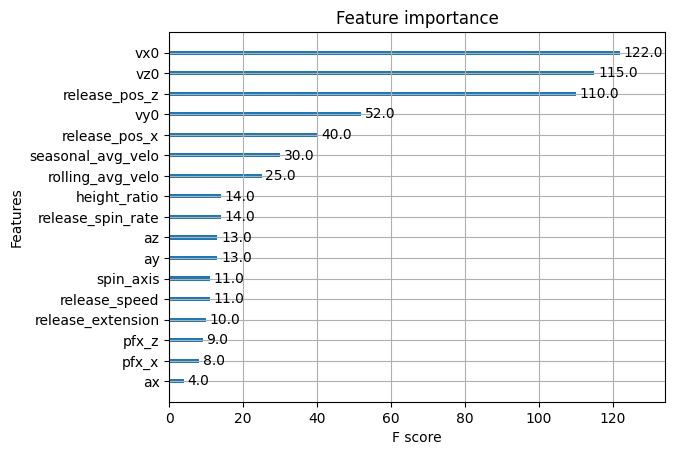

In [13]:
xgb.plot_importance(model)
plt.show()

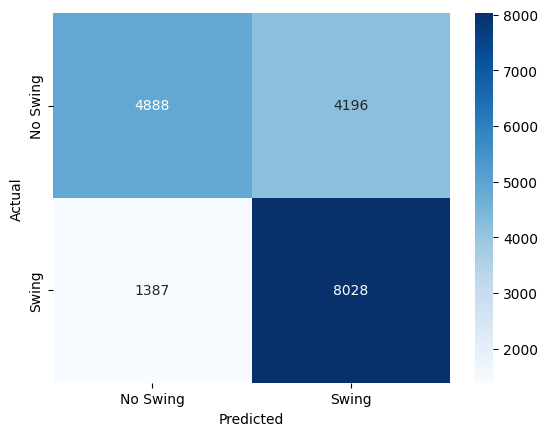

In [14]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [15]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [16]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 17:15:33,348] A new study created in memory with name: no-name-4cdf3af2-b6f2-4601-a890-6fffde0dc68b
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.66831
[2]	eval-logloss:0.65520
[3]	eval-logloss:0.64392
[4]	eval-logloss:0.63423
[5]	eval-logloss:0.62542
[6]	eval-logloss:0.61795
[7]	eval-logloss:0.61079
[8]	eval-logloss:0.60381
[9]	eval-logloss:0.59748
[10]	eval-logloss:0.59245
[11]	eval-logloss:0.58713
[12]	eval-logloss:0.58226
[13]	eval-logloss:0.57810
[14]	eval-logloss:0.57413
[15]	eval-logloss:0.57088
[16]	eval-logloss:0.56751
[17]	eval-logloss:0.56420
[18]	eval-logloss:0.56193
[19]	eval-logloss:0.55873
[20]	eval-logloss:0.55588
[21]	eval-logloss:0.55332
[22]	eval-logloss:0.55145
[23]	eval-logloss:0.54827
[24]	eval-logloss:0.54630
[25]	eval-logloss:0.54469
[26]	eval-logloss:0.54317
[27]	eval-logloss:0.54111
[28]	eval-logloss:0.53957
[29]	eval-logloss:0.53832
[30]	eval-logloss:0.53675
[31]	eval-logloss:0.53532
[32]	eval-logloss:0.53444
[33]	eval-logloss:0.53358
[34]	eval-logloss:0.53293
[35]	eval-logloss:0.53193
[36]	eval-logloss:0.52955
[37]	eval-logloss:0.52866
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:36,701] Trial 0 finished with value: 0.5026539840059746 and parameters: {'max_depth': 8, 'eta': 0.08391054688834959, 'subsample': 0.8715867429857491, 'colsample_bytree': 0.9654846384908741}. Best is trial 0 with value: 0.5026539840059746.


[0]	eval-logloss:0.68488


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68460
[2]	eval-logloss:0.68425
[3]	eval-logloss:0.66032
[4]	eval-logloss:0.64607
[5]	eval-logloss:0.63713
[6]	eval-logloss:0.63689
[7]	eval-logloss:0.63227
[8]	eval-logloss:0.62345
[9]	eval-logloss:0.62324
[10]	eval-logloss:0.62310
[11]	eval-logloss:0.61811
[12]	eval-logloss:0.61676
[13]	eval-logloss:0.61165
[14]	eval-logloss:0.60795
[15]	eval-logloss:0.60464
[16]	eval-logloss:0.60432
[17]	eval-logloss:0.60192
[18]	eval-logloss:0.60157
[19]	eval-logloss:0.59893
[20]	eval-logloss:0.59864
[21]	eval-logloss:0.59694
[22]	eval-logloss:0.59582
[23]	eval-logloss:0.59539
[24]	eval-logloss:0.59530
[25]	eval-logloss:0.59120
[26]	eval-logloss:0.58997
[27]	eval-logloss:0.58570
[28]	eval-logloss:0.58447
[29]	eval-logloss:0.58396
[30]	eval-logloss:0.58218
[31]	eval-logloss:0.57918
[32]	eval-logloss:0.57888
[33]	eval-logloss:0.57775
[34]	eval-logloss:0.57735
[35]	eval-logloss:0.57614
[36]	eval-logloss:0.57577
[37]	eval-logloss:0.57422
[38]	eval-logloss:0.57404
[39]	eval-logloss:0.5

[I 2023-11-15 17:15:38,079] Trial 1 finished with value: 0.5373360906453106 and parameters: {'max_depth': 3, 'eta': 0.2611100250950417, 'subsample': 0.65120087981872, 'colsample_bytree': 0.5287959668303497}. Best is trial 0 with value: 0.5026539840059746.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.65533
[2]	eval-logloss:0.63754
[3]	eval-logloss:0.62308
[4]	eval-logloss:0.61005
[5]	eval-logloss:0.59876
[6]	eval-logloss:0.59063
[7]	eval-logloss:0.58259
[8]	eval-logloss:0.57628
[9]	eval-logloss:0.56993
[10]	eval-logloss:0.56436
[11]	eval-logloss:0.56032
[12]	eval-logloss:0.55669
[13]	eval-logloss:0.55378
[14]	eval-logloss:0.55039
[15]	eval-logloss:0.54661
[16]	eval-logloss:0.54201
[17]	eval-logloss:0.54052
[18]	eval-logloss:0.53900
[19]	eval-logloss:0.53692
[20]	eval-logloss:0.53427
[21]	eval-logloss:0.53065
[22]	eval-logloss:0.52942
[23]	eval-logloss:0.52697
[24]	eval-logloss:0.52596
[25]	eval-logloss:0.52489
[26]	eval-logloss:0.52266
[27]	eval-logloss:0.52178
[28]	eval-logloss:0.52035
[29]	eval-logloss:0.51893
[30]	eval-logloss:0.51804
[31]	eval-logloss:0.51736
[32]	eval-logloss:0.51645
[33]	eval-logloss:0.51540
[34]	eval-logloss:0.51511
[35]	eval-logloss:0.51439
[36]	eval-logloss:0.51391
[37]	eval-logloss:0.51344
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:41,826] Trial 2 finished with value: 0.500368176190793 and parameters: {'max_depth': 9, 'eta': 0.12056994173625597, 'subsample': 0.717617703742335, 'colsample_bytree': 0.9507586783485227}. Best is trial 2 with value: 0.500368176190793.


[0]	eval-logloss:0.68838


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68821
[2]	eval-logloss:0.67974
[3]	eval-logloss:0.67150
[4]	eval-logloss:0.66429
[5]	eval-logloss:0.65772
[6]	eval-logloss:0.65761
[7]	eval-logloss:0.65492
[8]	eval-logloss:0.64853
[9]	eval-logloss:0.64838
[10]	eval-logloss:0.64613
[11]	eval-logloss:0.64288
[12]	eval-logloss:0.63978
[13]	eval-logloss:0.63499
[14]	eval-logloss:0.63016
[15]	eval-logloss:0.62864
[16]	eval-logloss:0.62606
[17]	eval-logloss:0.62207
[18]	eval-logloss:0.61799
[19]	eval-logloss:0.61416
[20]	eval-logloss:0.61405
[21]	eval-logloss:0.61075
[22]	eval-logloss:0.60759
[23]	eval-logloss:0.60746
[24]	eval-logloss:0.60736
[25]	eval-logloss:0.60457
[26]	eval-logloss:0.60177
[27]	eval-logloss:0.59897
[28]	eval-logloss:0.59641
[29]	eval-logloss:0.59437
[30]	eval-logloss:0.59221
[31]	eval-logloss:0.59001
[32]	eval-logloss:0.58989
[33]	eval-logloss:0.58824
[34]	eval-logloss:0.58690
[35]	eval-logloss:0.58523
[36]	eval-logloss:0.58395
[37]	eval-logloss:0.58239
[38]	eval-logloss:0.58106
[39]	eval-logloss:0.5

[I 2023-11-15 17:15:43,726] Trial 3 finished with value: 0.5347158623949817 and parameters: {'max_depth': 6, 'eta': 0.05643387315756429, 'subsample': 0.7227274477984258, 'colsample_bytree': 0.6298413970030154}. Best is trial 2 with value: 0.500368176190793.


[0]	eval-logloss:0.67660
[1]	eval-logloss:0.67593
[2]	eval-logloss:0.64388


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62398
[4]	eval-logloss:0.60976
[5]	eval-logloss:0.59989
[6]	eval-logloss:0.59968
[7]	eval-logloss:0.59464
[8]	eval-logloss:0.58717
[9]	eval-logloss:0.58672
[10]	eval-logloss:0.58354
[11]	eval-logloss:0.57848
[12]	eval-logloss:0.57690
[13]	eval-logloss:0.57153
[14]	eval-logloss:0.56775
[15]	eval-logloss:0.56719
[16]	eval-logloss:0.56032
[17]	eval-logloss:0.55640
[18]	eval-logloss:0.55381
[19]	eval-logloss:0.55257
[20]	eval-logloss:0.55249
[21]	eval-logloss:0.55005
[22]	eval-logloss:0.54923
[23]	eval-logloss:0.54890
[24]	eval-logloss:0.54884
[25]	eval-logloss:0.54687
[26]	eval-logloss:0.54587
[27]	eval-logloss:0.54185
[28]	eval-logloss:0.53993
[29]	eval-logloss:0.53905
[30]	eval-logloss:0.53747
[31]	eval-logloss:0.53608
[32]	eval-logloss:0.53564
[33]	eval-logloss:0.53484
[34]	eval-logloss:0.53371
[35]	eval-logloss:0.53088
[36]	eval-logloss:0.53061
[37]	eval-logloss:0.52958
[38]	eval-logloss:0.52940
[39]	eval-logloss:0.52914
[40]	eval-logloss:0.52912
[41]	eval-logloss:0

[I 2023-11-15 17:15:45,620] Trial 4 finished with value: 0.5029728029633536 and parameters: {'max_depth': 5, 'eta': 0.26695419224439404, 'subsample': 0.6916767893526143, 'colsample_bytree': 0.615202031184068}. Best is trial 2 with value: 0.500368176190793.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.68730
[3]	eval-logloss:0.68349
[4]	eval-logloss:0.68006
[5]	eval-logloss:0.67663
[6]	eval-logloss:0.67661
[7]	eval-logloss:0.67541
[8]	eval-logloss:0.67226
[9]	eval-logloss:0.67214
[10]	eval-logloss:0.67104
[11]	eval-logloss:0.66945
[12]	eval-logloss:0.66797
[13]	eval-logloss:0.66503
[14]	eval-logloss:0.66203
[15]	eval-logloss:0.66114
[16]	eval-logloss:0.65979
[17]	eval-logloss:0.65712
[18]	eval-logloss:0.65467
[19]	eval-logloss:0.65213
[20]	eval-logloss:0.65206
[21]	eval-logloss:0.64978
[22]	eval-logloss:0.64774
[23]	eval-logloss:0.64767
[24]	eval-logloss:0.64762
[25]	eval-logloss:0.64567
[26]	eval-logloss:0.64383
[27]	eval-logloss:0.64181
[28]	eval-logloss:0.64017
[29]	eval-logloss:0.63850
[30]	eval-logloss:0.63710
[31]	eval-logloss:0.63556
[32]	eval-logloss:0.63551
[33]	eval-logloss:0.63413
[34]	eval-logloss:0.63295
[35]	eval-logloss:0.63148
[36]	eval-logloss:0.63032
[37]	eval-logloss:0.62863
[38]	eval-logloss:0.62

[I 2023-11-15 17:15:47,396] Trial 5 finished with value: 0.5883044279310579 and parameters: {'max_depth': 4, 'eta': 0.03301308138174982, 'subsample': 0.8067017042122832, 'colsample_bytree': 0.6306548391555434}. Best is trial 2 with value: 0.500368176190793.


[0]	eval-logloss:0.68048


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65550
[2]	eval-logloss:0.63654
[3]	eval-logloss:0.62205
[4]	eval-logloss:0.61137
[5]	eval-logloss:0.60286
[6]	eval-logloss:0.60252
[7]	eval-logloss:0.59440
[8]	eval-logloss:0.58785
[9]	eval-logloss:0.58299
[10]	eval-logloss:0.57753
[11]	eval-logloss:0.57095
[12]	eval-logloss:0.56761
[13]	eval-logloss:0.56377
[14]	eval-logloss:0.55944
[15]	eval-logloss:0.55638
[16]	eval-logloss:0.55211
[17]	eval-logloss:0.55016
[18]	eval-logloss:0.54898
[19]	eval-logloss:0.54760
[20]	eval-logloss:0.54563
[21]	eval-logloss:0.54395
[22]	eval-logloss:0.54201
[23]	eval-logloss:0.54031
[24]	eval-logloss:0.53956
[25]	eval-logloss:0.53839
[26]	eval-logloss:0.53446
[27]	eval-logloss:0.53237
[28]	eval-logloss:0.53089
[29]	eval-logloss:0.52824
[30]	eval-logloss:0.52730
[31]	eval-logloss:0.52598
[32]	eval-logloss:0.52452
[33]	eval-logloss:0.52252
[34]	eval-logloss:0.52259
[35]	eval-logloss:0.52124
[36]	eval-logloss:0.52083
[37]	eval-logloss:0.51973
[38]	eval-logloss:0.51807
[39]	eval-logloss:0.5

[I 2023-11-15 17:15:49,317] Trial 6 finished with value: 0.49862362669630517 and parameters: {'max_depth': 6, 'eta': 0.17919090514010075, 'subsample': 0.6674388250790201, 'colsample_bytree': 0.9270603097419062}. Best is trial 6 with value: 0.49862362669630517.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67454
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.64067
[3]	eval-logloss:0.61750
[4]	eval-logloss:0.60306
[5]	eval-logloss:0.59070
[6]	eval-logloss:0.59029
[7]	eval-logloss:0.58557
[8]	eval-logloss:0.57539
[9]	eval-logloss:0.57541
[10]	eval-logloss:0.56822
[11]	eval-logloss:0.56221
[12]	eval-logloss:0.55738
[13]	eval-logloss:0.55043
[14]	eval-logloss:0.54565
[15]	eval-logloss:0.54365
[16]	eval-logloss:0.53947
[17]	eval-logloss:0.53645
[18]	eval-logloss:0.53460
[19]	eval-logloss:0.53298
[20]	eval-logloss:0.53302
[21]	eval-logloss:0.53170
[22]	eval-logloss:0.53134
[23]	eval-logloss:0.53138
[24]	eval-logloss:0.53141
[25]	eval-logloss:0.53043
[26]	eval-logloss:0.52975
[27]	eval-logloss:0.52692
[28]	eval-logloss:0.52372
[29]	eval-logloss:0.52172
[30]	eval-logloss:0.52103
[31]	eval-logloss:0.52047
[32]	eval-logloss:0.52015
[33]	eval-logloss:0.51795
[34]	eval-logloss:0.51766
[35]	eval-logloss:0.51562
[36]	eval-logloss:0.51510
[37]	eval-logloss:0.51506
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:51,502] Trial 7 finished with value: 0.5046417729536002 and parameters: {'max_depth': 7, 'eta': 0.22382609069157738, 'subsample': 0.6589914764787007, 'colsample_bytree': 0.679202946094231}. Best is trial 6 with value: 0.49862362669630517.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68812
[1]	eval-logloss:0.67906
[2]	eval-logloss:0.67097
[3]	eval-logloss:0.66343
[4]	eval-logloss:0.65665
[5]	eval-logloss:0.64996
[6]	eval-logloss:0.64969
[7]	eval-logloss:0.64384
[8]	eval-logloss:0.63822
[9]	eval-logloss:0.63287
[10]	eval-logloss:0.62807
[11]	eval-logloss:0.62475
[12]	eval-logloss:0.62165
[13]	eval-logloss:0.61717
[14]	eval-logloss:0.61306
[15]	eval-logloss:0.60937
[16]	eval-logloss:0.60616
[17]	eval-logloss:0.60261
[18]	eval-logloss:0.59957
[19]	eval-logloss:0.59681
[20]	eval-logloss:0.59445
[21]	eval-logloss:0.59175
[22]	eval-logloss:0.58949
[23]	eval-logloss:0.58749
[24]	eval-logloss:0.58512
[25]	eval-logloss:0.58265
[26]	eval-logloss:0.58016
[27]	eval-logloss:0.57817
[28]	eval-logloss:0.57638
[29]	eval-logloss:0.57439
[30]	eval-logloss:0.57260
[31]	eval-logloss:0.57107
[32]	eval-logloss:0.56983
[33]	eval-logloss:0.56830
[34]	eval-logloss:0.56708
[35]	eval-logloss:0.56566
[36]	eval-logloss:0.56443
[37]	eval-logloss:0.56265
[38]	eval-logloss:0.56

[I 2023-11-15 17:15:53,873] Trial 8 finished with value: 0.5195988937701164 and parameters: {'max_depth': 7, 'eta': 0.05167050227989936, 'subsample': 0.8982326484131983, 'colsample_bytree': 0.8900138023990043}. Best is trial 6 with value: 0.49862362669630517.


[0]	eval-logloss:0.69203


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68769
[3]	eval-logloss:0.68558
[4]	eval-logloss:0.68359
[5]	eval-logloss:0.68161
[6]	eval-logloss:0.68153
[7]	eval-logloss:0.68084
[8]	eval-logloss:0.67891
[9]	eval-logloss:0.67700
[10]	eval-logloss:0.67601
[11]	eval-logloss:0.67503
[12]	eval-logloss:0.67412
[13]	eval-logloss:0.67237
[14]	eval-logloss:0.67053
[15]	eval-logloss:0.66961
[16]	eval-logloss:0.66793
[17]	eval-logloss:0.66633
[18]	eval-logloss:0.66466
[19]	eval-logloss:0.66307
[20]	eval-logloss:0.66222
[21]	eval-logloss:0.66064
[22]	eval-logloss:0.65912
[23]	eval-logloss:0.65831
[24]	eval-logloss:0.65691
[25]	eval-logloss:0.65546
[26]	eval-logloss:0.65405
[27]	eval-logloss:0.65265
[28]	eval-logloss:0.65132
[29]	eval-logloss:0.64994
[30]	eval-logloss:0.64885
[31]	eval-logloss:0.64766
[32]	eval-logloss:0.64650
[33]	eval-logloss:0.64532
[34]	eval-logloss:0.64403
[35]	eval-logloss:0.64278
[36]	eval-logloss:0.64152
[37]	eval-logloss:0.64038
[38]	eval-logloss:0.63933
[39]	eval-logloss:0.6

[I 2023-11-15 17:15:55,558] Trial 9 finished with value: 0.5978971345636164 and parameters: {'max_depth': 5, 'eta': 0.01521533015597924, 'subsample': 0.8869824030493824, 'colsample_bytree': 0.7893518726030271}. Best is trial 6 with value: 0.49862362669630517.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.65568
[2]	eval-logloss:0.63686
[3]	eval-logloss:0.62201
[4]	eval-logloss:0.61082
[5]	eval-logloss:0.60104
[6]	eval-logloss:0.60048
[7]	eval-logloss:0.59222
[8]	eval-logloss:0.58495
[9]	eval-logloss:0.57647
[10]	eval-logloss:0.57171
[11]	eval-logloss:0.56650
[12]	eval-logloss:0.56346
[13]	eval-logloss:0.55944
[14]	eval-logloss:0.55505
[15]	eval-logloss:0.55243
[16]	eval-logloss:0.55028
[17]	eval-logloss:0.54804
[18]	eval-logloss:0.54641
[19]	eval-logloss:0.54519
[20]	eval-logloss:0.54316
[21]	eval-logloss:0.53846
[22]	eval-logloss:0.53779
[23]	eval-logloss:0.53602
[24]	eval-logloss:0.53530
[25]	eval-logloss:0.53365
[26]	eval-logloss:0.53218
[27]	eval-logloss:0.53017
[28]	eval-logloss:0.52886
[29]	eval-logloss:0.52777
[30]	eval-logloss:0.52718
[31]	eval-logloss:0.52649
[32]	eval-logloss:0.52609
[33]	eval-logloss:0.52378
[34]	eval-logloss:0.52333
[35]	eval-logloss:0.52193
[36]	eval-logloss:0.52173
[37]	eval-logloss:0.52108
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:57,411] Trial 10 finished with value: 0.500720732129946 and parameters: {'max_depth': 6, 'eta': 0.1759201244550202, 'subsample': 0.6047221775252245, 'colsample_bytree': 0.8268603763458429}. Best is trial 6 with value: 0.49862362669630517.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67547
[1]	eval-logloss:0.65035
[2]	eval-logloss:0.63048
[3]	eval-logloss:0.61400
[4]	eval-logloss:0.60090
[5]	eval-logloss:0.59022
[6]	eval-logloss:0.58243
[7]	eval-logloss:0.57485
[8]	eval-logloss:0.56814
[9]	eval-logloss:0.56146
[10]	eval-logloss:0.55736
[11]	eval-logloss:0.55276
[12]	eval-logloss:0.54930
[13]	eval-logloss:0.54394
[14]	eval-logloss:0.54128
[15]	eval-logloss:0.53916
[16]	eval-logloss:0.53584
[17]	eval-logloss:0.53342
[18]	eval-logloss:0.53220
[19]	eval-logloss:0.53056
[20]	eval-logloss:0.52800
[21]	eval-logloss:0.52500
[22]	eval-logloss:0.52361
[23]	eval-logloss:0.52282
[24]	eval-logloss:0.52001
[25]	eval-logloss:0.51888
[26]	eval-logloss:0.51805
[27]	eval-logloss:0.51707
[28]	eval-logloss:0.51606
[29]	eval-logloss:0.51497
[30]	eval-logloss:0.51429
[31]	eval-logloss:0.51218
[32]	eval-logloss:0.51161
[33]	eval-logloss:0.51105
[34]	eval-logloss:0.51080
[35]	eval-logloss:0.51027
[36]	eval-logloss:0.51019
[37]	eval-logloss:0.50958
[38]	eval-logloss:0.50

[I 2023-11-15 17:16:00,399] Trial 11 finished with value: 0.5012910882605532 and parameters: {'max_depth': 9, 'eta': 0.14063025971089993, 'subsample': 0.7487665934729466, 'colsample_bytree': 0.9930074685695822}. Best is trial 6 with value: 0.49862362669630517.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.65081
[2]	eval-logloss:0.63150
[3]	eval-logloss:0.61625
[4]	eval-logloss:0.60314
[5]	eval-logloss:0.59134
[6]	eval-logloss:0.59122
[7]	eval-logloss:0.58311
[8]	eval-logloss:0.57602
[9]	eval-logloss:0.56896
[10]	eval-logloss:0.56392
[11]	eval-logloss:0.55680
[12]	eval-logloss:0.55081
[13]	eval-logloss:0.54694
[14]	eval-logloss:0.54348
[15]	eval-logloss:0.54040
[16]	eval-logloss:0.53746
[17]	eval-logloss:0.53529
[18]	eval-logloss:0.53340
[19]	eval-logloss:0.53079
[20]	eval-logloss:0.52816
[21]	eval-logloss:0.52661
[22]	eval-logloss:0.52591
[23]	eval-logloss:0.52389
[24]	eval-logloss:0.52302
[25]	eval-logloss:0.52229
[26]	eval-logloss:0.52093
[27]	eval-logloss:0.51930
[28]	eval-logloss:0.51801
[29]	eval-logloss:0.51751
[30]	eval-logloss:0.51665
[31]	eval-logloss:0.51575
[32]	eval-logloss:0.51425
[33]	eval-logloss:0.51377
[34]	eval-logloss:0.51352
[35]	eval-logloss:0.51229
[36]	eval-logloss:0.51218
[37]	eval-logloss:0.51189
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:03,348] Trial 12 finished with value: 0.5029246750694937 and parameters: {'max_depth': 9, 'eta': 0.1385092357884767, 'subsample': 0.713522190645127, 'colsample_bytree': 0.8940042225131685}. Best is trial 6 with value: 0.49862362669630517.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.64855
[2]	eval-logloss:0.62842
[3]	eval-logloss:0.61242
[4]	eval-logloss:0.59934
[5]	eval-logloss:0.58954
[6]	eval-logloss:0.58913
[7]	eval-logloss:0.58120
[8]	eval-logloss:0.57455
[9]	eval-logloss:0.56687
[10]	eval-logloss:0.56200
[11]	eval-logloss:0.55755
[12]	eval-logloss:0.55192
[13]	eval-logloss:0.54821
[14]	eval-logloss:0.54548
[15]	eval-logloss:0.54254
[16]	eval-logloss:0.53967
[17]	eval-logloss:0.53797
[18]	eval-logloss:0.53654
[19]	eval-logloss:0.53362
[20]	eval-logloss:0.53105
[21]	eval-logloss:0.52937
[22]	eval-logloss:0.52875
[23]	eval-logloss:0.52642
[24]	eval-logloss:0.52502
[25]	eval-logloss:0.52434
[26]	eval-logloss:0.52280
[27]	eval-logloss:0.52112
[28]	eval-logloss:0.52051
[29]	eval-logloss:0.51963
[30]	eval-logloss:0.51874
[31]	eval-logloss:0.51807
[32]	eval-logloss:0.51604
[33]	eval-logloss:0.51583
[34]	eval-logloss:0.51563
[35]	eval-logloss:0.51509
[36]	eval-logloss:0.51455
[37]	eval-logloss:0.51341
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:05,447] Trial 13 finished with value: 0.5010547100558008 and parameters: {'max_depth': 7, 'eta': 0.18320556779450664, 'subsample': 0.7744538310798925, 'colsample_bytree': 0.9104290843390956}. Best is trial 6 with value: 0.49862362669630517.


[0]	eval-logloss:0.68095


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65998
[2]	eval-logloss:0.64289
[3]	eval-logloss:0.62895
[4]	eval-logloss:0.61716
[5]	eval-logloss:0.60655
[6]	eval-logloss:0.60635
[7]	eval-logloss:0.59787
[8]	eval-logloss:0.59096
[9]	eval-logloss:0.58463
[10]	eval-logloss:0.57955
[11]	eval-logloss:0.57396
[12]	eval-logloss:0.56989
[13]	eval-logloss:0.56502
[14]	eval-logloss:0.56075
[15]	eval-logloss:0.55632
[16]	eval-logloss:0.55288
[17]	eval-logloss:0.55032
[18]	eval-logloss:0.54773
[19]	eval-logloss:0.54563
[20]	eval-logloss:0.54263
[21]	eval-logloss:0.54057
[22]	eval-logloss:0.53842
[23]	eval-logloss:0.53714
[24]	eval-logloss:0.53545
[25]	eval-logloss:0.53423
[26]	eval-logloss:0.53248
[27]	eval-logloss:0.53106
[28]	eval-logloss:0.52882
[29]	eval-logloss:0.52781
[30]	eval-logloss:0.52707
[31]	eval-logloss:0.52574
[32]	eval-logloss:0.52515
[33]	eval-logloss:0.52245
[34]	eval-logloss:0.52194
[35]	eval-logloss:0.51994
[36]	eval-logloss:0.51944
[37]	eval-logloss:0.51905
[38]	eval-logloss:0.51737
[39]	eval-logloss:0.5

[I 2023-11-15 17:16:07,999] Trial 14 finished with value: 0.4984907944881382 and parameters: {'max_depth': 8, 'eta': 0.11841563730334666, 'subsample': 0.6759698533864421, 'colsample_bytree': 0.8323011093239128}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.66588
[2]	eval-logloss:0.65177
[3]	eval-logloss:0.63917
[4]	eval-logloss:0.62859
[5]	eval-logloss:0.61858
[6]	eval-logloss:0.61836
[7]	eval-logloss:0.61043
[8]	eval-logloss:0.60283
[9]	eval-logloss:0.59614
[10]	eval-logloss:0.59132
[11]	eval-logloss:0.58665
[12]	eval-logloss:0.58280
[13]	eval-logloss:0.57710
[14]	eval-logloss:0.57205
[15]	eval-logloss:0.56736
[16]	eval-logloss:0.56286
[17]	eval-logloss:0.55951
[18]	eval-logloss:0.55658
[19]	eval-logloss:0.55398
[20]	eval-logloss:0.55129
[21]	eval-logloss:0.54908
[22]	eval-logloss:0.54657
[23]	eval-logloss:0.54425
[24]	eval-logloss:0.54239
[25]	eval-logloss:0.54070
[26]	eval-logloss:0.53909
[27]	eval-logloss:0.53616
[28]	eval-logloss:0.53440
[29]	eval-logloss:0.53269
[30]	eval-logloss:0.53119
[31]	eval-logloss:0.53032
[32]	eval-logloss:0.52910
[33]	eval-logloss:0.52664
[34]	eval-logloss:0.52598
[35]	eval-logloss:0.52487
[36]	eval-logloss:0.52448
[37]	eval-logloss:0.52404
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:10,594] Trial 15 finished with value: 0.4994658649918 and parameters: {'max_depth': 8, 'eta': 0.09494191675245947, 'subsample': 0.6028971452708827, 'colsample_bytree': 0.8360274823060718}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.66012
[2]	eval-logloss:0.64486
[3]	eval-logloss:0.63099
[4]	eval-logloss:0.62049
[5]	eval-logloss:0.61324
[6]	eval-logloss:0.61288
[7]	eval-logloss:0.60865
[8]	eval-logloss:0.60109
[9]	eval-logloss:0.59562
[10]	eval-logloss:0.59140
[11]	eval-logloss:0.58753
[12]	eval-logloss:0.58475
[13]	eval-logloss:0.58008
[14]	eval-logloss:0.57616
[15]	eval-logloss:0.57457
[16]	eval-logloss:0.57123
[17]	eval-logloss:0.56779
[18]	eval-logloss:0.56564
[19]	eval-logloss:0.56290
[20]	eval-logloss:0.56007
[21]	eval-logloss:0.55870
[22]	eval-logloss:0.55738
[23]	eval-logloss:0.55537
[24]	eval-logloss:0.55465
[25]	eval-logloss:0.55286
[26]	eval-logloss:0.54995
[27]	eval-logloss:0.54908
[28]	eval-logloss:0.54746
[29]	eval-logloss:0.54661
[30]	eval-logloss:0.54553
[31]	eval-logloss:0.54451
[32]	eval-logloss:0.54382
[33]	eval-logloss:0.54105
[34]	eval-logloss:0.54064
[35]	eval-logloss:0.53896
[36]	eval-logloss:0.53868
[37]	eval-logloss:0.53847
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:12,201] Trial 16 finished with value: 0.5059063278264201 and parameters: {'max_depth': 5, 'eta': 0.17653202627304018, 'subsample': 0.66677327649842, 'colsample_bytree': 0.7569103310922103}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.63601
[2]	eval-logloss:0.61397
[3]	eval-logloss:0.59551
[4]	eval-logloss:0.58320
[5]	eval-logloss:0.57140
[6]	eval-logloss:0.57101
[7]	eval-logloss:0.56344
[8]	eval-logloss:0.55715
[9]	eval-logloss:0.55148
[10]	eval-logloss:0.54503
[11]	eval-logloss:0.53967
[12]	eval-logloss:0.53689
[13]	eval-logloss:0.53341
[14]	eval-logloss:0.52983
[15]	eval-logloss:0.52721
[16]	eval-logloss:0.52581
[17]	eval-logloss:0.52411
[18]	eval-logloss:0.52289
[19]	eval-logloss:0.52189
[20]	eval-logloss:0.51910
[21]	eval-logloss:0.51792
[22]	eval-logloss:0.51725
[23]	eval-logloss:0.51622
[24]	eval-logloss:0.51642
[25]	eval-logloss:0.51599
[26]	eval-logloss:0.51293
[27]	eval-logloss:0.51150
[28]	eval-logloss:0.51090
[29]	eval-logloss:0.51019
[30]	eval-logloss:0.50973
[31]	eval-logloss:0.50970
[32]	eval-logloss:0.50957
[33]	eval-logloss:0.50814
[34]	eval-logloss:0.50839
[35]	eval-logloss:0.50756
[36]	eval-logloss:0.50781
[37]	eval-logloss:0.50791
[38]	eval-logloss:0.50

[I 2023-11-15 17:16:14,630] Trial 17 finished with value: 0.5067746422054278 and parameters: {'max_depth': 8, 'eta': 0.22387043830585673, 'subsample': 0.6428019439413002, 'colsample_bytree': 0.839890948174283}. Best is trial 14 with value: 0.4984907944881382.


[0]	eval-logloss:0.68469


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66817
[2]	eval-logloss:0.65449
[3]	eval-logloss:0.64209
[4]	eval-logloss:0.63251
[5]	eval-logloss:0.62389
[6]	eval-logloss:0.62365
[7]	eval-logloss:0.61630
[8]	eval-logloss:0.61010
[9]	eval-logloss:0.60572
[10]	eval-logloss:0.60079
[11]	eval-logloss:0.59562
[12]	eval-logloss:0.59219
[13]	eval-logloss:0.58748
[14]	eval-logloss:0.58368
[15]	eval-logloss:0.57975
[16]	eval-logloss:0.57629
[17]	eval-logloss:0.57299
[18]	eval-logloss:0.57040
[19]	eval-logloss:0.56815
[20]	eval-logloss:0.56521
[21]	eval-logloss:0.56279
[22]	eval-logloss:0.56045
[23]	eval-logloss:0.55860
[24]	eval-logloss:0.55722
[25]	eval-logloss:0.55551
[26]	eval-logloss:0.55284
[27]	eval-logloss:0.55050
[28]	eval-logloss:0.54929
[29]	eval-logloss:0.54730
[30]	eval-logloss:0.54646
[31]	eval-logloss:0.54457
[32]	eval-logloss:0.54209
[33]	eval-logloss:0.54088
[34]	eval-logloss:0.53996
[35]	eval-logloss:0.53866
[36]	eval-logloss:0.53746
[37]	eval-logloss:0.53578
[38]	eval-logloss:0.53432
[39]	eval-logloss:0.5

[I 2023-11-15 17:16:16,580] Trial 18 finished with value: 0.5067678303355734 and parameters: {'max_depth': 6, 'eta': 0.11228135947774483, 'subsample': 0.6836531802853, 'colsample_bytree': 0.9262823026145539}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.66872
[2]	eval-logloss:0.65473
[3]	eval-logloss:0.64487
[4]	eval-logloss:0.63673
[5]	eval-logloss:0.63005
[6]	eval-logloss:0.62358
[7]	eval-logloss:0.61927
[8]	eval-logloss:0.61539
[9]	eval-logloss:0.61045
[10]	eval-logloss:0.60759
[11]	eval-logloss:0.60326
[12]	eval-logloss:0.59926
[13]	eval-logloss:0.59733
[14]	eval-logloss:0.59291
[15]	eval-logloss:0.59070
[16]	eval-logloss:0.58662
[17]	eval-logloss:0.58462
[18]	eval-logloss:0.58291
[19]	eval-logloss:0.58103
[20]	eval-logloss:0.58020
[21]	eval-logloss:0.57529
[22]	eval-logloss:0.57350
[23]	eval-logloss:0.57152
[24]	eval-logloss:0.57083
[25]	eval-logloss:0.56801
[26]	eval-logloss:0.56473
[27]	eval-logloss:0.56402
[28]	eval-logloss:0.56218
[29]	eval-logloss:0.56108
[30]	eval-logloss:0.55962
[31]	eval-logloss:0.55771
[32]	eval-logloss:0.55620
[33]	eval-logloss:0.55495
[34]	eval-logloss:0.55447
[35]	eval-logloss:0.55356
[36]	eval-logloss:0.55262
[37]	eval-logloss:0.55222
[38]	eval-logloss:0.55

[I 2023-11-15 17:16:18,195] Trial 19 finished with value: 0.5198341797080476 and parameters: {'max_depth': 4, 'eta': 0.1561290998527525, 'subsample': 0.6387812762319105, 'colsample_bytree': 0.9926780186553888}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.62585
[2]	eval-logloss:0.60158
[3]	eval-logloss:0.58527
[4]	eval-logloss:0.57012
[5]	eval-logloss:0.56020
[6]	eval-logloss:0.56012
[7]	eval-logloss:0.55409
[8]	eval-logloss:0.54895
[9]	eval-logloss:0.54295
[10]	eval-logloss:0.53602
[11]	eval-logloss:0.53465
[12]	eval-logloss:0.53214
[13]	eval-logloss:0.53057
[14]	eval-logloss:0.52795
[15]	eval-logloss:0.52630
[16]	eval-logloss:0.52553
[17]	eval-logloss:0.52512
[18]	eval-logloss:0.52482
[19]	eval-logloss:0.52376
[20]	eval-logloss:0.52081
[21]	eval-logloss:0.51950
[22]	eval-logloss:0.51883
[23]	eval-logloss:0.51776
[24]	eval-logloss:0.51801
[25]	eval-logloss:0.51784
[26]	eval-logloss:0.51531
[27]	eval-logloss:0.51447
[28]	eval-logloss:0.51391
[29]	eval-logloss:0.51376
[30]	eval-logloss:0.51333
[31]	eval-logloss:0.51337
[32]	eval-logloss:0.51294
[33]	eval-logloss:0.51254
[34]	eval-logloss:0.51265
[35]	eval-logloss:0.51146
[36]	eval-logloss:0.51164
[37]	eval-logloss:0.51170
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:20,216] Trial 20 finished with value: 0.5086048586954066 and parameters: {'max_depth': 7, 'eta': 0.2998925789112193, 'subsample': 0.6928299966124843, 'colsample_bytree': 0.8560312575203328}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.66742
[2]	eval-logloss:0.65421
[3]	eval-logloss:0.64218
[4]	eval-logloss:0.63205
[5]	eval-logloss:0.62248
[6]	eval-logloss:0.62232
[7]	eval-logloss:0.61916
[8]	eval-logloss:0.61105
[9]	eval-logloss:0.60382
[10]	eval-logloss:0.59906
[11]	eval-logloss:0.59471
[12]	eval-logloss:0.59094
[13]	eval-logloss:0.58465
[14]	eval-logloss:0.57928
[15]	eval-logloss:0.57578
[16]	eval-logloss:0.57064
[17]	eval-logloss:0.56635
[18]	eval-logloss:0.56268
[19]	eval-logloss:0.55935
[20]	eval-logloss:0.55678
[21]	eval-logloss:0.55405
[22]	eval-logloss:0.55158
[23]	eval-logloss:0.54910
[24]	eval-logloss:0.54707
[25]	eval-logloss:0.54513
[26]	eval-logloss:0.54286
[27]	eval-logloss:0.54105
[28]	eval-logloss:0.53923
[29]	eval-logloss:0.53698
[30]	eval-logloss:0.53546
[31]	eval-logloss:0.53420
[32]	eval-logloss:0.53325
[33]	eval-logloss:0.53117
[34]	eval-logloss:0.53015
[35]	eval-logloss:0.52869
[36]	eval-logloss:0.52842
[37]	eval-logloss:0.52751
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:22,659] Trial 21 finished with value: 0.5017266959410426 and parameters: {'max_depth': 8, 'eta': 0.08875289577576785, 'subsample': 0.6045856824348916, 'colsample_bytree': 0.8034833295372856}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68239
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.64831
[3]	eval-logloss:0.63476
[4]	eval-logloss:0.62336
[5]	eval-logloss:0.61372
[6]	eval-logloss:0.61346
[7]	eval-logloss:0.60497
[8]	eval-logloss:0.59747
[9]	eval-logloss:0.58994
[10]	eval-logloss:0.58450
[11]	eval-logloss:0.57916
[12]	eval-logloss:0.57511
[13]	eval-logloss:0.57086
[14]	eval-logloss:0.56646
[15]	eval-logloss:0.56230
[16]	eval-logloss:0.55872
[17]	eval-logloss:0.55571
[18]	eval-logloss:0.55315
[19]	eval-logloss:0.55029
[20]	eval-logloss:0.54734
[21]	eval-logloss:0.54490
[22]	eval-logloss:0.54263
[23]	eval-logloss:0.53993
[24]	eval-logloss:0.53836
[25]	eval-logloss:0.53706
[26]	eval-logloss:0.53578
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53214
[29]	eval-logloss:0.53030
[30]	eval-logloss:0.52904
[31]	eval-logloss:0.52803
[32]	eval-logloss:0.52710
[33]	eval-logloss:0.52580
[34]	eval-logloss:0.52536
[35]	eval-logloss:0.52415
[36]	eval-logloss:0.52360
[37]	eval-logloss:0.52267
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:25,166] Trial 22 finished with value: 0.5000841660168772 and parameters: {'max_depth': 8, 'eta': 0.10342728902072595, 'subsample': 0.6244027982437959, 'colsample_bytree': 0.8579139586282724}. Best is trial 14 with value: 0.4984907944881382.


[0]	eval-logloss:0.68524


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67136
[2]	eval-logloss:0.65879
[3]	eval-logloss:0.64714
[4]	eval-logloss:0.63738
[5]	eval-logloss:0.62871
[6]	eval-logloss:0.62839
[7]	eval-logloss:0.62513
[8]	eval-logloss:0.61775
[9]	eval-logloss:0.61043
[10]	eval-logloss:0.60588
[11]	eval-logloss:0.60105
[12]	eval-logloss:0.59689
[13]	eval-logloss:0.59082
[14]	eval-logloss:0.58541
[15]	eval-logloss:0.58418
[16]	eval-logloss:0.57924
[17]	eval-logloss:0.57531
[18]	eval-logloss:0.57207
[19]	eval-logloss:0.56914
[20]	eval-logloss:0.56691
[21]	eval-logloss:0.56412
[22]	eval-logloss:0.56150
[23]	eval-logloss:0.55876
[24]	eval-logloss:0.55695
[25]	eval-logloss:0.55488
[26]	eval-logloss:0.55261
[27]	eval-logloss:0.55069
[28]	eval-logloss:0.54834
[29]	eval-logloss:0.54640
[30]	eval-logloss:0.54466
[31]	eval-logloss:0.54322
[32]	eval-logloss:0.54216
[33]	eval-logloss:0.53984
[34]	eval-logloss:0.53906
[35]	eval-logloss:0.53742
[36]	eval-logloss:0.53672
[37]	eval-logloss:0.53601
[38]	eval-logloss:0.53434
[39]	eval-logloss:0.5

[I 2023-11-15 17:16:27,226] Trial 23 finished with value: 0.5052880257502371 and parameters: {'max_depth': 7, 'eta': 0.08893540005239214, 'subsample': 0.6220782433285099, 'colsample_bytree': 0.7753585982965662}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.65704
[3]	eval-logloss:0.63807
[4]	eval-logloss:0.62380
[5]	eval-logloss:0.61160
[6]	eval-logloss:0.61143
[7]	eval-logloss:0.60744
[8]	eval-logloss:0.59781
[9]	eval-logloss:0.59069
[10]	eval-logloss:0.58528
[11]	eval-logloss:0.57981
[12]	eval-logloss:0.57561
[13]	eval-logloss:0.56792
[14]	eval-logloss:0.56141
[15]	eval-logloss:0.56009
[16]	eval-logloss:0.55396
[17]	eval-logloss:0.54973
[18]	eval-logloss:0.54588
[19]	eval-logloss:0.54312
[20]	eval-logloss:0.54287
[21]	eval-logloss:0.54011
[22]	eval-logloss:0.53780
[23]	eval-logloss:0.53461
[24]	eval-logloss:0.53273
[25]	eval-logloss:0.53131
[26]	eval-logloss:0.52934
[27]	eval-logloss:0.52748
[28]	eval-logloss:0.52499
[29]	eval-logloss:0.52345
[30]	eval-logloss:0.52261
[31]	eval-logloss:0.52219
[32]	eval-logloss:0.52132
[33]	eval-logloss:0.51882
[34]	eval-logloss:0.51835
[35]	eval-logloss:0.51740
[36]	eval-logloss:0.51703
[37]	eval-logloss:0.51692
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:29,863] Trial 24 finished with value: 0.5010669302539265 and parameters: {'max_depth': 8, 'eta': 0.13024076768480178, 'subsample': 0.6006933421687277, 'colsample_bytree': 0.7279605522399188}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68421
[1]	eval-logloss:0.66975
[2]	eval-logloss:0.65731
[3]	eval-logloss:0.64606
[4]	eval-logloss:0.63632
[5]	eval-logloss:0.62666
[6]	eval-logloss:0.62625
[7]	eval-logloss:0.61811
[8]	eval-logloss:0.61056
[9]	eval-logloss:0.60383
[10]	eval-logloss:0.59776
[11]	eval-logloss:0.59271
[12]	eval-logloss:0.58863
[13]	eval-logloss:0.58338
[14]	eval-logloss:0.57892
[15]	eval-logloss:0.57422
[16]	eval-logloss:0.57029
[17]	eval-logloss:0.56671
[18]	eval-logloss:0.56377
[19]	eval-logloss:0.56038
[20]	eval-logloss:0.55718
[21]	eval-logloss:0.55390
[22]	eval-logloss:0.55132
[23]	eval-logloss:0.54861
[24]	eval-logloss:0.54673
[25]	eval-logloss:0.54491
[26]	eval-logloss:0.54213
[27]	eval-logloss:0.54034
[28]	eval-logloss:0.53866
[29]	eval-logloss:0.53730
[30]	eval-logloss:0.53574
[31]	eval-logloss:0.53458
[32]	eval-logloss:0.53341
[33]	eval-logloss:0.53112
[34]	eval-logloss:0.53031
[35]	eval-logloss:0.52916
[36]	eval-logloss:0.52855
[37]	eval-logloss:0.52767
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:32,830] Trial 25 finished with value: 0.5009836316235848 and parameters: {'max_depth': 9, 'eta': 0.07303731126947949, 'subsample': 0.6712354203362947, 'colsample_bytree': 0.875347434482184}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.66928
[2]	eval-logloss:0.65625
[3]	eval-logloss:0.64435
[4]	eval-logloss:0.63428
[5]	eval-logloss:0.62564
[6]	eval-logloss:0.62525
[7]	eval-logloss:0.62173
[8]	eval-logloss:0.61411
[9]	eval-logloss:0.60755
[10]	eval-logloss:0.60313
[11]	eval-logloss:0.59965
[12]	eval-logloss:0.59672
[13]	eval-logloss:0.59124
[14]	eval-logloss:0.58652
[15]	eval-logloss:0.58280
[16]	eval-logloss:0.57893
[17]	eval-logloss:0.57486
[18]	eval-logloss:0.57199
[19]	eval-logloss:0.56937
[20]	eval-logloss:0.56771
[21]	eval-logloss:0.56522
[22]	eval-logloss:0.56252
[23]	eval-logloss:0.56092
[24]	eval-logloss:0.55894
[25]	eval-logloss:0.55712
[26]	eval-logloss:0.55519
[27]	eval-logloss:0.55342
[28]	eval-logloss:0.55142
[29]	eval-logloss:0.54967
[30]	eval-logloss:0.54859
[31]	eval-logloss:0.54742
[32]	eval-logloss:0.54655
[33]	eval-logloss:0.54330
[34]	eval-logloss:0.54238
[35]	eval-logloss:0.54037
[36]	eval-logloss:0.53922
[37]	eval-logloss:0.53853
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:34,735] Trial 26 finished with value: 0.5076388173891853 and parameters: {'max_depth': 6, 'eta': 0.10782421538168159, 'subsample': 0.6388495592974965, 'colsample_bytree': 0.8092811155225151}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.65483
[2]	eval-logloss:0.63691
[3]	eval-logloss:0.62189
[4]	eval-logloss:0.61074
[5]	eval-logloss:0.59985
[6]	eval-logloss:0.59190
[7]	eval-logloss:0.58499
[8]	eval-logloss:0.57824
[9]	eval-logloss:0.57286
[10]	eval-logloss:0.56871
[11]	eval-logloss:0.56399
[12]	eval-logloss:0.56008
[13]	eval-logloss:0.55805
[14]	eval-logloss:0.55429
[15]	eval-logloss:0.55084
[16]	eval-logloss:0.54828
[17]	eval-logloss:0.54640
[18]	eval-logloss:0.54481
[19]	eval-logloss:0.54258
[20]	eval-logloss:0.53985
[21]	eval-logloss:0.53810
[22]	eval-logloss:0.53721
[23]	eval-logloss:0.53496
[24]	eval-logloss:0.53415
[25]	eval-logloss:0.53183
[26]	eval-logloss:0.53080
[27]	eval-logloss:0.53034
[28]	eval-logloss:0.52846
[29]	eval-logloss:0.52734
[30]	eval-logloss:0.52672
[31]	eval-logloss:0.52583
[32]	eval-logloss:0.52283
[33]	eval-logloss:0.52167
[34]	eval-logloss:0.52107
[35]	eval-logloss:0.52007
[36]	eval-logloss:0.51945
[37]	eval-logloss:0.51928
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:36,828] Trial 27 finished with value: 0.49949580780417013 and parameters: {'max_depth': 7, 'eta': 0.15496715886546492, 'subsample': 0.6672022884790586, 'colsample_bytree': 0.9370430137654799}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.65955
[2]	eval-logloss:0.64304
[3]	eval-logloss:0.62849
[4]	eval-logloss:0.61688
[5]	eval-logloss:0.60746
[6]	eval-logloss:0.60721
[7]	eval-logloss:0.59834
[8]	eval-logloss:0.59123
[9]	eval-logloss:0.58343
[10]	eval-logloss:0.57823
[11]	eval-logloss:0.57284
[12]	eval-logloss:0.56917
[13]	eval-logloss:0.56457
[14]	eval-logloss:0.56005
[15]	eval-logloss:0.55558
[16]	eval-logloss:0.55179
[17]	eval-logloss:0.54895
[18]	eval-logloss:0.54629
[19]	eval-logloss:0.54463
[20]	eval-logloss:0.54214
[21]	eval-logloss:0.53973
[22]	eval-logloss:0.53758
[23]	eval-logloss:0.53573
[24]	eval-logloss:0.53407
[25]	eval-logloss:0.53283
[26]	eval-logloss:0.53128
[27]	eval-logloss:0.52923
[28]	eval-logloss:0.52800
[29]	eval-logloss:0.52653
[30]	eval-logloss:0.52582
[31]	eval-logloss:0.52490
[32]	eval-logloss:0.52407
[33]	eval-logloss:0.52205
[34]	eval-logloss:0.52139
[35]	eval-logloss:0.52057
[36]	eval-logloss:0.52022
[37]	eval-logloss:0.51974
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:39,366] Trial 28 finished with value: 0.5013614025701875 and parameters: {'max_depth': 8, 'eta': 0.11981319855068549, 'subsample': 0.630615280081755, 'colsample_bytree': 0.8390149294721595}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.67634
[2]	eval-logloss:0.66702
[3]	eval-logloss:0.65795
[4]	eval-logloss:0.65032
[5]	eval-logloss:0.64319
[6]	eval-logloss:0.63670
[7]	eval-logloss:0.63051
[8]	eval-logloss:0.62484
[9]	eval-logloss:0.61964
[10]	eval-logloss:0.61491
[11]	eval-logloss:0.61063
[12]	eval-logloss:0.60717
[13]	eval-logloss:0.60359
[14]	eval-logloss:0.60010
[15]	eval-logloss:0.59671
[16]	eval-logloss:0.59415
[17]	eval-logloss:0.59124
[18]	eval-logloss:0.58897
[19]	eval-logloss:0.58603
[20]	eval-logloss:0.58406
[21]	eval-logloss:0.58197
[22]	eval-logloss:0.57953
[23]	eval-logloss:0.57699
[24]	eval-logloss:0.57559
[25]	eval-logloss:0.57418
[26]	eval-logloss:0.57246
[27]	eval-logloss:0.57010
[28]	eval-logloss:0.56839
[29]	eval-logloss:0.56736
[30]	eval-logloss:0.56611
[31]	eval-logloss:0.56483
[32]	eval-logloss:0.56300
[33]	eval-logloss:0.56030
[34]	eval-logloss:0.55930
[35]	eval-logloss:0.55768
[36]	eval-logloss:0.55721
[37]	eval-logloss:0.55581
[38]	eval-logloss:0.55

[I 2023-11-15 17:16:41,180] Trial 29 finished with value: 0.5183609990432264 and parameters: {'max_depth': 6, 'eta': 0.07294491575931178, 'subsample': 0.6547221604284418, 'colsample_bytree': 0.9611396795037894}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.66604
[2]	eval-logloss:0.65238
[3]	eval-logloss:0.63982
[4]	eval-logloss:0.62918
[5]	eval-logloss:0.62006
[6]	eval-logloss:0.61987
[7]	eval-logloss:0.61143
[8]	eval-logloss:0.60404
[9]	eval-logloss:0.59710
[10]	eval-logloss:0.59145
[11]	eval-logloss:0.58633
[12]	eval-logloss:0.58177
[13]	eval-logloss:0.57750
[14]	eval-logloss:0.57278
[15]	eval-logloss:0.56804
[16]	eval-logloss:0.56421
[17]	eval-logloss:0.56090
[18]	eval-logloss:0.55798
[19]	eval-logloss:0.55562
[20]	eval-logloss:0.55210
[21]	eval-logloss:0.54957
[22]	eval-logloss:0.54736
[23]	eval-logloss:0.54495
[24]	eval-logloss:0.54309
[25]	eval-logloss:0.54151
[26]	eval-logloss:0.53977
[27]	eval-logloss:0.53803
[28]	eval-logloss:0.53578
[29]	eval-logloss:0.53420
[30]	eval-logloss:0.53279
[31]	eval-logloss:0.53168
[32]	eval-logloss:0.53057
[33]	eval-logloss:0.52812
[34]	eval-logloss:0.52786
[35]	eval-logloss:0.52649
[36]	eval-logloss:0.52598
[37]	eval-logloss:0.52395
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:43,696] Trial 30 finished with value: 0.49972120106148266 and parameters: {'max_depth': 8, 'eta': 0.09308627101742216, 'subsample': 0.6216723166767466, 'colsample_bytree': 0.891750068176385}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67954
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.63629
[3]	eval-logloss:0.62140
[4]	eval-logloss:0.60983
[5]	eval-logloss:0.59926
[6]	eval-logloss:0.59162
[7]	eval-logloss:0.58420
[8]	eval-logloss:0.57778
[9]	eval-logloss:0.57276
[10]	eval-logloss:0.56775
[11]	eval-logloss:0.56318
[12]	eval-logloss:0.55943
[13]	eval-logloss:0.55688
[14]	eval-logloss:0.55406
[15]	eval-logloss:0.55109
[16]	eval-logloss:0.54679
[17]	eval-logloss:0.54486
[18]	eval-logloss:0.54341
[19]	eval-logloss:0.54173
[20]	eval-logloss:0.53914
[21]	eval-logloss:0.53749
[22]	eval-logloss:0.53672
[23]	eval-logloss:0.53344
[24]	eval-logloss:0.53271
[25]	eval-logloss:0.53083
[26]	eval-logloss:0.52897
[27]	eval-logloss:0.52708
[28]	eval-logloss:0.52466
[29]	eval-logloss:0.52394
[30]	eval-logloss:0.52295
[31]	eval-logloss:0.52194
[32]	eval-logloss:0.52153
[33]	eval-logloss:0.52026
[34]	eval-logloss:0.52007
[35]	eval-logloss:0.51895
[36]	eval-logloss:0.51871
[37]	eval-logloss:0.51821
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:45,827] Trial 31 finished with value: 0.4990240786029175 and parameters: {'max_depth': 7, 'eta': 0.15639938873867004, 'subsample': 0.676779403445529, 'colsample_bytree': 0.9355790289860441}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.65576
[2]	eval-logloss:0.63592
[3]	eval-logloss:0.62123
[4]	eval-logloss:0.60966
[5]	eval-logloss:0.59937
[6]	eval-logloss:0.59900
[7]	eval-logloss:0.59129
[8]	eval-logloss:0.58446
[9]	eval-logloss:0.57878
[10]	eval-logloss:0.57285
[11]	eval-logloss:0.56694
[12]	eval-logloss:0.56307
[13]	eval-logloss:0.55978
[14]	eval-logloss:0.55593
[15]	eval-logloss:0.55202
[16]	eval-logloss:0.54863
[17]	eval-logloss:0.54599
[18]	eval-logloss:0.54424
[19]	eval-logloss:0.54128
[20]	eval-logloss:0.53871
[21]	eval-logloss:0.53641
[22]	eval-logloss:0.53507
[23]	eval-logloss:0.53359
[24]	eval-logloss:0.53274
[25]	eval-logloss:0.53171
[26]	eval-logloss:0.53052
[27]	eval-logloss:0.52940
[28]	eval-logloss:0.52708
[29]	eval-logloss:0.52650
[30]	eval-logloss:0.52576
[31]	eval-logloss:0.52457
[32]	eval-logloss:0.52310
[33]	eval-logloss:0.52245
[34]	eval-logloss:0.52245
[35]	eval-logloss:0.52161
[36]	eval-logloss:0.52138
[37]	eval-logloss:0.51985
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:48,017] Trial 32 finished with value: 0.4990219551183416 and parameters: {'max_depth': 7, 'eta': 0.1524632634674174, 'subsample': 0.6845190644583415, 'colsample_bytree': 0.9131626093949495}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.63628
[3]	eval-logloss:0.62135
[4]	eval-logloss:0.60982
[5]	eval-logloss:0.59918
[6]	eval-logloss:0.59052
[7]	eval-logloss:0.58386
[8]	eval-logloss:0.57858
[9]	eval-logloss:0.57288
[10]	eval-logloss:0.56813
[11]	eval-logloss:0.56408
[12]	eval-logloss:0.56173
[13]	eval-logloss:0.55915
[14]	eval-logloss:0.55628
[15]	eval-logloss:0.55220
[16]	eval-logloss:0.54875
[17]	eval-logloss:0.54715
[18]	eval-logloss:0.54577
[19]	eval-logloss:0.54253
[20]	eval-logloss:0.53982
[21]	eval-logloss:0.53821
[22]	eval-logloss:0.53736
[23]	eval-logloss:0.53613
[24]	eval-logloss:0.53566
[25]	eval-logloss:0.53329
[26]	eval-logloss:0.53137
[27]	eval-logloss:0.52816
[28]	eval-logloss:0.52632
[29]	eval-logloss:0.52560
[30]	eval-logloss:0.52470
[31]	eval-logloss:0.52390
[32]	eval-logloss:0.52234
[33]	eval-logloss:0.52083
[34]	eval-logloss:0.52022
[35]	eval-logloss:0.51928
[36]	eval-logloss:0.51869
[37]	eval-logloss:0.51820
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:50,109] Trial 33 finished with value: 0.5002663458564437 and parameters: {'max_depth': 7, 'eta': 0.15715010236566887, 'subsample': 0.6818885041106078, 'colsample_bytree': 0.9312141500406809}. Best is trial 14 with value: 0.4984907944881382.


[0]	eval-logloss:0.68177


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64221
[3]	eval-logloss:0.62808
[4]	eval-logloss:0.61660
[5]	eval-logloss:0.60986
[6]	eval-logloss:0.60215
[7]	eval-logloss:0.59568
[8]	eval-logloss:0.59102
[9]	eval-logloss:0.58634
[10]	eval-logloss:0.58177
[11]	eval-logloss:0.57812
[12]	eval-logloss:0.57338
[13]	eval-logloss:0.57183
[14]	eval-logloss:0.56714
[15]	eval-logloss:0.56544
[16]	eval-logloss:0.56361
[17]	eval-logloss:0.56191
[18]	eval-logloss:0.56129
[19]	eval-logloss:0.55736
[20]	eval-logloss:0.55533
[21]	eval-logloss:0.55270
[22]	eval-logloss:0.55143
[23]	eval-logloss:0.54887
[24]	eval-logloss:0.54857
[25]	eval-logloss:0.54593
[26]	eval-logloss:0.54341
[27]	eval-logloss:0.54134
[28]	eval-logloss:0.53936
[29]	eval-logloss:0.53844
[30]	eval-logloss:0.53709
[31]	eval-logloss:0.53591
[32]	eval-logloss:0.53469
[33]	eval-logloss:0.53417
[34]	eval-logloss:0.53373
[35]	eval-logloss:0.53267
[36]	eval-logloss:0.53242
[37]	eval-logloss:0.53163
[38]	eval-logloss:0.52973
[39]	eval-logloss:0.5

[I 2023-11-15 17:16:51,657] Trial 34 finished with value: 0.5038905425080897 and parameters: {'max_depth': 5, 'eta': 0.19567473194521748, 'subsample': 0.7041392584480598, 'colsample_bytree': 0.9607699936640627}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68169
[1]	eval-logloss:0.66277
[2]	eval-logloss:0.64669
[3]	eval-logloss:0.63394
[4]	eval-logloss:0.62336
[5]	eval-logloss:0.61477
[6]	eval-logloss:0.61451
[7]	eval-logloss:0.60692
[8]	eval-logloss:0.60046
[9]	eval-logloss:0.59612
[10]	eval-logloss:0.59176
[11]	eval-logloss:0.58686
[12]	eval-logloss:0.58250
[13]	eval-logloss:0.57784
[14]	eval-logloss:0.57429
[15]	eval-logloss:0.57042
[16]	eval-logloss:0.56777
[17]	eval-logloss:0.56511
[18]	eval-logloss:0.56348
[19]	eval-logloss:0.55960
[20]	eval-logloss:0.55688
[21]	eval-logloss:0.55420
[22]	eval-logloss:0.55280
[23]	eval-logloss:0.55095
[24]	eval-logloss:0.54964
[25]	eval-logloss:0.54789
[26]	eval-logloss:0.54523
[27]	eval-logloss:0.54448
[28]	eval-logloss:0.54236
[29]	eval-logloss:0.54109
[30]	eval-logloss:0.54005
[31]	eval-logloss:0.53914
[32]	eval-logloss:0.53618
[33]	eval-logloss:0.53581
[34]	eval-logloss:0.53506
[35]	eval-logloss:0.53261
[36]	eval-logloss:0.53137
[37]	eval-logloss:0.52992
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:53,496] Trial 35 finished with value: 0.502344124454608 and parameters: {'max_depth': 6, 'eta': 0.13279825886092825, 'subsample': 0.7254749857411932, 'colsample_bytree': 0.9076983135456401}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68278
[1]	eval-logloss:0.66323
[2]	eval-logloss:0.64746
[3]	eval-logloss:0.63437
[4]	eval-logloss:0.62306
[5]	eval-logloss:0.61397
[6]	eval-logloss:0.60586
[7]	eval-logloss:0.59849
[8]	eval-logloss:0.59236
[9]	eval-logloss:0.58748
[10]	eval-logloss:0.58270
[11]	eval-logloss:0.57856
[12]	eval-logloss:0.57573
[13]	eval-logloss:0.57181
[14]	eval-logloss:0.56855
[15]	eval-logloss:0.56554
[16]	eval-logloss:0.56205
[17]	eval-logloss:0.55943
[18]	eval-logloss:0.55766
[19]	eval-logloss:0.55438
[20]	eval-logloss:0.55203
[21]	eval-logloss:0.55009
[22]	eval-logloss:0.54635
[23]	eval-logloss:0.54520
[24]	eval-logloss:0.54472
[25]	eval-logloss:0.54328
[26]	eval-logloss:0.54042
[27]	eval-logloss:0.53874
[28]	eval-logloss:0.53719
[29]	eval-logloss:0.53543
[30]	eval-logloss:0.53450
[31]	eval-logloss:0.53374
[32]	eval-logloss:0.53213
[33]	eval-logloss:0.53136
[34]	eval-logloss:0.53113
[35]	eval-logloss:0.52960
[36]	eval-logloss:0.52886
[37]	eval-logloss:0.52831
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:55,709] Trial 36 finished with value: 0.5000669722450305 and parameters: {'max_depth': 7, 'eta': 0.11875591938321603, 'subsample': 0.7018886218475395, 'colsample_bytree': 0.9450453198359192}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.66064
[2]	eval-logloss:0.64315
[3]	eval-logloss:0.62874
[4]	eval-logloss:0.61726
[5]	eval-logloss:0.60827
[6]	eval-logloss:0.60063
[7]	eval-logloss:0.59365
[8]	eval-logloss:0.58806
[9]	eval-logloss:0.58342
[10]	eval-logloss:0.57747
[11]	eval-logloss:0.57307
[12]	eval-logloss:0.57113
[13]	eval-logloss:0.56763
[14]	eval-logloss:0.56428
[15]	eval-logloss:0.56118
[16]	eval-logloss:0.55843
[17]	eval-logloss:0.55634
[18]	eval-logloss:0.55576
[19]	eval-logloss:0.55244
[20]	eval-logloss:0.54967
[21]	eval-logloss:0.54761
[22]	eval-logloss:0.54681
[23]	eval-logloss:0.54450
[24]	eval-logloss:0.54390
[25]	eval-logloss:0.54126
[26]	eval-logloss:0.53812
[27]	eval-logloss:0.53637
[28]	eval-logloss:0.53476
[29]	eval-logloss:0.53354
[30]	eval-logloss:0.53224
[31]	eval-logloss:0.52958
[32]	eval-logloss:0.52875
[33]	eval-logloss:0.52787
[34]	eval-logloss:0.52724
[35]	eval-logloss:0.52580
[36]	eval-logloss:0.52542
[37]	eval-logloss:0.52477
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:57,520] Trial 37 finished with value: 0.49959669618638225 and parameters: {'max_depth': 6, 'eta': 0.15201793803975075, 'subsample': 0.6774699676359216, 'colsample_bytree': 0.9757097691917892}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.64648
[2]	eval-logloss:0.62397
[3]	eval-logloss:0.60772
[4]	eval-logloss:0.59659
[5]	eval-logloss:0.58710
[6]	eval-logloss:0.58661
[7]	eval-logloss:0.57783
[8]	eval-logloss:0.57249
[9]	eval-logloss:0.56792
[10]	eval-logloss:0.56257
[11]	eval-logloss:0.55384
[12]	eval-logloss:0.55081
[13]	eval-logloss:0.54719
[14]	eval-logloss:0.54361
[15]	eval-logloss:0.54105
[16]	eval-logloss:0.53725
[17]	eval-logloss:0.53642
[18]	eval-logloss:0.53586
[19]	eval-logloss:0.53322
[20]	eval-logloss:0.52990
[21]	eval-logloss:0.52808
[22]	eval-logloss:0.52737
[23]	eval-logloss:0.52552
[24]	eval-logloss:0.52487
[25]	eval-logloss:0.52410
[26]	eval-logloss:0.52045
[27]	eval-logloss:0.51957
[28]	eval-logloss:0.51858
[29]	eval-logloss:0.51729
[30]	eval-logloss:0.51684
[31]	eval-logloss:0.51605
[32]	eval-logloss:0.51547
[33]	eval-logloss:0.51327
[34]	eval-logloss:0.51300
[35]	eval-logloss:0.51203
[36]	eval-logloss:0.51171
[37]	eval-logloss:0.51136
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:59,579] Trial 38 finished with value: 0.5011120676300621 and parameters: {'max_depth': 7, 'eta': 0.19830661689536122, 'subsample': 0.6527137922515724, 'colsample_bytree': 0.8671433906420857}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.66708
[2]	eval-logloss:0.65448
[3]	eval-logloss:0.64298
[4]	eval-logloss:0.63284
[5]	eval-logloss:0.62658
[6]	eval-logloss:0.62625
[7]	eval-logloss:0.61937
[8]	eval-logloss:0.61521
[9]	eval-logloss:0.60951
[10]	eval-logloss:0.60684
[11]	eval-logloss:0.60248
[12]	eval-logloss:0.60011
[13]	eval-logloss:0.59552
[14]	eval-logloss:0.59151
[15]	eval-logloss:0.58760
[16]	eval-logloss:0.58540
[17]	eval-logloss:0.58300
[18]	eval-logloss:0.58187
[19]	eval-logloss:0.57856
[20]	eval-logloss:0.57592
[21]	eval-logloss:0.57465
[22]	eval-logloss:0.57379
[23]	eval-logloss:0.57078
[24]	eval-logloss:0.57013
[25]	eval-logloss:0.56882
[26]	eval-logloss:0.56568
[27]	eval-logloss:0.56504
[28]	eval-logloss:0.56382
[29]	eval-logloss:0.56266
[30]	eval-logloss:0.56114
[31]	eval-logloss:0.55980
[32]	eval-logloss:0.55676
[33]	eval-logloss:0.55578
[34]	eval-logloss:0.55543
[35]	eval-logloss:0.55378
[36]	eval-logloss:0.55329
[37]	eval-logloss:0.55240
[38]	eval-logloss:0.55

[I 2023-11-15 17:17:00,945] Trial 39 finished with value: 0.5187084078011528 and parameters: {'max_depth': 4, 'eta': 0.16532874413727122, 'subsample': 0.6897628799617668, 'colsample_bytree': 0.9179100600836577}. Best is trial 14 with value: 0.4984907944881382.


[0]	eval-logloss:0.68823
[1]	eval-logloss:0.67356


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66331
[3]	eval-logloss:0.65412
[4]	eval-logloss:0.64747
[5]	eval-logloss:0.64212
[6]	eval-logloss:0.63720
[7]	eval-logloss:0.63266
[8]	eval-logloss:0.62947
[9]	eval-logloss:0.62663
[10]	eval-logloss:0.62289
[11]	eval-logloss:0.61937
[12]	eval-logloss:0.61624
[13]	eval-logloss:0.61462
[14]	eval-logloss:0.61070
[15]	eval-logloss:0.60907
[16]	eval-logloss:0.60782
[17]	eval-logloss:0.60579
[18]	eval-logloss:0.60491
[19]	eval-logloss:0.60266
[20]	eval-logloss:0.60066
[21]	eval-logloss:0.59961
[22]	eval-logloss:0.59904
[23]	eval-logloss:0.59681
[24]	eval-logloss:0.59462
[25]	eval-logloss:0.59191
[26]	eval-logloss:0.58962
[27]	eval-logloss:0.58833
[28]	eval-logloss:0.58769
[29]	eval-logloss:0.58672
[30]	eval-logloss:0.58594
[31]	eval-logloss:0.58504
[32]	eval-logloss:0.58295
[33]	eval-logloss:0.58201
[34]	eval-logloss:0.58153
[35]	eval-logloss:0.57991
[36]	eval-logloss:0.57879
[37]	eval-logloss:0.57842
[38]	eval-logloss:0.57654
[39]	eval-logloss:0.57615
[40]	eval-logloss:0.

[I 2023-11-15 17:17:02,270] Trial 40 finished with value: 0.5409924829456746 and parameters: {'max_depth': 3, 'eta': 0.14500988665473297, 'subsample': 0.654747264775789, 'colsample_bytree': 0.9510952927757649}. Best is trial 14 with value: 0.4984907944881382.


[0]	eval-logloss:0.68026


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65844
[2]	eval-logloss:0.64122
[3]	eval-logloss:0.62682
[4]	eval-logloss:0.61517
[5]	eval-logloss:0.60462
[6]	eval-logloss:0.60438
[7]	eval-logloss:0.59598
[8]	eval-logloss:0.58876
[9]	eval-logloss:0.58238
[10]	eval-logloss:0.57670
[11]	eval-logloss:0.57068
[12]	eval-logloss:0.56668
[13]	eval-logloss:0.56186
[14]	eval-logloss:0.55790
[15]	eval-logloss:0.55387
[16]	eval-logloss:0.55044
[17]	eval-logloss:0.54774
[18]	eval-logloss:0.54583
[19]	eval-logloss:0.54332
[20]	eval-logloss:0.54011
[21]	eval-logloss:0.53819
[22]	eval-logloss:0.53650
[23]	eval-logloss:0.53503
[24]	eval-logloss:0.53343
[25]	eval-logloss:0.53226
[26]	eval-logloss:0.53087
[27]	eval-logloss:0.52858
[28]	eval-logloss:0.52685
[29]	eval-logloss:0.52557
[30]	eval-logloss:0.52448
[31]	eval-logloss:0.52362
[32]	eval-logloss:0.52275
[33]	eval-logloss:0.52036
[34]	eval-logloss:0.51997
[35]	eval-logloss:0.51880
[36]	eval-logloss:0.51846
[37]	eval-logloss:0.51709
[38]	eval-logloss:0.51536
[39]	eval-logloss:0.5

[I 2023-11-15 17:17:04,746] Trial 41 finished with value: 0.5001795957732157 and parameters: {'max_depth': 8, 'eta': 0.1245373074357163, 'subsample': 0.670713772869388, 'colsample_bytree': 0.8846264159008597}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.65269
[2]	eval-logloss:0.63330
[3]	eval-logloss:0.61709
[4]	eval-logloss:0.60461
[5]	eval-logloss:0.59264
[6]	eval-logloss:0.59209
[7]	eval-logloss:0.58432
[8]	eval-logloss:0.57695
[9]	eval-logloss:0.57017
[10]	eval-logloss:0.56422
[11]	eval-logloss:0.55851
[12]	eval-logloss:0.55409
[13]	eval-logloss:0.54957
[14]	eval-logloss:0.54528
[15]	eval-logloss:0.54163
[16]	eval-logloss:0.53736
[17]	eval-logloss:0.53511
[18]	eval-logloss:0.53305
[19]	eval-logloss:0.53143
[20]	eval-logloss:0.52897
[21]	eval-logloss:0.52722
[22]	eval-logloss:0.52627
[23]	eval-logloss:0.52477
[24]	eval-logloss:0.52371
[25]	eval-logloss:0.52315
[26]	eval-logloss:0.52218
[27]	eval-logloss:0.52075
[28]	eval-logloss:0.51929
[29]	eval-logloss:0.51801
[30]	eval-logloss:0.51631
[31]	eval-logloss:0.51594
[32]	eval-logloss:0.51545
[33]	eval-logloss:0.51367
[34]	eval-logloss:0.51341
[35]	eval-logloss:0.51294
[36]	eval-logloss:0.51272
[37]	eval-logloss:0.51244
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:07,621] Trial 42 finished with value: 0.49945367353152875 and parameters: {'max_depth': 9, 'eta': 0.13408011466463882, 'subsample': 0.6485989347132293, 'colsample_bytree': 0.8248513252551825}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67663
[1]	eval-logloss:0.65130
[2]	eval-logloss:0.63188
[3]	eval-logloss:0.61528
[4]	eval-logloss:0.60243
[5]	eval-logloss:0.59066
[6]	eval-logloss:0.59040
[7]	eval-logloss:0.58209
[8]	eval-logloss:0.57515
[9]	eval-logloss:0.56922
[10]	eval-logloss:0.56353
[11]	eval-logloss:0.55690
[12]	eval-logloss:0.55249
[13]	eval-logloss:0.54806
[14]	eval-logloss:0.54456
[15]	eval-logloss:0.54116
[16]	eval-logloss:0.53810
[17]	eval-logloss:0.53637
[18]	eval-logloss:0.53472
[19]	eval-logloss:0.53190
[20]	eval-logloss:0.52919
[21]	eval-logloss:0.52777
[22]	eval-logloss:0.52528
[23]	eval-logloss:0.52329
[24]	eval-logloss:0.52234
[25]	eval-logloss:0.52127
[26]	eval-logloss:0.52010
[27]	eval-logloss:0.51936
[28]	eval-logloss:0.51857
[29]	eval-logloss:0.51783
[30]	eval-logloss:0.51715
[31]	eval-logloss:0.51648
[32]	eval-logloss:0.51497
[33]	eval-logloss:0.51307
[34]	eval-logloss:0.51297
[35]	eval-logloss:0.51268
[36]	eval-logloss:0.51249
[37]	eval-logloss:0.51202
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:10,518] Trial 43 finished with value: 0.5029511408898718 and parameters: {'max_depth': 9, 'eta': 0.1387115701875537, 'subsample': 0.6556243175638565, 'colsample_bytree': 0.9060666804648982}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67366
[1]	eval-logloss:0.64301
[2]	eval-logloss:0.62120
[3]	eval-logloss:0.60533
[4]	eval-logloss:0.59144
[5]	eval-logloss:0.58022
[6]	eval-logloss:0.57993
[7]	eval-logloss:0.57125
[8]	eval-logloss:0.56462
[9]	eval-logloss:0.55908
[10]	eval-logloss:0.55278
[11]	eval-logloss:0.54643
[12]	eval-logloss:0.54257
[13]	eval-logloss:0.53967
[14]	eval-logloss:0.53618
[15]	eval-logloss:0.53387
[16]	eval-logloss:0.53044
[17]	eval-logloss:0.52913
[18]	eval-logloss:0.52777
[19]	eval-logloss:0.52574
[20]	eval-logloss:0.52299
[21]	eval-logloss:0.52100
[22]	eval-logloss:0.52023
[23]	eval-logloss:0.51898
[24]	eval-logloss:0.51891
[25]	eval-logloss:0.51861
[26]	eval-logloss:0.51710
[27]	eval-logloss:0.51607
[28]	eval-logloss:0.51465
[29]	eval-logloss:0.51388
[30]	eval-logloss:0.51253
[31]	eval-logloss:0.51232
[32]	eval-logloss:0.51138
[33]	eval-logloss:0.51127
[34]	eval-logloss:0.51122
[35]	eval-logloss:0.51045
[36]	eval-logloss:0.51031
[37]	eval-logloss:0.51033
[38]	eval-logloss:0.50

[I 2023-11-15 17:17:13,335] Trial 44 finished with value: 0.5037393128683157 and parameters: {'max_depth': 9, 'eta': 0.16872193022119708, 'subsample': 0.6975250857375619, 'colsample_bytree': 0.8711465958055215}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67735
[1]	eval-logloss:0.65316
[2]	eval-logloss:0.63439
[3]	eval-logloss:0.61940
[4]	eval-logloss:0.60593
[5]	eval-logloss:0.59409
[6]	eval-logloss:0.59380
[7]	eval-logloss:0.59017
[8]	eval-logloss:0.58180
[9]	eval-logloss:0.57455
[10]	eval-logloss:0.56855
[11]	eval-logloss:0.56311
[12]	eval-logloss:0.55971
[13]	eval-logloss:0.55398
[14]	eval-logloss:0.54931
[15]	eval-logloss:0.54547
[16]	eval-logloss:0.54077
[17]	eval-logloss:0.53733
[18]	eval-logloss:0.53498
[19]	eval-logloss:0.53257
[20]	eval-logloss:0.53052
[21]	eval-logloss:0.52845
[22]	eval-logloss:0.52680
[23]	eval-logloss:0.52545
[24]	eval-logloss:0.52439
[25]	eval-logloss:0.52337
[26]	eval-logloss:0.52131
[27]	eval-logloss:0.52011
[28]	eval-logloss:0.51830
[29]	eval-logloss:0.51647
[30]	eval-logloss:0.51533
[31]	eval-logloss:0.51461
[32]	eval-logloss:0.51385
[33]	eval-logloss:0.51326
[34]	eval-logloss:0.51302
[35]	eval-logloss:0.51111
[36]	eval-logloss:0.51075
[37]	eval-logloss:0.51063
[38]	eval-logloss:0.50

[I 2023-11-15 17:17:16,160] Trial 45 finished with value: 0.4989948828807323 and parameters: {'max_depth': 9, 'eta': 0.13017641068297436, 'subsample': 0.7153311307603991, 'colsample_bytree': 0.8161774299889318}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.65883
[3]	eval-logloss:0.64812
[4]	eval-logloss:0.63889
[5]	eval-logloss:0.63164
[6]	eval-logloss:0.62472
[7]	eval-logloss:0.61894
[8]	eval-logloss:0.61401
[9]	eval-logloss:0.60957
[10]	eval-logloss:0.60548
[11]	eval-logloss:0.60145
[12]	eval-logloss:0.59911
[13]	eval-logloss:0.59524
[14]	eval-logloss:0.59188
[15]	eval-logloss:0.58900
[16]	eval-logloss:0.58617
[17]	eval-logloss:0.58420
[18]	eval-logloss:0.58262
[19]	eval-logloss:0.57892
[20]	eval-logloss:0.57730
[21]	eval-logloss:0.57485
[22]	eval-logloss:0.57406
[23]	eval-logloss:0.57168
[24]	eval-logloss:0.57028
[25]	eval-logloss:0.56812
[26]	eval-logloss:0.56560
[27]	eval-logloss:0.56440
[28]	eval-logloss:0.56353
[29]	eval-logloss:0.56098
[30]	eval-logloss:0.56011
[31]	eval-logloss:0.55912
[32]	eval-logloss:0.55763
[33]	eval-logloss:0.55701
[34]	eval-logloss:0.55637
[35]	eval-logloss:0.55494
[36]	eval-logloss:0.55374
[37]	eval-logloss:0.55082
[38]	eval-logloss:0.54

[I 2023-11-15 17:17:18,052] Trial 46 finished with value: 0.514891379621698 and parameters: {'max_depth': 5, 'eta': 0.10801135879195839, 'subsample': 0.7284730283353016, 'colsample_bytree': 0.9312193944300353}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.64913
[2]	eval-logloss:0.62929
[3]	eval-logloss:0.61403
[4]	eval-logloss:0.60070
[5]	eval-logloss:0.58861
[6]	eval-logloss:0.58856
[7]	eval-logloss:0.57956
[8]	eval-logloss:0.57292
[9]	eval-logloss:0.56545
[10]	eval-logloss:0.56033
[11]	eval-logloss:0.55427
[12]	eval-logloss:0.55042
[13]	eval-logloss:0.54609
[14]	eval-logloss:0.54234
[15]	eval-logloss:0.53959
[16]	eval-logloss:0.53620
[17]	eval-logloss:0.53449
[18]	eval-logloss:0.53287
[19]	eval-logloss:0.53077
[20]	eval-logloss:0.52793
[21]	eval-logloss:0.52630
[22]	eval-logloss:0.52529
[23]	eval-logloss:0.52380
[24]	eval-logloss:0.52298
[25]	eval-logloss:0.52249
[26]	eval-logloss:0.52139
[27]	eval-logloss:0.52023
[28]	eval-logloss:0.51856
[29]	eval-logloss:0.51798
[30]	eval-logloss:0.51682
[31]	eval-logloss:0.51653
[32]	eval-logloss:0.51546
[33]	eval-logloss:0.51516
[34]	eval-logloss:0.51507
[35]	eval-logloss:0.51425
[36]	eval-logloss:0.51398
[37]	eval-logloss:0.51330
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:20,925] Trial 47 finished with value: 0.5022346050192095 and parameters: {'max_depth': 9, 'eta': 0.14460604301598232, 'subsample': 0.7068826949581062, 'colsample_bytree': 0.894039767210502}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.66144
[2]	eval-logloss:0.64536
[3]	eval-logloss:0.63200
[4]	eval-logloss:0.62032
[5]	eval-logloss:0.61078
[6]	eval-logloss:0.60307
[7]	eval-logloss:0.59587
[8]	eval-logloss:0.58942
[9]	eval-logloss:0.58432
[10]	eval-logloss:0.57926
[11]	eval-logloss:0.57500
[12]	eval-logloss:0.57222
[13]	eval-logloss:0.56845
[14]	eval-logloss:0.56476
[15]	eval-logloss:0.56145
[16]	eval-logloss:0.55856
[17]	eval-logloss:0.55578
[18]	eval-logloss:0.55377
[19]	eval-logloss:0.55100
[20]	eval-logloss:0.54843
[21]	eval-logloss:0.54616
[22]	eval-logloss:0.54518
[23]	eval-logloss:0.54369
[24]	eval-logloss:0.54255
[25]	eval-logloss:0.53997
[26]	eval-logloss:0.53798
[27]	eval-logloss:0.53493
[28]	eval-logloss:0.53357
[29]	eval-logloss:0.53183
[30]	eval-logloss:0.53075
[31]	eval-logloss:0.52903
[32]	eval-logloss:0.52694
[33]	eval-logloss:0.52621
[34]	eval-logloss:0.52547
[35]	eval-logloss:0.52421
[36]	eval-logloss:0.52362
[37]	eval-logloss:0.52188
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:23,149] Trial 48 finished with value: 0.5005861888858566 and parameters: {'max_depth': 7, 'eta': 0.12340780190702093, 'subsample': 0.7184149558305388, 'colsample_bytree': 0.9673066306846905}. Best is trial 14 with value: 0.4984907944881382.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.65390
[2]	eval-logloss:0.63520
[3]	eval-logloss:0.62202
[4]	eval-logloss:0.60982
[5]	eval-logloss:0.60066
[6]	eval-logloss:0.60038
[7]	eval-logloss:0.59166
[8]	eval-logloss:0.58537
[9]	eval-logloss:0.58087
[10]	eval-logloss:0.57580
[11]	eval-logloss:0.56922
[12]	eval-logloss:0.56499
[13]	eval-logloss:0.56118
[14]	eval-logloss:0.55738
[15]	eval-logloss:0.55505
[16]	eval-logloss:0.55091
[17]	eval-logloss:0.54903
[18]	eval-logloss:0.54812
[19]	eval-logloss:0.54709
[20]	eval-logloss:0.54418
[21]	eval-logloss:0.54276
[22]	eval-logloss:0.54219
[23]	eval-logloss:0.53904
[24]	eval-logloss:0.53869
[25]	eval-logloss:0.53768
[26]	eval-logloss:0.53370
[27]	eval-logloss:0.53225
[28]	eval-logloss:0.53098
[29]	eval-logloss:0.53000
[30]	eval-logloss:0.52916
[31]	eval-logloss:0.52786
[32]	eval-logloss:0.52746
[33]	eval-logloss:0.52461
[34]	eval-logloss:0.52417
[35]	eval-logloss:0.52295
[36]	eval-logloss:0.52216
[37]	eval-logloss:0.52117
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:24,909] Trial 49 finished with value: 0.4980687306824952 and parameters: {'max_depth': 6, 'eta': 0.18523641918609268, 'subsample': 0.6843830117839148, 'colsample_bytree': 0.8576785101336039}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.65172
[2]	eval-logloss:0.63201
[3]	eval-logloss:0.61749
[4]	eval-logloss:0.60653
[5]	eval-logloss:0.59633
[6]	eval-logloss:0.59596
[7]	eval-logloss:0.58748
[8]	eval-logloss:0.58142
[9]	eval-logloss:0.57732
[10]	eval-logloss:0.57054
[11]	eval-logloss:0.56685
[12]	eval-logloss:0.56464
[13]	eval-logloss:0.56034
[14]	eval-logloss:0.55680
[15]	eval-logloss:0.55340
[16]	eval-logloss:0.55111
[17]	eval-logloss:0.54884
[18]	eval-logloss:0.54734
[19]	eval-logloss:0.54529
[20]	eval-logloss:0.54046
[21]	eval-logloss:0.53819
[22]	eval-logloss:0.53492
[23]	eval-logloss:0.53417
[24]	eval-logloss:0.53369
[25]	eval-logloss:0.53260
[26]	eval-logloss:0.52952
[27]	eval-logloss:0.52767
[28]	eval-logloss:0.52707
[29]	eval-logloss:0.52566
[30]	eval-logloss:0.52431
[31]	eval-logloss:0.52302
[32]	eval-logloss:0.52273
[33]	eval-logloss:0.52073
[34]	eval-logloss:0.51999
[35]	eval-logloss:0.51773
[36]	eval-logloss:0.51681
[37]	eval-logloss:0.51649
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:26,654] Trial 50 finished with value: 0.4985437994597049 and parameters: {'max_depth': 6, 'eta': 0.18940080593295094, 'subsample': 0.7389592217164398, 'colsample_bytree': 0.8472461286169811}. Best is trial 49 with value: 0.4980687306824952.


[0]	eval-logloss:0.67782


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65179
[2]	eval-logloss:0.63317
[3]	eval-logloss:0.62001
[4]	eval-logloss:0.60766
[5]	eval-logloss:0.59851
[6]	eval-logloss:0.59820
[7]	eval-logloss:0.59098
[8]	eval-logloss:0.58440
[9]	eval-logloss:0.57948
[10]	eval-logloss:0.57227
[11]	eval-logloss:0.56887
[12]	eval-logloss:0.56585
[13]	eval-logloss:0.56096
[14]	eval-logloss:0.55801
[15]	eval-logloss:0.55430
[16]	eval-logloss:0.55016
[17]	eval-logloss:0.54767
[18]	eval-logloss:0.54665
[19]	eval-logloss:0.54514
[20]	eval-logloss:0.54213
[21]	eval-logloss:0.53976
[22]	eval-logloss:0.53932
[23]	eval-logloss:0.53664
[24]	eval-logloss:0.53588
[25]	eval-logloss:0.53489
[26]	eval-logloss:0.53351
[27]	eval-logloss:0.53232
[28]	eval-logloss:0.53145
[29]	eval-logloss:0.52989
[30]	eval-logloss:0.52869
[31]	eval-logloss:0.52779
[32]	eval-logloss:0.52664
[33]	eval-logloss:0.52419
[34]	eval-logloss:0.52346
[35]	eval-logloss:0.52299
[36]	eval-logloss:0.52251
[37]	eval-logloss:0.52230
[38]	eval-logloss:0.52108
[39]	eval-logloss:0.5

[I 2023-11-15 17:17:28,541] Trial 51 finished with value: 0.4992464678718943 and parameters: {'max_depth': 6, 'eta': 0.18589957041511423, 'subsample': 0.687914164267265, 'colsample_bytree': 0.8479962156530509}. Best is trial 49 with value: 0.4980687306824952.


[0]	eval-logloss:0.68005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65544
[2]	eval-logloss:0.63758
[3]	eval-logloss:0.62493
[4]	eval-logloss:0.61312
[5]	eval-logloss:0.60566
[6]	eval-logloss:0.60534
[7]	eval-logloss:0.60076
[8]	eval-logloss:0.59472
[9]	eval-logloss:0.58910
[10]	eval-logloss:0.58376
[11]	eval-logloss:0.58068
[12]	eval-logloss:0.57865
[13]	eval-logloss:0.57432
[14]	eval-logloss:0.57098
[15]	eval-logloss:0.56555
[16]	eval-logloss:0.56218
[17]	eval-logloss:0.55975
[18]	eval-logloss:0.55849
[19]	eval-logloss:0.55593
[20]	eval-logloss:0.55214
[21]	eval-logloss:0.55062
[22]	eval-logloss:0.54897
[23]	eval-logloss:0.54850
[24]	eval-logloss:0.54697
[25]	eval-logloss:0.54541
[26]	eval-logloss:0.54278
[27]	eval-logloss:0.54155
[28]	eval-logloss:0.54117
[29]	eval-logloss:0.54001
[30]	eval-logloss:0.53801
[31]	eval-logloss:0.53696
[32]	eval-logloss:0.53651
[33]	eval-logloss:0.53576
[34]	eval-logloss:0.53476
[35]	eval-logloss:0.53367
[36]	eval-logloss:0.53288
[37]	eval-logloss:0.53238
[38]	eval-logloss:0.52853
[39]	eval-logloss:0.5

[I 2023-11-15 17:17:30,175] Trial 52 finished with value: 0.5037894244879971 and parameters: {'max_depth': 5, 'eta': 0.20200246571156413, 'subsample': 0.744117634198835, 'colsample_bytree': 0.7999274094488013}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67887
[1]	eval-logloss:0.65489
[2]	eval-logloss:0.63586
[3]	eval-logloss:0.62073
[4]	eval-logloss:0.60943
[5]	eval-logloss:0.59983
[6]	eval-logloss:0.59954
[7]	eval-logloss:0.59558
[8]	eval-logloss:0.58868
[9]	eval-logloss:0.58333
[10]	eval-logloss:0.57905
[11]	eval-logloss:0.57592
[12]	eval-logloss:0.57229
[13]	eval-logloss:0.56704
[14]	eval-logloss:0.56219
[15]	eval-logloss:0.56102
[16]	eval-logloss:0.55809
[17]	eval-logloss:0.55471
[18]	eval-logloss:0.55302
[19]	eval-logloss:0.55122
[20]	eval-logloss:0.54797
[21]	eval-logloss:0.54639
[22]	eval-logloss:0.54518
[23]	eval-logloss:0.54390
[24]	eval-logloss:0.54300
[25]	eval-logloss:0.54233
[26]	eval-logloss:0.53919
[27]	eval-logloss:0.53797
[28]	eval-logloss:0.53614
[29]	eval-logloss:0.53365
[30]	eval-logloss:0.53274
[31]	eval-logloss:0.53230
[32]	eval-logloss:0.53099
[33]	eval-logloss:0.53054
[34]	eval-logloss:0.53002
[35]	eval-logloss:0.52868
[36]	eval-logloss:0.52767
[37]	eval-logloss:0.52716
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:31,913] Trial 53 finished with value: 0.5016628418042389 and parameters: {'max_depth': 6, 'eta': 0.171848923118048, 'subsample': 0.7145490518353579, 'colsample_bytree': 0.8188287584121806}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.64718
[2]	eval-logloss:0.62690
[3]	eval-logloss:0.61232
[4]	eval-logloss:0.59949
[5]	eval-logloss:0.58950
[6]	eval-logloss:0.58919
[7]	eval-logloss:0.58177
[8]	eval-logloss:0.57547
[9]	eval-logloss:0.57103
[10]	eval-logloss:0.56567
[11]	eval-logloss:0.55980
[12]	eval-logloss:0.55554
[13]	eval-logloss:0.55299
[14]	eval-logloss:0.54911
[15]	eval-logloss:0.54678
[16]	eval-logloss:0.54582
[17]	eval-logloss:0.54395
[18]	eval-logloss:0.54333
[19]	eval-logloss:0.54002
[20]	eval-logloss:0.53583
[21]	eval-logloss:0.53274
[22]	eval-logloss:0.53223
[23]	eval-logloss:0.53032
[24]	eval-logloss:0.52990
[25]	eval-logloss:0.52874
[26]	eval-logloss:0.52707
[27]	eval-logloss:0.52570
[28]	eval-logloss:0.52483
[29]	eval-logloss:0.52336
[30]	eval-logloss:0.52259
[31]	eval-logloss:0.52142
[32]	eval-logloss:0.52088
[33]	eval-logloss:0.52047
[34]	eval-logloss:0.51985
[35]	eval-logloss:0.51832
[36]	eval-logloss:0.51814
[37]	eval-logloss:0.51549
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:33,651] Trial 54 finished with value: 0.49952158599870056 and parameters: {'max_depth': 6, 'eta': 0.21223889811629018, 'subsample': 0.7324000778490368, 'colsample_bytree': 0.8579414107219613}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.66162
[2]	eval-logloss:0.64554
[3]	eval-logloss:0.63323
[4]	eval-logloss:0.62357
[5]	eval-logloss:0.61618
[6]	eval-logloss:0.61577
[7]	eval-logloss:0.60819
[8]	eval-logloss:0.60243
[9]	eval-logloss:0.59738
[10]	eval-logloss:0.59327
[11]	eval-logloss:0.59062
[12]	eval-logloss:0.58755
[13]	eval-logloss:0.58237
[14]	eval-logloss:0.57832
[15]	eval-logloss:0.57442
[16]	eval-logloss:0.57163
[17]	eval-logloss:0.56854
[18]	eval-logloss:0.56614
[19]	eval-logloss:0.56345
[20]	eval-logloss:0.55980
[21]	eval-logloss:0.55698
[22]	eval-logloss:0.55497
[23]	eval-logloss:0.55272
[24]	eval-logloss:0.55150
[25]	eval-logloss:0.54991
[26]	eval-logloss:0.54680
[27]	eval-logloss:0.54597
[28]	eval-logloss:0.54548
[29]	eval-logloss:0.54438
[30]	eval-logloss:0.54335
[31]	eval-logloss:0.54176
[32]	eval-logloss:0.54107
[33]	eval-logloss:0.53804
[34]	eval-logloss:0.53681
[35]	eval-logloss:0.53623
[36]	eval-logloss:0.53562
[37]	eval-logloss:0.53475
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:35,336] Trial 55 finished with value: 0.5033027986850324 and parameters: {'max_depth': 5, 'eta': 0.16594653821909755, 'subsample': 0.6946524418765786, 'colsample_bytree': 0.8305121128715498}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.65288
[2]	eval-logloss:0.63383
[3]	eval-logloss:0.61988
[4]	eval-logloss:0.60790
[5]	eval-logloss:0.59844
[6]	eval-logloss:0.59804
[7]	eval-logloss:0.59388
[8]	eval-logloss:0.58641
[9]	eval-logloss:0.57909
[10]	eval-logloss:0.57299
[11]	eval-logloss:0.56956
[12]	eval-logloss:0.56574
[13]	eval-logloss:0.56004
[14]	eval-logloss:0.55571
[15]	eval-logloss:0.55492
[16]	eval-logloss:0.55137
[17]	eval-logloss:0.54878
[18]	eval-logloss:0.54596
[19]	eval-logloss:0.54485
[20]	eval-logloss:0.54244
[21]	eval-logloss:0.54037
[22]	eval-logloss:0.53896
[23]	eval-logloss:0.53730
[24]	eval-logloss:0.53651
[25]	eval-logloss:0.53559
[26]	eval-logloss:0.53318
[27]	eval-logloss:0.53228
[28]	eval-logloss:0.53057
[29]	eval-logloss:0.52937
[30]	eval-logloss:0.52834
[31]	eval-logloss:0.52778
[32]	eval-logloss:0.52735
[33]	eval-logloss:0.52540
[34]	eval-logloss:0.52501
[35]	eval-logloss:0.52357
[36]	eval-logloss:0.52356
[37]	eval-logloss:0.52321
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:37,174] Trial 56 finished with value: 0.49901432323250794 and parameters: {'max_depth': 6, 'eta': 0.18649305766390784, 'subsample': 0.7628083730664348, 'colsample_bytree': 0.7828268756346737}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.65341
[2]	eval-logloss:0.63454
[3]	eval-logloss:0.62101
[4]	eval-logloss:0.60885
[5]	eval-logloss:0.59947
[6]	eval-logloss:0.59913
[7]	eval-logloss:0.59485
[8]	eval-logloss:0.58747
[9]	eval-logloss:0.58027
[10]	eval-logloss:0.57664
[11]	eval-logloss:0.57341
[12]	eval-logloss:0.57048
[13]	eval-logloss:0.56465
[14]	eval-logloss:0.56069
[15]	eval-logloss:0.55927
[16]	eval-logloss:0.55569
[17]	eval-logloss:0.55218
[18]	eval-logloss:0.55074
[19]	eval-logloss:0.54908
[20]	eval-logloss:0.54582
[21]	eval-logloss:0.54391
[22]	eval-logloss:0.54281
[23]	eval-logloss:0.54076
[24]	eval-logloss:0.53954
[25]	eval-logloss:0.53830
[26]	eval-logloss:0.53569
[27]	eval-logloss:0.53392
[28]	eval-logloss:0.53249
[29]	eval-logloss:0.53086
[30]	eval-logloss:0.53006
[31]	eval-logloss:0.52875
[32]	eval-logloss:0.52838
[33]	eval-logloss:0.52760
[34]	eval-logloss:0.52750
[35]	eval-logloss:0.52564
[36]	eval-logloss:0.52483
[37]	eval-logloss:0.52470
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:38,850] Trial 57 finished with value: 0.5005870770108626 and parameters: {'max_depth': 6, 'eta': 0.18233329219711056, 'subsample': 0.7588061468975409, 'colsample_bytree': 0.7823800065489344}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.64457
[2]	eval-logloss:0.62334
[3]	eval-logloss:0.60944
[4]	eval-logloss:0.59686
[5]	eval-logloss:0.58777
[6]	eval-logloss:0.58734
[7]	eval-logloss:0.58306
[8]	eval-logloss:0.57490
[9]	eval-logloss:0.56878
[10]	eval-logloss:0.56589
[11]	eval-logloss:0.56059
[12]	eval-logloss:0.55808
[13]	eval-logloss:0.55266
[14]	eval-logloss:0.54920
[15]	eval-logloss:0.54759
[16]	eval-logloss:0.54433
[17]	eval-logloss:0.54308
[18]	eval-logloss:0.54167
[19]	eval-logloss:0.53945
[20]	eval-logloss:0.53635
[21]	eval-logloss:0.53484
[22]	eval-logloss:0.53445
[23]	eval-logloss:0.53417
[24]	eval-logloss:0.53351
[25]	eval-logloss:0.53297
[26]	eval-logloss:0.52934
[27]	eval-logloss:0.52567
[28]	eval-logloss:0.52290
[29]	eval-logloss:0.52209
[30]	eval-logloss:0.52180
[31]	eval-logloss:0.52151
[32]	eval-logloss:0.52083
[33]	eval-logloss:0.51885
[34]	eval-logloss:0.51876
[35]	eval-logloss:0.51819
[36]	eval-logloss:0.51725
[37]	eval-logloss:0.51714
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:40,643] Trial 58 finished with value: 0.4996977031241752 and parameters: {'max_depth': 6, 'eta': 0.2301844534884133, 'subsample': 0.7596858468263294, 'colsample_bytree': 0.7642864457560039}. Best is trial 49 with value: 0.4980687306824952.


[0]	eval-logloss:0.68189


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65930
[2]	eval-logloss:0.64237
[3]	eval-logloss:0.62940
[4]	eval-logloss:0.61932
[5]	eval-logloss:0.61166
[6]	eval-logloss:0.61142
[7]	eval-logloss:0.60717
[8]	eval-logloss:0.60093
[9]	eval-logloss:0.59470
[10]	eval-logloss:0.59125
[11]	eval-logloss:0.58812
[12]	eval-logloss:0.58500
[13]	eval-logloss:0.58035
[14]	eval-logloss:0.57650
[15]	eval-logloss:0.57394
[16]	eval-logloss:0.57060
[17]	eval-logloss:0.56691
[18]	eval-logloss:0.56474
[19]	eval-logloss:0.56200
[20]	eval-logloss:0.55948
[21]	eval-logloss:0.55744
[22]	eval-logloss:0.55646
[23]	eval-logloss:0.55259
[24]	eval-logloss:0.55149
[25]	eval-logloss:0.55085
[26]	eval-logloss:0.54867
[27]	eval-logloss:0.54647
[28]	eval-logloss:0.54582
[29]	eval-logloss:0.54491
[30]	eval-logloss:0.54452
[31]	eval-logloss:0.54358
[32]	eval-logloss:0.54329
[33]	eval-logloss:0.54086
[34]	eval-logloss:0.54066
[35]	eval-logloss:0.53965
[36]	eval-logloss:0.53891
[37]	eval-logloss:0.53839
[38]	eval-logloss:0.53640
[39]	eval-logloss:0.5

[I 2023-11-15 17:17:42,337] Trial 59 finished with value: 0.5073663620036202 and parameters: {'max_depth': 5, 'eta': 0.17608510505192848, 'subsample': 0.7961486508718767, 'colsample_bytree': 0.7918450160255306}. Best is trial 49 with value: 0.4980687306824952.


[0]	eval-logloss:0.67855


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67808
[2]	eval-logloss:0.65241
[3]	eval-logloss:0.63347
[4]	eval-logloss:0.61951
[5]	eval-logloss:0.60722
[6]	eval-logloss:0.60702
[7]	eval-logloss:0.60201
[8]	eval-logloss:0.59272
[9]	eval-logloss:0.58650
[10]	eval-logloss:0.58235
[11]	eval-logloss:0.57765
[12]	eval-logloss:0.57411
[13]	eval-logloss:0.56691
[14]	eval-logloss:0.56076
[15]	eval-logloss:0.55957
[16]	eval-logloss:0.55494
[17]	eval-logloss:0.55093
[18]	eval-logloss:0.54803
[19]	eval-logloss:0.54528
[20]	eval-logloss:0.54490
[21]	eval-logloss:0.54311
[22]	eval-logloss:0.54170
[23]	eval-logloss:0.54020
[24]	eval-logloss:0.53918
[25]	eval-logloss:0.53839
[26]	eval-logloss:0.53665
[27]	eval-logloss:0.53408
[28]	eval-logloss:0.53164
[29]	eval-logloss:0.52930
[30]	eval-logloss:0.52822
[31]	eval-logloss:0.52745
[32]	eval-logloss:0.52716
[33]	eval-logloss:0.52451
[34]	eval-logloss:0.52426
[35]	eval-logloss:0.52277
[36]	eval-logloss:0.52209
[37]	eval-logloss:0.52142
[38]	eval-logloss:0.51938
[39]	eval-logloss:0.5

[I 2023-11-15 17:17:44,040] Trial 60 finished with value: 0.5004751329702256 and parameters: {'max_depth': 6, 'eta': 0.1873566587967972, 'subsample': 0.7122637522037382, 'colsample_bytree': 0.7383641909819338}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.65581
[2]	eval-logloss:0.63612
[3]	eval-logloss:0.62279
[4]	eval-logloss:0.61059
[5]	eval-logloss:0.60041
[6]	eval-logloss:0.60023
[7]	eval-logloss:0.59660
[8]	eval-logloss:0.58867
[9]	eval-logloss:0.58140
[10]	eval-logloss:0.57494
[11]	eval-logloss:0.57058
[12]	eval-logloss:0.56821
[13]	eval-logloss:0.56269
[14]	eval-logloss:0.55845
[15]	eval-logloss:0.55430
[16]	eval-logloss:0.55046
[17]	eval-logloss:0.54753
[18]	eval-logloss:0.54526
[19]	eval-logloss:0.54333
[20]	eval-logloss:0.54067
[21]	eval-logloss:0.53869
[22]	eval-logloss:0.53705
[23]	eval-logloss:0.53561
[24]	eval-logloss:0.53468
[25]	eval-logloss:0.53361
[26]	eval-logloss:0.53135
[27]	eval-logloss:0.52928
[28]	eval-logloss:0.52784
[29]	eval-logloss:0.52674
[30]	eval-logloss:0.52522
[31]	eval-logloss:0.52471
[32]	eval-logloss:0.52435
[33]	eval-logloss:0.52248
[34]	eval-logloss:0.52184
[35]	eval-logloss:0.51965
[36]	eval-logloss:0.51889
[37]	eval-logloss:0.51861
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:46,028] Trial 61 finished with value: 0.4991053342481396 and parameters: {'max_depth': 7, 'eta': 0.14771268144648458, 'subsample': 0.7365445704596579, 'colsample_bytree': 0.8150354391741618}. Best is trial 49 with value: 0.4980687306824952.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.65853
[2]	eval-logloss:0.64057
[3]	eval-logloss:0.62761


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.61529
[5]	eval-logloss:0.60567
[6]	eval-logloss:0.60529
[7]	eval-logloss:0.59653
[8]	eval-logloss:0.59004
[9]	eval-logloss:0.58389
[10]	eval-logloss:0.57909
[11]	eval-logloss:0.57376
[12]	eval-logloss:0.57068
[13]	eval-logloss:0.56544
[14]	eval-logloss:0.56158
[15]	eval-logloss:0.55825
[16]	eval-logloss:0.55489
[17]	eval-logloss:0.55252
[18]	eval-logloss:0.55098
[19]	eval-logloss:0.54902
[20]	eval-logloss:0.54651
[21]	eval-logloss:0.54328
[22]	eval-logloss:0.54265
[23]	eval-logloss:0.54040
[24]	eval-logloss:0.53974
[25]	eval-logloss:0.53826
[26]	eval-logloss:0.53687
[27]	eval-logloss:0.53524
[28]	eval-logloss:0.53354
[29]	eval-logloss:0.53240
[30]	eval-logloss:0.53139
[31]	eval-logloss:0.53033
[32]	eval-logloss:0.52968
[33]	eval-logloss:0.52729
[34]	eval-logloss:0.52703
[35]	eval-logloss:0.52565
[36]	eval-logloss:0.52518
[37]	eval-logloss:0.52463
[38]	eval-logloss:0.52256
[39]	eval-logloss:0.52165
[40]	eval-logloss:0.52162
[41]	eval-logloss:0.52143
[42]	eval-logloss:

[I 2023-11-15 17:17:47,904] Trial 62 finished with value: 0.4993676580494608 and parameters: {'max_depth': 6, 'eta': 0.16237995335837313, 'subsample': 0.666446157152196, 'colsample_bytree': 0.8482765041347801}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.65017
[2]	eval-logloss:0.63101
[3]	eval-logloss:0.61535
[4]	eval-logloss:0.60340
[5]	eval-logloss:0.59169
[6]	eval-logloss:0.59141
[7]	eval-logloss:0.58252
[8]	eval-logloss:0.57581
[9]	eval-logloss:0.56871
[10]	eval-logloss:0.56439
[11]	eval-logloss:0.55855
[12]	eval-logloss:0.55457
[13]	eval-logloss:0.55048
[14]	eval-logloss:0.54615
[15]	eval-logloss:0.54329
[16]	eval-logloss:0.54036
[17]	eval-logloss:0.53812
[18]	eval-logloss:0.53626
[19]	eval-logloss:0.53459
[20]	eval-logloss:0.53099
[21]	eval-logloss:0.52934
[22]	eval-logloss:0.52862
[23]	eval-logloss:0.52614
[24]	eval-logloss:0.52587
[25]	eval-logloss:0.52477
[26]	eval-logloss:0.52324
[27]	eval-logloss:0.52120
[28]	eval-logloss:0.51938
[29]	eval-logloss:0.51834
[30]	eval-logloss:0.51803
[31]	eval-logloss:0.51715
[32]	eval-logloss:0.51636
[33]	eval-logloss:0.51465
[34]	eval-logloss:0.51449
[35]	eval-logloss:0.51379
[36]	eval-logloss:0.51345
[37]	eval-logloss:0.51328
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:49,928] Trial 63 finished with value: 0.49865762764483634 and parameters: {'max_depth': 7, 'eta': 0.17719111395874823, 'subsample': 0.6825273243767339, 'colsample_bytree': 0.8707831283173244}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.64181
[3]	eval-logloss:0.62920
[4]	eval-logloss:0.61915
[5]	eval-logloss:0.61073
[6]	eval-logloss:0.61049
[7]	eval-logloss:0.60440
[8]	eval-logloss:0.59809
[9]	eval-logloss:0.59234
[10]	eval-logloss:0.58752
[11]	eval-logloss:0.58401
[12]	eval-logloss:0.58091
[13]	eval-logloss:0.57678
[14]	eval-logloss:0.57260
[15]	eval-logloss:0.56901
[16]	eval-logloss:0.56662
[17]	eval-logloss:0.56440
[18]	eval-logloss:0.56310
[19]	eval-logloss:0.56064
[20]	eval-logloss:0.55767
[21]	eval-logloss:0.55514
[22]	eval-logloss:0.55458
[23]	eval-logloss:0.55101
[24]	eval-logloss:0.55017
[25]	eval-logloss:0.54839
[26]	eval-logloss:0.54517
[27]	eval-logloss:0.54403
[28]	eval-logloss:0.54271
[29]	eval-logloss:0.54169
[30]	eval-logloss:0.54030
[31]	eval-logloss:0.53924
[32]	eval-logloss:0.53892
[33]	eval-logloss:0.53637
[34]	eval-logloss:0.53608
[35]	eval-logloss:0.53474
[36]	eval-logloss:0.53362
[37]	eval-logloss:0.53301
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:51,620] Trial 64 finished with value: 0.5038825324154979 and parameters: {'max_depth': 5, 'eta': 0.17724395981038324, 'subsample': 0.7218662281795307, 'colsample_bytree': 0.835849404380802}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.64836
[2]	eval-logloss:0.62797
[3]	eval-logloss:0.61326
[4]	eval-logloss:0.60185
[5]	eval-logloss:0.59139
[6]	eval-logloss:0.59098
[7]	eval-logloss:0.58658
[8]	eval-logloss:0.58020
[9]	eval-logloss:0.57308
[10]	eval-logloss:0.56669
[11]	eval-logloss:0.56430
[12]	eval-logloss:0.56131
[13]	eval-logloss:0.55666
[14]	eval-logloss:0.55271
[15]	eval-logloss:0.55171
[16]	eval-logloss:0.54848
[17]	eval-logloss:0.54608
[18]	eval-logloss:0.54454
[19]	eval-logloss:0.54293
[20]	eval-logloss:0.54011
[21]	eval-logloss:0.53841
[22]	eval-logloss:0.53785
[23]	eval-logloss:0.53423
[24]	eval-logloss:0.53375
[25]	eval-logloss:0.53237
[26]	eval-logloss:0.53078
[27]	eval-logloss:0.53039
[28]	eval-logloss:0.52880
[29]	eval-logloss:0.52703
[30]	eval-logloss:0.52638
[31]	eval-logloss:0.52576
[32]	eval-logloss:0.52547
[33]	eval-logloss:0.52471
[34]	eval-logloss:0.52424
[35]	eval-logloss:0.52377
[36]	eval-logloss:0.52378
[37]	eval-logloss:0.52350
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:53,356] Trial 65 finished with value: 0.5027979664978708 and parameters: {'max_depth': 6, 'eta': 0.20811191905889526, 'subsample': 0.7066838133440838, 'colsample_bytree': 0.8088288410258511}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.64272
[2]	eval-logloss:0.62063
[3]	eval-logloss:0.60523
[4]	eval-logloss:0.59156
[5]	eval-logloss:0.58068
[6]	eval-logloss:0.58056
[7]	eval-logloss:0.57196
[8]	eval-logloss:0.56488
[9]	eval-logloss:0.55716
[10]	eval-logloss:0.55217
[11]	eval-logloss:0.54581
[12]	eval-logloss:0.54315
[13]	eval-logloss:0.53961
[14]	eval-logloss:0.53666
[15]	eval-logloss:0.53450
[16]	eval-logloss:0.53232
[17]	eval-logloss:0.53080
[18]	eval-logloss:0.52978
[19]	eval-logloss:0.52715
[20]	eval-logloss:0.52460
[21]	eval-logloss:0.52387
[22]	eval-logloss:0.52264
[23]	eval-logloss:0.52134
[24]	eval-logloss:0.52101
[25]	eval-logloss:0.51961
[26]	eval-logloss:0.51764
[27]	eval-logloss:0.51637
[28]	eval-logloss:0.51499
[29]	eval-logloss:0.51401
[30]	eval-logloss:0.51313
[31]	eval-logloss:0.51277
[32]	eval-logloss:0.51226
[33]	eval-logloss:0.51177
[34]	eval-logloss:0.51168
[35]	eval-logloss:0.51071
[36]	eval-logloss:0.51048
[37]	eval-logloss:0.51067
[38]	eval-logloss:0.50

[I 2023-11-15 17:17:55,822] Trial 66 finished with value: 0.5022722291639394 and parameters: {'max_depth': 8, 'eta': 0.19052777903782642, 'subsample': 0.6969917380677694, 'colsample_bytree': 0.869577375748179}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67656
[1]	eval-logloss:0.64902
[2]	eval-logloss:0.62676
[3]	eval-logloss:0.61157
[4]	eval-logloss:0.59916
[5]	eval-logloss:0.58921
[6]	eval-logloss:0.58879
[7]	eval-logloss:0.58450
[8]	eval-logloss:0.57739
[9]	eval-logloss:0.57116
[10]	eval-logloss:0.56457
[11]	eval-logloss:0.56045
[12]	eval-logloss:0.55684
[13]	eval-logloss:0.55225
[14]	eval-logloss:0.54774
[15]	eval-logloss:0.54266
[16]	eval-logloss:0.53881
[17]	eval-logloss:0.53597
[18]	eval-logloss:0.53423
[19]	eval-logloss:0.53307
[20]	eval-logloss:0.53067
[21]	eval-logloss:0.52884
[22]	eval-logloss:0.52816
[23]	eval-logloss:0.52738
[24]	eval-logloss:0.52682
[25]	eval-logloss:0.52575
[26]	eval-logloss:0.52219
[27]	eval-logloss:0.52011
[28]	eval-logloss:0.51907
[29]	eval-logloss:0.51811
[30]	eval-logloss:0.51725
[31]	eval-logloss:0.51661
[32]	eval-logloss:0.51620
[33]	eval-logloss:0.51497
[34]	eval-logloss:0.51487
[35]	eval-logloss:0.51306
[36]	eval-logloss:0.51257
[37]	eval-logloss:0.51243
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:57,888] Trial 67 finished with value: 0.5004138063204984 and parameters: {'max_depth': 7, 'eta': 0.18069094853358778, 'subsample': 0.7388116344785162, 'colsample_bytree': 0.7927420964721767}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.64892
[2]	eval-logloss:0.62782
[3]	eval-logloss:0.61070
[4]	eval-logloss:0.59887
[5]	eval-logloss:0.58929
[6]	eval-logloss:0.58905
[7]	eval-logloss:0.58154
[8]	eval-logloss:0.57435
[9]	eval-logloss:0.56665
[10]	eval-logloss:0.56128
[11]	eval-logloss:0.55424
[12]	eval-logloss:0.55001
[13]	eval-logloss:0.54652
[14]	eval-logloss:0.54314
[15]	eval-logloss:0.53948
[16]	eval-logloss:0.53706
[17]	eval-logloss:0.53546
[18]	eval-logloss:0.53352
[19]	eval-logloss:0.52941
[20]	eval-logloss:0.52649
[21]	eval-logloss:0.52468
[22]	eval-logloss:0.52407
[23]	eval-logloss:0.52241
[24]	eval-logloss:0.52180
[25]	eval-logloss:0.52116
[26]	eval-logloss:0.51992
[27]	eval-logloss:0.51868
[28]	eval-logloss:0.51755
[29]	eval-logloss:0.51707
[30]	eval-logloss:0.51620
[31]	eval-logloss:0.51591
[32]	eval-logloss:0.51555
[33]	eval-logloss:0.51351
[34]	eval-logloss:0.51338
[35]	eval-logloss:0.51228
[36]	eval-logloss:0.51209
[37]	eval-logloss:0.51128
[38]	eval-logloss:0.50

[I 2023-11-15 17:18:00,317] Trial 68 finished with value: 0.4991289969400578 and parameters: {'max_depth': 8, 'eta': 0.16346295175560738, 'subsample': 0.6615844074391306, 'colsample_bytree': 0.8790569332941179}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.64799
[2]	eval-logloss:0.62776
[3]	eval-logloss:0.61085
[4]	eval-logloss:0.59862
[5]	eval-logloss:0.58819
[6]	eval-logloss:0.58797
[7]	eval-logloss:0.58023
[8]	eval-logloss:0.57405
[9]	eval-logloss:0.56804
[10]	eval-logloss:0.56138
[11]	eval-logloss:0.55585
[12]	eval-logloss:0.55076
[13]	eval-logloss:0.54734
[14]	eval-logloss:0.54409
[15]	eval-logloss:0.54005
[16]	eval-logloss:0.53778
[17]	eval-logloss:0.53538
[18]	eval-logloss:0.53349
[19]	eval-logloss:0.53250
[20]	eval-logloss:0.52945
[21]	eval-logloss:0.52771
[22]	eval-logloss:0.52668
[23]	eval-logloss:0.52440
[24]	eval-logloss:0.52392
[25]	eval-logloss:0.52294
[26]	eval-logloss:0.52206
[27]	eval-logloss:0.52070
[28]	eval-logloss:0.51909
[29]	eval-logloss:0.51765
[30]	eval-logloss:0.51709
[31]	eval-logloss:0.51622
[32]	eval-logloss:0.51586
[33]	eval-logloss:0.51501
[34]	eval-logloss:0.51503
[35]	eval-logloss:0.51492
[36]	eval-logloss:0.51472
[37]	eval-logloss:0.51485
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:02,475] Trial 69 finished with value: 0.5007470513200607 and parameters: {'max_depth': 7, 'eta': 0.19063181507357432, 'subsample': 0.6802912258469869, 'colsample_bytree': 0.8540294911787704}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68074
[1]	eval-logloss:0.65616
[2]	eval-logloss:0.63711
[3]	eval-logloss:0.62169
[4]	eval-logloss:0.60937
[5]	eval-logloss:0.60110
[6]	eval-logloss:0.60062
[7]	eval-logloss:0.59664
[8]	eval-logloss:0.58901
[9]	eval-logloss:0.58309
[10]	eval-logloss:0.57892
[11]	eval-logloss:0.57318
[12]	eval-logloss:0.57034
[13]	eval-logloss:0.56555
[14]	eval-logloss:0.56166
[15]	eval-logloss:0.55747
[16]	eval-logloss:0.55420
[17]	eval-logloss:0.55132
[18]	eval-logloss:0.54993
[19]	eval-logloss:0.54738
[20]	eval-logloss:0.54472
[21]	eval-logloss:0.54313
[22]	eval-logloss:0.54235
[23]	eval-logloss:0.53993
[24]	eval-logloss:0.53884
[25]	eval-logloss:0.53702
[26]	eval-logloss:0.53498
[27]	eval-logloss:0.53275
[28]	eval-logloss:0.53100
[29]	eval-logloss:0.52991
[30]	eval-logloss:0.52931
[31]	eval-logloss:0.52822
[32]	eval-logloss:0.52709
[33]	eval-logloss:0.52427
[34]	eval-logloss:0.52390
[35]	eval-logloss:0.52191
[36]	eval-logloss:0.52123
[37]	eval-logloss:0.52086
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:04,546] Trial 70 finished with value: 0.49843563187150286 and parameters: {'max_depth': 6, 'eta': 0.1748004434059438, 'subsample': 0.6742741214333158, 'colsample_bytree': 0.8173859032891544}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.65677
[2]	eval-logloss:0.63843
[3]	eval-logloss:0.62431
[4]	eval-logloss:0.61358
[5]	eval-logloss:0.60485
[6]	eval-logloss:0.60446
[7]	eval-logloss:0.59600
[8]	eval-logloss:0.58895
[9]	eval-logloss:0.58294
[10]	eval-logloss:0.57791
[11]	eval-logloss:0.57231
[12]	eval-logloss:0.56878
[13]	eval-logloss:0.56420
[14]	eval-logloss:0.55997
[15]	eval-logloss:0.55668
[16]	eval-logloss:0.55408
[17]	eval-logloss:0.55205
[18]	eval-logloss:0.55080
[19]	eval-logloss:0.54904
[20]	eval-logloss:0.54663
[21]	eval-logloss:0.54477
[22]	eval-logloss:0.54401
[23]	eval-logloss:0.54263
[24]	eval-logloss:0.54205
[25]	eval-logloss:0.54061
[26]	eval-logloss:0.53954
[27]	eval-logloss:0.53769
[28]	eval-logloss:0.53600
[29]	eval-logloss:0.53461
[30]	eval-logloss:0.53417
[31]	eval-logloss:0.53291
[32]	eval-logloss:0.53216
[33]	eval-logloss:0.53055
[34]	eval-logloss:0.53009
[35]	eval-logloss:0.52766
[36]	eval-logloss:0.52726
[37]	eval-logloss:0.52709
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:06,250] Trial 71 finished with value: 0.49990182773764447 and parameters: {'max_depth': 6, 'eta': 0.17224560935962932, 'subsample': 0.6712269783537232, 'colsample_bytree': 0.8245679206046127}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.65061
[2]	eval-logloss:0.63099
[3]	eval-logloss:0.61618
[4]	eval-logloss:0.60437
[5]	eval-logloss:0.59532
[6]	eval-logloss:0.59518
[7]	eval-logloss:0.59055
[8]	eval-logloss:0.58317
[9]	eval-logloss:0.57484
[10]	eval-logloss:0.57085
[11]	eval-logloss:0.56712
[12]	eval-logloss:0.56408
[13]	eval-logloss:0.55994
[14]	eval-logloss:0.55530
[15]	eval-logloss:0.55427
[16]	eval-logloss:0.55053
[17]	eval-logloss:0.54806
[18]	eval-logloss:0.54615
[19]	eval-logloss:0.54506
[20]	eval-logloss:0.54214
[21]	eval-logloss:0.54023
[22]	eval-logloss:0.53961
[23]	eval-logloss:0.53882
[24]	eval-logloss:0.53797
[25]	eval-logloss:0.53679
[26]	eval-logloss:0.53315
[27]	eval-logloss:0.53160
[28]	eval-logloss:0.52989
[29]	eval-logloss:0.52863
[30]	eval-logloss:0.52805
[31]	eval-logloss:0.52708
[32]	eval-logloss:0.52647
[33]	eval-logloss:0.52549
[34]	eval-logloss:0.52537
[35]	eval-logloss:0.52389
[36]	eval-logloss:0.52312
[37]	eval-logloss:0.52295
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:08,146] Trial 72 finished with value: 0.5005759364394944 and parameters: {'max_depth': 6, 'eta': 0.20181775981058156, 'subsample': 0.6911939273051776, 'colsample_bytree': 0.7755234148528624}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68000
[1]	eval-logloss:0.65358
[2]	eval-logloss:0.63336
[3]	eval-logloss:0.61782
[4]	eval-logloss:0.60533
[5]	eval-logloss:0.59547
[6]	eval-logloss:0.59496
[7]	eval-logloss:0.58836
[8]	eval-logloss:0.58230
[9]	eval-logloss:0.57791
[10]	eval-logloss:0.57151
[11]	eval-logloss:0.56855
[12]	eval-logloss:0.56559
[13]	eval-logloss:0.56024
[14]	eval-logloss:0.55597
[15]	eval-logloss:0.55285
[16]	eval-logloss:0.55034
[17]	eval-logloss:0.54835
[18]	eval-logloss:0.54728
[19]	eval-logloss:0.54624
[20]	eval-logloss:0.54346
[21]	eval-logloss:0.54121
[22]	eval-logloss:0.54054
[23]	eval-logloss:0.53931
[24]	eval-logloss:0.53876
[25]	eval-logloss:0.53753
[26]	eval-logloss:0.53307
[27]	eval-logloss:0.53170
[28]	eval-logloss:0.52993
[29]	eval-logloss:0.52821
[30]	eval-logloss:0.52738
[31]	eval-logloss:0.52646
[32]	eval-logloss:0.52585
[33]	eval-logloss:0.52490
[34]	eval-logloss:0.52466
[35]	eval-logloss:0.52348
[36]	eval-logloss:0.52312
[37]	eval-logloss:0.52288
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:09,954] Trial 73 finished with value: 0.49968416344140065 and parameters: {'max_depth': 6, 'eta': 0.19062815977631548, 'subsample': 0.6790927439567378, 'colsample_bytree': 0.839025650737251}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.63701
[3]	eval-logloss:0.62313
[4]	eval-logloss:0.61140
[5]	eval-logloss:0.60252
[6]	eval-logloss:0.60204
[7]	eval-logloss:0.59752
[8]	eval-logloss:0.58962
[9]	eval-logloss:0.58287
[10]	eval-logloss:0.57872
[11]	eval-logloss:0.57352
[12]	eval-logloss:0.57037
[13]	eval-logloss:0.56477
[14]	eval-logloss:0.56065
[15]	eval-logloss:0.55794
[16]	eval-logloss:0.55454
[17]	eval-logloss:0.55195
[18]	eval-logloss:0.55058
[19]	eval-logloss:0.54815
[20]	eval-logloss:0.54626
[21]	eval-logloss:0.54454
[22]	eval-logloss:0.54352
[23]	eval-logloss:0.54199
[24]	eval-logloss:0.54161
[25]	eval-logloss:0.53986
[26]	eval-logloss:0.53739
[27]	eval-logloss:0.53505
[28]	eval-logloss:0.53374
[29]	eval-logloss:0.53298
[30]	eval-logloss:0.53213
[31]	eval-logloss:0.53050
[32]	eval-logloss:0.52963
[33]	eval-logloss:0.52665
[34]	eval-logloss:0.52651
[35]	eval-logloss:0.52513
[36]	eval-logloss:0.52464
[37]	eval-logloss:0.52418
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:11,817] Trial 74 finished with value: 0.5007783146543212 and parameters: {'max_depth': 6, 'eta': 0.17750062787930582, 'subsample': 0.6626080937824933, 'colsample_bytree': 0.8096509207814955}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.63921
[3]	eval-logloss:0.62492
[4]	eval-logloss:0.61329
[5]	eval-logloss:0.60452
[6]	eval-logloss:0.60406
[7]	eval-logloss:0.59694
[8]	eval-logloss:0.59057
[9]	eval-logloss:0.58480
[10]	eval-logloss:0.58036
[11]	eval-logloss:0.57517
[12]	eval-logloss:0.57112
[13]	eval-logloss:0.56712
[14]	eval-logloss:0.56378
[15]	eval-logloss:0.55997
[16]	eval-logloss:0.55615
[17]	eval-logloss:0.55404
[18]	eval-logloss:0.55227
[19]	eval-logloss:0.55044
[20]	eval-logloss:0.54717
[21]	eval-logloss:0.54548
[22]	eval-logloss:0.54491
[23]	eval-logloss:0.54355
[24]	eval-logloss:0.54246
[25]	eval-logloss:0.54095
[26]	eval-logloss:0.53890
[27]	eval-logloss:0.53651
[28]	eval-logloss:0.53521
[29]	eval-logloss:0.53381
[30]	eval-logloss:0.53299
[31]	eval-logloss:0.53164
[32]	eval-logloss:0.53106
[33]	eval-logloss:0.52872
[34]	eval-logloss:0.52838
[35]	eval-logloss:0.52649
[36]	eval-logloss:0.52607
[37]	eval-logloss:0.52533
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:13,585] Trial 75 finished with value: 0.5010703140220059 and parameters: {'max_depth': 6, 'eta': 0.16372530118581768, 'subsample': 0.6883083981212516, 'colsample_bytree': 0.8618668801267606}. Best is trial 49 with value: 0.4980687306824952.


[0]	eval-logloss:0.68376
[1]	eval-logloss:0.66522


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65004
[3]	eval-logloss:0.63985
[4]	eval-logloss:0.62945
[5]	eval-logloss:0.62146
[6]	eval-logloss:0.62098
[7]	eval-logloss:0.61445
[8]	eval-logloss:0.60858
[9]	eval-logloss:0.60217
[10]	eval-logloss:0.59772
[11]	eval-logloss:0.59317
[12]	eval-logloss:0.59041
[13]	eval-logloss:0.58695
[14]	eval-logloss:0.58390
[15]	eval-logloss:0.58013
[16]	eval-logloss:0.57732
[17]	eval-logloss:0.57448
[18]	eval-logloss:0.57211
[19]	eval-logloss:0.56947
[20]	eval-logloss:0.56625
[21]	eval-logloss:0.56508
[22]	eval-logloss:0.56394
[23]	eval-logloss:0.56215
[24]	eval-logloss:0.56079
[25]	eval-logloss:0.55880
[26]	eval-logloss:0.55605
[27]	eval-logloss:0.55431
[28]	eval-logloss:0.55356
[29]	eval-logloss:0.55294
[30]	eval-logloss:0.55163
[31]	eval-logloss:0.54989
[32]	eval-logloss:0.54804
[33]	eval-logloss:0.54609
[34]	eval-logloss:0.54568
[35]	eval-logloss:0.54426
[36]	eval-logloss:0.54316
[37]	eval-logloss:0.54214
[38]	eval-logloss:0.54042
[39]	eval-logloss:0.53891
[40]	eval-logloss:0.

[I 2023-11-15 17:18:15,185] Trial 76 finished with value: 0.508380264534177 and parameters: {'max_depth': 5, 'eta': 0.1410370655639756, 'subsample': 0.7113980792269826, 'colsample_bytree': 0.8931885040230844}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.64800
[2]	eval-logloss:0.62791
[3]	eval-logloss:0.61027
[4]	eval-logloss:0.59631
[5]	eval-logloss:0.58478
[6]	eval-logloss:0.58428
[7]	eval-logloss:0.58079
[8]	eval-logloss:0.57258
[9]	eval-logloss:0.56442
[10]	eval-logloss:0.55795
[11]	eval-logloss:0.55316
[12]	eval-logloss:0.54920
[13]	eval-logloss:0.54406
[14]	eval-logloss:0.53920
[15]	eval-logloss:0.53602
[16]	eval-logloss:0.53250
[17]	eval-logloss:0.52994
[18]	eval-logloss:0.52819
[19]	eval-logloss:0.52672
[20]	eval-logloss:0.52417
[21]	eval-logloss:0.52252
[22]	eval-logloss:0.52171
[23]	eval-logloss:0.52012
[24]	eval-logloss:0.51908
[25]	eval-logloss:0.51826
[26]	eval-logloss:0.51745
[27]	eval-logloss:0.51516
[28]	eval-logloss:0.51337
[29]	eval-logloss:0.51241
[30]	eval-logloss:0.51154
[31]	eval-logloss:0.51124
[32]	eval-logloss:0.51114
[33]	eval-logloss:0.50925
[34]	eval-logloss:0.50952
[35]	eval-logloss:0.50861
[36]	eval-logloss:0.50854
[37]	eval-logloss:0.50844
[38]	eval-logloss:0.50

[I 2023-11-15 17:18:18,215] Trial 77 finished with value: 0.5015618287389948 and parameters: {'max_depth': 9, 'eta': 0.15077081220422064, 'subsample': 0.6456224711835062, 'colsample_bytree': 0.7995189332292546}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67557
[1]	eval-logloss:0.64334
[2]	eval-logloss:0.62130
[3]	eval-logloss:0.60435
[4]	eval-logloss:0.59166
[5]	eval-logloss:0.58207
[6]	eval-logloss:0.58174
[7]	eval-logloss:0.57571
[8]	eval-logloss:0.56873
[9]	eval-logloss:0.56011
[10]	eval-logloss:0.55349
[11]	eval-logloss:0.54965
[12]	eval-logloss:0.54666
[13]	eval-logloss:0.54373
[14]	eval-logloss:0.54026
[15]	eval-logloss:0.53727
[16]	eval-logloss:0.53612
[17]	eval-logloss:0.53381
[18]	eval-logloss:0.53261
[19]	eval-logloss:0.53188
[20]	eval-logloss:0.52870
[21]	eval-logloss:0.52737
[22]	eval-logloss:0.52632
[23]	eval-logloss:0.52432
[24]	eval-logloss:0.52396
[25]	eval-logloss:0.52363
[26]	eval-logloss:0.51997
[27]	eval-logloss:0.51708
[28]	eval-logloss:0.51544
[29]	eval-logloss:0.51489
[30]	eval-logloss:0.51388
[31]	eval-logloss:0.51332
[32]	eval-logloss:0.51284
[33]	eval-logloss:0.51184
[34]	eval-logloss:0.51210
[35]	eval-logloss:0.51155
[36]	eval-logloss:0.51110
[37]	eval-logloss:0.51080
[38]	eval-logloss:0.50

[I 2023-11-15 17:18:20,446] Trial 78 finished with value: 0.5004564504581684 and parameters: {'max_depth': 7, 'eta': 0.21425646856536687, 'subsample': 0.697735727397483, 'colsample_bytree': 0.8444252648769169}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.65441
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.61917
[4]	eval-logloss:0.60662
[5]	eval-logloss:0.59717
[6]	eval-logloss:0.59667
[7]	eval-logloss:0.59058
[8]	eval-logloss:0.58394
[9]	eval-logloss:0.57788
[10]	eval-logloss:0.57327
[11]	eval-logloss:0.56627
[12]	eval-logloss:0.56120
[13]	eval-logloss:0.55665
[14]	eval-logloss:0.55313
[15]	eval-logloss:0.54987
[16]	eval-logloss:0.54736
[17]	eval-logloss:0.54581
[18]	eval-logloss:0.54453
[19]	eval-logloss:0.54284
[20]	eval-logloss:0.54008
[21]	eval-logloss:0.53845
[22]	eval-logloss:0.53783
[23]	eval-logloss:0.53576
[24]	eval-logloss:0.53514
[25]	eval-logloss:0.53440
[26]	eval-logloss:0.53058
[27]	eval-logloss:0.52839
[28]	eval-logloss:0.52682
[29]	eval-logloss:0.52517
[30]	eval-logloss:0.52431
[31]	eval-logloss:0.52335
[32]	eval-logloss:0.52280
[33]	eval-logloss:0.52261
[34]	eval-logloss:0.52238
[35]	eval-logloss:0.52098
[36]	eval-logloss:0.52050
[37]	eval-logloss:0.52026
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:22,270] Trial 79 finished with value: 0.4985768867236328 and parameters: {'max_depth': 6, 'eta': 0.18503362886906624, 'subsample': 0.6763792235741078, 'colsample_bytree': 0.8214566031996633}. Best is trial 49 with value: 0.4980687306824952.


[0]	eval-logloss:0.67363
[1]	eval-logloss:0.64170


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.61930
[3]	eval-logloss:0.60203
[4]	eval-logloss:0.59011
[5]	eval-logloss:0.57972
[6]	eval-logloss:0.57970
[7]	eval-logloss:0.57276
[8]	eval-logloss:0.56611
[9]	eval-logloss:0.55860
[10]	eval-logloss:0.55217
[11]	eval-logloss:0.54867
[12]	eval-logloss:0.54588
[13]	eval-logloss:0.54140
[14]	eval-logloss:0.53739
[15]	eval-logloss:0.53415
[16]	eval-logloss:0.53179
[17]	eval-logloss:0.53003
[18]	eval-logloss:0.52937
[19]	eval-logloss:0.52822
[20]	eval-logloss:0.52565
[21]	eval-logloss:0.52374
[22]	eval-logloss:0.52290
[23]	eval-logloss:0.52081
[24]	eval-logloss:0.52021
[25]	eval-logloss:0.51952
[26]	eval-logloss:0.51797
[27]	eval-logloss:0.51696
[28]	eval-logloss:0.51610
[29]	eval-logloss:0.51532
[30]	eval-logloss:0.51432
[31]	eval-logloss:0.51400
[32]	eval-logloss:0.51367
[33]	eval-logloss:0.51239
[34]	eval-logloss:0.51241
[35]	eval-logloss:0.51194
[36]	eval-logloss:0.51178
[37]	eval-logloss:0.51188
[38]	eval-logloss:0.51107
[39]	eval-logloss:0.51122
[40]	eval-logloss:0.

[I 2023-11-15 17:18:24,722] Trial 80 finished with value: 0.5038554592398253 and parameters: {'max_depth': 8, 'eta': 0.19747546943619065, 'subsample': 0.6598254586592959, 'colsample_bytree': 0.8302405291289254}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68102
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.63811
[3]	eval-logloss:0.62293
[4]	eval-logloss:0.61058
[5]	eval-logloss:0.60138
[6]	eval-logloss:0.60112
[7]	eval-logloss:0.59546
[8]	eval-logloss:0.58866
[9]	eval-logloss:0.58419
[10]	eval-logloss:0.57823
[11]	eval-logloss:0.57250
[12]	eval-logloss:0.56876
[13]	eval-logloss:0.56402
[14]	eval-logloss:0.56028
[15]	eval-logloss:0.55643
[16]	eval-logloss:0.55360
[17]	eval-logloss:0.55122
[18]	eval-logloss:0.54937
[19]	eval-logloss:0.54794
[20]	eval-logloss:0.54552
[21]	eval-logloss:0.54322
[22]	eval-logloss:0.54141
[23]	eval-logloss:0.53993
[24]	eval-logloss:0.53909
[25]	eval-logloss:0.53779
[26]	eval-logloss:0.53655
[27]	eval-logloss:0.53571
[28]	eval-logloss:0.53396
[29]	eval-logloss:0.53329
[30]	eval-logloss:0.53202
[31]	eval-logloss:0.53080
[32]	eval-logloss:0.53006
[33]	eval-logloss:0.52833
[34]	eval-logloss:0.52796
[35]	eval-logloss:0.52685
[36]	eval-logloss:0.52672
[37]	eval-logloss:0.52633
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:26,469] Trial 81 finished with value: 0.4990609933698657 and parameters: {'max_depth': 6, 'eta': 0.17150254301996842, 'subsample': 0.6776326264213849, 'colsample_bytree': 0.8243656574810192}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.65495
[2]	eval-logloss:0.63579
[3]	eval-logloss:0.62135
[4]	eval-logloss:0.61079
[5]	eval-logloss:0.60286
[6]	eval-logloss:0.60258
[7]	eval-logloss:0.59438
[8]	eval-logloss:0.58732
[9]	eval-logloss:0.57997
[10]	eval-logloss:0.57467
[11]	eval-logloss:0.56865
[12]	eval-logloss:0.56494
[13]	eval-logloss:0.56103
[14]	eval-logloss:0.55722
[15]	eval-logloss:0.55446
[16]	eval-logloss:0.55098
[17]	eval-logloss:0.54898
[18]	eval-logloss:0.54799
[19]	eval-logloss:0.54558
[20]	eval-logloss:0.54256
[21]	eval-logloss:0.54046
[22]	eval-logloss:0.53976
[23]	eval-logloss:0.53795
[24]	eval-logloss:0.53714
[25]	eval-logloss:0.53608
[26]	eval-logloss:0.53484
[27]	eval-logloss:0.53295
[28]	eval-logloss:0.53158
[29]	eval-logloss:0.53021
[30]	eval-logloss:0.52964
[31]	eval-logloss:0.52845
[32]	eval-logloss:0.52787
[33]	eval-logloss:0.52604
[34]	eval-logloss:0.52578
[35]	eval-logloss:0.52434
[36]	eval-logloss:0.52394
[37]	eval-logloss:0.52216
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:28,409] Trial 82 finished with value: 0.5008977116636675 and parameters: {'max_depth': 6, 'eta': 0.1822353658412886, 'subsample': 0.6689953052248322, 'colsample_bytree': 0.8783405288696563}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.65802
[2]	eval-logloss:0.63987
[3]	eval-logloss:0.62510
[4]	eval-logloss:0.61391
[5]	eval-logloss:0.60426
[6]	eval-logloss:0.60396
[7]	eval-logloss:0.60011
[8]	eval-logloss:0.59329
[9]	eval-logloss:0.58701
[10]	eval-logloss:0.58265
[11]	eval-logloss:0.57759
[12]	eval-logloss:0.57445
[13]	eval-logloss:0.56912
[14]	eval-logloss:0.56528
[15]	eval-logloss:0.56400
[16]	eval-logloss:0.56062
[17]	eval-logloss:0.55702
[18]	eval-logloss:0.55472
[19]	eval-logloss:0.55250
[20]	eval-logloss:0.54922
[21]	eval-logloss:0.54731
[22]	eval-logloss:0.54595
[23]	eval-logloss:0.54348
[24]	eval-logloss:0.54214
[25]	eval-logloss:0.54088
[26]	eval-logloss:0.53848
[27]	eval-logloss:0.53715
[28]	eval-logloss:0.53639
[29]	eval-logloss:0.53527
[30]	eval-logloss:0.53328
[31]	eval-logloss:0.53202
[32]	eval-logloss:0.53067
[33]	eval-logloss:0.52814
[34]	eval-logloss:0.52769
[35]	eval-logloss:0.52674
[36]	eval-logloss:0.52605
[37]	eval-logloss:0.52544
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:30,298] Trial 83 finished with value: 0.5002883587701084 and parameters: {'max_depth': 6, 'eta': 0.15896446049885038, 'subsample': 0.7201482786231956, 'colsample_bytree': 0.8135772501825821}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67771
[1]	eval-logloss:0.64886
[2]	eval-logloss:0.62901
[3]	eval-logloss:0.61274
[4]	eval-logloss:0.60068
[5]	eval-logloss:0.58934
[6]	eval-logloss:0.58891
[7]	eval-logloss:0.58162
[8]	eval-logloss:0.57491
[9]	eval-logloss:0.56891
[10]	eval-logloss:0.56345
[11]	eval-logloss:0.56019
[12]	eval-logloss:0.55612
[13]	eval-logloss:0.55115
[14]	eval-logloss:0.54743
[15]	eval-logloss:0.54366
[16]	eval-logloss:0.54058
[17]	eval-logloss:0.53845
[18]	eval-logloss:0.53740
[19]	eval-logloss:0.53638
[20]	eval-logloss:0.53326
[21]	eval-logloss:0.52978
[22]	eval-logloss:0.52894
[23]	eval-logloss:0.52764
[24]	eval-logloss:0.52679
[25]	eval-logloss:0.52588
[26]	eval-logloss:0.52394
[27]	eval-logloss:0.52237
[28]	eval-logloss:0.52064
[29]	eval-logloss:0.52017
[30]	eval-logloss:0.51946
[31]	eval-logloss:0.51878
[32]	eval-logloss:0.51832
[33]	eval-logloss:0.51770
[34]	eval-logloss:0.51764
[35]	eval-logloss:0.51601
[36]	eval-logloss:0.51532
[37]	eval-logloss:0.51526
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:32,347] Trial 84 finished with value: 0.49965954529604467 and parameters: {'max_depth': 7, 'eta': 0.18420192237238278, 'subsample': 0.675924803645978, 'colsample_bytree': 0.8505917957458959}. Best is trial 49 with value: 0.4980687306824952.


[0]	eval-logloss:0.68169


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65742
[2]	eval-logloss:0.64158
[3]	eval-logloss:0.62738
[4]	eval-logloss:0.61602
[5]	eval-logloss:0.60775
[6]	eval-logloss:0.60729
[7]	eval-logloss:0.60304
[8]	eval-logloss:0.59525
[9]	eval-logloss:0.59109
[10]	eval-logloss:0.58539
[11]	eval-logloss:0.58028
[12]	eval-logloss:0.57737
[13]	eval-logloss:0.57205
[14]	eval-logloss:0.56839
[15]	eval-logloss:0.56457
[16]	eval-logloss:0.56178
[17]	eval-logloss:0.55896
[18]	eval-logloss:0.55663
[19]	eval-logloss:0.55543
[20]	eval-logloss:0.55285
[21]	eval-logloss:0.55187
[22]	eval-logloss:0.55056
[23]	eval-logloss:0.54849
[24]	eval-logloss:0.54790
[25]	eval-logloss:0.54614
[26]	eval-logloss:0.54262
[27]	eval-logloss:0.54226
[28]	eval-logloss:0.54062
[29]	eval-logloss:0.53955
[30]	eval-logloss:0.53881
[31]	eval-logloss:0.53766
[32]	eval-logloss:0.53709
[33]	eval-logloss:0.53445
[34]	eval-logloss:0.53428
[35]	eval-logloss:0.53346
[36]	eval-logloss:0.53221
[37]	eval-logloss:0.53180
[38]	eval-logloss:0.53029
[39]	eval-logloss:0.5

[I 2023-11-15 17:18:34,066] Trial 85 finished with value: 0.5030620482976335 and parameters: {'max_depth': 5, 'eta': 0.1940805856244257, 'subsample': 0.7024596918508709, 'colsample_bytree': 0.786483797840098}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.65996
[2]	eval-logloss:0.64247
[3]	eval-logloss:0.62804
[4]	eval-logloss:0.61651
[5]	eval-logloss:0.60850
[6]	eval-logloss:0.60832
[7]	eval-logloss:0.60026
[8]	eval-logloss:0.59446
[9]	eval-logloss:0.58806
[10]	eval-logloss:0.58226
[11]	eval-logloss:0.57645
[12]	eval-logloss:0.57066
[13]	eval-logloss:0.56653
[14]	eval-logloss:0.56300
[15]	eval-logloss:0.55944
[16]	eval-logloss:0.55732
[17]	eval-logloss:0.55531
[18]	eval-logloss:0.55336
[19]	eval-logloss:0.55009
[20]	eval-logloss:0.54808
[21]	eval-logloss:0.54667
[22]	eval-logloss:0.54586
[23]	eval-logloss:0.54303
[24]	eval-logloss:0.54200
[25]	eval-logloss:0.54096
[26]	eval-logloss:0.53961
[27]	eval-logloss:0.53740
[28]	eval-logloss:0.53600
[29]	eval-logloss:0.53473
[30]	eval-logloss:0.53387
[31]	eval-logloss:0.53287
[32]	eval-logloss:0.53259
[33]	eval-logloss:0.53027
[34]	eval-logloss:0.52902
[35]	eval-logloss:0.52752
[36]	eval-logloss:0.52718
[37]	eval-logloss:0.52569
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:35,837] Trial 86 finished with value: 0.5022157838408989 and parameters: {'max_depth': 6, 'eta': 0.1536011357206553, 'subsample': 0.6866012020220805, 'colsample_bytree': 0.8602939408417762}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.65189
[2]	eval-logloss:0.63289
[3]	eval-logloss:0.61660
[4]	eval-logloss:0.60536
[5]	eval-logloss:0.59483
[6]	eval-logloss:0.59455
[7]	eval-logloss:0.58641
[8]	eval-logloss:0.58055
[9]	eval-logloss:0.57345
[10]	eval-logloss:0.56794
[11]	eval-logloss:0.56491
[12]	eval-logloss:0.56206
[13]	eval-logloss:0.55747
[14]	eval-logloss:0.55402
[15]	eval-logloss:0.55045
[16]	eval-logloss:0.54755
[17]	eval-logloss:0.54539
[18]	eval-logloss:0.54364
[19]	eval-logloss:0.54131
[20]	eval-logloss:0.53899
[21]	eval-logloss:0.53679
[22]	eval-logloss:0.53591
[23]	eval-logloss:0.53228
[24]	eval-logloss:0.53157
[25]	eval-logloss:0.53074
[26]	eval-logloss:0.52685
[27]	eval-logloss:0.52528
[28]	eval-logloss:0.52416
[29]	eval-logloss:0.52266
[30]	eval-logloss:0.52194
[31]	eval-logloss:0.52152
[32]	eval-logloss:0.52091
[33]	eval-logloss:0.51859
[34]	eval-logloss:0.51804
[35]	eval-logloss:0.51712
[36]	eval-logloss:0.51634
[37]	eval-logloss:0.51637
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:38,017] Trial 87 finished with value: 0.49990739928929917 and parameters: {'max_depth': 7, 'eta': 0.17018895197682973, 'subsample': 0.6841345857672798, 'colsample_bytree': 0.838502651497067}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.66336
[2]	eval-logloss:0.64801
[3]	eval-logloss:0.63413
[4]	eval-logloss:0.62405
[5]	eval-logloss:0.61517
[6]	eval-logloss:0.61483
[7]	eval-logloss:0.61061
[8]	eval-logloss:0.60375
[9]	eval-logloss:0.59693
[10]	eval-logloss:0.59176
[11]	eval-logloss:0.58680
[12]	eval-logloss:0.58339
[13]	eval-logloss:0.57761
[14]	eval-logloss:0.57332
[15]	eval-logloss:0.57203
[16]	eval-logloss:0.56754
[17]	eval-logloss:0.56443
[18]	eval-logloss:0.56165
[19]	eval-logloss:0.55921
[20]	eval-logloss:0.55632
[21]	eval-logloss:0.55418
[22]	eval-logloss:0.55222
[23]	eval-logloss:0.54984
[24]	eval-logloss:0.54829
[25]	eval-logloss:0.54734
[26]	eval-logloss:0.54351
[27]	eval-logloss:0.54108
[28]	eval-logloss:0.53882
[29]	eval-logloss:0.53746
[30]	eval-logloss:0.53623
[31]	eval-logloss:0.53589
[32]	eval-logloss:0.53465
[33]	eval-logloss:0.53220
[34]	eval-logloss:0.53191
[35]	eval-logloss:0.53055
[36]	eval-logloss:0.52946
[37]	eval-logloss:0.52912
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:39,780] Trial 88 finished with value: 0.5022108394987297 and parameters: {'max_depth': 6, 'eta': 0.13683602146462973, 'subsample': 0.6461359684690924, 'colsample_bytree': 0.761201984440841}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.63775
[3]	eval-logloss:0.62298
[4]	eval-logloss:0.61210
[5]	eval-logloss:0.60502
[6]	eval-logloss:0.60476
[7]	eval-logloss:0.60056
[8]	eval-logloss:0.59266
[9]	eval-logloss:0.58670
[10]	eval-logloss:0.58226
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57357
[13]	eval-logloss:0.56968
[14]	eval-logloss:0.56524
[15]	eval-logloss:0.56391
[16]	eval-logloss:0.56099
[17]	eval-logloss:0.55847
[18]	eval-logloss:0.55735
[19]	eval-logloss:0.55536
[20]	eval-logloss:0.55304
[21]	eval-logloss:0.55083
[22]	eval-logloss:0.55018
[23]	eval-logloss:0.54749
[24]	eval-logloss:0.54702
[25]	eval-logloss:0.54538
[26]	eval-logloss:0.54245
[27]	eval-logloss:0.53998
[28]	eval-logloss:0.53814
[29]	eval-logloss:0.53690
[30]	eval-logloss:0.53644
[31]	eval-logloss:0.53521
[32]	eval-logloss:0.53427
[33]	eval-logloss:0.53151
[34]	eval-logloss:0.53103
[35]	eval-logloss:0.53034
[36]	eval-logloss:0.53001
[37]	eval-logloss:0.52990
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:41,318] Trial 89 finished with value: 0.5061034284129785 and parameters: {'max_depth': 5, 'eta': 0.20671610677042615, 'subsample': 0.6587008776679977, 'colsample_bytree': 0.7997475125423086}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.64313
[2]	eval-logloss:0.62184
[3]	eval-logloss:0.60425
[4]	eval-logloss:0.59180
[5]	eval-logloss:0.58204
[6]	eval-logloss:0.58162
[7]	eval-logloss:0.57761
[8]	eval-logloss:0.57002
[9]	eval-logloss:0.56163
[10]	eval-logloss:0.55538
[11]	eval-logloss:0.55133
[12]	eval-logloss:0.54713
[13]	eval-logloss:0.54169
[14]	eval-logloss:0.53763
[15]	eval-logloss:0.53682
[16]	eval-logloss:0.53302
[17]	eval-logloss:0.53101
[18]	eval-logloss:0.52963
[19]	eval-logloss:0.52802
[20]	eval-logloss:0.52505
[21]	eval-logloss:0.52389
[22]	eval-logloss:0.52303
[23]	eval-logloss:0.52122
[24]	eval-logloss:0.52073
[25]	eval-logloss:0.51970
[26]	eval-logloss:0.51849
[27]	eval-logloss:0.51699
[28]	eval-logloss:0.51596
[29]	eval-logloss:0.51384
[30]	eval-logloss:0.51330
[31]	eval-logloss:0.51311
[32]	eval-logloss:0.51301
[33]	eval-logloss:0.51086
[34]	eval-logloss:0.51084
[35]	eval-logloss:0.50963
[36]	eval-logloss:0.50962
[37]	eval-logloss:0.50955
[38]	eval-logloss:0.50

[I 2023-11-15 17:18:43,731] Trial 90 finished with value: 0.5030056267524184 and parameters: {'max_depth': 8, 'eta': 0.18650102050969175, 'subsample': 0.6392922339526755, 'colsample_bytree': 0.8199112929306382}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.65439
[2]	eval-logloss:0.63630
[3]	eval-logloss:0.62119
[4]	eval-logloss:0.60904
[5]	eval-logloss:0.59919
[6]	eval-logloss:0.59901
[7]	eval-logloss:0.59078
[8]	eval-logloss:0.58422
[9]	eval-logloss:0.57721
[10]	eval-logloss:0.57238
[11]	eval-logloss:0.56677
[12]	eval-logloss:0.56350
[13]	eval-logloss:0.56001
[14]	eval-logloss:0.55615
[15]	eval-logloss:0.55224
[16]	eval-logloss:0.54961
[17]	eval-logloss:0.54750
[18]	eval-logloss:0.54519
[19]	eval-logloss:0.54377
[20]	eval-logloss:0.54011
[21]	eval-logloss:0.53826
[22]	eval-logloss:0.53710
[23]	eval-logloss:0.53434
[24]	eval-logloss:0.53351
[25]	eval-logloss:0.53255
[26]	eval-logloss:0.52858
[27]	eval-logloss:0.52649
[28]	eval-logloss:0.52525
[29]	eval-logloss:0.52380
[30]	eval-logloss:0.52281
[31]	eval-logloss:0.52222
[32]	eval-logloss:0.51999
[33]	eval-logloss:0.51952
[34]	eval-logloss:0.51922
[35]	eval-logloss:0.51827
[36]	eval-logloss:0.51749
[37]	eval-logloss:0.51691
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:45,809] Trial 91 finished with value: 0.49858758903884104 and parameters: {'max_depth': 7, 'eta': 0.1567737714769977, 'subsample': 0.6719333918869153, 'colsample_bytree': 0.9165503084169476}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.64147
[3]	eval-logloss:0.62866
[4]	eval-logloss:0.61676
[5]	eval-logloss:0.60777
[6]	eval-logloss:0.60749
[7]	eval-logloss:0.59860
[8]	eval-logloss:0.59131
[9]	eval-logloss:0.58590
[10]	eval-logloss:0.58141
[11]	eval-logloss:0.57487
[12]	eval-logloss:0.57134
[13]	eval-logloss:0.56773
[14]	eval-logloss:0.56382
[15]	eval-logloss:0.56045
[16]	eval-logloss:0.55775
[17]	eval-logloss:0.55550
[18]	eval-logloss:0.55346
[19]	eval-logloss:0.55041
[20]	eval-logloss:0.54742
[21]	eval-logloss:0.54578
[22]	eval-logloss:0.54491
[23]	eval-logloss:0.54273
[24]	eval-logloss:0.54174
[25]	eval-logloss:0.54049
[26]	eval-logloss:0.53903
[27]	eval-logloss:0.53626
[28]	eval-logloss:0.53409
[29]	eval-logloss:0.53243
[30]	eval-logloss:0.53134
[31]	eval-logloss:0.53064
[32]	eval-logloss:0.52983
[33]	eval-logloss:0.52871
[34]	eval-logloss:0.52824
[35]	eval-logloss:0.52651
[36]	eval-logloss:0.52588
[37]	eval-logloss:0.52414
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:47,702] Trial 92 finished with value: 0.4994012612689702 and parameters: {'max_depth': 6, 'eta': 0.15779654006662164, 'subsample': 0.6736030920669254, 'colsample_bytree': 0.8697031186293172}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68130
[1]	eval-logloss:0.66043
[2]	eval-logloss:0.64376
[3]	eval-logloss:0.62931
[4]	eval-logloss:0.61869
[5]	eval-logloss:0.60949
[6]	eval-logloss:0.60909
[7]	eval-logloss:0.60091
[8]	eval-logloss:0.59408
[9]	eval-logloss:0.58728
[10]	eval-logloss:0.58211
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57226
[13]	eval-logloss:0.56761
[14]	eval-logloss:0.56381
[15]	eval-logloss:0.55996
[16]	eval-logloss:0.55657
[17]	eval-logloss:0.55487
[18]	eval-logloss:0.55249
[19]	eval-logloss:0.54896
[20]	eval-logloss:0.54610
[21]	eval-logloss:0.54466
[22]	eval-logloss:0.54276
[23]	eval-logloss:0.54104
[24]	eval-logloss:0.54001
[25]	eval-logloss:0.53859
[26]	eval-logloss:0.53708
[27]	eval-logloss:0.53527
[28]	eval-logloss:0.53311
[29]	eval-logloss:0.53211
[30]	eval-logloss:0.53102
[31]	eval-logloss:0.53005
[32]	eval-logloss:0.52872
[33]	eval-logloss:0.52781
[34]	eval-logloss:0.52714
[35]	eval-logloss:0.52672
[36]	eval-logloss:0.52599
[37]	eval-logloss:0.52447
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:49,950] Trial 93 finished with value: 0.49940608565497063 and parameters: {'max_depth': 7, 'eta': 0.12993597182560923, 'subsample': 0.6917215298367639, 'colsample_bytree': 0.9010496589968492}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.65694
[2]	eval-logloss:0.63860
[3]	eval-logloss:0.62369
[4]	eval-logloss:0.61231
[5]	eval-logloss:0.60390
[6]	eval-logloss:0.60364
[7]	eval-logloss:0.59626
[8]	eval-logloss:0.58912
[9]	eval-logloss:0.58054
[10]	eval-logloss:0.57520
[11]	eval-logloss:0.56943
[12]	eval-logloss:0.56556
[13]	eval-logloss:0.56175
[14]	eval-logloss:0.55819
[15]	eval-logloss:0.55471
[16]	eval-logloss:0.55188
[17]	eval-logloss:0.54946
[18]	eval-logloss:0.54819
[19]	eval-logloss:0.54615
[20]	eval-logloss:0.54310
[21]	eval-logloss:0.54159
[22]	eval-logloss:0.54113
[23]	eval-logloss:0.53932
[24]	eval-logloss:0.53883
[25]	eval-logloss:0.53722
[26]	eval-logloss:0.53549
[27]	eval-logloss:0.53508
[28]	eval-logloss:0.53345
[29]	eval-logloss:0.53233
[30]	eval-logloss:0.53102
[31]	eval-logloss:0.52996
[32]	eval-logloss:0.52677
[33]	eval-logloss:0.52449
[34]	eval-logloss:0.52437
[35]	eval-logloss:0.52350
[36]	eval-logloss:0.52310
[37]	eval-logloss:0.52231
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:52,140] Trial 94 finished with value: 0.4995228798865748 and parameters: {'max_depth': 6, 'eta': 0.1723628591743727, 'subsample': 0.6506028965387686, 'colsample_bytree': 0.92311552414222}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67272
[1]	eval-logloss:0.64094
[2]	eval-logloss:0.61835
[3]	eval-logloss:0.60209
[4]	eval-logloss:0.58855
[5]	eval-logloss:0.57742
[6]	eval-logloss:0.57750
[7]	eval-logloss:0.56899
[8]	eval-logloss:0.56063
[9]	eval-logloss:0.55546
[10]	eval-logloss:0.55036
[11]	eval-logloss:0.54330
[12]	eval-logloss:0.53921
[13]	eval-logloss:0.53647
[14]	eval-logloss:0.53280
[15]	eval-logloss:0.53031
[16]	eval-logloss:0.52740
[17]	eval-logloss:0.52593
[18]	eval-logloss:0.52513
[19]	eval-logloss:0.52317
[20]	eval-logloss:0.52101
[21]	eval-logloss:0.51911
[22]	eval-logloss:0.51875
[23]	eval-logloss:0.51691
[24]	eval-logloss:0.51658
[25]	eval-logloss:0.51620
[26]	eval-logloss:0.51427
[27]	eval-logloss:0.51325
[28]	eval-logloss:0.51244
[29]	eval-logloss:0.51111
[30]	eval-logloss:0.51051
[31]	eval-logloss:0.51043
[32]	eval-logloss:0.51030
[33]	eval-logloss:0.50976
[34]	eval-logloss:0.50977
[35]	eval-logloss:0.50920
[36]	eval-logloss:0.50898
[37]	eval-logloss:0.50916
[38]	eval-logloss:0.50

[I 2023-11-15 17:18:55,074] Trial 95 finished with value: 0.5044805070961816 and parameters: {'max_depth': 9, 'eta': 0.17925831186369132, 'subsample': 0.6728741442662531, 'colsample_bytree': 0.887145352928671}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.64385
[2]	eval-logloss:0.62090
[3]	eval-logloss:0.60366
[4]	eval-logloss:0.59219
[5]	eval-logloss:0.58068
[6]	eval-logloss:0.58072
[7]	eval-logloss:0.57300
[8]	eval-logloss:0.56590
[9]	eval-logloss:0.55822
[10]	eval-logloss:0.55368
[11]	eval-logloss:0.54887
[12]	eval-logloss:0.54528
[13]	eval-logloss:0.54198
[14]	eval-logloss:0.53905
[15]	eval-logloss:0.53560
[16]	eval-logloss:0.53181
[17]	eval-logloss:0.52991
[18]	eval-logloss:0.52956
[19]	eval-logloss:0.52857
[20]	eval-logloss:0.52581
[21]	eval-logloss:0.52418
[22]	eval-logloss:0.52340
[23]	eval-logloss:0.52283
[24]	eval-logloss:0.52238
[25]	eval-logloss:0.52147
[26]	eval-logloss:0.52098
[27]	eval-logloss:0.51980
[28]	eval-logloss:0.51818
[29]	eval-logloss:0.51734
[30]	eval-logloss:0.51649
[31]	eval-logloss:0.51598
[32]	eval-logloss:0.51562
[33]	eval-logloss:0.51419
[34]	eval-logloss:0.51422
[35]	eval-logloss:0.51261
[36]	eval-logloss:0.51202
[37]	eval-logloss:0.51077
[38]	eval-logloss:0.50

[I 2023-11-15 17:18:57,434] Trial 96 finished with value: 0.5038238990431756 and parameters: {'max_depth': 8, 'eta': 0.19346404387828736, 'subsample': 0.663517475817967, 'colsample_bytree': 0.9165300253395313}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68128
[1]	eval-logloss:0.65781
[2]	eval-logloss:0.63964
[3]	eval-logloss:0.62658
[4]	eval-logloss:0.61402
[5]	eval-logloss:0.60476
[6]	eval-logloss:0.60452
[7]	eval-logloss:0.59611
[8]	eval-logloss:0.58850
[9]	eval-logloss:0.58355
[10]	eval-logloss:0.57799
[11]	eval-logloss:0.57151
[12]	eval-logloss:0.56814
[13]	eval-logloss:0.56420
[14]	eval-logloss:0.56050
[15]	eval-logloss:0.55736
[16]	eval-logloss:0.55437
[17]	eval-logloss:0.55229
[18]	eval-logloss:0.55046
[19]	eval-logloss:0.54630
[20]	eval-logloss:0.54350
[21]	eval-logloss:0.54170
[22]	eval-logloss:0.54023
[23]	eval-logloss:0.53759
[24]	eval-logloss:0.53636
[25]	eval-logloss:0.53469
[26]	eval-logloss:0.53373
[27]	eval-logloss:0.53340
[28]	eval-logloss:0.53195
[29]	eval-logloss:0.53133
[30]	eval-logloss:0.53083
[31]	eval-logloss:0.52959
[32]	eval-logloss:0.52804
[33]	eval-logloss:0.52562
[34]	eval-logloss:0.52506
[35]	eval-logloss:0.52411
[36]	eval-logloss:0.52386
[37]	eval-logloss:0.52311
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:59,372] Trial 97 finished with value: 0.5027428382778295 and parameters: {'max_depth': 6, 'eta': 0.16644526233656493, 'subsample': 0.6655149154978206, 'colsample_bytree': 0.9025018126973227}. Best is trial 49 with value: 0.4980687306824952.


[0]	eval-logloss:0.67985


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65625
[2]	eval-logloss:0.63881
[3]	eval-logloss:0.62408
[4]	eval-logloss:0.61267
[5]	eval-logloss:0.60145
[6]	eval-logloss:0.60111
[7]	eval-logloss:0.59204
[8]	eval-logloss:0.58556
[9]	eval-logloss:0.57882
[10]	eval-logloss:0.57323
[11]	eval-logloss:0.56731
[12]	eval-logloss:0.56424
[13]	eval-logloss:0.56008
[14]	eval-logloss:0.55631
[15]	eval-logloss:0.55236
[16]	eval-logloss:0.54945
[17]	eval-logloss:0.54659
[18]	eval-logloss:0.54493
[19]	eval-logloss:0.54269
[20]	eval-logloss:0.53999
[21]	eval-logloss:0.53805
[22]	eval-logloss:0.53701
[23]	eval-logloss:0.53403
[24]	eval-logloss:0.53277
[25]	eval-logloss:0.53176
[26]	eval-logloss:0.53046
[27]	eval-logloss:0.52821
[28]	eval-logloss:0.52633
[29]	eval-logloss:0.52516
[30]	eval-logloss:0.52456
[31]	eval-logloss:0.52397
[32]	eval-logloss:0.52341
[33]	eval-logloss:0.52084
[34]	eval-logloss:0.52003
[35]	eval-logloss:0.51887
[36]	eval-logloss:0.51867
[37]	eval-logloss:0.51776
[38]	eval-logloss:0.51657
[39]	eval-logloss:0.5

[I 2023-11-15 17:19:01,527] Trial 98 finished with value: 0.4997371808349876 and parameters: {'max_depth': 7, 'eta': 0.14873737513477797, 'subsample': 0.6824007204115871, 'colsample_bytree': 0.8833405344739901}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.65850
[2]	eval-logloss:0.64029
[3]	eval-logloss:0.62699
[4]	eval-logloss:0.61547
[5]	eval-logloss:0.60624
[6]	eval-logloss:0.60597
[7]	eval-logloss:0.59867
[8]	eval-logloss:0.59189
[9]	eval-logloss:0.58551
[10]	eval-logloss:0.57966
[11]	eval-logloss:0.57432
[12]	eval-logloss:0.57074
[13]	eval-logloss:0.56625
[14]	eval-logloss:0.56234
[15]	eval-logloss:0.55884
[16]	eval-logloss:0.55627
[17]	eval-logloss:0.55387
[18]	eval-logloss:0.55196
[19]	eval-logloss:0.55010
[20]	eval-logloss:0.54747
[21]	eval-logloss:0.54557
[22]	eval-logloss:0.54444
[23]	eval-logloss:0.54281
[24]	eval-logloss:0.54174
[25]	eval-logloss:0.54008
[26]	eval-logloss:0.53901
[27]	eval-logloss:0.53671
[28]	eval-logloss:0.53402
[29]	eval-logloss:0.53286
[30]	eval-logloss:0.53187
[31]	eval-logloss:0.53070
[32]	eval-logloss:0.52955
[33]	eval-logloss:0.52872
[34]	eval-logloss:0.52840
[35]	eval-logloss:0.52722
[36]	eval-logloss:0.52633
[37]	eval-logloss:0.52554
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:03,353] Trial 99 finished with value: 0.4987181092077062 and parameters: {'max_depth': 6, 'eta': 0.15902099489359245, 'subsample': 0.7004735393717687, 'colsample_bytree': 0.8338393567367918}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.66092
[2]	eval-logloss:0.64379
[3]	eval-logloss:0.63030
[4]	eval-logloss:0.61931
[5]	eval-logloss:0.60981
[6]	eval-logloss:0.60949
[7]	eval-logloss:0.60251
[8]	eval-logloss:0.59601
[9]	eval-logloss:0.59061
[10]	eval-logloss:0.58425
[11]	eval-logloss:0.58093
[12]	eval-logloss:0.57809
[13]	eval-logloss:0.57323
[14]	eval-logloss:0.56942
[15]	eval-logloss:0.56533
[16]	eval-logloss:0.56199
[17]	eval-logloss:0.55894
[18]	eval-logloss:0.55717
[19]	eval-logloss:0.55555
[20]	eval-logloss:0.55287
[21]	eval-logloss:0.55177
[22]	eval-logloss:0.54978
[23]	eval-logloss:0.54715
[24]	eval-logloss:0.54617
[25]	eval-logloss:0.54456
[26]	eval-logloss:0.54293
[27]	eval-logloss:0.53943
[28]	eval-logloss:0.53773
[29]	eval-logloss:0.53601
[30]	eval-logloss:0.53437
[31]	eval-logloss:0.53295
[32]	eval-logloss:0.53182
[33]	eval-logloss:0.53006
[34]	eval-logloss:0.52989
[35]	eval-logloss:0.52914
[36]	eval-logloss:0.52834
[37]	eval-logloss:0.52765
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:05,139] Trial 100 finished with value: 0.5002559808102329 and parameters: {'max_depth': 6, 'eta': 0.14418011548474105, 'subsample': 0.7106649611066627, 'colsample_bytree': 0.8489092475071006}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.63637
[3]	eval-logloss:0.62134
[4]	eval-logloss:0.60932
[5]	eval-logloss:0.60030
[6]	eval-logloss:0.59995
[7]	eval-logloss:0.59303
[8]	eval-logloss:0.58585
[9]	eval-logloss:0.58033
[10]	eval-logloss:0.57465
[11]	eval-logloss:0.56896
[12]	eval-logloss:0.56608
[13]	eval-logloss:0.56227
[14]	eval-logloss:0.55819
[15]	eval-logloss:0.55514
[16]	eval-logloss:0.55211
[17]	eval-logloss:0.55008
[18]	eval-logloss:0.54832
[19]	eval-logloss:0.54707
[20]	eval-logloss:0.54444
[21]	eval-logloss:0.54235
[22]	eval-logloss:0.54162
[23]	eval-logloss:0.53990
[24]	eval-logloss:0.53922
[25]	eval-logloss:0.53891
[26]	eval-logloss:0.53676
[27]	eval-logloss:0.53559
[28]	eval-logloss:0.53438
[29]	eval-logloss:0.53313
[30]	eval-logloss:0.53230
[31]	eval-logloss:0.53136
[32]	eval-logloss:0.53066
[33]	eval-logloss:0.52776
[34]	eval-logloss:0.52769
[35]	eval-logloss:0.52671
[36]	eval-logloss:0.52579
[37]	eval-logloss:0.52506
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:06,922] Trial 101 finished with value: 0.49994014190359126 and parameters: {'max_depth': 6, 'eta': 0.17391274567012782, 'subsample': 0.7005584671517998, 'colsample_bytree': 0.8342428344824617}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.65799
[2]	eval-logloss:0.64067
[3]	eval-logloss:0.62604
[4]	eval-logloss:0.61550
[5]	eval-logloss:0.60571
[6]	eval-logloss:0.60528
[7]	eval-logloss:0.59652
[8]	eval-logloss:0.58983
[9]	eval-logloss:0.58448
[10]	eval-logloss:0.57931
[11]	eval-logloss:0.57223
[12]	eval-logloss:0.56875
[13]	eval-logloss:0.56551
[14]	eval-logloss:0.56186
[15]	eval-logloss:0.55881
[16]	eval-logloss:0.55553
[17]	eval-logloss:0.55324
[18]	eval-logloss:0.55086
[19]	eval-logloss:0.54914
[20]	eval-logloss:0.54606
[21]	eval-logloss:0.54456
[22]	eval-logloss:0.54377
[23]	eval-logloss:0.54267
[24]	eval-logloss:0.54178
[25]	eval-logloss:0.54023
[26]	eval-logloss:0.53767
[27]	eval-logloss:0.53643
[28]	eval-logloss:0.53595
[29]	eval-logloss:0.53416
[30]	eval-logloss:0.53317
[31]	eval-logloss:0.53174
[32]	eval-logloss:0.53046
[33]	eval-logloss:0.53010
[34]	eval-logloss:0.52952
[35]	eval-logloss:0.52835
[36]	eval-logloss:0.52792
[37]	eval-logloss:0.52705
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:08,807] Trial 102 finished with value: 0.5005008005740478 and parameters: {'max_depth': 6, 'eta': 0.16137953265562074, 'subsample': 0.6938972854419454, 'colsample_bytree': 0.8632648737155184}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.65349
[2]	eval-logloss:0.63478
[3]	eval-logloss:0.62142
[4]	eval-logloss:0.60915
[5]	eval-logloss:0.59993
[6]	eval-logloss:0.59974
[7]	eval-logloss:0.59517
[8]	eval-logloss:0.58796
[9]	eval-logloss:0.58153
[10]	eval-logloss:0.57562
[11]	eval-logloss:0.57266
[12]	eval-logloss:0.56967
[13]	eval-logloss:0.56474
[14]	eval-logloss:0.56125
[15]	eval-logloss:0.55780
[16]	eval-logloss:0.55475
[17]	eval-logloss:0.55225
[18]	eval-logloss:0.54972
[19]	eval-logloss:0.54841
[20]	eval-logloss:0.54484
[21]	eval-logloss:0.54315
[22]	eval-logloss:0.54260
[23]	eval-logloss:0.53998
[24]	eval-logloss:0.53917
[25]	eval-logloss:0.53809
[26]	eval-logloss:0.53426
[27]	eval-logloss:0.53303
[28]	eval-logloss:0.53059
[29]	eval-logloss:0.52914
[30]	eval-logloss:0.52859
[31]	eval-logloss:0.52759
[32]	eval-logloss:0.52644
[33]	eval-logloss:0.52543
[34]	eval-logloss:0.52528
[35]	eval-logloss:0.52436
[36]	eval-logloss:0.52377
[37]	eval-logloss:0.52359
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:10,674] Trial 103 finished with value: 0.501249875012462 and parameters: {'max_depth': 6, 'eta': 0.18565686773540274, 'subsample': 0.6844880784514294, 'colsample_bytree': 0.8056334639561695}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.66368
[2]	eval-logloss:0.64803
[3]	eval-logloss:0.63458
[4]	eval-logloss:0.62396
[5]	eval-logloss:0.61438
[6]	eval-logloss:0.61421
[7]	eval-logloss:0.61090
[8]	eval-logloss:0.60350
[9]	eval-logloss:0.59574
[10]	eval-logloss:0.59005
[11]	eval-logloss:0.58511
[12]	eval-logloss:0.58228
[13]	eval-logloss:0.57631
[14]	eval-logloss:0.57134
[15]	eval-logloss:0.56684
[16]	eval-logloss:0.56266
[17]	eval-logloss:0.55904
[18]	eval-logloss:0.55673
[19]	eval-logloss:0.55433
[20]	eval-logloss:0.55185
[21]	eval-logloss:0.54962
[22]	eval-logloss:0.54750
[23]	eval-logloss:0.54481
[24]	eval-logloss:0.54322
[25]	eval-logloss:0.54179
[26]	eval-logloss:0.54001
[27]	eval-logloss:0.53850
[28]	eval-logloss:0.53585
[29]	eval-logloss:0.53470
[30]	eval-logloss:0.53370
[31]	eval-logloss:0.53265
[32]	eval-logloss:0.53188
[33]	eval-logloss:0.52911
[34]	eval-logloss:0.52846
[35]	eval-logloss:0.52727
[36]	eval-logloss:0.52626
[37]	eval-logloss:0.52595
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:12,865] Trial 104 finished with value: 0.5009738756432989 and parameters: {'max_depth': 7, 'eta': 0.11615031484810537, 'subsample': 0.6693914376335076, 'colsample_bytree': 0.819209653573325}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.65500
[2]	eval-logloss:0.63573
[3]	eval-logloss:0.62064
[4]	eval-logloss:0.60984
[5]	eval-logloss:0.60086
[6]	eval-logloss:0.60061
[7]	eval-logloss:0.59287
[8]	eval-logloss:0.58668
[9]	eval-logloss:0.58178
[10]	eval-logloss:0.57539
[11]	eval-logloss:0.57178
[12]	eval-logloss:0.56824
[13]	eval-logloss:0.56393
[14]	eval-logloss:0.56018
[15]	eval-logloss:0.55630
[16]	eval-logloss:0.55309
[17]	eval-logloss:0.55094
[18]	eval-logloss:0.54978
[19]	eval-logloss:0.54714
[20]	eval-logloss:0.54476
[21]	eval-logloss:0.54258
[22]	eval-logloss:0.54181
[23]	eval-logloss:0.54048
[24]	eval-logloss:0.53994
[25]	eval-logloss:0.53883
[26]	eval-logloss:0.53594
[27]	eval-logloss:0.53345
[28]	eval-logloss:0.53174
[29]	eval-logloss:0.52960
[30]	eval-logloss:0.52839
[31]	eval-logloss:0.52752
[32]	eval-logloss:0.52697
[33]	eval-logloss:0.52458
[34]	eval-logloss:0.52428
[35]	eval-logloss:0.52387
[36]	eval-logloss:0.52268
[37]	eval-logloss:0.52225
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:14,791] Trial 105 finished with value: 0.5002419735627788 and parameters: {'max_depth': 6, 'eta': 0.17720356525805858, 'subsample': 0.7181404220803796, 'colsample_bytree': 0.8301859123068874}. Best is trial 49 with value: 0.4980687306824952.


[0]	eval-logloss:0.68185


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66173
[2]	eval-logloss:0.64540
[3]	eval-logloss:0.63258
[4]	eval-logloss:0.62273
[5]	eval-logloss:0.61495
[6]	eval-logloss:0.61476
[7]	eval-logloss:0.60939
[8]	eval-logloss:0.60323
[9]	eval-logloss:0.59814
[10]	eval-logloss:0.59298
[11]	eval-logloss:0.58949
[12]	eval-logloss:0.58700
[13]	eval-logloss:0.58177
[14]	eval-logloss:0.57802
[15]	eval-logloss:0.57432
[16]	eval-logloss:0.57175
[17]	eval-logloss:0.56898
[18]	eval-logloss:0.56679
[19]	eval-logloss:0.56427
[20]	eval-logloss:0.56210
[21]	eval-logloss:0.55980
[22]	eval-logloss:0.55879
[23]	eval-logloss:0.55733
[24]	eval-logloss:0.55664
[25]	eval-logloss:0.55475
[26]	eval-logloss:0.55097
[27]	eval-logloss:0.54869
[28]	eval-logloss:0.54577
[29]	eval-logloss:0.54487
[30]	eval-logloss:0.54377
[31]	eval-logloss:0.54263
[32]	eval-logloss:0.54210
[33]	eval-logloss:0.53985
[34]	eval-logloss:0.53878
[35]	eval-logloss:0.53848
[36]	eval-logloss:0.53765
[37]	eval-logloss:0.53694
[38]	eval-logloss:0.53499
[39]	eval-logloss:0.5

[I 2023-11-15 17:19:16,506] Trial 106 finished with value: 0.5065315297170232 and parameters: {'max_depth': 5, 'eta': 0.15605327213276302, 'subsample': 0.7269245418086349, 'colsample_bytree': 0.8444258412764618}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.65815
[2]	eval-logloss:0.63949
[3]	eval-logloss:0.62477
[4]	eval-logloss:0.61301
[5]	eval-logloss:0.60334
[6]	eval-logloss:0.60296
[7]	eval-logloss:0.59667
[8]	eval-logloss:0.58999
[9]	eval-logloss:0.58375
[10]	eval-logloss:0.57927
[11]	eval-logloss:0.57292
[12]	eval-logloss:0.56709
[13]	eval-logloss:0.56319
[14]	eval-logloss:0.55998
[15]	eval-logloss:0.55658
[16]	eval-logloss:0.55299
[17]	eval-logloss:0.55081
[18]	eval-logloss:0.54922
[19]	eval-logloss:0.54653
[20]	eval-logloss:0.54413
[21]	eval-logloss:0.54280
[22]	eval-logloss:0.54215
[23]	eval-logloss:0.53984
[24]	eval-logloss:0.53902
[25]	eval-logloss:0.53758
[26]	eval-logloss:0.53653
[27]	eval-logloss:0.53532
[28]	eval-logloss:0.53332
[29]	eval-logloss:0.53160
[30]	eval-logloss:0.53059
[31]	eval-logloss:0.52944
[32]	eval-logloss:0.52894
[33]	eval-logloss:0.52817
[34]	eval-logloss:0.52786
[35]	eval-logloss:0.52682
[36]	eval-logloss:0.52595
[37]	eval-logloss:0.52457
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:18,256] Trial 107 finished with value: 0.5000180191883071 and parameters: {'max_depth': 6, 'eta': 0.16546200577467354, 'subsample': 0.701592960971968, 'colsample_bytree': 0.8742396543179969}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.64615
[2]	eval-logloss:0.62559
[3]	eval-logloss:0.60897
[4]	eval-logloss:0.59642
[5]	eval-logloss:0.58457
[6]	eval-logloss:0.58401
[7]	eval-logloss:0.57716
[8]	eval-logloss:0.57000
[9]	eval-logloss:0.56434
[10]	eval-logloss:0.55876
[11]	eval-logloss:0.55426
[12]	eval-logloss:0.55163
[13]	eval-logloss:0.54807
[14]	eval-logloss:0.54471
[15]	eval-logloss:0.54081
[16]	eval-logloss:0.53787
[17]	eval-logloss:0.53546
[18]	eval-logloss:0.53331
[19]	eval-logloss:0.53257
[20]	eval-logloss:0.53004
[21]	eval-logloss:0.52821
[22]	eval-logloss:0.52678
[23]	eval-logloss:0.52475
[24]	eval-logloss:0.52438
[25]	eval-logloss:0.52419
[26]	eval-logloss:0.52339
[27]	eval-logloss:0.52091
[28]	eval-logloss:0.51954
[29]	eval-logloss:0.51897
[30]	eval-logloss:0.51862
[31]	eval-logloss:0.51811
[32]	eval-logloss:0.51756
[33]	eval-logloss:0.51666
[34]	eval-logloss:0.51676
[35]	eval-logloss:0.51560
[36]	eval-logloss:0.51515
[37]	eval-logloss:0.51512
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:20,374] Trial 108 finished with value: 0.5003838822980619 and parameters: {'max_depth': 7, 'eta': 0.19811655289419022, 'subsample': 0.6766403029444936, 'colsample_bytree': 0.8556991255591107}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.65764
[2]	eval-logloss:0.63988
[3]	eval-logloss:0.62493
[4]	eval-logloss:0.61331
[5]	eval-logloss:0.60300
[6]	eval-logloss:0.60270
[7]	eval-logloss:0.59896
[8]	eval-logloss:0.59053
[9]	eval-logloss:0.58374
[10]	eval-logloss:0.57734
[11]	eval-logloss:0.57261
[12]	eval-logloss:0.56987
[13]	eval-logloss:0.56393
[14]	eval-logloss:0.55932
[15]	eval-logloss:0.55575
[16]	eval-logloss:0.55166
[17]	eval-logloss:0.54816
[18]	eval-logloss:0.54565
[19]	eval-logloss:0.54306
[20]	eval-logloss:0.54005
[21]	eval-logloss:0.53828
[22]	eval-logloss:0.53652
[23]	eval-logloss:0.53355
[24]	eval-logloss:0.53213
[25]	eval-logloss:0.53081
[26]	eval-logloss:0.52829
[27]	eval-logloss:0.52666
[28]	eval-logloss:0.52473
[29]	eval-logloss:0.52333
[30]	eval-logloss:0.52231
[31]	eval-logloss:0.52171
[32]	eval-logloss:0.52111
[33]	eval-logloss:0.51881
[34]	eval-logloss:0.51862
[35]	eval-logloss:0.51747
[36]	eval-logloss:0.51695
[37]	eval-logloss:0.51685
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:22,812] Trial 109 finished with value: 0.5000901976495892 and parameters: {'max_depth': 8, 'eta': 0.1285919541592061, 'subsample': 0.6895284439485618, 'colsample_bytree': 0.8106780641909861}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.66181
[2]	eval-logloss:0.64550
[3]	eval-logloss:0.63323
[4]	eval-logloss:0.62177
[5]	eval-logloss:0.61249
[6]	eval-logloss:0.61237
[7]	eval-logloss:0.60828
[8]	eval-logloss:0.60059
[9]	eval-logloss:0.59355
[10]	eval-logloss:0.58869
[11]	eval-logloss:0.58503
[12]	eval-logloss:0.58104
[13]	eval-logloss:0.57565
[14]	eval-logloss:0.57091
[15]	eval-logloss:0.56934
[16]	eval-logloss:0.56587
[17]	eval-logloss:0.56227
[18]	eval-logloss:0.55978
[19]	eval-logloss:0.55758
[20]	eval-logloss:0.55569
[21]	eval-logloss:0.55368
[22]	eval-logloss:0.55217
[23]	eval-logloss:0.55116
[24]	eval-logloss:0.54979
[25]	eval-logloss:0.54811
[26]	eval-logloss:0.54626
[27]	eval-logloss:0.54530
[28]	eval-logloss:0.54406
[29]	eval-logloss:0.54283
[30]	eval-logloss:0.54092
[31]	eval-logloss:0.54018
[32]	eval-logloss:0.53907
[33]	eval-logloss:0.53584
[34]	eval-logloss:0.53564
[35]	eval-logloss:0.53383
[36]	eval-logloss:0.53276
[37]	eval-logloss:0.53217
[38]	eval-logloss:0.53

[I 2023-11-15 17:19:24,637] Trial 110 finished with value: 0.5038929504553825 and parameters: {'max_depth': 6, 'eta': 0.14146343569292585, 'subsample': 0.7082226530983692, 'colsample_bytree': 0.7785135470961799}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.63809
[3]	eval-logloss:0.62335
[4]	eval-logloss:0.61184
[5]	eval-logloss:0.60037
[6]	eval-logloss:0.59193
[7]	eval-logloss:0.58579
[8]	eval-logloss:0.58032
[9]	eval-logloss:0.57424
[10]	eval-logloss:0.56952
[11]	eval-logloss:0.56428
[12]	eval-logloss:0.56092
[13]	eval-logloss:0.55857
[14]	eval-logloss:0.55512
[15]	eval-logloss:0.55270
[16]	eval-logloss:0.55098
[17]	eval-logloss:0.55009
[18]	eval-logloss:0.54875
[19]	eval-logloss:0.54322
[20]	eval-logloss:0.54073
[21]	eval-logloss:0.53887
[22]	eval-logloss:0.53802
[23]	eval-logloss:0.53592
[24]	eval-logloss:0.53536
[25]	eval-logloss:0.53329
[26]	eval-logloss:0.53036
[27]	eval-logloss:0.52931
[28]	eval-logloss:0.52680
[29]	eval-logloss:0.52571
[30]	eval-logloss:0.52440
[31]	eval-logloss:0.52330
[32]	eval-logloss:0.52182
[33]	eval-logloss:0.52024
[34]	eval-logloss:0.52025
[35]	eval-logloss:0.51893
[36]	eval-logloss:0.51816
[37]	eval-logloss:0.51789
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:26,748] Trial 111 finished with value: 0.49851074416554464 and parameters: {'max_depth': 7, 'eta': 0.15078918553150422, 'subsample': 0.6820620046099622, 'colsample_bytree': 0.9415076783584599}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.65668
[2]	eval-logloss:0.63912
[3]	eval-logloss:0.62423
[4]	eval-logloss:0.61225
[5]	eval-logloss:0.60261
[6]	eval-logloss:0.59442
[7]	eval-logloss:0.58743
[8]	eval-logloss:0.58146
[9]	eval-logloss:0.57663
[10]	eval-logloss:0.57205
[11]	eval-logloss:0.56754
[12]	eval-logloss:0.56469
[13]	eval-logloss:0.56212
[14]	eval-logloss:0.55806
[15]	eval-logloss:0.55524
[16]	eval-logloss:0.55197
[17]	eval-logloss:0.55010
[18]	eval-logloss:0.54933
[19]	eval-logloss:0.54597
[20]	eval-logloss:0.54413
[21]	eval-logloss:0.54291
[22]	eval-logloss:0.54205
[23]	eval-logloss:0.53915
[24]	eval-logloss:0.53858
[25]	eval-logloss:0.53628
[26]	eval-logloss:0.53506
[27]	eval-logloss:0.53224
[28]	eval-logloss:0.52944
[29]	eval-logloss:0.52802
[30]	eval-logloss:0.52704
[31]	eval-logloss:0.52600
[32]	eval-logloss:0.52402
[33]	eval-logloss:0.52354
[34]	eval-logloss:0.52334
[35]	eval-logloss:0.52270
[36]	eval-logloss:0.52177
[37]	eval-logloss:0.52132
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:28,870] Trial 112 finished with value: 0.49943549918682867 and parameters: {'max_depth': 7, 'eta': 0.1481277611769157, 'subsample': 0.6810245324389429, 'colsample_bytree': 0.9454666319277031}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.62995
[3]	eval-logloss:0.61415
[4]	eval-logloss:0.60153
[5]	eval-logloss:0.58988
[6]	eval-logloss:0.58951
[7]	eval-logloss:0.58552
[8]	eval-logloss:0.57807
[9]	eval-logloss:0.57162
[10]	eval-logloss:0.56688
[11]	eval-logloss:0.56415
[12]	eval-logloss:0.56045
[13]	eval-logloss:0.55460
[14]	eval-logloss:0.55051
[15]	eval-logloss:0.54711
[16]	eval-logloss:0.54318
[17]	eval-logloss:0.54030
[18]	eval-logloss:0.53793
[19]	eval-logloss:0.53690
[20]	eval-logloss:0.53478
[21]	eval-logloss:0.53320
[22]	eval-logloss:0.53145
[23]	eval-logloss:0.53011
[24]	eval-logloss:0.52924
[25]	eval-logloss:0.52840
[26]	eval-logloss:0.52680
[27]	eval-logloss:0.52526
[28]	eval-logloss:0.52358
[29]	eval-logloss:0.52230
[30]	eval-logloss:0.52098
[31]	eval-logloss:0.52028
[32]	eval-logloss:0.51977
[33]	eval-logloss:0.51844
[34]	eval-logloss:0.51811
[35]	eval-logloss:0.51654
[36]	eval-logloss:0.51628
[37]	eval-logloss:0.51630
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:30,950] Trial 113 finished with value: 0.4995458584688426 and parameters: {'max_depth': 7, 'eta': 0.1821593477753228, 'subsample': 0.6549220805301563, 'colsample_bytree': 0.7943982972729957}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.65166
[2]	eval-logloss:0.63250
[3]	eval-logloss:0.61758
[4]	eval-logloss:0.60387
[5]	eval-logloss:0.59145
[6]	eval-logloss:0.59107
[7]	eval-logloss:0.58162
[8]	eval-logloss:0.57441
[9]	eval-logloss:0.56780
[10]	eval-logloss:0.56265
[11]	eval-logloss:0.55621
[12]	eval-logloss:0.55140
[13]	eval-logloss:0.54805
[14]	eval-logloss:0.54406
[15]	eval-logloss:0.54033
[16]	eval-logloss:0.53735
[17]	eval-logloss:0.53572
[18]	eval-logloss:0.53404
[19]	eval-logloss:0.53112
[20]	eval-logloss:0.52810
[21]	eval-logloss:0.52607
[22]	eval-logloss:0.52471
[23]	eval-logloss:0.52298
[24]	eval-logloss:0.52225
[25]	eval-logloss:0.52142
[26]	eval-logloss:0.51991
[27]	eval-logloss:0.51895
[28]	eval-logloss:0.51802
[29]	eval-logloss:0.51702
[30]	eval-logloss:0.51614
[31]	eval-logloss:0.51588
[32]	eval-logloss:0.51435
[33]	eval-logloss:0.51391
[34]	eval-logloss:0.51377
[35]	eval-logloss:0.51278
[36]	eval-logloss:0.51253
[37]	eval-logloss:0.51224
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:33,889] Trial 114 finished with value: 0.4995433216341535 and parameters: {'max_depth': 9, 'eta': 0.13536960188397232, 'subsample': 0.6974807502538994, 'colsample_bytree': 0.9066130701507689}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68126
[1]	eval-logloss:0.65774
[2]	eval-logloss:0.63922
[3]	eval-logloss:0.62414
[4]	eval-logloss:0.61205
[5]	eval-logloss:0.60374
[6]	eval-logloss:0.60343
[7]	eval-logloss:0.59573
[8]	eval-logloss:0.58973
[9]	eval-logloss:0.58323
[10]	eval-logloss:0.57852
[11]	eval-logloss:0.57293
[12]	eval-logloss:0.56920
[13]	eval-logloss:0.56560
[14]	eval-logloss:0.56166
[15]	eval-logloss:0.55739
[16]	eval-logloss:0.55407
[17]	eval-logloss:0.55188
[18]	eval-logloss:0.54972
[19]	eval-logloss:0.54723
[20]	eval-logloss:0.54487
[21]	eval-logloss:0.54263
[22]	eval-logloss:0.54201
[23]	eval-logloss:0.54010
[24]	eval-logloss:0.53916
[25]	eval-logloss:0.53768
[26]	eval-logloss:0.53477
[27]	eval-logloss:0.53395
[28]	eval-logloss:0.53220
[29]	eval-logloss:0.53088
[30]	eval-logloss:0.52981
[31]	eval-logloss:0.52874
[32]	eval-logloss:0.52665
[33]	eval-logloss:0.52459
[34]	eval-logloss:0.52437
[35]	eval-logloss:0.52293
[36]	eval-logloss:0.52206
[37]	eval-logloss:0.52122
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:35,966] Trial 115 finished with value: 0.49934903926329716 and parameters: {'max_depth': 6, 'eta': 0.16717197887793284, 'subsample': 0.6713901599456429, 'colsample_bytree': 0.9282397832894481}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.65922
[2]	eval-logloss:0.64163
[3]	eval-logloss:0.62881
[4]	eval-logloss:0.61660
[5]	eval-logloss:0.60728
[6]	eval-logloss:0.60700
[7]	eval-logloss:0.59856
[8]	eval-logloss:0.59056
[9]	eval-logloss:0.58492
[10]	eval-logloss:0.58052
[11]	eval-logloss:0.57453
[12]	eval-logloss:0.57044
[13]	eval-logloss:0.56618
[14]	eval-logloss:0.56316
[15]	eval-logloss:0.55982
[16]	eval-logloss:0.55633
[17]	eval-logloss:0.55411
[18]	eval-logloss:0.55233
[19]	eval-logloss:0.55031
[20]	eval-logloss:0.54700
[21]	eval-logloss:0.54555
[22]	eval-logloss:0.54225
[23]	eval-logloss:0.53986
[24]	eval-logloss:0.53878
[25]	eval-logloss:0.53742
[26]	eval-logloss:0.53584
[27]	eval-logloss:0.53527
[28]	eval-logloss:0.53354
[29]	eval-logloss:0.53300
[30]	eval-logloss:0.53247
[31]	eval-logloss:0.53099
[32]	eval-logloss:0.52922
[33]	eval-logloss:0.52692
[34]	eval-logloss:0.52656
[35]	eval-logloss:0.52591
[36]	eval-logloss:0.52500
[37]	eval-logloss:0.52425
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:37,774] Trial 116 finished with value: 0.5006038435371948 and parameters: {'max_depth': 6, 'eta': 0.15923131114512457, 'subsample': 0.6651198403532362, 'colsample_bytree': 0.9197304796279114}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.64732
[2]	eval-logloss:0.62705
[3]	eval-logloss:0.61033
[4]	eval-logloss:0.59837
[5]	eval-logloss:0.58695
[6]	eval-logloss:0.57905
[7]	eval-logloss:0.57141
[8]	eval-logloss:0.56647
[9]	eval-logloss:0.56088
[10]	eval-logloss:0.55578
[11]	eval-logloss:0.55186
[12]	eval-logloss:0.54804
[13]	eval-logloss:0.54587
[14]	eval-logloss:0.54249
[15]	eval-logloss:0.53937
[16]	eval-logloss:0.53583
[17]	eval-logloss:0.53426
[18]	eval-logloss:0.53365
[19]	eval-logloss:0.53036
[20]	eval-logloss:0.52734
[21]	eval-logloss:0.52635
[22]	eval-logloss:0.52575
[23]	eval-logloss:0.52433
[24]	eval-logloss:0.52399
[25]	eval-logloss:0.52259
[26]	eval-logloss:0.52054
[27]	eval-logloss:0.51940
[28]	eval-logloss:0.51730
[29]	eval-logloss:0.51661
[30]	eval-logloss:0.51550
[31]	eval-logloss:0.51478
[32]	eval-logloss:0.51404
[33]	eval-logloss:0.51243
[34]	eval-logloss:0.51228
[35]	eval-logloss:0.51175
[36]	eval-logloss:0.51105
[37]	eval-logloss:0.51044
[38]	eval-logloss:0.50

[I 2023-11-15 17:19:39,921] Trial 117 finished with value: 0.4993125922678819 and parameters: {'max_depth': 7, 'eta': 0.18968011404188664, 'subsample': 0.6931172646486892, 'colsample_bytree': 0.9422687441258375}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.63568
[3]	eval-logloss:0.62051
[4]	eval-logloss:0.60868
[5]	eval-logloss:0.59940
[6]	eval-logloss:0.59901
[7]	eval-logloss:0.59127
[8]	eval-logloss:0.58560
[9]	eval-logloss:0.58038
[10]	eval-logloss:0.57431
[11]	eval-logloss:0.56892
[12]	eval-logloss:0.56682
[13]	eval-logloss:0.56160
[14]	eval-logloss:0.55769
[15]	eval-logloss:0.55439
[16]	eval-logloss:0.55104
[17]	eval-logloss:0.54902
[18]	eval-logloss:0.54712
[19]	eval-logloss:0.54603
[20]	eval-logloss:0.54347
[21]	eval-logloss:0.54230
[22]	eval-logloss:0.54103
[23]	eval-logloss:0.53812
[24]	eval-logloss:0.53741
[25]	eval-logloss:0.53626
[26]	eval-logloss:0.53490
[27]	eval-logloss:0.53224
[28]	eval-logloss:0.53004
[29]	eval-logloss:0.52801
[30]	eval-logloss:0.52732
[31]	eval-logloss:0.52650
[32]	eval-logloss:0.52611
[33]	eval-logloss:0.52576
[34]	eval-logloss:0.52467
[35]	eval-logloss:0.52308
[36]	eval-logloss:0.52223
[37]	eval-logloss:0.52209
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:41,795] Trial 118 finished with value: 0.4994311511351035 and parameters: {'max_depth': 6, 'eta': 0.17619422728783868, 'subsample': 0.7051229909381181, 'colsample_bytree': 0.8287255203893732}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.63190
[3]	eval-logloss:0.61579
[4]	eval-logloss:0.60302
[5]	eval-logloss:0.59258
[6]	eval-logloss:0.59231
[7]	eval-logloss:0.58492
[8]	eval-logloss:0.57833
[9]	eval-logloss:0.57079
[10]	eval-logloss:0.56445
[11]	eval-logloss:0.55861
[12]	eval-logloss:0.55407
[13]	eval-logloss:0.54923
[14]	eval-logloss:0.54491
[15]	eval-logloss:0.54181
[16]	eval-logloss:0.53941
[17]	eval-logloss:0.53768
[18]	eval-logloss:0.53576
[19]	eval-logloss:0.53411
[20]	eval-logloss:0.53163
[21]	eval-logloss:0.52998
[22]	eval-logloss:0.52886
[23]	eval-logloss:0.52731
[24]	eval-logloss:0.52657
[25]	eval-logloss:0.52529
[26]	eval-logloss:0.52410
[27]	eval-logloss:0.52259
[28]	eval-logloss:0.52112
[29]	eval-logloss:0.51960
[30]	eval-logloss:0.51865
[31]	eval-logloss:0.51804
[32]	eval-logloss:0.51775
[33]	eval-logloss:0.51510
[34]	eval-logloss:0.51512
[35]	eval-logloss:0.51456
[36]	eval-logloss:0.51422
[37]	eval-logloss:0.51384
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:44,161] Trial 119 finished with value: 0.5002303275992703 and parameters: {'max_depth': 8, 'eta': 0.15240226412640412, 'subsample': 0.6853786825185499, 'colsample_bytree': 0.8413178037907885}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.65162
[2]	eval-logloss:0.63255
[3]	eval-logloss:0.61698
[4]	eval-logloss:0.60425
[5]	eval-logloss:0.59453
[6]	eval-logloss:0.59410
[7]	eval-logloss:0.58599
[8]	eval-logloss:0.57940
[9]	eval-logloss:0.57318
[10]	eval-logloss:0.56615
[11]	eval-logloss:0.55958
[12]	eval-logloss:0.55592
[13]	eval-logloss:0.55167
[14]	eval-logloss:0.54760
[15]	eval-logloss:0.54437
[16]	eval-logloss:0.54191
[17]	eval-logloss:0.54024
[18]	eval-logloss:0.53918
[19]	eval-logloss:0.53835
[20]	eval-logloss:0.53453
[21]	eval-logloss:0.53305
[22]	eval-logloss:0.53210
[23]	eval-logloss:0.53063
[24]	eval-logloss:0.52968
[25]	eval-logloss:0.52891
[26]	eval-logloss:0.52755
[27]	eval-logloss:0.52689
[28]	eval-logloss:0.52547
[29]	eval-logloss:0.52407
[30]	eval-logloss:0.52279
[31]	eval-logloss:0.52193
[32]	eval-logloss:0.52165
[33]	eval-logloss:0.51912
[34]	eval-logloss:0.51891
[35]	eval-logloss:0.51684
[36]	eval-logloss:0.51668
[37]	eval-logloss:0.51624
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:46,267] Trial 120 finished with value: 0.499989151858276 and parameters: {'max_depth': 7, 'eta': 0.17169409894470666, 'subsample': 0.6779053471337086, 'colsample_bytree': 0.8668862046036514}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.66256
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.63329
[4]	eval-logloss:0.62248
[5]	eval-logloss:0.61292
[6]	eval-logloss:0.61258
[7]	eval-logloss:0.60451
[8]	eval-logloss:0.59836
[9]	eval-logloss:0.59170
[10]	eval-logloss:0.58692
[11]	eval-logloss:0.58099
[12]	eval-logloss:0.57695
[13]	eval-logloss:0.57221
[14]	eval-logloss:0.56846
[15]	eval-logloss:0.56413
[16]	eval-logloss:0.56043
[17]	eval-logloss:0.55816
[18]	eval-logloss:0.55560
[19]	eval-logloss:0.55275
[20]	eval-logloss:0.54952
[21]	eval-logloss:0.54721
[22]	eval-logloss:0.54517
[23]	eval-logloss:0.54319
[24]	eval-logloss:0.54212
[25]	eval-logloss:0.54091
[26]	eval-logloss:0.53923
[27]	eval-logloss:0.53762
[28]	eval-logloss:0.53536
[29]	eval-logloss:0.53452
[30]	eval-logloss:0.53307
[31]	eval-logloss:0.53240
[32]	eval-logloss:0.53083
[33]	eval-logloss:0.52882
[34]	eval-logloss:0.52830
[35]	eval-logloss:0.52694
[36]	eval-logloss:0.52655
[37]	eval-logloss:0.52585
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:48,376] Trial 121 finished with value: 0.5011271709383038 and parameters: {'max_depth': 7, 'eta': 0.1214843258673652, 'subsample': 0.6810332039465422, 'colsample_bytree': 0.9140443569913727}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68169
[1]	eval-logloss:0.65971
[2]	eval-logloss:0.64351
[3]	eval-logloss:0.62923
[4]	eval-logloss:0.61848
[5]	eval-logloss:0.60982
[6]	eval-logloss:0.60194
[7]	eval-logloss:0.59614
[8]	eval-logloss:0.59027
[9]	eval-logloss:0.58525
[10]	eval-logloss:0.57958
[11]	eval-logloss:0.57495
[12]	eval-logloss:0.57164
[13]	eval-logloss:0.56892
[14]	eval-logloss:0.56545
[15]	eval-logloss:0.56209
[16]	eval-logloss:0.55881
[17]	eval-logloss:0.55706
[18]	eval-logloss:0.55628
[19]	eval-logloss:0.55409
[20]	eval-logloss:0.55173
[21]	eval-logloss:0.54956
[22]	eval-logloss:0.54895
[23]	eval-logloss:0.54633
[24]	eval-logloss:0.54565
[25]	eval-logloss:0.54283
[26]	eval-logloss:0.53997
[27]	eval-logloss:0.53790
[28]	eval-logloss:0.53589
[29]	eval-logloss:0.53463
[30]	eval-logloss:0.53332
[31]	eval-logloss:0.53214
[32]	eval-logloss:0.52937
[33]	eval-logloss:0.52878
[34]	eval-logloss:0.52772
[35]	eval-logloss:0.52701
[36]	eval-logloss:0.52649
[37]	eval-logloss:0.52530
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:50,168] Trial 122 finished with value: 0.49984906883872005 and parameters: {'max_depth': 6, 'eta': 0.15217936594512763, 'subsample': 0.68760154234408, 'colsample_bytree': 0.9322319941264285}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.65368
[2]	eval-logloss:0.63530
[3]	eval-logloss:0.62036
[4]	eval-logloss:0.60912
[5]	eval-logloss:0.59855
[6]	eval-logloss:0.59816
[7]	eval-logloss:0.58907
[8]	eval-logloss:0.58268
[9]	eval-logloss:0.57568
[10]	eval-logloss:0.57025
[11]	eval-logloss:0.56353
[12]	eval-logloss:0.55971
[13]	eval-logloss:0.55537
[14]	eval-logloss:0.55135
[15]	eval-logloss:0.54850
[16]	eval-logloss:0.54553
[17]	eval-logloss:0.54368
[18]	eval-logloss:0.54156
[19]	eval-logloss:0.54062
[20]	eval-logloss:0.53731
[21]	eval-logloss:0.53540
[22]	eval-logloss:0.53245
[23]	eval-logloss:0.53064
[24]	eval-logloss:0.52956
[25]	eval-logloss:0.52834
[26]	eval-logloss:0.52729
[27]	eval-logloss:0.52647
[28]	eval-logloss:0.52479
[29]	eval-logloss:0.52401
[30]	eval-logloss:0.52311
[31]	eval-logloss:0.52214
[32]	eval-logloss:0.52171
[33]	eval-logloss:0.51930
[34]	eval-logloss:0.51922
[35]	eval-logloss:0.51866
[36]	eval-logloss:0.51814
[37]	eval-logloss:0.51784
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:52,293] Trial 123 finished with value: 0.498305507633947 and parameters: {'max_depth': 7, 'eta': 0.16032586439552335, 'subsample': 0.6716397443043004, 'colsample_bytree': 0.886388839709371}. Best is trial 49 with value: 0.4980687306824952.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.65412
[2]	eval-logloss:0.63366
[3]	eval-logloss:0.61847
[4]	eval-logloss:0.60753
[5]	eval-logloss:0.59784
[6]	eval-logloss:0.59749
[7]	eval-logloss:0.58813
[8]	eval-logloss:0.58116
[9]	eval-logloss:0.57475
[10]	eval-logloss:0.56972
[11]	eval-logloss:0.56398
[12]	eval-logloss:0.56011
[13]	eval-logloss:0.55605
[14]	eval-logloss:0.55212
[15]	eval-logloss:0.54940
[16]	eval-logloss:0.54742
[17]	eval-logloss:0.54524
[18]	eval-logloss:0.54381
[19]	eval-logloss:0.54085
[20]	eval-logloss:0.53765
[21]	eval-logloss:0.53569
[22]	eval-logloss:0.53391
[23]	eval-logloss:0.53195
[24]	eval-logloss:0.53118
[25]	eval-logloss:0.53011
[26]	eval-logloss:0.52903
[27]	eval-logloss:0.52739
[28]	eval-logloss:0.52586
[29]	eval-logloss:0.52513
[30]	eval-logloss:0.52400
[31]	eval-logloss:0.52298
[32]	eval-logloss:0.51995
[33]	eval-logloss:0.51817
[34]	eval-logloss:0.51785
[35]	eval-logloss:0.51672
[36]	eval-logloss:0.51617
[37]	eval-logloss:0.51516
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:54,511] Trial 124 finished with value: 0.4975785829312323 and parameters: {'max_depth': 7, 'eta': 0.16071052914901857, 'subsample': 0.6563595730183847, 'colsample_bytree': 0.8933258640929979}. Best is trial 124 with value: 0.4975785829312323.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.65365
[2]	eval-logloss:0.63303
[3]	eval-logloss:0.61743
[4]	eval-logloss:0.60658
[5]	eval-logloss:0.59690
[6]	eval-logloss:0.59654
[7]	eval-logloss:0.58732
[8]	eval-logloss:0.58040
[9]	eval-logloss:0.57414
[10]	eval-logloss:0.56908
[11]	eval-logloss:0.56250
[12]	eval-logloss:0.55909
[13]	eval-logloss:0.55575
[14]	eval-logloss:0.55185
[15]	eval-logloss:0.54818
[16]	eval-logloss:0.54583
[17]	eval-logloss:0.54353
[18]	eval-logloss:0.54178
[19]	eval-logloss:0.53913
[20]	eval-logloss:0.53592
[21]	eval-logloss:0.53427
[22]	eval-logloss:0.53285
[23]	eval-logloss:0.52978
[24]	eval-logloss:0.52901
[25]	eval-logloss:0.52808
[26]	eval-logloss:0.52673
[27]	eval-logloss:0.52586
[28]	eval-logloss:0.52260
[29]	eval-logloss:0.52177
[30]	eval-logloss:0.52088
[31]	eval-logloss:0.52029
[32]	eval-logloss:0.51973
[33]	eval-logloss:0.51750
[34]	eval-logloss:0.51743
[35]	eval-logloss:0.51697
[36]	eval-logloss:0.51646
[37]	eval-logloss:0.51625
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:56,700] Trial 125 finished with value: 0.49954642846546854 and parameters: {'max_depth': 7, 'eta': 0.1628994918409494, 'subsample': 0.6585012043239611, 'colsample_bytree': 0.8905024029448622}. Best is trial 124 with value: 0.4975785829312323.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.65734
[2]	eval-logloss:0.63826
[3]	eval-logloss:0.62349
[4]	eval-logloss:0.61258
[5]	eval-logloss:0.60300
[6]	eval-logloss:0.60274
[7]	eval-logloss:0.59362
[8]	eval-logloss:0.58632
[9]	eval-logloss:0.58047
[10]	eval-logloss:0.57569
[11]	eval-logloss:0.56876
[12]	eval-logloss:0.56462
[13]	eval-logloss:0.56113
[14]	eval-logloss:0.55705
[15]	eval-logloss:0.55356
[16]	eval-logloss:0.54981
[17]	eval-logloss:0.54744
[18]	eval-logloss:0.54531
[19]	eval-logloss:0.54339
[20]	eval-logloss:0.54087
[21]	eval-logloss:0.53865
[22]	eval-logloss:0.53712
[23]	eval-logloss:0.53554
[24]	eval-logloss:0.53478
[25]	eval-logloss:0.53343
[26]	eval-logloss:0.53186
[27]	eval-logloss:0.53027
[28]	eval-logloss:0.52816
[29]	eval-logloss:0.52727
[30]	eval-logloss:0.52670
[31]	eval-logloss:0.52562
[32]	eval-logloss:0.52397
[33]	eval-logloss:0.52193
[34]	eval-logloss:0.52147
[35]	eval-logloss:0.52040
[36]	eval-logloss:0.52009
[37]	eval-logloss:0.51952
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:58,890] Trial 126 finished with value: 0.49948255770876526 and parameters: {'max_depth': 7, 'eta': 0.14575121871037872, 'subsample': 0.6515784069358009, 'colsample_bytree': 0.8993964951573415}. Best is trial 124 with value: 0.4975785829312323.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67891
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.63636
[3]	eval-logloss:0.62143
[4]	eval-logloss:0.60860
[5]	eval-logloss:0.59765
[6]	eval-logloss:0.59732
[7]	eval-logloss:0.58933
[8]	eval-logloss:0.58246
[9]	eval-logloss:0.57530
[10]	eval-logloss:0.57027
[11]	eval-logloss:0.56406
[12]	eval-logloss:0.56003
[13]	eval-logloss:0.55561
[14]	eval-logloss:0.55192
[15]	eval-logloss:0.54847
[16]	eval-logloss:0.54519
[17]	eval-logloss:0.54305
[18]	eval-logloss:0.54079
[19]	eval-logloss:0.53847
[20]	eval-logloss:0.53472
[21]	eval-logloss:0.53299
[22]	eval-logloss:0.53120
[23]	eval-logloss:0.52892
[24]	eval-logloss:0.52795
[25]	eval-logloss:0.52689
[26]	eval-logloss:0.52582
[27]	eval-logloss:0.52383
[28]	eval-logloss:0.52204
[29]	eval-logloss:0.52070
[30]	eval-logloss:0.51969
[31]	eval-logloss:0.51910
[32]	eval-logloss:0.51856
[33]	eval-logloss:0.51611
[34]	eval-logloss:0.51585
[35]	eval-logloss:0.51417
[36]	eval-logloss:0.51357
[37]	eval-logloss:0.51294
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:01,303] Trial 127 finished with value: 0.5008654782353316 and parameters: {'max_depth': 8, 'eta': 0.13872299095047652, 'subsample': 0.6644478916867301, 'colsample_bytree': 0.8775242920170128}. Best is trial 124 with value: 0.4975785829312323.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.65208
[2]	eval-logloss:0.63341
[3]	eval-logloss:0.61814
[4]	eval-logloss:0.60682
[5]	eval-logloss:0.59618
[6]	eval-logloss:0.59586
[7]	eval-logloss:0.58665
[8]	eval-logloss:0.58052
[9]	eval-logloss:0.57369
[10]	eval-logloss:0.56855
[11]	eval-logloss:0.56232
[12]	eval-logloss:0.55910
[13]	eval-logloss:0.55453
[14]	eval-logloss:0.55045
[15]	eval-logloss:0.54688
[16]	eval-logloss:0.54337
[17]	eval-logloss:0.54118
[18]	eval-logloss:0.54025
[19]	eval-logloss:0.53686
[20]	eval-logloss:0.53440
[21]	eval-logloss:0.53305
[22]	eval-logloss:0.53192
[23]	eval-logloss:0.53037
[24]	eval-logloss:0.52931
[25]	eval-logloss:0.52819
[26]	eval-logloss:0.52682
[27]	eval-logloss:0.52509
[28]	eval-logloss:0.52332
[29]	eval-logloss:0.52226
[30]	eval-logloss:0.52158
[31]	eval-logloss:0.52070
[32]	eval-logloss:0.52032
[33]	eval-logloss:0.51716
[34]	eval-logloss:0.51665
[35]	eval-logloss:0.51514
[36]	eval-logloss:0.51471
[37]	eval-logloss:0.51460
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:03,443] Trial 128 finished with value: 0.49985364767746643 and parameters: {'max_depth': 7, 'eta': 0.16811272922536047, 'subsample': 0.6707654596282339, 'colsample_bytree': 0.8856949483070171}. Best is trial 124 with value: 0.4975785829312323.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.65396
[2]	eval-logloss:0.63358
[3]	eval-logloss:0.61839
[4]	eval-logloss:0.60742
[5]	eval-logloss:0.59769
[6]	eval-logloss:0.59725
[7]	eval-logloss:0.58807
[8]	eval-logloss:0.58117
[9]	eval-logloss:0.57493
[10]	eval-logloss:0.56928
[11]	eval-logloss:0.56365
[12]	eval-logloss:0.55737
[13]	eval-logloss:0.55421
[14]	eval-logloss:0.55031
[15]	eval-logloss:0.54732
[16]	eval-logloss:0.54512
[17]	eval-logloss:0.54406
[18]	eval-logloss:0.54275
[19]	eval-logloss:0.53946
[20]	eval-logloss:0.53678
[21]	eval-logloss:0.53543
[22]	eval-logloss:0.53164
[23]	eval-logloss:0.52935
[24]	eval-logloss:0.52857
[25]	eval-logloss:0.52777
[26]	eval-logloss:0.52657
[27]	eval-logloss:0.52498
[28]	eval-logloss:0.52327
[29]	eval-logloss:0.52271
[30]	eval-logloss:0.52147
[31]	eval-logloss:0.52049
[32]	eval-logloss:0.51982
[33]	eval-logloss:0.51708
[34]	eval-logloss:0.51644
[35]	eval-logloss:0.51552
[36]	eval-logloss:0.51526
[37]	eval-logloss:0.51401
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:05,656] Trial 129 finished with value: 0.4961908171683627 and parameters: {'max_depth': 7, 'eta': 0.16048480945873891, 'subsample': 0.6580448145688303, 'colsample_bytree': 0.8618458192142986}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.65399
[2]	eval-logloss:0.63319
[3]	eval-logloss:0.61795
[4]	eval-logloss:0.60688
[5]	eval-logloss:0.59731
[6]	eval-logloss:0.59702
[7]	eval-logloss:0.58764
[8]	eval-logloss:0.58069
[9]	eval-logloss:0.57485
[10]	eval-logloss:0.56972
[11]	eval-logloss:0.56363
[12]	eval-logloss:0.56020
[13]	eval-logloss:0.55606
[14]	eval-logloss:0.55184
[15]	eval-logloss:0.54881
[16]	eval-logloss:0.54669
[17]	eval-logloss:0.54473
[18]	eval-logloss:0.54289
[19]	eval-logloss:0.53756
[20]	eval-logloss:0.53415
[21]	eval-logloss:0.53267
[22]	eval-logloss:0.53158
[23]	eval-logloss:0.52932
[24]	eval-logloss:0.52860
[25]	eval-logloss:0.52812
[26]	eval-logloss:0.52689
[27]	eval-logloss:0.52548
[28]	eval-logloss:0.52411
[29]	eval-logloss:0.52341
[30]	eval-logloss:0.52267
[31]	eval-logloss:0.52172
[32]	eval-logloss:0.52088
[33]	eval-logloss:0.51871
[34]	eval-logloss:0.51839
[35]	eval-logloss:0.51751
[36]	eval-logloss:0.51695
[37]	eval-logloss:0.51669
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:07,663] Trial 130 finished with value: 0.4998493772944186 and parameters: {'max_depth': 7, 'eta': 0.16162919806372417, 'subsample': 0.6561865291868342, 'colsample_bytree': 0.8602330832250248}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.65469
[2]	eval-logloss:0.63652
[3]	eval-logloss:0.62172
[4]	eval-logloss:0.61021
[5]	eval-logloss:0.59837
[6]	eval-logloss:0.59812
[7]	eval-logloss:0.59023
[8]	eval-logloss:0.58334
[9]	eval-logloss:0.57727
[10]	eval-logloss:0.57091
[11]	eval-logloss:0.56503
[12]	eval-logloss:0.56107
[13]	eval-logloss:0.55787
[14]	eval-logloss:0.55351
[15]	eval-logloss:0.55066
[16]	eval-logloss:0.54776
[17]	eval-logloss:0.54546
[18]	eval-logloss:0.54453
[19]	eval-logloss:0.54271
[20]	eval-logloss:0.53915
[21]	eval-logloss:0.53810
[22]	eval-logloss:0.53689
[23]	eval-logloss:0.53537
[24]	eval-logloss:0.53446
[25]	eval-logloss:0.53320
[26]	eval-logloss:0.53156
[27]	eval-logloss:0.52993
[28]	eval-logloss:0.52766
[29]	eval-logloss:0.52648
[30]	eval-logloss:0.52597
[31]	eval-logloss:0.52505
[32]	eval-logloss:0.52233
[33]	eval-logloss:0.52107
[34]	eval-logloss:0.52079
[35]	eval-logloss:0.51995
[36]	eval-logloss:0.51955
[37]	eval-logloss:0.51781
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:09,807] Trial 131 finished with value: 0.500604202543815 and parameters: {'max_depth': 7, 'eta': 0.1556000239143236, 'subsample': 0.6748647996745764, 'colsample_bytree': 0.8950638194873954}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.66106
[2]	eval-logloss:0.64453
[3]	eval-logloss:0.63058
[4]	eval-logloss:0.61944
[5]	eval-logloss:0.60938
[6]	eval-logloss:0.60904
[7]	eval-logloss:0.60091
[8]	eval-logloss:0.59437
[9]	eval-logloss:0.58820
[10]	eval-logloss:0.58305
[11]	eval-logloss:0.57717
[12]	eval-logloss:0.57395
[13]	eval-logloss:0.56890
[14]	eval-logloss:0.56489
[15]	eval-logloss:0.56046
[16]	eval-logloss:0.55711
[17]	eval-logloss:0.55406
[18]	eval-logloss:0.55160
[19]	eval-logloss:0.54956
[20]	eval-logloss:0.54657
[21]	eval-logloss:0.54439
[22]	eval-logloss:0.54254
[23]	eval-logloss:0.54089
[24]	eval-logloss:0.53967
[25]	eval-logloss:0.53836
[26]	eval-logloss:0.53681
[27]	eval-logloss:0.53489
[28]	eval-logloss:0.53288
[29]	eval-logloss:0.53028
[30]	eval-logloss:0.52910
[31]	eval-logloss:0.52850
[32]	eval-logloss:0.52731
[33]	eval-logloss:0.52503
[34]	eval-logloss:0.52481
[35]	eval-logloss:0.52342
[36]	eval-logloss:0.52287
[37]	eval-logloss:0.52253
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:11,833] Trial 132 finished with value: 0.49970180679005033 and parameters: {'max_depth': 7, 'eta': 0.12718524305633314, 'subsample': 0.6668258344223372, 'colsample_bytree': 0.8518942355159997}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68712
[1]	eval-logloss:0.66929
[2]	eval-logloss:0.65756
[3]	eval-logloss:0.64754
[4]	eval-logloss:0.64052
[5]	eval-logloss:0.63542
[6]	eval-logloss:0.63515
[7]	eval-logloss:0.62925
[8]	eval-logloss:0.62552
[9]	eval-logloss:0.62069
[10]	eval-logloss:0.61665
[11]	eval-logloss:0.61334
[12]	eval-logloss:0.61214
[13]	eval-logloss:0.61010
[14]	eval-logloss:0.60608
[15]	eval-logloss:0.60441
[16]	eval-logloss:0.60314
[17]	eval-logloss:0.60108
[18]	eval-logloss:0.59794
[19]	eval-logloss:0.59536
[20]	eval-logloss:0.59280
[21]	eval-logloss:0.59166
[22]	eval-logloss:0.59117
[23]	eval-logloss:0.59038
[24]	eval-logloss:0.58953
[25]	eval-logloss:0.58701
[26]	eval-logloss:0.58420
[27]	eval-logloss:0.58182
[28]	eval-logloss:0.58108
[29]	eval-logloss:0.58037
[30]	eval-logloss:0.57976
[31]	eval-logloss:0.57778
[32]	eval-logloss:0.57679
[33]	eval-logloss:0.57575
[34]	eval-logloss:0.57508
[35]	eval-logloss:0.57432
[36]	eval-logloss:0.57351
[37]	eval-logloss:0.57279
[38]	eval-logloss:0.57

[I 2023-11-15 17:20:13,223] Trial 133 finished with value: 0.5341152396537387 and parameters: {'max_depth': 3, 'eta': 0.18119383263370278, 'subsample': 0.6609844601836283, 'colsample_bytree': 0.8718055355789528}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67552
[1]	eval-logloss:0.64606
[2]	eval-logloss:0.62457
[3]	eval-logloss:0.60711
[4]	eval-logloss:0.59408
[5]	eval-logloss:0.58356
[6]	eval-logloss:0.58339
[7]	eval-logloss:0.57576
[8]	eval-logloss:0.56901
[9]	eval-logloss:0.56310
[10]	eval-logloss:0.55900
[11]	eval-logloss:0.55437
[12]	eval-logloss:0.55049
[13]	eval-logloss:0.54729
[14]	eval-logloss:0.54331
[15]	eval-logloss:0.53923
[16]	eval-logloss:0.53622
[17]	eval-logloss:0.53485
[18]	eval-logloss:0.53322
[19]	eval-logloss:0.53148
[20]	eval-logloss:0.52927
[21]	eval-logloss:0.52677
[22]	eval-logloss:0.52489
[23]	eval-logloss:0.52285
[24]	eval-logloss:0.52143
[25]	eval-logloss:0.52053
[26]	eval-logloss:0.51808
[27]	eval-logloss:0.51648
[28]	eval-logloss:0.51501
[29]	eval-logloss:0.51394
[30]	eval-logloss:0.51288
[31]	eval-logloss:0.51271
[32]	eval-logloss:0.51148
[33]	eval-logloss:0.51000
[34]	eval-logloss:0.50979
[35]	eval-logloss:0.50930
[36]	eval-logloss:0.50924
[37]	eval-logloss:0.50901
[38]	eval-logloss:0.50

[I 2023-11-15 17:20:15,953] Trial 134 finished with value: 0.5008633366875939 and parameters: {'max_depth': 8, 'eta': 0.17573879825221708, 'subsample': 0.6457572652956308, 'colsample_bytree': 0.9130152742870541}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67850
[1]	eval-logloss:0.65171
[2]	eval-logloss:0.63277
[3]	eval-logloss:0.61732
[4]	eval-logloss:0.60500
[5]	eval-logloss:0.59601
[6]	eval-logloss:0.59568
[7]	eval-logloss:0.58663
[8]	eval-logloss:0.57993
[9]	eval-logloss:0.57435
[10]	eval-logloss:0.56804
[11]	eval-logloss:0.56316
[12]	eval-logloss:0.55726
[13]	eval-logloss:0.55371
[14]	eval-logloss:0.55050
[15]	eval-logloss:0.54711
[16]	eval-logloss:0.54482
[17]	eval-logloss:0.54291
[18]	eval-logloss:0.54085
[19]	eval-logloss:0.53935
[20]	eval-logloss:0.53570
[21]	eval-logloss:0.53423
[22]	eval-logloss:0.53301
[23]	eval-logloss:0.53147
[24]	eval-logloss:0.53075
[25]	eval-logloss:0.52975
[26]	eval-logloss:0.52840
[27]	eval-logloss:0.52595
[28]	eval-logloss:0.52391
[29]	eval-logloss:0.52303
[30]	eval-logloss:0.52249
[31]	eval-logloss:0.52129
[32]	eval-logloss:0.52099
[33]	eval-logloss:0.51885
[34]	eval-logloss:0.51864
[35]	eval-logloss:0.51803
[36]	eval-logloss:0.51767
[37]	eval-logloss:0.51678
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:18,121] Trial 135 finished with value: 0.49795841110809375 and parameters: {'max_depth': 7, 'eta': 0.1701494514054555, 'subsample': 0.6744933627539683, 'colsample_bytree': 0.8794682705044377}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.65127
[2]	eval-logloss:0.63234
[3]	eval-logloss:0.61690
[4]	eval-logloss:0.60421
[5]	eval-logloss:0.59449
[6]	eval-logloss:0.59414
[7]	eval-logloss:0.58636
[8]	eval-logloss:0.57875
[9]	eval-logloss:0.57216
[10]	eval-logloss:0.56754
[11]	eval-logloss:0.56098
[12]	eval-logloss:0.55578
[13]	eval-logloss:0.55190
[14]	eval-logloss:0.54842
[15]	eval-logloss:0.54508
[16]	eval-logloss:0.54321
[17]	eval-logloss:0.54163
[18]	eval-logloss:0.54059
[19]	eval-logloss:0.53892
[20]	eval-logloss:0.53553
[21]	eval-logloss:0.53441
[22]	eval-logloss:0.53349
[23]	eval-logloss:0.53214
[24]	eval-logloss:0.53122
[25]	eval-logloss:0.53027
[26]	eval-logloss:0.52663
[27]	eval-logloss:0.52504
[28]	eval-logloss:0.52355
[29]	eval-logloss:0.52177
[30]	eval-logloss:0.52068
[31]	eval-logloss:0.51954
[32]	eval-logloss:0.51928
[33]	eval-logloss:0.51711
[34]	eval-logloss:0.51685
[35]	eval-logloss:0.51589
[36]	eval-logloss:0.51519
[37]	eval-logloss:0.51455
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:20,240] Trial 136 finished with value: 0.5002406261837267 and parameters: {'max_depth': 7, 'eta': 0.17157292974973848, 'subsample': 0.6760795373873419, 'colsample_bytree': 0.8836162365692227}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.65398
[2]	eval-logloss:0.63573
[3]	eval-logloss:0.62084
[4]	eval-logloss:0.60833
[5]	eval-logloss:0.59757
[6]	eval-logloss:0.59710
[7]	eval-logloss:0.58811
[8]	eval-logloss:0.58151
[9]	eval-logloss:0.57430
[10]	eval-logloss:0.56856
[11]	eval-logloss:0.56190
[12]	eval-logloss:0.55796
[13]	eval-logloss:0.55368
[14]	eval-logloss:0.54979
[15]	eval-logloss:0.54658
[16]	eval-logloss:0.54458
[17]	eval-logloss:0.54234
[18]	eval-logloss:0.54150
[19]	eval-logloss:0.53892
[20]	eval-logloss:0.53766
[21]	eval-logloss:0.53464
[22]	eval-logloss:0.53369
[23]	eval-logloss:0.53287
[24]	eval-logloss:0.53187
[25]	eval-logloss:0.53092
[26]	eval-logloss:0.53002
[27]	eval-logloss:0.52965
[28]	eval-logloss:0.52776
[29]	eval-logloss:0.52617
[30]	eval-logloss:0.52518
[31]	eval-logloss:0.52457
[32]	eval-logloss:0.52216
[33]	eval-logloss:0.52042
[34]	eval-logloss:0.52003
[35]	eval-logloss:0.51918
[36]	eval-logloss:0.51850
[37]	eval-logloss:0.51803
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:22,363] Trial 137 finished with value: 0.49996240192532077 and parameters: {'max_depth': 7, 'eta': 0.15887810629326504, 'subsample': 0.6697432157517812, 'colsample_bytree': 0.8994711630847843}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.65275
[2]	eval-logloss:0.63195
[3]	eval-logloss:0.61647
[4]	eval-logloss:0.60543
[5]	eval-logloss:0.59601
[6]	eval-logloss:0.59564
[7]	eval-logloss:0.58758
[8]	eval-logloss:0.58070
[9]	eval-logloss:0.57407
[10]	eval-logloss:0.56914
[11]	eval-logloss:0.56246
[12]	eval-logloss:0.55859
[13]	eval-logloss:0.55530
[14]	eval-logloss:0.55222
[15]	eval-logloss:0.54925
[16]	eval-logloss:0.54626
[17]	eval-logloss:0.54404
[18]	eval-logloss:0.54176
[19]	eval-logloss:0.53911
[20]	eval-logloss:0.53605
[21]	eval-logloss:0.53415
[22]	eval-logloss:0.53312
[23]	eval-logloss:0.53070
[24]	eval-logloss:0.53008
[25]	eval-logloss:0.52906
[26]	eval-logloss:0.52757
[27]	eval-logloss:0.52602
[28]	eval-logloss:0.52456
[29]	eval-logloss:0.52345
[30]	eval-logloss:0.52284
[31]	eval-logloss:0.52172
[32]	eval-logloss:0.52125
[33]	eval-logloss:0.51829
[34]	eval-logloss:0.51787
[35]	eval-logloss:0.51731
[36]	eval-logloss:0.51694
[37]	eval-logloss:0.51642
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:24,523] Trial 138 finished with value: 0.5002899652421462 and parameters: {'max_depth': 7, 'eta': 0.1670976304079111, 'subsample': 0.6529290637132577, 'colsample_bytree': 0.8679846849700089}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.67674


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64812
[2]	eval-logloss:0.62685
[3]	eval-logloss:0.61039
[4]	eval-logloss:0.59871
[5]	eval-logloss:0.58995
[6]	eval-logloss:0.58967
[7]	eval-logloss:0.58014
[8]	eval-logloss:0.57477
[9]	eval-logloss:0.56661
[10]	eval-logloss:0.56073
[11]	eval-logloss:0.55614
[12]	eval-logloss:0.55057
[13]	eval-logloss:0.54718
[14]	eval-logloss:0.54428
[15]	eval-logloss:0.54161
[16]	eval-logloss:0.53681
[17]	eval-logloss:0.53530
[18]	eval-logloss:0.53381
[19]	eval-logloss:0.53316
[20]	eval-logloss:0.53027
[21]	eval-logloss:0.52891
[22]	eval-logloss:0.52713
[23]	eval-logloss:0.52540
[24]	eval-logloss:0.52503
[25]	eval-logloss:0.52419
[26]	eval-logloss:0.52164
[27]	eval-logloss:0.51983
[28]	eval-logloss:0.51855
[29]	eval-logloss:0.51808
[30]	eval-logloss:0.51671
[31]	eval-logloss:0.51572
[32]	eval-logloss:0.51549
[33]	eval-logloss:0.51361
[34]	eval-logloss:0.51343
[35]	eval-logloss:0.51299
[36]	eval-logloss:0.51279
[37]	eval-logloss:0.51275
[38]	eval-logloss:0.51086
[39]	eval-logloss:0.5

[I 2023-11-15 17:20:26,699] Trial 139 finished with value: 0.5015461296908447 and parameters: {'max_depth': 7, 'eta': 0.19263344023829904, 'subsample': 0.6611973909226416, 'colsample_bytree': 0.8806237980386672}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.62993
[3]	eval-logloss:0.61330
[4]	eval-logloss:0.60124
[5]	eval-logloss:0.59088
[6]	eval-logloss:0.59055
[7]	eval-logloss:0.58228
[8]	eval-logloss:0.57548
[9]	eval-logloss:0.56892
[10]	eval-logloss:0.56328
[11]	eval-logloss:0.55762
[12]	eval-logloss:0.55461
[13]	eval-logloss:0.55052
[14]	eval-logloss:0.54694
[15]	eval-logloss:0.54344
[16]	eval-logloss:0.54018
[17]	eval-logloss:0.53789
[18]	eval-logloss:0.53682
[19]	eval-logloss:0.53564
[20]	eval-logloss:0.53339
[21]	eval-logloss:0.53127
[22]	eval-logloss:0.53058
[23]	eval-logloss:0.52869
[24]	eval-logloss:0.52821
[25]	eval-logloss:0.52756
[26]	eval-logloss:0.52436
[27]	eval-logloss:0.52357
[28]	eval-logloss:0.52169
[29]	eval-logloss:0.52032
[30]	eval-logloss:0.51972
[31]	eval-logloss:0.51917
[32]	eval-logloss:0.51859
[33]	eval-logloss:0.51726
[34]	eval-logloss:0.51664
[35]	eval-logloss:0.51632
[36]	eval-logloss:0.51576
[37]	eval-logloss:0.51556
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:28,750] Trial 140 finished with value: 0.49773958638852367 and parameters: {'max_depth': 7, 'eta': 0.18045980183558813, 'subsample': 0.6825220829330184, 'colsample_bytree': 0.8562672251616875}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67737
[1]	eval-logloss:0.64920
[2]	eval-logloss:0.62956
[3]	eval-logloss:0.61281
[4]	eval-logloss:0.60080
[5]	eval-logloss:0.59043
[6]	eval-logloss:0.59018
[7]	eval-logloss:0.58218
[8]	eval-logloss:0.57587
[9]	eval-logloss:0.56955
[10]	eval-logloss:0.56339
[11]	eval-logloss:0.55764
[12]	eval-logloss:0.55456
[13]	eval-logloss:0.55042
[14]	eval-logloss:0.54557
[15]	eval-logloss:0.54218
[16]	eval-logloss:0.54063
[17]	eval-logloss:0.53926
[18]	eval-logloss:0.53733
[19]	eval-logloss:0.53500
[20]	eval-logloss:0.53231
[21]	eval-logloss:0.53008
[22]	eval-logloss:0.52964
[23]	eval-logloss:0.52789
[24]	eval-logloss:0.52719
[25]	eval-logloss:0.52678
[26]	eval-logloss:0.52590
[27]	eval-logloss:0.52451
[28]	eval-logloss:0.52312
[29]	eval-logloss:0.52157
[30]	eval-logloss:0.52034
[31]	eval-logloss:0.51954
[32]	eval-logloss:0.51923
[33]	eval-logloss:0.51622
[34]	eval-logloss:0.51596
[35]	eval-logloss:0.51504
[36]	eval-logloss:0.51442
[37]	eval-logloss:0.51439
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:30,903] Trial 141 finished with value: 0.500052920780626 and parameters: {'max_depth': 7, 'eta': 0.18190140198197177, 'subsample': 0.6825575875826103, 'colsample_bytree': 0.8492964908051016}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.67721


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64830
[2]	eval-logloss:0.62836
[3]	eval-logloss:0.61148
[4]	eval-logloss:0.59940
[5]	eval-logloss:0.58901
[6]	eval-logloss:0.58878
[7]	eval-logloss:0.58103
[8]	eval-logloss:0.57496
[9]	eval-logloss:0.57022
[10]	eval-logloss:0.56492
[11]	eval-logloss:0.55714
[12]	eval-logloss:0.55406
[13]	eval-logloss:0.55117
[14]	eval-logloss:0.54763
[15]	eval-logloss:0.54482
[16]	eval-logloss:0.54135
[17]	eval-logloss:0.53912
[18]	eval-logloss:0.53829
[19]	eval-logloss:0.53772
[20]	eval-logloss:0.53423
[21]	eval-logloss:0.53279
[22]	eval-logloss:0.53201
[23]	eval-logloss:0.52941
[24]	eval-logloss:0.52872
[25]	eval-logloss:0.52752
[26]	eval-logloss:0.52659
[27]	eval-logloss:0.52448
[28]	eval-logloss:0.52255
[29]	eval-logloss:0.52137
[30]	eval-logloss:0.52099
[31]	eval-logloss:0.52006
[32]	eval-logloss:0.51959
[33]	eval-logloss:0.51706
[34]	eval-logloss:0.51696
[35]	eval-logloss:0.51628
[36]	eval-logloss:0.51601
[37]	eval-logloss:0.51535
[38]	eval-logloss:0.51323
[39]	eval-logloss:0.5

[I 2023-11-15 17:20:33,051] Trial 142 finished with value: 0.5005830149549894 and parameters: {'max_depth': 7, 'eta': 0.1870360583862838, 'subsample': 0.6748037622739044, 'colsample_bytree': 0.8609819369978596}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.65020
[2]	eval-logloss:0.63084
[3]	eval-logloss:0.61538
[4]	eval-logloss:0.60387
[5]	eval-logloss:0.59274
[6]	eval-logloss:0.58500
[7]	eval-logloss:0.57757
[8]	eval-logloss:0.57144
[9]	eval-logloss:0.56403
[10]	eval-logloss:0.55928
[11]	eval-logloss:0.55507
[12]	eval-logloss:0.55213
[13]	eval-logloss:0.54972
[14]	eval-logloss:0.54587
[15]	eval-logloss:0.54437
[16]	eval-logloss:0.54035
[17]	eval-logloss:0.53861
[18]	eval-logloss:0.53782
[19]	eval-logloss:0.53643
[20]	eval-logloss:0.53368
[21]	eval-logloss:0.53159
[22]	eval-logloss:0.53118
[23]	eval-logloss:0.52857
[24]	eval-logloss:0.52803
[25]	eval-logloss:0.52674
[26]	eval-logloss:0.52386
[27]	eval-logloss:0.52183
[28]	eval-logloss:0.52028
[29]	eval-logloss:0.51921
[30]	eval-logloss:0.51816
[31]	eval-logloss:0.51731
[32]	eval-logloss:0.51529
[33]	eval-logloss:0.51496
[34]	eval-logloss:0.51463
[35]	eval-logloss:0.51370
[36]	eval-logloss:0.51339
[37]	eval-logloss:0.51308
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:35,152] Trial 143 finished with value: 0.4999014014644485 and parameters: {'max_depth': 7, 'eta': 0.17625071747717383, 'subsample': 0.6902867845295034, 'colsample_bytree': 0.9562328969307855}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.65338
[2]	eval-logloss:0.63476
[3]	eval-logloss:0.61949
[4]	eval-logloss:0.60675
[5]	eval-logloss:0.59598
[6]	eval-logloss:0.59564
[7]	eval-logloss:0.58829
[8]	eval-logloss:0.58162
[9]	eval-logloss:0.57526
[10]	eval-logloss:0.56783
[11]	eval-logloss:0.56318
[12]	eval-logloss:0.56019
[13]	eval-logloss:0.55540
[14]	eval-logloss:0.55158
[15]	eval-logloss:0.54806
[16]	eval-logloss:0.54477
[17]	eval-logloss:0.54264
[18]	eval-logloss:0.54170
[19]	eval-logloss:0.54010
[20]	eval-logloss:0.53717
[21]	eval-logloss:0.53432
[22]	eval-logloss:0.53327
[23]	eval-logloss:0.53138
[24]	eval-logloss:0.53066
[25]	eval-logloss:0.53028
[26]	eval-logloss:0.52913
[27]	eval-logloss:0.52835
[28]	eval-logloss:0.52733
[29]	eval-logloss:0.52530
[30]	eval-logloss:0.52454
[31]	eval-logloss:0.52350
[32]	eval-logloss:0.52245
[33]	eval-logloss:0.51970
[34]	eval-logloss:0.51901
[35]	eval-logloss:0.51833
[36]	eval-logloss:0.51761
[37]	eval-logloss:0.51706
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:37,285] Trial 144 finished with value: 0.4994573380481151 and parameters: {'max_depth': 7, 'eta': 0.16379221626109688, 'subsample': 0.6801119050582237, 'colsample_bytree': 0.8333170108841678}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.65732
[2]	eval-logloss:0.63905
[3]	eval-logloss:0.62589
[4]	eval-logloss:0.61455
[5]	eval-logloss:0.60578
[6]	eval-logloss:0.60543
[7]	eval-logloss:0.59773
[8]	eval-logloss:0.59119
[9]	eval-logloss:0.58654
[10]	eval-logloss:0.58086
[11]	eval-logloss:0.57283
[12]	eval-logloss:0.56881
[13]	eval-logloss:0.56471
[14]	eval-logloss:0.56103
[15]	eval-logloss:0.55785
[16]	eval-logloss:0.55563
[17]	eval-logloss:0.55364
[18]	eval-logloss:0.55243
[19]	eval-logloss:0.54975
[20]	eval-logloss:0.54671
[21]	eval-logloss:0.54535
[22]	eval-logloss:0.54469
[23]	eval-logloss:0.54289
[24]	eval-logloss:0.54216
[25]	eval-logloss:0.54074
[26]	eval-logloss:0.53934
[27]	eval-logloss:0.53702
[28]	eval-logloss:0.53530
[29]	eval-logloss:0.53284
[30]	eval-logloss:0.53165
[31]	eval-logloss:0.53037
[32]	eval-logloss:0.52772
[33]	eval-logloss:0.52662
[34]	eval-logloss:0.52632
[35]	eval-logloss:0.52602
[36]	eval-logloss:0.52511
[37]	eval-logloss:0.52490
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:39,172] Trial 145 finished with value: 0.5006945090537358 and parameters: {'max_depth': 6, 'eta': 0.16908507177976115, 'subsample': 0.6667098579970264, 'colsample_bytree': 0.9235580103182818}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.65621
[2]	eval-logloss:0.63874
[3]	eval-logloss:0.62341
[4]	eval-logloss:0.61154
[5]	eval-logloss:0.60090
[6]	eval-logloss:0.60047
[7]	eval-logloss:0.59196
[8]	eval-logloss:0.58500
[9]	eval-logloss:0.57896
[10]	eval-logloss:0.57458
[11]	eval-logloss:0.56962
[12]	eval-logloss:0.56580
[13]	eval-logloss:0.56145
[14]	eval-logloss:0.55640
[15]	eval-logloss:0.55253
[16]	eval-logloss:0.54899
[17]	eval-logloss:0.54687
[18]	eval-logloss:0.54488
[19]	eval-logloss:0.54254
[20]	eval-logloss:0.54062
[21]	eval-logloss:0.53720
[22]	eval-logloss:0.53429
[23]	eval-logloss:0.53293
[24]	eval-logloss:0.53214
[25]	eval-logloss:0.53167
[26]	eval-logloss:0.52940
[27]	eval-logloss:0.52784
[28]	eval-logloss:0.52642
[29]	eval-logloss:0.52480
[30]	eval-logloss:0.52429
[31]	eval-logloss:0.52369
[32]	eval-logloss:0.52301
[33]	eval-logloss:0.51998
[34]	eval-logloss:0.52008
[35]	eval-logloss:0.51841
[36]	eval-logloss:0.51794
[37]	eval-logloss:0.51732
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:41,278] Trial 146 finished with value: 0.4986259274113321 and parameters: {'max_depth': 7, 'eta': 0.1502975477576492, 'subsample': 0.6390405013812797, 'colsample_bytree': 0.8453929738342872}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.63837
[3]	eval-logloss:0.62323
[4]	eval-logloss:0.61077
[5]	eval-logloss:0.60139
[6]	eval-logloss:0.60107
[7]	eval-logloss:0.59219
[8]	eval-logloss:0.58506
[9]	eval-logloss:0.57892
[10]	eval-logloss:0.57374
[11]	eval-logloss:0.56698
[12]	eval-logloss:0.56202
[13]	eval-logloss:0.55814
[14]	eval-logloss:0.55412
[15]	eval-logloss:0.55063
[16]	eval-logloss:0.54709
[17]	eval-logloss:0.54506
[18]	eval-logloss:0.54303
[19]	eval-logloss:0.54177
[20]	eval-logloss:0.53848
[21]	eval-logloss:0.53711
[22]	eval-logloss:0.53616
[23]	eval-logloss:0.53437
[24]	eval-logloss:0.53379
[25]	eval-logloss:0.53296
[26]	eval-logloss:0.53022
[27]	eval-logloss:0.52932
[28]	eval-logloss:0.52794
[29]	eval-logloss:0.52632
[30]	eval-logloss:0.52589
[31]	eval-logloss:0.52484
[32]	eval-logloss:0.52427
[33]	eval-logloss:0.52310
[34]	eval-logloss:0.52298
[35]	eval-logloss:0.52179
[36]	eval-logloss:0.52164
[37]	eval-logloss:0.52040
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:43,310] Trial 147 finished with value: 0.5013924221251822 and parameters: {'max_depth': 7, 'eta': 0.14900833460334834, 'subsample': 0.6372926277214773, 'colsample_bytree': 0.8916606565111629}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.64985
[2]	eval-logloss:0.62828
[3]	eval-logloss:0.61239
[4]	eval-logloss:0.60131
[5]	eval-logloss:0.59209
[6]	eval-logloss:0.59153
[7]	eval-logloss:0.58392
[8]	eval-logloss:0.57738
[9]	eval-logloss:0.57084
[10]	eval-logloss:0.56510
[11]	eval-logloss:0.55987
[12]	eval-logloss:0.55647
[13]	eval-logloss:0.55262
[14]	eval-logloss:0.54826
[15]	eval-logloss:0.54499
[16]	eval-logloss:0.54075
[17]	eval-logloss:0.53942
[18]	eval-logloss:0.53744
[19]	eval-logloss:0.53548
[20]	eval-logloss:0.53312
[21]	eval-logloss:0.53123
[22]	eval-logloss:0.53054
[23]	eval-logloss:0.52907
[24]	eval-logloss:0.52869
[25]	eval-logloss:0.52755
[26]	eval-logloss:0.52524
[27]	eval-logloss:0.52359
[28]	eval-logloss:0.52270
[29]	eval-logloss:0.52131
[30]	eval-logloss:0.51926
[31]	eval-logloss:0.51799
[32]	eval-logloss:0.51776
[33]	eval-logloss:0.51512
[34]	eval-logloss:0.51482
[35]	eval-logloss:0.51386
[36]	eval-logloss:0.51353
[37]	eval-logloss:0.51310
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:45,486] Trial 148 finished with value: 0.49887394314197925 and parameters: {'max_depth': 7, 'eta': 0.180696650410176, 'subsample': 0.6482258372460792, 'colsample_bytree': 0.8758989185463716}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67690
[1]	eval-logloss:0.64692
[2]	eval-logloss:0.62704
[3]	eval-logloss:0.60994
[4]	eval-logloss:0.59770
[5]	eval-logloss:0.58983
[6]	eval-logloss:0.58933
[7]	eval-logloss:0.58142
[8]	eval-logloss:0.57456
[9]	eval-logloss:0.56644
[10]	eval-logloss:0.56180
[11]	eval-logloss:0.55661
[12]	eval-logloss:0.55273
[13]	eval-logloss:0.54904
[14]	eval-logloss:0.54436
[15]	eval-logloss:0.54080
[16]	eval-logloss:0.53756
[17]	eval-logloss:0.53565
[18]	eval-logloss:0.53424
[19]	eval-logloss:0.53373
[20]	eval-logloss:0.53137
[21]	eval-logloss:0.52945
[22]	eval-logloss:0.52884
[23]	eval-logloss:0.52679
[24]	eval-logloss:0.52598
[25]	eval-logloss:0.52574
[26]	eval-logloss:0.52381
[27]	eval-logloss:0.52176
[28]	eval-logloss:0.51977
[29]	eval-logloss:0.51841
[30]	eval-logloss:0.51737
[31]	eval-logloss:0.51672
[32]	eval-logloss:0.51590
[33]	eval-logloss:0.51402
[34]	eval-logloss:0.51400
[35]	eval-logloss:0.51299
[36]	eval-logloss:0.51299
[37]	eval-logloss:0.51294
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:47,697] Trial 149 finished with value: 0.5029441120409077 and parameters: {'max_depth': 7, 'eta': 0.19641300606506132, 'subsample': 0.6342550593576721, 'colsample_bytree': 0.8559109091134217}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68078
[1]	eval-logloss:0.65793
[2]	eval-logloss:0.64061
[3]	eval-logloss:0.62510
[4]	eval-logloss:0.61312
[5]	eval-logloss:0.60371
[6]	eval-logloss:0.60343
[7]	eval-logloss:0.59424
[8]	eval-logloss:0.58730
[9]	eval-logloss:0.58132
[10]	eval-logloss:0.57638
[11]	eval-logloss:0.57037
[12]	eval-logloss:0.56697
[13]	eval-logloss:0.56295
[14]	eval-logloss:0.55804
[15]	eval-logloss:0.55404
[16]	eval-logloss:0.55024
[17]	eval-logloss:0.54789
[18]	eval-logloss:0.54641
[19]	eval-logloss:0.54530
[20]	eval-logloss:0.54251
[21]	eval-logloss:0.54006
[22]	eval-logloss:0.53819
[23]	eval-logloss:0.53569
[24]	eval-logloss:0.53463
[25]	eval-logloss:0.53341
[26]	eval-logloss:0.53200
[27]	eval-logloss:0.52983
[28]	eval-logloss:0.52836
[29]	eval-logloss:0.52711
[30]	eval-logloss:0.52614
[31]	eval-logloss:0.52488
[32]	eval-logloss:0.52407
[33]	eval-logloss:0.52193
[34]	eval-logloss:0.52171
[35]	eval-logloss:0.52058
[36]	eval-logloss:0.52010
[37]	eval-logloss:0.51960
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:49,760] Trial 150 finished with value: 0.5010407611354418 and parameters: {'max_depth': 7, 'eta': 0.14283713659158306, 'subsample': 0.6271347334480281, 'colsample_bytree': 0.8440851386587043}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68193
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.64222
[3]	eval-logloss:0.62945
[4]	eval-logloss:0.61742
[5]	eval-logloss:0.60833
[6]	eval-logloss:0.60814
[7]	eval-logloss:0.59928
[8]	eval-logloss:0.59271
[9]	eval-logloss:0.58748
[10]	eval-logloss:0.58328
[11]	eval-logloss:0.57720
[12]	eval-logloss:0.57389
[13]	eval-logloss:0.56922
[14]	eval-logloss:0.56445
[15]	eval-logloss:0.56062
[16]	eval-logloss:0.55783
[17]	eval-logloss:0.55502
[18]	eval-logloss:0.55331
[19]	eval-logloss:0.55076
[20]	eval-logloss:0.54794
[21]	eval-logloss:0.54521
[22]	eval-logloss:0.54197
[23]	eval-logloss:0.54084
[24]	eval-logloss:0.53984
[25]	eval-logloss:0.53881
[26]	eval-logloss:0.53713
[27]	eval-logloss:0.53528
[28]	eval-logloss:0.53362
[29]	eval-logloss:0.53276
[30]	eval-logloss:0.53166
[31]	eval-logloss:0.53060
[32]	eval-logloss:0.52978
[33]	eval-logloss:0.52707
[34]	eval-logloss:0.52660
[35]	eval-logloss:0.52537
[36]	eval-logloss:0.52494
[37]	eval-logloss:0.52455
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:51,484] Trial 151 finished with value: 0.5002862674277967 and parameters: {'max_depth': 6, 'eta': 0.15539418718856265, 'subsample': 0.6591686965146111, 'colsample_bytree': 0.8388725962007906}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68175
[1]	eval-logloss:0.65906
[2]	eval-logloss:0.64112
[3]	eval-logloss:0.62726
[4]	eval-logloss:0.61634
[5]	eval-logloss:0.60778
[6]	eval-logloss:0.60747
[7]	eval-logloss:0.59955
[8]	eval-logloss:0.59319
[9]	eval-logloss:0.58804
[10]	eval-logloss:0.58299
[11]	eval-logloss:0.57706
[12]	eval-logloss:0.57378
[13]	eval-logloss:0.56943
[14]	eval-logloss:0.56485
[15]	eval-logloss:0.56047
[16]	eval-logloss:0.55772
[17]	eval-logloss:0.55520
[18]	eval-logloss:0.55302
[19]	eval-logloss:0.55184
[20]	eval-logloss:0.54904
[21]	eval-logloss:0.54703
[22]	eval-logloss:0.54515
[23]	eval-logloss:0.54408
[24]	eval-logloss:0.54302
[25]	eval-logloss:0.54141
[26]	eval-logloss:0.53872
[27]	eval-logloss:0.53562
[28]	eval-logloss:0.53370
[29]	eval-logloss:0.53168
[30]	eval-logloss:0.53062
[31]	eval-logloss:0.52938
[32]	eval-logloss:0.52822
[33]	eval-logloss:0.52564
[34]	eval-logloss:0.52516
[35]	eval-logloss:0.52374
[36]	eval-logloss:0.52349
[37]	eval-logloss:0.52345
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:53,321] Trial 152 finished with value: 0.5014546801713442 and parameters: {'max_depth': 6, 'eta': 0.15992591132505474, 'subsample': 0.6419791130074131, 'colsample_bytree': 0.8245475802583}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.65106
[2]	eval-logloss:0.63189
[3]	eval-logloss:0.61637
[4]	eval-logloss:0.60475
[5]	eval-logloss:0.59380
[6]	eval-logloss:0.59329
[7]	eval-logloss:0.58412
[8]	eval-logloss:0.57788
[9]	eval-logloss:0.57131
[10]	eval-logloss:0.56587
[11]	eval-logloss:0.55913
[12]	eval-logloss:0.55579
[13]	eval-logloss:0.55213
[14]	eval-logloss:0.54922
[15]	eval-logloss:0.54597
[16]	eval-logloss:0.54271
[17]	eval-logloss:0.54087
[18]	eval-logloss:0.54001
[19]	eval-logloss:0.53848
[20]	eval-logloss:0.53585
[21]	eval-logloss:0.53379
[22]	eval-logloss:0.53291
[23]	eval-logloss:0.53010
[24]	eval-logloss:0.52963
[25]	eval-logloss:0.52826
[26]	eval-logloss:0.52561
[27]	eval-logloss:0.52408
[28]	eval-logloss:0.52242
[29]	eval-logloss:0.52108
[30]	eval-logloss:0.52045
[31]	eval-logloss:0.51955
[32]	eval-logloss:0.51760
[33]	eval-logloss:0.51723
[34]	eval-logloss:0.51634
[35]	eval-logloss:0.51515
[36]	eval-logloss:0.51493
[37]	eval-logloss:0.51453
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:55,713] Trial 153 finished with value: 0.49951923392593983 and parameters: {'max_depth': 7, 'eta': 0.1732240790253409, 'subsample': 0.6858345090260762, 'colsample_bytree': 0.9069656988989688}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.65389
[2]	eval-logloss:0.63390
[3]	eval-logloss:0.61799
[4]	eval-logloss:0.60620
[5]	eval-logloss:0.59648
[6]	eval-logloss:0.59622
[7]	eval-logloss:0.58771
[8]	eval-logloss:0.58217
[9]	eval-logloss:0.57794
[10]	eval-logloss:0.57191
[11]	eval-logloss:0.56822
[12]	eval-logloss:0.56501
[13]	eval-logloss:0.56129
[14]	eval-logloss:0.55761
[15]	eval-logloss:0.55470
[16]	eval-logloss:0.55340
[17]	eval-logloss:0.55106
[18]	eval-logloss:0.55002
[19]	eval-logloss:0.54657
[20]	eval-logloss:0.54332
[21]	eval-logloss:0.54117
[22]	eval-logloss:0.54042
[23]	eval-logloss:0.53880
[24]	eval-logloss:0.53814
[25]	eval-logloss:0.53711
[26]	eval-logloss:0.53492
[27]	eval-logloss:0.53204
[28]	eval-logloss:0.53117
[29]	eval-logloss:0.53014
[30]	eval-logloss:0.52985
[31]	eval-logloss:0.52849
[32]	eval-logloss:0.52806
[33]	eval-logloss:0.52492
[34]	eval-logloss:0.52490
[35]	eval-logloss:0.52340
[36]	eval-logloss:0.52312
[37]	eval-logloss:0.52281
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:57,467] Trial 154 finished with value: 0.49968457577895203 and parameters: {'max_depth': 6, 'eta': 0.18752368919746698, 'subsample': 0.6739962531868002, 'colsample_bytree': 0.8654207889032637}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.63716
[3]	eval-logloss:0.62253
[4]	eval-logloss:0.61067
[5]	eval-logloss:0.60036
[6]	eval-logloss:0.60016
[7]	eval-logloss:0.59185
[8]	eval-logloss:0.58546
[9]	eval-logloss:0.58028
[10]	eval-logloss:0.57251
[11]	eval-logloss:0.56674
[12]	eval-logloss:0.56148
[13]	eval-logloss:0.55663
[14]	eval-logloss:0.55342
[15]	eval-logloss:0.54958
[16]	eval-logloss:0.54606
[17]	eval-logloss:0.54327
[18]	eval-logloss:0.54136
[19]	eval-logloss:0.53976
[20]	eval-logloss:0.53731
[21]	eval-logloss:0.53533
[22]	eval-logloss:0.53374
[23]	eval-logloss:0.53273
[24]	eval-logloss:0.53180
[25]	eval-logloss:0.53133
[26]	eval-logloss:0.52990
[27]	eval-logloss:0.52829
[28]	eval-logloss:0.52664
[29]	eval-logloss:0.52579
[30]	eval-logloss:0.52499
[31]	eval-logloss:0.52391
[32]	eval-logloss:0.52312
[33]	eval-logloss:0.52275
[34]	eval-logloss:0.52231
[35]	eval-logloss:0.52093
[36]	eval-logloss:0.52053
[37]	eval-logloss:0.52009
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:59,633] Trial 155 finished with value: 0.4991484008614134 and parameters: {'max_depth': 7, 'eta': 0.14983144402090967, 'subsample': 0.6974212457119453, 'colsample_bytree': 0.8494854729587624}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.68342


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66397
[2]	eval-logloss:0.64812
[3]	eval-logloss:0.63632
[4]	eval-logloss:0.62511
[5]	eval-logloss:0.61593
[6]	eval-logloss:0.60828
[7]	eval-logloss:0.60223
[8]	eval-logloss:0.59546
[9]	eval-logloss:0.59079
[10]	eval-logloss:0.58501
[11]	eval-logloss:0.58089
[12]	eval-logloss:0.57753
[13]	eval-logloss:0.57382
[14]	eval-logloss:0.57039
[15]	eval-logloss:0.56637
[16]	eval-logloss:0.56421
[17]	eval-logloss:0.56181
[18]	eval-logloss:0.56088
[19]	eval-logloss:0.55746
[20]	eval-logloss:0.55581
[21]	eval-logloss:0.55346
[22]	eval-logloss:0.55240
[23]	eval-logloss:0.55057
[24]	eval-logloss:0.54955
[25]	eval-logloss:0.54751
[26]	eval-logloss:0.54397
[27]	eval-logloss:0.54240
[28]	eval-logloss:0.54061
[29]	eval-logloss:0.53949
[30]	eval-logloss:0.53837
[31]	eval-logloss:0.53729
[32]	eval-logloss:0.53655
[33]	eval-logloss:0.53553
[34]	eval-logloss:0.53486
[35]	eval-logloss:0.53377
[36]	eval-logloss:0.53319
[37]	eval-logloss:0.53199
[38]	eval-logloss:0.52956
[39]	eval-logloss:0.5

[I 2023-11-15 17:21:01,506] Trial 156 finished with value: 0.5036355580716088 and parameters: {'max_depth': 6, 'eta': 0.13415149287832334, 'subsample': 0.6688423967825105, 'colsample_bytree': 0.9356622474752639}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.67050
[2]	eval-logloss:0.65789
[3]	eval-logloss:0.64645
[4]	eval-logloss:0.63729
[5]	eval-logloss:0.62931
[6]	eval-logloss:0.62904
[7]	eval-logloss:0.62170
[8]	eval-logloss:0.61555
[9]	eval-logloss:0.60988
[10]	eval-logloss:0.60427
[11]	eval-logloss:0.59986
[12]	eval-logloss:0.59686
[13]	eval-logloss:0.59186
[14]	eval-logloss:0.58810
[15]	eval-logloss:0.58431
[16]	eval-logloss:0.58147
[17]	eval-logloss:0.57908
[18]	eval-logloss:0.57643
[19]	eval-logloss:0.57344
[20]	eval-logloss:0.56970
[21]	eval-logloss:0.56790
[22]	eval-logloss:0.56561
[23]	eval-logloss:0.56308
[24]	eval-logloss:0.56164
[25]	eval-logloss:0.56019
[26]	eval-logloss:0.55843
[27]	eval-logloss:0.55701
[28]	eval-logloss:0.55604
[29]	eval-logloss:0.55403
[30]	eval-logloss:0.55302
[31]	eval-logloss:0.55160
[32]	eval-logloss:0.55029
[33]	eval-logloss:0.54801
[34]	eval-logloss:0.54727
[35]	eval-logloss:0.54587
[36]	eval-logloss:0.54535
[37]	eval-logloss:0.54421
[38]	eval-logloss:0.54

[I 2023-11-15 17:21:03,238] Trial 157 finished with value: 0.5100353070987407 and parameters: {'max_depth': 6, 'eta': 0.10044392996877778, 'subsample': 0.6820013054560766, 'colsample_bytree': 0.8572693356361973}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.65247
[2]	eval-logloss:0.63318
[3]	eval-logloss:0.61797
[4]	eval-logloss:0.60538
[5]	eval-logloss:0.59499
[6]	eval-logloss:0.59461
[7]	eval-logloss:0.58757
[8]	eval-logloss:0.58076
[9]	eval-logloss:0.57218
[10]	eval-logloss:0.56656
[11]	eval-logloss:0.56030
[12]	eval-logloss:0.55716
[13]	eval-logloss:0.55341
[14]	eval-logloss:0.55027
[15]	eval-logloss:0.54652
[16]	eval-logloss:0.54309
[17]	eval-logloss:0.54140
[18]	eval-logloss:0.54040
[19]	eval-logloss:0.53836
[20]	eval-logloss:0.53611
[21]	eval-logloss:0.53442
[22]	eval-logloss:0.53329
[23]	eval-logloss:0.53236
[24]	eval-logloss:0.53131
[25]	eval-logloss:0.53020
[26]	eval-logloss:0.52716
[27]	eval-logloss:0.52542
[28]	eval-logloss:0.52412
[29]	eval-logloss:0.52242
[30]	eval-logloss:0.52154
[31]	eval-logloss:0.52061
[32]	eval-logloss:0.51997
[33]	eval-logloss:0.51969
[34]	eval-logloss:0.51930
[35]	eval-logloss:0.51717
[36]	eval-logloss:0.51683
[37]	eval-logloss:0.51650
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:05,258] Trial 158 finished with value: 0.4985765048461744 and parameters: {'max_depth': 7, 'eta': 0.16565320685604362, 'subsample': 0.694143585451824, 'colsample_bytree': 0.8749541535919394}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.65218
[2]	eval-logloss:0.63138
[3]	eval-logloss:0.61582
[4]	eval-logloss:0.60501
[5]	eval-logloss:0.59529
[6]	eval-logloss:0.59503
[7]	eval-logloss:0.58584
[8]	eval-logloss:0.57993
[9]	eval-logloss:0.57414
[10]	eval-logloss:0.56879
[11]	eval-logloss:0.56233
[12]	eval-logloss:0.55827
[13]	eval-logloss:0.55441
[14]	eval-logloss:0.55046
[15]	eval-logloss:0.54754
[16]	eval-logloss:0.54549
[17]	eval-logloss:0.54319
[18]	eval-logloss:0.54130
[19]	eval-logloss:0.53800
[20]	eval-logloss:0.53537
[21]	eval-logloss:0.53327
[22]	eval-logloss:0.53269
[23]	eval-logloss:0.53144
[24]	eval-logloss:0.53085
[25]	eval-logloss:0.52985
[26]	eval-logloss:0.52879
[27]	eval-logloss:0.52681
[28]	eval-logloss:0.52517
[29]	eval-logloss:0.52328
[30]	eval-logloss:0.52235
[31]	eval-logloss:0.52120
[32]	eval-logloss:0.52070
[33]	eval-logloss:0.51769
[34]	eval-logloss:0.51741
[35]	eval-logloss:0.51548
[36]	eval-logloss:0.51526
[37]	eval-logloss:0.51426
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:07,383] Trial 159 finished with value: 0.4991318785877325 and parameters: {'max_depth': 7, 'eta': 0.16734173992663723, 'subsample': 0.6637238199076585, 'colsample_bytree': 0.8866635075515167}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.65054
[2]	eval-logloss:0.63104
[3]	eval-logloss:0.61430
[4]	eval-logloss:0.60285
[5]	eval-logloss:0.59290
[6]	eval-logloss:0.59243
[7]	eval-logloss:0.58363
[8]	eval-logloss:0.57779
[9]	eval-logloss:0.57117
[10]	eval-logloss:0.56673
[11]	eval-logloss:0.56081
[12]	eval-logloss:0.55503
[13]	eval-logloss:0.55144
[14]	eval-logloss:0.54802
[15]	eval-logloss:0.54424
[16]	eval-logloss:0.54185
[17]	eval-logloss:0.54031
[18]	eval-logloss:0.53937
[19]	eval-logloss:0.53530
[20]	eval-logloss:0.53257
[21]	eval-logloss:0.53033
[22]	eval-logloss:0.52967
[23]	eval-logloss:0.52767
[24]	eval-logloss:0.52681
[25]	eval-logloss:0.52594
[26]	eval-logloss:0.52378
[27]	eval-logloss:0.52237
[28]	eval-logloss:0.52036
[29]	eval-logloss:0.51897
[30]	eval-logloss:0.51826
[31]	eval-logloss:0.51770
[32]	eval-logloss:0.51752
[33]	eval-logloss:0.51725
[34]	eval-logloss:0.51695
[35]	eval-logloss:0.51529
[36]	eval-logloss:0.51455
[37]	eval-logloss:0.51371
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:09,524] Trial 160 finished with value: 0.49741474966776955 and parameters: {'max_depth': 7, 'eta': 0.17583722002545502, 'subsample': 0.6917621600763837, 'colsample_bytree': 0.873719605519073}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.64977
[2]	eval-logloss:0.63022
[3]	eval-logloss:0.61458
[4]	eval-logloss:0.60310
[5]	eval-logloss:0.59220
[6]	eval-logloss:0.59192
[7]	eval-logloss:0.58275
[8]	eval-logloss:0.57566
[9]	eval-logloss:0.57072
[10]	eval-logloss:0.56473
[11]	eval-logloss:0.56010
[12]	eval-logloss:0.55663
[13]	eval-logloss:0.55252
[14]	eval-logloss:0.54897
[15]	eval-logloss:0.54574
[16]	eval-logloss:0.54348
[17]	eval-logloss:0.54233
[18]	eval-logloss:0.54072
[19]	eval-logloss:0.53579
[20]	eval-logloss:0.53215
[21]	eval-logloss:0.53070
[22]	eval-logloss:0.52980
[23]	eval-logloss:0.52819
[24]	eval-logloss:0.52776
[25]	eval-logloss:0.52688
[26]	eval-logloss:0.52455
[27]	eval-logloss:0.52129
[28]	eval-logloss:0.52039
[29]	eval-logloss:0.51958
[30]	eval-logloss:0.51848
[31]	eval-logloss:0.51788
[32]	eval-logloss:0.51730
[33]	eval-logloss:0.51495
[34]	eval-logloss:0.51473
[35]	eval-logloss:0.51412
[36]	eval-logloss:0.51354
[37]	eval-logloss:0.51301
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:11,672] Trial 161 finished with value: 0.49800700980598084 and parameters: {'max_depth': 7, 'eta': 0.1796394410341475, 'subsample': 0.6929530765672021, 'colsample_bytree': 0.8756751296497766}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67734
[1]	eval-logloss:0.64951
[2]	eval-logloss:0.62995
[3]	eval-logloss:0.61294
[4]	eval-logloss:0.60156
[5]	eval-logloss:0.59025
[6]	eval-logloss:0.58992
[7]	eval-logloss:0.58125
[8]	eval-logloss:0.57519
[9]	eval-logloss:0.56846
[10]	eval-logloss:0.56467
[11]	eval-logloss:0.55970
[12]	eval-logloss:0.55376
[13]	eval-logloss:0.54927
[14]	eval-logloss:0.54652
[15]	eval-logloss:0.54343
[16]	eval-logloss:0.53939
[17]	eval-logloss:0.53732
[18]	eval-logloss:0.53540
[19]	eval-logloss:0.53170
[20]	eval-logloss:0.52846
[21]	eval-logloss:0.52699
[22]	eval-logloss:0.52593
[23]	eval-logloss:0.52500
[24]	eval-logloss:0.52432
[25]	eval-logloss:0.52347
[26]	eval-logloss:0.52217
[27]	eval-logloss:0.52039
[28]	eval-logloss:0.51886
[29]	eval-logloss:0.51799
[30]	eval-logloss:0.51732
[31]	eval-logloss:0.51654
[32]	eval-logloss:0.51611
[33]	eval-logloss:0.51430
[34]	eval-logloss:0.51411
[35]	eval-logloss:0.51316
[36]	eval-logloss:0.51314
[37]	eval-logloss:0.51294
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:13,865] Trial 162 finished with value: 0.49936547869323067 and parameters: {'max_depth': 7, 'eta': 0.18051384563732475, 'subsample': 0.6905531233029417, 'colsample_bytree': 0.8734596043273998}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67794
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.63132
[3]	eval-logloss:0.61574
[4]	eval-logloss:0.60295
[5]	eval-logloss:0.59170
[6]	eval-logloss:0.59147
[7]	eval-logloss:0.58436
[8]	eval-logloss:0.57766
[9]	eval-logloss:0.57177
[10]	eval-logloss:0.56609
[11]	eval-logloss:0.56038
[12]	eval-logloss:0.55758
[13]	eval-logloss:0.55391
[14]	eval-logloss:0.55007
[15]	eval-logloss:0.54696
[16]	eval-logloss:0.54346
[17]	eval-logloss:0.54103
[18]	eval-logloss:0.53865
[19]	eval-logloss:0.53555
[20]	eval-logloss:0.53274
[21]	eval-logloss:0.53147
[22]	eval-logloss:0.53041
[23]	eval-logloss:0.52847
[24]	eval-logloss:0.52781
[25]	eval-logloss:0.52696
[26]	eval-logloss:0.52511
[27]	eval-logloss:0.52279
[28]	eval-logloss:0.52101
[29]	eval-logloss:0.52078
[30]	eval-logloss:0.51997
[31]	eval-logloss:0.51935
[32]	eval-logloss:0.51733
[33]	eval-logloss:0.51699
[34]	eval-logloss:0.51632
[35]	eval-logloss:0.51597
[36]	eval-logloss:0.51580
[37]	eval-logloss:0.51559
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:16,062] Trial 163 finished with value: 0.5005282392862338 and parameters: {'max_depth': 7, 'eta': 0.17296941439923486, 'subsample': 0.6943439281191783, 'colsample_bytree': 0.8950326692004538}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.64693
[2]	eval-logloss:0.62671
[3]	eval-logloss:0.61046
[4]	eval-logloss:0.59829
[5]	eval-logloss:0.58660
[6]	eval-logloss:0.58629
[7]	eval-logloss:0.57800
[8]	eval-logloss:0.57027
[9]	eval-logloss:0.56476
[10]	eval-logloss:0.56041
[11]	eval-logloss:0.55578
[12]	eval-logloss:0.55239
[13]	eval-logloss:0.54949
[14]	eval-logloss:0.54590
[15]	eval-logloss:0.54211
[16]	eval-logloss:0.54023
[17]	eval-logloss:0.53877
[18]	eval-logloss:0.53809
[19]	eval-logloss:0.53403
[20]	eval-logloss:0.53145
[21]	eval-logloss:0.52963
[22]	eval-logloss:0.52797
[23]	eval-logloss:0.52641
[24]	eval-logloss:0.52583
[25]	eval-logloss:0.52512
[26]	eval-logloss:0.52406
[27]	eval-logloss:0.52233
[28]	eval-logloss:0.52183
[29]	eval-logloss:0.52010
[30]	eval-logloss:0.51961
[31]	eval-logloss:0.51925
[32]	eval-logloss:0.51854
[33]	eval-logloss:0.51827
[34]	eval-logloss:0.51803
[35]	eval-logloss:0.51655
[36]	eval-logloss:0.51639
[37]	eval-logloss:0.51626
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:18,229] Trial 164 finished with value: 0.5020710331675392 and parameters: {'max_depth': 7, 'eta': 0.19324842838318393, 'subsample': 0.6768064765732061, 'colsample_bytree': 0.9067346508630787}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.64839
[2]	eval-logloss:0.62817
[3]	eval-logloss:0.61275
[4]	eval-logloss:0.60088
[5]	eval-logloss:0.59053
[6]	eval-logloss:0.59008
[7]	eval-logloss:0.58243
[8]	eval-logloss:0.57488
[9]	eval-logloss:0.56873
[10]	eval-logloss:0.56226
[11]	eval-logloss:0.55537
[12]	eval-logloss:0.54964
[13]	eval-logloss:0.54583
[14]	eval-logloss:0.54266
[15]	eval-logloss:0.53913
[16]	eval-logloss:0.53616
[17]	eval-logloss:0.53406
[18]	eval-logloss:0.53262
[19]	eval-logloss:0.53161
[20]	eval-logloss:0.52775
[21]	eval-logloss:0.52484
[22]	eval-logloss:0.52419
[23]	eval-logloss:0.52313
[24]	eval-logloss:0.52291
[25]	eval-logloss:0.52232
[26]	eval-logloss:0.51996
[27]	eval-logloss:0.51824
[28]	eval-logloss:0.51667
[29]	eval-logloss:0.51595
[30]	eval-logloss:0.51530
[31]	eval-logloss:0.51463
[32]	eval-logloss:0.51423
[33]	eval-logloss:0.51332
[34]	eval-logloss:0.51268
[35]	eval-logloss:0.51152
[36]	eval-logloss:0.51077
[37]	eval-logloss:0.50997
[38]	eval-logloss:0.50

[I 2023-11-15 17:21:20,359] Trial 165 finished with value: 0.4982847421760168 and parameters: {'max_depth': 7, 'eta': 0.18582560031924655, 'subsample': 0.6875766490597779, 'colsample_bytree': 0.8821322776179742}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67514
[1]	eval-logloss:0.64518
[2]	eval-logloss:0.62328
[3]	eval-logloss:0.60613
[4]	eval-logloss:0.59304
[5]	eval-logloss:0.58212
[6]	eval-logloss:0.58183
[7]	eval-logloss:0.57465
[8]	eval-logloss:0.56801
[9]	eval-logloss:0.56180
[10]	eval-logloss:0.55464
[11]	eval-logloss:0.54878
[12]	eval-logloss:0.54436
[13]	eval-logloss:0.54039
[14]	eval-logloss:0.53738
[15]	eval-logloss:0.53464
[16]	eval-logloss:0.53083
[17]	eval-logloss:0.52956
[18]	eval-logloss:0.52798
[19]	eval-logloss:0.52644
[20]	eval-logloss:0.52348
[21]	eval-logloss:0.52234
[22]	eval-logloss:0.52112
[23]	eval-logloss:0.51958
[24]	eval-logloss:0.51905
[25]	eval-logloss:0.51852
[26]	eval-logloss:0.51655
[27]	eval-logloss:0.51569
[28]	eval-logloss:0.51425
[29]	eval-logloss:0.51312
[30]	eval-logloss:0.51263
[31]	eval-logloss:0.51249
[32]	eval-logloss:0.51188
[33]	eval-logloss:0.51072
[34]	eval-logloss:0.51054
[35]	eval-logloss:0.50928
[36]	eval-logloss:0.50895
[37]	eval-logloss:0.50791
[38]	eval-logloss:0.50

[I 2023-11-15 17:21:22,948] Trial 166 finished with value: 0.5009718009622566 and parameters: {'max_depth': 8, 'eta': 0.18075177962240702, 'subsample': 0.6866128061893503, 'colsample_bytree': 0.8805981425155435}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67683
[1]	eval-logloss:0.64785
[2]	eval-logloss:0.62775
[3]	eval-logloss:0.61107
[4]	eval-logloss:0.59857
[5]	eval-logloss:0.58721
[6]	eval-logloss:0.58665
[7]	eval-logloss:0.57810
[8]	eval-logloss:0.57279
[9]	eval-logloss:0.56728
[10]	eval-logloss:0.56174
[11]	eval-logloss:0.55651
[12]	eval-logloss:0.55225
[13]	eval-logloss:0.54832
[14]	eval-logloss:0.54462
[15]	eval-logloss:0.54180
[16]	eval-logloss:0.53858
[17]	eval-logloss:0.53662
[18]	eval-logloss:0.53591
[19]	eval-logloss:0.53513
[20]	eval-logloss:0.53169
[21]	eval-logloss:0.52996
[22]	eval-logloss:0.52863
[23]	eval-logloss:0.52727
[24]	eval-logloss:0.52664
[25]	eval-logloss:0.52560
[26]	eval-logloss:0.52326
[27]	eval-logloss:0.52178
[28]	eval-logloss:0.52045
[29]	eval-logloss:0.51840
[30]	eval-logloss:0.51764
[31]	eval-logloss:0.51716
[32]	eval-logloss:0.51677
[33]	eval-logloss:0.51599
[34]	eval-logloss:0.51549
[35]	eval-logloss:0.51494
[36]	eval-logloss:0.51457
[37]	eval-logloss:0.51433
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:25,127] Trial 167 finished with value: 0.5001388345535811 and parameters: {'max_depth': 7, 'eta': 0.1877025305795614, 'subsample': 0.6929985492573398, 'colsample_bytree': 0.8703044281098633}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67689
[1]	eval-logloss:0.64961
[2]	eval-logloss:0.62800
[3]	eval-logloss:0.61110
[4]	eval-logloss:0.59934
[5]	eval-logloss:0.58915
[6]	eval-logloss:0.58910
[7]	eval-logloss:0.58105
[8]	eval-logloss:0.57442
[9]	eval-logloss:0.56975
[10]	eval-logloss:0.56355
[11]	eval-logloss:0.55637
[12]	eval-logloss:0.55175
[13]	eval-logloss:0.54833
[14]	eval-logloss:0.54567
[15]	eval-logloss:0.54274
[16]	eval-logloss:0.54064
[17]	eval-logloss:0.53865
[18]	eval-logloss:0.53723
[19]	eval-logloss:0.53594
[20]	eval-logloss:0.53279
[21]	eval-logloss:0.53102
[22]	eval-logloss:0.53014
[23]	eval-logloss:0.52886
[24]	eval-logloss:0.52825
[25]	eval-logloss:0.52742
[26]	eval-logloss:0.52420
[27]	eval-logloss:0.52201
[28]	eval-logloss:0.52035
[29]	eval-logloss:0.51914
[30]	eval-logloss:0.51827
[31]	eval-logloss:0.51734
[32]	eval-logloss:0.51687
[33]	eval-logloss:0.51653
[34]	eval-logloss:0.51638
[35]	eval-logloss:0.51567
[36]	eval-logloss:0.51514
[37]	eval-logloss:0.51301
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:27,226] Trial 168 finished with value: 0.4991729889120827 and parameters: {'max_depth': 7, 'eta': 0.17643518058864155, 'subsample': 0.7056142863338696, 'colsample_bytree': 0.889388978538248}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.64499
[2]	eval-logloss:0.62316
[3]	eval-logloss:0.60545
[4]	eval-logloss:0.59290
[5]	eval-logloss:0.58279
[6]	eval-logloss:0.58253
[7]	eval-logloss:0.57497
[8]	eval-logloss:0.56873
[9]	eval-logloss:0.56291
[10]	eval-logloss:0.55816
[11]	eval-logloss:0.55347
[12]	eval-logloss:0.54852
[13]	eval-logloss:0.54536
[14]	eval-logloss:0.54137
[15]	eval-logloss:0.53866
[16]	eval-logloss:0.53624
[17]	eval-logloss:0.53453
[18]	eval-logloss:0.53415
[19]	eval-logloss:0.53361
[20]	eval-logloss:0.53036
[21]	eval-logloss:0.52913
[22]	eval-logloss:0.52776
[23]	eval-logloss:0.52650
[24]	eval-logloss:0.52591
[25]	eval-logloss:0.52519
[26]	eval-logloss:0.52144
[27]	eval-logloss:0.51914
[28]	eval-logloss:0.51768
[29]	eval-logloss:0.51607
[30]	eval-logloss:0.51555
[31]	eval-logloss:0.51520
[32]	eval-logloss:0.51316
[33]	eval-logloss:0.51248
[34]	eval-logloss:0.51242
[35]	eval-logloss:0.51171
[36]	eval-logloss:0.51133
[37]	eval-logloss:0.51045
[38]	eval-logloss:0.50

[I 2023-11-15 17:21:29,408] Trial 169 finished with value: 0.5006155599845847 and parameters: {'max_depth': 7, 'eta': 0.2035073721063596, 'subsample': 0.6728243272284119, 'colsample_bytree': 0.9161463243382776}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67593
[1]	eval-logloss:0.64578
[2]	eval-logloss:0.62442
[3]	eval-logloss:0.60789
[4]	eval-logloss:0.59415
[5]	eval-logloss:0.58457
[6]	eval-logloss:0.58440
[7]	eval-logloss:0.57684
[8]	eval-logloss:0.57059
[9]	eval-logloss:0.56282
[10]	eval-logloss:0.55815
[11]	eval-logloss:0.55507
[12]	eval-logloss:0.55210
[13]	eval-logloss:0.54821
[14]	eval-logloss:0.54598
[15]	eval-logloss:0.54345
[16]	eval-logloss:0.53983
[17]	eval-logloss:0.53819
[18]	eval-logloss:0.53725
[19]	eval-logloss:0.53530
[20]	eval-logloss:0.53208
[21]	eval-logloss:0.53089
[22]	eval-logloss:0.52867
[23]	eval-logloss:0.52719
[24]	eval-logloss:0.52640
[25]	eval-logloss:0.52520
[26]	eval-logloss:0.52323
[27]	eval-logloss:0.52124
[28]	eval-logloss:0.51996
[29]	eval-logloss:0.51975
[30]	eval-logloss:0.51895
[31]	eval-logloss:0.51836
[32]	eval-logloss:0.51595
[33]	eval-logloss:0.51561
[34]	eval-logloss:0.51517
[35]	eval-logloss:0.51427
[36]	eval-logloss:0.51389
[37]	eval-logloss:0.51342
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:31,487] Trial 170 finished with value: 0.5015299048442838 and parameters: {'max_depth': 7, 'eta': 0.19887805574437162, 'subsample': 0.6997401417579432, 'colsample_bytree': 0.8965472703360893}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67925
[1]	eval-logloss:0.65364
[2]	eval-logloss:0.63270
[3]	eval-logloss:0.61735
[4]	eval-logloss:0.60635
[5]	eval-logloss:0.59686
[6]	eval-logloss:0.59658
[7]	eval-logloss:0.58748
[8]	eval-logloss:0.58060
[9]	eval-logloss:0.57455
[10]	eval-logloss:0.56956
[11]	eval-logloss:0.56187
[12]	eval-logloss:0.55850
[13]	eval-logloss:0.55511
[14]	eval-logloss:0.55113
[15]	eval-logloss:0.54805
[16]	eval-logloss:0.54549
[17]	eval-logloss:0.54352
[18]	eval-logloss:0.54224
[19]	eval-logloss:0.54124
[20]	eval-logloss:0.53747
[21]	eval-logloss:0.53630
[22]	eval-logloss:0.53493
[23]	eval-logloss:0.53212
[24]	eval-logloss:0.53104
[25]	eval-logloss:0.52994
[26]	eval-logloss:0.52892
[27]	eval-logloss:0.52704
[28]	eval-logloss:0.52557
[29]	eval-logloss:0.52321
[30]	eval-logloss:0.52268
[31]	eval-logloss:0.52143
[32]	eval-logloss:0.52107
[33]	eval-logloss:0.51863
[34]	eval-logloss:0.51862
[35]	eval-logloss:0.51746
[36]	eval-logloss:0.51722
[37]	eval-logloss:0.51709
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:33,992] Trial 171 finished with value: 0.49933120633760647 and parameters: {'max_depth': 7, 'eta': 0.16354148034209334, 'subsample': 0.6554954905870759, 'colsample_bytree': 0.8621155795027516}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.65160
[2]	eval-logloss:0.63259
[3]	eval-logloss:0.61734
[4]	eval-logloss:0.60557
[5]	eval-logloss:0.59443
[6]	eval-logloss:0.59406
[7]	eval-logloss:0.58502
[8]	eval-logloss:0.57736
[9]	eval-logloss:0.57103
[10]	eval-logloss:0.56553
[11]	eval-logloss:0.55877
[12]	eval-logloss:0.55431
[13]	eval-logloss:0.55039
[14]	eval-logloss:0.54697
[15]	eval-logloss:0.54425
[16]	eval-logloss:0.53996
[17]	eval-logloss:0.53881
[18]	eval-logloss:0.53757
[19]	eval-logloss:0.53596
[20]	eval-logloss:0.53309
[21]	eval-logloss:0.53171
[22]	eval-logloss:0.53025
[23]	eval-logloss:0.52882
[24]	eval-logloss:0.52820
[25]	eval-logloss:0.52714
[26]	eval-logloss:0.52641
[27]	eval-logloss:0.52505
[28]	eval-logloss:0.52362
[29]	eval-logloss:0.52177
[30]	eval-logloss:0.52103
[31]	eval-logloss:0.52027
[32]	eval-logloss:0.51971
[33]	eval-logloss:0.51680
[34]	eval-logloss:0.51666
[35]	eval-logloss:0.51552
[36]	eval-logloss:0.51470
[37]	eval-logloss:0.51439
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:36,029] Trial 172 finished with value: 0.49834271911268996 and parameters: {'max_depth': 7, 'eta': 0.1717634239151392, 'subsample': 0.6799532249117356, 'colsample_bytree': 0.8767362635370811}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.63328
[3]	eval-logloss:0.61795
[4]	eval-logloss:0.60535
[5]	eval-logloss:0.59449
[6]	eval-logloss:0.59410
[7]	eval-logloss:0.58633
[8]	eval-logloss:0.57934
[9]	eval-logloss:0.57242
[10]	eval-logloss:0.56802
[11]	eval-logloss:0.56388
[12]	eval-logloss:0.55943
[13]	eval-logloss:0.55586
[14]	eval-logloss:0.55182
[15]	eval-logloss:0.54881
[16]	eval-logloss:0.54618
[17]	eval-logloss:0.54334
[18]	eval-logloss:0.54225
[19]	eval-logloss:0.53980
[20]	eval-logloss:0.53692
[21]	eval-logloss:0.53480
[22]	eval-logloss:0.53380
[23]	eval-logloss:0.53234
[24]	eval-logloss:0.53148
[25]	eval-logloss:0.53054
[26]	eval-logloss:0.52981
[27]	eval-logloss:0.52853
[28]	eval-logloss:0.52571
[29]	eval-logloss:0.52427
[30]	eval-logloss:0.52217
[31]	eval-logloss:0.52090
[32]	eval-logloss:0.51996
[33]	eval-logloss:0.51795
[34]	eval-logloss:0.51788
[35]	eval-logloss:0.51765
[36]	eval-logloss:0.51712
[37]	eval-logloss:0.51547
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:38,132] Trial 173 finished with value: 0.49882509037305217 and parameters: {'max_depth': 7, 'eta': 0.16895549439032978, 'subsample': 0.680457140341892, 'colsample_bytree': 0.8792187697931625}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.64870
[2]	eval-logloss:0.62916
[3]	eval-logloss:0.61359
[4]	eval-logloss:0.60193
[5]	eval-logloss:0.59077
[6]	eval-logloss:0.59031
[7]	eval-logloss:0.58109
[8]	eval-logloss:0.57519
[9]	eval-logloss:0.56858
[10]	eval-logloss:0.56397
[11]	eval-logloss:0.55675
[12]	eval-logloss:0.55386
[13]	eval-logloss:0.55062
[14]	eval-logloss:0.54692
[15]	eval-logloss:0.54386
[16]	eval-logloss:0.54014
[17]	eval-logloss:0.53777
[18]	eval-logloss:0.53667
[19]	eval-logloss:0.53577
[20]	eval-logloss:0.53221
[21]	eval-logloss:0.52992
[22]	eval-logloss:0.52920
[23]	eval-logloss:0.52729
[24]	eval-logloss:0.52692
[25]	eval-logloss:0.52583
[26]	eval-logloss:0.52444
[27]	eval-logloss:0.52269
[28]	eval-logloss:0.52071
[29]	eval-logloss:0.51963
[30]	eval-logloss:0.51883
[31]	eval-logloss:0.51822
[32]	eval-logloss:0.51543
[33]	eval-logloss:0.51462
[34]	eval-logloss:0.51392
[35]	eval-logloss:0.51281
[36]	eval-logloss:0.51257
[37]	eval-logloss:0.51054
[38]	eval-logloss:0.50

[I 2023-11-15 17:21:40,286] Trial 174 finished with value: 0.49890936547456155 and parameters: {'max_depth': 7, 'eta': 0.1845038797153416, 'subsample': 0.6865290486191519, 'colsample_bytree': 0.9049017076660311}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67702
[1]	eval-logloss:0.64765
[2]	eval-logloss:0.62786
[3]	eval-logloss:0.61173
[4]	eval-logloss:0.59955
[5]	eval-logloss:0.58890
[6]	eval-logloss:0.58846
[7]	eval-logloss:0.57938
[8]	eval-logloss:0.57308
[9]	eval-logloss:0.56590
[10]	eval-logloss:0.55812
[11]	eval-logloss:0.55215
[12]	eval-logloss:0.54874
[13]	eval-logloss:0.54576
[14]	eval-logloss:0.54284
[15]	eval-logloss:0.53916
[16]	eval-logloss:0.53740
[17]	eval-logloss:0.53537
[18]	eval-logloss:0.53498
[19]	eval-logloss:0.53156
[20]	eval-logloss:0.52806
[21]	eval-logloss:0.52665
[22]	eval-logloss:0.52442
[23]	eval-logloss:0.52341
[24]	eval-logloss:0.52239
[25]	eval-logloss:0.52146
[26]	eval-logloss:0.51938
[27]	eval-logloss:0.51816
[28]	eval-logloss:0.51699
[29]	eval-logloss:0.51652
[30]	eval-logloss:0.51608
[31]	eval-logloss:0.51531
[32]	eval-logloss:0.51501
[33]	eval-logloss:0.51414
[34]	eval-logloss:0.51407
[35]	eval-logloss:0.51258
[36]	eval-logloss:0.51186
[37]	eval-logloss:0.51137
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:42,293] Trial 175 finished with value: 0.5007568679633284 and parameters: {'max_depth': 7, 'eta': 0.18965249086785554, 'subsample': 0.6702983882952535, 'colsample_bytree': 0.8641658214889103}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.65100
[2]	eval-logloss:0.63176
[3]	eval-logloss:0.61610
[4]	eval-logloss:0.60324
[5]	eval-logloss:0.59358
[6]	eval-logloss:0.59309
[7]	eval-logloss:0.58500
[8]	eval-logloss:0.57851
[9]	eval-logloss:0.57233
[10]	eval-logloss:0.56677
[11]	eval-logloss:0.56034
[12]	eval-logloss:0.55704
[13]	eval-logloss:0.55342
[14]	eval-logloss:0.55008
[15]	eval-logloss:0.54613
[16]	eval-logloss:0.54352
[17]	eval-logloss:0.54132
[18]	eval-logloss:0.53971
[19]	eval-logloss:0.53821
[20]	eval-logloss:0.53542
[21]	eval-logloss:0.53416
[22]	eval-logloss:0.53363
[23]	eval-logloss:0.53089
[24]	eval-logloss:0.53015
[25]	eval-logloss:0.52881
[26]	eval-logloss:0.52762
[27]	eval-logloss:0.52616
[28]	eval-logloss:0.52406
[29]	eval-logloss:0.52257
[30]	eval-logloss:0.52155
[31]	eval-logloss:0.52086
[32]	eval-logloss:0.52017
[33]	eval-logloss:0.51743
[34]	eval-logloss:0.51730
[35]	eval-logloss:0.51603
[36]	eval-logloss:0.51554
[37]	eval-logloss:0.51507
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:44,436] Trial 176 finished with value: 0.49927569787635634 and parameters: {'max_depth': 7, 'eta': 0.1747330679980679, 'subsample': 0.6778638669914197, 'colsample_bytree': 0.8849314662017523}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.65180
[2]	eval-logloss:0.63297
[3]	eval-logloss:0.61769
[4]	eval-logloss:0.60592
[5]	eval-logloss:0.59445
[6]	eval-logloss:0.59402
[7]	eval-logloss:0.58508
[8]	eval-logloss:0.57869
[9]	eval-logloss:0.57351
[10]	eval-logloss:0.56735
[11]	eval-logloss:0.56150
[12]	eval-logloss:0.55814
[13]	eval-logloss:0.55425
[14]	eval-logloss:0.55100
[15]	eval-logloss:0.54697
[16]	eval-logloss:0.54487
[17]	eval-logloss:0.54313
[18]	eval-logloss:0.54122
[19]	eval-logloss:0.53838
[20]	eval-logloss:0.53542
[21]	eval-logloss:0.53336
[22]	eval-logloss:0.53231
[23]	eval-logloss:0.53085
[24]	eval-logloss:0.53025
[25]	eval-logloss:0.52943
[26]	eval-logloss:0.52839
[27]	eval-logloss:0.52810
[28]	eval-logloss:0.52698
[29]	eval-logloss:0.52577
[30]	eval-logloss:0.52470
[31]	eval-logloss:0.52373
[32]	eval-logloss:0.52100
[33]	eval-logloss:0.51996
[34]	eval-logloss:0.51925
[35]	eval-logloss:0.51832
[36]	eval-logloss:0.51803
[37]	eval-logloss:0.51768
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:46,642] Trial 177 finished with value: 0.4997899525749049 and parameters: {'max_depth': 7, 'eta': 0.16882530263237555, 'subsample': 0.6914721360670314, 'colsample_bytree': 0.9257898501457695}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67467
[1]	eval-logloss:0.64540
[2]	eval-logloss:0.62299
[3]	eval-logloss:0.60544
[4]	eval-logloss:0.59205
[5]	eval-logloss:0.58300
[6]	eval-logloss:0.58272
[7]	eval-logloss:0.57584
[8]	eval-logloss:0.56830
[9]	eval-logloss:0.56098
[10]	eval-logloss:0.55567
[11]	eval-logloss:0.54873
[12]	eval-logloss:0.54204
[13]	eval-logloss:0.53898
[14]	eval-logloss:0.53605
[15]	eval-logloss:0.53298
[16]	eval-logloss:0.53126
[17]	eval-logloss:0.52955
[18]	eval-logloss:0.52875
[19]	eval-logloss:0.52500
[20]	eval-logloss:0.52223
[21]	eval-logloss:0.52115
[22]	eval-logloss:0.52069
[23]	eval-logloss:0.51990
[24]	eval-logloss:0.51957
[25]	eval-logloss:0.51903
[26]	eval-logloss:0.51625
[27]	eval-logloss:0.51478
[28]	eval-logloss:0.51388
[29]	eval-logloss:0.51349
[30]	eval-logloss:0.51293
[31]	eval-logloss:0.51237
[32]	eval-logloss:0.51213
[33]	eval-logloss:0.51092
[34]	eval-logloss:0.51079
[35]	eval-logloss:0.51016
[36]	eval-logloss:0.51013
[37]	eval-logloss:0.50953
[38]	eval-logloss:0.50

[I 2023-11-15 17:21:49,074] Trial 178 finished with value: 0.5026780162580391 and parameters: {'max_depth': 8, 'eta': 0.18495202335676586, 'subsample': 0.6644840421424938, 'colsample_bytree': 0.8735628373964235}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.65341
[2]	eval-logloss:0.63470
[3]	eval-logloss:0.61949
[4]	eval-logloss:0.60766
[5]	eval-logloss:0.59645
[6]	eval-logloss:0.58793
[7]	eval-logloss:0.58083
[8]	eval-logloss:0.57467
[9]	eval-logloss:0.56873
[10]	eval-logloss:0.56377
[11]	eval-logloss:0.56046
[12]	eval-logloss:0.55760
[13]	eval-logloss:0.55475
[14]	eval-logloss:0.54996
[15]	eval-logloss:0.54760
[16]	eval-logloss:0.54393
[17]	eval-logloss:0.54217
[18]	eval-logloss:0.54129
[19]	eval-logloss:0.54027
[20]	eval-logloss:0.53731
[21]	eval-logloss:0.53544
[22]	eval-logloss:0.53281
[23]	eval-logloss:0.53037
[24]	eval-logloss:0.52977
[25]	eval-logloss:0.52815
[26]	eval-logloss:0.52585
[27]	eval-logloss:0.52485
[28]	eval-logloss:0.52332
[29]	eval-logloss:0.52201
[30]	eval-logloss:0.52124
[31]	eval-logloss:0.52035
[32]	eval-logloss:0.51898
[33]	eval-logloss:0.51725
[34]	eval-logloss:0.51690
[35]	eval-logloss:0.51623
[36]	eval-logloss:0.51602
[37]	eval-logloss:0.51537
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:51,369] Trial 179 finished with value: 0.5011618465852729 and parameters: {'max_depth': 7, 'eta': 0.16230648419105265, 'subsample': 0.6834806698832518, 'colsample_bytree': 0.944520346519431}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67697
[1]	eval-logloss:0.64968
[2]	eval-logloss:0.62813
[3]	eval-logloss:0.61378
[4]	eval-logloss:0.60133
[5]	eval-logloss:0.59156
[6]	eval-logloss:0.59121
[7]	eval-logloss:0.58316
[8]	eval-logloss:0.57612
[9]	eval-logloss:0.57064
[10]	eval-logloss:0.56431
[11]	eval-logloss:0.56019
[12]	eval-logloss:0.55550
[13]	eval-logloss:0.55114
[14]	eval-logloss:0.54779
[15]	eval-logloss:0.54482
[16]	eval-logloss:0.54168
[17]	eval-logloss:0.54050
[18]	eval-logloss:0.53886
[19]	eval-logloss:0.53685
[20]	eval-logloss:0.53393
[21]	eval-logloss:0.53157
[22]	eval-logloss:0.53109
[23]	eval-logloss:0.53020
[24]	eval-logloss:0.52956
[25]	eval-logloss:0.52894
[26]	eval-logloss:0.52497
[27]	eval-logloss:0.52253
[28]	eval-logloss:0.52212
[29]	eval-logloss:0.52042
[30]	eval-logloss:0.51900
[31]	eval-logloss:0.51816
[32]	eval-logloss:0.51763
[33]	eval-logloss:0.51714
[34]	eval-logloss:0.51636
[35]	eval-logloss:0.51486
[36]	eval-logloss:0.51438
[37]	eval-logloss:0.51438
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:53,428] Trial 180 finished with value: 0.4983898150536303 and parameters: {'max_depth': 7, 'eta': 0.17694224633148092, 'subsample': 0.7530509296108614, 'colsample_bytree': 0.8563606703455174}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.64945
[2]	eval-logloss:0.62727
[3]	eval-logloss:0.61160
[4]	eval-logloss:0.59906
[5]	eval-logloss:0.58952
[6]	eval-logloss:0.58930
[7]	eval-logloss:0.58146
[8]	eval-logloss:0.57541
[9]	eval-logloss:0.56943
[10]	eval-logloss:0.56344
[11]	eval-logloss:0.55927
[12]	eval-logloss:0.55491
[13]	eval-logloss:0.54978
[14]	eval-logloss:0.54652
[15]	eval-logloss:0.54337
[16]	eval-logloss:0.54080
[17]	eval-logloss:0.53929
[18]	eval-logloss:0.53762
[19]	eval-logloss:0.53567
[20]	eval-logloss:0.53324
[21]	eval-logloss:0.53131
[22]	eval-logloss:0.52917
[23]	eval-logloss:0.52647
[24]	eval-logloss:0.52546
[25]	eval-logloss:0.52515
[26]	eval-logloss:0.52361
[27]	eval-logloss:0.52319
[28]	eval-logloss:0.52203
[29]	eval-logloss:0.52130
[30]	eval-logloss:0.52027
[31]	eval-logloss:0.51928
[32]	eval-logloss:0.51910
[33]	eval-logloss:0.51814
[34]	eval-logloss:0.51737
[35]	eval-logloss:0.51621
[36]	eval-logloss:0.51616
[37]	eval-logloss:0.51585
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:55,509] Trial 181 finished with value: 0.4995732825953621 and parameters: {'max_depth': 7, 'eta': 0.1786050397795273, 'subsample': 0.7430617338086203, 'colsample_bytree': 0.8552962706142313}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.65068
[2]	eval-logloss:0.63131
[3]	eval-logloss:0.61569
[4]	eval-logloss:0.60317
[5]	eval-logloss:0.59344
[6]	eval-logloss:0.59323
[7]	eval-logloss:0.58571
[8]	eval-logloss:0.57939
[9]	eval-logloss:0.57140
[10]	eval-logloss:0.56709
[11]	eval-logloss:0.56343
[12]	eval-logloss:0.56016
[13]	eval-logloss:0.55592
[14]	eval-logloss:0.55219
[15]	eval-logloss:0.54936
[16]	eval-logloss:0.54710
[17]	eval-logloss:0.54512
[18]	eval-logloss:0.54329
[19]	eval-logloss:0.53741
[20]	eval-logloss:0.53391
[21]	eval-logloss:0.53192
[22]	eval-logloss:0.53063
[23]	eval-logloss:0.52787
[24]	eval-logloss:0.52693
[25]	eval-logloss:0.52587
[26]	eval-logloss:0.52372
[27]	eval-logloss:0.52233
[28]	eval-logloss:0.52113
[29]	eval-logloss:0.52009
[30]	eval-logloss:0.51904
[31]	eval-logloss:0.51848
[32]	eval-logloss:0.51834
[33]	eval-logloss:0.51661
[34]	eval-logloss:0.51631
[35]	eval-logloss:0.51598
[36]	eval-logloss:0.51553
[37]	eval-logloss:0.51425
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:57,626] Trial 182 finished with value: 0.4991164179493264 and parameters: {'max_depth': 7, 'eta': 0.17249473070441854, 'subsample': 0.750285768091717, 'colsample_bytree': 0.8667000279631686}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67718
[1]	eval-logloss:0.64758
[2]	eval-logloss:0.62742
[3]	eval-logloss:0.61129
[4]	eval-logloss:0.59919
[5]	eval-logloss:0.58864
[6]	eval-logloss:0.58830
[7]	eval-logloss:0.57950
[8]	eval-logloss:0.57319
[9]	eval-logloss:0.56791
[10]	eval-logloss:0.56188
[11]	eval-logloss:0.55461
[12]	eval-logloss:0.55013
[13]	eval-logloss:0.54613
[14]	eval-logloss:0.54292
[15]	eval-logloss:0.53973
[16]	eval-logloss:0.53625
[17]	eval-logloss:0.53431
[18]	eval-logloss:0.53351
[19]	eval-logloss:0.53282
[20]	eval-logloss:0.53000
[21]	eval-logloss:0.52805
[22]	eval-logloss:0.52705
[23]	eval-logloss:0.52581
[24]	eval-logloss:0.52526
[25]	eval-logloss:0.52464
[26]	eval-logloss:0.52217
[27]	eval-logloss:0.52180
[28]	eval-logloss:0.52039
[29]	eval-logloss:0.51857
[30]	eval-logloss:0.51708
[31]	eval-logloss:0.51684
[32]	eval-logloss:0.51625
[33]	eval-logloss:0.51519
[34]	eval-logloss:0.51503
[35]	eval-logloss:0.51464
[36]	eval-logloss:0.51427
[37]	eval-logloss:0.51431
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:59,726] Trial 183 finished with value: 0.5000936029529186 and parameters: {'max_depth': 7, 'eta': 0.1908054681312589, 'subsample': 0.6727895328317309, 'colsample_bytree': 0.8503208972857145}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.68207


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66426
[2]	eval-logloss:0.64935
[3]	eval-logloss:0.63731
[4]	eval-logloss:0.62616
[5]	eval-logloss:0.61683
[6]	eval-logloss:0.61668
[7]	eval-logloss:0.60738
[8]	eval-logloss:0.60077
[9]	eval-logloss:0.59433
[10]	eval-logloss:0.58840
[11]	eval-logloss:0.58237
[12]	eval-logloss:0.57757
[13]	eval-logloss:0.57306
[14]	eval-logloss:0.56939
[15]	eval-logloss:0.56532
[16]	eval-logloss:0.56257
[17]	eval-logloss:0.56043
[18]	eval-logloss:0.55841
[19]	eval-logloss:0.55593
[20]	eval-logloss:0.55326
[21]	eval-logloss:0.55103
[22]	eval-logloss:0.54822
[23]	eval-logloss:0.54472
[24]	eval-logloss:0.54313
[25]	eval-logloss:0.54191
[26]	eval-logloss:0.54044
[27]	eval-logloss:0.53853
[28]	eval-logloss:0.53694
[29]	eval-logloss:0.53523
[30]	eval-logloss:0.53421
[31]	eval-logloss:0.53331
[32]	eval-logloss:0.53235
[33]	eval-logloss:0.53062
[34]	eval-logloss:0.52989
[35]	eval-logloss:0.52844
[36]	eval-logloss:0.52770
[37]	eval-logloss:0.52612
[38]	eval-logloss:0.52456
[39]	eval-logloss:0.5

[I 2023-11-15 17:22:01,899] Trial 184 finished with value: 0.5013815566625134 and parameters: {'max_depth': 7, 'eta': 0.11103619086651043, 'subsample': 0.7146018469711312, 'colsample_bytree': 0.8806316886233475}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.67690


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64884
[2]	eval-logloss:0.62733
[3]	eval-logloss:0.61311
[4]	eval-logloss:0.60068
[5]	eval-logloss:0.59066
[6]	eval-logloss:0.59045
[7]	eval-logloss:0.58251
[8]	eval-logloss:0.57658
[9]	eval-logloss:0.56838
[10]	eval-logloss:0.56425
[11]	eval-logloss:0.55977
[12]	eval-logloss:0.55731
[13]	eval-logloss:0.55310
[14]	eval-logloss:0.54961
[15]	eval-logloss:0.54603
[16]	eval-logloss:0.54250
[17]	eval-logloss:0.54026
[18]	eval-logloss:0.53890
[19]	eval-logloss:0.53622
[20]	eval-logloss:0.53454
[21]	eval-logloss:0.53249
[22]	eval-logloss:0.53162
[23]	eval-logloss:0.53019
[24]	eval-logloss:0.52946
[25]	eval-logloss:0.52863
[26]	eval-logloss:0.52729
[27]	eval-logloss:0.52373
[28]	eval-logloss:0.52234
[29]	eval-logloss:0.52048
[30]	eval-logloss:0.51971
[31]	eval-logloss:0.51902
[32]	eval-logloss:0.51621
[33]	eval-logloss:0.51536
[34]	eval-logloss:0.51512
[35]	eval-logloss:0.51417
[36]	eval-logloss:0.51395
[37]	eval-logloss:0.51330
[38]	eval-logloss:0.51195
[39]	eval-logloss:0.5

[I 2023-11-15 17:22:04,102] Trial 185 finished with value: 0.4988877593269953 and parameters: {'max_depth': 7, 'eta': 0.18146413401232317, 'subsample': 0.7640513849845182, 'colsample_bytree': 0.8978169265637042}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.63549
[3]	eval-logloss:0.61985
[4]	eval-logloss:0.60850
[5]	eval-logloss:0.59953
[6]	eval-logloss:0.59906
[7]	eval-logloss:0.59096
[8]	eval-logloss:0.58400
[9]	eval-logloss:0.57817
[10]	eval-logloss:0.57258
[11]	eval-logloss:0.56655
[12]	eval-logloss:0.56183
[13]	eval-logloss:0.55854
[14]	eval-logloss:0.55542
[15]	eval-logloss:0.55188
[16]	eval-logloss:0.54906
[17]	eval-logloss:0.54618
[18]	eval-logloss:0.54419
[19]	eval-logloss:0.54200
[20]	eval-logloss:0.53820
[21]	eval-logloss:0.53679
[22]	eval-logloss:0.53554
[23]	eval-logloss:0.53356
[24]	eval-logloss:0.53247
[25]	eval-logloss:0.53159
[26]	eval-logloss:0.53065
[27]	eval-logloss:0.52881
[28]	eval-logloss:0.52716
[29]	eval-logloss:0.52558
[30]	eval-logloss:0.52462
[31]	eval-logloss:0.52405
[32]	eval-logloss:0.52352
[33]	eval-logloss:0.52172
[34]	eval-logloss:0.52091
[35]	eval-logloss:0.51917
[36]	eval-logloss:0.51856
[37]	eval-logloss:0.51822
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:06,216] Trial 186 finished with value: 0.49962965120640584 and parameters: {'max_depth': 7, 'eta': 0.15571893039773638, 'subsample': 0.6960318145984977, 'colsample_bytree': 0.8890193155542804}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68430
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65181
[3]	eval-logloss:0.64163
[4]	eval-logloss:0.63227
[5]	eval-logloss:0.62624
[6]	eval-logloss:0.62614
[7]	eval-logloss:0.61875
[8]	eval-logloss:0.61451
[9]	eval-logloss:0.60899
[10]	eval-logloss:0.60514
[11]	eval-logloss:0.60046
[12]	eval-logloss:0.59682
[13]	eval-logloss:0.59296
[14]	eval-logloss:0.58976
[15]	eval-logloss:0.58779
[16]	eval-logloss:0.58425
[17]	eval-logloss:0.58116
[18]	eval-logloss:0.57991
[19]	eval-logloss:0.57776
[20]	eval-logloss:0.57580
[21]	eval-logloss:0.57445
[22]	eval-logloss:0.57394
[23]	eval-logloss:0.57239
[24]	eval-logloss:0.57112
[25]	eval-logloss:0.57028
[26]	eval-logloss:0.56732
[27]	eval-logloss:0.56524
[28]	eval-logloss:0.56459
[29]	eval-logloss:0.56302
[30]	eval-logloss:0.56223
[31]	eval-logloss:0.56024
[32]	eval-logloss:0.55943
[33]	eval-logloss:0.55751
[34]	eval-logloss:0.55590
[35]	eval-logloss:0.55552
[36]	eval-logloss:0.55467
[37]	eval-logloss:0.55411
[38]	eval-logloss:0.55

[I 2023-11-15 17:22:07,749] Trial 187 finished with value: 0.5159945848261128 and parameters: {'max_depth': 4, 'eta': 0.16636848359716985, 'subsample': 0.7235790651588737, 'colsample_bytree': 0.8430500003158838}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.64705
[2]	eval-logloss:0.62677
[3]	eval-logloss:0.60992
[4]	eval-logloss:0.59780
[5]	eval-logloss:0.58780
[6]	eval-logloss:0.58745
[7]	eval-logloss:0.57923
[8]	eval-logloss:0.57316
[9]	eval-logloss:0.56721
[10]	eval-logloss:0.56152
[11]	eval-logloss:0.55363
[12]	eval-logloss:0.55011
[13]	eval-logloss:0.54728
[14]	eval-logloss:0.54395
[15]	eval-logloss:0.54100
[16]	eval-logloss:0.53776
[17]	eval-logloss:0.53583
[18]	eval-logloss:0.53466
[19]	eval-logloss:0.53167
[20]	eval-logloss:0.52889
[21]	eval-logloss:0.52742
[22]	eval-logloss:0.52660
[23]	eval-logloss:0.52410
[24]	eval-logloss:0.52375
[25]	eval-logloss:0.52335
[26]	eval-logloss:0.52087
[27]	eval-logloss:0.51925
[28]	eval-logloss:0.51786
[29]	eval-logloss:0.51697
[30]	eval-logloss:0.51639
[31]	eval-logloss:0.51606
[32]	eval-logloss:0.51559
[33]	eval-logloss:0.51486
[34]	eval-logloss:0.51461
[35]	eval-logloss:0.51357
[36]	eval-logloss:0.51315
[37]	eval-logloss:0.51316
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:09,897] Trial 188 finished with value: 0.5015597534194958 and parameters: {'max_depth': 7, 'eta': 0.1945792290705262, 'subsample': 0.6789229975603004, 'colsample_bytree': 0.8576300906488639}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.65036
[2]	eval-logloss:0.63119
[3]	eval-logloss:0.61548
[4]	eval-logloss:0.60284
[5]	eval-logloss:0.59240
[6]	eval-logloss:0.59210
[7]	eval-logloss:0.58819
[8]	eval-logloss:0.57977
[9]	eval-logloss:0.57254
[10]	eval-logloss:0.56646
[11]	eval-logloss:0.55972
[12]	eval-logloss:0.55495
[13]	eval-logloss:0.55044
[14]	eval-logloss:0.54631
[15]	eval-logloss:0.54357
[16]	eval-logloss:0.54028
[17]	eval-logloss:0.53771
[18]	eval-logloss:0.53551
[19]	eval-logloss:0.53382
[20]	eval-logloss:0.53053
[21]	eval-logloss:0.52908
[22]	eval-logloss:0.52824
[23]	eval-logloss:0.52744
[24]	eval-logloss:0.52667
[25]	eval-logloss:0.52570
[26]	eval-logloss:0.52513
[27]	eval-logloss:0.52358
[28]	eval-logloss:0.52174
[29]	eval-logloss:0.51897
[30]	eval-logloss:0.51835
[31]	eval-logloss:0.51792
[32]	eval-logloss:0.51734
[33]	eval-logloss:0.51495
[34]	eval-logloss:0.51494
[35]	eval-logloss:0.51316
[36]	eval-logloss:0.51262
[37]	eval-logloss:0.51267
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:12,306] Trial 189 finished with value: 0.49839910358140066 and parameters: {'max_depth': 7, 'eta': 0.17679408584732875, 'subsample': 0.667366975762434, 'colsample_bytree': 0.8189256602807029}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67830
[1]	eval-logloss:0.65047
[2]	eval-logloss:0.63109
[3]	eval-logloss:0.61528
[4]	eval-logloss:0.60263
[5]	eval-logloss:0.59188
[6]	eval-logloss:0.59152
[7]	eval-logloss:0.58752
[8]	eval-logloss:0.57939
[9]	eval-logloss:0.57214
[10]	eval-logloss:0.56550
[11]	eval-logloss:0.55966
[12]	eval-logloss:0.55642
[13]	eval-logloss:0.55192
[14]	eval-logloss:0.54788
[15]	eval-logloss:0.54531
[16]	eval-logloss:0.54186
[17]	eval-logloss:0.53875
[18]	eval-logloss:0.53741
[19]	eval-logloss:0.53537
[20]	eval-logloss:0.53265
[21]	eval-logloss:0.53161
[22]	eval-logloss:0.53086
[23]	eval-logloss:0.52907
[24]	eval-logloss:0.52822
[25]	eval-logloss:0.52698
[26]	eval-logloss:0.52644
[27]	eval-logloss:0.52439
[28]	eval-logloss:0.52257
[29]	eval-logloss:0.52103
[30]	eval-logloss:0.52033
[31]	eval-logloss:0.51945
[32]	eval-logloss:0.51928
[33]	eval-logloss:0.51752
[34]	eval-logloss:0.51730
[35]	eval-logloss:0.51634
[36]	eval-logloss:0.51606
[37]	eval-logloss:0.51593
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:14,476] Trial 190 finished with value: 0.4996960151655742 and parameters: {'max_depth': 7, 'eta': 0.1764150125522771, 'subsample': 0.6677702168369103, 'colsample_bytree': 0.8139632946564804}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.67855


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65178
[2]	eval-logloss:0.63059
[3]	eval-logloss:0.61493
[4]	eval-logloss:0.60397
[5]	eval-logloss:0.59425
[6]	eval-logloss:0.59395
[7]	eval-logloss:0.58493
[8]	eval-logloss:0.57811
[9]	eval-logloss:0.57204
[10]	eval-logloss:0.56720
[11]	eval-logloss:0.56404
[12]	eval-logloss:0.55803
[13]	eval-logloss:0.55315
[14]	eval-logloss:0.54905
[15]	eval-logloss:0.54571
[16]	eval-logloss:0.54424
[17]	eval-logloss:0.54155
[18]	eval-logloss:0.53958
[19]	eval-logloss:0.53881
[20]	eval-logloss:0.53588
[21]	eval-logloss:0.53483
[22]	eval-logloss:0.53280
[23]	eval-logloss:0.53124
[24]	eval-logloss:0.53057
[25]	eval-logloss:0.53022
[26]	eval-logloss:0.52925
[27]	eval-logloss:0.52741
[28]	eval-logloss:0.52569
[29]	eval-logloss:0.52355
[30]	eval-logloss:0.52322
[31]	eval-logloss:0.52263
[32]	eval-logloss:0.52197
[33]	eval-logloss:0.51830
[34]	eval-logloss:0.51805
[35]	eval-logloss:0.51670
[36]	eval-logloss:0.51624
[37]	eval-logloss:0.51599
[38]	eval-logloss:0.51473
[39]	eval-logloss:0.5

[I 2023-11-15 17:22:16,625] Trial 191 finished with value: 0.49971971135368726 and parameters: {'max_depth': 7, 'eta': 0.17063106972176006, 'subsample': 0.6598510940338496, 'colsample_bytree': 0.8282054937957639}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67737
[1]	eval-logloss:0.64900
[2]	eval-logloss:0.62936
[3]	eval-logloss:0.61300
[4]	eval-logloss:0.60085
[5]	eval-logloss:0.58921
[6]	eval-logloss:0.58891
[7]	eval-logloss:0.58108
[8]	eval-logloss:0.57482
[9]	eval-logloss:0.56692
[10]	eval-logloss:0.56075
[11]	eval-logloss:0.55686
[12]	eval-logloss:0.55293
[13]	eval-logloss:0.54836
[14]	eval-logloss:0.54481
[15]	eval-logloss:0.54151
[16]	eval-logloss:0.53889
[17]	eval-logloss:0.53677
[18]	eval-logloss:0.53473
[19]	eval-logloss:0.53327
[20]	eval-logloss:0.53054
[21]	eval-logloss:0.52840
[22]	eval-logloss:0.52741
[23]	eval-logloss:0.52580
[24]	eval-logloss:0.52529
[25]	eval-logloss:0.52460
[26]	eval-logloss:0.52133
[27]	eval-logloss:0.51959
[28]	eval-logloss:0.51846
[29]	eval-logloss:0.51791
[30]	eval-logloss:0.51719
[31]	eval-logloss:0.51641
[32]	eval-logloss:0.51574
[33]	eval-logloss:0.51493
[34]	eval-logloss:0.51484
[35]	eval-logloss:0.51419
[36]	eval-logloss:0.51417
[37]	eval-logloss:0.51413
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:18,755] Trial 192 finished with value: 0.5000474344232984 and parameters: {'max_depth': 7, 'eta': 0.1839121134919529, 'subsample': 0.6854496096434073, 'colsample_bytree': 0.8366187677826548}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.65365
[2]	eval-logloss:0.63518
[3]	eval-logloss:0.62001
[4]	eval-logloss:0.60824
[5]	eval-logloss:0.59619
[6]	eval-logloss:0.59580
[7]	eval-logloss:0.58794
[8]	eval-logloss:0.58111
[9]	eval-logloss:0.57520
[10]	eval-logloss:0.56995
[11]	eval-logloss:0.56356
[12]	eval-logloss:0.55971
[13]	eval-logloss:0.55532
[14]	eval-logloss:0.55109
[15]	eval-logloss:0.54753
[16]	eval-logloss:0.54390
[17]	eval-logloss:0.54133
[18]	eval-logloss:0.54010
[19]	eval-logloss:0.53859
[20]	eval-logloss:0.53624
[21]	eval-logloss:0.53466
[22]	eval-logloss:0.53379
[23]	eval-logloss:0.53168
[24]	eval-logloss:0.53084
[25]	eval-logloss:0.52971
[26]	eval-logloss:0.52841
[27]	eval-logloss:0.52605
[28]	eval-logloss:0.52450
[29]	eval-logloss:0.52396
[30]	eval-logloss:0.52320
[31]	eval-logloss:0.52263
[32]	eval-logloss:0.52196
[33]	eval-logloss:0.52009
[34]	eval-logloss:0.51994
[35]	eval-logloss:0.51866
[36]	eval-logloss:0.51824
[37]	eval-logloss:0.51809
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:20,924] Trial 193 finished with value: 0.49978186926530177 and parameters: {'max_depth': 7, 'eta': 0.16082212878836616, 'subsample': 0.674228889463053, 'colsample_bytree': 0.8219284074187969}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.63115
[3]	eval-logloss:0.61535
[4]	eval-logloss:0.60275
[5]	eval-logloss:0.59231
[6]	eval-logloss:0.59204
[7]	eval-logloss:0.58825
[8]	eval-logloss:0.57988
[9]	eval-logloss:0.57284
[10]	eval-logloss:0.56673
[11]	eval-logloss:0.55952
[12]	eval-logloss:0.55611
[13]	eval-logloss:0.55161
[14]	eval-logloss:0.54757
[15]	eval-logloss:0.54381
[16]	eval-logloss:0.54041
[17]	eval-logloss:0.53779
[18]	eval-logloss:0.53590
[19]	eval-logloss:0.53461
[20]	eval-logloss:0.53194
[21]	eval-logloss:0.53044
[22]	eval-logloss:0.52966
[23]	eval-logloss:0.52866
[24]	eval-logloss:0.52801
[25]	eval-logloss:0.52698
[26]	eval-logloss:0.52530
[27]	eval-logloss:0.52427
[28]	eval-logloss:0.52261
[29]	eval-logloss:0.52099
[30]	eval-logloss:0.52040
[31]	eval-logloss:0.52028
[32]	eval-logloss:0.52000
[33]	eval-logloss:0.51859
[34]	eval-logloss:0.51854
[35]	eval-logloss:0.51729
[36]	eval-logloss:0.51691
[37]	eval-logloss:0.51669
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:23,120] Trial 194 finished with value: 0.49936764271115197 and parameters: {'max_depth': 7, 'eta': 0.17619258791072231, 'subsample': 0.6675753355260834, 'colsample_bytree': 0.8051596354649599}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.65306
[2]	eval-logloss:0.63226
[3]	eval-logloss:0.61694
[4]	eval-logloss:0.60592
[5]	eval-logloss:0.59605
[6]	eval-logloss:0.59576
[7]	eval-logloss:0.58726
[8]	eval-logloss:0.58046
[9]	eval-logloss:0.57471
[10]	eval-logloss:0.56932
[11]	eval-logloss:0.56160
[12]	eval-logloss:0.55694
[13]	eval-logloss:0.55288
[14]	eval-logloss:0.54844
[15]	eval-logloss:0.54444
[16]	eval-logloss:0.54179
[17]	eval-logloss:0.54063
[18]	eval-logloss:0.53857
[19]	eval-logloss:0.53715
[20]	eval-logloss:0.53416
[21]	eval-logloss:0.53251
[22]	eval-logloss:0.53110
[23]	eval-logloss:0.52887
[24]	eval-logloss:0.52819
[25]	eval-logloss:0.52692
[26]	eval-logloss:0.52577
[27]	eval-logloss:0.52444
[28]	eval-logloss:0.52319
[29]	eval-logloss:0.52256
[30]	eval-logloss:0.52161
[31]	eval-logloss:0.52065
[32]	eval-logloss:0.52013
[33]	eval-logloss:0.51834
[34]	eval-logloss:0.51808
[35]	eval-logloss:0.51651
[36]	eval-logloss:0.51634
[37]	eval-logloss:0.51445
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:25,288] Trial 195 finished with value: 0.49902297858996136 and parameters: {'max_depth': 7, 'eta': 0.16577632490104963, 'subsample': 0.6500555784522369, 'colsample_bytree': 0.8718877118004572}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.67713


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64808
[2]	eval-logloss:0.62799
[3]	eval-logloss:0.61115
[4]	eval-logloss:0.59919
[5]	eval-logloss:0.58880
[6]	eval-logloss:0.58848
[7]	eval-logloss:0.58018
[8]	eval-logloss:0.57425
[9]	eval-logloss:0.56955
[10]	eval-logloss:0.56390
[11]	eval-logloss:0.55617
[12]	eval-logloss:0.55215
[13]	eval-logloss:0.54938
[14]	eval-logloss:0.54590
[15]	eval-logloss:0.54285
[16]	eval-logloss:0.54114
[17]	eval-logloss:0.53902
[18]	eval-logloss:0.53808
[19]	eval-logloss:0.53561
[20]	eval-logloss:0.53211
[21]	eval-logloss:0.53005
[22]	eval-logloss:0.52952
[23]	eval-logloss:0.52719
[24]	eval-logloss:0.52666
[25]	eval-logloss:0.52579
[26]	eval-logloss:0.52474
[27]	eval-logloss:0.52262
[28]	eval-logloss:0.52214
[29]	eval-logloss:0.51919
[30]	eval-logloss:0.51855
[31]	eval-logloss:0.51787
[32]	eval-logloss:0.51496
[33]	eval-logloss:0.51466
[34]	eval-logloss:0.51448
[35]	eval-logloss:0.51376
[36]	eval-logloss:0.51336
[37]	eval-logloss:0.51128
[38]	eval-logloss:0.51052
[39]	eval-logloss:0.5

[I 2023-11-15 17:22:27,505] Trial 196 finished with value: 0.5008687550776663 and parameters: {'max_depth': 7, 'eta': 0.18909901738421236, 'subsample': 0.6774141223436091, 'colsample_bytree': 0.9122450289419524}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.65446
[2]	eval-logloss:0.63649
[3]	eval-logloss:0.62052
[4]	eval-logloss:0.60846
[5]	eval-logloss:0.59888
[6]	eval-logloss:0.59854
[7]	eval-logloss:0.58970
[8]	eval-logloss:0.58364
[9]	eval-logloss:0.57639
[10]	eval-logloss:0.57137
[11]	eval-logloss:0.56418
[12]	eval-logloss:0.56023
[13]	eval-logloss:0.55708
[14]	eval-logloss:0.55397
[15]	eval-logloss:0.55017
[16]	eval-logloss:0.54732
[17]	eval-logloss:0.54515
[18]	eval-logloss:0.54283
[19]	eval-logloss:0.54144
[20]	eval-logloss:0.53817
[21]	eval-logloss:0.53726
[22]	eval-logloss:0.53581
[23]	eval-logloss:0.53411
[24]	eval-logloss:0.53326
[25]	eval-logloss:0.53273
[26]	eval-logloss:0.53144
[27]	eval-logloss:0.53040
[28]	eval-logloss:0.52840
[29]	eval-logloss:0.52649
[30]	eval-logloss:0.52561
[31]	eval-logloss:0.52473
[32]	eval-logloss:0.52416
[33]	eval-logloss:0.52215
[34]	eval-logloss:0.52102
[35]	eval-logloss:0.51986
[36]	eval-logloss:0.51913
[37]	eval-logloss:0.51893
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:29,685] Trial 197 finished with value: 0.4983862453815395 and parameters: {'max_depth': 7, 'eta': 0.1573764455591005, 'subsample': 0.689364135096136, 'colsample_bytree': 0.8621971165360462}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67792
[1]	eval-logloss:0.65437
[2]	eval-logloss:0.63437
[3]	eval-logloss:0.61964
[4]	eval-logloss:0.60755
[5]	eval-logloss:0.59763
[6]	eval-logloss:0.59753
[7]	eval-logloss:0.58899
[8]	eval-logloss:0.58198
[9]	eval-logloss:0.57525
[10]	eval-logloss:0.57031
[11]	eval-logloss:0.56626
[12]	eval-logloss:0.56316
[13]	eval-logloss:0.55951
[14]	eval-logloss:0.55567
[15]	eval-logloss:0.55214
[16]	eval-logloss:0.54858
[17]	eval-logloss:0.54610
[18]	eval-logloss:0.54422
[19]	eval-logloss:0.54095
[20]	eval-logloss:0.53765
[21]	eval-logloss:0.53501
[22]	eval-logloss:0.53412
[23]	eval-logloss:0.53265
[24]	eval-logloss:0.53215
[25]	eval-logloss:0.53096
[26]	eval-logloss:0.52939
[27]	eval-logloss:0.52774
[28]	eval-logloss:0.52698
[29]	eval-logloss:0.52557
[30]	eval-logloss:0.52457
[31]	eval-logloss:0.52339
[32]	eval-logloss:0.52293
[33]	eval-logloss:0.52041
[34]	eval-logloss:0.52008
[35]	eval-logloss:0.51872
[36]	eval-logloss:0.51812
[37]	eval-logloss:0.51735
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:31,739] Trial 198 finished with value: 0.49905390843365777 and parameters: {'max_depth': 7, 'eta': 0.15501194605443214, 'subsample': 0.7301918878254084, 'colsample_bytree': 0.8596534935846595}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.65294
[2]	eval-logloss:0.63437
[3]	eval-logloss:0.61854
[4]	eval-logloss:0.60631
[5]	eval-logloss:0.59690
[6]	eval-logloss:0.59656
[7]	eval-logloss:0.58847
[8]	eval-logloss:0.58246
[9]	eval-logloss:0.57537
[10]	eval-logloss:0.57038
[11]	eval-logloss:0.56491
[12]	eval-logloss:0.55940
[13]	eval-logloss:0.55589
[14]	eval-logloss:0.55276
[15]	eval-logloss:0.54908
[16]	eval-logloss:0.54589
[17]	eval-logloss:0.54384
[18]	eval-logloss:0.54266
[19]	eval-logloss:0.54147
[20]	eval-logloss:0.53782
[21]	eval-logloss:0.53548
[22]	eval-logloss:0.53387
[23]	eval-logloss:0.53138
[24]	eval-logloss:0.53047
[25]	eval-logloss:0.52993
[26]	eval-logloss:0.52665
[27]	eval-logloss:0.52472
[28]	eval-logloss:0.52401
[29]	eval-logloss:0.52277
[30]	eval-logloss:0.52185
[31]	eval-logloss:0.52126
[32]	eval-logloss:0.52100
[33]	eval-logloss:0.51894
[34]	eval-logloss:0.51809
[35]	eval-logloss:0.51685
[36]	eval-logloss:0.51655
[37]	eval-logloss:0.51583
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:33,919] Trial 199 finished with value: 0.49920825489727777 and parameters: {'max_depth': 7, 'eta': 0.1591993577826007, 'subsample': 0.6881840193153846, 'colsample_bytree': 0.8746656865308734}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.67188
[2]	eval-logloss:0.66020
[3]	eval-logloss:0.65004
[4]	eval-logloss:0.64107
[5]	eval-logloss:0.63260
[6]	eval-logloss:0.63235
[7]	eval-logloss:0.62458
[8]	eval-logloss:0.61812
[9]	eval-logloss:0.61158
[10]	eval-logloss:0.60691
[11]	eval-logloss:0.60190
[12]	eval-logloss:0.59826
[13]	eval-logloss:0.59321
[14]	eval-logloss:0.58838
[15]	eval-logloss:0.58391
[16]	eval-logloss:0.58015
[17]	eval-logloss:0.57659
[18]	eval-logloss:0.57385
[19]	eval-logloss:0.57118
[20]	eval-logloss:0.56864
[21]	eval-logloss:0.56650
[22]	eval-logloss:0.56374
[23]	eval-logloss:0.56174
[24]	eval-logloss:0.55965
[25]	eval-logloss:0.55780
[26]	eval-logloss:0.55550
[27]	eval-logloss:0.55332
[28]	eval-logloss:0.55198
[29]	eval-logloss:0.55041
[30]	eval-logloss:0.54838
[31]	eval-logloss:0.54709
[32]	eval-logloss:0.54595
[33]	eval-logloss:0.54391
[34]	eval-logloss:0.54272
[35]	eval-logloss:0.54169
[36]	eval-logloss:0.54047
[37]	eval-logloss:0.53969
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:36,129] Trial 200 finished with value: 0.5052087407698432 and parameters: {'max_depth': 7, 'eta': 0.08042375786099398, 'subsample': 0.6939265834694763, 'colsample_bytree': 0.8461520233250714}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.65709
[2]	eval-logloss:0.63812
[3]	eval-logloss:0.62323
[4]	eval-logloss:0.61125
[5]	eval-logloss:0.60157
[6]	eval-logloss:0.60122
[7]	eval-logloss:0.59330
[8]	eval-logloss:0.58659
[9]	eval-logloss:0.58099
[10]	eval-logloss:0.57506
[11]	eval-logloss:0.56908
[12]	eval-logloss:0.56579
[13]	eval-logloss:0.56207
[14]	eval-logloss:0.55902
[15]	eval-logloss:0.55594
[16]	eval-logloss:0.55324
[17]	eval-logloss:0.55120
[18]	eval-logloss:0.55028
[19]	eval-logloss:0.54670
[20]	eval-logloss:0.54386
[21]	eval-logloss:0.54084
[22]	eval-logloss:0.54032
[23]	eval-logloss:0.53916
[24]	eval-logloss:0.53821
[25]	eval-logloss:0.53693
[26]	eval-logloss:0.53587
[27]	eval-logloss:0.53310
[28]	eval-logloss:0.53169
[29]	eval-logloss:0.53089
[30]	eval-logloss:0.52982
[31]	eval-logloss:0.52866
[32]	eval-logloss:0.52818
[33]	eval-logloss:0.52610
[34]	eval-logloss:0.52584
[35]	eval-logloss:0.52454
[36]	eval-logloss:0.52370
[37]	eval-logloss:0.52199
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:38,015] Trial 201 finished with value: 0.5010860810817368 and parameters: {'max_depth': 6, 'eta': 0.17147847754833348, 'subsample': 0.7034594081398479, 'colsample_bytree': 0.8855384347820411}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.63016
[3]	eval-logloss:0.61361
[4]	eval-logloss:0.60193
[5]	eval-logloss:0.59145
[6]	eval-logloss:0.59114
[7]	eval-logloss:0.58341
[8]	eval-logloss:0.57706
[9]	eval-logloss:0.57115
[10]	eval-logloss:0.56553
[11]	eval-logloss:0.55770
[12]	eval-logloss:0.55397
[13]	eval-logloss:0.55027
[14]	eval-logloss:0.54617
[15]	eval-logloss:0.54299
[16]	eval-logloss:0.54056
[17]	eval-logloss:0.53876
[18]	eval-logloss:0.53795
[19]	eval-logloss:0.53603
[20]	eval-logloss:0.53304
[21]	eval-logloss:0.53129
[22]	eval-logloss:0.53006
[23]	eval-logloss:0.52819
[24]	eval-logloss:0.52743
[25]	eval-logloss:0.52638
[26]	eval-logloss:0.52427
[27]	eval-logloss:0.52286
[28]	eval-logloss:0.52070
[29]	eval-logloss:0.52001
[30]	eval-logloss:0.51927
[31]	eval-logloss:0.51865
[32]	eval-logloss:0.51833
[33]	eval-logloss:0.51602
[34]	eval-logloss:0.51575
[35]	eval-logloss:0.51483
[36]	eval-logloss:0.51440
[37]	eval-logloss:0.51389
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:40,130] Trial 202 finished with value: 0.5005456741759376 and parameters: {'max_depth': 7, 'eta': 0.18141782390214128, 'subsample': 0.6790774800887929, 'colsample_bytree': 0.8682103455365972}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.65280
[2]	eval-logloss:0.63416
[3]	eval-logloss:0.61884
[4]	eval-logloss:0.60697
[5]	eval-logloss:0.59570
[6]	eval-logloss:0.59536
[7]	eval-logloss:0.58644
[8]	eval-logloss:0.57906
[9]	eval-logloss:0.57253
[10]	eval-logloss:0.56683
[11]	eval-logloss:0.56387
[12]	eval-logloss:0.55935
[13]	eval-logloss:0.55398
[14]	eval-logloss:0.55000
[15]	eval-logloss:0.54619
[16]	eval-logloss:0.54281
[17]	eval-logloss:0.54100
[18]	eval-logloss:0.53893
[19]	eval-logloss:0.53720
[20]	eval-logloss:0.53383
[21]	eval-logloss:0.53210
[22]	eval-logloss:0.53133
[23]	eval-logloss:0.52906
[24]	eval-logloss:0.52840
[25]	eval-logloss:0.52735
[26]	eval-logloss:0.52660
[27]	eval-logloss:0.52617
[28]	eval-logloss:0.52395
[29]	eval-logloss:0.52253
[30]	eval-logloss:0.52122
[31]	eval-logloss:0.52014
[32]	eval-logloss:0.51902
[33]	eval-logloss:0.51675
[34]	eval-logloss:0.51644
[35]	eval-logloss:0.51610
[36]	eval-logloss:0.51541
[37]	eval-logloss:0.51515
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:42,314] Trial 203 finished with value: 0.49965934556554625 and parameters: {'max_depth': 7, 'eta': 0.16492138165367617, 'subsample': 0.6834097841444781, 'colsample_bytree': 0.8531559665069425}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.65686
[2]	eval-logloss:0.63951
[3]	eval-logloss:0.62493
[4]	eval-logloss:0.61297
[5]	eval-logloss:0.60332
[6]	eval-logloss:0.59542
[7]	eval-logloss:0.58846
[8]	eval-logloss:0.58211
[9]	eval-logloss:0.57642
[10]	eval-logloss:0.57089
[11]	eval-logloss:0.56678
[12]	eval-logloss:0.56403
[13]	eval-logloss:0.56147
[14]	eval-logloss:0.55864
[15]	eval-logloss:0.55564
[16]	eval-logloss:0.55336
[17]	eval-logloss:0.55109
[18]	eval-logloss:0.55025
[19]	eval-logloss:0.54582
[20]	eval-logloss:0.54311
[21]	eval-logloss:0.54085
[22]	eval-logloss:0.53956
[23]	eval-logloss:0.53737
[24]	eval-logloss:0.53666
[25]	eval-logloss:0.53450
[26]	eval-logloss:0.53166
[27]	eval-logloss:0.52896
[28]	eval-logloss:0.52692
[29]	eval-logloss:0.52578
[30]	eval-logloss:0.52520
[31]	eval-logloss:0.52391
[32]	eval-logloss:0.52265
[33]	eval-logloss:0.52033
[34]	eval-logloss:0.51972
[35]	eval-logloss:0.51813
[36]	eval-logloss:0.51760
[37]	eval-logloss:0.51698
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:44,438] Trial 204 finished with value: 0.499529738645347 and parameters: {'max_depth': 7, 'eta': 0.14566682089551258, 'subsample': 0.6712678447362246, 'colsample_bytree': 0.9352373627542053}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.65595
[2]	eval-logloss:0.63724
[3]	eval-logloss:0.62369
[4]	eval-logloss:0.61208
[5]	eval-logloss:0.60306
[6]	eval-logloss:0.60266
[7]	eval-logloss:0.59417
[8]	eval-logloss:0.58816
[9]	eval-logloss:0.58318
[10]	eval-logloss:0.57729
[11]	eval-logloss:0.57126
[12]	eval-logloss:0.56795
[13]	eval-logloss:0.56351
[14]	eval-logloss:0.55938
[15]	eval-logloss:0.55536
[16]	eval-logloss:0.55282
[17]	eval-logloss:0.55058
[18]	eval-logloss:0.54967
[19]	eval-logloss:0.54708
[20]	eval-logloss:0.54457
[21]	eval-logloss:0.54239
[22]	eval-logloss:0.54176
[23]	eval-logloss:0.54039
[24]	eval-logloss:0.53964
[25]	eval-logloss:0.53823
[26]	eval-logloss:0.53446
[27]	eval-logloss:0.53319
[28]	eval-logloss:0.53172
[29]	eval-logloss:0.53017
[30]	eval-logloss:0.52912
[31]	eval-logloss:0.52804
[32]	eval-logloss:0.52725
[33]	eval-logloss:0.52488
[34]	eval-logloss:0.52415
[35]	eval-logloss:0.52304
[36]	eval-logloss:0.52280
[37]	eval-logloss:0.52261
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:46,543] Trial 205 finished with value: 0.4999564921165193 and parameters: {'max_depth': 6, 'eta': 0.17656495935912855, 'subsample': 0.662917858621966, 'colsample_bytree': 0.8361368171037339}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67699
[1]	eval-logloss:0.64867
[2]	eval-logloss:0.62841
[3]	eval-logloss:0.61318
[4]	eval-logloss:0.60140
[5]	eval-logloss:0.59103
[6]	eval-logloss:0.59066
[7]	eval-logloss:0.58251
[8]	eval-logloss:0.57678
[9]	eval-logloss:0.56812
[10]	eval-logloss:0.56094
[11]	eval-logloss:0.55439
[12]	eval-logloss:0.55081
[13]	eval-logloss:0.54696
[14]	eval-logloss:0.54322
[15]	eval-logloss:0.54051
[16]	eval-logloss:0.53590
[17]	eval-logloss:0.53409
[18]	eval-logloss:0.53247
[19]	eval-logloss:0.53170
[20]	eval-logloss:0.52885
[21]	eval-logloss:0.52749
[22]	eval-logloss:0.52623
[23]	eval-logloss:0.52456
[24]	eval-logloss:0.52396
[25]	eval-logloss:0.52291
[26]	eval-logloss:0.52035
[27]	eval-logloss:0.51871
[28]	eval-logloss:0.51722
[29]	eval-logloss:0.51609
[30]	eval-logloss:0.51507
[31]	eval-logloss:0.51445
[32]	eval-logloss:0.51378
[33]	eval-logloss:0.51359
[34]	eval-logloss:0.51347
[35]	eval-logloss:0.51237
[36]	eval-logloss:0.51195
[37]	eval-logloss:0.51165
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:48,711] Trial 206 finished with value: 0.4987108542871634 and parameters: {'max_depth': 7, 'eta': 0.18495946143267744, 'subsample': 0.6905463462444219, 'colsample_bytree': 0.8619979941477821}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.68207


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68147
[2]	eval-logloss:0.66238
[3]	eval-logloss:0.64613
[4]	eval-logloss:0.63273
[5]	eval-logloss:0.62197
[6]	eval-logloss:0.62160
[7]	eval-logloss:0.61760
[8]	eval-logloss:0.60849
[9]	eval-logloss:0.60264
[10]	eval-logloss:0.59692
[11]	eval-logloss:0.59300
[12]	eval-logloss:0.58920
[13]	eval-logloss:0.58125
[14]	eval-logloss:0.57567
[15]	eval-logloss:0.57410
[16]	eval-logloss:0.56923
[17]	eval-logloss:0.56470
[18]	eval-logloss:0.56094
[19]	eval-logloss:0.55720
[20]	eval-logloss:0.55696
[21]	eval-logloss:0.55439
[22]	eval-logloss:0.55220
[23]	eval-logloss:0.54861
[24]	eval-logloss:0.54664
[25]	eval-logloss:0.54470
[26]	eval-logloss:0.54243
[27]	eval-logloss:0.54022
[28]	eval-logloss:0.53884
[29]	eval-logloss:0.53637
[30]	eval-logloss:0.53532
[31]	eval-logloss:0.53417
[32]	eval-logloss:0.53371
[33]	eval-logloss:0.53200
[34]	eval-logloss:0.53127
[35]	eval-logloss:0.52900
[36]	eval-logloss:0.52809
[37]	eval-logloss:0.52747
[38]	eval-logloss:0.52597
[39]	eval-logloss:0.5

[I 2023-11-15 17:22:50,740] Trial 207 finished with value: 0.5007355918446115 and parameters: {'max_depth': 7, 'eta': 0.11706619348482206, 'subsample': 0.7749771893033461, 'colsample_bytree': 0.7226270973800772}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.66028
[2]	eval-logloss:0.64276
[3]	eval-logloss:0.62833
[4]	eval-logloss:0.61725
[5]	eval-logloss:0.60854
[6]	eval-logloss:0.60823
[7]	eval-logloss:0.60018
[8]	eval-logloss:0.59363
[9]	eval-logloss:0.58799
[10]	eval-logloss:0.58236
[11]	eval-logloss:0.57631
[12]	eval-logloss:0.57190
[13]	eval-logloss:0.56772
[14]	eval-logloss:0.56418
[15]	eval-logloss:0.56065
[16]	eval-logloss:0.55802
[17]	eval-logloss:0.55592
[18]	eval-logloss:0.55363
[19]	eval-logloss:0.55204
[20]	eval-logloss:0.54864
[21]	eval-logloss:0.54645
[22]	eval-logloss:0.54568
[23]	eval-logloss:0.54355
[24]	eval-logloss:0.54268
[25]	eval-logloss:0.54124
[26]	eval-logloss:0.53873
[27]	eval-logloss:0.53768
[28]	eval-logloss:0.53609
[29]	eval-logloss:0.53461
[30]	eval-logloss:0.53370
[31]	eval-logloss:0.53241
[32]	eval-logloss:0.53153
[33]	eval-logloss:0.52856
[34]	eval-logloss:0.52831
[35]	eval-logloss:0.52722
[36]	eval-logloss:0.52680
[37]	eval-logloss:0.52608
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:52,608] Trial 208 finished with value: 0.5009438739657842 and parameters: {'max_depth': 6, 'eta': 0.1536367522979457, 'subsample': 0.683767877785086, 'colsample_bytree': 0.8790414603203911}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67592
[1]	eval-logloss:0.64769
[2]	eval-logloss:0.62694
[3]	eval-logloss:0.61008
[4]	eval-logloss:0.59751
[5]	eval-logloss:0.58714
[6]	eval-logloss:0.58715
[7]	eval-logloss:0.57999
[8]	eval-logloss:0.57343
[9]	eval-logloss:0.56741
[10]	eval-logloss:0.56213
[11]	eval-logloss:0.55490
[12]	eval-logloss:0.54925
[13]	eval-logloss:0.54520
[14]	eval-logloss:0.54175
[15]	eval-logloss:0.53829
[16]	eval-logloss:0.53609
[17]	eval-logloss:0.53398
[18]	eval-logloss:0.53275
[19]	eval-logloss:0.53028
[20]	eval-logloss:0.52770
[21]	eval-logloss:0.52504
[22]	eval-logloss:0.52404
[23]	eval-logloss:0.52295
[24]	eval-logloss:0.52252
[25]	eval-logloss:0.52176
[26]	eval-logloss:0.52004
[27]	eval-logloss:0.51910
[28]	eval-logloss:0.51776
[29]	eval-logloss:0.51627
[30]	eval-logloss:0.51564
[31]	eval-logloss:0.51504
[32]	eval-logloss:0.51395
[33]	eval-logloss:0.51262
[34]	eval-logloss:0.51269
[35]	eval-logloss:0.51140
[36]	eval-logloss:0.51102
[37]	eval-logloss:0.51082
[38]	eval-logloss:0.50

[I 2023-11-15 17:22:55,063] Trial 209 finished with value: 0.5020136015502339 and parameters: {'max_depth': 8, 'eta': 0.1710177791176412, 'subsample': 0.6557267547091046, 'colsample_bytree': 0.8936205234846158}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.64601
[2]	eval-logloss:0.62483
[3]	eval-logloss:0.60831
[4]	eval-logloss:0.59517
[5]	eval-logloss:0.58531
[6]	eval-logloss:0.57765
[7]	eval-logloss:0.57146
[8]	eval-logloss:0.56576
[9]	eval-logloss:0.55662
[10]	eval-logloss:0.55255
[11]	eval-logloss:0.54878
[12]	eval-logloss:0.54613
[13]	eval-logloss:0.54319
[14]	eval-logloss:0.54049
[15]	eval-logloss:0.53886
[16]	eval-logloss:0.53548
[17]	eval-logloss:0.53395
[18]	eval-logloss:0.53261
[19]	eval-logloss:0.52983
[20]	eval-logloss:0.52651
[21]	eval-logloss:0.52548
[22]	eval-logloss:0.52504
[23]	eval-logloss:0.52425
[24]	eval-logloss:0.52265
[25]	eval-logloss:0.52100
[26]	eval-logloss:0.52011
[27]	eval-logloss:0.51856
[28]	eval-logloss:0.51748
[29]	eval-logloss:0.51606
[30]	eval-logloss:0.51533
[31]	eval-logloss:0.51395
[32]	eval-logloss:0.51361
[33]	eval-logloss:0.51347
[34]	eval-logloss:0.51325
[35]	eval-logloss:0.51255
[36]	eval-logloss:0.51220
[37]	eval-logloss:0.51146
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:57,221] Trial 210 finished with value: 0.5016438582863466 and parameters: {'max_depth': 7, 'eta': 0.1979994368811677, 'subsample': 0.6995024937196275, 'colsample_bytree': 0.9749058892419895}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.65638
[2]	eval-logloss:0.63734
[3]	eval-logloss:0.62259
[4]	eval-logloss:0.61142
[5]	eval-logloss:0.60169
[6]	eval-logloss:0.60136
[7]	eval-logloss:0.59200
[8]	eval-logloss:0.58485
[9]	eval-logloss:0.57872
[10]	eval-logloss:0.57385
[11]	eval-logloss:0.56836
[12]	eval-logloss:0.56510
[13]	eval-logloss:0.56006
[14]	eval-logloss:0.55595
[15]	eval-logloss:0.55237
[16]	eval-logloss:0.54920
[17]	eval-logloss:0.54784
[18]	eval-logloss:0.54569
[19]	eval-logloss:0.54359
[20]	eval-logloss:0.54039
[21]	eval-logloss:0.53826
[22]	eval-logloss:0.53384
[23]	eval-logloss:0.53240
[24]	eval-logloss:0.53138
[25]	eval-logloss:0.53005
[26]	eval-logloss:0.52774
[27]	eval-logloss:0.52610
[28]	eval-logloss:0.52363
[29]	eval-logloss:0.52213
[30]	eval-logloss:0.52167
[31]	eval-logloss:0.52066
[32]	eval-logloss:0.51994
[33]	eval-logloss:0.51758
[34]	eval-logloss:0.51729
[35]	eval-logloss:0.51672
[36]	eval-logloss:0.51617
[37]	eval-logloss:0.51606
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:59,412] Trial 211 finished with value: 0.4982198144110137 and parameters: {'max_depth': 7, 'eta': 0.1485775229385179, 'subsample': 0.6445768182729359, 'colsample_bytree': 0.8413718045263875}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:22:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.65832
[2]	eval-logloss:0.64127
[3]	eval-logloss:0.62690
[4]	eval-logloss:0.61482
[5]	eval-logloss:0.60530
[6]	eval-logloss:0.60509
[7]	eval-logloss:0.59666
[8]	eval-logloss:0.59027
[9]	eval-logloss:0.58371
[10]	eval-logloss:0.57844
[11]	eval-logloss:0.57509
[12]	eval-logloss:0.57175
[13]	eval-logloss:0.56657
[14]	eval-logloss:0.56254
[15]	eval-logloss:0.55800
[16]	eval-logloss:0.55450
[17]	eval-logloss:0.55145
[18]	eval-logloss:0.54927
[19]	eval-logloss:0.54743
[20]	eval-logloss:0.54424
[21]	eval-logloss:0.54182
[22]	eval-logloss:0.54035
[23]	eval-logloss:0.53839
[24]	eval-logloss:0.53748
[25]	eval-logloss:0.53601
[26]	eval-logloss:0.53216
[27]	eval-logloss:0.53054
[28]	eval-logloss:0.52817
[29]	eval-logloss:0.52706
[30]	eval-logloss:0.52639
[31]	eval-logloss:0.52520
[32]	eval-logloss:0.52420
[33]	eval-logloss:0.52209
[34]	eval-logloss:0.52172
[35]	eval-logloss:0.52023
[36]	eval-logloss:0.51966
[37]	eval-logloss:0.51950
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:01,584] Trial 212 finished with value: 0.49820189224127037 and parameters: {'max_depth': 7, 'eta': 0.13947930595274202, 'subsample': 0.6727812267452429, 'colsample_bytree': 0.8281147422427112}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.68121


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65859
[2]	eval-logloss:0.64172
[3]	eval-logloss:0.62743
[4]	eval-logloss:0.61636
[5]	eval-logloss:0.60637
[6]	eval-logloss:0.60614
[7]	eval-logloss:0.59763
[8]	eval-logloss:0.59011
[9]	eval-logloss:0.58300
[10]	eval-logloss:0.57769
[11]	eval-logloss:0.57144
[12]	eval-logloss:0.56941
[13]	eval-logloss:0.56423
[14]	eval-logloss:0.56017
[15]	eval-logloss:0.55609
[16]	eval-logloss:0.55298
[17]	eval-logloss:0.55013
[18]	eval-logloss:0.54792
[19]	eval-logloss:0.54593
[20]	eval-logloss:0.54369
[21]	eval-logloss:0.54160
[22]	eval-logloss:0.54060
[23]	eval-logloss:0.53879
[24]	eval-logloss:0.53774
[25]	eval-logloss:0.53648
[26]	eval-logloss:0.53494
[27]	eval-logloss:0.53273
[28]	eval-logloss:0.53067
[29]	eval-logloss:0.52917
[30]	eval-logloss:0.52814
[31]	eval-logloss:0.52719
[32]	eval-logloss:0.52649
[33]	eval-logloss:0.52533
[34]	eval-logloss:0.52513
[35]	eval-logloss:0.52355
[36]	eval-logloss:0.52311
[37]	eval-logloss:0.52283
[38]	eval-logloss:0.52119
[39]	eval-logloss:0.5

[I 2023-11-15 17:23:03,764] Trial 213 finished with value: 0.4991215668513377 and parameters: {'max_depth': 7, 'eta': 0.1384126093330201, 'subsample': 0.6740330085670265, 'colsample_bytree': 0.8313401953711744}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.65660
[2]	eval-logloss:0.63753
[3]	eval-logloss:0.62269
[4]	eval-logloss:0.61155
[5]	eval-logloss:0.60157
[6]	eval-logloss:0.60130
[7]	eval-logloss:0.59774
[8]	eval-logloss:0.58937
[9]	eval-logloss:0.58287
[10]	eval-logloss:0.57547
[11]	eval-logloss:0.57034
[12]	eval-logloss:0.56702
[13]	eval-logloss:0.56186
[14]	eval-logloss:0.55668
[15]	eval-logloss:0.55372
[16]	eval-logloss:0.54993
[17]	eval-logloss:0.54696
[18]	eval-logloss:0.54472
[19]	eval-logloss:0.54263
[20]	eval-logloss:0.54001
[21]	eval-logloss:0.53782
[22]	eval-logloss:0.53629
[23]	eval-logloss:0.53438
[24]	eval-logloss:0.53304
[25]	eval-logloss:0.53151
[26]	eval-logloss:0.52820
[27]	eval-logloss:0.52635
[28]	eval-logloss:0.52472
[29]	eval-logloss:0.52369
[30]	eval-logloss:0.52254
[31]	eval-logloss:0.52137
[32]	eval-logloss:0.52064
[33]	eval-logloss:0.51809
[34]	eval-logloss:0.51802
[35]	eval-logloss:0.51698
[36]	eval-logloss:0.51690
[37]	eval-logloss:0.51669
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:05,886] Trial 214 finished with value: 0.49938735353549246 and parameters: {'max_depth': 7, 'eta': 0.14895937708104692, 'subsample': 0.6448832934502288, 'colsample_bytree': 0.8208589449649596}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.67946


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65639
[2]	eval-logloss:0.63688
[3]	eval-logloss:0.62327
[4]	eval-logloss:0.61071
[5]	eval-logloss:0.60066
[6]	eval-logloss:0.60057
[7]	eval-logloss:0.59352
[8]	eval-logloss:0.58687
[9]	eval-logloss:0.58073
[10]	eval-logloss:0.57545
[11]	eval-logloss:0.57146
[12]	eval-logloss:0.56766
[13]	eval-logloss:0.56288
[14]	eval-logloss:0.55856
[15]	eval-logloss:0.55424
[16]	eval-logloss:0.55090
[17]	eval-logloss:0.54830
[18]	eval-logloss:0.54624
[19]	eval-logloss:0.54466
[20]	eval-logloss:0.54177
[21]	eval-logloss:0.53949
[22]	eval-logloss:0.53869
[23]	eval-logloss:0.53689
[24]	eval-logloss:0.53571
[25]	eval-logloss:0.53470
[26]	eval-logloss:0.53233
[27]	eval-logloss:0.53039
[28]	eval-logloss:0.52941
[29]	eval-logloss:0.52767
[30]	eval-logloss:0.52670
[31]	eval-logloss:0.52560
[32]	eval-logloss:0.52493
[33]	eval-logloss:0.52337
[34]	eval-logloss:0.52309
[35]	eval-logloss:0.52182
[36]	eval-logloss:0.52101
[37]	eval-logloss:0.52080
[38]	eval-logloss:0.51950
[39]	eval-logloss:0.5

[I 2023-11-15 17:23:07,965] Trial 215 finished with value: 0.49874162976204656 and parameters: {'max_depth': 7, 'eta': 0.14484965540977138, 'subsample': 0.7374249932934525, 'colsample_bytree': 0.8436259722294663}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.63487
[3]	eval-logloss:0.61913
[4]	eval-logloss:0.60701
[5]	eval-logloss:0.59763
[6]	eval-logloss:0.59736
[7]	eval-logloss:0.58914
[8]	eval-logloss:0.58302
[9]	eval-logloss:0.57614
[10]	eval-logloss:0.57012
[11]	eval-logloss:0.56599
[12]	eval-logloss:0.56114
[13]	eval-logloss:0.55638
[14]	eval-logloss:0.55268
[15]	eval-logloss:0.54893
[16]	eval-logloss:0.54526
[17]	eval-logloss:0.54281
[18]	eval-logloss:0.54099
[19]	eval-logloss:0.53963
[20]	eval-logloss:0.53634
[21]	eval-logloss:0.53409
[22]	eval-logloss:0.53252
[23]	eval-logloss:0.53047
[24]	eval-logloss:0.52992
[25]	eval-logloss:0.52903
[26]	eval-logloss:0.52780
[27]	eval-logloss:0.52675
[28]	eval-logloss:0.52545
[29]	eval-logloss:0.52400
[30]	eval-logloss:0.52347
[31]	eval-logloss:0.52253
[32]	eval-logloss:0.52179
[33]	eval-logloss:0.52130
[34]	eval-logloss:0.52046
[35]	eval-logloss:0.51956
[36]	eval-logloss:0.51898
[37]	eval-logloss:0.51890
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:10,096] Trial 216 finished with value: 0.5005130595445083 and parameters: {'max_depth': 7, 'eta': 0.1579187392960602, 'subsample': 0.6887775663780992, 'colsample_bytree': 0.8526560816728072}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68179
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.64407
[3]	eval-logloss:0.62994
[4]	eval-logloss:0.61928
[5]	eval-logloss:0.60900
[6]	eval-logloss:0.60865
[7]	eval-logloss:0.60494
[8]	eval-logloss:0.59672
[9]	eval-logloss:0.58880
[10]	eval-logloss:0.58340
[11]	eval-logloss:0.58019
[12]	eval-logloss:0.57649
[13]	eval-logloss:0.57032
[14]	eval-logloss:0.56522
[15]	eval-logloss:0.56162
[16]	eval-logloss:0.55774
[17]	eval-logloss:0.55436
[18]	eval-logloss:0.55135
[19]	eval-logloss:0.54899
[20]	eval-logloss:0.54627
[21]	eval-logloss:0.54433
[22]	eval-logloss:0.54254
[23]	eval-logloss:0.54000
[24]	eval-logloss:0.53886
[25]	eval-logloss:0.53772
[26]	eval-logloss:0.53613
[27]	eval-logloss:0.53419
[28]	eval-logloss:0.53199
[29]	eval-logloss:0.53082
[30]	eval-logloss:0.52987
[31]	eval-logloss:0.52916
[32]	eval-logloss:0.52860
[33]	eval-logloss:0.52610
[34]	eval-logloss:0.52562
[35]	eval-logloss:0.52430
[36]	eval-logloss:0.52393
[37]	eval-logloss:0.52389
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:12,164] Trial 217 finished with value: 0.5007071851956695 and parameters: {'max_depth': 7, 'eta': 0.1313320475771399, 'subsample': 0.6803185766734076, 'colsample_bytree': 0.8100596282674164}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.63791
[3]	eval-logloss:0.62286
[4]	eval-logloss:0.61087
[5]	eval-logloss:0.60059
[6]	eval-logloss:0.60026
[7]	eval-logloss:0.59073
[8]	eval-logloss:0.58441
[9]	eval-logloss:0.57790
[10]	eval-logloss:0.57241
[11]	eval-logloss:0.56917
[12]	eval-logloss:0.56409
[13]	eval-logloss:0.55947
[14]	eval-logloss:0.55573
[15]	eval-logloss:0.55143
[16]	eval-logloss:0.54830
[17]	eval-logloss:0.54551
[18]	eval-logloss:0.54347
[19]	eval-logloss:0.54179
[20]	eval-logloss:0.53907
[21]	eval-logloss:0.53674
[22]	eval-logloss:0.53436
[23]	eval-logloss:0.53296
[24]	eval-logloss:0.53180
[25]	eval-logloss:0.53040
[26]	eval-logloss:0.52903
[27]	eval-logloss:0.52808
[28]	eval-logloss:0.52571
[29]	eval-logloss:0.52416
[30]	eval-logloss:0.52337
[31]	eval-logloss:0.52224
[32]	eval-logloss:0.52158
[33]	eval-logloss:0.52017
[34]	eval-logloss:0.51990
[35]	eval-logloss:0.51888
[36]	eval-logloss:0.51846
[37]	eval-logloss:0.51818
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:14,302] Trial 218 finished with value: 0.49978271995438217 and parameters: {'max_depth': 7, 'eta': 0.15196651149724097, 'subsample': 0.6678825572842447, 'colsample_bytree': 0.8385158925390027}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.65342
[2]	eval-logloss:0.63306
[3]	eval-logloss:0.61769
[4]	eval-logloss:0.60696
[5]	eval-logloss:0.59729
[6]	eval-logloss:0.59689
[7]	eval-logloss:0.58774
[8]	eval-logloss:0.58177
[9]	eval-logloss:0.57499
[10]	eval-logloss:0.57002
[11]	eval-logloss:0.56353
[12]	eval-logloss:0.56003
[13]	eval-logloss:0.55613
[14]	eval-logloss:0.55276
[15]	eval-logloss:0.54882
[16]	eval-logloss:0.54610
[17]	eval-logloss:0.54422
[18]	eval-logloss:0.54291
[19]	eval-logloss:0.54050
[20]	eval-logloss:0.53699
[21]	eval-logloss:0.53533
[22]	eval-logloss:0.53403
[23]	eval-logloss:0.53170
[24]	eval-logloss:0.53101
[25]	eval-logloss:0.53053
[26]	eval-logloss:0.52733
[27]	eval-logloss:0.52461
[28]	eval-logloss:0.52293
[29]	eval-logloss:0.52164
[30]	eval-logloss:0.52092
[31]	eval-logloss:0.52015
[32]	eval-logloss:0.51919
[33]	eval-logloss:0.51720
[34]	eval-logloss:0.51674
[35]	eval-logloss:0.51576
[36]	eval-logloss:0.51531
[37]	eval-logloss:0.51418
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:16,447] Trial 219 finished with value: 0.49732680856786554 and parameters: {'max_depth': 7, 'eta': 0.16154803277497384, 'subsample': 0.6610448501502038, 'colsample_bytree': 0.8657792744890108}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.66199
[2]	eval-logloss:0.64594
[3]	eval-logloss:0.63182
[4]	eval-logloss:0.61994
[5]	eval-logloss:0.61063
[6]	eval-logloss:0.61040
[7]	eval-logloss:0.60265
[8]	eval-logloss:0.59598
[9]	eval-logloss:0.58987
[10]	eval-logloss:0.58469
[11]	eval-logloss:0.57842
[12]	eval-logloss:0.57351
[13]	eval-logloss:0.56896
[14]	eval-logloss:0.56515
[15]	eval-logloss:0.56134
[16]	eval-logloss:0.55788
[17]	eval-logloss:0.55546
[18]	eval-logloss:0.55292
[19]	eval-logloss:0.54996
[20]	eval-logloss:0.54747
[21]	eval-logloss:0.54520
[22]	eval-logloss:0.54296
[23]	eval-logloss:0.54043
[24]	eval-logloss:0.53926
[25]	eval-logloss:0.53817
[26]	eval-logloss:0.53664
[27]	eval-logloss:0.53480
[28]	eval-logloss:0.53286
[29]	eval-logloss:0.53208
[30]	eval-logloss:0.53106
[31]	eval-logloss:0.52969
[32]	eval-logloss:0.52880
[33]	eval-logloss:0.52735
[34]	eval-logloss:0.52695
[35]	eval-logloss:0.52554
[36]	eval-logloss:0.52478
[37]	eval-logloss:0.52377
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:18,616] Trial 220 finished with value: 0.4996847161063868 and parameters: {'max_depth': 7, 'eta': 0.12434873594008883, 'subsample': 0.6510401916220728, 'colsample_bytree': 0.8637716470774509}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.65335
[2]	eval-logloss:0.63275
[3]	eval-logloss:0.61723
[4]	eval-logloss:0.60644
[5]	eval-logloss:0.59705
[6]	eval-logloss:0.59666
[7]	eval-logloss:0.58755
[8]	eval-logloss:0.58058
[9]	eval-logloss:0.57448
[10]	eval-logloss:0.56868
[11]	eval-logloss:0.56416
[12]	eval-logloss:0.55786
[13]	eval-logloss:0.55400
[14]	eval-logloss:0.55012
[15]	eval-logloss:0.54693
[16]	eval-logloss:0.54443
[17]	eval-logloss:0.54337
[18]	eval-logloss:0.54139
[19]	eval-logloss:0.53649
[20]	eval-logloss:0.53390
[21]	eval-logloss:0.53125
[22]	eval-logloss:0.53050
[23]	eval-logloss:0.52875
[24]	eval-logloss:0.52810
[25]	eval-logloss:0.52774
[26]	eval-logloss:0.52653
[27]	eval-logloss:0.52429
[28]	eval-logloss:0.52324
[29]	eval-logloss:0.52195
[30]	eval-logloss:0.52130
[31]	eval-logloss:0.52050
[32]	eval-logloss:0.51961
[33]	eval-logloss:0.51759
[34]	eval-logloss:0.51739
[35]	eval-logloss:0.51655
[36]	eval-logloss:0.51606
[37]	eval-logloss:0.51501
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:21,102] Trial 221 finished with value: 0.4975140638940173 and parameters: {'max_depth': 7, 'eta': 0.16364231706701718, 'subsample': 0.6597046138112045, 'colsample_bytree': 0.8722216535926518}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.65325
[2]	eval-logloss:0.63257
[3]	eval-logloss:0.61709
[4]	eval-logloss:0.60617
[5]	eval-logloss:0.59643
[6]	eval-logloss:0.59606
[7]	eval-logloss:0.58691
[8]	eval-logloss:0.57990
[9]	eval-logloss:0.57371
[10]	eval-logloss:0.56907
[11]	eval-logloss:0.56206
[12]	eval-logloss:0.55856
[13]	eval-logloss:0.55469
[14]	eval-logloss:0.55079
[15]	eval-logloss:0.54807
[16]	eval-logloss:0.54567
[17]	eval-logloss:0.54341
[18]	eval-logloss:0.54160
[19]	eval-logloss:0.53986
[20]	eval-logloss:0.53732
[21]	eval-logloss:0.53305
[22]	eval-logloss:0.53206
[23]	eval-logloss:0.53053
[24]	eval-logloss:0.52939
[25]	eval-logloss:0.52822
[26]	eval-logloss:0.52710
[27]	eval-logloss:0.52454
[28]	eval-logloss:0.52310
[29]	eval-logloss:0.52158
[30]	eval-logloss:0.52088
[31]	eval-logloss:0.52012
[32]	eval-logloss:0.51954
[33]	eval-logloss:0.51755
[34]	eval-logloss:0.51721
[35]	eval-logloss:0.51634
[36]	eval-logloss:0.51542
[37]	eval-logloss:0.51420
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:23,213] Trial 222 finished with value: 0.4986988189229186 and parameters: {'max_depth': 7, 'eta': 0.1646355083871277, 'subsample': 0.6590738231606014, 'colsample_bytree': 0.8679401364999866}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67903
[1]	eval-logloss:0.65302
[2]	eval-logloss:0.63261
[3]	eval-logloss:0.61720
[4]	eval-logloss:0.60651
[5]	eval-logloss:0.59787
[6]	eval-logloss:0.58990
[7]	eval-logloss:0.58322
[8]	eval-logloss:0.57760
[9]	eval-logloss:0.57206
[10]	eval-logloss:0.56773
[11]	eval-logloss:0.56295
[12]	eval-logloss:0.56080
[13]	eval-logloss:0.55829
[14]	eval-logloss:0.55206
[15]	eval-logloss:0.54816
[16]	eval-logloss:0.54370
[17]	eval-logloss:0.54166
[18]	eval-logloss:0.54038
[19]	eval-logloss:0.53763
[20]	eval-logloss:0.53511
[21]	eval-logloss:0.53335
[22]	eval-logloss:0.53268
[23]	eval-logloss:0.53081
[24]	eval-logloss:0.52973
[25]	eval-logloss:0.52771
[26]	eval-logloss:0.52674
[27]	eval-logloss:0.52405
[28]	eval-logloss:0.52236
[29]	eval-logloss:0.52187
[30]	eval-logloss:0.52111
[31]	eval-logloss:0.51880
[32]	eval-logloss:0.51702
[33]	eval-logloss:0.51598
[34]	eval-logloss:0.51582
[35]	eval-logloss:0.51400
[36]	eval-logloss:0.51327
[37]	eval-logloss:0.51244
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:25,326] Trial 223 finished with value: 0.4987092111505808 and parameters: {'max_depth': 7, 'eta': 0.16431093838409155, 'subsample': 0.6636240448086703, 'colsample_bytree': 0.995267321114473}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67725
[1]	eval-logloss:0.65054
[2]	eval-logloss:0.63031
[3]	eval-logloss:0.61526
[4]	eval-logloss:0.60302
[5]	eval-logloss:0.59331
[6]	eval-logloss:0.59298
[7]	eval-logloss:0.58493
[8]	eval-logloss:0.57808
[9]	eval-logloss:0.57318
[10]	eval-logloss:0.56820
[11]	eval-logloss:0.56275
[12]	eval-logloss:0.55892
[13]	eval-logloss:0.55466
[14]	eval-logloss:0.55176
[15]	eval-logloss:0.54886
[16]	eval-logloss:0.54483
[17]	eval-logloss:0.54304
[18]	eval-logloss:0.54209
[19]	eval-logloss:0.54024
[20]	eval-logloss:0.53646
[21]	eval-logloss:0.53458
[22]	eval-logloss:0.53344
[23]	eval-logloss:0.53169
[24]	eval-logloss:0.53092
[25]	eval-logloss:0.52999
[26]	eval-logloss:0.52789
[27]	eval-logloss:0.52712
[28]	eval-logloss:0.52545
[29]	eval-logloss:0.52450
[30]	eval-logloss:0.52331
[31]	eval-logloss:0.52243
[32]	eval-logloss:0.52199
[33]	eval-logloss:0.51946
[34]	eval-logloss:0.51895
[35]	eval-logloss:0.51866
[36]	eval-logloss:0.51786
[37]	eval-logloss:0.51729
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:27,498] Trial 224 finished with value: 0.4998867529759076 and parameters: {'max_depth': 7, 'eta': 0.17159971128722884, 'subsample': 0.7096621873740289, 'colsample_bytree': 0.8745984670030064}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68387
[1]	eval-logloss:0.66623
[2]	eval-logloss:0.65192
[3]	eval-logloss:0.63915
[4]	eval-logloss:0.62868
[5]	eval-logloss:0.61982
[6]	eval-logloss:0.61966
[7]	eval-logloss:0.61202
[8]	eval-logloss:0.60558
[9]	eval-logloss:0.59875
[10]	eval-logloss:0.59321
[11]	eval-logloss:0.58825
[12]	eval-logloss:0.58457
[13]	eval-logloss:0.57908
[14]	eval-logloss:0.57464
[15]	eval-logloss:0.56981
[16]	eval-logloss:0.56618
[17]	eval-logloss:0.56308
[18]	eval-logloss:0.56071
[19]	eval-logloss:0.55838
[20]	eval-logloss:0.55543
[21]	eval-logloss:0.55316
[22]	eval-logloss:0.55052
[23]	eval-logloss:0.54816
[24]	eval-logloss:0.54629
[25]	eval-logloss:0.54466
[26]	eval-logloss:0.54297
[27]	eval-logloss:0.54180
[28]	eval-logloss:0.53965
[29]	eval-logloss:0.53838
[30]	eval-logloss:0.53738
[31]	eval-logloss:0.53568
[32]	eval-logloss:0.53507
[33]	eval-logloss:0.53254
[34]	eval-logloss:0.53183
[35]	eval-logloss:0.53011
[36]	eval-logloss:0.52980
[37]	eval-logloss:0.52946
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:29,641] Trial 225 finished with value: 0.5037444133230541 and parameters: {'max_depth': 7, 'eta': 0.10524254369960828, 'subsample': 0.6527103157338787, 'colsample_bytree': 0.8544096430097929}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.65357
[2]	eval-logloss:0.63577
[3]	eval-logloss:0.61980
[4]	eval-logloss:0.60767
[5]	eval-logloss:0.59788
[6]	eval-logloss:0.59750
[7]	eval-logloss:0.58835
[8]	eval-logloss:0.58133
[9]	eval-logloss:0.57523
[10]	eval-logloss:0.57021
[11]	eval-logloss:0.56459
[12]	eval-logloss:0.56099
[13]	eval-logloss:0.55629
[14]	eval-logloss:0.55212
[15]	eval-logloss:0.54873
[16]	eval-logloss:0.54526
[17]	eval-logloss:0.54398
[18]	eval-logloss:0.54186
[19]	eval-logloss:0.54067
[20]	eval-logloss:0.53799
[21]	eval-logloss:0.53569
[22]	eval-logloss:0.53441
[23]	eval-logloss:0.53223
[24]	eval-logloss:0.53132
[25]	eval-logloss:0.52991
[26]	eval-logloss:0.52732
[27]	eval-logloss:0.52644
[28]	eval-logloss:0.52539
[29]	eval-logloss:0.52442
[30]	eval-logloss:0.52398
[31]	eval-logloss:0.52330
[32]	eval-logloss:0.52266
[33]	eval-logloss:0.51990
[34]	eval-logloss:0.51976
[35]	eval-logloss:0.51807
[36]	eval-logloss:0.51775
[37]	eval-logloss:0.51745
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:31,657] Trial 226 finished with value: 0.49889510565228196 and parameters: {'max_depth': 7, 'eta': 0.16016833000054695, 'subsample': 0.6136578624510622, 'colsample_bytree': 0.8457312240812525}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.65783
[2]	eval-logloss:0.63921
[3]	eval-logloss:0.62461
[4]	eval-logloss:0.61355
[5]	eval-logloss:0.60349
[6]	eval-logloss:0.60326
[7]	eval-logloss:0.59535
[8]	eval-logloss:0.58822
[9]	eval-logloss:0.58180
[10]	eval-logloss:0.57594
[11]	eval-logloss:0.57078
[12]	eval-logloss:0.56711
[13]	eval-logloss:0.56239
[14]	eval-logloss:0.55839
[15]	eval-logloss:0.55428
[16]	eval-logloss:0.55052
[17]	eval-logloss:0.54908
[18]	eval-logloss:0.54704
[19]	eval-logloss:0.54524
[20]	eval-logloss:0.54220
[21]	eval-logloss:0.54001
[22]	eval-logloss:0.53737
[23]	eval-logloss:0.53606
[24]	eval-logloss:0.53456
[25]	eval-logloss:0.53279
[26]	eval-logloss:0.53130
[27]	eval-logloss:0.52982
[28]	eval-logloss:0.52809
[29]	eval-logloss:0.52659
[30]	eval-logloss:0.52599
[31]	eval-logloss:0.52480
[32]	eval-logloss:0.52408
[33]	eval-logloss:0.52169
[34]	eval-logloss:0.52152
[35]	eval-logloss:0.52022
[36]	eval-logloss:0.51973
[37]	eval-logloss:0.51960
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:33,821] Trial 227 finished with value: 0.5001555499632342 and parameters: {'max_depth': 7, 'eta': 0.14130367221953594, 'subsample': 0.6441937822602875, 'colsample_bytree': 0.8271845836446796}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.65068
[2]	eval-logloss:0.62900
[3]	eval-logloss:0.61320
[4]	eval-logloss:0.60215
[5]	eval-logloss:0.59241
[6]	eval-logloss:0.59204
[7]	eval-logloss:0.58281
[8]	eval-logloss:0.57613
[9]	eval-logloss:0.57017
[10]	eval-logloss:0.56484
[11]	eval-logloss:0.55949
[12]	eval-logloss:0.55488
[13]	eval-logloss:0.55102
[14]	eval-logloss:0.54778
[15]	eval-logloss:0.54481
[16]	eval-logloss:0.54158
[17]	eval-logloss:0.53999
[18]	eval-logloss:0.53858
[19]	eval-logloss:0.53511
[20]	eval-logloss:0.53250
[21]	eval-logloss:0.53069
[22]	eval-logloss:0.52898
[23]	eval-logloss:0.52713
[24]	eval-logloss:0.52663
[25]	eval-logloss:0.52522
[26]	eval-logloss:0.52393
[27]	eval-logloss:0.52291
[28]	eval-logloss:0.52136
[29]	eval-logloss:0.52029
[30]	eval-logloss:0.51870
[31]	eval-logloss:0.51794
[32]	eval-logloss:0.51750
[33]	eval-logloss:0.51503
[34]	eval-logloss:0.51472
[35]	eval-logloss:0.51419
[36]	eval-logloss:0.51394
[37]	eval-logloss:0.51319
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:35,942] Trial 228 finished with value: 0.49961646883220356 and parameters: {'max_depth': 7, 'eta': 0.17776874743523557, 'subsample': 0.6585522029071833, 'colsample_bytree': 0.8820716625679486}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.65322
[2]	eval-logloss:0.63431
[3]	eval-logloss:0.61947
[4]	eval-logloss:0.60747
[5]	eval-logloss:0.59774
[6]	eval-logloss:0.59760
[7]	eval-logloss:0.58931
[8]	eval-logloss:0.58210
[9]	eval-logloss:0.57530
[10]	eval-logloss:0.57126
[11]	eval-logloss:0.56564
[12]	eval-logloss:0.56172
[13]	eval-logloss:0.55726
[14]	eval-logloss:0.55314
[15]	eval-logloss:0.54993
[16]	eval-logloss:0.54705
[17]	eval-logloss:0.54494
[18]	eval-logloss:0.54317
[19]	eval-logloss:0.54186
[20]	eval-logloss:0.53914
[21]	eval-logloss:0.53683
[22]	eval-logloss:0.53557
[23]	eval-logloss:0.53380
[24]	eval-logloss:0.53296
[25]	eval-logloss:0.53246
[26]	eval-logloss:0.53134
[27]	eval-logloss:0.52860
[28]	eval-logloss:0.52732
[29]	eval-logloss:0.52658
[30]	eval-logloss:0.52513
[31]	eval-logloss:0.52407
[32]	eval-logloss:0.52346
[33]	eval-logloss:0.52229
[34]	eval-logloss:0.52169
[35]	eval-logloss:0.51978
[36]	eval-logloss:0.51855
[37]	eval-logloss:0.51823
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:38,087] Trial 229 finished with value: 0.49878815451883735 and parameters: {'max_depth': 7, 'eta': 0.15362872458959442, 'subsample': 0.8354843500101572, 'colsample_bytree': 0.8625677840687249}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.67856


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65172
[2]	eval-logloss:0.63289
[3]	eval-logloss:0.61753
[4]	eval-logloss:0.60525
[5]	eval-logloss:0.59397
[6]	eval-logloss:0.59367
[7]	eval-logloss:0.58592
[8]	eval-logloss:0.57954
[9]	eval-logloss:0.57394
[10]	eval-logloss:0.56761
[11]	eval-logloss:0.56215
[12]	eval-logloss:0.55805
[13]	eval-logloss:0.55384
[14]	eval-logloss:0.54983
[15]	eval-logloss:0.54668
[16]	eval-logloss:0.54427
[17]	eval-logloss:0.54181
[18]	eval-logloss:0.53966
[19]	eval-logloss:0.53675
[20]	eval-logloss:0.53426
[21]	eval-logloss:0.53283
[22]	eval-logloss:0.53171
[23]	eval-logloss:0.53031
[24]	eval-logloss:0.52991
[25]	eval-logloss:0.52943
[26]	eval-logloss:0.52771
[27]	eval-logloss:0.52587
[28]	eval-logloss:0.52396
[29]	eval-logloss:0.52292
[30]	eval-logloss:0.52243
[31]	eval-logloss:0.52158
[32]	eval-logloss:0.52121
[33]	eval-logloss:0.51810
[34]	eval-logloss:0.51780
[35]	eval-logloss:0.51757
[36]	eval-logloss:0.51699
[37]	eval-logloss:0.51678
[38]	eval-logloss:0.51524
[39]	eval-logloss:0.5

[I 2023-11-15 17:23:40,191] Trial 230 finished with value: 0.499679803714557 and parameters: {'max_depth': 7, 'eta': 0.16943784359720637, 'subsample': 0.675419771601088, 'colsample_bytree': 0.8757189286190142}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.63652
[3]	eval-logloss:0.62170
[4]	eval-logloss:0.60928
[5]	eval-logloss:0.59870
[6]	eval-logloss:0.59823
[7]	eval-logloss:0.58915
[8]	eval-logloss:0.58252
[9]	eval-logloss:0.57444
[10]	eval-logloss:0.56895
[11]	eval-logloss:0.56424
[12]	eval-logloss:0.55990
[13]	eval-logloss:0.55570
[14]	eval-logloss:0.55204
[15]	eval-logloss:0.54862
[16]	eval-logloss:0.54620
[17]	eval-logloss:0.54359
[18]	eval-logloss:0.54198
[19]	eval-logloss:0.54025
[20]	eval-logloss:0.53636
[21]	eval-logloss:0.53448
[22]	eval-logloss:0.53335
[23]	eval-logloss:0.53165
[24]	eval-logloss:0.53099
[25]	eval-logloss:0.52992
[26]	eval-logloss:0.52865
[27]	eval-logloss:0.52803
[28]	eval-logloss:0.52736
[29]	eval-logloss:0.52651
[30]	eval-logloss:0.52547
[31]	eval-logloss:0.52428
[32]	eval-logloss:0.52354
[33]	eval-logloss:0.52085
[34]	eval-logloss:0.52056
[35]	eval-logloss:0.51966
[36]	eval-logloss:0.51929
[37]	eval-logloss:0.51901
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:42,224] Trial 231 finished with value: 0.4985268506185115 and parameters: {'max_depth': 7, 'eta': 0.15639556271948044, 'subsample': 0.6697018859099494, 'colsample_bytree': 0.8894397542498246}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.67932


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65399
[2]	eval-logloss:0.63573
[3]	eval-logloss:0.62067
[4]	eval-logloss:0.60825
[5]	eval-logloss:0.59764
[6]	eval-logloss:0.59728
[7]	eval-logloss:0.58852
[8]	eval-logloss:0.58203
[9]	eval-logloss:0.57587
[10]	eval-logloss:0.57009
[11]	eval-logloss:0.56493
[12]	eval-logloss:0.55915
[13]	eval-logloss:0.55586
[14]	eval-logloss:0.55202
[15]	eval-logloss:0.54834
[16]	eval-logloss:0.54497
[17]	eval-logloss:0.54300
[18]	eval-logloss:0.54189
[19]	eval-logloss:0.54091
[20]	eval-logloss:0.53739
[21]	eval-logloss:0.53509
[22]	eval-logloss:0.53379
[23]	eval-logloss:0.53253
[24]	eval-logloss:0.53171
[25]	eval-logloss:0.53054
[26]	eval-logloss:0.52720
[27]	eval-logloss:0.52584
[28]	eval-logloss:0.52443
[29]	eval-logloss:0.52374
[30]	eval-logloss:0.52302
[31]	eval-logloss:0.52185
[32]	eval-logloss:0.52103
[33]	eval-logloss:0.51874
[34]	eval-logloss:0.51843
[35]	eval-logloss:0.51761
[36]	eval-logloss:0.51729
[37]	eval-logloss:0.51699
[38]	eval-logloss:0.51567
[39]	eval-logloss:0.5

[I 2023-11-15 17:23:44,348] Trial 232 finished with value: 0.4989120771002484 and parameters: {'max_depth': 7, 'eta': 0.15856203291396598, 'subsample': 0.6660191058303078, 'colsample_bytree': 0.888046625197426}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68054
[1]	eval-logloss:0.65685
[2]	eval-logloss:0.63955
[3]	eval-logloss:0.62477
[4]	eval-logloss:0.61245
[5]	eval-logloss:0.60286
[6]	eval-logloss:0.60259
[7]	eval-logloss:0.59435
[8]	eval-logloss:0.58774
[9]	eval-logloss:0.58095
[10]	eval-logloss:0.57547
[11]	eval-logloss:0.56879
[12]	eval-logloss:0.56473
[13]	eval-logloss:0.56053
[14]	eval-logloss:0.55668
[15]	eval-logloss:0.55275
[16]	eval-logloss:0.54983
[17]	eval-logloss:0.54804
[18]	eval-logloss:0.54532
[19]	eval-logloss:0.54411
[20]	eval-logloss:0.54170
[21]	eval-logloss:0.53987
[22]	eval-logloss:0.53899
[23]	eval-logloss:0.53738
[24]	eval-logloss:0.53639
[25]	eval-logloss:0.53567
[26]	eval-logloss:0.53187
[27]	eval-logloss:0.53086
[28]	eval-logloss:0.52872
[29]	eval-logloss:0.52751
[30]	eval-logloss:0.52697
[31]	eval-logloss:0.52599
[32]	eval-logloss:0.52505
[33]	eval-logloss:0.52331
[34]	eval-logloss:0.52284
[35]	eval-logloss:0.52152
[36]	eval-logloss:0.52090
[37]	eval-logloss:0.52065
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:46,528] Trial 233 finished with value: 0.49809785858844263 and parameters: {'max_depth': 7, 'eta': 0.1468469133683853, 'subsample': 0.6712253258375366, 'colsample_bytree': 0.8568716834915496}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.65662
[2]	eval-logloss:0.63867
[3]	eval-logloss:0.62491
[4]	eval-logloss:0.61296
[5]	eval-logloss:0.60282
[6]	eval-logloss:0.60259
[7]	eval-logloss:0.59398
[8]	eval-logloss:0.58748
[9]	eval-logloss:0.58032
[10]	eval-logloss:0.57415
[11]	eval-logloss:0.56980
[12]	eval-logloss:0.56619
[13]	eval-logloss:0.56090
[14]	eval-logloss:0.55720
[15]	eval-logloss:0.55318
[16]	eval-logloss:0.54981
[17]	eval-logloss:0.54697
[18]	eval-logloss:0.54458
[19]	eval-logloss:0.54261
[20]	eval-logloss:0.53876
[21]	eval-logloss:0.53702
[22]	eval-logloss:0.53608
[23]	eval-logloss:0.53487
[24]	eval-logloss:0.53372
[25]	eval-logloss:0.53298
[26]	eval-logloss:0.53096
[27]	eval-logloss:0.52919
[28]	eval-logloss:0.52708
[29]	eval-logloss:0.52531
[30]	eval-logloss:0.52480
[31]	eval-logloss:0.52430
[32]	eval-logloss:0.52345
[33]	eval-logloss:0.52166
[34]	eval-logloss:0.52132
[35]	eval-logloss:0.52026
[36]	eval-logloss:0.51951
[37]	eval-logloss:0.51922
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:48,691] Trial 234 finished with value: 0.4991784300678353 and parameters: {'max_depth': 7, 'eta': 0.1458435650021656, 'subsample': 0.7495209519546882, 'colsample_bytree': 0.8550333725043071}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.65912
[2]	eval-logloss:0.64190
[3]	eval-logloss:0.62733
[4]	eval-logloss:0.61579
[5]	eval-logloss:0.60598
[6]	eval-logloss:0.60572
[7]	eval-logloss:0.59748
[8]	eval-logloss:0.59065
[9]	eval-logloss:0.58541
[10]	eval-logloss:0.58036
[11]	eval-logloss:0.57374
[12]	eval-logloss:0.57047
[13]	eval-logloss:0.56594
[14]	eval-logloss:0.56231
[15]	eval-logloss:0.55814
[16]	eval-logloss:0.55397
[17]	eval-logloss:0.55236
[18]	eval-logloss:0.54996
[19]	eval-logloss:0.54643
[20]	eval-logloss:0.54341
[21]	eval-logloss:0.54137
[22]	eval-logloss:0.54026
[23]	eval-logloss:0.53778
[24]	eval-logloss:0.53681
[25]	eval-logloss:0.53588
[26]	eval-logloss:0.53438
[27]	eval-logloss:0.53217
[28]	eval-logloss:0.53078
[29]	eval-logloss:0.52934
[30]	eval-logloss:0.52878
[31]	eval-logloss:0.52763
[32]	eval-logloss:0.52642
[33]	eval-logloss:0.52401
[34]	eval-logloss:0.52379
[35]	eval-logloss:0.52249
[36]	eval-logloss:0.52197
[37]	eval-logloss:0.52085
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:50,869] Trial 235 finished with value: 0.5003275714175175 and parameters: {'max_depth': 7, 'eta': 0.13557489100921244, 'subsample': 0.6695343129938102, 'colsample_bytree': 0.8655297586368266}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.65626
[2]	eval-logloss:0.63695
[3]	eval-logloss:0.62204
[4]	eval-logloss:0.61111
[5]	eval-logloss:0.60165
[6]	eval-logloss:0.60132
[7]	eval-logloss:0.59224
[8]	eval-logloss:0.58430
[9]	eval-logloss:0.57760
[10]	eval-logloss:0.57222
[11]	eval-logloss:0.56691
[12]	eval-logloss:0.56145
[13]	eval-logloss:0.55781
[14]	eval-logloss:0.55395
[15]	eval-logloss:0.55033
[16]	eval-logloss:0.54754
[17]	eval-logloss:0.54571
[18]	eval-logloss:0.54458
[19]	eval-logloss:0.54093
[20]	eval-logloss:0.53803
[21]	eval-logloss:0.53601
[22]	eval-logloss:0.53478
[23]	eval-logloss:0.53246
[24]	eval-logloss:0.53163
[25]	eval-logloss:0.53038
[26]	eval-logloss:0.52929
[27]	eval-logloss:0.52743
[28]	eval-logloss:0.52554
[29]	eval-logloss:0.52466
[30]	eval-logloss:0.52363
[31]	eval-logloss:0.52265
[32]	eval-logloss:0.52200
[33]	eval-logloss:0.51911
[34]	eval-logloss:0.51864
[35]	eval-logloss:0.51718
[36]	eval-logloss:0.51695
[37]	eval-logloss:0.51661
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:53,230] Trial 236 finished with value: 0.4976592534407934 and parameters: {'max_depth': 7, 'eta': 0.1483393038424976, 'subsample': 0.6620833388584899, 'colsample_bytree': 0.8758327276781392}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.63668
[3]	eval-logloss:0.62186
[4]	eval-logloss:0.61084
[5]	eval-logloss:0.60111
[6]	eval-logloss:0.60084
[7]	eval-logloss:0.59291
[8]	eval-logloss:0.58633
[9]	eval-logloss:0.58110
[10]	eval-logloss:0.57545
[11]	eval-logloss:0.56875
[12]	eval-logloss:0.56370
[13]	eval-logloss:0.55939
[14]	eval-logloss:0.55543
[15]	eval-logloss:0.55115
[16]	eval-logloss:0.54888
[17]	eval-logloss:0.54673
[18]	eval-logloss:0.54544
[19]	eval-logloss:0.54109
[20]	eval-logloss:0.53788
[21]	eval-logloss:0.53514
[22]	eval-logloss:0.53211
[23]	eval-logloss:0.53086
[24]	eval-logloss:0.52987
[25]	eval-logloss:0.52843
[26]	eval-logloss:0.52719
[27]	eval-logloss:0.52571
[28]	eval-logloss:0.52412
[29]	eval-logloss:0.52234
[30]	eval-logloss:0.52146
[31]	eval-logloss:0.52041
[32]	eval-logloss:0.51967
[33]	eval-logloss:0.51830
[34]	eval-logloss:0.51804
[35]	eval-logloss:0.51706
[36]	eval-logloss:0.51664
[37]	eval-logloss:0.51595
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:55,415] Trial 237 finished with value: 0.4992553001004457 and parameters: {'max_depth': 7, 'eta': 0.15015586562359337, 'subsample': 0.6566633337269389, 'colsample_bytree': 0.8926374961010065}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.65821
[2]	eval-logloss:0.63972
[3]	eval-logloss:0.62529
[4]	eval-logloss:0.61480
[5]	eval-logloss:0.60518
[6]	eval-logloss:0.59718
[7]	eval-logloss:0.59020
[8]	eval-logloss:0.58448
[9]	eval-logloss:0.57967
[10]	eval-logloss:0.57481
[11]	eval-logloss:0.56936
[12]	eval-logloss:0.56656
[13]	eval-logloss:0.56380
[14]	eval-logloss:0.56074
[15]	eval-logloss:0.55760
[16]	eval-logloss:0.55524
[17]	eval-logloss:0.55330
[18]	eval-logloss:0.55198
[19]	eval-logloss:0.54896
[20]	eval-logloss:0.54602
[21]	eval-logloss:0.54338
[22]	eval-logloss:0.54213
[23]	eval-logloss:0.54069
[24]	eval-logloss:0.53995
[25]	eval-logloss:0.53755
[26]	eval-logloss:0.53602
[27]	eval-logloss:0.53259
[28]	eval-logloss:0.53039
[29]	eval-logloss:0.52872
[30]	eval-logloss:0.52805
[31]	eval-logloss:0.52721
[32]	eval-logloss:0.52476
[33]	eval-logloss:0.52336
[34]	eval-logloss:0.52304
[35]	eval-logloss:0.52210
[36]	eval-logloss:0.52196
[37]	eval-logloss:0.52098
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:57,480] Trial 238 finished with value: 0.49966035551078114 and parameters: {'max_depth': 7, 'eta': 0.13954491539229744, 'subsample': 0.6614844800552776, 'colsample_bytree': 0.9583481820037844}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.65766
[2]	eval-logloss:0.63885
[3]	eval-logloss:0.62417
[4]	eval-logloss:0.61317
[5]	eval-logloss:0.60361
[6]	eval-logloss:0.60331
[7]	eval-logloss:0.59524
[8]	eval-logloss:0.58859
[9]	eval-logloss:0.58201
[10]	eval-logloss:0.57727
[11]	eval-logloss:0.57028
[12]	eval-logloss:0.56559
[13]	eval-logloss:0.56178
[14]	eval-logloss:0.55818
[15]	eval-logloss:0.55385
[16]	eval-logloss:0.55176
[17]	eval-logloss:0.54887
[18]	eval-logloss:0.54656
[19]	eval-logloss:0.54455
[20]	eval-logloss:0.54123
[21]	eval-logloss:0.54015
[22]	eval-logloss:0.53885
[23]	eval-logloss:0.53699
[24]	eval-logloss:0.53567
[25]	eval-logloss:0.53427
[26]	eval-logloss:0.53280
[27]	eval-logloss:0.53084
[28]	eval-logloss:0.52905
[29]	eval-logloss:0.52748
[30]	eval-logloss:0.52644
[31]	eval-logloss:0.52543
[32]	eval-logloss:0.52277
[33]	eval-logloss:0.52052
[34]	eval-logloss:0.52032
[35]	eval-logloss:0.51927
[36]	eval-logloss:0.51890
[37]	eval-logloss:0.51709
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:59,602] Trial 239 finished with value: 0.49769570994506285 and parameters: {'max_depth': 7, 'eta': 0.1441871472155797, 'subsample': 0.6501425161725458, 'colsample_bytree': 0.9034017576453078}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:23:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.65787
[2]	eval-logloss:0.63911
[3]	eval-logloss:0.62394
[4]	eval-logloss:0.61337
[5]	eval-logloss:0.60379
[6]	eval-logloss:0.60340
[7]	eval-logloss:0.59540
[8]	eval-logloss:0.58802
[9]	eval-logloss:0.58184
[10]	eval-logloss:0.57528
[11]	eval-logloss:0.56842
[12]	eval-logloss:0.56451
[13]	eval-logloss:0.56104
[14]	eval-logloss:0.55718
[15]	eval-logloss:0.55360
[16]	eval-logloss:0.54992
[17]	eval-logloss:0.54824
[18]	eval-logloss:0.54628
[19]	eval-logloss:0.54312
[20]	eval-logloss:0.53978
[21]	eval-logloss:0.53766
[22]	eval-logloss:0.53608
[23]	eval-logloss:0.53514
[24]	eval-logloss:0.53423
[25]	eval-logloss:0.53317
[26]	eval-logloss:0.53172
[27]	eval-logloss:0.53057
[28]	eval-logloss:0.52858
[29]	eval-logloss:0.52760
[30]	eval-logloss:0.52631
[31]	eval-logloss:0.52528
[32]	eval-logloss:0.52293
[33]	eval-logloss:0.52084
[34]	eval-logloss:0.52081
[35]	eval-logloss:0.51902
[36]	eval-logloss:0.51813
[37]	eval-logloss:0.51746
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:01,709] Trial 240 finished with value: 0.5001905849026779 and parameters: {'max_depth': 7, 'eta': 0.14291157054774634, 'subsample': 0.6484032071811348, 'colsample_bytree': 0.8991978513202209}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.65591
[2]	eval-logloss:0.63619
[3]	eval-logloss:0.62121
[4]	eval-logloss:0.61012
[5]	eval-logloss:0.60046
[6]	eval-logloss:0.60007
[7]	eval-logloss:0.59111
[8]	eval-logloss:0.58437
[9]	eval-logloss:0.57789
[10]	eval-logloss:0.57273
[11]	eval-logloss:0.56554
[12]	eval-logloss:0.56143
[13]	eval-logloss:0.55777
[14]	eval-logloss:0.55359
[15]	eval-logloss:0.55088
[16]	eval-logloss:0.54879
[17]	eval-logloss:0.54697
[18]	eval-logloss:0.54487
[19]	eval-logloss:0.54215
[20]	eval-logloss:0.53887
[21]	eval-logloss:0.53703
[22]	eval-logloss:0.53524
[23]	eval-logloss:0.53361
[24]	eval-logloss:0.53288
[25]	eval-logloss:0.53183
[26]	eval-logloss:0.53065
[27]	eval-logloss:0.52946
[28]	eval-logloss:0.52795
[29]	eval-logloss:0.52673
[30]	eval-logloss:0.52529
[31]	eval-logloss:0.52436
[32]	eval-logloss:0.52368
[33]	eval-logloss:0.52110
[34]	eval-logloss:0.52075
[35]	eval-logloss:0.51979
[36]	eval-logloss:0.51924
[37]	eval-logloss:0.51805
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:03,824] Trial 241 finished with value: 0.4997697358381668 and parameters: {'max_depth': 7, 'eta': 0.15194378243427972, 'subsample': 0.6538321201588292, 'colsample_bytree': 0.8834459615152156}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.65656
[2]	eval-logloss:0.63748
[3]	eval-logloss:0.62267
[4]	eval-logloss:0.61177
[5]	eval-logloss:0.60224
[6]	eval-logloss:0.60196
[7]	eval-logloss:0.59298
[8]	eval-logloss:0.58510
[9]	eval-logloss:0.57898
[10]	eval-logloss:0.57366
[11]	eval-logloss:0.56868
[12]	eval-logloss:0.56377
[13]	eval-logloss:0.56008
[14]	eval-logloss:0.55620
[15]	eval-logloss:0.55233
[16]	eval-logloss:0.54941
[17]	eval-logloss:0.54692
[18]	eval-logloss:0.54485
[19]	eval-logloss:0.54355
[20]	eval-logloss:0.54079
[21]	eval-logloss:0.53868
[22]	eval-logloss:0.53764
[23]	eval-logloss:0.53572
[24]	eval-logloss:0.53508
[25]	eval-logloss:0.53407
[26]	eval-logloss:0.53269
[27]	eval-logloss:0.53151
[28]	eval-logloss:0.52856
[29]	eval-logloss:0.52722
[30]	eval-logloss:0.52634
[31]	eval-logloss:0.52523
[32]	eval-logloss:0.52448
[33]	eval-logloss:0.52154
[34]	eval-logloss:0.52119
[35]	eval-logloss:0.52024
[36]	eval-logloss:0.51997
[37]	eval-logloss:0.51882
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:05,951] Trial 242 finished with value: 0.49936454566175875 and parameters: {'max_depth': 7, 'eta': 0.14700443708491273, 'subsample': 0.6629832834337057, 'colsample_bytree': 0.8711954021781971}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.65563
[2]	eval-logloss:0.63728
[3]	eval-logloss:0.62182
[4]	eval-logloss:0.60929
[5]	eval-logloss:0.59971
[6]	eval-logloss:0.59931
[7]	eval-logloss:0.59183
[8]	eval-logloss:0.58544
[9]	eval-logloss:0.57948
[10]	eval-logloss:0.57312
[11]	eval-logloss:0.56572
[12]	eval-logloss:0.56330
[13]	eval-logloss:0.55981
[14]	eval-logloss:0.55547
[15]	eval-logloss:0.55227
[16]	eval-logloss:0.54893
[17]	eval-logloss:0.54670
[18]	eval-logloss:0.54507
[19]	eval-logloss:0.54316
[20]	eval-logloss:0.54122
[21]	eval-logloss:0.53557
[22]	eval-logloss:0.53443
[23]	eval-logloss:0.53269
[24]	eval-logloss:0.53157
[25]	eval-logloss:0.53036
[26]	eval-logloss:0.52703
[27]	eval-logloss:0.52539
[28]	eval-logloss:0.52402
[29]	eval-logloss:0.52276
[30]	eval-logloss:0.52190
[31]	eval-logloss:0.52123
[32]	eval-logloss:0.52052
[33]	eval-logloss:0.51766
[34]	eval-logloss:0.51680
[35]	eval-logloss:0.51584
[36]	eval-logloss:0.51503
[37]	eval-logloss:0.51476
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:08,063] Trial 243 finished with value: 0.4992242583727984 and parameters: {'max_depth': 7, 'eta': 0.1542517831177904, 'subsample': 0.6344404568568165, 'colsample_bytree': 0.9037195204608959}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68154
[1]	eval-logloss:0.65996
[2]	eval-logloss:0.64316
[3]	eval-logloss:0.62909
[4]	eval-logloss:0.61762
[5]	eval-logloss:0.60733
[6]	eval-logloss:0.60702
[7]	eval-logloss:0.59938
[8]	eval-logloss:0.59276
[9]	eval-logloss:0.58741
[10]	eval-logloss:0.58212
[11]	eval-logloss:0.57697
[12]	eval-logloss:0.57291
[13]	eval-logloss:0.56926
[14]	eval-logloss:0.56565
[15]	eval-logloss:0.56124
[16]	eval-logloss:0.55794
[17]	eval-logloss:0.55510
[18]	eval-logloss:0.55284
[19]	eval-logloss:0.55015
[20]	eval-logloss:0.54810
[21]	eval-logloss:0.54607
[22]	eval-logloss:0.54439
[23]	eval-logloss:0.54265
[24]	eval-logloss:0.54161
[25]	eval-logloss:0.54029
[26]	eval-logloss:0.53645
[27]	eval-logloss:0.53504
[28]	eval-logloss:0.53334
[29]	eval-logloss:0.53171
[30]	eval-logloss:0.53095
[31]	eval-logloss:0.52960
[32]	eval-logloss:0.52868
[33]	eval-logloss:0.52628
[34]	eval-logloss:0.52525
[35]	eval-logloss:0.52437
[36]	eval-logloss:0.52381
[37]	eval-logloss:0.52297
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:10,144] Trial 244 finished with value: 0.4995999621469234 and parameters: {'max_depth': 7, 'eta': 0.1317577921781293, 'subsample': 0.6709858580453021, 'colsample_bytree': 0.8587150901097891}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68069
[1]	eval-logloss:0.65760
[2]	eval-logloss:0.64041
[3]	eval-logloss:0.62592
[4]	eval-logloss:0.61363
[5]	eval-logloss:0.60263
[6]	eval-logloss:0.60230
[7]	eval-logloss:0.59516
[8]	eval-logloss:0.58840
[9]	eval-logloss:0.58238
[10]	eval-logloss:0.57506
[11]	eval-logloss:0.56968
[12]	eval-logloss:0.56631
[13]	eval-logloss:0.56161
[14]	eval-logloss:0.55819
[15]	eval-logloss:0.55448
[16]	eval-logloss:0.55162
[17]	eval-logloss:0.54920
[18]	eval-logloss:0.54697
[19]	eval-logloss:0.54448
[20]	eval-logloss:0.54175
[21]	eval-logloss:0.53955
[22]	eval-logloss:0.53678
[23]	eval-logloss:0.53533
[24]	eval-logloss:0.53463
[25]	eval-logloss:0.53338
[26]	eval-logloss:0.53177
[27]	eval-logloss:0.52995
[28]	eval-logloss:0.52834
[29]	eval-logloss:0.52689
[30]	eval-logloss:0.52574
[31]	eval-logloss:0.52466
[32]	eval-logloss:0.52402
[33]	eval-logloss:0.52207
[34]	eval-logloss:0.52181
[35]	eval-logloss:0.52106
[36]	eval-logloss:0.52054
[37]	eval-logloss:0.51889
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:12,289] Trial 245 finished with value: 0.4981735690693203 and parameters: {'max_depth': 7, 'eta': 0.1433846356750694, 'subsample': 0.6793686334034039, 'colsample_bytree': 0.8822415932356619}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.65858
[2]	eval-logloss:0.64167
[3]	eval-logloss:0.62736
[4]	eval-logloss:0.61522
[5]	eval-logloss:0.60586
[6]	eval-logloss:0.60552
[7]	eval-logloss:0.59699
[8]	eval-logloss:0.59053
[9]	eval-logloss:0.58408
[10]	eval-logloss:0.57856
[11]	eval-logloss:0.57261
[12]	eval-logloss:0.56917
[13]	eval-logloss:0.56473
[14]	eval-logloss:0.56134
[15]	eval-logloss:0.55745
[16]	eval-logloss:0.55398
[17]	eval-logloss:0.55171
[18]	eval-logloss:0.54992
[19]	eval-logloss:0.54740
[20]	eval-logloss:0.54409
[21]	eval-logloss:0.54184
[22]	eval-logloss:0.54078
[23]	eval-logloss:0.53933
[24]	eval-logloss:0.53831
[25]	eval-logloss:0.53705
[26]	eval-logloss:0.53496
[27]	eval-logloss:0.53298
[28]	eval-logloss:0.53202
[29]	eval-logloss:0.53067
[30]	eval-logloss:0.52938
[31]	eval-logloss:0.52832
[32]	eval-logloss:0.52726
[33]	eval-logloss:0.52447
[34]	eval-logloss:0.52424
[35]	eval-logloss:0.52345
[36]	eval-logloss:0.52298
[37]	eval-logloss:0.52186
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:14,366] Trial 246 finished with value: 0.4994072528743881 and parameters: {'max_depth': 7, 'eta': 0.13921843354719887, 'subsample': 0.6791954059774017, 'colsample_bytree': 0.8891499964265359}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.63956
[3]	eval-logloss:0.62497
[4]	eval-logloss:0.61371
[5]	eval-logloss:0.60310
[6]	eval-logloss:0.60280
[7]	eval-logloss:0.59433
[8]	eval-logloss:0.58723
[9]	eval-logloss:0.57981
[10]	eval-logloss:0.57419
[11]	eval-logloss:0.56802
[12]	eval-logloss:0.56383
[13]	eval-logloss:0.56022
[14]	eval-logloss:0.55635
[15]	eval-logloss:0.55219
[16]	eval-logloss:0.54988
[17]	eval-logloss:0.54759
[18]	eval-logloss:0.54548
[19]	eval-logloss:0.54152
[20]	eval-logloss:0.53872
[21]	eval-logloss:0.53698
[22]	eval-logloss:0.53548
[23]	eval-logloss:0.53451
[24]	eval-logloss:0.53316
[25]	eval-logloss:0.53237
[26]	eval-logloss:0.53109
[27]	eval-logloss:0.53045
[28]	eval-logloss:0.52881
[29]	eval-logloss:0.52767
[30]	eval-logloss:0.52659
[31]	eval-logloss:0.52540
[32]	eval-logloss:0.52484
[33]	eval-logloss:0.52194
[34]	eval-logloss:0.52158
[35]	eval-logloss:0.52066
[36]	eval-logloss:0.52015
[37]	eval-logloss:0.51905
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:16,560] Trial 247 finished with value: 0.49963346570159156 and parameters: {'max_depth': 7, 'eta': 0.1453239418872782, 'subsample': 0.6671531605930259, 'colsample_bytree': 0.8768243077881861}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67924
[1]	eval-logloss:0.65384
[2]	eval-logloss:0.63391
[3]	eval-logloss:0.61842
[4]	eval-logloss:0.60723
[5]	eval-logloss:0.59747
[6]	eval-logloss:0.59703
[7]	eval-logloss:0.58763
[8]	eval-logloss:0.58088
[9]	eval-logloss:0.57581
[10]	eval-logloss:0.57020
[11]	eval-logloss:0.56317
[12]	eval-logloss:0.55959
[13]	eval-logloss:0.55629
[14]	eval-logloss:0.55208
[15]	eval-logloss:0.54895
[16]	eval-logloss:0.54501
[17]	eval-logloss:0.54344
[18]	eval-logloss:0.54161
[19]	eval-logloss:0.53868
[20]	eval-logloss:0.53504
[21]	eval-logloss:0.53402
[22]	eval-logloss:0.53146
[23]	eval-logloss:0.53018
[24]	eval-logloss:0.52922
[25]	eval-logloss:0.52796
[26]	eval-logloss:0.52499
[27]	eval-logloss:0.52444
[28]	eval-logloss:0.52186
[29]	eval-logloss:0.52058
[30]	eval-logloss:0.51995
[31]	eval-logloss:0.51879
[32]	eval-logloss:0.51814
[33]	eval-logloss:0.51598
[34]	eval-logloss:0.51612
[35]	eval-logloss:0.51477
[36]	eval-logloss:0.51395
[37]	eval-logloss:0.51278
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:18,767] Trial 248 finished with value: 0.49703636014618335 and parameters: {'max_depth': 7, 'eta': 0.16032495035388558, 'subsample': 0.6423366639167964, 'colsample_bytree': 0.8795209417174181}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.63381
[3]	eval-logloss:0.61846
[4]	eval-logloss:0.60748
[5]	eval-logloss:0.59789
[6]	eval-logloss:0.59740
[7]	eval-logloss:0.58950
[8]	eval-logloss:0.58234
[9]	eval-logloss:0.57588
[10]	eval-logloss:0.57072
[11]	eval-logloss:0.56392
[12]	eval-logloss:0.55950
[13]	eval-logloss:0.55589
[14]	eval-logloss:0.55192
[15]	eval-logloss:0.54867
[16]	eval-logloss:0.54624
[17]	eval-logloss:0.54497
[18]	eval-logloss:0.54267
[19]	eval-logloss:0.53905
[20]	eval-logloss:0.53641
[21]	eval-logloss:0.53475
[22]	eval-logloss:0.53382
[23]	eval-logloss:0.53192
[24]	eval-logloss:0.53096
[25]	eval-logloss:0.52946
[26]	eval-logloss:0.52801
[27]	eval-logloss:0.52684
[28]	eval-logloss:0.52536
[29]	eval-logloss:0.52422
[30]	eval-logloss:0.52370
[31]	eval-logloss:0.52261
[32]	eval-logloss:0.52213
[33]	eval-logloss:0.51956
[34]	eval-logloss:0.51951
[35]	eval-logloss:0.51853
[36]	eval-logloss:0.51781
[37]	eval-logloss:0.51693
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:20,871] Trial 249 finished with value: 0.4983149868718443 and parameters: {'max_depth': 7, 'eta': 0.1611143652960529, 'subsample': 0.6471060465381767, 'colsample_bytree': 0.8677247277971547}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.65451
[2]	eval-logloss:0.63446
[3]	eval-logloss:0.61938
[4]	eval-logloss:0.60820
[5]	eval-logloss:0.59868
[6]	eval-logloss:0.59842
[7]	eval-logloss:0.58942
[8]	eval-logloss:0.58245
[9]	eval-logloss:0.57644
[10]	eval-logloss:0.57090
[11]	eval-logloss:0.56302
[12]	eval-logloss:0.56073
[13]	eval-logloss:0.55694
[14]	eval-logloss:0.55272
[15]	eval-logloss:0.54948
[16]	eval-logloss:0.54674
[17]	eval-logloss:0.54548
[18]	eval-logloss:0.54296
[19]	eval-logloss:0.53794
[20]	eval-logloss:0.53518
[21]	eval-logloss:0.53388
[22]	eval-logloss:0.53331
[23]	eval-logloss:0.53106
[24]	eval-logloss:0.53030
[25]	eval-logloss:0.52894
[26]	eval-logloss:0.52775
[27]	eval-logloss:0.52672
[28]	eval-logloss:0.52506
[29]	eval-logloss:0.52370
[30]	eval-logloss:0.52252
[31]	eval-logloss:0.52134
[32]	eval-logloss:0.52064
[33]	eval-logloss:0.51770
[34]	eval-logloss:0.51769
[35]	eval-logloss:0.51637
[36]	eval-logloss:0.51560
[37]	eval-logloss:0.51502
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:23,040] Trial 250 finished with value: 0.4979340527533757 and parameters: {'max_depth': 7, 'eta': 0.15778012248180878, 'subsample': 0.6545671683884717, 'colsample_bytree': 0.8677775770761865}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.65378
[2]	eval-logloss:0.63380
[3]	eval-logloss:0.61868
[4]	eval-logloss:0.60726
[5]	eval-logloss:0.59785
[6]	eval-logloss:0.59715
[7]	eval-logloss:0.58809
[8]	eval-logloss:0.58099
[9]	eval-logloss:0.57547
[10]	eval-logloss:0.57007
[11]	eval-logloss:0.56251
[12]	eval-logloss:0.55906
[13]	eval-logloss:0.55600
[14]	eval-logloss:0.55190
[15]	eval-logloss:0.54866
[16]	eval-logloss:0.54553
[17]	eval-logloss:0.54421
[18]	eval-logloss:0.54253
[19]	eval-logloss:0.54153
[20]	eval-logloss:0.53799
[21]	eval-logloss:0.53458
[22]	eval-logloss:0.53272
[23]	eval-logloss:0.53122
[24]	eval-logloss:0.53058
[25]	eval-logloss:0.52932
[26]	eval-logloss:0.52673
[27]	eval-logloss:0.52477
[28]	eval-logloss:0.52264
[29]	eval-logloss:0.52185
[30]	eval-logloss:0.52152
[31]	eval-logloss:0.52044
[32]	eval-logloss:0.51966
[33]	eval-logloss:0.51734
[34]	eval-logloss:0.51703
[35]	eval-logloss:0.51586
[36]	eval-logloss:0.51562
[37]	eval-logloss:0.51514
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:25,286] Trial 251 finished with value: 0.4986256998563026 and parameters: {'max_depth': 7, 'eta': 0.16153726029678755, 'subsample': 0.6411961085680082, 'colsample_bytree': 0.8684989089112095}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.63419
[3]	eval-logloss:0.61889
[4]	eval-logloss:0.60792
[5]	eval-logloss:0.59827
[6]	eval-logloss:0.59774
[7]	eval-logloss:0.58985
[8]	eval-logloss:0.58277
[9]	eval-logloss:0.57618
[10]	eval-logloss:0.57104
[11]	eval-logloss:0.56406
[12]	eval-logloss:0.55962
[13]	eval-logloss:0.55576
[14]	eval-logloss:0.55160
[15]	eval-logloss:0.54784
[16]	eval-logloss:0.54435
[17]	eval-logloss:0.54207
[18]	eval-logloss:0.53995
[19]	eval-logloss:0.53848
[20]	eval-logloss:0.53514
[21]	eval-logloss:0.53348
[22]	eval-logloss:0.53058
[23]	eval-logloss:0.52934
[24]	eval-logloss:0.52833
[25]	eval-logloss:0.52705
[26]	eval-logloss:0.52509
[27]	eval-logloss:0.52377
[28]	eval-logloss:0.52254
[29]	eval-logloss:0.52120
[30]	eval-logloss:0.51971
[31]	eval-logloss:0.51872
[32]	eval-logloss:0.51805
[33]	eval-logloss:0.51698
[34]	eval-logloss:0.51700
[35]	eval-logloss:0.51545
[36]	eval-logloss:0.51490
[37]	eval-logloss:0.51454
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:27,707] Trial 252 finished with value: 0.49817484136534057 and parameters: {'max_depth': 7, 'eta': 0.1597646141617509, 'subsample': 0.6472181238000666, 'colsample_bytree': 0.8792826688742326}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.63491
[3]	eval-logloss:0.61991
[4]	eval-logloss:0.60891
[5]	eval-logloss:0.59832
[6]	eval-logloss:0.59805
[7]	eval-logloss:0.58971
[8]	eval-logloss:0.58211
[9]	eval-logloss:0.57687
[10]	eval-logloss:0.57173
[11]	eval-logloss:0.56754
[12]	eval-logloss:0.56333
[13]	eval-logloss:0.55975
[14]	eval-logloss:0.55624
[15]	eval-logloss:0.55240
[16]	eval-logloss:0.54960
[17]	eval-logloss:0.54822
[18]	eval-logloss:0.54597
[19]	eval-logloss:0.54323
[20]	eval-logloss:0.53967
[21]	eval-logloss:0.53683
[22]	eval-logloss:0.53572
[23]	eval-logloss:0.53434
[24]	eval-logloss:0.53325
[25]	eval-logloss:0.53183
[26]	eval-logloss:0.52902
[27]	eval-logloss:0.52717
[28]	eval-logloss:0.52490
[29]	eval-logloss:0.52359
[30]	eval-logloss:0.52269
[31]	eval-logloss:0.52157
[32]	eval-logloss:0.52046
[33]	eval-logloss:0.51797
[34]	eval-logloss:0.51759
[35]	eval-logloss:0.51712
[36]	eval-logloss:0.51649
[37]	eval-logloss:0.51590
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:29,922] Trial 253 finished with value: 0.498954662595221 and parameters: {'max_depth': 7, 'eta': 0.15699309628210145, 'subsample': 0.6464142144465389, 'colsample_bytree': 0.8806943637100013}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.65315
[2]	eval-logloss:0.63303
[3]	eval-logloss:0.61777
[4]	eval-logloss:0.60597
[5]	eval-logloss:0.59667
[6]	eval-logloss:0.59627
[7]	eval-logloss:0.58702
[8]	eval-logloss:0.58051
[9]	eval-logloss:0.57353
[10]	eval-logloss:0.56879
[11]	eval-logloss:0.56386
[12]	eval-logloss:0.56038
[13]	eval-logloss:0.55659
[14]	eval-logloss:0.55267
[15]	eval-logloss:0.54942
[16]	eval-logloss:0.54570
[17]	eval-logloss:0.54460
[18]	eval-logloss:0.54258
[19]	eval-logloss:0.54106
[20]	eval-logloss:0.53861
[21]	eval-logloss:0.53717
[22]	eval-logloss:0.53276
[23]	eval-logloss:0.53139
[24]	eval-logloss:0.53063
[25]	eval-logloss:0.52955
[26]	eval-logloss:0.52647
[27]	eval-logloss:0.52471
[28]	eval-logloss:0.52316
[29]	eval-logloss:0.52140
[30]	eval-logloss:0.52079
[31]	eval-logloss:0.51993
[32]	eval-logloss:0.51916
[33]	eval-logloss:0.51659
[34]	eval-logloss:0.51637
[35]	eval-logloss:0.51557
[36]	eval-logloss:0.51555
[37]	eval-logloss:0.51449
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:31,967] Trial 254 finished with value: 0.49940276652015503 and parameters: {'max_depth': 7, 'eta': 0.1641223085346141, 'subsample': 0.6417681352573915, 'colsample_bytree': 0.8712086165070636}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.65673
[2]	eval-logloss:0.63756
[3]	eval-logloss:0.62231
[4]	eval-logloss:0.61135
[5]	eval-logloss:0.60169
[6]	eval-logloss:0.60124
[7]	eval-logloss:0.59317
[8]	eval-logloss:0.58626
[9]	eval-logloss:0.57846
[10]	eval-logloss:0.57354
[11]	eval-logloss:0.56686
[12]	eval-logloss:0.56240
[13]	eval-logloss:0.55880
[14]	eval-logloss:0.55471
[15]	eval-logloss:0.55035
[16]	eval-logloss:0.54746
[17]	eval-logloss:0.54465
[18]	eval-logloss:0.54243
[19]	eval-logloss:0.54046
[20]	eval-logloss:0.53742
[21]	eval-logloss:0.53575
[22]	eval-logloss:0.53467
[23]	eval-logloss:0.53186
[24]	eval-logloss:0.53077
[25]	eval-logloss:0.52954
[26]	eval-logloss:0.52607
[27]	eval-logloss:0.52433
[28]	eval-logloss:0.52322
[29]	eval-logloss:0.52212
[30]	eval-logloss:0.52090
[31]	eval-logloss:0.52023
[32]	eval-logloss:0.51947
[33]	eval-logloss:0.51706
[34]	eval-logloss:0.51675
[35]	eval-logloss:0.51536
[36]	eval-logloss:0.51513
[37]	eval-logloss:0.51473
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:34,080] Trial 255 finished with value: 0.4964688649892712 and parameters: {'max_depth': 7, 'eta': 0.1487038472444968, 'subsample': 0.6495794639852963, 'colsample_bytree': 0.881975766798693}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.65652
[2]	eval-logloss:0.63886
[3]	eval-logloss:0.62376
[4]	eval-logloss:0.61153
[5]	eval-logloss:0.60195
[6]	eval-logloss:0.60147
[7]	eval-logloss:0.59306
[8]	eval-logloss:0.58606
[9]	eval-logloss:0.58009
[10]	eval-logloss:0.57412
[11]	eval-logloss:0.56753
[12]	eval-logloss:0.56413
[13]	eval-logloss:0.56009
[14]	eval-logloss:0.55580
[15]	eval-logloss:0.55170
[16]	eval-logloss:0.54824
[17]	eval-logloss:0.54582
[18]	eval-logloss:0.54415
[19]	eval-logloss:0.54210
[20]	eval-logloss:0.53906
[21]	eval-logloss:0.53702
[22]	eval-logloss:0.53543
[23]	eval-logloss:0.53361
[24]	eval-logloss:0.53272
[25]	eval-logloss:0.53169
[26]	eval-logloss:0.52958
[27]	eval-logloss:0.52800
[28]	eval-logloss:0.52692
[29]	eval-logloss:0.52563
[30]	eval-logloss:0.52470
[31]	eval-logloss:0.52405
[32]	eval-logloss:0.52314
[33]	eval-logloss:0.52247
[34]	eval-logloss:0.52260
[35]	eval-logloss:0.52102
[36]	eval-logloss:0.52039
[37]	eval-logloss:0.51990
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:36,250] Trial 256 finished with value: 0.5026027443150307 and parameters: {'max_depth': 7, 'eta': 0.14866669117593595, 'subsample': 0.6323319837817786, 'colsample_bytree': 0.8852180821633104}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.63970
[3]	eval-logloss:0.62505
[4]	eval-logloss:0.61421
[5]	eval-logloss:0.60479
[6]	eval-logloss:0.60450
[7]	eval-logloss:0.59649
[8]	eval-logloss:0.58947
[9]	eval-logloss:0.58342
[10]	eval-logloss:0.57764
[11]	eval-logloss:0.57084
[12]	eval-logloss:0.56708
[13]	eval-logloss:0.56245
[14]	eval-logloss:0.55899
[15]	eval-logloss:0.55444
[16]	eval-logloss:0.55107
[17]	eval-logloss:0.54958
[18]	eval-logloss:0.54731
[19]	eval-logloss:0.54501
[20]	eval-logloss:0.54251
[21]	eval-logloss:0.54071
[22]	eval-logloss:0.53882
[23]	eval-logloss:0.53723
[24]	eval-logloss:0.53633
[25]	eval-logloss:0.53533
[26]	eval-logloss:0.53410
[27]	eval-logloss:0.53227
[28]	eval-logloss:0.52991
[29]	eval-logloss:0.52799
[30]	eval-logloss:0.52657
[31]	eval-logloss:0.52535
[32]	eval-logloss:0.52318
[33]	eval-logloss:0.52185
[34]	eval-logloss:0.52192
[35]	eval-logloss:0.52103
[36]	eval-logloss:0.52074
[37]	eval-logloss:0.51960
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:38,287] Trial 257 finished with value: 0.499263770935884 and parameters: {'max_depth': 7, 'eta': 0.14116920899083354, 'subsample': 0.6482967520669624, 'colsample_bytree': 0.8976608233055997}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.65599
[2]	eval-logloss:0.63641
[3]	eval-logloss:0.62107
[4]	eval-logloss:0.60981
[5]	eval-logloss:0.60030
[6]	eval-logloss:0.59992
[7]	eval-logloss:0.59186
[8]	eval-logloss:0.58518
[9]	eval-logloss:0.57886
[10]	eval-logloss:0.57332
[11]	eval-logloss:0.56625
[12]	eval-logloss:0.56131
[13]	eval-logloss:0.55804
[14]	eval-logloss:0.55401
[15]	eval-logloss:0.54993
[16]	eval-logloss:0.54702
[17]	eval-logloss:0.54486
[18]	eval-logloss:0.54265
[19]	eval-logloss:0.54091
[20]	eval-logloss:0.53858
[21]	eval-logloss:0.53589
[22]	eval-logloss:0.53312
[23]	eval-logloss:0.53184
[24]	eval-logloss:0.53083
[25]	eval-logloss:0.52929
[26]	eval-logloss:0.52821
[27]	eval-logloss:0.52732
[28]	eval-logloss:0.52538
[29]	eval-logloss:0.52387
[30]	eval-logloss:0.52321
[31]	eval-logloss:0.52233
[32]	eval-logloss:0.52182
[33]	eval-logloss:0.51920
[34]	eval-logloss:0.51889
[35]	eval-logloss:0.51802
[36]	eval-logloss:0.51766
[37]	eval-logloss:0.51656
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:40,311] Trial 258 finished with value: 0.49723394757393696 and parameters: {'max_depth': 7, 'eta': 0.15173860673265935, 'subsample': 0.652319156502109, 'colsample_bytree': 0.8786690999131879}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.65605
[2]	eval-logloss:0.63653


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62107
[4]	eval-logloss:0.61009
[5]	eval-logloss:0.60045
[6]	eval-logloss:0.60006
[7]	eval-logloss:0.59102
[8]	eval-logloss:0.58372
[9]	eval-logloss:0.57730
[10]	eval-logloss:0.57303
[11]	eval-logloss:0.56562
[12]	eval-logloss:0.56169
[13]	eval-logloss:0.55759
[14]	eval-logloss:0.55392
[15]	eval-logloss:0.55066
[16]	eval-logloss:0.54717
[17]	eval-logloss:0.54566
[18]	eval-logloss:0.54342
[19]	eval-logloss:0.54229
[20]	eval-logloss:0.53924
[21]	eval-logloss:0.53776
[22]	eval-logloss:0.53556
[23]	eval-logloss:0.53305
[24]	eval-logloss:0.53221
[25]	eval-logloss:0.53101
[26]	eval-logloss:0.52962
[27]	eval-logloss:0.52789
[28]	eval-logloss:0.52636
[29]	eval-logloss:0.52491
[30]	eval-logloss:0.52386
[31]	eval-logloss:0.52292
[32]	eval-logloss:0.52239
[33]	eval-logloss:0.51992
[34]	eval-logloss:0.51984
[35]	eval-logloss:0.51889
[36]	eval-logloss:0.51852
[37]	eval-logloss:0.51738
[38]	eval-logloss:0.51597
[39]	eval-logloss:0.51463
[40]	eval-logloss:0.51453
[41]	eval-logloss:0

[I 2023-11-15 17:24:42,475] Trial 259 finished with value: 0.4998947210414103 and parameters: {'max_depth': 7, 'eta': 0.15153462237228246, 'subsample': 0.651781937949178, 'colsample_bytree': 0.8787819446890001}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.65451
[2]	eval-logloss:0.63648
[3]	eval-logloss:0.62085
[4]	eval-logloss:0.60874
[5]	eval-logloss:0.59831
[6]	eval-logloss:0.59793
[7]	eval-logloss:0.59023
[8]	eval-logloss:0.58300
[9]	eval-logloss:0.57595
[10]	eval-logloss:0.57117
[11]	eval-logloss:0.56548
[12]	eval-logloss:0.56131
[13]	eval-logloss:0.55786
[14]	eval-logloss:0.55328
[15]	eval-logloss:0.54904
[16]	eval-logloss:0.54588
[17]	eval-logloss:0.54341
[18]	eval-logloss:0.54147
[19]	eval-logloss:0.54039
[20]	eval-logloss:0.53660
[21]	eval-logloss:0.53491
[22]	eval-logloss:0.53396
[23]	eval-logloss:0.53246
[24]	eval-logloss:0.53199
[25]	eval-logloss:0.53059
[26]	eval-logloss:0.52923
[27]	eval-logloss:0.52754
[28]	eval-logloss:0.52571
[29]	eval-logloss:0.52469
[30]	eval-logloss:0.52392
[31]	eval-logloss:0.52289
[32]	eval-logloss:0.52249
[33]	eval-logloss:0.52003
[34]	eval-logloss:0.51989
[35]	eval-logloss:0.51878
[36]	eval-logloss:0.51870
[37]	eval-logloss:0.51748
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:44,586] Trial 260 finished with value: 0.49884627734768017 and parameters: {'max_depth': 7, 'eta': 0.15875984880113764, 'subsample': 0.6384803066802163, 'colsample_bytree': 0.8673045329489082}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.65745
[2]	eval-logloss:0.63852
[3]	eval-logloss:0.62390
[4]	eval-logloss:0.61300
[5]	eval-logloss:0.60344
[6]	eval-logloss:0.60287
[7]	eval-logloss:0.59412
[8]	eval-logloss:0.58767
[9]	eval-logloss:0.58099
[10]	eval-logloss:0.57564
[11]	eval-logloss:0.56867
[12]	eval-logloss:0.56485
[13]	eval-logloss:0.56127
[14]	eval-logloss:0.55789
[15]	eval-logloss:0.55395
[16]	eval-logloss:0.55150
[17]	eval-logloss:0.54927
[18]	eval-logloss:0.54696
[19]	eval-logloss:0.54512
[20]	eval-logloss:0.54188
[21]	eval-logloss:0.54068
[22]	eval-logloss:0.53926
[23]	eval-logloss:0.53682
[24]	eval-logloss:0.53584
[25]	eval-logloss:0.53444
[26]	eval-logloss:0.53323
[27]	eval-logloss:0.53176
[28]	eval-logloss:0.52906
[29]	eval-logloss:0.52796
[30]	eval-logloss:0.52690
[31]	eval-logloss:0.52558
[32]	eval-logloss:0.52478
[33]	eval-logloss:0.52301
[34]	eval-logloss:0.52277
[35]	eval-logloss:0.52192
[36]	eval-logloss:0.52145
[37]	eval-logloss:0.52063
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:46,752] Trial 261 finished with value: 0.49928610814821894 and parameters: {'max_depth': 7, 'eta': 0.14471337285902186, 'subsample': 0.6466520866356249, 'colsample_bytree': 0.8815608944399045}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.63738
[3]	eval-logloss:0.62196
[4]	eval-logloss:0.61048
[5]	eval-logloss:0.60099
[6]	eval-logloss:0.60081
[7]	eval-logloss:0.59313
[8]	eval-logloss:0.58595
[9]	eval-logloss:0.57846
[10]	eval-logloss:0.57254
[11]	eval-logloss:0.56596
[12]	eval-logloss:0.55997
[13]	eval-logloss:0.55585
[14]	eval-logloss:0.55180
[15]	eval-logloss:0.54885
[16]	eval-logloss:0.54549
[17]	eval-logloss:0.54344
[18]	eval-logloss:0.54169
[19]	eval-logloss:0.53955
[20]	eval-logloss:0.53680
[21]	eval-logloss:0.53450
[22]	eval-logloss:0.53290
[23]	eval-logloss:0.53199
[24]	eval-logloss:0.53120
[25]	eval-logloss:0.52996
[26]	eval-logloss:0.52809
[27]	eval-logloss:0.52592
[28]	eval-logloss:0.52375
[29]	eval-logloss:0.52232
[30]	eval-logloss:0.52145
[31]	eval-logloss:0.52055
[32]	eval-logloss:0.51966
[33]	eval-logloss:0.51914
[34]	eval-logloss:0.51889
[35]	eval-logloss:0.51759
[36]	eval-logloss:0.51757
[37]	eval-logloss:0.51712
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:48,934] Trial 262 finished with value: 0.49946513498743794 and parameters: {'max_depth': 7, 'eta': 0.15349544980604202, 'subsample': 0.6294720731018106, 'colsample_bytree': 0.8970232138618573}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68294
[2]	eval-logloss:0.67710
[3]	eval-logloss:0.67131
[4]	eval-logloss:0.66612
[5]	eval-logloss:0.66085
[6]	eval-logloss:0.66058
[7]	eval-logloss:0.65558
[8]	eval-logloss:0.65071
[9]	eval-logloss:0.64641
[10]	eval-logloss:0.64232
[11]	eval-logloss:0.63940
[12]	eval-logloss:0.63696
[13]	eval-logloss:0.63349
[14]	eval-logloss:0.62992
[15]	eval-logloss:0.62611
[16]	eval-logloss:0.62259
[17]	eval-logloss:0.61960
[18]	eval-logloss:0.61685
[19]	eval-logloss:0.61364
[20]	eval-logloss:0.61144
[21]	eval-logloss:0.60884
[22]	eval-logloss:0.60647
[23]	eval-logloss:0.60442
[24]	eval-logloss:0.60225
[25]	eval-logloss:0.60003
[26]	eval-logloss:0.59760
[27]	eval-logloss:0.59546
[28]	eval-logloss:0.59347
[29]	eval-logloss:0.59133
[30]	eval-logloss:0.58941
[31]	eval-logloss:0.58758
[32]	eval-logloss:0.58593
[33]	eval-logloss:0.58414
[34]	eval-logloss:0.58254
[35]	eval-logloss:0.58085
[36]	eval-logloss:0.57937
[37]	eval-logloss:0.57801
[38]	eval-logloss:0.57

[I 2023-11-15 17:24:51,263] Trial 263 finished with value: 0.5316188744314071 and parameters: {'max_depth': 7, 'eta': 0.037272879514358245, 'subsample': 0.6423528144230747, 'colsample_bytree': 0.8735142212382853}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.65441
[2]	eval-logloss:0.63433
[3]	eval-logloss:0.61921
[4]	eval-logloss:0.60800
[5]	eval-logloss:0.59842
[6]	eval-logloss:0.59805
[7]	eval-logloss:0.58902
[8]	eval-logloss:0.58191
[9]	eval-logloss:0.57586
[10]	eval-logloss:0.57071
[11]	eval-logloss:0.56568
[12]	eval-logloss:0.56321
[13]	eval-logloss:0.55923
[14]	eval-logloss:0.55593
[15]	eval-logloss:0.55208
[16]	eval-logloss:0.54879
[17]	eval-logloss:0.54642
[18]	eval-logloss:0.54450
[19]	eval-logloss:0.53992
[20]	eval-logloss:0.53707
[21]	eval-logloss:0.53596
[22]	eval-logloss:0.53383
[23]	eval-logloss:0.53156
[24]	eval-logloss:0.53082
[25]	eval-logloss:0.52934
[26]	eval-logloss:0.52800
[27]	eval-logloss:0.52651
[28]	eval-logloss:0.52497
[29]	eval-logloss:0.52337
[30]	eval-logloss:0.52276
[31]	eval-logloss:0.52185
[32]	eval-logloss:0.52124
[33]	eval-logloss:0.51877
[34]	eval-logloss:0.51863
[35]	eval-logloss:0.51743
[36]	eval-logloss:0.51705
[37]	eval-logloss:0.51637
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:53,329] Trial 264 finished with value: 0.4977907059701098 and parameters: {'max_depth': 7, 'eta': 0.15826851233437103, 'subsample': 0.6541910214601182, 'colsample_bytree': 0.8621323395206805}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.63698
[3]	eval-logloss:0.62214
[4]	eval-logloss:0.61102
[5]	eval-logloss:0.60146
[6]	eval-logloss:0.60111
[7]	eval-logloss:0.59205
[8]	eval-logloss:0.58504
[9]	eval-logloss:0.57885
[10]	eval-logloss:0.57378
[11]	eval-logloss:0.56988
[12]	eval-logloss:0.56636
[13]	eval-logloss:0.56232
[14]	eval-logloss:0.55871
[15]	eval-logloss:0.55444
[16]	eval-logloss:0.55065
[17]	eval-logloss:0.54853
[18]	eval-logloss:0.54710
[19]	eval-logloss:0.54425
[20]	eval-logloss:0.54136
[21]	eval-logloss:0.54006
[22]	eval-logloss:0.53883
[23]	eval-logloss:0.53692
[24]	eval-logloss:0.53618
[25]	eval-logloss:0.53494
[26]	eval-logloss:0.53385
[27]	eval-logloss:0.53247
[28]	eval-logloss:0.53125
[29]	eval-logloss:0.53003
[30]	eval-logloss:0.52875
[31]	eval-logloss:0.52757
[32]	eval-logloss:0.52652
[33]	eval-logloss:0.52352
[34]	eval-logloss:0.52313
[35]	eval-logloss:0.52237
[36]	eval-logloss:0.52208
[37]	eval-logloss:0.52171
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:55,501] Trial 265 finished with value: 0.49792415998397643 and parameters: {'max_depth': 7, 'eta': 0.14916722792681625, 'subsample': 0.654179998313611, 'colsample_bytree': 0.8883467325625816}. Best is trial 129 with value: 0.4961908171683627.


[0]	eval-logloss:0.68129


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65914
[2]	eval-logloss:0.64087
[3]	eval-logloss:0.62586
[4]	eval-logloss:0.61490
[5]	eval-logloss:0.60547
[6]	eval-logloss:0.60520
[7]	eval-logloss:0.59597
[8]	eval-logloss:0.58845
[9]	eval-logloss:0.58197
[10]	eval-logloss:0.57697
[11]	eval-logloss:0.57053
[12]	eval-logloss:0.56663
[13]	eval-logloss:0.56224
[14]	eval-logloss:0.55858
[15]	eval-logloss:0.55455
[16]	eval-logloss:0.55088
[17]	eval-logloss:0.54919
[18]	eval-logloss:0.54683
[19]	eval-logloss:0.54471
[20]	eval-logloss:0.54204
[21]	eval-logloss:0.53889
[22]	eval-logloss:0.53725
[23]	eval-logloss:0.53576
[24]	eval-logloss:0.53462
[25]	eval-logloss:0.53323
[26]	eval-logloss:0.53202
[27]	eval-logloss:0.53048
[28]	eval-logloss:0.52896
[29]	eval-logloss:0.52792
[30]	eval-logloss:0.52729
[31]	eval-logloss:0.52603
[32]	eval-logloss:0.52446
[33]	eval-logloss:0.52279
[34]	eval-logloss:0.52254
[35]	eval-logloss:0.52147
[36]	eval-logloss:0.52114
[37]	eval-logloss:0.52026
[38]	eval-logloss:0.51888
[39]	eval-logloss:0.5

[I 2023-11-15 17:24:58,243] Trial 266 finished with value: 0.49906547099865994 and parameters: {'max_depth': 7, 'eta': 0.13675996957062572, 'subsample': 0.6530358026028616, 'colsample_bytree': 0.9022302895817222}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:24:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.65685
[2]	eval-logloss:0.63763
[3]	eval-logloss:0.62283
[4]	eval-logloss:0.61181
[5]	eval-logloss:0.60229
[6]	eval-logloss:0.60195
[7]	eval-logloss:0.59290
[8]	eval-logloss:0.58580
[9]	eval-logloss:0.57948
[10]	eval-logloss:0.57449
[11]	eval-logloss:0.56755
[12]	eval-logloss:0.56312
[13]	eval-logloss:0.55915
[14]	eval-logloss:0.55571
[15]	eval-logloss:0.55217
[16]	eval-logloss:0.54986
[17]	eval-logloss:0.54831
[18]	eval-logloss:0.54620
[19]	eval-logloss:0.54167
[20]	eval-logloss:0.53842
[21]	eval-logloss:0.53702
[22]	eval-logloss:0.53492
[23]	eval-logloss:0.53306
[24]	eval-logloss:0.53218
[25]	eval-logloss:0.53166
[26]	eval-logloss:0.52806
[27]	eval-logloss:0.52635
[28]	eval-logloss:0.52446
[29]	eval-logloss:0.52363
[30]	eval-logloss:0.52309
[31]	eval-logloss:0.52211
[32]	eval-logloss:0.52100
[33]	eval-logloss:0.51918
[34]	eval-logloss:0.51906
[35]	eval-logloss:0.51805
[36]	eval-logloss:0.51732
[37]	eval-logloss:0.51661
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:00,361] Trial 267 finished with value: 0.49878207294253807 and parameters: {'max_depth': 7, 'eta': 0.14717434606403365, 'subsample': 0.6549682507802531, 'colsample_bytree': 0.8881954304527196}. Best is trial 129 with value: 0.4961908171683627.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.65645
[2]	eval-logloss:0.63708
[3]	eval-logloss:0.62221
[4]	eval-logloss:0.61109
[5]	eval-logloss:0.60146
[6]	eval-logloss:0.60107
[7]	eval-logloss:0.59213
[8]	eval-logloss:0.58535
[9]	eval-logloss:0.57885
[10]	eval-logloss:0.57397
[11]	eval-logloss:0.56678
[12]	eval-logloss:0.56260
[13]	eval-logloss:0.55915
[14]	eval-logloss:0.55587
[15]	eval-logloss:0.55198
[16]	eval-logloss:0.54950
[17]	eval-logloss:0.54813
[18]	eval-logloss:0.54579
[19]	eval-logloss:0.54409
[20]	eval-logloss:0.54081
[21]	eval-logloss:0.53767
[22]	eval-logloss:0.53565
[23]	eval-logloss:0.53438
[24]	eval-logloss:0.53348
[25]	eval-logloss:0.53202
[26]	eval-logloss:0.53076
[27]	eval-logloss:0.52849
[28]	eval-logloss:0.52677
[29]	eval-logloss:0.52542
[30]	eval-logloss:0.52465
[31]	eval-logloss:0.52347
[32]	eval-logloss:0.52268
[33]	eval-logloss:0.51985
[34]	eval-logloss:0.51960
[35]	eval-logloss:0.51894
[36]	eval-logloss:0.51863
[37]	eval-logloss:0.51713
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:02,533] Trial 268 finished with value: 0.49569475430266413 and parameters: {'max_depth': 7, 'eta': 0.14985924983800175, 'subsample': 0.6504005889083365, 'colsample_bytree': 0.8905494090533607}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68092
[1]	eval-logloss:0.65799
[2]	eval-logloss:0.63908
[3]	eval-logloss:0.62471
[4]	eval-logloss:0.61373
[5]	eval-logloss:0.60418
[6]	eval-logloss:0.60384
[7]	eval-logloss:0.59477
[8]	eval-logloss:0.58715
[9]	eval-logloss:0.58084
[10]	eval-logloss:0.57547
[11]	eval-logloss:0.56958
[12]	eval-logloss:0.56513
[13]	eval-logloss:0.56063
[14]	eval-logloss:0.55711
[15]	eval-logloss:0.55375
[16]	eval-logloss:0.55085
[17]	eval-logloss:0.54949
[18]	eval-logloss:0.54726
[19]	eval-logloss:0.54405
[20]	eval-logloss:0.54084
[21]	eval-logloss:0.53875
[22]	eval-logloss:0.53771
[23]	eval-logloss:0.53627
[24]	eval-logloss:0.53532
[25]	eval-logloss:0.53395
[26]	eval-logloss:0.53274
[27]	eval-logloss:0.53123
[28]	eval-logloss:0.52962
[29]	eval-logloss:0.52861
[30]	eval-logloss:0.52804
[31]	eval-logloss:0.52684
[32]	eval-logloss:0.52456
[33]	eval-logloss:0.52291
[34]	eval-logloss:0.52281
[35]	eval-logloss:0.52089
[36]	eval-logloss:0.51996
[37]	eval-logloss:0.51827
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:04,722] Trial 269 finished with value: 0.5007004859107851 and parameters: {'max_depth': 7, 'eta': 0.14238617354732636, 'subsample': 0.6565486916132623, 'colsample_bytree': 0.9063838141823919}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.65664
[2]	eval-logloss:0.63734
[3]	eval-logloss:0.62244
[4]	eval-logloss:0.61125
[5]	eval-logloss:0.60156
[6]	eval-logloss:0.60128
[7]	eval-logloss:0.59333
[8]	eval-logloss:0.58615
[9]	eval-logloss:0.58045
[10]	eval-logloss:0.57509
[11]	eval-logloss:0.56905
[12]	eval-logloss:0.56506
[13]	eval-logloss:0.56084
[14]	eval-logloss:0.55714
[15]	eval-logloss:0.55286
[16]	eval-logloss:0.54987
[17]	eval-logloss:0.54726
[18]	eval-logloss:0.54554
[19]	eval-logloss:0.54413
[20]	eval-logloss:0.54045
[21]	eval-logloss:0.53851
[22]	eval-logloss:0.53720
[23]	eval-logloss:0.53559
[24]	eval-logloss:0.53480
[25]	eval-logloss:0.53347
[26]	eval-logloss:0.53205
[27]	eval-logloss:0.53131
[28]	eval-logloss:0.52944
[29]	eval-logloss:0.52896
[30]	eval-logloss:0.52843
[31]	eval-logloss:0.52712
[32]	eval-logloss:0.52620
[33]	eval-logloss:0.52356
[34]	eval-logloss:0.52329
[35]	eval-logloss:0.52207
[36]	eval-logloss:0.52123
[37]	eval-logloss:0.52072
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:06,897] Trial 270 finished with value: 0.4991971353969046 and parameters: {'max_depth': 7, 'eta': 0.1490090659451267, 'subsample': 0.6511826839388383, 'colsample_bytree': 0.8912294798579132}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67887


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67831
[2]	eval-logloss:0.65583
[3]	eval-logloss:0.63679
[4]	eval-logloss:0.62214
[5]	eval-logloss:0.61131
[6]	eval-logloss:0.61101
[7]	eval-logloss:0.60570
[8]	eval-logloss:0.59512
[9]	eval-logloss:0.59472
[10]	eval-logloss:0.59473
[11]	eval-logloss:0.58837
[12]	eval-logloss:0.58365
[13]	eval-logloss:0.57692
[14]	eval-logloss:0.57134
[15]	eval-logloss:0.56968
[16]	eval-logloss:0.56942
[17]	eval-logloss:0.56481
[18]	eval-logloss:0.56104
[19]	eval-logloss:0.55739
[20]	eval-logloss:0.55723
[21]	eval-logloss:0.55487
[22]	eval-logloss:0.55271
[23]	eval-logloss:0.55247
[24]	eval-logloss:0.55239
[25]	eval-logloss:0.55067
[26]	eval-logloss:0.54898
[27]	eval-logloss:0.54364
[28]	eval-logloss:0.54072
[29]	eval-logloss:0.54005
[30]	eval-logloss:0.53728
[31]	eval-logloss:0.53548
[32]	eval-logloss:0.53547
[33]	eval-logloss:0.53463
[34]	eval-logloss:0.53446
[35]	eval-logloss:0.53215
[36]	eval-logloss:0.53191
[37]	eval-logloss:0.53145
[38]	eval-logloss:0.53106
[39]	eval-logloss:0.5

[I 2023-11-15 17:25:08,910] Trial 271 finished with value: 0.5046931647515279 and parameters: {'max_depth': 7, 'eta': 0.15317077490264877, 'subsample': 0.6400285432888864, 'colsample_bytree': 0.5889113490392294}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.65750
[2]	eval-logloss:0.63837


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62355
[4]	eval-logloss:0.61275
[5]	eval-logloss:0.60322
[6]	eval-logloss:0.60292
[7]	eval-logloss:0.59410
[8]	eval-logloss:0.58743
[9]	eval-logloss:0.57970
[10]	eval-logloss:0.57444
[11]	eval-logloss:0.56758
[12]	eval-logloss:0.56355
[13]	eval-logloss:0.55981
[14]	eval-logloss:0.55632
[15]	eval-logloss:0.55209
[16]	eval-logloss:0.54976
[17]	eval-logloss:0.54706
[18]	eval-logloss:0.54498
[19]	eval-logloss:0.54303
[20]	eval-logloss:0.54036
[21]	eval-logloss:0.53870
[22]	eval-logloss:0.53754
[23]	eval-logloss:0.53562
[24]	eval-logloss:0.53476
[25]	eval-logloss:0.53366
[26]	eval-logloss:0.53216
[27]	eval-logloss:0.53026
[28]	eval-logloss:0.52915
[29]	eval-logloss:0.52826
[30]	eval-logloss:0.52744
[31]	eval-logloss:0.52628
[32]	eval-logloss:0.52559
[33]	eval-logloss:0.52255
[34]	eval-logloss:0.52221
[35]	eval-logloss:0.52063
[36]	eval-logloss:0.52021
[37]	eval-logloss:0.51915
[38]	eval-logloss:0.51768
[39]	eval-logloss:0.51676
[40]	eval-logloss:0.51617
[41]	eval-logloss:0

[I 2023-11-15 17:25:11,150] Trial 272 finished with value: 0.49980027061158083 and parameters: {'max_depth': 7, 'eta': 0.14442820896701927, 'subsample': 0.6584447533199497, 'colsample_bytree': 0.8822886175622}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68137


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65936
[2]	eval-logloss:0.64206
[3]	eval-logloss:0.62769
[4]	eval-logloss:0.61623
[5]	eval-logloss:0.60642
[6]	eval-logloss:0.60620
[7]	eval-logloss:0.59779
[8]	eval-logloss:0.59102
[9]	eval-logloss:0.58438
[10]	eval-logloss:0.57897
[11]	eval-logloss:0.57267
[12]	eval-logloss:0.56928
[13]	eval-logloss:0.56483
[14]	eval-logloss:0.56030
[15]	eval-logloss:0.55612
[16]	eval-logloss:0.55284
[17]	eval-logloss:0.54997
[18]	eval-logloss:0.54818
[19]	eval-logloss:0.54549
[20]	eval-logloss:0.54221
[21]	eval-logloss:0.54048
[22]	eval-logloss:0.53914
[23]	eval-logloss:0.53688
[24]	eval-logloss:0.53588
[25]	eval-logloss:0.53460
[26]	eval-logloss:0.53310
[27]	eval-logloss:0.53184
[28]	eval-logloss:0.53025
[29]	eval-logloss:0.52872
[30]	eval-logloss:0.52772
[31]	eval-logloss:0.52655
[32]	eval-logloss:0.52510
[33]	eval-logloss:0.52285
[34]	eval-logloss:0.52277
[35]	eval-logloss:0.52186
[36]	eval-logloss:0.52097
[37]	eval-logloss:0.52036
[38]	eval-logloss:0.51848
[39]	eval-logloss:0.5

[I 2023-11-15 17:25:13,316] Trial 273 finished with value: 0.4995023347554382 and parameters: {'max_depth': 7, 'eta': 0.136419751466932, 'subsample': 0.6494126778309349, 'colsample_bytree': 0.8956447400502073}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.63600
[3]	eval-logloss:0.62087
[4]	eval-logloss:0.61000
[5]	eval-logloss:0.60028
[6]	eval-logloss:0.59993
[7]	eval-logloss:0.59086
[8]	eval-logloss:0.58283
[9]	eval-logloss:0.57648
[10]	eval-logloss:0.57038
[11]	eval-logloss:0.56397
[12]	eval-logloss:0.56039
[13]	eval-logloss:0.55677
[14]	eval-logloss:0.55347
[15]	eval-logloss:0.55028
[16]	eval-logloss:0.54809
[17]	eval-logloss:0.54604
[18]	eval-logloss:0.54413
[19]	eval-logloss:0.54145
[20]	eval-logloss:0.53876
[21]	eval-logloss:0.53759
[22]	eval-logloss:0.53569
[23]	eval-logloss:0.53348
[24]	eval-logloss:0.53267
[25]	eval-logloss:0.53143
[26]	eval-logloss:0.53000
[27]	eval-logloss:0.52770
[28]	eval-logloss:0.52599
[29]	eval-logloss:0.52394
[30]	eval-logloss:0.52310
[31]	eval-logloss:0.52202
[32]	eval-logloss:0.52047
[33]	eval-logloss:0.51870
[34]	eval-logloss:0.51830
[35]	eval-logloss:0.51712
[36]	eval-logloss:0.51671
[37]	eval-logloss:0.51598
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:15,433] Trial 274 finished with value: 0.49839236765198736 and parameters: {'max_depth': 7, 'eta': 0.15235049057581768, 'subsample': 0.6595538565720631, 'colsample_bytree': 0.911341465466939}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.65468
[2]	eval-logloss:0.63585
[3]	eval-logloss:0.62022
[4]	eval-logloss:0.60796
[5]	eval-logloss:0.59744
[6]	eval-logloss:0.59704
[7]	eval-logloss:0.58939
[8]	eval-logloss:0.58146
[9]	eval-logloss:0.57458
[10]	eval-logloss:0.56848
[11]	eval-logloss:0.56365
[12]	eval-logloss:0.56064
[13]	eval-logloss:0.55729
[14]	eval-logloss:0.55349
[15]	eval-logloss:0.55005
[16]	eval-logloss:0.54779
[17]	eval-logloss:0.54562
[18]	eval-logloss:0.54391
[19]	eval-logloss:0.54306
[20]	eval-logloss:0.53921
[21]	eval-logloss:0.53645
[22]	eval-logloss:0.53553
[23]	eval-logloss:0.53430
[24]	eval-logloss:0.53286
[25]	eval-logloss:0.53184
[26]	eval-logloss:0.52858
[27]	eval-logloss:0.52704
[28]	eval-logloss:0.52558
[29]	eval-logloss:0.52442
[30]	eval-logloss:0.52389
[31]	eval-logloss:0.52290
[32]	eval-logloss:0.52184
[33]	eval-logloss:0.51955
[34]	eval-logloss:0.51914
[35]	eval-logloss:0.51800
[36]	eval-logloss:0.51763
[37]	eval-logloss:0.51614
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:17,574] Trial 275 finished with value: 0.49930527974845595 and parameters: {'max_depth': 7, 'eta': 0.1583119239302588, 'subsample': 0.6345855589450312, 'colsample_bytree': 0.8846434246289531}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.63772
[3]	eval-logloss:0.62293
[4]	eval-logloss:0.61174
[5]	eval-logloss:0.60206
[6]	eval-logloss:0.60169
[7]	eval-logloss:0.59371
[8]	eval-logloss:0.58655
[9]	eval-logloss:0.58150
[10]	eval-logloss:0.57620
[11]	eval-logloss:0.56997
[12]	eval-logloss:0.56564
[13]	eval-logloss:0.56222
[14]	eval-logloss:0.55840
[15]	eval-logloss:0.55381
[16]	eval-logloss:0.55025
[17]	eval-logloss:0.54822
[18]	eval-logloss:0.54586
[19]	eval-logloss:0.54385
[20]	eval-logloss:0.54102
[21]	eval-logloss:0.53860
[22]	eval-logloss:0.53692
[23]	eval-logloss:0.53443
[24]	eval-logloss:0.53289
[25]	eval-logloss:0.53132
[26]	eval-logloss:0.52795
[27]	eval-logloss:0.52616
[28]	eval-logloss:0.52467
[29]	eval-logloss:0.52388
[30]	eval-logloss:0.52294
[31]	eval-logloss:0.52223
[32]	eval-logloss:0.52135
[33]	eval-logloss:0.51863
[34]	eval-logloss:0.51827
[35]	eval-logloss:0.51691
[36]	eval-logloss:0.51652
[37]	eval-logloss:0.51585
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:19,612] Trial 276 finished with value: 0.4982666632609372 and parameters: {'max_depth': 7, 'eta': 0.14670705856840155, 'subsample': 0.6439523401339708, 'colsample_bytree': 0.8602921052989035}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68159
[1]	eval-logloss:0.66002
[2]	eval-logloss:0.64231
[3]	eval-logloss:0.62822
[4]	eval-logloss:0.61736
[5]	eval-logloss:0.60791
[6]	eval-logloss:0.60762
[7]	eval-logloss:0.59971
[8]	eval-logloss:0.59247
[9]	eval-logloss:0.58666
[10]	eval-logloss:0.58111
[11]	eval-logloss:0.57581
[12]	eval-logloss:0.57210
[13]	eval-logloss:0.56700
[14]	eval-logloss:0.56259
[15]	eval-logloss:0.55803
[16]	eval-logloss:0.55475
[17]	eval-logloss:0.55285
[18]	eval-logloss:0.55027
[19]	eval-logloss:0.54771
[20]	eval-logloss:0.54461
[21]	eval-logloss:0.54243
[22]	eval-logloss:0.53905
[23]	eval-logloss:0.53762
[24]	eval-logloss:0.53623
[25]	eval-logloss:0.53458
[26]	eval-logloss:0.53323
[27]	eval-logloss:0.53197
[28]	eval-logloss:0.53033
[29]	eval-logloss:0.52930
[30]	eval-logloss:0.52820
[31]	eval-logloss:0.52704
[32]	eval-logloss:0.52619
[33]	eval-logloss:0.52374
[34]	eval-logloss:0.52371
[35]	eval-logloss:0.52216
[36]	eval-logloss:0.52190
[37]	eval-logloss:0.52152
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:21,836] Trial 277 finished with value: 0.500048362745592 and parameters: {'max_depth': 7, 'eta': 0.13139792059402278, 'subsample': 0.642760953613751, 'colsample_bytree': 0.8584040229190326}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.65771
[2]	eval-logloss:0.63887
[3]	eval-logloss:0.62423
[4]	eval-logloss:0.61322
[5]	eval-logloss:0.60358
[6]	eval-logloss:0.60344
[7]	eval-logloss:0.59435
[8]	eval-logloss:0.58689
[9]	eval-logloss:0.58104
[10]	eval-logloss:0.57548
[11]	eval-logloss:0.57154
[12]	eval-logloss:0.56794
[13]	eval-logloss:0.56275
[14]	eval-logloss:0.55878
[15]	eval-logloss:0.55488
[16]	eval-logloss:0.55086
[17]	eval-logloss:0.54907
[18]	eval-logloss:0.54683
[19]	eval-logloss:0.54536
[20]	eval-logloss:0.54213
[21]	eval-logloss:0.54012
[22]	eval-logloss:0.53692
[23]	eval-logloss:0.53522
[24]	eval-logloss:0.53423
[25]	eval-logloss:0.53348
[26]	eval-logloss:0.53207
[27]	eval-logloss:0.52997
[28]	eval-logloss:0.52819
[29]	eval-logloss:0.52700
[30]	eval-logloss:0.52611
[31]	eval-logloss:0.52495
[32]	eval-logloss:0.52422
[33]	eval-logloss:0.52128
[34]	eval-logloss:0.52105
[35]	eval-logloss:0.51931
[36]	eval-logloss:0.51901
[37]	eval-logloss:0.51853
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:24,274] Trial 278 finished with value: 0.4975554239835945 and parameters: {'max_depth': 7, 'eta': 0.14226059668758606, 'subsample': 0.6518473127607055, 'colsample_bytree': 0.8501249063474131}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68116
[1]	eval-logloss:0.65866
[2]	eval-logloss:0.64014
[3]	eval-logloss:0.62573
[4]	eval-logloss:0.61473
[5]	eval-logloss:0.60512
[6]	eval-logloss:0.60486
[7]	eval-logloss:0.59580
[8]	eval-logloss:0.58838
[9]	eval-logloss:0.58195
[10]	eval-logloss:0.57660
[11]	eval-logloss:0.57052
[12]	eval-logloss:0.56648
[13]	eval-logloss:0.56148
[14]	eval-logloss:0.55759
[15]	eval-logloss:0.55329
[16]	eval-logloss:0.55071
[17]	eval-logloss:0.54908
[18]	eval-logloss:0.54650
[19]	eval-logloss:0.54435
[20]	eval-logloss:0.54168
[21]	eval-logloss:0.53964
[22]	eval-logloss:0.53775
[23]	eval-logloss:0.53595
[24]	eval-logloss:0.53517
[25]	eval-logloss:0.53378
[26]	eval-logloss:0.53238
[27]	eval-logloss:0.53009
[28]	eval-logloss:0.52819
[29]	eval-logloss:0.52662
[30]	eval-logloss:0.52552
[31]	eval-logloss:0.52436
[32]	eval-logloss:0.52330
[33]	eval-logloss:0.52201
[34]	eval-logloss:0.52133
[35]	eval-logloss:0.52009
[36]	eval-logloss:0.51964
[37]	eval-logloss:0.51926
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:26,353] Trial 279 finished with value: 0.49894170883929956 and parameters: {'max_depth': 7, 'eta': 0.13877521000057635, 'subsample': 0.6529334643166267, 'colsample_bytree': 0.8506265190267593}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.63754
[3]	eval-logloss:0.62267
[4]	eval-logloss:0.61158
[5]	eval-logloss:0.60153
[6]	eval-logloss:0.60105
[7]	eval-logloss:0.59325
[8]	eval-logloss:0.58600
[9]	eval-logloss:0.58053
[10]	eval-logloss:0.57520
[11]	eval-logloss:0.56875
[12]	eval-logloss:0.56532
[13]	eval-logloss:0.56104
[14]	eval-logloss:0.55735
[15]	eval-logloss:0.55325
[16]	eval-logloss:0.55083
[17]	eval-logloss:0.54847
[18]	eval-logloss:0.54650
[19]	eval-logloss:0.54446
[20]	eval-logloss:0.54099
[21]	eval-logloss:0.53804
[22]	eval-logloss:0.53633
[23]	eval-logloss:0.53401
[24]	eval-logloss:0.53305
[25]	eval-logloss:0.53172
[26]	eval-logloss:0.52805
[27]	eval-logloss:0.52754
[28]	eval-logloss:0.52527
[29]	eval-logloss:0.52393
[30]	eval-logloss:0.52334
[31]	eval-logloss:0.52221
[32]	eval-logloss:0.52129
[33]	eval-logloss:0.51900
[34]	eval-logloss:0.51848
[35]	eval-logloss:0.51742
[36]	eval-logloss:0.51645
[37]	eval-logloss:0.51596
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:28,529] Trial 280 finished with value: 0.49775606089771 and parameters: {'max_depth': 7, 'eta': 0.14798047909559617, 'subsample': 0.6455933295526981, 'colsample_bytree': 0.8637727745358845}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.65809
[2]	eval-logloss:0.63941
[3]	eval-logloss:0.62432
[4]	eval-logloss:0.61378
[5]	eval-logloss:0.60395
[6]	eval-logloss:0.60349
[7]	eval-logloss:0.59563
[8]	eval-logloss:0.58853
[9]	eval-logloss:0.58146
[10]	eval-logloss:0.57605
[11]	eval-logloss:0.57008
[12]	eval-logloss:0.56652
[13]	eval-logloss:0.56121
[14]	eval-logloss:0.55689
[15]	eval-logloss:0.55281
[16]	eval-logloss:0.54961
[17]	eval-logloss:0.54703
[18]	eval-logloss:0.54470
[19]	eval-logloss:0.54314
[20]	eval-logloss:0.54005
[21]	eval-logloss:0.53755
[22]	eval-logloss:0.53626
[23]	eval-logloss:0.53474
[24]	eval-logloss:0.53353
[25]	eval-logloss:0.53206
[26]	eval-logloss:0.53037
[27]	eval-logloss:0.52906
[28]	eval-logloss:0.52734
[29]	eval-logloss:0.52624
[30]	eval-logloss:0.52529
[31]	eval-logloss:0.52428
[32]	eval-logloss:0.52354
[33]	eval-logloss:0.52088
[34]	eval-logloss:0.52060
[35]	eval-logloss:0.51968
[36]	eval-logloss:0.51917
[37]	eval-logloss:0.51866
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:30,702] Trial 281 finished with value: 0.49825949031898575 and parameters: {'max_depth': 7, 'eta': 0.14176025119877597, 'subsample': 0.648306765275268, 'colsample_bytree': 0.8509143542715174}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.65651
[2]	eval-logloss:0.63700
[3]	eval-logloss:0.62216
[4]	eval-logloss:0.61112
[5]	eval-logloss:0.60143
[6]	eval-logloss:0.60107
[7]	eval-logloss:0.59188
[8]	eval-logloss:0.58500
[9]	eval-logloss:0.57836
[10]	eval-logloss:0.57298
[11]	eval-logloss:0.56772
[12]	eval-logloss:0.56352
[13]	eval-logloss:0.55940
[14]	eval-logloss:0.55548
[15]	eval-logloss:0.55180
[16]	eval-logloss:0.54864
[17]	eval-logloss:0.54609
[18]	eval-logloss:0.54421
[19]	eval-logloss:0.54257
[20]	eval-logloss:0.53950
[21]	eval-logloss:0.53816
[22]	eval-logloss:0.53704
[23]	eval-logloss:0.53521
[24]	eval-logloss:0.53450
[25]	eval-logloss:0.53369
[26]	eval-logloss:0.53228
[27]	eval-logloss:0.53068
[28]	eval-logloss:0.52917
[29]	eval-logloss:0.52809
[30]	eval-logloss:0.52726
[31]	eval-logloss:0.52602
[32]	eval-logloss:0.52546
[33]	eval-logloss:0.52214
[34]	eval-logloss:0.52181
[35]	eval-logloss:0.52104
[36]	eval-logloss:0.52048
[37]	eval-logloss:0.51999
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:32,857] Trial 282 finished with value: 0.49968276407864626 and parameters: {'max_depth': 7, 'eta': 0.14927603327214004, 'subsample': 0.6562548720532323, 'colsample_bytree': 0.8683581003461747}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.63294
[2]	eval-logloss:0.61186
[3]	eval-logloss:0.59250
[4]	eval-logloss:0.58174
[5]	eval-logloss:0.57175
[6]	eval-logloss:0.57122
[7]	eval-logloss:0.56519
[8]	eval-logloss:0.55900
[9]	eval-logloss:0.55412
[10]	eval-logloss:0.54624
[11]	eval-logloss:0.54035
[12]	eval-logloss:0.53811
[13]	eval-logloss:0.53442
[14]	eval-logloss:0.53040
[15]	eval-logloss:0.52867
[16]	eval-logloss:0.52613
[17]	eval-logloss:0.52546
[18]	eval-logloss:0.52479
[19]	eval-logloss:0.52335
[20]	eval-logloss:0.52097
[21]	eval-logloss:0.52026
[22]	eval-logloss:0.51935
[23]	eval-logloss:0.51873
[24]	eval-logloss:0.51826
[25]	eval-logloss:0.51805
[26]	eval-logloss:0.51451
[27]	eval-logloss:0.51319
[28]	eval-logloss:0.51304
[29]	eval-logloss:0.51182
[30]	eval-logloss:0.51082
[31]	eval-logloss:0.51078
[32]	eval-logloss:0.51055
[33]	eval-logloss:0.51011
[34]	eval-logloss:0.51030
[35]	eval-logloss:0.50939
[36]	eval-logloss:0.50918
[37]	eval-logloss:0.50924
[38]	eval-logloss:0.50

[I 2023-11-15 17:25:35,046] Trial 283 finished with value: 0.504562432873475 and parameters: {'max_depth': 7, 'eta': 0.2639738463088218, 'subsample': 0.6495971531448267, 'colsample_bytree': 0.8433959059373339}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.64248
[3]	eval-logloss:0.62837
[4]	eval-logloss:0.61630
[5]	eval-logloss:0.60695
[6]	eval-logloss:0.60670
[7]	eval-logloss:0.59824
[8]	eval-logloss:0.59131
[9]	eval-logloss:0.58409
[10]	eval-logloss:0.57893
[11]	eval-logloss:0.57270
[12]	eval-logloss:0.56927
[13]	eval-logloss:0.56467
[14]	eval-logloss:0.56063
[15]	eval-logloss:0.55698
[16]	eval-logloss:0.55384
[17]	eval-logloss:0.55196
[18]	eval-logloss:0.54964
[19]	eval-logloss:0.54715
[20]	eval-logloss:0.54431
[21]	eval-logloss:0.54234
[22]	eval-logloss:0.53943
[23]	eval-logloss:0.53773
[24]	eval-logloss:0.53670
[25]	eval-logloss:0.53542
[26]	eval-logloss:0.53384
[27]	eval-logloss:0.53137
[28]	eval-logloss:0.52962
[29]	eval-logloss:0.52814
[30]	eval-logloss:0.52718
[31]	eval-logloss:0.52632
[32]	eval-logloss:0.52550
[33]	eval-logloss:0.52432
[34]	eval-logloss:0.52403
[35]	eval-logloss:0.52266
[36]	eval-logloss:0.52202
[37]	eval-logloss:0.52159
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:37,244] Trial 284 finished with value: 0.4995510596727124 and parameters: {'max_depth': 7, 'eta': 0.1335019405182571, 'subsample': 0.6605666616070107, 'colsample_bytree': 0.8659330827649677}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.65745
[2]	eval-logloss:0.64031
[3]	eval-logloss:0.62507
[4]	eval-logloss:0.61262
[5]	eval-logloss:0.60357
[6]	eval-logloss:0.60309
[7]	eval-logloss:0.59523
[8]	eval-logloss:0.58803
[9]	eval-logloss:0.58128
[10]	eval-logloss:0.57549
[11]	eval-logloss:0.57012
[12]	eval-logloss:0.56495
[13]	eval-logloss:0.56120
[14]	eval-logloss:0.55704
[15]	eval-logloss:0.55279
[16]	eval-logloss:0.54989
[17]	eval-logloss:0.54723
[18]	eval-logloss:0.54539
[19]	eval-logloss:0.54344
[20]	eval-logloss:0.54166
[21]	eval-logloss:0.54006
[22]	eval-logloss:0.53847
[23]	eval-logloss:0.53670
[24]	eval-logloss:0.53574
[25]	eval-logloss:0.53449
[26]	eval-logloss:0.53068
[27]	eval-logloss:0.52972
[28]	eval-logloss:0.52746
[29]	eval-logloss:0.52595
[30]	eval-logloss:0.52548
[31]	eval-logloss:0.52435
[32]	eval-logloss:0.52364
[33]	eval-logloss:0.52264
[34]	eval-logloss:0.52249
[35]	eval-logloss:0.52084
[36]	eval-logloss:0.52019
[37]	eval-logloss:0.51879
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:39,367] Trial 285 finished with value: 0.4998044677204541 and parameters: {'max_depth': 7, 'eta': 0.14294070293479405, 'subsample': 0.6359184042790025, 'colsample_bytree': 0.8755047005974244}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.65585
[2]	eval-logloss:0.63777
[3]	eval-logloss:0.62223
[4]	eval-logloss:0.60986
[5]	eval-logloss:0.59928
[6]	eval-logloss:0.59888
[7]	eval-logloss:0.58986
[8]	eval-logloss:0.58331
[9]	eval-logloss:0.57622
[10]	eval-logloss:0.57103
[11]	eval-logloss:0.56556
[12]	eval-logloss:0.56065
[13]	eval-logloss:0.55643
[14]	eval-logloss:0.55251
[15]	eval-logloss:0.54840
[16]	eval-logloss:0.54548
[17]	eval-logloss:0.54349
[18]	eval-logloss:0.54134
[19]	eval-logloss:0.53886
[20]	eval-logloss:0.53609
[21]	eval-logloss:0.53408
[22]	eval-logloss:0.53289
[23]	eval-logloss:0.53179
[24]	eval-logloss:0.53087
[25]	eval-logloss:0.52988
[26]	eval-logloss:0.52892
[27]	eval-logloss:0.52744
[28]	eval-logloss:0.52582
[29]	eval-logloss:0.52374
[30]	eval-logloss:0.52303
[31]	eval-logloss:0.52244
[32]	eval-logloss:0.52176
[33]	eval-logloss:0.51882
[34]	eval-logloss:0.51851
[35]	eval-logloss:0.51786
[36]	eval-logloss:0.51756
[37]	eval-logloss:0.51703
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:41,503] Trial 286 finished with value: 0.4993392715881599 and parameters: {'max_depth': 7, 'eta': 0.15251419641075098, 'subsample': 0.6536119969647908, 'colsample_bytree': 0.8578585009268354}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.65650
[2]	eval-logloss:0.63759
[3]	eval-logloss:0.62310
[4]	eval-logloss:0.61164
[5]	eval-logloss:0.60197
[6]	eval-logloss:0.60149
[7]	eval-logloss:0.59221
[8]	eval-logloss:0.58502
[9]	eval-logloss:0.57957
[10]	eval-logloss:0.57303
[11]	eval-logloss:0.56684
[12]	eval-logloss:0.56269
[13]	eval-logloss:0.55911
[14]	eval-logloss:0.55522
[15]	eval-logloss:0.55214
[16]	eval-logloss:0.54867
[17]	eval-logloss:0.54717
[18]	eval-logloss:0.54481
[19]	eval-logloss:0.54369
[20]	eval-logloss:0.54175
[21]	eval-logloss:0.54006
[22]	eval-logloss:0.53593
[23]	eval-logloss:0.53422
[24]	eval-logloss:0.53315
[25]	eval-logloss:0.53165
[26]	eval-logloss:0.52810
[27]	eval-logloss:0.52675
[28]	eval-logloss:0.52497
[29]	eval-logloss:0.52370
[30]	eval-logloss:0.52333
[31]	eval-logloss:0.52231
[32]	eval-logloss:0.52177
[33]	eval-logloss:0.51961
[34]	eval-logloss:0.51979
[35]	eval-logloss:0.51881
[36]	eval-logloss:0.51796
[37]	eval-logloss:0.51738
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:43,663] Trial 287 finished with value: 0.5010838554605992 and parameters: {'max_depth': 7, 'eta': 0.14786083534520084, 'subsample': 0.6422644978266638, 'colsample_bytree': 0.8739867606758599}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68213


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66285
[2]	eval-logloss:0.64631
[3]	eval-logloss:0.63234
[4]	eval-logloss:0.62107
[5]	eval-logloss:0.61181
[6]	eval-logloss:0.61155
[7]	eval-logloss:0.60776
[8]	eval-logloss:0.59995
[9]	eval-logloss:0.59218
[10]	eval-logloss:0.58672
[11]	eval-logloss:0.58197
[12]	eval-logloss:0.57790
[13]	eval-logloss:0.57297
[14]	eval-logloss:0.56836
[15]	eval-logloss:0.56695
[16]	eval-logloss:0.56238
[17]	eval-logloss:0.55871
[18]	eval-logloss:0.55555
[19]	eval-logloss:0.55276
[20]	eval-logloss:0.54993
[21]	eval-logloss:0.54770
[22]	eval-logloss:0.54550
[23]	eval-logloss:0.54379
[24]	eval-logloss:0.54227
[25]	eval-logloss:0.54081
[26]	eval-logloss:0.53852
[27]	eval-logloss:0.53657
[28]	eval-logloss:0.53441
[29]	eval-logloss:0.53293
[30]	eval-logloss:0.53137
[31]	eval-logloss:0.53046
[32]	eval-logloss:0.52966
[33]	eval-logloss:0.52738
[34]	eval-logloss:0.52704
[35]	eval-logloss:0.52581
[36]	eval-logloss:0.52551
[37]	eval-logloss:0.52513
[38]	eval-logloss:0.52358
[39]	eval-logloss:0.5

[I 2023-11-15 17:25:45,832] Trial 288 finished with value: 0.5036398063046914 and parameters: {'max_depth': 7, 'eta': 0.1259728157610373, 'subsample': 0.6272143157114348, 'colsample_bytree': 0.7690087903633231}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.67816
[2]	eval-logloss:0.67768
[3]	eval-logloss:0.65345
[4]	eval-logloss:0.63532
[5]	eval-logloss:0.62496
[6]	eval-logloss:0.62451
[7]	eval-logloss:0.61939
[8]	eval-logloss:0.60709
[9]	eval-logloss:0.60692
[10]	eval-logloss:0.60661
[11]	eval-logloss:0.59895
[12]	eval-logloss:0.59239
[13]	eval-logloss:0.58532
[14]	eval-logloss:0.57787
[15]	eval-logloss:0.57619
[16]	eval-logloss:0.57606
[17]	eval-logloss:0.57009
[18]	eval-logloss:0.57007
[19]	eval-logloss:0.56552
[20]	eval-logloss:0.56536
[21]	eval-logloss:0.56165
[22]	eval-logloss:0.55884
[23]	eval-logloss:0.55890
[24]	eval-logloss:0.55888
[25]	eval-logloss:0.55567
[26]	eval-logloss:0.55370
[27]	eval-logloss:0.54964
[28]	eval-logloss:0.54717
[29]	eval-logloss:0.54625
[30]	eval-logloss:0.54559
[31]	eval-logloss:0.54338
[32]	eval-logloss:0.54328
[33]	eval-logloss:0.54222
[34]	eval-logloss:0.54182
[35]	eval-logloss:0.54102
[36]	eval-logloss:0.54043
[37]	eval-logloss:0.53956
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:47,940] Trial 289 finished with value: 0.5047042653420438 and parameters: {'max_depth': 7, 'eta': 0.1557254923919644, 'subsample': 0.6605436772063692, 'colsample_bytree': 0.5007177492787107}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68113
[1]	eval-logloss:0.65855
[2]	eval-logloss:0.64002
[3]	eval-logloss:0.62516
[4]	eval-logloss:0.61443
[5]	eval-logloss:0.60476
[6]	eval-logloss:0.60440
[7]	eval-logloss:0.59626
[8]	eval-logloss:0.58909
[9]	eval-logloss:0.58240
[10]	eval-logloss:0.57656
[11]	eval-logloss:0.57124
[12]	eval-logloss:0.56815
[13]	eval-logloss:0.56272
[14]	eval-logloss:0.55825
[15]	eval-logloss:0.55422
[16]	eval-logloss:0.55077
[17]	eval-logloss:0.54826
[18]	eval-logloss:0.54594
[19]	eval-logloss:0.54444
[20]	eval-logloss:0.54159
[21]	eval-logloss:0.53976
[22]	eval-logloss:0.53816
[23]	eval-logloss:0.53666
[24]	eval-logloss:0.53553
[25]	eval-logloss:0.53400
[26]	eval-logloss:0.53253
[27]	eval-logloss:0.53147
[28]	eval-logloss:0.52962
[29]	eval-logloss:0.52806
[30]	eval-logloss:0.52683
[31]	eval-logloss:0.52552
[32]	eval-logloss:0.52463
[33]	eval-logloss:0.52277
[34]	eval-logloss:0.52273
[35]	eval-logloss:0.52108
[36]	eval-logloss:0.52069
[37]	eval-logloss:0.52018
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:50,190] Trial 290 finished with value: 0.49848249631331304 and parameters: {'max_depth': 7, 'eta': 0.13951160056905892, 'subsample': 0.6459799161908545, 'colsample_bytree': 0.8524889732421014}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.65362
[2]	eval-logloss:0.63267
[3]	eval-logloss:0.61736
[4]	eval-logloss:0.60617
[5]	eval-logloss:0.59642
[6]	eval-logloss:0.59613
[7]	eval-logloss:0.58841
[8]	eval-logloss:0.58091
[9]	eval-logloss:0.57480
[10]	eval-logloss:0.57018
[11]	eval-logloss:0.56285
[12]	eval-logloss:0.55831
[13]	eval-logloss:0.55490
[14]	eval-logloss:0.55183
[15]	eval-logloss:0.54756
[16]	eval-logloss:0.54552
[17]	eval-logloss:0.54364
[18]	eval-logloss:0.54135
[19]	eval-logloss:0.53967
[20]	eval-logloss:0.53664
[21]	eval-logloss:0.53493
[22]	eval-logloss:0.53168
[23]	eval-logloss:0.53026
[24]	eval-logloss:0.52954
[25]	eval-logloss:0.52836
[26]	eval-logloss:0.52734
[27]	eval-logloss:0.52639
[28]	eval-logloss:0.52420
[29]	eval-logloss:0.52278
[30]	eval-logloss:0.52220
[31]	eval-logloss:0.52126
[32]	eval-logloss:0.51870
[33]	eval-logloss:0.51704
[34]	eval-logloss:0.51676
[35]	eval-logloss:0.51567
[36]	eval-logloss:0.51508
[37]	eval-logloss:0.51489
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:52,391] Trial 291 finished with value: 0.4985070423439937 and parameters: {'max_depth': 7, 'eta': 0.16344017818124637, 'subsample': 0.6559896284634901, 'colsample_bytree': 0.9035550652065519}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.63888
[3]	eval-logloss:0.62355
[4]	eval-logloss:0.61147
[5]	eval-logloss:0.60275
[6]	eval-logloss:0.60223
[7]	eval-logloss:0.59405
[8]	eval-logloss:0.58718
[9]	eval-logloss:0.58039
[10]	eval-logloss:0.57417
[11]	eval-logloss:0.56813
[12]	eval-logloss:0.56407
[13]	eval-logloss:0.56039
[14]	eval-logloss:0.55598
[15]	eval-logloss:0.55166
[16]	eval-logloss:0.54834
[17]	eval-logloss:0.54593
[18]	eval-logloss:0.54390
[19]	eval-logloss:0.54271
[20]	eval-logloss:0.54098
[21]	eval-logloss:0.53731
[22]	eval-logloss:0.53619
[23]	eval-logloss:0.53434
[24]	eval-logloss:0.53358
[25]	eval-logloss:0.53268
[26]	eval-logloss:0.52915
[27]	eval-logloss:0.52803
[28]	eval-logloss:0.52694
[29]	eval-logloss:0.52561
[30]	eval-logloss:0.52487
[31]	eval-logloss:0.52376
[32]	eval-logloss:0.52320
[33]	eval-logloss:0.52106
[34]	eval-logloss:0.52085
[35]	eval-logloss:0.52019
[36]	eval-logloss:0.51993
[37]	eval-logloss:0.51807
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:54,959] Trial 292 finished with value: 0.49966560983082525 and parameters: {'max_depth': 7, 'eta': 0.14834135508733365, 'subsample': 0.6399111052669799, 'colsample_bytree': 0.8644474364277474}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67307


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63648
[2]	eval-logloss:0.61240
[3]	eval-logloss:0.59579
[4]	eval-logloss:0.58412
[5]	eval-logloss:0.57344
[6]	eval-logloss:0.57322
[7]	eval-logloss:0.56576
[8]	eval-logloss:0.55990
[9]	eval-logloss:0.55587
[10]	eval-logloss:0.55096
[11]	eval-logloss:0.54548
[12]	eval-logloss:0.54294
[13]	eval-logloss:0.53961
[14]	eval-logloss:0.53487
[15]	eval-logloss:0.53148
[16]	eval-logloss:0.52936
[17]	eval-logloss:0.52861
[18]	eval-logloss:0.52830
[19]	eval-logloss:0.52701
[20]	eval-logloss:0.52415
[21]	eval-logloss:0.52337
[22]	eval-logloss:0.52230
[23]	eval-logloss:0.52035
[24]	eval-logloss:0.52014
[25]	eval-logloss:0.51934
[26]	eval-logloss:0.51798
[27]	eval-logloss:0.51667
[28]	eval-logloss:0.51450
[29]	eval-logloss:0.51337
[30]	eval-logloss:0.51257
[31]	eval-logloss:0.51219
[32]	eval-logloss:0.51153
[33]	eval-logloss:0.51016
[34]	eval-logloss:0.50981
[35]	eval-logloss:0.50945
[36]	eval-logloss:0.50934
[37]	eval-logloss:0.50863
[38]	eval-logloss:0.50761
[39]	eval-logloss:0.5

[I 2023-11-15 17:25:57,138] Trial 293 finished with value: 0.5031826900291484 and parameters: {'max_depth': 7, 'eta': 0.2495071000341688, 'subsample': 0.6350477461823782, 'colsample_bytree': 0.894376760583349}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.65909
[2]	eval-logloss:0.64180
[3]	eval-logloss:0.62758
[4]	eval-logloss:0.61543
[5]	eval-logloss:0.60550
[6]	eval-logloss:0.60528
[7]	eval-logloss:0.59702
[8]	eval-logloss:0.59026
[9]	eval-logloss:0.58421
[10]	eval-logloss:0.57959
[11]	eval-logloss:0.57664
[12]	eval-logloss:0.57354
[13]	eval-logloss:0.56825
[14]	eval-logloss:0.56446
[15]	eval-logloss:0.55948
[16]	eval-logloss:0.55633
[17]	eval-logloss:0.55419
[18]	eval-logloss:0.55206
[19]	eval-logloss:0.54992
[20]	eval-logloss:0.54693
[21]	eval-logloss:0.54465
[22]	eval-logloss:0.54223
[23]	eval-logloss:0.54092
[24]	eval-logloss:0.53978
[25]	eval-logloss:0.53825
[26]	eval-logloss:0.53656
[27]	eval-logloss:0.53549
[28]	eval-logloss:0.53355
[29]	eval-logloss:0.53190
[30]	eval-logloss:0.53120
[31]	eval-logloss:0.53023
[32]	eval-logloss:0.52921
[33]	eval-logloss:0.52595
[34]	eval-logloss:0.52539
[35]	eval-logloss:0.52430
[36]	eval-logloss:0.52393
[37]	eval-logloss:0.52365
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:59,160] Trial 294 finished with value: 0.4994688761980781 and parameters: {'max_depth': 7, 'eta': 0.13606553304221797, 'subsample': 0.6626615897697815, 'colsample_bytree': 0.8426453710117486}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:25:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.63546
[3]	eval-logloss:0.61994
[4]	eval-logloss:0.60864
[5]	eval-logloss:0.59924
[6]	eval-logloss:0.59885
[7]	eval-logloss:0.59094
[8]	eval-logloss:0.58445
[9]	eval-logloss:0.57713
[10]	eval-logloss:0.57267
[11]	eval-logloss:0.56653
[12]	eval-logloss:0.56273
[13]	eval-logloss:0.55945
[14]	eval-logloss:0.55527
[15]	eval-logloss:0.55100
[16]	eval-logloss:0.54802
[17]	eval-logloss:0.54551
[18]	eval-logloss:0.54363
[19]	eval-logloss:0.54180
[20]	eval-logloss:0.53938
[21]	eval-logloss:0.53796
[22]	eval-logloss:0.53699
[23]	eval-logloss:0.53450
[24]	eval-logloss:0.53372
[25]	eval-logloss:0.53248
[26]	eval-logloss:0.53109
[27]	eval-logloss:0.52951
[28]	eval-logloss:0.52775
[29]	eval-logloss:0.52627
[30]	eval-logloss:0.52522
[31]	eval-logloss:0.52421
[32]	eval-logloss:0.52395
[33]	eval-logloss:0.52174
[34]	eval-logloss:0.52107
[35]	eval-logloss:0.51946
[36]	eval-logloss:0.51882
[37]	eval-logloss:0.51769
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:01,341] Trial 295 finished with value: 0.49785424492549085 and parameters: {'max_depth': 7, 'eta': 0.15511403335090135, 'subsample': 0.6529264841759401, 'colsample_bytree': 0.874295561179546}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.65492
[2]	eval-logloss:0.63490
[3]	eval-logloss:0.61995
[4]	eval-logloss:0.60866
[5]	eval-logloss:0.59908
[6]	eval-logloss:0.59867
[7]	eval-logloss:0.59073
[8]	eval-logloss:0.58433
[9]	eval-logloss:0.57789
[10]	eval-logloss:0.57351
[11]	eval-logloss:0.56643
[12]	eval-logloss:0.56251
[13]	eval-logloss:0.55882
[14]	eval-logloss:0.55521
[15]	eval-logloss:0.55096
[16]	eval-logloss:0.54846
[17]	eval-logloss:0.54623
[18]	eval-logloss:0.54402
[19]	eval-logloss:0.54120
[20]	eval-logloss:0.53910
[21]	eval-logloss:0.53718
[22]	eval-logloss:0.53610
[23]	eval-logloss:0.53458
[24]	eval-logloss:0.53340
[25]	eval-logloss:0.53225
[26]	eval-logloss:0.53100
[27]	eval-logloss:0.52876
[28]	eval-logloss:0.52708
[29]	eval-logloss:0.52583
[30]	eval-logloss:0.52514
[31]	eval-logloss:0.52433
[32]	eval-logloss:0.52374
[33]	eval-logloss:0.52238
[34]	eval-logloss:0.52233
[35]	eval-logloss:0.52177
[36]	eval-logloss:0.52111
[37]	eval-logloss:0.52027
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:03,400] Trial 296 finished with value: 0.5014304802778045 and parameters: {'max_depth': 7, 'eta': 0.1568400018018094, 'subsample': 0.6523914609866919, 'colsample_bytree': 0.8763502262399779}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67891
[1]	eval-logloss:0.65289
[2]	eval-logloss:0.63410
[3]	eval-logloss:0.61878
[4]	eval-logloss:0.60609
[5]	eval-logloss:0.59584
[6]	eval-logloss:0.59547
[7]	eval-logloss:0.58783
[8]	eval-logloss:0.58093
[9]	eval-logloss:0.57281
[10]	eval-logloss:0.56682
[11]	eval-logloss:0.55987
[12]	eval-logloss:0.55484
[13]	eval-logloss:0.55077
[14]	eval-logloss:0.54665
[15]	eval-logloss:0.54340
[16]	eval-logloss:0.54190
[17]	eval-logloss:0.53925
[18]	eval-logloss:0.53740
[19]	eval-logloss:0.53453
[20]	eval-logloss:0.53137
[21]	eval-logloss:0.52986
[22]	eval-logloss:0.52886
[23]	eval-logloss:0.52710
[24]	eval-logloss:0.52644
[25]	eval-logloss:0.52545
[26]	eval-logloss:0.52423
[27]	eval-logloss:0.52336
[28]	eval-logloss:0.52200
[29]	eval-logloss:0.52086
[30]	eval-logloss:0.51984
[31]	eval-logloss:0.51945
[32]	eval-logloss:0.51884
[33]	eval-logloss:0.51662
[34]	eval-logloss:0.51665
[35]	eval-logloss:0.51571
[36]	eval-logloss:0.51522
[37]	eval-logloss:0.51485
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:05,590] Trial 297 finished with value: 0.4983044939148496 and parameters: {'max_depth': 7, 'eta': 0.16575134798885902, 'subsample': 0.657129810873152, 'colsample_bytree': 0.8882767696531565}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.65349
[2]	eval-logloss:0.63332
[3]	eval-logloss:0.61805
[4]	eval-logloss:0.60722
[5]	eval-logloss:0.59816
[6]	eval-logloss:0.59786
[7]	eval-logloss:0.58885
[8]	eval-logloss:0.58256
[9]	eval-logloss:0.57576
[10]	eval-logloss:0.56974
[11]	eval-logloss:0.56480
[12]	eval-logloss:0.56122
[13]	eval-logloss:0.55727
[14]	eval-logloss:0.55335
[15]	eval-logloss:0.55011
[16]	eval-logloss:0.54750
[17]	eval-logloss:0.54554
[18]	eval-logloss:0.54421
[19]	eval-logloss:0.54136
[20]	eval-logloss:0.53913
[21]	eval-logloss:0.53688
[22]	eval-logloss:0.53558
[23]	eval-logloss:0.53379
[24]	eval-logloss:0.53273
[25]	eval-logloss:0.53159
[26]	eval-logloss:0.53057
[27]	eval-logloss:0.52784
[28]	eval-logloss:0.52613
[29]	eval-logloss:0.52410
[30]	eval-logloss:0.52222
[31]	eval-logloss:0.52139
[32]	eval-logloss:0.52041
[33]	eval-logloss:0.51960
[34]	eval-logloss:0.51921
[35]	eval-logloss:0.51746
[36]	eval-logloss:0.51702
[37]	eval-logloss:0.51617
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:07,745] Trial 298 finished with value: 0.49899155561941927 and parameters: {'max_depth': 7, 'eta': 0.16110179879520856, 'subsample': 0.6631906300457475, 'colsample_bytree': 0.8738286295044801}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68497
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.68054
[6]	eval-logloss:0.68044
[7]	eval-logloss:0.67830
[8]	eval-logloss:0.67616
[9]	eval-logloss:0.67412
[10]	eval-logloss:0.67204
[11]	eval-logloss:0.67086
[12]	eval-logloss:0.66982
[13]	eval-logloss:0.66802
[14]	eval-logloss:0.66607
[15]	eval-logloss:0.66418
[16]	eval-logloss:0.66225
[17]	eval-logloss:0.66042
[18]	eval-logloss:0.65879
[19]	eval-logloss:0.65702
[20]	eval-logloss:0.65580
[21]	eval-logloss:0.65403
[22]	eval-logloss:0.65244
[23]	eval-logloss:0.65135
[24]	eval-logloss:0.64990
[25]	eval-logloss:0.64841
[26]	eval-logloss:0.64671
[27]	eval-logloss:0.64518
[28]	eval-logloss:0.64371
[29]	eval-logloss:0.64224
[30]	eval-logloss:0.64084
[31]	eval-logloss:0.63951
[32]	eval-logloss:0.63829
[33]	eval-logloss:0.63703
[34]	eval-logloss:0.63575
[35]	eval-logloss:0.63446
[36]	eval-logloss:0.63318
[37]	eval-logloss:0.63189
[38]	eval-logloss:0.63

[I 2023-11-15 17:26:10,094] Trial 299 finished with value: 0.5824223392247275 and parameters: {'max_depth': 7, 'eta': 0.013188856012287808, 'subsample': 0.6485432629726355, 'colsample_bytree': 0.8664423479419135}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.65534
[2]	eval-logloss:0.63561
[3]	eval-logloss:0.62015
[4]	eval-logloss:0.60909
[5]	eval-logloss:0.59944
[6]	eval-logloss:0.59901
[7]	eval-logloss:0.59082
[8]	eval-logloss:0.58377
[9]	eval-logloss:0.57860
[10]	eval-logloss:0.57329
[11]	eval-logloss:0.56604
[12]	eval-logloss:0.56058
[13]	eval-logloss:0.55728
[14]	eval-logloss:0.55298
[15]	eval-logloss:0.54948
[16]	eval-logloss:0.54660
[17]	eval-logloss:0.54528
[18]	eval-logloss:0.54312
[19]	eval-logloss:0.53907
[20]	eval-logloss:0.53607
[21]	eval-logloss:0.53460
[22]	eval-logloss:0.53291
[23]	eval-logloss:0.53103
[24]	eval-logloss:0.53025
[25]	eval-logloss:0.52980
[26]	eval-logloss:0.52773
[27]	eval-logloss:0.52675
[28]	eval-logloss:0.52532
[29]	eval-logloss:0.52394
[30]	eval-logloss:0.52275
[31]	eval-logloss:0.52198
[32]	eval-logloss:0.52090
[33]	eval-logloss:0.51885
[34]	eval-logloss:0.51882
[35]	eval-logloss:0.51727
[36]	eval-logloss:0.51681
[37]	eval-logloss:0.51580
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:12,283] Trial 300 finished with value: 0.49764855237309313 and parameters: {'max_depth': 7, 'eta': 0.153533950864528, 'subsample': 0.6519447796616853, 'colsample_bytree': 0.8826707437974874}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.65497
[2]	eval-logloss:0.63506
[3]	eval-logloss:0.62009
[4]	eval-logloss:0.60888
[5]	eval-logloss:0.59935
[6]	eval-logloss:0.59888
[7]	eval-logloss:0.58965
[8]	eval-logloss:0.58349
[9]	eval-logloss:0.57780
[10]	eval-logloss:0.57190
[11]	eval-logloss:0.56486
[12]	eval-logloss:0.56170
[13]	eval-logloss:0.55789
[14]	eval-logloss:0.55480
[15]	eval-logloss:0.55131
[16]	eval-logloss:0.54776
[17]	eval-logloss:0.54636
[18]	eval-logloss:0.54546
[19]	eval-logloss:0.54259
[20]	eval-logloss:0.53931
[21]	eval-logloss:0.53714
[22]	eval-logloss:0.53425
[23]	eval-logloss:0.53297
[24]	eval-logloss:0.53143
[25]	eval-logloss:0.53007
[26]	eval-logloss:0.52842
[27]	eval-logloss:0.52670
[28]	eval-logloss:0.52526
[29]	eval-logloss:0.52415
[30]	eval-logloss:0.52358
[31]	eval-logloss:0.52243
[32]	eval-logloss:0.52021
[33]	eval-logloss:0.51881
[34]	eval-logloss:0.51865
[35]	eval-logloss:0.51789
[36]	eval-logloss:0.51725
[37]	eval-logloss:0.51583
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:14,362] Trial 301 finished with value: 0.4986385163489682 and parameters: {'max_depth': 7, 'eta': 0.15527948553907284, 'subsample': 0.6518667355062155, 'colsample_bytree': 0.8990584306674658}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.65285
[2]	eval-logloss:0.63192
[3]	eval-logloss:0.61654
[4]	eval-logloss:0.60577
[5]	eval-logloss:0.59602
[6]	eval-logloss:0.59566
[7]	eval-logloss:0.58638
[8]	eval-logloss:0.57918
[9]	eval-logloss:0.57294
[10]	eval-logloss:0.56826
[11]	eval-logloss:0.56100
[12]	eval-logloss:0.55691
[13]	eval-logloss:0.55306
[14]	eval-logloss:0.54907
[15]	eval-logloss:0.54653
[16]	eval-logloss:0.54321
[17]	eval-logloss:0.54184
[18]	eval-logloss:0.54013
[19]	eval-logloss:0.53665
[20]	eval-logloss:0.53388
[21]	eval-logloss:0.53244
[22]	eval-logloss:0.52993
[23]	eval-logloss:0.52853
[24]	eval-logloss:0.52794
[25]	eval-logloss:0.52756
[26]	eval-logloss:0.52432
[27]	eval-logloss:0.52402
[28]	eval-logloss:0.52227
[29]	eval-logloss:0.52073
[30]	eval-logloss:0.51959
[31]	eval-logloss:0.51876
[32]	eval-logloss:0.51722
[33]	eval-logloss:0.51658
[34]	eval-logloss:0.51595
[35]	eval-logloss:0.51511
[36]	eval-logloss:0.51465
[37]	eval-logloss:0.51321
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:16,502] Trial 302 finished with value: 0.49892624447512307 and parameters: {'max_depth': 7, 'eta': 0.16686925998023183, 'subsample': 0.6566286435078587, 'colsample_bytree': 0.9102579261070224}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.65411
[2]	eval-logloss:0.63391
[3]	eval-logloss:0.61851
[4]	eval-logloss:0.60746
[5]	eval-logloss:0.59741
[6]	eval-logloss:0.59724
[7]	eval-logloss:0.58938
[8]	eval-logloss:0.58233
[9]	eval-logloss:0.57664
[10]	eval-logloss:0.57020
[11]	eval-logloss:0.56389
[12]	eval-logloss:0.55775
[13]	eval-logloss:0.55401
[14]	eval-logloss:0.55002
[15]	eval-logloss:0.54704
[16]	eval-logloss:0.54456
[17]	eval-logloss:0.54239
[18]	eval-logloss:0.54114
[19]	eval-logloss:0.53824
[20]	eval-logloss:0.53474
[21]	eval-logloss:0.53328
[22]	eval-logloss:0.53186
[23]	eval-logloss:0.52998
[24]	eval-logloss:0.52909
[25]	eval-logloss:0.52813
[26]	eval-logloss:0.52715
[27]	eval-logloss:0.52495
[28]	eval-logloss:0.52350
[29]	eval-logloss:0.52230
[30]	eval-logloss:0.52127
[31]	eval-logloss:0.52032
[32]	eval-logloss:0.51957
[33]	eval-logloss:0.51693
[34]	eval-logloss:0.51692
[35]	eval-logloss:0.51652
[36]	eval-logloss:0.51600
[37]	eval-logloss:0.51553
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:18,588] Trial 303 finished with value: 0.4995347132670495 and parameters: {'max_depth': 7, 'eta': 0.16043570901347595, 'subsample': 0.6474798640302524, 'colsample_bytree': 0.8820193473153081}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67083
[1]	eval-logloss:0.62964
[2]	eval-logloss:0.60853
[3]	eval-logloss:0.59132
[4]	eval-logloss:0.58130
[5]	eval-logloss:0.57039
[6]	eval-logloss:0.56968
[7]	eval-logloss:0.56435
[8]	eval-logloss:0.55801
[9]	eval-logloss:0.54782
[10]	eval-logloss:0.54151
[11]	eval-logloss:0.53934
[12]	eval-logloss:0.53594
[13]	eval-logloss:0.53422
[14]	eval-logloss:0.53094
[15]	eval-logloss:0.52952
[16]	eval-logloss:0.52655
[17]	eval-logloss:0.52566
[18]	eval-logloss:0.52508
[19]	eval-logloss:0.52450
[20]	eval-logloss:0.52088
[21]	eval-logloss:0.51903
[22]	eval-logloss:0.51802
[23]	eval-logloss:0.51724
[24]	eval-logloss:0.51627
[25]	eval-logloss:0.51576
[26]	eval-logloss:0.51439
[27]	eval-logloss:0.51304
[28]	eval-logloss:0.51200
[29]	eval-logloss:0.51192
[30]	eval-logloss:0.50951
[31]	eval-logloss:0.50934
[32]	eval-logloss:0.50896
[33]	eval-logloss:0.50776
[34]	eval-logloss:0.50817
[35]	eval-logloss:0.50755
[36]	eval-logloss:0.50725
[37]	eval-logloss:0.50741
[38]	eval-logloss:0.50

[I 2023-11-15 17:26:21,192] Trial 304 finished with value: 0.5035284293384233 and parameters: {'max_depth': 7, 'eta': 0.2809829959250404, 'subsample': 0.6616303086374569, 'colsample_bytree': 0.9209386527982902}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68790
[1]	eval-logloss:0.67266
[2]	eval-logloss:0.66122
[3]	eval-logloss:0.65211
[4]	eval-logloss:0.64549
[5]	eval-logloss:0.64026
[6]	eval-logloss:0.64001
[7]	eval-logloss:0.63452
[8]	eval-logloss:0.63057
[9]	eval-logloss:0.62564
[10]	eval-logloss:0.62142
[11]	eval-logloss:0.61701
[12]	eval-logloss:0.61486
[13]	eval-logloss:0.61269
[14]	eval-logloss:0.60856
[15]	eval-logloss:0.60683
[16]	eval-logloss:0.60399
[17]	eval-logloss:0.60164
[18]	eval-logloss:0.60040
[19]	eval-logloss:0.59868
[20]	eval-logloss:0.59792
[21]	eval-logloss:0.59619
[22]	eval-logloss:0.59547
[23]	eval-logloss:0.59405
[24]	eval-logloss:0.59339
[25]	eval-logloss:0.59218
[26]	eval-logloss:0.58922
[27]	eval-logloss:0.58790
[28]	eval-logloss:0.58719
[29]	eval-logloss:0.58643
[30]	eval-logloss:0.58592
[31]	eval-logloss:0.58467
[32]	eval-logloss:0.58322
[33]	eval-logloss:0.58087
[34]	eval-logloss:0.58037
[35]	eval-logloss:0.57872
[36]	eval-logloss:0.57746
[37]	eval-logloss:0.57517
[38]	eval-logloss:0.57

[I 2023-11-15 17:26:22,450] Trial 305 finished with value: 0.5401084690771082 and parameters: {'max_depth': 3, 'eta': 0.1525834203882096, 'subsample': 0.6174238729061576, 'colsample_bytree': 0.887271490445851}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68700
[1]	eval-logloss:0.67531
[2]	eval-logloss:0.66565
[3]	eval-logloss:0.65636
[4]	eval-logloss:0.64843
[5]	eval-logloss:0.64065
[6]	eval-logloss:0.63398
[7]	eval-logloss:0.62716
[8]	eval-logloss:0.62147
[9]	eval-logloss:0.61601
[10]	eval-logloss:0.61112
[11]	eval-logloss:0.60642
[12]	eval-logloss:0.60235
[13]	eval-logloss:0.59839
[14]	eval-logloss:0.59390
[15]	eval-logloss:0.59011
[16]	eval-logloss:0.58635
[17]	eval-logloss:0.58379
[18]	eval-logloss:0.58115
[19]	eval-logloss:0.57876
[20]	eval-logloss:0.57624
[21]	eval-logloss:0.57379
[22]	eval-logloss:0.57128
[23]	eval-logloss:0.56904
[24]	eval-logloss:0.56720
[25]	eval-logloss:0.56468
[26]	eval-logloss:0.56296
[27]	eval-logloss:0.56120
[28]	eval-logloss:0.55973
[29]	eval-logloss:0.55777
[30]	eval-logloss:0.55639
[31]	eval-logloss:0.55498
[32]	eval-logloss:0.55334
[33]	eval-logloss:0.55116
[34]	eval-logloss:0.55002
[35]	eval-logloss:0.54865
[36]	eval-logloss:0.54732
[37]	eval-logloss:0.54661
[38]	eval-logloss:0.54

[I 2023-11-15 17:26:24,710] Trial 306 finished with value: 0.5108616210038682 and parameters: {'max_depth': 7, 'eta': 0.06736281967002505, 'subsample': 0.6419528135712422, 'colsample_bytree': 0.9801767810763349}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.65663
[2]	eval-logloss:0.63852
[3]	eval-logloss:0.62263
[4]	eval-logloss:0.61037
[5]	eval-logloss:0.60056
[6]	eval-logloss:0.60025
[7]	eval-logloss:0.59643
[8]	eval-logloss:0.58843
[9]	eval-logloss:0.58157
[10]	eval-logloss:0.57666
[11]	eval-logloss:0.57226
[12]	eval-logloss:0.56827
[13]	eval-logloss:0.56266
[14]	eval-logloss:0.55853
[15]	eval-logloss:0.55730
[16]	eval-logloss:0.55318
[17]	eval-logloss:0.55023
[18]	eval-logloss:0.54789
[19]	eval-logloss:0.54593
[20]	eval-logloss:0.54429
[21]	eval-logloss:0.54297
[22]	eval-logloss:0.54152
[23]	eval-logloss:0.53862
[24]	eval-logloss:0.53779
[25]	eval-logloss:0.53677
[26]	eval-logloss:0.53461
[27]	eval-logloss:0.53287
[28]	eval-logloss:0.53022
[29]	eval-logloss:0.52877
[30]	eval-logloss:0.52776
[31]	eval-logloss:0.52678
[32]	eval-logloss:0.52609
[33]	eval-logloss:0.52309
[34]	eval-logloss:0.52275
[35]	eval-logloss:0.52116
[36]	eval-logloss:0.52088
[37]	eval-logloss:0.52055
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:26,825] Trial 307 finished with value: 0.5023525937486404 and parameters: {'max_depth': 7, 'eta': 0.15521460526521585, 'subsample': 0.650440710443366, 'colsample_bytree': 0.7576398803050227}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.65381
[2]	eval-logloss:0.63556
[3]	eval-logloss:0.61986
[4]	eval-logloss:0.60727
[5]	eval-logloss:0.59655
[6]	eval-logloss:0.59619
[7]	eval-logloss:0.58847
[8]	eval-logloss:0.58150
[9]	eval-logloss:0.57409
[10]	eval-logloss:0.56764
[11]	eval-logloss:0.56217
[12]	eval-logloss:0.55975
[13]	eval-logloss:0.55648
[14]	eval-logloss:0.55295
[15]	eval-logloss:0.54897
[16]	eval-logloss:0.54624
[17]	eval-logloss:0.54382
[18]	eval-logloss:0.54214
[19]	eval-logloss:0.54096
[20]	eval-logloss:0.53829
[21]	eval-logloss:0.53608
[22]	eval-logloss:0.53451
[23]	eval-logloss:0.53241
[24]	eval-logloss:0.53154
[25]	eval-logloss:0.52996
[26]	eval-logloss:0.52685
[27]	eval-logloss:0.52524
[28]	eval-logloss:0.52364
[29]	eval-logloss:0.52264
[30]	eval-logloss:0.52156
[31]	eval-logloss:0.52067
[32]	eval-logloss:0.51995
[33]	eval-logloss:0.51786
[34]	eval-logloss:0.51793
[35]	eval-logloss:0.51699
[36]	eval-logloss:0.51634
[37]	eval-logloss:0.51566
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:28,982] Trial 308 finished with value: 0.49962208691877824 and parameters: {'max_depth': 7, 'eta': 0.16216873519852731, 'subsample': 0.6380087802145229, 'colsample_bytree': 0.8925089842515356}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.65742
[2]	eval-logloss:0.63830
[3]	eval-logloss:0.62358
[4]	eval-logloss:0.61264
[5]	eval-logloss:0.60302
[6]	eval-logloss:0.60278
[7]	eval-logloss:0.59370
[8]	eval-logloss:0.58597
[9]	eval-logloss:0.58016
[10]	eval-logloss:0.57579
[11]	eval-logloss:0.56879
[12]	eval-logloss:0.56449
[13]	eval-logloss:0.56029
[14]	eval-logloss:0.55617
[15]	eval-logloss:0.55228
[16]	eval-logloss:0.54922
[17]	eval-logloss:0.54786
[18]	eval-logloss:0.54545
[19]	eval-logloss:0.54390
[20]	eval-logloss:0.54096
[21]	eval-logloss:0.53832
[22]	eval-logloss:0.53716
[23]	eval-logloss:0.53598
[24]	eval-logloss:0.53516
[25]	eval-logloss:0.53435
[26]	eval-logloss:0.53273
[27]	eval-logloss:0.53135
[28]	eval-logloss:0.52910
[29]	eval-logloss:0.52776
[30]	eval-logloss:0.52703
[31]	eval-logloss:0.52592
[32]	eval-logloss:0.52499
[33]	eval-logloss:0.52230
[34]	eval-logloss:0.52189
[35]	eval-logloss:0.52047
[36]	eval-logloss:0.52015
[37]	eval-logloss:0.51876
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:31,173] Trial 309 finished with value: 0.4985730921500625 and parameters: {'max_depth': 7, 'eta': 0.14527792918087545, 'subsample': 0.6556949896866882, 'colsample_bytree': 0.8776968380466416}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67857
[1]	eval-logloss:0.65197
[2]	eval-logloss:0.63194
[3]	eval-logloss:0.61760
[4]	eval-logloss:0.60546
[5]	eval-logloss:0.59570
[6]	eval-logloss:0.59538
[7]	eval-logloss:0.58736
[8]	eval-logloss:0.58030
[9]	eval-logloss:0.57533
[10]	eval-logloss:0.56944
[11]	eval-logloss:0.56169
[12]	eval-logloss:0.55831
[13]	eval-logloss:0.55437
[14]	eval-logloss:0.55115
[15]	eval-logloss:0.54718
[16]	eval-logloss:0.54500
[17]	eval-logloss:0.54249
[18]	eval-logloss:0.54141
[19]	eval-logloss:0.53805
[20]	eval-logloss:0.53458
[21]	eval-logloss:0.53350
[22]	eval-logloss:0.53244
[23]	eval-logloss:0.53078
[24]	eval-logloss:0.52990
[25]	eval-logloss:0.52884
[26]	eval-logloss:0.52784
[27]	eval-logloss:0.52548
[28]	eval-logloss:0.52240
[29]	eval-logloss:0.52144
[30]	eval-logloss:0.52102
[31]	eval-logloss:0.52048
[32]	eval-logloss:0.51986
[33]	eval-logloss:0.51740
[34]	eval-logloss:0.51738
[35]	eval-logloss:0.51662
[36]	eval-logloss:0.51588
[37]	eval-logloss:0.51479
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:33,298] Trial 310 finished with value: 0.5000967046371424 and parameters: {'max_depth': 7, 'eta': 0.16900067735963217, 'subsample': 0.6639518528963392, 'colsample_bytree': 0.8617446856651982}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68004
[1]	eval-logloss:0.67932
[2]	eval-logloss:0.65640
[3]	eval-logloss:0.63694
[4]	eval-logloss:0.62245
[5]	eval-logloss:0.61122
[6]	eval-logloss:0.61078
[7]	eval-logloss:0.60674
[8]	eval-logloss:0.59671
[9]	eval-logloss:0.59653
[10]	eval-logloss:0.58897
[11]	eval-logloss:0.58323
[12]	eval-logloss:0.57918
[13]	eval-logloss:0.57179
[14]	eval-logloss:0.56596
[15]	eval-logloss:0.56453
[16]	eval-logloss:0.55901
[17]	eval-logloss:0.55517
[18]	eval-logloss:0.55250
[19]	eval-logloss:0.54989
[20]	eval-logloss:0.54976
[21]	eval-logloss:0.54772
[22]	eval-logloss:0.54540
[23]	eval-logloss:0.54527
[24]	eval-logloss:0.54509
[25]	eval-logloss:0.54340
[26]	eval-logloss:0.54201
[27]	eval-logloss:0.53828
[28]	eval-logloss:0.53647
[29]	eval-logloss:0.53461
[30]	eval-logloss:0.53317
[31]	eval-logloss:0.53211
[32]	eval-logloss:0.53113
[33]	eval-logloss:0.52732
[34]	eval-logloss:0.52714
[35]	eval-logloss:0.52552
[36]	eval-logloss:0.52491
[37]	eval-logloss:0.52437
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:35,494] Trial 311 finished with value: 0.5030433119673746 and parameters: {'max_depth': 7, 'eta': 0.1515967267706294, 'subsample': 0.6275008963160787, 'colsample_bytree': 0.7083490754964583}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.65450
[2]	eval-logloss:0.63437
[3]	eval-logloss:0.61911
[4]	eval-logloss:0.60815
[5]	eval-logloss:0.59759
[6]	eval-logloss:0.59741
[7]	eval-logloss:0.58909
[8]	eval-logloss:0.58287
[9]	eval-logloss:0.57658
[10]	eval-logloss:0.57151
[11]	eval-logloss:0.56743
[12]	eval-logloss:0.56338
[13]	eval-logloss:0.55906
[14]	eval-logloss:0.55548
[15]	eval-logloss:0.55173
[16]	eval-logloss:0.54850
[17]	eval-logloss:0.54653
[18]	eval-logloss:0.54427
[19]	eval-logloss:0.54095
[20]	eval-logloss:0.53846
[21]	eval-logloss:0.53684
[22]	eval-logloss:0.53566
[23]	eval-logloss:0.53434
[24]	eval-logloss:0.53378
[25]	eval-logloss:0.53256
[26]	eval-logloss:0.53134
[27]	eval-logloss:0.52816
[28]	eval-logloss:0.52654
[29]	eval-logloss:0.52572
[30]	eval-logloss:0.52489
[31]	eval-logloss:0.52380
[32]	eval-logloss:0.52317
[33]	eval-logloss:0.52166
[34]	eval-logloss:0.52108
[35]	eval-logloss:0.51949
[36]	eval-logloss:0.51923
[37]	eval-logloss:0.51843
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:37,726] Trial 312 finished with value: 0.4990566495173957 and parameters: {'max_depth': 7, 'eta': 0.15859675872429851, 'subsample': 0.6456936135142521, 'colsample_bytree': 0.8715292633999929}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.65729
[2]	eval-logloss:0.63837
[3]	eval-logloss:0.62301
[4]	eval-logloss:0.61226
[5]	eval-logloss:0.60267
[6]	eval-logloss:0.60231
[7]	eval-logloss:0.59428
[8]	eval-logloss:0.58743
[9]	eval-logloss:0.58086
[10]	eval-logloss:0.57466
[11]	eval-logloss:0.56782
[12]	eval-logloss:0.56270
[13]	eval-logloss:0.55839
[14]	eval-logloss:0.55425
[15]	eval-logloss:0.55029
[16]	eval-logloss:0.54794
[17]	eval-logloss:0.54566
[18]	eval-logloss:0.54460
[19]	eval-logloss:0.54245
[20]	eval-logloss:0.53951
[21]	eval-logloss:0.53748
[22]	eval-logloss:0.53628
[23]	eval-logloss:0.53502
[24]	eval-logloss:0.53406
[25]	eval-logloss:0.53285
[26]	eval-logloss:0.53143
[27]	eval-logloss:0.52999
[28]	eval-logloss:0.52796
[29]	eval-logloss:0.52641
[30]	eval-logloss:0.52580
[31]	eval-logloss:0.52466
[32]	eval-logloss:0.52279
[33]	eval-logloss:0.52018
[34]	eval-logloss:0.51963
[35]	eval-logloss:0.51855
[36]	eval-logloss:0.51813
[37]	eval-logloss:0.51704
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:39,826] Trial 313 finished with value: 0.4972160255365515 and parameters: {'max_depth': 7, 'eta': 0.14529234292303703, 'subsample': 0.6532641391207678, 'colsample_bytree': 0.903506962403946}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.65765
[2]	eval-logloss:0.63862
[3]	eval-logloss:0.62385
[4]	eval-logloss:0.61309
[5]	eval-logloss:0.60350
[6]	eval-logloss:0.60316
[7]	eval-logloss:0.59439
[8]	eval-logloss:0.58646
[9]	eval-logloss:0.57989
[10]	eval-logloss:0.57499
[11]	eval-logloss:0.56842
[12]	eval-logloss:0.56407
[13]	eval-logloss:0.55959
[14]	eval-logloss:0.55622
[15]	eval-logloss:0.55226
[16]	eval-logloss:0.54928
[17]	eval-logloss:0.54679
[18]	eval-logloss:0.54454
[19]	eval-logloss:0.54259
[20]	eval-logloss:0.54004
[21]	eval-logloss:0.53735
[22]	eval-logloss:0.53577
[23]	eval-logloss:0.53409
[24]	eval-logloss:0.53280
[25]	eval-logloss:0.53216
[26]	eval-logloss:0.53084
[27]	eval-logloss:0.52905
[28]	eval-logloss:0.52728
[29]	eval-logloss:0.52613
[30]	eval-logloss:0.52537
[31]	eval-logloss:0.52435
[32]	eval-logloss:0.52286
[33]	eval-logloss:0.52089
[34]	eval-logloss:0.52028
[35]	eval-logloss:0.51993
[36]	eval-logloss:0.51969
[37]	eval-logloss:0.51909
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:42,020] Trial 314 finished with value: 0.497918820335736 and parameters: {'max_depth': 7, 'eta': 0.14378430827749902, 'subsample': 0.6584518659211556, 'colsample_bytree': 0.9122378496365605}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.65714
[2]	eval-logloss:0.63799
[3]	eval-logloss:0.62326
[4]	eval-logloss:0.61255
[5]	eval-logloss:0.60298
[6]	eval-logloss:0.60262
[7]	eval-logloss:0.59354
[8]	eval-logloss:0.58643
[9]	eval-logloss:0.58000
[10]	eval-logloss:0.57548
[11]	eval-logloss:0.56856
[12]	eval-logloss:0.56433
[13]	eval-logloss:0.55990
[14]	eval-logloss:0.55649
[15]	eval-logloss:0.55270
[16]	eval-logloss:0.54909
[17]	eval-logloss:0.54794
[18]	eval-logloss:0.54565
[19]	eval-logloss:0.54291
[20]	eval-logloss:0.54006
[21]	eval-logloss:0.53868
[22]	eval-logloss:0.53613
[23]	eval-logloss:0.53444
[24]	eval-logloss:0.53360
[25]	eval-logloss:0.53250
[26]	eval-logloss:0.53119
[27]	eval-logloss:0.52971
[28]	eval-logloss:0.52739
[29]	eval-logloss:0.52591
[30]	eval-logloss:0.52519
[31]	eval-logloss:0.52419
[32]	eval-logloss:0.52184
[33]	eval-logloss:0.52031
[34]	eval-logloss:0.51956
[35]	eval-logloss:0.51826
[36]	eval-logloss:0.51781
[37]	eval-logloss:0.51699
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:44,184] Trial 315 finished with value: 0.4996862229831797 and parameters: {'max_depth': 7, 'eta': 0.14526568816431565, 'subsample': 0.6575593480373606, 'colsample_bytree': 0.920913402800555}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.63669
[3]	eval-logloss:0.62139
[4]	eval-logloss:0.61056
[5]	eval-logloss:0.60105
[6]	eval-logloss:0.60068
[7]	eval-logloss:0.59162
[8]	eval-logloss:0.58523
[9]	eval-logloss:0.57792
[10]	eval-logloss:0.57356
[11]	eval-logloss:0.56637
[12]	eval-logloss:0.56176
[13]	eval-logloss:0.55808
[14]	eval-logloss:0.55453
[15]	eval-logloss:0.55093
[16]	eval-logloss:0.54825
[17]	eval-logloss:0.54585
[18]	eval-logloss:0.54377
[19]	eval-logloss:0.54225
[20]	eval-logloss:0.53910
[21]	eval-logloss:0.53752
[22]	eval-logloss:0.53596
[23]	eval-logloss:0.53414
[24]	eval-logloss:0.53302
[25]	eval-logloss:0.53172
[26]	eval-logloss:0.53068
[27]	eval-logloss:0.52825
[28]	eval-logloss:0.52611
[29]	eval-logloss:0.52484
[30]	eval-logloss:0.52275
[31]	eval-logloss:0.52159
[32]	eval-logloss:0.51992
[33]	eval-logloss:0.51881
[34]	eval-logloss:0.51876
[35]	eval-logloss:0.51764
[36]	eval-logloss:0.51683
[37]	eval-logloss:0.51561
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:46,191] Trial 316 finished with value: 0.5000723755117362 and parameters: {'max_depth': 7, 'eta': 0.15067644630098884, 'subsample': 0.6525012616906807, 'colsample_bytree': 0.901073340129794}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.64302
[3]	eval-logloss:0.62858
[4]	eval-logloss:0.61724
[5]	eval-logloss:0.60804
[6]	eval-logloss:0.60780
[7]	eval-logloss:0.59975
[8]	eval-logloss:0.59259
[9]	eval-logloss:0.58628
[10]	eval-logloss:0.57979
[11]	eval-logloss:0.57308
[12]	eval-logloss:0.56976
[13]	eval-logloss:0.56537
[14]	eval-logloss:0.56183
[15]	eval-logloss:0.55789
[16]	eval-logloss:0.55468
[17]	eval-logloss:0.55248
[18]	eval-logloss:0.55111
[19]	eval-logloss:0.54847
[20]	eval-logloss:0.54512
[21]	eval-logloss:0.54285
[22]	eval-logloss:0.54147
[23]	eval-logloss:0.54032
[24]	eval-logloss:0.53909
[25]	eval-logloss:0.53754
[26]	eval-logloss:0.53585
[27]	eval-logloss:0.53439
[28]	eval-logloss:0.53218
[29]	eval-logloss:0.53136
[30]	eval-logloss:0.52984
[31]	eval-logloss:0.52839
[32]	eval-logloss:0.52592
[33]	eval-logloss:0.52399
[34]	eval-logloss:0.52344
[35]	eval-logloss:0.52205
[36]	eval-logloss:0.52152
[37]	eval-logloss:0.52111
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:48,599] Trial 317 finished with value: 0.4981450226992384 and parameters: {'max_depth': 7, 'eta': 0.13245473860824541, 'subsample': 0.6611522490702837, 'colsample_bytree': 0.909001871782057}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.65827
[2]	eval-logloss:0.63971


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62545
[4]	eval-logloss:0.61472
[5]	eval-logloss:0.60518
[6]	eval-logloss:0.60494
[7]	eval-logloss:0.59616
[8]	eval-logloss:0.58973
[9]	eval-logloss:0.58266
[10]	eval-logloss:0.57697
[11]	eval-logloss:0.57086
[12]	eval-logloss:0.56580
[13]	eval-logloss:0.56211
[14]	eval-logloss:0.55842
[15]	eval-logloss:0.55478
[16]	eval-logloss:0.55113
[17]	eval-logloss:0.54872
[18]	eval-logloss:0.54632
[19]	eval-logloss:0.54404
[20]	eval-logloss:0.54114
[21]	eval-logloss:0.53842
[22]	eval-logloss:0.53730
[23]	eval-logloss:0.53561
[24]	eval-logloss:0.53444
[25]	eval-logloss:0.53312
[26]	eval-logloss:0.53166
[27]	eval-logloss:0.52982
[28]	eval-logloss:0.52810
[29]	eval-logloss:0.52646
[30]	eval-logloss:0.52554
[31]	eval-logloss:0.52461
[32]	eval-logloss:0.52240
[33]	eval-logloss:0.52079
[34]	eval-logloss:0.52033
[35]	eval-logloss:0.51916
[36]	eval-logloss:0.51883
[37]	eval-logloss:0.51785
[38]	eval-logloss:0.51598
[39]	eval-logloss:0.51519
[40]	eval-logloss:0.51452
[41]	eval-logloss:0

[I 2023-11-15 17:26:50,780] Trial 318 finished with value: 0.49892095746786014 and parameters: {'max_depth': 7, 'eta': 0.13967922844590258, 'subsample': 0.6644492397456964, 'colsample_bytree': 0.9150872449818791}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.65256
[2]	eval-logloss:0.63166
[3]	eval-logloss:0.61617
[4]	eval-logloss:0.60530
[5]	eval-logloss:0.59585
[6]	eval-logloss:0.59534
[7]	eval-logloss:0.58769
[8]	eval-logloss:0.58064
[9]	eval-logloss:0.57547
[10]	eval-logloss:0.56789
[11]	eval-logloss:0.56048
[12]	eval-logloss:0.55476
[13]	eval-logloss:0.55077
[14]	eval-logloss:0.54658
[15]	eval-logloss:0.54356
[16]	eval-logloss:0.54176
[17]	eval-logloss:0.53926
[18]	eval-logloss:0.53741
[19]	eval-logloss:0.53447
[20]	eval-logloss:0.53217
[21]	eval-logloss:0.53047
[22]	eval-logloss:0.52971
[23]	eval-logloss:0.52734
[24]	eval-logloss:0.52696
[25]	eval-logloss:0.52623
[26]	eval-logloss:0.52284
[27]	eval-logloss:0.52169
[28]	eval-logloss:0.52033
[29]	eval-logloss:0.51899
[30]	eval-logloss:0.51842
[31]	eval-logloss:0.51719
[32]	eval-logloss:0.51666
[33]	eval-logloss:0.51450
[34]	eval-logloss:0.51440
[35]	eval-logloss:0.51340
[36]	eval-logloss:0.51285
[37]	eval-logloss:0.51251
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:52,941] Trial 319 finished with value: 0.5003633632277547 and parameters: {'max_depth': 7, 'eta': 0.16790092028948805, 'subsample': 0.6550004836483215, 'colsample_bytree': 0.9232313734457557}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.65669
[2]	eval-logloss:0.63743
[3]	eval-logloss:0.62261
[4]	eval-logloss:0.61154
[5]	eval-logloss:0.60196
[6]	eval-logloss:0.60163
[7]	eval-logloss:0.59319
[8]	eval-logloss:0.58581
[9]	eval-logloss:0.57951
[10]	eval-logloss:0.57316
[11]	eval-logloss:0.56640
[12]	eval-logloss:0.56194
[13]	eval-logloss:0.55845
[14]	eval-logloss:0.55500
[15]	eval-logloss:0.55150
[16]	eval-logloss:0.54933
[17]	eval-logloss:0.54692
[18]	eval-logloss:0.54513
[19]	eval-logloss:0.54093
[20]	eval-logloss:0.53815
[21]	eval-logloss:0.53691
[22]	eval-logloss:0.53551
[23]	eval-logloss:0.53352
[24]	eval-logloss:0.53264
[25]	eval-logloss:0.53138
[26]	eval-logloss:0.53023
[27]	eval-logloss:0.52871
[28]	eval-logloss:0.52677
[29]	eval-logloss:0.52549
[30]	eval-logloss:0.52429
[31]	eval-logloss:0.52312
[32]	eval-logloss:0.52068
[33]	eval-logloss:0.51857
[34]	eval-logloss:0.51819
[35]	eval-logloss:0.51725
[36]	eval-logloss:0.51656
[37]	eval-logloss:0.51591
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:55,098] Trial 320 finished with value: 0.498564467247391 and parameters: {'max_depth': 7, 'eta': 0.14867747003341542, 'subsample': 0.650734783392862, 'colsample_bytree': 0.9016268175974146}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68056
[1]	eval-logloss:0.65744
[2]	eval-logloss:0.63836
[3]	eval-logloss:0.62359
[4]	eval-logloss:0.61280
[5]	eval-logloss:0.60322
[6]	eval-logloss:0.60290
[7]	eval-logloss:0.59407
[8]	eval-logloss:0.58605
[9]	eval-logloss:0.57951
[10]	eval-logloss:0.57352
[11]	eval-logloss:0.56743
[12]	eval-logloss:0.56384
[13]	eval-logloss:0.55943
[14]	eval-logloss:0.55593
[15]	eval-logloss:0.55236
[16]	eval-logloss:0.54978
[17]	eval-logloss:0.54744
[18]	eval-logloss:0.54555
[19]	eval-logloss:0.54363
[20]	eval-logloss:0.54037
[21]	eval-logloss:0.53927
[22]	eval-logloss:0.53785
[23]	eval-logloss:0.53595
[24]	eval-logloss:0.53493
[25]	eval-logloss:0.53345
[26]	eval-logloss:0.53181
[27]	eval-logloss:0.53081
[28]	eval-logloss:0.52899
[29]	eval-logloss:0.52739
[30]	eval-logloss:0.52681
[31]	eval-logloss:0.52564
[32]	eval-logloss:0.52335
[33]	eval-logloss:0.52206
[34]	eval-logloss:0.52151
[35]	eval-logloss:0.52000
[36]	eval-logloss:0.51964
[37]	eval-logloss:0.51812
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:57,258] Trial 321 finished with value: 0.49699040388632343 and parameters: {'max_depth': 7, 'eta': 0.14478644488210635, 'subsample': 0.658755768671758, 'colsample_bytree': 0.8930363394469703}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.65544
[2]	eval-logloss:0.63549
[3]	eval-logloss:0.62045
[4]	eval-logloss:0.60944
[5]	eval-logloss:0.59963
[6]	eval-logloss:0.59936
[7]	eval-logloss:0.59157
[8]	eval-logloss:0.58464
[9]	eval-logloss:0.57953
[10]	eval-logloss:0.57391
[11]	eval-logloss:0.56622
[12]	eval-logloss:0.56286
[13]	eval-logloss:0.55939
[14]	eval-logloss:0.55594
[15]	eval-logloss:0.55181
[16]	eval-logloss:0.54867
[17]	eval-logloss:0.54623
[18]	eval-logloss:0.54435
[19]	eval-logloss:0.54287
[20]	eval-logloss:0.53955
[21]	eval-logloss:0.53753
[22]	eval-logloss:0.53649
[23]	eval-logloss:0.53402
[24]	eval-logloss:0.53322
[25]	eval-logloss:0.53218
[26]	eval-logloss:0.53106
[27]	eval-logloss:0.52963
[28]	eval-logloss:0.52766
[29]	eval-logloss:0.52688
[30]	eval-logloss:0.52644
[31]	eval-logloss:0.52531
[32]	eval-logloss:0.52237
[33]	eval-logloss:0.52062
[34]	eval-logloss:0.52049
[35]	eval-logloss:0.51900
[36]	eval-logloss:0.51862
[37]	eval-logloss:0.51730
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:59,476] Trial 322 finished with value: 0.5004966134569465 and parameters: {'max_depth': 7, 'eta': 0.15465132152625355, 'subsample': 0.6568466273388974, 'colsample_bytree': 0.9103117735490445}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.68037
[2]	eval-logloss:0.65863
[3]	eval-logloss:0.64044
[4]	eval-logloss:0.62560
[5]	eval-logloss:0.61384
[6]	eval-logloss:0.61354
[7]	eval-logloss:0.60950
[8]	eval-logloss:0.59957
[9]	eval-logloss:0.59262
[10]	eval-logloss:0.58775
[11]	eval-logloss:0.58297
[12]	eval-logloss:0.57989
[13]	eval-logloss:0.57211
[14]	eval-logloss:0.56631
[15]	eval-logloss:0.56509
[16]	eval-logloss:0.55981
[17]	eval-logloss:0.55599
[18]	eval-logloss:0.55274
[19]	eval-logloss:0.55003
[20]	eval-logloss:0.54989
[21]	eval-logloss:0.54746
[22]	eval-logloss:0.54516
[23]	eval-logloss:0.54216
[24]	eval-logloss:0.54037
[25]	eval-logloss:0.53846
[26]	eval-logloss:0.53533
[27]	eval-logloss:0.53387
[28]	eval-logloss:0.53154
[29]	eval-logloss:0.52949
[30]	eval-logloss:0.52869
[31]	eval-logloss:0.52811
[32]	eval-logloss:0.52698
[33]	eval-logloss:0.52461
[34]	eval-logloss:0.52452
[35]	eval-logloss:0.52292
[36]	eval-logloss:0.52224
[37]	eval-logloss:0.52171
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:01,510] Trial 323 finished with value: 0.5009723845497351 and parameters: {'max_depth': 7, 'eta': 0.14136544649115565, 'subsample': 0.6380297161848625, 'colsample_bytree': 0.7418373332202856}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67467
[1]	eval-logloss:0.64156
[2]	eval-logloss:0.62112
[3]	eval-logloss:0.60276
[4]	eval-logloss:0.59116
[5]	eval-logloss:0.58276
[6]	eval-logloss:0.58208
[7]	eval-logloss:0.57609
[8]	eval-logloss:0.56953
[9]	eval-logloss:0.56064
[10]	eval-logloss:0.55624
[11]	eval-logloss:0.55137
[12]	eval-logloss:0.54744
[13]	eval-logloss:0.54355
[14]	eval-logloss:0.53994
[15]	eval-logloss:0.53790
[16]	eval-logloss:0.53644
[17]	eval-logloss:0.53469
[18]	eval-logloss:0.53386
[19]	eval-logloss:0.53106
[20]	eval-logloss:0.52864
[21]	eval-logloss:0.52576
[22]	eval-logloss:0.52442
[23]	eval-logloss:0.52280
[24]	eval-logloss:0.52251
[25]	eval-logloss:0.52156
[26]	eval-logloss:0.51975
[27]	eval-logloss:0.51825
[28]	eval-logloss:0.51710
[29]	eval-logloss:0.51574
[30]	eval-logloss:0.51531
[31]	eval-logloss:0.51487
[32]	eval-logloss:0.51438
[33]	eval-logloss:0.51184
[34]	eval-logloss:0.51165
[35]	eval-logloss:0.51115
[36]	eval-logloss:0.51078
[37]	eval-logloss:0.51064
[38]	eval-logloss:0.50

[I 2023-11-15 17:27:03,610] Trial 324 finished with value: 0.5036553061853887 and parameters: {'max_depth': 7, 'eta': 0.22582193043301818, 'subsample': 0.6451908752770956, 'colsample_bytree': 0.893138198385676}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68148
[4]	eval-logloss:0.67833
[5]	eval-logloss:0.67520
[6]	eval-logloss:0.67504
[7]	eval-logloss:0.67395
[8]	eval-logloss:0.67081
[9]	eval-logloss:0.66792
[10]	eval-logloss:0.66618
[11]	eval-logloss:0.66456
[12]	eval-logloss:0.66297
[13]	eval-logloss:0.66040
[14]	eval-logloss:0.65770
[15]	eval-logloss:0.65687
[16]	eval-logloss:0.65416
[17]	eval-logloss:0.65162
[18]	eval-logloss:0.64935
[19]	eval-logloss:0.64702
[20]	eval-logloss:0.64540
[21]	eval-logloss:0.64326
[22]	eval-logloss:0.64121
[23]	eval-logloss:0.63995
[24]	eval-logloss:0.63801
[25]	eval-logloss:0.63605
[26]	eval-logloss:0.63397
[27]	eval-logloss:0.63197
[28]	eval-logloss:0.63011
[29]	eval-logloss:0.62833
[30]	eval-logloss:0.62672
[31]	eval-logloss:0.62506
[32]	eval-logloss:0.62352
[33]	eval-logloss:0.62194
[34]	eval-logloss:0.62036
[35]	eval-logloss:0.61870
[36]	eval-logloss:0.61710
[37]	eval-logloss:0.61566
[38]	eval-logloss:0.61

[I 2023-11-15 17:27:05,844] Trial 325 finished with value: 0.5625573647814076 and parameters: {'max_depth': 7, 'eta': 0.019550048689755628, 'subsample': 0.6325245095577388, 'colsample_bytree': 0.7761101673244715}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.66136
[2]	eval-logloss:0.64505
[3]	eval-logloss:0.63159
[4]	eval-logloss:0.62006
[5]	eval-logloss:0.61021
[6]	eval-logloss:0.61008
[7]	eval-logloss:0.60643
[8]	eval-logloss:0.59907
[9]	eval-logloss:0.59261
[10]	eval-logloss:0.58763
[11]	eval-logloss:0.58136
[12]	eval-logloss:0.57794
[13]	eval-logloss:0.57191
[14]	eval-logloss:0.56701
[15]	eval-logloss:0.56326
[16]	eval-logloss:0.55892
[17]	eval-logloss:0.55506
[18]	eval-logloss:0.55221
[19]	eval-logloss:0.54975
[20]	eval-logloss:0.54786
[21]	eval-logloss:0.54543
[22]	eval-logloss:0.54323
[23]	eval-logloss:0.54151
[24]	eval-logloss:0.54000
[25]	eval-logloss:0.53853
[26]	eval-logloss:0.53650
[27]	eval-logloss:0.53531
[28]	eval-logloss:0.53322
[29]	eval-logloss:0.53188
[30]	eval-logloss:0.53095
[31]	eval-logloss:0.52995
[32]	eval-logloss:0.52906
[33]	eval-logloss:0.52681
[34]	eval-logloss:0.52617
[35]	eval-logloss:0.52487
[36]	eval-logloss:0.52400
[37]	eval-logloss:0.52358
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:07,874] Trial 326 finished with value: 0.5005791621827355 and parameters: {'max_depth': 7, 'eta': 0.12505017912234992, 'subsample': 0.6604647900018114, 'colsample_bytree': 0.7861826700194888}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.65114
[2]	eval-logloss:0.63210
[3]	eval-logloss:0.61732


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.60408
[5]	eval-logloss:0.59416
[6]	eval-logloss:0.59370
[7]	eval-logloss:0.58572
[8]	eval-logloss:0.57957
[9]	eval-logloss:0.57357
[10]	eval-logloss:0.56944
[11]	eval-logloss:0.56338
[12]	eval-logloss:0.55934
[13]	eval-logloss:0.55458
[14]	eval-logloss:0.55062
[15]	eval-logloss:0.54728
[16]	eval-logloss:0.54388
[17]	eval-logloss:0.54192
[18]	eval-logloss:0.53959
[19]	eval-logloss:0.53827
[20]	eval-logloss:0.53560
[21]	eval-logloss:0.53391
[22]	eval-logloss:0.53153
[23]	eval-logloss:0.53005
[24]	eval-logloss:0.52867
[25]	eval-logloss:0.52774
[26]	eval-logloss:0.52705
[27]	eval-logloss:0.52653
[28]	eval-logloss:0.52624
[29]	eval-logloss:0.52406
[30]	eval-logloss:0.52309
[31]	eval-logloss:0.52220
[32]	eval-logloss:0.52084
[33]	eval-logloss:0.51847
[34]	eval-logloss:0.51804
[35]	eval-logloss:0.51694
[36]	eval-logloss:0.51602
[37]	eval-logloss:0.51521
[38]	eval-logloss:0.51397
[39]	eval-logloss:0.51376
[40]	eval-logloss:0.51362
[41]	eval-logloss:0.51284
[42]	eval-logloss:

[I 2023-11-15 17:27:10,039] Trial 327 finished with value: 0.49881911704319565 and parameters: {'max_depth': 7, 'eta': 0.16418308699385323, 'subsample': 0.887716969659195, 'colsample_bytree': 0.8935342387335548}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.65831
[2]	eval-logloss:0.64089
[3]	eval-logloss:0.62720
[4]	eval-logloss:0.61482
[5]	eval-logloss:0.60454
[6]	eval-logloss:0.59700
[7]	eval-logloss:0.59034
[8]	eval-logloss:0.58401
[9]	eval-logloss:0.57808
[10]	eval-logloss:0.57404
[11]	eval-logloss:0.56999
[12]	eval-logloss:0.56530
[13]	eval-logloss:0.56186
[14]	eval-logloss:0.55931
[15]	eval-logloss:0.55614
[16]	eval-logloss:0.55280
[17]	eval-logloss:0.55089
[18]	eval-logloss:0.55016
[19]	eval-logloss:0.54534
[20]	eval-logloss:0.54346
[21]	eval-logloss:0.54119
[22]	eval-logloss:0.53946
[23]	eval-logloss:0.53764
[24]	eval-logloss:0.53696
[25]	eval-logloss:0.53443
[26]	eval-logloss:0.53329
[27]	eval-logloss:0.53187
[28]	eval-logloss:0.52930
[29]	eval-logloss:0.52846
[30]	eval-logloss:0.52730
[31]	eval-logloss:0.52625
[32]	eval-logloss:0.52429
[33]	eval-logloss:0.52361
[34]	eval-logloss:0.52303
[35]	eval-logloss:0.52200
[36]	eval-logloss:0.52127
[37]	eval-logloss:0.51928
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:12,166] Trial 328 finished with value: 0.49736867111214333 and parameters: {'max_depth': 7, 'eta': 0.13592497044433607, 'subsample': 0.7212181449845432, 'colsample_bytree': 0.9296754728275297}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.65710
[2]	eval-logloss:0.63823


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62410
[4]	eval-logloss:0.61228
[5]	eval-logloss:0.60231
[6]	eval-logloss:0.59473
[7]	eval-logloss:0.58800
[8]	eval-logloss:0.58248
[9]	eval-logloss:0.57736
[10]	eval-logloss:0.57242
[11]	eval-logloss:0.56785
[12]	eval-logloss:0.56460
[13]	eval-logloss:0.56159
[14]	eval-logloss:0.55839
[15]	eval-logloss:0.55533
[16]	eval-logloss:0.55327
[17]	eval-logloss:0.55107
[18]	eval-logloss:0.54946
[19]	eval-logloss:0.54634
[20]	eval-logloss:0.54490
[21]	eval-logloss:0.54247
[22]	eval-logloss:0.54036
[23]	eval-logloss:0.53920
[24]	eval-logloss:0.53832
[25]	eval-logloss:0.53510
[26]	eval-logloss:0.53161
[27]	eval-logloss:0.52883
[28]	eval-logloss:0.52655
[29]	eval-logloss:0.52574
[30]	eval-logloss:0.52454
[31]	eval-logloss:0.52406
[32]	eval-logloss:0.52184
[33]	eval-logloss:0.52004
[34]	eval-logloss:0.51949
[35]	eval-logloss:0.51783
[36]	eval-logloss:0.51694
[37]	eval-logloss:0.51647
[38]	eval-logloss:0.51551
[39]	eval-logloss:0.51439
[40]	eval-logloss:0.51366
[41]	eval-logloss:0

[I 2023-11-15 17:27:14,827] Trial 329 finished with value: 0.49813478556554697 and parameters: {'max_depth': 7, 'eta': 0.14096470608495149, 'subsample': 0.7314988408839871, 'colsample_bytree': 0.9320509337427622}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.65953
[2]	eval-logloss:0.64269
[3]	eval-logloss:0.62800
[4]	eval-logloss:0.61697
[5]	eval-logloss:0.60770
[6]	eval-logloss:0.59926
[7]	eval-logloss:0.59264
[8]	eval-logloss:0.58663
[9]	eval-logloss:0.58122
[10]	eval-logloss:0.57642
[11]	eval-logloss:0.57117
[12]	eval-logloss:0.56836
[13]	eval-logloss:0.56565
[14]	eval-logloss:0.55958
[15]	eval-logloss:0.55585
[16]	eval-logloss:0.55296
[17]	eval-logloss:0.55095
[18]	eval-logloss:0.54968
[19]	eval-logloss:0.54789
[20]	eval-logloss:0.54594
[21]	eval-logloss:0.54395
[22]	eval-logloss:0.54191
[23]	eval-logloss:0.54000
[24]	eval-logloss:0.53923
[25]	eval-logloss:0.53729
[26]	eval-logloss:0.53599
[27]	eval-logloss:0.53539
[28]	eval-logloss:0.53269
[29]	eval-logloss:0.53188
[30]	eval-logloss:0.53101
[31]	eval-logloss:0.52977
[32]	eval-logloss:0.52750
[33]	eval-logloss:0.52623
[34]	eval-logloss:0.52572
[35]	eval-logloss:0.52435
[36]	eval-logloss:0.52376
[37]	eval-logloss:0.52336
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:16,952] Trial 330 finished with value: 0.5004478011235768 and parameters: {'max_depth': 7, 'eta': 0.13552635665075563, 'subsample': 0.6507056335103432, 'colsample_bytree': 0.9450937964872912}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.66083
[2]	eval-logloss:0.64325
[3]	eval-logloss:0.62943
[4]	eval-logloss:0.61876
[5]	eval-logloss:0.60931
[6]	eval-logloss:0.60117
[7]	eval-logloss:0.59489
[8]	eval-logloss:0.58796
[9]	eval-logloss:0.58243
[10]	eval-logloss:0.57697
[11]	eval-logloss:0.57237
[12]	eval-logloss:0.56817
[13]	eval-logloss:0.56451
[14]	eval-logloss:0.56154
[15]	eval-logloss:0.55875
[16]	eval-logloss:0.55632
[17]	eval-logloss:0.55399
[18]	eval-logloss:0.55282
[19]	eval-logloss:0.55088
[20]	eval-logloss:0.54788
[21]	eval-logloss:0.54460
[22]	eval-logloss:0.54342
[23]	eval-logloss:0.54198
[24]	eval-logloss:0.54103
[25]	eval-logloss:0.53931
[26]	eval-logloss:0.53822
[27]	eval-logloss:0.53644
[28]	eval-logloss:0.53355
[29]	eval-logloss:0.53266
[30]	eval-logloss:0.53202
[31]	eval-logloss:0.53080
[32]	eval-logloss:0.52831
[33]	eval-logloss:0.52640
[34]	eval-logloss:0.52590
[35]	eval-logloss:0.52475
[36]	eval-logloss:0.52416
[37]	eval-logloss:0.52298
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:19,143] Trial 331 finished with value: 0.4996057604810233 and parameters: {'max_depth': 7, 'eta': 0.1290761610063959, 'subsample': 0.6566152534763172, 'colsample_bytree': 0.929309221185447}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68056
[1]	eval-logloss:0.65896
[2]	eval-logloss:0.64215
[3]	eval-logloss:0.62832
[4]	eval-logloss:0.61686
[5]	eval-logloss:0.60659
[6]	eval-logloss:0.60628
[7]	eval-logloss:0.59805
[8]	eval-logloss:0.59141
[9]	eval-logloss:0.58500
[10]	eval-logloss:0.57969
[11]	eval-logloss:0.57426
[12]	eval-logloss:0.56966
[13]	eval-logloss:0.56497
[14]	eval-logloss:0.56142
[15]	eval-logloss:0.55757
[16]	eval-logloss:0.55429
[17]	eval-logloss:0.55188
[18]	eval-logloss:0.54997
[19]	eval-logloss:0.54676
[20]	eval-logloss:0.54497
[21]	eval-logloss:0.54275
[22]	eval-logloss:0.54168
[23]	eval-logloss:0.53910
[24]	eval-logloss:0.53820
[25]	eval-logloss:0.53709
[26]	eval-logloss:0.53585
[27]	eval-logloss:0.53342
[28]	eval-logloss:0.53106
[29]	eval-logloss:0.53013
[30]	eval-logloss:0.52879
[31]	eval-logloss:0.52783
[32]	eval-logloss:0.52611
[33]	eval-logloss:0.52564
[34]	eval-logloss:0.52497
[35]	eval-logloss:0.52339
[36]	eval-logloss:0.52264
[37]	eval-logloss:0.52169
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:21,388] Trial 332 finished with value: 0.5000694769794741 and parameters: {'max_depth': 7, 'eta': 0.1333435607626772, 'subsample': 0.7150042591430251, 'colsample_bytree': 0.9183158085836349}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.63419
[3]	eval-logloss:0.61956
[4]	eval-logloss:0.60763
[5]	eval-logloss:0.59800
[6]	eval-logloss:0.59774
[7]	eval-logloss:0.58888
[8]	eval-logloss:0.58189
[9]	eval-logloss:0.57643
[10]	eval-logloss:0.57200
[11]	eval-logloss:0.56546
[12]	eval-logloss:0.56202
[13]	eval-logloss:0.55786
[14]	eval-logloss:0.55474
[15]	eval-logloss:0.55104
[16]	eval-logloss:0.54827
[17]	eval-logloss:0.54607
[18]	eval-logloss:0.54461
[19]	eval-logloss:0.54183
[20]	eval-logloss:0.53868
[21]	eval-logloss:0.53702
[22]	eval-logloss:0.53625
[23]	eval-logloss:0.53434
[24]	eval-logloss:0.53386
[25]	eval-logloss:0.53304
[26]	eval-logloss:0.53070
[27]	eval-logloss:0.52881
[28]	eval-logloss:0.52721
[29]	eval-logloss:0.52590
[30]	eval-logloss:0.52508
[31]	eval-logloss:0.52375
[32]	eval-logloss:0.52100
[33]	eval-logloss:0.51983
[34]	eval-logloss:0.51964
[35]	eval-logloss:0.51843
[36]	eval-logloss:0.51716
[37]	eval-logloss:0.51577
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:23,601] Trial 333 finished with value: 0.4977894849855352 and parameters: {'max_depth': 7, 'eta': 0.1537599028845282, 'subsample': 0.7325968538335669, 'colsample_bytree': 0.9063823287073429}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.65478
[2]	eval-logloss:0.63632
[3]	eval-logloss:0.62195
[4]	eval-logloss:0.60921
[5]	eval-logloss:0.59900
[6]	eval-logloss:0.59869
[7]	eval-logloss:0.59067
[8]	eval-logloss:0.58409
[9]	eval-logloss:0.57702
[10]	eval-logloss:0.57233
[11]	eval-logloss:0.56544
[12]	eval-logloss:0.56259
[13]	eval-logloss:0.55835
[14]	eval-logloss:0.55502
[15]	eval-logloss:0.55121
[16]	eval-logloss:0.54856
[17]	eval-logloss:0.54632
[18]	eval-logloss:0.54479
[19]	eval-logloss:0.54276
[20]	eval-logloss:0.53896
[21]	eval-logloss:0.53705
[22]	eval-logloss:0.53572
[23]	eval-logloss:0.53422
[24]	eval-logloss:0.53331
[25]	eval-logloss:0.53230
[26]	eval-logloss:0.53037
[27]	eval-logloss:0.52965
[28]	eval-logloss:0.52800
[29]	eval-logloss:0.52709
[30]	eval-logloss:0.52632
[31]	eval-logloss:0.52520
[32]	eval-logloss:0.52392
[33]	eval-logloss:0.52356
[34]	eval-logloss:0.52314
[35]	eval-logloss:0.52240
[36]	eval-logloss:0.52174
[37]	eval-logloss:0.52028
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:25,819] Trial 334 finished with value: 0.49923443018359626 and parameters: {'max_depth': 7, 'eta': 0.15174108913439552, 'subsample': 0.7092098085672055, 'colsample_bytree': 0.906190966847882}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67715
[1]	eval-logloss:0.65282
[2]	eval-logloss:0.63309
[3]	eval-logloss:0.61819
[4]	eval-logloss:0.60547
[5]	eval-logloss:0.59439
[6]	eval-logloss:0.59391
[7]	eval-logloss:0.58554
[8]	eval-logloss:0.57796
[9]	eval-logloss:0.57039
[10]	eval-logloss:0.56531
[11]	eval-logloss:0.55911
[12]	eval-logloss:0.55463
[13]	eval-logloss:0.55030
[14]	eval-logloss:0.54678
[15]	eval-logloss:0.54343
[16]	eval-logloss:0.54087
[17]	eval-logloss:0.53888
[18]	eval-logloss:0.53700
[19]	eval-logloss:0.53496
[20]	eval-logloss:0.53217
[21]	eval-logloss:0.53000
[22]	eval-logloss:0.52707
[23]	eval-logloss:0.52620
[24]	eval-logloss:0.52494
[25]	eval-logloss:0.52375
[26]	eval-logloss:0.52188
[27]	eval-logloss:0.51992
[28]	eval-logloss:0.51870
[29]	eval-logloss:0.51784
[30]	eval-logloss:0.51695
[31]	eval-logloss:0.51621
[32]	eval-logloss:0.51480
[33]	eval-logloss:0.51452
[34]	eval-logloss:0.51428
[35]	eval-logloss:0.51311
[36]	eval-logloss:0.51277
[37]	eval-logloss:0.51162
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:28,279] Trial 335 finished with value: 0.4996835180445204 and parameters: {'max_depth': 8, 'eta': 0.14559081982368052, 'subsample': 0.7420669577679343, 'colsample_bytree': 0.9152405301150378}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.66238
[2]	eval-logloss:0.64642
[3]	eval-logloss:0.63260
[4]	eval-logloss:0.62173
[5]	eval-logloss:0.61203
[6]	eval-logloss:0.61172
[7]	eval-logloss:0.60385
[8]	eval-logloss:0.59730
[9]	eval-logloss:0.59133
[10]	eval-logloss:0.58600
[11]	eval-logloss:0.58050
[12]	eval-logloss:0.57703
[13]	eval-logloss:0.57304
[14]	eval-logloss:0.56902
[15]	eval-logloss:0.56479
[16]	eval-logloss:0.56164
[17]	eval-logloss:0.55882
[18]	eval-logloss:0.55652
[19]	eval-logloss:0.55391
[20]	eval-logloss:0.55103
[21]	eval-logloss:0.54888
[22]	eval-logloss:0.54769
[23]	eval-logloss:0.54502
[24]	eval-logloss:0.54392
[25]	eval-logloss:0.54251
[26]	eval-logloss:0.54094
[27]	eval-logloss:0.53850
[28]	eval-logloss:0.53572
[29]	eval-logloss:0.53369
[30]	eval-logloss:0.53256
[31]	eval-logloss:0.53184
[32]	eval-logloss:0.52979
[33]	eval-logloss:0.52843
[34]	eval-logloss:0.52789
[35]	eval-logloss:0.52667
[36]	eval-logloss:0.52581
[37]	eval-logloss:0.52413
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:30,518] Trial 336 finished with value: 0.5006456603497514 and parameters: {'max_depth': 7, 'eta': 0.1207493718348649, 'subsample': 0.6664962377743298, 'colsample_bytree': 0.9039206157367466}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.65396
[2]	eval-logloss:0.63379
[3]	eval-logloss:0.61901
[4]	eval-logloss:0.60690
[5]	eval-logloss:0.59699
[6]	eval-logloss:0.58938
[7]	eval-logloss:0.58200
[8]	eval-logloss:0.57615
[9]	eval-logloss:0.57039
[10]	eval-logloss:0.56665
[11]	eval-logloss:0.56225
[12]	eval-logloss:0.55780
[13]	eval-logloss:0.55528
[14]	eval-logloss:0.54970
[15]	eval-logloss:0.54680
[16]	eval-logloss:0.54449
[17]	eval-logloss:0.54252
[18]	eval-logloss:0.54154
[19]	eval-logloss:0.53864
[20]	eval-logloss:0.53627
[21]	eval-logloss:0.53490
[22]	eval-logloss:0.53361
[23]	eval-logloss:0.53214
[24]	eval-logloss:0.53067
[25]	eval-logloss:0.52833
[26]	eval-logloss:0.52684
[27]	eval-logloss:0.52507
[28]	eval-logloss:0.52333
[29]	eval-logloss:0.52226
[30]	eval-logloss:0.52179
[31]	eval-logloss:0.52108
[32]	eval-logloss:0.51915
[33]	eval-logloss:0.51871
[34]	eval-logloss:0.51859
[35]	eval-logloss:0.51738
[36]	eval-logloss:0.51651
[37]	eval-logloss:0.51552
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:32,680] Trial 337 finished with value: 0.5008120527178128 and parameters: {'max_depth': 7, 'eta': 0.15675452195447084, 'subsample': 0.7293304948284298, 'colsample_bytree': 0.9321417401478946}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.67852
[2]	eval-logloss:0.65632
[3]	eval-logloss:0.63722
[4]	eval-logloss:0.62161
[5]	eval-logloss:0.60908
[6]	eval-logloss:0.60859
[7]	eval-logloss:0.60430
[8]	eval-logloss:0.59461
[9]	eval-logloss:0.59448
[10]	eval-logloss:0.58864
[11]	eval-logloss:0.58261
[12]	eval-logloss:0.57869
[13]	eval-logloss:0.57181
[14]	eval-logloss:0.56538
[15]	eval-logloss:0.56394
[16]	eval-logloss:0.55824
[17]	eval-logloss:0.55428
[18]	eval-logloss:0.55130
[19]	eval-logloss:0.54879
[20]	eval-logloss:0.54857
[21]	eval-logloss:0.54640
[22]	eval-logloss:0.54419
[23]	eval-logloss:0.54383
[24]	eval-logloss:0.54367
[25]	eval-logloss:0.54197
[26]	eval-logloss:0.54069
[27]	eval-logloss:0.53755
[28]	eval-logloss:0.53609
[29]	eval-logloss:0.53427
[30]	eval-logloss:0.53277
[31]	eval-logloss:0.53112
[32]	eval-logloss:0.53012
[33]	eval-logloss:0.52952
[34]	eval-logloss:0.52916
[35]	eval-logloss:0.52614
[36]	eval-logloss:0.52587
[37]	eval-logloss:0.52539
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:34,800] Trial 338 finished with value: 0.5000441900195534 and parameters: {'max_depth': 7, 'eta': 0.1502284108731555, 'subsample': 0.6508944402128924, 'colsample_bytree': 0.6435238403911214}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.63830
[3]	eval-logloss:0.62385
[4]	eval-logloss:0.61157
[5]	eval-logloss:0.60132
[6]	eval-logloss:0.60113
[7]	eval-logloss:0.59711
[8]	eval-logloss:0.58929
[9]	eval-logloss:0.58186
[10]	eval-logloss:0.57668
[11]	eval-logloss:0.57266
[12]	eval-logloss:0.56978
[13]	eval-logloss:0.56496
[14]	eval-logloss:0.56010
[15]	eval-logloss:0.55565
[16]	eval-logloss:0.55115
[17]	eval-logloss:0.54823
[18]	eval-logloss:0.54591
[19]	eval-logloss:0.54372
[20]	eval-logloss:0.54088
[21]	eval-logloss:0.53879
[22]	eval-logloss:0.53713
[23]	eval-logloss:0.53566
[24]	eval-logloss:0.53452
[25]	eval-logloss:0.53320
[26]	eval-logloss:0.53061
[27]	eval-logloss:0.52935
[28]	eval-logloss:0.52784
[29]	eval-logloss:0.52662
[30]	eval-logloss:0.52575
[31]	eval-logloss:0.52513
[32]	eval-logloss:0.52399
[33]	eval-logloss:0.52194
[34]	eval-logloss:0.52177
[35]	eval-logloss:0.51987
[36]	eval-logloss:0.51922
[37]	eval-logloss:0.51907
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:36,942] Trial 339 finished with value: 0.498647333486582 and parameters: {'max_depth': 7, 'eta': 0.14435932219235859, 'subsample': 0.7232773862687862, 'colsample_bytree': 0.7951611985502056}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.66891
[2]	eval-logloss:0.65566
[3]	eval-logloss:0.64583
[4]	eval-logloss:0.63670
[5]	eval-logloss:0.63080
[6]	eval-logloss:0.63045
[7]	eval-logloss:0.62418
[8]	eval-logloss:0.61926
[9]	eval-logloss:0.61378
[10]	eval-logloss:0.61058
[11]	eval-logloss:0.60632
[12]	eval-logloss:0.60398
[13]	eval-logloss:0.60003
[14]	eval-logloss:0.59676
[15]	eval-logloss:0.59369
[16]	eval-logloss:0.59065
[17]	eval-logloss:0.58747
[18]	eval-logloss:0.58557
[19]	eval-logloss:0.58172
[20]	eval-logloss:0.57837
[21]	eval-logloss:0.57688
[22]	eval-logloss:0.57614
[23]	eval-logloss:0.57521
[24]	eval-logloss:0.57401
[25]	eval-logloss:0.57216
[26]	eval-logloss:0.56976
[27]	eval-logloss:0.56804
[28]	eval-logloss:0.56741
[29]	eval-logloss:0.56676
[30]	eval-logloss:0.56549
[31]	eval-logloss:0.56418
[32]	eval-logloss:0.56151
[33]	eval-logloss:0.55889
[34]	eval-logloss:0.55724
[35]	eval-logloss:0.55485
[36]	eval-logloss:0.55393
[37]	eval-logloss:0.55312
[38]	eval-logloss:0.55

[I 2023-11-15 17:27:38,318] Trial 340 finished with value: 0.5169295694035734 and parameters: {'max_depth': 4, 'eta': 0.15482915568718975, 'subsample': 0.6615829514859064, 'colsample_bytree': 0.8944951395518705}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68023
[1]	eval-logloss:0.65843
[2]	eval-logloss:0.63957
[3]	eval-logloss:0.62580
[4]	eval-logloss:0.61370
[5]	eval-logloss:0.60384
[6]	eval-logloss:0.60353
[7]	eval-logloss:0.59532
[8]	eval-logloss:0.58906
[9]	eval-logloss:0.58327
[10]	eval-logloss:0.57830
[11]	eval-logloss:0.57223
[12]	eval-logloss:0.56782
[13]	eval-logloss:0.56320
[14]	eval-logloss:0.55938
[15]	eval-logloss:0.55603
[16]	eval-logloss:0.55333
[17]	eval-logloss:0.55169
[18]	eval-logloss:0.54935
[19]	eval-logloss:0.54707
[20]	eval-logloss:0.54451
[21]	eval-logloss:0.54186
[22]	eval-logloss:0.54089
[23]	eval-logloss:0.53791
[24]	eval-logloss:0.53696
[25]	eval-logloss:0.53543
[26]	eval-logloss:0.53358
[27]	eval-logloss:0.53256
[28]	eval-logloss:0.53151
[29]	eval-logloss:0.53033
[30]	eval-logloss:0.52945
[31]	eval-logloss:0.52843
[32]	eval-logloss:0.52585
[33]	eval-logloss:0.52465
[34]	eval-logloss:0.52387
[35]	eval-logloss:0.52182
[36]	eval-logloss:0.52108
[37]	eval-logloss:0.51972
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:40,497] Trial 341 finished with value: 0.49967564049787744 and parameters: {'max_depth': 7, 'eta': 0.13722987183192314, 'subsample': 0.7434991324268392, 'colsample_bytree': 0.9219896605102383}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.65229
[2]	eval-logloss:0.63146
[3]	eval-logloss:0.61650
[4]	eval-logloss:0.60453
[5]	eval-logloss:0.59450
[6]	eval-logloss:0.59432
[7]	eval-logloss:0.58598
[8]	eval-logloss:0.57944
[9]	eval-logloss:0.57222
[10]	eval-logloss:0.56825
[11]	eval-logloss:0.56351
[12]	eval-logloss:0.55958
[13]	eval-logloss:0.55588
[14]	eval-logloss:0.55208
[15]	eval-logloss:0.54853
[16]	eval-logloss:0.54556
[17]	eval-logloss:0.54303
[18]	eval-logloss:0.54128
[19]	eval-logloss:0.54045
[20]	eval-logloss:0.53863
[21]	eval-logloss:0.53653
[22]	eval-logloss:0.53586
[23]	eval-logloss:0.53302
[24]	eval-logloss:0.53192
[25]	eval-logloss:0.53089
[26]	eval-logloss:0.52867
[27]	eval-logloss:0.52702
[28]	eval-logloss:0.52508
[29]	eval-logloss:0.52427
[30]	eval-logloss:0.52321
[31]	eval-logloss:0.52212
[32]	eval-logloss:0.52178
[33]	eval-logloss:0.52089
[34]	eval-logloss:0.52073
[35]	eval-logloss:0.51926
[36]	eval-logloss:0.51865
[37]	eval-logloss:0.51696
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:42,942] Trial 342 finished with value: 0.49759707220105026 and parameters: {'max_depth': 7, 'eta': 0.16318303076562923, 'subsample': 0.7330145470153049, 'colsample_bytree': 0.9082022284903027}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.65270
[2]	eval-logloss:0.63194
[3]	eval-logloss:0.61704
[4]	eval-logloss:0.60507
[5]	eval-logloss:0.59517
[6]	eval-logloss:0.59487
[7]	eval-logloss:0.58628
[8]	eval-logloss:0.57950
[9]	eval-logloss:0.57294
[10]	eval-logloss:0.56850
[11]	eval-logloss:0.56381
[12]	eval-logloss:0.55972
[13]	eval-logloss:0.55581
[14]	eval-logloss:0.55241
[15]	eval-logloss:0.54903
[16]	eval-logloss:0.54550
[17]	eval-logloss:0.54288
[18]	eval-logloss:0.54097
[19]	eval-logloss:0.53829
[20]	eval-logloss:0.53493
[21]	eval-logloss:0.53328
[22]	eval-logloss:0.53224
[23]	eval-logloss:0.53080
[24]	eval-logloss:0.52994
[25]	eval-logloss:0.52903
[26]	eval-logloss:0.52674
[27]	eval-logloss:0.52599
[28]	eval-logloss:0.52470
[29]	eval-logloss:0.52374
[30]	eval-logloss:0.52222
[31]	eval-logloss:0.52137
[32]	eval-logloss:0.51914
[33]	eval-logloss:0.51782
[34]	eval-logloss:0.51722
[35]	eval-logloss:0.51597
[36]	eval-logloss:0.51581
[37]	eval-logloss:0.51468
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:45,097] Trial 343 finished with value: 0.49941076563873976 and parameters: {'max_depth': 7, 'eta': 0.16104648116028994, 'subsample': 0.7341892952043416, 'colsample_bytree': 0.9109921915144141}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.65531
[2]	eval-logloss:0.63678
[3]	eval-logloss:0.62191
[4]	eval-logloss:0.60918
[5]	eval-logloss:0.59895
[6]	eval-logloss:0.59102
[7]	eval-logloss:0.58427
[8]	eval-logloss:0.57791
[9]	eval-logloss:0.57181
[10]	eval-logloss:0.56775
[11]	eval-logloss:0.56377
[12]	eval-logloss:0.55971
[13]	eval-logloss:0.55762
[14]	eval-logloss:0.55498
[15]	eval-logloss:0.55175
[16]	eval-logloss:0.54789
[17]	eval-logloss:0.54670
[18]	eval-logloss:0.54523
[19]	eval-logloss:0.54058
[20]	eval-logloss:0.53745
[21]	eval-logloss:0.53553
[22]	eval-logloss:0.53499
[23]	eval-logloss:0.53356
[24]	eval-logloss:0.53270
[25]	eval-logloss:0.53197
[26]	eval-logloss:0.52934
[27]	eval-logloss:0.52677
[28]	eval-logloss:0.52553
[29]	eval-logloss:0.52441
[30]	eval-logloss:0.52354
[31]	eval-logloss:0.52269
[32]	eval-logloss:0.52163
[33]	eval-logloss:0.52051
[34]	eval-logloss:0.51996
[35]	eval-logloss:0.51959
[36]	eval-logloss:0.51934
[37]	eval-logloss:0.51739
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:47,289] Trial 344 finished with value: 0.5002240290304489 and parameters: {'max_depth': 7, 'eta': 0.15016210001655617, 'subsample': 0.7298633942904321, 'colsample_bytree': 0.9393342028238026}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67829
[1]	eval-logloss:0.65335
[2]	eval-logloss:0.63478
[3]	eval-logloss:0.61953
[4]	eval-logloss:0.60715
[5]	eval-logloss:0.59701
[6]	eval-logloss:0.59678
[7]	eval-logloss:0.58868
[8]	eval-logloss:0.58250
[9]	eval-logloss:0.57562
[10]	eval-logloss:0.57079
[11]	eval-logloss:0.56394
[12]	eval-logloss:0.55934
[13]	eval-logloss:0.55518
[14]	eval-logloss:0.55202
[15]	eval-logloss:0.54889
[16]	eval-logloss:0.54529
[17]	eval-logloss:0.54328
[18]	eval-logloss:0.54159
[19]	eval-logloss:0.53956
[20]	eval-logloss:0.53686
[21]	eval-logloss:0.53542
[22]	eval-logloss:0.53456
[23]	eval-logloss:0.53334
[24]	eval-logloss:0.53264
[25]	eval-logloss:0.53217
[26]	eval-logloss:0.53094
[27]	eval-logloss:0.53056
[28]	eval-logloss:0.52848
[29]	eval-logloss:0.52645
[30]	eval-logloss:0.52550
[31]	eval-logloss:0.52463
[32]	eval-logloss:0.52220
[33]	eval-logloss:0.52203
[34]	eval-logloss:0.52154
[35]	eval-logloss:0.52103
[36]	eval-logloss:0.52013
[37]	eval-logloss:0.51933
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:49,438] Trial 345 finished with value: 0.49937177022705986 and parameters: {'max_depth': 7, 'eta': 0.1596514815237306, 'subsample': 0.705118711973707, 'colsample_bytree': 0.9032975891996}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.66278
[2]	eval-logloss:0.64713
[3]	eval-logloss:0.63450
[4]	eval-logloss:0.62306
[5]	eval-logloss:0.61332
[6]	eval-logloss:0.61303
[7]	eval-logloss:0.60542
[8]	eval-logloss:0.59872
[9]	eval-logloss:0.59235
[10]	eval-logloss:0.58630
[11]	eval-logloss:0.58162
[12]	eval-logloss:0.57669
[13]	eval-logloss:0.57202
[14]	eval-logloss:0.56830
[15]	eval-logloss:0.56420
[16]	eval-logloss:0.56082
[17]	eval-logloss:0.55799
[18]	eval-logloss:0.55604
[19]	eval-logloss:0.55383
[20]	eval-logloss:0.55122
[21]	eval-logloss:0.54887
[22]	eval-logloss:0.54766
[23]	eval-logloss:0.54516
[24]	eval-logloss:0.54393
[25]	eval-logloss:0.54238
[26]	eval-logloss:0.54057
[27]	eval-logloss:0.53856
[28]	eval-logloss:0.53659
[29]	eval-logloss:0.53475
[30]	eval-logloss:0.53401
[31]	eval-logloss:0.53321
[32]	eval-logloss:0.53155
[33]	eval-logloss:0.52922
[34]	eval-logloss:0.52856
[35]	eval-logloss:0.52732
[36]	eval-logloss:0.52631
[37]	eval-logloss:0.52556
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:51,602] Trial 346 finished with value: 0.5006477492997968 and parameters: {'max_depth': 7, 'eta': 0.11484651470826368, 'subsample': 0.7244207405313521, 'colsample_bytree': 0.915405085766074}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.63402
[3]	eval-logloss:0.62041
[4]	eval-logloss:0.60797
[5]	eval-logloss:0.59768
[6]	eval-logloss:0.58969
[7]	eval-logloss:0.58288
[8]	eval-logloss:0.57647
[9]	eval-logloss:0.57098
[10]	eval-logloss:0.56597
[11]	eval-logloss:0.56091
[12]	eval-logloss:0.55756
[13]	eval-logloss:0.55501
[14]	eval-logloss:0.55237
[15]	eval-logloss:0.55008
[16]	eval-logloss:0.54613
[17]	eval-logloss:0.54447
[18]	eval-logloss:0.54297
[19]	eval-logloss:0.53897
[20]	eval-logloss:0.53694
[21]	eval-logloss:0.53401
[22]	eval-logloss:0.53336
[23]	eval-logloss:0.53165
[24]	eval-logloss:0.53100
[25]	eval-logloss:0.52901
[26]	eval-logloss:0.52738
[27]	eval-logloss:0.52552
[28]	eval-logloss:0.52376
[29]	eval-logloss:0.52297
[30]	eval-logloss:0.52183
[31]	eval-logloss:0.52080
[32]	eval-logloss:0.51926
[33]	eval-logloss:0.51773
[34]	eval-logloss:0.51689
[35]	eval-logloss:0.51660
[36]	eval-logloss:0.51607
[37]	eval-logloss:0.51553
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:53,900] Trial 347 finished with value: 0.4976798791780629 and parameters: {'max_depth': 7, 'eta': 0.15423235386100603, 'subsample': 0.73478190809028, 'colsample_bytree': 0.9496893004003534}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.63776
[3]	eval-logloss:0.62433
[4]	eval-logloss:0.61210
[5]	eval-logloss:0.60215
[6]	eval-logloss:0.59431
[7]	eval-logloss:0.58698
[8]	eval-logloss:0.58111
[9]	eval-logloss:0.57605
[10]	eval-logloss:0.57102
[11]	eval-logloss:0.56692
[12]	eval-logloss:0.56391
[13]	eval-logloss:0.56137
[14]	eval-logloss:0.55696
[15]	eval-logloss:0.55338
[16]	eval-logloss:0.54902
[17]	eval-logloss:0.54693
[18]	eval-logloss:0.54513
[19]	eval-logloss:0.54236
[20]	eval-logloss:0.54052
[21]	eval-logloss:0.53922
[22]	eval-logloss:0.53777
[23]	eval-logloss:0.53614
[24]	eval-logloss:0.53563
[25]	eval-logloss:0.53410
[26]	eval-logloss:0.53282
[27]	eval-logloss:0.53031
[28]	eval-logloss:0.52950
[29]	eval-logloss:0.52886
[30]	eval-logloss:0.52746
[31]	eval-logloss:0.52654
[32]	eval-logloss:0.52347
[33]	eval-logloss:0.52248
[34]	eval-logloss:0.52233
[35]	eval-logloss:0.52097
[36]	eval-logloss:0.52008
[37]	eval-logloss:0.51900
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:56,116] Trial 348 finished with value: 0.49876010961692663 and parameters: {'max_depth': 7, 'eta': 0.1438443848026622, 'subsample': 0.7165424161287927, 'colsample_bytree': 0.9403580130287198}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.65971
[2]	eval-logloss:0.64164
[3]	eval-logloss:0.62894
[4]	eval-logloss:0.61705
[5]	eval-logloss:0.60748
[6]	eval-logloss:0.59995
[7]	eval-logloss:0.59287
[8]	eval-logloss:0.58651
[9]	eval-logloss:0.58089
[10]	eval-logloss:0.57603
[11]	eval-logloss:0.57104
[12]	eval-logloss:0.56643
[13]	eval-logloss:0.56380
[14]	eval-logloss:0.56116
[15]	eval-logloss:0.55732
[16]	eval-logloss:0.55516
[17]	eval-logloss:0.55314
[18]	eval-logloss:0.55177
[19]	eval-logloss:0.54669
[20]	eval-logloss:0.54437
[21]	eval-logloss:0.54235
[22]	eval-logloss:0.54139
[23]	eval-logloss:0.53891
[24]	eval-logloss:0.53805
[25]	eval-logloss:0.53669
[26]	eval-logloss:0.53490
[27]	eval-logloss:0.53409
[28]	eval-logloss:0.53256
[29]	eval-logloss:0.53116
[30]	eval-logloss:0.52950
[31]	eval-logloss:0.52850
[32]	eval-logloss:0.52569
[33]	eval-logloss:0.52471
[34]	eval-logloss:0.52405
[35]	eval-logloss:0.52301
[36]	eval-logloss:0.52225
[37]	eval-logloss:0.52053
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:58,347] Trial 349 finished with value: 0.4992772602836518 and parameters: {'max_depth': 7, 'eta': 0.12971296180905675, 'subsample': 0.7364352259943214, 'colsample_bytree': 0.9515553814280572}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:27:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67647
[1]	eval-logloss:0.65070
[2]	eval-logloss:0.63115
[3]	eval-logloss:0.61661
[4]	eval-logloss:0.60343
[5]	eval-logloss:0.59244
[6]	eval-logloss:0.59225
[7]	eval-logloss:0.58376
[8]	eval-logloss:0.57656
[9]	eval-logloss:0.57059
[10]	eval-logloss:0.56561
[11]	eval-logloss:0.55872
[12]	eval-logloss:0.55293
[13]	eval-logloss:0.54830
[14]	eval-logloss:0.54500
[15]	eval-logloss:0.54159
[16]	eval-logloss:0.53817
[17]	eval-logloss:0.53616
[18]	eval-logloss:0.53446
[19]	eval-logloss:0.53040
[20]	eval-logloss:0.52805
[21]	eval-logloss:0.52667
[22]	eval-logloss:0.52510
[23]	eval-logloss:0.52412
[24]	eval-logloss:0.52353
[25]	eval-logloss:0.52294
[26]	eval-logloss:0.52079
[27]	eval-logloss:0.52051
[28]	eval-logloss:0.51951
[29]	eval-logloss:0.51855
[30]	eval-logloss:0.51795
[31]	eval-logloss:0.51721
[32]	eval-logloss:0.51584
[33]	eval-logloss:0.51401
[34]	eval-logloss:0.51389
[35]	eval-logloss:0.51328
[36]	eval-logloss:0.51282
[37]	eval-logloss:0.51242
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:00,946] Trial 350 finished with value: 0.5002165924453755 and parameters: {'max_depth': 8, 'eta': 0.1519491243708054, 'subsample': 0.7217663344011529, 'colsample_bytree': 0.92081365853274}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.63907
[3]	eval-logloss:0.62604
[4]	eval-logloss:0.61392
[5]	eval-logloss:0.60414
[6]	eval-logloss:0.59633
[7]	eval-logloss:0.58962
[8]	eval-logloss:0.58327
[9]	eval-logloss:0.57797
[10]	eval-logloss:0.57285
[11]	eval-logloss:0.56889
[12]	eval-logloss:0.56630
[13]	eval-logloss:0.56300
[14]	eval-logloss:0.55940
[15]	eval-logloss:0.55525
[16]	eval-logloss:0.55188
[17]	eval-logloss:0.55012
[18]	eval-logloss:0.54828
[19]	eval-logloss:0.54526
[20]	eval-logloss:0.54419
[21]	eval-logloss:0.54193
[22]	eval-logloss:0.54123
[23]	eval-logloss:0.53849
[24]	eval-logloss:0.53757
[25]	eval-logloss:0.53481
[26]	eval-logloss:0.53376
[27]	eval-logloss:0.53224
[28]	eval-logloss:0.53005
[29]	eval-logloss:0.52893
[30]	eval-logloss:0.52791
[31]	eval-logloss:0.52665
[32]	eval-logloss:0.52583
[33]	eval-logloss:0.52513
[34]	eval-logloss:0.52465
[35]	eval-logloss:0.52248
[36]	eval-logloss:0.52230
[37]	eval-logloss:0.52026
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:03,072] Trial 351 finished with value: 0.49890284584350875 and parameters: {'max_depth': 7, 'eta': 0.13774801439563453, 'subsample': 0.7349583163686703, 'colsample_bytree': 0.9555551249568901}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.63141
[3]	eval-logloss:0.61751
[4]	eval-logloss:0.60489
[5]	eval-logloss:0.59479
[6]	eval-logloss:0.59462
[7]	eval-logloss:0.58543
[8]	eval-logloss:0.57835
[9]	eval-logloss:0.57214
[10]	eval-logloss:0.56692
[11]	eval-logloss:0.56336
[12]	eval-logloss:0.56006
[13]	eval-logloss:0.55648
[14]	eval-logloss:0.55335
[15]	eval-logloss:0.54987
[16]	eval-logloss:0.54798
[17]	eval-logloss:0.54579
[18]	eval-logloss:0.54414
[19]	eval-logloss:0.53862
[20]	eval-logloss:0.53536
[21]	eval-logloss:0.53439
[22]	eval-logloss:0.53356
[23]	eval-logloss:0.53210
[24]	eval-logloss:0.53104
[25]	eval-logloss:0.53026
[26]	eval-logloss:0.52782
[27]	eval-logloss:0.52535
[28]	eval-logloss:0.52327
[29]	eval-logloss:0.52224
[30]	eval-logloss:0.52134
[31]	eval-logloss:0.52037
[32]	eval-logloss:0.51987
[33]	eval-logloss:0.51929
[34]	eval-logloss:0.51924
[35]	eval-logloss:0.51836
[36]	eval-logloss:0.51808
[37]	eval-logloss:0.51711
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:05,591] Trial 352 finished with value: 0.4988531822536311 and parameters: {'max_depth': 7, 'eta': 0.16394354514547158, 'subsample': 0.7223410587535842, 'colsample_bytree': 0.8959931037559724}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68341
[1]	eval-logloss:0.66688
[2]	eval-logloss:0.65267
[3]	eval-logloss:0.64066
[4]	eval-logloss:0.62997
[5]	eval-logloss:0.62099
[6]	eval-logloss:0.62078
[7]	eval-logloss:0.61262
[8]	eval-logloss:0.60575
[9]	eval-logloss:0.59990
[10]	eval-logloss:0.59432
[11]	eval-logloss:0.58971
[12]	eval-logloss:0.58669
[13]	eval-logloss:0.58203
[14]	eval-logloss:0.57790
[15]	eval-logloss:0.57320
[16]	eval-logloss:0.57030
[17]	eval-logloss:0.56793
[18]	eval-logloss:0.56570
[19]	eval-logloss:0.56249
[20]	eval-logloss:0.56045
[21]	eval-logloss:0.55817
[22]	eval-logloss:0.55645
[23]	eval-logloss:0.55341
[24]	eval-logloss:0.55174
[25]	eval-logloss:0.55040
[26]	eval-logloss:0.54809
[27]	eval-logloss:0.54641
[28]	eval-logloss:0.54508
[29]	eval-logloss:0.54374
[30]	eval-logloss:0.54239
[31]	eval-logloss:0.54153
[32]	eval-logloss:0.54028
[33]	eval-logloss:0.53747
[34]	eval-logloss:0.53701
[35]	eval-logloss:0.53571
[36]	eval-logloss:0.53465
[37]	eval-logloss:0.53303
[38]	eval-logloss:0.53

[I 2023-11-15 17:28:07,850] Trial 353 finished with value: 0.5031447318217752 and parameters: {'max_depth': 7, 'eta': 0.09922756929029436, 'subsample': 0.7322393492539472, 'colsample_bytree': 0.9263638043522654}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68814
[1]	eval-logloss:0.67931
[2]	eval-logloss:0.67125
[3]	eval-logloss:0.66399
[4]	eval-logloss:0.65688
[5]	eval-logloss:0.65040
[6]	eval-logloss:0.65008
[7]	eval-logloss:0.64395
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63344
[10]	eval-logloss:0.62852
[11]	eval-logloss:0.62522
[12]	eval-logloss:0.62217
[13]	eval-logloss:0.61811
[14]	eval-logloss:0.61422
[15]	eval-logloss:0.61013
[16]	eval-logloss:0.60668
[17]	eval-logloss:0.60369
[18]	eval-logloss:0.60079
[19]	eval-logloss:0.59766
[20]	eval-logloss:0.59552
[21]	eval-logloss:0.59277
[22]	eval-logloss:0.59026
[23]	eval-logloss:0.58847
[24]	eval-logloss:0.58638
[25]	eval-logloss:0.58426
[26]	eval-logloss:0.58179
[27]	eval-logloss:0.57972
[28]	eval-logloss:0.57751
[29]	eval-logloss:0.57542
[30]	eval-logloss:0.57365
[31]	eval-logloss:0.57202
[32]	eval-logloss:0.57057
[33]	eval-logloss:0.56862
[34]	eval-logloss:0.56733
[35]	eval-logloss:0.56573
[36]	eval-logloss:0.56446
[37]	eval-logloss:0.56330
[38]	eval-logloss:0.56

[I 2023-11-15 17:28:10,119] Trial 354 finished with value: 0.5191295931487122 and parameters: {'max_depth': 7, 'eta': 0.05058777244689115, 'subsample': 0.7422306510184389, 'colsample_bytree': 0.9052983844649237}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.65586
[2]	eval-logloss:0.63619
[3]	eval-logloss:0.62282
[4]	eval-logloss:0.61045
[5]	eval-logloss:0.60039
[6]	eval-logloss:0.59226
[7]	eval-logloss:0.58602
[8]	eval-logloss:0.57985
[9]	eval-logloss:0.57522
[10]	eval-logloss:0.56995
[11]	eval-logloss:0.56646
[12]	eval-logloss:0.56253
[13]	eval-logloss:0.55922
[14]	eval-logloss:0.55697
[15]	eval-logloss:0.55446
[16]	eval-logloss:0.54975
[17]	eval-logloss:0.54827
[18]	eval-logloss:0.54723
[19]	eval-logloss:0.54228
[20]	eval-logloss:0.54112
[21]	eval-logloss:0.53924
[22]	eval-logloss:0.53750
[23]	eval-logloss:0.53502
[24]	eval-logloss:0.53407
[25]	eval-logloss:0.53271
[26]	eval-logloss:0.53077
[27]	eval-logloss:0.52939
[28]	eval-logloss:0.52691
[29]	eval-logloss:0.52559
[30]	eval-logloss:0.52473
[31]	eval-logloss:0.52395
[32]	eval-logloss:0.52224
[33]	eval-logloss:0.52110
[34]	eval-logloss:0.52026
[35]	eval-logloss:0.51948
[36]	eval-logloss:0.51907
[37]	eval-logloss:0.51736
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:12,338] Trial 355 finished with value: 0.4983786159358711 and parameters: {'max_depth': 7, 'eta': 0.1471073742419397, 'subsample': 0.7375815342965804, 'colsample_bytree': 0.9475680565951607}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.65440
[2]	eval-logloss:0.63442
[3]	eval-logloss:0.61968
[4]	eval-logloss:0.60761
[5]	eval-logloss:0.59770
[6]	eval-logloss:0.59737
[7]	eval-logloss:0.58914
[8]	eval-logloss:0.58242
[9]	eval-logloss:0.57693
[10]	eval-logloss:0.57160
[11]	eval-logloss:0.56552
[12]	eval-logloss:0.56048
[13]	eval-logloss:0.55695
[14]	eval-logloss:0.55305
[15]	eval-logloss:0.54997
[16]	eval-logloss:0.54658
[17]	eval-logloss:0.54407
[18]	eval-logloss:0.54241
[19]	eval-logloss:0.53809
[20]	eval-logloss:0.53459
[21]	eval-logloss:0.53276
[22]	eval-logloss:0.53206
[23]	eval-logloss:0.53051
[24]	eval-logloss:0.52964
[25]	eval-logloss:0.52877
[26]	eval-logloss:0.52646
[27]	eval-logloss:0.52509
[28]	eval-logloss:0.52364
[29]	eval-logloss:0.52165
[30]	eval-logloss:0.52101
[31]	eval-logloss:0.52015
[32]	eval-logloss:0.51952
[33]	eval-logloss:0.51877
[34]	eval-logloss:0.51838
[35]	eval-logloss:0.51716
[36]	eval-logloss:0.51660
[37]	eval-logloss:0.51439
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:14,638] Trial 356 finished with value: 0.4979865428167545 and parameters: {'max_depth': 7, 'eta': 0.15502817234325048, 'subsample': 0.7267110154739195, 'colsample_bytree': 0.8896479569851983}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.65618
[2]	eval-logloss:0.63658
[3]	eval-logloss:0.62250
[4]	eval-logloss:0.61029
[5]	eval-logloss:0.60038
[6]	eval-logloss:0.59242
[7]	eval-logloss:0.58565
[8]	eval-logloss:0.58027
[9]	eval-logloss:0.57283
[10]	eval-logloss:0.56854
[11]	eval-logloss:0.56415
[12]	eval-logloss:0.55998
[13]	eval-logloss:0.55729
[14]	eval-logloss:0.55459
[15]	eval-logloss:0.55065
[16]	eval-logloss:0.54856
[17]	eval-logloss:0.54695
[18]	eval-logloss:0.54575
[19]	eval-logloss:0.54180
[20]	eval-logloss:0.53882
[21]	eval-logloss:0.53681
[22]	eval-logloss:0.53611
[23]	eval-logloss:0.53347
[24]	eval-logloss:0.53298
[25]	eval-logloss:0.53093
[26]	eval-logloss:0.52993
[27]	eval-logloss:0.52882
[28]	eval-logloss:0.52716
[29]	eval-logloss:0.52617
[30]	eval-logloss:0.52548
[31]	eval-logloss:0.52466
[32]	eval-logloss:0.52193
[33]	eval-logloss:0.52099
[34]	eval-logloss:0.52018
[35]	eval-logloss:0.51893
[36]	eval-logloss:0.51842
[37]	eval-logloss:0.51809
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:16,835] Trial 357 finished with value: 0.4995666788362189 and parameters: {'max_depth': 7, 'eta': 0.14709783597441742, 'subsample': 0.7483840103354118, 'colsample_bytree': 0.9600566569175901}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.65737
[2]	eval-logloss:0.63965
[3]	eval-logloss:0.62639
[4]	eval-logloss:0.61380
[5]	eval-logloss:0.60396
[6]	eval-logloss:0.59619
[7]	eval-logloss:0.58892
[8]	eval-logloss:0.58293
[9]	eval-logloss:0.57744
[10]	eval-logloss:0.57297
[11]	eval-logloss:0.56822
[12]	eval-logloss:0.56538
[13]	eval-logloss:0.56248
[14]	eval-logloss:0.55985
[15]	eval-logloss:0.55668
[16]	eval-logloss:0.55249
[17]	eval-logloss:0.55092
[18]	eval-logloss:0.54954
[19]	eval-logloss:0.54562
[20]	eval-logloss:0.54323
[21]	eval-logloss:0.54084
[22]	eval-logloss:0.54009
[23]	eval-logloss:0.53802
[24]	eval-logloss:0.53728
[25]	eval-logloss:0.53580
[26]	eval-logloss:0.53387
[27]	eval-logloss:0.53068
[28]	eval-logloss:0.53018
[29]	eval-logloss:0.52894
[30]	eval-logloss:0.52839
[31]	eval-logloss:0.52742
[32]	eval-logloss:0.52468
[33]	eval-logloss:0.52367
[34]	eval-logloss:0.52344
[35]	eval-logloss:0.52143
[36]	eval-logloss:0.52082
[37]	eval-logloss:0.51921
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:19,011] Trial 358 finished with value: 0.5008652326203951 and parameters: {'max_depth': 7, 'eta': 0.14158030970031524, 'subsample': 0.7279966651506762, 'colsample_bytree': 0.9323043696205415}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.65430
[2]	eval-logloss:0.63533
[3]	eval-logloss:0.61867
[4]	eval-logloss:0.60626
[5]	eval-logloss:0.59612
[6]	eval-logloss:0.59587
[7]	eval-logloss:0.59190
[8]	eval-logloss:0.58407
[9]	eval-logloss:0.57670
[10]	eval-logloss:0.57241
[11]	eval-logloss:0.56672
[12]	eval-logloss:0.56219
[13]	eval-logloss:0.55684
[14]	eval-logloss:0.55267
[15]	eval-logloss:0.55196
[16]	eval-logloss:0.54765
[17]	eval-logloss:0.54500
[18]	eval-logloss:0.54273
[19]	eval-logloss:0.54102
[20]	eval-logloss:0.53848
[21]	eval-logloss:0.53678
[22]	eval-logloss:0.53551
[23]	eval-logloss:0.53418
[24]	eval-logloss:0.53285
[25]	eval-logloss:0.53217
[26]	eval-logloss:0.52944
[27]	eval-logloss:0.52768
[28]	eval-logloss:0.52548
[29]	eval-logloss:0.52425
[30]	eval-logloss:0.52383
[31]	eval-logloss:0.52293
[32]	eval-logloss:0.52228
[33]	eval-logloss:0.51912
[34]	eval-logloss:0.51903
[35]	eval-logloss:0.51814
[36]	eval-logloss:0.51780
[37]	eval-logloss:0.51783
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:21,166] Trial 359 finished with value: 0.5000469924551484 and parameters: {'max_depth': 7, 'eta': 0.1652572871052723, 'subsample': 0.6443080357533614, 'colsample_bytree': 0.7641047323407308}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.65493
[2]	eval-logloss:0.63696
[3]	eval-logloss:0.62148
[4]	eval-logloss:0.60949
[5]	eval-logloss:0.59879
[6]	eval-logloss:0.59085
[7]	eval-logloss:0.58394
[8]	eval-logloss:0.57814
[9]	eval-logloss:0.57095
[10]	eval-logloss:0.56492
[11]	eval-logloss:0.56145
[12]	eval-logloss:0.55796
[13]	eval-logloss:0.55494
[14]	eval-logloss:0.55195
[15]	eval-logloss:0.54814
[16]	eval-logloss:0.54508
[17]	eval-logloss:0.54304
[18]	eval-logloss:0.54219
[19]	eval-logloss:0.54035
[20]	eval-logloss:0.53873
[21]	eval-logloss:0.53682
[22]	eval-logloss:0.53542
[23]	eval-logloss:0.53359
[24]	eval-logloss:0.53197
[25]	eval-logloss:0.53021
[26]	eval-logloss:0.52915
[27]	eval-logloss:0.52729
[28]	eval-logloss:0.52613
[29]	eval-logloss:0.52538
[30]	eval-logloss:0.52495
[31]	eval-logloss:0.52145
[32]	eval-logloss:0.52101
[33]	eval-logloss:0.51886
[34]	eval-logloss:0.51851
[35]	eval-logloss:0.51710
[36]	eval-logloss:0.51691
[37]	eval-logloss:0.51663
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:23,355] Trial 360 finished with value: 0.49925944376171477 and parameters: {'max_depth': 7, 'eta': 0.1556746155356569, 'subsample': 0.6404549474056987, 'colsample_bytree': 0.9682725754659993}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.65509
[2]	eval-logloss:0.63510
[3]	eval-logloss:0.62075
[4]	eval-logloss:0.60866
[5]	eval-logloss:0.59887
[6]	eval-logloss:0.59863
[7]	eval-logloss:0.58984
[8]	eval-logloss:0.58296
[9]	eval-logloss:0.57646
[10]	eval-logloss:0.57163
[11]	eval-logloss:0.56828
[12]	eval-logloss:0.56413
[13]	eval-logloss:0.56043
[14]	eval-logloss:0.55723
[15]	eval-logloss:0.55364
[16]	eval-logloss:0.55007
[17]	eval-logloss:0.54756
[18]	eval-logloss:0.54593
[19]	eval-logloss:0.54275
[20]	eval-logloss:0.53977
[21]	eval-logloss:0.53728
[22]	eval-logloss:0.53651
[23]	eval-logloss:0.53468
[24]	eval-logloss:0.53364
[25]	eval-logloss:0.53237
[26]	eval-logloss:0.53110
[27]	eval-logloss:0.53049
[28]	eval-logloss:0.52859
[29]	eval-logloss:0.52714
[30]	eval-logloss:0.52656
[31]	eval-logloss:0.52570
[32]	eval-logloss:0.52478
[33]	eval-logloss:0.52339
[34]	eval-logloss:0.52309
[35]	eval-logloss:0.52068
[36]	eval-logloss:0.52004
[37]	eval-logloss:0.51785
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:25,517] Trial 361 finished with value: 0.5003249568226382 and parameters: {'max_depth': 7, 'eta': 0.150890185223586, 'subsample': 0.7376322024277032, 'colsample_bytree': 0.8866385662527344}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.65796
[2]	eval-logloss:0.63930
[3]	eval-logloss:0.62419
[4]	eval-logloss:0.61360
[5]	eval-logloss:0.60405
[6]	eval-logloss:0.60365
[7]	eval-logloss:0.59555
[8]	eval-logloss:0.58843
[9]	eval-logloss:0.58170
[10]	eval-logloss:0.57557
[11]	eval-logloss:0.56918
[12]	eval-logloss:0.56574
[13]	eval-logloss:0.56127
[14]	eval-logloss:0.55677
[15]	eval-logloss:0.55257
[16]	eval-logloss:0.54902
[17]	eval-logloss:0.54722
[18]	eval-logloss:0.54497
[19]	eval-logloss:0.54263
[20]	eval-logloss:0.54033
[21]	eval-logloss:0.53852
[22]	eval-logloss:0.53614
[23]	eval-logloss:0.53470
[24]	eval-logloss:0.53343
[25]	eval-logloss:0.53207
[26]	eval-logloss:0.53075
[27]	eval-logloss:0.52927
[28]	eval-logloss:0.52743
[29]	eval-logloss:0.52620
[30]	eval-logloss:0.52511
[31]	eval-logloss:0.52407
[32]	eval-logloss:0.52181
[33]	eval-logloss:0.52078
[34]	eval-logloss:0.52088
[35]	eval-logloss:0.51965
[36]	eval-logloss:0.51908
[37]	eval-logloss:0.51777
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:27,764] Trial 362 finished with value: 0.49766793719291397 and parameters: {'max_depth': 7, 'eta': 0.14252544835077463, 'subsample': 0.6475568515471427, 'colsample_bytree': 0.910953202309543}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68135
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.64114
[3]	eval-logloss:0.62695
[4]	eval-logloss:0.61625
[5]	eval-logloss:0.60645
[6]	eval-logloss:0.60608
[7]	eval-logloss:0.59814
[8]	eval-logloss:0.59164
[9]	eval-logloss:0.58568
[10]	eval-logloss:0.58052
[11]	eval-logloss:0.57436
[12]	eval-logloss:0.57024
[13]	eval-logloss:0.56558
[14]	eval-logloss:0.56199
[15]	eval-logloss:0.55775
[16]	eval-logloss:0.55445
[17]	eval-logloss:0.55284
[18]	eval-logloss:0.55157
[19]	eval-logloss:0.54918
[20]	eval-logloss:0.54667
[21]	eval-logloss:0.54438
[22]	eval-logloss:0.54049
[23]	eval-logloss:0.53898
[24]	eval-logloss:0.53786
[25]	eval-logloss:0.53637
[26]	eval-logloss:0.53481
[27]	eval-logloss:0.53209
[28]	eval-logloss:0.53032
[29]	eval-logloss:0.52888
[30]	eval-logloss:0.52781
[31]	eval-logloss:0.52671
[32]	eval-logloss:0.52530
[33]	eval-logloss:0.52268
[34]	eval-logloss:0.52216
[35]	eval-logloss:0.52096
[36]	eval-logloss:0.52049
[37]	eval-logloss:0.51988
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:29,999] Trial 363 finished with value: 0.4981095963673684 and parameters: {'max_depth': 7, 'eta': 0.136014852966068, 'subsample': 0.6457410343937765, 'colsample_bytree': 0.9121767795736888}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68034
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64291
[3]	eval-logloss:0.62940
[4]	eval-logloss:0.61791
[5]	eval-logloss:0.60816
[6]	eval-logloss:0.60801
[7]	eval-logloss:0.59975
[8]	eval-logloss:0.59324
[9]	eval-logloss:0.58752
[10]	eval-logloss:0.58238
[11]	eval-logloss:0.57703
[12]	eval-logloss:0.57259
[13]	eval-logloss:0.56777
[14]	eval-logloss:0.56426
[15]	eval-logloss:0.55987
[16]	eval-logloss:0.55649
[17]	eval-logloss:0.55325
[18]	eval-logloss:0.55118
[19]	eval-logloss:0.54832
[20]	eval-logloss:0.54592
[21]	eval-logloss:0.54401
[22]	eval-logloss:0.54305
[23]	eval-logloss:0.54148
[24]	eval-logloss:0.54035
[25]	eval-logloss:0.53888
[26]	eval-logloss:0.53707
[27]	eval-logloss:0.53494
[28]	eval-logloss:0.53320
[29]	eval-logloss:0.53116
[30]	eval-logloss:0.52984
[31]	eval-logloss:0.52887
[32]	eval-logloss:0.52638
[33]	eval-logloss:0.52441
[34]	eval-logloss:0.52369
[35]	eval-logloss:0.52243
[36]	eval-logloss:0.52172
[37]	eval-logloss:0.52123
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:32,357] Trial 364 finished with value: 0.4993026609232241 and parameters: {'max_depth': 7, 'eta': 0.12950211750022275, 'subsample': 0.7132091734997076, 'colsample_bytree': 0.9013127144473181}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.65747
[2]	eval-logloss:0.63950
[3]	eval-logloss:0.62616
[4]	eval-logloss:0.61385
[5]	eval-logloss:0.60401
[6]	eval-logloss:0.60364
[7]	eval-logloss:0.59521
[8]	eval-logloss:0.58848
[9]	eval-logloss:0.58208
[10]	eval-logloss:0.57598
[11]	eval-logloss:0.57104
[12]	eval-logloss:0.56616
[13]	eval-logloss:0.56158
[14]	eval-logloss:0.55852
[15]	eval-logloss:0.55471
[16]	eval-logloss:0.55225
[17]	eval-logloss:0.54961
[18]	eval-logloss:0.54777
[19]	eval-logloss:0.54577
[20]	eval-logloss:0.54306
[21]	eval-logloss:0.54024
[22]	eval-logloss:0.53807
[23]	eval-logloss:0.53565
[24]	eval-logloss:0.53445
[25]	eval-logloss:0.53345
[26]	eval-logloss:0.53167
[27]	eval-logloss:0.53079
[28]	eval-logloss:0.52919
[29]	eval-logloss:0.52793
[30]	eval-logloss:0.52728
[31]	eval-logloss:0.52613
[32]	eval-logloss:0.52333
[33]	eval-logloss:0.52230
[34]	eval-logloss:0.52183
[35]	eval-logloss:0.52093
[36]	eval-logloss:0.51988
[37]	eval-logloss:0.51867
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:34,610] Trial 365 finished with value: 0.5008826546285283 and parameters: {'max_depth': 7, 'eta': 0.14066162188601272, 'subsample': 0.7534997776869, 'colsample_bytree': 0.9235347618191281}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.63540
[3]	eval-logloss:0.61996
[4]	eval-logloss:0.60746
[5]	eval-logloss:0.59771
[6]	eval-logloss:0.58972
[7]	eval-logloss:0.58333
[8]	eval-logloss:0.57735
[9]	eval-logloss:0.57011
[10]	eval-logloss:0.56573
[11]	eval-logloss:0.56160
[12]	eval-logloss:0.55919
[13]	eval-logloss:0.55661
[14]	eval-logloss:0.55232
[15]	eval-logloss:0.54976
[16]	eval-logloss:0.54648
[17]	eval-logloss:0.54460
[18]	eval-logloss:0.54377
[19]	eval-logloss:0.54126
[20]	eval-logloss:0.53896
[21]	eval-logloss:0.53713
[22]	eval-logloss:0.53521
[23]	eval-logloss:0.53394
[24]	eval-logloss:0.53297
[25]	eval-logloss:0.53100
[26]	eval-logloss:0.52739
[27]	eval-logloss:0.52635
[28]	eval-logloss:0.52487
[29]	eval-logloss:0.52380
[30]	eval-logloss:0.52319
[31]	eval-logloss:0.52237
[32]	eval-logloss:0.51967
[33]	eval-logloss:0.51901
[34]	eval-logloss:0.51900
[35]	eval-logloss:0.51812
[36]	eval-logloss:0.51777
[37]	eval-logloss:0.51756
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:36,779] Trial 366 finished with value: 0.5012347790820031 and parameters: {'max_depth': 7, 'eta': 0.16053791025543349, 'subsample': 0.6368729282146374, 'colsample_bytree': 0.9370642267074416}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68244
[1]	eval-logloss:0.66220
[2]	eval-logloss:0.64662
[3]	eval-logloss:0.63251
[4]	eval-logloss:0.62068
[5]	eval-logloss:0.61155
[6]	eval-logloss:0.61131
[7]	eval-logloss:0.60314
[8]	eval-logloss:0.59664
[9]	eval-logloss:0.58969
[10]	eval-logloss:0.58352
[11]	eval-logloss:0.57762
[12]	eval-logloss:0.57403
[13]	eval-logloss:0.57020
[14]	eval-logloss:0.56630
[15]	eval-logloss:0.56224
[16]	eval-logloss:0.55866
[17]	eval-logloss:0.55631
[18]	eval-logloss:0.55408
[19]	eval-logloss:0.55167
[20]	eval-logloss:0.54877
[21]	eval-logloss:0.54656
[22]	eval-logloss:0.54425
[23]	eval-logloss:0.54270
[24]	eval-logloss:0.54106
[25]	eval-logloss:0.53964
[26]	eval-logloss:0.53799
[27]	eval-logloss:0.53592
[28]	eval-logloss:0.53352
[29]	eval-logloss:0.53203
[30]	eval-logloss:0.53127
[31]	eval-logloss:0.53035
[32]	eval-logloss:0.52834
[33]	eval-logloss:0.52605
[34]	eval-logloss:0.52562
[35]	eval-logloss:0.52455
[36]	eval-logloss:0.52404
[37]	eval-logloss:0.52335
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:39,008] Trial 367 finished with value: 0.501724028611291 and parameters: {'max_depth': 7, 'eta': 0.12275095334565345, 'subsample': 0.6308413390187998, 'colsample_bytree': 0.9122144349412556}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.65254
[2]	eval-logloss:0.63164
[3]	eval-logloss:0.61610
[4]	eval-logloss:0.60512
[5]	eval-logloss:0.59540
[6]	eval-logloss:0.58765
[7]	eval-logloss:0.58151
[8]	eval-logloss:0.57608
[9]	eval-logloss:0.57008
[10]	eval-logloss:0.56565
[11]	eval-logloss:0.56061
[12]	eval-logloss:0.55634
[13]	eval-logloss:0.55318
[14]	eval-logloss:0.55030
[15]	eval-logloss:0.54796
[16]	eval-logloss:0.54422
[17]	eval-logloss:0.54272
[18]	eval-logloss:0.54194
[19]	eval-logloss:0.53799
[20]	eval-logloss:0.53455
[21]	eval-logloss:0.53367
[22]	eval-logloss:0.53318
[23]	eval-logloss:0.53151
[24]	eval-logloss:0.53102
[25]	eval-logloss:0.52881
[26]	eval-logloss:0.52764
[27]	eval-logloss:0.52619
[28]	eval-logloss:0.52539
[29]	eval-logloss:0.52497
[30]	eval-logloss:0.52316
[31]	eval-logloss:0.52239
[32]	eval-logloss:0.52127
[33]	eval-logloss:0.51991
[34]	eval-logloss:0.51953
[35]	eval-logloss:0.51878
[36]	eval-logloss:0.51830
[37]	eval-logloss:0.51773
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:41,215] Trial 368 finished with value: 0.5021857601603161 and parameters: {'max_depth': 7, 'eta': 0.16850592421618718, 'subsample': 0.6502766111646218, 'colsample_bytree': 0.9493181241925516}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.64308
[2]	eval-logloss:0.62146
[3]	eval-logloss:0.60659
[4]	eval-logloss:0.59369
[5]	eval-logloss:0.58391
[6]	eval-logloss:0.57612
[7]	eval-logloss:0.56892
[8]	eval-logloss:0.56314
[9]	eval-logloss:0.55836
[10]	eval-logloss:0.55457
[11]	eval-logloss:0.54995
[12]	eval-logloss:0.54590
[13]	eval-logloss:0.54379
[14]	eval-logloss:0.53878
[15]	eval-logloss:0.53611
[16]	eval-logloss:0.53248
[17]	eval-logloss:0.53077
[18]	eval-logloss:0.53009
[19]	eval-logloss:0.52852
[20]	eval-logloss:0.52608
[21]	eval-logloss:0.52461
[22]	eval-logloss:0.52425
[23]	eval-logloss:0.52321
[24]	eval-logloss:0.52229
[25]	eval-logloss:0.52181
[26]	eval-logloss:0.51922
[27]	eval-logloss:0.51910
[28]	eval-logloss:0.51758
[29]	eval-logloss:0.51666
[30]	eval-logloss:0.51601
[31]	eval-logloss:0.51552
[32]	eval-logloss:0.51291
[33]	eval-logloss:0.51261
[34]	eval-logloss:0.51264
[35]	eval-logloss:0.51184
[36]	eval-logloss:0.51170
[37]	eval-logloss:0.51126
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:43,415] Trial 369 finished with value: 0.5020485762903645 and parameters: {'max_depth': 7, 'eta': 0.20937605462789538, 'subsample': 0.7194255206617338, 'colsample_bytree': 0.9749119256499018}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.65750
[2]	eval-logloss:0.63886
[3]	eval-logloss:0.62423
[4]	eval-logloss:0.61323
[5]	eval-logloss:0.60360
[6]	eval-logloss:0.60305
[7]	eval-logloss:0.59504
[8]	eval-logloss:0.58810
[9]	eval-logloss:0.58201
[10]	eval-logloss:0.57608
[11]	eval-logloss:0.56915
[12]	eval-logloss:0.56534
[13]	eval-logloss:0.56132
[14]	eval-logloss:0.55713
[15]	eval-logloss:0.55346
[16]	eval-logloss:0.54986
[17]	eval-logloss:0.54812
[18]	eval-logloss:0.54615
[19]	eval-logloss:0.54320
[20]	eval-logloss:0.54166
[21]	eval-logloss:0.53991
[22]	eval-logloss:0.53817
[23]	eval-logloss:0.53571
[24]	eval-logloss:0.53471
[25]	eval-logloss:0.53328
[26]	eval-logloss:0.52937
[27]	eval-logloss:0.52783
[28]	eval-logloss:0.52641
[29]	eval-logloss:0.52556
[30]	eval-logloss:0.52445
[31]	eval-logloss:0.52337
[32]	eval-logloss:0.52126
[33]	eval-logloss:0.51918
[34]	eval-logloss:0.51910
[35]	eval-logloss:0.51857
[36]	eval-logloss:0.51818
[37]	eval-logloss:0.51752
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:45,561] Trial 370 finished with value: 0.4984116471280416 and parameters: {'max_depth': 7, 'eta': 0.14451954695393743, 'subsample': 0.6419299154453033, 'colsample_bytree': 0.8954769679431565}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68127
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64126
[3]	eval-logloss:0.62709
[4]	eval-logloss:0.61652
[5]	eval-logloss:0.60684
[6]	eval-logloss:0.60662
[7]	eval-logloss:0.59862
[8]	eval-logloss:0.59184
[9]	eval-logloss:0.58572
[10]	eval-logloss:0.58064
[11]	eval-logloss:0.57467
[12]	eval-logloss:0.57086
[13]	eval-logloss:0.56653
[14]	eval-logloss:0.56258
[15]	eval-logloss:0.55882
[16]	eval-logloss:0.55529
[17]	eval-logloss:0.55271
[18]	eval-logloss:0.55026
[19]	eval-logloss:0.54733
[20]	eval-logloss:0.54446
[21]	eval-logloss:0.54214
[22]	eval-logloss:0.54071
[23]	eval-logloss:0.53869
[24]	eval-logloss:0.53765
[25]	eval-logloss:0.53709
[26]	eval-logloss:0.53393
[27]	eval-logloss:0.53224
[28]	eval-logloss:0.53046
[29]	eval-logloss:0.52924
[30]	eval-logloss:0.52825
[31]	eval-logloss:0.52746
[32]	eval-logloss:0.52604
[33]	eval-logloss:0.52385
[34]	eval-logloss:0.52344
[35]	eval-logloss:0.52224
[36]	eval-logloss:0.52140
[37]	eval-logloss:0.52049
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:47,807] Trial 371 finished with value: 0.49961475025269664 and parameters: {'max_depth': 7, 'eta': 0.1350260602135434, 'subsample': 0.6594388626361122, 'colsample_bytree': 0.9078248271068642}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.66989


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.62788
[2]	eval-logloss:0.60678
[3]	eval-logloss:0.58856
[4]	eval-logloss:0.57677
[5]	eval-logloss:0.56742
[6]	eval-logloss:0.56715
[7]	eval-logloss:0.56144
[8]	eval-logloss:0.55612
[9]	eval-logloss:0.55070
[10]	eval-logloss:0.54541
[11]	eval-logloss:0.53931
[12]	eval-logloss:0.53784
[13]	eval-logloss:0.53498
[14]	eval-logloss:0.53168
[15]	eval-logloss:0.53046
[16]	eval-logloss:0.52883
[17]	eval-logloss:0.52798
[18]	eval-logloss:0.52789
[19]	eval-logloss:0.52759
[20]	eval-logloss:0.52442
[21]	eval-logloss:0.52293
[22]	eval-logloss:0.52259
[23]	eval-logloss:0.52186
[24]	eval-logloss:0.52166
[25]	eval-logloss:0.52087
[26]	eval-logloss:0.51697
[27]	eval-logloss:0.51538
[28]	eval-logloss:0.51314
[29]	eval-logloss:0.51251
[30]	eval-logloss:0.51212
[31]	eval-logloss:0.51155
[32]	eval-logloss:0.51121
[33]	eval-logloss:0.51103
[34]	eval-logloss:0.51091
[35]	eval-logloss:0.51054
[36]	eval-logloss:0.51067
[37]	eval-logloss:0.50953
[38]	eval-logloss:0.50912
[39]	eval-logloss:0.5

[I 2023-11-15 17:28:50,124] Trial 372 finished with value: 0.5083783368215996 and parameters: {'max_depth': 7, 'eta': 0.2902323067756836, 'subsample': 0.6651424134893171, 'colsample_bytree': 0.9267670798054888}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.67910
[2]	eval-logloss:0.65591
[3]	eval-logloss:0.63684
[4]	eval-logloss:0.62192
[5]	eval-logloss:0.61012
[6]	eval-logloss:0.60977
[7]	eval-logloss:0.60545
[8]	eval-logloss:0.59662
[9]	eval-logloss:0.59628
[10]	eval-logloss:0.58949
[11]	eval-logloss:0.58358
[12]	eval-logloss:0.57938
[13]	eval-logloss:0.57193
[14]	eval-logloss:0.56642
[15]	eval-logloss:0.56508
[16]	eval-logloss:0.55929
[17]	eval-logloss:0.55562
[18]	eval-logloss:0.55244
[19]	eval-logloss:0.54999
[20]	eval-logloss:0.54983
[21]	eval-logloss:0.54781
[22]	eval-logloss:0.54618
[23]	eval-logloss:0.54590
[24]	eval-logloss:0.54588
[25]	eval-logloss:0.54401
[26]	eval-logloss:0.54271
[27]	eval-logloss:0.54026
[28]	eval-logloss:0.53631
[29]	eval-logloss:0.53428
[30]	eval-logloss:0.53204
[31]	eval-logloss:0.53064
[32]	eval-logloss:0.52981
[33]	eval-logloss:0.52714
[34]	eval-logloss:0.52701
[35]	eval-logloss:0.52528
[36]	eval-logloss:0.52436
[37]	eval-logloss:0.52415
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:52,311] Trial 373 finished with value: 0.5029742355521676 and parameters: {'max_depth': 7, 'eta': 0.1542491489399226, 'subsample': 0.6465220533570154, 'colsample_bytree': 0.6971818642660987}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.65288
[2]	eval-logloss:0.63325
[3]	eval-logloss:0.61811
[4]	eval-logloss:0.60604
[5]	eval-logloss:0.59700
[6]	eval-logloss:0.59672
[7]	eval-logloss:0.58805
[8]	eval-logloss:0.58143
[9]	eval-logloss:0.57468
[10]	eval-logloss:0.56892
[11]	eval-logloss:0.56293
[12]	eval-logloss:0.55914
[13]	eval-logloss:0.55477
[14]	eval-logloss:0.55077
[15]	eval-logloss:0.54804
[16]	eval-logloss:0.54525
[17]	eval-logloss:0.54291
[18]	eval-logloss:0.54102
[19]	eval-logloss:0.53813
[20]	eval-logloss:0.53706
[21]	eval-logloss:0.53510
[22]	eval-logloss:0.53431
[23]	eval-logloss:0.53271
[24]	eval-logloss:0.53182
[25]	eval-logloss:0.53083
[26]	eval-logloss:0.52856
[27]	eval-logloss:0.52760
[28]	eval-logloss:0.52585
[29]	eval-logloss:0.52456
[30]	eval-logloss:0.52300
[31]	eval-logloss:0.52236
[32]	eval-logloss:0.52171
[33]	eval-logloss:0.51968
[34]	eval-logloss:0.51918
[35]	eval-logloss:0.51768
[36]	eval-logloss:0.51680
[37]	eval-logloss:0.51620
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:54,805] Trial 374 finished with value: 0.4976259747362737 and parameters: {'max_depth': 7, 'eta': 0.1621432877343093, 'subsample': 0.8301308342341486, 'colsample_bytree': 0.8829204955917943}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.64838
[2]	eval-logloss:0.62806
[3]	eval-logloss:0.61306
[4]	eval-logloss:0.59951
[5]	eval-logloss:0.58867
[6]	eval-logloss:0.58845
[7]	eval-logloss:0.58039
[8]	eval-logloss:0.57337
[9]	eval-logloss:0.56674
[10]	eval-logloss:0.56207
[11]	eval-logloss:0.55502
[12]	eval-logloss:0.55007
[13]	eval-logloss:0.54637
[14]	eval-logloss:0.54345
[15]	eval-logloss:0.53986
[16]	eval-logloss:0.53762
[17]	eval-logloss:0.53539
[18]	eval-logloss:0.53385
[19]	eval-logloss:0.53090
[20]	eval-logloss:0.52737
[21]	eval-logloss:0.52576
[22]	eval-logloss:0.52478
[23]	eval-logloss:0.52309
[24]	eval-logloss:0.52293
[25]	eval-logloss:0.52202
[26]	eval-logloss:0.52105
[27]	eval-logloss:0.51957
[28]	eval-logloss:0.51881
[29]	eval-logloss:0.51706
[30]	eval-logloss:0.51624
[31]	eval-logloss:0.51557
[32]	eval-logloss:0.51513
[33]	eval-logloss:0.51356
[34]	eval-logloss:0.51301
[35]	eval-logloss:0.51263
[36]	eval-logloss:0.51229
[37]	eval-logloss:0.51175
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:57,298] Trial 375 finished with value: 0.5007243434010736 and parameters: {'max_depth': 8, 'eta': 0.16305066345764133, 'subsample': 0.7169150892135769, 'colsample_bytree': 0.8818535667667191}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.65124
[2]	eval-logloss:0.63161
[3]	eval-logloss:0.61703
[4]	eval-logloss:0.60425
[5]	eval-logloss:0.59422
[6]	eval-logloss:0.59396
[7]	eval-logloss:0.58714
[8]	eval-logloss:0.58011
[9]	eval-logloss:0.57067
[10]	eval-logloss:0.56605
[11]	eval-logloss:0.56160
[12]	eval-logloss:0.55876
[13]	eval-logloss:0.55425
[14]	eval-logloss:0.55054
[15]	eval-logloss:0.54735
[16]	eval-logloss:0.54493
[17]	eval-logloss:0.54291
[18]	eval-logloss:0.54125
[19]	eval-logloss:0.53623
[20]	eval-logloss:0.53375
[21]	eval-logloss:0.53187
[22]	eval-logloss:0.53119
[23]	eval-logloss:0.52947
[24]	eval-logloss:0.52828
[25]	eval-logloss:0.52772
[26]	eval-logloss:0.52501
[27]	eval-logloss:0.52333
[28]	eval-logloss:0.52191
[29]	eval-logloss:0.52126
[30]	eval-logloss:0.52017
[31]	eval-logloss:0.51943
[32]	eval-logloss:0.51932
[33]	eval-logloss:0.51816
[34]	eval-logloss:0.51814
[35]	eval-logloss:0.51719
[36]	eval-logloss:0.51682
[37]	eval-logloss:0.51536
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:59,460] Trial 376 finished with value: 0.500432865108507 and parameters: {'max_depth': 7, 'eta': 0.17115431177843957, 'subsample': 0.7572300915415873, 'colsample_bytree': 0.8735440631135349}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:28:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67821
[1]	eval-logloss:0.65290
[2]	eval-logloss:0.63258
[3]	eval-logloss:0.61827
[4]	eval-logloss:0.60678
[5]	eval-logloss:0.59626
[6]	eval-logloss:0.59597
[7]	eval-logloss:0.58727
[8]	eval-logloss:0.57999
[9]	eval-logloss:0.57372
[10]	eval-logloss:0.56865
[11]	eval-logloss:0.56170
[12]	eval-logloss:0.55810
[13]	eval-logloss:0.55396
[14]	eval-logloss:0.55106
[15]	eval-logloss:0.54794
[16]	eval-logloss:0.54401
[17]	eval-logloss:0.54269
[18]	eval-logloss:0.54112
[19]	eval-logloss:0.53771
[20]	eval-logloss:0.53494
[21]	eval-logloss:0.53389
[22]	eval-logloss:0.53282
[23]	eval-logloss:0.53050
[24]	eval-logloss:0.52979
[25]	eval-logloss:0.52875
[26]	eval-logloss:0.52799
[27]	eval-logloss:0.52558
[28]	eval-logloss:0.52479
[29]	eval-logloss:0.52283
[30]	eval-logloss:0.52204
[31]	eval-logloss:0.52113
[32]	eval-logloss:0.52055
[33]	eval-logloss:0.52020
[34]	eval-logloss:0.51989
[35]	eval-logloss:0.51876
[36]	eval-logloss:0.51806
[37]	eval-logloss:0.51684
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:01,659] Trial 377 finished with value: 0.49742725212444533 and parameters: {'max_depth': 7, 'eta': 0.16052860347559975, 'subsample': 0.7106392200725329, 'colsample_bytree': 0.8874209273080075}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.65319
[2]	eval-logloss:0.63331
[3]	eval-logloss:0.61914
[4]	eval-logloss:0.60677
[5]	eval-logloss:0.59653
[6]	eval-logloss:0.59609
[7]	eval-logloss:0.58797
[8]	eval-logloss:0.58015
[9]	eval-logloss:0.57412
[10]	eval-logloss:0.56768
[11]	eval-logloss:0.56178
[12]	eval-logloss:0.55647
[13]	eval-logloss:0.55225
[14]	eval-logloss:0.54910
[15]	eval-logloss:0.54588
[16]	eval-logloss:0.54391
[17]	eval-logloss:0.54215
[18]	eval-logloss:0.53994
[19]	eval-logloss:0.53806
[20]	eval-logloss:0.53446
[21]	eval-logloss:0.53226
[22]	eval-logloss:0.53142
[23]	eval-logloss:0.52928
[24]	eval-logloss:0.52824
[25]	eval-logloss:0.52722
[26]	eval-logloss:0.52631
[27]	eval-logloss:0.52563
[28]	eval-logloss:0.52407
[29]	eval-logloss:0.52337
[30]	eval-logloss:0.52105
[31]	eval-logloss:0.51997
[32]	eval-logloss:0.51963
[33]	eval-logloss:0.51898
[34]	eval-logloss:0.51865
[35]	eval-logloss:0.51761
[36]	eval-logloss:0.51678
[37]	eval-logloss:0.51625
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:03,858] Trial 378 finished with value: 0.4995570028904488 and parameters: {'max_depth': 7, 'eta': 0.16133110203317713, 'subsample': 0.897577231415646, 'colsample_bytree': 0.8974320664957187}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67665
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63097
[3]	eval-logloss:0.61635
[4]	eval-logloss:0.60436
[5]	eval-logloss:0.59507
[6]	eval-logloss:0.59502
[7]	eval-logloss:0.58604
[8]	eval-logloss:0.57866
[9]	eval-logloss:0.57190
[10]	eval-logloss:0.56653
[11]	eval-logloss:0.56058
[12]	eval-logloss:0.55708
[13]	eval-logloss:0.55354
[14]	eval-logloss:0.55014
[15]	eval-logloss:0.54686
[16]	eval-logloss:0.54440
[17]	eval-logloss:0.54176
[18]	eval-logloss:0.54035
[19]	eval-logloss:0.53750
[20]	eval-logloss:0.53450
[21]	eval-logloss:0.53176
[22]	eval-logloss:0.53134
[23]	eval-logloss:0.52970
[24]	eval-logloss:0.52860
[25]	eval-logloss:0.52785
[26]	eval-logloss:0.52626
[27]	eval-logloss:0.52571
[28]	eval-logloss:0.52483
[29]	eval-logloss:0.52304
[30]	eval-logloss:0.52098
[31]	eval-logloss:0.52031
[32]	eval-logloss:0.51962
[33]	eval-logloss:0.51790
[34]	eval-logloss:0.51764
[35]	eval-logloss:0.51629
[36]	eval-logloss:0.51594
[37]	eval-logloss:0.51533
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:06,123] Trial 379 finished with value: 0.49974334596473124 and parameters: {'max_depth': 7, 'eta': 0.16816978228478366, 'subsample': 0.8501081600821854, 'colsample_bytree': 0.8883993902459209}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.65347
[2]	eval-logloss:0.63420
[3]	eval-logloss:0.61927
[4]	eval-logloss:0.60716
[5]	eval-logloss:0.59669
[6]	eval-logloss:0.59636
[7]	eval-logloss:0.58852
[8]	eval-logloss:0.58177
[9]	eval-logloss:0.57694
[10]	eval-logloss:0.57184
[11]	eval-logloss:0.56489
[12]	eval-logloss:0.56161
[13]	eval-logloss:0.55745
[14]	eval-logloss:0.55406
[15]	eval-logloss:0.55099
[16]	eval-logloss:0.54616
[17]	eval-logloss:0.54467
[18]	eval-logloss:0.54258
[19]	eval-logloss:0.53950
[20]	eval-logloss:0.53639
[21]	eval-logloss:0.53556
[22]	eval-logloss:0.53464
[23]	eval-logloss:0.53249
[24]	eval-logloss:0.53183
[25]	eval-logloss:0.53088
[26]	eval-logloss:0.52975
[27]	eval-logloss:0.52922
[28]	eval-logloss:0.52855
[29]	eval-logloss:0.52669
[30]	eval-logloss:0.52588
[31]	eval-logloss:0.52488
[32]	eval-logloss:0.52415
[33]	eval-logloss:0.52391
[34]	eval-logloss:0.52383
[35]	eval-logloss:0.52193
[36]	eval-logloss:0.52118
[37]	eval-logloss:0.51920
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:08,309] Trial 380 finished with value: 0.4998862289395262 and parameters: {'max_depth': 7, 'eta': 0.15902135957607016, 'subsample': 0.7060675552175908, 'colsample_bytree': 0.8838491172438819}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.67577
[2]	eval-logloss:0.64912
[3]	eval-logloss:0.62867
[4]	eval-logloss:0.61314
[5]	eval-logloss:0.60003
[6]	eval-logloss:0.59982
[7]	eval-logloss:0.59556
[8]	eval-logloss:0.58619
[9]	eval-logloss:0.58022
[10]	eval-logloss:0.57643
[11]	eval-logloss:0.57303
[12]	eval-logloss:0.56937
[13]	eval-logloss:0.56180
[14]	eval-logloss:0.55551
[15]	eval-logloss:0.55415
[16]	eval-logloss:0.54967
[17]	eval-logloss:0.54699
[18]	eval-logloss:0.54390
[19]	eval-logloss:0.54108
[20]	eval-logloss:0.54093
[21]	eval-logloss:0.53940
[22]	eval-logloss:0.53784
[23]	eval-logloss:0.53639
[24]	eval-logloss:0.53511
[25]	eval-logloss:0.53408
[26]	eval-logloss:0.53058
[27]	eval-logloss:0.52801
[28]	eval-logloss:0.52566
[29]	eval-logloss:0.52432
[30]	eval-logloss:0.52238
[31]	eval-logloss:0.52196
[32]	eval-logloss:0.52135
[33]	eval-logloss:0.52022
[34]	eval-logloss:0.52000
[35]	eval-logloss:0.51922
[36]	eval-logloss:0.51818
[37]	eval-logloss:0.51746
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:10,475] Trial 381 finished with value: 0.49645135758833786 and parameters: {'max_depth': 7, 'eta': 0.1729788381713262, 'subsample': 0.8210835750273909, 'colsample_bytree': 0.747007340145117}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67584
[1]	eval-logloss:0.67543
[2]	eval-logloss:0.64844
[3]	eval-logloss:0.62812
[4]	eval-logloss:0.61305
[5]	eval-logloss:0.60131
[6]	eval-logloss:0.60100
[7]	eval-logloss:0.59689
[8]	eval-logloss:0.58768
[9]	eval-logloss:0.58161
[10]	eval-logloss:0.57762
[11]	eval-logloss:0.57413
[12]	eval-logloss:0.57057
[13]	eval-logloss:0.56285
[14]	eval-logloss:0.55663
[15]	eval-logloss:0.55538
[16]	eval-logloss:0.55075
[17]	eval-logloss:0.54689
[18]	eval-logloss:0.54466
[19]	eval-logloss:0.54256
[20]	eval-logloss:0.54214
[21]	eval-logloss:0.53974
[22]	eval-logloss:0.53835
[23]	eval-logloss:0.53633
[24]	eval-logloss:0.53487
[25]	eval-logloss:0.53368
[26]	eval-logloss:0.53033
[27]	eval-logloss:0.52888
[28]	eval-logloss:0.52724
[29]	eval-logloss:0.52531
[30]	eval-logloss:0.52384
[31]	eval-logloss:0.52288
[32]	eval-logloss:0.52246
[33]	eval-logloss:0.52020
[34]	eval-logloss:0.52021
[35]	eval-logloss:0.51869
[36]	eval-logloss:0.51797
[37]	eval-logloss:0.51784
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:12,638] Trial 382 finished with value: 0.49880647891133767 and parameters: {'max_depth': 7, 'eta': 0.17354629253324214, 'subsample': 0.8394750003496373, 'colsample_bytree': 0.7305577784705936}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.63159
[3]	eval-logloss:0.61608
[4]	eval-logloss:0.60329
[5]	eval-logloss:0.59226
[6]	eval-logloss:0.59203
[7]	eval-logloss:0.58751
[8]	eval-logloss:0.58037
[9]	eval-logloss:0.57119
[10]	eval-logloss:0.56644
[11]	eval-logloss:0.56308
[12]	eval-logloss:0.55796
[13]	eval-logloss:0.55264
[14]	eval-logloss:0.54901
[15]	eval-logloss:0.54781
[16]	eval-logloss:0.54522
[17]	eval-logloss:0.54282
[18]	eval-logloss:0.54037
[19]	eval-logloss:0.53860
[20]	eval-logloss:0.53699
[21]	eval-logloss:0.53553
[22]	eval-logloss:0.53462
[23]	eval-logloss:0.53233
[24]	eval-logloss:0.53143
[25]	eval-logloss:0.52995
[26]	eval-logloss:0.52704
[27]	eval-logloss:0.52517
[28]	eval-logloss:0.52339
[29]	eval-logloss:0.52220
[30]	eval-logloss:0.52145
[31]	eval-logloss:0.52098
[32]	eval-logloss:0.52057
[33]	eval-logloss:0.52017
[34]	eval-logloss:0.51963
[35]	eval-logloss:0.51852
[36]	eval-logloss:0.51780
[37]	eval-logloss:0.51758
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:14,767] Trial 383 finished with value: 0.5005987523253782 and parameters: {'max_depth': 7, 'eta': 0.17119967961516083, 'subsample': 0.7840399634644845, 'colsample_bytree': 0.7747720725168689}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67687
[1]	eval-logloss:0.67633
[2]	eval-logloss:0.65040
[3]	eval-logloss:0.63034
[4]	eval-logloss:0.61456
[5]	eval-logloss:0.60223
[6]	eval-logloss:0.60216
[7]	eval-logloss:0.59759
[8]	eval-logloss:0.58919
[9]	eval-logloss:0.58182
[10]	eval-logloss:0.57678
[11]	eval-logloss:0.57411
[12]	eval-logloss:0.57069
[13]	eval-logloss:0.56308
[14]	eval-logloss:0.55742
[15]	eval-logloss:0.55620
[16]	eval-logloss:0.55106
[17]	eval-logloss:0.54717
[18]	eval-logloss:0.54395
[19]	eval-logloss:0.54156
[20]	eval-logloss:0.54139
[21]	eval-logloss:0.53946
[22]	eval-logloss:0.53740
[23]	eval-logloss:0.53589
[24]	eval-logloss:0.53483
[25]	eval-logloss:0.53390
[26]	eval-logloss:0.53171
[27]	eval-logloss:0.53029
[28]	eval-logloss:0.52713
[29]	eval-logloss:0.52562
[30]	eval-logloss:0.52443
[31]	eval-logloss:0.52326
[32]	eval-logloss:0.52253
[33]	eval-logloss:0.52019
[34]	eval-logloss:0.51910
[35]	eval-logloss:0.51770
[36]	eval-logloss:0.51652
[37]	eval-logloss:0.51625
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:16,949] Trial 384 finished with value: 0.5000367683893253 and parameters: {'max_depth': 7, 'eta': 0.16979591662734342, 'subsample': 0.7248806274810303, 'colsample_bytree': 0.7363673922853804}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.63631


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.61210
[3]	eval-logloss:0.59403
[4]	eval-logloss:0.58256
[5]	eval-logloss:0.57259
[6]	eval-logloss:0.57238
[7]	eval-logloss:0.56835
[8]	eval-logloss:0.56147
[9]	eval-logloss:0.55550
[10]	eval-logloss:0.55130
[11]	eval-logloss:0.54964
[12]	eval-logloss:0.54822
[13]	eval-logloss:0.54335
[14]	eval-logloss:0.53873
[15]	eval-logloss:0.53767
[16]	eval-logloss:0.53498
[17]	eval-logloss:0.53379
[18]	eval-logloss:0.53267
[19]	eval-logloss:0.53136
[20]	eval-logloss:0.52885
[21]	eval-logloss:0.52717
[22]	eval-logloss:0.52656
[23]	eval-logloss:0.52479
[24]	eval-logloss:0.52412
[25]	eval-logloss:0.52332
[26]	eval-logloss:0.52218
[27]	eval-logloss:0.52135
[28]	eval-logloss:0.51888
[29]	eval-logloss:0.51673
[30]	eval-logloss:0.51557
[31]	eval-logloss:0.51499
[32]	eval-logloss:0.51491
[33]	eval-logloss:0.51404
[34]	eval-logloss:0.51405
[35]	eval-logloss:0.51230
[36]	eval-logloss:0.51213
[37]	eval-logloss:0.51178
[38]	eval-logloss:0.50999
[39]	eval-logloss:0.50937
[40]	eval-logloss:0.

[I 2023-11-15 17:29:19,192] Trial 385 finished with value: 0.5023723525859743 and parameters: {'max_depth': 7, 'eta': 0.24575219926616138, 'subsample': 0.8040868503101933, 'colsample_bytree': 0.7572796030718975}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.65057
[2]	eval-logloss:0.63035
[3]	eval-logloss:0.61440
[4]	eval-logloss:0.60128
[5]	eval-logloss:0.59185
[6]	eval-logloss:0.59159
[7]	eval-logloss:0.58737
[8]	eval-logloss:0.57957
[9]	eval-logloss:0.57253
[10]	eval-logloss:0.56522
[11]	eval-logloss:0.56168
[12]	eval-logloss:0.56003
[13]	eval-logloss:0.55533
[14]	eval-logloss:0.55097
[15]	eval-logloss:0.55014
[16]	eval-logloss:0.54681
[17]	eval-logloss:0.54425
[18]	eval-logloss:0.54216
[19]	eval-logloss:0.54007
[20]	eval-logloss:0.53720
[21]	eval-logloss:0.53566
[22]	eval-logloss:0.53493
[23]	eval-logloss:0.53191
[24]	eval-logloss:0.53106
[25]	eval-logloss:0.53038
[26]	eval-logloss:0.52914
[27]	eval-logloss:0.52732
[28]	eval-logloss:0.52515
[29]	eval-logloss:0.52256
[30]	eval-logloss:0.52099
[31]	eval-logloss:0.52021
[32]	eval-logloss:0.51955
[33]	eval-logloss:0.51877
[34]	eval-logloss:0.51872
[35]	eval-logloss:0.51805
[36]	eval-logloss:0.51742
[37]	eval-logloss:0.51712
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:21,295] Trial 386 finished with value: 0.49868762546572487 and parameters: {'max_depth': 7, 'eta': 0.17484020480572268, 'subsample': 0.8288023275425097, 'colsample_bytree': 0.7552382833100969}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.64163
[2]	eval-logloss:0.61861
[3]	eval-logloss:0.60126
[4]	eval-logloss:0.58986
[5]	eval-logloss:0.57986
[6]	eval-logloss:0.57954
[7]	eval-logloss:0.57530
[8]	eval-logloss:0.56820
[9]	eval-logloss:0.56033
[10]	eval-logloss:0.55388
[11]	eval-logloss:0.55135
[12]	eval-logloss:0.54838
[13]	eval-logloss:0.54352
[14]	eval-logloss:0.54030
[15]	eval-logloss:0.53908
[16]	eval-logloss:0.53594
[17]	eval-logloss:0.53491
[18]	eval-logloss:0.53347
[19]	eval-logloss:0.53155
[20]	eval-logloss:0.52933
[21]	eval-logloss:0.52794
[22]	eval-logloss:0.52773
[23]	eval-logloss:0.52590
[24]	eval-logloss:0.52527
[25]	eval-logloss:0.52415
[26]	eval-logloss:0.52077
[27]	eval-logloss:0.51853
[28]	eval-logloss:0.51746
[29]	eval-logloss:0.51580
[30]	eval-logloss:0.51464
[31]	eval-logloss:0.51410
[32]	eval-logloss:0.51374
[33]	eval-logloss:0.51192
[34]	eval-logloss:0.51179
[35]	eval-logloss:0.51018
[36]	eval-logloss:0.51028
[37]	eval-logloss:0.50986
[38]	eval-logloss:0.50

[I 2023-11-15 17:29:23,384] Trial 387 finished with value: 0.5002816369129021 and parameters: {'max_depth': 7, 'eta': 0.21750518430364596, 'subsample': 0.8259934309975084, 'colsample_bytree': 0.7671040986865976}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67840
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.63280
[3]	eval-logloss:0.61801
[4]	eval-logloss:0.60576
[5]	eval-logloss:0.59574
[6]	eval-logloss:0.58811
[7]	eval-logloss:0.58121
[8]	eval-logloss:0.57472
[9]	eval-logloss:0.56633
[10]	eval-logloss:0.56171
[11]	eval-logloss:0.55776
[12]	eval-logloss:0.55458
[13]	eval-logloss:0.55043
[14]	eval-logloss:0.54706
[15]	eval-logloss:0.54465
[16]	eval-logloss:0.54222
[17]	eval-logloss:0.54014
[18]	eval-logloss:0.53899
[19]	eval-logloss:0.53635
[20]	eval-logloss:0.53308
[21]	eval-logloss:0.53148
[22]	eval-logloss:0.53098
[23]	eval-logloss:0.52895
[24]	eval-logloss:0.52752
[25]	eval-logloss:0.52522
[26]	eval-logloss:0.52430
[27]	eval-logloss:0.52288
[28]	eval-logloss:0.52151
[29]	eval-logloss:0.52040
[30]	eval-logloss:0.51924
[31]	eval-logloss:0.51683
[32]	eval-logloss:0.51519
[33]	eval-logloss:0.51346
[34]	eval-logloss:0.51302
[35]	eval-logloss:0.51138
[36]	eval-logloss:0.51000
[37]	eval-logloss:0.50900
[38]	eval-logloss:0.50

[I 2023-11-15 17:29:25,587] Trial 388 finished with value: 0.49694283612388157 and parameters: {'max_depth': 7, 'eta': 0.1654057244513216, 'subsample': 0.7899360314139554, 'colsample_bytree': 0.9843280304588499}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.65049
[3]	eval-logloss:0.63028
[4]	eval-logloss:0.61496
[5]	eval-logloss:0.60261
[6]	eval-logloss:0.60237
[7]	eval-logloss:0.59789
[8]	eval-logloss:0.58925
[9]	eval-logloss:0.58308
[10]	eval-logloss:0.57832
[11]	eval-logloss:0.57503
[12]	eval-logloss:0.57144
[13]	eval-logloss:0.56374
[14]	eval-logloss:0.55857
[15]	eval-logloss:0.55744
[16]	eval-logloss:0.55298
[17]	eval-logloss:0.54924
[18]	eval-logloss:0.54673
[19]	eval-logloss:0.54399
[20]	eval-logloss:0.54374
[21]	eval-logloss:0.54197
[22]	eval-logloss:0.54090
[23]	eval-logloss:0.53754
[24]	eval-logloss:0.53626
[25]	eval-logloss:0.53493
[26]	eval-logloss:0.53129
[27]	eval-logloss:0.52911
[28]	eval-logloss:0.52703
[29]	eval-logloss:0.52625
[30]	eval-logloss:0.52531
[31]	eval-logloss:0.52471
[32]	eval-logloss:0.52404
[33]	eval-logloss:0.52270
[34]	eval-logloss:0.52259
[35]	eval-logloss:0.52056
[36]	eval-logloss:0.51974
[37]	eval-logloss:0.51946
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:27,699] Trial 389 finished with value: 0.49849747370257536 and parameters: {'max_depth': 7, 'eta': 0.1657441728366937, 'subsample': 0.8098485052489227, 'colsample_bytree': 0.7386336718718813}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68416
[1]	eval-logloss:0.66817
[2]	eval-logloss:0.65481
[3]	eval-logloss:0.64298
[4]	eval-logloss:0.63269
[5]	eval-logloss:0.62433
[6]	eval-logloss:0.61703
[7]	eval-logloss:0.60949
[8]	eval-logloss:0.60320
[9]	eval-logloss:0.59669
[10]	eval-logloss:0.59135
[11]	eval-logloss:0.58722
[12]	eval-logloss:0.58368
[13]	eval-logloss:0.57992
[14]	eval-logloss:0.57647
[15]	eval-logloss:0.57357
[16]	eval-logloss:0.56995
[17]	eval-logloss:0.56789
[18]	eval-logloss:0.56519
[19]	eval-logloss:0.56236
[20]	eval-logloss:0.55988
[21]	eval-logloss:0.55757
[22]	eval-logloss:0.55568
[23]	eval-logloss:0.55185
[24]	eval-logloss:0.54996
[25]	eval-logloss:0.54839
[26]	eval-logloss:0.54670
[27]	eval-logloss:0.54494
[28]	eval-logloss:0.54428
[29]	eval-logloss:0.54277
[30]	eval-logloss:0.54146
[31]	eval-logloss:0.54066
[32]	eval-logloss:0.53930
[33]	eval-logloss:0.53809
[34]	eval-logloss:0.53724
[35]	eval-logloss:0.53532
[36]	eval-logloss:0.53340
[37]	eval-logloss:0.53234
[38]	eval-logloss:0.53

[I 2023-11-15 17:29:29,914] Trial 390 finished with value: 0.5011647794056969 and parameters: {'max_depth': 7, 'eta': 0.09499242944283996, 'subsample': 0.7736356558872453, 'colsample_bytree': 0.9961915169152978}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.65213
[2]	eval-logloss:0.63278
[3]	eval-logloss:0.61786
[4]	eval-logloss:0.60521
[5]	eval-logloss:0.59551
[6]	eval-logloss:0.58818
[7]	eval-logloss:0.58122
[8]	eval-logloss:0.57514
[9]	eval-logloss:0.56641
[10]	eval-logloss:0.56172
[11]	eval-logloss:0.55786
[12]	eval-logloss:0.55420
[13]	eval-logloss:0.55150
[14]	eval-logloss:0.54897
[15]	eval-logloss:0.54409
[16]	eval-logloss:0.54130
[17]	eval-logloss:0.53949
[18]	eval-logloss:0.53805
[19]	eval-logloss:0.53423
[20]	eval-logloss:0.53112
[21]	eval-logloss:0.52747
[22]	eval-logloss:0.52698
[23]	eval-logloss:0.52577
[24]	eval-logloss:0.52459
[25]	eval-logloss:0.52356
[26]	eval-logloss:0.52224
[27]	eval-logloss:0.52164
[28]	eval-logloss:0.52066
[29]	eval-logloss:0.51945
[30]	eval-logloss:0.51841
[31]	eval-logloss:0.51812
[32]	eval-logloss:0.51780
[33]	eval-logloss:0.51753
[34]	eval-logloss:0.51704
[35]	eval-logloss:0.51630
[36]	eval-logloss:0.51582
[37]	eval-logloss:0.51478
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:32,176] Trial 391 finished with value: 0.49908281148940625 and parameters: {'max_depth': 7, 'eta': 0.16591655707334513, 'subsample': 0.7875331113750066, 'colsample_bytree': 0.9536285898832224}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.68201
[2]	eval-logloss:0.66384
[3]	eval-logloss:0.64836
[4]	eval-logloss:0.63572
[5]	eval-logloss:0.62516
[6]	eval-logloss:0.62481
[7]	eval-logloss:0.62103
[8]	eval-logloss:0.61191
[9]	eval-logloss:0.60630
[10]	eval-logloss:0.60139
[11]	eval-logloss:0.59797
[12]	eval-logloss:0.59481
[13]	eval-logloss:0.58696
[14]	eval-logloss:0.58128
[15]	eval-logloss:0.57987
[16]	eval-logloss:0.57431
[17]	eval-logloss:0.56991
[18]	eval-logloss:0.56670
[19]	eval-logloss:0.56304
[20]	eval-logloss:0.56293
[21]	eval-logloss:0.55990
[22]	eval-logloss:0.55739
[23]	eval-logloss:0.55334
[24]	eval-logloss:0.55106
[25]	eval-logloss:0.54891
[26]	eval-logloss:0.54688
[27]	eval-logloss:0.54480
[28]	eval-logloss:0.54345
[29]	eval-logloss:0.54155
[30]	eval-logloss:0.53945
[31]	eval-logloss:0.53792
[32]	eval-logloss:0.53732
[33]	eval-logloss:0.53576
[34]	eval-logloss:0.53525
[35]	eval-logloss:0.53301
[36]	eval-logloss:0.53198
[37]	eval-logloss:0.53102
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:34,283] Trial 392 finished with value: 0.5020418307692858 and parameters: {'max_depth': 7, 'eta': 0.11007117643491135, 'subsample': 0.7681781783362838, 'colsample_bytree': 0.7441851456161566}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.64983
[2]	eval-logloss:0.62953
[3]	eval-logloss:0.61456
[4]	eval-logloss:0.60173
[5]	eval-logloss:0.59190
[6]	eval-logloss:0.59160
[7]	eval-logloss:0.58722
[8]	eval-logloss:0.57929
[9]	eval-logloss:0.57225
[10]	eval-logloss:0.56613
[11]	eval-logloss:0.56260
[12]	eval-logloss:0.55928
[13]	eval-logloss:0.55423
[14]	eval-logloss:0.55001
[15]	eval-logloss:0.54939
[16]	eval-logloss:0.54607
[17]	eval-logloss:0.54279
[18]	eval-logloss:0.54112
[19]	eval-logloss:0.53981
[20]	eval-logloss:0.53626
[21]	eval-logloss:0.53445
[22]	eval-logloss:0.53267
[23]	eval-logloss:0.52968
[24]	eval-logloss:0.52870
[25]	eval-logloss:0.52765
[26]	eval-logloss:0.52481
[27]	eval-logloss:0.52443
[28]	eval-logloss:0.52256
[29]	eval-logloss:0.51982
[30]	eval-logloss:0.51847
[31]	eval-logloss:0.51784
[32]	eval-logloss:0.51753
[33]	eval-logloss:0.51678
[34]	eval-logloss:0.51658
[35]	eval-logloss:0.51546
[36]	eval-logloss:0.51501
[37]	eval-logloss:0.51486
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:36,351] Trial 393 finished with value: 0.5012928143541718 and parameters: {'max_depth': 7, 'eta': 0.17701954567454609, 'subsample': 0.8559588233649844, 'colsample_bytree': 0.7547423449692973}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.65164
[2]	eval-logloss:0.63203


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.61775
[4]	eval-logloss:0.60490
[5]	eval-logloss:0.59457
[6]	eval-logloss:0.58673
[7]	eval-logloss:0.58033
[8]	eval-logloss:0.57405
[9]	eval-logloss:0.56864
[10]	eval-logloss:0.56268
[11]	eval-logloss:0.55897
[12]	eval-logloss:0.55620
[13]	eval-logloss:0.55257
[14]	eval-logloss:0.54934
[15]	eval-logloss:0.54692
[16]	eval-logloss:0.54571
[17]	eval-logloss:0.54222
[18]	eval-logloss:0.54050
[19]	eval-logloss:0.53908
[20]	eval-logloss:0.53647
[21]	eval-logloss:0.53520
[22]	eval-logloss:0.53429
[23]	eval-logloss:0.53118
[24]	eval-logloss:0.52845
[25]	eval-logloss:0.52600
[26]	eval-logloss:0.52434
[27]	eval-logloss:0.52272
[28]	eval-logloss:0.52155
[29]	eval-logloss:0.52098
[30]	eval-logloss:0.52003
[31]	eval-logloss:0.51949
[32]	eval-logloss:0.51855
[33]	eval-logloss:0.51853
[34]	eval-logloss:0.51774
[35]	eval-logloss:0.51602
[36]	eval-logloss:0.51514
[37]	eval-logloss:0.51476
[38]	eval-logloss:0.51347
[39]	eval-logloss:0.51325
[40]	eval-logloss:0.51282
[41]	eval-logloss:0

[I 2023-11-15 17:29:38,684] Trial 394 finished with value: 0.4988177616946301 and parameters: {'max_depth': 7, 'eta': 0.1634614812233382, 'subsample': 0.8717681257171136, 'colsample_bytree': 0.9802700640935611}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.67622
[2]	eval-logloss:0.64963
[3]	eval-logloss:0.62888
[4]	eval-logloss:0.61339
[5]	eval-logloss:0.60083
[6]	eval-logloss:0.60061
[7]	eval-logloss:0.59594
[8]	eval-logloss:0.58681
[9]	eval-logloss:0.58059
[10]	eval-logloss:0.57557
[11]	eval-logloss:0.57255
[12]	eval-logloss:0.56951
[13]	eval-logloss:0.56280
[14]	eval-logloss:0.55702
[15]	eval-logloss:0.55551
[16]	eval-logloss:0.55090
[17]	eval-logloss:0.54728
[18]	eval-logloss:0.54451
[19]	eval-logloss:0.54218
[20]	eval-logloss:0.54191
[21]	eval-logloss:0.53954
[22]	eval-logloss:0.53811
[23]	eval-logloss:0.53648
[24]	eval-logloss:0.53525
[25]	eval-logloss:0.53374
[26]	eval-logloss:0.53059
[27]	eval-logloss:0.52902
[28]	eval-logloss:0.52689
[29]	eval-logloss:0.52618
[30]	eval-logloss:0.52467
[31]	eval-logloss:0.52392
[32]	eval-logloss:0.52355
[33]	eval-logloss:0.52042
[34]	eval-logloss:0.52001
[35]	eval-logloss:0.51906
[36]	eval-logloss:0.51835
[37]	eval-logloss:0.51818
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:41,112] Trial 395 finished with value: 0.5011881915020389 and parameters: {'max_depth': 7, 'eta': 0.1721359885192746, 'subsample': 0.7993350463069651, 'colsample_bytree': 0.7447561491117806}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.65253
[2]	eval-logloss:0.63189
[3]	eval-logloss:0.61686
[4]	eval-logloss:0.60499
[5]	eval-logloss:0.59623
[6]	eval-logloss:0.58867
[7]	eval-logloss:0.58141
[8]	eval-logloss:0.57573
[9]	eval-logloss:0.56944
[10]	eval-logloss:0.56518
[11]	eval-logloss:0.56051
[12]	eval-logloss:0.55835
[13]	eval-logloss:0.55512
[14]	eval-logloss:0.55071
[15]	eval-logloss:0.54828
[16]	eval-logloss:0.54520
[17]	eval-logloss:0.54383
[18]	eval-logloss:0.54203
[19]	eval-logloss:0.53827
[20]	eval-logloss:0.53500
[21]	eval-logloss:0.53346
[22]	eval-logloss:0.53294
[23]	eval-logloss:0.53182
[24]	eval-logloss:0.53140
[25]	eval-logloss:0.52974
[26]	eval-logloss:0.52883
[27]	eval-logloss:0.52728
[28]	eval-logloss:0.52579
[29]	eval-logloss:0.52512
[30]	eval-logloss:0.52461
[31]	eval-logloss:0.52363
[32]	eval-logloss:0.52302
[33]	eval-logloss:0.52164
[34]	eval-logloss:0.52127
[35]	eval-logloss:0.52010
[36]	eval-logloss:0.51961
[37]	eval-logloss:0.51804
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:43,317] Trial 396 finished with value: 0.49744018910253424 and parameters: {'max_depth': 7, 'eta': 0.15972590130819847, 'subsample': 0.8183679909517111, 'colsample_bytree': 0.9382102322883575}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.65332
[2]	eval-logloss:0.63382
[3]	eval-logloss:0.61868
[4]	eval-logloss:0.60602
[5]	eval-logloss:0.59697
[6]	eval-logloss:0.58957
[7]	eval-logloss:0.58261
[8]	eval-logloss:0.57589
[9]	eval-logloss:0.57033
[10]	eval-logloss:0.56604
[11]	eval-logloss:0.56095
[12]	eval-logloss:0.55839
[13]	eval-logloss:0.55526
[14]	eval-logloss:0.55146
[15]	eval-logloss:0.54893
[16]	eval-logloss:0.54512
[17]	eval-logloss:0.54352
[18]	eval-logloss:0.54187
[19]	eval-logloss:0.53894
[20]	eval-logloss:0.53616
[21]	eval-logloss:0.53317
[22]	eval-logloss:0.53224
[23]	eval-logloss:0.53105
[24]	eval-logloss:0.53036
[25]	eval-logloss:0.52925
[26]	eval-logloss:0.52851
[27]	eval-logloss:0.52593
[28]	eval-logloss:0.52395
[29]	eval-logloss:0.52232
[30]	eval-logloss:0.52070
[31]	eval-logloss:0.51991
[32]	eval-logloss:0.51783
[33]	eval-logloss:0.51761
[34]	eval-logloss:0.51731
[35]	eval-logloss:0.51675
[36]	eval-logloss:0.51622
[37]	eval-logloss:0.51550
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:45,475] Trial 397 finished with value: 0.49996700188904664 and parameters: {'max_depth': 7, 'eta': 0.16033650366559496, 'subsample': 0.8333718274420404, 'colsample_bytree': 0.945562542807962}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.65145
[2]	eval-logloss:0.63004
[3]	eval-logloss:0.61502
[4]	eval-logloss:0.60311
[5]	eval-logloss:0.59307
[6]	eval-logloss:0.58553
[7]	eval-logloss:0.57859
[8]	eval-logloss:0.57312
[9]	eval-logloss:0.56713
[10]	eval-logloss:0.56355
[11]	eval-logloss:0.55845
[12]	eval-logloss:0.55555
[13]	eval-logloss:0.55303
[14]	eval-logloss:0.55018
[15]	eval-logloss:0.54840
[16]	eval-logloss:0.54445
[17]	eval-logloss:0.54267
[18]	eval-logloss:0.54190
[19]	eval-logloss:0.53849
[20]	eval-logloss:0.53482
[21]	eval-logloss:0.53142
[22]	eval-logloss:0.53080
[23]	eval-logloss:0.52907
[24]	eval-logloss:0.52725
[25]	eval-logloss:0.52512
[26]	eval-logloss:0.52344
[27]	eval-logloss:0.52331
[28]	eval-logloss:0.52148
[29]	eval-logloss:0.52106
[30]	eval-logloss:0.52013
[31]	eval-logloss:0.51714
[32]	eval-logloss:0.51496
[33]	eval-logloss:0.51428
[34]	eval-logloss:0.51353
[35]	eval-logloss:0.51289
[36]	eval-logloss:0.51236
[37]	eval-logloss:0.51132
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:47,607] Trial 398 finished with value: 0.49947599690254396 and parameters: {'max_depth': 7, 'eta': 0.16737858596197502, 'subsample': 0.7466620202743671, 'colsample_bytree': 0.9826682789929398}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67532
[1]	eval-logloss:0.64735
[2]	eval-logloss:0.62562
[3]	eval-logloss:0.61137
[4]	eval-logloss:0.60023
[5]	eval-logloss:0.58925
[6]	eval-logloss:0.58172
[7]	eval-logloss:0.57478
[8]	eval-logloss:0.56902
[9]	eval-logloss:0.56217
[10]	eval-logloss:0.55864
[11]	eval-logloss:0.55399
[12]	eval-logloss:0.55010
[13]	eval-logloss:0.54722
[14]	eval-logloss:0.54449
[15]	eval-logloss:0.54153
[16]	eval-logloss:0.54006
[17]	eval-logloss:0.53914
[18]	eval-logloss:0.53774
[19]	eval-logloss:0.53321
[20]	eval-logloss:0.53106
[21]	eval-logloss:0.52926
[22]	eval-logloss:0.52767
[23]	eval-logloss:0.52663
[24]	eval-logloss:0.52529
[25]	eval-logloss:0.52449
[26]	eval-logloss:0.52290
[27]	eval-logloss:0.52039
[28]	eval-logloss:0.51923
[29]	eval-logloss:0.51806
[30]	eval-logloss:0.51707
[31]	eval-logloss:0.51585
[32]	eval-logloss:0.51448
[33]	eval-logloss:0.51412
[34]	eval-logloss:0.51362
[35]	eval-logloss:0.51267
[36]	eval-logloss:0.51236
[37]	eval-logloss:0.51164
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:49,933] Trial 399 finished with value: 0.4987768231787185 and parameters: {'max_depth': 7, 'eta': 0.18018604015047932, 'subsample': 0.8084433342729924, 'colsample_bytree': 0.9731133022759875}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.65174
[2]	eval-logloss:0.63082
[3]	eval-logloss:0.61568
[4]	eval-logloss:0.60377
[5]	eval-logloss:0.59487
[6]	eval-logloss:0.58723
[7]	eval-logloss:0.58045
[8]	eval-logloss:0.57515
[9]	eval-logloss:0.56694
[10]	eval-logloss:0.56237
[11]	eval-logloss:0.55783
[12]	eval-logloss:0.55450
[13]	eval-logloss:0.55157
[14]	eval-logloss:0.54813
[15]	eval-logloss:0.54547
[16]	eval-logloss:0.54233
[17]	eval-logloss:0.54064
[18]	eval-logloss:0.53954
[19]	eval-logloss:0.53604
[20]	eval-logloss:0.53286
[21]	eval-logloss:0.53076
[22]	eval-logloss:0.53007
[23]	eval-logloss:0.52864
[24]	eval-logloss:0.52672
[25]	eval-logloss:0.52528
[26]	eval-logloss:0.52360
[27]	eval-logloss:0.52272
[28]	eval-logloss:0.52196
[29]	eval-logloss:0.52132
[30]	eval-logloss:0.52079
[31]	eval-logloss:0.51877
[32]	eval-logloss:0.51707
[33]	eval-logloss:0.51665
[34]	eval-logloss:0.51644
[35]	eval-logloss:0.51566
[36]	eval-logloss:0.51505
[37]	eval-logloss:0.51330
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:52,749] Trial 400 finished with value: 0.49876786212517543 and parameters: {'max_depth': 7, 'eta': 0.16318291242596838, 'subsample': 0.8186521424515223, 'colsample_bytree': 0.9835660759197555}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.65400
[2]	eval-logloss:0.63509
[3]	eval-logloss:0.62113
[4]	eval-logloss:0.60874
[5]	eval-logloss:0.59888
[6]	eval-logloss:0.59127
[7]	eval-logloss:0.58411
[8]	eval-logloss:0.57775
[9]	eval-logloss:0.57186
[10]	eval-logloss:0.56838
[11]	eval-logloss:0.56458
[12]	eval-logloss:0.56169
[13]	eval-logloss:0.55885
[14]	eval-logloss:0.55557
[15]	eval-logloss:0.55202
[16]	eval-logloss:0.55048
[17]	eval-logloss:0.54914
[18]	eval-logloss:0.54724
[19]	eval-logloss:0.54217
[20]	eval-logloss:0.53863
[21]	eval-logloss:0.53527
[22]	eval-logloss:0.53458
[23]	eval-logloss:0.53332
[24]	eval-logloss:0.53236
[25]	eval-logloss:0.53008
[26]	eval-logloss:0.52885
[27]	eval-logloss:0.52663
[28]	eval-logloss:0.52535
[29]	eval-logloss:0.52410
[30]	eval-logloss:0.52323
[31]	eval-logloss:0.52247
[32]	eval-logloss:0.52015
[33]	eval-logloss:0.51982
[34]	eval-logloss:0.51949
[35]	eval-logloss:0.51869
[36]	eval-logloss:0.51765
[37]	eval-logloss:0.51591
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:55,359] Trial 401 finished with value: 0.49934186663662844 and parameters: {'max_depth': 7, 'eta': 0.1574586025993212, 'subsample': 0.7962516011366907, 'colsample_bytree': 0.9397289239025735}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67730
[1]	eval-logloss:0.65034
[2]	eval-logloss:0.63004
[3]	eval-logloss:0.61465
[4]	eval-logloss:0.60214
[5]	eval-logloss:0.59332
[6]	eval-logloss:0.58577
[7]	eval-logloss:0.57879
[8]	eval-logloss:0.57443
[9]	eval-logloss:0.56609
[10]	eval-logloss:0.56236
[11]	eval-logloss:0.55904
[12]	eval-logloss:0.55522
[13]	eval-logloss:0.55251
[14]	eval-logloss:0.54949
[15]	eval-logloss:0.54546
[16]	eval-logloss:0.54333
[17]	eval-logloss:0.54149
[18]	eval-logloss:0.54012
[19]	eval-logloss:0.53696
[20]	eval-logloss:0.53386
[21]	eval-logloss:0.53217
[22]	eval-logloss:0.53150
[23]	eval-logloss:0.52820
[24]	eval-logloss:0.52773
[25]	eval-logloss:0.52608
[26]	eval-logloss:0.52413
[27]	eval-logloss:0.52302
[28]	eval-logloss:0.52224
[29]	eval-logloss:0.52157
[30]	eval-logloss:0.52117
[31]	eval-logloss:0.52047
[32]	eval-logloss:0.51962
[33]	eval-logloss:0.51834
[34]	eval-logloss:0.51818
[35]	eval-logloss:0.51750
[36]	eval-logloss:0.51699
[37]	eval-logloss:0.51658
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:59,196] Trial 402 finished with value: 0.5000829019909078 and parameters: {'max_depth': 7, 'eta': 0.17396233298375288, 'subsample': 0.8199779390436376, 'colsample_bytree': 0.9584116227878765}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.66959
[2]	eval-logloss:0.65678
[3]	eval-logloss:0.64537
[4]	eval-logloss:0.63564
[5]	eval-logloss:0.62725
[6]	eval-logloss:0.62005
[7]	eval-logloss:0.61323
[8]	eval-logloss:0.60637
[9]	eval-logloss:0.60047
[10]	eval-logloss:0.59558
[11]	eval-logloss:0.59087
[12]	eval-logloss:0.58643
[13]	eval-logloss:0.58314
[14]	eval-logloss:0.57946
[15]	eval-logloss:0.57629
[16]	eval-logloss:0.57305
[17]	eval-logloss:0.57043
[18]	eval-logloss:0.56821
[19]	eval-logloss:0.56476
[20]	eval-logloss:0.56170
[21]	eval-logloss:0.55946
[22]	eval-logloss:0.55706
[23]	eval-logloss:0.55419
[24]	eval-logloss:0.55261
[25]	eval-logloss:0.55094
[26]	eval-logloss:0.54924
[27]	eval-logloss:0.54743
[28]	eval-logloss:0.54587
[29]	eval-logloss:0.54396
[30]	eval-logloss:0.54219
[31]	eval-logloss:0.54099
[32]	eval-logloss:0.53913
[33]	eval-logloss:0.53732
[34]	eval-logloss:0.53660
[35]	eval-logloss:0.53498
[36]	eval-logloss:0.53405
[37]	eval-logloss:0.53317
[38]	eval-logloss:0.53

[I 2023-11-15 17:30:02,764] Trial 403 finished with value: 0.5035396434786475 and parameters: {'max_depth': 8, 'eta': 0.07939157538456652, 'subsample': 0.813852694330859, 'colsample_bytree': 0.961118794470965}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.65034
[2]	eval-logloss:0.63096
[3]	eval-logloss:0.61614
[4]	eval-logloss:0.60452
[5]	eval-logloss:0.59410
[6]	eval-logloss:0.59386
[7]	eval-logloss:0.58968
[8]	eval-logloss:0.58119
[9]	eval-logloss:0.57407
[10]	eval-logloss:0.56816
[11]	eval-logloss:0.56218
[12]	eval-logloss:0.55789
[13]	eval-logloss:0.55377
[14]	eval-logloss:0.54929
[15]	eval-logloss:0.54601
[16]	eval-logloss:0.54266
[17]	eval-logloss:0.53961
[18]	eval-logloss:0.53756
[19]	eval-logloss:0.53624
[20]	eval-logloss:0.53335
[21]	eval-logloss:0.53181
[22]	eval-logloss:0.53070
[23]	eval-logloss:0.52898
[24]	eval-logloss:0.52770
[25]	eval-logloss:0.52686
[26]	eval-logloss:0.52494
[27]	eval-logloss:0.52353
[28]	eval-logloss:0.52215
[29]	eval-logloss:0.52159
[30]	eval-logloss:0.51957
[31]	eval-logloss:0.51928
[32]	eval-logloss:0.51874
[33]	eval-logloss:0.51803
[34]	eval-logloss:0.51756
[35]	eval-logloss:0.51670
[36]	eval-logloss:0.51596
[37]	eval-logloss:0.51594
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:06,466] Trial 404 finished with value: 0.500132774655237 and parameters: {'max_depth': 7, 'eta': 0.1680218085562423, 'subsample': 0.822630787376699, 'colsample_bytree': 0.8004462500630922}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.68010
[2]	eval-logloss:0.65955
[3]	eval-logloss:0.64254
[4]	eval-logloss:0.62927
[5]	eval-logloss:0.61863
[6]	eval-logloss:0.61837
[7]	eval-logloss:0.61442
[8]	eval-logloss:0.60499
[9]	eval-logloss:0.59916
[10]	eval-logloss:0.59494
[11]	eval-logloss:0.59112
[12]	eval-logloss:0.58762
[13]	eval-logloss:0.57970
[14]	eval-logloss:0.57405
[15]	eval-logloss:0.57278
[16]	eval-logloss:0.56753
[17]	eval-logloss:0.56335
[18]	eval-logloss:0.55994
[19]	eval-logloss:0.55636
[20]	eval-logloss:0.55613
[21]	eval-logloss:0.55341
[22]	eval-logloss:0.55132
[23]	eval-logloss:0.54875
[24]	eval-logloss:0.54687
[25]	eval-logloss:0.54542
[26]	eval-logloss:0.54355
[27]	eval-logloss:0.54138
[28]	eval-logloss:0.54020
[29]	eval-logloss:0.53818
[30]	eval-logloss:0.53612
[31]	eval-logloss:0.53528
[32]	eval-logloss:0.53437
[33]	eval-logloss:0.53182
[34]	eval-logloss:0.53133
[35]	eval-logloss:0.52990
[36]	eval-logloss:0.52916
[37]	eval-logloss:0.52895
[38]	eval-logloss:0.52

[I 2023-11-15 17:30:08,860] Trial 405 finished with value: 0.5015941290176248 and parameters: {'max_depth': 7, 'eta': 0.12744864338427628, 'subsample': 0.8148396876036765, 'colsample_bytree': 0.7216797870604117}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.65437
[2]	eval-logloss:0.63506
[3]	eval-logloss:0.61985
[4]	eval-logloss:0.60723
[5]	eval-logloss:0.59825
[6]	eval-logloss:0.59053
[7]	eval-logloss:0.58340
[8]	eval-logloss:0.57774
[9]	eval-logloss:0.57179
[10]	eval-logloss:0.56778
[11]	eval-logloss:0.56474
[12]	eval-logloss:0.56120
[13]	eval-logloss:0.55735
[14]	eval-logloss:0.55349
[15]	eval-logloss:0.55052
[16]	eval-logloss:0.54739
[17]	eval-logloss:0.54516
[18]	eval-logloss:0.54310
[19]	eval-logloss:0.54016
[20]	eval-logloss:0.53587
[21]	eval-logloss:0.53409
[22]	eval-logloss:0.53359
[23]	eval-logloss:0.53204
[24]	eval-logloss:0.53016
[25]	eval-logloss:0.52865
[26]	eval-logloss:0.52752
[27]	eval-logloss:0.52648
[28]	eval-logloss:0.52502
[29]	eval-logloss:0.52406
[30]	eval-logloss:0.52342
[31]	eval-logloss:0.52022
[32]	eval-logloss:0.51904
[33]	eval-logloss:0.51780
[34]	eval-logloss:0.51720
[35]	eval-logloss:0.51675
[36]	eval-logloss:0.51576
[37]	eval-logloss:0.51461
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:11,517] Trial 406 finished with value: 0.4984590422644606 and parameters: {'max_depth': 7, 'eta': 0.15632251024516294, 'subsample': 0.8277019754326762, 'colsample_bytree': 0.9888067940635736}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67047
[1]	eval-logloss:0.63196
[2]	eval-logloss:0.60632
[3]	eval-logloss:0.59003
[4]	eval-logloss:0.57904
[5]	eval-logloss:0.56666
[6]	eval-logloss:0.56079
[7]	eval-logloss:0.55669
[8]	eval-logloss:0.55182
[9]	eval-logloss:0.54271
[10]	eval-logloss:0.53872
[11]	eval-logloss:0.53423
[12]	eval-logloss:0.53201
[13]	eval-logloss:0.53006
[14]	eval-logloss:0.52676
[15]	eval-logloss:0.52536
[16]	eval-logloss:0.52368
[17]	eval-logloss:0.52276
[18]	eval-logloss:0.52243
[19]	eval-logloss:0.52195
[20]	eval-logloss:0.52004
[21]	eval-logloss:0.51811
[22]	eval-logloss:0.51780
[23]	eval-logloss:0.51647
[24]	eval-logloss:0.51621
[25]	eval-logloss:0.51585
[26]	eval-logloss:0.51370
[27]	eval-logloss:0.51284
[28]	eval-logloss:0.51186
[29]	eval-logloss:0.51130
[30]	eval-logloss:0.51070
[31]	eval-logloss:0.51076
[32]	eval-logloss:0.51059
[33]	eval-logloss:0.51034
[34]	eval-logloss:0.51038
[35]	eval-logloss:0.51028
[36]	eval-logloss:0.51091
[37]	eval-logloss:0.51103
[38]	eval-logloss:0.50

[I 2023-11-15 17:30:14,722] Trial 407 finished with value: 0.5023810539061101 and parameters: {'max_depth': 7, 'eta': 0.27055755015185073, 'subsample': 0.8130321229879127, 'colsample_bytree': 0.9305357577771309}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.66851
[1]	eval-logloss:0.63205


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.60742
[3]	eval-logloss:0.59093
[4]	eval-logloss:0.57769
[5]	eval-logloss:0.56651
[6]	eval-logloss:0.56662
[7]	eval-logloss:0.55910
[8]	eval-logloss:0.55271
[9]	eval-logloss:0.54510
[10]	eval-logloss:0.54154
[11]	eval-logloss:0.53696
[12]	eval-logloss:0.53440
[13]	eval-logloss:0.53066
[14]	eval-logloss:0.52829
[15]	eval-logloss:0.52727
[16]	eval-logloss:0.52585
[17]	eval-logloss:0.52502
[18]	eval-logloss:0.52363
[19]	eval-logloss:0.52180
[20]	eval-logloss:0.51882
[21]	eval-logloss:0.51688
[22]	eval-logloss:0.51588
[23]	eval-logloss:0.51483
[24]	eval-logloss:0.51533
[25]	eval-logloss:0.51534
[26]	eval-logloss:0.51487
[27]	eval-logloss:0.51403
[28]	eval-logloss:0.51276
[29]	eval-logloss:0.51247
[30]	eval-logloss:0.51220
[31]	eval-logloss:0.51206
[32]	eval-logloss:0.51127
[33]	eval-logloss:0.51008
[34]	eval-logloss:0.50992
[35]	eval-logloss:0.50889
[36]	eval-logloss:0.50932
[37]	eval-logloss:0.50909
[38]	eval-logloss:0.50824
[39]	eval-logloss:0.50776
[40]	eval-logloss:0.

[I 2023-11-15 17:30:17,796] Trial 408 finished with value: 0.504817766652504 and parameters: {'max_depth': 8, 'eta': 0.23748655947506697, 'subsample': 0.8295774404481381, 'colsample_bytree': 0.9214177988687781}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.65414
[2]	eval-logloss:0.63448
[3]	eval-logloss:0.61955
[4]	eval-logloss:0.60794
[5]	eval-logloss:0.59892
[6]	eval-logloss:0.59123
[7]	eval-logloss:0.58395
[8]	eval-logloss:0.57754
[9]	eval-logloss:0.57273
[10]	eval-logloss:0.56839
[11]	eval-logloss:0.56385
[12]	eval-logloss:0.56069
[13]	eval-logloss:0.55646
[14]	eval-logloss:0.55352
[15]	eval-logloss:0.55051
[16]	eval-logloss:0.54790
[17]	eval-logloss:0.54530
[18]	eval-logloss:0.54358
[19]	eval-logloss:0.53877
[20]	eval-logloss:0.53631
[21]	eval-logloss:0.53334
[22]	eval-logloss:0.53266
[23]	eval-logloss:0.53115
[24]	eval-logloss:0.52998
[25]	eval-logloss:0.52794
[26]	eval-logloss:0.52663
[27]	eval-logloss:0.52442
[28]	eval-logloss:0.52373
[29]	eval-logloss:0.52222
[30]	eval-logloss:0.52208
[31]	eval-logloss:0.52071
[32]	eval-logloss:0.51973
[33]	eval-logloss:0.51845
[34]	eval-logloss:0.51741
[35]	eval-logloss:0.51676
[36]	eval-logloss:0.51626
[37]	eval-logloss:0.51533
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:20,803] Trial 409 finished with value: 0.4984216759387355 and parameters: {'max_depth': 7, 'eta': 0.15104003495067522, 'subsample': 0.8159862045774767, 'colsample_bytree': 0.994952086693037}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.63390
[2]	eval-logloss:0.60854
[3]	eval-logloss:0.59317
[4]	eval-logloss:0.58206
[5]	eval-logloss:0.57209
[6]	eval-logloss:0.57169
[7]	eval-logloss:0.56724
[8]	eval-logloss:0.56130
[9]	eval-logloss:0.55556
[10]	eval-logloss:0.55018
[11]	eval-logloss:0.54800
[12]	eval-logloss:0.54466
[13]	eval-logloss:0.54103
[14]	eval-logloss:0.53782
[15]	eval-logloss:0.53467
[16]	eval-logloss:0.53278
[17]	eval-logloss:0.53091
[18]	eval-logloss:0.53024
[19]	eval-logloss:0.52853
[20]	eval-logloss:0.52537
[21]	eval-logloss:0.52418
[22]	eval-logloss:0.52310
[23]	eval-logloss:0.52191
[24]	eval-logloss:0.52164
[25]	eval-logloss:0.52096
[26]	eval-logloss:0.51812
[27]	eval-logloss:0.51579
[28]	eval-logloss:0.51511
[29]	eval-logloss:0.51405
[30]	eval-logloss:0.51341
[31]	eval-logloss:0.51319
[32]	eval-logloss:0.51337
[33]	eval-logloss:0.51101
[34]	eval-logloss:0.51096
[35]	eval-logloss:0.51054
[36]	eval-logloss:0.51063
[37]	eval-logloss:0.51072
[38]	eval-logloss:0.50

[I 2023-11-15 17:30:23,685] Trial 410 finished with value: 0.5033100561444632 and parameters: {'max_depth': 7, 'eta': 0.25684459799313447, 'subsample': 0.7835328541829035, 'colsample_bytree': 0.7889936010433138}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.65330
[2]	eval-logloss:0.63250
[3]	eval-logloss:0.61746
[4]	eval-logloss:0.60578
[5]	eval-logloss:0.59616
[6]	eval-logloss:0.58869
[7]	eval-logloss:0.58167
[8]	eval-logloss:0.57552
[9]	eval-logloss:0.56795
[10]	eval-logloss:0.56311
[11]	eval-logloss:0.55852
[12]	eval-logloss:0.55576
[13]	eval-logloss:0.55268
[14]	eval-logloss:0.54995
[15]	eval-logloss:0.54882
[16]	eval-logloss:0.54587
[17]	eval-logloss:0.54331
[18]	eval-logloss:0.54116
[19]	eval-logloss:0.53784
[20]	eval-logloss:0.53421
[21]	eval-logloss:0.53327
[22]	eval-logloss:0.53256
[23]	eval-logloss:0.53080
[24]	eval-logloss:0.52936
[25]	eval-logloss:0.52758
[26]	eval-logloss:0.52693
[27]	eval-logloss:0.52639
[28]	eval-logloss:0.52448
[29]	eval-logloss:0.52347
[30]	eval-logloss:0.52246
[31]	eval-logloss:0.52026
[32]	eval-logloss:0.51966
[33]	eval-logloss:0.51867
[34]	eval-logloss:0.51806
[35]	eval-logloss:0.51721
[36]	eval-logloss:0.51584
[37]	eval-logloss:0.51526
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:26,434] Trial 411 finished with value: 0.4992637090580659 and parameters: {'max_depth': 7, 'eta': 0.1621882486040575, 'subsample': 0.8254262315018587, 'colsample_bytree': 0.9966970029633808}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.67801
[2]	eval-logloss:0.66969
[3]	eval-logloss:0.66208
[4]	eval-logloss:0.65513
[5]	eval-logloss:0.64863
[6]	eval-logloss:0.64295
[7]	eval-logloss:0.63727
[8]	eval-logloss:0.63182
[9]	eval-logloss:0.62669
[10]	eval-logloss:0.62207
[11]	eval-logloss:0.61774
[12]	eval-logloss:0.61387
[13]	eval-logloss:0.61012
[14]	eval-logloss:0.60645
[15]	eval-logloss:0.60315
[16]	eval-logloss:0.60018
[17]	eval-logloss:0.59755
[18]	eval-logloss:0.59475
[19]	eval-logloss:0.59197
[20]	eval-logloss:0.58932
[21]	eval-logloss:0.58705
[22]	eval-logloss:0.58505
[23]	eval-logloss:0.58255
[24]	eval-logloss:0.58050
[25]	eval-logloss:0.57838
[26]	eval-logloss:0.57635
[27]	eval-logloss:0.57412
[28]	eval-logloss:0.57266
[29]	eval-logloss:0.57108
[30]	eval-logloss:0.56900
[31]	eval-logloss:0.56751
[32]	eval-logloss:0.56626
[33]	eval-logloss:0.56507
[34]	eval-logloss:0.56374
[35]	eval-logloss:0.56225
[36]	eval-logloss:0.56082
[37]	eval-logloss:0.55920
[38]	eval-logloss:0.55

[I 2023-11-15 17:30:28,908] Trial 412 finished with value: 0.5176031421497952 and parameters: {'max_depth': 7, 'eta': 0.05321270454091018, 'subsample': 0.81920175857417, 'colsample_bytree': 0.9643847263998603}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68103
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.64193
[3]	eval-logloss:0.62744
[4]	eval-logloss:0.61646
[5]	eval-logloss:0.60713
[6]	eval-logloss:0.59905
[7]	eval-logloss:0.59191
[8]	eval-logloss:0.58537
[9]	eval-logloss:0.58002
[10]	eval-logloss:0.57431
[11]	eval-logloss:0.57062
[12]	eval-logloss:0.56679
[13]	eval-logloss:0.56317
[14]	eval-logloss:0.56028
[15]	eval-logloss:0.55737
[16]	eval-logloss:0.55414
[17]	eval-logloss:0.55207
[18]	eval-logloss:0.55032
[19]	eval-logloss:0.54819
[20]	eval-logloss:0.54541
[21]	eval-logloss:0.54364
[22]	eval-logloss:0.54296
[23]	eval-logloss:0.54044
[24]	eval-logloss:0.54010
[25]	eval-logloss:0.53818
[26]	eval-logloss:0.53650
[27]	eval-logloss:0.53562
[28]	eval-logloss:0.53298
[29]	eval-logloss:0.53221
[30]	eval-logloss:0.53114
[31]	eval-logloss:0.52976
[32]	eval-logloss:0.52767
[33]	eval-logloss:0.52657
[34]	eval-logloss:0.52634
[35]	eval-logloss:0.52471
[36]	eval-logloss:0.52399
[37]	eval-logloss:0.52337
[38]	eval-logloss:0.52

[I 2023-11-15 17:30:31,232] Trial 413 finished with value: 0.4989501437557607 and parameters: {'max_depth': 7, 'eta': 0.13476210094408753, 'subsample': 0.6995601241319251, 'colsample_bytree': 0.9642414077825803}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.66177
[2]	eval-logloss:0.64587
[3]	eval-logloss:0.63263
[4]	eval-logloss:0.62288
[5]	eval-logloss:0.61340
[6]	eval-logloss:0.60567
[7]	eval-logloss:0.59795
[8]	eval-logloss:0.59168
[9]	eval-logloss:0.58544
[10]	eval-logloss:0.58111
[11]	eval-logloss:0.57604
[12]	eval-logloss:0.57151
[13]	eval-logloss:0.56729
[14]	eval-logloss:0.56413
[15]	eval-logloss:0.56118
[16]	eval-logloss:0.55875
[17]	eval-logloss:0.55685
[18]	eval-logloss:0.55521
[19]	eval-logloss:0.55087
[20]	eval-logloss:0.54813
[21]	eval-logloss:0.54616
[22]	eval-logloss:0.54438
[23]	eval-logloss:0.54298
[24]	eval-logloss:0.54142
[25]	eval-logloss:0.54067
[26]	eval-logloss:0.53938
[27]	eval-logloss:0.53732
[28]	eval-logloss:0.53668
[29]	eval-logloss:0.53581
[30]	eval-logloss:0.53525
[31]	eval-logloss:0.53266
[32]	eval-logloss:0.53161
[33]	eval-logloss:0.53124
[34]	eval-logloss:0.53041
[35]	eval-logloss:0.52919
[36]	eval-logloss:0.52781
[37]	eval-logloss:0.52561
[38]	eval-logloss:0.52

[I 2023-11-15 17:30:33,581] Trial 414 finished with value: 0.5005137255201445 and parameters: {'max_depth': 7, 'eta': 0.11706700723402014, 'subsample': 0.8383880998689067, 'colsample_bytree': 0.967702164672286}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.67861
[2]	eval-logloss:0.65757
[3]	eval-logloss:0.63942


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62491
[5]	eval-logloss:0.61475
[6]	eval-logloss:0.61459
[7]	eval-logloss:0.60984
[8]	eval-logloss:0.59990
[9]	eval-logloss:0.59970
[10]	eval-logloss:0.59942
[11]	eval-logloss:0.59340
[12]	eval-logloss:0.58786
[13]	eval-logloss:0.58154
[14]	eval-logloss:0.57477
[15]	eval-logloss:0.57267
[16]	eval-logloss:0.57248
[17]	eval-logloss:0.56747
[18]	eval-logloss:0.56374
[19]	eval-logloss:0.55971
[20]	eval-logloss:0.55949
[21]	eval-logloss:0.55683
[22]	eval-logloss:0.55459
[23]	eval-logloss:0.55436
[24]	eval-logloss:0.55411
[25]	eval-logloss:0.55188
[26]	eval-logloss:0.55028
[27]	eval-logloss:0.54573
[28]	eval-logloss:0.54274
[29]	eval-logloss:0.54187
[30]	eval-logloss:0.53806
[31]	eval-logloss:0.53655
[32]	eval-logloss:0.53668
[33]	eval-logloss:0.53607
[34]	eval-logloss:0.53551
[35]	eval-logloss:0.53333
[36]	eval-logloss:0.53295
[37]	eval-logloss:0.53218
[38]	eval-logloss:0.53170
[39]	eval-logloss:0.53081
[40]	eval-logloss:0.53074
[41]	eval-logloss:0.52866
[42]	eval-logloss:

[I 2023-11-15 17:30:35,691] Trial 415 finished with value: 0.5071466279989503 and parameters: {'max_depth': 7, 'eta': 0.14063008683712602, 'subsample': 0.8408426659738275, 'colsample_bytree': 0.5799494222737935}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67793
[1]	eval-logloss:0.65376
[2]	eval-logloss:0.63553
[3]	eval-logloss:0.62169
[4]	eval-logloss:0.60996
[5]	eval-logloss:0.60007
[6]	eval-logloss:0.59240
[7]	eval-logloss:0.58525
[8]	eval-logloss:0.57829
[9]	eval-logloss:0.57030
[10]	eval-logloss:0.56644
[11]	eval-logloss:0.56197
[12]	eval-logloss:0.55933
[13]	eval-logloss:0.55676
[14]	eval-logloss:0.55378
[15]	eval-logloss:0.55077
[16]	eval-logloss:0.54776
[17]	eval-logloss:0.54530
[18]	eval-logloss:0.54389
[19]	eval-logloss:0.54051
[20]	eval-logloss:0.53780
[21]	eval-logloss:0.53451
[22]	eval-logloss:0.53292
[23]	eval-logloss:0.53122
[24]	eval-logloss:0.53057
[25]	eval-logloss:0.52954
[26]	eval-logloss:0.52745
[27]	eval-logloss:0.52712
[28]	eval-logloss:0.52627
[29]	eval-logloss:0.52526
[30]	eval-logloss:0.52418
[31]	eval-logloss:0.52331
[32]	eval-logloss:0.52081
[33]	eval-logloss:0.52038
[34]	eval-logloss:0.52001
[35]	eval-logloss:0.51897
[36]	eval-logloss:0.51841
[37]	eval-logloss:0.51678
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:38,361] Trial 416 finished with value: 0.4978755349690468 and parameters: {'max_depth': 7, 'eta': 0.15082438126614392, 'subsample': 0.8078895080261418, 'colsample_bytree': 0.9411653843423489}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.64930
[2]	eval-logloss:0.62764
[3]	eval-logloss:0.61310
[4]	eval-logloss:0.60091
[5]	eval-logloss:0.59087
[6]	eval-logloss:0.58331
[7]	eval-logloss:0.57655
[8]	eval-logloss:0.57047
[9]	eval-logloss:0.56401
[10]	eval-logloss:0.56003
[11]	eval-logloss:0.55565
[12]	eval-logloss:0.55239
[13]	eval-logloss:0.55008
[14]	eval-logloss:0.54758
[15]	eval-logloss:0.54380
[16]	eval-logloss:0.54045
[17]	eval-logloss:0.53663
[18]	eval-logloss:0.53526
[19]	eval-logloss:0.53286
[20]	eval-logloss:0.53123
[21]	eval-logloss:0.52907
[22]	eval-logloss:0.52865
[23]	eval-logloss:0.52582
[24]	eval-logloss:0.52404
[25]	eval-logloss:0.52291
[26]	eval-logloss:0.52161
[27]	eval-logloss:0.52131
[28]	eval-logloss:0.52024
[29]	eval-logloss:0.51938
[30]	eval-logloss:0.51873
[31]	eval-logloss:0.51621
[32]	eval-logloss:0.51400
[33]	eval-logloss:0.51304
[34]	eval-logloss:0.51298
[35]	eval-logloss:0.51155
[36]	eval-logloss:0.51161
[37]	eval-logloss:0.51130
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:40,670] Trial 417 finished with value: 0.49767097312798325 and parameters: {'max_depth': 7, 'eta': 0.1810677337606274, 'subsample': 0.76189414955152, 'colsample_bytree': 0.9883640321551086}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.65348
[2]	eval-logloss:0.63334
[3]	eval-logloss:0.61906
[4]	eval-logloss:0.60757
[5]	eval-logloss:0.59711
[6]	eval-logloss:0.58933
[7]	eval-logloss:0.58149
[8]	eval-logloss:0.57570
[9]	eval-logloss:0.57004
[10]	eval-logloss:0.56472
[11]	eval-logloss:0.56059
[12]	eval-logloss:0.55689
[13]	eval-logloss:0.55404
[14]	eval-logloss:0.55171
[15]	eval-logloss:0.54926
[16]	eval-logloss:0.54576
[17]	eval-logloss:0.54381
[18]	eval-logloss:0.54321
[19]	eval-logloss:0.53834
[20]	eval-logloss:0.53597
[21]	eval-logloss:0.53450
[22]	eval-logloss:0.53405
[23]	eval-logloss:0.53182
[24]	eval-logloss:0.52950
[25]	eval-logloss:0.52778
[26]	eval-logloss:0.52694
[27]	eval-logloss:0.52515
[28]	eval-logloss:0.52368
[29]	eval-logloss:0.52226
[30]	eval-logloss:0.52155
[31]	eval-logloss:0.51942
[32]	eval-logloss:0.51755
[33]	eval-logloss:0.51693
[34]	eval-logloss:0.51699
[35]	eval-logloss:0.51669
[36]	eval-logloss:0.51618
[37]	eval-logloss:0.51573
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:42,996] Trial 418 finished with value: 0.5002057211326505 and parameters: {'max_depth': 7, 'eta': 0.15800924640866063, 'subsample': 0.7106276952696782, 'colsample_bytree': 0.9813429275015837}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.63293
[3]	eval-logloss:0.61849
[4]	eval-logloss:0.60580
[5]	eval-logloss:0.59574
[6]	eval-logloss:0.58793
[7]	eval-logloss:0.57962
[8]	eval-logloss:0.57417
[9]	eval-logloss:0.56810
[10]	eval-logloss:0.56329
[11]	eval-logloss:0.55943
[12]	eval-logloss:0.55577
[13]	eval-logloss:0.55228
[14]	eval-logloss:0.54779
[15]	eval-logloss:0.54497
[16]	eval-logloss:0.54285
[17]	eval-logloss:0.54083
[18]	eval-logloss:0.54005
[19]	eval-logloss:0.53770
[20]	eval-logloss:0.53502
[21]	eval-logloss:0.53372
[22]	eval-logloss:0.53324
[23]	eval-logloss:0.53179
[24]	eval-logloss:0.52897
[25]	eval-logloss:0.52720
[26]	eval-logloss:0.52606
[27]	eval-logloss:0.52390
[28]	eval-logloss:0.52351
[29]	eval-logloss:0.52191
[30]	eval-logloss:0.52115
[31]	eval-logloss:0.51918
[32]	eval-logloss:0.51723
[33]	eval-logloss:0.51652
[34]	eval-logloss:0.51642
[35]	eval-logloss:0.51602
[36]	eval-logloss:0.51464
[37]	eval-logloss:0.51428
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:45,396] Trial 419 finished with value: 0.5007712167175766 and parameters: {'max_depth': 7, 'eta': 0.16696963903683457, 'subsample': 0.7575934766029403, 'colsample_bytree': 0.9833069335113123}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.65027
[2]	eval-logloss:0.63037
[3]	eval-logloss:0.61348
[4]	eval-logloss:0.60199
[5]	eval-logloss:0.59257
[6]	eval-logloss:0.58524
[7]	eval-logloss:0.57726
[8]	eval-logloss:0.57126
[9]	eval-logloss:0.56413
[10]	eval-logloss:0.55901
[11]	eval-logloss:0.55532
[12]	eval-logloss:0.55281
[13]	eval-logloss:0.54976
[14]	eval-logloss:0.54689
[15]	eval-logloss:0.54305
[16]	eval-logloss:0.54193
[17]	eval-logloss:0.54043
[18]	eval-logloss:0.53888
[19]	eval-logloss:0.53442
[20]	eval-logloss:0.53105
[21]	eval-logloss:0.52883
[22]	eval-logloss:0.52776
[23]	eval-logloss:0.52674
[24]	eval-logloss:0.52513
[25]	eval-logloss:0.52353
[26]	eval-logloss:0.52298
[27]	eval-logloss:0.52220
[28]	eval-logloss:0.52181
[29]	eval-logloss:0.52068
[30]	eval-logloss:0.51921
[31]	eval-logloss:0.51715
[32]	eval-logloss:0.51606
[33]	eval-logloss:0.51548
[34]	eval-logloss:0.51499
[35]	eval-logloss:0.51419
[36]	eval-logloss:0.51365
[37]	eval-logloss:0.51240
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:47,658] Trial 420 finished with value: 0.497589504230854 and parameters: {'max_depth': 7, 'eta': 0.17449715038042665, 'subsample': 0.8036339145036469, 'colsample_bytree': 0.9898642119463008}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67663
[1]	eval-logloss:0.64930
[2]	eval-logloss:0.62791
[3]	eval-logloss:0.61376
[4]	eval-logloss:0.60085
[5]	eval-logloss:0.59104
[6]	eval-logloss:0.58327
[7]	eval-logloss:0.57433
[8]	eval-logloss:0.56841
[9]	eval-logloss:0.56098
[10]	eval-logloss:0.55591
[11]	eval-logloss:0.55217
[12]	eval-logloss:0.54898
[13]	eval-logloss:0.54586
[14]	eval-logloss:0.54265
[15]	eval-logloss:0.54050
[16]	eval-logloss:0.53823
[17]	eval-logloss:0.53672
[18]	eval-logloss:0.53547
[19]	eval-logloss:0.53317
[20]	eval-logloss:0.53030
[21]	eval-logloss:0.52861
[22]	eval-logloss:0.52821
[23]	eval-logloss:0.52711
[24]	eval-logloss:0.52620
[25]	eval-logloss:0.52494
[26]	eval-logloss:0.52332
[27]	eval-logloss:0.52310
[28]	eval-logloss:0.52119
[29]	eval-logloss:0.52089
[30]	eval-logloss:0.51982
[31]	eval-logloss:0.51784
[32]	eval-logloss:0.51763
[33]	eval-logloss:0.51715
[34]	eval-logloss:0.51658
[35]	eval-logloss:0.51429
[36]	eval-logloss:0.51315
[37]	eval-logloss:0.51273
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:50,220] Trial 421 finished with value: 0.49856765842804646 and parameters: {'max_depth': 7, 'eta': 0.17881861602455928, 'subsample': 0.7497412815681597, 'colsample_bytree': 0.9749438585647902}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67566
[1]	eval-logloss:0.64910
[2]	eval-logloss:0.62762
[3]	eval-logloss:0.61269
[4]	eval-logloss:0.60108
[5]	eval-logloss:0.59124
[6]	eval-logloss:0.58365
[7]	eval-logloss:0.57544
[8]	eval-logloss:0.56983
[9]	eval-logloss:0.56295
[10]	eval-logloss:0.55808
[11]	eval-logloss:0.55499
[12]	eval-logloss:0.55128
[13]	eval-logloss:0.54818
[14]	eval-logloss:0.54533
[15]	eval-logloss:0.54312
[16]	eval-logloss:0.54188
[17]	eval-logloss:0.53948
[18]	eval-logloss:0.53854
[19]	eval-logloss:0.53436
[20]	eval-logloss:0.53128
[21]	eval-logloss:0.52952
[22]	eval-logloss:0.52902
[23]	eval-logloss:0.52776
[24]	eval-logloss:0.52614
[25]	eval-logloss:0.52423
[26]	eval-logloss:0.52293
[27]	eval-logloss:0.52279
[28]	eval-logloss:0.52254
[29]	eval-logloss:0.52160
[30]	eval-logloss:0.52069
[31]	eval-logloss:0.51869
[32]	eval-logloss:0.51800
[33]	eval-logloss:0.51759
[34]	eval-logloss:0.51725
[35]	eval-logloss:0.51637
[36]	eval-logloss:0.51597
[37]	eval-logloss:0.51387
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:52,502] Trial 422 finished with value: 0.5011586008902394 and parameters: {'max_depth': 7, 'eta': 0.1740737067340802, 'subsample': 0.8190977572006606, 'colsample_bytree': 0.972583673416677}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.64778
[2]	eval-logloss:0.62723
[3]	eval-logloss:0.61173
[4]	eval-logloss:0.59869
[5]	eval-logloss:0.58910
[6]	eval-logloss:0.58152
[7]	eval-logloss:0.57483
[8]	eval-logloss:0.56870
[9]	eval-logloss:0.56207
[10]	eval-logloss:0.55842
[11]	eval-logloss:0.55446
[12]	eval-logloss:0.54967
[13]	eval-logloss:0.54621
[14]	eval-logloss:0.54186
[15]	eval-logloss:0.53936
[16]	eval-logloss:0.53730
[17]	eval-logloss:0.53558
[18]	eval-logloss:0.53428
[19]	eval-logloss:0.53117
[20]	eval-logloss:0.52770
[21]	eval-logloss:0.52580
[22]	eval-logloss:0.52544
[23]	eval-logloss:0.52370
[24]	eval-logloss:0.52254
[25]	eval-logloss:0.52114
[26]	eval-logloss:0.52007
[27]	eval-logloss:0.51879
[28]	eval-logloss:0.51659
[29]	eval-logloss:0.51585
[30]	eval-logloss:0.51506
[31]	eval-logloss:0.51285
[32]	eval-logloss:0.51167
[33]	eval-logloss:0.51120
[34]	eval-logloss:0.51088
[35]	eval-logloss:0.50923
[36]	eval-logloss:0.50857
[37]	eval-logloss:0.50772
[38]	eval-logloss:0.50

[I 2023-11-15 17:30:54,666] Trial 423 finished with value: 0.4991533091276243 and parameters: {'max_depth': 7, 'eta': 0.1865983773810703, 'subsample': 0.7896631902568901, 'colsample_bytree': 0.9693957643684585}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.65090
[2]	eval-logloss:0.63124
[3]	eval-logloss:0.61609
[4]	eval-logloss:0.60358
[5]	eval-logloss:0.59294
[6]	eval-logloss:0.58500
[7]	eval-logloss:0.57774
[8]	eval-logloss:0.57093
[9]	eval-logloss:0.56542
[10]	eval-logloss:0.56216
[11]	eval-logloss:0.55746
[12]	eval-logloss:0.55385
[13]	eval-logloss:0.55068
[14]	eval-logloss:0.54767
[15]	eval-logloss:0.54367
[16]	eval-logloss:0.54014
[17]	eval-logloss:0.53732
[18]	eval-logloss:0.53562
[19]	eval-logloss:0.53443
[20]	eval-logloss:0.53157
[21]	eval-logloss:0.52953
[22]	eval-logloss:0.52905
[23]	eval-logloss:0.52751
[24]	eval-logloss:0.52549
[25]	eval-logloss:0.52405
[26]	eval-logloss:0.52324
[27]	eval-logloss:0.52282
[28]	eval-logloss:0.52119
[29]	eval-logloss:0.52007
[30]	eval-logloss:0.51915
[31]	eval-logloss:0.51809
[32]	eval-logloss:0.51738
[33]	eval-logloss:0.51717
[34]	eval-logloss:0.51674
[35]	eval-logloss:0.51579
[36]	eval-logloss:0.51511
[37]	eval-logloss:0.51360
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:56,900] Trial 424 finished with value: 0.4978544689319566 and parameters: {'max_depth': 7, 'eta': 0.17214787895591593, 'subsample': 0.8025824162940892, 'colsample_bytree': 0.9957496883579462}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.64929
[2]	eval-logloss:0.62910
[3]	eval-logloss:0.61233
[4]	eval-logloss:0.60049
[5]	eval-logloss:0.59144
[6]	eval-logloss:0.58354
[7]	eval-logloss:0.57684
[8]	eval-logloss:0.57074
[9]	eval-logloss:0.56549
[10]	eval-logloss:0.56090
[11]	eval-logloss:0.55659
[12]	eval-logloss:0.55225
[13]	eval-logloss:0.55024
[14]	eval-logloss:0.54758
[15]	eval-logloss:0.54478
[16]	eval-logloss:0.54298
[17]	eval-logloss:0.54117
[18]	eval-logloss:0.54057
[19]	eval-logloss:0.53550
[20]	eval-logloss:0.53227
[21]	eval-logloss:0.53118
[22]	eval-logloss:0.53045
[23]	eval-logloss:0.52902
[24]	eval-logloss:0.52775
[25]	eval-logloss:0.52610
[26]	eval-logloss:0.52512
[27]	eval-logloss:0.52469
[28]	eval-logloss:0.52313
[29]	eval-logloss:0.52184
[30]	eval-logloss:0.52029
[31]	eval-logloss:0.51884
[32]	eval-logloss:0.51707
[33]	eval-logloss:0.51533
[34]	eval-logloss:0.51511
[35]	eval-logloss:0.51431
[36]	eval-logloss:0.51371
[37]	eval-logloss:0.51286
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:58,978] Trial 425 finished with value: 0.4991242401538997 and parameters: {'max_depth': 7, 'eta': 0.18107343226369618, 'subsample': 0.792778066945712, 'colsample_bytree': 0.9749587908779949}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.66514
[2]	eval-logloss:0.65037
[3]	eval-logloss:0.63747
[4]	eval-logloss:0.62650
[5]	eval-logloss:0.61750
[6]	eval-logloss:0.61041
[7]	eval-logloss:0.60296
[8]	eval-logloss:0.59668
[9]	eval-logloss:0.59063
[10]	eval-logloss:0.58605
[11]	eval-logloss:0.58109
[12]	eval-logloss:0.57732
[13]	eval-logloss:0.57429
[14]	eval-logloss:0.57105
[15]	eval-logloss:0.56759
[16]	eval-logloss:0.56368
[17]	eval-logloss:0.56186
[18]	eval-logloss:0.55956
[19]	eval-logloss:0.55492
[20]	eval-logloss:0.55215
[21]	eval-logloss:0.54974
[22]	eval-logloss:0.54867
[23]	eval-logloss:0.54591
[24]	eval-logloss:0.54433
[25]	eval-logloss:0.54222
[26]	eval-logloss:0.54089
[27]	eval-logloss:0.53915
[28]	eval-logloss:0.53781
[29]	eval-logloss:0.53685
[30]	eval-logloss:0.53564
[31]	eval-logloss:0.53387
[32]	eval-logloss:0.53246
[33]	eval-logloss:0.53044
[34]	eval-logloss:0.52978
[35]	eval-logloss:0.52899
[36]	eval-logloss:0.52732
[37]	eval-logloss:0.52646
[38]	eval-logloss:0.52

[I 2023-11-15 17:31:01,623] Trial 426 finished with value: 0.5013836500828747 and parameters: {'max_depth': 7, 'eta': 0.1075135593463915, 'subsample': 0.8050574021942679, 'colsample_bytree': 0.9926212302813375}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.63327
[3]	eval-logloss:0.61842
[4]	eval-logloss:0.60614
[5]	eval-logloss:0.59592
[6]	eval-logloss:0.58938
[7]	eval-logloss:0.58156
[8]	eval-logloss:0.57588
[9]	eval-logloss:0.56894
[10]	eval-logloss:0.56558
[11]	eval-logloss:0.56129
[12]	eval-logloss:0.55686
[13]	eval-logloss:0.55406
[14]	eval-logloss:0.54984
[15]	eval-logloss:0.54686
[16]	eval-logloss:0.54565
[17]	eval-logloss:0.54341
[18]	eval-logloss:0.54166
[19]	eval-logloss:0.53845
[20]	eval-logloss:0.53477
[21]	eval-logloss:0.53241
[22]	eval-logloss:0.53161
[23]	eval-logloss:0.52998
[24]	eval-logloss:0.52703
[25]	eval-logloss:0.52582
[26]	eval-logloss:0.52535
[27]	eval-logloss:0.52475
[28]	eval-logloss:0.52302
[29]	eval-logloss:0.52201
[30]	eval-logloss:0.52162
[31]	eval-logloss:0.51939
[32]	eval-logloss:0.51753
[33]	eval-logloss:0.51604
[34]	eval-logloss:0.51556
[35]	eval-logloss:0.51492
[36]	eval-logloss:0.51419
[37]	eval-logloss:0.51368
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:03,801] Trial 427 finished with value: 0.4983801293688196 and parameters: {'max_depth': 7, 'eta': 0.16393576877504043, 'subsample': 0.8023071778228194, 'colsample_bytree': 0.9828628029099646}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.65227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63113
[3]	eval-logloss:0.61559
[4]	eval-logloss:0.60377
[5]	eval-logloss:0.59344
[6]	eval-logloss:0.58599
[7]	eval-logloss:0.57892
[8]	eval-logloss:0.57370
[9]	eval-logloss:0.56615
[10]	eval-logloss:0.56243
[11]	eval-logloss:0.55733
[12]	eval-logloss:0.55304
[13]	eval-logloss:0.55101
[14]	eval-logloss:0.54708
[15]	eval-logloss:0.54382
[16]	eval-logloss:0.54166
[17]	eval-logloss:0.53911
[18]	eval-logloss:0.53755
[19]	eval-logloss:0.53370
[20]	eval-logloss:0.53093
[21]	eval-logloss:0.52903
[22]	eval-logloss:0.52828
[23]	eval-logloss:0.52700
[24]	eval-logloss:0.52556
[25]	eval-logloss:0.52471
[26]	eval-logloss:0.52323
[27]	eval-logloss:0.52174
[28]	eval-logloss:0.52083
[29]	eval-logloss:0.51995
[30]	eval-logloss:0.51946
[31]	eval-logloss:0.51858
[32]	eval-logloss:0.51692
[33]	eval-logloss:0.51581
[34]	eval-logloss:0.51560
[35]	eval-logloss:0.51452
[36]	eval-logloss:0.51390
[37]	eval-logloss:0.51282
[38]	eval-logloss:0.51192
[39]	eval-logloss:0.51171
[40]	eval-logloss:0.

[I 2023-11-15 17:31:06,141] Trial 428 finished with value: 0.4985364503765826 and parameters: {'max_depth': 7, 'eta': 0.1667471639128747, 'subsample': 0.8124897330259677, 'colsample_bytree': 0.9889901816414169}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.64975
[2]	eval-logloss:0.63039
[3]	eval-logloss:0.61571


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.60319
[5]	eval-logloss:0.59331
[6]	eval-logloss:0.58525
[7]	eval-logloss:0.57754
[8]	eval-logloss:0.57056
[9]	eval-logloss:0.56280
[10]	eval-logloss:0.55759
[11]	eval-logloss:0.55400
[12]	eval-logloss:0.55053
[13]	eval-logloss:0.54622
[14]	eval-logloss:0.54383
[15]	eval-logloss:0.54038
[16]	eval-logloss:0.53888
[17]	eval-logloss:0.53732
[18]	eval-logloss:0.53613
[19]	eval-logloss:0.53331
[20]	eval-logloss:0.53086
[21]	eval-logloss:0.52941
[22]	eval-logloss:0.52909
[23]	eval-logloss:0.52680
[24]	eval-logloss:0.52544
[25]	eval-logloss:0.52363
[26]	eval-logloss:0.52199
[27]	eval-logloss:0.52153
[28]	eval-logloss:0.51925
[29]	eval-logloss:0.51806
[30]	eval-logloss:0.51732
[31]	eval-logloss:0.51584
[32]	eval-logloss:0.51360
[33]	eval-logloss:0.51310
[34]	eval-logloss:0.51292
[35]	eval-logloss:0.51152
[36]	eval-logloss:0.51109
[37]	eval-logloss:0.51045
[38]	eval-logloss:0.50886
[39]	eval-logloss:0.50885
[40]	eval-logloss:0.50862
[41]	eval-logloss:0.50836
[42]	eval-logloss:

[I 2023-11-15 17:31:08,481] Trial 429 finished with value: 0.49772239054241985 and parameters: {'max_depth': 7, 'eta': 0.17024282751361577, 'subsample': 0.7791964995521481, 'colsample_bytree': 0.9877398283716373}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67595
[1]	eval-logloss:0.64641
[2]	eval-logloss:0.62420
[3]	eval-logloss:0.60947


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.59688
[5]	eval-logloss:0.58471
[6]	eval-logloss:0.58449
[7]	eval-logloss:0.57801
[8]	eval-logloss:0.57066
[9]	eval-logloss:0.56183
[10]	eval-logloss:0.55750
[11]	eval-logloss:0.55368
[12]	eval-logloss:0.54992
[13]	eval-logloss:0.54600
[14]	eval-logloss:0.54280
[15]	eval-logloss:0.54073
[16]	eval-logloss:0.53655
[17]	eval-logloss:0.53567
[18]	eval-logloss:0.53390
[19]	eval-logloss:0.53027
[20]	eval-logloss:0.52829
[21]	eval-logloss:0.52635
[22]	eval-logloss:0.52541
[23]	eval-logloss:0.52392
[24]	eval-logloss:0.52323
[25]	eval-logloss:0.52236
[26]	eval-logloss:0.52126
[27]	eval-logloss:0.51873
[28]	eval-logloss:0.51717
[29]	eval-logloss:0.51585
[30]	eval-logloss:0.51499
[31]	eval-logloss:0.51407
[32]	eval-logloss:0.51251
[33]	eval-logloss:0.51225
[34]	eval-logloss:0.51229
[35]	eval-logloss:0.51148
[36]	eval-logloss:0.51117
[37]	eval-logloss:0.51044
[38]	eval-logloss:0.50938
[39]	eval-logloss:0.50911
[40]	eval-logloss:0.50847
[41]	eval-logloss:0.50822
[42]	eval-logloss:

[I 2023-11-15 17:31:10,670] Trial 430 finished with value: 0.4999263767007613 and parameters: {'max_depth': 7, 'eta': 0.19396986915424513, 'subsample': 0.7673005940214586, 'colsample_bytree': 0.893598350797382}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67012
[2]	eval-logloss:0.65767
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.63686
[5]	eval-logloss:0.62842
[6]	eval-logloss:0.62134
[7]	eval-logloss:0.61433
[8]	eval-logloss:0.60795
[9]	eval-logloss:0.60206
[10]	eval-logloss:0.59702
[11]	eval-logloss:0.59222
[12]	eval-logloss:0.58796
[13]	eval-logloss:0.58460
[14]	eval-logloss:0.58062
[15]	eval-logloss:0.57716
[16]	eval-logloss:0.57384
[17]	eval-logloss:0.57164
[18]	eval-logloss:0.56952
[19]	eval-logloss:0.56645
[20]	eval-logloss:0.56351
[21]	eval-logloss:0.56105
[22]	eval-logloss:0.55936
[23]	eval-logloss:0.55686
[24]	eval-logloss:0.55490
[25]	eval-logloss:0.55307
[26]	eval-logloss:0.55152
[27]	eval-logloss:0.54990
[28]	eval-logloss:0.54772
[29]	eval-logloss:0.54495
[30]	eval-logloss:0.54352
[31]	eval-logloss:0.54264
[32]	eval-logloss:0.54202
[33]	eval-logloss:0.54117
[34]	eval-logloss:0.54041
[35]	eval-logloss:0.53892
[36]	eval-logloss:0.53774
[37]	eval-logloss:0.53651
[38]	eval-logloss:0.53

[I 2023-11-15 17:31:12,957] Trial 431 finished with value: 0.5047293646163665 and parameters: {'max_depth': 7, 'eta': 0.08742370909498244, 'subsample': 0.7894039735201008, 'colsample_bytree': 0.9975649479289562}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67557
[1]	eval-logloss:0.64518
[2]	eval-logloss:0.62442
[3]	eval-logloss:0.60885
[4]	eval-logloss:0.59595
[5]	eval-logloss:0.58622
[6]	eval-logloss:0.57855
[7]	eval-logloss:0.57273
[8]	eval-logloss:0.56642
[9]	eval-logloss:0.55841
[10]	eval-logloss:0.55373
[11]	eval-logloss:0.55069
[12]	eval-logloss:0.54876
[13]	eval-logloss:0.54637
[14]	eval-logloss:0.54194
[15]	eval-logloss:0.53993
[16]	eval-logloss:0.53848
[17]	eval-logloss:0.53719
[18]	eval-logloss:0.53556
[19]	eval-logloss:0.53341
[20]	eval-logloss:0.53066
[21]	eval-logloss:0.52751
[22]	eval-logloss:0.52692
[23]	eval-logloss:0.52532
[24]	eval-logloss:0.52482
[25]	eval-logloss:0.52296
[26]	eval-logloss:0.52273
[27]	eval-logloss:0.52178
[28]	eval-logloss:0.52040
[29]	eval-logloss:0.51903
[30]	eval-logloss:0.51792
[31]	eval-logloss:0.51699
[32]	eval-logloss:0.51481
[33]	eval-logloss:0.51400
[34]	eval-logloss:0.51387
[35]	eval-logloss:0.51357
[36]	eval-logloss:0.51299
[37]	eval-logloss:0.51207
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:15,237] Trial 432 finished with value: 0.49985107357519687 and parameters: {'max_depth': 7, 'eta': 0.199565252532459, 'subsample': 0.7956411377022191, 'colsample_bytree': 0.9432799794978401}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67829
[1]	eval-logloss:0.65349
[2]	eval-logloss:0.63307
[3]	eval-logloss:0.61835
[4]	eval-logloss:0.60651
[5]	eval-logloss:0.59644
[6]	eval-logloss:0.58873
[7]	eval-logloss:0.58181
[8]	eval-logloss:0.57597
[9]	eval-logloss:0.57047
[10]	eval-logloss:0.56617
[11]	eval-logloss:0.56179
[12]	eval-logloss:0.55821
[13]	eval-logloss:0.55552
[14]	eval-logloss:0.55238
[15]	eval-logloss:0.55013
[16]	eval-logloss:0.54607
[17]	eval-logloss:0.54402
[18]	eval-logloss:0.54298
[19]	eval-logloss:0.53982
[20]	eval-logloss:0.53718
[21]	eval-logloss:0.53572
[22]	eval-logloss:0.53437
[23]	eval-logloss:0.53288
[24]	eval-logloss:0.53240
[25]	eval-logloss:0.53032
[26]	eval-logloss:0.52878
[27]	eval-logloss:0.52740
[28]	eval-logloss:0.52527
[29]	eval-logloss:0.52436
[30]	eval-logloss:0.52388
[31]	eval-logloss:0.52295
[32]	eval-logloss:0.51985
[33]	eval-logloss:0.51937
[34]	eval-logloss:0.51908
[35]	eval-logloss:0.51691
[36]	eval-logloss:0.51637
[37]	eval-logloss:0.51494
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:17,481] Trial 433 finished with value: 0.4990380035451365 and parameters: {'max_depth': 7, 'eta': 0.15862039116179738, 'subsample': 0.7195514443596126, 'colsample_bytree': 0.9493939897548357}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67725
[1]	eval-logloss:0.64997
[2]	eval-logloss:0.63029
[3]	eval-logloss:0.61617
[4]	eval-logloss:0.60344
[5]	eval-logloss:0.59363
[6]	eval-logloss:0.58587
[7]	eval-logloss:0.57736
[8]	eval-logloss:0.57159
[9]	eval-logloss:0.56579
[10]	eval-logloss:0.56146
[11]	eval-logloss:0.55726
[12]	eval-logloss:0.55308
[13]	eval-logloss:0.55039
[14]	eval-logloss:0.54793
[15]	eval-logloss:0.54390
[16]	eval-logloss:0.54092
[17]	eval-logloss:0.53975
[18]	eval-logloss:0.53857
[19]	eval-logloss:0.53556
[20]	eval-logloss:0.53342
[21]	eval-logloss:0.53124
[22]	eval-logloss:0.53043
[23]	eval-logloss:0.52805
[24]	eval-logloss:0.52677
[25]	eval-logloss:0.52547
[26]	eval-logloss:0.52458
[27]	eval-logloss:0.52319
[28]	eval-logloss:0.52273
[29]	eval-logloss:0.52217
[30]	eval-logloss:0.52072
[31]	eval-logloss:0.51749
[32]	eval-logloss:0.51494
[33]	eval-logloss:0.51459
[34]	eval-logloss:0.51445
[35]	eval-logloss:0.51384
[36]	eval-logloss:0.51288
[37]	eval-logloss:0.51189
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:19,776] Trial 434 finished with value: 0.4992480463122259 and parameters: {'max_depth': 7, 'eta': 0.17392857040925672, 'subsample': 0.7758722453419297, 'colsample_bytree': 0.9994394765834819}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.65516
[2]	eval-logloss:0.63770
[3]	eval-logloss:0.62188
[4]	eval-logloss:0.60976
[5]	eval-logloss:0.60001
[6]	eval-logloss:0.59175
[7]	eval-logloss:0.58531
[8]	eval-logloss:0.57958
[9]	eval-logloss:0.57391
[10]	eval-logloss:0.56943
[11]	eval-logloss:0.56564
[12]	eval-logloss:0.56266
[13]	eval-logloss:0.55986
[14]	eval-logloss:0.55440
[15]	eval-logloss:0.55146
[16]	eval-logloss:0.54697
[17]	eval-logloss:0.54481
[18]	eval-logloss:0.54385
[19]	eval-logloss:0.54053
[20]	eval-logloss:0.53875
[21]	eval-logloss:0.53597
[22]	eval-logloss:0.53539
[23]	eval-logloss:0.53331
[24]	eval-logloss:0.53260
[25]	eval-logloss:0.53122
[26]	eval-logloss:0.52894
[27]	eval-logloss:0.52654
[28]	eval-logloss:0.52480
[29]	eval-logloss:0.52388
[30]	eval-logloss:0.52270
[31]	eval-logloss:0.52199
[32]	eval-logloss:0.52089
[33]	eval-logloss:0.51998
[34]	eval-logloss:0.51973
[35]	eval-logloss:0.51853
[36]	eval-logloss:0.51819
[37]	eval-logloss:0.51738
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:21,953] Trial 435 finished with value: 0.4991241209558122 and parameters: {'max_depth': 7, 'eta': 0.15343928548807306, 'subsample': 0.6076756236242777, 'colsample_bytree': 0.9601498769982304}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.65282
[2]	eval-logloss:0.63223
[3]	eval-logloss:0.61759


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.60534
[5]	eval-logloss:0.59580
[6]	eval-logloss:0.58804
[7]	eval-logloss:0.58146
[8]	eval-logloss:0.57498
[9]	eval-logloss:0.56828
[10]	eval-logloss:0.56404
[11]	eval-logloss:0.56011
[12]	eval-logloss:0.55697
[13]	eval-logloss:0.55457
[14]	eval-logloss:0.55138
[15]	eval-logloss:0.54696
[16]	eval-logloss:0.54383
[17]	eval-logloss:0.54237
[18]	eval-logloss:0.54076
[19]	eval-logloss:0.53668
[20]	eval-logloss:0.53404
[21]	eval-logloss:0.53208
[22]	eval-logloss:0.53163
[23]	eval-logloss:0.52990
[24]	eval-logloss:0.52943
[25]	eval-logloss:0.52798
[26]	eval-logloss:0.52629
[27]	eval-logloss:0.52545
[28]	eval-logloss:0.52328
[29]	eval-logloss:0.52208
[30]	eval-logloss:0.52127
[31]	eval-logloss:0.52048
[32]	eval-logloss:0.51975
[33]	eval-logloss:0.51864
[34]	eval-logloss:0.51836
[35]	eval-logloss:0.51637
[36]	eval-logloss:0.51562
[37]	eval-logloss:0.51469
[38]	eval-logloss:0.51290
[39]	eval-logloss:0.51234
[40]	eval-logloss:0.51206
[41]	eval-logloss:0.51172
[42]	eval-logloss:

[I 2023-11-15 17:31:24,272] Trial 436 finished with value: 0.4985036459952272 and parameters: {'max_depth': 7, 'eta': 0.1627852897538166, 'subsample': 0.7605941464427665, 'colsample_bytree': 0.93177950827807}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67977
[2]	eval-logloss:0.65756
[3]	eval-logloss:0.63830
[4]	eval-logloss:0.62350
[5]	eval-logloss:0.61188
[6]	eval-logloss:0.61147
[7]	eval-logloss:0.60745
[8]	eval-logloss:0.59771
[9]	eval-logloss:0.59763
[10]	eval-logloss:0.59198
[11]	eval-logloss:0.58733
[12]	eval-logloss:0.58334
[13]	eval-logloss:0.57583
[14]	eval-logloss:0.56992
[15]	eval-logloss:0.56851
[16]	eval-logloss:0.56301
[17]	eval-logloss:0.55902
[18]	eval-logloss:0.55540
[19]	eval-logloss:0.55264
[20]	eval-logloss:0.55234
[21]	eval-logloss:0.55020
[22]	eval-logloss:0.54809
[23]	eval-logloss:0.54769
[24]	eval-logloss:0.54755
[25]	eval-logloss:0.54608
[26]	eval-logloss:0.54487
[27]	eval-logloss:0.54097
[28]	eval-logloss:0.53721
[29]	eval-logloss:0.53522
[30]	eval-logloss:0.53365
[31]	eval-logloss:0.53269
[32]	eval-logloss:0.53165
[33]	eval-logloss:0.52840
[34]	eval-logloss:0.52806
[35]	eval-logloss:0.52637
[36]	eval-logloss:0.52602
[37]	eval-logloss:0.52583
[38]	eval-logloss:0.52

[I 2023-11-15 17:31:26,674] Trial 437 finished with value: 0.5037635326623281 and parameters: {'max_depth': 7, 'eta': 0.14870445156410603, 'subsample': 0.6212188772225673, 'colsample_bytree': 0.6842134749310742}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67593
[1]	eval-logloss:0.67536


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64873
[3]	eval-logloss:0.62685
[4]	eval-logloss:0.61132
[5]	eval-logloss:0.59924
[6]	eval-logloss:0.59894
[7]	eval-logloss:0.59398
[8]	eval-logloss:0.58410
[9]	eval-logloss:0.58412
[10]	eval-logloss:0.57795
[11]	eval-logloss:0.57276
[12]	eval-logloss:0.57006
[13]	eval-logloss:0.56302
[14]	eval-logloss:0.55745
[15]	eval-logloss:0.55627
[16]	eval-logloss:0.55164
[17]	eval-logloss:0.54799
[18]	eval-logloss:0.54484
[19]	eval-logloss:0.54280
[20]	eval-logloss:0.54249
[21]	eval-logloss:0.54056
[22]	eval-logloss:0.53962
[23]	eval-logloss:0.53957
[24]	eval-logloss:0.53948
[25]	eval-logloss:0.53771
[26]	eval-logloss:0.53713
[27]	eval-logloss:0.53529
[28]	eval-logloss:0.53242
[29]	eval-logloss:0.52810
[30]	eval-logloss:0.52655
[31]	eval-logloss:0.52591
[32]	eval-logloss:0.52555
[33]	eval-logloss:0.52518
[34]	eval-logloss:0.52505
[35]	eval-logloss:0.52288
[36]	eval-logloss:0.52233
[37]	eval-logloss:0.52185
[38]	eval-logloss:0.52158
[39]	eval-logloss:0.52060
[40]	eval-logloss:0.

[I 2023-11-15 17:31:28,871] Trial 438 finished with value: 0.5025240068726928 and parameters: {'max_depth': 7, 'eta': 0.18204909118306872, 'subsample': 0.7985529822007463, 'colsample_bytree': 0.6692095986158657}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68179
[2]	eval-logloss:0.67519
[3]	eval-logloss:0.66892
[4]	eval-logloss:0.66311
[5]	eval-logloss:0.65758
[6]	eval-logloss:0.65728
[7]	eval-logloss:0.65199
[8]	eval-logloss:0.64701
[9]	eval-logloss:0.64236
[10]	eval-logloss:0.63782
[11]	eval-logloss:0.63505
[12]	eval-logloss:0.63229
[13]	eval-logloss:0.62838
[14]	eval-logloss:0.62459
[15]	eval-logloss:0.62121
[16]	eval-logloss:0.61789
[17]	eval-logloss:0.61506
[18]	eval-logloss:0.61207
[19]	eval-logloss:0.60901
[20]	eval-logloss:0.60704
[21]	eval-logloss:0.60444
[22]	eval-logloss:0.60200
[23]	eval-logloss:0.60020
[24]	eval-logloss:0.59802
[25]	eval-logloss:0.59592
[26]	eval-logloss:0.59368
[27]	eval-logloss:0.59127
[28]	eval-logloss:0.58925
[29]	eval-logloss:0.58725
[30]	eval-logloss:0.58539
[31]	eval-logloss:0.58382
[32]	eval-logloss:0.58241
[33]	eval-logloss:0.58093
[34]	eval-logloss:0.57952
[35]	eval-logloss:0.57766
[36]	eval-logloss:0.57625
[37]	eval-logloss:0.57507
[38]	eval-logloss:0.57

[I 2023-11-15 17:31:31,214] Trial 439 finished with value: 0.5283867101648252 and parameters: {'max_depth': 7, 'eta': 0.040748392736866826, 'subsample': 0.8228038124969207, 'colsample_bytree': 0.8827675586853726}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67738
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.63383
[3]	eval-logloss:0.61964
[4]	eval-logloss:0.60772
[5]	eval-logloss:0.59726
[6]	eval-logloss:0.59692
[7]	eval-logloss:0.58840
[8]	eval-logloss:0.58263
[9]	eval-logloss:0.57598
[10]	eval-logloss:0.57118
[11]	eval-logloss:0.56505
[12]	eval-logloss:0.56130
[13]	eval-logloss:0.55709
[14]	eval-logloss:0.55365
[15]	eval-logloss:0.55011
[16]	eval-logloss:0.54712
[17]	eval-logloss:0.54544
[18]	eval-logloss:0.54322
[19]	eval-logloss:0.53908
[20]	eval-logloss:0.53613
[21]	eval-logloss:0.53405
[22]	eval-logloss:0.53322
[23]	eval-logloss:0.53153
[24]	eval-logloss:0.53067
[25]	eval-logloss:0.52975
[26]	eval-logloss:0.52862
[27]	eval-logloss:0.52668
[28]	eval-logloss:0.52498
[29]	eval-logloss:0.52391
[30]	eval-logloss:0.52166
[31]	eval-logloss:0.52092
[32]	eval-logloss:0.51852
[33]	eval-logloss:0.51819
[34]	eval-logloss:0.51776
[35]	eval-logloss:0.51658
[36]	eval-logloss:0.51591
[37]	eval-logloss:0.51493
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:33,402] Trial 440 finished with value: 0.497831664925912 and parameters: {'max_depth': 7, 'eta': 0.15697488308442123, 'subsample': 0.8084095629143303, 'colsample_bytree': 0.8983921268804836}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67402
[1]	eval-logloss:0.64538
[2]	eval-logloss:0.62362
[3]	eval-logloss:0.60785
[4]	eval-logloss:0.59498
[5]	eval-logloss:0.58444
[6]	eval-logloss:0.58411
[7]	eval-logloss:0.57616
[8]	eval-logloss:0.56977
[9]	eval-logloss:0.56321
[10]	eval-logloss:0.55849
[11]	eval-logloss:0.55129
[12]	eval-logloss:0.54753
[13]	eval-logloss:0.54454
[14]	eval-logloss:0.54122
[15]	eval-logloss:0.53866
[16]	eval-logloss:0.53545
[17]	eval-logloss:0.53372
[18]	eval-logloss:0.53280
[19]	eval-logloss:0.53056
[20]	eval-logloss:0.52714
[21]	eval-logloss:0.52476
[22]	eval-logloss:0.52396
[23]	eval-logloss:0.52214
[24]	eval-logloss:0.52183
[25]	eval-logloss:0.52109
[26]	eval-logloss:0.51972
[27]	eval-logloss:0.51835
[28]	eval-logloss:0.51748
[29]	eval-logloss:0.51669
[30]	eval-logloss:0.51540
[31]	eval-logloss:0.51470
[32]	eval-logloss:0.51430
[33]	eval-logloss:0.51369
[34]	eval-logloss:0.51336
[35]	eval-logloss:0.51293
[36]	eval-logloss:0.51278
[37]	eval-logloss:0.51252
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:35,990] Trial 441 finished with value: 0.499256756587766 and parameters: {'max_depth': 8, 'eta': 0.17528041783245185, 'subsample': 0.713697513181897, 'colsample_bytree': 0.9190070685237658}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67377
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.64378
[3]	eval-logloss:0.62170
[4]	eval-logloss:0.60613
[5]	eval-logloss:0.59361
[6]	eval-logloss:0.59328
[7]	eval-logloss:0.58849
[8]	eval-logloss:0.57895
[9]	eval-logloss:0.57301
[10]	eval-logloss:0.56858
[11]	eval-logloss:0.56466
[12]	eval-logloss:0.56223
[13]	eval-logloss:0.55453
[14]	eval-logloss:0.54917
[15]	eval-logloss:0.54851
[16]	eval-logloss:0.54388
[17]	eval-logloss:0.54032
[18]	eval-logloss:0.53743
[19]	eval-logloss:0.53572
[20]	eval-logloss:0.53553
[21]	eval-logloss:0.53339
[22]	eval-logloss:0.53181
[23]	eval-logloss:0.52917
[24]	eval-logloss:0.52810
[25]	eval-logloss:0.52752
[26]	eval-logloss:0.52500
[27]	eval-logloss:0.52237
[28]	eval-logloss:0.52169
[29]	eval-logloss:0.52029
[30]	eval-logloss:0.51944
[31]	eval-logloss:0.51877
[32]	eval-logloss:0.51825
[33]	eval-logloss:0.51689
[34]	eval-logloss:0.51697
[35]	eval-logloss:0.51579
[36]	eval-logloss:0.51516
[37]	eval-logloss:0.51480
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:38,404] Trial 442 finished with value: 0.5023954767564366 and parameters: {'max_depth': 7, 'eta': 0.20268367629139097, 'subsample': 0.7633872991230274, 'colsample_bytree': 0.7182506853515774}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68338
[3]	eval-logloss:0.67990
[4]	eval-logloss:0.67650
[5]	eval-logloss:0.67320
[6]	eval-logloss:0.67028
[7]	eval-logloss:0.66710
[8]	eval-logloss:0.66406
[9]	eval-logloss:0.66118
[10]	eval-logloss:0.65825
[11]	eval-logloss:0.65534
[12]	eval-logloss:0.65270
[13]	eval-logloss:0.65015
[14]	eval-logloss:0.64759
[15]	eval-logloss:0.64507
[16]	eval-logloss:0.64271
[17]	eval-logloss:0.64044
[18]	eval-logloss:0.63833
[19]	eval-logloss:0.63626
[20]	eval-logloss:0.63414
[21]	eval-logloss:0.63205
[22]	eval-logloss:0.63009
[23]	eval-logloss:0.62860
[24]	eval-logloss:0.62687
[25]	eval-logloss:0.62508
[26]	eval-logloss:0.62321
[27]	eval-logloss:0.62138
[28]	eval-logloss:0.61963
[29]	eval-logloss:0.61795
[30]	eval-logloss:0.61625
[31]	eval-logloss:0.61482
[32]	eval-logloss:0.61327
[33]	eval-logloss:0.61190
[34]	eval-logloss:0.61061
[35]	eval-logloss:0.60931
[36]	eval-logloss:0.60783
[37]	eval-logloss:0.60642
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:40,866] Trial 443 finished with value: 0.5573052912052617 and parameters: {'max_depth': 7, 'eta': 0.02113768374254066, 'subsample': 0.7797008691160136, 'colsample_bytree': 0.9878988547173354}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.65181
[2]	eval-logloss:0.63062
[3]	eval-logloss:0.61539
[4]	eval-logloss:0.60298
[5]	eval-logloss:0.59324
[6]	eval-logloss:0.59285
[7]	eval-logloss:0.58522
[8]	eval-logloss:0.57846
[9]	eval-logloss:0.57240
[10]	eval-logloss:0.56762
[11]	eval-logloss:0.56337
[12]	eval-logloss:0.55760
[13]	eval-logloss:0.55362
[14]	eval-logloss:0.55043
[15]	eval-logloss:0.54734
[16]	eval-logloss:0.54369
[17]	eval-logloss:0.54232
[18]	eval-logloss:0.54091
[19]	eval-logloss:0.53691
[20]	eval-logloss:0.53396
[21]	eval-logloss:0.53207
[22]	eval-logloss:0.53091
[23]	eval-logloss:0.52860
[24]	eval-logloss:0.52777
[25]	eval-logloss:0.52671
[26]	eval-logloss:0.52497
[27]	eval-logloss:0.52444
[28]	eval-logloss:0.52309
[29]	eval-logloss:0.52207
[30]	eval-logloss:0.52104
[31]	eval-logloss:0.52021
[32]	eval-logloss:0.51975
[33]	eval-logloss:0.51915
[34]	eval-logloss:0.51878
[35]	eval-logloss:0.51754
[36]	eval-logloss:0.51715
[37]	eval-logloss:0.51626
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:43,022] Trial 444 finished with value: 0.4982198733489335 and parameters: {'max_depth': 7, 'eta': 0.16666318173423175, 'subsample': 0.7391557733350169, 'colsample_bytree': 0.8822446168273915}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.65335
[2]	eval-logloss:0.63245
[3]	eval-logloss:0.61785
[4]	eval-logloss:0.60609
[5]	eval-logloss:0.59683
[6]	eval-logloss:0.58859
[7]	eval-logloss:0.58223
[8]	eval-logloss:0.57634
[9]	eval-logloss:0.57118
[10]	eval-logloss:0.56658
[11]	eval-logloss:0.56215
[12]	eval-logloss:0.55861
[13]	eval-logloss:0.55627
[14]	eval-logloss:0.55251
[15]	eval-logloss:0.54941
[16]	eval-logloss:0.54677
[17]	eval-logloss:0.54506
[18]	eval-logloss:0.54435
[19]	eval-logloss:0.54103
[20]	eval-logloss:0.53717
[21]	eval-logloss:0.53592
[22]	eval-logloss:0.53534
[23]	eval-logloss:0.53313
[24]	eval-logloss:0.53201
[25]	eval-logloss:0.52971
[26]	eval-logloss:0.52797
[27]	eval-logloss:0.52519
[28]	eval-logloss:0.52342
[29]	eval-logloss:0.52222
[30]	eval-logloss:0.52118
[31]	eval-logloss:0.51993
[32]	eval-logloss:0.51766
[33]	eval-logloss:0.51651
[34]	eval-logloss:0.51603
[35]	eval-logloss:0.51560
[36]	eval-logloss:0.51472
[37]	eval-logloss:0.51335
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:45,317] Trial 445 finished with value: 0.4979191266448473 and parameters: {'max_depth': 7, 'eta': 0.16039848203520457, 'subsample': 0.7435337221835793, 'colsample_bytree': 0.9517306425059927}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67912
[2]	eval-logloss:0.65626
[3]	eval-logloss:0.63713
[4]	eval-logloss:0.62284
[5]	eval-logloss:0.61089
[6]	eval-logloss:0.61063
[7]	eval-logloss:0.60631
[8]	eval-logloss:0.59666
[9]	eval-logloss:0.59053
[10]	eval-logloss:0.58423
[11]	eval-logloss:0.58074
[12]	eval-logloss:0.57758
[13]	eval-logloss:0.56977
[14]	eval-logloss:0.56413
[15]	eval-logloss:0.56302
[16]	eval-logloss:0.55826
[17]	eval-logloss:0.55416
[18]	eval-logloss:0.55114
[19]	eval-logloss:0.54784
[20]	eval-logloss:0.54760
[21]	eval-logloss:0.54579
[22]	eval-logloss:0.54414
[23]	eval-logloss:0.54134
[24]	eval-logloss:0.53965
[25]	eval-logloss:0.53800
[26]	eval-logloss:0.53534
[27]	eval-logloss:0.53363
[28]	eval-logloss:0.53128
[29]	eval-logloss:0.52969
[30]	eval-logloss:0.52855
[31]	eval-logloss:0.52772
[32]	eval-logloss:0.52681
[33]	eval-logloss:0.52599
[34]	eval-logloss:0.52562
[35]	eval-logloss:0.52337
[36]	eval-logloss:0.52297
[37]	eval-logloss:0.52249
[38]	eval-logloss:0.52

[I 2023-11-15 17:31:47,479] Trial 446 finished with value: 0.5007944116904968 and parameters: {'max_depth': 7, 'eta': 0.14660909348867418, 'subsample': 0.7520806559386629, 'colsample_bytree': 0.7341743112271132}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.64243
[2]	eval-logloss:0.61912
[3]	eval-logloss:0.60212
[4]	eval-logloss:0.59107
[5]	eval-logloss:0.58096
[6]	eval-logloss:0.58052
[7]	eval-logloss:0.57627
[8]	eval-logloss:0.56918
[9]	eval-logloss:0.56277
[10]	eval-logloss:0.55590
[11]	eval-logloss:0.55224
[12]	eval-logloss:0.54890
[13]	eval-logloss:0.54440
[14]	eval-logloss:0.54098
[15]	eval-logloss:0.54001
[16]	eval-logloss:0.53745
[17]	eval-logloss:0.53494
[18]	eval-logloss:0.53335
[19]	eval-logloss:0.53165
[20]	eval-logloss:0.52962
[21]	eval-logloss:0.52841
[22]	eval-logloss:0.52741
[23]	eval-logloss:0.52458
[24]	eval-logloss:0.52402
[25]	eval-logloss:0.52369
[26]	eval-logloss:0.52165
[27]	eval-logloss:0.51924
[28]	eval-logloss:0.51817
[29]	eval-logloss:0.51551
[30]	eval-logloss:0.51434
[31]	eval-logloss:0.51388
[32]	eval-logloss:0.51397
[33]	eval-logloss:0.51368
[34]	eval-logloss:0.51361
[35]	eval-logloss:0.51316
[36]	eval-logloss:0.51286
[37]	eval-logloss:0.51275
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:50,188] Trial 447 finished with value: 0.5030967062986305 and parameters: {'max_depth': 7, 'eta': 0.21530029533730377, 'subsample': 0.7933932413547518, 'colsample_bytree': 0.7772930156733373}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.63612
[3]	eval-logloss:0.62115


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.60858
[5]	eval-logloss:0.59845
[6]	eval-logloss:0.59826
[7]	eval-logloss:0.58987
[8]	eval-logloss:0.58377
[9]	eval-logloss:0.57764
[10]	eval-logloss:0.57322
[11]	eval-logloss:0.56602
[12]	eval-logloss:0.56053
[13]	eval-logloss:0.55646
[14]	eval-logloss:0.55266
[15]	eval-logloss:0.54935
[16]	eval-logloss:0.54650
[17]	eval-logloss:0.54495
[18]	eval-logloss:0.54313
[19]	eval-logloss:0.53988
[20]	eval-logloss:0.53796
[21]	eval-logloss:0.53427
[22]	eval-logloss:0.53356
[23]	eval-logloss:0.53199
[24]	eval-logloss:0.53133
[25]	eval-logloss:0.53016
[26]	eval-logloss:0.52706
[27]	eval-logloss:0.52597
[28]	eval-logloss:0.52459
[29]	eval-logloss:0.52320
[30]	eval-logloss:0.52244
[31]	eval-logloss:0.52145
[32]	eval-logloss:0.52076
[33]	eval-logloss:0.51819
[34]	eval-logloss:0.51820
[35]	eval-logloss:0.51744
[36]	eval-logloss:0.51680
[37]	eval-logloss:0.51567
[38]	eval-logloss:0.51426
[39]	eval-logloss:0.51322
[40]	eval-logloss:0.51299
[41]	eval-logloss:0.51247
[42]	eval-logloss:

[I 2023-11-15 17:31:52,377] Trial 448 finished with value: 0.49921198987592286 and parameters: {'max_depth': 7, 'eta': 0.1523920966187551, 'subsample': 0.7288301793047091, 'colsample_bytree': 0.8888561989854908}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.65967
[2]	eval-logloss:0.64283
[3]	eval-logloss:0.62860


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.61766
[5]	eval-logloss:0.60812
[6]	eval-logloss:0.60783
[7]	eval-logloss:0.59934
[8]	eval-logloss:0.59220
[9]	eval-logloss:0.58483
[10]	eval-logloss:0.57993
[11]	eval-logloss:0.57557
[12]	eval-logloss:0.57155
[13]	eval-logloss:0.56727
[14]	eval-logloss:0.56291
[15]	eval-logloss:0.55927
[16]	eval-logloss:0.55576
[17]	eval-logloss:0.55357
[18]	eval-logloss:0.55143
[19]	eval-logloss:0.54746
[20]	eval-logloss:0.54461
[21]	eval-logloss:0.54271
[22]	eval-logloss:0.54089
[23]	eval-logloss:0.53868
[24]	eval-logloss:0.53747
[25]	eval-logloss:0.53607
[26]	eval-logloss:0.53397
[27]	eval-logloss:0.53140
[28]	eval-logloss:0.53100
[29]	eval-logloss:0.53024
[30]	eval-logloss:0.52927
[31]	eval-logloss:0.52870
[32]	eval-logloss:0.52803
[33]	eval-logloss:0.52616
[34]	eval-logloss:0.52550
[35]	eval-logloss:0.52364
[36]	eval-logloss:0.52284
[37]	eval-logloss:0.52192
[38]	eval-logloss:0.52082
[39]	eval-logloss:0.52044
[40]	eval-logloss:0.51975
[41]	eval-logloss:0.51879
[42]	eval-logloss:

[I 2023-11-15 17:31:54,787] Trial 449 finished with value: 0.5004490368755905 and parameters: {'max_depth': 7, 'eta': 0.13150989308942526, 'subsample': 0.7859121263238553, 'colsample_bytree': 0.8729383440442091}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.65790
[2]	eval-logloss:0.64047


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62585
[4]	eval-logloss:0.61488
[5]	eval-logloss:0.60533
[6]	eval-logloss:0.59827
[7]	eval-logloss:0.59195
[8]	eval-logloss:0.58498
[9]	eval-logloss:0.57758
[10]	eval-logloss:0.57297
[11]	eval-logloss:0.56929
[12]	eval-logloss:0.56660
[13]	eval-logloss:0.56283
[14]	eval-logloss:0.56017
[15]	eval-logloss:0.55710
[16]	eval-logloss:0.55415
[17]	eval-logloss:0.55225
[18]	eval-logloss:0.55038
[19]	eval-logloss:0.54543
[20]	eval-logloss:0.54292
[21]	eval-logloss:0.54076
[22]	eval-logloss:0.54021
[23]	eval-logloss:0.53801
[24]	eval-logloss:0.53707
[25]	eval-logloss:0.53501
[26]	eval-logloss:0.53385
[27]	eval-logloss:0.53196
[28]	eval-logloss:0.52973
[29]	eval-logloss:0.52849
[30]	eval-logloss:0.52761
[31]	eval-logloss:0.52696
[32]	eval-logloss:0.52428
[33]	eval-logloss:0.52396
[34]	eval-logloss:0.52340
[35]	eval-logloss:0.52222
[36]	eval-logloss:0.52202
[37]	eval-logloss:0.52069
[38]	eval-logloss:0.51929
[39]	eval-logloss:0.51810
[40]	eval-logloss:0.51699
[41]	eval-logloss:0

[I 2023-11-15 17:31:57,105] Trial 450 finished with value: 0.5005047373583533 and parameters: {'max_depth': 7, 'eta': 0.13934822086856696, 'subsample': 0.7993356781667353, 'colsample_bytree': 0.9326402186968343}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67771
[1]	eval-logloss:0.65122
[2]	eval-logloss:0.63058


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.61527
[4]	eval-logloss:0.60314
[5]	eval-logloss:0.59385
[6]	eval-logloss:0.58639
[7]	eval-logloss:0.58008
[8]	eval-logloss:0.57400
[9]	eval-logloss:0.56547
[10]	eval-logloss:0.56099
[11]	eval-logloss:0.55692
[12]	eval-logloss:0.55368
[13]	eval-logloss:0.55067
[14]	eval-logloss:0.54652
[15]	eval-logloss:0.54483
[16]	eval-logloss:0.53948
[17]	eval-logloss:0.53527
[18]	eval-logloss:0.53371
[19]	eval-logloss:0.53175
[20]	eval-logloss:0.52919
[21]	eval-logloss:0.52740
[22]	eval-logloss:0.52640
[23]	eval-logloss:0.52538
[24]	eval-logloss:0.52438
[25]	eval-logloss:0.52402
[26]	eval-logloss:0.52186
[27]	eval-logloss:0.52087
[28]	eval-logloss:0.52000
[29]	eval-logloss:0.51905
[30]	eval-logloss:0.51753
[31]	eval-logloss:0.51634
[32]	eval-logloss:0.51577
[33]	eval-logloss:0.51552
[34]	eval-logloss:0.51489
[35]	eval-logloss:0.51391
[36]	eval-logloss:0.51313
[37]	eval-logloss:0.51250
[38]	eval-logloss:0.51096
[39]	eval-logloss:0.51046
[40]	eval-logloss:0.51024
[41]	eval-logloss:0

[I 2023-11-15 17:31:59,399] Trial 451 finished with value: 0.4962928676788094 and parameters: {'max_depth': 7, 'eta': 0.17040379507641001, 'subsample': 0.832644990447916, 'colsample_bytree': 0.9659923549845371}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.67556
[2]	eval-logloss:0.64845
[3]	eval-logloss:0.62786


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.61227
[5]	eval-logloss:0.59986
[6]	eval-logloss:0.59965
[7]	eval-logloss:0.59531
[8]	eval-logloss:0.58512
[9]	eval-logloss:0.57928
[10]	eval-logloss:0.57315
[11]	eval-logloss:0.56998
[12]	eval-logloss:0.56694
[13]	eval-logloss:0.55944
[14]	eval-logloss:0.55384
[15]	eval-logloss:0.55253
[16]	eval-logloss:0.54840
[17]	eval-logloss:0.54565
[18]	eval-logloss:0.54286
[19]	eval-logloss:0.54113
[20]	eval-logloss:0.54101
[21]	eval-logloss:0.53918
[22]	eval-logloss:0.53834
[23]	eval-logloss:0.53590
[24]	eval-logloss:0.53506
[25]	eval-logloss:0.53296
[26]	eval-logloss:0.52931
[27]	eval-logloss:0.52753
[28]	eval-logloss:0.52587
[29]	eval-logloss:0.52456
[30]	eval-logloss:0.52121
[31]	eval-logloss:0.52010
[32]	eval-logloss:0.51932
[33]	eval-logloss:0.51851
[34]	eval-logloss:0.51834
[35]	eval-logloss:0.51740
[36]	eval-logloss:0.51693
[37]	eval-logloss:0.51681
[38]	eval-logloss:0.51574
[39]	eval-logloss:0.51513
[40]	eval-logloss:0.51491
[41]	eval-logloss:0.51456
[42]	eval-logloss:

[I 2023-11-15 17:32:01,730] Trial 452 finished with value: 0.4999618772440203 and parameters: {'max_depth': 7, 'eta': 0.1768485016038167, 'subsample': 0.8332528419903481, 'colsample_bytree': 0.749801592505061}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.63794
[2]	eval-logloss:0.61503
[3]	eval-logloss:0.59752
[4]	eval-logloss:0.58428
[5]	eval-logloss:0.57373
[6]	eval-logloss:0.56618
[7]	eval-logloss:0.55940
[8]	eval-logloss:0.55351
[9]	eval-logloss:0.54697
[10]	eval-logloss:0.54255
[11]	eval-logloss:0.53870
[12]	eval-logloss:0.53571
[13]	eval-logloss:0.53350
[14]	eval-logloss:0.53057
[15]	eval-logloss:0.52932
[16]	eval-logloss:0.52807
[17]	eval-logloss:0.52515
[18]	eval-logloss:0.52426
[19]	eval-logloss:0.52278
[20]	eval-logloss:0.51977
[21]	eval-logloss:0.51858
[22]	eval-logloss:0.51773
[23]	eval-logloss:0.51704
[24]	eval-logloss:0.51507
[25]	eval-logloss:0.51471
[26]	eval-logloss:0.51443
[27]	eval-logloss:0.51372
[28]	eval-logloss:0.51295
[29]	eval-logloss:0.51271
[30]	eval-logloss:0.51246
[31]	eval-logloss:0.51200
[32]	eval-logloss:0.51070
[33]	eval-logloss:0.51008
[34]	eval-logloss:0.50975
[35]	eval-logloss:0.50972
[36]	eval-logloss:0.50960
[37]	eval-logloss:0.50947
[38]	eval-logloss:0.50

[I 2023-11-15 17:32:04,710] Trial 453 finished with value: 0.5049239007856937 and parameters: {'max_depth': 9, 'eta': 0.18913474863380605, 'subsample': 0.82416395935662, 'colsample_bytree': 0.9772416143465248}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.64037
[2]	eval-logloss:0.61726
[3]	eval-logloss:0.60163


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.58993
[5]	eval-logloss:0.57944
[6]	eval-logloss:0.57893
[7]	eval-logloss:0.57034
[8]	eval-logloss:0.56280
[9]	eval-logloss:0.55681
[10]	eval-logloss:0.55207
[11]	eval-logloss:0.54808
[12]	eval-logloss:0.54595
[13]	eval-logloss:0.54206
[14]	eval-logloss:0.53898
[15]	eval-logloss:0.53565
[16]	eval-logloss:0.53365
[17]	eval-logloss:0.53139
[18]	eval-logloss:0.53015
[19]	eval-logloss:0.52772
[20]	eval-logloss:0.52590
[21]	eval-logloss:0.52423
[22]	eval-logloss:0.52375
[23]	eval-logloss:0.52272
[24]	eval-logloss:0.52231
[25]	eval-logloss:0.52191
[26]	eval-logloss:0.52072
[27]	eval-logloss:0.51892
[28]	eval-logloss:0.51768
[29]	eval-logloss:0.51514
[30]	eval-logloss:0.51472
[31]	eval-logloss:0.51413
[32]	eval-logloss:0.51363
[33]	eval-logloss:0.51309
[34]	eval-logloss:0.51318
[35]	eval-logloss:0.51307
[36]	eval-logloss:0.51274
[37]	eval-logloss:0.51251
[38]	eval-logloss:0.51022
[39]	eval-logloss:0.50937
[40]	eval-logloss:0.50876
[41]	eval-logloss:0.50873
[42]	eval-logloss:

[I 2023-11-15 17:32:07,118] Trial 454 finished with value: 0.5009984380484076 and parameters: {'max_depth': 7, 'eta': 0.22515178240443093, 'subsample': 0.8328459128412393, 'colsample_bytree': 0.9005697085290375}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68723
[1]	eval-logloss:0.67040
[2]	eval-logloss:0.65833
[3]	eval-logloss:0.64970
[4]	eval-logloss:0.64278
[5]	eval-logloss:0.63752
[6]	eval-logloss:0.63125
[7]	eval-logloss:0.62572
[8]	eval-logloss:0.62204
[9]	eval-logloss:0.61675
[10]	eval-logloss:0.61437
[11]	eval-logloss:0.61081
[12]	eval-logloss:0.60924
[13]	eval-logloss:0.60662
[14]	eval-logloss:0.60478
[15]	eval-logloss:0.60130
[16]	eval-logloss:0.60023
[17]	eval-logloss:0.59759
[18]	eval-logloss:0.59585
[19]	eval-logloss:0.59254
[20]	eval-logloss:0.59003
[21]	eval-logloss:0.58902
[22]	eval-logloss:0.58838
[23]	eval-logloss:0.58681
[24]	eval-logloss:0.58555
[25]	eval-logloss:0.58441
[26]	eval-logloss:0.58202
[27]	eval-logloss:0.58046
[28]	eval-logloss:0.57929
[29]	eval-logloss:0.57858
[30]	eval-logloss:0.57803
[31]	eval-logloss:0.57701
[32]	eval-logloss:0.57635
[33]	eval-logloss:0.57535
[34]	eval-logloss:0.57505
[35]	eval-logloss:0.57253
[36]	eval-logloss:0.57165
[37]	eval-logloss:0.57131
[38]	eval-logloss:0.56

[I 2023-11-15 17:32:08,690] Trial 455 finished with value: 0.5360208247961912 and parameters: {'max_depth': 3, 'eta': 0.1698624561131597, 'subsample': 0.8137937978438715, 'colsample_bytree': 0.9660087688400232}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.64953
[2]	eval-logloss:0.62973
[3]	eval-logloss:0.61421
[4]	eval-logloss:0.60194
[5]	eval-logloss:0.59165
[6]	eval-logloss:0.59152
[7]	eval-logloss:0.58315
[8]	eval-logloss:0.57593
[9]	eval-logloss:0.56956
[10]	eval-logloss:0.56443
[11]	eval-logloss:0.56048
[12]	eval-logloss:0.55540
[13]	eval-logloss:0.55170
[14]	eval-logloss:0.54814
[15]	eval-logloss:0.54589
[16]	eval-logloss:0.54287
[17]	eval-logloss:0.54083
[18]	eval-logloss:0.53928
[19]	eval-logloss:0.53845
[20]	eval-logloss:0.53598
[21]	eval-logloss:0.53398
[22]	eval-logloss:0.53173
[23]	eval-logloss:0.53053
[24]	eval-logloss:0.52901
[25]	eval-logloss:0.52815
[26]	eval-logloss:0.52728
[27]	eval-logloss:0.52652
[28]	eval-logloss:0.52541
[29]	eval-logloss:0.52304
[30]	eval-logloss:0.52218
[31]	eval-logloss:0.52105
[32]	eval-logloss:0.52016
[33]	eval-logloss:0.51783
[34]	eval-logloss:0.51754
[35]	eval-logloss:0.51678
[36]	eval-logloss:0.51582
[37]	eval-logloss:0.51481
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:11,049] Trial 456 finished with value: 0.4971141315279858 and parameters: {'max_depth': 7, 'eta': 0.17009137325628507, 'subsample': 0.8397189259189306, 'colsample_bytree': 0.890219525057654}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.65227
[2]	eval-logloss:0.63231
[3]	eval-logloss:0.61711
[4]	eval-logloss:0.60477
[5]	eval-logloss:0.59591
[6]	eval-logloss:0.59580
[7]	eval-logloss:0.58700
[8]	eval-logloss:0.57986
[9]	eval-logloss:0.57150
[10]	eval-logloss:0.56671
[11]	eval-logloss:0.56245
[12]	eval-logloss:0.55836
[13]	eval-logloss:0.55373
[14]	eval-logloss:0.55037
[15]	eval-logloss:0.54716
[16]	eval-logloss:0.54440
[17]	eval-logloss:0.54281
[18]	eval-logloss:0.54092
[19]	eval-logloss:0.53738
[20]	eval-logloss:0.53485
[21]	eval-logloss:0.53324
[22]	eval-logloss:0.53113
[23]	eval-logloss:0.52997
[24]	eval-logloss:0.52929
[25]	eval-logloss:0.52833
[26]	eval-logloss:0.52730
[27]	eval-logloss:0.52611
[28]	eval-logloss:0.52480
[29]	eval-logloss:0.52425
[30]	eval-logloss:0.52304
[31]	eval-logloss:0.52230
[32]	eval-logloss:0.52174
[33]	eval-logloss:0.52030
[34]	eval-logloss:0.52028
[35]	eval-logloss:0.51892
[36]	eval-logloss:0.51856
[37]	eval-logloss:0.51809
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:13,284] Trial 457 finished with value: 0.4996985364763821 and parameters: {'max_depth': 7, 'eta': 0.16601409472249073, 'subsample': 0.8281940291886711, 'colsample_bytree': 0.8928778640317607}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.64974
[2]	eval-logloss:0.62974
[3]	eval-logloss:0.61412
[4]	eval-logloss:0.60195
[5]	eval-logloss:0.59146
[6]	eval-logloss:0.59115
[7]	eval-logloss:0.58465
[8]	eval-logloss:0.57718
[9]	eval-logloss:0.57128
[10]	eval-logloss:0.56638
[11]	eval-logloss:0.56007
[12]	eval-logloss:0.55518
[13]	eval-logloss:0.55103
[14]	eval-logloss:0.54811
[15]	eval-logloss:0.54539
[16]	eval-logloss:0.54257
[17]	eval-logloss:0.54084
[18]	eval-logloss:0.54012
[19]	eval-logloss:0.53842
[20]	eval-logloss:0.53587
[21]	eval-logloss:0.53365
[22]	eval-logloss:0.53270
[23]	eval-logloss:0.53124
[24]	eval-logloss:0.53046
[25]	eval-logloss:0.52988
[26]	eval-logloss:0.52782
[27]	eval-logloss:0.52736
[28]	eval-logloss:0.52559
[29]	eval-logloss:0.52488
[30]	eval-logloss:0.52240
[31]	eval-logloss:0.52151
[32]	eval-logloss:0.52095
[33]	eval-logloss:0.52022
[34]	eval-logloss:0.52004
[35]	eval-logloss:0.51914
[36]	eval-logloss:0.51844
[37]	eval-logloss:0.51711
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:15,476] Trial 458 finished with value: 0.49972359154054974 and parameters: {'max_depth': 7, 'eta': 0.17058860407678605, 'subsample': 0.8374608204594817, 'colsample_bytree': 0.8823136415164775}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.65288
[2]	eval-logloss:0.63321
[3]	eval-logloss:0.61813
[4]	eval-logloss:0.60549
[5]	eval-logloss:0.59658
[6]	eval-logloss:0.59627
[7]	eval-logloss:0.58779
[8]	eval-logloss:0.58062
[9]	eval-logloss:0.57433
[10]	eval-logloss:0.56919
[11]	eval-logloss:0.56478
[12]	eval-logloss:0.55988
[13]	eval-logloss:0.55560
[14]	eval-logloss:0.55261
[15]	eval-logloss:0.54918
[16]	eval-logloss:0.54682
[17]	eval-logloss:0.54417
[18]	eval-logloss:0.54238
[19]	eval-logloss:0.53782
[20]	eval-logloss:0.53520
[21]	eval-logloss:0.53369
[22]	eval-logloss:0.53273
[23]	eval-logloss:0.53140
[24]	eval-logloss:0.53057
[25]	eval-logloss:0.53002
[26]	eval-logloss:0.52843
[27]	eval-logloss:0.52779
[28]	eval-logloss:0.52554
[29]	eval-logloss:0.52363
[30]	eval-logloss:0.52278
[31]	eval-logloss:0.52176
[32]	eval-logloss:0.51860
[33]	eval-logloss:0.51775
[34]	eval-logloss:0.51730
[35]	eval-logloss:0.51582
[36]	eval-logloss:0.51508
[37]	eval-logloss:0.51468
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:17,609] Trial 459 finished with value: 0.4993513228194923 and parameters: {'max_depth': 7, 'eta': 0.16251006083530453, 'subsample': 0.832125618252746, 'colsample_bytree': 0.9046847969317313}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66570
[1]	eval-logloss:0.62511
[2]	eval-logloss:0.60008
[3]	eval-logloss:0.58508
[4]	eval-logloss:0.57192
[5]	eval-logloss:0.56226
[6]	eval-logloss:0.56206
[7]	eval-logloss:0.55573
[8]	eval-logloss:0.55011
[9]	eval-logloss:0.54444
[10]	eval-logloss:0.54088
[11]	eval-logloss:0.53739
[12]	eval-logloss:0.53516
[13]	eval-logloss:0.53238
[14]	eval-logloss:0.52931
[15]	eval-logloss:0.52834
[16]	eval-logloss:0.52592
[17]	eval-logloss:0.52443
[18]	eval-logloss:0.52372
[19]	eval-logloss:0.52336
[20]	eval-logloss:0.52123
[21]	eval-logloss:0.52031
[22]	eval-logloss:0.52014
[23]	eval-logloss:0.51588
[24]	eval-logloss:0.51529
[25]	eval-logloss:0.51542
[26]	eval-logloss:0.51489
[27]	eval-logloss:0.51244
[28]	eval-logloss:0.51260
[29]	eval-logloss:0.51213
[30]	eval-logloss:0.51068
[31]	eval-logloss:0.50984
[32]	eval-logloss:0.50963
[33]	eval-logloss:0.50883
[34]	eval-logloss:0.50881
[35]	eval-logloss:0.50846
[36]	eval-logloss:0.50865
[37]	eval-logloss:0.50704
[38]	eval-logloss:0.50

[I 2023-11-15 17:32:19,847] Trial 460 finished with value: 0.5032056049218092 and parameters: {'max_depth': 7, 'eta': 0.2972195422391336, 'subsample': 0.8439690969683111, 'colsample_bytree': 0.8725626116481571}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.66021
[2]	eval-logloss:0.64358
[3]	eval-logloss:0.63056
[4]	eval-logloss:0.61965
[5]	eval-logloss:0.60956
[6]	eval-logloss:0.60916
[7]	eval-logloss:0.60061
[8]	eval-logloss:0.59359
[9]	eval-logloss:0.58741
[10]	eval-logloss:0.58218
[11]	eval-logloss:0.57658
[12]	eval-logloss:0.57360
[13]	eval-logloss:0.56921
[14]	eval-logloss:0.56487
[15]	eval-logloss:0.56209
[16]	eval-logloss:0.55828
[17]	eval-logloss:0.55608
[18]	eval-logloss:0.55322
[19]	eval-logloss:0.54974
[20]	eval-logloss:0.54660
[21]	eval-logloss:0.54421
[22]	eval-logloss:0.54279
[23]	eval-logloss:0.53999
[24]	eval-logloss:0.53874
[25]	eval-logloss:0.53750
[26]	eval-logloss:0.53628
[27]	eval-logloss:0.53409
[28]	eval-logloss:0.53205
[29]	eval-logloss:0.52976
[30]	eval-logloss:0.52906
[31]	eval-logloss:0.52831
[32]	eval-logloss:0.52762
[33]	eval-logloss:0.52695
[34]	eval-logloss:0.52639
[35]	eval-logloss:0.52507
[36]	eval-logloss:0.52414
[37]	eval-logloss:0.52317
[38]	eval-logloss:0.52

[I 2023-11-15 17:32:22,160] Trial 461 finished with value: 0.49947547770563533 and parameters: {'max_depth': 7, 'eta': 0.12491507729601413, 'subsample': 0.8477251475064768, 'colsample_bytree': 0.8926201087982731}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.64940
[2]	eval-logloss:0.62920
[3]	eval-logloss:0.61375
[4]	eval-logloss:0.60070
[5]	eval-logloss:0.59215
[6]	eval-logloss:0.59161
[7]	eval-logloss:0.58293
[8]	eval-logloss:0.57611
[9]	eval-logloss:0.56967
[10]	eval-logloss:0.56557
[11]	eval-logloss:0.55921
[12]	eval-logloss:0.55586
[13]	eval-logloss:0.55244
[14]	eval-logloss:0.54908
[15]	eval-logloss:0.54603
[16]	eval-logloss:0.54361
[17]	eval-logloss:0.54145
[18]	eval-logloss:0.54014
[19]	eval-logloss:0.53640
[20]	eval-logloss:0.53310
[21]	eval-logloss:0.53021
[22]	eval-logloss:0.52975
[23]	eval-logloss:0.52870
[24]	eval-logloss:0.52776
[25]	eval-logloss:0.52655
[26]	eval-logloss:0.52576
[27]	eval-logloss:0.52386
[28]	eval-logloss:0.52291
[29]	eval-logloss:0.52002
[30]	eval-logloss:0.51848
[31]	eval-logloss:0.51767
[32]	eval-logloss:0.51712
[33]	eval-logloss:0.51644
[34]	eval-logloss:0.51609
[35]	eval-logloss:0.51523
[36]	eval-logloss:0.51468
[37]	eval-logloss:0.51432
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:24,406] Trial 462 finished with value: 0.49707237512140184 and parameters: {'max_depth': 7, 'eta': 0.17224788644615668, 'subsample': 0.8365037454869878, 'colsample_bytree': 0.9173352640422578}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67582
[1]	eval-logloss:0.64894
[2]	eval-logloss:0.62884
[3]	eval-logloss:0.61278
[4]	eval-logloss:0.60055
[5]	eval-logloss:0.59098
[6]	eval-logloss:0.59096
[7]	eval-logloss:0.58249
[8]	eval-logloss:0.57449
[9]	eval-logloss:0.56886
[10]	eval-logloss:0.56392
[11]	eval-logloss:0.55922
[12]	eval-logloss:0.55565
[13]	eval-logloss:0.55126
[14]	eval-logloss:0.54767
[15]	eval-logloss:0.54416
[16]	eval-logloss:0.54150
[17]	eval-logloss:0.54023
[18]	eval-logloss:0.53854
[19]	eval-logloss:0.53630
[20]	eval-logloss:0.53480
[21]	eval-logloss:0.53307
[22]	eval-logloss:0.53262
[23]	eval-logloss:0.53081
[24]	eval-logloss:0.52992
[25]	eval-logloss:0.52947
[26]	eval-logloss:0.52734
[27]	eval-logloss:0.52573
[28]	eval-logloss:0.52405
[29]	eval-logloss:0.52194
[30]	eval-logloss:0.52097
[31]	eval-logloss:0.52008
[32]	eval-logloss:0.51997
[33]	eval-logloss:0.51950
[34]	eval-logloss:0.51939
[35]	eval-logloss:0.51831
[36]	eval-logloss:0.51783
[37]	eval-logloss:0.51639
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:26,687] Trial 463 finished with value: 0.4993981749066418 and parameters: {'max_depth': 7, 'eta': 0.17349293968513035, 'subsample': 0.837738425978227, 'colsample_bytree': 0.8783526569322165}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.65051
[2]	eval-logloss:0.62992
[3]	eval-logloss:0.61470
[4]	eval-logloss:0.60202
[5]	eval-logloss:0.59295
[6]	eval-logloss:0.59265
[7]	eval-logloss:0.58855
[8]	eval-logloss:0.58110
[9]	eval-logloss:0.57291
[10]	eval-logloss:0.56809
[11]	eval-logloss:0.56494
[12]	eval-logloss:0.56195
[13]	eval-logloss:0.55715
[14]	eval-logloss:0.55213
[15]	eval-logloss:0.54846
[16]	eval-logloss:0.54467
[17]	eval-logloss:0.54206
[18]	eval-logloss:0.53941
[19]	eval-logloss:0.53660
[20]	eval-logloss:0.53438
[21]	eval-logloss:0.53285
[22]	eval-logloss:0.53206
[23]	eval-logloss:0.53045
[24]	eval-logloss:0.52929
[25]	eval-logloss:0.52812
[26]	eval-logloss:0.52577
[27]	eval-logloss:0.52369
[28]	eval-logloss:0.52189
[29]	eval-logloss:0.52004
[30]	eval-logloss:0.51988
[31]	eval-logloss:0.51919
[32]	eval-logloss:0.51842
[33]	eval-logloss:0.51823
[34]	eval-logloss:0.51789
[35]	eval-logloss:0.51670
[36]	eval-logloss:0.51612
[37]	eval-logloss:0.51581
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:29,007] Trial 464 finished with value: 0.49880830927851966 and parameters: {'max_depth': 7, 'eta': 0.1693576880623654, 'subsample': 0.8441528693759002, 'colsample_bytree': 0.7882751542207406}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.67551
[2]	eval-logloss:0.64854
[3]	eval-logloss:0.62795
[4]	eval-logloss:0.61208
[5]	eval-logloss:0.59959
[6]	eval-logloss:0.59927
[7]	eval-logloss:0.59479
[8]	eval-logloss:0.58529
[9]	eval-logloss:0.57751
[10]	eval-logloss:0.57289
[11]	eval-logloss:0.56878
[12]	eval-logloss:0.56591
[13]	eval-logloss:0.55864
[14]	eval-logloss:0.55249
[15]	eval-logloss:0.55120
[16]	eval-logloss:0.54708
[17]	eval-logloss:0.54374
[18]	eval-logloss:0.54142
[19]	eval-logloss:0.53875
[20]	eval-logloss:0.53852
[21]	eval-logloss:0.53653
[22]	eval-logloss:0.53550
[23]	eval-logloss:0.53391
[24]	eval-logloss:0.53327
[25]	eval-logloss:0.53265
[26]	eval-logloss:0.53063
[27]	eval-logloss:0.52810
[28]	eval-logloss:0.52545
[29]	eval-logloss:0.52377
[30]	eval-logloss:0.52231
[31]	eval-logloss:0.52146
[32]	eval-logloss:0.52084
[33]	eval-logloss:0.51827
[34]	eval-logloss:0.51806
[35]	eval-logloss:0.51709
[36]	eval-logloss:0.51655
[37]	eval-logloss:0.51642
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:31,665] Trial 465 finished with value: 0.49905440406097906 and parameters: {'max_depth': 7, 'eta': 0.1765300929012201, 'subsample': 0.8315040178060825, 'colsample_bytree': 0.7493771836888625}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.63249
[3]	eval-logloss:0.61757
[4]	eval-logloss:0.60575
[5]	eval-logloss:0.59694
[6]	eval-logloss:0.59672
[7]	eval-logloss:0.58831
[8]	eval-logloss:0.58195
[9]	eval-logloss:0.57471
[10]	eval-logloss:0.56971
[11]	eval-logloss:0.56275
[12]	eval-logloss:0.55846
[13]	eval-logloss:0.55416
[14]	eval-logloss:0.55116
[15]	eval-logloss:0.54715
[16]	eval-logloss:0.54438
[17]	eval-logloss:0.54294
[18]	eval-logloss:0.54124
[19]	eval-logloss:0.53720
[20]	eval-logloss:0.53419
[21]	eval-logloss:0.53244
[22]	eval-logloss:0.53175
[23]	eval-logloss:0.53039
[24]	eval-logloss:0.52974
[25]	eval-logloss:0.52906
[26]	eval-logloss:0.52802
[27]	eval-logloss:0.52645
[28]	eval-logloss:0.52424
[29]	eval-logloss:0.52209
[30]	eval-logloss:0.52157
[31]	eval-logloss:0.52051
[32]	eval-logloss:0.51923
[33]	eval-logloss:0.51872
[34]	eval-logloss:0.51826
[35]	eval-logloss:0.51711
[36]	eval-logloss:0.51668
[37]	eval-logloss:0.51605
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:33,993] Trial 466 finished with value: 0.49924030973957684 and parameters: {'max_depth': 7, 'eta': 0.16483032470122919, 'subsample': 0.8239851387689094, 'colsample_bytree': 0.9159739583457978}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.63242
[3]	eval-logloss:0.61706
[4]	eval-logloss:0.60504
[5]	eval-logloss:0.59472
[6]	eval-logloss:0.59442
[7]	eval-logloss:0.58618
[8]	eval-logloss:0.57899
[9]	eval-logloss:0.57288
[10]	eval-logloss:0.56866
[11]	eval-logloss:0.56357
[12]	eval-logloss:0.55922
[13]	eval-logloss:0.55502
[14]	eval-logloss:0.55138
[15]	eval-logloss:0.54802
[16]	eval-logloss:0.54543
[17]	eval-logloss:0.54341
[18]	eval-logloss:0.54153
[19]	eval-logloss:0.53978
[20]	eval-logloss:0.53703
[21]	eval-logloss:0.53473
[22]	eval-logloss:0.53318
[23]	eval-logloss:0.53167
[24]	eval-logloss:0.53089
[25]	eval-logloss:0.52977
[26]	eval-logloss:0.52873
[27]	eval-logloss:0.52753
[28]	eval-logloss:0.52557
[29]	eval-logloss:0.52507
[30]	eval-logloss:0.52374
[31]	eval-logloss:0.52313
[32]	eval-logloss:0.52237
[33]	eval-logloss:0.52013
[34]	eval-logloss:0.51991
[35]	eval-logloss:0.51886
[36]	eval-logloss:0.51842
[37]	eval-logloss:0.51739
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:36,213] Trial 467 finished with value: 0.49822989674936297 and parameters: {'max_depth': 7, 'eta': 0.16097521208213988, 'subsample': 0.8366007011947592, 'colsample_bytree': 0.8649438096371996}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.64872
[2]	eval-logloss:0.62731
[3]	eval-logloss:0.61135
[4]	eval-logloss:0.59937
[5]	eval-logloss:0.59021
[6]	eval-logloss:0.58987
[7]	eval-logloss:0.58120
[8]	eval-logloss:0.57475
[9]	eval-logloss:0.56799
[10]	eval-logloss:0.56243
[11]	eval-logloss:0.55544
[12]	eval-logloss:0.54994
[13]	eval-logloss:0.54630
[14]	eval-logloss:0.54289
[15]	eval-logloss:0.54004
[16]	eval-logloss:0.53736
[17]	eval-logloss:0.53538
[18]	eval-logloss:0.53379
[19]	eval-logloss:0.53074
[20]	eval-logloss:0.52824
[21]	eval-logloss:0.52659
[22]	eval-logloss:0.52610
[23]	eval-logloss:0.52464
[24]	eval-logloss:0.52431
[25]	eval-logloss:0.52345
[26]	eval-logloss:0.52317
[27]	eval-logloss:0.52252
[28]	eval-logloss:0.52023
[29]	eval-logloss:0.51857
[30]	eval-logloss:0.51806
[31]	eval-logloss:0.51731
[32]	eval-logloss:0.51717
[33]	eval-logloss:0.51695
[34]	eval-logloss:0.51666
[35]	eval-logloss:0.51625
[36]	eval-logloss:0.51619
[37]	eval-logloss:0.51609
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:38,681] Trial 468 finished with value: 0.49942454249802504 and parameters: {'max_depth': 7, 'eta': 0.18205429872055895, 'subsample': 0.8327683372190977, 'colsample_bytree': 0.8892654778322192}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68447
[1]	eval-logloss:0.66591
[2]	eval-logloss:0.65136
[3]	eval-logloss:0.64148
[4]	eval-logloss:0.63336
[5]	eval-logloss:0.62726
[6]	eval-logloss:0.62692
[7]	eval-logloss:0.62032
[8]	eval-logloss:0.61413
[9]	eval-logloss:0.60879
[10]	eval-logloss:0.60432
[11]	eval-logloss:0.60175
[12]	eval-logloss:0.59773
[13]	eval-logloss:0.59483
[14]	eval-logloss:0.59166
[15]	eval-logloss:0.58942
[16]	eval-logloss:0.58793
[17]	eval-logloss:0.58539
[18]	eval-logloss:0.58433
[19]	eval-logloss:0.58244
[20]	eval-logloss:0.57913
[21]	eval-logloss:0.57670
[22]	eval-logloss:0.57520
[23]	eval-logloss:0.57281
[24]	eval-logloss:0.57021
[25]	eval-logloss:0.56827
[26]	eval-logloss:0.56684
[27]	eval-logloss:0.56408
[28]	eval-logloss:0.56350
[29]	eval-logloss:0.56122
[30]	eval-logloss:0.55822
[31]	eval-logloss:0.55690
[32]	eval-logloss:0.55463
[33]	eval-logloss:0.55376
[34]	eval-logloss:0.55341
[35]	eval-logloss:0.55274
[36]	eval-logloss:0.55132
[37]	eval-logloss:0.55035
[38]	eval-logloss:0.54

[I 2023-11-15 17:32:40,246] Trial 469 finished with value: 0.5134610758814214 and parameters: {'max_depth': 4, 'eta': 0.1707811452961682, 'subsample': 0.8199142076859771, 'colsample_bytree': 0.9014530444918801}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.65155


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63166
[3]	eval-logloss:0.61700
[4]	eval-logloss:0.60521
[5]	eval-logloss:0.59618
[6]	eval-logloss:0.59586
[7]	eval-logloss:0.59115
[8]	eval-logloss:0.58364
[9]	eval-logloss:0.57666
[10]	eval-logloss:0.57166
[11]	eval-logloss:0.56580
[12]	eval-logloss:0.56309
[13]	eval-logloss:0.55843
[14]	eval-logloss:0.55343
[15]	eval-logloss:0.55057
[16]	eval-logloss:0.54692
[17]	eval-logloss:0.54399
[18]	eval-logloss:0.54126
[19]	eval-logloss:0.53883
[20]	eval-logloss:0.53541
[21]	eval-logloss:0.53363
[22]	eval-logloss:0.53231
[23]	eval-logloss:0.53146
[24]	eval-logloss:0.53055
[25]	eval-logloss:0.52975
[26]	eval-logloss:0.52775
[27]	eval-logloss:0.52650
[28]	eval-logloss:0.52509
[29]	eval-logloss:0.52371
[30]	eval-logloss:0.52231
[31]	eval-logloss:0.52150
[32]	eval-logloss:0.52097
[33]	eval-logloss:0.52026
[34]	eval-logloss:0.52014
[35]	eval-logloss:0.51816
[36]	eval-logloss:0.51743
[37]	eval-logloss:0.51687
[38]	eval-logloss:0.51566
[39]	eval-logloss:0.51483
[40]	eval-logloss:0.

[I 2023-11-15 17:32:42,508] Trial 470 finished with value: 0.49800111603509983 and parameters: {'max_depth': 7, 'eta': 0.16560240178341445, 'subsample': 0.8537218062601467, 'colsample_bytree': 0.7979087657347074}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.65304
[2]	eval-logloss:0.63387
[3]	eval-logloss:0.61837
[4]	eval-logloss:0.60718
[5]	eval-logloss:0.59747
[6]	eval-logloss:0.59691
[7]	eval-logloss:0.58910
[8]	eval-logloss:0.58253
[9]	eval-logloss:0.57585
[10]	eval-logloss:0.57113
[11]	eval-logloss:0.56394
[12]	eval-logloss:0.56112
[13]	eval-logloss:0.55713
[14]	eval-logloss:0.55312
[15]	eval-logloss:0.55023
[16]	eval-logloss:0.54739
[17]	eval-logloss:0.54602
[18]	eval-logloss:0.54387
[19]	eval-logloss:0.54056
[20]	eval-logloss:0.53704
[21]	eval-logloss:0.53479
[22]	eval-logloss:0.53381
[23]	eval-logloss:0.53249
[24]	eval-logloss:0.53164
[25]	eval-logloss:0.53083
[26]	eval-logloss:0.52970
[27]	eval-logloss:0.52844
[28]	eval-logloss:0.52718
[29]	eval-logloss:0.52484
[30]	eval-logloss:0.52301
[31]	eval-logloss:0.52237
[32]	eval-logloss:0.52141
[33]	eval-logloss:0.52084
[34]	eval-logloss:0.52048
[35]	eval-logloss:0.51996
[36]	eval-logloss:0.51941
[37]	eval-logloss:0.51889
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:44,854] Trial 471 finished with value: 0.499641625868136 and parameters: {'max_depth': 7, 'eta': 0.1566710631763544, 'subsample': 0.8471016253773175, 'colsample_bytree': 0.8783750186883481}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.64667


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62548
[3]	eval-logloss:0.61010
[4]	eval-logloss:0.59714
[5]	eval-logloss:0.58640
[6]	eval-logloss:0.58607
[7]	eval-logloss:0.57740
[8]	eval-logloss:0.57060
[9]	eval-logloss:0.56439
[10]	eval-logloss:0.55922
[11]	eval-logloss:0.55159
[12]	eval-logloss:0.54829
[13]	eval-logloss:0.54461
[14]	eval-logloss:0.54149
[15]	eval-logloss:0.53832
[16]	eval-logloss:0.53517
[17]	eval-logloss:0.53326
[18]	eval-logloss:0.53160
[19]	eval-logloss:0.52936
[20]	eval-logloss:0.52675
[21]	eval-logloss:0.52586
[22]	eval-logloss:0.52548
[23]	eval-logloss:0.52436
[24]	eval-logloss:0.52376
[25]	eval-logloss:0.52337
[26]	eval-logloss:0.52206
[27]	eval-logloss:0.52082
[28]	eval-logloss:0.51896
[29]	eval-logloss:0.51800
[30]	eval-logloss:0.51659
[31]	eval-logloss:0.51580
[32]	eval-logloss:0.51551
[33]	eval-logloss:0.51506
[34]	eval-logloss:0.51503
[35]	eval-logloss:0.51403
[36]	eval-logloss:0.51404
[37]	eval-logloss:0.51370
[38]	eval-logloss:0.51231
[39]	eval-logloss:0.51164
[40]	eval-logloss:0.

[I 2023-11-15 17:32:47,545] Trial 472 finished with value: 0.5004817001464891 and parameters: {'max_depth': 8, 'eta': 0.17299526636953166, 'subsample': 0.7034906134045449, 'colsample_bytree': 0.8671177620662263}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.65244
[2]	eval-logloss:0.63342
[3]	eval-logloss:0.61833
[4]	eval-logloss:0.60632
[5]	eval-logloss:0.59678
[6]	eval-logloss:0.59657
[7]	eval-logloss:0.58783
[8]	eval-logloss:0.58043
[9]	eval-logloss:0.57303
[10]	eval-logloss:0.56834
[11]	eval-logloss:0.56371
[12]	eval-logloss:0.55916
[13]	eval-logloss:0.55521
[14]	eval-logloss:0.55125
[15]	eval-logloss:0.54853
[16]	eval-logloss:0.54556
[17]	eval-logloss:0.54315
[18]	eval-logloss:0.54142
[19]	eval-logloss:0.53996
[20]	eval-logloss:0.53744
[21]	eval-logloss:0.53482
[22]	eval-logloss:0.53290
[23]	eval-logloss:0.53196
[24]	eval-logloss:0.53097
[25]	eval-logloss:0.53059
[26]	eval-logloss:0.52824
[27]	eval-logloss:0.52692
[28]	eval-logloss:0.52549
[29]	eval-logloss:0.52339
[30]	eval-logloss:0.52170
[31]	eval-logloss:0.52124
[32]	eval-logloss:0.52069
[33]	eval-logloss:0.51811
[34]	eval-logloss:0.51776
[35]	eval-logloss:0.51623
[36]	eval-logloss:0.51512
[37]	eval-logloss:0.51461
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:49,841] Trial 473 finished with value: 0.4984200005505853 and parameters: {'max_depth': 7, 'eta': 0.15939130584400185, 'subsample': 0.84043064337076, 'colsample_bytree': 0.8873510350387823}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66858
[1]	eval-logloss:0.66788
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.62970
[4]	eval-logloss:0.60564
[5]	eval-logloss:0.59024
[6]	eval-logloss:0.58993
[7]	eval-logloss:0.58481
[8]	eval-logloss:0.57313
[9]	eval-logloss:0.57316
[10]	eval-logloss:0.57344
[11]	eval-logloss:0.56422
[12]	eval-logloss:0.56015
[13]	eval-logloss:0.55312
[14]	eval-logloss:0.54687
[15]	eval-logloss:0.54520
[16]	eval-logloss:0.54513
[17]	eval-logloss:0.54253
[18]	eval-logloss:0.53986
[19]	eval-logloss:0.53676
[20]	eval-logloss:0.53698
[21]	eval-logloss:0.53592
[22]	eval-logloss:0.53456
[23]	eval-logloss:0.53457
[24]	eval-logloss:0.53492
[25]	eval-logloss:0.53380
[26]	eval-logloss:0.53314
[27]	eval-logloss:0.52808
[28]	eval-logloss:0.52556
[29]	eval-logloss:0.52541
[30]	eval-logloss:0.52046
[31]	eval-logloss:0.51959
[32]	eval-logloss:0.51958
[33]	eval-logloss:0.51944
[34]	eval-logloss:0.51941
[35]	eval-logloss:0.51709
[36]	eval-logloss:0.51679
[37]	eval-logloss:0.51611
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:52,386] Trial 474 finished with value: 0.5059797609954434 and parameters: {'max_depth': 7, 'eta': 0.2697016626893184, 'subsample': 0.8284443760403266, 'colsample_bytree': 0.5613188224970055}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67529
[1]	eval-logloss:0.64742


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62706
[3]	eval-logloss:0.61127
[4]	eval-logloss:0.59881
[5]	eval-logloss:0.58968
[6]	eval-logloss:0.58921
[7]	eval-logloss:0.58174
[8]	eval-logloss:0.57493
[9]	eval-logloss:0.56780
[10]	eval-logloss:0.56350
[11]	eval-logloss:0.56058
[12]	eval-logloss:0.55654
[13]	eval-logloss:0.55208
[14]	eval-logloss:0.54817
[15]	eval-logloss:0.54504
[16]	eval-logloss:0.54213
[17]	eval-logloss:0.54024
[18]	eval-logloss:0.53837
[19]	eval-logloss:0.53710
[20]	eval-logloss:0.53384
[21]	eval-logloss:0.53124
[22]	eval-logloss:0.52998
[23]	eval-logloss:0.52688
[24]	eval-logloss:0.52590
[25]	eval-logloss:0.52534
[26]	eval-logloss:0.52410
[27]	eval-logloss:0.52275
[28]	eval-logloss:0.52188
[29]	eval-logloss:0.52032
[30]	eval-logloss:0.51892
[31]	eval-logloss:0.51849
[32]	eval-logloss:0.51824
[33]	eval-logloss:0.51792
[34]	eval-logloss:0.51778
[35]	eval-logloss:0.51694
[36]	eval-logloss:0.51671
[37]	eval-logloss:0.51668
[38]	eval-logloss:0.51575
[39]	eval-logloss:0.51530
[40]	eval-logloss:0.

[I 2023-11-15 17:32:54,593] Trial 475 finished with value: 0.4990362165040848 and parameters: {'max_depth': 7, 'eta': 0.18001572528767273, 'subsample': 0.8181993113708153, 'colsample_bytree': 0.8562170611536943}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.67606
[2]	eval-logloss:0.65138
[3]	eval-logloss:0.63075
[4]	eval-logloss:0.61532
[5]	eval-logloss:0.60502
[6]	eval-logloss:0.60465
[7]	eval-logloss:0.59941
[8]	eval-logloss:0.59065
[9]	eval-logloss:0.59043
[10]	eval-logloss:0.58701
[11]	eval-logloss:0.58262
[12]	eval-logloss:0.57701
[13]	eval-logloss:0.56940
[14]	eval-logloss:0.56351
[15]	eval-logloss:0.56197
[16]	eval-logloss:0.55829
[17]	eval-logloss:0.55368
[18]	eval-logloss:0.54991
[19]	eval-logloss:0.54714
[20]	eval-logloss:0.54710
[21]	eval-logloss:0.54476
[22]	eval-logloss:0.54341
[23]	eval-logloss:0.54336
[24]	eval-logloss:0.54329
[25]	eval-logloss:0.54195
[26]	eval-logloss:0.54083
[27]	eval-logloss:0.53675
[28]	eval-logloss:0.53333
[29]	eval-logloss:0.53234
[30]	eval-logloss:0.53014
[31]	eval-logloss:0.52864
[32]	eval-logloss:0.52865
[33]	eval-logloss:0.52804
[34]	eval-logloss:0.52763
[35]	eval-logloss:0.52597
[36]	eval-logloss:0.52522
[37]	eval-logloss:0.52467
[38]	eval-logloss:0.52

[I 2023-11-15 17:32:56,739] Trial 476 finished with value: 0.5022849407663741 and parameters: {'max_depth': 7, 'eta': 0.16735492416034037, 'subsample': 0.8580115036268684, 'colsample_bytree': 0.6100421930318991}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.65306
[2]	eval-logloss:0.63372
[3]	eval-logloss:0.61834
[4]	eval-logloss:0.60522
[5]	eval-logloss:0.59538
[6]	eval-logloss:0.59510
[7]	eval-logloss:0.59112
[8]	eval-logloss:0.58362
[9]	eval-logloss:0.57639
[10]	eval-logloss:0.57213
[11]	eval-logloss:0.56930
[12]	eval-logloss:0.56613
[13]	eval-logloss:0.56146
[14]	eval-logloss:0.55648
[15]	eval-logloss:0.55518
[16]	eval-logloss:0.55140
[17]	eval-logloss:0.54837
[18]	eval-logloss:0.54608
[19]	eval-logloss:0.54388
[20]	eval-logloss:0.54230
[21]	eval-logloss:0.54075
[22]	eval-logloss:0.53981
[23]	eval-logloss:0.53778
[24]	eval-logloss:0.53662
[25]	eval-logloss:0.53578
[26]	eval-logloss:0.53181
[27]	eval-logloss:0.52936
[28]	eval-logloss:0.52718
[29]	eval-logloss:0.52519
[30]	eval-logloss:0.52402
[31]	eval-logloss:0.52363
[32]	eval-logloss:0.52305
[33]	eval-logloss:0.52267
[34]	eval-logloss:0.52249
[35]	eval-logloss:0.52030
[36]	eval-logloss:0.51924
[37]	eval-logloss:0.51898
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:59,025] Trial 477 finished with value: 0.49959384344901475 and parameters: {'max_depth': 7, 'eta': 0.16278609540419503, 'subsample': 0.8253379891115014, 'colsample_bytree': 0.7654056442440021}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67773
[1]	eval-logloss:0.65425
[2]	eval-logloss:0.63507
[3]	eval-logloss:0.62071
[4]	eval-logloss:0.60901
[5]	eval-logloss:0.59889
[6]	eval-logloss:0.59863
[7]	eval-logloss:0.59060
[8]	eval-logloss:0.58318
[9]	eval-logloss:0.57612
[10]	eval-logloss:0.57096
[11]	eval-logloss:0.56637
[12]	eval-logloss:0.56322
[13]	eval-logloss:0.55892
[14]	eval-logloss:0.55512
[15]	eval-logloss:0.55184
[16]	eval-logloss:0.54922
[17]	eval-logloss:0.54710
[18]	eval-logloss:0.54508
[19]	eval-logloss:0.54419
[20]	eval-logloss:0.54113
[21]	eval-logloss:0.53859
[22]	eval-logloss:0.53689
[23]	eval-logloss:0.53442
[24]	eval-logloss:0.53346
[25]	eval-logloss:0.53254
[26]	eval-logloss:0.53009
[27]	eval-logloss:0.52864
[28]	eval-logloss:0.52727
[29]	eval-logloss:0.52578
[30]	eval-logloss:0.52305
[31]	eval-logloss:0.52212
[32]	eval-logloss:0.52128
[33]	eval-logloss:0.52015
[34]	eval-logloss:0.51977
[35]	eval-logloss:0.51880
[36]	eval-logloss:0.51806
[37]	eval-logloss:0.51746
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:01,479] Trial 478 finished with value: 0.4987925713634274 and parameters: {'max_depth': 7, 'eta': 0.15456827099810438, 'subsample': 0.8430689724806135, 'colsample_bytree': 0.9246706956319325}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68152
[3]	eval-logloss:0.67406
[4]	eval-logloss:0.66766
[5]	eval-logloss:0.66203
[6]	eval-logloss:0.66194
[7]	eval-logloss:0.65970
[8]	eval-logloss:0.65371
[9]	eval-logloss:0.65344
[10]	eval-logloss:0.65150
[11]	eval-logloss:0.64829
[12]	eval-logloss:0.64538
[13]	eval-logloss:0.64092
[14]	eval-logloss:0.63650
[15]	eval-logloss:0.63505
[16]	eval-logloss:0.63228
[17]	eval-logloss:0.62776
[18]	eval-logloss:0.62394
[19]	eval-logloss:0.62028
[20]	eval-logloss:0.62017
[21]	eval-logloss:0.61676
[22]	eval-logloss:0.61351
[23]	eval-logloss:0.61339
[24]	eval-logloss:0.61322
[25]	eval-logloss:0.61024
[26]	eval-logloss:0.60750
[27]	eval-logloss:0.60450
[28]	eval-logloss:0.60168
[29]	eval-logloss:0.59950
[30]	eval-logloss:0.59702
[31]	eval-logloss:0.59497
[32]	eval-logloss:0.59487
[33]	eval-logloss:0.59294
[34]	eval-logloss:0.59139
[35]	eval-logloss:0.58903
[36]	eval-logloss:0.58755
[37]	eval-logloss:0.58569
[38]	eval-logloss:0.58

[I 2023-11-15 17:33:03,660] Trial 479 finished with value: 0.5342643314636706 and parameters: {'max_depth': 7, 'eta': 0.04336675938868115, 'subsample': 0.6018583485129214, 'colsample_bytree': 0.6394763068600884}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.64073
[2]	eval-logloss:0.61841
[3]	eval-logloss:0.60342
[4]	eval-logloss:0.59077
[5]	eval-logloss:0.58087
[6]	eval-logloss:0.58068
[7]	eval-logloss:0.57351
[8]	eval-logloss:0.56708
[9]	eval-logloss:0.56112
[10]	eval-logloss:0.55639
[11]	eval-logloss:0.55275
[12]	eval-logloss:0.55040
[13]	eval-logloss:0.54625
[14]	eval-logloss:0.54295
[15]	eval-logloss:0.54043
[16]	eval-logloss:0.53842
[17]	eval-logloss:0.53687
[18]	eval-logloss:0.53634
[19]	eval-logloss:0.53387
[20]	eval-logloss:0.53137
[21]	eval-logloss:0.52995
[22]	eval-logloss:0.52934
[23]	eval-logloss:0.52774
[24]	eval-logloss:0.52691
[25]	eval-logloss:0.52620
[26]	eval-logloss:0.52394
[27]	eval-logloss:0.52293
[28]	eval-logloss:0.52215
[29]	eval-logloss:0.52187
[30]	eval-logloss:0.52089
[31]	eval-logloss:0.52045
[32]	eval-logloss:0.51802
[33]	eval-logloss:0.51711
[34]	eval-logloss:0.51706
[35]	eval-logloss:0.51504
[36]	eval-logloss:0.51471
[37]	eval-logloss:0.51423
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:05,934] Trial 480 finished with value: 0.503418655808694 and parameters: {'max_depth': 7, 'eta': 0.22109421207382768, 'subsample': 0.7103351153089567, 'colsample_bytree': 0.8991403426023842}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.63754
[2]	eval-logloss:0.61409
[3]	eval-logloss:0.59750
[4]	eval-logloss:0.58493
[5]	eval-logloss:0.57457
[6]	eval-logloss:0.57416
[7]	eval-logloss:0.56782
[8]	eval-logloss:0.56238
[9]	eval-logloss:0.55542
[10]	eval-logloss:0.55044
[11]	eval-logloss:0.54718
[12]	eval-logloss:0.54563
[13]	eval-logloss:0.54253
[14]	eval-logloss:0.53921
[15]	eval-logloss:0.53703
[16]	eval-logloss:0.53563
[17]	eval-logloss:0.53495
[18]	eval-logloss:0.53482
[19]	eval-logloss:0.53195
[20]	eval-logloss:0.52946
[21]	eval-logloss:0.52726
[22]	eval-logloss:0.52353
[23]	eval-logloss:0.52218
[24]	eval-logloss:0.52153
[25]	eval-logloss:0.52124
[26]	eval-logloss:0.51881
[27]	eval-logloss:0.51674
[28]	eval-logloss:0.51517
[29]	eval-logloss:0.51449
[30]	eval-logloss:0.51349
[31]	eval-logloss:0.51325
[32]	eval-logloss:0.51238
[33]	eval-logloss:0.51177
[34]	eval-logloss:0.51179
[35]	eval-logloss:0.51144
[36]	eval-logloss:0.51099
[37]	eval-logloss:0.51049
[38]	eval-logloss:0.50

[I 2023-11-15 17:33:08,655] Trial 481 finished with value: 0.5008952978040732 and parameters: {'max_depth': 7, 'eta': 0.22984709636461648, 'subsample': 0.8356183174566414, 'colsample_bytree': 0.9099083544806738}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.65044
[2]	eval-logloss:0.62880
[3]	eval-logloss:0.61322
[4]	eval-logloss:0.60128
[5]	eval-logloss:0.59263
[6]	eval-logloss:0.59230
[7]	eval-logloss:0.58372
[8]	eval-logloss:0.57672
[9]	eval-logloss:0.56829
[10]	eval-logloss:0.56255
[11]	eval-logloss:0.55841
[12]	eval-logloss:0.55679
[13]	eval-logloss:0.55286
[14]	eval-logloss:0.54916
[15]	eval-logloss:0.54624
[16]	eval-logloss:0.54360
[17]	eval-logloss:0.54212
[18]	eval-logloss:0.53966
[19]	eval-logloss:0.53599
[20]	eval-logloss:0.53250
[21]	eval-logloss:0.53061
[22]	eval-logloss:0.52943
[23]	eval-logloss:0.52779
[24]	eval-logloss:0.52671
[25]	eval-logloss:0.52605
[26]	eval-logloss:0.52560
[27]	eval-logloss:0.52416
[28]	eval-logloss:0.52256
[29]	eval-logloss:0.52190
[30]	eval-logloss:0.52140
[31]	eval-logloss:0.52073
[32]	eval-logloss:0.52030
[33]	eval-logloss:0.51994
[34]	eval-logloss:0.51985
[35]	eval-logloss:0.51849
[36]	eval-logloss:0.51855
[37]	eval-logloss:0.51664
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:11,022] Trial 482 finished with value: 0.4990172659195859 and parameters: {'max_depth': 7, 'eta': 0.17558728166089727, 'subsample': 0.8156212970175316, 'colsample_bytree': 0.8763716229199182}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68793
[1]	eval-logloss:0.67796
[2]	eval-logloss:0.66909
[3]	eval-logloss:0.66085
[4]	eval-logloss:0.65358
[5]	eval-logloss:0.64684
[6]	eval-logloss:0.64650
[7]	eval-logloss:0.63991
[8]	eval-logloss:0.63403
[9]	eval-logloss:0.62848
[10]	eval-logloss:0.62317
[11]	eval-logloss:0.61956
[12]	eval-logloss:0.61605
[13]	eval-logloss:0.61165
[14]	eval-logloss:0.60751
[15]	eval-logloss:0.60334
[16]	eval-logloss:0.59952
[17]	eval-logloss:0.59600
[18]	eval-logloss:0.59332
[19]	eval-logloss:0.59033
[20]	eval-logloss:0.58747
[21]	eval-logloss:0.58446
[22]	eval-logloss:0.58219
[23]	eval-logloss:0.58008
[24]	eval-logloss:0.57782
[25]	eval-logloss:0.57537
[26]	eval-logloss:0.57305
[27]	eval-logloss:0.57086
[28]	eval-logloss:0.56880
[29]	eval-logloss:0.56668
[30]	eval-logloss:0.56495
[31]	eval-logloss:0.56351
[32]	eval-logloss:0.56200
[33]	eval-logloss:0.56042
[34]	eval-logloss:0.55917
[35]	eval-logloss:0.55759
[36]	eval-logloss:0.55693
[37]	eval-logloss:0.55577
[38]	eval-logloss:0.55

[I 2023-11-15 17:33:13,343] Trial 483 finished with value: 0.5152126056956239 and parameters: {'max_depth': 7, 'eta': 0.05765126569760044, 'subsample': 0.6210422606122901, 'colsample_bytree': 0.8838517767977964}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.65668
[2]	eval-logloss:0.63876
[3]	eval-logloss:0.62347
[4]	eval-logloss:0.61179
[5]	eval-logloss:0.60229
[6]	eval-logloss:0.60186
[7]	eval-logloss:0.59811
[8]	eval-logloss:0.59070
[9]	eval-logloss:0.58374
[10]	eval-logloss:0.57845
[11]	eval-logloss:0.57429
[12]	eval-logloss:0.57015
[13]	eval-logloss:0.56543
[14]	eval-logloss:0.56104
[15]	eval-logloss:0.55720
[16]	eval-logloss:0.55267
[17]	eval-logloss:0.54917
[18]	eval-logloss:0.54647
[19]	eval-logloss:0.54484
[20]	eval-logloss:0.54211
[21]	eval-logloss:0.54026
[22]	eval-logloss:0.53873
[23]	eval-logloss:0.53706
[24]	eval-logloss:0.53523
[25]	eval-logloss:0.53374
[26]	eval-logloss:0.53088
[27]	eval-logloss:0.52917
[28]	eval-logloss:0.52675
[29]	eval-logloss:0.52528
[30]	eval-logloss:0.52458
[31]	eval-logloss:0.52360
[32]	eval-logloss:0.52258
[33]	eval-logloss:0.51995
[34]	eval-logloss:0.51950
[35]	eval-logloss:0.51837
[36]	eval-logloss:0.51802
[37]	eval-logloss:0.51787
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:15,708] Trial 484 finished with value: 0.5015594404517354 and parameters: {'max_depth': 7, 'eta': 0.14928375524653342, 'subsample': 0.6305240402733049, 'colsample_bytree': 0.8029390504501821}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67767
[1]	eval-logloss:0.67716
[2]	eval-logloss:0.65032
[3]	eval-logloss:0.62899
[4]	eval-logloss:0.61364
[5]	eval-logloss:0.60191
[6]	eval-logloss:0.60139
[7]	eval-logloss:0.59725
[8]	eval-logloss:0.58804
[9]	eval-logloss:0.58006
[10]	eval-logloss:0.57527
[11]	eval-logloss:0.56979
[12]	eval-logloss:0.56688
[13]	eval-logloss:0.55926
[14]	eval-logloss:0.55398
[15]	eval-logloss:0.55245
[16]	eval-logloss:0.54780
[17]	eval-logloss:0.54446
[18]	eval-logloss:0.54159
[19]	eval-logloss:0.53903
[20]	eval-logloss:0.53906
[21]	eval-logloss:0.53769
[22]	eval-logloss:0.53639
[23]	eval-logloss:0.53431
[24]	eval-logloss:0.53292
[25]	eval-logloss:0.53166
[26]	eval-logloss:0.52936
[27]	eval-logloss:0.52754
[28]	eval-logloss:0.52592
[29]	eval-logloss:0.52409
[30]	eval-logloss:0.52326
[31]	eval-logloss:0.52242
[32]	eval-logloss:0.52185
[33]	eval-logloss:0.51954
[34]	eval-logloss:0.51942
[35]	eval-logloss:0.51879
[36]	eval-logloss:0.51870
[37]	eval-logloss:0.51862
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:17,920] Trial 485 finished with value: 0.500896476050734 and parameters: {'max_depth': 7, 'eta': 0.18414642421415595, 'subsample': 0.6669423459523597, 'colsample_bytree': 0.7208960854918401}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.65338
[2]	eval-logloss:0.63294
[3]	eval-logloss:0.61811
[4]	eval-logloss:0.60645
[5]	eval-logloss:0.59536
[6]	eval-logloss:0.59508
[7]	eval-logloss:0.59131
[8]	eval-logloss:0.58337
[9]	eval-logloss:0.57614
[10]	eval-logloss:0.57078
[11]	eval-logloss:0.56763
[12]	eval-logloss:0.56513
[13]	eval-logloss:0.55937
[14]	eval-logloss:0.55558
[15]	eval-logloss:0.55096
[16]	eval-logloss:0.54751
[17]	eval-logloss:0.54445
[18]	eval-logloss:0.54214
[19]	eval-logloss:0.54051
[20]	eval-logloss:0.53940
[21]	eval-logloss:0.53748
[22]	eval-logloss:0.53663
[23]	eval-logloss:0.53513
[24]	eval-logloss:0.53376
[25]	eval-logloss:0.53292
[26]	eval-logloss:0.53028
[27]	eval-logloss:0.52834
[28]	eval-logloss:0.52623
[29]	eval-logloss:0.52479
[30]	eval-logloss:0.52414
[31]	eval-logloss:0.52356
[32]	eval-logloss:0.52311
[33]	eval-logloss:0.52042
[34]	eval-logloss:0.52023
[35]	eval-logloss:0.51814
[36]	eval-logloss:0.51757
[37]	eval-logloss:0.51732
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:20,360] Trial 486 finished with value: 0.5002694124217526 and parameters: {'max_depth': 7, 'eta': 0.16012133743139784, 'subsample': 0.7185442260623417, 'colsample_bytree': 0.8143686468979988}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.67350
[2]	eval-logloss:0.66282
[3]	eval-logloss:0.65316
[4]	eval-logloss:0.64482
[5]	eval-logloss:0.63713
[6]	eval-logloss:0.63687
[7]	eval-logloss:0.62966
[8]	eval-logloss:0.62327
[9]	eval-logloss:0.61736
[10]	eval-logloss:0.61385
[11]	eval-logloss:0.61044
[12]	eval-logloss:0.60757
[13]	eval-logloss:0.60245
[14]	eval-logloss:0.59806
[15]	eval-logloss:0.59394
[16]	eval-logloss:0.59077
[17]	eval-logloss:0.58795
[18]	eval-logloss:0.58473
[19]	eval-logloss:0.58184
[20]	eval-logloss:0.57911
[21]	eval-logloss:0.57647
[22]	eval-logloss:0.57384
[23]	eval-logloss:0.57152
[24]	eval-logloss:0.56956
[25]	eval-logloss:0.56736
[26]	eval-logloss:0.56515
[27]	eval-logloss:0.56271
[28]	eval-logloss:0.56085
[29]	eval-logloss:0.55898
[30]	eval-logloss:0.55721
[31]	eval-logloss:0.55593
[32]	eval-logloss:0.55449
[33]	eval-logloss:0.55306
[34]	eval-logloss:0.55201
[35]	eval-logloss:0.55057
[36]	eval-logloss:0.54967
[37]	eval-logloss:0.54872
[38]	eval-logloss:0.54

[I 2023-11-15 17:33:22,667] Trial 487 finished with value: 0.5106614754717501 and parameters: {'max_depth': 7, 'eta': 0.07008666855680468, 'subsample': 0.8081657206763821, 'colsample_bytree': 0.8484123397980795}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.67690
[2]	eval-logloss:0.65154
[3]	eval-logloss:0.63088
[4]	eval-logloss:0.61550
[5]	eval-logloss:0.60345
[6]	eval-logloss:0.60317
[7]	eval-logloss:0.59884
[8]	eval-logloss:0.58960
[9]	eval-logloss:0.58936
[10]	eval-logloss:0.58243
[11]	eval-logloss:0.57827
[12]	eval-logloss:0.57389
[13]	eval-logloss:0.56634
[14]	eval-logloss:0.56072
[15]	eval-logloss:0.55917
[16]	eval-logloss:0.55347
[17]	eval-logloss:0.55003
[18]	eval-logloss:0.54700
[19]	eval-logloss:0.54432
[20]	eval-logloss:0.54433
[21]	eval-logloss:0.54238
[22]	eval-logloss:0.54106
[23]	eval-logloss:0.54112
[24]	eval-logloss:0.54085
[25]	eval-logloss:0.53889
[26]	eval-logloss:0.53787
[27]	eval-logloss:0.53484
[28]	eval-logloss:0.53289
[29]	eval-logloss:0.52993
[30]	eval-logloss:0.52875
[31]	eval-logloss:0.52773
[32]	eval-logloss:0.52756
[33]	eval-logloss:0.52477
[34]	eval-logloss:0.52444
[35]	eval-logloss:0.52268
[36]	eval-logloss:0.52230
[37]	eval-logloss:0.52196
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:24,701] Trial 488 finished with value: 0.5022989233060636 and parameters: {'max_depth': 7, 'eta': 0.1684528435444316, 'subsample': 0.7697690996922701, 'colsample_bytree': 0.7127057122219983}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67445
[1]	eval-logloss:0.64225
[2]	eval-logloss:0.62051
[3]	eval-logloss:0.60385
[4]	eval-logloss:0.59201
[5]	eval-logloss:0.58129
[6]	eval-logloss:0.58094
[7]	eval-logloss:0.57355
[8]	eval-logloss:0.56698
[9]	eval-logloss:0.55837
[10]	eval-logloss:0.55300
[11]	eval-logloss:0.54875
[12]	eval-logloss:0.54611
[13]	eval-logloss:0.54231
[14]	eval-logloss:0.53980
[15]	eval-logloss:0.53681
[16]	eval-logloss:0.53419
[17]	eval-logloss:0.53274
[18]	eval-logloss:0.53115
[19]	eval-logloss:0.52732
[20]	eval-logloss:0.52438
[21]	eval-logloss:0.52270
[22]	eval-logloss:0.52238
[23]	eval-logloss:0.52125
[24]	eval-logloss:0.52046
[25]	eval-logloss:0.51984
[26]	eval-logloss:0.51932
[27]	eval-logloss:0.51763
[28]	eval-logloss:0.51601
[29]	eval-logloss:0.51506
[30]	eval-logloss:0.51434
[31]	eval-logloss:0.51365
[32]	eval-logloss:0.51345
[33]	eval-logloss:0.51149
[34]	eval-logloss:0.51109
[35]	eval-logloss:0.51023
[36]	eval-logloss:0.50960
[37]	eval-logloss:0.50828
[38]	eval-logloss:0.50

[I 2023-11-15 17:33:26,867] Trial 489 finished with value: 0.49780628466642557 and parameters: {'max_depth': 7, 'eta': 0.21365496337733272, 'subsample': 0.8042054662577073, 'colsample_bytree': 0.871791328591507}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.64957
[2]	eval-logloss:0.62799
[3]	eval-logloss:0.61111
[4]	eval-logloss:0.59921
[5]	eval-logloss:0.58905
[6]	eval-logloss:0.58864
[7]	eval-logloss:0.58066
[8]	eval-logloss:0.57393
[9]	eval-logloss:0.56822
[10]	eval-logloss:0.56110
[11]	eval-logloss:0.55455
[12]	eval-logloss:0.55204
[13]	eval-logloss:0.54876
[14]	eval-logloss:0.54604
[15]	eval-logloss:0.54231
[16]	eval-logloss:0.53862
[17]	eval-logloss:0.53679
[18]	eval-logloss:0.53540
[19]	eval-logloss:0.53333
[20]	eval-logloss:0.53026
[21]	eval-logloss:0.52920
[22]	eval-logloss:0.52850
[23]	eval-logloss:0.52685
[24]	eval-logloss:0.52638
[25]	eval-logloss:0.52530
[26]	eval-logloss:0.52408
[27]	eval-logloss:0.52227
[28]	eval-logloss:0.51967
[29]	eval-logloss:0.51820
[30]	eval-logloss:0.51755
[31]	eval-logloss:0.51674
[32]	eval-logloss:0.51487
[33]	eval-logloss:0.51427
[34]	eval-logloss:0.51340
[35]	eval-logloss:0.51202
[36]	eval-logloss:0.51198
[37]	eval-logloss:0.51092
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:29,208] Trial 490 finished with value: 0.49920839431759056 and parameters: {'max_depth': 7, 'eta': 0.17649991960012654, 'subsample': 0.7069519396976681, 'colsample_bytree': 0.8966960988203769}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68459
[1]	eval-logloss:0.68427
[2]	eval-logloss:0.68380


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66978
[4]	eval-logloss:0.65800
[5]	eval-logloss:0.65015
[6]	eval-logloss:0.64991
[7]	eval-logloss:0.64614
[8]	eval-logloss:0.63658
[9]	eval-logloss:0.63610
[10]	eval-logloss:0.63581
[11]	eval-logloss:0.63062
[12]	eval-logloss:0.62579
[13]	eval-logloss:0.61890
[14]	eval-logloss:0.61231
[15]	eval-logloss:0.61049
[16]	eval-logloss:0.61026
[17]	eval-logloss:0.60496
[18]	eval-logloss:0.60490
[19]	eval-logloss:0.59938
[20]	eval-logloss:0.59935
[21]	eval-logloss:0.59503
[22]	eval-logloss:0.59103
[23]	eval-logloss:0.59085
[24]	eval-logloss:0.59068
[25]	eval-logloss:0.58701
[26]	eval-logloss:0.58426
[27]	eval-logloss:0.58036
[28]	eval-logloss:0.57753
[29]	eval-logloss:0.57537
[30]	eval-logloss:0.57358
[31]	eval-logloss:0.57143
[32]	eval-logloss:0.57132
[33]	eval-logloss:0.56966
[34]	eval-logloss:0.56857
[35]	eval-logloss:0.56729
[36]	eval-logloss:0.56629
[37]	eval-logloss:0.56449
[38]	eval-logloss:0.56366
[39]	eval-logloss:0.56232
[40]	eval-logloss:0.56221
[41]	eval-logloss:0

[I 2023-11-15 17:33:31,987] Trial 491 finished with value: 0.5167669845067157 and parameters: {'max_depth': 7, 'eta': 0.08421142231530084, 'subsample': 0.8252847765491799, 'colsample_bytree': 0.5023167623076882}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.65503
[2]	eval-logloss:0.63666
[3]	eval-logloss:0.62109
[4]	eval-logloss:0.60864
[5]	eval-logloss:0.59920
[6]	eval-logloss:0.59884
[7]	eval-logloss:0.58993
[8]	eval-logloss:0.58364
[9]	eval-logloss:0.57619
[10]	eval-logloss:0.57073
[11]	eval-logloss:0.56507
[12]	eval-logloss:0.56094
[13]	eval-logloss:0.55685
[14]	eval-logloss:0.55328
[15]	eval-logloss:0.54928
[16]	eval-logloss:0.54632
[17]	eval-logloss:0.54416
[18]	eval-logloss:0.54295
[19]	eval-logloss:0.54120
[20]	eval-logloss:0.53784
[21]	eval-logloss:0.53364
[22]	eval-logloss:0.53263
[23]	eval-logloss:0.53112
[24]	eval-logloss:0.53032
[25]	eval-logloss:0.52919
[26]	eval-logloss:0.52648
[27]	eval-logloss:0.52511
[28]	eval-logloss:0.52368
[29]	eval-logloss:0.52247
[30]	eval-logloss:0.52174
[31]	eval-logloss:0.52067
[32]	eval-logloss:0.51908
[33]	eval-logloss:0.51752
[34]	eval-logloss:0.51727
[35]	eval-logloss:0.51708
[36]	eval-logloss:0.51682
[37]	eval-logloss:0.51612
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:34,318] Trial 492 finished with value: 0.49955589836351016 and parameters: {'max_depth': 7, 'eta': 0.15579588460241958, 'subsample': 0.6377141415163158, 'colsample_bytree': 0.9192459805909379}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.67748
[2]	eval-logloss:0.65350
[3]	eval-logloss:0.63335


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.61760
[5]	eval-logloss:0.60508
[6]	eval-logloss:0.60480
[7]	eval-logloss:0.60000
[8]	eval-logloss:0.59029
[9]	eval-logloss:0.59038
[10]	eval-logloss:0.58473
[11]	eval-logloss:0.57952
[12]	eval-logloss:0.57570
[13]	eval-logloss:0.56870
[14]	eval-logloss:0.56300
[15]	eval-logloss:0.56169
[16]	eval-logloss:0.55668
[17]	eval-logloss:0.55332
[18]	eval-logloss:0.55056
[19]	eval-logloss:0.54813
[20]	eval-logloss:0.54754
[21]	eval-logloss:0.54541
[22]	eval-logloss:0.54294
[23]	eval-logloss:0.54284
[24]	eval-logloss:0.54291
[25]	eval-logloss:0.54127
[26]	eval-logloss:0.54011
[27]	eval-logloss:0.53673
[28]	eval-logloss:0.53518
[29]	eval-logloss:0.53340
[30]	eval-logloss:0.53235
[31]	eval-logloss:0.53069
[32]	eval-logloss:0.52973
[33]	eval-logloss:0.52917
[34]	eval-logloss:0.52885
[35]	eval-logloss:0.52720
[36]	eval-logloss:0.52662
[37]	eval-logloss:0.52614
[38]	eval-logloss:0.52582
[39]	eval-logloss:0.52438
[40]	eval-logloss:0.52429
[41]	eval-logloss:0.52133
[42]	eval-logloss:

[I 2023-11-15 17:33:36,502] Trial 493 finished with value: 0.5003758018562648 and parameters: {'max_depth': 7, 'eta': 0.16310981710887856, 'subsample': 0.6605909068005226, 'colsample_bytree': 0.671265914700713}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.67799


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65428
[3]	eval-logloss:0.63537
[4]	eval-logloss:0.62156
[5]	eval-logloss:0.60958
[6]	eval-logloss:0.60918
[7]	eval-logloss:0.60511
[8]	eval-logloss:0.59543
[9]	eval-logloss:0.58889
[10]	eval-logloss:0.58468
[11]	eval-logloss:0.58120
[12]	eval-logloss:0.57863
[13]	eval-logloss:0.57083
[14]	eval-logloss:0.56503
[15]	eval-logloss:0.56399
[16]	eval-logloss:0.55943
[17]	eval-logloss:0.55559
[18]	eval-logloss:0.55234
[19]	eval-logloss:0.54946
[20]	eval-logloss:0.54922
[21]	eval-logloss:0.54685
[22]	eval-logloss:0.54549
[23]	eval-logloss:0.54292
[24]	eval-logloss:0.54140
[25]	eval-logloss:0.54029
[26]	eval-logloss:0.53822
[27]	eval-logloss:0.53518
[28]	eval-logloss:0.53351
[29]	eval-logloss:0.53213
[30]	eval-logloss:0.52989
[31]	eval-logloss:0.52863
[32]	eval-logloss:0.52811
[33]	eval-logloss:0.52590
[34]	eval-logloss:0.52554
[35]	eval-logloss:0.52347
[36]	eval-logloss:0.52245
[37]	eval-logloss:0.52215
[38]	eval-logloss:0.51981
[39]	eval-logloss:0.51908
[40]	eval-logloss:0.

[I 2023-11-15 17:33:38,936] Trial 494 finished with value: 0.49932319486251403 and parameters: {'max_depth': 7, 'eta': 0.14913302913365795, 'subsample': 0.8306749043912881, 'colsample_bytree': 0.7340896823320306}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.65064
[2]	eval-logloss:0.63053
[3]	eval-logloss:0.61594
[4]	eval-logloss:0.60405
[5]	eval-logloss:0.59489
[6]	eval-logloss:0.59480
[7]	eval-logloss:0.58588
[8]	eval-logloss:0.57822
[9]	eval-logloss:0.57174
[10]	eval-logloss:0.56689
[11]	eval-logloss:0.56307
[12]	eval-logloss:0.55888
[13]	eval-logloss:0.55431
[14]	eval-logloss:0.55059
[15]	eval-logloss:0.54683
[16]	eval-logloss:0.54399
[17]	eval-logloss:0.54201
[18]	eval-logloss:0.54045
[19]	eval-logloss:0.53873
[20]	eval-logloss:0.53526
[21]	eval-logloss:0.53269
[22]	eval-logloss:0.52956
[23]	eval-logloss:0.52738
[24]	eval-logloss:0.52646
[25]	eval-logloss:0.52559
[26]	eval-logloss:0.52517
[27]	eval-logloss:0.52294
[28]	eval-logloss:0.52196
[29]	eval-logloss:0.52111
[30]	eval-logloss:0.52065
[31]	eval-logloss:0.52004
[32]	eval-logloss:0.51954
[33]	eval-logloss:0.51923
[34]	eval-logloss:0.51876
[35]	eval-logloss:0.51771
[36]	eval-logloss:0.51675
[37]	eval-logloss:0.51564
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:41,145] Trial 495 finished with value: 0.4980701775879812 and parameters: {'max_depth': 7, 'eta': 0.16949553659059033, 'subsample': 0.8510643342918911, 'colsample_bytree': 0.864667800213433}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.65915
[2]	eval-logloss:0.64201
[3]	eval-logloss:0.62792
[4]	eval-logloss:0.61620
[5]	eval-logloss:0.60567
[6]	eval-logloss:0.60517
[7]	eval-logloss:0.59721
[8]	eval-logloss:0.59032
[9]	eval-logloss:0.58255
[10]	eval-logloss:0.57670
[11]	eval-logloss:0.57060
[12]	eval-logloss:0.56482
[13]	eval-logloss:0.56019
[14]	eval-logloss:0.55638
[15]	eval-logloss:0.55236
[16]	eval-logloss:0.54941
[17]	eval-logloss:0.54682
[18]	eval-logloss:0.54435
[19]	eval-logloss:0.54164
[20]	eval-logloss:0.53893
[21]	eval-logloss:0.53686
[22]	eval-logloss:0.53494
[23]	eval-logloss:0.53362
[24]	eval-logloss:0.53248
[25]	eval-logloss:0.53107
[26]	eval-logloss:0.52964
[27]	eval-logloss:0.52737
[28]	eval-logloss:0.52597
[29]	eval-logloss:0.52519
[30]	eval-logloss:0.52446
[31]	eval-logloss:0.52399
[32]	eval-logloss:0.52306
[33]	eval-logloss:0.52142
[34]	eval-logloss:0.52088
[35]	eval-logloss:0.51976
[36]	eval-logloss:0.51938
[37]	eval-logloss:0.51808
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:43,779] Trial 496 finished with value: 0.4993455600403906 and parameters: {'max_depth': 8, 'eta': 0.1198927606621516, 'subsample': 0.6972447769486071, 'colsample_bytree': 0.8879971127207524}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68279
[1]	eval-logloss:0.66602
[2]	eval-logloss:0.65191
[3]	eval-logloss:0.64003
[4]	eval-logloss:0.63010
[5]	eval-logloss:0.62087
[6]	eval-logloss:0.62055
[7]	eval-logloss:0.61260
[8]	eval-logloss:0.60521
[9]	eval-logloss:0.59850
[10]	eval-logloss:0.59400
[11]	eval-logloss:0.59035
[12]	eval-logloss:0.58639
[13]	eval-logloss:0.58108
[14]	eval-logloss:0.57620
[15]	eval-logloss:0.57235
[16]	eval-logloss:0.56846
[17]	eval-logloss:0.56602
[18]	eval-logloss:0.56304
[19]	eval-logloss:0.56058
[20]	eval-logloss:0.55794
[21]	eval-logloss:0.55543
[22]	eval-logloss:0.55380
[23]	eval-logloss:0.55108
[24]	eval-logloss:0.54929
[25]	eval-logloss:0.54760
[26]	eval-logloss:0.54605
[27]	eval-logloss:0.54469
[28]	eval-logloss:0.54225
[29]	eval-logloss:0.54058
[30]	eval-logloss:0.53973
[31]	eval-logloss:0.53918
[32]	eval-logloss:0.53821
[33]	eval-logloss:0.53523
[34]	eval-logloss:0.53478
[35]	eval-logloss:0.53292
[36]	eval-logloss:0.53244
[37]	eval-logloss:0.53137
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:46,028] Trial 497 finished with value: 0.5029593463835221 and parameters: {'max_depth': 7, 'eta': 0.10139032062389414, 'subsample': 0.8431055241489904, 'colsample_bytree': 0.8380069157123962}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.64404
[3]	eval-logloss:0.62375
[4]	eval-logloss:0.60686
[5]	eval-logloss:0.59440
[6]	eval-logloss:0.59419
[7]	eval-logloss:0.58952
[8]	eval-logloss:0.58034
[9]	eval-logloss:0.58039
[10]	eval-logloss:0.57386
[11]	eval-logloss:0.56819
[12]	eval-logloss:0.56472
[13]	eval-logloss:0.55688
[14]	eval-logloss:0.55078
[15]	eval-logloss:0.54981
[16]	eval-logloss:0.54618
[17]	eval-logloss:0.54257
[18]	eval-logloss:0.54005
[19]	eval-logloss:0.53726
[20]	eval-logloss:0.53718
[21]	eval-logloss:0.53575
[22]	eval-logloss:0.53413
[23]	eval-logloss:0.53400
[24]	eval-logloss:0.53423
[25]	eval-logloss:0.53324
[26]	eval-logloss:0.53266
[27]	eval-logloss:0.52946
[28]	eval-logloss:0.52615
[29]	eval-logloss:0.52296
[30]	eval-logloss:0.52192
[31]	eval-logloss:0.52146
[32]	eval-logloss:0.52043
[33]	eval-logloss:0.51791
[34]	eval-logloss:0.51776
[35]	eval-logloss:0.51588
[36]	eval-logloss:0.51521
[37]	eval-logloss:0.51491
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:48,189] Trial 498 finished with value: 0.5014509759841957 and parameters: {'max_depth': 7, 'eta': 0.20381175613229388, 'subsample': 0.7206949002102717, 'colsample_bytree': 0.7004985508810259}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.64871
[2]	eval-logloss:0.62796
[3]	eval-logloss:0.61105
[4]	eval-logloss:0.59771
[5]	eval-logloss:0.58705
[6]	eval-logloss:0.58688
[7]	eval-logloss:0.57903
[8]	eval-logloss:0.57264
[9]	eval-logloss:0.56687
[10]	eval-logloss:0.56088
[11]	eval-logloss:0.55723
[12]	eval-logloss:0.55300
[13]	eval-logloss:0.54897
[14]	eval-logloss:0.54513
[15]	eval-logloss:0.54227
[16]	eval-logloss:0.53780
[17]	eval-logloss:0.53594
[18]	eval-logloss:0.53507
[19]	eval-logloss:0.53167
[20]	eval-logloss:0.52888
[21]	eval-logloss:0.52766
[22]	eval-logloss:0.52674
[23]	eval-logloss:0.52552
[24]	eval-logloss:0.52452
[25]	eval-logloss:0.52365
[26]	eval-logloss:0.52279
[27]	eval-logloss:0.52002
[28]	eval-logloss:0.51852
[29]	eval-logloss:0.51666
[30]	eval-logloss:0.51566
[31]	eval-logloss:0.51512
[32]	eval-logloss:0.51277
[33]	eval-logloss:0.51156
[34]	eval-logloss:0.51120
[35]	eval-logloss:0.51061
[36]	eval-logloss:0.51031
[37]	eval-logloss:0.50982
[38]	eval-logloss:0.50

[I 2023-11-15 17:33:50,451] Trial 499 finished with value: 0.5004204662176214 and parameters: {'max_depth': 7, 'eta': 0.1885100023694725, 'subsample': 0.664425707969102, 'colsample_bytree': 0.9063909154859855}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.63434
[3]	eval-logloss:0.62083
[4]	eval-logloss:0.60821
[5]	eval-logloss:0.59772
[6]	eval-logloss:0.59055
[7]	eval-logloss:0.58318
[8]	eval-logloss:0.57703
[9]	eval-logloss:0.57114
[10]	eval-logloss:0.56700
[11]	eval-logloss:0.56341
[12]	eval-logloss:0.55909
[13]	eval-logloss:0.55573
[14]	eval-logloss:0.55265
[15]	eval-logloss:0.54934
[16]	eval-logloss:0.54713
[17]	eval-logloss:0.54470
[18]	eval-logloss:0.54297
[19]	eval-logloss:0.53918
[20]	eval-logloss:0.53653
[21]	eval-logloss:0.53440
[22]	eval-logloss:0.53393
[23]	eval-logloss:0.53287
[24]	eval-logloss:0.53221
[25]	eval-logloss:0.53056
[26]	eval-logloss:0.52977
[27]	eval-logloss:0.52691
[28]	eval-logloss:0.52521
[29]	eval-logloss:0.52355
[30]	eval-logloss:0.52249
[31]	eval-logloss:0.52139
[32]	eval-logloss:0.52053
[33]	eval-logloss:0.51874
[34]	eval-logloss:0.51836
[35]	eval-logloss:0.51702
[36]	eval-logloss:0.51658
[37]	eval-logloss:0.51606
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:52,700] Trial 500 finished with value: 0.4994537908107457 and parameters: {'max_depth': 7, 'eta': 0.15761345365813506, 'subsample': 0.8591993485535243, 'colsample_bytree': 0.9318567186047193}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.65722
[2]	eval-logloss:0.63816
[3]	eval-logloss:0.62343
[4]	eval-logloss:0.61245
[5]	eval-logloss:0.60284
[6]	eval-logloss:0.60239
[7]	eval-logloss:0.59345
[8]	eval-logloss:0.58648
[9]	eval-logloss:0.58058
[10]	eval-logloss:0.57631
[11]	eval-logloss:0.56936
[12]	eval-logloss:0.56488
[13]	eval-logloss:0.56088
[14]	eval-logloss:0.55750
[15]	eval-logloss:0.55400
[16]	eval-logloss:0.55033
[17]	eval-logloss:0.54800
[18]	eval-logloss:0.54663
[19]	eval-logloss:0.54367
[20]	eval-logloss:0.54105
[21]	eval-logloss:0.53967
[22]	eval-logloss:0.53834
[23]	eval-logloss:0.53633
[24]	eval-logloss:0.53546
[25]	eval-logloss:0.53457
[26]	eval-logloss:0.53344
[27]	eval-logloss:0.53208
[28]	eval-logloss:0.53035
[29]	eval-logloss:0.52898
[30]	eval-logloss:0.52851
[31]	eval-logloss:0.52723
[32]	eval-logloss:0.52628
[33]	eval-logloss:0.52339
[34]	eval-logloss:0.52308
[35]	eval-logloss:0.52190
[36]	eval-logloss:0.52125
[37]	eval-logloss:0.51955
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:55,340] Trial 501 finished with value: 0.499245986024876 and parameters: {'max_depth': 7, 'eta': 0.14538431052559114, 'subsample': 0.6548648625791941, 'colsample_bytree': 0.8790525088769944}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.68148
[2]	eval-logloss:0.66290
[3]	eval-logloss:0.64707
[4]	eval-logloss:0.63451
[5]	eval-logloss:0.62357
[6]	eval-logloss:0.62325
[7]	eval-logloss:0.61956
[8]	eval-logloss:0.61026
[9]	eval-logloss:0.60493
[10]	eval-logloss:0.60046
[11]	eval-logloss:0.59730
[12]	eval-logloss:0.59468
[13]	eval-logloss:0.58630
[14]	eval-logloss:0.57973
[15]	eval-logloss:0.57854
[16]	eval-logloss:0.57320
[17]	eval-logloss:0.56899
[18]	eval-logloss:0.56502
[19]	eval-logloss:0.56123
[20]	eval-logloss:0.56104
[21]	eval-logloss:0.55781
[22]	eval-logloss:0.55546
[23]	eval-logloss:0.55269
[24]	eval-logloss:0.55049
[25]	eval-logloss:0.54862
[26]	eval-logloss:0.54557
[27]	eval-logloss:0.54357
[28]	eval-logloss:0.54203
[29]	eval-logloss:0.53981
[30]	eval-logloss:0.53764
[31]	eval-logloss:0.53632
[32]	eval-logloss:0.53518
[33]	eval-logloss:0.53322
[34]	eval-logloss:0.53304
[35]	eval-logloss:0.53118
[36]	eval-logloss:0.53015
[37]	eval-logloss:0.52937
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:57,544] Trial 502 finished with value: 0.5007488884591981 and parameters: {'max_depth': 7, 'eta': 0.1137429802159502, 'subsample': 0.8118611905150654, 'colsample_bytree': 0.7257642561964947}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68497
[2]	eval-logloss:0.68011
[3]	eval-logloss:0.67543
[4]	eval-logloss:0.67104
[5]	eval-logloss:0.66677
[6]	eval-logloss:0.66653
[7]	eval-logloss:0.66237
[8]	eval-logloss:0.65828
[9]	eval-logloss:0.65466
[10]	eval-logloss:0.65122
[11]	eval-logloss:0.64891
[12]	eval-logloss:0.64699
[13]	eval-logloss:0.64366
[14]	eval-logloss:0.64027
[15]	eval-logloss:0.63705
[16]	eval-logloss:0.63416
[17]	eval-logloss:0.63158
[18]	eval-logloss:0.62896
[19]	eval-logloss:0.62617
[20]	eval-logloss:0.62450
[21]	eval-logloss:0.62206
[22]	eval-logloss:0.61978
[23]	eval-logloss:0.61828
[24]	eval-logloss:0.61607
[25]	eval-logloss:0.61406
[26]	eval-logloss:0.61186
[27]	eval-logloss:0.60971
[28]	eval-logloss:0.60777
[29]	eval-logloss:0.60590
[30]	eval-logloss:0.60408
[31]	eval-logloss:0.60259
[32]	eval-logloss:0.60095
[33]	eval-logloss:0.59936
[34]	eval-logloss:0.59763
[35]	eval-logloss:0.59610
[36]	eval-logloss:0.59470
[37]	eval-logloss:0.59328
[38]	eval-logloss:0.59

[I 2023-11-15 17:33:59,904] Trial 503 finished with value: 0.5420880694836253 and parameters: {'max_depth': 7, 'eta': 0.028905948532104764, 'subsample': 0.8200156351588664, 'colsample_bytree': 0.8976998361304938}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.65752


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64035
[3]	eval-logloss:0.62654
[4]	eval-logloss:0.61479
[5]	eval-logloss:0.60490
[6]	eval-logloss:0.60476
[7]	eval-logloss:0.59660
[8]	eval-logloss:0.59013
[9]	eval-logloss:0.58501
[10]	eval-logloss:0.57967
[11]	eval-logloss:0.57294
[12]	eval-logloss:0.56916
[13]	eval-logloss:0.56450
[14]	eval-logloss:0.56092
[15]	eval-logloss:0.55692
[16]	eval-logloss:0.55376
[17]	eval-logloss:0.55103
[18]	eval-logloss:0.54918
[19]	eval-logloss:0.54636
[20]	eval-logloss:0.54308
[21]	eval-logloss:0.54185
[22]	eval-logloss:0.53958
[23]	eval-logloss:0.53818
[24]	eval-logloss:0.53708
[25]	eval-logloss:0.53570
[26]	eval-logloss:0.53358
[27]	eval-logloss:0.53283
[28]	eval-logloss:0.53226
[29]	eval-logloss:0.53029
[30]	eval-logloss:0.52912
[31]	eval-logloss:0.52788
[32]	eval-logloss:0.52505
[33]	eval-logloss:0.52399
[34]	eval-logloss:0.52294
[35]	eval-logloss:0.52169
[36]	eval-logloss:0.52100
[37]	eval-logloss:0.51912
[38]	eval-logloss:0.51770
[39]	eval-logloss:0.51631
[40]	eval-logloss:0.

[I 2023-11-15 17:34:02,205] Trial 504 finished with value: 0.4982914593395832 and parameters: {'max_depth': 7, 'eta': 0.1375109576027575, 'subsample': 0.7128623116053909, 'colsample_bytree': 0.9140019106606386}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.65569
[2]	eval-logloss:0.63715


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62118
[4]	eval-logloss:0.60916
[5]	eval-logloss:0.59885
[6]	eval-logloss:0.59859
[7]	eval-logloss:0.59016
[8]	eval-logloss:0.58349
[9]	eval-logloss:0.57774
[10]	eval-logloss:0.57166
[11]	eval-logloss:0.56862
[12]	eval-logloss:0.56311
[13]	eval-logloss:0.55812
[14]	eval-logloss:0.55380
[15]	eval-logloss:0.54964
[16]	eval-logloss:0.54655
[17]	eval-logloss:0.54480
[18]	eval-logloss:0.54240
[19]	eval-logloss:0.54001
[20]	eval-logloss:0.53841
[21]	eval-logloss:0.53722
[22]	eval-logloss:0.53550
[23]	eval-logloss:0.53284
[24]	eval-logloss:0.53201
[25]	eval-logloss:0.53106
[26]	eval-logloss:0.52783
[27]	eval-logloss:0.52591
[28]	eval-logloss:0.52444
[29]	eval-logloss:0.52311
[30]	eval-logloss:0.52216
[31]	eval-logloss:0.52126
[32]	eval-logloss:0.52047
[33]	eval-logloss:0.51858
[34]	eval-logloss:0.51816
[35]	eval-logloss:0.51719
[36]	eval-logloss:0.51645
[37]	eval-logloss:0.51619
[38]	eval-logloss:0.51515
[39]	eval-logloss:0.51445
[40]	eval-logloss:0.51407
[41]	eval-logloss:0

[I 2023-11-15 17:34:04,592] Trial 505 finished with value: 0.49752802659229994 and parameters: {'max_depth': 7, 'eta': 0.15236643781816184, 'subsample': 0.7034058610536259, 'colsample_bytree': 0.8555320518241847}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.66219
[2]	eval-logloss:0.64559
[3]	eval-logloss:0.63407
[4]	eval-logloss:0.62364
[5]	eval-logloss:0.61479
[6]	eval-logloss:0.61455
[7]	eval-logloss:0.60829
[8]	eval-logloss:0.60276
[9]	eval-logloss:0.59694
[10]	eval-logloss:0.59171
[11]	eval-logloss:0.58739
[12]	eval-logloss:0.58468
[13]	eval-logloss:0.58150
[14]	eval-logloss:0.57766
[15]	eval-logloss:0.57379
[16]	eval-logloss:0.57050
[17]	eval-logloss:0.56812
[18]	eval-logloss:0.56572
[19]	eval-logloss:0.56423
[20]	eval-logloss:0.56182
[21]	eval-logloss:0.55956
[22]	eval-logloss:0.55884
[23]	eval-logloss:0.55629
[24]	eval-logloss:0.55559
[25]	eval-logloss:0.55383
[26]	eval-logloss:0.55148
[27]	eval-logloss:0.54875
[28]	eval-logloss:0.54698
[29]	eval-logloss:0.54576
[30]	eval-logloss:0.54444
[31]	eval-logloss:0.54312
[32]	eval-logloss:0.54183
[33]	eval-logloss:0.53951
[34]	eval-logloss:0.53927
[35]	eval-logloss:0.53853
[36]	eval-logloss:0.53790
[37]	eval-logloss:0.53761
[38]	eval-logloss:0.53

[I 2023-11-15 17:34:06,419] Trial 506 finished with value: 0.5077696438618342 and parameters: {'max_depth': 5, 'eta': 0.16265685745119532, 'subsample': 0.6986672114055963, 'colsample_bytree': 0.8482354058034307}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.62911
[2]	eval-logloss:0.60295
[3]	eval-logloss:0.58777
[4]	eval-logloss:0.57515
[5]	eval-logloss:0.56837
[6]	eval-logloss:0.56782
[7]	eval-logloss:0.56090
[8]	eval-logloss:0.55394
[9]	eval-logloss:0.54953
[10]	eval-logloss:0.54481
[11]	eval-logloss:0.54147
[12]	eval-logloss:0.53884
[13]	eval-logloss:0.53491
[14]	eval-logloss:0.53139
[15]	eval-logloss:0.52871
[16]	eval-logloss:0.52451
[17]	eval-logloss:0.52311
[18]	eval-logloss:0.52185
[19]	eval-logloss:0.52143
[20]	eval-logloss:0.51939
[21]	eval-logloss:0.51761
[22]	eval-logloss:0.51672
[23]	eval-logloss:0.51591
[24]	eval-logloss:0.51544
[25]	eval-logloss:0.51499
[26]	eval-logloss:0.51400
[27]	eval-logloss:0.51193
[28]	eval-logloss:0.51126
[29]	eval-logloss:0.51057
[30]	eval-logloss:0.51009
[31]	eval-logloss:0.50986
[32]	eval-logloss:0.50933
[33]	eval-logloss:0.50824
[34]	eval-logloss:0.50844
[35]	eval-logloss:0.50770
[36]	eval-logloss:0.50807
[37]	eval-logloss:0.50791
[38]	eval-logloss:0.50

[I 2023-11-15 17:34:08,639] Trial 507 finished with value: 0.5013538853583732 and parameters: {'max_depth': 7, 'eta': 0.2758778042974287, 'subsample': 0.8333594339218278, 'colsample_bytree': 0.8541228982605987}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.65048
[2]	eval-logloss:0.62909
[3]	eval-logloss:0.61484
[4]	eval-logloss:0.60227
[5]	eval-logloss:0.59184
[6]	eval-logloss:0.59169
[7]	eval-logloss:0.58382
[8]	eval-logloss:0.57633
[9]	eval-logloss:0.57046
[10]	eval-logloss:0.56526
[11]	eval-logloss:0.55862
[12]	eval-logloss:0.55597
[13]	eval-logloss:0.55212
[14]	eval-logloss:0.54870
[15]	eval-logloss:0.54550
[16]	eval-logloss:0.54329
[17]	eval-logloss:0.54164
[18]	eval-logloss:0.54000
[19]	eval-logloss:0.53889
[20]	eval-logloss:0.53600
[21]	eval-logloss:0.53355
[22]	eval-logloss:0.53149
[23]	eval-logloss:0.52992
[24]	eval-logloss:0.52880
[25]	eval-logloss:0.52773
[26]	eval-logloss:0.52554
[27]	eval-logloss:0.52306
[28]	eval-logloss:0.52172
[29]	eval-logloss:0.51945
[30]	eval-logloss:0.51875
[31]	eval-logloss:0.51759
[32]	eval-logloss:0.51684
[33]	eval-logloss:0.51641
[34]	eval-logloss:0.51632
[35]	eval-logloss:0.51497
[36]	eval-logloss:0.51413
[37]	eval-logloss:0.51400
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:10,927] Trial 508 finished with value: 0.49878741635498824 and parameters: {'max_depth': 7, 'eta': 0.17269590147238056, 'subsample': 0.7055378636260541, 'colsample_bytree': 0.8231383580958297}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.66742
[2]	eval-logloss:0.65370
[3]	eval-logloss:0.64191
[4]	eval-logloss:0.63201
[5]	eval-logloss:0.62336
[6]	eval-logloss:0.62316
[7]	eval-logloss:0.61564
[8]	eval-logloss:0.60864
[9]	eval-logloss:0.60206
[10]	eval-logloss:0.59777
[11]	eval-logloss:0.59294
[12]	eval-logloss:0.58908
[13]	eval-logloss:0.58395
[14]	eval-logloss:0.57861
[15]	eval-logloss:0.57447
[16]	eval-logloss:0.57142
[17]	eval-logloss:0.56804
[18]	eval-logloss:0.56527
[19]	eval-logloss:0.56239
[20]	eval-logloss:0.55934
[21]	eval-logloss:0.55688
[22]	eval-logloss:0.55522
[23]	eval-logloss:0.55283
[24]	eval-logloss:0.55142
[25]	eval-logloss:0.55011
[26]	eval-logloss:0.54882
[27]	eval-logloss:0.54712
[28]	eval-logloss:0.54579
[29]	eval-logloss:0.54450
[30]	eval-logloss:0.54265
[31]	eval-logloss:0.54195
[32]	eval-logloss:0.54099
[33]	eval-logloss:0.53842
[34]	eval-logloss:0.53753
[35]	eval-logloss:0.53650
[36]	eval-logloss:0.53599
[37]	eval-logloss:0.53505
[38]	eval-logloss:0.53

[I 2023-11-15 17:34:13,251] Trial 509 finished with value: 0.5037201391493423 and parameters: {'max_depth': 7, 'eta': 0.09433608329180723, 'subsample': 0.8372224027756793, 'colsample_bytree': 0.8354342861034867}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.67824
[2]	eval-logloss:0.65421
[3]	eval-logloss:0.63509
[4]	eval-logloss:0.62057
[5]	eval-logloss:0.60903
[6]	eval-logloss:0.60877
[7]	eval-logloss:0.60425
[8]	eval-logloss:0.59509
[9]	eval-logloss:0.58810
[10]	eval-logloss:0.58249
[11]	eval-logloss:0.57954
[12]	eval-logloss:0.57622
[13]	eval-logloss:0.56833
[14]	eval-logloss:0.56241
[15]	eval-logloss:0.56138
[16]	eval-logloss:0.55650
[17]	eval-logloss:0.55229
[18]	eval-logloss:0.54919
[19]	eval-logloss:0.54649
[20]	eval-logloss:0.54633
[21]	eval-logloss:0.54392
[22]	eval-logloss:0.54236
[23]	eval-logloss:0.54032
[24]	eval-logloss:0.53876
[25]	eval-logloss:0.53788
[26]	eval-logloss:0.53568
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53223
[29]	eval-logloss:0.53085
[30]	eval-logloss:0.52996
[31]	eval-logloss:0.52863
[32]	eval-logloss:0.52811
[33]	eval-logloss:0.52522
[34]	eval-logloss:0.52494
[35]	eval-logloss:0.52310
[36]	eval-logloss:0.52248
[37]	eval-logloss:0.52178
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:15,850] Trial 510 finished with value: 0.5004155257303207 and parameters: {'max_depth': 7, 'eta': 0.15364520783043883, 'subsample': 0.7067556384850844, 'colsample_bytree': 0.744090465911846}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67887
[1]	eval-logloss:0.65269
[2]	eval-logloss:0.63359
[3]	eval-logloss:0.61732
[4]	eval-logloss:0.60499
[5]	eval-logloss:0.59486
[6]	eval-logloss:0.59453
[7]	eval-logloss:0.58714
[8]	eval-logloss:0.58043
[9]	eval-logloss:0.57416
[10]	eval-logloss:0.56771
[11]	eval-logloss:0.56280
[12]	eval-logloss:0.55858
[13]	eval-logloss:0.55447
[14]	eval-logloss:0.55041
[15]	eval-logloss:0.54747
[16]	eval-logloss:0.54406
[17]	eval-logloss:0.54186
[18]	eval-logloss:0.54056
[19]	eval-logloss:0.53733
[20]	eval-logloss:0.53534
[21]	eval-logloss:0.53319
[22]	eval-logloss:0.53180
[23]	eval-logloss:0.53021
[24]	eval-logloss:0.52948
[25]	eval-logloss:0.52830
[26]	eval-logloss:0.52504
[27]	eval-logloss:0.52235
[28]	eval-logloss:0.52117
[29]	eval-logloss:0.51964
[30]	eval-logloss:0.51880
[31]	eval-logloss:0.51789
[32]	eval-logloss:0.51732
[33]	eval-logloss:0.51546
[34]	eval-logloss:0.51528
[35]	eval-logloss:0.51486
[36]	eval-logloss:0.51442
[37]	eval-logloss:0.51376
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:18,362] Trial 511 finished with value: 0.49824601347432446 and parameters: {'max_depth': 7, 'eta': 0.1670253737425259, 'subsample': 0.6283777477881533, 'colsample_bytree': 0.8619521403899518}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66933
[1]	eval-logloss:0.63244
[2]	eval-logloss:0.60741
[3]	eval-logloss:0.59201
[4]	eval-logloss:0.58081
[5]	eval-logloss:0.57062
[6]	eval-logloss:0.56457
[7]	eval-logloss:0.55882
[8]	eval-logloss:0.55461
[9]	eval-logloss:0.55028
[10]	eval-logloss:0.54563
[11]	eval-logloss:0.54295
[12]	eval-logloss:0.53917
[13]	eval-logloss:0.53793
[14]	eval-logloss:0.53500
[15]	eval-logloss:0.53407
[16]	eval-logloss:0.53182
[17]	eval-logloss:0.53073
[18]	eval-logloss:0.53060
[19]	eval-logloss:0.52756
[20]	eval-logloss:0.52444
[21]	eval-logloss:0.52263
[22]	eval-logloss:0.52238
[23]	eval-logloss:0.52156
[24]	eval-logloss:0.52124
[25]	eval-logloss:0.51950
[26]	eval-logloss:0.51727
[27]	eval-logloss:0.51613
[28]	eval-logloss:0.51557
[29]	eval-logloss:0.51494
[30]	eval-logloss:0.51208
[31]	eval-logloss:0.51172
[32]	eval-logloss:0.50922
[33]	eval-logloss:0.50922
[34]	eval-logloss:0.50887
[35]	eval-logloss:0.50860
[36]	eval-logloss:0.50832
[37]	eval-logloss:0.50752
[38]	eval-logloss:0.50

[I 2023-11-15 17:34:20,557] Trial 512 finished with value: 0.5029005623823695 and parameters: {'max_depth': 7, 'eta': 0.2551339827544539, 'subsample': 0.78118317271576, 'colsample_bytree': 0.9361372188591768}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.64901
[2]	eval-logloss:0.62735
[3]	eval-logloss:0.61158
[4]	eval-logloss:0.59933
[5]	eval-logloss:0.58940
[6]	eval-logloss:0.58302
[7]	eval-logloss:0.57635
[8]	eval-logloss:0.57106
[9]	eval-logloss:0.56653
[10]	eval-logloss:0.56192
[11]	eval-logloss:0.55870
[12]	eval-logloss:0.55481
[13]	eval-logloss:0.55201
[14]	eval-logloss:0.54946
[15]	eval-logloss:0.54569
[16]	eval-logloss:0.54184
[17]	eval-logloss:0.54030
[18]	eval-logloss:0.53987
[19]	eval-logloss:0.53680
[20]	eval-logloss:0.53469
[21]	eval-logloss:0.53302
[22]	eval-logloss:0.53238
[23]	eval-logloss:0.53100
[24]	eval-logloss:0.53036
[25]	eval-logloss:0.52774
[26]	eval-logloss:0.52634
[27]	eval-logloss:0.52536
[28]	eval-logloss:0.52334
[29]	eval-logloss:0.52285
[30]	eval-logloss:0.52228
[31]	eval-logloss:0.52147
[32]	eval-logloss:0.51952
[33]	eval-logloss:0.51909
[34]	eval-logloss:0.51890
[35]	eval-logloss:0.51838
[36]	eval-logloss:0.51824
[37]	eval-logloss:0.51769
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:22,805] Trial 513 finished with value: 0.4996852797736847 and parameters: {'max_depth': 7, 'eta': 0.17724345652861284, 'subsample': 0.7135796989493886, 'colsample_bytree': 0.9552459904920177}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.65389
[2]	eval-logloss:0.63493
[3]	eval-logloss:0.62103
[4]	eval-logloss:0.60841
[5]	eval-logloss:0.59841
[6]	eval-logloss:0.59073
[7]	eval-logloss:0.58230
[8]	eval-logloss:0.57677
[9]	eval-logloss:0.57128
[10]	eval-logloss:0.56557
[11]	eval-logloss:0.56109
[12]	eval-logloss:0.55746
[13]	eval-logloss:0.55477
[14]	eval-logloss:0.54940
[15]	eval-logloss:0.54714
[16]	eval-logloss:0.54398
[17]	eval-logloss:0.54185
[18]	eval-logloss:0.54033
[19]	eval-logloss:0.53604
[20]	eval-logloss:0.53376
[21]	eval-logloss:0.53253
[22]	eval-logloss:0.53175
[23]	eval-logloss:0.52936
[24]	eval-logloss:0.52728
[25]	eval-logloss:0.52544
[26]	eval-logloss:0.52461
[27]	eval-logloss:0.52228
[28]	eval-logloss:0.52095
[29]	eval-logloss:0.52021
[30]	eval-logloss:0.51955
[31]	eval-logloss:0.51727
[32]	eval-logloss:0.51622
[33]	eval-logloss:0.51521
[34]	eval-logloss:0.51477
[35]	eval-logloss:0.51379
[36]	eval-logloss:0.51289
[37]	eval-logloss:0.51229
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:25,010] Trial 514 finished with value: 0.49985688701118985 and parameters: {'max_depth': 7, 'eta': 0.15924518911257454, 'subsample': 0.6998876329863035, 'colsample_bytree': 0.9735800471527579}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.63290
[2]	eval-logloss:0.60843
[3]	eval-logloss:0.59145
[4]	eval-logloss:0.57883
[5]	eval-logloss:0.56758
[6]	eval-logloss:0.56728
[7]	eval-logloss:0.56319
[8]	eval-logloss:0.55796
[9]	eval-logloss:0.55031
[10]	eval-logloss:0.54685
[11]	eval-logloss:0.54582
[12]	eval-logloss:0.54186
[13]	eval-logloss:0.53769
[14]	eval-logloss:0.53504
[15]	eval-logloss:0.53431
[16]	eval-logloss:0.53249
[17]	eval-logloss:0.53028
[18]	eval-logloss:0.52969
[19]	eval-logloss:0.52831
[20]	eval-logloss:0.52544
[21]	eval-logloss:0.52475
[22]	eval-logloss:0.52394
[23]	eval-logloss:0.52236
[24]	eval-logloss:0.52179
[25]	eval-logloss:0.52076
[26]	eval-logloss:0.51675
[27]	eval-logloss:0.51503
[28]	eval-logloss:0.51489
[29]	eval-logloss:0.51430
[30]	eval-logloss:0.51383
[31]	eval-logloss:0.51327
[32]	eval-logloss:0.51347
[33]	eval-logloss:0.51225
[34]	eval-logloss:0.51215
[35]	eval-logloss:0.51111
[36]	eval-logloss:0.51135
[37]	eval-logloss:0.51128
[38]	eval-logloss:0.50

[I 2023-11-15 17:34:27,242] Trial 515 finished with value: 0.5035041870367668 and parameters: {'max_depth': 7, 'eta': 0.2640750488748333, 'subsample': 0.8018373114317777, 'colsample_bytree': 0.7652998369571694}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.65515
[2]	eval-logloss:0.63658
[3]	eval-logloss:0.62100
[4]	eval-logloss:0.60886
[5]	eval-logloss:0.59994
[6]	eval-logloss:0.59976
[7]	eval-logloss:0.59193
[8]	eval-logloss:0.58588
[9]	eval-logloss:0.57909
[10]	eval-logloss:0.57471
[11]	eval-logloss:0.57011
[12]	eval-logloss:0.56637
[13]	eval-logloss:0.56193
[14]	eval-logloss:0.55804
[15]	eval-logloss:0.55466
[16]	eval-logloss:0.55120
[17]	eval-logloss:0.54858
[18]	eval-logloss:0.54692
[19]	eval-logloss:0.54199
[20]	eval-logloss:0.53894
[21]	eval-logloss:0.53618
[22]	eval-logloss:0.53481
[23]	eval-logloss:0.53360
[24]	eval-logloss:0.53247
[25]	eval-logloss:0.53120
[26]	eval-logloss:0.52968
[27]	eval-logloss:0.52796
[28]	eval-logloss:0.52585
[29]	eval-logloss:0.52498
[30]	eval-logloss:0.52410
[31]	eval-logloss:0.52323
[32]	eval-logloss:0.52276
[33]	eval-logloss:0.52223
[34]	eval-logloss:0.52215
[35]	eval-logloss:0.52114
[36]	eval-logloss:0.52039
[37]	eval-logloss:0.51936
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:29,480] Trial 516 finished with value: 0.49889037808577374 and parameters: {'max_depth': 7, 'eta': 0.15277341273920841, 'subsample': 0.7945330057679514, 'colsample_bytree': 0.890636558780118}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.65328
[2]	eval-logloss:0.63484
[3]	eval-logloss:0.61886
[4]	eval-logloss:0.60625
[5]	eval-logloss:0.59654
[6]	eval-logloss:0.59627
[7]	eval-logloss:0.58868
[8]	eval-logloss:0.58149
[9]	eval-logloss:0.57414
[10]	eval-logloss:0.56969
[11]	eval-logloss:0.56456
[12]	eval-logloss:0.56017
[13]	eval-logloss:0.55640
[14]	eval-logloss:0.55311
[15]	eval-logloss:0.54985
[16]	eval-logloss:0.54576
[17]	eval-logloss:0.54404
[18]	eval-logloss:0.54221
[19]	eval-logloss:0.53938
[20]	eval-logloss:0.53588
[21]	eval-logloss:0.53409
[22]	eval-logloss:0.53329
[23]	eval-logloss:0.53109
[24]	eval-logloss:0.53041
[25]	eval-logloss:0.52935
[26]	eval-logloss:0.52807
[27]	eval-logloss:0.52665
[28]	eval-logloss:0.52408
[29]	eval-logloss:0.52260
[30]	eval-logloss:0.52172
[31]	eval-logloss:0.52072
[32]	eval-logloss:0.52041
[33]	eval-logloss:0.51796
[34]	eval-logloss:0.51791
[35]	eval-logloss:0.51698
[36]	eval-logloss:0.51688
[37]	eval-logloss:0.51660
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:31,719] Trial 517 finished with value: 0.5005739858103889 and parameters: {'max_depth': 7, 'eta': 0.16437796895334844, 'subsample': 0.637053318324521, 'colsample_bytree': 0.8702717281718807}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.65077
[2]	eval-logloss:0.62944


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.61430
[4]	eval-logloss:0.60205
[5]	eval-logloss:0.59209
[6]	eval-logloss:0.59186
[7]	eval-logloss:0.58341
[8]	eval-logloss:0.57685
[9]	eval-logloss:0.57034
[10]	eval-logloss:0.56558
[11]	eval-logloss:0.56084
[12]	eval-logloss:0.55627
[13]	eval-logloss:0.55285
[14]	eval-logloss:0.54878
[15]	eval-logloss:0.54547
[16]	eval-logloss:0.54312
[17]	eval-logloss:0.54060
[18]	eval-logloss:0.53905
[19]	eval-logloss:0.53523
[20]	eval-logloss:0.53283
[21]	eval-logloss:0.53127
[22]	eval-logloss:0.52963
[23]	eval-logloss:0.52841
[24]	eval-logloss:0.52761
[25]	eval-logloss:0.52677
[26]	eval-logloss:0.52370
[27]	eval-logloss:0.52281
[28]	eval-logloss:0.52212
[29]	eval-logloss:0.52080
[30]	eval-logloss:0.52008
[31]	eval-logloss:0.51914
[32]	eval-logloss:0.51600
[33]	eval-logloss:0.51572
[34]	eval-logloss:0.51459
[35]	eval-logloss:0.51434
[36]	eval-logloss:0.51365
[37]	eval-logloss:0.51208
[38]	eval-logloss:0.51123
[39]	eval-logloss:0.50992
[40]	eval-logloss:0.50928
[41]	eval-logloss:0

[I 2023-11-15 17:34:34,534] Trial 518 finished with value: 0.4978009239473236 and parameters: {'max_depth': 7, 'eta': 0.17158194061471202, 'subsample': 0.7268856708397277, 'colsample_bytree': 0.9249007555780903}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.65067
[2]	eval-logloss:0.63151
[3]	eval-logloss:0.61496
[4]	eval-logloss:0.60261
[5]	eval-logloss:0.59007
[6]	eval-logloss:0.58952
[7]	eval-logloss:0.58123
[8]	eval-logloss:0.57463
[9]	eval-logloss:0.56769
[10]	eval-logloss:0.56213
[11]	eval-logloss:0.55618
[12]	eval-logloss:0.55259
[13]	eval-logloss:0.54914
[14]	eval-logloss:0.54535
[15]	eval-logloss:0.54169
[16]	eval-logloss:0.53838
[17]	eval-logloss:0.53657
[18]	eval-logloss:0.53552
[19]	eval-logloss:0.53389
[20]	eval-logloss:0.53030
[21]	eval-logloss:0.52784
[22]	eval-logloss:0.52601
[23]	eval-logloss:0.52397
[24]	eval-logloss:0.52314
[25]	eval-logloss:0.52199
[26]	eval-logloss:0.52109
[27]	eval-logloss:0.52007
[28]	eval-logloss:0.51856
[29]	eval-logloss:0.51727
[30]	eval-logloss:0.51645
[31]	eval-logloss:0.51601
[32]	eval-logloss:0.51526
[33]	eval-logloss:0.51331
[34]	eval-logloss:0.51303
[35]	eval-logloss:0.51239
[36]	eval-logloss:0.51229
[37]	eval-logloss:0.51136
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:37,354] Trial 519 finished with value: 0.5002552375315567 and parameters: {'max_depth': 8, 'eta': 0.15795623945080867, 'subsample': 0.643629088414887, 'colsample_bytree': 0.9073476660107601}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66902
[1]	eval-logloss:0.62919
[2]	eval-logloss:0.60581
[3]	eval-logloss:0.58911
[4]	eval-logloss:0.57841
[5]	eval-logloss:0.56870
[6]	eval-logloss:0.56193
[7]	eval-logloss:0.55496
[8]	eval-logloss:0.55071
[9]	eval-logloss:0.54288
[10]	eval-logloss:0.54159
[11]	eval-logloss:0.53984
[12]	eval-logloss:0.53768
[13]	eval-logloss:0.53150
[14]	eval-logloss:0.53027
[15]	eval-logloss:0.52813
[16]	eval-logloss:0.52695
[17]	eval-logloss:0.52480
[18]	eval-logloss:0.52399
[19]	eval-logloss:0.52294
[20]	eval-logloss:0.52070
[21]	eval-logloss:0.51693
[22]	eval-logloss:0.51620
[23]	eval-logloss:0.51585
[24]	eval-logloss:0.51520
[25]	eval-logloss:0.51476
[26]	eval-logloss:0.51450
[27]	eval-logloss:0.51424
[28]	eval-logloss:0.51395
[29]	eval-logloss:0.51391
[30]	eval-logloss:0.51228
[31]	eval-logloss:0.51154
[32]	eval-logloss:0.51110
[33]	eval-logloss:0.51071
[34]	eval-logloss:0.51072
[35]	eval-logloss:0.50947
[36]	eval-logloss:0.50944
[37]	eval-logloss:0.50916
[38]	eval-logloss:0.50

[I 2023-11-15 17:34:39,602] Trial 520 finished with value: 0.5048039672722829 and parameters: {'max_depth': 7, 'eta': 0.28443140848583087, 'subsample': 0.8226673322755786, 'colsample_bytree': 0.9996463874698216}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.64868
[2]	eval-logloss:0.62824
[3]	eval-logloss:0.61275
[4]	eval-logloss:0.60114
[5]	eval-logloss:0.59038
[6]	eval-logloss:0.59008
[7]	eval-logloss:0.58208
[8]	eval-logloss:0.57536
[9]	eval-logloss:0.56904
[10]	eval-logloss:0.56304
[11]	eval-logloss:0.55662
[12]	eval-logloss:0.55216
[13]	eval-logloss:0.54755
[14]	eval-logloss:0.54377
[15]	eval-logloss:0.54117
[16]	eval-logloss:0.53895
[17]	eval-logloss:0.53730
[18]	eval-logloss:0.53572
[19]	eval-logloss:0.53355
[20]	eval-logloss:0.53113
[21]	eval-logloss:0.52945
[22]	eval-logloss:0.52864
[23]	eval-logloss:0.52714
[24]	eval-logloss:0.52630
[25]	eval-logloss:0.52533
[26]	eval-logloss:0.52323
[27]	eval-logloss:0.52228
[28]	eval-logloss:0.52090
[29]	eval-logloss:0.51910
[30]	eval-logloss:0.51816
[31]	eval-logloss:0.51759
[32]	eval-logloss:0.51736
[33]	eval-logloss:0.51709
[34]	eval-logloss:0.51696
[35]	eval-logloss:0.51615
[36]	eval-logloss:0.51585
[37]	eval-logloss:0.51521
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:41,776] Trial 521 finished with value: 0.4997378021713434 and parameters: {'max_depth': 7, 'eta': 0.18418128032340664, 'subsample': 0.7164239302953216, 'colsample_bytree': 0.8503018558910248}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.66008
[2]	eval-logloss:0.64433
[3]	eval-logloss:0.62966


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.61848
[5]	eval-logloss:0.60850
[6]	eval-logloss:0.60822
[7]	eval-logloss:0.59982
[8]	eval-logloss:0.59256
[9]	eval-logloss:0.58595
[10]	eval-logloss:0.58091
[11]	eval-logloss:0.57581
[12]	eval-logloss:0.57182
[13]	eval-logloss:0.56795
[14]	eval-logloss:0.56347
[15]	eval-logloss:0.55989
[16]	eval-logloss:0.55659
[17]	eval-logloss:0.55468
[18]	eval-logloss:0.55204
[19]	eval-logloss:0.55005
[20]	eval-logloss:0.54679
[21]	eval-logloss:0.54425
[22]	eval-logloss:0.54277
[23]	eval-logloss:0.53974
[24]	eval-logloss:0.53826
[25]	eval-logloss:0.53652
[26]	eval-logloss:0.53492
[27]	eval-logloss:0.53260
[28]	eval-logloss:0.53072
[29]	eval-logloss:0.52945
[30]	eval-logloss:0.52883
[31]	eval-logloss:0.52826
[32]	eval-logloss:0.52700
[33]	eval-logloss:0.52428
[34]	eval-logloss:0.52402
[35]	eval-logloss:0.52299
[36]	eval-logloss:0.52281
[37]	eval-logloss:0.52041
[38]	eval-logloss:0.51926
[39]	eval-logloss:0.51813
[40]	eval-logloss:0.51753
[41]	eval-logloss:0.51723
[42]	eval-logloss:

[I 2023-11-15 17:34:44,085] Trial 522 finished with value: 0.4993089845162019 and parameters: {'max_depth': 7, 'eta': 0.1305345492280398, 'subsample': 0.6149384819595338, 'colsample_bytree': 0.8621472379524427}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.63837
[3]	eval-logloss:0.62355
[4]	eval-logloss:0.61132
[5]	eval-logloss:0.60123
[6]	eval-logloss:0.60095
[7]	eval-logloss:0.59697
[8]	eval-logloss:0.58911
[9]	eval-logloss:0.58225
[10]	eval-logloss:0.57673
[11]	eval-logloss:0.57319
[12]	eval-logloss:0.56876
[13]	eval-logloss:0.56273
[14]	eval-logloss:0.55874
[15]	eval-logloss:0.55762
[16]	eval-logloss:0.55386
[17]	eval-logloss:0.55110
[18]	eval-logloss:0.54802
[19]	eval-logloss:0.54541
[20]	eval-logloss:0.54251
[21]	eval-logloss:0.54024
[22]	eval-logloss:0.53926
[23]	eval-logloss:0.53640
[24]	eval-logloss:0.53486
[25]	eval-logloss:0.53354
[26]	eval-logloss:0.53074
[27]	eval-logloss:0.52872
[28]	eval-logloss:0.52773
[29]	eval-logloss:0.52615
[30]	eval-logloss:0.52472
[31]	eval-logloss:0.52449
[32]	eval-logloss:0.52416
[33]	eval-logloss:0.52194
[34]	eval-logloss:0.52176
[35]	eval-logloss:0.51989
[36]	eval-logloss:0.51904
[37]	eval-logloss:0.51866
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:46,327] Trial 523 finished with value: 0.49786678167413206 and parameters: {'max_depth': 7, 'eta': 0.14715951916048337, 'subsample': 0.7543413583881685, 'colsample_bytree': 0.7806617069589391}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67269
[1]	eval-logloss:0.67231
[2]	eval-logloss:0.67163
[3]	eval-logloss:0.63917
[4]	eval-logloss:0.61697
[5]	eval-logloss:0.60262
[6]	eval-logloss:0.60234
[7]	eval-logloss:0.59654
[8]	eval-logloss:0.58588
[9]	eval-logloss:0.58566
[10]	eval-logloss:0.58546
[11]	eval-logloss:0.57953
[12]	eval-logloss:0.57275
[13]	eval-logloss:0.56459
[14]	eval-logloss:0.55769
[15]	eval-logloss:0.55653
[16]	eval-logloss:0.55625
[17]	eval-logloss:0.55251
[18]	eval-logloss:0.54846
[19]	eval-logloss:0.54510
[20]	eval-logloss:0.54502
[21]	eval-logloss:0.54307
[22]	eval-logloss:0.54231
[23]	eval-logloss:0.54232
[24]	eval-logloss:0.54213
[25]	eval-logloss:0.54060
[26]	eval-logloss:0.53972
[27]	eval-logloss:0.53475
[28]	eval-logloss:0.53161
[29]	eval-logloss:0.53104
[30]	eval-logloss:0.52684
[31]	eval-logloss:0.52553
[32]	eval-logloss:0.52557
[33]	eval-logloss:0.52501
[34]	eval-logloss:0.52508
[35]	eval-logloss:0.52357
[36]	eval-logloss:0.52298
[37]	eval-logloss:0.52237
[38]	eval-logloss:0.52

[I 2023-11-15 17:34:48,503] Trial 524 finished with value: 0.5076529379180371 and parameters: {'max_depth': 7, 'eta': 0.21221172670941407, 'subsample': 0.848807383635545, 'colsample_bytree': 0.5384914955089801}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.65429
[2]	eval-logloss:0.63544
[3]	eval-logloss:0.61904
[4]	eval-logloss:0.60674
[5]	eval-logloss:0.59722
[6]	eval-logloss:0.59719
[7]	eval-logloss:0.59336
[8]	eval-logloss:0.58642
[9]	eval-logloss:0.57882
[10]	eval-logloss:0.57304
[11]	eval-logloss:0.56938
[12]	eval-logloss:0.56409
[13]	eval-logloss:0.55831
[14]	eval-logloss:0.55409
[15]	eval-logloss:0.55234
[16]	eval-logloss:0.54827
[17]	eval-logloss:0.54504
[18]	eval-logloss:0.54331
[19]	eval-logloss:0.54132
[20]	eval-logloss:0.53971
[21]	eval-logloss:0.53802
[22]	eval-logloss:0.53669
[23]	eval-logloss:0.53589
[24]	eval-logloss:0.53480
[25]	eval-logloss:0.53433
[26]	eval-logloss:0.53194
[27]	eval-logloss:0.53006
[28]	eval-logloss:0.52630
[29]	eval-logloss:0.52448
[30]	eval-logloss:0.52364
[31]	eval-logloss:0.52284
[32]	eval-logloss:0.52191
[33]	eval-logloss:0.51935
[34]	eval-logloss:0.51894
[35]	eval-logloss:0.51789
[36]	eval-logloss:0.51735
[37]	eval-logloss:0.51705
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:51,132] Trial 525 finished with value: 0.5008844900890914 and parameters: {'max_depth': 7, 'eta': 0.1656420530195138, 'subsample': 0.6537739339446675, 'colsample_bytree': 0.7524448858014341}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.68801
[2]	eval-logloss:0.68486
[3]	eval-logloss:0.68170
[4]	eval-logloss:0.67871
[5]	eval-logloss:0.67576
[6]	eval-logloss:0.67317
[7]	eval-logloss:0.67044
[8]	eval-logloss:0.66767
[9]	eval-logloss:0.66508
[10]	eval-logloss:0.66254
[11]	eval-logloss:0.66008
[12]	eval-logloss:0.65776
[13]	eval-logloss:0.65566
[14]	eval-logloss:0.65333
[15]	eval-logloss:0.65112
[16]	eval-logloss:0.64893
[17]	eval-logloss:0.64704
[18]	eval-logloss:0.64509
[19]	eval-logloss:0.64310
[20]	eval-logloss:0.64108
[21]	eval-logloss:0.63910
[22]	eval-logloss:0.63725
[23]	eval-logloss:0.63590
[24]	eval-logloss:0.63429
[25]	eval-logloss:0.63262
[26]	eval-logloss:0.63093
[27]	eval-logloss:0.62920
[28]	eval-logloss:0.62758
[29]	eval-logloss:0.62599
[30]	eval-logloss:0.62445
[31]	eval-logloss:0.62288
[32]	eval-logloss:0.62150
[33]	eval-logloss:0.62021
[34]	eval-logloss:0.61892
[35]	eval-logloss:0.61756
[36]	eval-logloss:0.61634
[37]	eval-logloss:0.61502
[38]	eval-logloss:0.61

[I 2023-11-15 17:34:53,663] Trial 526 finished with value: 0.5649662586236401 and parameters: {'max_depth': 7, 'eta': 0.018152658714204434, 'subsample': 0.8105793333996458, 'colsample_bytree': 0.9631879171741671}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.64677
[2]	eval-logloss:0.62447
[3]	eval-logloss:0.60875
[4]	eval-logloss:0.59690
[5]	eval-logloss:0.58713
[6]	eval-logloss:0.58689
[7]	eval-logloss:0.57803
[8]	eval-logloss:0.57044
[9]	eval-logloss:0.56207
[10]	eval-logloss:0.55777
[11]	eval-logloss:0.55359
[12]	eval-logloss:0.55196
[13]	eval-logloss:0.54777
[14]	eval-logloss:0.54410
[15]	eval-logloss:0.54092
[16]	eval-logloss:0.53890
[17]	eval-logloss:0.53759
[18]	eval-logloss:0.53604
[19]	eval-logloss:0.53339
[20]	eval-logloss:0.53022
[21]	eval-logloss:0.52844
[22]	eval-logloss:0.52806
[23]	eval-logloss:0.52613
[24]	eval-logloss:0.52528
[25]	eval-logloss:0.52433
[26]	eval-logloss:0.52263
[27]	eval-logloss:0.52065
[28]	eval-logloss:0.52046
[29]	eval-logloss:0.51990
[30]	eval-logloss:0.51899
[31]	eval-logloss:0.51826
[32]	eval-logloss:0.51779
[33]	eval-logloss:0.51651
[34]	eval-logloss:0.51661
[35]	eval-logloss:0.51540
[36]	eval-logloss:0.51468
[37]	eval-logloss:0.51356
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:55,933] Trial 527 finished with value: 0.501742772199746 and parameters: {'max_depth': 7, 'eta': 0.19343734896060405, 'subsample': 0.8281594416359797, 'colsample_bytree': 0.883011427312193}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67873
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.63841
[3]	eval-logloss:0.62364
[4]	eval-logloss:0.61160
[5]	eval-logloss:0.60155
[6]	eval-logloss:0.60112
[7]	eval-logloss:0.59313
[8]	eval-logloss:0.58542
[9]	eval-logloss:0.57828
[10]	eval-logloss:0.57324
[11]	eval-logloss:0.56942
[12]	eval-logloss:0.56449
[13]	eval-logloss:0.55957
[14]	eval-logloss:0.55615
[15]	eval-logloss:0.55267
[16]	eval-logloss:0.54966
[17]	eval-logloss:0.54806
[18]	eval-logloss:0.54596
[19]	eval-logloss:0.54362
[20]	eval-logloss:0.54110
[21]	eval-logloss:0.53918
[22]	eval-logloss:0.53616
[23]	eval-logloss:0.53443
[24]	eval-logloss:0.53311
[25]	eval-logloss:0.53248
[26]	eval-logloss:0.53169
[27]	eval-logloss:0.53063
[28]	eval-logloss:0.52909
[29]	eval-logloss:0.52799
[30]	eval-logloss:0.52487
[31]	eval-logloss:0.52414
[32]	eval-logloss:0.52193
[33]	eval-logloss:0.52048
[34]	eval-logloss:0.51987
[35]	eval-logloss:0.51921
[36]	eval-logloss:0.51853
[37]	eval-logloss:0.51772
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:58,240] Trial 528 finished with value: 0.4986869121789569 and parameters: {'max_depth': 7, 'eta': 0.14281571882047964, 'subsample': 0.8617942639041908, 'colsample_bytree': 0.8978732824106449}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.63672
[3]	eval-logloss:0.62314


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.61084
[5]	eval-logloss:0.60079
[6]	eval-logloss:0.60055
[7]	eval-logloss:0.59216
[8]	eval-logloss:0.58598
[9]	eval-logloss:0.57724
[10]	eval-logloss:0.57248
[11]	eval-logloss:0.56621
[12]	eval-logloss:0.56072
[13]	eval-logloss:0.55644
[14]	eval-logloss:0.55303
[15]	eval-logloss:0.54985
[16]	eval-logloss:0.54696
[17]	eval-logloss:0.54458
[18]	eval-logloss:0.54292
[19]	eval-logloss:0.54061
[20]	eval-logloss:0.53827
[21]	eval-logloss:0.53660
[22]	eval-logloss:0.53550
[23]	eval-logloss:0.53402
[24]	eval-logloss:0.53331
[25]	eval-logloss:0.53239
[26]	eval-logloss:0.52905
[27]	eval-logloss:0.52657
[28]	eval-logloss:0.52567
[29]	eval-logloss:0.52380
[30]	eval-logloss:0.52319
[31]	eval-logloss:0.52265
[32]	eval-logloss:0.52242
[33]	eval-logloss:0.52135
[34]	eval-logloss:0.52095
[35]	eval-logloss:0.51969
[36]	eval-logloss:0.51863
[37]	eval-logloss:0.51740
[38]	eval-logloss:0.51558
[39]	eval-logloss:0.51409
[40]	eval-logloss:0.51377
[41]	eval-logloss:0.51328
[42]	eval-logloss:

[I 2023-11-15 17:35:00,646] Trial 529 finished with value: 0.49768828202073284 and parameters: {'max_depth': 7, 'eta': 0.1525387566736621, 'subsample': 0.7726616749196619, 'colsample_bytree': 0.8687456834480126}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.63576
[3]	eval-logloss:0.62157
[4]	eval-logloss:0.61038
[5]	eval-logloss:0.60138
[6]	eval-logloss:0.60094
[7]	eval-logloss:0.59652
[8]	eval-logloss:0.58868
[9]	eval-logloss:0.58204
[10]	eval-logloss:0.57699
[11]	eval-logloss:0.57318
[12]	eval-logloss:0.57017
[13]	eval-logloss:0.56579
[14]	eval-logloss:0.56153
[15]	eval-logloss:0.55720
[16]	eval-logloss:0.55377
[17]	eval-logloss:0.55130
[18]	eval-logloss:0.54874
[19]	eval-logloss:0.54754
[20]	eval-logloss:0.54395
[21]	eval-logloss:0.54217
[22]	eval-logloss:0.54068
[23]	eval-logloss:0.53956
[24]	eval-logloss:0.53862
[25]	eval-logloss:0.53815
[26]	eval-logloss:0.53584
[27]	eval-logloss:0.53327
[28]	eval-logloss:0.53120
[29]	eval-logloss:0.53045
[30]	eval-logloss:0.52921
[31]	eval-logloss:0.52834
[32]	eval-logloss:0.52748
[33]	eval-logloss:0.52599
[34]	eval-logloss:0.52519
[35]	eval-logloss:0.52447
[36]	eval-logloss:0.52383
[37]	eval-logloss:0.52355
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:02,806] Trial 530 finished with value: 0.5005778959800777 and parameters: {'max_depth': 6, 'eta': 0.1735614967939842, 'subsample': 0.8417376135911196, 'colsample_bytree': 0.8143459168911017}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68352
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.65182
[3]	eval-logloss:0.63928
[4]	eval-logloss:0.62872
[5]	eval-logloss:0.61951
[6]	eval-logloss:0.61194
[7]	eval-logloss:0.60523
[8]	eval-logloss:0.59902
[9]	eval-logloss:0.59364
[10]	eval-logloss:0.58792
[11]	eval-logloss:0.58315
[12]	eval-logloss:0.57951
[13]	eval-logloss:0.57580
[14]	eval-logloss:0.57203
[15]	eval-logloss:0.56892
[16]	eval-logloss:0.56613
[17]	eval-logloss:0.56436
[18]	eval-logloss:0.56215
[19]	eval-logloss:0.55918
[20]	eval-logloss:0.55671
[21]	eval-logloss:0.55457
[22]	eval-logloss:0.55302
[23]	eval-logloss:0.55128
[24]	eval-logloss:0.55030
[25]	eval-logloss:0.54860
[26]	eval-logloss:0.54702
[27]	eval-logloss:0.54480
[28]	eval-logloss:0.54262
[29]	eval-logloss:0.54083
[30]	eval-logloss:0.53967
[31]	eval-logloss:0.53839
[32]	eval-logloss:0.53582
[33]	eval-logloss:0.53451
[34]	eval-logloss:0.53377
[35]	eval-logloss:0.53278
[36]	eval-logloss:0.53185
[37]	eval-logloss:0.53079
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:05,142] Trial 531 finished with value: 0.5039913152250394 and parameters: {'max_depth': 7, 'eta': 0.1050513633512843, 'subsample': 0.6924023338376393, 'colsample_bytree': 0.9397455260716927}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67956
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.63582
[3]	eval-logloss:0.62034
[4]	eval-logloss:0.60856
[5]	eval-logloss:0.59841
[6]	eval-logloss:0.59790
[7]	eval-logloss:0.58893
[8]	eval-logloss:0.58187
[9]	eval-logloss:0.57611
[10]	eval-logloss:0.57024
[11]	eval-logloss:0.56367
[12]	eval-logloss:0.56080
[13]	eval-logloss:0.55725
[14]	eval-logloss:0.55301
[15]	eval-logloss:0.55003
[16]	eval-logloss:0.54651
[17]	eval-logloss:0.54503
[18]	eval-logloss:0.54342
[19]	eval-logloss:0.54103
[20]	eval-logloss:0.53733
[21]	eval-logloss:0.53430
[22]	eval-logloss:0.53301
[23]	eval-logloss:0.53070
[24]	eval-logloss:0.52983
[25]	eval-logloss:0.52880
[26]	eval-logloss:0.52546
[27]	eval-logloss:0.52347
[28]	eval-logloss:0.52168
[29]	eval-logloss:0.52060
[30]	eval-logloss:0.52011
[31]	eval-logloss:0.51902
[32]	eval-logloss:0.51808
[33]	eval-logloss:0.51699
[34]	eval-logloss:0.51648
[35]	eval-logloss:0.51535
[36]	eval-logloss:0.51494
[37]	eval-logloss:0.51420
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:07,382] Trial 532 finished with value: 0.49793657840880606 and parameters: {'max_depth': 7, 'eta': 0.15894457611055848, 'subsample': 0.6248442739597873, 'colsample_bytree': 0.9131533199733923}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67878
[1]	eval-logloss:0.65225
[2]	eval-logloss:0.63081
[3]	eval-logloss:0.61582
[4]	eval-logloss:0.60358
[5]	eval-logloss:0.59333
[6]	eval-logloss:0.59317
[7]	eval-logloss:0.58499
[8]	eval-logloss:0.57918
[9]	eval-logloss:0.57395
[10]	eval-logloss:0.56995
[11]	eval-logloss:0.56261
[12]	eval-logloss:0.55829
[13]	eval-logloss:0.55436
[14]	eval-logloss:0.55081
[15]	eval-logloss:0.54729
[16]	eval-logloss:0.54443
[17]	eval-logloss:0.54276
[18]	eval-logloss:0.54099
[19]	eval-logloss:0.53844
[20]	eval-logloss:0.53520
[21]	eval-logloss:0.53379
[22]	eval-logloss:0.53191
[23]	eval-logloss:0.53057
[24]	eval-logloss:0.52994
[25]	eval-logloss:0.52909
[26]	eval-logloss:0.52752
[27]	eval-logloss:0.52594
[28]	eval-logloss:0.52445
[29]	eval-logloss:0.52331
[30]	eval-logloss:0.52276
[31]	eval-logloss:0.52173
[32]	eval-logloss:0.52116
[33]	eval-logloss:0.51910
[34]	eval-logloss:0.51899
[35]	eval-logloss:0.51757
[36]	eval-logloss:0.51702
[37]	eval-logloss:0.51660
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:09,569] Trial 533 finished with value: 0.5008742449692449 and parameters: {'max_depth': 7, 'eta': 0.16935621789008373, 'subsample': 0.702056056034062, 'colsample_bytree': 0.8914598681827409}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.64997
[2]	eval-logloss:0.62834


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.61252
[4]	eval-logloss:0.60136
[5]	eval-logloss:0.59194
[6]	eval-logloss:0.59154
[7]	eval-logloss:0.58361
[8]	eval-logloss:0.57680
[9]	eval-logloss:0.57038
[10]	eval-logloss:0.56574
[11]	eval-logloss:0.55800
[12]	eval-logloss:0.55398
[13]	eval-logloss:0.55073
[14]	eval-logloss:0.54661
[15]	eval-logloss:0.54360
[16]	eval-logloss:0.54049
[17]	eval-logloss:0.53849
[18]	eval-logloss:0.53694
[19]	eval-logloss:0.53612
[20]	eval-logloss:0.53231
[21]	eval-logloss:0.52950
[22]	eval-logloss:0.52891
[23]	eval-logloss:0.52587
[24]	eval-logloss:0.52530
[25]	eval-logloss:0.52425
[26]	eval-logloss:0.52302
[27]	eval-logloss:0.52095
[28]	eval-logloss:0.51948
[29]	eval-logloss:0.51891
[30]	eval-logloss:0.51738
[31]	eval-logloss:0.51651
[32]	eval-logloss:0.51541
[33]	eval-logloss:0.51428
[34]	eval-logloss:0.51406
[35]	eval-logloss:0.51321
[36]	eval-logloss:0.51316
[37]	eval-logloss:0.51222
[38]	eval-logloss:0.51012
[39]	eval-logloss:0.50924
[40]	eval-logloss:0.50916
[41]	eval-logloss:0

[I 2023-11-15 17:35:12,015] Trial 534 finished with value: 0.4979264133102178 and parameters: {'max_depth': 7, 'eta': 0.17996107033068262, 'subsample': 0.648821607707262, 'colsample_bytree': 0.8796388450706506}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.67647
[2]	eval-logloss:0.66715
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65123
[5]	eval-logloss:0.64424
[6]	eval-logloss:0.64387
[7]	eval-logloss:0.63743
[8]	eval-logloss:0.63109
[9]	eval-logloss:0.62526
[10]	eval-logloss:0.62177
[11]	eval-logloss:0.61852
[12]	eval-logloss:0.61550
[13]	eval-logloss:0.61055
[14]	eval-logloss:0.60621
[15]	eval-logloss:0.60226
[16]	eval-logloss:0.59829
[17]	eval-logloss:0.59487
[18]	eval-logloss:0.59192
[19]	eval-logloss:0.58879
[20]	eval-logloss:0.58618
[21]	eval-logloss:0.58372
[22]	eval-logloss:0.58153
[23]	eval-logloss:0.57884
[24]	eval-logloss:0.57681
[25]	eval-logloss:0.57499
[26]	eval-logloss:0.57284
[27]	eval-logloss:0.57049
[28]	eval-logloss:0.56831
[29]	eval-logloss:0.56649
[30]	eval-logloss:0.56469
[31]	eval-logloss:0.56326
[32]	eval-logloss:0.56199
[33]	eval-logloss:0.56087
[34]	eval-logloss:0.55938
[35]	eval-logloss:0.55798
[36]	eval-logloss:0.55672
[37]	eval-logloss:0.55572
[38]	eval-logloss:0.55

[I 2023-11-15 17:35:14,780] Trial 535 finished with value: 0.5157320088776531 and parameters: {'max_depth': 7, 'eta': 0.05983211207710894, 'subsample': 0.8704673228358999, 'colsample_bytree': 0.8312538498460995}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.67675
[2]	eval-logloss:0.65283
[3]	eval-logloss:0.63430
[4]	eval-logloss:0.61784
[5]	eval-logloss:0.60519
[6]	eval-logloss:0.60503
[7]	eval-logloss:0.60034
[8]	eval-logloss:0.59038
[9]	eval-logloss:0.59028
[10]	eval-logloss:0.58330
[11]	eval-logloss:0.57880
[12]	eval-logloss:0.57513
[13]	eval-logloss:0.56791
[14]	eval-logloss:0.56184
[15]	eval-logloss:0.56037
[16]	eval-logloss:0.55564
[17]	eval-logloss:0.55179
[18]	eval-logloss:0.54827
[19]	eval-logloss:0.54577
[20]	eval-logloss:0.54557
[21]	eval-logloss:0.54351
[22]	eval-logloss:0.54169
[23]	eval-logloss:0.54165
[24]	eval-logloss:0.54141
[25]	eval-logloss:0.53965
[26]	eval-logloss:0.53875
[27]	eval-logloss:0.53568
[28]	eval-logloss:0.53451
[29]	eval-logloss:0.53157
[30]	eval-logloss:0.53015
[31]	eval-logloss:0.52924
[32]	eval-logloss:0.52846
[33]	eval-logloss:0.52742
[34]	eval-logloss:0.52710
[35]	eval-logloss:0.52520
[36]	eval-logloss:0.52488
[37]	eval-logloss:0.52457
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:17,095] Trial 536 finished with value: 0.5002427552397037 and parameters: {'max_depth': 7, 'eta': 0.1631077709811029, 'subsample': 0.7230943522982066, 'colsample_bytree': 0.6586800719156425}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.63684
[3]	eval-logloss:0.62195
[4]	eval-logloss:0.61058
[5]	eval-logloss:0.60102
[6]	eval-logloss:0.60068
[7]	eval-logloss:0.59287
[8]	eval-logloss:0.58552
[9]	eval-logloss:0.57794
[10]	eval-logloss:0.57245
[11]	eval-logloss:0.56794
[12]	eval-logloss:0.56369
[13]	eval-logloss:0.55944
[14]	eval-logloss:0.55565
[15]	eval-logloss:0.55243
[16]	eval-logloss:0.55003
[17]	eval-logloss:0.54765
[18]	eval-logloss:0.54603
[19]	eval-logloss:0.54139
[20]	eval-logloss:0.53808
[21]	eval-logloss:0.53644
[22]	eval-logloss:0.53508
[23]	eval-logloss:0.53358
[24]	eval-logloss:0.53310
[25]	eval-logloss:0.53266
[26]	eval-logloss:0.53118
[27]	eval-logloss:0.53029
[28]	eval-logloss:0.52907
[29]	eval-logloss:0.52791
[30]	eval-logloss:0.52696
[31]	eval-logloss:0.52596
[32]	eval-logloss:0.52494
[33]	eval-logloss:0.52384
[34]	eval-logloss:0.52308
[35]	eval-logloss:0.52161
[36]	eval-logloss:0.52151
[37]	eval-logloss:0.52013
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:19,462] Trial 537 finished with value: 0.49963695514907436 and parameters: {'max_depth': 7, 'eta': 0.15128622951022944, 'subsample': 0.7863122199016557, 'colsample_bytree': 0.9232229654568263}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68154
[1]	eval-logloss:0.65942
[2]	eval-logloss:0.64287
[3]	eval-logloss:0.62828
[4]	eval-logloss:0.61586
[5]	eval-logloss:0.60699
[6]	eval-logloss:0.60683
[7]	eval-logloss:0.59905
[8]	eval-logloss:0.59208
[9]	eval-logloss:0.58526
[10]	eval-logloss:0.57958
[11]	eval-logloss:0.57404
[12]	eval-logloss:0.57043
[13]	eval-logloss:0.56523
[14]	eval-logloss:0.56117
[15]	eval-logloss:0.55684
[16]	eval-logloss:0.55308
[17]	eval-logloss:0.55016
[18]	eval-logloss:0.54780
[19]	eval-logloss:0.54581
[20]	eval-logloss:0.54457
[21]	eval-logloss:0.54289
[22]	eval-logloss:0.54182
[23]	eval-logloss:0.53958
[24]	eval-logloss:0.53843
[25]	eval-logloss:0.53685
[26]	eval-logloss:0.53503
[27]	eval-logloss:0.53296
[28]	eval-logloss:0.53119
[29]	eval-logloss:0.53009
[30]	eval-logloss:0.52927
[31]	eval-logloss:0.52818
[32]	eval-logloss:0.52737
[33]	eval-logloss:0.52477
[34]	eval-logloss:0.52453
[35]	eval-logloss:0.52327
[36]	eval-logloss:0.52285
[37]	eval-logloss:0.52264
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:21,756] Trial 538 finished with value: 0.5009514701906984 and parameters: {'max_depth': 7, 'eta': 0.13497982388752047, 'subsample': 0.6350145268515494, 'colsample_bytree': 0.8557092290679879}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.67346
[2]	eval-logloss:0.64314
[3]	eval-logloss:0.61924
[4]	eval-logloss:0.60212
[5]	eval-logloss:0.59056
[6]	eval-logloss:0.59023
[7]	eval-logloss:0.58443
[8]	eval-logloss:0.57489
[9]	eval-logloss:0.57498
[10]	eval-logloss:0.57158
[11]	eval-logloss:0.56498
[12]	eval-logloss:0.56218
[13]	eval-logloss:0.55640
[14]	eval-logloss:0.55153
[15]	eval-logloss:0.55044
[16]	eval-logloss:0.54621
[17]	eval-logloss:0.54239
[18]	eval-logloss:0.53898
[19]	eval-logloss:0.53720
[20]	eval-logloss:0.53714
[21]	eval-logloss:0.53518
[22]	eval-logloss:0.53385
[23]	eval-logloss:0.53392
[24]	eval-logloss:0.53412
[25]	eval-logloss:0.53353
[26]	eval-logloss:0.53256
[27]	eval-logloss:0.52893
[28]	eval-logloss:0.52634
[29]	eval-logloss:0.52582
[30]	eval-logloss:0.52471
[31]	eval-logloss:0.52374
[32]	eval-logloss:0.52387
[33]	eval-logloss:0.52349
[34]	eval-logloss:0.52301
[35]	eval-logloss:0.52055
[36]	eval-logloss:0.52025
[37]	eval-logloss:0.52009
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:24,118] Trial 539 finished with value: 0.5049521740165989 and parameters: {'max_depth': 7, 'eta': 0.2200458803760223, 'subsample': 0.6701716379148853, 'colsample_bytree': 0.6337057078453038}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67211
[1]	eval-logloss:0.63814
[2]	eval-logloss:0.61524
[3]	eval-logloss:0.59713
[4]	eval-logloss:0.58459
[5]	eval-logloss:0.57377
[6]	eval-logloss:0.57340
[7]	eval-logloss:0.56564
[8]	eval-logloss:0.55834
[9]	eval-logloss:0.55325
[10]	eval-logloss:0.54717
[11]	eval-logloss:0.54160
[12]	eval-logloss:0.53910
[13]	eval-logloss:0.53552
[14]	eval-logloss:0.53026
[15]	eval-logloss:0.52769
[16]	eval-logloss:0.52588
[17]	eval-logloss:0.52423
[18]	eval-logloss:0.52278
[19]	eval-logloss:0.52202
[20]	eval-logloss:0.52005
[21]	eval-logloss:0.51901
[22]	eval-logloss:0.51803
[23]	eval-logloss:0.51693
[24]	eval-logloss:0.51666
[25]	eval-logloss:0.51598
[26]	eval-logloss:0.51353
[27]	eval-logloss:0.51250
[28]	eval-logloss:0.51029
[29]	eval-logloss:0.50939
[30]	eval-logloss:0.50821
[31]	eval-logloss:0.50794
[32]	eval-logloss:0.50763
[33]	eval-logloss:0.50695
[34]	eval-logloss:0.50652
[35]	eval-logloss:0.50593
[36]	eval-logloss:0.50622
[37]	eval-logloss:0.50650
[38]	eval-logloss:0.50

[I 2023-11-15 17:35:26,722] Trial 540 finished with value: 0.5017187846621309 and parameters: {'max_depth': 8, 'eta': 0.2095011093187405, 'subsample': 0.6078449002829232, 'colsample_bytree': 0.843966875959582}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68718
[1]	eval-logloss:0.67705
[2]	eval-logloss:0.66773
[3]	eval-logloss:0.65908
[4]	eval-logloss:0.65126
[5]	eval-logloss:0.64404
[6]	eval-logloss:0.63794
[7]	eval-logloss:0.63172
[8]	eval-logloss:0.62602
[9]	eval-logloss:0.62102
[10]	eval-logloss:0.61608
[11]	eval-logloss:0.61156
[12]	eval-logloss:0.60747
[13]	eval-logloss:0.60353
[14]	eval-logloss:0.60009
[15]	eval-logloss:0.59650
[16]	eval-logloss:0.59338
[17]	eval-logloss:0.59089
[18]	eval-logloss:0.58839
[19]	eval-logloss:0.58537
[20]	eval-logloss:0.58317
[21]	eval-logloss:0.58079
[22]	eval-logloss:0.57885
[23]	eval-logloss:0.57630
[24]	eval-logloss:0.57416
[25]	eval-logloss:0.57201
[26]	eval-logloss:0.57035
[27]	eval-logloss:0.56821
[28]	eval-logloss:0.56682
[29]	eval-logloss:0.56497
[30]	eval-logloss:0.56333
[31]	eval-logloss:0.56199
[32]	eval-logloss:0.56099
[33]	eval-logloss:0.55919
[34]	eval-logloss:0.55800
[35]	eval-logloss:0.55655
[36]	eval-logloss:0.55511
[37]	eval-logloss:0.55418
[38]	eval-logloss:0.55

[I 2023-11-15 17:35:29,493] Trial 541 finished with value: 0.5139757875451078 and parameters: {'max_depth': 7, 'eta': 0.059851951789191046, 'subsample': 0.7460137412806452, 'colsample_bytree': 0.9815780594427735}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.65765
[2]	eval-logloss:0.63871


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62400
[4]	eval-logloss:0.61327
[5]	eval-logloss:0.60363
[6]	eval-logloss:0.60327
[7]	eval-logloss:0.59437
[8]	eval-logloss:0.58694
[9]	eval-logloss:0.58035
[10]	eval-logloss:0.57569
[11]	eval-logloss:0.56906
[12]	eval-logloss:0.56476
[13]	eval-logloss:0.56026
[14]	eval-logloss:0.55691
[15]	eval-logloss:0.55307
[16]	eval-logloss:0.55042
[17]	eval-logloss:0.54838
[18]	eval-logloss:0.54622
[19]	eval-logloss:0.54372
[20]	eval-logloss:0.54131
[21]	eval-logloss:0.53878
[22]	eval-logloss:0.53762
[23]	eval-logloss:0.53578
[24]	eval-logloss:0.53475
[25]	eval-logloss:0.53349
[26]	eval-logloss:0.53220
[27]	eval-logloss:0.52964
[28]	eval-logloss:0.52793
[29]	eval-logloss:0.52719
[30]	eval-logloss:0.52676
[31]	eval-logloss:0.52539
[32]	eval-logloss:0.52280
[33]	eval-logloss:0.52130
[34]	eval-logloss:0.52081
[35]	eval-logloss:0.51930
[36]	eval-logloss:0.51880
[37]	eval-logloss:0.51736
[38]	eval-logloss:0.51572
[39]	eval-logloss:0.51479
[40]	eval-logloss:0.51391
[41]	eval-logloss:0

[I 2023-11-15 17:35:31,877] Trial 542 finished with value: 0.4980668535321182 and parameters: {'max_depth': 7, 'eta': 0.14321384970879492, 'subsample': 0.6580224083441808, 'colsample_bytree': 0.9016599733587509}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68440
[2]	eval-logloss:0.67930


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67428
[4]	eval-logloss:0.66970
[5]	eval-logloss:0.66510
[6]	eval-logloss:0.66486
[7]	eval-logloss:0.66040
[8]	eval-logloss:0.65599
[9]	eval-logloss:0.65208
[10]	eval-logloss:0.64831
[11]	eval-logloss:0.64575
[12]	eval-logloss:0.64380
[13]	eval-logloss:0.64053
[14]	eval-logloss:0.63719
[15]	eval-logloss:0.63368
[16]	eval-logloss:0.63038
[17]	eval-logloss:0.62761
[18]	eval-logloss:0.62493
[19]	eval-logloss:0.62217
[20]	eval-logloss:0.62019
[21]	eval-logloss:0.61763
[22]	eval-logloss:0.61533
[23]	eval-logloss:0.61340
[24]	eval-logloss:0.61124
[25]	eval-logloss:0.60919
[26]	eval-logloss:0.60691
[27]	eval-logloss:0.60485
[28]	eval-logloss:0.60292
[29]	eval-logloss:0.60109
[30]	eval-logloss:0.59927
[31]	eval-logloss:0.59753
[32]	eval-logloss:0.59591
[33]	eval-logloss:0.59427
[34]	eval-logloss:0.59265
[35]	eval-logloss:0.59091
[36]	eval-logloss:0.58938
[37]	eval-logloss:0.58779
[38]	eval-logloss:0.58618
[39]	eval-logloss:0.58463
[40]	eval-logloss:0.58359
[41]	eval-logloss:0

[I 2023-11-15 17:35:34,244] Trial 543 finished with value: 0.5387684502170963 and parameters: {'max_depth': 7, 'eta': 0.031556511045399485, 'subsample': 0.6429969771454167, 'colsample_bytree': 0.8714718302518906}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.66004
[2]	eval-logloss:0.64345


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62975
[4]	eval-logloss:0.61767
[5]	eval-logloss:0.60885
[6]	eval-logloss:0.60862
[7]	eval-logloss:0.60003
[8]	eval-logloss:0.59309
[9]	eval-logloss:0.58666
[10]	eval-logloss:0.58189
[11]	eval-logloss:0.57783
[12]	eval-logloss:0.57456
[13]	eval-logloss:0.56979
[14]	eval-logloss:0.56613
[15]	eval-logloss:0.56285
[16]	eval-logloss:0.55897
[17]	eval-logloss:0.55609
[18]	eval-logloss:0.55439
[19]	eval-logloss:0.55229
[20]	eval-logloss:0.54992
[21]	eval-logloss:0.54811
[22]	eval-logloss:0.54559
[23]	eval-logloss:0.54269
[24]	eval-logloss:0.54160
[25]	eval-logloss:0.54066
[26]	eval-logloss:0.53942
[27]	eval-logloss:0.53730
[28]	eval-logloss:0.53560
[29]	eval-logloss:0.53467
[30]	eval-logloss:0.53310
[31]	eval-logloss:0.53243
[32]	eval-logloss:0.53147
[33]	eval-logloss:0.52962
[34]	eval-logloss:0.52924
[35]	eval-logloss:0.52842
[36]	eval-logloss:0.52720
[37]	eval-logloss:0.52554
[38]	eval-logloss:0.52307
[39]	eval-logloss:0.52285
[40]	eval-logloss:0.52212
[41]	eval-logloss:0

[I 2023-11-15 17:35:36,588] Trial 544 finished with value: 0.499157388065876 and parameters: {'max_depth': 7, 'eta': 0.12478452399633874, 'subsample': 0.8185729263157137, 'colsample_bytree': 0.8873475892992707}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.67785


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65358
[3]	eval-logloss:0.63427
[4]	eval-logloss:0.61919
[5]	eval-logloss:0.60608
[6]	eval-logloss:0.60561
[7]	eval-logloss:0.60115
[8]	eval-logloss:0.59210
[9]	eval-logloss:0.58614
[10]	eval-logloss:0.58140
[11]	eval-logloss:0.57824
[12]	eval-logloss:0.57436
[13]	eval-logloss:0.56652
[14]	eval-logloss:0.56144
[15]	eval-logloss:0.56024
[16]	eval-logloss:0.55565
[17]	eval-logloss:0.55176
[18]	eval-logloss:0.54893
[19]	eval-logloss:0.54596
[20]	eval-logloss:0.54565
[21]	eval-logloss:0.54376
[22]	eval-logloss:0.54227
[23]	eval-logloss:0.53995
[24]	eval-logloss:0.53849
[25]	eval-logloss:0.53726
[26]	eval-logloss:0.53535
[27]	eval-logloss:0.53309
[28]	eval-logloss:0.53112
[29]	eval-logloss:0.53004
[30]	eval-logloss:0.52852
[31]	eval-logloss:0.52768
[32]	eval-logloss:0.52764
[33]	eval-logloss:0.52627
[34]	eval-logloss:0.52610
[35]	eval-logloss:0.52417
[36]	eval-logloss:0.52344
[37]	eval-logloss:0.52326
[38]	eval-logloss:0.52146
[39]	eval-logloss:0.52062
[40]	eval-logloss:0.

[I 2023-11-15 17:35:38,944] Trial 545 finished with value: 0.5017122602904728 and parameters: {'max_depth': 7, 'eta': 0.15657658150839995, 'subsample': 0.7919031866276351, 'colsample_bytree': 0.7299890666066663}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.67565
[2]	eval-logloss:0.65008
[3]	eval-logloss:0.63060
[4]	eval-logloss:0.61370


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.60204
[6]	eval-logloss:0.60190
[7]	eval-logloss:0.59669
[8]	eval-logloss:0.58693
[9]	eval-logloss:0.58683
[10]	eval-logloss:0.58330
[11]	eval-logloss:0.57574
[12]	eval-logloss:0.57278
[13]	eval-logloss:0.56625
[14]	eval-logloss:0.56026
[15]	eval-logloss:0.55901
[16]	eval-logloss:0.55471
[17]	eval-logloss:0.55041
[18]	eval-logloss:0.54695
[19]	eval-logloss:0.54391
[20]	eval-logloss:0.54369
[21]	eval-logloss:0.54200
[22]	eval-logloss:0.54008
[23]	eval-logloss:0.53997
[24]	eval-logloss:0.53992
[25]	eval-logloss:0.53817
[26]	eval-logloss:0.53687
[27]	eval-logloss:0.53556
[28]	eval-logloss:0.53245
[29]	eval-logloss:0.53171
[30]	eval-logloss:0.53062
[31]	eval-logloss:0.52941
[32]	eval-logloss:0.52948
[33]	eval-logloss:0.52887
[34]	eval-logloss:0.52869
[35]	eval-logloss:0.52580
[36]	eval-logloss:0.52548
[37]	eval-logloss:0.52495
[38]	eval-logloss:0.52492
[39]	eval-logloss:0.52422
[40]	eval-logloss:0.52429
[41]	eval-logloss:0.52133
[42]	eval-logloss:0.51980
[43]	eval-logloss

[I 2023-11-15 17:35:41,258] Trial 546 finished with value: 0.5008173856181716 and parameters: {'max_depth': 7, 'eta': 0.17637332465530312, 'subsample': 0.7104855065448722, 'colsample_bytree': 0.6271010745084952}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66859
[1]	eval-logloss:0.66799
[2]	eval-logloss:0.63226
[3]	eval-logloss:0.60683
[4]	eval-logloss:0.59087
[5]	eval-logloss:0.57960
[6]	eval-logloss:0.57942
[7]	eval-logloss:0.57381
[8]	eval-logloss:0.56410
[9]	eval-logloss:0.56402
[10]	eval-logloss:0.56140
[11]	eval-logloss:0.55311
[12]	eval-logloss:0.54955
[13]	eval-logloss:0.54376
[14]	eval-logloss:0.53934
[15]	eval-logloss:0.53833
[16]	eval-logloss:0.53459
[17]	eval-logloss:0.53144
[18]	eval-logloss:0.52951
[19]	eval-logloss:0.52832
[20]	eval-logloss:0.52828
[21]	eval-logloss:0.52686
[22]	eval-logloss:0.52646
[23]	eval-logloss:0.52641
[24]	eval-logloss:0.52659
[25]	eval-logloss:0.52569
[26]	eval-logloss:0.52525
[27]	eval-logloss:0.52304
[28]	eval-logloss:0.52060
[29]	eval-logloss:0.52035
[30]	eval-logloss:0.51759
[31]	eval-logloss:0.51705
[32]	eval-logloss:0.51700
[33]	eval-logloss:0.51599
[34]	eval-logloss:0.51534
[35]	eval-logloss:0.51463
[36]	eval-logloss:0.51452
[37]	eval-logloss:0.51441
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:43,432] Trial 547 finished with value: 0.5027263131572802 and parameters: {'max_depth': 7, 'eta': 0.26181261172416453, 'subsample': 0.8442380488569305, 'colsample_bytree': 0.6166885941775074}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68897
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67413
[3]	eval-logloss:0.66749
[4]	eval-logloss:0.66134
[5]	eval-logloss:0.65565
[6]	eval-logloss:0.65540
[7]	eval-logloss:0.64992
[8]	eval-logloss:0.64474
[9]	eval-logloss:0.63990
[10]	eval-logloss:0.63515
[11]	eval-logloss:0.63207
[12]	eval-logloss:0.62923
[13]	eval-logloss:0.62523
[14]	eval-logloss:0.62152
[15]	eval-logloss:0.61771
[16]	eval-logloss:0.61457
[17]	eval-logloss:0.61167
[18]	eval-logloss:0.60869
[19]	eval-logloss:0.60571
[20]	eval-logloss:0.60366
[21]	eval-logloss:0.60105
[22]	eval-logloss:0.59866
[23]	eval-logloss:0.59657
[24]	eval-logloss:0.59428
[25]	eval-logloss:0.59221
[26]	eval-logloss:0.58998
[27]	eval-logloss:0.58759
[28]	eval-logloss:0.58570
[29]	eval-logloss:0.58369
[30]	eval-logloss:0.58184
[31]	eval-logloss:0.58027
[32]	eval-logloss:0.57875
[33]	eval-logloss:0.57746
[34]	eval-logloss:0.57605
[35]	eval-logloss:0.57425
[36]	eval-logloss:0.57280
[37]	eval-logloss:0.57118
[38]	eval-logloss:0.56

[I 2023-11-15 17:35:46,247] Trial 548 finished with value: 0.525526849373276 and parameters: {'max_depth': 7, 'eta': 0.04358502049243461, 'subsample': 0.8298335507838647, 'colsample_bytree': 0.9159209330257145}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.65050
[2]	eval-logloss:0.63073


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.61523
[4]	eval-logloss:0.60314
[5]	eval-logloss:0.59268
[6]	eval-logloss:0.59241
[7]	eval-logloss:0.58583
[8]	eval-logloss:0.57836
[9]	eval-logloss:0.57228
[10]	eval-logloss:0.56727
[11]	eval-logloss:0.56102
[12]	eval-logloss:0.55684
[13]	eval-logloss:0.55247
[14]	eval-logloss:0.54977
[15]	eval-logloss:0.54707
[16]	eval-logloss:0.54391
[17]	eval-logloss:0.54194
[18]	eval-logloss:0.54016
[19]	eval-logloss:0.53665
[20]	eval-logloss:0.53487
[21]	eval-logloss:0.53229
[22]	eval-logloss:0.53149
[23]	eval-logloss:0.52891
[24]	eval-logloss:0.52832
[25]	eval-logloss:0.52804
[26]	eval-logloss:0.52601
[27]	eval-logloss:0.52463
[28]	eval-logloss:0.52313
[29]	eval-logloss:0.52208
[30]	eval-logloss:0.51990
[31]	eval-logloss:0.51948
[32]	eval-logloss:0.51911
[33]	eval-logloss:0.51688
[34]	eval-logloss:0.51649
[35]	eval-logloss:0.51605
[36]	eval-logloss:0.51538
[37]	eval-logloss:0.51501
[38]	eval-logloss:0.51294
[39]	eval-logloss:0.51191
[40]	eval-logloss:0.51147
[41]	eval-logloss:0

[I 2023-11-15 17:35:48,404] Trial 549 finished with value: 0.4995566931163464 and parameters: {'max_depth': 7, 'eta': 0.16718859013031284, 'subsample': 0.8375225885929143, 'colsample_bytree': 0.8783927007067254}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.65376
[2]	eval-logloss:0.63546


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.61967
[4]	eval-logloss:0.60763
[5]	eval-logloss:0.59730
[6]	eval-logloss:0.58968
[7]	eval-logloss:0.58215
[8]	eval-logloss:0.57531
[9]	eval-logloss:0.57088
[10]	eval-logloss:0.56557
[11]	eval-logloss:0.56091
[12]	eval-logloss:0.55785
[13]	eval-logloss:0.55467
[14]	eval-logloss:0.55054
[15]	eval-logloss:0.54739
[16]	eval-logloss:0.54424
[17]	eval-logloss:0.54271
[18]	eval-logloss:0.54153
[19]	eval-logloss:0.54073
[20]	eval-logloss:0.53657
[21]	eval-logloss:0.53436
[22]	eval-logloss:0.53259
[23]	eval-logloss:0.53150
[24]	eval-logloss:0.52909
[25]	eval-logloss:0.52701
[26]	eval-logloss:0.52441
[27]	eval-logloss:0.52262
[28]	eval-logloss:0.52098
[29]	eval-logloss:0.52012
[30]	eval-logloss:0.51908
[31]	eval-logloss:0.51649
[32]	eval-logloss:0.51604
[33]	eval-logloss:0.51423
[34]	eval-logloss:0.51405
[35]	eval-logloss:0.51324
[36]	eval-logloss:0.51206
[37]	eval-logloss:0.51203
[38]	eval-logloss:0.51057
[39]	eval-logloss:0.51020
[40]	eval-logloss:0.50994
[41]	eval-logloss:0

[I 2023-11-15 17:35:50,806] Trial 550 finished with value: 0.49884973919794595 and parameters: {'max_depth': 7, 'eta': 0.16013483063913583, 'subsample': 0.6656726060780569, 'colsample_bytree': 0.9715090679162015}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.63065
[2]	eval-logloss:0.60990
[3]	eval-logloss:0.59221


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.58231
[5]	eval-logloss:0.57126
[6]	eval-logloss:0.56377
[7]	eval-logloss:0.55815
[8]	eval-logloss:0.55343
[9]	eval-logloss:0.54885
[10]	eval-logloss:0.54487
[11]	eval-logloss:0.54261
[12]	eval-logloss:0.54074
[13]	eval-logloss:0.53994
[14]	eval-logloss:0.53314
[15]	eval-logloss:0.53052
[16]	eval-logloss:0.52938
[17]	eval-logloss:0.52895
[18]	eval-logloss:0.52851
[19]	eval-logloss:0.52722
[20]	eval-logloss:0.52358
[21]	eval-logloss:0.52292
[22]	eval-logloss:0.52238
[23]	eval-logloss:0.52063
[24]	eval-logloss:0.52046
[25]	eval-logloss:0.51848
[26]	eval-logloss:0.51778
[27]	eval-logloss:0.51610
[28]	eval-logloss:0.51550
[29]	eval-logloss:0.51476
[30]	eval-logloss:0.51403
[31]	eval-logloss:0.51420
[32]	eval-logloss:0.51362
[33]	eval-logloss:0.51230
[34]	eval-logloss:0.51216
[35]	eval-logloss:0.51191
[36]	eval-logloss:0.51194
[37]	eval-logloss:0.51203
[38]	eval-logloss:0.51118
[39]	eval-logloss:0.51125
[40]	eval-logloss:0.51054
[41]	eval-logloss:0.51022
[42]	eval-logloss:

[I 2023-11-15 17:35:53,270] Trial 551 finished with value: 0.5061827099670604 and parameters: {'max_depth': 7, 'eta': 0.27625333664307744, 'subsample': 0.651000925589696, 'colsample_bytree': 0.9484061914405675}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.65611
[2]	eval-logloss:0.63762
[3]	eval-logloss:0.62267
[4]	eval-logloss:0.61039
[5]	eval-logloss:0.60098
[6]	eval-logloss:0.60082
[7]	eval-logloss:0.59646
[8]	eval-logloss:0.58855
[9]	eval-logloss:0.58144
[10]	eval-logloss:0.57661
[11]	eval-logloss:0.57294
[12]	eval-logloss:0.57002
[13]	eval-logloss:0.56495
[14]	eval-logloss:0.55980
[15]	eval-logloss:0.55852
[16]	eval-logloss:0.55458
[17]	eval-logloss:0.55135
[18]	eval-logloss:0.54886
[19]	eval-logloss:0.54705
[20]	eval-logloss:0.54404
[21]	eval-logloss:0.54172
[22]	eval-logloss:0.53985
[23]	eval-logloss:0.53820
[24]	eval-logloss:0.53689
[25]	eval-logloss:0.53637
[26]	eval-logloss:0.53371
[27]	eval-logloss:0.53241
[28]	eval-logloss:0.53039
[29]	eval-logloss:0.52900
[30]	eval-logloss:0.52750
[31]	eval-logloss:0.52654
[32]	eval-logloss:0.52579
[33]	eval-logloss:0.52483
[34]	eval-logloss:0.52465
[35]	eval-logloss:0.52332
[36]	eval-logloss:0.52310
[37]	eval-logloss:0.52286
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:55,575] Trial 552 finished with value: 0.5017334532999311 and parameters: {'max_depth': 7, 'eta': 0.14931053735552605, 'subsample': 0.8047505316607806, 'colsample_bytree': 0.7741258227711326}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.65845
[2]	eval-logloss:0.63984
[3]	eval-logloss:0.62538
[4]	eval-logloss:0.61468
[5]	eval-logloss:0.60506
[6]	eval-logloss:0.60477
[7]	eval-logloss:0.59603
[8]	eval-logloss:0.58881
[9]	eval-logloss:0.58282
[10]	eval-logloss:0.57779
[11]	eval-logloss:0.57122
[12]	eval-logloss:0.56708
[13]	eval-logloss:0.56238
[14]	eval-logloss:0.55833
[15]	eval-logloss:0.55451
[16]	eval-logloss:0.55068
[17]	eval-logloss:0.54897
[18]	eval-logloss:0.54672
[19]	eval-logloss:0.54442
[20]	eval-logloss:0.54149
[21]	eval-logloss:0.53927
[22]	eval-logloss:0.53693
[23]	eval-logloss:0.53555
[24]	eval-logloss:0.53454
[25]	eval-logloss:0.53408
[26]	eval-logloss:0.53284
[27]	eval-logloss:0.53065
[28]	eval-logloss:0.52890
[29]	eval-logloss:0.52777
[30]	eval-logloss:0.52665
[31]	eval-logloss:0.52552
[32]	eval-logloss:0.52307
[33]	eval-logloss:0.52101
[34]	eval-logloss:0.52053
[35]	eval-logloss:0.51977
[36]	eval-logloss:0.51918
[37]	eval-logloss:0.51806
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:57,777] Trial 553 finished with value: 0.49854683631109425 and parameters: {'max_depth': 7, 'eta': 0.13915694668511483, 'subsample': 0.6578783335020194, 'colsample_bytree': 0.9029756866433367}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.64851
[2]	eval-logloss:0.62676


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.61069
[4]	eval-logloss:0.59924
[5]	eval-logloss:0.58956
[6]	eval-logloss:0.58908
[7]	eval-logloss:0.58020
[8]	eval-logloss:0.57405
[9]	eval-logloss:0.56626
[10]	eval-logloss:0.56070
[11]	eval-logloss:0.55659
[12]	eval-logloss:0.55262
[13]	eval-logloss:0.54877
[14]	eval-logloss:0.54530
[15]	eval-logloss:0.54146
[16]	eval-logloss:0.53850
[17]	eval-logloss:0.53648
[18]	eval-logloss:0.53461
[19]	eval-logloss:0.53174
[20]	eval-logloss:0.52907
[21]	eval-logloss:0.52797
[22]	eval-logloss:0.52645
[23]	eval-logloss:0.52500
[24]	eval-logloss:0.52447
[25]	eval-logloss:0.52319
[26]	eval-logloss:0.52233
[27]	eval-logloss:0.52075
[28]	eval-logloss:0.51939
[29]	eval-logloss:0.51835
[30]	eval-logloss:0.51783
[31]	eval-logloss:0.51702
[32]	eval-logloss:0.51667
[33]	eval-logloss:0.51625
[34]	eval-logloss:0.51610
[35]	eval-logloss:0.51582
[36]	eval-logloss:0.51559
[37]	eval-logloss:0.51532
[38]	eval-logloss:0.51244
[39]	eval-logloss:0.51138
[40]	eval-logloss:0.51087
[41]	eval-logloss:0

[I 2023-11-15 17:36:00,036] Trial 554 finished with value: 0.49900953306984175 and parameters: {'max_depth': 7, 'eta': 0.1865612369670462, 'subsample': 0.6427683817912502, 'colsample_bytree': 0.8621682166549781}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68775
[3]	eval-logloss:0.68569
[4]	eval-logloss:0.68370
[5]	eval-logloss:0.68174
[6]	eval-logloss:0.68164
[7]	eval-logloss:0.67972
[8]	eval-logloss:0.67777
[9]	eval-logloss:0.67594
[10]	eval-logloss:0.67404
[11]	eval-logloss:0.67302
[12]	eval-logloss:0.67205
[13]	eval-logloss:0.67029
[14]	eval-logloss:0.66847
[15]	eval-logloss:0.66678
[16]	eval-logloss:0.66515
[17]	eval-logloss:0.66364
[18]	eval-logloss:0.66210
[19]	eval-logloss:0.66054
[20]	eval-logloss:0.65961
[21]	eval-logloss:0.65808
[22]	eval-logloss:0.65662
[23]	eval-logloss:0.65570
[24]	eval-logloss:0.65438
[25]	eval-logloss:0.65303
[26]	eval-logloss:0.65160
[27]	eval-logloss:0.65018
[28]	eval-logloss:0.64889
[29]	eval-logloss:0.64754
[30]	eval-logloss:0.64620
[31]	eval-logloss:0.64502
[32]	eval-logloss:0.64389
[33]	eval-logloss:0.64270
[34]	eval-logloss:0.64149
[35]	eval-logloss:0.64025
[36]	eval-logloss:0.63906
[37]	eval-logloss:0.63785
[38]	eval-logloss:0.63

[I 2023-11-15 17:36:02,148] Trial 555 finished with value: 0.5920282746362245 and parameters: {'max_depth': 6, 'eta': 0.013300379786394756, 'subsample': 0.7630795049741188, 'colsample_bytree': 0.8900736617677633}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.67448
[2]	eval-logloss:0.64727
[3]	eval-logloss:0.62574
[4]	eval-logloss:0.60915
[5]	eval-logloss:0.59579
[6]	eval-logloss:0.59560
[7]	eval-logloss:0.59113
[8]	eval-logloss:0.58161
[9]	eval-logloss:0.58175
[10]	eval-logloss:0.57505
[11]	eval-logloss:0.57011
[12]	eval-logloss:0.56687
[13]	eval-logloss:0.55962
[14]	eval-logloss:0.55363
[15]	eval-logloss:0.55267
[16]	eval-logloss:0.54781
[17]	eval-logloss:0.54396
[18]	eval-logloss:0.54120
[19]	eval-logloss:0.53898
[20]	eval-logloss:0.53887
[21]	eval-logloss:0.53686
[22]	eval-logloss:0.53512
[23]	eval-logloss:0.53514
[24]	eval-logloss:0.53517
[25]	eval-logloss:0.53387
[26]	eval-logloss:0.53304
[27]	eval-logloss:0.53040
[28]	eval-logloss:0.52786
[29]	eval-logloss:0.52581
[30]	eval-logloss:0.52393
[31]	eval-logloss:0.52319
[32]	eval-logloss:0.52248
[33]	eval-logloss:0.51924
[34]	eval-logloss:0.51918
[35]	eval-logloss:0.51809
[36]	eval-logloss:0.51749
[37]	eval-logloss:0.51721
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:05,173] Trial 556 finished with value: 0.5034123589078393 and parameters: {'max_depth': 8, 'eta': 0.16988639872035, 'subsample': 0.7191789595701427, 'colsample_bytree': 0.6942057137651303}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.65305
[2]	eval-logloss:0.63281
[3]	eval-logloss:0.61800
[4]	eval-logloss:0.60508
[5]	eval-logloss:0.59521
[6]	eval-logloss:0.59488
[7]	eval-logloss:0.59100
[8]	eval-logloss:0.58322
[9]	eval-logloss:0.57654
[10]	eval-logloss:0.57056
[11]	eval-logloss:0.56674
[12]	eval-logloss:0.56329
[13]	eval-logloss:0.55786
[14]	eval-logloss:0.55405
[15]	eval-logloss:0.55269
[16]	eval-logloss:0.54901
[17]	eval-logloss:0.54595
[18]	eval-logloss:0.54373
[19]	eval-logloss:0.54189
[20]	eval-logloss:0.53865
[21]	eval-logloss:0.53683
[22]	eval-logloss:0.53499
[23]	eval-logloss:0.53333
[24]	eval-logloss:0.53211
[25]	eval-logloss:0.53099
[26]	eval-logloss:0.52729
[27]	eval-logloss:0.52494
[28]	eval-logloss:0.52240
[29]	eval-logloss:0.52051
[30]	eval-logloss:0.51981
[31]	eval-logloss:0.51912
[32]	eval-logloss:0.51831
[33]	eval-logloss:0.51720
[34]	eval-logloss:0.51703
[35]	eval-logloss:0.51554
[36]	eval-logloss:0.51481
[37]	eval-logloss:0.51468
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:07,436] Trial 557 finished with value: 0.49758330989418825 and parameters: {'max_depth': 7, 'eta': 0.16292810014345124, 'subsample': 0.780495749626328, 'colsample_bytree': 0.7603591890310738}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.67726
[2]	eval-logloss:0.65183
[3]	eval-logloss:0.63160
[4]	eval-logloss:0.61630
[5]	eval-logloss:0.60376
[6]	eval-logloss:0.60335
[7]	eval-logloss:0.59885
[8]	eval-logloss:0.58966
[9]	eval-logloss:0.58284
[10]	eval-logloss:0.57783
[11]	eval-logloss:0.57421
[12]	eval-logloss:0.57148
[13]	eval-logloss:0.56411
[14]	eval-logloss:0.55882
[15]	eval-logloss:0.55761
[16]	eval-logloss:0.55313
[17]	eval-logloss:0.54933
[18]	eval-logloss:0.54664
[19]	eval-logloss:0.54343
[20]	eval-logloss:0.54337
[21]	eval-logloss:0.54130
[22]	eval-logloss:0.54017
[23]	eval-logloss:0.53728
[24]	eval-logloss:0.53559
[25]	eval-logloss:0.53430
[26]	eval-logloss:0.53173
[27]	eval-logloss:0.52924
[28]	eval-logloss:0.52716
[29]	eval-logloss:0.52620
[30]	eval-logloss:0.52465
[31]	eval-logloss:0.52414
[32]	eval-logloss:0.52366
[33]	eval-logloss:0.52264
[34]	eval-logloss:0.52244
[35]	eval-logloss:0.52054
[36]	eval-logloss:0.52013
[37]	eval-logloss:0.51957
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:09,758] Trial 558 finished with value: 0.5002485240887752 and parameters: {'max_depth': 7, 'eta': 0.1638950520455867, 'subsample': 0.7887139100680296, 'colsample_bytree': 0.7473657531171698}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.63590
[2]	eval-logloss:0.61133
[3]	eval-logloss:0.59608
[4]	eval-logloss:0.58336
[5]	eval-logloss:0.57203
[6]	eval-logloss:0.57159
[7]	eval-logloss:0.56803
[8]	eval-logloss:0.56097
[9]	eval-logloss:0.55236
[10]	eval-logloss:0.54641
[11]	eval-logloss:0.54385
[12]	eval-logloss:0.54226
[13]	eval-logloss:0.53807
[14]	eval-logloss:0.53503
[15]	eval-logloss:0.53190
[16]	eval-logloss:0.52944
[17]	eval-logloss:0.52786
[18]	eval-logloss:0.52720
[19]	eval-logloss:0.52568
[20]	eval-logloss:0.52360
[21]	eval-logloss:0.52221
[22]	eval-logloss:0.52157
[23]	eval-logloss:0.52092
[24]	eval-logloss:0.52027
[25]	eval-logloss:0.51986
[26]	eval-logloss:0.51784
[27]	eval-logloss:0.51612
[28]	eval-logloss:0.51526
[29]	eval-logloss:0.51492
[30]	eval-logloss:0.51419
[31]	eval-logloss:0.51382
[32]	eval-logloss:0.51381
[33]	eval-logloss:0.51333
[34]	eval-logloss:0.51351
[35]	eval-logloss:0.51341
[36]	eval-logloss:0.51323
[37]	eval-logloss:0.51293
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:11,978] Trial 559 finished with value: 0.503681807201289 and parameters: {'max_depth': 7, 'eta': 0.24436160417560437, 'subsample': 0.7722370051041831, 'colsample_bytree': 0.8031206907025399}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68547
[3]	eval-logloss:0.68084
[4]	eval-logloss:0.67636
[5]	eval-logloss:0.67221
[6]	eval-logloss:0.67197
[7]	eval-logloss:0.67042
[8]	eval-logloss:0.66624
[9]	eval-logloss:0.66389
[10]	eval-logloss:0.66181
[11]	eval-logloss:0.65992
[12]	eval-logloss:0.65787
[13]	eval-logloss:0.65415
[14]	eval-logloss:0.65060
[15]	eval-logloss:0.64960
[16]	eval-logloss:0.64614
[17]	eval-logloss:0.64275
[18]	eval-logloss:0.63978
[19]	eval-logloss:0.63699
[20]	eval-logloss:0.63684
[21]	eval-logloss:0.63412
[22]	eval-logloss:0.63144
[23]	eval-logloss:0.62990
[24]	eval-logloss:0.62756
[25]	eval-logloss:0.62529
[26]	eval-logloss:0.62284
[27]	eval-logloss:0.62042
[28]	eval-logloss:0.61820
[29]	eval-logloss:0.61611
[30]	eval-logloss:0.61412
[31]	eval-logloss:0.61234
[32]	eval-logloss:0.61066
[33]	eval-logloss:0.60878
[34]	eval-logloss:0.60702
[35]	eval-logloss:0.60515
[36]	eval-logloss:0.60347
[37]	eval-logloss:0.60185
[38]	eval-logloss:0.59

[I 2023-11-15 17:36:14,331] Trial 560 finished with value: 0.5481452367791563 and parameters: {'max_depth': 7, 'eta': 0.02743462238516653, 'subsample': 0.778062040779259, 'colsample_bytree': 0.7281395123840598}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67184
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.63783
[3]	eval-logloss:0.61344
[4]	eval-logloss:0.59649
[5]	eval-logloss:0.58582
[6]	eval-logloss:0.58551
[7]	eval-logloss:0.58080
[8]	eval-logloss:0.57126
[9]	eval-logloss:0.57107
[10]	eval-logloss:0.56514
[11]	eval-logloss:0.56092
[12]	eval-logloss:0.55868
[13]	eval-logloss:0.55184
[14]	eval-logloss:0.54673
[15]	eval-logloss:0.54626
[16]	eval-logloss:0.54308
[17]	eval-logloss:0.54025
[18]	eval-logloss:0.53816
[19]	eval-logloss:0.53618
[20]	eval-logloss:0.53590
[21]	eval-logloss:0.53454
[22]	eval-logloss:0.53335
[23]	eval-logloss:0.53308
[24]	eval-logloss:0.53315
[25]	eval-logloss:0.53226
[26]	eval-logloss:0.53150
[27]	eval-logloss:0.52698
[28]	eval-logloss:0.52548
[29]	eval-logloss:0.52232
[30]	eval-logloss:0.52158
[31]	eval-logloss:0.52092
[32]	eval-logloss:0.52067
[33]	eval-logloss:0.51956
[34]	eval-logloss:0.51964
[35]	eval-logloss:0.51806
[36]	eval-logloss:0.51804
[37]	eval-logloss:0.51781
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:16,535] Trial 561 finished with value: 0.5033569280233036 and parameters: {'max_depth': 7, 'eta': 0.23454997969608674, 'subsample': 0.7850790515273249, 'colsample_bytree': 0.6854554169738014}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63079
[3]	eval-logloss:0.61463
[4]	eval-logloss:0.60196
[5]	eval-logloss:0.59283
[6]	eval-logloss:0.59268
[7]	eval-logloss:0.58839
[8]	eval-logloss:0.58064
[9]	eval-logloss:0.57388
[10]	eval-logloss:0.56964
[11]	eval-logloss:0.56543
[12]	eval-logloss:0.56275
[13]	eval-logloss:0.55729
[14]	eval-logloss:0.55327
[15]	eval-logloss:0.55197
[16]	eval-logloss:0.54822
[17]	eval-logloss:0.54546
[18]	eval-logloss:0.54313
[19]	eval-logloss:0.54132
[20]	eval-logloss:0.53915
[21]	eval-logloss:0.53731
[22]	eval-logloss:0.53633
[23]	eval-logloss:0.53481
[24]	eval-logloss:0.53343
[25]	eval-logloss:0.53259
[26]	eval-logloss:0.53097
[27]	eval-logloss:0.52878
[28]	eval-logloss:0.52686
[29]	eval-logloss:0.52554
[30]	eval-logloss:0.52429
[31]	eval-logloss:0.52373
[32]	eval-logloss:0.52322
[33]	eval-logloss:0.52281
[34]	eval-logloss:0.52255
[35]	eval-logloss:0.51878
[36]	eval-logloss:0.51819
[37]	eval-logloss:0.51809
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:19,437] Trial 562 finished with value: 0.501627534538359 and parameters: {'max_depth': 7, 'eta': 0.1736397471275971, 'subsample': 0.8027373214311744, 'colsample_bytree': 0.7510747846211329}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68318
[3]	eval-logloss:0.67683
[4]	eval-logloss:0.67111
[5]	eval-logloss:0.66566
[6]	eval-logloss:0.66535
[7]	eval-logloss:0.66339
[8]	eval-logloss:0.65816
[9]	eval-logloss:0.65506
[10]	eval-logloss:0.65235
[11]	eval-logloss:0.64986
[12]	eval-logloss:0.64752
[13]	eval-logloss:0.64307
[14]	eval-logloss:0.63874
[15]	eval-logloss:0.63753
[16]	eval-logloss:0.63332
[17]	eval-logloss:0.62931
[18]	eval-logloss:0.62578
[19]	eval-logloss:0.62227
[20]	eval-logloss:0.62188
[21]	eval-logloss:0.61886
[22]	eval-logloss:0.61589
[23]	eval-logloss:0.61389
[24]	eval-logloss:0.61127
[25]	eval-logloss:0.60875
[26]	eval-logloss:0.60605
[27]	eval-logloss:0.60360
[28]	eval-logloss:0.60094
[29]	eval-logloss:0.59875
[30]	eval-logloss:0.59655
[31]	eval-logloss:0.59449
[32]	eval-logloss:0.59275
[33]	eval-logloss:0.59092
[34]	eval-logloss:0.58919
[35]	eval-logloss:0.58732
[36]	eval-logloss:0.58563
[37]	eval-logloss:0.58400
[38]	eval-logloss:0.58

[I 2023-11-15 17:36:21,823] Trial 563 finished with value: 0.5341401899219851 and parameters: {'max_depth': 7, 'eta': 0.03718807385742945, 'subsample': 0.694897662329136, 'colsample_bytree': 0.7189074291211229}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.67513
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.62659
[4]	eval-logloss:0.61073
[5]	eval-logloss:0.59728
[6]	eval-logloss:0.59692
[7]	eval-logloss:0.59241
[8]	eval-logloss:0.58356
[9]	eval-logloss:0.57727
[10]	eval-logloss:0.57169
[11]	eval-logloss:0.56746
[12]	eval-logloss:0.56449
[13]	eval-logloss:0.55713
[14]	eval-logloss:0.55189
[15]	eval-logloss:0.55069
[16]	eval-logloss:0.54646
[17]	eval-logloss:0.54275
[18]	eval-logloss:0.53933
[19]	eval-logloss:0.53684
[20]	eval-logloss:0.53653
[21]	eval-logloss:0.53465
[22]	eval-logloss:0.53311
[23]	eval-logloss:0.53070
[24]	eval-logloss:0.52962
[25]	eval-logloss:0.52857
[26]	eval-logloss:0.52562
[27]	eval-logloss:0.52454
[28]	eval-logloss:0.52296
[29]	eval-logloss:0.52153
[30]	eval-logloss:0.52070
[31]	eval-logloss:0.52002
[32]	eval-logloss:0.51976
[33]	eval-logloss:0.51885
[34]	eval-logloss:0.51879
[35]	eval-logloss:0.51678
[36]	eval-logloss:0.51641
[37]	eval-logloss:0.51618
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:23,935] Trial 564 finished with value: 0.4988615008767542 and parameters: {'max_depth': 7, 'eta': 0.18173087282347064, 'subsample': 0.7945763256825584, 'colsample_bytree': 0.7447444448186815}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.65240
[2]	eval-logloss:0.63251
[3]	eval-logloss:0.61697
[4]	eval-logloss:0.60439
[5]	eval-logloss:0.59494
[6]	eval-logloss:0.59468
[7]	eval-logloss:0.59062
[8]	eval-logloss:0.58234
[9]	eval-logloss:0.57590
[10]	eval-logloss:0.57049
[11]	eval-logloss:0.56602
[12]	eval-logloss:0.56278
[13]	eval-logloss:0.55769
[14]	eval-logloss:0.55311
[15]	eval-logloss:0.55203
[16]	eval-logloss:0.54810
[17]	eval-logloss:0.54502
[18]	eval-logloss:0.54281
[19]	eval-logloss:0.54076
[20]	eval-logloss:0.53725
[21]	eval-logloss:0.53602
[22]	eval-logloss:0.53518
[23]	eval-logloss:0.53362
[24]	eval-logloss:0.53204
[25]	eval-logloss:0.53149
[26]	eval-logloss:0.52966
[27]	eval-logloss:0.52691
[28]	eval-logloss:0.52471
[29]	eval-logloss:0.52415
[30]	eval-logloss:0.52341
[31]	eval-logloss:0.52283
[32]	eval-logloss:0.52268
[33]	eval-logloss:0.52217
[34]	eval-logloss:0.52177
[35]	eval-logloss:0.52082
[36]	eval-logloss:0.51994
[37]	eval-logloss:0.51914
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:26,266] Trial 565 finished with value: 0.49922299916423635 and parameters: {'max_depth': 7, 'eta': 0.16627693339890937, 'subsample': 0.7983742240083627, 'colsample_bytree': 0.7703576936356749}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.67726
[2]	eval-logloss:0.65338
[3]	eval-logloss:0.63309


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.61808
[5]	eval-logloss:0.60571
[6]	eval-logloss:0.60544
[7]	eval-logloss:0.60085
[8]	eval-logloss:0.59229
[9]	eval-logloss:0.59196
[10]	eval-logloss:0.58592
[11]	eval-logloss:0.58200
[12]	eval-logloss:0.57824
[13]	eval-logloss:0.57103
[14]	eval-logloss:0.56507
[15]	eval-logloss:0.56357
[16]	eval-logloss:0.55858
[17]	eval-logloss:0.55451
[18]	eval-logloss:0.55144
[19]	eval-logloss:0.54908
[20]	eval-logloss:0.54893
[21]	eval-logloss:0.54708
[22]	eval-logloss:0.54569
[23]	eval-logloss:0.54549
[24]	eval-logloss:0.54549
[25]	eval-logloss:0.54423
[26]	eval-logloss:0.54278
[27]	eval-logloss:0.54007
[28]	eval-logloss:0.53748
[29]	eval-logloss:0.53446
[30]	eval-logloss:0.53192
[31]	eval-logloss:0.53085
[32]	eval-logloss:0.53003
[33]	eval-logloss:0.52936
[34]	eval-logloss:0.52912
[35]	eval-logloss:0.52761
[36]	eval-logloss:0.52643
[37]	eval-logloss:0.52599
[38]	eval-logloss:0.52599
[39]	eval-logloss:0.52476
[40]	eval-logloss:0.52450
[41]	eval-logloss:0.52304
[42]	eval-logloss:

[I 2023-11-15 17:36:28,565] Trial 566 finished with value: 0.5019383073193059 and parameters: {'max_depth': 7, 'eta': 0.1609015928791173, 'subsample': 0.8111970823530864, 'colsample_bytree': 0.6587410519708337}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68678
[2]	eval-logloss:0.68298
[3]	eval-logloss:0.67922
[4]	eval-logloss:0.67564
[5]	eval-logloss:0.67217
[6]	eval-logloss:0.67196
[7]	eval-logloss:0.66860
[8]	eval-logloss:0.66527
[9]	eval-logloss:0.66221
[10]	eval-logloss:0.66034
[11]	eval-logloss:0.65856
[12]	eval-logloss:0.65699
[13]	eval-logloss:0.65416
[14]	eval-logloss:0.65131
[15]	eval-logloss:0.64844
[16]	eval-logloss:0.64579
[17]	eval-logloss:0.64332
[18]	eval-logloss:0.64095
[19]	eval-logloss:0.63873
[20]	eval-logloss:0.63730
[21]	eval-logloss:0.63502
[22]	eval-logloss:0.63284
[23]	eval-logloss:0.63141
[24]	eval-logloss:0.62947
[25]	eval-logloss:0.62759
[26]	eval-logloss:0.62560
[27]	eval-logloss:0.62351
[28]	eval-logloss:0.62163
[29]	eval-logloss:0.61986
[30]	eval-logloss:0.61804
[31]	eval-logloss:0.61652
[32]	eval-logloss:0.61506
[33]	eval-logloss:0.61344
[34]	eval-logloss:0.61192
[35]	eval-logloss:0.61032
[36]	eval-logloss:0.60872
[37]	eval-logloss:0.60732
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:31,201] Trial 567 finished with value: 0.5559175814909797 and parameters: {'max_depth': 7, 'eta': 0.022215254795611566, 'subsample': 0.781973382375401, 'colsample_bytree': 0.833909630469582}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.65161
[2]	eval-logloss:0.63014
[3]	eval-logloss:0.61599
[4]	eval-logloss:0.60326
[5]	eval-logloss:0.59352
[6]	eval-logloss:0.59298
[7]	eval-logloss:0.58927
[8]	eval-logloss:0.58143
[9]	eval-logloss:0.57402
[10]	eval-logloss:0.56891
[11]	eval-logloss:0.56565
[12]	eval-logloss:0.56023
[13]	eval-logloss:0.55579
[14]	eval-logloss:0.55220
[15]	eval-logloss:0.55099
[16]	eval-logloss:0.54730
[17]	eval-logloss:0.54468
[18]	eval-logloss:0.54255
[19]	eval-logloss:0.54076
[20]	eval-logloss:0.53783
[21]	eval-logloss:0.53609
[22]	eval-logloss:0.53511
[23]	eval-logloss:0.53365
[24]	eval-logloss:0.53321
[25]	eval-logloss:0.53229
[26]	eval-logloss:0.52860
[27]	eval-logloss:0.52806
[28]	eval-logloss:0.52575
[29]	eval-logloss:0.52480
[30]	eval-logloss:0.52375
[31]	eval-logloss:0.52261
[32]	eval-logloss:0.52206
[33]	eval-logloss:0.52151
[34]	eval-logloss:0.52108
[35]	eval-logloss:0.52012
[36]	eval-logloss:0.51990
[37]	eval-logloss:0.51968
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:33,335] Trial 568 finished with value: 0.5000508999212507 and parameters: {'max_depth': 7, 'eta': 0.1724390788090181, 'subsample': 0.7031566358951449, 'colsample_bytree': 0.8171985162703029}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.66959
[2]	eval-logloss:0.65692
[3]	eval-logloss:0.64598
[4]	eval-logloss:0.63600
[5]	eval-logloss:0.62733
[6]	eval-logloss:0.62705
[7]	eval-logloss:0.62010
[8]	eval-logloss:0.61297
[9]	eval-logloss:0.60610
[10]	eval-logloss:0.60139
[11]	eval-logloss:0.59666
[12]	eval-logloss:0.59405
[13]	eval-logloss:0.58885
[14]	eval-logloss:0.58470
[15]	eval-logloss:0.58033
[16]	eval-logloss:0.57637
[17]	eval-logloss:0.57270
[18]	eval-logloss:0.56994
[19]	eval-logloss:0.56698
[20]	eval-logloss:0.56400
[21]	eval-logloss:0.56152
[22]	eval-logloss:0.55965
[23]	eval-logloss:0.55728
[24]	eval-logloss:0.55535
[25]	eval-logloss:0.55340
[26]	eval-logloss:0.55164
[27]	eval-logloss:0.54994
[28]	eval-logloss:0.54872
[29]	eval-logloss:0.54710
[30]	eval-logloss:0.54550
[31]	eval-logloss:0.54428
[32]	eval-logloss:0.54357
[33]	eval-logloss:0.54180
[34]	eval-logloss:0.54096
[35]	eval-logloss:0.53864
[36]	eval-logloss:0.53741
[37]	eval-logloss:0.53659
[38]	eval-logloss:0.53

[I 2023-11-15 17:36:35,613] Trial 569 finished with value: 0.505240639966816 and parameters: {'max_depth': 7, 'eta': 0.08842834056580888, 'subsample': 0.7722516152129724, 'colsample_bytree': 0.8248744413462836}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67792
[1]	eval-logloss:0.65464
[2]	eval-logloss:0.63588
[3]	eval-logloss:0.62060
[4]	eval-logloss:0.60816
[5]	eval-logloss:0.59682
[6]	eval-logloss:0.59656
[7]	eval-logloss:0.59255
[8]	eval-logloss:0.58519
[9]	eval-logloss:0.57769
[10]	eval-logloss:0.57199
[11]	eval-logloss:0.56851
[12]	eval-logloss:0.56540
[13]	eval-logloss:0.56052
[14]	eval-logloss:0.55530
[15]	eval-logloss:0.55419
[16]	eval-logloss:0.55040
[17]	eval-logloss:0.54768
[18]	eval-logloss:0.54515
[19]	eval-logloss:0.54340
[20]	eval-logloss:0.54030
[21]	eval-logloss:0.53806
[22]	eval-logloss:0.53696
[23]	eval-logloss:0.53616
[24]	eval-logloss:0.53510
[25]	eval-logloss:0.53407
[26]	eval-logloss:0.53180
[27]	eval-logloss:0.52980
[28]	eval-logloss:0.52810
[29]	eval-logloss:0.52670
[30]	eval-logloss:0.52605
[31]	eval-logloss:0.52560
[32]	eval-logloss:0.52505
[33]	eval-logloss:0.52267
[34]	eval-logloss:0.52224
[35]	eval-logloss:0.52105
[36]	eval-logloss:0.52035
[37]	eval-logloss:0.52010
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:38,285] Trial 570 finished with value: 0.498889499679199 and parameters: {'max_depth': 7, 'eta': 0.1555683777962616, 'subsample': 0.8246230590346533, 'colsample_bytree': 0.7574790234924721}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.65381
[2]	eval-logloss:0.63525
[3]	eval-logloss:0.62213
[4]	eval-logloss:0.61121
[5]	eval-logloss:0.60072


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.60044
[7]	eval-logloss:0.59186
[8]	eval-logloss:0.58583
[9]	eval-logloss:0.58013
[10]	eval-logloss:0.57465
[11]	eval-logloss:0.57041
[12]	eval-logloss:0.56723
[13]	eval-logloss:0.56195
[14]	eval-logloss:0.55841
[15]	eval-logloss:0.55476
[16]	eval-logloss:0.55151
[17]	eval-logloss:0.54887
[18]	eval-logloss:0.54767
[19]	eval-logloss:0.54536
[20]	eval-logloss:0.54178
[21]	eval-logloss:0.53955
[22]	eval-logloss:0.53870
[23]	eval-logloss:0.53709
[24]	eval-logloss:0.53623
[25]	eval-logloss:0.53541
[26]	eval-logloss:0.53308
[27]	eval-logloss:0.53270
[28]	eval-logloss:0.53088
[29]	eval-logloss:0.53030
[30]	eval-logloss:0.52931
[31]	eval-logloss:0.52832
[32]	eval-logloss:0.52809
[33]	eval-logloss:0.52727
[34]	eval-logloss:0.52624
[35]	eval-logloss:0.52530
[36]	eval-logloss:0.52423
[37]	eval-logloss:0.52356
[38]	eval-logloss:0.52060
[39]	eval-logloss:0.52008
[40]	eval-logloss:0.51973
[41]	eval-logloss:0.51896
[42]	eval-logloss:0.51815
[43]	eval-logloss:0.51794
[44]	eval-loglos

[I 2023-11-15 17:36:40,406] Trial 571 finished with value: 0.4975916515923426 and parameters: {'max_depth': 6, 'eta': 0.1779543292855833, 'subsample': 0.7543354805125974, 'colsample_bytree': 0.8418376876789974}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.63286
[3]	eval-logloss:0.61849
[4]	eval-logloss:0.60670
[5]	eval-logloss:0.59674
[6]	eval-logloss:0.59623
[7]	eval-logloss:0.58953
[8]	eval-logloss:0.58396
[9]	eval-logloss:0.57587
[10]	eval-logloss:0.56898
[11]	eval-logloss:0.56639
[12]	eval-logloss:0.56434
[13]	eval-logloss:0.55960
[14]	eval-logloss:0.55527
[15]	eval-logloss:0.55201
[16]	eval-logloss:0.54995
[17]	eval-logloss:0.54769
[18]	eval-logloss:0.54597
[19]	eval-logloss:0.54371
[20]	eval-logloss:0.54114
[21]	eval-logloss:0.53898
[22]	eval-logloss:0.53689
[23]	eval-logloss:0.53560
[24]	eval-logloss:0.53395
[25]	eval-logloss:0.53318
[26]	eval-logloss:0.53243
[27]	eval-logloss:0.53125
[28]	eval-logloss:0.53093
[29]	eval-logloss:0.53006
[30]	eval-logloss:0.52869
[31]	eval-logloss:0.52782
[32]	eval-logloss:0.52730
[33]	eval-logloss:0.52456
[34]	eval-logloss:0.52454
[35]	eval-logloss:0.52253
[36]	eval-logloss:0.52231
[37]	eval-logloss:0.52205
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:42,441] Trial 572 finished with value: 0.4999043446039979 and parameters: {'max_depth': 6, 'eta': 0.18869142967143976, 'subsample': 0.7664760753805552, 'colsample_bytree': 0.8481075368474792}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.65501
[2]	eval-logloss:0.63870
[3]	eval-logloss:0.62457
[4]	eval-logloss:0.61443
[5]	eval-logloss:0.60572
[6]	eval-logloss:0.60526
[7]	eval-logloss:0.60080
[8]	eval-logloss:0.59455
[9]	eval-logloss:0.58899
[10]	eval-logloss:0.58439
[11]	eval-logloss:0.58147
[12]	eval-logloss:0.58001
[13]	eval-logloss:0.57579
[14]	eval-logloss:0.57147
[15]	eval-logloss:0.57057
[16]	eval-logloss:0.56726
[17]	eval-logloss:0.56470
[18]	eval-logloss:0.56337
[19]	eval-logloss:0.56061
[20]	eval-logloss:0.55714
[21]	eval-logloss:0.55479
[22]	eval-logloss:0.55361
[23]	eval-logloss:0.55230
[24]	eval-logloss:0.55157
[25]	eval-logloss:0.55037
[26]	eval-logloss:0.54623
[27]	eval-logloss:0.54499
[28]	eval-logloss:0.54293
[29]	eval-logloss:0.54187
[30]	eval-logloss:0.54081
[31]	eval-logloss:0.53976
[32]	eval-logloss:0.53923
[33]	eval-logloss:0.53813
[34]	eval-logloss:0.53793
[35]	eval-logloss:0.53661
[36]	eval-logloss:0.53546
[37]	eval-logloss:0.53505
[38]	eval-logloss:0.53

[I 2023-11-15 17:36:44,260] Trial 573 finished with value: 0.5062810269024584 and parameters: {'max_depth': 5, 'eta': 0.19693820084952637, 'subsample': 0.7318163869641511, 'colsample_bytree': 0.7838300832660452}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.65349
[2]	eval-logloss:0.63468
[3]	eval-logloss:0.62130
[4]	eval-logloss:0.60806
[5]	eval-logloss:0.59898
[6]	eval-logloss:0.59851
[7]	eval-logloss:0.59373
[8]	eval-logloss:0.58641
[9]	eval-logloss:0.57958
[10]	eval-logloss:0.57625
[11]	eval-logloss:0.57227
[12]	eval-logloss:0.56912
[13]	eval-logloss:0.56400
[14]	eval-logloss:0.55994
[15]	eval-logloss:0.55728
[16]	eval-logloss:0.55398
[17]	eval-logloss:0.55090
[18]	eval-logloss:0.54850
[19]	eval-logloss:0.54708
[20]	eval-logloss:0.54558
[21]	eval-logloss:0.54353
[22]	eval-logloss:0.54260
[23]	eval-logloss:0.54158
[24]	eval-logloss:0.54050
[25]	eval-logloss:0.53973
[26]	eval-logloss:0.53763
[27]	eval-logloss:0.53698
[28]	eval-logloss:0.53536
[29]	eval-logloss:0.53398
[30]	eval-logloss:0.53316
[31]	eval-logloss:0.53240
[32]	eval-logloss:0.53204
[33]	eval-logloss:0.52966
[34]	eval-logloss:0.52961
[35]	eval-logloss:0.52728
[36]	eval-logloss:0.52646
[37]	eval-logloss:0.52606
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:46,245] Trial 574 finished with value: 0.5018304441809496 and parameters: {'max_depth': 6, 'eta': 0.18043038544779608, 'subsample': 0.7883603471047377, 'colsample_bytree': 0.8052306466433026}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.68125
[2]	eval-logloss:0.65897
[3]	eval-logloss:0.64312
[4]	eval-logloss:0.62990
[5]	eval-logloss:0.61916
[6]	eval-logloss:0.61870
[7]	eval-logloss:0.61425
[8]	eval-logloss:0.60501
[9]	eval-logloss:0.60470
[10]	eval-logloss:0.59968
[11]	eval-logloss:0.59614
[12]	eval-logloss:0.59403
[13]	eval-logloss:0.58729
[14]	eval-logloss:0.58205
[15]	eval-logloss:0.58120
[16]	eval-logloss:0.57669
[17]	eval-logloss:0.57249
[18]	eval-logloss:0.56965
[19]	eval-logloss:0.56729
[20]	eval-logloss:0.56693
[21]	eval-logloss:0.56510
[22]	eval-logloss:0.56310
[23]	eval-logloss:0.56284
[24]	eval-logloss:0.56268
[25]	eval-logloss:0.56159
[26]	eval-logloss:0.56050
[27]	eval-logloss:0.55773
[28]	eval-logloss:0.55381
[29]	eval-logloss:0.55052
[30]	eval-logloss:0.54838
[31]	eval-logloss:0.54660
[32]	eval-logloss:0.54587
[33]	eval-logloss:0.54505
[34]	eval-logloss:0.54482
[35]	eval-logloss:0.54285
[36]	eval-logloss:0.54239
[37]	eval-logloss:0.54168
[38]	eval-logloss:0.54

[I 2023-11-15 17:36:47,851] Trial 575 finished with value: 0.5079346626332883 and parameters: {'max_depth': 5, 'eta': 0.17897706263689867, 'subsample': 0.741271311112492, 'colsample_bytree': 0.7140928100945855}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68072
[2]	eval-logloss:0.67323


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66676
[4]	eval-logloss:0.66024
[5]	eval-logloss:0.65433
[6]	eval-logloss:0.65417
[7]	eval-logloss:0.64849
[8]	eval-logloss:0.64339
[9]	eval-logloss:0.63872
[10]	eval-logloss:0.63576
[11]	eval-logloss:0.63300
[12]	eval-logloss:0.63061
[13]	eval-logloss:0.62666
[14]	eval-logloss:0.62282
[15]	eval-logloss:0.61892
[16]	eval-logloss:0.61549
[17]	eval-logloss:0.61227
[18]	eval-logloss:0.60953
[19]	eval-logloss:0.60666
[20]	eval-logloss:0.60436
[21]	eval-logloss:0.60177
[22]	eval-logloss:0.59930
[23]	eval-logloss:0.59737
[24]	eval-logloss:0.59529
[25]	eval-logloss:0.59321
[26]	eval-logloss:0.59104
[27]	eval-logloss:0.58911
[28]	eval-logloss:0.58700
[29]	eval-logloss:0.58510
[30]	eval-logloss:0.58338
[31]	eval-logloss:0.58166
[32]	eval-logloss:0.58035
[33]	eval-logloss:0.57878
[34]	eval-logloss:0.57719
[35]	eval-logloss:0.57545
[36]	eval-logloss:0.57399
[37]	eval-logloss:0.57266
[38]	eval-logloss:0.57068
[39]	eval-logloss:0.56942
[40]	eval-logloss:0.56845
[41]	eval-logloss:0

[I 2023-11-15 17:36:50,078] Trial 576 finished with value: 0.5305890489884348 and parameters: {'max_depth': 6, 'eta': 0.05165603030652431, 'subsample': 0.7346978801627647, 'colsample_bytree': 0.8478807222212427}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.64584
[3]	eval-logloss:0.63246
[4]	eval-logloss:0.62038
[5]	eval-logloss:0.61022
[6]	eval-logloss:0.60976
[7]	eval-logloss:0.60115
[8]	eval-logloss:0.59318
[9]	eval-logloss:0.58658
[10]	eval-logloss:0.58107
[11]	eval-logloss:0.57602
[12]	eval-logloss:0.57219
[13]	eval-logloss:0.56623
[14]	eval-logloss:0.56168
[15]	eval-logloss:0.55736
[16]	eval-logloss:0.55365
[17]	eval-logloss:0.55100
[18]	eval-logloss:0.54841
[19]	eval-logloss:0.54568
[20]	eval-logloss:0.54271
[21]	eval-logloss:0.54039
[22]	eval-logloss:0.53834
[23]	eval-logloss:0.53526
[24]	eval-logloss:0.53352
[25]	eval-logloss:0.53218
[26]	eval-logloss:0.52994
[27]	eval-logloss:0.52825
[28]	eval-logloss:0.52655
[29]	eval-logloss:0.52491
[30]	eval-logloss:0.52341
[31]	eval-logloss:0.52241
[32]	eval-logloss:0.52200
[33]	eval-logloss:0.52044
[34]	eval-logloss:0.51994
[35]	eval-logloss:0.51897
[36]	eval-logloss:0.51841
[37]	eval-logloss:0.51802
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:53,222] Trial 577 finished with value: 0.4984300814739656 and parameters: {'max_depth': 9, 'eta': 0.09707038304240988, 'subsample': 0.7573087867530959, 'colsample_bytree': 0.8360598559088487}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68416
[1]	eval-logloss:0.68377
[2]	eval-logloss:0.66418
[3]	eval-logloss:0.65013
[4]	eval-logloss:0.63823
[5]	eval-logloss:0.62967
[6]	eval-logloss:0.62937
[7]	eval-logloss:0.62551
[8]	eval-logloss:0.61737
[9]	eval-logloss:0.61284
[10]	eval-logloss:0.60916
[11]	eval-logloss:0.60629
[12]	eval-logloss:0.60455
[13]	eval-logloss:0.59886
[14]	eval-logloss:0.59441
[15]	eval-logloss:0.59274
[16]	eval-logloss:0.58939
[17]	eval-logloss:0.58527
[18]	eval-logloss:0.58334
[19]	eval-logloss:0.58080
[20]	eval-logloss:0.58026
[21]	eval-logloss:0.57833
[22]	eval-logloss:0.57705
[23]	eval-logloss:0.57535
[24]	eval-logloss:0.57409
[25]	eval-logloss:0.57162
[26]	eval-logloss:0.56937
[27]	eval-logloss:0.56880
[28]	eval-logloss:0.56804
[29]	eval-logloss:0.56715
[30]	eval-logloss:0.56536
[31]	eval-logloss:0.56335
[32]	eval-logloss:0.56232
[33]	eval-logloss:0.56116
[34]	eval-logloss:0.56050
[35]	eval-logloss:0.55768
[36]	eval-logloss:0.55722
[37]	eval-logloss:0.55564
[38]	eval-logloss:0.55

[I 2023-11-15 17:36:54,683] Trial 578 finished with value: 0.518127815914334 and parameters: {'max_depth': 4, 'eta': 0.17648333011427886, 'subsample': 0.7626173514580962, 'colsample_bytree': 0.734666691190594}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.65536
[2]	eval-logloss:0.63725
[3]	eval-logloss:0.62415
[4]	eval-logloss:0.61330
[5]	eval-logloss:0.60292
[6]	eval-logloss:0.60263
[7]	eval-logloss:0.59403
[8]	eval-logloss:0.58774
[9]	eval-logloss:0.58072
[10]	eval-logloss:0.57670
[11]	eval-logloss:0.57247
[12]	eval-logloss:0.56968
[13]	eval-logloss:0.56488
[14]	eval-logloss:0.56162
[15]	eval-logloss:0.55807
[16]	eval-logloss:0.55550
[17]	eval-logloss:0.55248
[18]	eval-logloss:0.55033
[19]	eval-logloss:0.54804
[20]	eval-logloss:0.54471
[21]	eval-logloss:0.54263
[22]	eval-logloss:0.54196
[23]	eval-logloss:0.53909
[24]	eval-logloss:0.53823
[25]	eval-logloss:0.53720
[26]	eval-logloss:0.53452
[27]	eval-logloss:0.53370
[28]	eval-logloss:0.53307
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.53044
[31]	eval-logloss:0.52919
[32]	eval-logloss:0.52875
[33]	eval-logloss:0.52786
[34]	eval-logloss:0.52775
[35]	eval-logloss:0.52641
[36]	eval-logloss:0.52539
[37]	eval-logloss:0.52528
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:57,044] Trial 579 finished with value: 0.500627567270585 and parameters: {'max_depth': 6, 'eta': 0.17034990119298396, 'subsample': 0.7564662664258319, 'colsample_bytree': 0.856457342817507}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.66675
[2]	eval-logloss:0.65234
[3]	eval-logloss:0.64037
[4]	eval-logloss:0.63109
[5]	eval-logloss:0.62318
[6]	eval-logloss:0.62296
[7]	eval-logloss:0.61590
[8]	eval-logloss:0.61005
[9]	eval-logloss:0.60503
[10]	eval-logloss:0.60015
[11]	eval-logloss:0.59746
[12]	eval-logloss:0.59498
[13]	eval-logloss:0.59032
[14]	eval-logloss:0.58610
[15]	eval-logloss:0.58239
[16]	eval-logloss:0.57891
[17]	eval-logloss:0.57577
[18]	eval-logloss:0.57326
[19]	eval-logloss:0.57115
[20]	eval-logloss:0.56911
[21]	eval-logloss:0.56696
[22]	eval-logloss:0.56477
[23]	eval-logloss:0.56377
[24]	eval-logloss:0.56271
[25]	eval-logloss:0.56120
[26]	eval-logloss:0.55760
[27]	eval-logloss:0.55487
[28]	eval-logloss:0.55371
[29]	eval-logloss:0.55276
[30]	eval-logloss:0.55174
[31]	eval-logloss:0.55004
[32]	eval-logloss:0.54921
[33]	eval-logloss:0.54684
[34]	eval-logloss:0.54611
[35]	eval-logloss:0.54558
[36]	eval-logloss:0.54460
[37]	eval-logloss:0.54359
[38]	eval-logloss:0.54

[I 2023-11-15 17:36:58,885] Trial 580 finished with value: 0.5116619483765729 and parameters: {'max_depth': 5, 'eta': 0.13005336079860558, 'subsample': 0.7274001369562855, 'colsample_bytree': 0.8392759605287502}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67605
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.62803
[3]	eval-logloss:0.61223
[4]	eval-logloss:0.59855
[5]	eval-logloss:0.58807
[6]	eval-logloss:0.58752
[7]	eval-logloss:0.58350
[8]	eval-logloss:0.57670
[9]	eval-logloss:0.56814
[10]	eval-logloss:0.56364
[11]	eval-logloss:0.56120
[12]	eval-logloss:0.55755
[13]	eval-logloss:0.55214
[14]	eval-logloss:0.54789
[15]	eval-logloss:0.54734
[16]	eval-logloss:0.54371
[17]	eval-logloss:0.54086
[18]	eval-logloss:0.53890
[19]	eval-logloss:0.53693
[20]	eval-logloss:0.53432
[21]	eval-logloss:0.53260
[22]	eval-logloss:0.53110
[23]	eval-logloss:0.52933
[24]	eval-logloss:0.52859
[25]	eval-logloss:0.52799
[26]	eval-logloss:0.52502
[27]	eval-logloss:0.52349
[28]	eval-logloss:0.52181
[29]	eval-logloss:0.51986
[30]	eval-logloss:0.51806
[31]	eval-logloss:0.51798
[32]	eval-logloss:0.51724
[33]	eval-logloss:0.51673
[34]	eval-logloss:0.51651
[35]	eval-logloss:0.51493
[36]	eval-logloss:0.51429
[37]	eval-logloss:0.51412
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:01,204] Trial 581 finished with value: 0.4998223752649186 and parameters: {'max_depth': 7, 'eta': 0.18659853754254999, 'subsample': 0.7091787678978734, 'colsample_bytree': 0.7683608632596277}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.67692
[2]	eval-logloss:0.65304
[3]	eval-logloss:0.63389
[4]	eval-logloss:0.61807
[5]	eval-logloss:0.60528
[6]	eval-logloss:0.60484
[7]	eval-logloss:0.60097
[8]	eval-logloss:0.59078
[9]	eval-logloss:0.59027
[10]	eval-logloss:0.58461
[11]	eval-logloss:0.57813
[12]	eval-logloss:0.57503
[13]	eval-logloss:0.56718
[14]	eval-logloss:0.56098
[15]	eval-logloss:0.55978
[16]	eval-logloss:0.55491
[17]	eval-logloss:0.55066
[18]	eval-logloss:0.54712
[19]	eval-logloss:0.54419
[20]	eval-logloss:0.54385
[21]	eval-logloss:0.54157
[22]	eval-logloss:0.54018
[23]	eval-logloss:0.54018
[24]	eval-logloss:0.54019
[25]	eval-logloss:0.53843
[26]	eval-logloss:0.53701
[27]	eval-logloss:0.53319
[28]	eval-logloss:0.53144
[29]	eval-logloss:0.52937
[30]	eval-logloss:0.52644
[31]	eval-logloss:0.52553
[32]	eval-logloss:0.52488
[33]	eval-logloss:0.52234
[34]	eval-logloss:0.52214
[35]	eval-logloss:0.52063
[36]	eval-logloss:0.51999
[37]	eval-logloss:0.51941
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:03,776] Trial 582 finished with value: 0.5020023127012445 and parameters: {'max_depth': 8, 'eta': 0.14380578810452765, 'subsample': 0.7498988346683475, 'colsample_bytree': 0.68769843262167}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.65500
[2]	eval-logloss:0.63695
[3]	eval-logloss:0.62266
[4]	eval-logloss:0.61120
[5]	eval-logloss:0.60311
[6]	eval-logloss:0.60293
[7]	eval-logloss:0.59871
[8]	eval-logloss:0.59171
[9]	eval-logloss:0.58445
[10]	eval-logloss:0.58100
[11]	eval-logloss:0.57710
[12]	eval-logloss:0.57400
[13]	eval-logloss:0.56940
[14]	eval-logloss:0.56473
[15]	eval-logloss:0.56014
[16]	eval-logloss:0.55648
[17]	eval-logloss:0.55296
[18]	eval-logloss:0.55076
[19]	eval-logloss:0.54906
[20]	eval-logloss:0.54630
[21]	eval-logloss:0.54393
[22]	eval-logloss:0.54227
[23]	eval-logloss:0.54106
[24]	eval-logloss:0.53988
[25]	eval-logloss:0.53932
[26]	eval-logloss:0.53594
[27]	eval-logloss:0.53377
[28]	eval-logloss:0.53288
[29]	eval-logloss:0.53044
[30]	eval-logloss:0.52952
[31]	eval-logloss:0.52834
[32]	eval-logloss:0.52811
[33]	eval-logloss:0.52737
[34]	eval-logloss:0.52715
[35]	eval-logloss:0.52477
[36]	eval-logloss:0.52377
[37]	eval-logloss:0.52321
[38]	eval-logloss:0.52

[I 2023-11-15 17:37:05,824] Trial 583 finished with value: 0.5006894795332384 and parameters: {'max_depth': 6, 'eta': 0.16756456071654663, 'subsample': 0.7805053165390765, 'colsample_bytree': 0.7957334937352375}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.64927
[2]	eval-logloss:0.62695
[3]	eval-logloss:0.61169
[4]	eval-logloss:0.59988
[5]	eval-logloss:0.58976
[6]	eval-logloss:0.58220
[7]	eval-logloss:0.57598
[8]	eval-logloss:0.57003
[9]	eval-logloss:0.56444
[10]	eval-logloss:0.55901
[11]	eval-logloss:0.55542
[12]	eval-logloss:0.55361
[13]	eval-logloss:0.55100
[14]	eval-logloss:0.54520
[15]	eval-logloss:0.54227
[16]	eval-logloss:0.53817
[17]	eval-logloss:0.53665
[18]	eval-logloss:0.53522
[19]	eval-logloss:0.53324
[20]	eval-logloss:0.52959
[21]	eval-logloss:0.52824
[22]	eval-logloss:0.52723
[23]	eval-logloss:0.52459
[24]	eval-logloss:0.52389
[25]	eval-logloss:0.52189
[26]	eval-logloss:0.52053
[27]	eval-logloss:0.51876
[28]	eval-logloss:0.51707
[29]	eval-logloss:0.51620
[30]	eval-logloss:0.51507
[31]	eval-logloss:0.51421
[32]	eval-logloss:0.51324
[33]	eval-logloss:0.51273
[34]	eval-logloss:0.51202
[35]	eval-logloss:0.51104
[36]	eval-logloss:0.51054
[37]	eval-logloss:0.50898
[38]	eval-logloss:0.50

[I 2023-11-15 17:37:07,962] Trial 584 finished with value: 0.49765417808125784 and parameters: {'max_depth': 7, 'eta': 0.1798502673605799, 'subsample': 0.7428282671866058, 'colsample_bytree': 0.9322337442393056}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.68208
[2]	eval-logloss:0.66401
[3]	eval-logloss:0.64851
[4]	eval-logloss:0.63558
[5]	eval-logloss:0.62474
[6]	eval-logloss:0.62458
[7]	eval-logloss:0.62073
[8]	eval-logloss:0.61177
[9]	eval-logloss:0.61136
[10]	eval-logloss:0.60556
[11]	eval-logloss:0.60033
[12]	eval-logloss:0.59746
[13]	eval-logloss:0.59025
[14]	eval-logloss:0.58419
[15]	eval-logloss:0.58272
[16]	eval-logloss:0.57748
[17]	eval-logloss:0.57271
[18]	eval-logloss:0.56885
[19]	eval-logloss:0.56561
[20]	eval-logloss:0.56542
[21]	eval-logloss:0.56292
[22]	eval-logloss:0.56021
[23]	eval-logloss:0.55985
[24]	eval-logloss:0.55979
[25]	eval-logloss:0.55729
[26]	eval-logloss:0.55561
[27]	eval-logloss:0.55308
[28]	eval-logloss:0.55099
[29]	eval-logloss:0.54835
[30]	eval-logloss:0.54629
[31]	eval-logloss:0.54487
[32]	eval-logloss:0.54350
[33]	eval-logloss:0.54104
[34]	eval-logloss:0.54055
[35]	eval-logloss:0.53791
[36]	eval-logloss:0.53645
[37]	eval-logloss:0.53554
[38]	eval-logloss:0.53

[I 2023-11-15 17:37:10,304] Trial 585 finished with value: 0.5038991401581172 and parameters: {'max_depth': 7, 'eta': 0.1123829364781408, 'subsample': 0.7160377643384427, 'colsample_bytree': 0.6906368625373163}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.65827
[2]	eval-logloss:0.64101
[3]	eval-logloss:0.62671
[4]	eval-logloss:0.61585
[5]	eval-logloss:0.60587
[6]	eval-logloss:0.60558
[7]	eval-logloss:0.59706
[8]	eval-logloss:0.58985
[9]	eval-logloss:0.58320
[10]	eval-logloss:0.57847
[11]	eval-logloss:0.57479
[12]	eval-logloss:0.57124
[13]	eval-logloss:0.56613
[14]	eval-logloss:0.56183
[15]	eval-logloss:0.55809
[16]	eval-logloss:0.55506
[17]	eval-logloss:0.55237
[18]	eval-logloss:0.55089
[19]	eval-logloss:0.54890
[20]	eval-logloss:0.54688
[21]	eval-logloss:0.54314
[22]	eval-logloss:0.54080
[23]	eval-logloss:0.53883
[24]	eval-logloss:0.53789
[25]	eval-logloss:0.53658
[26]	eval-logloss:0.53482
[27]	eval-logloss:0.53319
[28]	eval-logloss:0.53272
[29]	eval-logloss:0.53035
[30]	eval-logloss:0.52920
[31]	eval-logloss:0.52819
[32]	eval-logloss:0.52771
[33]	eval-logloss:0.52694
[34]	eval-logloss:0.52630
[35]	eval-logloss:0.52448
[36]	eval-logloss:0.52381
[37]	eval-logloss:0.52344
[38]	eval-logloss:0.52

[I 2023-11-15 17:37:12,566] Trial 586 finished with value: 0.49891211833813404 and parameters: {'max_depth': 7, 'eta': 0.13614273184354092, 'subsample': 0.777173404803812, 'colsample_bytree': 0.8268168814097454}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68580
[1]	eval-logloss:0.68556
[2]	eval-logloss:0.67399
[3]	eval-logloss:0.66255
[4]	eval-logloss:0.65273
[5]	eval-logloss:0.64450
[6]	eval-logloss:0.64435
[7]	eval-logloss:0.64107
[8]	eval-logloss:0.63279
[9]	eval-logloss:0.63247
[10]	eval-logloss:0.62798
[11]	eval-logloss:0.62389
[12]	eval-logloss:0.62045
[13]	eval-logloss:0.61446
[14]	eval-logloss:0.60867
[15]	eval-logloss:0.60711
[16]	eval-logloss:0.60223
[17]	eval-logloss:0.59750
[18]	eval-logloss:0.59348
[19]	eval-logloss:0.58970
[20]	eval-logloss:0.58956
[21]	eval-logloss:0.58598
[22]	eval-logloss:0.58288
[23]	eval-logloss:0.58271
[24]	eval-logloss:0.58264
[25]	eval-logloss:0.57995
[26]	eval-logloss:0.57781
[27]	eval-logloss:0.57466
[28]	eval-logloss:0.57235
[29]	eval-logloss:0.56996
[30]	eval-logloss:0.56773
[31]	eval-logloss:0.56596
[32]	eval-logloss:0.56424
[33]	eval-logloss:0.56289
[34]	eval-logloss:0.56199
[35]	eval-logloss:0.56012
[36]	eval-logloss:0.55854
[37]	eval-logloss:0.55743
[38]	eval-logloss:0.55

[I 2023-11-15 17:37:14,946] Trial 587 finished with value: 0.5140440994405493 and parameters: {'max_depth': 7, 'eta': 0.07287731968813668, 'subsample': 0.7990784207292351, 'colsample_bytree': 0.645241706606377}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67730
[1]	eval-logloss:0.65067
[2]	eval-logloss:0.63101
[3]	eval-logloss:0.61560
[4]	eval-logloss:0.60304
[5]	eval-logloss:0.59313
[6]	eval-logloss:0.59285
[7]	eval-logloss:0.58444
[8]	eval-logloss:0.57772
[9]	eval-logloss:0.57167
[10]	eval-logloss:0.56623
[11]	eval-logloss:0.56238
[12]	eval-logloss:0.55776
[13]	eval-logloss:0.55360
[14]	eval-logloss:0.54964
[15]	eval-logloss:0.54675
[16]	eval-logloss:0.54400
[17]	eval-logloss:0.54154
[18]	eval-logloss:0.54007
[19]	eval-logloss:0.53787
[20]	eval-logloss:0.53463
[21]	eval-logloss:0.53252
[22]	eval-logloss:0.53023
[23]	eval-logloss:0.52853
[24]	eval-logloss:0.52758
[25]	eval-logloss:0.52677
[26]	eval-logloss:0.52596
[27]	eval-logloss:0.52541
[28]	eval-logloss:0.52438
[29]	eval-logloss:0.52297
[30]	eval-logloss:0.52238
[31]	eval-logloss:0.52139
[32]	eval-logloss:0.52127
[33]	eval-logloss:0.51983
[34]	eval-logloss:0.51964
[35]	eval-logloss:0.51773
[36]	eval-logloss:0.51692
[37]	eval-logloss:0.51660
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:17,565] Trial 588 finished with value: 0.5002172686665386 and parameters: {'max_depth': 7, 'eta': 0.1729350014955526, 'subsample': 0.7501698871364543, 'colsample_bytree': 0.8550869560644239}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68099
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.64511
[3]	eval-logloss:0.63217
[4]	eval-logloss:0.62058
[5]	eval-logloss:0.61071
[6]	eval-logloss:0.60347
[7]	eval-logloss:0.59596
[8]	eval-logloss:0.59023
[9]	eval-logloss:0.58476
[10]	eval-logloss:0.58009
[11]	eval-logloss:0.57571
[12]	eval-logloss:0.57263
[13]	eval-logloss:0.56746
[14]	eval-logloss:0.56454
[15]	eval-logloss:0.56120
[16]	eval-logloss:0.55780
[17]	eval-logloss:0.55385
[18]	eval-logloss:0.55230
[19]	eval-logloss:0.55021
[20]	eval-logloss:0.54906
[21]	eval-logloss:0.54750
[22]	eval-logloss:0.54657
[23]	eval-logloss:0.54437
[24]	eval-logloss:0.54153
[25]	eval-logloss:0.53939
[26]	eval-logloss:0.53801
[27]	eval-logloss:0.53714
[28]	eval-logloss:0.53595
[29]	eval-logloss:0.53453
[30]	eval-logloss:0.53337
[31]	eval-logloss:0.53169
[32]	eval-logloss:0.53061
[33]	eval-logloss:0.52879
[34]	eval-logloss:0.52823
[35]	eval-logloss:0.52731
[36]	eval-logloss:0.52612
[37]	eval-logloss:0.52431
[38]	eval-logloss:0.52

[I 2023-11-15 17:37:19,883] Trial 589 finished with value: 0.5010265905295367 and parameters: {'max_depth': 7, 'eta': 0.12129242004801284, 'subsample': 0.7235875048364852, 'colsample_bytree': 0.9887226508731839}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67265
[1]	eval-logloss:0.63883
[2]	eval-logloss:0.61494
[3]	eval-logloss:0.60004
[4]	eval-logloss:0.58768
[5]	eval-logloss:0.57876
[6]	eval-logloss:0.57817
[7]	eval-logloss:0.57353
[8]	eval-logloss:0.56589
[9]	eval-logloss:0.55690
[10]	eval-logloss:0.55096
[11]	eval-logloss:0.54588
[12]	eval-logloss:0.54303
[13]	eval-logloss:0.53847
[14]	eval-logloss:0.53489
[15]	eval-logloss:0.53236
[16]	eval-logloss:0.53015
[17]	eval-logloss:0.52912
[18]	eval-logloss:0.52763
[19]	eval-logloss:0.52650
[20]	eval-logloss:0.52395
[21]	eval-logloss:0.52244
[22]	eval-logloss:0.52142
[23]	eval-logloss:0.51904
[24]	eval-logloss:0.51819
[25]	eval-logloss:0.51768
[26]	eval-logloss:0.51510
[27]	eval-logloss:0.51292
[28]	eval-logloss:0.51180
[29]	eval-logloss:0.51173
[30]	eval-logloss:0.51139
[31]	eval-logloss:0.51127
[32]	eval-logloss:0.51115
[33]	eval-logloss:0.50999
[34]	eval-logloss:0.50991
[35]	eval-logloss:0.50892
[36]	eval-logloss:0.50841
[37]	eval-logloss:0.50854
[38]	eval-logloss:0.50

[I 2023-11-15 17:37:22,168] Trial 590 finished with value: 0.5000447805827697 and parameters: {'max_depth': 7, 'eta': 0.22440397159760453, 'subsample': 0.7918163329212436, 'colsample_bytree': 0.79570428392978}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.65771
[2]	eval-logloss:0.63965
[3]	eval-logloss:0.62447
[4]	eval-logloss:0.61239
[5]	eval-logloss:0.60238
[6]	eval-logloss:0.60216
[7]	eval-logloss:0.59786
[8]	eval-logloss:0.58973
[9]	eval-logloss:0.58245
[10]	eval-logloss:0.57701
[11]	eval-logloss:0.57411
[12]	eval-logloss:0.56844
[13]	eval-logloss:0.56320
[14]	eval-logloss:0.55899
[15]	eval-logloss:0.55743
[16]	eval-logloss:0.55294
[17]	eval-logloss:0.54955
[18]	eval-logloss:0.54785
[19]	eval-logloss:0.54575
[20]	eval-logloss:0.54303
[21]	eval-logloss:0.54098
[22]	eval-logloss:0.53943
[23]	eval-logloss:0.53707
[24]	eval-logloss:0.53581
[25]	eval-logloss:0.53438
[26]	eval-logloss:0.53280
[27]	eval-logloss:0.53133
[28]	eval-logloss:0.52922
[29]	eval-logloss:0.52811
[30]	eval-logloss:0.52693
[31]	eval-logloss:0.52626
[32]	eval-logloss:0.52536
[33]	eval-logloss:0.52226
[34]	eval-logloss:0.52207
[35]	eval-logloss:0.52084
[36]	eval-logloss:0.52052
[37]	eval-logloss:0.51999
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:24,420] Trial 591 finished with value: 0.5014561070625038 and parameters: {'max_depth': 7, 'eta': 0.14981460695169105, 'subsample': 0.6686157060571296, 'colsample_bytree': 0.755978528581377}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.65428
[2]	eval-logloss:0.63426
[3]	eval-logloss:0.61907
[4]	eval-logloss:0.60843
[5]	eval-logloss:0.59873
[6]	eval-logloss:0.59849
[7]	eval-logloss:0.58933
[8]	eval-logloss:0.58329
[9]	eval-logloss:0.57735
[10]	eval-logloss:0.57177
[11]	eval-logloss:0.56541
[12]	eval-logloss:0.56052
[13]	eval-logloss:0.55642
[14]	eval-logloss:0.55293
[15]	eval-logloss:0.54906
[16]	eval-logloss:0.54714
[17]	eval-logloss:0.54496
[18]	eval-logloss:0.54275
[19]	eval-logloss:0.54131
[20]	eval-logloss:0.53848
[21]	eval-logloss:0.53611
[22]	eval-logloss:0.53536
[23]	eval-logloss:0.53309
[24]	eval-logloss:0.53245
[25]	eval-logloss:0.53127
[26]	eval-logloss:0.53009
[27]	eval-logloss:0.52840
[28]	eval-logloss:0.52603
[29]	eval-logloss:0.52456
[30]	eval-logloss:0.52411
[31]	eval-logloss:0.52288
[32]	eval-logloss:0.52222
[33]	eval-logloss:0.52080
[34]	eval-logloss:0.52055
[35]	eval-logloss:0.51915
[36]	eval-logloss:0.51871
[37]	eval-logloss:0.51734
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:26,779] Trial 592 finished with value: 0.4968520757625841 and parameters: {'max_depth': 7, 'eta': 0.1573745365829709, 'subsample': 0.6611376558937447, 'colsample_bytree': 0.8677132288559007}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68724
[1]	eval-logloss:0.67569
[2]	eval-logloss:0.66629
[3]	eval-logloss:0.65722
[4]	eval-logloss:0.64896
[5]	eval-logloss:0.64135
[6]	eval-logloss:0.64106
[7]	eval-logloss:0.63826
[8]	eval-logloss:0.63129
[9]	eval-logloss:0.62468
[10]	eval-logloss:0.62092
[11]	eval-logloss:0.61718
[12]	eval-logloss:0.61433
[13]	eval-logloss:0.60899
[14]	eval-logloss:0.60419
[15]	eval-logloss:0.60107
[16]	eval-logloss:0.59713
[17]	eval-logloss:0.59296
[18]	eval-logloss:0.58943
[19]	eval-logloss:0.58601
[20]	eval-logloss:0.58329
[21]	eval-logloss:0.58035
[22]	eval-logloss:0.57755
[23]	eval-logloss:0.57560
[24]	eval-logloss:0.57327
[25]	eval-logloss:0.57094
[26]	eval-logloss:0.56855
[27]	eval-logloss:0.56668
[28]	eval-logloss:0.56456
[29]	eval-logloss:0.56271
[30]	eval-logloss:0.56084
[31]	eval-logloss:0.55910
[32]	eval-logloss:0.55754
[33]	eval-logloss:0.55594
[34]	eval-logloss:0.55468
[35]	eval-logloss:0.55330
[36]	eval-logloss:0.55224
[37]	eval-logloss:0.55139
[38]	eval-logloss:0.54

[I 2023-11-15 17:37:29,169] Trial 593 finished with value: 0.5120954930725365 and parameters: {'max_depth': 7, 'eta': 0.06538508798662357, 'subsample': 0.6623699235316043, 'colsample_bytree': 0.7903366704679183}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.64383
[2]	eval-logloss:0.62263
[3]	eval-logloss:0.60565
[4]	eval-logloss:0.59310
[5]	eval-logloss:0.58344
[6]	eval-logloss:0.58304
[7]	eval-logloss:0.57608
[8]	eval-logloss:0.56915
[9]	eval-logloss:0.56029
[10]	eval-logloss:0.55547
[11]	eval-logloss:0.54920
[12]	eval-logloss:0.54638
[13]	eval-logloss:0.54286
[14]	eval-logloss:0.53936
[15]	eval-logloss:0.53649
[16]	eval-logloss:0.53569
[17]	eval-logloss:0.53401
[18]	eval-logloss:0.53380
[19]	eval-logloss:0.53012
[20]	eval-logloss:0.52676
[21]	eval-logloss:0.52440
[22]	eval-logloss:0.52284
[23]	eval-logloss:0.52156
[24]	eval-logloss:0.52034
[25]	eval-logloss:0.51986
[26]	eval-logloss:0.51917
[27]	eval-logloss:0.51742
[28]	eval-logloss:0.51617
[29]	eval-logloss:0.51603
[30]	eval-logloss:0.51556
[31]	eval-logloss:0.51444
[32]	eval-logloss:0.51426
[33]	eval-logloss:0.51410
[34]	eval-logloss:0.51398
[35]	eval-logloss:0.51335
[36]	eval-logloss:0.51304
[37]	eval-logloss:0.51272
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:31,415] Trial 594 finished with value: 0.5019489716920111 and parameters: {'max_depth': 7, 'eta': 0.2071436995360345, 'subsample': 0.6902080236979791, 'colsample_bytree': 0.859590458919648}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68381
[1]	eval-logloss:0.66381
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.63756
[4]	eval-logloss:0.62680
[5]	eval-logloss:0.61917
[6]	eval-logloss:0.61878
[7]	eval-logloss:0.61049
[8]	eval-logloss:0.60368
[9]	eval-logloss:0.59885
[10]	eval-logloss:0.59414
[11]	eval-logloss:0.58895
[12]	eval-logloss:0.58579
[13]	eval-logloss:0.58179
[14]	eval-logloss:0.57792
[15]	eval-logloss:0.57443
[16]	eval-logloss:0.57294
[17]	eval-logloss:0.57035
[18]	eval-logloss:0.56887
[19]	eval-logloss:0.56480
[20]	eval-logloss:0.56151
[21]	eval-logloss:0.55761
[22]	eval-logloss:0.55694
[23]	eval-logloss:0.55519
[24]	eval-logloss:0.55391
[25]	eval-logloss:0.55226
[26]	eval-logloss:0.54980
[27]	eval-logloss:0.54758
[28]	eval-logloss:0.54544
[29]	eval-logloss:0.54477
[30]	eval-logloss:0.54316
[31]	eval-logloss:0.54174
[32]	eval-logloss:0.54101
[33]	eval-logloss:0.53851
[34]	eval-logloss:0.53708
[35]	eval-logloss:0.53559
[36]	eval-logloss:0.53494
[37]	eval-logloss:0.53442
[38]	eval-logloss:0.53

[I 2023-11-15 17:37:33,019] Trial 595 finished with value: 0.5069125822082683 and parameters: {'max_depth': 5, 'eta': 0.15599361307699816, 'subsample': 0.6721051878486036, 'colsample_bytree': 0.8653195754596859}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.65614
[2]	eval-logloss:0.63854
[3]	eval-logloss:0.62300
[4]	eval-logloss:0.61128
[5]	eval-logloss:0.60088
[6]	eval-logloss:0.60046
[7]	eval-logloss:0.59242
[8]	eval-logloss:0.58582
[9]	eval-logloss:0.57940
[10]	eval-logloss:0.57387
[11]	eval-logloss:0.56762
[12]	eval-logloss:0.56381
[13]	eval-logloss:0.55971
[14]	eval-logloss:0.55623
[15]	eval-logloss:0.55250
[16]	eval-logloss:0.54887
[17]	eval-logloss:0.54618
[18]	eval-logloss:0.54528
[19]	eval-logloss:0.54330
[20]	eval-logloss:0.54075
[21]	eval-logloss:0.53757
[22]	eval-logloss:0.53665
[23]	eval-logloss:0.53521
[24]	eval-logloss:0.53428
[25]	eval-logloss:0.53304
[26]	eval-logloss:0.53137
[27]	eval-logloss:0.52859
[28]	eval-logloss:0.52714
[29]	eval-logloss:0.52644
[30]	eval-logloss:0.52546
[31]	eval-logloss:0.52427
[32]	eval-logloss:0.52351
[33]	eval-logloss:0.52200
[34]	eval-logloss:0.52165
[35]	eval-logloss:0.52050
[36]	eval-logloss:0.52018
[37]	eval-logloss:0.51946
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:35,654] Trial 596 finished with value: 0.4985483192632841 and parameters: {'max_depth': 7, 'eta': 0.1488022854226306, 'subsample': 0.6745884869990929, 'colsample_bytree': 0.8695497173491029}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.64787
[2]	eval-logloss:0.62525


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.60909
[4]	eval-logloss:0.59796
[5]	eval-logloss:0.58856
[6]	eval-logloss:0.58832
[7]	eval-logloss:0.58050
[8]	eval-logloss:0.57298
[9]	eval-logloss:0.56713
[10]	eval-logloss:0.56117
[11]	eval-logloss:0.55673
[12]	eval-logloss:0.55318
[13]	eval-logloss:0.54907
[14]	eval-logloss:0.54543
[15]	eval-logloss:0.54223
[16]	eval-logloss:0.53959
[17]	eval-logloss:0.53778
[18]	eval-logloss:0.53654
[19]	eval-logloss:0.53506
[20]	eval-logloss:0.53139
[21]	eval-logloss:0.52876
[22]	eval-logloss:0.52814
[23]	eval-logloss:0.52683
[24]	eval-logloss:0.52613
[25]	eval-logloss:0.52539
[26]	eval-logloss:0.52433
[27]	eval-logloss:0.52034
[28]	eval-logloss:0.51909
[29]	eval-logloss:0.51799
[30]	eval-logloss:0.51713
[31]	eval-logloss:0.51654
[32]	eval-logloss:0.51590
[33]	eval-logloss:0.51394
[34]	eval-logloss:0.51367
[35]	eval-logloss:0.51321
[36]	eval-logloss:0.51276
[37]	eval-logloss:0.51268
[38]	eval-logloss:0.51022
[39]	eval-logloss:0.51004
[40]	eval-logloss:0.50981
[41]	eval-logloss:0

[I 2023-11-15 17:37:38,149] Trial 597 finished with value: 0.50011030145553 and parameters: {'max_depth': 7, 'eta': 0.19130941467492438, 'subsample': 0.6592974090166287, 'colsample_bytree': 0.8436036273644191}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.65732
[2]	eval-logloss:0.63932
[3]	eval-logloss:0.62498
[4]	eval-logloss:0.61375
[5]	eval-logloss:0.60397
[6]	eval-logloss:0.60380
[7]	eval-logloss:0.59565
[8]	eval-logloss:0.58898
[9]	eval-logloss:0.58140
[10]	eval-logloss:0.57535
[11]	eval-logloss:0.57120
[12]	eval-logloss:0.56801
[13]	eval-logloss:0.56263
[14]	eval-logloss:0.55795
[15]	eval-logloss:0.55420
[16]	eval-logloss:0.55062
[17]	eval-logloss:0.54799
[18]	eval-logloss:0.54590
[19]	eval-logloss:0.54411
[20]	eval-logloss:0.54065
[21]	eval-logloss:0.53876
[22]	eval-logloss:0.53663
[23]	eval-logloss:0.53595
[24]	eval-logloss:0.53492
[25]	eval-logloss:0.53412
[26]	eval-logloss:0.53278
[27]	eval-logloss:0.53120
[28]	eval-logloss:0.52889
[29]	eval-logloss:0.52798
[30]	eval-logloss:0.52713
[31]	eval-logloss:0.52657
[32]	eval-logloss:0.52559
[33]	eval-logloss:0.52311
[34]	eval-logloss:0.52234
[35]	eval-logloss:0.52087
[36]	eval-logloss:0.52017
[37]	eval-logloss:0.51991
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:40,322] Trial 598 finished with value: 0.4999299493650186 and parameters: {'max_depth': 7, 'eta': 0.1429759766456679, 'subsample': 0.6982388503333168, 'colsample_bytree': 0.8532661424083287}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.65396


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63498
[3]	eval-logloss:0.62005
[4]	eval-logloss:0.60764
[5]	eval-logloss:0.59807
[6]	eval-logloss:0.59764
[7]	eval-logloss:0.59366
[8]	eval-logloss:0.58588
[9]	eval-logloss:0.57888
[10]	eval-logloss:0.57214
[11]	eval-logloss:0.56697
[12]	eval-logloss:0.56241
[13]	eval-logloss:0.55645
[14]	eval-logloss:0.55212
[15]	eval-logloss:0.55090
[16]	eval-logloss:0.54748
[17]	eval-logloss:0.54427
[18]	eval-logloss:0.54188
[19]	eval-logloss:0.53977
[20]	eval-logloss:0.53730
[21]	eval-logloss:0.53558
[22]	eval-logloss:0.53470
[23]	eval-logloss:0.53274
[24]	eval-logloss:0.53156
[25]	eval-logloss:0.53061
[26]	eval-logloss:0.52811
[27]	eval-logloss:0.52633
[28]	eval-logloss:0.52585
[29]	eval-logloss:0.52492
[30]	eval-logloss:0.52339
[31]	eval-logloss:0.52314
[32]	eval-logloss:0.52239
[33]	eval-logloss:0.52100
[34]	eval-logloss:0.52059
[35]	eval-logloss:0.51921
[36]	eval-logloss:0.51837
[37]	eval-logloss:0.51794
[38]	eval-logloss:0.51622
[39]	eval-logloss:0.51528
[40]	eval-logloss:0.

[I 2023-11-15 17:37:42,818] Trial 599 finished with value: 0.5002640617610339 and parameters: {'max_depth': 7, 'eta': 0.15844160982741592, 'subsample': 0.7703739360658377, 'colsample_bytree': 0.783479148104176}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68182
[1]	eval-logloss:0.66008
[2]	eval-logloss:0.64230
[3]	eval-logloss:0.62830
[4]	eval-logloss:0.61797
[5]	eval-logloss:0.60922
[6]	eval-logloss:0.60906
[7]	eval-logloss:0.60489
[8]	eval-logloss:0.59741
[9]	eval-logloss:0.59058
[10]	eval-logloss:0.58543
[11]	eval-logloss:0.58095
[12]	eval-logloss:0.57694
[13]	eval-logloss:0.57155
[14]	eval-logloss:0.56680
[15]	eval-logloss:0.56284
[16]	eval-logloss:0.55869
[17]	eval-logloss:0.55530
[18]	eval-logloss:0.55284
[19]	eval-logloss:0.55063
[20]	eval-logloss:0.54784
[21]	eval-logloss:0.54600
[22]	eval-logloss:0.54468
[23]	eval-logloss:0.54334
[24]	eval-logloss:0.54257
[25]	eval-logloss:0.54137
[26]	eval-logloss:0.53962
[27]	eval-logloss:0.53914
[28]	eval-logloss:0.53704
[29]	eval-logloss:0.53591
[30]	eval-logloss:0.53522
[31]	eval-logloss:0.53389
[32]	eval-logloss:0.53286
[33]	eval-logloss:0.53002
[34]	eval-logloss:0.52957
[35]	eval-logloss:0.52878
[36]	eval-logloss:0.52766
[37]	eval-logloss:0.52731
[38]	eval-logloss:0.52

[I 2023-11-15 17:37:44,646] Trial 600 finished with value: 0.49963984999798317 and parameters: {'max_depth': 6, 'eta': 0.15352510227800858, 'subsample': 0.6841108420128131, 'colsample_bytree': 0.8089880625266588}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.65302
[2]	eval-logloss:0.63224
[3]	eval-logloss:0.61690
[4]	eval-logloss:0.60610
[5]	eval-logloss:0.59679
[6]	eval-logloss:0.59646
[7]	eval-logloss:0.58734
[8]	eval-logloss:0.58142
[9]	eval-logloss:0.57402
[10]	eval-logloss:0.56893
[11]	eval-logloss:0.56233
[12]	eval-logloss:0.55591
[13]	eval-logloss:0.55270
[14]	eval-logloss:0.54884
[15]	eval-logloss:0.54574
[16]	eval-logloss:0.54258
[17]	eval-logloss:0.54015
[18]	eval-logloss:0.53893
[19]	eval-logloss:0.53560
[20]	eval-logloss:0.53219
[21]	eval-logloss:0.53090
[22]	eval-logloss:0.52990
[23]	eval-logloss:0.52851
[24]	eval-logloss:0.52782
[25]	eval-logloss:0.52655
[26]	eval-logloss:0.52314
[27]	eval-logloss:0.52173
[28]	eval-logloss:0.52035
[29]	eval-logloss:0.51981
[30]	eval-logloss:0.51895
[31]	eval-logloss:0.51806
[32]	eval-logloss:0.51757
[33]	eval-logloss:0.51556
[34]	eval-logloss:0.51501
[35]	eval-logloss:0.51429
[36]	eval-logloss:0.51396
[37]	eval-logloss:0.51340
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:46,848] Trial 601 finished with value: 0.4975339017000563 and parameters: {'max_depth': 7, 'eta': 0.16565844760008427, 'subsample': 0.655182914202327, 'colsample_bytree': 0.8722167788807548}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.65348
[2]	eval-logloss:0.63299
[3]	eval-logloss:0.61779
[4]	eval-logloss:0.60641
[5]	eval-logloss:0.59691
[6]	eval-logloss:0.59644
[7]	eval-logloss:0.58742
[8]	eval-logloss:0.58043
[9]	eval-logloss:0.57449
[10]	eval-logloss:0.56969
[11]	eval-logloss:0.56360
[12]	eval-logloss:0.56008
[13]	eval-logloss:0.55671
[14]	eval-logloss:0.55323
[15]	eval-logloss:0.55038
[16]	eval-logloss:0.54774
[17]	eval-logloss:0.54602
[18]	eval-logloss:0.54412
[19]	eval-logloss:0.54226
[20]	eval-logloss:0.53806
[21]	eval-logloss:0.53624
[22]	eval-logloss:0.53483
[23]	eval-logloss:0.53276
[24]	eval-logloss:0.53236
[25]	eval-logloss:0.53133
[26]	eval-logloss:0.53033
[27]	eval-logloss:0.52801
[28]	eval-logloss:0.52650
[29]	eval-logloss:0.52471
[30]	eval-logloss:0.52292
[31]	eval-logloss:0.52187
[32]	eval-logloss:0.52092
[33]	eval-logloss:0.51858
[34]	eval-logloss:0.51845
[35]	eval-logloss:0.51763
[36]	eval-logloss:0.51720
[37]	eval-logloss:0.51563
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:49,126] Trial 602 finished with value: 0.4988113635962957 and parameters: {'max_depth': 7, 'eta': 0.16362174065389126, 'subsample': 0.6526127494951196, 'colsample_bytree': 0.874933940692392}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.67129
[2]	eval-logloss:0.65947
[3]	eval-logloss:0.64867
[4]	eval-logloss:0.63948
[5]	eval-logloss:0.63109
[6]	eval-logloss:0.63079
[7]	eval-logloss:0.62375
[8]	eval-logloss:0.61723
[9]	eval-logloss:0.61076
[10]	eval-logloss:0.60478
[11]	eval-logloss:0.59991
[12]	eval-logloss:0.59687
[13]	eval-logloss:0.59186
[14]	eval-logloss:0.58781
[15]	eval-logloss:0.58334
[16]	eval-logloss:0.58001
[17]	eval-logloss:0.57664
[18]	eval-logloss:0.57394
[19]	eval-logloss:0.57063
[20]	eval-logloss:0.56729
[21]	eval-logloss:0.56409
[22]	eval-logloss:0.56142
[23]	eval-logloss:0.55918
[24]	eval-logloss:0.55738
[25]	eval-logloss:0.55574
[26]	eval-logloss:0.55386
[27]	eval-logloss:0.55163
[28]	eval-logloss:0.55001
[29]	eval-logloss:0.54866
[30]	eval-logloss:0.54756
[31]	eval-logloss:0.54629
[32]	eval-logloss:0.54527
[33]	eval-logloss:0.54258
[34]	eval-logloss:0.54185
[35]	eval-logloss:0.54021
[36]	eval-logloss:0.53964
[37]	eval-logloss:0.53878
[38]	eval-logloss:0.53

[I 2023-11-15 17:37:51,485] Trial 603 finished with value: 0.5060667246176406 and parameters: {'max_depth': 7, 'eta': 0.08278510649906147, 'subsample': 0.6637110443197932, 'colsample_bytree': 0.8686778928230425}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.67881
[2]	eval-logloss:0.65502
[3]	eval-logloss:0.63516
[4]	eval-logloss:0.62005
[5]	eval-logloss:0.60802
[6]	eval-logloss:0.60772
[7]	eval-logloss:0.60334
[8]	eval-logloss:0.59315
[9]	eval-logloss:0.59271
[10]	eval-logloss:0.58671
[11]	eval-logloss:0.58165
[12]	eval-logloss:0.57756
[13]	eval-logloss:0.57049
[14]	eval-logloss:0.56486
[15]	eval-logloss:0.56316
[16]	eval-logloss:0.55840
[17]	eval-logloss:0.55470
[18]	eval-logloss:0.55180
[19]	eval-logloss:0.54933
[20]	eval-logloss:0.54911
[21]	eval-logloss:0.54707
[22]	eval-logloss:0.54512
[23]	eval-logloss:0.54486
[24]	eval-logloss:0.54492
[25]	eval-logloss:0.54325
[26]	eval-logloss:0.54214
[27]	eval-logloss:0.53856
[28]	eval-logloss:0.53442
[29]	eval-logloss:0.53242
[30]	eval-logloss:0.53087
[31]	eval-logloss:0.52925
[32]	eval-logloss:0.52874
[33]	eval-logloss:0.52639
[34]	eval-logloss:0.52600
[35]	eval-logloss:0.52376
[36]	eval-logloss:0.52329
[37]	eval-logloss:0.52306
[38]	eval-logloss:0.52

[I 2023-11-15 17:37:53,724] Trial 604 finished with value: 0.5020816568804426 and parameters: {'max_depth': 7, 'eta': 0.16027226569861608, 'subsample': 0.6484751554518289, 'colsample_bytree': 0.694561199420008}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.65350
[3]	eval-logloss:0.63255
[4]	eval-logloss:0.61708
[5]	eval-logloss:0.60596
[6]	eval-logloss:0.60560
[7]	eval-logloss:0.60104
[8]	eval-logloss:0.59031
[9]	eval-logloss:0.59017
[10]	eval-logloss:0.58993
[11]	eval-logloss:0.58303
[12]	eval-logloss:0.57928
[13]	eval-logloss:0.57237
[14]	eval-logloss:0.56679
[15]	eval-logloss:0.56517
[16]	eval-logloss:0.56474
[17]	eval-logloss:0.56018
[18]	eval-logloss:0.55651
[19]	eval-logloss:0.55316
[20]	eval-logloss:0.55293
[21]	eval-logloss:0.55078
[22]	eval-logloss:0.54903
[23]	eval-logloss:0.54862
[24]	eval-logloss:0.54840
[25]	eval-logloss:0.54643
[26]	eval-logloss:0.54500
[27]	eval-logloss:0.54080
[28]	eval-logloss:0.53674
[29]	eval-logloss:0.53621
[30]	eval-logloss:0.53448
[31]	eval-logloss:0.53298
[32]	eval-logloss:0.53310
[33]	eval-logloss:0.53268
[34]	eval-logloss:0.53232
[35]	eval-logloss:0.52986
[36]	eval-logloss:0.52961
[37]	eval-logloss:0.52913
[38]	eval-logloss:0.52

[I 2023-11-15 17:37:56,279] Trial 605 finished with value: 0.5051251467203173 and parameters: {'max_depth': 7, 'eta': 0.16778809259017097, 'subsample': 0.656455523532597, 'colsample_bytree': 0.5816091338883989}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.65645
[2]	eval-logloss:0.63897
[3]	eval-logloss:0.62416


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.61259
[5]	eval-logloss:0.60317
[6]	eval-logloss:0.59520
[7]	eval-logloss:0.58736
[8]	eval-logloss:0.58117
[9]	eval-logloss:0.57571
[10]	eval-logloss:0.57124
[11]	eval-logloss:0.56652
[12]	eval-logloss:0.56286
[13]	eval-logloss:0.55956
[14]	eval-logloss:0.55480
[15]	eval-logloss:0.55180
[16]	eval-logloss:0.54877
[17]	eval-logloss:0.54692
[18]	eval-logloss:0.54611
[19]	eval-logloss:0.54424
[20]	eval-logloss:0.54127
[21]	eval-logloss:0.53876
[22]	eval-logloss:0.53811
[23]	eval-logloss:0.53484
[24]	eval-logloss:0.53401
[25]	eval-logloss:0.53268
[26]	eval-logloss:0.52939
[27]	eval-logloss:0.52728
[28]	eval-logloss:0.52539
[29]	eval-logloss:0.52459
[30]	eval-logloss:0.52349
[31]	eval-logloss:0.52292
[32]	eval-logloss:0.52231
[33]	eval-logloss:0.52010
[34]	eval-logloss:0.51957
[35]	eval-logloss:0.51842
[36]	eval-logloss:0.51809
[37]	eval-logloss:0.51679
[38]	eval-logloss:0.51554
[39]	eval-logloss:0.51456
[40]	eval-logloss:0.51351
[41]	eval-logloss:0.51311
[42]	eval-logloss:

[I 2023-11-15 17:37:58,701] Trial 606 finished with value: 0.49731940707545774 and parameters: {'max_depth': 7, 'eta': 0.14747431206229825, 'subsample': 0.6671340120813056, 'colsample_bytree': 0.9610503594123434}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.68522
[2]	eval-logloss:0.67264
[3]	eval-logloss:0.66046
[4]	eval-logloss:0.64970
[5]	eval-logloss:0.64028
[6]	eval-logloss:0.64005
[7]	eval-logloss:0.63679
[8]	eval-logloss:0.62818
[9]	eval-logloss:0.62793
[10]	eval-logloss:0.62330
[11]	eval-logloss:0.61888
[12]	eval-logloss:0.61555
[13]	eval-logloss:0.60928
[14]	eval-logloss:0.60340
[15]	eval-logloss:0.60190
[16]	eval-logloss:0.59666
[17]	eval-logloss:0.59172
[18]	eval-logloss:0.58776
[19]	eval-logloss:0.58383
[20]	eval-logloss:0.58361
[21]	eval-logloss:0.58033
[22]	eval-logloss:0.57723
[23]	eval-logloss:0.57716
[24]	eval-logloss:0.57688
[25]	eval-logloss:0.57414
[26]	eval-logloss:0.57175
[27]	eval-logloss:0.56863
[28]	eval-logloss:0.56620
[29]	eval-logloss:0.56433
[30]	eval-logloss:0.56233
[31]	eval-logloss:0.56039
[32]	eval-logloss:0.55883
[33]	eval-logloss:0.55745
[34]	eval-logloss:0.55664
[35]	eval-logloss:0.55337
[36]	eval-logloss:0.55206
[37]	eval-logloss:0.55103
[38]	eval-logloss:0.55

[I 2023-11-15 17:38:00,910] Trial 607 finished with value: 0.5112713307074344 and parameters: {'max_depth': 7, 'eta': 0.07998247889063262, 'subsample': 0.6657361675116035, 'colsample_bytree': 0.6702520869723113}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68043
[1]	eval-logloss:0.65710
[2]	eval-logloss:0.63795
[3]	eval-logloss:0.62326
[4]	eval-logloss:0.61241
[5]	eval-logloss:0.60281
[6]	eval-logloss:0.60254
[7]	eval-logloss:0.59370
[8]	eval-logloss:0.58583
[9]	eval-logloss:0.57931
[10]	eval-logloss:0.57419
[11]	eval-logloss:0.56836
[12]	eval-logloss:0.56485
[13]	eval-logloss:0.56113
[14]	eval-logloss:0.55764
[15]	eval-logloss:0.55344
[16]	eval-logloss:0.55025
[17]	eval-logloss:0.54849
[18]	eval-logloss:0.54645
[19]	eval-logloss:0.54394
[20]	eval-logloss:0.54069
[21]	eval-logloss:0.53870
[22]	eval-logloss:0.53653
[23]	eval-logloss:0.53496
[24]	eval-logloss:0.53392
[25]	eval-logloss:0.53296
[26]	eval-logloss:0.53200
[27]	eval-logloss:0.53097
[28]	eval-logloss:0.52842
[29]	eval-logloss:0.52699
[30]	eval-logloss:0.52636
[31]	eval-logloss:0.52580
[32]	eval-logloss:0.52476
[33]	eval-logloss:0.52270
[34]	eval-logloss:0.52249
[35]	eval-logloss:0.52112
[36]	eval-logloss:0.52094
[37]	eval-logloss:0.52006
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:03,178] Trial 608 finished with value: 0.5009138671814567 and parameters: {'max_depth': 7, 'eta': 0.14541034602340117, 'subsample': 0.6598903076760508, 'colsample_bytree': 0.8739524506257267}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68107
[1]	eval-logloss:0.65856
[2]	eval-logloss:0.64177
[3]	eval-logloss:0.62760
[4]	eval-logloss:0.61567
[5]	eval-logloss:0.60613
[6]	eval-logloss:0.59819
[7]	eval-logloss:0.59110
[8]	eval-logloss:0.58488
[9]	eval-logloss:0.57948
[10]	eval-logloss:0.57476
[11]	eval-logloss:0.57035
[12]	eval-logloss:0.56559
[13]	eval-logloss:0.56282
[14]	eval-logloss:0.55892
[15]	eval-logloss:0.55600
[16]	eval-logloss:0.55340
[17]	eval-logloss:0.55143
[18]	eval-logloss:0.54994
[19]	eval-logloss:0.54715
[20]	eval-logloss:0.54473
[21]	eval-logloss:0.54265
[22]	eval-logloss:0.54142
[23]	eval-logloss:0.53994
[24]	eval-logloss:0.53923
[25]	eval-logloss:0.53753
[26]	eval-logloss:0.53504
[27]	eval-logloss:0.53169
[28]	eval-logloss:0.52977
[29]	eval-logloss:0.52917
[30]	eval-logloss:0.52817
[31]	eval-logloss:0.52711
[32]	eval-logloss:0.52465
[33]	eval-logloss:0.52313
[34]	eval-logloss:0.52268
[35]	eval-logloss:0.52167
[36]	eval-logloss:0.52115
[37]	eval-logloss:0.52071
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:05,456] Trial 609 finished with value: 0.49820444183019946 and parameters: {'max_depth': 7, 'eta': 0.13752242569970533, 'subsample': 0.6741572902572955, 'colsample_bytree': 0.9579923854137552}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.65569
[2]	eval-logloss:0.63807
[3]	eval-logloss:0.62319
[4]	eval-logloss:0.61116
[5]	eval-logloss:0.60079
[6]	eval-logloss:0.59257
[7]	eval-logloss:0.58620
[8]	eval-logloss:0.58016
[9]	eval-logloss:0.57497
[10]	eval-logloss:0.57035
[11]	eval-logloss:0.56550
[12]	eval-logloss:0.56313
[13]	eval-logloss:0.56051
[14]	eval-logloss:0.55558
[15]	eval-logloss:0.55263
[16]	eval-logloss:0.54846
[17]	eval-logloss:0.54655
[18]	eval-logloss:0.54582
[19]	eval-logloss:0.54253
[20]	eval-logloss:0.54022
[21]	eval-logloss:0.53826
[22]	eval-logloss:0.53719
[23]	eval-logloss:0.53497
[24]	eval-logloss:0.53369
[25]	eval-logloss:0.53142
[26]	eval-logloss:0.52826
[27]	eval-logloss:0.52637
[28]	eval-logloss:0.52474
[29]	eval-logloss:0.52398
[30]	eval-logloss:0.52316
[31]	eval-logloss:0.52231
[32]	eval-logloss:0.52023
[33]	eval-logloss:0.51822
[34]	eval-logloss:0.51778
[35]	eval-logloss:0.51633
[36]	eval-logloss:0.51584
[37]	eval-logloss:0.51534
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:07,730] Trial 610 finished with value: 0.49722518253486536 and parameters: {'max_depth': 7, 'eta': 0.15146402437094472, 'subsample': 0.6682901411589632, 'colsample_bytree': 0.9457204886302766}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.65656
[2]	eval-logloss:0.63916
[3]	eval-logloss:0.62410
[4]	eval-logloss:0.61130
[5]	eval-logloss:0.60174
[6]	eval-logloss:0.59438
[7]	eval-logloss:0.58801
[8]	eval-logloss:0.58183
[9]	eval-logloss:0.57574
[10]	eval-logloss:0.57077
[11]	eval-logloss:0.56617
[12]	eval-logloss:0.56346
[13]	eval-logloss:0.56083
[14]	eval-logloss:0.55530
[15]	eval-logloss:0.55175
[16]	eval-logloss:0.54799
[17]	eval-logloss:0.54628
[18]	eval-logloss:0.54548
[19]	eval-logloss:0.54234
[20]	eval-logloss:0.54012
[21]	eval-logloss:0.53856
[22]	eval-logloss:0.53797
[23]	eval-logloss:0.53626
[24]	eval-logloss:0.53522
[25]	eval-logloss:0.53288
[26]	eval-logloss:0.53163
[27]	eval-logloss:0.52908
[28]	eval-logloss:0.52768
[29]	eval-logloss:0.52707
[30]	eval-logloss:0.52613
[31]	eval-logloss:0.52500
[32]	eval-logloss:0.52291
[33]	eval-logloss:0.52124
[34]	eval-logloss:0.52080
[35]	eval-logloss:0.52014
[36]	eval-logloss:0.51992
[37]	eval-logloss:0.51978
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:10,034] Trial 611 finished with value: 0.4996631633466975 and parameters: {'max_depth': 7, 'eta': 0.14738443917651683, 'subsample': 0.6695403028295471, 'colsample_bytree': 0.9448776821851589}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.65838
[2]	eval-logloss:0.63982
[3]	eval-logloss:0.62554
[4]	eval-logloss:0.61490
[5]	eval-logloss:0.60532
[6]	eval-logloss:0.59743
[7]	eval-logloss:0.59027
[8]	eval-logloss:0.58411
[9]	eval-logloss:0.57925
[10]	eval-logloss:0.57334
[11]	eval-logloss:0.56846
[12]	eval-logloss:0.56547
[13]	eval-logloss:0.56237
[14]	eval-logloss:0.55873
[15]	eval-logloss:0.55577
[16]	eval-logloss:0.55381
[17]	eval-logloss:0.55231
[18]	eval-logloss:0.55132
[19]	eval-logloss:0.54806
[20]	eval-logloss:0.54572
[21]	eval-logloss:0.54341
[22]	eval-logloss:0.54278
[23]	eval-logloss:0.54053
[24]	eval-logloss:0.53973
[25]	eval-logloss:0.53757
[26]	eval-logloss:0.53363
[27]	eval-logloss:0.53055
[28]	eval-logloss:0.52862
[29]	eval-logloss:0.52711
[30]	eval-logloss:0.52642
[31]	eval-logloss:0.52573
[32]	eval-logloss:0.52401
[33]	eval-logloss:0.52190
[34]	eval-logloss:0.52120
[35]	eval-logloss:0.52061
[36]	eval-logloss:0.52028
[37]	eval-logloss:0.52010
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:12,773] Trial 612 finished with value: 0.4993234655420104 and parameters: {'max_depth': 7, 'eta': 0.13925974770327487, 'subsample': 0.6643200889686174, 'colsample_bytree': 0.9311229023518943}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.65601
[2]	eval-logloss:0.63609
[3]	eval-logloss:0.62110
[4]	eval-logloss:0.61021
[5]	eval-logloss:0.60067
[6]	eval-logloss:0.59285
[7]	eval-logloss:0.58593
[8]	eval-logloss:0.57960
[9]	eval-logloss:0.57526
[10]	eval-logloss:0.56946
[11]	eval-logloss:0.56441
[12]	eval-logloss:0.56171
[13]	eval-logloss:0.55917
[14]	eval-logloss:0.55612
[15]	eval-logloss:0.55256
[16]	eval-logloss:0.55042
[17]	eval-logloss:0.54791
[18]	eval-logloss:0.54672
[19]	eval-logloss:0.54360
[20]	eval-logloss:0.54100
[21]	eval-logloss:0.53944
[22]	eval-logloss:0.53876
[23]	eval-logloss:0.53544
[24]	eval-logloss:0.53495
[25]	eval-logloss:0.53250
[26]	eval-logloss:0.52899
[27]	eval-logloss:0.52793
[28]	eval-logloss:0.52612
[29]	eval-logloss:0.52479
[30]	eval-logloss:0.52389
[31]	eval-logloss:0.52297
[32]	eval-logloss:0.52153
[33]	eval-logloss:0.51924
[34]	eval-logloss:0.51905
[35]	eval-logloss:0.51840
[36]	eval-logloss:0.51809
[37]	eval-logloss:0.51757
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:15,095] Trial 613 finished with value: 0.49577255628001043 and parameters: {'max_depth': 7, 'eta': 0.151592832928697, 'subsample': 0.6560550428453005, 'colsample_bytree': 0.9536020673166139}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.63803
[3]	eval-logloss:0.62326
[4]	eval-logloss:0.61237
[5]	eval-logloss:0.60275
[6]	eval-logloss:0.59490
[7]	eval-logloss:0.58884
[8]	eval-logloss:0.58272
[9]	eval-logloss:0.57800
[10]	eval-logloss:0.57282
[11]	eval-logloss:0.56736
[12]	eval-logloss:0.56432
[13]	eval-logloss:0.56105
[14]	eval-logloss:0.55756
[15]	eval-logloss:0.55402
[16]	eval-logloss:0.55084
[17]	eval-logloss:0.54918
[18]	eval-logloss:0.54781
[19]	eval-logloss:0.54495
[20]	eval-logloss:0.54234
[21]	eval-logloss:0.54097
[22]	eval-logloss:0.53874
[23]	eval-logloss:0.53713
[24]	eval-logloss:0.53648
[25]	eval-logloss:0.53398
[26]	eval-logloss:0.53085
[27]	eval-logloss:0.52981
[28]	eval-logloss:0.52742
[29]	eval-logloss:0.52698
[30]	eval-logloss:0.52541
[31]	eval-logloss:0.52481
[32]	eval-logloss:0.52354
[33]	eval-logloss:0.52120
[34]	eval-logloss:0.52092
[35]	eval-logloss:0.51965
[36]	eval-logloss:0.51920
[37]	eval-logloss:0.51817
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:17,408] Trial 614 finished with value: 0.4987864686496875 and parameters: {'max_depth': 7, 'eta': 0.14531085350182568, 'subsample': 0.6573375536529871, 'colsample_bytree': 0.9534049744994729}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68791
[1]	eval-logloss:0.67319
[2]	eval-logloss:0.66141
[3]	eval-logloss:0.65314
[4]	eval-logloss:0.64674
[5]	eval-logloss:0.64067
[6]	eval-logloss:0.63624
[7]	eval-logloss:0.63255
[8]	eval-logloss:0.62751
[9]	eval-logloss:0.62334
[10]	eval-logloss:0.61962
[11]	eval-logloss:0.61583
[12]	eval-logloss:0.61322
[13]	eval-logloss:0.61108
[14]	eval-logloss:0.60964
[15]	eval-logloss:0.60741
[16]	eval-logloss:0.60623
[17]	eval-logloss:0.60537
[18]	eval-logloss:0.60251
[19]	eval-logloss:0.60172
[20]	eval-logloss:0.59831
[21]	eval-logloss:0.59734
[22]	eval-logloss:0.59455
[23]	eval-logloss:0.59220
[24]	eval-logloss:0.59167
[25]	eval-logloss:0.59043
[26]	eval-logloss:0.58872
[27]	eval-logloss:0.58818
[28]	eval-logloss:0.58645
[29]	eval-logloss:0.58512
[30]	eval-logloss:0.58468
[31]	eval-logloss:0.58369
[32]	eval-logloss:0.58313
[33]	eval-logloss:0.58178
[34]	eval-logloss:0.58126
[35]	eval-logloss:0.57908
[36]	eval-logloss:0.57796
[37]	eval-logloss:0.57743
[38]	eval-logloss:0.57

[I 2023-11-15 17:38:18,886] Trial 615 finished with value: 0.5421634404547949 and parameters: {'max_depth': 3, 'eta': 0.15048042050870034, 'subsample': 0.8517235417007933, 'colsample_bytree': 0.9620439413088007}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.65809
[2]	eval-logloss:0.64127
[3]	eval-logloss:0.62691
[4]	eval-logloss:0.61523
[5]	eval-logloss:0.60501
[6]	eval-logloss:0.59678
[7]	eval-logloss:0.59016
[8]	eval-logloss:0.58342
[9]	eval-logloss:0.57747
[10]	eval-logloss:0.57331
[11]	eval-logloss:0.56919
[12]	eval-logloss:0.56620
[13]	eval-logloss:0.56350
[14]	eval-logloss:0.55972
[15]	eval-logloss:0.55680
[16]	eval-logloss:0.55332
[17]	eval-logloss:0.55140
[18]	eval-logloss:0.55028
[19]	eval-logloss:0.54843
[20]	eval-logloss:0.54568
[21]	eval-logloss:0.54418
[22]	eval-logloss:0.54337
[23]	eval-logloss:0.54197
[24]	eval-logloss:0.54111
[25]	eval-logloss:0.53835
[26]	eval-logloss:0.53686
[27]	eval-logloss:0.53567
[28]	eval-logloss:0.53258
[29]	eval-logloss:0.53109
[30]	eval-logloss:0.53016
[31]	eval-logloss:0.52924
[32]	eval-logloss:0.52633
[33]	eval-logloss:0.52528
[34]	eval-logloss:0.52497
[35]	eval-logloss:0.52400
[36]	eval-logloss:0.52364
[37]	eval-logloss:0.52207
[38]	eval-logloss:0.52

[I 2023-11-15 17:38:21,211] Trial 616 finished with value: 0.5000411660290588 and parameters: {'max_depth': 7, 'eta': 0.1403102714331933, 'subsample': 0.6682883895659458, 'colsample_bytree': 0.9483309713638612}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.66017
[2]	eval-logloss:0.64390
[3]	eval-logloss:0.62884
[4]	eval-logloss:0.61745
[5]	eval-logloss:0.60690
[6]	eval-logloss:0.59869
[7]	eval-logloss:0.59178
[8]	eval-logloss:0.58569
[9]	eval-logloss:0.58051
[10]	eval-logloss:0.57551
[11]	eval-logloss:0.57046
[12]	eval-logloss:0.56745
[13]	eval-logloss:0.56477
[14]	eval-logloss:0.56177
[15]	eval-logloss:0.55823
[16]	eval-logloss:0.55539
[17]	eval-logloss:0.55301
[18]	eval-logloss:0.55131
[19]	eval-logloss:0.54925
[20]	eval-logloss:0.54644
[21]	eval-logloss:0.54525
[22]	eval-logloss:0.54328
[23]	eval-logloss:0.54170
[24]	eval-logloss:0.54096
[25]	eval-logloss:0.53966
[26]	eval-logloss:0.53736
[27]	eval-logloss:0.53458
[28]	eval-logloss:0.53187
[29]	eval-logloss:0.53039
[30]	eval-logloss:0.52966
[31]	eval-logloss:0.52854
[32]	eval-logloss:0.52598
[33]	eval-logloss:0.52527
[34]	eval-logloss:0.52456
[35]	eval-logloss:0.52339
[36]	eval-logloss:0.52290
[37]	eval-logloss:0.52243
[38]	eval-logloss:0.52

[I 2023-11-15 17:38:23,455] Trial 617 finished with value: 0.500420875865059 and parameters: {'max_depth': 7, 'eta': 0.1313781890913868, 'subsample': 0.677249346349746, 'colsample_bytree': 0.937255822175684}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.63667
[3]	eval-logloss:0.62167
[4]	eval-logloss:0.61056
[5]	eval-logloss:0.60079
[6]	eval-logloss:0.59290
[7]	eval-logloss:0.58558
[8]	eval-logloss:0.57982
[9]	eval-logloss:0.57497
[10]	eval-logloss:0.56998
[11]	eval-logloss:0.56499
[12]	eval-logloss:0.56189
[13]	eval-logloss:0.55910
[14]	eval-logloss:0.55319
[15]	eval-logloss:0.55060
[16]	eval-logloss:0.54737
[17]	eval-logloss:0.54542
[18]	eval-logloss:0.54413
[19]	eval-logloss:0.54067
[20]	eval-logloss:0.53866
[21]	eval-logloss:0.53729
[22]	eval-logloss:0.53642
[23]	eval-logloss:0.53374
[24]	eval-logloss:0.53297
[25]	eval-logloss:0.53222
[26]	eval-logloss:0.52904
[27]	eval-logloss:0.52806
[28]	eval-logloss:0.52638
[29]	eval-logloss:0.52516
[30]	eval-logloss:0.52438
[31]	eval-logloss:0.52365
[32]	eval-logloss:0.52167
[33]	eval-logloss:0.51975
[34]	eval-logloss:0.51939
[35]	eval-logloss:0.51844
[36]	eval-logloss:0.51821
[37]	eval-logloss:0.51712
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:25,760] Trial 618 finished with value: 0.49765419840645625 and parameters: {'max_depth': 7, 'eta': 0.1509764973837834, 'subsample': 0.6511542302732909, 'colsample_bytree': 0.9540322705576575}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.65538
[2]	eval-logloss:0.63571
[3]	eval-logloss:0.62062
[4]	eval-logloss:0.60981
[5]	eval-logloss:0.60012
[6]	eval-logloss:0.59239
[7]	eval-logloss:0.58536
[8]	eval-logloss:0.57930
[9]	eval-logloss:0.57462
[10]	eval-logloss:0.57014
[11]	eval-logloss:0.56504
[12]	eval-logloss:0.56263
[13]	eval-logloss:0.55994
[14]	eval-logloss:0.55649
[15]	eval-logloss:0.55338
[16]	eval-logloss:0.54895
[17]	eval-logloss:0.54708
[18]	eval-logloss:0.54600
[19]	eval-logloss:0.54314
[20]	eval-logloss:0.54084
[21]	eval-logloss:0.53561
[22]	eval-logloss:0.53451
[23]	eval-logloss:0.53333
[24]	eval-logloss:0.53273
[25]	eval-logloss:0.53054
[26]	eval-logloss:0.52827
[27]	eval-logloss:0.52714
[28]	eval-logloss:0.52516
[29]	eval-logloss:0.52406
[30]	eval-logloss:0.52339
[31]	eval-logloss:0.52239
[32]	eval-logloss:0.52058
[33]	eval-logloss:0.51980
[34]	eval-logloss:0.51966
[35]	eval-logloss:0.51849
[36]	eval-logloss:0.51831
[37]	eval-logloss:0.51798
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:28,053] Trial 619 finished with value: 0.4997154278506319 and parameters: {'max_depth': 7, 'eta': 0.15271519946606468, 'subsample': 0.6624414604080512, 'colsample_bytree': 0.9603551130357851}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.63887
[3]	eval-logloss:0.62374
[4]	eval-logloss:0.61314
[5]	eval-logloss:0.60359
[6]	eval-logloss:0.59564
[7]	eval-logloss:0.58896
[8]	eval-logloss:0.58314
[9]	eval-logloss:0.57800
[10]	eval-logloss:0.57242
[11]	eval-logloss:0.56721
[12]	eval-logloss:0.56446
[13]	eval-logloss:0.56084
[14]	eval-logloss:0.55736
[15]	eval-logloss:0.55280
[16]	eval-logloss:0.54997
[17]	eval-logloss:0.54762
[18]	eval-logloss:0.54673
[19]	eval-logloss:0.54432
[20]	eval-logloss:0.54167
[21]	eval-logloss:0.54016
[22]	eval-logloss:0.53753
[23]	eval-logloss:0.53605
[24]	eval-logloss:0.53524
[25]	eval-logloss:0.53278
[26]	eval-logloss:0.53148
[27]	eval-logloss:0.52994
[28]	eval-logloss:0.52798
[29]	eval-logloss:0.52648
[30]	eval-logloss:0.52527
[31]	eval-logloss:0.52424
[32]	eval-logloss:0.52310
[33]	eval-logloss:0.52229
[34]	eval-logloss:0.52234
[35]	eval-logloss:0.52124
[36]	eval-logloss:0.52078
[37]	eval-logloss:0.51967
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:30,375] Trial 620 finished with value: 0.49909825236552013 and parameters: {'max_depth': 7, 'eta': 0.14386310633302485, 'subsample': 0.647833051988942, 'colsample_bytree': 0.9420947074698229}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64137
[3]	eval-logloss:0.62705
[4]	eval-logloss:0.61625
[5]	eval-logloss:0.60679
[6]	eval-logloss:0.59878
[7]	eval-logloss:0.59190
[8]	eval-logloss:0.58582
[9]	eval-logloss:0.58116
[10]	eval-logloss:0.57609
[11]	eval-logloss:0.57087
[12]	eval-logloss:0.56778
[13]	eval-logloss:0.56440
[14]	eval-logloss:0.56110
[15]	eval-logloss:0.55747
[16]	eval-logloss:0.55476
[17]	eval-logloss:0.55271
[18]	eval-logloss:0.55089
[19]	eval-logloss:0.54761
[20]	eval-logloss:0.54579
[21]	eval-logloss:0.54190
[22]	eval-logloss:0.54051
[23]	eval-logloss:0.53819
[24]	eval-logloss:0.53751
[25]	eval-logloss:0.53498
[26]	eval-logloss:0.53155
[27]	eval-logloss:0.52915
[28]	eval-logloss:0.52701
[29]	eval-logloss:0.52575
[30]	eval-logloss:0.52470
[31]	eval-logloss:0.52379
[32]	eval-logloss:0.52272
[33]	eval-logloss:0.52147
[34]	eval-logloss:0.52102
[35]	eval-logloss:0.52002
[36]	eval-logloss:0.51971
[37]	eval-logloss:0.51932
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:33,118] Trial 621 finished with value: 0.4981648478646064 and parameters: {'max_depth': 7, 'eta': 0.13417607977819648, 'subsample': 0.6554507804213277, 'colsample_bytree': 0.9592324684667382}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.65507
[2]	eval-logloss:0.63708
[3]	eval-logloss:0.62213


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.61066
[5]	eval-logloss:0.60010
[6]	eval-logloss:0.59155
[7]	eval-logloss:0.58462
[8]	eval-logloss:0.57797
[9]	eval-logloss:0.57331
[10]	eval-logloss:0.56780
[11]	eval-logloss:0.56303
[12]	eval-logloss:0.55998
[13]	eval-logloss:0.55713
[14]	eval-logloss:0.55418
[15]	eval-logloss:0.55097
[16]	eval-logloss:0.54719
[17]	eval-logloss:0.54491
[18]	eval-logloss:0.54386
[19]	eval-logloss:0.53901
[20]	eval-logloss:0.53660
[21]	eval-logloss:0.53486
[22]	eval-logloss:0.53232
[23]	eval-logloss:0.53083
[24]	eval-logloss:0.52923
[25]	eval-logloss:0.52743
[26]	eval-logloss:0.52651
[27]	eval-logloss:0.52449
[28]	eval-logloss:0.52298
[29]	eval-logloss:0.52212
[30]	eval-logloss:0.52140
[31]	eval-logloss:0.51947
[32]	eval-logloss:0.51802
[33]	eval-logloss:0.51684
[34]	eval-logloss:0.51679
[35]	eval-logloss:0.51644
[36]	eval-logloss:0.51524
[37]	eval-logloss:0.51458
[38]	eval-logloss:0.51339
[39]	eval-logloss:0.51283
[40]	eval-logloss:0.51219
[41]	eval-logloss:0.51176
[42]	eval-logloss:

[I 2023-11-15 17:38:35,535] Trial 622 finished with value: 0.49759678990403755 and parameters: {'max_depth': 7, 'eta': 0.15458524573908236, 'subsample': 0.6783740867970793, 'colsample_bytree': 0.9647295234929523}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68034
[1]	eval-logloss:0.65659
[2]	eval-logloss:0.63924
[3]	eval-logloss:0.62435
[4]	eval-logloss:0.61319
[5]	eval-logloss:0.60271
[6]	eval-logloss:0.59460
[7]	eval-logloss:0.58782
[8]	eval-logloss:0.58163
[9]	eval-logloss:0.57618
[10]	eval-logloss:0.57116
[11]	eval-logloss:0.56683
[12]	eval-logloss:0.56302
[13]	eval-logloss:0.56001
[14]	eval-logloss:0.55702
[15]	eval-logloss:0.55366
[16]	eval-logloss:0.55049
[17]	eval-logloss:0.54824
[18]	eval-logloss:0.54764
[19]	eval-logloss:0.54449
[20]	eval-logloss:0.54375
[21]	eval-logloss:0.54131
[22]	eval-logloss:0.54061
[23]	eval-logloss:0.53871
[24]	eval-logloss:0.53797
[25]	eval-logloss:0.53535
[26]	eval-logloss:0.53404
[27]	eval-logloss:0.53162
[28]	eval-logloss:0.52893
[29]	eval-logloss:0.52759
[30]	eval-logloss:0.52698
[31]	eval-logloss:0.52621
[32]	eval-logloss:0.52430
[33]	eval-logloss:0.52297
[34]	eval-logloss:0.52259
[35]	eval-logloss:0.52152
[36]	eval-logloss:0.52071
[37]	eval-logloss:0.51812
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:37,900] Trial 623 finished with value: 0.4985651367333748 and parameters: {'max_depth': 7, 'eta': 0.14670744145653808, 'subsample': 0.669824639905917, 'colsample_bytree': 0.9453466630608607}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67345
[1]	eval-logloss:0.63897
[2]	eval-logloss:0.61475
[3]	eval-logloss:0.59922
[4]	eval-logloss:0.58802
[5]	eval-logloss:0.57940
[6]	eval-logloss:0.57225
[7]	eval-logloss:0.56527
[8]	eval-logloss:0.56028
[9]	eval-logloss:0.55040
[10]	eval-logloss:0.54591
[11]	eval-logloss:0.54406
[12]	eval-logloss:0.54234
[13]	eval-logloss:0.54013
[14]	eval-logloss:0.53666
[15]	eval-logloss:0.53486
[16]	eval-logloss:0.53318
[17]	eval-logloss:0.53196
[18]	eval-logloss:0.53136
[19]	eval-logloss:0.52946
[20]	eval-logloss:0.52677
[21]	eval-logloss:0.52426
[22]	eval-logloss:0.52388
[23]	eval-logloss:0.52154
[24]	eval-logloss:0.52136
[25]	eval-logloss:0.52044
[26]	eval-logloss:0.51858
[27]	eval-logloss:0.51703
[28]	eval-logloss:0.51596
[29]	eval-logloss:0.51540
[30]	eval-logloss:0.51338
[31]	eval-logloss:0.51273
[32]	eval-logloss:0.51110
[33]	eval-logloss:0.51069
[34]	eval-logloss:0.51077
[35]	eval-logloss:0.50985
[36]	eval-logloss:0.50970
[37]	eval-logloss:0.50957
[38]	eval-logloss:0.50

[I 2023-11-15 17:38:40,147] Trial 624 finished with value: 0.5022324320937199 and parameters: {'max_depth': 7, 'eta': 0.2354831288306228, 'subsample': 0.6846730696372553, 'colsample_bytree': 0.9379400476478781}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.65831
[2]	eval-logloss:0.64144


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62649
[4]	eval-logloss:0.61437
[5]	eval-logloss:0.60392
[6]	eval-logloss:0.59634
[7]	eval-logloss:0.58860
[8]	eval-logloss:0.58174
[9]	eval-logloss:0.57627
[10]	eval-logloss:0.57091
[11]	eval-logloss:0.56713
[12]	eval-logloss:0.56363
[13]	eval-logloss:0.55995
[14]	eval-logloss:0.55618
[15]	eval-logloss:0.55247
[16]	eval-logloss:0.54973
[17]	eval-logloss:0.54720
[18]	eval-logloss:0.54552
[19]	eval-logloss:0.54313
[20]	eval-logloss:0.54187
[21]	eval-logloss:0.53862
[22]	eval-logloss:0.53763
[23]	eval-logloss:0.53581
[24]	eval-logloss:0.53441
[25]	eval-logloss:0.53218
[26]	eval-logloss:0.53023
[27]	eval-logloss:0.52825
[28]	eval-logloss:0.52646
[29]	eval-logloss:0.52519
[30]	eval-logloss:0.52455
[31]	eval-logloss:0.52191
[32]	eval-logloss:0.51965
[33]	eval-logloss:0.51771
[34]	eval-logloss:0.51784
[35]	eval-logloss:0.51710
[36]	eval-logloss:0.51662
[37]	eval-logloss:0.51591
[38]	eval-logloss:0.51493
[39]	eval-logloss:0.51428
[40]	eval-logloss:0.51348
[41]	eval-logloss:0

[I 2023-11-15 17:38:42,602] Trial 625 finished with value: 0.49738858440347017 and parameters: {'max_depth': 7, 'eta': 0.14088543754048696, 'subsample': 0.6411899508474406, 'colsample_bytree': 0.9708901599136089}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.65508
[2]	eval-logloss:0.63745
[3]	eval-logloss:0.62157
[4]	eval-logloss:0.60891
[5]	eval-logloss:0.59960
[6]	eval-logloss:0.59187
[7]	eval-logloss:0.58504
[8]	eval-logloss:0.57911
[9]	eval-logloss:0.57434
[10]	eval-logloss:0.56916
[11]	eval-logloss:0.56467
[12]	eval-logloss:0.56114
[13]	eval-logloss:0.55780
[14]	eval-logloss:0.55247
[15]	eval-logloss:0.54999
[16]	eval-logloss:0.54649
[17]	eval-logloss:0.54433
[18]	eval-logloss:0.54267
[19]	eval-logloss:0.53832
[20]	eval-logloss:0.53748
[21]	eval-logloss:0.53464
[22]	eval-logloss:0.53297
[23]	eval-logloss:0.53134
[24]	eval-logloss:0.52908
[25]	eval-logloss:0.52700
[26]	eval-logloss:0.52586
[27]	eval-logloss:0.52427
[28]	eval-logloss:0.52295
[29]	eval-logloss:0.52208
[30]	eval-logloss:0.52140
[31]	eval-logloss:0.51964
[32]	eval-logloss:0.51798
[33]	eval-logloss:0.51691
[34]	eval-logloss:0.51677
[35]	eval-logloss:0.51583
[36]	eval-logloss:0.51541
[37]	eval-logloss:0.51467
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:45,056] Trial 626 finished with value: 0.4981022684313879 and parameters: {'max_depth': 7, 'eta': 0.1544382489093907, 'subsample': 0.6385176980505624, 'colsample_bytree': 0.9766709370566652}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68094
[1]	eval-logloss:0.65818
[2]	eval-logloss:0.64117
[3]	eval-logloss:0.62639
[4]	eval-logloss:0.61435
[5]	eval-logloss:0.60417
[6]	eval-logloss:0.59608
[7]	eval-logloss:0.58946
[8]	eval-logloss:0.58344
[9]	eval-logloss:0.57788
[10]	eval-logloss:0.57353
[11]	eval-logloss:0.56887
[12]	eval-logloss:0.56613
[13]	eval-logloss:0.56318
[14]	eval-logloss:0.55941
[15]	eval-logloss:0.55632
[16]	eval-logloss:0.55297
[17]	eval-logloss:0.55110
[18]	eval-logloss:0.54956
[19]	eval-logloss:0.54825
[20]	eval-logloss:0.54680
[21]	eval-logloss:0.54206
[22]	eval-logloss:0.54070
[23]	eval-logloss:0.53850
[24]	eval-logloss:0.53723
[25]	eval-logloss:0.53497
[26]	eval-logloss:0.53223
[27]	eval-logloss:0.52943
[28]	eval-logloss:0.52744
[29]	eval-logloss:0.52624
[30]	eval-logloss:0.52568
[31]	eval-logloss:0.52490
[32]	eval-logloss:0.52347
[33]	eval-logloss:0.52149
[34]	eval-logloss:0.52130
[35]	eval-logloss:0.52031
[36]	eval-logloss:0.51961
[37]	eval-logloss:0.51859
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:47,353] Trial 627 finished with value: 0.4992626448237382 and parameters: {'max_depth': 7, 'eta': 0.14161787475115617, 'subsample': 0.6337336677057108, 'colsample_bytree': 0.9501829457877842}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.66027
[2]	eval-logloss:0.64350
[3]	eval-logloss:0.62928
[4]	eval-logloss:0.61857
[5]	eval-logloss:0.60901
[6]	eval-logloss:0.60100
[7]	eval-logloss:0.59458
[8]	eval-logloss:0.58786
[9]	eval-logloss:0.58231
[10]	eval-logloss:0.57845
[11]	eval-logloss:0.57381
[12]	eval-logloss:0.57023
[13]	eval-logloss:0.56688
[14]	eval-logloss:0.56432
[15]	eval-logloss:0.56207
[16]	eval-logloss:0.55881
[17]	eval-logloss:0.55623
[18]	eval-logloss:0.55438
[19]	eval-logloss:0.55065
[20]	eval-logloss:0.54775
[21]	eval-logloss:0.54571
[22]	eval-logloss:0.54373
[23]	eval-logloss:0.54202
[24]	eval-logloss:0.54098
[25]	eval-logloss:0.54031
[26]	eval-logloss:0.53876
[27]	eval-logloss:0.53814
[28]	eval-logloss:0.53656
[29]	eval-logloss:0.53489
[30]	eval-logloss:0.53247
[31]	eval-logloss:0.53142
[32]	eval-logloss:0.53001
[33]	eval-logloss:0.52837
[34]	eval-logloss:0.52787
[35]	eval-logloss:0.52704
[36]	eval-logloss:0.52621
[37]	eval-logloss:0.52566
[38]	eval-logloss:0.52

[I 2023-11-15 17:38:49,595] Trial 628 finished with value: 0.49971438221956066 and parameters: {'max_depth': 7, 'eta': 0.1264670346922138, 'subsample': 0.8449009031156905, 'colsample_bytree': 0.9615981906676875}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66855
[1]	eval-logloss:0.62894
[2]	eval-logloss:0.60477
[3]	eval-logloss:0.58543
[4]	eval-logloss:0.57393
[5]	eval-logloss:0.56130
[6]	eval-logloss:0.55507
[7]	eval-logloss:0.55081
[8]	eval-logloss:0.54565
[9]	eval-logloss:0.53964
[10]	eval-logloss:0.53348
[11]	eval-logloss:0.53048
[12]	eval-logloss:0.52880
[13]	eval-logloss:0.52800
[14]	eval-logloss:0.52461
[15]	eval-logloss:0.52271
[16]	eval-logloss:0.52223
[17]	eval-logloss:0.52146
[18]	eval-logloss:0.52077
[19]	eval-logloss:0.51887
[20]	eval-logloss:0.51592
[21]	eval-logloss:0.51348
[22]	eval-logloss:0.51263
[23]	eval-logloss:0.51193
[24]	eval-logloss:0.51169
[25]	eval-logloss:0.51133
[26]	eval-logloss:0.51032
[27]	eval-logloss:0.51058
[28]	eval-logloss:0.51037
[29]	eval-logloss:0.51036
[30]	eval-logloss:0.50881
[31]	eval-logloss:0.50862
[32]	eval-logloss:0.50816
[33]	eval-logloss:0.50831
[34]	eval-logloss:0.50884
[35]	eval-logloss:0.50844
[36]	eval-logloss:0.50855
[37]	eval-logloss:0.50847
[38]	eval-logloss:0.50

[I 2023-11-15 17:38:52,446] Trial 629 finished with value: 0.5064251424772134 and parameters: {'max_depth': 8, 'eta': 0.2593733314961927, 'subsample': 0.6403994846425128, 'colsample_bytree': 0.9598754473151274}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68117
[1]	eval-logloss:0.68039
[2]	eval-logloss:0.65944
[3]	eval-logloss:0.64176
[4]	eval-logloss:0.62779
[5]	eval-logloss:0.61646
[6]	eval-logloss:0.61599
[7]	eval-logloss:0.61203
[8]	eval-logloss:0.60304
[9]	eval-logloss:0.60262
[10]	eval-logloss:0.59601
[11]	eval-logloss:0.59019
[12]	eval-logloss:0.58711
[13]	eval-logloss:0.57961
[14]	eval-logloss:0.57358
[15]	eval-logloss:0.57226
[16]	eval-logloss:0.56628
[17]	eval-logloss:0.56204
[18]	eval-logloss:0.55865
[19]	eval-logloss:0.55580
[20]	eval-logloss:0.55563
[21]	eval-logloss:0.55294
[22]	eval-logloss:0.55051
[23]	eval-logloss:0.55013
[24]	eval-logloss:0.54998
[25]	eval-logloss:0.54790
[26]	eval-logloss:0.54623
[27]	eval-logloss:0.54269
[28]	eval-logloss:0.54030
[29]	eval-logloss:0.53835
[30]	eval-logloss:0.53671
[31]	eval-logloss:0.53558
[32]	eval-logloss:0.53456
[33]	eval-logloss:0.53183
[34]	eval-logloss:0.53153
[35]	eval-logloss:0.52984
[36]	eval-logloss:0.52898
[37]	eval-logloss:0.52853
[38]	eval-logloss:0.52

[I 2023-11-15 17:38:54,743] Trial 630 finished with value: 0.5014266947424303 and parameters: {'max_depth': 7, 'eta': 0.13559746182346008, 'subsample': 0.6434804371275369, 'colsample_bytree': 0.7077842925304144}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.65646
[2]	eval-logloss:0.63736
[3]	eval-logloss:0.62270
[4]	eval-logloss:0.61190
[5]	eval-logloss:0.60290
[6]	eval-logloss:0.59515
[7]	eval-logloss:0.58694
[8]	eval-logloss:0.58073
[9]	eval-logloss:0.57403
[10]	eval-logloss:0.56895
[11]	eval-logloss:0.56416
[12]	eval-logloss:0.56056
[13]	eval-logloss:0.55765
[14]	eval-logloss:0.55477
[15]	eval-logloss:0.55243
[16]	eval-logloss:0.54877
[17]	eval-logloss:0.54646
[18]	eval-logloss:0.54495
[19]	eval-logloss:0.54179
[20]	eval-logloss:0.53925
[21]	eval-logloss:0.53769
[22]	eval-logloss:0.53679
[23]	eval-logloss:0.53484
[24]	eval-logloss:0.53287
[25]	eval-logloss:0.53056
[26]	eval-logloss:0.52754
[27]	eval-logloss:0.52519
[28]	eval-logloss:0.52344
[29]	eval-logloss:0.52239
[30]	eval-logloss:0.52192
[31]	eval-logloss:0.52069
[32]	eval-logloss:0.51905
[33]	eval-logloss:0.51747
[34]	eval-logloss:0.51735
[35]	eval-logloss:0.51652
[36]	eval-logloss:0.51536
[37]	eval-logloss:0.51522
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:57,315] Trial 631 finished with value: 0.4984057478802305 and parameters: {'max_depth': 7, 'eta': 0.14713962901499233, 'subsample': 0.6654901073566147, 'colsample_bytree': 0.9795486037092135}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.65510
[2]	eval-logloss:0.63518
[3]	eval-logloss:0.61990
[4]	eval-logloss:0.60924
[5]	eval-logloss:0.59947
[6]	eval-logloss:0.59177
[7]	eval-logloss:0.58504
[8]	eval-logloss:0.57946
[9]	eval-logloss:0.57501
[10]	eval-logloss:0.56955
[11]	eval-logloss:0.56428
[12]	eval-logloss:0.56046
[13]	eval-logloss:0.55704
[14]	eval-logloss:0.55233
[15]	eval-logloss:0.54955
[16]	eval-logloss:0.54678
[17]	eval-logloss:0.54504
[18]	eval-logloss:0.54367
[19]	eval-logloss:0.54110
[20]	eval-logloss:0.53902
[21]	eval-logloss:0.53549
[22]	eval-logloss:0.53485
[23]	eval-logloss:0.53265
[24]	eval-logloss:0.53036
[25]	eval-logloss:0.52887
[26]	eval-logloss:0.52755
[27]	eval-logloss:0.52597
[28]	eval-logloss:0.52433
[29]	eval-logloss:0.52341
[30]	eval-logloss:0.52284
[31]	eval-logloss:0.52018
[32]	eval-logloss:0.51855
[33]	eval-logloss:0.51664
[34]	eval-logloss:0.51646
[35]	eval-logloss:0.51568
[36]	eval-logloss:0.51470
[37]	eval-logloss:0.51429
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:59,659] Trial 632 finished with value: 0.4978771519307678 and parameters: {'max_depth': 7, 'eta': 0.15509562364995425, 'subsample': 0.6596041713598234, 'colsample_bytree': 0.9715472412599364}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68776
[3]	eval-logloss:0.68567
[4]	eval-logloss:0.68372
[5]	eval-logloss:0.68173
[6]	eval-logloss:0.67991
[7]	eval-logloss:0.67795
[8]	eval-logloss:0.67601
[9]	eval-logloss:0.67415
[10]	eval-logloss:0.67233
[11]	eval-logloss:0.67050
[12]	eval-logloss:0.66885
[13]	eval-logloss:0.66722
[14]	eval-logloss:0.66551
[15]	eval-logloss:0.66382
[16]	eval-logloss:0.66208
[17]	eval-logloss:0.66046
[18]	eval-logloss:0.65901
[19]	eval-logloss:0.65746
[20]	eval-logloss:0.65592
[21]	eval-logloss:0.65439
[22]	eval-logloss:0.65293
[23]	eval-logloss:0.65202
[24]	eval-logloss:0.65073
[25]	eval-logloss:0.64934
[26]	eval-logloss:0.64790
[27]	eval-logloss:0.64648
[28]	eval-logloss:0.64516
[29]	eval-logloss:0.64382
[30]	eval-logloss:0.64252
[31]	eval-logloss:0.64124
[32]	eval-logloss:0.63988
[33]	eval-logloss:0.63865
[34]	eval-logloss:0.63749
[35]	eval-logloss:0.63627
[36]	eval-logloss:0.63508
[37]	eval-logloss:0.63393
[38]	eval-logloss:0.63

[I 2023-11-15 17:39:02,181] Trial 633 finished with value: 0.586082347766213 and parameters: {'max_depth': 7, 'eta': 0.011995018762614246, 'subsample': 0.6259318513856726, 'colsample_bytree': 0.9297019710438624}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.66287
[2]	eval-logloss:0.64734
[3]	eval-logloss:0.63433
[4]	eval-logloss:0.62308
[5]	eval-logloss:0.61398
[6]	eval-logloss:0.60603
[7]	eval-logloss:0.59930
[8]	eval-logloss:0.59316
[9]	eval-logloss:0.58817
[10]	eval-logloss:0.58376
[11]	eval-logloss:0.57952
[12]	eval-logloss:0.57632
[13]	eval-logloss:0.57249
[14]	eval-logloss:0.56969
[15]	eval-logloss:0.56619
[16]	eval-logloss:0.56261
[17]	eval-logloss:0.56034
[18]	eval-logloss:0.55836
[19]	eval-logloss:0.55573
[20]	eval-logloss:0.55248
[21]	eval-logloss:0.55049
[22]	eval-logloss:0.54939
[23]	eval-logloss:0.54693
[24]	eval-logloss:0.54634
[25]	eval-logloss:0.54468
[26]	eval-logloss:0.54307
[27]	eval-logloss:0.54223
[28]	eval-logloss:0.53976
[29]	eval-logloss:0.53870
[30]	eval-logloss:0.53720
[31]	eval-logloss:0.53593
[32]	eval-logloss:0.53340
[33]	eval-logloss:0.53224
[34]	eval-logloss:0.53167
[35]	eval-logloss:0.53041
[36]	eval-logloss:0.52964
[37]	eval-logloss:0.52920
[38]	eval-logloss:0.52

[I 2023-11-15 17:39:04,469] Trial 634 finished with value: 0.500287892096656 and parameters: {'max_depth': 7, 'eta': 0.11633536119199722, 'subsample': 0.704743092541846, 'colsample_bytree': 0.9497459700128043}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.63331
[3]	eval-logloss:0.61801
[4]	eval-logloss:0.60615
[5]	eval-logloss:0.59570
[6]	eval-logloss:0.58841
[7]	eval-logloss:0.58135
[8]	eval-logloss:0.57553
[9]	eval-logloss:0.56955
[10]	eval-logloss:0.56520
[11]	eval-logloss:0.56081
[12]	eval-logloss:0.55726
[13]	eval-logloss:0.55418
[14]	eval-logloss:0.55173
[15]	eval-logloss:0.54801
[16]	eval-logloss:0.54641
[17]	eval-logloss:0.54310
[18]	eval-logloss:0.54137
[19]	eval-logloss:0.53977
[20]	eval-logloss:0.53646
[21]	eval-logloss:0.53360
[22]	eval-logloss:0.53206
[23]	eval-logloss:0.53028
[24]	eval-logloss:0.52893
[25]	eval-logloss:0.52769
[26]	eval-logloss:0.52612
[27]	eval-logloss:0.52432
[28]	eval-logloss:0.52313
[29]	eval-logloss:0.52212
[30]	eval-logloss:0.52123
[31]	eval-logloss:0.52000
[32]	eval-logloss:0.51841
[33]	eval-logloss:0.51797
[34]	eval-logloss:0.51754
[35]	eval-logloss:0.51687
[36]	eval-logloss:0.51648
[37]	eval-logloss:0.51608
[38]	eval-logloss:0.51

[I 2023-11-15 17:39:06,787] Trial 635 finished with value: 0.4975136410854005 and parameters: {'max_depth': 7, 'eta': 0.15756095955612648, 'subsample': 0.8362986680616996, 'colsample_bytree': 0.9708505182029918}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.66515
[2]	eval-logloss:0.65065
[3]	eval-logloss:0.63840
[4]	eval-logloss:0.62801
[5]	eval-logloss:0.61908
[6]	eval-logloss:0.61164
[7]	eval-logloss:0.60540
[8]	eval-logloss:0.59895
[9]	eval-logloss:0.59319
[10]	eval-logloss:0.58859
[11]	eval-logloss:0.58354
[12]	eval-logloss:0.57964
[13]	eval-logloss:0.57644
[14]	eval-logloss:0.57295
[15]	eval-logloss:0.56916
[16]	eval-logloss:0.56610
[17]	eval-logloss:0.56323
[18]	eval-logloss:0.56122
[19]	eval-logloss:0.55871
[20]	eval-logloss:0.55716
[21]	eval-logloss:0.55466
[22]	eval-logloss:0.55339
[23]	eval-logloss:0.55038
[24]	eval-logloss:0.54809
[25]	eval-logloss:0.54680
[26]	eval-logloss:0.54537
[27]	eval-logloss:0.54388
[28]	eval-logloss:0.54182
[29]	eval-logloss:0.54066
[30]	eval-logloss:0.53893
[31]	eval-logloss:0.53755
[32]	eval-logloss:0.53618
[33]	eval-logloss:0.53480
[34]	eval-logloss:0.53408
[35]	eval-logloss:0.53294
[36]	eval-logloss:0.53129
[37]	eval-logloss:0.53098
[38]	eval-logloss:0.52

[I 2023-11-15 17:39:09,526] Trial 636 finished with value: 0.501614701353915 and parameters: {'max_depth': 7, 'eta': 0.10289934232492318, 'subsample': 0.8398766473919022, 'colsample_bytree': 0.9692784419485088}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67808
[1]	eval-logloss:0.65436
[2]	eval-logloss:0.63579
[3]	eval-logloss:0.62084


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.60918
[5]	eval-logloss:0.59873
[6]	eval-logloss:0.59143
[7]	eval-logloss:0.58477
[8]	eval-logloss:0.57875
[9]	eval-logloss:0.57288
[10]	eval-logloss:0.56905
[11]	eval-logloss:0.56399
[12]	eval-logloss:0.56081
[13]	eval-logloss:0.55770
[14]	eval-logloss:0.55458
[15]	eval-logloss:0.55108
[16]	eval-logloss:0.54938
[17]	eval-logloss:0.54752
[18]	eval-logloss:0.54600
[19]	eval-logloss:0.54311
[20]	eval-logloss:0.54058
[21]	eval-logloss:0.53814
[22]	eval-logloss:0.53749
[23]	eval-logloss:0.53543
[24]	eval-logloss:0.53501
[25]	eval-logloss:0.53405
[26]	eval-logloss:0.53158
[27]	eval-logloss:0.53097
[28]	eval-logloss:0.52902
[29]	eval-logloss:0.52689
[30]	eval-logloss:0.52532
[31]	eval-logloss:0.52469
[32]	eval-logloss:0.52341
[33]	eval-logloss:0.52306
[34]	eval-logloss:0.52292
[35]	eval-logloss:0.52244
[36]	eval-logloss:0.52169
[37]	eval-logloss:0.52062
[38]	eval-logloss:0.51811
[39]	eval-logloss:0.51705
[40]	eval-logloss:0.51674
[41]	eval-logloss:0.51637
[42]	eval-logloss:

[I 2023-11-15 17:39:11,933] Trial 637 finished with value: 0.5008551179390583 and parameters: {'max_depth': 7, 'eta': 0.1491585871599566, 'subsample': 0.8361645455550658, 'colsample_bytree': 0.9525186242821548}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.65317
[2]	eval-logloss:0.63411
[3]	eval-logloss:0.62032
[4]	eval-logloss:0.60735
[5]	eval-logloss:0.59794
[6]	eval-logloss:0.59073
[7]	eval-logloss:0.58427
[8]	eval-logloss:0.57801
[9]	eval-logloss:0.57236
[10]	eval-logloss:0.56696
[11]	eval-logloss:0.56336
[12]	eval-logloss:0.55984
[13]	eval-logloss:0.55658
[14]	eval-logloss:0.55298
[15]	eval-logloss:0.55152
[16]	eval-logloss:0.54677
[17]	eval-logloss:0.54521
[18]	eval-logloss:0.54334
[19]	eval-logloss:0.53939
[20]	eval-logloss:0.53540
[21]	eval-logloss:0.53159
[22]	eval-logloss:0.53018
[23]	eval-logloss:0.52904
[24]	eval-logloss:0.52816
[25]	eval-logloss:0.52731
[26]	eval-logloss:0.52632
[27]	eval-logloss:0.52464
[28]	eval-logloss:0.52289
[29]	eval-logloss:0.52176
[30]	eval-logloss:0.51950
[31]	eval-logloss:0.51878
[32]	eval-logloss:0.51793
[33]	eval-logloss:0.51647
[34]	eval-logloss:0.51588
[35]	eval-logloss:0.51490
[36]	eval-logloss:0.51359
[37]	eval-logloss:0.51259
[38]	eval-logloss:0.51

[I 2023-11-15 17:39:14,240] Trial 638 finished with value: 0.49847552466939665 and parameters: {'max_depth': 7, 'eta': 0.1569447374040941, 'subsample': 0.8523572383538848, 'colsample_bytree': 0.9750140965686096}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.66772
[2]	eval-logloss:0.65458
[3]	eval-logloss:0.64294
[4]	eval-logloss:0.63260
[5]	eval-logloss:0.62380
[6]	eval-logloss:0.61650
[7]	eval-logloss:0.60987
[8]	eval-logloss:0.60343
[9]	eval-logloss:0.59717
[10]	eval-logloss:0.59236
[11]	eval-logloss:0.58795
[12]	eval-logloss:0.58407
[13]	eval-logloss:0.57983
[14]	eval-logloss:0.57601
[15]	eval-logloss:0.57263
[16]	eval-logloss:0.57049
[17]	eval-logloss:0.56789
[18]	eval-logloss:0.56555
[19]	eval-logloss:0.56231
[20]	eval-logloss:0.56035
[21]	eval-logloss:0.55789
[22]	eval-logloss:0.55644
[23]	eval-logloss:0.55241
[24]	eval-logloss:0.54931
[25]	eval-logloss:0.54704
[26]	eval-logloss:0.54504
[27]	eval-logloss:0.54334
[28]	eval-logloss:0.54169
[29]	eval-logloss:0.54043
[30]	eval-logloss:0.53959
[31]	eval-logloss:0.53763
[32]	eval-logloss:0.53657
[33]	eval-logloss:0.53566
[34]	eval-logloss:0.53504
[35]	eval-logloss:0.53379
[36]	eval-logloss:0.53287
[37]	eval-logloss:0.53218
[38]	eval-logloss:0.53

[I 2023-11-15 17:39:16,571] Trial 639 finished with value: 0.5046682070123184 and parameters: {'max_depth': 7, 'eta': 0.09422853317818342, 'subsample': 0.8631105312918024, 'colsample_bytree': 0.968085259344527}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.66809
[1]	eval-logloss:0.63133
[2]	eval-logloss:0.60631
[3]	eval-logloss:0.58972


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.57838
[5]	eval-logloss:0.56976
[6]	eval-logloss:0.56369
[7]	eval-logloss:0.55574
[8]	eval-logloss:0.55010
[9]	eval-logloss:0.54396
[10]	eval-logloss:0.54199
[11]	eval-logloss:0.53797
[12]	eval-logloss:0.53685
[13]	eval-logloss:0.53090
[14]	eval-logloss:0.52869
[15]	eval-logloss:0.52535
[16]	eval-logloss:0.52418
[17]	eval-logloss:0.52289
[18]	eval-logloss:0.52253
[19]	eval-logloss:0.52114
[20]	eval-logloss:0.51939
[21]	eval-logloss:0.51637
[22]	eval-logloss:0.51611
[23]	eval-logloss:0.51556
[24]	eval-logloss:0.51418
[25]	eval-logloss:0.51353
[26]	eval-logloss:0.51360
[27]	eval-logloss:0.51254
[28]	eval-logloss:0.51253
[29]	eval-logloss:0.51231
[30]	eval-logloss:0.51215
[31]	eval-logloss:0.51097
[32]	eval-logloss:0.51038
[33]	eval-logloss:0.50878
[34]	eval-logloss:0.50896
[35]	eval-logloss:0.50841
[36]	eval-logloss:0.50753
[37]	eval-logloss:0.50688
[38]	eval-logloss:0.50674
[39]	eval-logloss:0.50564
[40]	eval-logloss:0.50558
[41]	eval-logloss:0.50560
[42]	eval-logloss:

[I 2023-11-15 17:39:18,881] Trial 640 finished with value: 0.5037861116180035 and parameters: {'max_depth': 7, 'eta': 0.26581116772864927, 'subsample': 0.8447384923212007, 'colsample_bytree': 0.9812001702417933}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68071
[1]	eval-logloss:0.65871
[2]	eval-logloss:0.64145
[3]	eval-logloss:0.62748
[4]	eval-logloss:0.61601
[5]	eval-logloss:0.60547
[6]	eval-logloss:0.59746
[7]	eval-logloss:0.59024
[8]	eval-logloss:0.58411
[9]	eval-logloss:0.57904
[10]	eval-logloss:0.57364
[11]	eval-logloss:0.56891
[12]	eval-logloss:0.56548
[13]	eval-logloss:0.56233
[14]	eval-logloss:0.55947
[15]	eval-logloss:0.55572
[16]	eval-logloss:0.55168
[17]	eval-logloss:0.54990
[18]	eval-logloss:0.54875
[19]	eval-logloss:0.54480
[20]	eval-logloss:0.54349
[21]	eval-logloss:0.54229
[22]	eval-logloss:0.54147
[23]	eval-logloss:0.53898
[24]	eval-logloss:0.53836
[25]	eval-logloss:0.53660
[26]	eval-logloss:0.53520
[27]	eval-logloss:0.53279
[28]	eval-logloss:0.53142
[29]	eval-logloss:0.52903
[30]	eval-logloss:0.52801
[31]	eval-logloss:0.52714
[32]	eval-logloss:0.52471
[33]	eval-logloss:0.52439
[34]	eval-logloss:0.52332
[35]	eval-logloss:0.52175
[36]	eval-logloss:0.52120
[37]	eval-logloss:0.52027
[38]	eval-logloss:0.51

[I 2023-11-15 17:39:21,227] Trial 641 finished with value: 0.49984339900972746 and parameters: {'max_depth': 7, 'eta': 0.13877785440604828, 'subsample': 0.6928753381817156, 'colsample_bytree': 0.9623980383342304}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67906
[1]	eval-logloss:0.65583
[2]	eval-logloss:0.63704
[3]	eval-logloss:0.62204
[4]	eval-logloss:0.60993
[5]	eval-logloss:0.60066
[6]	eval-logloss:0.59319
[7]	eval-logloss:0.58603
[8]	eval-logloss:0.57953
[9]	eval-logloss:0.57273
[10]	eval-logloss:0.56872
[11]	eval-logloss:0.56412
[12]	eval-logloss:0.56040
[13]	eval-logloss:0.55786
[14]	eval-logloss:0.55535
[15]	eval-logloss:0.55229
[16]	eval-logloss:0.55060
[17]	eval-logloss:0.54812
[18]	eval-logloss:0.54731
[19]	eval-logloss:0.54364
[20]	eval-logloss:0.54111
[21]	eval-logloss:0.53802
[22]	eval-logloss:0.53702
[23]	eval-logloss:0.53488
[24]	eval-logloss:0.53407
[25]	eval-logloss:0.53196
[26]	eval-logloss:0.53078
[27]	eval-logloss:0.52987
[28]	eval-logloss:0.52790
[29]	eval-logloss:0.52683
[30]	eval-logloss:0.52407
[31]	eval-logloss:0.52334
[32]	eval-logloss:0.52276
[33]	eval-logloss:0.52245
[34]	eval-logloss:0.52212
[35]	eval-logloss:0.52174
[36]	eval-logloss:0.52123
[37]	eval-logloss:0.52082
[38]	eval-logloss:0.51

[I 2023-11-15 17:39:23,569] Trial 642 finished with value: 0.49913781968461496 and parameters: {'max_depth': 7, 'eta': 0.1508229231237594, 'subsample': 0.8457870434845923, 'colsample_bytree': 0.9394409370956056}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68847
[4]	eval-logloss:0.68664
[5]	eval-logloss:0.68503
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68432
[8]	eval-logloss:0.68254
[9]	eval-logloss:0.68242
[10]	eval-logloss:0.68182
[11]	eval-logloss:0.68087
[12]	eval-logloss:0.67988
[13]	eval-logloss:0.67829
[14]	eval-logloss:0.67675
[15]	eval-logloss:0.67624
[16]	eval-logloss:0.67534
[17]	eval-logloss:0.67373
[18]	eval-logloss:0.67226
[19]	eval-logloss:0.67082
[20]	eval-logloss:0.67075
[21]	eval-logloss:0.66935
[22]	eval-logloss:0.66793
[23]	eval-logloss:0.66786
[24]	eval-logloss:0.66778
[25]	eval-logloss:0.66640
[26]	eval-logloss:0.66514
[27]	eval-logloss:0.66370
[28]	eval-logloss:0.66227
[29]	eval-logloss:0.66108
[30]	eval-logloss:0.65974
[31]	eval-logloss:0.65842
[32]	eval-logloss:0.65832
[33]	eval-logloss:0.65710
[34]	eval-logloss:0.65617
[35]	eval-logloss:0.65492
[36]	eval-logloss:0.65403
[37]	eval-logloss:0.65286
[38]	eval-logloss:0.65

[I 2023-11-15 17:39:26,317] Trial 643 finished with value: 0.610186129502006 and parameters: {'max_depth': 7, 'eta': 0.010328253570907137, 'subsample': 0.8985851136831777, 'colsample_bytree': 0.6088728732407788}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.65412
[2]	eval-logloss:0.63488
[3]	eval-logloss:0.61989


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.60794
[5]	eval-logloss:0.59856
[6]	eval-logloss:0.59112
[7]	eval-logloss:0.58364
[8]	eval-logloss:0.57739
[9]	eval-logloss:0.57113
[10]	eval-logloss:0.56577
[11]	eval-logloss:0.56158
[12]	eval-logloss:0.55784
[13]	eval-logloss:0.55403
[14]	eval-logloss:0.55089
[15]	eval-logloss:0.54880
[16]	eval-logloss:0.54468
[17]	eval-logloss:0.54178
[18]	eval-logloss:0.54063
[19]	eval-logloss:0.53855
[20]	eval-logloss:0.53606
[21]	eval-logloss:0.53440
[22]	eval-logloss:0.53375
[23]	eval-logloss:0.53103
[24]	eval-logloss:0.52904
[25]	eval-logloss:0.52785
[26]	eval-logloss:0.52685
[27]	eval-logloss:0.52524
[28]	eval-logloss:0.52472
[29]	eval-logloss:0.52407
[30]	eval-logloss:0.52314
[31]	eval-logloss:0.52096
[32]	eval-logloss:0.51955
[33]	eval-logloss:0.51908
[34]	eval-logloss:0.51904
[35]	eval-logloss:0.51782
[36]	eval-logloss:0.51710
[37]	eval-logloss:0.51671
[38]	eval-logloss:0.51483
[39]	eval-logloss:0.51451
[40]	eval-logloss:0.51396
[41]	eval-logloss:0.51332
[42]	eval-logloss:

[I 2023-11-15 17:39:28,747] Trial 644 finished with value: 0.49782446717939105 and parameters: {'max_depth': 7, 'eta': 0.1566749230277444, 'subsample': 0.8347195491561491, 'colsample_bytree': 0.9678403834861878}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.67841
[2]	eval-logloss:0.67786
[3]	eval-logloss:0.65496
[4]	eval-logloss:0.63780
[5]	eval-logloss:0.62703
[6]	eval-logloss:0.62687
[7]	eval-logloss:0.62196
[8]	eval-logloss:0.61055
[9]	eval-logloss:0.61028
[10]	eval-logloss:0.61000
[11]	eval-logloss:0.60213
[12]	eval-logloss:0.59605
[13]	eval-logloss:0.58714
[14]	eval-logloss:0.57957
[15]	eval-logloss:0.57798
[16]	eval-logloss:0.57775
[17]	eval-logloss:0.57291
[18]	eval-logloss:0.57290
[19]	eval-logloss:0.56734
[20]	eval-logloss:0.56726
[21]	eval-logloss:0.56325
[22]	eval-logloss:0.56006
[23]	eval-logloss:0.56002
[24]	eval-logloss:0.55995
[25]	eval-logloss:0.55706
[26]	eval-logloss:0.55509
[27]	eval-logloss:0.54978
[28]	eval-logloss:0.54765
[29]	eval-logloss:0.54631
[30]	eval-logloss:0.54546
[31]	eval-logloss:0.54343
[32]	eval-logloss:0.54345
[33]	eval-logloss:0.54230
[34]	eval-logloss:0.54158
[35]	eval-logloss:0.54101
[36]	eval-logloss:0.54043
[37]	eval-logloss:0.53986
[38]	eval-logloss:0.53

[I 2023-11-15 17:39:31,133] Trial 645 finished with value: 0.5065565995824908 and parameters: {'max_depth': 7, 'eta': 0.14662682732614354, 'subsample': 0.8292167262163809, 'colsample_bytree': 0.5155815977213067}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67725
[1]	eval-logloss:0.65231
[2]	eval-logloss:0.63320
[3]	eval-logloss:0.61806
[4]	eval-logloss:0.60613
[5]	eval-logloss:0.59640
[6]	eval-logloss:0.59604
[7]	eval-logloss:0.58773
[8]	eval-logloss:0.58034
[9]	eval-logloss:0.57420
[10]	eval-logloss:0.56900
[11]	eval-logloss:0.56421
[12]	eval-logloss:0.55943
[13]	eval-logloss:0.55533
[14]	eval-logloss:0.55148
[15]	eval-logloss:0.54867
[16]	eval-logloss:0.54661
[17]	eval-logloss:0.54441
[18]	eval-logloss:0.54278
[19]	eval-logloss:0.54054
[20]	eval-logloss:0.53743
[21]	eval-logloss:0.53614
[22]	eval-logloss:0.53528
[23]	eval-logloss:0.53370
[24]	eval-logloss:0.53299
[25]	eval-logloss:0.53158
[26]	eval-logloss:0.53095
[27]	eval-logloss:0.52848
[28]	eval-logloss:0.52696
[29]	eval-logloss:0.52436
[30]	eval-logloss:0.52255
[31]	eval-logloss:0.52183
[32]	eval-logloss:0.52084
[33]	eval-logloss:0.52006
[34]	eval-logloss:0.51971
[35]	eval-logloss:0.51850
[36]	eval-logloss:0.51789
[37]	eval-logloss:0.51666
[38]	eval-logloss:0.51

[I 2023-11-15 17:39:33,453] Trial 646 finished with value: 0.49890439438158374 and parameters: {'max_depth': 7, 'eta': 0.15757922092678062, 'subsample': 0.8392586360349203, 'colsample_bytree': 0.9225966370954274}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.65978
[2]	eval-logloss:0.64300
[3]	eval-logloss:0.62916
[4]	eval-logloss:0.61752
[5]	eval-logloss:0.60839
[6]	eval-logloss:0.60091
[7]	eval-logloss:0.59335
[8]	eval-logloss:0.58695
[9]	eval-logloss:0.58142
[10]	eval-logloss:0.57712
[11]	eval-logloss:0.57275
[12]	eval-logloss:0.56887
[13]	eval-logloss:0.56587
[14]	eval-logloss:0.56171
[15]	eval-logloss:0.55879
[16]	eval-logloss:0.55511
[17]	eval-logloss:0.55237
[18]	eval-logloss:0.55059
[19]	eval-logloss:0.54694
[20]	eval-logloss:0.54403
[21]	eval-logloss:0.54193
[22]	eval-logloss:0.54116
[23]	eval-logloss:0.53934
[24]	eval-logloss:0.53780
[25]	eval-logloss:0.53610
[26]	eval-logloss:0.53475
[27]	eval-logloss:0.53324
[28]	eval-logloss:0.53192
[29]	eval-logloss:0.53102
[30]	eval-logloss:0.52977
[31]	eval-logloss:0.52824
[32]	eval-logloss:0.52720
[33]	eval-logloss:0.52624
[34]	eval-logloss:0.52598
[35]	eval-logloss:0.52460
[36]	eval-logloss:0.52319
[37]	eval-logloss:0.52255
[38]	eval-logloss:0.52

[I 2023-11-15 17:39:35,735] Trial 647 finished with value: 0.4993356088919472 and parameters: {'max_depth': 7, 'eta': 0.12742151870943447, 'subsample': 0.8172639074175659, 'colsample_bytree': 0.9706058797083205}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.67477
[2]	eval-logloss:0.66454
[3]	eval-logloss:0.65528
[4]	eval-logloss:0.64708
[5]	eval-logloss:0.63963
[6]	eval-logloss:0.63314
[7]	eval-logloss:0.62696
[8]	eval-logloss:0.62144
[9]	eval-logloss:0.61609
[10]	eval-logloss:0.61163
[11]	eval-logloss:0.60704
[12]	eval-logloss:0.60267
[13]	eval-logloss:0.59855
[14]	eval-logloss:0.59512
[15]	eval-logloss:0.59184
[16]	eval-logloss:0.58924
[17]	eval-logloss:0.58658
[18]	eval-logloss:0.58375
[19]	eval-logloss:0.58142
[20]	eval-logloss:0.57865
[21]	eval-logloss:0.57598
[22]	eval-logloss:0.57436
[23]	eval-logloss:0.57186
[24]	eval-logloss:0.57006
[25]	eval-logloss:0.56832
[26]	eval-logloss:0.56641
[27]	eval-logloss:0.56496
[28]	eval-logloss:0.56341
[29]	eval-logloss:0.56182
[30]	eval-logloss:0.56012
[31]	eval-logloss:0.55892
[32]	eval-logloss:0.55801
[33]	eval-logloss:0.55653
[34]	eval-logloss:0.55550
[35]	eval-logloss:0.55421
[36]	eval-logloss:0.55327
[37]	eval-logloss:0.55212
[38]	eval-logloss:0.55

[I 2023-11-15 17:39:38,205] Trial 648 finished with value: 0.5132749548573651 and parameters: {'max_depth': 7, 'eta': 0.06596541635159613, 'subsample': 0.8863201925307942, 'colsample_bytree': 0.9564428797039961}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67959
[2]	eval-logloss:0.65847
[3]	eval-logloss:0.63974
[4]	eval-logloss:0.62564
[5]	eval-logloss:0.61495
[6]	eval-logloss:0.61474
[7]	eval-logloss:0.60987
[8]	eval-logloss:0.60032
[9]	eval-logloss:0.60013
[10]	eval-logloss:0.59988
[11]	eval-logloss:0.59284
[12]	eval-logloss:0.58858
[13]	eval-logloss:0.58148
[14]	eval-logloss:0.57557
[15]	eval-logloss:0.57399
[16]	eval-logloss:0.57393
[17]	eval-logloss:0.56900
[18]	eval-logloss:0.56532
[19]	eval-logloss:0.56150
[20]	eval-logloss:0.56115
[21]	eval-logloss:0.55847
[22]	eval-logloss:0.55617
[23]	eval-logloss:0.55605
[24]	eval-logloss:0.55593
[25]	eval-logloss:0.55388
[26]	eval-logloss:0.55262
[27]	eval-logloss:0.54894
[28]	eval-logloss:0.54460
[29]	eval-logloss:0.54331
[30]	eval-logloss:0.54085
[31]	eval-logloss:0.53875
[32]	eval-logloss:0.53871
[33]	eval-logloss:0.53814
[34]	eval-logloss:0.53788
[35]	eval-logloss:0.53507
[36]	eval-logloss:0.53449
[37]	eval-logloss:0.53348
[38]	eval-logloss:0.53

[I 2023-11-15 17:39:40,951] Trial 649 finished with value: 0.5036646035320015 and parameters: {'max_depth': 7, 'eta': 0.14054469787251633, 'subsample': 0.6956157678713573, 'colsample_bytree': 0.6002421004787988}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.65594
[2]	eval-logloss:0.63633
[3]	eval-logloss:0.62162
[4]	eval-logloss:0.61037
[5]	eval-logloss:0.60006
[6]	eval-logloss:0.59271
[7]	eval-logloss:0.58539
[8]	eval-logloss:0.57959
[9]	eval-logloss:0.57359
[10]	eval-logloss:0.56873
[11]	eval-logloss:0.56534
[12]	eval-logloss:0.56203
[13]	eval-logloss:0.55915
[14]	eval-logloss:0.55577
[15]	eval-logloss:0.55341
[16]	eval-logloss:0.55016
[17]	eval-logloss:0.54852
[18]	eval-logloss:0.54782
[19]	eval-logloss:0.54617
[20]	eval-logloss:0.54246
[21]	eval-logloss:0.54069
[22]	eval-logloss:0.54009
[23]	eval-logloss:0.53752
[24]	eval-logloss:0.53716
[25]	eval-logloss:0.53373
[26]	eval-logloss:0.53123
[27]	eval-logloss:0.53006
[28]	eval-logloss:0.52778
[29]	eval-logloss:0.52667
[30]	eval-logloss:0.52614
[31]	eval-logloss:0.52495
[32]	eval-logloss:0.52288
[33]	eval-logloss:0.52181
[34]	eval-logloss:0.52167
[35]	eval-logloss:0.52073
[36]	eval-logloss:0.52025
[37]	eval-logloss:0.51904
[38]	eval-logloss:0.51

[I 2023-11-15 17:39:43,359] Trial 650 finished with value: 0.4984391834986354 and parameters: {'max_depth': 7, 'eta': 0.150402265134918, 'subsample': 0.6864965767190853, 'colsample_bytree': 0.9374075263805262}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.65257
[2]	eval-logloss:0.63318
[3]	eval-logloss:0.61876
[4]	eval-logloss:0.60692
[5]	eval-logloss:0.59690
[6]	eval-logloss:0.58947
[7]	eval-logloss:0.58183
[8]	eval-logloss:0.57549
[9]	eval-logloss:0.56935
[10]	eval-logloss:0.56544
[11]	eval-logloss:0.56084
[12]	eval-logloss:0.55752
[13]	eval-logloss:0.55410
[14]	eval-logloss:0.55077
[15]	eval-logloss:0.54833
[16]	eval-logloss:0.54680
[17]	eval-logloss:0.54285
[18]	eval-logloss:0.54157
[19]	eval-logloss:0.53881
[20]	eval-logloss:0.53600
[21]	eval-logloss:0.53457
[22]	eval-logloss:0.53409
[23]	eval-logloss:0.53169
[24]	eval-logloss:0.53058
[25]	eval-logloss:0.52858
[26]	eval-logloss:0.52741
[27]	eval-logloss:0.52539
[28]	eval-logloss:0.52443
[29]	eval-logloss:0.52267
[30]	eval-logloss:0.52229
[31]	eval-logloss:0.51917
[32]	eval-logloss:0.51786
[33]	eval-logloss:0.51649
[34]	eval-logloss:0.51597
[35]	eval-logloss:0.51525
[36]	eval-logloss:0.51459
[37]	eval-logloss:0.51404
[38]	eval-logloss:0.51

[I 2023-11-15 17:39:45,772] Trial 651 finished with value: 0.49697017539081284 and parameters: {'max_depth': 7, 'eta': 0.15968505919785203, 'subsample': 0.8487727939858627, 'colsample_bytree': 0.9827312174882991}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.65399
[2]	eval-logloss:0.63413
[3]	eval-logloss:0.61971
[4]	eval-logloss:0.60750
[5]	eval-logloss:0.59718
[6]	eval-logloss:0.59001
[7]	eval-logloss:0.58234
[8]	eval-logloss:0.57635
[9]	eval-logloss:0.56916
[10]	eval-logloss:0.56394
[11]	eval-logloss:0.55974
[12]	eval-logloss:0.55562
[13]	eval-logloss:0.55213
[14]	eval-logloss:0.54882
[15]	eval-logloss:0.54670
[16]	eval-logloss:0.54546
[17]	eval-logloss:0.54335
[18]	eval-logloss:0.54181
[19]	eval-logloss:0.53858
[20]	eval-logloss:0.53537
[21]	eval-logloss:0.53383
[22]	eval-logloss:0.53269
[23]	eval-logloss:0.53082
[24]	eval-logloss:0.52836
[25]	eval-logloss:0.52669
[26]	eval-logloss:0.52594
[27]	eval-logloss:0.52478
[28]	eval-logloss:0.52429
[29]	eval-logloss:0.52232
[30]	eval-logloss:0.52089
[31]	eval-logloss:0.52001
[32]	eval-logloss:0.51910
[33]	eval-logloss:0.51672
[34]	eval-logloss:0.51643
[35]	eval-logloss:0.51529
[36]	eval-logloss:0.51384
[37]	eval-logloss:0.51361
[38]	eval-logloss:0.51

[I 2023-11-15 17:39:48,083] Trial 652 finished with value: 0.4974583813285976 and parameters: {'max_depth': 7, 'eta': 0.15951088339684963, 'subsample': 0.8450849538460606, 'colsample_bytree': 0.9771446482814073}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.65333
[2]	eval-logloss:0.63383
[3]	eval-logloss:0.61869
[4]	eval-logloss:0.60603
[5]	eval-logloss:0.59698
[6]	eval-logloss:0.58961
[7]	eval-logloss:0.58262
[8]	eval-logloss:0.57683
[9]	eval-logloss:0.57074
[10]	eval-logloss:0.56622
[11]	eval-logloss:0.56211
[12]	eval-logloss:0.55794
[13]	eval-logloss:0.55537
[14]	eval-logloss:0.55248
[15]	eval-logloss:0.54817
[16]	eval-logloss:0.54561
[17]	eval-logloss:0.54321
[18]	eval-logloss:0.54149
[19]	eval-logloss:0.53735
[20]	eval-logloss:0.53424
[21]	eval-logloss:0.53261
[22]	eval-logloss:0.53193
[23]	eval-logloss:0.53074
[24]	eval-logloss:0.52899
[25]	eval-logloss:0.52763
[26]	eval-logloss:0.52718
[27]	eval-logloss:0.52630
[28]	eval-logloss:0.52423
[29]	eval-logloss:0.52350
[30]	eval-logloss:0.52263
[31]	eval-logloss:0.51988
[32]	eval-logloss:0.51845
[33]	eval-logloss:0.51771
[34]	eval-logloss:0.51738
[35]	eval-logloss:0.51659
[36]	eval-logloss:0.51547
[37]	eval-logloss:0.51403
[38]	eval-logloss:0.51

[I 2023-11-15 17:39:50,333] Trial 653 finished with value: 0.49750692203780594 and parameters: {'max_depth': 7, 'eta': 0.16033472881320937, 'subsample': 0.8337093676622842, 'colsample_bytree': 0.9886093938805284}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67513
[1]	eval-logloss:0.64805
[2]	eval-logloss:0.62756
[3]	eval-logloss:0.61119
[4]	eval-logloss:0.59839
[5]	eval-logloss:0.58750
[6]	eval-logloss:0.57976
[7]	eval-logloss:0.57236
[8]	eval-logloss:0.56594
[9]	eval-logloss:0.55994
[10]	eval-logloss:0.55575
[11]	eval-logloss:0.55221
[12]	eval-logloss:0.54873
[13]	eval-logloss:0.54507
[14]	eval-logloss:0.54214
[15]	eval-logloss:0.53879
[16]	eval-logloss:0.53689
[17]	eval-logloss:0.53426
[18]	eval-logloss:0.53232
[19]	eval-logloss:0.52982
[20]	eval-logloss:0.52615
[21]	eval-logloss:0.52396
[22]	eval-logloss:0.52309
[23]	eval-logloss:0.52110
[24]	eval-logloss:0.51889
[25]	eval-logloss:0.51760
[26]	eval-logloss:0.51719
[27]	eval-logloss:0.51634
[28]	eval-logloss:0.51560
[29]	eval-logloss:0.51497
[30]	eval-logloss:0.51398
[31]	eval-logloss:0.51227
[32]	eval-logloss:0.51110
[33]	eval-logloss:0.51069
[34]	eval-logloss:0.51046
[35]	eval-logloss:0.50959
[36]	eval-logloss:0.50911
[37]	eval-logloss:0.50883
[38]	eval-logloss:0.50

[I 2023-11-15 17:39:53,194] Trial 654 finished with value: 0.49985588964937067 and parameters: {'max_depth': 8, 'eta': 0.16125839695445326, 'subsample': 0.8430764278564463, 'colsample_bytree': 0.9901894044757873}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66976
[1]	eval-logloss:0.63453
[2]	eval-logloss:0.61074
[3]	eval-logloss:0.59438
[4]	eval-logloss:0.58208
[5]	eval-logloss:0.57309
[6]	eval-logloss:0.56681
[7]	eval-logloss:0.56038
[8]	eval-logloss:0.55443
[9]	eval-logloss:0.54807
[10]	eval-logloss:0.54550
[11]	eval-logloss:0.54025
[12]	eval-logloss:0.53821
[13]	eval-logloss:0.53526
[14]	eval-logloss:0.53246
[15]	eval-logloss:0.53145
[16]	eval-logloss:0.52979
[17]	eval-logloss:0.52941
[18]	eval-logloss:0.52920
[19]	eval-logloss:0.52757
[20]	eval-logloss:0.52553
[21]	eval-logloss:0.52526
[22]	eval-logloss:0.52481
[23]	eval-logloss:0.52313
[24]	eval-logloss:0.51969
[25]	eval-logloss:0.51919
[26]	eval-logloss:0.51843
[27]	eval-logloss:0.51726
[28]	eval-logloss:0.51695
[29]	eval-logloss:0.51571
[30]	eval-logloss:0.51413
[31]	eval-logloss:0.51332
[32]	eval-logloss:0.51242
[33]	eval-logloss:0.51240
[34]	eval-logloss:0.51224
[35]	eval-logloss:0.51127
[36]	eval-logloss:0.51052
[37]	eval-logloss:0.51004
[38]	eval-logloss:0.50

[I 2023-11-15 17:39:55,472] Trial 655 finished with value: 0.5033350438309668 and parameters: {'max_depth': 7, 'eta': 0.2509565131540396, 'subsample': 0.8543628716797602, 'colsample_bytree': 0.9835196445971492}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.63266
[3]	eval-logloss:0.61818
[4]	eval-logloss:0.60624
[5]	eval-logloss:0.59711
[6]	eval-logloss:0.58997
[7]	eval-logloss:0.58252
[8]	eval-logloss:0.57606
[9]	eval-logloss:0.57061
[10]	eval-logloss:0.56733
[11]	eval-logloss:0.56244
[12]	eval-logloss:0.55922
[13]	eval-logloss:0.55560
[14]	eval-logloss:0.55226
[15]	eval-logloss:0.55021
[16]	eval-logloss:0.54605
[17]	eval-logloss:0.54022
[18]	eval-logloss:0.53836
[19]	eval-logloss:0.53473
[20]	eval-logloss:0.53243
[21]	eval-logloss:0.52887
[22]	eval-logloss:0.52719
[23]	eval-logloss:0.52606
[24]	eval-logloss:0.52508
[25]	eval-logloss:0.52439
[26]	eval-logloss:0.52316
[27]	eval-logloss:0.52217
[28]	eval-logloss:0.52107
[29]	eval-logloss:0.52058
[30]	eval-logloss:0.52030
[31]	eval-logloss:0.51974
[32]	eval-logloss:0.51933
[33]	eval-logloss:0.51774
[34]	eval-logloss:0.51747
[35]	eval-logloss:0.51668
[36]	eval-logloss:0.51556
[37]	eval-logloss:0.51497
[38]	eval-logloss:0.51

[I 2023-11-15 17:39:58,281] Trial 656 finished with value: 0.4988274622038883 and parameters: {'max_depth': 7, 'eta': 0.1611489525088194, 'subsample': 0.8522046832087004, 'colsample_bytree': 0.9837096063219725}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.65566
[2]	eval-logloss:0.63749
[3]	eval-logloss:0.62231
[4]	eval-logloss:0.61017
[5]	eval-logloss:0.60109
[6]	eval-logloss:0.59348
[7]	eval-logloss:0.58656
[8]	eval-logloss:0.57999
[9]	eval-logloss:0.57402
[10]	eval-logloss:0.56935
[11]	eval-logloss:0.56475
[12]	eval-logloss:0.56151
[13]	eval-logloss:0.55908
[14]	eval-logloss:0.55572
[15]	eval-logloss:0.55402
[16]	eval-logloss:0.55119
[17]	eval-logloss:0.54846
[18]	eval-logloss:0.54702
[19]	eval-logloss:0.54375
[20]	eval-logloss:0.54088
[21]	eval-logloss:0.53915
[22]	eval-logloss:0.53785
[23]	eval-logloss:0.53628
[24]	eval-logloss:0.53414
[25]	eval-logloss:0.53246
[26]	eval-logloss:0.53132
[27]	eval-logloss:0.53076
[28]	eval-logloss:0.52900
[29]	eval-logloss:0.52732
[30]	eval-logloss:0.52654
[31]	eval-logloss:0.52386
[32]	eval-logloss:0.52285
[33]	eval-logloss:0.52212
[34]	eval-logloss:0.52193
[35]	eval-logloss:0.52149
[36]	eval-logloss:0.52081
[37]	eval-logloss:0.51999
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:00,608] Trial 657 finished with value: 0.499789424589901 and parameters: {'max_depth': 7, 'eta': 0.14535471885510923, 'subsample': 0.848512689495893, 'colsample_bytree': 0.9898138778375191}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67219
[1]	eval-logloss:0.67142
[2]	eval-logloss:0.67071
[3]	eval-logloss:0.63923


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.61602
[5]	eval-logloss:0.60062
[6]	eval-logloss:0.60031
[7]	eval-logloss:0.59515
[8]	eval-logloss:0.58406
[9]	eval-logloss:0.58381
[10]	eval-logloss:0.58373
[11]	eval-logloss:0.57618
[12]	eval-logloss:0.57102
[13]	eval-logloss:0.56321
[14]	eval-logloss:0.55591
[15]	eval-logloss:0.55433
[16]	eval-logloss:0.55399
[17]	eval-logloss:0.54926
[18]	eval-logloss:0.54683
[19]	eval-logloss:0.54477
[20]	eval-logloss:0.54457
[21]	eval-logloss:0.54230
[22]	eval-logloss:0.54114
[23]	eval-logloss:0.54090
[24]	eval-logloss:0.54074
[25]	eval-logloss:0.53899
[26]	eval-logloss:0.53795
[27]	eval-logloss:0.53373
[28]	eval-logloss:0.53005
[29]	eval-logloss:0.52976
[30]	eval-logloss:0.52587
[31]	eval-logloss:0.52463
[32]	eval-logloss:0.52481
[33]	eval-logloss:0.52441
[34]	eval-logloss:0.52425
[35]	eval-logloss:0.52254
[36]	eval-logloss:0.52189
[37]	eval-logloss:0.52122
[38]	eval-logloss:0.52097
[39]	eval-logloss:0.52014
[40]	eval-logloss:0.52031
[41]	eval-logloss:0.51879
[42]	eval-logloss:

[I 2023-11-15 17:40:02,736] Trial 658 finished with value: 0.5066269698612617 and parameters: {'max_depth': 7, 'eta': 0.21895532527253642, 'subsample': 0.8541710540556695, 'colsample_bytree': 0.5658584003029059}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.65084
[2]	eval-logloss:0.63098
[3]	eval-logloss:0.61632
[4]	eval-logloss:0.60459
[5]	eval-logloss:0.59461
[6]	eval-logloss:0.58726
[7]	eval-logloss:0.57993
[8]	eval-logloss:0.57345
[9]	eval-logloss:0.56539
[10]	eval-logloss:0.55974
[11]	eval-logloss:0.55534
[12]	eval-logloss:0.55246
[13]	eval-logloss:0.54954
[14]	eval-logloss:0.54633
[15]	eval-logloss:0.54489
[16]	eval-logloss:0.54195
[17]	eval-logloss:0.54020
[18]	eval-logloss:0.53935
[19]	eval-logloss:0.53635
[20]	eval-logloss:0.53428
[21]	eval-logloss:0.53258
[22]	eval-logloss:0.53222
[23]	eval-logloss:0.53102
[24]	eval-logloss:0.52903
[25]	eval-logloss:0.52709
[26]	eval-logloss:0.52555
[27]	eval-logloss:0.52527
[28]	eval-logloss:0.52383
[29]	eval-logloss:0.52285
[30]	eval-logloss:0.52133
[31]	eval-logloss:0.52052
[32]	eval-logloss:0.51890
[33]	eval-logloss:0.51874
[34]	eval-logloss:0.51825
[35]	eval-logloss:0.51725
[36]	eval-logloss:0.51579
[37]	eval-logloss:0.51522
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:05,031] Trial 659 finished with value: 0.4977176222913714 and parameters: {'max_depth': 7, 'eta': 0.16753872535696773, 'subsample': 0.8492824895304849, 'colsample_bytree': 0.9765478219173627}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.65792


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64077
[3]	eval-logloss:0.62772
[4]	eval-logloss:0.61555
[5]	eval-logloss:0.60584
[6]	eval-logloss:0.59842
[7]	eval-logloss:0.59122
[8]	eval-logloss:0.58508
[9]	eval-logloss:0.57854
[10]	eval-logloss:0.57410
[11]	eval-logloss:0.57013
[12]	eval-logloss:0.56612
[13]	eval-logloss:0.56213
[14]	eval-logloss:0.55902
[15]	eval-logloss:0.55641
[16]	eval-logloss:0.55305
[17]	eval-logloss:0.54989
[18]	eval-logloss:0.54804
[19]	eval-logloss:0.54367
[20]	eval-logloss:0.54194
[21]	eval-logloss:0.53966
[22]	eval-logloss:0.53713
[23]	eval-logloss:0.53527
[24]	eval-logloss:0.53393
[25]	eval-logloss:0.53346
[26]	eval-logloss:0.53069
[27]	eval-logloss:0.52893
[28]	eval-logloss:0.52724
[29]	eval-logloss:0.52617
[30]	eval-logloss:0.52484
[31]	eval-logloss:0.52391
[32]	eval-logloss:0.52308
[33]	eval-logloss:0.52164
[34]	eval-logloss:0.52106
[35]	eval-logloss:0.52040
[36]	eval-logloss:0.51979
[37]	eval-logloss:0.51914
[38]	eval-logloss:0.51710
[39]	eval-logloss:0.51654
[40]	eval-logloss:0.

[I 2023-11-15 17:40:07,502] Trial 660 finished with value: 0.49951912986344416 and parameters: {'max_depth': 7, 'eta': 0.13542596864096537, 'subsample': 0.8633727158770472, 'colsample_bytree': 0.986056775894724}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.66359
[2]	eval-logloss:0.64841
[3]	eval-logloss:0.63552
[4]	eval-logloss:0.62480
[5]	eval-logloss:0.61546
[6]	eval-logloss:0.60828
[7]	eval-logloss:0.60094
[8]	eval-logloss:0.59439
[9]	eval-logloss:0.58862
[10]	eval-logloss:0.58429
[11]	eval-logloss:0.57969
[12]	eval-logloss:0.57598
[13]	eval-logloss:0.57200
[14]	eval-logloss:0.56801
[15]	eval-logloss:0.56488
[16]	eval-logloss:0.56193
[17]	eval-logloss:0.56021
[18]	eval-logloss:0.55815
[19]	eval-logloss:0.55506
[20]	eval-logloss:0.55218
[21]	eval-logloss:0.54986
[22]	eval-logloss:0.54854
[23]	eval-logloss:0.54524
[24]	eval-logloss:0.54382
[25]	eval-logloss:0.54267
[26]	eval-logloss:0.54154
[27]	eval-logloss:0.53902
[28]	eval-logloss:0.53760
[29]	eval-logloss:0.53570
[30]	eval-logloss:0.53461
[31]	eval-logloss:0.53344
[32]	eval-logloss:0.53214
[33]	eval-logloss:0.52951
[34]	eval-logloss:0.52900
[35]	eval-logloss:0.52731
[36]	eval-logloss:0.52642
[37]	eval-logloss:0.52604
[38]	eval-logloss:0.52

[I 2023-11-15 17:40:09,778] Trial 661 finished with value: 0.5003852500193923 and parameters: {'max_depth': 7, 'eta': 0.10969488175294109, 'subsample': 0.8408725897616935, 'colsample_bytree': 0.9983411593148326}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.65463
[2]	eval-logloss:0.63558
[3]	eval-logloss:0.62063
[4]	eval-logloss:0.60833
[5]	eval-logloss:0.59855
[6]	eval-logloss:0.59104
[7]	eval-logloss:0.58452
[8]	eval-logloss:0.57807
[9]	eval-logloss:0.57214
[10]	eval-logloss:0.56781
[11]	eval-logloss:0.56303
[12]	eval-logloss:0.55964
[13]	eval-logloss:0.55641
[14]	eval-logloss:0.55404
[15]	eval-logloss:0.55186
[16]	eval-logloss:0.54781
[17]	eval-logloss:0.54554
[18]	eval-logloss:0.54382
[19]	eval-logloss:0.54071
[20]	eval-logloss:0.53844
[21]	eval-logloss:0.53593
[22]	eval-logloss:0.53525
[23]	eval-logloss:0.53340
[24]	eval-logloss:0.53145
[25]	eval-logloss:0.53047
[26]	eval-logloss:0.52991
[27]	eval-logloss:0.52861
[28]	eval-logloss:0.52783
[29]	eval-logloss:0.52698
[30]	eval-logloss:0.52558
[31]	eval-logloss:0.52389
[32]	eval-logloss:0.52254
[33]	eval-logloss:0.52238
[34]	eval-logloss:0.52209
[35]	eval-logloss:0.51996
[36]	eval-logloss:0.51898
[37]	eval-logloss:0.51827
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:12,051] Trial 662 finished with value: 0.4992483791191364 and parameters: {'max_depth': 7, 'eta': 0.15279756232211775, 'subsample': 0.8431903194941544, 'colsample_bytree': 0.9990966548272132}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.63397
[3]	eval-logloss:0.61890
[4]	eval-logloss:0.60690
[5]	eval-logloss:0.59789
[6]	eval-logloss:0.58949
[7]	eval-logloss:0.58176
[8]	eval-logloss:0.57511
[9]	eval-logloss:0.56803
[10]	eval-logloss:0.56392
[11]	eval-logloss:0.56016
[12]	eval-logloss:0.55634
[13]	eval-logloss:0.55312
[14]	eval-logloss:0.54967
[15]	eval-logloss:0.54730
[16]	eval-logloss:0.54353
[17]	eval-logloss:0.54091
[18]	eval-logloss:0.54017
[19]	eval-logloss:0.53899
[20]	eval-logloss:0.53608
[21]	eval-logloss:0.53445
[22]	eval-logloss:0.53397
[23]	eval-logloss:0.53312
[24]	eval-logloss:0.53095
[25]	eval-logloss:0.52885
[26]	eval-logloss:0.52740
[27]	eval-logloss:0.52694
[28]	eval-logloss:0.52606
[29]	eval-logloss:0.52522
[30]	eval-logloss:0.52384
[31]	eval-logloss:0.52303
[32]	eval-logloss:0.52236
[33]	eval-logloss:0.52118
[34]	eval-logloss:0.52112
[35]	eval-logloss:0.52012
[36]	eval-logloss:0.51921
[37]	eval-logloss:0.51902
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:14,944] Trial 663 finished with value: 0.5007830643214402 and parameters: {'max_depth': 7, 'eta': 0.15971151725116103, 'subsample': 0.8309501200848741, 'colsample_bytree': 0.9684956782191813}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.62804
[2]	eval-logloss:0.60358
[3]	eval-logloss:0.58707
[4]	eval-logloss:0.57480
[5]	eval-logloss:0.56630
[6]	eval-logloss:0.56063
[7]	eval-logloss:0.55214
[8]	eval-logloss:0.54761
[9]	eval-logloss:0.53918
[10]	eval-logloss:0.53658
[11]	eval-logloss:0.53331
[12]	eval-logloss:0.53208
[13]	eval-logloss:0.53044
[14]	eval-logloss:0.52789
[15]	eval-logloss:0.52531
[16]	eval-logloss:0.52281
[17]	eval-logloss:0.52111
[18]	eval-logloss:0.52037
[19]	eval-logloss:0.51811
[20]	eval-logloss:0.51641
[21]	eval-logloss:0.51556
[22]	eval-logloss:0.51354
[23]	eval-logloss:0.51317
[24]	eval-logloss:0.51284
[25]	eval-logloss:0.51193
[26]	eval-logloss:0.51129
[27]	eval-logloss:0.51106
[28]	eval-logloss:0.51036
[29]	eval-logloss:0.50900
[30]	eval-logloss:0.50881
[31]	eval-logloss:0.50852
[32]	eval-logloss:0.50818
[33]	eval-logloss:0.50822
[34]	eval-logloss:0.50790
[35]	eval-logloss:0.50792
[36]	eval-logloss:0.50798
[37]	eval-logloss:0.50785
[38]	eval-logloss:0.50

[I 2023-11-15 17:40:17,172] Trial 664 finished with value: 0.5023488420020985 and parameters: {'max_depth': 7, 'eta': 0.2850472852806281, 'subsample': 0.8581347258544683, 'colsample_bytree': 0.9777554279381757}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66954
[1]	eval-logloss:0.63035
[2]	eval-logloss:0.60537
[3]	eval-logloss:0.59075
[4]	eval-logloss:0.57926
[5]	eval-logloss:0.57121
[6]	eval-logloss:0.56355
[7]	eval-logloss:0.55724
[8]	eval-logloss:0.54802
[9]	eval-logloss:0.54280
[10]	eval-logloss:0.54037
[11]	eval-logloss:0.53780
[12]	eval-logloss:0.53588
[13]	eval-logloss:0.53448
[14]	eval-logloss:0.53242
[15]	eval-logloss:0.52910
[16]	eval-logloss:0.52736
[17]	eval-logloss:0.52467
[18]	eval-logloss:0.52402
[19]	eval-logloss:0.52323
[20]	eval-logloss:0.52152
[21]	eval-logloss:0.52064
[22]	eval-logloss:0.52033
[23]	eval-logloss:0.51850
[24]	eval-logloss:0.51639
[25]	eval-logloss:0.51626
[26]	eval-logloss:0.51574
[27]	eval-logloss:0.51475
[28]	eval-logloss:0.51337
[29]	eval-logloss:0.51285
[30]	eval-logloss:0.51258
[31]	eval-logloss:0.51013
[32]	eval-logloss:0.50923
[33]	eval-logloss:0.50894
[34]	eval-logloss:0.50884
[35]	eval-logloss:0.50833
[36]	eval-logloss:0.50837
[37]	eval-logloss:0.50843
[38]	eval-logloss:0.50

[I 2023-11-15 17:40:19,388] Trial 665 finished with value: 0.5041078361229069 and parameters: {'max_depth': 7, 'eta': 0.276483685314604, 'subsample': 0.8220315295330892, 'colsample_bytree': 0.9799129375095709}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.62636
[2]	eval-logloss:0.59998
[3]	eval-logloss:0.58498
[4]	eval-logloss:0.57308
[5]	eval-logloss:0.56421
[6]	eval-logloss:0.55977
[7]	eval-logloss:0.55489
[8]	eval-logloss:0.54935
[9]	eval-logloss:0.54524
[10]	eval-logloss:0.54177
[11]	eval-logloss:0.53932
[12]	eval-logloss:0.53757
[13]	eval-logloss:0.53547
[14]	eval-logloss:0.53253
[15]	eval-logloss:0.52989
[16]	eval-logloss:0.52465
[17]	eval-logloss:0.52365
[18]	eval-logloss:0.52281
[19]	eval-logloss:0.52119
[20]	eval-logloss:0.51875
[21]	eval-logloss:0.51770
[22]	eval-logloss:0.51709
[23]	eval-logloss:0.51555
[24]	eval-logloss:0.51579
[25]	eval-logloss:0.51552
[26]	eval-logloss:0.51514
[27]	eval-logloss:0.51489
[28]	eval-logloss:0.51460
[29]	eval-logloss:0.51323
[30]	eval-logloss:0.51293
[31]	eval-logloss:0.51299
[32]	eval-logloss:0.51112
[33]	eval-logloss:0.51082
[34]	eval-logloss:0.51091
[35]	eval-logloss:0.51077
[36]	eval-logloss:0.51083
[37]	eval-logloss:0.51038
[38]	eval-logloss:0.50

[I 2023-11-15 17:40:21,358] Trial 666 finished with value: 0.5057244256983436 and parameters: {'max_depth': 7, 'eta': 0.2948945943223267, 'subsample': 0.8273052165643133, 'colsample_bytree': 0.9542785538127102}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68826
[1]	eval-logloss:0.68053
[2]	eval-logloss:0.67342
[3]	eval-logloss:0.66653
[4]	eval-logloss:0.65990
[5]	eval-logloss:0.65407
[6]	eval-logloss:0.64895
[7]	eval-logloss:0.64372
[8]	eval-logloss:0.63872
[9]	eval-logloss:0.63381
[10]	eval-logloss:0.62920
[11]	eval-logloss:0.62508
[12]	eval-logloss:0.62116
[13]	eval-logloss:0.61761
[14]	eval-logloss:0.61410
[15]	eval-logloss:0.61086
[16]	eval-logloss:0.60785
[17]	eval-logloss:0.60519
[18]	eval-logloss:0.60249
[19]	eval-logloss:0.59976
[20]	eval-logloss:0.59701
[21]	eval-logloss:0.59479
[22]	eval-logloss:0.59284
[23]	eval-logloss:0.59041
[24]	eval-logloss:0.58839
[25]	eval-logloss:0.58615
[26]	eval-logloss:0.58443
[27]	eval-logloss:0.58243
[28]	eval-logloss:0.58060
[29]	eval-logloss:0.57891
[30]	eval-logloss:0.57727
[31]	eval-logloss:0.57558
[32]	eval-logloss:0.57449
[33]	eval-logloss:0.57341
[34]	eval-logloss:0.57214
[35]	eval-logloss:0.57051
[36]	eval-logloss:0.56896
[37]	eval-logloss:0.56795
[38]	eval-logloss:0.56

[I 2023-11-15 17:40:22,802] Trial 667 finished with value: 0.5237379655560994 and parameters: {'max_depth': 7, 'eta': 0.045221977156130175, 'subsample': 0.8483461450874418, 'colsample_bytree': 0.9887312675487063}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.65545
[2]	eval-logloss:0.63754
[3]	eval-logloss:0.62297
[4]	eval-logloss:0.61100
[5]	eval-logloss:0.60218
[6]	eval-logloss:0.59495
[7]	eval-logloss:0.58818
[8]	eval-logloss:0.58157
[9]	eval-logloss:0.57587
[10]	eval-logloss:0.57034
[11]	eval-logloss:0.56608
[12]	eval-logloss:0.56304
[13]	eval-logloss:0.55909
[14]	eval-logloss:0.55592
[15]	eval-logloss:0.55272
[16]	eval-logloss:0.54917
[17]	eval-logloss:0.54800
[18]	eval-logloss:0.54611
[19]	eval-logloss:0.54226
[20]	eval-logloss:0.53998
[21]	eval-logloss:0.53735
[22]	eval-logloss:0.53669
[23]	eval-logloss:0.53453
[24]	eval-logloss:0.53350
[25]	eval-logloss:0.53254
[26]	eval-logloss:0.53152
[27]	eval-logloss:0.52942
[28]	eval-logloss:0.52812
[29]	eval-logloss:0.52702
[30]	eval-logloss:0.52584
[31]	eval-logloss:0.52337
[32]	eval-logloss:0.52233
[33]	eval-logloss:0.52185
[34]	eval-logloss:0.52126
[35]	eval-logloss:0.52021
[36]	eval-logloss:0.51893
[37]	eval-logloss:0.51878
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:24,175] Trial 668 finished with value: 0.4994501688195944 and parameters: {'max_depth': 7, 'eta': 0.14421927448906605, 'subsample': 0.8365329595059531, 'colsample_bytree': 0.9682053124047442}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67924
[1]	eval-logloss:0.65384
[2]	eval-logloss:0.63508
[3]	eval-logloss:0.61917
[4]	eval-logloss:0.60691
[5]	eval-logloss:0.59743
[6]	eval-logloss:0.58922
[7]	eval-logloss:0.58182
[8]	eval-logloss:0.57647
[9]	eval-logloss:0.57133
[10]	eval-logloss:0.56711
[11]	eval-logloss:0.56231
[12]	eval-logloss:0.55900
[13]	eval-logloss:0.55590
[14]	eval-logloss:0.55160
[15]	eval-logloss:0.54832
[16]	eval-logloss:0.54432
[17]	eval-logloss:0.54234
[18]	eval-logloss:0.54163
[19]	eval-logloss:0.54068
[20]	eval-logloss:0.53886
[21]	eval-logloss:0.53557
[22]	eval-logloss:0.53489
[23]	eval-logloss:0.53352
[24]	eval-logloss:0.53226
[25]	eval-logloss:0.53046
[26]	eval-logloss:0.52765
[27]	eval-logloss:0.52670
[28]	eval-logloss:0.52529
[29]	eval-logloss:0.52421
[30]	eval-logloss:0.52343
[31]	eval-logloss:0.52008
[32]	eval-logloss:0.51927
[33]	eval-logloss:0.51837
[34]	eval-logloss:0.51791
[35]	eval-logloss:0.51682
[36]	eval-logloss:0.51561
[37]	eval-logloss:0.51489
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:25,585] Trial 669 finished with value: 0.50167467363329 and parameters: {'max_depth': 7, 'eta': 0.1630369282315162, 'subsample': 0.6312237997911317, 'colsample_bytree': 0.9825553936521005}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.65875
[2]	eval-logloss:0.64153
[3]	eval-logloss:0.62738
[4]	eval-logloss:0.61554
[5]	eval-logloss:0.60578
[6]	eval-logloss:0.59831
[7]	eval-logloss:0.59183
[8]	eval-logloss:0.58528
[9]	eval-logloss:0.57888
[10]	eval-logloss:0.57445
[11]	eval-logloss:0.57074
[12]	eval-logloss:0.56726
[13]	eval-logloss:0.56303
[14]	eval-logloss:0.55941
[15]	eval-logloss:0.55701
[16]	eval-logloss:0.55463
[17]	eval-logloss:0.55212
[18]	eval-logloss:0.55025
[19]	eval-logloss:0.54596
[20]	eval-logloss:0.54484
[21]	eval-logloss:0.54236
[22]	eval-logloss:0.54089
[23]	eval-logloss:0.53864
[24]	eval-logloss:0.53623
[25]	eval-logloss:0.53474
[26]	eval-logloss:0.53382
[27]	eval-logloss:0.53329
[28]	eval-logloss:0.53156
[29]	eval-logloss:0.52911
[30]	eval-logloss:0.52779
[31]	eval-logloss:0.52732
[32]	eval-logloss:0.52549
[33]	eval-logloss:0.52496
[34]	eval-logloss:0.52438
[35]	eval-logloss:0.52289
[36]	eval-logloss:0.52184
[37]	eval-logloss:0.52071
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:26,972] Trial 670 finished with value: 0.5002460969219339 and parameters: {'max_depth': 7, 'eta': 0.13164236605872354, 'subsample': 0.8676427880033881, 'colsample_bytree': 0.9995729718996608}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.65509
[2]	eval-logloss:0.63723
[3]	eval-logloss:0.62249
[4]	eval-logloss:0.61102
[5]	eval-logloss:0.60082
[6]	eval-logloss:0.59259
[7]	eval-logloss:0.58505
[8]	eval-logloss:0.57931
[9]	eval-logloss:0.57463
[10]	eval-logloss:0.57064
[11]	eval-logloss:0.56521
[12]	eval-logloss:0.56112
[13]	eval-logloss:0.55802
[14]	eval-logloss:0.55435
[15]	eval-logloss:0.55086
[16]	eval-logloss:0.54748
[17]	eval-logloss:0.54597
[18]	eval-logloss:0.54492
[19]	eval-logloss:0.54292
[20]	eval-logloss:0.54015
[21]	eval-logloss:0.53829
[22]	eval-logloss:0.53765
[23]	eval-logloss:0.53459
[24]	eval-logloss:0.53407
[25]	eval-logloss:0.53196
[26]	eval-logloss:0.52902
[27]	eval-logloss:0.52623
[28]	eval-logloss:0.52425
[29]	eval-logloss:0.52333
[30]	eval-logloss:0.52289
[31]	eval-logloss:0.52193
[32]	eval-logloss:0.52044
[33]	eval-logloss:0.52010
[34]	eval-logloss:0.51967
[35]	eval-logloss:0.51892
[36]	eval-logloss:0.51852
[37]	eval-logloss:0.51795
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:28,342] Trial 671 finished with value: 0.4985694370778621 and parameters: {'max_depth': 7, 'eta': 0.15314500482427365, 'subsample': 0.6766374666477826, 'colsample_bytree': 0.9474051257653598}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68522
[2]	eval-logloss:0.68049
[3]	eval-logloss:0.67599
[4]	eval-logloss:0.67173
[5]	eval-logloss:0.66752
[6]	eval-logloss:0.66731
[7]	eval-logloss:0.66324
[8]	eval-logloss:0.65932
[9]	eval-logloss:0.65573
[10]	eval-logloss:0.65207
[11]	eval-logloss:0.64980
[12]	eval-logloss:0.64788
[13]	eval-logloss:0.64466
[14]	eval-logloss:0.64147
[15]	eval-logloss:0.63829
[16]	eval-logloss:0.63539
[17]	eval-logloss:0.63286
[18]	eval-logloss:0.63026
[19]	eval-logloss:0.62763
[20]	eval-logloss:0.62598
[21]	eval-logloss:0.62358
[22]	eval-logloss:0.62144
[23]	eval-logloss:0.61975
[24]	eval-logloss:0.61766
[25]	eval-logloss:0.61566
[26]	eval-logloss:0.61362
[27]	eval-logloss:0.61145
[28]	eval-logloss:0.60944
[29]	eval-logloss:0.60760
[30]	eval-logloss:0.60568
[31]	eval-logloss:0.60417
[32]	eval-logloss:0.60261
[33]	eval-logloss:0.60105
[34]	eval-logloss:0.59959
[35]	eval-logloss:0.59791
[36]	eval-logloss:0.59638
[37]	eval-logloss:0.59489
[38]	eval-logloss:0.59

[I 2023-11-15 17:40:29,673] Trial 672 finished with value: 0.5450481203826634 and parameters: {'max_depth': 7, 'eta': 0.028083516358461652, 'subsample': 0.8326403510542201, 'colsample_bytree': 0.920081396684666}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.65072
[2]	eval-logloss:0.63079
[3]	eval-logloss:0.61687
[4]	eval-logloss:0.60402
[5]	eval-logloss:0.59344
[6]	eval-logloss:0.59324
[7]	eval-logloss:0.58602
[8]	eval-logloss:0.57847
[9]	eval-logloss:0.57186
[10]	eval-logloss:0.56708
[11]	eval-logloss:0.56050
[12]	eval-logloss:0.55656
[13]	eval-logloss:0.55240
[14]	eval-logloss:0.54784
[15]	eval-logloss:0.54459
[16]	eval-logloss:0.54142
[17]	eval-logloss:0.53927
[18]	eval-logloss:0.53758
[19]	eval-logloss:0.53617
[20]	eval-logloss:0.53350
[21]	eval-logloss:0.52998
[22]	eval-logloss:0.52862
[23]	eval-logloss:0.52705
[24]	eval-logloss:0.52609
[25]	eval-logloss:0.52536
[26]	eval-logloss:0.52449
[27]	eval-logloss:0.52240
[28]	eval-logloss:0.52108
[29]	eval-logloss:0.51987
[30]	eval-logloss:0.51884
[31]	eval-logloss:0.51832
[32]	eval-logloss:0.51604
[33]	eval-logloss:0.51507
[34]	eval-logloss:0.51478
[35]	eval-logloss:0.51455
[36]	eval-logloss:0.51373
[37]	eval-logloss:0.51319
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:31,019] Trial 673 finished with value: 0.4979989693157182 and parameters: {'max_depth': 7, 'eta': 0.1686493357199929, 'subsample': 0.8568900187190942, 'colsample_bytree': 0.9268405815526173}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.65464
[2]	eval-logloss:0.63686
[3]	eval-logloss:0.62091
[4]	eval-logloss:0.60825
[5]	eval-logloss:0.59893
[6]	eval-logloss:0.59129
[7]	eval-logloss:0.58550
[8]	eval-logloss:0.57955
[9]	eval-logloss:0.57330
[10]	eval-logloss:0.56740
[11]	eval-logloss:0.56359
[12]	eval-logloss:0.56031
[13]	eval-logloss:0.55766
[14]	eval-logloss:0.55418
[15]	eval-logloss:0.55121
[16]	eval-logloss:0.54807
[17]	eval-logloss:0.54679
[18]	eval-logloss:0.54570
[19]	eval-logloss:0.54432
[20]	eval-logloss:0.54276
[21]	eval-logloss:0.54121
[22]	eval-logloss:0.53983
[23]	eval-logloss:0.53733
[24]	eval-logloss:0.53634
[25]	eval-logloss:0.53396
[26]	eval-logloss:0.53082
[27]	eval-logloss:0.52774
[28]	eval-logloss:0.52610
[29]	eval-logloss:0.52527
[30]	eval-logloss:0.52438
[31]	eval-logloss:0.52320
[32]	eval-logloss:0.52165
[33]	eval-logloss:0.51901
[34]	eval-logloss:0.51915
[35]	eval-logloss:0.51699
[36]	eval-logloss:0.51648
[37]	eval-logloss:0.51581
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:32,359] Trial 674 finished with value: 0.4985946361746146 and parameters: {'max_depth': 7, 'eta': 0.15653732961057862, 'subsample': 0.6385556438971632, 'colsample_bytree': 0.9631333243392278}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.63552
[3]	eval-logloss:0.62019
[4]	eval-logloss:0.60801
[5]	eval-logloss:0.59750
[6]	eval-logloss:0.58906
[7]	eval-logloss:0.58064
[8]	eval-logloss:0.57408
[9]	eval-logloss:0.56742
[10]	eval-logloss:0.56279
[11]	eval-logloss:0.55846
[12]	eval-logloss:0.55513
[13]	eval-logloss:0.55102
[14]	eval-logloss:0.54765
[15]	eval-logloss:0.54456
[16]	eval-logloss:0.54140
[17]	eval-logloss:0.53861
[18]	eval-logloss:0.53700
[19]	eval-logloss:0.53461
[20]	eval-logloss:0.53135
[21]	eval-logloss:0.52985
[22]	eval-logloss:0.52924
[23]	eval-logloss:0.52810
[24]	eval-logloss:0.52645
[25]	eval-logloss:0.52464
[26]	eval-logloss:0.52357
[27]	eval-logloss:0.52228
[28]	eval-logloss:0.51989
[29]	eval-logloss:0.51932
[30]	eval-logloss:0.51869
[31]	eval-logloss:0.51644
[32]	eval-logloss:0.51583
[33]	eval-logloss:0.51348
[34]	eval-logloss:0.51336
[35]	eval-logloss:0.51266
[36]	eval-logloss:0.51204
[37]	eval-logloss:0.51131
[38]	eval-logloss:0.50

[I 2023-11-15 17:40:33,999] Trial 675 finished with value: 0.49891716252538476 and parameters: {'max_depth': 8, 'eta': 0.1403243108377409, 'subsample': 0.6468552415439103, 'colsample_bytree': 0.9776094764436419}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.65644
[2]	eval-logloss:0.63870
[3]	eval-logloss:0.62334
[4]	eval-logloss:0.61143
[5]	eval-logloss:0.60249
[6]	eval-logloss:0.59464
[7]	eval-logloss:0.58770
[8]	eval-logloss:0.58165
[9]	eval-logloss:0.57588
[10]	eval-logloss:0.57148
[11]	eval-logloss:0.56627
[12]	eval-logloss:0.56275
[13]	eval-logloss:0.56011
[14]	eval-logloss:0.55500
[15]	eval-logloss:0.55194
[16]	eval-logloss:0.54887
[17]	eval-logloss:0.54715
[18]	eval-logloss:0.54595
[19]	eval-logloss:0.54512
[20]	eval-logloss:0.54340
[21]	eval-logloss:0.54128
[22]	eval-logloss:0.53917
[23]	eval-logloss:0.53681
[24]	eval-logloss:0.53595
[25]	eval-logloss:0.53356
[26]	eval-logloss:0.53270
[27]	eval-logloss:0.53098
[28]	eval-logloss:0.52833
[29]	eval-logloss:0.52709
[30]	eval-logloss:0.52647
[31]	eval-logloss:0.52531
[32]	eval-logloss:0.52318
[33]	eval-logloss:0.52203
[34]	eval-logloss:0.52182
[35]	eval-logloss:0.52077
[36]	eval-logloss:0.52064
[37]	eval-logloss:0.51965
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:35,381] Trial 676 finished with value: 0.5005123732565424 and parameters: {'max_depth': 7, 'eta': 0.14854723961466415, 'subsample': 0.6220575989433769, 'colsample_bytree': 0.9400571431428434}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67717


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65229
[2]	eval-logloss:0.63283
[3]	eval-logloss:0.61694
[4]	eval-logloss:0.60465
[5]	eval-logloss:0.59545
[6]	eval-logloss:0.58755
[7]	eval-logloss:0.58174
[8]	eval-logloss:0.57601
[9]	eval-logloss:0.57062
[10]	eval-logloss:0.56599
[11]	eval-logloss:0.56159
[12]	eval-logloss:0.55862
[13]	eval-logloss:0.55469
[14]	eval-logloss:0.55090
[15]	eval-logloss:0.54771
[16]	eval-logloss:0.54534
[17]	eval-logloss:0.54000
[18]	eval-logloss:0.53819
[19]	eval-logloss:0.53466
[20]	eval-logloss:0.53177
[21]	eval-logloss:0.52987
[22]	eval-logloss:0.52879
[23]	eval-logloss:0.52671
[24]	eval-logloss:0.52544
[25]	eval-logloss:0.52340
[26]	eval-logloss:0.52170
[27]	eval-logloss:0.52140
[28]	eval-logloss:0.52040
[29]	eval-logloss:0.51990
[30]	eval-logloss:0.51851
[31]	eval-logloss:0.51803
[32]	eval-logloss:0.51708
[33]	eval-logloss:0.51674
[34]	eval-logloss:0.51664
[35]	eval-logloss:0.51595
[36]	eval-logloss:0.51464
[37]	eval-logloss:0.51393
[38]	eval-logloss:0.51224
[39]	eval-logloss:0.5

[I 2023-11-15 17:40:36,667] Trial 677 finished with value: 0.49672365202448615 and parameters: {'max_depth': 7, 'eta': 0.16200626670007076, 'subsample': 0.8722504218707725, 'colsample_bytree': 0.9662628297309054}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67597
[1]	eval-logloss:0.64956
[2]	eval-logloss:0.62914
[3]	eval-logloss:0.61425
[4]	eval-logloss:0.60230
[5]	eval-logloss:0.59274
[6]	eval-logloss:0.58542
[7]	eval-logloss:0.57931
[8]	eval-logloss:0.57141
[9]	eval-logloss:0.56549
[10]	eval-logloss:0.56076
[11]	eval-logloss:0.55647
[12]	eval-logloss:0.55380
[13]	eval-logloss:0.55095
[14]	eval-logloss:0.54861
[15]	eval-logloss:0.54676
[16]	eval-logloss:0.54362
[17]	eval-logloss:0.54144
[18]	eval-logloss:0.54044
[19]	eval-logloss:0.53993
[20]	eval-logloss:0.53822
[21]	eval-logloss:0.53664
[22]	eval-logloss:0.53287
[23]	eval-logloss:0.53012
[24]	eval-logloss:0.52947
[25]	eval-logloss:0.52536
[26]	eval-logloss:0.52413
[27]	eval-logloss:0.52362
[28]	eval-logloss:0.52221
[29]	eval-logloss:0.52039
[30]	eval-logloss:0.52020
[31]	eval-logloss:0.51934
[32]	eval-logloss:0.51818
[33]	eval-logloss:0.51723
[34]	eval-logloss:0.51666
[35]	eval-logloss:0.51516
[36]	eval-logloss:0.51453
[37]	eval-logloss:0.51399
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:38,058] Trial 678 finished with value: 0.5000248946420115 and parameters: {'max_depth': 7, 'eta': 0.17155023375063744, 'subsample': 0.8833982900678872, 'colsample_bytree': 0.9504609637852158}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.63085
[3]	eval-logloss:0.61731
[4]	eval-logloss:0.60477
[5]	eval-logloss:0.59441
[6]	eval-logloss:0.58697
[7]	eval-logloss:0.58086
[8]	eval-logloss:0.57427
[9]	eval-logloss:0.56833
[10]	eval-logloss:0.56421
[11]	eval-logloss:0.56069
[12]	eval-logloss:0.55694
[13]	eval-logloss:0.55348
[14]	eval-logloss:0.55160
[15]	eval-logloss:0.54907
[16]	eval-logloss:0.54734
[17]	eval-logloss:0.54538
[18]	eval-logloss:0.54452
[19]	eval-logloss:0.53965
[20]	eval-logloss:0.53610
[21]	eval-logloss:0.53477
[22]	eval-logloss:0.53266
[23]	eval-logloss:0.52964
[24]	eval-logloss:0.52926
[25]	eval-logloss:0.52868
[26]	eval-logloss:0.52671
[27]	eval-logloss:0.52560
[28]	eval-logloss:0.52346
[29]	eval-logloss:0.52245
[30]	eval-logloss:0.52097
[31]	eval-logloss:0.52014
[32]	eval-logloss:0.51915
[33]	eval-logloss:0.51792
[34]	eval-logloss:0.51784
[35]	eval-logloss:0.51760
[36]	eval-logloss:0.51694
[37]	eval-logloss:0.51619
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:39,295] Trial 679 finished with value: 0.5004989985947739 and parameters: {'max_depth': 7, 'eta': 0.1658710612115651, 'subsample': 0.8784642238672711, 'colsample_bytree': 0.9635166836685359}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67074


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63711
[2]	eval-logloss:0.61276
[3]	eval-logloss:0.59635
[4]	eval-logloss:0.58546
[5]	eval-logloss:0.57631
[6]	eval-logloss:0.57007
[7]	eval-logloss:0.56369
[8]	eval-logloss:0.55648
[9]	eval-logloss:0.55059
[10]	eval-logloss:0.54561
[11]	eval-logloss:0.54095
[12]	eval-logloss:0.53843
[13]	eval-logloss:0.53626
[14]	eval-logloss:0.53366
[15]	eval-logloss:0.52895
[16]	eval-logloss:0.52804
[17]	eval-logloss:0.52606
[18]	eval-logloss:0.52481
[19]	eval-logloss:0.52431
[20]	eval-logloss:0.52367
[21]	eval-logloss:0.52199
[22]	eval-logloss:0.52024
[23]	eval-logloss:0.51659
[24]	eval-logloss:0.51584
[25]	eval-logloss:0.51558
[26]	eval-logloss:0.51465
[27]	eval-logloss:0.51463
[28]	eval-logloss:0.51315
[29]	eval-logloss:0.51227
[30]	eval-logloss:0.51077
[31]	eval-logloss:0.50995
[32]	eval-logloss:0.50958
[33]	eval-logloss:0.50879
[34]	eval-logloss:0.50877
[35]	eval-logloss:0.50757
[36]	eval-logloss:0.50733
[37]	eval-logloss:0.50721
[38]	eval-logloss:0.50560
[39]	eval-logloss:0.5

[I 2023-11-15 17:40:40,861] Trial 680 finished with value: 0.4989880677999419 and parameters: {'max_depth': 7, 'eta': 0.23848753367544118, 'subsample': 0.8732092047847251, 'colsample_bytree': 0.9569408078422583}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68019
[1]	eval-logloss:0.65979
[2]	eval-logloss:0.64374
[3]	eval-logloss:0.63016
[4]	eval-logloss:0.61861
[5]	eval-logloss:0.60962
[6]	eval-logloss:0.60913
[7]	eval-logloss:0.60094
[8]	eval-logloss:0.59438
[9]	eval-logloss:0.58717
[10]	eval-logloss:0.58199
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57176
[13]	eval-logloss:0.56686
[14]	eval-logloss:0.56245
[15]	eval-logloss:0.55895
[16]	eval-logloss:0.55532
[17]	eval-logloss:0.55366
[18]	eval-logloss:0.55101
[19]	eval-logloss:0.54837
[20]	eval-logloss:0.54634
[21]	eval-logloss:0.54441
[22]	eval-logloss:0.54232
[23]	eval-logloss:0.53977
[24]	eval-logloss:0.53864
[25]	eval-logloss:0.53741
[26]	eval-logloss:0.53448
[27]	eval-logloss:0.53271
[28]	eval-logloss:0.53114
[29]	eval-logloss:0.52997
[30]	eval-logloss:0.52960
[31]	eval-logloss:0.52908
[32]	eval-logloss:0.52794
[33]	eval-logloss:0.52718
[34]	eval-logloss:0.52688
[35]	eval-logloss:0.52644
[36]	eval-logloss:0.52530
[37]	eval-logloss:0.52451
[38]	eval-logloss:0.52

[I 2023-11-15 17:40:42,107] Trial 681 finished with value: 0.49976711100385834 and parameters: {'max_depth': 7, 'eta': 0.1255961570449998, 'subsample': 0.8808642091408035, 'colsample_bytree': 0.9111620074932573}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.66108


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64473
[3]	eval-logloss:0.63114
[4]	eval-logloss:0.61975
[5]	eval-logloss:0.60976
[6]	eval-logloss:0.60205
[7]	eval-logloss:0.59597
[8]	eval-logloss:0.58977
[9]	eval-logloss:0.58378
[10]	eval-logloss:0.57905
[11]	eval-logloss:0.57512
[12]	eval-logloss:0.57180
[13]	eval-logloss:0.56814
[14]	eval-logloss:0.56533
[15]	eval-logloss:0.56236
[16]	eval-logloss:0.55931
[17]	eval-logloss:0.55661
[18]	eval-logloss:0.55511
[19]	eval-logloss:0.55112
[20]	eval-logloss:0.54937
[21]	eval-logloss:0.54743
[22]	eval-logloss:0.54591
[23]	eval-logloss:0.54207
[24]	eval-logloss:0.54129
[25]	eval-logloss:0.53954
[26]	eval-logloss:0.53809
[27]	eval-logloss:0.53661
[28]	eval-logloss:0.53517
[29]	eval-logloss:0.53268
[30]	eval-logloss:0.53210
[31]	eval-logloss:0.53156
[32]	eval-logloss:0.52969
[33]	eval-logloss:0.52731
[34]	eval-logloss:0.52673
[35]	eval-logloss:0.52535
[36]	eval-logloss:0.52446
[37]	eval-logloss:0.52388
[38]	eval-logloss:0.52243
[39]	eval-logloss:0.52175
[40]	eval-logloss:0.

[I 2023-11-15 17:40:43,368] Trial 682 finished with value: 0.5005258278806508 and parameters: {'max_depth': 7, 'eta': 0.12159040977249903, 'subsample': 0.867715512324359, 'colsample_bytree': 0.9428177595261465}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68246
[4]	eval-logloss:0.67861
[5]	eval-logloss:0.67487
[6]	eval-logloss:0.67453
[7]	eval-logloss:0.67321
[8]	eval-logloss:0.66960
[9]	eval-logloss:0.66770
[10]	eval-logloss:0.66582
[11]	eval-logloss:0.66411
[12]	eval-logloss:0.66226
[13]	eval-logloss:0.65902
[14]	eval-logloss:0.65587
[15]	eval-logloss:0.65499
[16]	eval-logloss:0.65193
[17]	eval-logloss:0.64899
[18]	eval-logloss:0.64628
[19]	eval-logloss:0.64360
[20]	eval-logloss:0.64346
[21]	eval-logloss:0.64098
[22]	eval-logloss:0.63857
[23]	eval-logloss:0.63714
[24]	eval-logloss:0.63490
[25]	eval-logloss:0.63275
[26]	eval-logloss:0.63042
[27]	eval-logloss:0.62812
[28]	eval-logloss:0.62590
[29]	eval-logloss:0.62391
[30]	eval-logloss:0.62202
[31]	eval-logloss:0.62030
[32]	eval-logloss:0.61868
[33]	eval-logloss:0.61690
[34]	eval-logloss:0.61519
[35]	eval-logloss:0.61341
[36]	eval-logloss:0.61190
[37]	eval-logloss:0.61033
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:44,623] Trial 683 finished with value: 0.5560131013687637 and parameters: {'max_depth': 7, 'eta': 0.023191885750979857, 'subsample': 0.8659967125549455, 'colsample_bytree': 0.7403066057986047}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.67751
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.63495
[4]	eval-logloss:0.61995
[5]	eval-logloss:0.60959
[6]	eval-logloss:0.60934
[7]	eval-logloss:0.60426
[8]	eval-logloss:0.59550
[9]	eval-logloss:0.59522
[10]	eval-logloss:0.59191
[11]	eval-logloss:0.58609
[12]	eval-logloss:0.58084
[13]	eval-logloss:0.57339
[14]	eval-logloss:0.56732
[15]	eval-logloss:0.56597
[16]	eval-logloss:0.56284
[17]	eval-logloss:0.55825
[18]	eval-logloss:0.55469
[19]	eval-logloss:0.55093
[20]	eval-logloss:0.55082
[21]	eval-logloss:0.54841
[22]	eval-logloss:0.54616
[23]	eval-logloss:0.54591
[24]	eval-logloss:0.54585
[25]	eval-logloss:0.54460
[26]	eval-logloss:0.54312
[27]	eval-logloss:0.53896
[28]	eval-logloss:0.53695
[29]	eval-logloss:0.53611
[30]	eval-logloss:0.53417
[31]	eval-logloss:0.53279
[32]	eval-logloss:0.53282
[33]	eval-logloss:0.53195
[34]	eval-logloss:0.53173
[35]	eval-logloss:0.53011
[36]	eval-logloss:0.52935
[37]	eval-logloss:0.52860
[38]	eval-logloss:0.52

[I 2023-11-15 17:40:45,789] Trial 684 finished with value: 0.502392445452697 and parameters: {'max_depth': 7, 'eta': 0.15294109419332821, 'subsample': 0.8573525295420004, 'colsample_bytree': 0.6194620910909124}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.64582
[2]	eval-logloss:0.62448
[3]	eval-logloss:0.60931
[4]	eval-logloss:0.59704
[5]	eval-logloss:0.58715
[6]	eval-logloss:0.58085
[7]	eval-logloss:0.57329
[8]	eval-logloss:0.56799
[9]	eval-logloss:0.56138
[10]	eval-logloss:0.55615
[11]	eval-logloss:0.55214
[12]	eval-logloss:0.54929
[13]	eval-logloss:0.54526
[14]	eval-logloss:0.54066
[15]	eval-logloss:0.53863
[16]	eval-logloss:0.53649
[17]	eval-logloss:0.53368
[18]	eval-logloss:0.53212
[19]	eval-logloss:0.52939
[20]	eval-logloss:0.52711
[21]	eval-logloss:0.52574
[22]	eval-logloss:0.52402
[23]	eval-logloss:0.52320
[24]	eval-logloss:0.52268
[25]	eval-logloss:0.52126
[26]	eval-logloss:0.52025
[27]	eval-logloss:0.51881
[28]	eval-logloss:0.51745
[29]	eval-logloss:0.51643
[30]	eval-logloss:0.51638
[31]	eval-logloss:0.51582
[32]	eval-logloss:0.51527
[33]	eval-logloss:0.51358
[34]	eval-logloss:0.51355
[35]	eval-logloss:0.51289
[36]	eval-logloss:0.51206
[37]	eval-logloss:0.51151
[38]	eval-logloss:0.50

[I 2023-11-15 17:40:46,970] Trial 685 finished with value: 0.49913053568967763 and parameters: {'max_depth': 7, 'eta': 0.19399173345512818, 'subsample': 0.8738048527860112, 'colsample_bytree': 0.9703602017190723}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67723


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65282
[2]	eval-logloss:0.63369
[3]	eval-logloss:0.62017
[4]	eval-logloss:0.60752
[5]	eval-logloss:0.59701
[6]	eval-logloss:0.58992
[7]	eval-logloss:0.58320
[8]	eval-logloss:0.57665
[9]	eval-logloss:0.57042
[10]	eval-logloss:0.56563
[11]	eval-logloss:0.56147
[12]	eval-logloss:0.55878
[13]	eval-logloss:0.55574
[14]	eval-logloss:0.55325
[15]	eval-logloss:0.55050
[16]	eval-logloss:0.54896
[17]	eval-logloss:0.54650
[18]	eval-logloss:0.54488
[19]	eval-logloss:0.54028
[20]	eval-logloss:0.53753
[21]	eval-logloss:0.53442
[22]	eval-logloss:0.53247
[23]	eval-logloss:0.53060
[24]	eval-logloss:0.52988
[25]	eval-logloss:0.52878
[26]	eval-logloss:0.52753
[27]	eval-logloss:0.52611
[28]	eval-logloss:0.52480
[29]	eval-logloss:0.52379
[30]	eval-logloss:0.52292
[31]	eval-logloss:0.52199
[32]	eval-logloss:0.52148
[33]	eval-logloss:0.52054
[34]	eval-logloss:0.52032
[35]	eval-logloss:0.51974
[36]	eval-logloss:0.51919
[37]	eval-logloss:0.51847
[38]	eval-logloss:0.51712
[39]	eval-logloss:0.5

[I 2023-11-15 17:40:48,227] Trial 686 finished with value: 0.499419556839236 and parameters: {'max_depth': 7, 'eta': 0.1592341592278294, 'subsample': 0.8610849540872348, 'colsample_bytree': 0.9316136943026727}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68743


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68717
[2]	eval-logloss:0.67846
[3]	eval-logloss:0.66962
[4]	eval-logloss:0.66176
[5]	eval-logloss:0.65512
[6]	eval-logloss:0.65495
[7]	eval-logloss:0.65226
[8]	eval-logloss:0.64548
[9]	eval-logloss:0.64512
[10]	eval-logloss:0.64291
[11]	eval-logloss:0.63912
[12]	eval-logloss:0.63551
[13]	eval-logloss:0.63044
[14]	eval-logloss:0.62542
[15]	eval-logloss:0.62383
[16]	eval-logloss:0.62071
[17]	eval-logloss:0.61590
[18]	eval-logloss:0.61189
[19]	eval-logloss:0.60803
[20]	eval-logloss:0.60793
[21]	eval-logloss:0.60453
[22]	eval-logloss:0.60138
[23]	eval-logloss:0.60127
[24]	eval-logloss:0.60112
[25]	eval-logloss:0.59818
[26]	eval-logloss:0.59573
[27]	eval-logloss:0.59257
[28]	eval-logloss:0.58930
[29]	eval-logloss:0.58726
[30]	eval-logloss:0.58490
[31]	eval-logloss:0.58261
[32]	eval-logloss:0.58250
[33]	eval-logloss:0.58052
[34]	eval-logloss:0.57909
[35]	eval-logloss:0.57657
[36]	eval-logloss:0.57526
[37]	eval-logloss:0.57358
[38]	eval-logloss:0.57243
[39]	eval-logloss:0.5

[I 2023-11-15 17:40:49,460] Trial 687 finished with value: 0.5256322268371743 and parameters: {'max_depth': 7, 'eta': 0.05421630597442481, 'subsample': 0.8714710635702814, 'colsample_bytree': 0.6319351780540214}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67847


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65526
[2]	eval-logloss:0.63715
[3]	eval-logloss:0.62223
[4]	eval-logloss:0.61031
[5]	eval-logloss:0.59985
[6]	eval-logloss:0.59949
[7]	eval-logloss:0.59173
[8]	eval-logloss:0.58512
[9]	eval-logloss:0.57827
[10]	eval-logloss:0.57288
[11]	eval-logloss:0.56811
[12]	eval-logloss:0.56325
[13]	eval-logloss:0.55832
[14]	eval-logloss:0.55492
[15]	eval-logloss:0.55224
[16]	eval-logloss:0.54972
[17]	eval-logloss:0.54785
[18]	eval-logloss:0.54574
[19]	eval-logloss:0.54309
[20]	eval-logloss:0.54046
[21]	eval-logloss:0.53825
[22]	eval-logloss:0.53669
[23]	eval-logloss:0.53561
[24]	eval-logloss:0.53459
[25]	eval-logloss:0.53335
[26]	eval-logloss:0.53175
[27]	eval-logloss:0.53069
[28]	eval-logloss:0.52871
[29]	eval-logloss:0.52617
[30]	eval-logloss:0.52485
[31]	eval-logloss:0.52376
[32]	eval-logloss:0.52208
[33]	eval-logloss:0.52145
[34]	eval-logloss:0.52074
[35]	eval-logloss:0.51910
[36]	eval-logloss:0.51859
[37]	eval-logloss:0.51795
[38]	eval-logloss:0.51633
[39]	eval-logloss:0.5

[I 2023-11-15 17:40:50,719] Trial 688 finished with value: 0.498381897955941 and parameters: {'max_depth': 7, 'eta': 0.14613252519925687, 'subsample': 0.8664284062701284, 'colsample_bytree': 0.8971470858571564}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.67907
[3]	eval-logloss:0.67074
[4]	eval-logloss:0.66315
[5]	eval-logloss:0.65682
[6]	eval-logloss:0.65676
[7]	eval-logloss:0.65431
[8]	eval-logloss:0.64869
[9]	eval-logloss:0.64858
[10]	eval-logloss:0.64566
[11]	eval-logloss:0.64296
[12]	eval-logloss:0.64051
[13]	eval-logloss:0.63577
[14]	eval-logloss:0.63059
[15]	eval-logloss:0.62904
[16]	eval-logloss:0.62545
[17]	eval-logloss:0.62230
[18]	eval-logloss:0.61933
[19]	eval-logloss:0.61695
[20]	eval-logloss:0.61680
[21]	eval-logloss:0.61431
[22]	eval-logloss:0.61235
[23]	eval-logloss:0.61220
[24]	eval-logloss:0.61209
[25]	eval-logloss:0.61037
[26]	eval-logloss:0.60853
[27]	eval-logloss:0.60666
[28]	eval-logloss:0.60435
[29]	eval-logloss:0.60247
[30]	eval-logloss:0.60128
[31]	eval-logloss:0.59905
[32]	eval-logloss:0.59788
[33]	eval-logloss:0.59688
[34]	eval-logloss:0.59607
[35]	eval-logloss:0.59430
[36]	eval-logloss:0.59364
[37]	eval-logloss:0.59249
[38]	eval-logloss:0.59

[I 2023-11-15 17:40:51,644] Trial 689 finished with value: 0.5478224254610223 and parameters: {'max_depth': 4, 'eta': 0.0822925968538583, 'subsample': 0.8822323162335206, 'colsample_bytree': 0.6473845754854142}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67135

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[1]	eval-logloss:0.63848
[2]	eval-logloss:0.61556
[3]	eval-logloss:0.59945
[4]	eval-logloss:0.58689
[5]	eval-logloss:0.57707
[6]	eval-logloss:0.57056
[7]	eval-logloss:0.56541
[8]	eval-logloss:0.55947
[9]	eval-logloss:0.55426
[10]	eval-logloss:0.54845
[11]	eval-logloss:0.54543
[12]	eval-logloss:0.54382
[13]	eval-logloss:0.54221
[14]	eval-logloss:0.53966
[15]	eval-logloss:0.53827
[16]	eval-logloss:0.53670
[17]	eval-logloss:0.53567
[18]	eval-logloss:0.53394
[19]	eval-logloss:0.53080
[20]	eval-logloss:0.52867
[21]	eval-logloss:0.52489
[22]	eval-logloss:0.52365
[23]	eval-logloss:0.52249
[24]	eval-logloss:0.52203
[25]	eval-logloss:0.52157
[26]	eval-logloss:0.51989
[27]	eval-logloss:0.51931
[28]	eval-logloss:0.51904
[29]	eval-logloss:0.51880
[30]	eval-logloss:0.51600
[31]	eval-logloss:0.51549
[32]	eval-logloss:0.51323
[33]	eval-logloss:0.51290
[34]	eval-logloss:0.51247
[35]	eval-logloss:0.51140
[36]	eval-logloss:0.51121
[37]	eval-logloss:0.51061
[38]	eval-logloss:0.50926
[39]	eval-logloss:0.

[I 2023-11-15 17:40:52,816] Trial 690 finished with value: 0.5007097784912701 and parameters: {'max_depth': 7, 'eta': 0.22735379000625694, 'subsample': 0.8614796856975244, 'colsample_bytree': 0.9472534456742662}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.65063
[2]	eval-logloss:0.63051
[3]	eval-logloss:0.61592
[4]	eval-logloss:0.60399
[5]	eval-logloss:0.59505
[6]	eval-logloss:0.58790
[7]	eval-logloss:0.58106
[8]	eval-logloss:0.57413
[9]	eval-logloss:0.56874
[10]	eval-logloss:0.56452
[11]	eval-logloss:0.55993
[12]	eval-logloss:0.55705
[13]	eval-logloss:0.55389
[14]	eval-logloss:0.55104
[15]	eval-logloss:0.54675
[16]	eval-logloss:0.54536
[17]	eval-logloss:0.54288
[18]	eval-logloss:0.54149
[19]	eval-logloss:0.53680
[20]	eval-logloss:0.53364
[21]	eval-logloss:0.53087
[22]	eval-logloss:0.53055
[23]	eval-logloss:0.52930
[24]	eval-logloss:0.52879
[25]	eval-logloss:0.52723
[26]	eval-logloss:0.52500
[27]	eval-logloss:0.52452
[28]	eval-logloss:0.52281
[29]	eval-logloss:0.52180
[30]	eval-logloss:0.52151
[31]	eval-logloss:0.52105
[32]	eval-logloss:0.52048
[33]	eval-logloss:0.52015
[34]	eval-logloss:0.52006
[35]	eval-logloss:0.51915
[36]	eval-logloss:0.51870
[37]	eval-logloss:0.51810
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:54,020] Trial 691 finished with value: 0.5001402101267349 and parameters: {'max_depth': 7, 'eta': 0.1695510971130625, 'subsample': 0.8509239150363925, 'colsample_bytree': 0.955731747084636}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.64070
[2]	eval-logloss:0.61813
[3]	eval-logloss:0.60231
[4]	eval-logloss:0.59017
[5]	eval-logloss:0.58029
[6]	eval-logloss:0.57999
[7]	eval-logloss:0.57175
[8]	eval-logloss:0.56506
[9]	eval-logloss:0.55899
[10]	eval-logloss:0.55336
[11]	eval-logloss:0.54954
[12]	eval-logloss:0.54531
[13]	eval-logloss:0.54118
[14]	eval-logloss:0.53820
[15]	eval-logloss:0.53562
[16]	eval-logloss:0.53106
[17]	eval-logloss:0.53007
[18]	eval-logloss:0.52907
[19]	eval-logloss:0.52818
[20]	eval-logloss:0.52640
[21]	eval-logloss:0.52413
[22]	eval-logloss:0.52169
[23]	eval-logloss:0.51950
[24]	eval-logloss:0.51944
[25]	eval-logloss:0.51880
[26]	eval-logloss:0.51772
[27]	eval-logloss:0.51751
[28]	eval-logloss:0.51693
[29]	eval-logloss:0.51665
[30]	eval-logloss:0.51652
[31]	eval-logloss:0.51625
[32]	eval-logloss:0.51438
[33]	eval-logloss:0.51192
[34]	eval-logloss:0.51192
[35]	eval-logloss:0.51118
[36]	eval-logloss:0.51092
[37]	eval-logloss:0.51015
[38]	eval-logloss:0.50

[I 2023-11-15 17:40:55,202] Trial 692 finished with value: 0.49878723023555427 and parameters: {'max_depth': 7, 'eta': 0.2143635131977719, 'subsample': 0.887864527588195, 'colsample_bytree': 0.9153850077308202}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.64107
[3]	eval-logloss:0.62667
[4]	eval-logloss:0.61470
[5]	eval-logloss:0.60499
[6]	eval-logloss:0.59684
[7]	eval-logloss:0.59035
[8]	eval-logloss:0.58414
[9]	eval-logloss:0.57806
[10]	eval-logloss:0.57177
[11]	eval-logloss:0.56725
[12]	eval-logloss:0.56411
[13]	eval-logloss:0.56091
[14]	eval-logloss:0.55815
[15]	eval-logloss:0.55578
[16]	eval-logloss:0.55361
[17]	eval-logloss:0.55090
[18]	eval-logloss:0.54897
[19]	eval-logloss:0.54495
[20]	eval-logloss:0.54348
[21]	eval-logloss:0.54109
[22]	eval-logloss:0.53989
[23]	eval-logloss:0.53741
[24]	eval-logloss:0.53529
[25]	eval-logloss:0.53431
[26]	eval-logloss:0.53340
[27]	eval-logloss:0.53205
[28]	eval-logloss:0.53086
[29]	eval-logloss:0.52999
[30]	eval-logloss:0.52819
[31]	eval-logloss:0.52665
[32]	eval-logloss:0.52624
[33]	eval-logloss:0.52604
[34]	eval-logloss:0.52528
[35]	eval-logloss:0.52400
[36]	eval-logloss:0.52249
[37]	eval-logloss:0.52207
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:56,328] Trial 693 finished with value: 0.4996944497313123 and parameters: {'max_depth': 7, 'eta': 0.13413396417084023, 'subsample': 0.8776481000241455, 'colsample_bytree': 0.9685089499462576}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.65063
[2]	eval-logloss:0.63140
[3]	eval-logloss:0.61697
[4]	eval-logloss:0.60553
[5]	eval-logloss:0.59549
[6]	eval-logloss:0.59524
[7]	eval-logloss:0.58660
[8]	eval-logloss:0.58070
[9]	eval-logloss:0.57115
[10]	eval-logloss:0.56620
[11]	eval-logloss:0.56035
[12]	eval-logloss:0.55739
[13]	eval-logloss:0.55288
[14]	eval-logloss:0.54919
[15]	eval-logloss:0.54584
[16]	eval-logloss:0.54347
[17]	eval-logloss:0.54145
[18]	eval-logloss:0.53957
[19]	eval-logloss:0.53578
[20]	eval-logloss:0.53272
[21]	eval-logloss:0.53043
[22]	eval-logloss:0.52979
[23]	eval-logloss:0.52852
[24]	eval-logloss:0.52809
[25]	eval-logloss:0.52724
[26]	eval-logloss:0.52625
[27]	eval-logloss:0.52434
[28]	eval-logloss:0.52302
[29]	eval-logloss:0.52177
[30]	eval-logloss:0.52139
[31]	eval-logloss:0.52105
[32]	eval-logloss:0.51860
[33]	eval-logloss:0.51782
[34]	eval-logloss:0.51734
[35]	eval-logloss:0.51616
[36]	eval-logloss:0.51567
[37]	eval-logloss:0.51482
[38]	eval-logloss:0.51

[I 2023-11-15 17:40:57,494] Trial 694 finished with value: 0.49927778511916243 and parameters: {'max_depth': 7, 'eta': 0.16516633673510966, 'subsample': 0.8081278098768904, 'colsample_bytree': 0.9255244092663064}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.63688
[2]	eval-logloss:0.61341
[3]	eval-logloss:0.59754
[4]	eval-logloss:0.58593
[5]	eval-logloss:0.57637
[6]	eval-logloss:0.57616
[7]	eval-logloss:0.56813
[8]	eval-logloss:0.56259
[9]	eval-logloss:0.55167
[10]	eval-logloss:0.54779
[11]	eval-logloss:0.54463
[12]	eval-logloss:0.54328
[13]	eval-logloss:0.53995
[14]	eval-logloss:0.53531
[15]	eval-logloss:0.53296
[16]	eval-logloss:0.53113
[17]	eval-logloss:0.52981
[18]	eval-logloss:0.52895
[19]	eval-logloss:0.52818
[20]	eval-logloss:0.52456
[21]	eval-logloss:0.52180
[22]	eval-logloss:0.52055
[23]	eval-logloss:0.51957
[24]	eval-logloss:0.51922
[25]	eval-logloss:0.51873
[26]	eval-logloss:0.51715
[27]	eval-logloss:0.51645
[28]	eval-logloss:0.51560
[29]	eval-logloss:0.51474
[30]	eval-logloss:0.51298
[31]	eval-logloss:0.51255
[32]	eval-logloss:0.51187
[33]	eval-logloss:0.51091
[34]	eval-logloss:0.51090
[35]	eval-logloss:0.50962
[36]	eval-logloss:0.50961
[37]	eval-logloss:0.50945
[38]	eval-logloss:0.50

[I 2023-11-15 17:40:58,689] Trial 695 finished with value: 0.5024206953820447 and parameters: {'max_depth': 7, 'eta': 0.24331357271024096, 'subsample': 0.8155655277105939, 'colsample_bytree': 0.8932082673081353}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.66629
[2]	eval-logloss:0.65235
[3]	eval-logloss:0.64033
[4]	eval-logloss:0.63038
[5]	eval-logloss:0.62124
[6]	eval-logloss:0.62088
[7]	eval-logloss:0.61291
[8]	eval-logloss:0.60583
[9]	eval-logloss:0.59941
[10]	eval-logloss:0.59358
[11]	eval-logloss:0.58843
[12]	eval-logloss:0.58426
[13]	eval-logloss:0.57930
[14]	eval-logloss:0.57513
[15]	eval-logloss:0.57145
[16]	eval-logloss:0.56830
[17]	eval-logloss:0.56595
[18]	eval-logloss:0.56339
[19]	eval-logloss:0.56103
[20]	eval-logloss:0.55780
[21]	eval-logloss:0.55524
[22]	eval-logloss:0.55312
[23]	eval-logloss:0.55006
[24]	eval-logloss:0.54839
[25]	eval-logloss:0.54667
[26]	eval-logloss:0.54514
[27]	eval-logloss:0.54322
[28]	eval-logloss:0.54109
[29]	eval-logloss:0.53928
[30]	eval-logloss:0.53811
[31]	eval-logloss:0.53685
[32]	eval-logloss:0.53576
[33]	eval-logloss:0.53487
[34]	eval-logloss:0.53440
[35]	eval-logloss:0.53281
[36]	eval-logloss:0.53208
[37]	eval-logloss:0.53137
[38]	eval-logloss:0.52

[I 2023-11-15 17:40:59,907] Trial 696 finished with value: 0.5028139556616433 and parameters: {'max_depth': 7, 'eta': 0.09984988999184609, 'subsample': 0.8466895085131799, 'colsample_bytree': 0.9070573663332133}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.67879
[2]	eval-logloss:0.65688
[3]	eval-logloss:0.63865
[4]	eval-logloss:0.62396
[5]	eval-logloss:0.61286
[6]	eval-logloss:0.61255
[7]	eval-logloss:0.60840
[8]	eval-logloss:0.59872
[9]	eval-logloss:0.59845
[10]	eval-logloss:0.59260
[11]	eval-logloss:0.58850
[12]	eval-logloss:0.58398
[13]	eval-logloss:0.57621
[14]	eval-logloss:0.57031
[15]	eval-logloss:0.56880
[16]	eval-logloss:0.56416
[17]	eval-logloss:0.56043
[18]	eval-logloss:0.55691
[19]	eval-logloss:0.55381
[20]	eval-logloss:0.55355
[21]	eval-logloss:0.55148
[22]	eval-logloss:0.54967
[23]	eval-logloss:0.54958
[24]	eval-logloss:0.54954
[25]	eval-logloss:0.54788
[26]	eval-logloss:0.54611
[27]	eval-logloss:0.54190
[28]	eval-logloss:0.53935
[29]	eval-logloss:0.53712
[30]	eval-logloss:0.53476
[31]	eval-logloss:0.53329
[32]	eval-logloss:0.53270
[33]	eval-logloss:0.53108
[34]	eval-logloss:0.53077
[35]	eval-logloss:0.52947
[36]	eval-logloss:0.52834
[37]	eval-logloss:0.52769
[38]	eval-logloss:0.52

[I 2023-11-15 17:41:01,091] Trial 697 finished with value: 0.5011954041424919 and parameters: {'max_depth': 7, 'eta': 0.1398261057558666, 'subsample': 0.8897459989862239, 'colsample_bytree': 0.6994320609807557}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67554
[1]	eval-logloss:0.64890
[2]	eval-logloss:0.62764
[3]	eval-logloss:0.61289
[4]	eval-logloss:0.59981
[5]	eval-logloss:0.58933
[6]	eval-logloss:0.58157
[7]	eval-logloss:0.57495
[8]	eval-logloss:0.56871
[9]	eval-logloss:0.56154
[10]	eval-logloss:0.55705
[11]	eval-logloss:0.55277
[12]	eval-logloss:0.55024
[13]	eval-logloss:0.54802
[14]	eval-logloss:0.54516
[15]	eval-logloss:0.54231
[16]	eval-logloss:0.54069
[17]	eval-logloss:0.53909
[18]	eval-logloss:0.53797
[19]	eval-logloss:0.53411
[20]	eval-logloss:0.53145
[21]	eval-logloss:0.53013
[22]	eval-logloss:0.52931
[23]	eval-logloss:0.52684
[24]	eval-logloss:0.52633
[25]	eval-logloss:0.52365
[26]	eval-logloss:0.52296
[27]	eval-logloss:0.52232
[28]	eval-logloss:0.52059
[29]	eval-logloss:0.51958
[30]	eval-logloss:0.51927
[31]	eval-logloss:0.51834
[32]	eval-logloss:0.51706
[33]	eval-logloss:0.51602
[34]	eval-logloss:0.51582
[35]	eval-logloss:0.51481
[36]	eval-logloss:0.51425
[37]	eval-logloss:0.51356
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:02,454] Trial 698 finished with value: 0.5016534108632515 and parameters: {'max_depth': 8, 'eta': 0.1564462241901028, 'subsample': 0.8910956759505207, 'colsample_bytree': 0.9610898008125972}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67394


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64462
[2]	eval-logloss:0.62277
[3]	eval-logloss:0.60791
[4]	eval-logloss:0.59467
[5]	eval-logloss:0.58525
[6]	eval-logloss:0.58493
[7]	eval-logloss:0.57648
[8]	eval-logloss:0.56772
[9]	eval-logloss:0.56067
[10]	eval-logloss:0.55733
[11]	eval-logloss:0.55161
[12]	eval-logloss:0.54843
[13]	eval-logloss:0.54422
[14]	eval-logloss:0.54152
[15]	eval-logloss:0.53910
[16]	eval-logloss:0.53755
[17]	eval-logloss:0.53571
[18]	eval-logloss:0.53374
[19]	eval-logloss:0.53273
[20]	eval-logloss:0.53020
[21]	eval-logloss:0.52674
[22]	eval-logloss:0.52540
[23]	eval-logloss:0.52335
[24]	eval-logloss:0.52284
[25]	eval-logloss:0.52228
[26]	eval-logloss:0.52084
[27]	eval-logloss:0.52047
[28]	eval-logloss:0.51840
[29]	eval-logloss:0.51669
[30]	eval-logloss:0.51561
[31]	eval-logloss:0.51455
[32]	eval-logloss:0.51378
[33]	eval-logloss:0.51372
[34]	eval-logloss:0.51364
[35]	eval-logloss:0.51286
[36]	eval-logloss:0.51219
[37]	eval-logloss:0.51141
[38]	eval-logloss:0.51080
[39]	eval-logloss:0.5

[I 2023-11-15 17:41:03,622] Trial 699 finished with value: 0.49834148496429403 and parameters: {'max_depth': 7, 'eta': 0.19912963681881096, 'subsample': 0.8735219239977555, 'colsample_bytree': 0.8850766211217895}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.63371
[2]	eval-logloss:0.61226
[3]	eval-logloss:0.59550
[4]	eval-logloss:0.58446
[5]	eval-logloss:0.57500
[6]	eval-logloss:0.56761
[7]	eval-logloss:0.56149
[8]	eval-logloss:0.55594
[9]	eval-logloss:0.54638
[10]	eval-logloss:0.54359
[11]	eval-logloss:0.54054
[12]	eval-logloss:0.53656
[13]	eval-logloss:0.53582
[14]	eval-logloss:0.53377
[15]	eval-logloss:0.53180
[16]	eval-logloss:0.52825
[17]	eval-logloss:0.52682
[18]	eval-logloss:0.52654
[19]	eval-logloss:0.52564
[20]	eval-logloss:0.52430
[21]	eval-logloss:0.52335
[22]	eval-logloss:0.52310
[23]	eval-logloss:0.52171
[24]	eval-logloss:0.52176
[25]	eval-logloss:0.51890
[26]	eval-logloss:0.51630
[27]	eval-logloss:0.51521
[28]	eval-logloss:0.51272
[29]	eval-logloss:0.51215
[30]	eval-logloss:0.51130
[31]	eval-logloss:0.51125
[32]	eval-logloss:0.51073
[33]	eval-logloss:0.51069
[34]	eval-logloss:0.51067
[35]	eval-logloss:0.51056
[36]	eval-logloss:0.51079
[37]	eval-logloss:0.51073
[38]	eval-logloss:0.50

[I 2023-11-15 17:41:04,801] Trial 700 finished with value: 0.5034506940358567 and parameters: {'max_depth': 7, 'eta': 0.258610210113538, 'subsample': 0.6735636219110157, 'colsample_bytree': 0.9430122098338563}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68429
[1]	eval-logloss:0.68395
[2]	eval-logloss:0.66962
[3]	eval-logloss:0.65641
[4]	eval-logloss:0.64543
[5]	eval-logloss:0.63590
[6]	eval-logloss:0.63575
[7]	eval-logloss:0.63245
[8]	eval-logloss:0.62414
[9]	eval-logloss:0.62381
[10]	eval-logloss:0.61922
[11]	eval-logloss:0.61433
[12]	eval-logloss:0.61048
[13]	eval-logloss:0.60333
[14]	eval-logloss:0.59635
[15]	eval-logloss:0.59487
[16]	eval-logloss:0.58957
[17]	eval-logloss:0.58510
[18]	eval-logloss:0.58088
[19]	eval-logloss:0.57671
[20]	eval-logloss:0.57653
[21]	eval-logloss:0.57335
[22]	eval-logloss:0.57039
[23]	eval-logloss:0.57027
[24]	eval-logloss:0.57001
[25]	eval-logloss:0.56785
[26]	eval-logloss:0.56589
[27]	eval-logloss:0.56284
[28]	eval-logloss:0.55998
[29]	eval-logloss:0.55784
[30]	eval-logloss:0.55552
[31]	eval-logloss:0.55365
[32]	eval-logloss:0.55228
[33]	eval-logloss:0.55036
[34]	eval-logloss:0.54960
[35]	eval-logloss:0.54841
[36]	eval-logloss:0.54717
[37]	eval-logloss:0.54592
[38]	eval-logloss:0.54

[I 2023-11-15 17:41:05,978] Trial 701 finished with value: 0.5093007004033149 and parameters: {'max_depth': 7, 'eta': 0.0875340438706069, 'subsample': 0.824539606137965, 'colsample_bytree': 0.7123802885668817}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.67579
[2]	eval-logloss:0.64917
[3]	eval-logloss:0.62848
[4]	eval-logloss:0.61299
[5]	eval-logloss:0.60069
[6]	eval-logloss:0.60016
[7]	eval-logloss:0.59561
[8]	eval-logloss:0.58662
[9]	eval-logloss:0.58005
[10]	eval-logloss:0.57570
[11]	eval-logloss:0.57123
[12]	eval-logloss:0.56796
[13]	eval-logloss:0.56064
[14]	eval-logloss:0.55481
[15]	eval-logloss:0.55375
[16]	eval-logloss:0.54946
[17]	eval-logloss:0.54604
[18]	eval-logloss:0.54307
[19]	eval-logloss:0.54049
[20]	eval-logloss:0.54027
[21]	eval-logloss:0.53879
[22]	eval-logloss:0.53782
[23]	eval-logloss:0.53411
[24]	eval-logloss:0.53281
[25]	eval-logloss:0.53200
[26]	eval-logloss:0.52921
[27]	eval-logloss:0.52791
[28]	eval-logloss:0.52574
[29]	eval-logloss:0.52375
[30]	eval-logloss:0.52189
[31]	eval-logloss:0.52064
[32]	eval-logloss:0.52012
[33]	eval-logloss:0.51977
[34]	eval-logloss:0.51954
[35]	eval-logloss:0.51846
[36]	eval-logloss:0.51772
[37]	eval-logloss:0.51744
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:07,154] Trial 702 finished with value: 0.4998648112856561 and parameters: {'max_depth': 7, 'eta': 0.17505085211969892, 'subsample': 0.8751027616233957, 'colsample_bytree': 0.7328408972620559}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67830
[1]	eval-logloss:0.65611


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63729
[3]	eval-logloss:0.62253
[4]	eval-logloss:0.61047
[5]	eval-logloss:0.60042
[6]	eval-logloss:0.60006
[7]	eval-logloss:0.59602
[8]	eval-logloss:0.58855
[9]	eval-logloss:0.58123
[10]	eval-logloss:0.57622
[11]	eval-logloss:0.57305
[12]	eval-logloss:0.56975
[13]	eval-logloss:0.56388
[14]	eval-logloss:0.55878
[15]	eval-logloss:0.55747
[16]	eval-logloss:0.55339
[17]	eval-logloss:0.54985
[18]	eval-logloss:0.54725
[19]	eval-logloss:0.54488
[20]	eval-logloss:0.54157
[21]	eval-logloss:0.53970
[22]	eval-logloss:0.53885
[23]	eval-logloss:0.53753
[24]	eval-logloss:0.53614
[25]	eval-logloss:0.53549
[26]	eval-logloss:0.53336
[27]	eval-logloss:0.53184
[28]	eval-logloss:0.52991
[29]	eval-logloss:0.52845
[30]	eval-logloss:0.52781
[31]	eval-logloss:0.52723
[32]	eval-logloss:0.52651
[33]	eval-logloss:0.52325
[34]	eval-logloss:0.52307
[35]	eval-logloss:0.52197
[36]	eval-logloss:0.52099
[37]	eval-logloss:0.52063
[38]	eval-logloss:0.51837
[39]	eval-logloss:0.51769
[40]	eval-logloss:0.

[I 2023-11-15 17:41:08,353] Trial 703 finished with value: 0.4999668288552196 and parameters: {'max_depth': 7, 'eta': 0.14881427718554713, 'subsample': 0.8595181778469196, 'colsample_bytree': 0.7726395140132243}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.64933
[2]	eval-logloss:0.62718
[3]	eval-logloss:0.61114
[4]	eval-logloss:0.60005
[5]	eval-logloss:0.58945
[6]	eval-logloss:0.58166
[7]	eval-logloss:0.57515
[8]	eval-logloss:0.56984
[9]	eval-logloss:0.56480
[10]	eval-logloss:0.55917
[11]	eval-logloss:0.55453
[12]	eval-logloss:0.55148
[13]	eval-logloss:0.54887
[14]	eval-logloss:0.54579
[15]	eval-logloss:0.54185
[16]	eval-logloss:0.53893
[17]	eval-logloss:0.53713
[18]	eval-logloss:0.53652
[19]	eval-logloss:0.53500
[20]	eval-logloss:0.53288
[21]	eval-logloss:0.53113
[22]	eval-logloss:0.52953
[23]	eval-logloss:0.52821
[24]	eval-logloss:0.52614
[25]	eval-logloss:0.52519
[26]	eval-logloss:0.52234
[27]	eval-logloss:0.52074
[28]	eval-logloss:0.51883
[29]	eval-logloss:0.51809
[30]	eval-logloss:0.51708
[31]	eval-logloss:0.51455
[32]	eval-logloss:0.51393
[33]	eval-logloss:0.51323
[34]	eval-logloss:0.51329
[35]	eval-logloss:0.51309
[36]	eval-logloss:0.51261
[37]	eval-logloss:0.51202
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:09,553] Trial 704 finished with value: 0.49674278854551246 and parameters: {'max_depth': 7, 'eta': 0.1841989533080549, 'subsample': 0.6460590376742986, 'colsample_bytree': 0.9722598280863333}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.64796
[2]	eval-logloss:0.62582
[3]	eval-logloss:0.60965
[4]	eval-logloss:0.59860
[5]	eval-logloss:0.58859
[6]	eval-logloss:0.58844
[7]	eval-logloss:0.57979
[8]	eval-logloss:0.57393
[9]	eval-logloss:0.56711
[10]	eval-logloss:0.56117
[11]	eval-logloss:0.55595
[12]	eval-logloss:0.55184
[13]	eval-logloss:0.54803
[14]	eval-logloss:0.54406
[15]	eval-logloss:0.54111
[16]	eval-logloss:0.53898
[17]	eval-logloss:0.53706
[18]	eval-logloss:0.53646
[19]	eval-logloss:0.53471
[20]	eval-logloss:0.53350
[21]	eval-logloss:0.53031
[22]	eval-logloss:0.52925
[23]	eval-logloss:0.52754
[24]	eval-logloss:0.52702
[25]	eval-logloss:0.52632
[26]	eval-logloss:0.52353
[27]	eval-logloss:0.52156
[28]	eval-logloss:0.52057
[29]	eval-logloss:0.51948
[30]	eval-logloss:0.51900
[31]	eval-logloss:0.51820
[32]	eval-logloss:0.51775
[33]	eval-logloss:0.51680
[34]	eval-logloss:0.51662
[35]	eval-logloss:0.51535
[36]	eval-logloss:0.51479
[37]	eval-logloss:0.51457
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:10,745] Trial 705 finished with value: 0.49981038128483996 and parameters: {'max_depth': 7, 'eta': 0.1903305723176098, 'subsample': 0.6481338758423468, 'colsample_bytree': 0.8989626522791468}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.64871
[2]	eval-logloss:0.62706
[3]	eval-logloss:0.61116
[4]	eval-logloss:0.59967
[5]	eval-logloss:0.58909
[6]	eval-logloss:0.58172
[7]	eval-logloss:0.57602
[8]	eval-logloss:0.57100
[9]	eval-logloss:0.56677
[10]	eval-logloss:0.56107
[11]	eval-logloss:0.55704
[12]	eval-logloss:0.55399
[13]	eval-logloss:0.55130
[14]	eval-logloss:0.54594
[15]	eval-logloss:0.54328
[16]	eval-logloss:0.54130
[17]	eval-logloss:0.53990
[18]	eval-logloss:0.53936
[19]	eval-logloss:0.53856
[20]	eval-logloss:0.53468
[21]	eval-logloss:0.53259
[22]	eval-logloss:0.53191
[23]	eval-logloss:0.53034
[24]	eval-logloss:0.53002
[25]	eval-logloss:0.52838
[26]	eval-logloss:0.52475
[27]	eval-logloss:0.52411
[28]	eval-logloss:0.52292
[29]	eval-logloss:0.52178
[30]	eval-logloss:0.52078
[31]	eval-logloss:0.51978
[32]	eval-logloss:0.51848
[33]	eval-logloss:0.51599
[34]	eval-logloss:0.51526
[35]	eval-logloss:0.51396
[36]	eval-logloss:0.51377
[37]	eval-logloss:0.51257
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:11,923] Trial 706 finished with value: 0.5013656703349975 and parameters: {'max_depth': 7, 'eta': 0.1865558898711958, 'subsample': 0.6407666844579104, 'colsample_bytree': 0.9360369348571904}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67657
[1]	eval-logloss:0.67572
[2]	eval-logloss:0.64928
[3]	eval-logloss:0.62795
[4]	eval-logloss:0.61194
[5]	eval-logloss:0.60123
[6]	eval-logloss:0.60105
[7]	eval-logloss:0.59566
[8]	eval-logloss:0.58542
[9]	eval-logloss:0.58529
[10]	eval-logloss:0.58185
[11]	eval-logloss:0.57454
[12]	eval-logloss:0.57022
[13]	eval-logloss:0.56357
[14]	eval-logloss:0.55853
[15]	eval-logloss:0.55738
[16]	eval-logloss:0.55527
[17]	eval-logloss:0.55119
[18]	eval-logloss:0.54771
[19]	eval-logloss:0.54542
[20]	eval-logloss:0.54508
[21]	eval-logloss:0.54374
[22]	eval-logloss:0.54195
[23]	eval-logloss:0.54147
[24]	eval-logloss:0.54142
[25]	eval-logloss:0.53980
[26]	eval-logloss:0.53849
[27]	eval-logloss:0.53438
[28]	eval-logloss:0.53279
[29]	eval-logloss:0.53239
[30]	eval-logloss:0.53098
[31]	eval-logloss:0.52957
[32]	eval-logloss:0.52936
[33]	eval-logloss:0.52896
[34]	eval-logloss:0.52879
[35]	eval-logloss:0.52613
[36]	eval-logloss:0.52571
[37]	eval-logloss:0.52552
[38]	eval-logloss:0.52

[I 2023-11-15 17:41:13,067] Trial 707 finished with value: 0.5046161948914548 and parameters: {'max_depth': 7, 'eta': 0.1839853580408992, 'subsample': 0.6317476077260703, 'colsample_bytree': 0.6234594410852607}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.64995
[2]	eval-logloss:0.62810
[3]	eval-logloss:0.61218
[4]	eval-logloss:0.60118
[5]	eval-logloss:0.59155
[6]	eval-logloss:0.58363
[7]	eval-logloss:0.57764
[8]	eval-logloss:0.57207
[9]	eval-logloss:0.56692
[10]	eval-logloss:0.56164
[11]	eval-logloss:0.55666
[12]	eval-logloss:0.55265
[13]	eval-logloss:0.54982
[14]	eval-logloss:0.54573
[15]	eval-logloss:0.54385
[16]	eval-logloss:0.54232
[17]	eval-logloss:0.54079
[18]	eval-logloss:0.53972
[19]	eval-logloss:0.53483
[20]	eval-logloss:0.53209
[21]	eval-logloss:0.53039
[22]	eval-logloss:0.52856
[23]	eval-logloss:0.52691
[24]	eval-logloss:0.52644
[25]	eval-logloss:0.52541
[26]	eval-logloss:0.52362
[27]	eval-logloss:0.52176
[28]	eval-logloss:0.51981
[29]	eval-logloss:0.51925
[30]	eval-logloss:0.51819
[31]	eval-logloss:0.51751
[32]	eval-logloss:0.51719
[33]	eval-logloss:0.51513
[34]	eval-logloss:0.51496
[35]	eval-logloss:0.51378
[36]	eval-logloss:0.51379
[37]	eval-logloss:0.51373
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:14,273] Trial 708 finished with value: 0.4992124957383902 and parameters: {'max_depth': 7, 'eta': 0.18070162733118122, 'subsample': 0.6514072651645112, 'colsample_bytree': 0.9566319459767176}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.64953
[2]	eval-logloss:0.62809
[3]	eval-logloss:0.61209
[4]	eval-logloss:0.60090
[5]	eval-logloss:0.59036
[6]	eval-logloss:0.58985
[7]	eval-logloss:0.58100
[8]	eval-logloss:0.57405
[9]	eval-logloss:0.56969
[10]	eval-logloss:0.56469
[11]	eval-logloss:0.55777
[12]	eval-logloss:0.55310
[13]	eval-logloss:0.55013
[14]	eval-logloss:0.54669
[15]	eval-logloss:0.54394
[16]	eval-logloss:0.54068
[17]	eval-logloss:0.53993
[18]	eval-logloss:0.53788
[19]	eval-logloss:0.53515
[20]	eval-logloss:0.53201
[21]	eval-logloss:0.53058
[22]	eval-logloss:0.53021
[23]	eval-logloss:0.52839
[24]	eval-logloss:0.52797
[25]	eval-logloss:0.52717
[26]	eval-logloss:0.52354
[27]	eval-logloss:0.52236
[28]	eval-logloss:0.51995
[29]	eval-logloss:0.51914
[30]	eval-logloss:0.51836
[31]	eval-logloss:0.51729
[32]	eval-logloss:0.51551
[33]	eval-logloss:0.51452
[34]	eval-logloss:0.51422
[35]	eval-logloss:0.51246
[36]	eval-logloss:0.51214
[37]	eval-logloss:0.51076
[38]	eval-logloss:0.50

[I 2023-11-15 17:41:15,460] Trial 709 finished with value: 0.5007436564828032 and parameters: {'max_depth': 7, 'eta': 0.1814227498497051, 'subsample': 0.6441795313232261, 'colsample_bytree': 0.9238963439360599}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67796


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65056
[2]	eval-logloss:0.62931
[3]	eval-logloss:0.61374
[4]	eval-logloss:0.60278
[5]	eval-logloss:0.59313
[6]	eval-logloss:0.59286
[7]	eval-logloss:0.58364
[8]	eval-logloss:0.57680
[9]	eval-logloss:0.57227
[10]	eval-logloss:0.56699
[11]	eval-logloss:0.56198
[12]	eval-logloss:0.55590
[13]	eval-logloss:0.55157
[14]	eval-logloss:0.54780
[15]	eval-logloss:0.54452
[16]	eval-logloss:0.54104
[17]	eval-logloss:0.54010
[18]	eval-logloss:0.53801
[19]	eval-logloss:0.53531
[20]	eval-logloss:0.53251
[21]	eval-logloss:0.53106
[22]	eval-logloss:0.53007
[23]	eval-logloss:0.52730
[24]	eval-logloss:0.52692
[25]	eval-logloss:0.52603
[26]	eval-logloss:0.52484
[27]	eval-logloss:0.52297
[28]	eval-logloss:0.52228
[29]	eval-logloss:0.52147
[30]	eval-logloss:0.52107
[31]	eval-logloss:0.52024
[32]	eval-logloss:0.51981
[33]	eval-logloss:0.51771
[34]	eval-logloss:0.51745
[35]	eval-logloss:0.51558
[36]	eval-logloss:0.51532
[37]	eval-logloss:0.51370
[38]	eval-logloss:0.51218
[39]	eval-logloss:0.5

[I 2023-11-15 17:41:16,643] Trial 710 finished with value: 0.5005472816333824 and parameters: {'max_depth': 7, 'eta': 0.17540085327193614, 'subsample': 0.6609863489662736, 'colsample_bytree': 0.8866467564920826}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.64666
[2]	eval-logloss:0.62675
[3]	eval-logloss:0.61005
[4]	eval-logloss:0.59768
[5]	eval-logloss:0.58903
[6]	eval-logloss:0.58086
[7]	eval-logloss:0.57382
[8]	eval-logloss:0.56917
[9]	eval-logloss:0.56345
[10]	eval-logloss:0.55808
[11]	eval-logloss:0.55303
[12]	eval-logloss:0.54855
[13]	eval-logloss:0.54565
[14]	eval-logloss:0.54131
[15]	eval-logloss:0.53853
[16]	eval-logloss:0.53680
[17]	eval-logloss:0.53491
[18]	eval-logloss:0.53394
[19]	eval-logloss:0.53336
[20]	eval-logloss:0.53073
[21]	eval-logloss:0.52870
[22]	eval-logloss:0.52799
[23]	eval-logloss:0.52654
[24]	eval-logloss:0.52495
[25]	eval-logloss:0.52267
[26]	eval-logloss:0.52032
[27]	eval-logloss:0.51907
[28]	eval-logloss:0.51867
[29]	eval-logloss:0.51757
[30]	eval-logloss:0.51662
[31]	eval-logloss:0.51574
[32]	eval-logloss:0.51530
[33]	eval-logloss:0.51344
[34]	eval-logloss:0.51336
[35]	eval-logloss:0.51291
[36]	eval-logloss:0.51226
[37]	eval-logloss:0.51204
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:17,859] Trial 711 finished with value: 0.5026127173259639 and parameters: {'max_depth': 7, 'eta': 0.19527473712542281, 'subsample': 0.6363600094454408, 'colsample_bytree': 0.9684470523019632}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67764
[1]	eval-logloss:0.65115
[2]	eval-logloss:0.63072
[3]	eval-logloss:0.61631
[4]	eval-logloss:0.60466
[5]	eval-logloss:0.59432
[6]	eval-logloss:0.58672
[7]	eval-logloss:0.58046
[8]	eval-logloss:0.57292
[9]	eval-logloss:0.56706
[10]	eval-logloss:0.56166
[11]	eval-logloss:0.55805
[12]	eval-logloss:0.55315
[13]	eval-logloss:0.54986
[14]	eval-logloss:0.54762
[15]	eval-logloss:0.54466
[16]	eval-logloss:0.54331
[17]	eval-logloss:0.54096
[18]	eval-logloss:0.54001
[19]	eval-logloss:0.53665
[20]	eval-logloss:0.53437
[21]	eval-logloss:0.53384
[22]	eval-logloss:0.53119
[23]	eval-logloss:0.52948
[24]	eval-logloss:0.52890
[25]	eval-logloss:0.52502
[26]	eval-logloss:0.52370
[27]	eval-logloss:0.52301
[28]	eval-logloss:0.52222
[29]	eval-logloss:0.52039
[30]	eval-logloss:0.51975
[31]	eval-logloss:0.51915
[32]	eval-logloss:0.51787
[33]	eval-logloss:0.51723
[34]	eval-logloss:0.51697
[35]	eval-logloss:0.51575
[36]	eval-logloss:0.51518
[37]	eval-logloss:0.51472
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:19,047] Trial 712 finished with value: 0.49752464293634574 and parameters: {'max_depth': 7, 'eta': 0.17053778576218248, 'subsample': 0.898908320364118, 'colsample_bytree': 0.9476914947254098}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.68047
[2]	eval-logloss:0.66066
[3]	eval-logloss:0.64298
[4]	eval-logloss:0.62928
[5]	eval-logloss:0.61734
[6]	eval-logloss:0.61714
[7]	eval-logloss:0.61270
[8]	eval-logloss:0.60300
[9]	eval-logloss:0.60296
[10]	eval-logloss:0.59645
[11]	eval-logloss:0.59059
[12]	eval-logloss:0.58701
[13]	eval-logloss:0.57984
[14]	eval-logloss:0.57381
[15]	eval-logloss:0.57225
[16]	eval-logloss:0.56701
[17]	eval-logloss:0.56253
[18]	eval-logloss:0.55969
[19]	eval-logloss:0.55651
[20]	eval-logloss:0.55639
[21]	eval-logloss:0.55379
[22]	eval-logloss:0.55155
[23]	eval-logloss:0.55135
[24]	eval-logloss:0.55133
[25]	eval-logloss:0.54926
[26]	eval-logloss:0.54756
[27]	eval-logloss:0.54396
[28]	eval-logloss:0.54240
[29]	eval-logloss:0.54028
[30]	eval-logloss:0.53846
[31]	eval-logloss:0.53706
[32]	eval-logloss:0.53598
[33]	eval-logloss:0.53550
[34]	eval-logloss:0.53522
[35]	eval-logloss:0.53349
[36]	eval-logloss:0.53236
[37]	eval-logloss:0.53182
[38]	eval-logloss:0.53

[I 2023-11-15 17:41:20,235] Trial 713 finished with value: 0.499730413091805 and parameters: {'max_depth': 7, 'eta': 0.13106293393635726, 'subsample': 0.6865813319238024, 'colsample_bytree': 0.6656846058922244}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68873
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68071
[4]	eval-logloss:0.67363
[5]	eval-logloss:0.66732
[6]	eval-logloss:0.66717
[7]	eval-logloss:0.66489
[8]	eval-logloss:0.65868
[9]	eval-logloss:0.65844
[10]	eval-logloss:0.65835
[11]	eval-logloss:0.65487
[12]	eval-logloss:0.65165
[13]	eval-logloss:0.64699
[14]	eval-logloss:0.64193
[15]	eval-logloss:0.64029
[16]	eval-logloss:0.64009
[17]	eval-logloss:0.63557
[18]	eval-logloss:0.63132
[19]	eval-logloss:0.62729
[20]	eval-logloss:0.62716
[21]	eval-logloss:0.62364
[22]	eval-logloss:0.62015
[23]	eval-logloss:0.62002
[24]	eval-logloss:0.61986
[25]	eval-logloss:0.61682
[26]	eval-logloss:0.61450
[27]	eval-logloss:0.61104
[28]	eval-logloss:0.60782
[29]	eval-logloss:0.60549
[30]	eval-logloss:0.60287
[31]	eval-logloss:0.60036
[32]	eval-logloss:0.60030
[33]	eval-logloss:0.59815
[34]	eval-logloss:0.59654
[35]	eval-logloss:0.59395
[36]	eval-logloss:0.59239
[37]	eval-logloss:0.59044
[38]	eval-logloss:0.58

[I 2023-11-15 17:41:21,428] Trial 714 finished with value: 0.5392159766968774 and parameters: {'max_depth': 7, 'eta': 0.04502460414302911, 'subsample': 0.6800383371056018, 'colsample_bytree': 0.5707546290195142}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67133


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67070
[2]	eval-logloss:0.63641
[3]	eval-logloss:0.61159
[4]	eval-logloss:0.59371
[5]	eval-logloss:0.58324
[6]	eval-logloss:0.58324
[7]	eval-logloss:0.57747
[8]	eval-logloss:0.56835
[9]	eval-logloss:0.56864
[10]	eval-logloss:0.56536
[11]	eval-logloss:0.55877
[12]	eval-logloss:0.55594
[13]	eval-logloss:0.55038
[14]	eval-logloss:0.54522
[15]	eval-logloss:0.54346
[16]	eval-logloss:0.53902
[17]	eval-logloss:0.53594
[18]	eval-logloss:0.53347
[19]	eval-logloss:0.53236
[20]	eval-logloss:0.53235
[21]	eval-logloss:0.53063
[22]	eval-logloss:0.52990
[23]	eval-logloss:0.53000
[24]	eval-logloss:0.53032
[25]	eval-logloss:0.52976
[26]	eval-logloss:0.52898
[27]	eval-logloss:0.52614
[28]	eval-logloss:0.52312
[29]	eval-logloss:0.52289
[30]	eval-logloss:0.52042
[31]	eval-logloss:0.51953
[32]	eval-logloss:0.51954
[33]	eval-logloss:0.51922
[34]	eval-logloss:0.51869
[35]	eval-logloss:0.51701
[36]	eval-logloss:0.51719
[37]	eval-logloss:0.51695
[38]	eval-logloss:0.51670
[39]	eval-logloss:0.5

[I 2023-11-15 17:41:22,585] Trial 715 finished with value: 0.5075140987704192 and parameters: {'max_depth': 7, 'eta': 0.2519998563323743, 'subsample': 0.6548821248881733, 'colsample_bytree': 0.6347837378910841}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67682


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65233
[2]	eval-logloss:0.63226
[3]	eval-logloss:0.61798
[4]	eval-logloss:0.60518
[5]	eval-logloss:0.59506
[6]	eval-logloss:0.59467
[7]	eval-logloss:0.58594
[8]	eval-logloss:0.57917
[9]	eval-logloss:0.57148
[10]	eval-logloss:0.56604
[11]	eval-logloss:0.55952
[12]	eval-logloss:0.55455
[13]	eval-logloss:0.55043
[14]	eval-logloss:0.54714
[15]	eval-logloss:0.54407
[16]	eval-logloss:0.54154
[17]	eval-logloss:0.53993
[18]	eval-logloss:0.53776
[19]	eval-logloss:0.53635
[20]	eval-logloss:0.53325
[21]	eval-logloss:0.53079
[22]	eval-logloss:0.52881
[23]	eval-logloss:0.52666
[24]	eval-logloss:0.52544
[25]	eval-logloss:0.52489
[26]	eval-logloss:0.52236
[27]	eval-logloss:0.52142
[28]	eval-logloss:0.52025
[29]	eval-logloss:0.51969
[30]	eval-logloss:0.51921
[31]	eval-logloss:0.51847
[32]	eval-logloss:0.51730
[33]	eval-logloss:0.51584
[34]	eval-logloss:0.51528
[35]	eval-logloss:0.51448
[36]	eval-logloss:0.51363
[37]	eval-logloss:0.51263
[38]	eval-logloss:0.51094
[39]	eval-logloss:0.5

[I 2023-11-15 17:41:23,963] Trial 716 finished with value: 0.49831739619622145 and parameters: {'max_depth': 8, 'eta': 0.14261200075015737, 'subsample': 0.8936823313564776, 'colsample_bytree': 0.9174624996336961}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.65036
[2]	eval-logloss:0.62990
[3]	eval-logloss:0.61358
[4]	eval-logloss:0.60218
[5]	eval-logloss:0.59212
[6]	eval-logloss:0.59178
[7]	eval-logloss:0.58267
[8]	eval-logloss:0.57622
[9]	eval-logloss:0.57014
[10]	eval-logloss:0.56440
[11]	eval-logloss:0.55848
[12]	eval-logloss:0.55481
[13]	eval-logloss:0.55160
[14]	eval-logloss:0.54734
[15]	eval-logloss:0.54404
[16]	eval-logloss:0.54076
[17]	eval-logloss:0.53940
[18]	eval-logloss:0.53739
[19]	eval-logloss:0.53425
[20]	eval-logloss:0.53313
[21]	eval-logloss:0.53142
[22]	eval-logloss:0.53032
[23]	eval-logloss:0.52877
[24]	eval-logloss:0.52798
[25]	eval-logloss:0.52690
[26]	eval-logloss:0.52387
[27]	eval-logloss:0.52260
[28]	eval-logloss:0.52057
[29]	eval-logloss:0.51875
[30]	eval-logloss:0.51763
[31]	eval-logloss:0.51700
[32]	eval-logloss:0.51615
[33]	eval-logloss:0.51520
[34]	eval-logloss:0.51516
[35]	eval-logloss:0.51345
[36]	eval-logloss:0.51324
[37]	eval-logloss:0.51262
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:25,173] Trial 717 finished with value: 0.49956427073682313 and parameters: {'max_depth': 7, 'eta': 0.1761936741524243, 'subsample': 0.6161177475957027, 'colsample_bytree': 0.8800541809315087}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.68564
[2]	eval-logloss:0.67412
[3]	eval-logloss:0.66290
[4]	eval-logloss:0.65353
[5]	eval-logloss:0.64467
[6]	eval-logloss:0.64455
[7]	eval-logloss:0.64150
[8]	eval-logloss:0.63316
[9]	eval-logloss:0.63289
[10]	eval-logloss:0.62834
[11]	eval-logloss:0.62413
[12]	eval-logloss:0.62070
[13]	eval-logloss:0.61430
[14]	eval-logloss:0.60853
[15]	eval-logloss:0.60696
[16]	eval-logloss:0.60170
[17]	eval-logloss:0.59682
[18]	eval-logloss:0.59279
[19]	eval-logloss:0.58854
[20]	eval-logloss:0.58839
[21]	eval-logloss:0.58506
[22]	eval-logloss:0.58198
[23]	eval-logloss:0.58183
[24]	eval-logloss:0.58168
[25]	eval-logloss:0.57903
[26]	eval-logloss:0.57652
[27]	eval-logloss:0.57383
[28]	eval-logloss:0.57108
[29]	eval-logloss:0.56873
[30]	eval-logloss:0.56625
[31]	eval-logloss:0.56454
[32]	eval-logloss:0.56257
[33]	eval-logloss:0.56114
[34]	eval-logloss:0.56006
[35]	eval-logloss:0.55807
[36]	eval-logloss:0.55663
[37]	eval-logloss:0.55541
[38]	eval-logloss:0.55

[I 2023-11-15 17:41:26,414] Trial 718 finished with value: 0.5120319672682533 and parameters: {'max_depth': 7, 'eta': 0.07300974041283517, 'subsample': 0.6469584857188347, 'colsample_bytree': 0.660188531367656}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.64330
[2]	eval-logloss:0.62133
[3]	eval-logloss:0.60688
[4]	eval-logloss:0.59443
[5]	eval-logloss:0.58402
[6]	eval-logloss:0.58364
[7]	eval-logloss:0.57630
[8]	eval-logloss:0.56701
[9]	eval-logloss:0.56100
[10]	eval-logloss:0.55597
[11]	eval-logloss:0.55222
[12]	eval-logloss:0.54896
[13]	eval-logloss:0.54544
[14]	eval-logloss:0.54314
[15]	eval-logloss:0.54018
[16]	eval-logloss:0.53811
[17]	eval-logloss:0.53630
[18]	eval-logloss:0.53525
[19]	eval-logloss:0.53399
[20]	eval-logloss:0.53242
[21]	eval-logloss:0.52999
[22]	eval-logloss:0.52927
[23]	eval-logloss:0.52804
[24]	eval-logloss:0.52765
[25]	eval-logloss:0.52709
[26]	eval-logloss:0.52588
[27]	eval-logloss:0.52510
[28]	eval-logloss:0.52331
[29]	eval-logloss:0.52163
[30]	eval-logloss:0.52139
[31]	eval-logloss:0.52053
[32]	eval-logloss:0.51972
[33]	eval-logloss:0.51939
[34]	eval-logloss:0.51933
[35]	eval-logloss:0.51766
[36]	eval-logloss:0.51754
[37]	eval-logloss:0.51682
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:27,599] Trial 719 finished with value: 0.5005452554262556 and parameters: {'max_depth': 7, 'eta': 0.20204032322658, 'subsample': 0.8791147389111985, 'colsample_bytree': 0.9048348917760303}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67744


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67697
[2]	eval-logloss:0.65018
[3]	eval-logloss:0.62853
[4]	eval-logloss:0.61311
[5]	eval-logloss:0.60099
[6]	eval-logloss:0.60061
[7]	eval-logloss:0.59645
[8]	eval-logloss:0.58652
[9]	eval-logloss:0.58624
[10]	eval-logloss:0.57832
[11]	eval-logloss:0.57242
[12]	eval-logloss:0.56791
[13]	eval-logloss:0.56079
[14]	eval-logloss:0.55488
[15]	eval-logloss:0.55345
[16]	eval-logloss:0.54892
[17]	eval-logloss:0.54507
[18]	eval-logloss:0.54241
[19]	eval-logloss:0.54050
[20]	eval-logloss:0.54061
[21]	eval-logloss:0.53862
[22]	eval-logloss:0.53761
[23]	eval-logloss:0.53747
[24]	eval-logloss:0.53732
[25]	eval-logloss:0.53611
[26]	eval-logloss:0.53486
[27]	eval-logloss:0.53094
[28]	eval-logloss:0.52677
[29]	eval-logloss:0.52471
[30]	eval-logloss:0.52371
[31]	eval-logloss:0.52257
[32]	eval-logloss:0.52206
[33]	eval-logloss:0.52013
[34]	eval-logloss:0.51966
[35]	eval-logloss:0.51814
[36]	eval-logloss:0.51760
[37]	eval-logloss:0.51742
[38]	eval-logloss:0.51720
[39]	eval-logloss:0.5

[I 2023-11-15 17:41:28,801] Trial 720 finished with value: 0.5010628086960986 and parameters: {'max_depth': 7, 'eta': 0.18546657492871496, 'subsample': 0.6672651857038072, 'colsample_bytree': 0.7106641413539275}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.65737
[2]	eval-logloss:0.63927
[3]	eval-logloss:0.62348
[4]	eval-logloss:0.61127
[5]	eval-logloss:0.60054
[6]	eval-logloss:0.60035
[7]	eval-logloss:0.59617
[8]	eval-logloss:0.58708
[9]	eval-logloss:0.58012
[10]	eval-logloss:0.57456
[11]	eval-logloss:0.56964
[12]	eval-logloss:0.56645
[13]	eval-logloss:0.56075
[14]	eval-logloss:0.55563
[15]	eval-logloss:0.55403
[16]	eval-logloss:0.55022
[17]	eval-logloss:0.54744
[18]	eval-logloss:0.54516
[19]	eval-logloss:0.54304
[20]	eval-logloss:0.54070
[21]	eval-logloss:0.53899
[22]	eval-logloss:0.53769
[23]	eval-logloss:0.53577
[24]	eval-logloss:0.53479
[25]	eval-logloss:0.53335
[26]	eval-logloss:0.53071
[27]	eval-logloss:0.53005
[28]	eval-logloss:0.52805
[29]	eval-logloss:0.52663
[30]	eval-logloss:0.52570
[31]	eval-logloss:0.52486
[32]	eval-logloss:0.52432
[33]	eval-logloss:0.52139
[34]	eval-logloss:0.52116
[35]	eval-logloss:0.51974
[36]	eval-logloss:0.51922
[37]	eval-logloss:0.51900
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:30,030] Trial 721 finished with value: 0.4993410577966458 and parameters: {'max_depth': 7, 'eta': 0.15130729339500482, 'subsample': 0.6712729266327071, 'colsample_bytree': 0.7606660660158575}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.65328


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63267
[3]	eval-logloss:0.61724
[4]	eval-logloss:0.60632
[5]	eval-logloss:0.59660
[6]	eval-logloss:0.58903
[7]	eval-logloss:0.58231
[8]	eval-logloss:0.57682
[9]	eval-logloss:0.57062
[10]	eval-logloss:0.56545
[11]	eval-logloss:0.56079
[12]	eval-logloss:0.55768
[13]	eval-logloss:0.55419
[14]	eval-logloss:0.55042
[15]	eval-logloss:0.54691
[16]	eval-logloss:0.54445
[17]	eval-logloss:0.54261
[18]	eval-logloss:0.54179
[19]	eval-logloss:0.53904
[20]	eval-logloss:0.53593
[21]	eval-logloss:0.53445
[22]	eval-logloss:0.53379
[23]	eval-logloss:0.53245
[24]	eval-logloss:0.53138
[25]	eval-logloss:0.52914
[26]	eval-logloss:0.52837
[27]	eval-logloss:0.52602
[28]	eval-logloss:0.52434
[29]	eval-logloss:0.52314
[30]	eval-logloss:0.52256
[31]	eval-logloss:0.52024
[32]	eval-logloss:0.51906
[33]	eval-logloss:0.51669
[34]	eval-logloss:0.51654
[35]	eval-logloss:0.51560
[36]	eval-logloss:0.51501
[37]	eval-logloss:0.51424
[38]	eval-logloss:0.51300
[39]	eval-logloss:0.51197
[40]	eval-logloss:0.

[I 2023-11-15 17:41:31,236] Trial 722 finished with value: 0.500666255574495 and parameters: {'max_depth': 7, 'eta': 0.16455599027080492, 'subsample': 0.6509724348539341, 'colsample_bytree': 0.9752264877648501}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68788


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67783
[2]	eval-logloss:0.66935
[3]	eval-logloss:0.66114
[4]	eval-logloss:0.65373
[5]	eval-logloss:0.64671
[6]	eval-logloss:0.64659
[7]	eval-logloss:0.63998
[8]	eval-logloss:0.63414
[9]	eval-logloss:0.62857
[10]	eval-logloss:0.62316
[11]	eval-logloss:0.61943
[12]	eval-logloss:0.61599
[13]	eval-logloss:0.61195
[14]	eval-logloss:0.60792
[15]	eval-logloss:0.60347
[16]	eval-logloss:0.59940
[17]	eval-logloss:0.59602
[18]	eval-logloss:0.59314
[19]	eval-logloss:0.59037
[20]	eval-logloss:0.58774
[21]	eval-logloss:0.58484
[22]	eval-logloss:0.58262
[23]	eval-logloss:0.58056
[24]	eval-logloss:0.57845
[25]	eval-logloss:0.57630
[26]	eval-logloss:0.57403
[27]	eval-logloss:0.57207
[28]	eval-logloss:0.57003
[29]	eval-logloss:0.56782
[30]	eval-logloss:0.56623
[31]	eval-logloss:0.56468
[32]	eval-logloss:0.56342
[33]	eval-logloss:0.56179
[34]	eval-logloss:0.56041
[35]	eval-logloss:0.55887
[36]	eval-logloss:0.55812
[37]	eval-logloss:0.55725
[38]	eval-logloss:0.55493
[39]	eval-logloss:0.5

[I 2023-11-15 17:41:32,846] Trial 723 finished with value: 0.5164684665626407 and parameters: {'max_depth': 7, 'eta': 0.05722695225311908, 'subsample': 0.6437969388311284, 'colsample_bytree': 0.8925726021476615}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.68157
[2]	eval-logloss:0.66396
[3]	eval-logloss:0.64854
[4]	eval-logloss:0.63592
[5]	eval-logloss:0.62525
[6]	eval-logloss:0.62501
[7]	eval-logloss:0.62116
[8]	eval-logloss:0.61269
[9]	eval-logloss:0.61236
[10]	eval-logloss:0.60692
[11]	eval-logloss:0.60202
[12]	eval-logloss:0.59832
[13]	eval-logloss:0.59105
[14]	eval-logloss:0.58477
[15]	eval-logloss:0.58305
[16]	eval-logloss:0.57800
[17]	eval-logloss:0.57363
[18]	eval-logloss:0.56947
[19]	eval-logloss:0.56650
[20]	eval-logloss:0.56632
[21]	eval-logloss:0.56351
[22]	eval-logloss:0.56123
[23]	eval-logloss:0.56117
[24]	eval-logloss:0.56103
[25]	eval-logloss:0.55914
[26]	eval-logloss:0.55708
[27]	eval-logloss:0.55439
[28]	eval-logloss:0.55247
[29]	eval-logloss:0.55052
[30]	eval-logloss:0.54898
[31]	eval-logloss:0.54720
[32]	eval-logloss:0.54615
[33]	eval-logloss:0.54422
[34]	eval-logloss:0.54347
[35]	eval-logloss:0.54182
[36]	eval-logloss:0.54071
[37]	eval-logloss:0.53979
[38]	eval-logloss:0.53

[I 2023-11-15 17:41:34,021] Trial 724 finished with value: 0.5074324563425118 and parameters: {'max_depth': 7, 'eta': 0.10971744043855136, 'subsample': 0.8913538398714961, 'colsample_bytree': 0.7046917327084019}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.65852
[2]	eval-logloss:0.63974
[3]	eval-logloss:0.62548
[4]	eval-logloss:0.61400
[5]	eval-logloss:0.60473
[6]	eval-logloss:0.59757
[7]	eval-logloss:0.59043
[8]	eval-logloss:0.58468
[9]	eval-logloss:0.57698
[10]	eval-logloss:0.57242
[11]	eval-logloss:0.56833
[12]	eval-logloss:0.56578
[13]	eval-logloss:0.56359
[14]	eval-logloss:0.56017
[15]	eval-logloss:0.55447
[16]	eval-logloss:0.55202
[17]	eval-logloss:0.55027
[18]	eval-logloss:0.54865
[19]	eval-logloss:0.54413
[20]	eval-logloss:0.54071
[21]	eval-logloss:0.53898
[22]	eval-logloss:0.53804
[23]	eval-logloss:0.53685
[24]	eval-logloss:0.53606
[25]	eval-logloss:0.53481
[26]	eval-logloss:0.53354
[27]	eval-logloss:0.53219
[28]	eval-logloss:0.53067
[29]	eval-logloss:0.52961
[30]	eval-logloss:0.52871
[31]	eval-logloss:0.52791
[32]	eval-logloss:0.52697
[33]	eval-logloss:0.52650
[34]	eval-logloss:0.52624
[35]	eval-logloss:0.52553
[36]	eval-logloss:0.52473
[37]	eval-logloss:0.52389
[38]	eval-logloss:0.52

[I 2023-11-15 17:41:35,281] Trial 725 finished with value: 0.5005784606887802 and parameters: {'max_depth': 7, 'eta': 0.1388047033365851, 'subsample': 0.8157807886504286, 'colsample_bytree': 0.932888048187606}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.67890
[2]	eval-logloss:0.67845
[3]	eval-logloss:0.65549
[4]	eval-logloss:0.63819
[5]	eval-logloss:0.62809
[6]	eval-logloss:0.62773
[7]	eval-logloss:0.62272
[8]	eval-logloss:0.61074
[9]	eval-logloss:0.61066
[10]	eval-logloss:0.61043
[11]	eval-logloss:0.60290
[12]	eval-logloss:0.59868
[13]	eval-logloss:0.59155
[14]	eval-logloss:0.58420
[15]	eval-logloss:0.58238
[16]	eval-logloss:0.58239
[17]	eval-logloss:0.57554
[18]	eval-logloss:0.57541
[19]	eval-logloss:0.56976
[20]	eval-logloss:0.56973
[21]	eval-logloss:0.56678
[22]	eval-logloss:0.56349
[23]	eval-logloss:0.56343
[24]	eval-logloss:0.56328
[25]	eval-logloss:0.56001
[26]	eval-logloss:0.55828
[27]	eval-logloss:0.55334
[28]	eval-logloss:0.55076
[29]	eval-logloss:0.54935
[30]	eval-logloss:0.54847
[31]	eval-logloss:0.54595
[32]	eval-logloss:0.54582
[33]	eval-logloss:0.54472
[34]	eval-logloss:0.54413
[35]	eval-logloss:0.54337
[36]	eval-logloss:0.54294
[37]	eval-logloss:0.54195
[38]	eval-logloss:0.54

[I 2023-11-15 17:41:36,423] Trial 726 finished with value: 0.5063020644247238 and parameters: {'max_depth': 7, 'eta': 0.144628058009038, 'subsample': 0.612359011816112, 'colsample_bytree': 0.5247679885151715}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.65165
[2]	eval-logloss:0.63181
[3]	eval-logloss:0.61686
[4]	eval-logloss:0.60473
[5]	eval-logloss:0.59534
[6]	eval-logloss:0.58713
[7]	eval-logloss:0.58021
[8]	eval-logloss:0.57500
[9]	eval-logloss:0.56780
[10]	eval-logloss:0.56265
[11]	eval-logloss:0.55846
[12]	eval-logloss:0.55508
[13]	eval-logloss:0.55256
[14]	eval-logloss:0.54953
[15]	eval-logloss:0.54665
[16]	eval-logloss:0.54262
[17]	eval-logloss:0.54104
[18]	eval-logloss:0.54024
[19]	eval-logloss:0.53721
[20]	eval-logloss:0.53365
[21]	eval-logloss:0.53247
[22]	eval-logloss:0.53186
[23]	eval-logloss:0.53012
[24]	eval-logloss:0.52992
[25]	eval-logloss:0.52808
[26]	eval-logloss:0.52712
[27]	eval-logloss:0.52573
[28]	eval-logloss:0.52401
[29]	eval-logloss:0.52323
[30]	eval-logloss:0.52281
[31]	eval-logloss:0.52195
[32]	eval-logloss:0.52027
[33]	eval-logloss:0.51843
[34]	eval-logloss:0.51835
[35]	eval-logloss:0.51690
[36]	eval-logloss:0.51668
[37]	eval-logloss:0.51588
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:37,660] Trial 727 finished with value: 0.4996764024158692 and parameters: {'max_depth': 7, 'eta': 0.1707389594871323, 'subsample': 0.6607712805720192, 'colsample_bytree': 0.9560485980609643}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.65516
[2]	eval-logloss:0.63717
[3]	eval-logloss:0.62238
[4]	eval-logloss:0.61123
[5]	eval-logloss:0.59988
[6]	eval-logloss:0.59952
[7]	eval-logloss:0.59576
[8]	eval-logloss:0.58777
[9]	eval-logloss:0.58061
[10]	eval-logloss:0.57491
[11]	eval-logloss:0.57065
[12]	eval-logloss:0.56675
[13]	eval-logloss:0.56170
[14]	eval-logloss:0.55715
[15]	eval-logloss:0.55478
[16]	eval-logloss:0.55069
[17]	eval-logloss:0.54750
[18]	eval-logloss:0.54573
[19]	eval-logloss:0.54372
[20]	eval-logloss:0.54210
[21]	eval-logloss:0.53974
[22]	eval-logloss:0.53805
[23]	eval-logloss:0.53659
[24]	eval-logloss:0.53539
[25]	eval-logloss:0.53451
[26]	eval-logloss:0.53210
[27]	eval-logloss:0.52995
[28]	eval-logloss:0.52788
[29]	eval-logloss:0.52666
[30]	eval-logloss:0.52572
[31]	eval-logloss:0.52483
[32]	eval-logloss:0.52403
[33]	eval-logloss:0.52099
[34]	eval-logloss:0.52054
[35]	eval-logloss:0.51975
[36]	eval-logloss:0.51899
[37]	eval-logloss:0.51877
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:38,835] Trial 728 finished with value: 0.4981460167049813 and parameters: {'max_depth': 7, 'eta': 0.1542798934276271, 'subsample': 0.6552407301130262, 'colsample_bytree': 0.8199049301257679}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.65357


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63397
[3]	eval-logloss:0.61844
[4]	eval-logloss:0.60646
[5]	eval-logloss:0.59715
[6]	eval-logloss:0.58921
[7]	eval-logloss:0.58226
[8]	eval-logloss:0.57648
[9]	eval-logloss:0.56989
[10]	eval-logloss:0.56525
[11]	eval-logloss:0.56122
[12]	eval-logloss:0.55794
[13]	eval-logloss:0.55429
[14]	eval-logloss:0.54853
[15]	eval-logloss:0.54584
[16]	eval-logloss:0.54215
[17]	eval-logloss:0.54016
[18]	eval-logloss:0.53893
[19]	eval-logloss:0.53786
[20]	eval-logloss:0.53510
[21]	eval-logloss:0.53396
[22]	eval-logloss:0.53296
[23]	eval-logloss:0.53096
[24]	eval-logloss:0.52823
[25]	eval-logloss:0.52697
[26]	eval-logloss:0.52543
[27]	eval-logloss:0.52365
[28]	eval-logloss:0.52261
[29]	eval-logloss:0.52143
[30]	eval-logloss:0.52091
[31]	eval-logloss:0.51882
[32]	eval-logloss:0.51802
[33]	eval-logloss:0.51724
[34]	eval-logloss:0.51687
[35]	eval-logloss:0.51579
[36]	eval-logloss:0.51517
[37]	eval-logloss:0.51492
[38]	eval-logloss:0.51341
[39]	eval-logloss:0.51230
[40]	eval-logloss:0.

[I 2023-11-15 17:41:40,034] Trial 729 finished with value: 0.49829672169333744 and parameters: {'max_depth': 7, 'eta': 0.16174397555668077, 'subsample': 0.6367043294302047, 'colsample_bytree': 0.9677978309671006}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.67353


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64577
[3]	eval-logloss:0.62343
[4]	eval-logloss:0.60710
[5]	eval-logloss:0.59607
[6]	eval-logloss:0.59580
[7]	eval-logloss:0.59051
[8]	eval-logloss:0.58212
[9]	eval-logloss:0.58189
[10]	eval-logloss:0.58187
[11]	eval-logloss:0.57555
[12]	eval-logloss:0.57098
[13]	eval-logloss:0.56408
[14]	eval-logloss:0.55851
[15]	eval-logloss:0.55713
[16]	eval-logloss:0.55675
[17]	eval-logloss:0.55320
[18]	eval-logloss:0.54932
[19]	eval-logloss:0.54742
[20]	eval-logloss:0.54725
[21]	eval-logloss:0.54488
[22]	eval-logloss:0.54330
[23]	eval-logloss:0.54327
[24]	eval-logloss:0.54308
[25]	eval-logloss:0.54186
[26]	eval-logloss:0.54066
[27]	eval-logloss:0.53727
[28]	eval-logloss:0.53537
[29]	eval-logloss:0.53497
[30]	eval-logloss:0.53161
[31]	eval-logloss:0.53051
[32]	eval-logloss:0.53059
[33]	eval-logloss:0.53016
[34]	eval-logloss:0.53001
[35]	eval-logloss:0.52757
[36]	eval-logloss:0.52688
[37]	eval-logloss:0.52600
[38]	eval-logloss:0.52565
[39]	eval-logloss:0.52498
[40]	eval-logloss:0.

[I 2023-11-15 17:41:41,186] Trial 730 finished with value: 0.5028589459965621 and parameters: {'max_depth': 7, 'eta': 0.19186968777860633, 'subsample': 0.8829357570178281, 'colsample_bytree': 0.6014020055865821}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68583


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67314
[2]	eval-logloss:0.66162
[3]	eval-logloss:0.65158
[4]	eval-logloss:0.64273
[5]	eval-logloss:0.63451
[6]	eval-logloss:0.63425
[7]	eval-logloss:0.62695
[8]	eval-logloss:0.62053
[9]	eval-logloss:0.61512
[10]	eval-logloss:0.60970
[11]	eval-logloss:0.60565
[12]	eval-logloss:0.60300
[13]	eval-logloss:0.59816
[14]	eval-logloss:0.59402
[15]	eval-logloss:0.58978
[16]	eval-logloss:0.58619
[17]	eval-logloss:0.58288
[18]	eval-logloss:0.58026
[19]	eval-logloss:0.57723
[20]	eval-logloss:0.57463
[21]	eval-logloss:0.57201
[22]	eval-logloss:0.57004
[23]	eval-logloss:0.56756
[24]	eval-logloss:0.56562
[25]	eval-logloss:0.56377
[26]	eval-logloss:0.56140
[27]	eval-logloss:0.55920
[28]	eval-logloss:0.55788
[29]	eval-logloss:0.55601
[30]	eval-logloss:0.55439
[31]	eval-logloss:0.55303
[32]	eval-logloss:0.55218
[33]	eval-logloss:0.54985
[34]	eval-logloss:0.54870
[35]	eval-logloss:0.54733
[36]	eval-logloss:0.54649
[37]	eval-logloss:0.54543
[38]	eval-logloss:0.54319
[39]	eval-logloss:0.5

[I 2023-11-15 17:41:42,423] Trial 731 finished with value: 0.50950246655655 and parameters: {'max_depth': 7, 'eta': 0.07424087469063564, 'subsample': 0.738729039101905, 'colsample_bytree': 0.9081022151288561}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68409
[3]	eval-logloss:0.68059
[4]	eval-logloss:0.67734
[5]	eval-logloss:0.67412
[6]	eval-logloss:0.67396
[7]	eval-logloss:0.67098
[8]	eval-logloss:0.66790
[9]	eval-logloss:0.66498
[10]	eval-logloss:0.66215
[11]	eval-logloss:0.66048
[12]	eval-logloss:0.65905
[13]	eval-logloss:0.65663
[14]	eval-logloss:0.65390
[15]	eval-logloss:0.65120
[16]	eval-logloss:0.64863
[17]	eval-logloss:0.64635
[18]	eval-logloss:0.64418
[19]	eval-logloss:0.64188
[20]	eval-logloss:0.64055
[21]	eval-logloss:0.63821
[22]	eval-logloss:0.63628
[23]	eval-logloss:0.63478
[24]	eval-logloss:0.63294
[25]	eval-logloss:0.63110
[26]	eval-logloss:0.62914
[27]	eval-logloss:0.62710
[28]	eval-logloss:0.62529
[29]	eval-logloss:0.62351
[30]	eval-logloss:0.62180
[31]	eval-logloss:0.62016
[32]	eval-logloss:0.61870
[33]	eval-logloss:0.61722
[34]	eval-logloss:0.61570
[35]	eval-logloss:0.61436
[36]	eval-logloss:0.61286
[37]	eval-logloss:0.61136
[38]	eval-logloss:0.60

[I 2023-11-15 17:41:43,659] Trial 732 finished with value: 0.5600137159361357 and parameters: {'max_depth': 7, 'eta': 0.02030367279326828, 'subsample': 0.6901838697614489, 'colsample_bytree': 0.8830606892125155}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66415
[1]	eval-logloss:0.62430
[2]	eval-logloss:0.59871
[3]	eval-logloss:0.57969
[4]	eval-logloss:0.56769
[5]	eval-logloss:0.55678
[6]	eval-logloss:0.55071
[7]	eval-logloss:0.54402
[8]	eval-logloss:0.53965
[9]	eval-logloss:0.53165
[10]	eval-logloss:0.52911
[11]	eval-logloss:0.52663
[12]	eval-logloss:0.52465
[13]	eval-logloss:0.52320
[14]	eval-logloss:0.52142
[15]	eval-logloss:0.51928
[16]	eval-logloss:0.51883
[17]	eval-logloss:0.51719
[18]	eval-logloss:0.51725
[19]	eval-logloss:0.51562
[20]	eval-logloss:0.51406
[21]	eval-logloss:0.51328
[22]	eval-logloss:0.51286
[23]	eval-logloss:0.51230
[24]	eval-logloss:0.51234
[25]	eval-logloss:0.51176
[26]	eval-logloss:0.51148
[27]	eval-logloss:0.51098
[28]	eval-logloss:0.51113
[29]	eval-logloss:0.51071
[30]	eval-logloss:0.51055
[31]	eval-logloss:0.50906
[32]	eval-logloss:0.50879
[33]	eval-logloss:0.50862
[34]	eval-logloss:0.50896
[35]	eval-logloss:0.50896
[36]	eval-logloss:0.50906
[37]	eval-logloss:0.50916
[38]	eval-logloss:0.50

[I 2023-11-15 17:41:45,078] Trial 733 finished with value: 0.508620118119698 and parameters: {'max_depth': 9, 'eta': 0.2464570389131587, 'subsample': 0.8210226588107115, 'colsample_bytree': 0.9847366003828526}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.65614
[2]	eval-logloss:0.63739
[3]	eval-logloss:0.62334
[4]	eval-logloss:0.61052
[5]	eval-logloss:0.60083
[6]	eval-logloss:0.60043
[7]	eval-logloss:0.59593
[8]	eval-logloss:0.58764
[9]	eval-logloss:0.58021
[10]	eval-logloss:0.57466
[11]	eval-logloss:0.57129
[12]	eval-logloss:0.56799
[13]	eval-logloss:0.56228
[14]	eval-logloss:0.55731
[15]	eval-logloss:0.55632
[16]	eval-logloss:0.55220
[17]	eval-logloss:0.54946
[18]	eval-logloss:0.54695
[19]	eval-logloss:0.54471
[20]	eval-logloss:0.54263
[21]	eval-logloss:0.54026
[22]	eval-logloss:0.53947
[23]	eval-logloss:0.53873
[24]	eval-logloss:0.53738
[25]	eval-logloss:0.53648
[26]	eval-logloss:0.53341
[27]	eval-logloss:0.53192
[28]	eval-logloss:0.53031
[29]	eval-logloss:0.52887
[30]	eval-logloss:0.52699
[31]	eval-logloss:0.52635
[32]	eval-logloss:0.52555
[33]	eval-logloss:0.52362
[34]	eval-logloss:0.52333
[35]	eval-logloss:0.52086
[36]	eval-logloss:0.52015
[37]	eval-logloss:0.51922
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:46,252] Trial 734 finished with value: 0.498576196364875 and parameters: {'max_depth': 7, 'eta': 0.1486913333529372, 'subsample': 0.8641337287300865, 'colsample_bytree': 0.7776662785843732}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.65921
[2]	eval-logloss:0.64205
[3]	eval-logloss:0.62781
[4]	eval-logloss:0.61639
[5]	eval-logloss:0.60692
[6]	eval-logloss:0.60682
[7]	eval-logloss:0.59862
[8]	eval-logloss:0.59197
[9]	eval-logloss:0.58513
[10]	eval-logloss:0.58021
[11]	eval-logloss:0.57424
[12]	eval-logloss:0.56904
[13]	eval-logloss:0.56489
[14]	eval-logloss:0.56113
[15]	eval-logloss:0.55707
[16]	eval-logloss:0.55440
[17]	eval-logloss:0.55136
[18]	eval-logloss:0.54962
[19]	eval-logloss:0.54801
[20]	eval-logloss:0.54623
[21]	eval-logloss:0.54436
[22]	eval-logloss:0.54309
[23]	eval-logloss:0.54042
[24]	eval-logloss:0.53957
[25]	eval-logloss:0.53863
[26]	eval-logloss:0.53575
[27]	eval-logloss:0.53436
[28]	eval-logloss:0.53263
[29]	eval-logloss:0.53117
[30]	eval-logloss:0.53050
[31]	eval-logloss:0.52939
[32]	eval-logloss:0.52811
[33]	eval-logloss:0.52580
[34]	eval-logloss:0.52548
[35]	eval-logloss:0.52419
[36]	eval-logloss:0.52371
[37]	eval-logloss:0.52209
[38]	eval-logloss:0.52

[I 2023-11-15 17:41:47,463] Trial 735 finished with value: 0.49958232223690985 and parameters: {'max_depth': 7, 'eta': 0.134805521639424, 'subsample': 0.6658301315345247, 'colsample_bytree': 0.8987834482931149}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.63341
[3]	eval-logloss:0.61747
[4]	eval-logloss:0.60479
[5]	eval-logloss:0.59538
[6]	eval-logloss:0.58713
[7]	eval-logloss:0.58111
[8]	eval-logloss:0.57636
[9]	eval-logloss:0.57082
[10]	eval-logloss:0.56491
[11]	eval-logloss:0.56092
[12]	eval-logloss:0.55774
[13]	eval-logloss:0.55547
[14]	eval-logloss:0.55079
[15]	eval-logloss:0.54795
[16]	eval-logloss:0.54602
[17]	eval-logloss:0.54421
[18]	eval-logloss:0.54319
[19]	eval-logloss:0.54018
[20]	eval-logloss:0.53766
[21]	eval-logloss:0.53627
[22]	eval-logloss:0.53482
[23]	eval-logloss:0.53297
[24]	eval-logloss:0.53206
[25]	eval-logloss:0.52973
[26]	eval-logloss:0.52590
[27]	eval-logloss:0.52468
[28]	eval-logloss:0.52377
[29]	eval-logloss:0.52346
[30]	eval-logloss:0.52277
[31]	eval-logloss:0.52206
[32]	eval-logloss:0.52101
[33]	eval-logloss:0.51837
[34]	eval-logloss:0.51845
[35]	eval-logloss:0.51744
[36]	eval-logloss:0.51716
[37]	eval-logloss:0.51564
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:48,655] Trial 736 finished with value: 0.4999897515422523 and parameters: {'max_depth': 7, 'eta': 0.16768141099488398, 'subsample': 0.6303561255975669, 'colsample_bytree': 0.9448688808161338}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67775


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67709
[2]	eval-logloss:0.65079
[3]	eval-logloss:0.62975
[4]	eval-logloss:0.61503
[5]	eval-logloss:0.60225
[6]	eval-logloss:0.60184
[7]	eval-logloss:0.59718
[8]	eval-logloss:0.58859
[9]	eval-logloss:0.58104
[10]	eval-logloss:0.57554
[11]	eval-logloss:0.57313
[12]	eval-logloss:0.57069
[13]	eval-logloss:0.56297
[14]	eval-logloss:0.55762
[15]	eval-logloss:0.55664
[16]	eval-logloss:0.55169
[17]	eval-logloss:0.54809
[18]	eval-logloss:0.54514
[19]	eval-logloss:0.54297
[20]	eval-logloss:0.54292
[21]	eval-logloss:0.54136
[22]	eval-logloss:0.54012
[23]	eval-logloss:0.53604
[24]	eval-logloss:0.53497
[25]	eval-logloss:0.53419
[26]	eval-logloss:0.53110
[27]	eval-logloss:0.53046
[28]	eval-logloss:0.52826
[29]	eval-logloss:0.52685
[30]	eval-logloss:0.52603
[31]	eval-logloss:0.52488
[32]	eval-logloss:0.52388
[33]	eval-logloss:0.52155
[34]	eval-logloss:0.52099
[35]	eval-logloss:0.52008
[36]	eval-logloss:0.51973
[37]	eval-logloss:0.51892
[38]	eval-logloss:0.51734
[39]	eval-logloss:0.5

[I 2023-11-15 17:41:49,815] Trial 737 finished with value: 0.5019038085456641 and parameters: {'max_depth': 7, 'eta': 0.17785878375818523, 'subsample': 0.6824884962382085, 'colsample_bytree': 0.7424776138964477}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.68214
[2]	eval-logloss:0.66309
[3]	eval-logloss:0.64700
[4]	eval-logloss:0.63416
[5]	eval-logloss:0.62319
[6]	eval-logloss:0.62282
[7]	eval-logloss:0.61906
[8]	eval-logloss:0.61022
[9]	eval-logloss:0.60391
[10]	eval-logloss:0.59938
[11]	eval-logloss:0.59456
[12]	eval-logloss:0.59150
[13]	eval-logloss:0.58362
[14]	eval-logloss:0.57710
[15]	eval-logloss:0.57586
[16]	eval-logloss:0.57049
[17]	eval-logloss:0.56594
[18]	eval-logloss:0.56189
[19]	eval-logloss:0.55857
[20]	eval-logloss:0.55851
[21]	eval-logloss:0.55571
[22]	eval-logloss:0.55294
[23]	eval-logloss:0.54971
[24]	eval-logloss:0.54794
[25]	eval-logloss:0.54591
[26]	eval-logloss:0.54337
[27]	eval-logloss:0.54119
[28]	eval-logloss:0.53984
[29]	eval-logloss:0.53777
[30]	eval-logloss:0.53553
[31]	eval-logloss:0.53437
[32]	eval-logloss:0.53304
[33]	eval-logloss:0.53096
[34]	eval-logloss:0.52993
[35]	eval-logloss:0.52838
[36]	eval-logloss:0.52748
[37]	eval-logloss:0.52700
[38]	eval-logloss:0.52

[I 2023-11-15 17:41:50,977] Trial 738 finished with value: 0.5015678884588536 and parameters: {'max_depth': 7, 'eta': 0.11704752129467033, 'subsample': 0.6989654700384474, 'colsample_bytree': 0.7203134775440503}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.63193
[2]	eval-logloss:0.60595
[3]	eval-logloss:0.59120
[4]	eval-logloss:0.57996
[5]	eval-logloss:0.56885
[6]	eval-logloss:0.56169
[7]	eval-logloss:0.55726
[8]	eval-logloss:0.55229
[9]	eval-logloss:0.54551
[10]	eval-logloss:0.54063
[11]	eval-logloss:0.53896
[12]	eval-logloss:0.53738
[13]	eval-logloss:0.53586
[14]	eval-logloss:0.53174
[15]	eval-logloss:0.53103
[16]	eval-logloss:0.52818
[17]	eval-logloss:0.52692
[18]	eval-logloss:0.52638
[19]	eval-logloss:0.52282
[20]	eval-logloss:0.51890
[21]	eval-logloss:0.51638
[22]	eval-logloss:0.51558
[23]	eval-logloss:0.51520
[24]	eval-logloss:0.51453
[25]	eval-logloss:0.51409
[26]	eval-logloss:0.51266
[27]	eval-logloss:0.51120
[28]	eval-logloss:0.51059
[29]	eval-logloss:0.51021
[30]	eval-logloss:0.50928
[31]	eval-logloss:0.50917
[32]	eval-logloss:0.50896
[33]	eval-logloss:0.50850
[34]	eval-logloss:0.50848
[35]	eval-logloss:0.50827
[36]	eval-logloss:0.50763
[37]	eval-logloss:0.50735
[38]	eval-logloss:0.50

[I 2023-11-15 17:41:52,149] Trial 739 finished with value: 0.5029385044549702 and parameters: {'max_depth': 7, 'eta': 0.27063184429978754, 'subsample': 0.7645974706667826, 'colsample_bytree': 0.9608427265335122}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.65567
[2]	eval-logloss:0.63589
[3]	eval-logloss:0.62088
[4]	eval-logloss:0.60981
[5]	eval-logloss:0.60008
[6]	eval-logloss:0.59950
[7]	eval-logloss:0.59061
[8]	eval-logloss:0.58440
[9]	eval-logloss:0.57750
[10]	eval-logloss:0.57226
[11]	eval-logloss:0.56458
[12]	eval-logloss:0.56118
[13]	eval-logloss:0.55749
[14]	eval-logloss:0.55357
[15]	eval-logloss:0.54974
[16]	eval-logloss:0.54641
[17]	eval-logloss:0.54437
[18]	eval-logloss:0.54312
[19]	eval-logloss:0.54133
[20]	eval-logloss:0.53803
[21]	eval-logloss:0.53643
[22]	eval-logloss:0.53407
[23]	eval-logloss:0.53299
[24]	eval-logloss:0.53205
[25]	eval-logloss:0.53051
[26]	eval-logloss:0.52819
[27]	eval-logloss:0.52666
[28]	eval-logloss:0.52487
[29]	eval-logloss:0.52401
[30]	eval-logloss:0.52344
[31]	eval-logloss:0.52247
[32]	eval-logloss:0.52045
[33]	eval-logloss:0.51864
[34]	eval-logloss:0.51855
[35]	eval-logloss:0.51713
[36]	eval-logloss:0.51613
[37]	eval-logloss:0.51533
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:53,488] Trial 740 finished with value: 0.49732665855345265 and parameters: {'max_depth': 7, 'eta': 0.15379143589611308, 'subsample': 0.6498122614670796, 'colsample_bytree': 0.9263826524643439}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.63886
[3]	eval-logloss:0.62364
[4]	eval-logloss:0.61305
[5]	eval-logloss:0.60346
[6]	eval-logloss:0.60303
[7]	eval-logloss:0.59472
[8]	eval-logloss:0.58789
[9]	eval-logloss:0.58015
[10]	eval-logloss:0.57436
[11]	eval-logloss:0.56957
[12]	eval-logloss:0.56547
[13]	eval-logloss:0.56106
[14]	eval-logloss:0.55725
[15]	eval-logloss:0.55359
[16]	eval-logloss:0.55035
[17]	eval-logloss:0.54768
[18]	eval-logloss:0.54525
[19]	eval-logloss:0.54338
[20]	eval-logloss:0.54055
[21]	eval-logloss:0.53884
[22]	eval-logloss:0.53719
[23]	eval-logloss:0.53543
[24]	eval-logloss:0.53433
[25]	eval-logloss:0.53309
[26]	eval-logloss:0.53163
[27]	eval-logloss:0.52999
[28]	eval-logloss:0.52818
[29]	eval-logloss:0.52720
[30]	eval-logloss:0.52623
[31]	eval-logloss:0.52498
[32]	eval-logloss:0.52293
[33]	eval-logloss:0.52176
[34]	eval-logloss:0.52172
[35]	eval-logloss:0.52021
[36]	eval-logloss:0.51984
[37]	eval-logloss:0.51899
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:54,676] Trial 741 finished with value: 0.4978330993503278 and parameters: {'max_depth': 7, 'eta': 0.14376621590742483, 'subsample': 0.6480835252971588, 'colsample_bytree': 0.9223768950379154}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.63406
[2]	eval-logloss:0.61293
[3]	eval-logloss:0.59359
[4]	eval-logloss:0.58309
[5]	eval-logloss:0.57435
[6]	eval-logloss:0.57397
[7]	eval-logloss:0.56625
[8]	eval-logloss:0.56007
[9]	eval-logloss:0.54952
[10]	eval-logloss:0.54544
[11]	eval-logloss:0.54042
[12]	eval-logloss:0.53819
[13]	eval-logloss:0.53482
[14]	eval-logloss:0.53186
[15]	eval-logloss:0.53041
[16]	eval-logloss:0.52673
[17]	eval-logloss:0.52639
[18]	eval-logloss:0.52563
[19]	eval-logloss:0.52503
[20]	eval-logloss:0.52280
[21]	eval-logloss:0.52193
[22]	eval-logloss:0.52161
[23]	eval-logloss:0.52081
[24]	eval-logloss:0.52029
[25]	eval-logloss:0.51946
[26]	eval-logloss:0.51653
[27]	eval-logloss:0.51639
[28]	eval-logloss:0.51390
[29]	eval-logloss:0.51317
[30]	eval-logloss:0.51213
[31]	eval-logloss:0.51178
[32]	eval-logloss:0.51113
[33]	eval-logloss:0.51049
[34]	eval-logloss:0.51032
[35]	eval-logloss:0.51011
[36]	eval-logloss:0.51031
[37]	eval-logloss:0.51019
[38]	eval-logloss:0.50

[I 2023-11-15 17:41:55,859] Trial 742 finished with value: 0.5050342624226792 and parameters: {'max_depth': 7, 'eta': 0.25543414429686667, 'subsample': 0.6423332574941153, 'colsample_bytree': 0.9193068720329994}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67911


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67854
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.63691
[4]	eval-logloss:0.62106
[5]	eval-logloss:0.61007
[6]	eval-logloss:0.60991
[7]	eval-logloss:0.60521
[8]	eval-logloss:0.59534
[9]	eval-logloss:0.59512
[10]	eval-logloss:0.59492
[11]	eval-logloss:0.58906
[12]	eval-logloss:0.58459
[13]	eval-logloss:0.57779
[14]	eval-logloss:0.57186
[15]	eval-logloss:0.57014
[16]	eval-logloss:0.56987
[17]	eval-logloss:0.56504
[18]	eval-logloss:0.56101
[19]	eval-logloss:0.55742
[20]	eval-logloss:0.55710
[21]	eval-logloss:0.55478
[22]	eval-logloss:0.55255
[23]	eval-logloss:0.55216
[24]	eval-logloss:0.55194
[25]	eval-logloss:0.55029
[26]	eval-logloss:0.54869
[27]	eval-logloss:0.54470
[28]	eval-logloss:0.54080
[29]	eval-logloss:0.53983
[30]	eval-logloss:0.53820
[31]	eval-logloss:0.53615
[32]	eval-logloss:0.53623
[33]	eval-logloss:0.53573
[34]	eval-logloss:0.53530
[35]	eval-logloss:0.53289
[36]	eval-logloss:0.53220
[37]	eval-logloss:0.53138
[38]	eval-logloss:0.53080
[39]	eval-logloss:0.5

[I 2023-11-15 17:41:56,997] Trial 743 finished with value: 0.5037785008252813 and parameters: {'max_depth': 7, 'eta': 0.15248163353916863, 'subsample': 0.6533928159474413, 'colsample_bytree': 0.590154897889059}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68709
[1]	eval-logloss:0.67549
[2]	eval-logloss:0.66568
[3]	eval-logloss:0.65647
[4]	eval-logloss:0.64818
[5]	eval-logloss:0.64054
[6]	eval-logloss:0.64025
[7]	eval-logloss:0.63345
[8]	eval-logloss:0.62702
[9]	eval-logloss:0.62093
[10]	eval-logloss:0.61592
[11]	eval-logloss:0.61174
[12]	eval-logloss:0.60835
[13]	eval-logloss:0.60349
[14]	eval-logloss:0.59930
[15]	eval-logloss:0.59485
[16]	eval-logloss:0.59142
[17]	eval-logloss:0.58804
[18]	eval-logloss:0.58536
[19]	eval-logloss:0.58242
[20]	eval-logloss:0.57995
[21]	eval-logloss:0.57704
[22]	eval-logloss:0.57412
[23]	eval-logloss:0.57201
[24]	eval-logloss:0.57004
[25]	eval-logloss:0.56799
[26]	eval-logloss:0.56597
[27]	eval-logloss:0.56397
[28]	eval-logloss:0.56199
[29]	eval-logloss:0.56062
[30]	eval-logloss:0.55932
[31]	eval-logloss:0.55799
[32]	eval-logloss:0.55599
[33]	eval-logloss:0.55326
[34]	eval-logloss:0.55211
[35]	eval-logloss:0.55096
[36]	eval-logloss:0.55024
[37]	eval-logloss:0.54842
[38]	eval-logloss:0.54

[I 2023-11-15 17:41:58,289] Trial 744 finished with value: 0.5098130362440635 and parameters: {'max_depth': 7, 'eta': 0.06643996587104908, 'subsample': 0.6589131880605517, 'colsample_bytree': 0.9111102887396503}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64093
[3]	eval-logloss:0.62596
[4]	eval-logloss:0.61343
[5]	eval-logloss:0.60304
[6]	eval-logloss:0.60290
[7]	eval-logloss:0.59414
[8]	eval-logloss:0.58631
[9]	eval-logloss:0.57902
[10]	eval-logloss:0.57299
[11]	eval-logloss:0.56701
[12]	eval-logloss:0.56150
[13]	eval-logloss:0.55689
[14]	eval-logloss:0.55299
[15]	eval-logloss:0.54900
[16]	eval-logloss:0.54571
[17]	eval-logloss:0.54373
[18]	eval-logloss:0.54162
[19]	eval-logloss:0.53914
[20]	eval-logloss:0.53596
[21]	eval-logloss:0.53439
[22]	eval-logloss:0.53180
[23]	eval-logloss:0.53026
[24]	eval-logloss:0.52901
[25]	eval-logloss:0.52784
[26]	eval-logloss:0.52658
[27]	eval-logloss:0.52532
[28]	eval-logloss:0.52371
[29]	eval-logloss:0.52222
[30]	eval-logloss:0.52137
[31]	eval-logloss:0.52070
[32]	eval-logloss:0.52009
[33]	eval-logloss:0.51800
[34]	eval-logloss:0.51792
[35]	eval-logloss:0.51687
[36]	eval-logloss:0.51649
[37]	eval-logloss:0.51562
[38]	eval-logloss:0.51

[I 2023-11-15 17:41:59,639] Trial 745 finished with value: 0.5002656070750152 and parameters: {'max_depth': 8, 'eta': 0.12850451142797967, 'subsample': 0.6485629652604997, 'colsample_bytree': 0.89096702359659}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.67317
[2]	eval-logloss:0.63597
[3]	eval-logloss:0.61447
[4]	eval-logloss:0.59773
[5]	eval-logloss:0.58550
[6]	eval-logloss:0.58514
[7]	eval-logloss:0.58121
[8]	eval-logloss:0.57251
[9]	eval-logloss:0.56456
[10]	eval-logloss:0.56174
[11]	eval-logloss:0.55639
[12]	eval-logloss:0.55502
[13]	eval-logloss:0.54913
[14]	eval-logloss:0.54281
[15]	eval-logloss:0.54128
[16]	eval-logloss:0.53724
[17]	eval-logloss:0.53439
[18]	eval-logloss:0.53311
[19]	eval-logloss:0.53244
[20]	eval-logloss:0.53245
[21]	eval-logloss:0.53139
[22]	eval-logloss:0.53080
[23]	eval-logloss:0.52864
[24]	eval-logloss:0.52843
[25]	eval-logloss:0.52759
[26]	eval-logloss:0.52465
[27]	eval-logloss:0.52244
[28]	eval-logloss:0.52109
[29]	eval-logloss:0.51957
[30]	eval-logloss:0.51901
[31]	eval-logloss:0.51793
[32]	eval-logloss:0.51735
[33]	eval-logloss:0.51582
[34]	eval-logloss:0.51581
[35]	eval-logloss:0.51548
[36]	eval-logloss:0.51521
[37]	eval-logloss:0.51537
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:00,748] Trial 746 finished with value: 0.50518216095877 and parameters: {'max_depth': 6, 'eta': 0.2909424664127507, 'subsample': 0.6628821235789173, 'colsample_bytree': 0.7253834195779039}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.66986


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66953
[2]	eval-logloss:0.66900
[3]	eval-logloss:0.63130
[4]	eval-logloss:0.60804
[5]	eval-logloss:0.59758
[6]	eval-logloss:0.59728
[7]	eval-logloss:0.59106
[8]	eval-logloss:0.57922
[9]	eval-logloss:0.57921
[10]	eval-logloss:0.57903
[11]	eval-logloss:0.56891
[12]	eval-logloss:0.56446
[13]	eval-logloss:0.55856
[14]	eval-logloss:0.55214
[15]	eval-logloss:0.55074
[16]	eval-logloss:0.55063
[17]	eval-logloss:0.54610
[18]	eval-logloss:0.54600
[19]	eval-logloss:0.54266
[20]	eval-logloss:0.54280
[21]	eval-logloss:0.54128
[22]	eval-logloss:0.54045
[23]	eval-logloss:0.54065
[24]	eval-logloss:0.54087
[25]	eval-logloss:0.53940
[26]	eval-logloss:0.53882
[27]	eval-logloss:0.53300
[28]	eval-logloss:0.53192
[29]	eval-logloss:0.53179
[30]	eval-logloss:0.53171
[31]	eval-logloss:0.53039
[32]	eval-logloss:0.53048
[33]	eval-logloss:0.52961
[34]	eval-logloss:0.52946
[35]	eval-logloss:0.52967
[36]	eval-logloss:0.52929
[37]	eval-logloss:0.52908
[38]	eval-logloss:0.52867
[39]	eval-logloss:0.5

[I 2023-11-15 17:42:01,887] Trial 747 finished with value: 0.5116038649499547 and parameters: {'max_depth': 7, 'eta': 0.2687916557349622, 'subsample': 0.6401336185152869, 'colsample_bytree': 0.5315885202951929}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.65777
[2]	eval-logloss:0.64022
[3]	eval-logloss:0.62643
[4]	eval-logloss:0.61427
[5]	eval-logloss:0.60426
[6]	eval-logloss:0.60397
[7]	eval-logloss:0.59592
[8]	eval-logloss:0.58937
[9]	eval-logloss:0.58259
[10]	eval-logloss:0.57683
[11]	eval-logloss:0.56992
[12]	eval-logloss:0.56544
[13]	eval-logloss:0.56154
[14]	eval-logloss:0.55804
[15]	eval-logloss:0.55474
[16]	eval-logloss:0.55160
[17]	eval-logloss:0.55015
[18]	eval-logloss:0.54797
[19]	eval-logloss:0.54537
[20]	eval-logloss:0.54253
[21]	eval-logloss:0.54052
[22]	eval-logloss:0.53967
[23]	eval-logloss:0.53845
[24]	eval-logloss:0.53744
[25]	eval-logloss:0.53623
[26]	eval-logloss:0.53471
[27]	eval-logloss:0.53247
[28]	eval-logloss:0.53051
[29]	eval-logloss:0.52922
[30]	eval-logloss:0.52831
[31]	eval-logloss:0.52753
[32]	eval-logloss:0.52724
[33]	eval-logloss:0.52644
[34]	eval-logloss:0.52600
[35]	eval-logloss:0.52488
[36]	eval-logloss:0.52404
[37]	eval-logloss:0.52314
[38]	eval-logloss:0.52

[I 2023-11-15 17:42:03,085] Trial 748 finished with value: 0.4981599978278375 and parameters: {'max_depth': 7, 'eta': 0.1384651009232201, 'subsample': 0.7100791002652864, 'colsample_bytree': 0.8769840905754616}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.67343


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64238
[3]	eval-logloss:0.61850
[4]	eval-logloss:0.60123
[5]	eval-logloss:0.59023
[6]	eval-logloss:0.58991
[7]	eval-logloss:0.58421
[8]	eval-logloss:0.57400
[9]	eval-logloss:0.57400
[10]	eval-logloss:0.57105
[11]	eval-logloss:0.56562
[12]	eval-logloss:0.56049
[13]	eval-logloss:0.55453
[14]	eval-logloss:0.54962
[15]	eval-logloss:0.54792
[16]	eval-logloss:0.54345
[17]	eval-logloss:0.53958
[18]	eval-logloss:0.53674
[19]	eval-logloss:0.53449
[20]	eval-logloss:0.53440
[21]	eval-logloss:0.53309
[22]	eval-logloss:0.53225
[23]	eval-logloss:0.53209
[24]	eval-logloss:0.53204
[25]	eval-logloss:0.53083
[26]	eval-logloss:0.52982
[27]	eval-logloss:0.52683
[28]	eval-logloss:0.52461
[29]	eval-logloss:0.52440
[30]	eval-logloss:0.52303
[31]	eval-logloss:0.52216
[32]	eval-logloss:0.52193
[33]	eval-logloss:0.52145
[34]	eval-logloss:0.52101
[35]	eval-logloss:0.51848
[36]	eval-logloss:0.51825
[37]	eval-logloss:0.51765
[38]	eval-logloss:0.51728
[39]	eval-logloss:0.51687
[40]	eval-logloss:0.

[I 2023-11-15 17:42:04,267] Trial 749 finished with value: 0.5030486167603798 and parameters: {'max_depth': 7, 'eta': 0.22318485300099555, 'subsample': 0.6561453795929124, 'colsample_bytree': 0.6092487663902494}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67643
[1]	eval-logloss:0.64571
[2]	eval-logloss:0.62448
[3]	eval-logloss:0.60922
[4]	eval-logloss:0.59576
[5]	eval-logloss:0.58668
[6]	eval-logloss:0.58653
[7]	eval-logloss:0.58208
[8]	eval-logloss:0.57493
[9]	eval-logloss:0.56948
[10]	eval-logloss:0.56173
[11]	eval-logloss:0.55913
[12]	eval-logloss:0.55607
[13]	eval-logloss:0.55210
[14]	eval-logloss:0.54803
[15]	eval-logloss:0.54348
[16]	eval-logloss:0.54003
[17]	eval-logloss:0.53734
[18]	eval-logloss:0.53513
[19]	eval-logloss:0.53409
[20]	eval-logloss:0.53066
[21]	eval-logloss:0.52893
[22]	eval-logloss:0.52762
[23]	eval-logloss:0.52576
[24]	eval-logloss:0.52494
[25]	eval-logloss:0.52425
[26]	eval-logloss:0.52045
[27]	eval-logloss:0.51989
[28]	eval-logloss:0.51838
[29]	eval-logloss:0.51742
[30]	eval-logloss:0.51583
[31]	eval-logloss:0.51511
[32]	eval-logloss:0.51440
[33]	eval-logloss:0.51360
[34]	eval-logloss:0.51340
[35]	eval-logloss:0.51268
[36]	eval-logloss:0.51181
[37]	eval-logloss:0.51184
[38]	eval-logloss:0.50

[I 2023-11-15 17:42:05,441] Trial 750 finished with value: 0.49935897004322827 and parameters: {'max_depth': 7, 'eta': 0.2019394495152003, 'subsample': 0.6690798830671895, 'colsample_bytree': 0.8048368870620319}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.63975
[3]	eval-logloss:0.62425
[4]	eval-logloss:0.61216
[5]	eval-logloss:0.60251
[6]	eval-logloss:0.60208
[7]	eval-logloss:0.59404
[8]	eval-logloss:0.58712
[9]	eval-logloss:0.58003
[10]	eval-logloss:0.57493
[11]	eval-logloss:0.57056
[12]	eval-logloss:0.56525
[13]	eval-logloss:0.56156
[14]	eval-logloss:0.55737
[15]	eval-logloss:0.55352
[16]	eval-logloss:0.54989
[17]	eval-logloss:0.54829
[18]	eval-logloss:0.54616
[19]	eval-logloss:0.54319
[20]	eval-logloss:0.54048
[21]	eval-logloss:0.53752
[22]	eval-logloss:0.53549
[23]	eval-logloss:0.53457
[24]	eval-logloss:0.53321
[25]	eval-logloss:0.53191
[26]	eval-logloss:0.52895
[27]	eval-logloss:0.52780
[28]	eval-logloss:0.52594
[29]	eval-logloss:0.52444
[30]	eval-logloss:0.52402
[31]	eval-logloss:0.52313
[32]	eval-logloss:0.52243
[33]	eval-logloss:0.52055
[34]	eval-logloss:0.51997
[35]	eval-logloss:0.51820
[36]	eval-logloss:0.51782
[37]	eval-logloss:0.51729
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:06,632] Trial 751 finished with value: 0.4998643884082732 and parameters: {'max_depth': 7, 'eta': 0.14754148927764535, 'subsample': 0.6343818471417252, 'colsample_bytree': 0.8659104786038261}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68973


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68946
[3]	eval-logloss:0.68338
[4]	eval-logloss:0.67773
[5]	eval-logloss:0.67281
[6]	eval-logloss:0.67275
[7]	eval-logloss:0.67087
[8]	eval-logloss:0.66582
[9]	eval-logloss:0.66544
[10]	eval-logloss:0.66530
[11]	eval-logloss:0.66225
[12]	eval-logloss:0.65954
[13]	eval-logloss:0.65558
[14]	eval-logloss:0.65133
[15]	eval-logloss:0.64997
[16]	eval-logloss:0.64980
[17]	eval-logloss:0.64592
[18]	eval-logloss:0.64228
[19]	eval-logloss:0.63888
[20]	eval-logloss:0.63879
[21]	eval-logloss:0.63568
[22]	eval-logloss:0.63256
[23]	eval-logloss:0.63239
[24]	eval-logloss:0.63227
[25]	eval-logloss:0.62927
[26]	eval-logloss:0.62709
[27]	eval-logloss:0.62389
[28]	eval-logloss:0.62106
[29]	eval-logloss:0.61884
[30]	eval-logloss:0.61629
[31]	eval-logloss:0.61387
[32]	eval-logloss:0.61379
[33]	eval-logloss:0.61177
[34]	eval-logloss:0.61017
[35]	eval-logloss:0.60764
[36]	eval-logloss:0.60616
[37]	eval-logloss:0.60425
[38]	eval-logloss:0.60287
[39]	eval-logloss:0.6

[I 2023-11-15 17:42:07,853] Trial 752 finished with value: 0.5526460883602808 and parameters: {'max_depth': 7, 'eta': 0.03415372596062506, 'subsample': 0.6448244372494989, 'colsample_bytree': 0.5558035372513481}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.67748
[2]	eval-logloss:0.65435
[3]	eval-logloss:0.63608
[4]	eval-logloss:0.62017
[5]	eval-logloss:0.60755
[6]	eval-logloss:0.60710
[7]	eval-logloss:0.60258
[8]	eval-logloss:0.59356
[9]	eval-logloss:0.59330
[10]	eval-logloss:0.58706
[11]	eval-logloss:0.58285
[12]	eval-logloss:0.57860
[13]	eval-logloss:0.57120
[14]	eval-logloss:0.56521
[15]	eval-logloss:0.56396
[16]	eval-logloss:0.55893
[17]	eval-logloss:0.55473
[18]	eval-logloss:0.55149
[19]	eval-logloss:0.54902
[20]	eval-logloss:0.54885
[21]	eval-logloss:0.54633
[22]	eval-logloss:0.54461
[23]	eval-logloss:0.54446
[24]	eval-logloss:0.54442
[25]	eval-logloss:0.54259
[26]	eval-logloss:0.54143
[27]	eval-logloss:0.53828
[28]	eval-logloss:0.53627
[29]	eval-logloss:0.53268
[30]	eval-logloss:0.53115
[31]	eval-logloss:0.53017
[32]	eval-logloss:0.52964
[33]	eval-logloss:0.52909
[34]	eval-logloss:0.52821
[35]	eval-logloss:0.52600
[36]	eval-logloss:0.52569
[37]	eval-logloss:0.52506
[38]	eval-logloss:0.52

[I 2023-11-15 17:42:09,011] Trial 753 finished with value: 0.5010180485956017 and parameters: {'max_depth': 7, 'eta': 0.15711067969734419, 'subsample': 0.7163556125410421, 'colsample_bytree': 0.6742528937368563}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67495


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64726
[2]	eval-logloss:0.62607
[3]	eval-logloss:0.61125
[4]	eval-logloss:0.59937
[5]	eval-logloss:0.58959
[6]	eval-logloss:0.58214
[7]	eval-logloss:0.57573
[8]	eval-logloss:0.56880
[9]	eval-logloss:0.56222
[10]	eval-logloss:0.55929
[11]	eval-logloss:0.55476
[12]	eval-logloss:0.55038
[13]	eval-logloss:0.54713
[14]	eval-logloss:0.54506
[15]	eval-logloss:0.54256
[16]	eval-logloss:0.54032
[17]	eval-logloss:0.53822
[18]	eval-logloss:0.53682
[19]	eval-logloss:0.53511
[20]	eval-logloss:0.53161
[21]	eval-logloss:0.52803
[22]	eval-logloss:0.52649
[23]	eval-logloss:0.52505
[24]	eval-logloss:0.52291
[25]	eval-logloss:0.52206
[26]	eval-logloss:0.52050
[27]	eval-logloss:0.51999
[28]	eval-logloss:0.51822
[29]	eval-logloss:0.51718
[30]	eval-logloss:0.51561
[31]	eval-logloss:0.51540
[32]	eval-logloss:0.51489
[33]	eval-logloss:0.51467
[34]	eval-logloss:0.51474
[35]	eval-logloss:0.51429
[36]	eval-logloss:0.51381
[37]	eval-logloss:0.51300
[38]	eval-logloss:0.51148
[39]	eval-logloss:0.5

[I 2023-11-15 17:42:10,266] Trial 754 finished with value: 0.5009768193107521 and parameters: {'max_depth': 7, 'eta': 0.18470653039409604, 'subsample': 0.8670157065959042, 'colsample_bytree': 0.9748590958619107}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.65439
[2]	eval-logloss:0.63417
[3]	eval-logloss:0.61977
[4]	eval-logloss:0.60789
[5]	eval-logloss:0.59829
[6]	eval-logloss:0.59790
[7]	eval-logloss:0.59047
[8]	eval-logloss:0.58369
[9]	eval-logloss:0.57809
[10]	eval-logloss:0.57320
[11]	eval-logloss:0.56765
[12]	eval-logloss:0.56446
[13]	eval-logloss:0.56019
[14]	eval-logloss:0.55547
[15]	eval-logloss:0.55168
[16]	eval-logloss:0.54883
[17]	eval-logloss:0.54616
[18]	eval-logloss:0.54434
[19]	eval-logloss:0.54124
[20]	eval-logloss:0.53961
[21]	eval-logloss:0.53748
[22]	eval-logloss:0.53566
[23]	eval-logloss:0.53360
[24]	eval-logloss:0.53281
[25]	eval-logloss:0.53155
[26]	eval-logloss:0.53000
[27]	eval-logloss:0.52857
[28]	eval-logloss:0.52657
[29]	eval-logloss:0.52506
[30]	eval-logloss:0.52420
[31]	eval-logloss:0.52308
[32]	eval-logloss:0.52099
[33]	eval-logloss:0.51986
[34]	eval-logloss:0.51919
[35]	eval-logloss:0.51791
[36]	eval-logloss:0.51764
[37]	eval-logloss:0.51609
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:11,512] Trial 755 finished with value: 0.4987963403853062 and parameters: {'max_depth': 7, 'eta': 0.1537591936795543, 'subsample': 0.7459577435951666, 'colsample_bytree': 0.8996058963743561}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.65250
[2]	eval-logloss:0.63387
[3]	eval-logloss:0.61864
[4]	eval-logloss:0.60688
[5]	eval-logloss:0.59525
[6]	eval-logloss:0.58683
[7]	eval-logloss:0.58032
[8]	eval-logloss:0.57503
[9]	eval-logloss:0.56979
[10]	eval-logloss:0.56442
[11]	eval-logloss:0.55991
[12]	eval-logloss:0.55594
[13]	eval-logloss:0.55383
[14]	eval-logloss:0.55079
[15]	eval-logloss:0.54728
[16]	eval-logloss:0.54437
[17]	eval-logloss:0.54268
[18]	eval-logloss:0.54205
[19]	eval-logloss:0.53873
[20]	eval-logloss:0.53754
[21]	eval-logloss:0.53572
[22]	eval-logloss:0.53505
[23]	eval-logloss:0.53316
[24]	eval-logloss:0.53264
[25]	eval-logloss:0.53141
[26]	eval-logloss:0.52864
[27]	eval-logloss:0.52665
[28]	eval-logloss:0.52476
[29]	eval-logloss:0.52389
[30]	eval-logloss:0.52307
[31]	eval-logloss:0.52232
[32]	eval-logloss:0.52069
[33]	eval-logloss:0.51878
[34]	eval-logloss:0.51853
[35]	eval-logloss:0.51770
[36]	eval-logloss:0.51730
[37]	eval-logloss:0.51628
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:12,734] Trial 756 finished with value: 0.4988927152940576 and parameters: {'max_depth': 7, 'eta': 0.16559306740901586, 'subsample': 0.6751309076503116, 'colsample_bytree': 0.9321348119528372}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68083
[1]	eval-logloss:0.65757
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.62494
[4]	eval-logloss:0.61336
[5]	eval-logloss:0.60443
[6]	eval-logloss:0.60409
[7]	eval-logloss:0.60071
[8]	eval-logloss:0.59282
[9]	eval-logloss:0.58579
[10]	eval-logloss:0.57995
[11]	eval-logloss:0.57578
[12]	eval-logloss:0.57245
[13]	eval-logloss:0.56755
[14]	eval-logloss:0.56279
[15]	eval-logloss:0.55852
[16]	eval-logloss:0.55392
[17]	eval-logloss:0.55043
[18]	eval-logloss:0.54742
[19]	eval-logloss:0.54558
[20]	eval-logloss:0.54327
[21]	eval-logloss:0.54129
[22]	eval-logloss:0.53944
[23]	eval-logloss:0.53678
[24]	eval-logloss:0.53547
[25]	eval-logloss:0.53446
[26]	eval-logloss:0.53262
[27]	eval-logloss:0.53074
[28]	eval-logloss:0.52845
[29]	eval-logloss:0.52714
[30]	eval-logloss:0.52639
[31]	eval-logloss:0.52535
[32]	eval-logloss:0.52447
[33]	eval-logloss:0.52277
[34]	eval-logloss:0.52217
[35]	eval-logloss:0.52103
[36]	eval-logloss:0.52055
[37]	eval-logloss:0.52043
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:13,892] Trial 757 finished with value: 0.5022499748857332 and parameters: {'max_depth': 7, 'eta': 0.1428493969594755, 'subsample': 0.6243099673450772, 'colsample_bytree': 0.7910730791779537}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67566
[1]	eval-logloss:0.64393
[2]	eval-logloss:0.62385
[3]	eval-logloss:0.60699
[4]	eval-logloss:0.59500
[5]	eval-logloss:0.58401
[6]	eval-logloss:0.58356
[7]	eval-logloss:0.57476
[8]	eval-logloss:0.56687
[9]	eval-logloss:0.56059
[10]	eval-logloss:0.55629
[11]	eval-logloss:0.55255
[12]	eval-logloss:0.54855
[13]	eval-logloss:0.54549
[14]	eval-logloss:0.54188
[15]	eval-logloss:0.53984
[16]	eval-logloss:0.53509
[17]	eval-logloss:0.53366
[18]	eval-logloss:0.53245
[19]	eval-logloss:0.53101
[20]	eval-logloss:0.52816
[21]	eval-logloss:0.52708
[22]	eval-logloss:0.52677
[23]	eval-logloss:0.52429
[24]	eval-logloss:0.52430
[25]	eval-logloss:0.52359
[26]	eval-logloss:0.52155
[27]	eval-logloss:0.51995
[28]	eval-logloss:0.51866
[29]	eval-logloss:0.51786
[30]	eval-logloss:0.51723
[31]	eval-logloss:0.51652
[32]	eval-logloss:0.51620
[33]	eval-logloss:0.51416
[34]	eval-logloss:0.51418
[35]	eval-logloss:0.51336
[36]	eval-logloss:0.51326
[37]	eval-logloss:0.51301
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:15,103] Trial 758 finished with value: 0.5019792139049262 and parameters: {'max_depth': 7, 'eta': 0.2115285745143792, 'subsample': 0.6528025865845896, 'colsample_bytree': 0.8873453807719265}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.65105
[2]	eval-logloss:0.63123
[3]	eval-logloss:0.61490
[4]	eval-logloss:0.60258
[5]	eval-logloss:0.59171
[6]	eval-logloss:0.59142
[7]	eval-logloss:0.58752
[8]	eval-logloss:0.58025
[9]	eval-logloss:0.57316
[10]	eval-logloss:0.56784
[11]	eval-logloss:0.56407
[12]	eval-logloss:0.55934
[13]	eval-logloss:0.55476
[14]	eval-logloss:0.55090
[15]	eval-logloss:0.54992
[16]	eval-logloss:0.54608
[17]	eval-logloss:0.54355
[18]	eval-logloss:0.54096
[19]	eval-logloss:0.53949
[20]	eval-logloss:0.53699
[21]	eval-logloss:0.53505
[22]	eval-logloss:0.53417
[23]	eval-logloss:0.53099
[24]	eval-logloss:0.52982
[25]	eval-logloss:0.52900
[26]	eval-logloss:0.52598
[27]	eval-logloss:0.52414
[28]	eval-logloss:0.52245
[29]	eval-logloss:0.51971
[30]	eval-logloss:0.51894
[31]	eval-logloss:0.51866
[32]	eval-logloss:0.51792
[33]	eval-logloss:0.51635
[34]	eval-logloss:0.51632
[35]	eval-logloss:0.51519
[36]	eval-logloss:0.51474
[37]	eval-logloss:0.51452
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:16,563] Trial 759 finished with value: 0.5009734930248227 and parameters: {'max_depth': 7, 'eta': 0.1745409369702388, 'subsample': 0.7277065235478599, 'colsample_bytree': 0.7516826527081338}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66839
[1]	eval-logloss:0.63162
[2]	eval-logloss:0.60773
[3]	eval-logloss:0.59138
[4]	eval-logloss:0.57897
[5]	eval-logloss:0.57034
[6]	eval-logloss:0.56999
[7]	eval-logloss:0.56244
[8]	eval-logloss:0.55679
[9]	eval-logloss:0.55176
[10]	eval-logloss:0.54573
[11]	eval-logloss:0.54222
[12]	eval-logloss:0.53766
[13]	eval-logloss:0.53435
[14]	eval-logloss:0.53071
[15]	eval-logloss:0.52939
[16]	eval-logloss:0.52769
[17]	eval-logloss:0.52632
[18]	eval-logloss:0.52526
[19]	eval-logloss:0.52444
[20]	eval-logloss:0.52217
[21]	eval-logloss:0.51897
[22]	eval-logloss:0.51863
[23]	eval-logloss:0.51737
[24]	eval-logloss:0.51643
[25]	eval-logloss:0.51662
[26]	eval-logloss:0.51575
[27]	eval-logloss:0.51542
[28]	eval-logloss:0.51446
[29]	eval-logloss:0.51433
[30]	eval-logloss:0.51327
[31]	eval-logloss:0.51293
[32]	eval-logloss:0.51262
[33]	eval-logloss:0.51242
[34]	eval-logloss:0.51255
[35]	eval-logloss:0.51100
[36]	eval-logloss:0.51092
[37]	eval-logloss:0.51043
[38]	eval-logloss:0.50

[I 2023-11-15 17:42:18,291] Trial 760 finished with value: 0.503498924300591 and parameters: {'max_depth': 7, 'eta': 0.26370402334848453, 'subsample': 0.8549406340262119, 'colsample_bytree': 0.9147938565264212}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.62978
[2]	eval-logloss:0.60876
[3]	eval-logloss:0.59077
[4]	eval-logloss:0.58008
[5]	eval-logloss:0.57113
[6]	eval-logloss:0.56495
[7]	eval-logloss:0.55759
[8]	eval-logloss:0.55077
[9]	eval-logloss:0.54639
[10]	eval-logloss:0.54333
[11]	eval-logloss:0.54094
[12]	eval-logloss:0.53958
[13]	eval-logloss:0.53555
[14]	eval-logloss:0.53221
[15]	eval-logloss:0.53040
[16]	eval-logloss:0.52973
[17]	eval-logloss:0.52811
[18]	eval-logloss:0.52793
[19]	eval-logloss:0.52467
[20]	eval-logloss:0.52250
[21]	eval-logloss:0.52152
[22]	eval-logloss:0.52100
[23]	eval-logloss:0.51985
[24]	eval-logloss:0.51920
[25]	eval-logloss:0.51907
[26]	eval-logloss:0.51746
[27]	eval-logloss:0.51601
[28]	eval-logloss:0.51511
[29]	eval-logloss:0.51501
[30]	eval-logloss:0.51380
[31]	eval-logloss:0.51190
[32]	eval-logloss:0.51058
[33]	eval-logloss:0.50989
[34]	eval-logloss:0.50967
[35]	eval-logloss:0.50971
[36]	eval-logloss:0.50932
[37]	eval-logloss:0.50914
[38]	eval-logloss:0.50

[I 2023-11-15 17:42:19,689] Trial 761 finished with value: 0.5073164280647708 and parameters: {'max_depth': 7, 'eta': 0.2783471735384051, 'subsample': 0.6618327502455106, 'colsample_bytree': 0.983772401390105}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.65567
[2]	eval-logloss:0.63750
[3]	eval-logloss:0.62390
[4]	eval-logloss:0.61129
[5]	eval-logloss:0.60123
[6]	eval-logloss:0.60089
[7]	eval-logloss:0.59679
[8]	eval-logloss:0.58882
[9]	eval-logloss:0.57969
[10]	eval-logloss:0.57493
[11]	eval-logloss:0.57110
[12]	eval-logloss:0.56848
[13]	eval-logloss:0.56323
[14]	eval-logloss:0.55836
[15]	eval-logloss:0.55480
[16]	eval-logloss:0.55086
[17]	eval-logloss:0.54780
[18]	eval-logloss:0.54442
[19]	eval-logloss:0.54175
[20]	eval-logloss:0.53878
[21]	eval-logloss:0.53717
[22]	eval-logloss:0.53609
[23]	eval-logloss:0.53388
[24]	eval-logloss:0.53284
[25]	eval-logloss:0.53155
[26]	eval-logloss:0.52951
[27]	eval-logloss:0.52861
[28]	eval-logloss:0.52622
[29]	eval-logloss:0.52453
[30]	eval-logloss:0.52370
[31]	eval-logloss:0.52294
[32]	eval-logloss:0.52224
[33]	eval-logloss:0.52075
[34]	eval-logloss:0.52056
[35]	eval-logloss:0.51907
[36]	eval-logloss:0.51858
[37]	eval-logloss:0.51834
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:21,043] Trial 762 finished with value: 0.49925418735860744 and parameters: {'max_depth': 7, 'eta': 0.14821346315394213, 'subsample': 0.7596172716583642, 'colsample_bytree': 0.8108597331621593}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.65395
[2]	eval-logloss:0.63354
[3]	eval-logloss:0.61823
[4]	eval-logloss:0.60714
[5]	eval-logloss:0.59756
[6]	eval-logloss:0.59710
[7]	eval-logloss:0.58812
[8]	eval-logloss:0.58110
[9]	eval-logloss:0.57583
[10]	eval-logloss:0.57014
[11]	eval-logloss:0.56318
[12]	eval-logloss:0.55852
[13]	eval-logloss:0.55452
[14]	eval-logloss:0.55028
[15]	eval-logloss:0.54692
[16]	eval-logloss:0.54479
[17]	eval-logloss:0.54337
[18]	eval-logloss:0.54239
[19]	eval-logloss:0.53739
[20]	eval-logloss:0.53456
[21]	eval-logloss:0.53259
[22]	eval-logloss:0.53054
[23]	eval-logloss:0.52850
[24]	eval-logloss:0.52784
[25]	eval-logloss:0.52715
[26]	eval-logloss:0.52430
[27]	eval-logloss:0.52331
[28]	eval-logloss:0.52143
[29]	eval-logloss:0.52050
[30]	eval-logloss:0.51962
[31]	eval-logloss:0.51876
[32]	eval-logloss:0.51818
[33]	eval-logloss:0.51630
[34]	eval-logloss:0.51634
[35]	eval-logloss:0.51489
[36]	eval-logloss:0.51455
[37]	eval-logloss:0.51410
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:22,472] Trial 763 finished with value: 0.49902061254052654 and parameters: {'max_depth': 7, 'eta': 0.16151817097363558, 'subsample': 0.6510364974060103, 'colsample_bytree': 0.8772299638645217}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66632
[1]	eval-logloss:0.66541
[2]	eval-logloss:0.62587
[3]	eval-logloss:0.59987
[4]	eval-logloss:0.58473
[5]	eval-logloss:0.57033
[6]	eval-logloss:0.57000
[7]	eval-logloss:0.56516
[8]	eval-logloss:0.55728
[9]	eval-logloss:0.55717
[10]	eval-logloss:0.54949
[11]	eval-logloss:0.54653
[12]	eval-logloss:0.54420
[13]	eval-logloss:0.53897
[14]	eval-logloss:0.53572
[15]	eval-logloss:0.53427
[16]	eval-logloss:0.53183
[17]	eval-logloss:0.52987
[18]	eval-logloss:0.52773
[19]	eval-logloss:0.52681
[20]	eval-logloss:0.52716
[21]	eval-logloss:0.52567
[22]	eval-logloss:0.52535
[23]	eval-logloss:0.52571
[24]	eval-logloss:0.52563
[25]	eval-logloss:0.52490
[26]	eval-logloss:0.52448
[27]	eval-logloss:0.52275
[28]	eval-logloss:0.52117
[29]	eval-logloss:0.52040
[30]	eval-logloss:0.51765
[31]	eval-logloss:0.51722
[32]	eval-logloss:0.51684
[33]	eval-logloss:0.51628
[34]	eval-logloss:0.51654
[35]	eval-logloss:0.51291
[36]	eval-logloss:0.51284
[37]	eval-logloss:0.51266
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:23,855] Trial 764 finished with value: 0.5043172609718634 and parameters: {'max_depth': 7, 'eta': 0.2973449388044318, 'subsample': 0.8755491173973278, 'colsample_bytree': 0.6596734685091727}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.64121
[3]	eval-logloss:0.62695
[4]	eval-logloss:0.61626
[5]	eval-logloss:0.60678
[6]	eval-logloss:0.59876
[7]	eval-logloss:0.59193
[8]	eval-logloss:0.58582
[9]	eval-logloss:0.58113
[10]	eval-logloss:0.57650
[11]	eval-logloss:0.57191
[12]	eval-logloss:0.56911
[13]	eval-logloss:0.56537
[14]	eval-logloss:0.56047
[15]	eval-logloss:0.55771
[16]	eval-logloss:0.55427
[17]	eval-logloss:0.55220
[18]	eval-logloss:0.55140
[19]	eval-logloss:0.54913
[20]	eval-logloss:0.54714
[21]	eval-logloss:0.54526
[22]	eval-logloss:0.54462
[23]	eval-logloss:0.54232
[24]	eval-logloss:0.54148
[25]	eval-logloss:0.53866
[26]	eval-logloss:0.53467
[27]	eval-logloss:0.53345
[28]	eval-logloss:0.53105
[29]	eval-logloss:0.52979
[30]	eval-logloss:0.52933
[31]	eval-logloss:0.52806
[32]	eval-logloss:0.52554
[33]	eval-logloss:0.52412
[34]	eval-logloss:0.52418
[35]	eval-logloss:0.52240
[36]	eval-logloss:0.52195
[37]	eval-logloss:0.52121
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:25,481] Trial 765 finished with value: 0.49992277855534717 and parameters: {'max_depth': 7, 'eta': 0.135148425101205, 'subsample': 0.6434701015726322, 'colsample_bytree': 0.9544704187495393}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.68154
[2]	eval-logloss:0.68115
[3]	eval-logloss:0.66124
[4]	eval-logloss:0.64454
[5]	eval-logloss:0.63245
[6]	eval-logloss:0.63216
[7]	eval-logloss:0.62752
[8]	eval-logloss:0.61656
[9]	eval-logloss:0.61636
[10]	eval-logloss:0.61626
[11]	eval-logloss:0.60920
[12]	eval-logloss:0.60404
[13]	eval-logloss:0.59712
[14]	eval-logloss:0.59015
[15]	eval-logloss:0.58845
[16]	eval-logloss:0.58835
[17]	eval-logloss:0.58204
[18]	eval-logloss:0.57761
[19]	eval-logloss:0.57339
[20]	eval-logloss:0.57339
[21]	eval-logloss:0.56999
[22]	eval-logloss:0.56685
[23]	eval-logloss:0.56670
[24]	eval-logloss:0.56649
[25]	eval-logloss:0.56387
[26]	eval-logloss:0.56218
[27]	eval-logloss:0.55800
[28]	eval-logloss:0.55462
[29]	eval-logloss:0.55291
[30]	eval-logloss:0.55007
[31]	eval-logloss:0.54780
[32]	eval-logloss:0.54774
[33]	eval-logloss:0.54689
[34]	eval-logloss:0.54583
[35]	eval-logloss:0.54242
[36]	eval-logloss:0.54166
[37]	eval-logloss:0.54048
[38]	eval-logloss:0.53

[I 2023-11-15 17:42:26,966] Trial 766 finished with value: 0.5055070139611645 and parameters: {'max_depth': 7, 'eta': 0.1231139501920943, 'subsample': 0.6790933855065027, 'colsample_bytree': 0.5493406210894487}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68313
[3]	eval-logloss:0.67939
[4]	eval-logloss:0.67589
[5]	eval-logloss:0.67244
[6]	eval-logloss:0.67226
[7]	eval-logloss:0.66907
[8]	eval-logloss:0.66585
[9]	eval-logloss:0.66273
[10]	eval-logloss:0.65972
[11]	eval-logloss:0.65801
[12]	eval-logloss:0.65638
[13]	eval-logloss:0.65363
[14]	eval-logloss:0.65086
[15]	eval-logloss:0.64830
[16]	eval-logloss:0.64599
[17]	eval-logloss:0.64381
[18]	eval-logloss:0.64150
[19]	eval-logloss:0.63911
[20]	eval-logloss:0.63770
[21]	eval-logloss:0.63556
[22]	eval-logloss:0.63360
[23]	eval-logloss:0.63211
[24]	eval-logloss:0.63018
[25]	eval-logloss:0.62828
[26]	eval-logloss:0.62627
[27]	eval-logloss:0.62438
[28]	eval-logloss:0.62256
[29]	eval-logloss:0.62074
[30]	eval-logloss:0.61899
[31]	eval-logloss:0.61751
[32]	eval-logloss:0.61614
[33]	eval-logloss:0.61475
[34]	eval-logloss:0.61325
[35]	eval-logloss:0.61177
[36]	eval-logloss:0.61030
[37]	eval-logloss:0.60890
[38]	eval-logloss:0.60

[I 2023-11-15 17:42:28,434] Trial 767 finished with value: 0.5612642870699861 and parameters: {'max_depth': 6, 'eta': 0.025038861149961567, 'subsample': 0.8862251716745644, 'colsample_bytree': 0.8643240054101959}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.67905
[2]	eval-logloss:0.65550
[3]	eval-logloss:0.63614
[4]	eval-logloss:0.62106
[5]	eval-logloss:0.60893
[6]	eval-logloss:0.60873
[7]	eval-logloss:0.60440
[8]	eval-logloss:0.59462


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.59430
[10]	eval-logloss:0.58745
[11]	eval-logloss:0.58170
[12]	eval-logloss:0.57933
[13]	eval-logloss:0.57229
[14]	eval-logloss:0.56650
[15]	eval-logloss:0.56499
[16]	eval-logloss:0.55976
[17]	eval-logloss:0.55556
[18]	eval-logloss:0.55226
[19]	eval-logloss:0.54999
[20]	eval-logloss:0.54971
[21]	eval-logloss:0.54736
[22]	eval-logloss:0.54528
[23]	eval-logloss:0.54511
[24]	eval-logloss:0.54512
[25]	eval-logloss:0.54339
[26]	eval-logloss:0.54177
[27]	eval-logloss:0.53805
[28]	eval-logloss:0.53586
[29]	eval-logloss:0.53389
[30]	eval-logloss:0.53252
[31]	eval-logloss:0.53109
[32]	eval-logloss:0.53016
[33]	eval-logloss:0.52742
[34]	eval-logloss:0.52711
[35]	eval-logloss:0.52513
[36]	eval-logloss:0.52443
[37]	eval-logloss:0.52405
[38]	eval-logloss:0.52384
[39]	eval-logloss:0.52278
[40]	eval-logloss:0.52269
[41]	eval-logloss:0.52200
[42]	eval-logloss:0.52139
[43]	eval-logloss:0.52028
[44]	eval-logloss:0.51897
[45]	eval-logloss:0.51733
[46]	eval-logloss:0.51667
[47]	eval-log

[I 2023-11-15 17:42:29,879] Trial 768 finished with value: 0.5029328170901239 and parameters: {'max_depth': 7, 'eta': 0.15599787161494877, 'subsample': 0.6914912207414124, 'colsample_bytree': 0.684484554835439}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.65192
[2]	eval-logloss:0.63077
[3]	eval-logloss:0.61527
[4]	eval-logloss:0.60436
[5]	eval-logloss:0.59445
[6]	eval-logloss:0.59392
[7]	eval-logloss:0.58593
[8]	eval-logloss:0.57959
[9]	eval-logloss:0.57412
[10]	eval-logloss:0.56815
[11]	eval-logloss:0.56009
[12]	eval-logloss:0.55693
[13]	eval-logloss:0.55292
[14]	eval-logloss:0.54895
[15]	eval-logloss:0.54540
[16]	eval-logloss:0.54284
[17]	eval-logloss:0.54047
[18]	eval-logloss:0.53923
[19]	eval-logloss:0.53641
[20]	eval-logloss:0.53343
[21]	eval-logloss:0.53218
[22]	eval-logloss:0.53138
[23]	eval-logloss:0.52991
[24]	eval-logloss:0.52930
[25]	eval-logloss:0.52786
[26]	eval-logloss:0.52678
[27]	eval-logloss:0.52497
[28]	eval-logloss:0.52353
[29]	eval-logloss:0.52272
[30]	eval-logloss:0.52137
[31]	eval-logloss:0.52039
[32]	eval-logloss:0.51754
[33]	eval-logloss:0.51647
[34]	eval-logloss:0.51639
[35]	eval-logloss:0.51495
[36]	eval-logloss:0.51440
[37]	eval-logloss:0.51422
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:31,233] Trial 769 finished with value: 0.4987332158978475 and parameters: {'max_depth': 7, 'eta': 0.17060462900020207, 'subsample': 0.6569994051958254, 'colsample_bytree': 0.9001974629909392}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.67911
[2]	eval-logloss:0.67880
[3]	eval-logloss:0.65518
[4]	eval-logloss:0.63602
[5]	eval-logloss:0.62292
[6]	eval-logloss:0.62264
[7]	eval-logloss:0.61761
[8]	eval-logloss:0.60600
[9]	eval-logloss:0.60576
[10]	eval-logloss:0.60551
[11]	eval-logloss:0.59803
[12]	eval-logloss:0.59082
[13]	eval-logloss:0.58315
[14]	eval-logloss:0.57655
[15]	eval-logloss:0.57494
[16]	eval-logloss:0.57488
[17]	eval-logloss:0.56875
[18]	eval-logloss:0.56445
[19]	eval-logloss:0.56018
[20]	eval-logloss:0.56010
[21]	eval-logloss:0.55734
[22]	eval-logloss:0.55476
[23]	eval-logloss:0.55463
[24]	eval-logloss:0.55436
[25]	eval-logloss:0.55234
[26]	eval-logloss:0.55090
[27]	eval-logloss:0.54680
[28]	eval-logloss:0.54346
[29]	eval-logloss:0.54237
[30]	eval-logloss:0.54029
[31]	eval-logloss:0.53826
[32]	eval-logloss:0.53812
[33]	eval-logloss:0.53735
[34]	eval-logloss:0.53696
[35]	eval-logloss:0.53458
[36]	eval-logloss:0.53383
[37]	eval-logloss:0.53322
[38]	eval-logloss:0.53

[I 2023-11-15 17:42:32,601] Trial 770 finished with value: 0.5046659225117547 and parameters: {'max_depth': 7, 'eta': 0.15071134007203235, 'subsample': 0.6693875776056762, 'colsample_bytree': 0.5668648360088999}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67535
[1]	eval-logloss:0.65042
[2]	eval-logloss:0.62932
[3]	eval-logloss:0.61254
[4]	eval-logloss:0.59879
[5]	eval-logloss:0.58769
[6]	eval-logloss:0.58730
[7]	eval-logloss:0.58330
[8]	eval-logloss:0.57455
[9]	eval-logloss:0.56705
[10]	eval-logloss:0.56039
[11]	eval-logloss:0.55662
[12]	eval-logloss:0.55171
[13]	eval-logloss:0.54635
[14]	eval-logloss:0.54202
[15]	eval-logloss:0.54096
[16]	eval-logloss:0.53739
[17]	eval-logloss:0.53501
[18]	eval-logloss:0.53265
[19]	eval-logloss:0.53163
[20]	eval-logloss:0.52810
[21]	eval-logloss:0.52669
[22]	eval-logloss:0.52589
[23]	eval-logloss:0.52477
[24]	eval-logloss:0.52370
[25]	eval-logloss:0.52276
[26]	eval-logloss:0.52044
[27]	eval-logloss:0.51861
[28]	eval-logloss:0.51816
[29]	eval-logloss:0.51739
[30]	eval-logloss:0.51618
[31]	eval-logloss:0.51582
[32]	eval-logloss:0.51561
[33]	eval-logloss:0.51453
[34]	eval-logloss:0.51463
[35]	eval-logloss:0.51307
[36]	eval-logloss:0.51282
[37]	eval-logloss:0.51290
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:34,349] Trial 771 finished with value: 0.4989122619294778 and parameters: {'max_depth': 8, 'eta': 0.1634446679046224, 'subsample': 0.77393677863103, 'colsample_bytree': 0.7671133375959125}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.64740
[2]	eval-logloss:0.62614
[3]	eval-logloss:0.60979
[4]	eval-logloss:0.59890
[5]	eval-logloss:0.58848
[6]	eval-logloss:0.58112
[7]	eval-logloss:0.57424
[8]	eval-logloss:0.56851
[9]	eval-logloss:0.56231
[10]	eval-logloss:0.55900
[11]	eval-logloss:0.55455
[12]	eval-logloss:0.55196
[13]	eval-logloss:0.54774
[14]	eval-logloss:0.54395
[15]	eval-logloss:0.54139
[16]	eval-logloss:0.53932
[17]	eval-logloss:0.53677
[18]	eval-logloss:0.53516
[19]	eval-logloss:0.53170
[20]	eval-logloss:0.52895
[21]	eval-logloss:0.52640
[22]	eval-logloss:0.52540
[23]	eval-logloss:0.52394
[24]	eval-logloss:0.52319
[25]	eval-logloss:0.52179
[26]	eval-logloss:0.52033
[27]	eval-logloss:0.52015
[28]	eval-logloss:0.51868
[29]	eval-logloss:0.51811
[30]	eval-logloss:0.51672
[31]	eval-logloss:0.51475
[32]	eval-logloss:0.51321
[33]	eval-logloss:0.51137
[34]	eval-logloss:0.51108
[35]	eval-logloss:0.51035
[36]	eval-logloss:0.50993
[37]	eval-logloss:0.50966
[38]	eval-logloss:0.50

[I 2023-11-15 17:42:35,761] Trial 772 finished with value: 0.49779095908063103 and parameters: {'max_depth': 7, 'eta': 0.18058359744832625, 'subsample': 0.8383871876224186, 'colsample_bytree': 0.9659883656447581}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67234
[1]	eval-logloss:0.67216
[2]	eval-logloss:0.63898
[3]	eval-logloss:0.61520
[4]	eval-logloss:0.59839
[5]	eval-logloss:0.58777
[6]	eval-logloss:0.58729
[7]	eval-logloss:0.58135
[8]	eval-logloss:0.57148
[9]	eval-logloss:0.57130
[10]	eval-logloss:0.57113
[11]	eval-logloss:0.56451
[12]	eval-logloss:0.55975
[13]	eval-logloss:0.55397
[14]	eval-logloss:0.54907
[15]	eval-logloss:0.54776
[16]	eval-logloss:0.54785
[17]	eval-logloss:0.54441
[18]	eval-logloss:0.54160
[19]	eval-logloss:0.53978
[20]	eval-logloss:0.53980
[21]	eval-logloss:0.53835
[22]	eval-logloss:0.53782
[23]	eval-logloss:0.53775
[24]	eval-logloss:0.53795
[25]	eval-logloss:0.53676
[26]	eval-logloss:0.53591
[27]	eval-logloss:0.53234
[28]	eval-logloss:0.52787
[29]	eval-logloss:0.52769
[30]	eval-logloss:0.52591
[31]	eval-logloss:0.52490
[32]	eval-logloss:0.52538
[33]	eval-logloss:0.52474
[34]	eval-logloss:0.52441
[35]	eval-logloss:0.52208
[36]	eval-logloss:0.52191
[37]	eval-logloss:0.52185
[38]	eval-logloss:0.52

[I 2023-11-15 17:42:37,242] Trial 773 finished with value: 0.5066902797388229 and parameters: {'max_depth': 7, 'eta': 0.24040761616933726, 'subsample': 0.6384186112665916, 'colsample_bytree': 0.5838447801663926}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.65748
[2]	eval-logloss:0.63991
[3]	eval-logloss:0.62614
[4]	eval-logloss:0.61391
[5]	eval-logloss:0.60411
[6]	eval-logloss:0.59632
[7]	eval-logloss:0.58896
[8]	eval-logloss:0.58256
[9]	eval-logloss:0.57528
[10]	eval-logloss:0.57068
[11]	eval-logloss:0.56607
[12]	eval-logloss:0.56201
[13]	eval-logloss:0.55926
[14]	eval-logloss:0.55616
[15]	eval-logloss:0.55317
[16]	eval-logloss:0.55178
[17]	eval-logloss:0.54873
[18]	eval-logloss:0.54625
[19]	eval-logloss:0.54367
[20]	eval-logloss:0.54153
[21]	eval-logloss:0.53965
[22]	eval-logloss:0.53874
[23]	eval-logloss:0.53567
[24]	eval-logloss:0.53457
[25]	eval-logloss:0.53241
[26]	eval-logloss:0.53117
[27]	eval-logloss:0.52952
[28]	eval-logloss:0.52776
[29]	eval-logloss:0.52572
[30]	eval-logloss:0.52470
[31]	eval-logloss:0.52328
[32]	eval-logloss:0.52284
[33]	eval-logloss:0.52199
[34]	eval-logloss:0.52128
[35]	eval-logloss:0.52004
[36]	eval-logloss:0.51885
[37]	eval-logloss:0.51752
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:38,955] Trial 774 finished with value: 0.4995667162976167 and parameters: {'max_depth': 7, 'eta': 0.14122260026338782, 'subsample': 0.7674369622683828, 'colsample_bytree': 0.9918722244387719}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.64423
[2]	eval-logloss:0.62201
[3]	eval-logloss:0.60616
[4]	eval-logloss:0.59381
[5]	eval-logloss:0.58512
[6]	eval-logloss:0.57735
[7]	eval-logloss:0.57223
[8]	eval-logloss:0.56601
[9]	eval-logloss:0.56057
[10]	eval-logloss:0.55554
[11]	eval-logloss:0.55094
[12]	eval-logloss:0.54550
[13]	eval-logloss:0.54376
[14]	eval-logloss:0.53784
[15]	eval-logloss:0.53528
[16]	eval-logloss:0.53136
[17]	eval-logloss:0.53002
[18]	eval-logloss:0.52928
[19]	eval-logloss:0.52730
[20]	eval-logloss:0.52509
[21]	eval-logloss:0.52375
[22]	eval-logloss:0.52283
[23]	eval-logloss:0.52197
[24]	eval-logloss:0.52133
[25]	eval-logloss:0.52008
[26]	eval-logloss:0.51956
[27]	eval-logloss:0.51886
[28]	eval-logloss:0.51772
[29]	eval-logloss:0.51736
[30]	eval-logloss:0.51579
[31]	eval-logloss:0.51511
[32]	eval-logloss:0.51288
[33]	eval-logloss:0.51271
[34]	eval-logloss:0.51261
[35]	eval-logloss:0.51130
[36]	eval-logloss:0.51074
[37]	eval-logloss:0.51044
[38]	eval-logloss:0.50

[I 2023-11-15 17:42:40,396] Trial 775 finished with value: 0.5005017473686175 and parameters: {'max_depth': 7, 'eta': 0.20352243688650884, 'subsample': 0.7082471762684363, 'colsample_bytree': 0.9290426184729235}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.63464
[3]	eval-logloss:0.61896
[4]	eval-logloss:0.60792
[5]	eval-logloss:0.59828
[6]	eval-logloss:0.59796
[7]	eval-logloss:0.59003
[8]	eval-logloss:0.58340
[9]	eval-logloss:0.57816
[10]	eval-logloss:0.57182
[11]	eval-logloss:0.56542
[12]	eval-logloss:0.56219
[13]	eval-logloss:0.55802
[14]	eval-logloss:0.55324
[15]	eval-logloss:0.54896
[16]	eval-logloss:0.54549
[17]	eval-logloss:0.54327
[18]	eval-logloss:0.54137
[19]	eval-logloss:0.54032
[20]	eval-logloss:0.53806
[21]	eval-logloss:0.53571
[22]	eval-logloss:0.53460
[23]	eval-logloss:0.53203
[24]	eval-logloss:0.53116
[25]	eval-logloss:0.53003
[26]	eval-logloss:0.52830
[27]	eval-logloss:0.52587
[28]	eval-logloss:0.52426
[29]	eval-logloss:0.52294
[30]	eval-logloss:0.52225
[31]	eval-logloss:0.52116
[32]	eval-logloss:0.52007
[33]	eval-logloss:0.51889
[34]	eval-logloss:0.51821
[35]	eval-logloss:0.51723
[36]	eval-logloss:0.51675
[37]	eval-logloss:0.51621
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:41,783] Trial 776 finished with value: 0.498666864799374 and parameters: {'max_depth': 7, 'eta': 0.15744357004166307, 'subsample': 0.6479387361669731, 'colsample_bytree': 0.8265304705764849}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.65173
[3]	eval-logloss:0.63074
[4]	eval-logloss:0.61520
[5]	eval-logloss:0.60343
[6]	eval-logloss:0.60324
[7]	eval-logloss:0.59889
[8]	eval-logloss:0.58859
[9]	eval-logloss:0.58848
[10]	eval-logloss:0.58048
[11]	eval-logloss:0.57664
[12]	eval-logloss:0.57329
[13]	eval-logloss:0.56727
[14]	eval-logloss:0.56143
[15]	eval-logloss:0.55996
[16]	eval-logloss:0.55485
[17]	eval-logloss:0.55082
[18]	eval-logloss:0.54782
[19]	eval-logloss:0.54609
[20]	eval-logloss:0.54594
[21]	eval-logloss:0.54393
[22]	eval-logloss:0.54218
[23]	eval-logloss:0.54206
[24]	eval-logloss:0.54208
[25]	eval-logloss:0.54119
[26]	eval-logloss:0.53991
[27]	eval-logloss:0.53615
[28]	eval-logloss:0.53136
[29]	eval-logloss:0.52973
[30]	eval-logloss:0.52836
[31]	eval-logloss:0.52714
[32]	eval-logloss:0.52628
[33]	eval-logloss:0.52589
[34]	eval-logloss:0.52565
[35]	eval-logloss:0.52435
[36]	eval-logloss:0.52394
[37]	eval-logloss:0.52367
[38]	eval-logloss:0.52

[I 2023-11-15 17:42:43,153] Trial 777 finished with value: 0.502981748013282 and parameters: {'max_depth': 7, 'eta': 0.17174254472343956, 'subsample': 0.6054296666773274, 'colsample_bytree': 0.647307530326092}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.63609
[3]	eval-logloss:0.62264
[4]	eval-logloss:0.61047
[5]	eval-logloss:0.60070
[6]	eval-logloss:0.59364
[7]	eval-logloss:0.58626
[8]	eval-logloss:0.58028
[9]	eval-logloss:0.57513
[10]	eval-logloss:0.57028
[11]	eval-logloss:0.56580
[12]	eval-logloss:0.56197
[13]	eval-logloss:0.55914
[14]	eval-logloss:0.55648
[15]	eval-logloss:0.55354
[16]	eval-logloss:0.54896
[17]	eval-logloss:0.54684
[18]	eval-logloss:0.54527
[19]	eval-logloss:0.54146
[20]	eval-logloss:0.54038
[21]	eval-logloss:0.53817
[22]	eval-logloss:0.53734
[23]	eval-logloss:0.53551
[24]	eval-logloss:0.53325
[25]	eval-logloss:0.53129
[26]	eval-logloss:0.53005
[27]	eval-logloss:0.52862
[28]	eval-logloss:0.52690
[29]	eval-logloss:0.52624
[30]	eval-logloss:0.52505
[31]	eval-logloss:0.52221
[32]	eval-logloss:0.52140
[33]	eval-logloss:0.51942
[34]	eval-logloss:0.51888
[35]	eval-logloss:0.51798
[36]	eval-logloss:0.51752
[37]	eval-logloss:0.51696
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:44,512] Trial 778 finished with value: 0.4994197624951549 and parameters: {'max_depth': 7, 'eta': 0.14731797626322143, 'subsample': 0.7241559468535861, 'colsample_bytree': 0.9745648163650693}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68158


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66013
[2]	eval-logloss:0.64312
[3]	eval-logloss:0.62915
[4]	eval-logloss:0.61765
[5]	eval-logloss:0.60797
[6]	eval-logloss:0.60773
[7]	eval-logloss:0.59959
[8]	eval-logloss:0.59296
[9]	eval-logloss:0.58660
[10]	eval-logloss:0.58099
[11]	eval-logloss:0.57538
[12]	eval-logloss:0.57079
[13]	eval-logloss:0.56616
[14]	eval-logloss:0.56252
[15]	eval-logloss:0.55822
[16]	eval-logloss:0.55514
[17]	eval-logloss:0.55299
[18]	eval-logloss:0.55073
[19]	eval-logloss:0.54799
[20]	eval-logloss:0.54560
[21]	eval-logloss:0.54333
[22]	eval-logloss:0.54078
[23]	eval-logloss:0.53932
[24]	eval-logloss:0.53834
[25]	eval-logloss:0.53689
[26]	eval-logloss:0.53521
[27]	eval-logloss:0.53365
[28]	eval-logloss:0.53174
[29]	eval-logloss:0.53025
[30]	eval-logloss:0.52927
[31]	eval-logloss:0.52792
[32]	eval-logloss:0.52732
[33]	eval-logloss:0.52480
[34]	eval-logloss:0.52454
[35]	eval-logloss:0.52255
[36]	eval-logloss:0.52203
[37]	eval-logloss:0.52065
[38]	eval-logloss:0.51935
[39]	eval-logloss:0.5

[I 2023-11-15 17:42:45,872] Trial 779 finished with value: 0.5000423448617329 and parameters: {'max_depth': 7, 'eta': 0.13127467372940504, 'subsample': 0.6647124137363568, 'colsample_bytree': 0.8920344834687358}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.65174
[2]	eval-logloss:0.63200
[3]	eval-logloss:0.61733
[4]	eval-logloss:0.60554
[5]	eval-logloss:0.59579
[6]	eval-logloss:0.59557
[7]	eval-logloss:0.58672
[8]	eval-logloss:0.58013
[9]	eval-logloss:0.57347
[10]	eval-logloss:0.56911
[11]	eval-logloss:0.56353
[12]	eval-logloss:0.56067
[13]	eval-logloss:0.55645
[14]	eval-logloss:0.55358
[15]	eval-logloss:0.55032
[16]	eval-logloss:0.54717
[17]	eval-logloss:0.54446
[18]	eval-logloss:0.54264
[19]	eval-logloss:0.54001
[20]	eval-logloss:0.53782
[21]	eval-logloss:0.53414
[22]	eval-logloss:0.53344
[23]	eval-logloss:0.53233
[24]	eval-logloss:0.53150
[25]	eval-logloss:0.53093
[26]	eval-logloss:0.52926
[27]	eval-logloss:0.52871
[28]	eval-logloss:0.52614
[29]	eval-logloss:0.52390
[30]	eval-logloss:0.52318
[31]	eval-logloss:0.52239
[32]	eval-logloss:0.52084
[33]	eval-logloss:0.52008
[34]	eval-logloss:0.51987
[35]	eval-logloss:0.51900
[36]	eval-logloss:0.51832
[37]	eval-logloss:0.51799
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:47,203] Trial 780 finished with value: 0.49984332606137183 and parameters: {'max_depth': 7, 'eta': 0.1635547890682903, 'subsample': 0.8695613391410506, 'colsample_bytree': 0.9100055328185106}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68629
[1]	eval-logloss:0.68600
[2]	eval-logloss:0.67407
[3]	eval-logloss:0.66284
[4]	eval-logloss:0.65269
[5]	eval-logloss:0.64371
[6]	eval-logloss:0.64334
[7]	eval-logloss:0.64022
[8]	eval-logloss:0.63217
[9]	eval-logloss:0.62730
[10]	eval-logloss:0.62337
[11]	eval-logloss:0.61899
[12]	eval-logloss:0.61637
[13]	eval-logloss:0.60954
[14]	eval-logloss:0.60377
[15]	eval-logloss:0.60226
[16]	eval-logloss:0.59716
[17]	eval-logloss:0.59223
[18]	eval-logloss:0.58822
[19]	eval-logloss:0.58409
[20]	eval-logloss:0.58386
[21]	eval-logloss:0.58048
[22]	eval-logloss:0.57734
[23]	eval-logloss:0.57512
[24]	eval-logloss:0.57264
[25]	eval-logloss:0.57005
[26]	eval-logloss:0.56696
[27]	eval-logloss:0.56416
[28]	eval-logloss:0.56187
[29]	eval-logloss:0.55972
[30]	eval-logloss:0.55760
[31]	eval-logloss:0.55614
[32]	eval-logloss:0.55444
[33]	eval-logloss:0.55269
[34]	eval-logloss:0.55120
[35]	eval-logloss:0.54957
[36]	eval-logloss:0.54894
[37]	eval-logloss:0.54799
[38]	eval-logloss:0.54

[I 2023-11-15 17:42:48,593] Trial 781 finished with value: 0.5092377551701797 and parameters: {'max_depth': 7, 'eta': 0.07445920808574626, 'subsample': 0.6519683031858514, 'colsample_bytree': 0.740060577328136}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67956


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67899
[2]	eval-logloss:0.65364
[3]	eval-logloss:0.63324
[4]	eval-logloss:0.61849
[5]	eval-logloss:0.60771
[6]	eval-logloss:0.60716
[7]	eval-logloss:0.60247
[8]	eval-logloss:0.59382
[9]	eval-logloss:0.59350
[10]	eval-logloss:0.58768
[11]	eval-logloss:0.58192
[12]	eval-logloss:0.57793
[13]	eval-logloss:0.57084
[14]	eval-logloss:0.56603
[15]	eval-logloss:0.56478
[16]	eval-logloss:0.55967
[17]	eval-logloss:0.55603
[18]	eval-logloss:0.55328
[19]	eval-logloss:0.55040
[20]	eval-logloss:0.55016
[21]	eval-logloss:0.54816
[22]	eval-logloss:0.54656
[23]	eval-logloss:0.54606
[24]	eval-logloss:0.54587
[25]	eval-logloss:0.54444
[26]	eval-logloss:0.54340
[27]	eval-logloss:0.53987
[28]	eval-logloss:0.53779
[29]	eval-logloss:0.53708
[30]	eval-logloss:0.53416
[31]	eval-logloss:0.53253
[32]	eval-logloss:0.53109
[33]	eval-logloss:0.52794
[34]	eval-logloss:0.52718
[35]	eval-logloss:0.52639
[36]	eval-logloss:0.52631
[37]	eval-logloss:0.52604
[38]	eval-logloss:0.52594
[39]	eval-logloss:0.5

[I 2023-11-15 17:42:49,743] Trial 782 finished with value: 0.5020508286036753 and parameters: {'max_depth': 6, 'eta': 0.18989772186790946, 'subsample': 0.659903227537424, 'colsample_bytree': 0.6989121156885931}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.68039
[2]	eval-logloss:0.67311
[3]	eval-logloss:0.66603
[4]	eval-logloss:0.65968
[5]	eval-logloss:0.65352
[6]	eval-logloss:0.65319
[7]	eval-logloss:0.64734
[8]	eval-logloss:0.64202
[9]	eval-logloss:0.63695
[10]	eval-logloss:0.63230
[11]	eval-logloss:0.62912
[12]	eval-logloss:0.62592
[13]	eval-logloss:0.62201
[14]	eval-logloss:0.61809
[15]	eval-logloss:0.61395
[16]	eval-logloss:0.61016
[17]	eval-logloss:0.60681
[18]	eval-logloss:0.60405
[19]	eval-logloss:0.60102
[20]	eval-logloss:0.59841
[21]	eval-logloss:0.59525
[22]	eval-logloss:0.59280
[23]	eval-logloss:0.59085
[24]	eval-logloss:0.58868
[25]	eval-logloss:0.58629
[26]	eval-logloss:0.58358
[27]	eval-logloss:0.58160
[28]	eval-logloss:0.57946
[29]	eval-logloss:0.57753
[30]	eval-logloss:0.57581
[31]	eval-logloss:0.57420
[32]	eval-logloss:0.57259
[33]	eval-logloss:0.57058
[34]	eval-logloss:0.56914
[35]	eval-logloss:0.56753
[36]	eval-logloss:0.56633
[37]	eval-logloss:0.56503
[38]	eval-logloss:0.56

[I 2023-11-15 17:42:51,157] Trial 783 finished with value: 0.5213770781414605 and parameters: {'max_depth': 7, 'eta': 0.047119748809089784, 'subsample': 0.6297277641375234, 'colsample_bytree': 0.8830941183848078}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67220
[1]	eval-logloss:0.63838
[2]	eval-logloss:0.61537
[3]	eval-logloss:0.59902
[4]	eval-logloss:0.58544
[5]	eval-logloss:0.57689
[6]	eval-logloss:0.57000
[7]	eval-logloss:0.56453
[8]	eval-logloss:0.55778
[9]	eval-logloss:0.55330
[10]	eval-logloss:0.54519
[11]	eval-logloss:0.54293
[12]	eval-logloss:0.54024
[13]	eval-logloss:0.53888
[14]	eval-logloss:0.53540
[15]	eval-logloss:0.53356
[16]	eval-logloss:0.52886
[17]	eval-logloss:0.52814
[18]	eval-logloss:0.52755
[19]	eval-logloss:0.52485
[20]	eval-logloss:0.52310
[21]	eval-logloss:0.52113
[22]	eval-logloss:0.52066
[23]	eval-logloss:0.51968
[24]	eval-logloss:0.51958
[25]	eval-logloss:0.51929
[26]	eval-logloss:0.51669
[27]	eval-logloss:0.51469
[28]	eval-logloss:0.51379
[29]	eval-logloss:0.51261
[30]	eval-logloss:0.51136
[31]	eval-logloss:0.51079
[32]	eval-logloss:0.50913
[33]	eval-logloss:0.50923
[34]	eval-logloss:0.50897
[35]	eval-logloss:0.50844
[36]	eval-logloss:0.50825
[37]	eval-logloss:0.50794
[38]	eval-logloss:0.50

[I 2023-11-15 17:42:52,550] Trial 784 finished with value: 0.5027833505590811 and parameters: {'max_depth': 7, 'eta': 0.23387802980278793, 'subsample': 0.733558671226295, 'colsample_bytree': 0.9400581024735313}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68784
[1]	eval-logloss:0.67290
[2]	eval-logloss:0.66107
[3]	eval-logloss:0.65264
[4]	eval-logloss:0.64527
[5]	eval-logloss:0.64011
[6]	eval-logloss:0.63985
[7]	eval-logloss:0.63489
[8]	eval-logloss:0.63131
[9]	eval-logloss:0.62621
[10]	eval-logloss:0.62340
[11]	eval-logloss:0.61894
[12]	eval-logloss:0.61670
[13]	eval-logloss:0.61371
[14]	eval-logloss:0.61023
[15]	eval-logloss:0.60855
[16]	eval-logloss:0.60487
[17]	eval-logloss:0.60352
[18]	eval-logloss:0.60154
[19]	eval-logloss:0.59965
[20]	eval-logloss:0.59771
[21]	eval-logloss:0.59494
[22]	eval-logloss:0.59417
[23]	eval-logloss:0.59343
[24]	eval-logloss:0.59278
[25]	eval-logloss:0.59186
[26]	eval-logloss:0.59027
[27]	eval-logloss:0.58888
[28]	eval-logloss:0.58827
[29]	eval-logloss:0.58739
[30]	eval-logloss:0.58687
[31]	eval-logloss:0.58499
[32]	eval-logloss:0.58457
[33]	eval-logloss:0.58332
[34]	eval-logloss:0.58151
[35]	eval-logloss:0.58025
[36]	eval-logloss:0.57924
[37]	eval-logloss:0.57780
[38]	eval-logloss:0.57

[I 2023-11-15 17:42:53,526] Trial 785 finished with value: 0.5373511228289559 and parameters: {'max_depth': 3, 'eta': 0.15271298336537842, 'subsample': 0.8928335488615807, 'colsample_bytree': 0.8702452143349516}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68761


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67690
[2]	eval-logloss:0.66774
[3]	eval-logloss:0.65886
[4]	eval-logloss:0.65103
[5]	eval-logloss:0.64381
[6]	eval-logloss:0.63763
[7]	eval-logloss:0.63137
[8]	eval-logloss:0.62561
[9]	eval-logloss:0.62051
[10]	eval-logloss:0.61556
[11]	eval-logloss:0.61107
[12]	eval-logloss:0.60665
[13]	eval-logloss:0.60282
[14]	eval-logloss:0.59884
[15]	eval-logloss:0.59505
[16]	eval-logloss:0.59212
[17]	eval-logloss:0.58931
[18]	eval-logloss:0.58681
[19]	eval-logloss:0.58413
[20]	eval-logloss:0.58141
[21]	eval-logloss:0.57952
[22]	eval-logloss:0.57695
[23]	eval-logloss:0.57466
[24]	eval-logloss:0.57308
[25]	eval-logloss:0.57117
[26]	eval-logloss:0.56926
[27]	eval-logloss:0.56782
[28]	eval-logloss:0.56588
[29]	eval-logloss:0.56385
[30]	eval-logloss:0.56229
[31]	eval-logloss:0.56127
[32]	eval-logloss:0.56024
[33]	eval-logloss:0.55811
[34]	eval-logloss:0.55688
[35]	eval-logloss:0.55545
[36]	eval-logloss:0.55430
[37]	eval-logloss:0.55231
[38]	eval-logloss:0.54985
[39]	eval-logloss:0.5

[I 2023-11-15 17:42:55,348] Trial 786 finished with value: 0.5130095636052584 and parameters: {'max_depth': 7, 'eta': 0.06130350612923886, 'subsample': 0.7029868061371202, 'colsample_bytree': 0.947162931930472}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67765
[1]	eval-logloss:0.65001
[2]	eval-logloss:0.63055
[3]	eval-logloss:0.61486
[4]	eval-logloss:0.60286
[5]	eval-logloss:0.59113
[6]	eval-logloss:0.59103
[7]	eval-logloss:0.58704
[8]	eval-logloss:0.57920
[9]	eval-logloss:0.57220
[10]	eval-logloss:0.56670
[11]	eval-logloss:0.56134
[12]	eval-logloss:0.55855
[13]	eval-logloss:0.55342
[14]	eval-logloss:0.54876
[15]	eval-logloss:0.54780
[16]	eval-logloss:0.54375
[17]	eval-logloss:0.54126
[18]	eval-logloss:0.53847
[19]	eval-logloss:0.53694
[20]	eval-logloss:0.53417
[21]	eval-logloss:0.53246
[22]	eval-logloss:0.53148
[23]	eval-logloss:0.52933
[24]	eval-logloss:0.52874
[25]	eval-logloss:0.52801
[26]	eval-logloss:0.52627
[27]	eval-logloss:0.52406
[28]	eval-logloss:0.52118
[29]	eval-logloss:0.52009
[30]	eval-logloss:0.51892
[31]	eval-logloss:0.51807
[32]	eval-logloss:0.51767
[33]	eval-logloss:0.51710
[34]	eval-logloss:0.51659
[35]	eval-logloss:0.51534
[36]	eval-logloss:0.51503
[37]	eval-logloss:0.51482
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:56,729] Trial 787 finished with value: 0.5004317050117704 and parameters: {'max_depth': 7, 'eta': 0.1762660294624916, 'subsample': 0.6960513529878214, 'colsample_bytree': 0.7859636175870027}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.65573
[2]	eval-logloss:0.63855
[3]	eval-logloss:0.62375
[4]	eval-logloss:0.61167
[5]	eval-logloss:0.60184
[6]	eval-logloss:0.59349
[7]	eval-logloss:0.58605
[8]	eval-logloss:0.57998
[9]	eval-logloss:0.57407
[10]	eval-logloss:0.57016
[11]	eval-logloss:0.56641
[12]	eval-logloss:0.56346
[13]	eval-logloss:0.55995
[14]	eval-logloss:0.55698
[15]	eval-logloss:0.55324
[16]	eval-logloss:0.55073
[17]	eval-logloss:0.54859
[18]	eval-logloss:0.54707
[19]	eval-logloss:0.54482
[20]	eval-logloss:0.54189
[21]	eval-logloss:0.54013
[22]	eval-logloss:0.53769
[23]	eval-logloss:0.53496
[24]	eval-logloss:0.53422
[25]	eval-logloss:0.53313
[26]	eval-logloss:0.53163
[27]	eval-logloss:0.52853
[28]	eval-logloss:0.52625
[29]	eval-logloss:0.52513
[30]	eval-logloss:0.52491
[31]	eval-logloss:0.52420
[32]	eval-logloss:0.52314
[33]	eval-logloss:0.52279
[34]	eval-logloss:0.52227
[35]	eval-logloss:0.52076
[36]	eval-logloss:0.51992
[37]	eval-logloss:0.51927
[38]	eval-logloss:0.51

[I 2023-11-15 17:42:58,153] Trial 788 finished with value: 0.4984839962713011 and parameters: {'max_depth': 7, 'eta': 0.14345476751603575, 'subsample': 0.8799878478795288, 'colsample_bytree': 0.9612716931093821}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67898
[2]	eval-logloss:0.65532
[3]	eval-logloss:0.63562
[4]	eval-logloss:0.62080
[5]	eval-logloss:0.60891
[6]	eval-logloss:0.60864
[7]	eval-logloss:0.60430
[8]	eval-logloss:0.59458
[9]	eval-logloss:0.59408
[10]	eval-logloss:0.58762
[11]	eval-logloss:0.58187
[12]	eval-logloss:0.57826
[13]	eval-logloss:0.57046
[14]	eval-logloss:0.56491
[15]	eval-logloss:0.56360
[16]	eval-logloss:0.55872
[17]	eval-logloss:0.55502
[18]	eval-logloss:0.55177
[19]	eval-logloss:0.54945
[20]	eval-logloss:0.54924
[21]	eval-logloss:0.54735
[22]	eval-logloss:0.54548
[23]	eval-logloss:0.54509
[24]	eval-logloss:0.54504
[25]	eval-logloss:0.54341
[26]	eval-logloss:0.54233
[27]	eval-logloss:0.53892
[28]	eval-logloss:0.53469
[29]	eval-logloss:0.53337
[30]	eval-logloss:0.53250
[31]	eval-logloss:0.53108
[32]	eval-logloss:0.53074
[33]	eval-logloss:0.52764
[34]	eval-logloss:0.52728
[35]	eval-logloss:0.52526
[36]	eval-logloss:0.52481
[37]	eval-logloss:0.52449
[38]	eval-logloss:0.52

[I 2023-11-15 17:42:59,506] Trial 789 finished with value: 0.5034381668984728 and parameters: {'max_depth': 7, 'eta': 0.1586022728120361, 'subsample': 0.6736407921509944, 'colsample_bytree': 0.68912136359478}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.63119
[3]	eval-logloss:0.61668
[4]	eval-logloss:0.60473
[5]	eval-logloss:0.59553
[6]	eval-logloss:0.58845
[7]	eval-logloss:0.58127
[8]	eval-logloss:0.57456
[9]	eval-logloss:0.56930
[10]	eval-logloss:0.56592
[11]	eval-logloss:0.56099
[12]	eval-logloss:0.55714
[13]	eval-logloss:0.55385
[14]	eval-logloss:0.55104
[15]	eval-logloss:0.54817
[16]	eval-logloss:0.54624
[17]	eval-logloss:0.54372
[18]	eval-logloss:0.54285
[19]	eval-logloss:0.53753
[20]	eval-logloss:0.53476
[21]	eval-logloss:0.53242
[22]	eval-logloss:0.53051
[23]	eval-logloss:0.52895
[24]	eval-logloss:0.52769
[25]	eval-logloss:0.52581
[26]	eval-logloss:0.52459
[27]	eval-logloss:0.52422
[28]	eval-logloss:0.52272
[29]	eval-logloss:0.52195
[30]	eval-logloss:0.52129
[31]	eval-logloss:0.51961
[32]	eval-logloss:0.51849
[33]	eval-logloss:0.51760
[34]	eval-logloss:0.51747
[35]	eval-logloss:0.51603
[36]	eval-logloss:0.51535
[37]	eval-logloss:0.51441
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:00,959] Trial 790 finished with value: 0.49737109942990826 and parameters: {'max_depth': 7, 'eta': 0.16658799320506376, 'subsample': 0.8524081874935294, 'colsample_bytree': 0.9779059709413584}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66683
[1]	eval-logloss:0.62795
[2]	eval-logloss:0.60108
[3]	eval-logloss:0.58569
[4]	eval-logloss:0.57371
[5]	eval-logloss:0.56601
[6]	eval-logloss:0.55936
[7]	eval-logloss:0.55175
[8]	eval-logloss:0.54762
[9]	eval-logloss:0.54287
[10]	eval-logloss:0.54012
[11]	eval-logloss:0.53495
[12]	eval-logloss:0.53412
[13]	eval-logloss:0.53134
[14]	eval-logloss:0.52681
[15]	eval-logloss:0.52602
[16]	eval-logloss:0.52283
[17]	eval-logloss:0.52203
[18]	eval-logloss:0.52138
[19]	eval-logloss:0.51912
[20]	eval-logloss:0.51674
[21]	eval-logloss:0.51579
[22]	eval-logloss:0.51557
[23]	eval-logloss:0.51400
[24]	eval-logloss:0.51222
[25]	eval-logloss:0.51053
[26]	eval-logloss:0.50947
[27]	eval-logloss:0.50959
[28]	eval-logloss:0.50908
[29]	eval-logloss:0.50890
[30]	eval-logloss:0.50817
[31]	eval-logloss:0.50734
[32]	eval-logloss:0.50707
[33]	eval-logloss:0.50558
[34]	eval-logloss:0.50616
[35]	eval-logloss:0.50573
[36]	eval-logloss:0.50568
[37]	eval-logloss:0.50549
[38]	eval-logloss:0.50

[I 2023-11-15 17:43:02,343] Trial 791 finished with value: 0.5022964184751081 and parameters: {'max_depth': 7, 'eta': 0.2820197424331705, 'subsample': 0.8416589976094617, 'colsample_bytree': 0.9833365079237724}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66602
[1]	eval-logloss:0.62668
[2]	eval-logloss:0.60132
[3]	eval-logloss:0.58482
[4]	eval-logloss:0.57174
[5]	eval-logloss:0.56320
[6]	eval-logloss:0.55716
[7]	eval-logloss:0.54949
[8]	eval-logloss:0.54507
[9]	eval-logloss:0.53769
[10]	eval-logloss:0.53449
[11]	eval-logloss:0.53072
[12]	eval-logloss:0.52983
[13]	eval-logloss:0.52779
[14]	eval-logloss:0.52599
[15]	eval-logloss:0.52514
[16]	eval-logloss:0.52379
[17]	eval-logloss:0.52292
[18]	eval-logloss:0.52270
[19]	eval-logloss:0.52124
[20]	eval-logloss:0.51841
[21]	eval-logloss:0.51608
[22]	eval-logloss:0.51558
[23]	eval-logloss:0.51448
[24]	eval-logloss:0.51411
[25]	eval-logloss:0.51329
[26]	eval-logloss:0.51275
[27]	eval-logloss:0.51067
[28]	eval-logloss:0.51002
[29]	eval-logloss:0.50898
[30]	eval-logloss:0.50873
[31]	eval-logloss:0.50810
[32]	eval-logloss:0.50809
[33]	eval-logloss:0.50747
[34]	eval-logloss:0.50756
[35]	eval-logloss:0.50741
[36]	eval-logloss:0.50738
[37]	eval-logloss:0.50740
[38]	eval-logloss:0.50

[I 2023-11-15 17:43:03,709] Trial 792 finished with value: 0.5029501061901256 and parameters: {'max_depth': 7, 'eta': 0.29201714788090616, 'subsample': 0.8491373112783908, 'colsample_bytree': 0.9749611348309344}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.64731
[2]	eval-logloss:0.62634
[3]	eval-logloss:0.61157
[4]	eval-logloss:0.59895
[5]	eval-logloss:0.59006
[6]	eval-logloss:0.58183
[7]	eval-logloss:0.57561
[8]	eval-logloss:0.56978
[9]	eval-logloss:0.56389
[10]	eval-logloss:0.55922
[11]	eval-logloss:0.55520
[12]	eval-logloss:0.55333
[13]	eval-logloss:0.54977
[14]	eval-logloss:0.54703
[15]	eval-logloss:0.54279
[16]	eval-logloss:0.54038
[17]	eval-logloss:0.53842
[18]	eval-logloss:0.53711
[19]	eval-logloss:0.53354
[20]	eval-logloss:0.52983
[21]	eval-logloss:0.52855
[22]	eval-logloss:0.52800
[23]	eval-logloss:0.52665
[24]	eval-logloss:0.52412
[25]	eval-logloss:0.52277
[26]	eval-logloss:0.52165
[27]	eval-logloss:0.52038
[28]	eval-logloss:0.51945
[29]	eval-logloss:0.51832
[30]	eval-logloss:0.51784
[31]	eval-logloss:0.51703
[32]	eval-logloss:0.51636
[33]	eval-logloss:0.51615
[34]	eval-logloss:0.51557
[35]	eval-logloss:0.51543
[36]	eval-logloss:0.51483
[37]	eval-logloss:0.51442
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:05,034] Trial 793 finished with value: 0.5010284642113824 and parameters: {'max_depth': 7, 'eta': 0.18416688872979053, 'subsample': 0.858667645640077, 'colsample_bytree': 0.9887075148478315}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67641
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.63080
[3]	eval-logloss:0.61623
[4]	eval-logloss:0.60440
[5]	eval-logloss:0.59548
[6]	eval-logloss:0.58840
[7]	eval-logloss:0.58097
[8]	eval-logloss:0.57433
[9]	eval-logloss:0.56713
[10]	eval-logloss:0.56396
[11]	eval-logloss:0.55937
[12]	eval-logloss:0.55681
[13]	eval-logloss:0.55321
[14]	eval-logloss:0.54999
[15]	eval-logloss:0.54737
[16]	eval-logloss:0.54424
[17]	eval-logloss:0.54203
[18]	eval-logloss:0.54094
[19]	eval-logloss:0.53906
[20]	eval-logloss:0.53626
[21]	eval-logloss:0.53494
[22]	eval-logloss:0.53418
[23]	eval-logloss:0.53289
[24]	eval-logloss:0.53095
[25]	eval-logloss:0.53054
[26]	eval-logloss:0.52933
[27]	eval-logloss:0.52721
[28]	eval-logloss:0.52486
[29]	eval-logloss:0.52387
[30]	eval-logloss:0.52221
[31]	eval-logloss:0.52064
[32]	eval-logloss:0.51930
[33]	eval-logloss:0.51730
[34]	eval-logloss:0.51702
[35]	eval-logloss:0.51653
[36]	eval-logloss:0.51545
[37]	eval-logloss:0.51489
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:06,384] Trial 794 finished with value: 0.4993305938107612 and parameters: {'max_depth': 7, 'eta': 0.16792085656887185, 'subsample': 0.8528861681463975, 'colsample_bytree': 0.9676938793244194}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67600
[1]	eval-logloss:0.67576
[2]	eval-logloss:0.65071
[3]	eval-logloss:0.63017
[4]	eval-logloss:0.61428
[5]	eval-logloss:0.60384
[6]	eval-logloss:0.60349
[7]	eval-logloss:0.59846
[8]	eval-logloss:0.58909
[9]	eval-logloss:0.58877
[10]	eval-logloss:0.58861
[11]	eval-logloss:0.58186
[12]	eval-logloss:0.57592
[13]	eval-logloss:0.56860
[14]	eval-logloss:0.56251
[15]	eval-logloss:0.56085
[16]	eval-logloss:0.56047
[17]	eval-logloss:0.55612
[18]	eval-logloss:0.55322
[19]	eval-logloss:0.55002
[20]	eval-logloss:0.54998
[21]	eval-logloss:0.54792
[22]	eval-logloss:0.54698
[23]	eval-logloss:0.54688
[24]	eval-logloss:0.54660
[25]	eval-logloss:0.54494
[26]	eval-logloss:0.54378
[27]	eval-logloss:0.53923
[28]	eval-logloss:0.53527
[29]	eval-logloss:0.53463
[30]	eval-logloss:0.53052
[31]	eval-logloss:0.52878
[32]	eval-logloss:0.52868
[33]	eval-logloss:0.52803
[34]	eval-logloss:0.52784
[35]	eval-logloss:0.52552
[36]	eval-logloss:0.52468
[37]	eval-logloss:0.52403
[38]	eval-logloss:0.52

[I 2023-11-15 17:43:07,550] Trial 795 finished with value: 0.49996120770899377 and parameters: {'max_depth': 7, 'eta': 0.1715920789936058, 'subsample': 0.8471122412942079, 'colsample_bytree': 0.595726766995351}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.67234
[2]	eval-logloss:0.66137
[3]	eval-logloss:0.65076
[4]	eval-logloss:0.64213
[5]	eval-logloss:0.63357
[6]	eval-logloss:0.62673
[7]	eval-logloss:0.61956
[8]	eval-logloss:0.61326
[9]	eval-logloss:0.60758
[10]	eval-logloss:0.60223
[11]	eval-logloss:0.59772
[12]	eval-logloss:0.59377
[13]	eval-logloss:0.58959
[14]	eval-logloss:0.58617
[15]	eval-logloss:0.58230
[16]	eval-logloss:0.57842
[17]	eval-logloss:0.57584
[18]	eval-logloss:0.57340
[19]	eval-logloss:0.57115
[20]	eval-logloss:0.56871
[21]	eval-logloss:0.56655
[22]	eval-logloss:0.56411
[23]	eval-logloss:0.56194
[24]	eval-logloss:0.56002
[25]	eval-logloss:0.55812
[26]	eval-logloss:0.55667
[27]	eval-logloss:0.55517
[28]	eval-logloss:0.55270
[29]	eval-logloss:0.55122
[30]	eval-logloss:0.55027
[31]	eval-logloss:0.54819
[32]	eval-logloss:0.54672
[33]	eval-logloss:0.54434
[34]	eval-logloss:0.54340
[35]	eval-logloss:0.54215
[36]	eval-logloss:0.54090
[37]	eval-logloss:0.53991
[38]	eval-logloss:0.53

[I 2023-11-15 17:43:08,967] Trial 796 finished with value: 0.5060723343926556 and parameters: {'max_depth': 7, 'eta': 0.07933630271752626, 'subsample': 0.6435585565895232, 'colsample_bytree': 0.9974263367159488}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67574


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64888
[2]	eval-logloss:0.62823
[3]	eval-logloss:0.61336
[4]	eval-logloss:0.60135
[5]	eval-logloss:0.59228
[6]	eval-logloss:0.58522
[7]	eval-logloss:0.57791
[8]	eval-logloss:0.57162
[9]	eval-logloss:0.56537
[10]	eval-logloss:0.56185
[11]	eval-logloss:0.55765
[12]	eval-logloss:0.55408
[13]	eval-logloss:0.54852
[14]	eval-logloss:0.54609
[15]	eval-logloss:0.54380
[16]	eval-logloss:0.54275
[17]	eval-logloss:0.54038
[18]	eval-logloss:0.53911
[19]	eval-logloss:0.53654
[20]	eval-logloss:0.53360
[21]	eval-logloss:0.53158
[22]	eval-logloss:0.53023
[23]	eval-logloss:0.52899
[24]	eval-logloss:0.52580
[25]	eval-logloss:0.52479
[26]	eval-logloss:0.52385
[27]	eval-logloss:0.52310
[28]	eval-logloss:0.52153
[29]	eval-logloss:0.52088
[30]	eval-logloss:0.52000
[31]	eval-logloss:0.51955
[32]	eval-logloss:0.51688
[33]	eval-logloss:0.51610
[34]	eval-logloss:0.51594
[35]	eval-logloss:0.51505
[36]	eval-logloss:0.51444
[37]	eval-logloss:0.51418
[38]	eval-logloss:0.51291
[39]	eval-logloss:0.5

[I 2023-11-15 17:43:10,411] Trial 797 finished with value: 0.5000934085958892 and parameters: {'max_depth': 7, 'eta': 0.1784352092084425, 'subsample': 0.8538113830544122, 'colsample_bytree': 0.9761301899650656}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.65859
[2]	eval-logloss:0.63996
[3]	eval-logloss:0.62576
[4]	eval-logloss:0.61506
[5]	eval-logloss:0.60554
[6]	eval-logloss:0.59743
[7]	eval-logloss:0.59070
[8]	eval-logloss:0.58434
[9]	eval-logloss:0.58000
[10]	eval-logloss:0.57438
[11]	eval-logloss:0.56924
[12]	eval-logloss:0.56588
[13]	eval-logloss:0.56260
[14]	eval-logloss:0.55894
[15]	eval-logloss:0.55568
[16]	eval-logloss:0.55341
[17]	eval-logloss:0.55107
[18]	eval-logloss:0.55024
[19]	eval-logloss:0.54706
[20]	eval-logloss:0.54463
[21]	eval-logloss:0.54312
[22]	eval-logloss:0.54167
[23]	eval-logloss:0.53908
[24]	eval-logloss:0.53833
[25]	eval-logloss:0.53628
[26]	eval-logloss:0.53506
[27]	eval-logloss:0.53180
[28]	eval-logloss:0.53001
[29]	eval-logloss:0.52923
[30]	eval-logloss:0.52739
[31]	eval-logloss:0.52644
[32]	eval-logloss:0.52502
[33]	eval-logloss:0.52311
[34]	eval-logloss:0.52294
[35]	eval-logloss:0.52180
[36]	eval-logloss:0.52078
[37]	eval-logloss:0.52009
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:11,817] Trial 798 finished with value: 0.498804377446191 and parameters: {'max_depth': 7, 'eta': 0.13932841271864577, 'subsample': 0.6568716747133914, 'colsample_bytree': 0.9543178705740216}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66621
[1]	eval-logloss:0.62708
[2]	eval-logloss:0.60107
[3]	eval-logloss:0.58488
[4]	eval-logloss:0.57487
[5]	eval-logloss:0.56436
[6]	eval-logloss:0.55825
[7]	eval-logloss:0.54857
[8]	eval-logloss:0.54442
[9]	eval-logloss:0.53822
[10]	eval-logloss:0.53605
[11]	eval-logloss:0.53423
[12]	eval-logloss:0.53222
[13]	eval-logloss:0.53058
[14]	eval-logloss:0.52570
[15]	eval-logloss:0.52382
[16]	eval-logloss:0.52172
[17]	eval-logloss:0.52170
[18]	eval-logloss:0.52145
[19]	eval-logloss:0.51898
[20]	eval-logloss:0.51764
[21]	eval-logloss:0.51470
[22]	eval-logloss:0.51377
[23]	eval-logloss:0.51330
[24]	eval-logloss:0.51190
[25]	eval-logloss:0.51156
[26]	eval-logloss:0.51140
[27]	eval-logloss:0.51074
[28]	eval-logloss:0.51007
[29]	eval-logloss:0.50970
[30]	eval-logloss:0.50962
[31]	eval-logloss:0.50849
[32]	eval-logloss:0.50832
[33]	eval-logloss:0.50764
[34]	eval-logloss:0.50778
[35]	eval-logloss:0.50743
[36]	eval-logloss:0.50703
[37]	eval-logloss:0.50665
[38]	eval-logloss:0.50

[I 2023-11-15 17:43:13,163] Trial 799 finished with value: 0.5037065268578509 and parameters: {'max_depth': 7, 'eta': 0.2897455252772475, 'subsample': 0.8424496459758163, 'colsample_bytree': 0.9657111036112856}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67632
[1]	eval-logloss:0.65062
[2]	eval-logloss:0.63066
[3]	eval-logloss:0.61662
[4]	eval-logloss:0.60364
[5]	eval-logloss:0.59336
[6]	eval-logloss:0.58479
[7]	eval-logloss:0.57875
[8]	eval-logloss:0.57131
[9]	eval-logloss:0.56538
[10]	eval-logloss:0.56123
[11]	eval-logloss:0.55827
[12]	eval-logloss:0.55439
[13]	eval-logloss:0.55126
[14]	eval-logloss:0.54816
[15]	eval-logloss:0.54586
[16]	eval-logloss:0.54219
[17]	eval-logloss:0.53977
[18]	eval-logloss:0.53873
[19]	eval-logloss:0.53732
[20]	eval-logloss:0.53424
[21]	eval-logloss:0.53100
[22]	eval-logloss:0.52929
[23]	eval-logloss:0.52775
[24]	eval-logloss:0.52644
[25]	eval-logloss:0.52559
[26]	eval-logloss:0.52455
[27]	eval-logloss:0.52414
[28]	eval-logloss:0.52297
[29]	eval-logloss:0.52240
[30]	eval-logloss:0.52110
[31]	eval-logloss:0.51931
[32]	eval-logloss:0.51712
[33]	eval-logloss:0.51678
[34]	eval-logloss:0.51642
[35]	eval-logloss:0.51571
[36]	eval-logloss:0.51503
[37]	eval-logloss:0.51474
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:14,567] Trial 800 finished with value: 0.498221915883835 and parameters: {'max_depth': 7, 'eta': 0.16930302223718144, 'subsample': 0.86312974383212, 'colsample_bytree': 0.9823565255415821}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.67805
[2]	eval-logloss:0.67776
[3]	eval-logloss:0.65435
[4]	eval-logloss:0.63699
[5]	eval-logloss:0.62633
[6]	eval-logloss:0.62606
[7]	eval-logloss:0.62106
[8]	eval-logloss:0.60882
[9]	eval-logloss:0.60883
[10]	eval-logloss:0.60863
[11]	eval-logloss:0.60116
[12]	eval-logloss:0.59546
[13]	eval-logloss:0.58695
[14]	eval-logloss:0.57959
[15]	eval-logloss:0.57774
[16]	eval-logloss:0.57763
[17]	eval-logloss:0.57198
[18]	eval-logloss:0.57174
[19]	eval-logloss:0.56633
[20]	eval-logloss:0.56634
[21]	eval-logloss:0.56325
[22]	eval-logloss:0.56003
[23]	eval-logloss:0.55997
[24]	eval-logloss:0.55984
[25]	eval-logloss:0.55691
[26]	eval-logloss:0.55484
[27]	eval-logloss:0.54896
[28]	eval-logloss:0.54669
[29]	eval-logloss:0.54545
[30]	eval-logloss:0.54414
[31]	eval-logloss:0.54292
[32]	eval-logloss:0.54303
[33]	eval-logloss:0.54195
[34]	eval-logloss:0.54151
[35]	eval-logloss:0.54078
[36]	eval-logloss:0.54007
[37]	eval-logloss:0.53930
[38]	eval-logloss:0.53

[I 2023-11-15 17:43:15,886] Trial 801 finished with value: 0.5046583290454772 and parameters: {'max_depth': 7, 'eta': 0.1494652182540237, 'subsample': 0.7522590030983136, 'colsample_bytree': 0.5355304310581064}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.66132
[2]	eval-logloss:0.64513
[3]	eval-logloss:0.63103
[4]	eval-logloss:0.61963
[5]	eval-logloss:0.60998
[6]	eval-logloss:0.60196
[7]	eval-logloss:0.59455
[8]	eval-logloss:0.58775
[9]	eval-logloss:0.58189
[10]	eval-logloss:0.57614
[11]	eval-logloss:0.57105
[12]	eval-logloss:0.56720
[13]	eval-logloss:0.56410
[14]	eval-logloss:0.56065
[15]	eval-logloss:0.55725
[16]	eval-logloss:0.55388
[17]	eval-logloss:0.55172
[18]	eval-logloss:0.54946
[19]	eval-logloss:0.54661
[20]	eval-logloss:0.54393
[21]	eval-logloss:0.54176
[22]	eval-logloss:0.53998
[23]	eval-logloss:0.53779
[24]	eval-logloss:0.53660
[25]	eval-logloss:0.53506
[26]	eval-logloss:0.53366
[27]	eval-logloss:0.53268
[28]	eval-logloss:0.53037
[29]	eval-logloss:0.52883
[30]	eval-logloss:0.52792
[31]	eval-logloss:0.52692
[32]	eval-logloss:0.52519
[33]	eval-logloss:0.52301
[34]	eval-logloss:0.52284
[35]	eval-logloss:0.52196
[36]	eval-logloss:0.52151
[37]	eval-logloss:0.52016
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:17,564] Trial 802 finished with value: 0.5007148311167218 and parameters: {'max_depth': 8, 'eta': 0.11248209244309298, 'subsample': 0.6193600709498761, 'colsample_bytree': 0.9546451385095471}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.61838
[4]	eval-logloss:0.60669
[5]	eval-logloss:0.59767
[6]	eval-logloss:0.58991
[7]	eval-logloss:0.58343
[8]	eval-logloss:0.57751
[9]	eval-logloss:0.57226
[10]	eval-logloss:0.56630
[11]	eval-logloss:0.56246
[12]	eval-logloss:0.55896
[13]	eval-logloss:0.55638
[14]	eval-logloss:0.55133
[15]	eval-logloss:0.54834
[16]	eval-logloss:0.54414
[17]	eval-logloss:0.54262
[18]	eval-logloss:0.54201
[19]	eval-logloss:0.54024
[20]	eval-logloss:0.53754
[21]	eval-logloss:0.53411
[22]	eval-logloss:0.53231
[23]	eval-logloss:0.53011
[24]	eval-logloss:0.52915
[25]	eval-logloss:0.52735
[26]	eval-logloss:0.52564
[27]	eval-logloss:0.52429
[28]	eval-logloss:0.52312
[29]	eval-logloss:0.52262
[30]	eval-logloss:0.52207
[31]	eval-logloss:0.52127
[32]	eval-logloss:0.51958
[33]	eval-logloss:0.51792
[34]	eval-logloss:0.51725
[35]	eval-logloss:0.51592
[36]	eval-logloss:0.51558
[37]	eval-logloss:0.51450
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:18,964] Trial 803 finished with value: 0.4996785959715048 and parameters: {'max_depth': 7, 'eta': 0.16384413534194098, 'subsample': 0.6362862613573458, 'colsample_bytree': 0.933815418143667}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67483


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64389
[2]	eval-logloss:0.62079
[3]	eval-logloss:0.60511
[4]	eval-logloss:0.59318
[5]	eval-logloss:0.58349
[6]	eval-logloss:0.57622
[7]	eval-logloss:0.56886
[8]	eval-logloss:0.56386
[9]	eval-logloss:0.55855
[10]	eval-logloss:0.55230
[11]	eval-logloss:0.54930
[12]	eval-logloss:0.54533
[13]	eval-logloss:0.54286
[14]	eval-logloss:0.53908
[15]	eval-logloss:0.53662
[16]	eval-logloss:0.53501
[17]	eval-logloss:0.53317
[18]	eval-logloss:0.53147
[19]	eval-logloss:0.52780
[20]	eval-logloss:0.52546
[21]	eval-logloss:0.52440
[22]	eval-logloss:0.52385
[23]	eval-logloss:0.52337
[24]	eval-logloss:0.52062
[25]	eval-logloss:0.52047
[26]	eval-logloss:0.51977
[27]	eval-logloss:0.51905
[28]	eval-logloss:0.51778
[29]	eval-logloss:0.51704
[30]	eval-logloss:0.51567
[31]	eval-logloss:0.51482
[32]	eval-logloss:0.51394
[33]	eval-logloss:0.51335
[34]	eval-logloss:0.51315
[35]	eval-logloss:0.51231
[36]	eval-logloss:0.51174
[37]	eval-logloss:0.51147
[38]	eval-logloss:0.51098
[39]	eval-logloss:0.5

[I 2023-11-15 17:43:20,358] Trial 804 finished with value: 0.4983710673266822 and parameters: {'max_depth': 7, 'eta': 0.20662229555640688, 'subsample': 0.8343098062578205, 'colsample_bytree': 0.9874347421629395}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.67287
[2]	eval-logloss:0.67261
[3]	eval-logloss:0.64047
[4]	eval-logloss:0.61811
[5]	eval-logloss:0.60247
[6]	eval-logloss:0.60228
[7]	eval-logloss:0.59633
[8]	eval-logloss:0.58468
[9]	eval-logloss:0.58483
[10]	eval-logloss:0.58462
[11]	eval-logloss:0.57603
[12]	eval-logloss:0.57166
[13]	eval-logloss:0.56359
[14]	eval-logloss:0.55664
[15]	eval-logloss:0.55555
[16]	eval-logloss:0.55529
[17]	eval-logloss:0.55035
[18]	eval-logloss:0.54729
[19]	eval-logloss:0.54446
[20]	eval-logloss:0.54463
[21]	eval-logloss:0.54287
[22]	eval-logloss:0.54109
[23]	eval-logloss:0.54107
[24]	eval-logloss:0.54130
[25]	eval-logloss:0.54028
[26]	eval-logloss:0.53935
[27]	eval-logloss:0.53387
[28]	eval-logloss:0.53042
[29]	eval-logloss:0.52985
[30]	eval-logloss:0.52753
[31]	eval-logloss:0.52565
[32]	eval-logloss:0.52570
[33]	eval-logloss:0.52487
[34]	eval-logloss:0.52454
[35]	eval-logloss:0.52166
[36]	eval-logloss:0.52156
[37]	eval-logloss:0.52130
[38]	eval-logloss:0.52

[I 2023-11-15 17:43:21,738] Trial 805 finished with value: 0.5070854191798658 and parameters: {'max_depth': 7, 'eta': 0.21691283097986255, 'subsample': 0.7860146416966691, 'colsample_bytree': 0.5480520298508249}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67153
[1]	eval-logloss:0.67097
[2]	eval-logloss:0.63208
[3]	eval-logloss:0.60723
[4]	eval-logloss:0.59236
[5]	eval-logloss:0.58097
[6]	eval-logloss:0.58062
[7]	eval-logloss:0.57655
[8]	eval-logloss:0.56769
[9]	eval-logloss:0.55883
[10]	eval-logloss:0.55354
[11]	eval-logloss:0.54886
[12]	eval-logloss:0.54691
[13]	eval-logloss:0.54086
[14]	eval-logloss:0.53654
[15]	eval-logloss:0.53519
[16]	eval-logloss:0.53210
[17]	eval-logloss:0.52931
[18]	eval-logloss:0.52877
[19]	eval-logloss:0.52720
[20]	eval-logloss:0.52710
[21]	eval-logloss:0.52552
[22]	eval-logloss:0.52496
[23]	eval-logloss:0.52340
[24]	eval-logloss:0.52292
[25]	eval-logloss:0.52233
[26]	eval-logloss:0.51949
[27]	eval-logloss:0.51882
[28]	eval-logloss:0.51750
[29]	eval-logloss:0.51618
[30]	eval-logloss:0.51534
[31]	eval-logloss:0.51507
[32]	eval-logloss:0.51487
[33]	eval-logloss:0.51344
[34]	eval-logloss:0.51373
[35]	eval-logloss:0.51412
[36]	eval-logloss:0.51407
[37]	eval-logloss:0.51412
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:23,096] Trial 806 finished with value: 0.508963053097723 and parameters: {'max_depth': 7, 'eta': 0.27131345962840003, 'subsample': 0.6648638879230311, 'colsample_bytree': 0.7262003101048925}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.65549
[2]	eval-logloss:0.63575
[3]	eval-logloss:0.62069
[4]	eval-logloss:0.60966
[5]	eval-logloss:0.60001
[6]	eval-logloss:0.59209
[7]	eval-logloss:0.58538
[8]	eval-logloss:0.57948
[9]	eval-logloss:0.57475
[10]	eval-logloss:0.57032
[11]	eval-logloss:0.56525
[12]	eval-logloss:0.56203
[13]	eval-logloss:0.55795
[14]	eval-logloss:0.55436
[15]	eval-logloss:0.55126
[16]	eval-logloss:0.54925
[17]	eval-logloss:0.54652
[18]	eval-logloss:0.54556
[19]	eval-logloss:0.54247
[20]	eval-logloss:0.53993
[21]	eval-logloss:0.53865
[22]	eval-logloss:0.53774
[23]	eval-logloss:0.53589
[24]	eval-logloss:0.53488
[25]	eval-logloss:0.53254
[26]	eval-logloss:0.53155
[27]	eval-logloss:0.53018
[28]	eval-logloss:0.52845
[29]	eval-logloss:0.52647
[30]	eval-logloss:0.52595
[31]	eval-logloss:0.52285
[32]	eval-logloss:0.52092
[33]	eval-logloss:0.51973
[34]	eval-logloss:0.51962
[35]	eval-logloss:0.51880
[36]	eval-logloss:0.51797
[37]	eval-logloss:0.51723
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:24,474] Trial 807 finished with value: 0.4972859657606883 and parameters: {'max_depth': 7, 'eta': 0.1547527612018067, 'subsample': 0.6500219618534749, 'colsample_bytree': 0.9714286464617009}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.65592
[2]	eval-logloss:0.63760
[3]	eval-logloss:0.62205
[4]	eval-logloss:0.61067
[5]	eval-logloss:0.60047
[6]	eval-logloss:0.59260
[7]	eval-logloss:0.58503
[8]	eval-logloss:0.57963
[9]	eval-logloss:0.57384
[10]	eval-logloss:0.56843
[11]	eval-logloss:0.56434
[12]	eval-logloss:0.56119
[13]	eval-logloss:0.55765
[14]	eval-logloss:0.55270
[15]	eval-logloss:0.55014
[16]	eval-logloss:0.54597
[17]	eval-logloss:0.54374
[18]	eval-logloss:0.54314
[19]	eval-logloss:0.54203
[20]	eval-logloss:0.54043
[21]	eval-logloss:0.53898
[22]	eval-logloss:0.53767
[23]	eval-logloss:0.53546
[24]	eval-logloss:0.53355
[25]	eval-logloss:0.53149
[26]	eval-logloss:0.52846
[27]	eval-logloss:0.52683
[28]	eval-logloss:0.52573
[29]	eval-logloss:0.52507
[30]	eval-logloss:0.52440
[31]	eval-logloss:0.52141
[32]	eval-logloss:0.51976
[33]	eval-logloss:0.51862
[34]	eval-logloss:0.51867
[35]	eval-logloss:0.51729
[36]	eval-logloss:0.51587
[37]	eval-logloss:0.51487
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:26,239] Trial 808 finished with value: 0.4999394533218499 and parameters: {'max_depth': 7, 'eta': 0.15250562773970966, 'subsample': 0.6263951602708049, 'colsample_bytree': 0.9740603955191739}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67737
[1]	eval-logloss:0.65127
[2]	eval-logloss:0.63241
[3]	eval-logloss:0.61580
[4]	eval-logloss:0.60328
[5]	eval-logloss:0.59213
[6]	eval-logloss:0.58383
[7]	eval-logloss:0.57513
[8]	eval-logloss:0.56954
[9]	eval-logloss:0.56382
[10]	eval-logloss:0.55922
[11]	eval-logloss:0.55467
[12]	eval-logloss:0.55187
[13]	eval-logloss:0.54820
[14]	eval-logloss:0.54482
[15]	eval-logloss:0.54238
[16]	eval-logloss:0.53967
[17]	eval-logloss:0.53735
[18]	eval-logloss:0.53617
[19]	eval-logloss:0.53486
[20]	eval-logloss:0.53164
[21]	eval-logloss:0.52997
[22]	eval-logloss:0.52864
[23]	eval-logloss:0.52658
[24]	eval-logloss:0.52501
[25]	eval-logloss:0.52339
[26]	eval-logloss:0.52190
[27]	eval-logloss:0.52046
[28]	eval-logloss:0.51961
[29]	eval-logloss:0.51878
[30]	eval-logloss:0.51812
[31]	eval-logloss:0.51586
[32]	eval-logloss:0.51518
[33]	eval-logloss:0.51447
[34]	eval-logloss:0.51433
[35]	eval-logloss:0.51379
[36]	eval-logloss:0.51316
[37]	eval-logloss:0.51283
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:27,844] Trial 809 finished with value: 0.5031471501323767 and parameters: {'max_depth': 8, 'eta': 0.15572503927228498, 'subsample': 0.6405183025364436, 'colsample_bytree': 0.964477488654961}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.63880
[3]	eval-logloss:0.62367
[4]	eval-logloss:0.61308
[5]	eval-logloss:0.60351
[6]	eval-logloss:0.59557
[7]	eval-logloss:0.58885
[8]	eval-logloss:0.58293
[9]	eval-logloss:0.57616
[10]	eval-logloss:0.57125
[11]	eval-logloss:0.56642
[12]	eval-logloss:0.56292
[13]	eval-logloss:0.55963
[14]	eval-logloss:0.55613
[15]	eval-logloss:0.55302
[16]	eval-logloss:0.55051
[17]	eval-logloss:0.54791
[18]	eval-logloss:0.54649
[19]	eval-logloss:0.54442
[20]	eval-logloss:0.54204
[21]	eval-logloss:0.54065
[22]	eval-logloss:0.53936
[23]	eval-logloss:0.53685
[24]	eval-logloss:0.53554
[25]	eval-logloss:0.53346
[26]	eval-logloss:0.53032
[27]	eval-logloss:0.52875
[28]	eval-logloss:0.52720
[29]	eval-logloss:0.52527
[30]	eval-logloss:0.52446
[31]	eval-logloss:0.52227
[32]	eval-logloss:0.52084
[33]	eval-logloss:0.51971
[34]	eval-logloss:0.51959
[35]	eval-logloss:0.51863
[36]	eval-logloss:0.51789
[37]	eval-logloss:0.51737
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:29,239] Trial 810 finished with value: 0.4981319694598832 and parameters: {'max_depth': 7, 'eta': 0.1442101730464992, 'subsample': 0.647964739523337, 'colsample_bytree': 0.9792831208977899}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.64575
[2]	eval-logloss:0.62502
[3]	eval-logloss:0.60946
[4]	eval-logloss:0.59636
[5]	eval-logloss:0.58590
[6]	eval-logloss:0.57855
[7]	eval-logloss:0.57115
[8]	eval-logloss:0.56623
[9]	eval-logloss:0.55937
[10]	eval-logloss:0.55415
[11]	eval-logloss:0.55055
[12]	eval-logloss:0.54821
[13]	eval-logloss:0.54561
[14]	eval-logloss:0.54337
[15]	eval-logloss:0.53964
[16]	eval-logloss:0.53768
[17]	eval-logloss:0.53574
[18]	eval-logloss:0.53472
[19]	eval-logloss:0.53188
[20]	eval-logloss:0.52940
[21]	eval-logloss:0.52751
[22]	eval-logloss:0.52715
[23]	eval-logloss:0.52589
[24]	eval-logloss:0.52452
[25]	eval-logloss:0.52188
[26]	eval-logloss:0.52099
[27]	eval-logloss:0.51943
[28]	eval-logloss:0.51836
[29]	eval-logloss:0.51778
[30]	eval-logloss:0.51727
[31]	eval-logloss:0.51565
[32]	eval-logloss:0.51465
[33]	eval-logloss:0.51397
[34]	eval-logloss:0.51388
[35]	eval-logloss:0.51170
[36]	eval-logloss:0.51117
[37]	eval-logloss:0.51105
[38]	eval-logloss:0.50

[I 2023-11-15 17:43:30,581] Trial 811 finished with value: 0.49899341518727974 and parameters: {'max_depth': 7, 'eta': 0.1974923241701801, 'subsample': 0.7956863422716675, 'colsample_bytree': 0.9992658511419573}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67860


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67792
[2]	eval-logloss:0.65467
[3]	eval-logloss:0.63515
[4]	eval-logloss:0.61904
[5]	eval-logloss:0.60628
[6]	eval-logloss:0.60595
[7]	eval-logloss:0.60155
[8]	eval-logloss:0.59242
[9]	eval-logloss:0.59221
[10]	eval-logloss:0.58643
[11]	eval-logloss:0.58025
[12]	eval-logloss:0.57624
[13]	eval-logloss:0.56930
[14]	eval-logloss:0.56278
[15]	eval-logloss:0.56133
[16]	eval-logloss:0.55627
[17]	eval-logloss:0.55239
[18]	eval-logloss:0.54884
[19]	eval-logloss:0.54576
[20]	eval-logloss:0.54565
[21]	eval-logloss:0.54361
[22]	eval-logloss:0.54205
[23]	eval-logloss:0.54193
[24]	eval-logloss:0.54190
[25]	eval-logloss:0.54020
[26]	eval-logloss:0.53897
[27]	eval-logloss:0.53574
[28]	eval-logloss:0.53243
[29]	eval-logloss:0.53047
[30]	eval-logloss:0.52940
[31]	eval-logloss:0.52819
[32]	eval-logloss:0.52750
[33]	eval-logloss:0.52711
[34]	eval-logloss:0.52675
[35]	eval-logloss:0.52494
[36]	eval-logloss:0.52452
[37]	eval-logloss:0.52400
[38]	eval-logloss:0.52386
[39]	eval-logloss:0.5

[I 2023-11-15 17:43:31,934] Trial 812 finished with value: 0.500208185626554 and parameters: {'max_depth': 7, 'eta': 0.1586890699282746, 'subsample': 0.6534805021992511, 'colsample_bytree': 0.6492735696069879}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68034
[1]	eval-logloss:0.67973
[2]	eval-logloss:0.65733
[3]	eval-logloss:0.63861
[4]	eval-logloss:0.62366
[5]	eval-logloss:0.61216
[6]	eval-logloss:0.61186
[7]	eval-logloss:0.60763
[8]	eval-logloss:0.59763
[9]	eval-logloss:0.59718
[10]	eval-logloss:0.58989
[11]	eval-logloss:0.58427
[12]	eval-logloss:0.58059
[13]	eval-logloss:0.57318
[14]	eval-logloss:0.56751
[15]	eval-logloss:0.56611
[16]	eval-logloss:0.56031
[17]	eval-logloss:0.55632
[18]	eval-logloss:0.55238
[19]	eval-logloss:0.54996
[20]	eval-logloss:0.54979
[21]	eval-logloss:0.54729
[22]	eval-logloss:0.54512
[23]	eval-logloss:0.54504
[24]	eval-logloss:0.54505
[25]	eval-logloss:0.54314
[26]	eval-logloss:0.54181
[27]	eval-logloss:0.53791
[28]	eval-logloss:0.53564
[29]	eval-logloss:0.53404
[30]	eval-logloss:0.53235
[31]	eval-logloss:0.53116
[32]	eval-logloss:0.53050
[33]	eval-logloss:0.52725
[34]	eval-logloss:0.52692
[35]	eval-logloss:0.52521
[36]	eval-logloss:0.52439
[37]	eval-logloss:0.52402
[38]	eval-logloss:0.52

[I 2023-11-15 17:43:33,293] Trial 813 finished with value: 0.5014701386809215 and parameters: {'max_depth': 7, 'eta': 0.14814845426361092, 'subsample': 0.6332752630295921, 'colsample_bytree': 0.6808606375757557}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68469


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66911
[2]	eval-logloss:0.65638
[3]	eval-logloss:0.64476
[4]	eval-logloss:0.63431
[5]	eval-logloss:0.62547
[6]	eval-logloss:0.61799
[7]	eval-logloss:0.61116
[8]	eval-logloss:0.60536
[9]	eval-logloss:0.59967
[10]	eval-logloss:0.59480
[11]	eval-logloss:0.59030
[12]	eval-logloss:0.58611
[13]	eval-logloss:0.58295
[14]	eval-logloss:0.57958
[15]	eval-logloss:0.57606
[16]	eval-logloss:0.57236
[17]	eval-logloss:0.57054
[18]	eval-logloss:0.56822
[19]	eval-logloss:0.56542
[20]	eval-logloss:0.56316
[21]	eval-logloss:0.55935
[22]	eval-logloss:0.55717
[23]	eval-logloss:0.55493
[24]	eval-logloss:0.55347
[25]	eval-logloss:0.55143
[26]	eval-logloss:0.54792
[27]	eval-logloss:0.54567
[28]	eval-logloss:0.54389
[29]	eval-logloss:0.54280
[30]	eval-logloss:0.54188
[31]	eval-logloss:0.54085
[32]	eval-logloss:0.53871
[33]	eval-logloss:0.53662
[34]	eval-logloss:0.53603
[35]	eval-logloss:0.53451
[36]	eval-logloss:0.53406
[37]	eval-logloss:0.53317
[38]	eval-logloss:0.53115
[39]	eval-logloss:0.5

[I 2023-11-15 17:43:34,704] Trial 814 finished with value: 0.504707247707037 and parameters: {'max_depth': 7, 'eta': 0.09141556413569671, 'subsample': 0.6113964979348239, 'colsample_bytree': 0.9631134870149438}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.63906
[2]	eval-logloss:0.61919
[3]	eval-logloss:0.60136
[4]	eval-logloss:0.58945
[5]	eval-logloss:0.57871
[6]	eval-logloss:0.57129
[7]	eval-logloss:0.56583
[8]	eval-logloss:0.56067
[9]	eval-logloss:0.55557
[10]	eval-logloss:0.55112
[11]	eval-logloss:0.54816
[12]	eval-logloss:0.54605
[13]	eval-logloss:0.54369
[14]	eval-logloss:0.53845
[15]	eval-logloss:0.53693
[16]	eval-logloss:0.53498
[17]	eval-logloss:0.53397
[18]	eval-logloss:0.53376
[19]	eval-logloss:0.53354
[20]	eval-logloss:0.53002
[21]	eval-logloss:0.52735
[22]	eval-logloss:0.52651
[23]	eval-logloss:0.52534
[24]	eval-logloss:0.52522
[25]	eval-logloss:0.52404
[26]	eval-logloss:0.52031
[27]	eval-logloss:0.51923
[28]	eval-logloss:0.51750
[29]	eval-logloss:0.51677
[30]	eval-logloss:0.51560
[31]	eval-logloss:0.51544
[32]	eval-logloss:0.51220
[33]	eval-logloss:0.51046
[34]	eval-logloss:0.51049
[35]	eval-logloss:0.50988
[36]	eval-logloss:0.50955
[37]	eval-logloss:0.50904
[38]	eval-logloss:0.50

[I 2023-11-15 17:43:36,127] Trial 815 finished with value: 0.5043673299292715 and parameters: {'max_depth': 7, 'eta': 0.23460535539746702, 'subsample': 0.6117385099336957, 'colsample_bytree': 0.9463401149462808}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.66250
[2]	eval-logloss:0.64723
[3]	eval-logloss:0.63392
[4]	eval-logloss:0.62281
[5]	eval-logloss:0.61503
[6]	eval-logloss:0.60728
[7]	eval-logloss:0.60115
[8]	eval-logloss:0.59580
[9]	eval-logloss:0.59033
[10]	eval-logloss:0.58486
[11]	eval-logloss:0.57939
[12]	eval-logloss:0.57586
[13]	eval-logloss:0.57351
[14]	eval-logloss:0.57004
[15]	eval-logloss:0.56691
[16]	eval-logloss:0.56384
[17]	eval-logloss:0.56205
[18]	eval-logloss:0.56054
[19]	eval-logloss:0.55778
[20]	eval-logloss:0.55674
[21]	eval-logloss:0.55289
[22]	eval-logloss:0.55166
[23]	eval-logloss:0.54989
[24]	eval-logloss:0.54766
[25]	eval-logloss:0.54551
[26]	eval-logloss:0.54147
[27]	eval-logloss:0.53915
[28]	eval-logloss:0.53734
[29]	eval-logloss:0.53673
[30]	eval-logloss:0.53611
[31]	eval-logloss:0.53328
[32]	eval-logloss:0.53167
[33]	eval-logloss:0.53064
[34]	eval-logloss:0.52944
[35]	eval-logloss:0.52826
[36]	eval-logloss:0.52728
[37]	eval-logloss:0.52609
[38]	eval-logloss:0.52

[I 2023-11-15 17:43:37,375] Trial 816 finished with value: 0.5022860176429995 and parameters: {'max_depth': 6, 'eta': 0.13832937249735583, 'subsample': 0.6229214118320834, 'colsample_bytree': 0.9885762644768906}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.65509
[2]	eval-logloss:0.63509
[3]	eval-logloss:0.62070
[4]	eval-logloss:0.60852
[5]	eval-logloss:0.59893
[6]	eval-logloss:0.59163
[7]	eval-logloss:0.58475
[8]	eval-logloss:0.57915
[9]	eval-logloss:0.57421
[10]	eval-logloss:0.56949
[11]	eval-logloss:0.56453
[12]	eval-logloss:0.56066
[13]	eval-logloss:0.55810
[14]	eval-logloss:0.55496
[15]	eval-logloss:0.55353
[16]	eval-logloss:0.55003
[17]	eval-logloss:0.54797
[18]	eval-logloss:0.54716
[19]	eval-logloss:0.54396
[20]	eval-logloss:0.54122
[21]	eval-logloss:0.53943
[22]	eval-logloss:0.53844
[23]	eval-logloss:0.53627
[24]	eval-logloss:0.53340
[25]	eval-logloss:0.53130
[26]	eval-logloss:0.53000
[27]	eval-logloss:0.52797
[28]	eval-logloss:0.52617
[29]	eval-logloss:0.52504
[30]	eval-logloss:0.52413
[31]	eval-logloss:0.52273
[32]	eval-logloss:0.52136
[33]	eval-logloss:0.52090
[34]	eval-logloss:0.52008
[35]	eval-logloss:0.51940
[36]	eval-logloss:0.51867
[37]	eval-logloss:0.51702
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:38,753] Trial 817 finished with value: 0.4987032209072723 and parameters: {'max_depth': 7, 'eta': 0.15145962263733087, 'subsample': 0.7402881295808789, 'colsample_bytree': 0.9730893291745868}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.66251
[2]	eval-logloss:0.64660
[3]	eval-logloss:0.63375
[4]	eval-logloss:0.62213
[5]	eval-logloss:0.61221
[6]	eval-logloss:0.60473
[7]	eval-logloss:0.59747
[8]	eval-logloss:0.59086
[9]	eval-logloss:0.58525
[10]	eval-logloss:0.58047
[11]	eval-logloss:0.57612
[12]	eval-logloss:0.57296
[13]	eval-logloss:0.56911
[14]	eval-logloss:0.56607
[15]	eval-logloss:0.56289
[16]	eval-logloss:0.56020
[17]	eval-logloss:0.55875
[18]	eval-logloss:0.55700
[19]	eval-logloss:0.55216
[20]	eval-logloss:0.54920
[21]	eval-logloss:0.54705
[22]	eval-logloss:0.54598
[23]	eval-logloss:0.54284
[24]	eval-logloss:0.54202
[25]	eval-logloss:0.54038
[26]	eval-logloss:0.53853
[27]	eval-logloss:0.53649
[28]	eval-logloss:0.53391
[29]	eval-logloss:0.53271
[30]	eval-logloss:0.53179
[31]	eval-logloss:0.53047
[32]	eval-logloss:0.52953
[33]	eval-logloss:0.52855
[34]	eval-logloss:0.52773
[35]	eval-logloss:0.52664
[36]	eval-logloss:0.52591
[37]	eval-logloss:0.52452
[38]	eval-logloss:0.52

[I 2023-11-15 17:43:40,107] Trial 818 finished with value: 0.5004897191953915 and parameters: {'max_depth': 7, 'eta': 0.1188055051491102, 'subsample': 0.7480281610711695, 'colsample_bytree': 0.9544203712687985}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68799
[1]	eval-logloss:0.67908
[2]	eval-logloss:0.67072
[3]	eval-logloss:0.66249
[4]	eval-logloss:0.65533
[5]	eval-logloss:0.64844
[6]	eval-logloss:0.64835
[7]	eval-logloss:0.64585
[8]	eval-logloss:0.63937
[9]	eval-logloss:0.63381
[10]	eval-logloss:0.63032
[11]	eval-logloss:0.62651
[12]	eval-logloss:0.62359
[13]	eval-logloss:0.61858
[14]	eval-logloss:0.61385
[15]	eval-logloss:0.61239
[16]	eval-logloss:0.60797
[17]	eval-logloss:0.60349
[18]	eval-logloss:0.60012
[19]	eval-logloss:0.59684
[20]	eval-logloss:0.59412
[21]	eval-logloss:0.59088
[22]	eval-logloss:0.58802
[23]	eval-logloss:0.58599
[24]	eval-logloss:0.58358
[25]	eval-logloss:0.58091
[26]	eval-logloss:0.57853
[27]	eval-logloss:0.57637
[28]	eval-logloss:0.57419
[29]	eval-logloss:0.57234
[30]	eval-logloss:0.57022
[31]	eval-logloss:0.56855
[32]	eval-logloss:0.56706
[33]	eval-logloss:0.56540
[34]	eval-logloss:0.56397
[35]	eval-logloss:0.56220
[36]	eval-logloss:0.56087
[37]	eval-logloss:0.55964
[38]	eval-logloss:0.55

[I 2023-11-15 17:43:41,476] Trial 819 finished with value: 0.5174883769902956 and parameters: {'max_depth': 7, 'eta': 0.05487342371717385, 'subsample': 0.6031667316514183, 'colsample_bytree': 0.7785801687645364}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68197
[1]	eval-logloss:0.66096
[2]	eval-logloss:0.64451
[3]	eval-logloss:0.63054
[4]	eval-logloss:0.61925
[5]	eval-logloss:0.60940
[6]	eval-logloss:0.60921
[7]	eval-logloss:0.60079
[8]	eval-logloss:0.59391
[9]	eval-logloss:0.58738
[10]	eval-logloss:0.58196
[11]	eval-logloss:0.57763
[12]	eval-logloss:0.57380
[13]	eval-logloss:0.56953
[14]	eval-logloss:0.56536
[15]	eval-logloss:0.56151
[16]	eval-logloss:0.55806
[17]	eval-logloss:0.55610
[18]	eval-logloss:0.55345
[19]	eval-logloss:0.55074
[20]	eval-logloss:0.54741
[21]	eval-logloss:0.54558
[22]	eval-logloss:0.54328
[23]	eval-logloss:0.54167
[24]	eval-logloss:0.54048
[25]	eval-logloss:0.53955
[26]	eval-logloss:0.53822
[27]	eval-logloss:0.53693
[28]	eval-logloss:0.53502
[29]	eval-logloss:0.53370
[30]	eval-logloss:0.53248
[31]	eval-logloss:0.53129
[32]	eval-logloss:0.52869
[33]	eval-logloss:0.52695
[34]	eval-logloss:0.52684
[35]	eval-logloss:0.52544
[36]	eval-logloss:0.52495
[37]	eval-logloss:0.52439
[38]	eval-logloss:0.52

[I 2023-11-15 17:43:42,844] Trial 820 finished with value: 0.5009552645906294 and parameters: {'max_depth': 7, 'eta': 0.12866582367874374, 'subsample': 0.6470586548679644, 'colsample_bytree': 0.9248021565923821}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68508
[2]	eval-logloss:0.68029
[3]	eval-logloss:0.67555
[4]	eval-logloss:0.67116
[5]	eval-logloss:0.66683
[6]	eval-logloss:0.66294
[7]	eval-logloss:0.65874
[8]	eval-logloss:0.65473
[9]	eval-logloss:0.65123
[10]	eval-logloss:0.64774
[11]	eval-logloss:0.64435
[12]	eval-logloss:0.64124
[13]	eval-logloss:0.63831
[14]	eval-logloss:0.63524
[15]	eval-logloss:0.63223
[16]	eval-logloss:0.62935
[17]	eval-logloss:0.62699
[18]	eval-logloss:0.62473
[19]	eval-logloss:0.62218
[20]	eval-logloss:0.61993
[21]	eval-logloss:0.61758
[22]	eval-logloss:0.61540
[23]	eval-logloss:0.61351
[24]	eval-logloss:0.61154
[25]	eval-logloss:0.60963
[26]	eval-logloss:0.60759
[27]	eval-logloss:0.60568
[28]	eval-logloss:0.60405
[29]	eval-logloss:0.60214
[30]	eval-logloss:0.60047
[31]	eval-logloss:0.59867
[32]	eval-logloss:0.59698
[33]	eval-logloss:0.59548
[34]	eval-logloss:0.59400
[35]	eval-logloss:0.59244
[36]	eval-logloss:0.59071
[37]	eval-logloss:0.58949
[38]	eval-logloss:0.58

[I 2023-11-15 17:43:44,286] Trial 821 finished with value: 0.54248222302941 and parameters: {'max_depth': 7, 'eta': 0.029355202128420577, 'subsample': 0.6386006606687886, 'colsample_bytree': 0.9706419649024127}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.65354
[2]	eval-logloss:0.63409
[3]	eval-logloss:0.61840
[4]	eval-logloss:0.60647
[5]	eval-logloss:0.59751
[6]	eval-logloss:0.58948
[7]	eval-logloss:0.58303
[8]	eval-logloss:0.57648
[9]	eval-logloss:0.57075
[10]	eval-logloss:0.56634
[11]	eval-logloss:0.56284
[12]	eval-logloss:0.55939
[13]	eval-logloss:0.55626
[14]	eval-logloss:0.55094
[15]	eval-logloss:0.54771
[16]	eval-logloss:0.54419
[17]	eval-logloss:0.54230
[18]	eval-logloss:0.54105
[19]	eval-logloss:0.53844
[20]	eval-logloss:0.53783
[21]	eval-logloss:0.53534
[22]	eval-logloss:0.53312
[23]	eval-logloss:0.53121
[24]	eval-logloss:0.53027
[25]	eval-logloss:0.52854
[26]	eval-logloss:0.52570
[27]	eval-logloss:0.52478
[28]	eval-logloss:0.52289
[29]	eval-logloss:0.52161
[30]	eval-logloss:0.52097
[31]	eval-logloss:0.52023
[32]	eval-logloss:0.51967
[33]	eval-logloss:0.51715
[34]	eval-logloss:0.51722
[35]	eval-logloss:0.51597
[36]	eval-logloss:0.51566
[37]	eval-logloss:0.51533
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:45,628] Trial 822 finished with value: 0.4994433614183938 and parameters: {'max_depth': 7, 'eta': 0.16121359028077276, 'subsample': 0.6174663160250912, 'colsample_bytree': 0.9505466227270692}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.67861
[2]	eval-logloss:0.65565
[3]	eval-logloss:0.63549
[4]	eval-logloss:0.62079
[5]	eval-logloss:0.60969
[6]	eval-logloss:0.60934
[7]	eval-logloss:0.60444
[8]	eval-logloss:0.59457
[9]	eval-logloss:0.59450
[10]	eval-logloss:0.59098
[11]	eval-logloss:0.58510
[12]	eval-logloss:0.58065
[13]	eval-logloss:0.57353
[14]	eval-logloss:0.56712
[15]	eval-logloss:0.56575
[16]	eval-logloss:0.56136
[17]	eval-logloss:0.55674
[18]	eval-logloss:0.55319
[19]	eval-logloss:0.54993
[20]	eval-logloss:0.54977
[21]	eval-logloss:0.54692
[22]	eval-logloss:0.54499
[23]	eval-logloss:0.54476
[24]	eval-logloss:0.54466
[25]	eval-logloss:0.54255
[26]	eval-logloss:0.54111
[27]	eval-logloss:0.53828
[28]	eval-logloss:0.53490
[29]	eval-logloss:0.53418
[30]	eval-logloss:0.53300
[31]	eval-logloss:0.53166
[32]	eval-logloss:0.53179
[33]	eval-logloss:0.53147
[34]	eval-logloss:0.53118
[35]	eval-logloss:0.52865
[36]	eval-logloss:0.52816
[37]	eval-logloss:0.52758
[38]	eval-logloss:0.52

[I 2023-11-15 17:43:46,965] Trial 823 finished with value: 0.5041184601763601 and parameters: {'max_depth': 7, 'eta': 0.15707076603696693, 'subsample': 0.6557545032236287, 'colsample_bytree': 0.6355059414907305}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67976


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65619
[2]	eval-logloss:0.63830
[3]	eval-logloss:0.62302
[4]	eval-logloss:0.61194
[5]	eval-logloss:0.60274
[6]	eval-logloss:0.60238
[7]	eval-logloss:0.59830
[8]	eval-logloss:0.58946
[9]	eval-logloss:0.58081
[10]	eval-logloss:0.57554
[11]	eval-logloss:0.57122
[12]	eval-logloss:0.56673
[13]	eval-logloss:0.56149
[14]	eval-logloss:0.55697
[15]	eval-logloss:0.55375
[16]	eval-logloss:0.55007
[17]	eval-logloss:0.54705
[18]	eval-logloss:0.54466
[19]	eval-logloss:0.54248
[20]	eval-logloss:0.53972
[21]	eval-logloss:0.53799
[22]	eval-logloss:0.53649
[23]	eval-logloss:0.53490
[24]	eval-logloss:0.53356
[25]	eval-logloss:0.53224
[26]	eval-logloss:0.52984
[27]	eval-logloss:0.52762
[28]	eval-logloss:0.52590
[29]	eval-logloss:0.52489
[30]	eval-logloss:0.52409
[31]	eval-logloss:0.52310
[32]	eval-logloss:0.52280
[33]	eval-logloss:0.52090
[34]	eval-logloss:0.52039
[35]	eval-logloss:0.51959
[36]	eval-logloss:0.51881
[37]	eval-logloss:0.51845
[38]	eval-logloss:0.51678
[39]	eval-logloss:0.5

[I 2023-11-15 17:43:48,288] Trial 824 finished with value: 0.4987324939711082 and parameters: {'max_depth': 7, 'eta': 0.14533307955936148, 'subsample': 0.7765048103342819, 'colsample_bytree': 0.8012506251751009}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68128
[1]	eval-logloss:0.66091
[2]	eval-logloss:0.64406
[3]	eval-logloss:0.62886
[4]	eval-logloss:0.61723
[5]	eval-logloss:0.60675
[6]	eval-logloss:0.60658
[7]	eval-logloss:0.60270
[8]	eval-logloss:0.59449
[9]	eval-logloss:0.58682
[10]	eval-logloss:0.58151
[11]	eval-logloss:0.57671
[12]	eval-logloss:0.57391
[13]	eval-logloss:0.56855
[14]	eval-logloss:0.56411
[15]	eval-logloss:0.56273
[16]	eval-logloss:0.55836
[17]	eval-logloss:0.55513
[18]	eval-logloss:0.55229
[19]	eval-logloss:0.54971
[20]	eval-logloss:0.54753
[21]	eval-logloss:0.54593
[22]	eval-logloss:0.54474
[23]	eval-logloss:0.54263
[24]	eval-logloss:0.54097
[25]	eval-logloss:0.53977
[26]	eval-logloss:0.53681
[27]	eval-logloss:0.53454
[28]	eval-logloss:0.53233
[29]	eval-logloss:0.53085
[30]	eval-logloss:0.52990
[31]	eval-logloss:0.52932
[32]	eval-logloss:0.52827
[33]	eval-logloss:0.52650
[34]	eval-logloss:0.52588
[35]	eval-logloss:0.52433
[36]	eval-logloss:0.52406
[37]	eval-logloss:0.52361
[38]	eval-logloss:0.52

[I 2023-11-15 17:43:49,650] Trial 825 finished with value: 0.5022255177372786 and parameters: {'max_depth': 7, 'eta': 0.1330615787064305, 'subsample': 0.6000635565401454, 'colsample_bytree': 0.7575150894925444}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.65470
[2]	eval-logloss:0.63587
[3]	eval-logloss:0.62207
[4]	eval-logloss:0.60986
[5]	eval-logloss:0.59971
[6]	eval-logloss:0.59943
[7]	eval-logloss:0.59562
[8]	eval-logloss:0.58721
[9]	eval-logloss:0.57976
[10]	eval-logloss:0.57377
[11]	eval-logloss:0.56962
[12]	eval-logloss:0.56608
[13]	eval-logloss:0.56047
[14]	eval-logloss:0.55537
[15]	eval-logloss:0.55133
[16]	eval-logloss:0.54748
[17]	eval-logloss:0.54408
[18]	eval-logloss:0.54150
[19]	eval-logloss:0.53889
[20]	eval-logloss:0.53594
[21]	eval-logloss:0.53385
[22]	eval-logloss:0.53287
[23]	eval-logloss:0.53190
[24]	eval-logloss:0.53058
[25]	eval-logloss:0.52966
[26]	eval-logloss:0.52736
[27]	eval-logloss:0.52620
[28]	eval-logloss:0.52428
[29]	eval-logloss:0.52313
[30]	eval-logloss:0.52235
[31]	eval-logloss:0.52186
[32]	eval-logloss:0.52151
[33]	eval-logloss:0.51940
[34]	eval-logloss:0.51900
[35]	eval-logloss:0.51735
[36]	eval-logloss:0.51676
[37]	eval-logloss:0.51664
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:50,955] Trial 826 finished with value: 0.4984812934909358 and parameters: {'max_depth': 7, 'eta': 0.1526194226682868, 'subsample': 0.757984534020927, 'colsample_bytree': 0.8124735517194779}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.63897
[2]	eval-logloss:0.61576
[3]	eval-logloss:0.59981
[4]	eval-logloss:0.58749
[5]	eval-logloss:0.57849
[6]	eval-logloss:0.57073
[7]	eval-logloss:0.56546
[8]	eval-logloss:0.55966
[9]	eval-logloss:0.55435
[10]	eval-logloss:0.54940
[11]	eval-logloss:0.54589
[12]	eval-logloss:0.54368
[13]	eval-logloss:0.54239
[14]	eval-logloss:0.53577
[15]	eval-logloss:0.53360
[16]	eval-logloss:0.53008
[17]	eval-logloss:0.52905
[18]	eval-logloss:0.52724
[19]	eval-logloss:0.52485
[20]	eval-logloss:0.52178
[21]	eval-logloss:0.51940
[22]	eval-logloss:0.51903
[23]	eval-logloss:0.51770
[24]	eval-logloss:0.51788
[25]	eval-logloss:0.51731
[26]	eval-logloss:0.51536
[27]	eval-logloss:0.51486
[28]	eval-logloss:0.51454
[29]	eval-logloss:0.51341
[30]	eval-logloss:0.51249
[31]	eval-logloss:0.51243
[32]	eval-logloss:0.51067
[33]	eval-logloss:0.50924
[34]	eval-logloss:0.50920
[35]	eval-logloss:0.50849
[36]	eval-logloss:0.50854
[37]	eval-logloss:0.50806
[38]	eval-logloss:0.50

[I 2023-11-15 17:43:52,295] Trial 827 finished with value: 0.5000420981268336 and parameters: {'max_depth': 7, 'eta': 0.2322941811442033, 'subsample': 0.8067950922901714, 'colsample_bytree': 0.9637968645364831}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.63297
[3]	eval-logloss:0.61764
[4]	eval-logloss:0.60691
[5]	eval-logloss:0.59715
[6]	eval-logloss:0.58946
[7]	eval-logloss:0.58300
[8]	eval-logloss:0.57726
[9]	eval-logloss:0.57198
[10]	eval-logloss:0.56665
[11]	eval-logloss:0.56190
[12]	eval-logloss:0.55864
[13]	eval-logloss:0.55491
[14]	eval-logloss:0.55028
[15]	eval-logloss:0.54671
[16]	eval-logloss:0.54430
[17]	eval-logloss:0.54200
[18]	eval-logloss:0.54135
[19]	eval-logloss:0.53905
[20]	eval-logloss:0.53642
[21]	eval-logloss:0.53496
[22]	eval-logloss:0.53376
[23]	eval-logloss:0.53252
[24]	eval-logloss:0.53049
[25]	eval-logloss:0.52825
[26]	eval-logloss:0.52572
[27]	eval-logloss:0.52350
[28]	eval-logloss:0.52256
[29]	eval-logloss:0.52114
[30]	eval-logloss:0.52006
[31]	eval-logloss:0.51746
[32]	eval-logloss:0.51626
[33]	eval-logloss:0.51472
[34]	eval-logloss:0.51461
[35]	eval-logloss:0.51357
[36]	eval-logloss:0.51301
[37]	eval-logloss:0.51263
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:53,681] Trial 828 finished with value: 0.4977234925305554 and parameters: {'max_depth': 7, 'eta': 0.16417818923578847, 'subsample': 0.6492115733529666, 'colsample_bytree': 0.985502133134968}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.65861
[2]	eval-logloss:0.64125
[3]	eval-logloss:0.62633
[4]	eval-logloss:0.61470
[5]	eval-logloss:0.60513
[6]	eval-logloss:0.59715
[7]	eval-logloss:0.58988
[8]	eval-logloss:0.58297
[9]	eval-logloss:0.57765
[10]	eval-logloss:0.57341
[11]	eval-logloss:0.56907
[12]	eval-logloss:0.56620
[13]	eval-logloss:0.56265
[14]	eval-logloss:0.55912
[15]	eval-logloss:0.55584
[16]	eval-logloss:0.55232
[17]	eval-logloss:0.55007
[18]	eval-logloss:0.54841
[19]	eval-logloss:0.54620
[20]	eval-logloss:0.54480
[21]	eval-logloss:0.54267
[22]	eval-logloss:0.54101
[23]	eval-logloss:0.53924
[24]	eval-logloss:0.53611
[25]	eval-logloss:0.53403
[26]	eval-logloss:0.53280
[27]	eval-logloss:0.53081
[28]	eval-logloss:0.52922
[29]	eval-logloss:0.52813
[30]	eval-logloss:0.52661
[31]	eval-logloss:0.52409
[32]	eval-logloss:0.52280
[33]	eval-logloss:0.52113
[34]	eval-logloss:0.52093
[35]	eval-logloss:0.52010
[36]	eval-logloss:0.51889
[37]	eval-logloss:0.51839
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:55,076] Trial 829 finished with value: 0.5004250111772895 and parameters: {'max_depth': 7, 'eta': 0.1386690450821456, 'subsample': 0.6434456058018363, 'colsample_bytree': 0.9773180191669293}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67906
[1]	eval-logloss:0.65424
[2]	eval-logloss:0.63543
[3]	eval-logloss:0.62161
[4]	eval-logloss:0.60996
[5]	eval-logloss:0.59997
[6]	eval-logloss:0.59207
[7]	eval-logloss:0.58452
[8]	eval-logloss:0.57817
[9]	eval-logloss:0.57026
[10]	eval-logloss:0.56635
[11]	eval-logloss:0.56241
[12]	eval-logloss:0.55874
[13]	eval-logloss:0.55556
[14]	eval-logloss:0.55036
[15]	eval-logloss:0.54787
[16]	eval-logloss:0.54385
[17]	eval-logloss:0.54219
[18]	eval-logloss:0.54107
[19]	eval-logloss:0.53718
[20]	eval-logloss:0.53438
[21]	eval-logloss:0.53248
[22]	eval-logloss:0.53177
[23]	eval-logloss:0.53027
[24]	eval-logloss:0.52964
[25]	eval-logloss:0.52825
[26]	eval-logloss:0.52692
[27]	eval-logloss:0.52469
[28]	eval-logloss:0.52354
[29]	eval-logloss:0.52214
[30]	eval-logloss:0.52186
[31]	eval-logloss:0.52078
[32]	eval-logloss:0.51874
[33]	eval-logloss:0.51847
[34]	eval-logloss:0.51804
[35]	eval-logloss:0.51693
[36]	eval-logloss:0.51628
[37]	eval-logloss:0.51540
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:56,415] Trial 830 finished with value: 0.4995330185630265 and parameters: {'max_depth': 7, 'eta': 0.1556990009574468, 'subsample': 0.7955753306592288, 'colsample_bytree': 0.9407801125210001}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.63848
[3]	eval-logloss:0.62468
[4]	eval-logloss:0.61236
[5]	eval-logloss:0.60271
[6]	eval-logloss:0.59487
[7]	eval-logloss:0.58774
[8]	eval-logloss:0.58139
[9]	eval-logloss:0.57457
[10]	eval-logloss:0.57019
[11]	eval-logloss:0.56584
[12]	eval-logloss:0.56275
[13]	eval-logloss:0.55856
[14]	eval-logloss:0.55612
[15]	eval-logloss:0.55341
[16]	eval-logloss:0.55187
[17]	eval-logloss:0.54839
[18]	eval-logloss:0.54672
[19]	eval-logloss:0.54237
[20]	eval-logloss:0.53914
[21]	eval-logloss:0.53741
[22]	eval-logloss:0.53663
[23]	eval-logloss:0.53531
[24]	eval-logloss:0.53431
[25]	eval-logloss:0.53240
[26]	eval-logloss:0.53096
[27]	eval-logloss:0.53011
[28]	eval-logloss:0.52951
[29]	eval-logloss:0.52778
[30]	eval-logloss:0.52675
[31]	eval-logloss:0.52433
[32]	eval-logloss:0.52358
[33]	eval-logloss:0.52334
[34]	eval-logloss:0.52312
[35]	eval-logloss:0.52219
[36]	eval-logloss:0.52031
[37]	eval-logloss:0.51952
[38]	eval-logloss:0.51

[I 2023-11-15 17:43:58,053] Trial 831 finished with value: 0.49957670174984375 and parameters: {'max_depth': 7, 'eta': 0.1458519807873439, 'subsample': 0.7701287622023875, 'colsample_bytree': 0.9999190968392568}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68153


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65863
[2]	eval-logloss:0.64088
[3]	eval-logloss:0.62798
[4]	eval-logloss:0.61689
[5]	eval-logloss:0.60821
[6]	eval-logloss:0.60799
[7]	eval-logloss:0.59966
[8]	eval-logloss:0.59265
[9]	eval-logloss:0.58654
[10]	eval-logloss:0.58120
[11]	eval-logloss:0.57443
[12]	eval-logloss:0.57018
[13]	eval-logloss:0.56668
[14]	eval-logloss:0.56238
[15]	eval-logloss:0.55904
[16]	eval-logloss:0.55668
[17]	eval-logloss:0.55421
[18]	eval-logloss:0.55279
[19]	eval-logloss:0.55029
[20]	eval-logloss:0.54688
[21]	eval-logloss:0.54558
[22]	eval-logloss:0.54449
[23]	eval-logloss:0.54276
[24]	eval-logloss:0.54167
[25]	eval-logloss:0.54024
[26]	eval-logloss:0.53643
[27]	eval-logloss:0.53486
[28]	eval-logloss:0.53285
[29]	eval-logloss:0.53158
[30]	eval-logloss:0.53075
[31]	eval-logloss:0.52956
[32]	eval-logloss:0.52720
[33]	eval-logloss:0.52590
[34]	eval-logloss:0.52577
[35]	eval-logloss:0.52493
[36]	eval-logloss:0.52435
[37]	eval-logloss:0.52330
[38]	eval-logloss:0.52198
[39]	eval-logloss:0.5

[I 2023-11-15 17:43:59,222] Trial 832 finished with value: 0.4993467300340694 and parameters: {'max_depth': 6, 'eta': 0.16226891068860497, 'subsample': 0.6599147928864071, 'colsample_bytree': 0.9202920891493569}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67908
[1]	eval-logloss:0.65317
[2]	eval-logloss:0.63402
[3]	eval-logloss:0.61869
[4]	eval-logloss:0.60645
[5]	eval-logloss:0.59627
[6]	eval-logloss:0.59615
[7]	eval-logloss:0.58718
[8]	eval-logloss:0.58053
[9]	eval-logloss:0.57382
[10]	eval-logloss:0.56873
[11]	eval-logloss:0.56506
[12]	eval-logloss:0.56139
[13]	eval-logloss:0.55698
[14]	eval-logloss:0.55329
[15]	eval-logloss:0.54879
[16]	eval-logloss:0.54519
[17]	eval-logloss:0.54283
[18]	eval-logloss:0.54097
[19]	eval-logloss:0.53916
[20]	eval-logloss:0.53635
[21]	eval-logloss:0.53505
[22]	eval-logloss:0.53452
[23]	eval-logloss:0.53202
[24]	eval-logloss:0.53136
[25]	eval-logloss:0.53111
[26]	eval-logloss:0.52828
[27]	eval-logloss:0.52600
[28]	eval-logloss:0.52461
[29]	eval-logloss:0.52282
[30]	eval-logloss:0.52130
[31]	eval-logloss:0.52070
[32]	eval-logloss:0.51980
[33]	eval-logloss:0.51757
[34]	eval-logloss:0.51763
[35]	eval-logloss:0.51638
[36]	eval-logloss:0.51615
[37]	eval-logloss:0.51606
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:00,657] Trial 833 finished with value: 0.49914877645688754 and parameters: {'max_depth': 7, 'eta': 0.16570044078697688, 'subsample': 0.6533584090872988, 'colsample_bytree': 0.8321757909541961}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.66566
[2]	eval-logloss:0.62605
[3]	eval-logloss:0.60165
[4]	eval-logloss:0.58535
[5]	eval-logloss:0.57286
[6]	eval-logloss:0.57256
[7]	eval-logloss:0.56753
[8]	eval-logloss:0.55788
[9]	eval-logloss:0.55766
[10]	eval-logloss:0.54907
[11]	eval-logloss:0.54227
[12]	eval-logloss:0.54050
[13]	eval-logloss:0.53524
[14]	eval-logloss:0.53067
[15]	eval-logloss:0.52961
[16]	eval-logloss:0.52675
[17]	eval-logloss:0.52466
[18]	eval-logloss:0.52377
[19]	eval-logloss:0.52187
[20]	eval-logloss:0.52165
[21]	eval-logloss:0.52048
[22]	eval-logloss:0.51976
[23]	eval-logloss:0.51959
[24]	eval-logloss:0.51973
[25]	eval-logloss:0.51948
[26]	eval-logloss:0.51928
[27]	eval-logloss:0.51864
[28]	eval-logloss:0.51650
[29]	eval-logloss:0.51547
[30]	eval-logloss:0.51504
[31]	eval-logloss:0.51520
[32]	eval-logloss:0.51537
[33]	eval-logloss:0.51523
[34]	eval-logloss:0.51524
[35]	eval-logloss:0.51218
[36]	eval-logloss:0.51212
[37]	eval-logloss:0.51232
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:01,934] Trial 834 finished with value: 0.5066859403491756 and parameters: {'max_depth': 7, 'eta': 0.29643120047150917, 'subsample': 0.8296817328798605, 'colsample_bytree': 0.669315533337304}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.67829
[2]	eval-logloss:0.65495
[3]	eval-logloss:0.63602
[4]	eval-logloss:0.62177
[5]	eval-logloss:0.60993
[6]	eval-logloss:0.60966
[7]	eval-logloss:0.60513
[8]	eval-logloss:0.59545
[9]	eval-logloss:0.58928
[10]	eval-logloss:0.58472
[11]	eval-logloss:0.58139
[12]	eval-logloss:0.57861
[13]	eval-logloss:0.57073
[14]	eval-logloss:0.56452
[15]	eval-logloss:0.56321
[16]	eval-logloss:0.55837
[17]	eval-logloss:0.55434
[18]	eval-logloss:0.55146
[19]	eval-logloss:0.54873
[20]	eval-logloss:0.54856
[21]	eval-logloss:0.54647
[22]	eval-logloss:0.54501
[23]	eval-logloss:0.54222
[24]	eval-logloss:0.54102
[25]	eval-logloss:0.53936
[26]	eval-logloss:0.53696
[27]	eval-logloss:0.53525
[28]	eval-logloss:0.53276
[29]	eval-logloss:0.53120
[30]	eval-logloss:0.52980
[31]	eval-logloss:0.52941
[32]	eval-logloss:0.52911
[33]	eval-logloss:0.52668
[34]	eval-logloss:0.52643
[35]	eval-logloss:0.52500
[36]	eval-logloss:0.52410
[37]	eval-logloss:0.52313
[38]	eval-logloss:0.52

[I 2023-11-15 17:44:03,235] Trial 835 finished with value: 0.500360364993067 and parameters: {'max_depth': 7, 'eta': 0.1500979438423516, 'subsample': 0.7854692975918061, 'colsample_bytree': 0.7476240977660382}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.67898
[2]	eval-logloss:0.65510
[3]	eval-logloss:0.63548
[4]	eval-logloss:0.62010
[5]	eval-logloss:0.60784
[6]	eval-logloss:0.60761
[7]	eval-logloss:0.60341
[8]	eval-logloss:0.59361
[9]	eval-logloss:0.58765
[10]	eval-logloss:0.58241
[11]	eval-logloss:0.57864
[12]	eval-logloss:0.57462
[13]	eval-logloss:0.56774
[14]	eval-logloss:0.56201
[15]	eval-logloss:0.56081
[16]	eval-logloss:0.55527
[17]	eval-logloss:0.55170
[18]	eval-logloss:0.54844
[19]	eval-logloss:0.54571
[20]	eval-logloss:0.54541
[21]	eval-logloss:0.54328
[22]	eval-logloss:0.54124
[23]	eval-logloss:0.53743
[24]	eval-logloss:0.53579
[25]	eval-logloss:0.53469
[26]	eval-logloss:0.53105
[27]	eval-logloss:0.52855
[28]	eval-logloss:0.52771
[29]	eval-logloss:0.52619
[30]	eval-logloss:0.52528
[31]	eval-logloss:0.52429
[32]	eval-logloss:0.52346
[33]	eval-logloss:0.52086
[34]	eval-logloss:0.52057
[35]	eval-logloss:0.51902
[36]	eval-logloss:0.51861
[37]	eval-logloss:0.51821
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:04,570] Trial 836 finished with value: 0.5009847748750546 and parameters: {'max_depth': 7, 'eta': 0.15755368321749263, 'subsample': 0.634435236942527, 'colsample_bytree': 0.7343160171364891}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67257
[1]	eval-logloss:0.63503
[2]	eval-logloss:0.61446
[3]	eval-logloss:0.59694
[4]	eval-logloss:0.58634
[5]	eval-logloss:0.57521
[6]	eval-logloss:0.57460
[7]	eval-logloss:0.56804
[8]	eval-logloss:0.56107
[9]	eval-logloss:0.55728
[10]	eval-logloss:0.55280
[11]	eval-logloss:0.54701
[12]	eval-logloss:0.54355
[13]	eval-logloss:0.54071
[14]	eval-logloss:0.53550
[15]	eval-logloss:0.53417
[16]	eval-logloss:0.53127
[17]	eval-logloss:0.53007
[18]	eval-logloss:0.52931
[19]	eval-logloss:0.52791
[20]	eval-logloss:0.52578
[21]	eval-logloss:0.52432
[22]	eval-logloss:0.52381
[23]	eval-logloss:0.52306
[24]	eval-logloss:0.52242
[25]	eval-logloss:0.52195
[26]	eval-logloss:0.52026
[27]	eval-logloss:0.51943
[28]	eval-logloss:0.51881
[29]	eval-logloss:0.51675
[30]	eval-logloss:0.51578
[31]	eval-logloss:0.51507
[32]	eval-logloss:0.51268
[33]	eval-logloss:0.51218
[34]	eval-logloss:0.51200
[35]	eval-logloss:0.51089
[36]	eval-logloss:0.51075
[37]	eval-logloss:0.51026
[38]	eval-logloss:0.50

[I 2023-11-15 17:44:05,923] Trial 837 finished with value: 0.5023514286123684 and parameters: {'max_depth': 7, 'eta': 0.2504376321644226, 'subsample': 0.6638063575672702, 'colsample_bytree': 0.9047652672187433}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68081
[1]	eval-logloss:0.65833
[2]	eval-logloss:0.64113
[3]	eval-logloss:0.62608
[4]	eval-logloss:0.61418
[5]	eval-logloss:0.60469
[6]	eval-logloss:0.59714
[7]	eval-logloss:0.59054
[8]	eval-logloss:0.58444
[9]	eval-logloss:0.57889
[10]	eval-logloss:0.57336
[11]	eval-logloss:0.56838
[12]	eval-logloss:0.56546
[13]	eval-logloss:0.56212
[14]	eval-logloss:0.55824
[15]	eval-logloss:0.55524
[16]	eval-logloss:0.55170
[17]	eval-logloss:0.54988
[18]	eval-logloss:0.54854
[19]	eval-logloss:0.54679
[20]	eval-logloss:0.54543
[21]	eval-logloss:0.54098
[22]	eval-logloss:0.53838
[23]	eval-logloss:0.53582
[24]	eval-logloss:0.53399
[25]	eval-logloss:0.53183
[26]	eval-logloss:0.52876
[27]	eval-logloss:0.52672
[28]	eval-logloss:0.52445
[29]	eval-logloss:0.52314
[30]	eval-logloss:0.52274
[31]	eval-logloss:0.52152
[32]	eval-logloss:0.51955
[33]	eval-logloss:0.51770
[34]	eval-logloss:0.51767
[35]	eval-logloss:0.51638
[36]	eval-logloss:0.51613
[37]	eval-logloss:0.51538
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:07,279] Trial 838 finished with value: 0.49745932136363213 and parameters: {'max_depth': 7, 'eta': 0.1418682210947288, 'subsample': 0.6268204947553296, 'colsample_bytree': 0.9615603134361803}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67211
[1]	eval-logloss:0.63700
[2]	eval-logloss:0.61346
[3]	eval-logloss:0.59651
[4]	eval-logloss:0.58400
[5]	eval-logloss:0.57344
[6]	eval-logloss:0.56564
[7]	eval-logloss:0.56100
[8]	eval-logloss:0.55451
[9]	eval-logloss:0.54973
[10]	eval-logloss:0.54721
[11]	eval-logloss:0.54389
[12]	eval-logloss:0.54067
[13]	eval-logloss:0.53812
[14]	eval-logloss:0.53706
[15]	eval-logloss:0.53359
[16]	eval-logloss:0.53217
[17]	eval-logloss:0.53096
[18]	eval-logloss:0.53043
[19]	eval-logloss:0.52631
[20]	eval-logloss:0.52369
[21]	eval-logloss:0.52149
[22]	eval-logloss:0.52097
[23]	eval-logloss:0.51976
[24]	eval-logloss:0.51979
[25]	eval-logloss:0.51912
[26]	eval-logloss:0.51685
[27]	eval-logloss:0.51577
[28]	eval-logloss:0.51443
[29]	eval-logloss:0.51409
[30]	eval-logloss:0.51378
[31]	eval-logloss:0.51337
[32]	eval-logloss:0.51280
[33]	eval-logloss:0.51234
[34]	eval-logloss:0.51225
[35]	eval-logloss:0.51179
[36]	eval-logloss:0.51150
[37]	eval-logloss:0.51124
[38]	eval-logloss:0.50

[I 2023-11-15 17:44:08,590] Trial 839 finished with value: 0.5025388078214832 and parameters: {'max_depth': 7, 'eta': 0.24310332517215022, 'subsample': 0.8383038417493054, 'colsample_bytree': 0.935832587233039}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68499
[2]	eval-logloss:0.68022
[3]	eval-logloss:0.67541
[4]	eval-logloss:0.67103
[5]	eval-logloss:0.66666
[6]	eval-logloss:0.66274
[7]	eval-logloss:0.65847
[8]	eval-logloss:0.65442
[9]	eval-logloss:0.65091
[10]	eval-logloss:0.64740
[11]	eval-logloss:0.64399
[12]	eval-logloss:0.64071
[13]	eval-logloss:0.63777
[14]	eval-logloss:0.63485
[15]	eval-logloss:0.63173
[16]	eval-logloss:0.62879
[17]	eval-logloss:0.62633
[18]	eval-logloss:0.62404
[19]	eval-logloss:0.62149
[20]	eval-logloss:0.61925
[21]	eval-logloss:0.61702
[22]	eval-logloss:0.61496
[23]	eval-logloss:0.61300
[24]	eval-logloss:0.61104
[25]	eval-logloss:0.60916
[26]	eval-logloss:0.60715
[27]	eval-logloss:0.60524
[28]	eval-logloss:0.60338
[29]	eval-logloss:0.60165
[30]	eval-logloss:0.59999
[31]	eval-logloss:0.59820
[32]	eval-logloss:0.59652
[33]	eval-logloss:0.59485
[34]	eval-logloss:0.59334
[35]	eval-logloss:0.59174
[36]	eval-logloss:0.58999
[37]	eval-logloss:0.58868
[38]	eval-logloss:0.58

[I 2023-11-15 17:44:10,043] Trial 840 finished with value: 0.5408341047559252 and parameters: {'max_depth': 7, 'eta': 0.029725489923408344, 'subsample': 0.6451485628465412, 'colsample_bytree': 0.978585699874814}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68711
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.67637
[4]	eval-logloss:0.66718
[5]	eval-logloss:0.65918
[6]	eval-logloss:0.65903
[7]	eval-logloss:0.65606
[8]	eval-logloss:0.64857
[9]	eval-logloss:0.64799
[10]	eval-logloss:0.64778
[11]	eval-logloss:0.64342
[12]	eval-logloss:0.63929
[13]	eval-logloss:0.63337
[14]	eval-logloss:0.62764
[15]	eval-logloss:0.62592
[16]	eval-logloss:0.62574
[17]	eval-logloss:0.62077
[18]	eval-logloss:0.61616
[19]	eval-logloss:0.61184
[20]	eval-logloss:0.61178
[21]	eval-logloss:0.60802
[22]	eval-logloss:0.60449
[23]	eval-logloss:0.60424
[24]	eval-logloss:0.60407
[25]	eval-logloss:0.60085
[26]	eval-logloss:0.59853
[27]	eval-logloss:0.59511
[28]	eval-logloss:0.59199
[29]	eval-logloss:0.58958
[30]	eval-logloss:0.58684
[31]	eval-logloss:0.58470
[32]	eval-logloss:0.58456
[33]	eval-logloss:0.58260
[34]	eval-logloss:0.58130
[35]	eval-logloss:0.57882
[36]	eval-logloss:0.57756
[37]	eval-logloss:0.57577
[38]	eval-logloss:0.57

[I 2023-11-15 17:44:11,377] Trial 841 finished with value: 0.5269347032125403 and parameters: {'max_depth': 7, 'eta': 0.05989073304192388, 'subsample': 0.8009556134664574, 'colsample_bytree': 0.5457038352069689}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67595
[1]	eval-logloss:0.64974
[2]	eval-logloss:0.62937
[3]	eval-logloss:0.61438
[4]	eval-logloss:0.60276
[5]	eval-logloss:0.59227
[6]	eval-logloss:0.59187
[7]	eval-logloss:0.58417
[8]	eval-logloss:0.57666
[9]	eval-logloss:0.56969
[10]	eval-logloss:0.56459
[11]	eval-logloss:0.55932
[12]	eval-logloss:0.55383
[13]	eval-logloss:0.55045
[14]	eval-logloss:0.54661
[15]	eval-logloss:0.54397
[16]	eval-logloss:0.54258
[17]	eval-logloss:0.54114
[18]	eval-logloss:0.54050
[19]	eval-logloss:0.53675
[20]	eval-logloss:0.53426
[21]	eval-logloss:0.53152
[22]	eval-logloss:0.52991
[23]	eval-logloss:0.52851
[24]	eval-logloss:0.52752
[25]	eval-logloss:0.52599
[26]	eval-logloss:0.52405
[27]	eval-logloss:0.52288
[28]	eval-logloss:0.52163
[29]	eval-logloss:0.52079
[30]	eval-logloss:0.51944
[31]	eval-logloss:0.51895
[32]	eval-logloss:0.51834
[33]	eval-logloss:0.51788
[34]	eval-logloss:0.51773
[35]	eval-logloss:0.51701
[36]	eval-logloss:0.51620
[37]	eval-logloss:0.51559
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:12,758] Trial 842 finished with value: 0.49797744071514727 and parameters: {'max_depth': 7, 'eta': 0.17285953439688373, 'subsample': 0.869532246734969, 'colsample_bytree': 0.9152658019736801}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67361
[1]	eval-logloss:0.67320
[2]	eval-logloss:0.67265
[3]	eval-logloss:0.64204
[4]	eval-logloss:0.62057
[5]	eval-logloss:0.60885
[6]	eval-logloss:0.60868
[7]	eval-logloss:0.60263
[8]	eval-logloss:0.59071
[9]	eval-logloss:0.59062
[10]	eval-logloss:0.59054
[11]	eval-logloss:0.58188
[12]	eval-logloss:0.57729
[13]	eval-logloss:0.56941
[14]	eval-logloss:0.56259
[15]	eval-logloss:0.56108
[16]	eval-logloss:0.56085
[17]	eval-logloss:0.55650
[18]	eval-logloss:0.55642
[19]	eval-logloss:0.55203
[20]	eval-logloss:0.55210
[21]	eval-logloss:0.54954
[22]	eval-logloss:0.54730
[23]	eval-logloss:0.54736
[24]	eval-logloss:0.54738
[25]	eval-logloss:0.54603
[26]	eval-logloss:0.54434
[27]	eval-logloss:0.53957
[28]	eval-logloss:0.53770
[29]	eval-logloss:0.53697
[30]	eval-logloss:0.53666
[31]	eval-logloss:0.53535
[32]	eval-logloss:0.53568
[33]	eval-logloss:0.53484
[34]	eval-logloss:0.53429
[35]	eval-logloss:0.53405
[36]	eval-logloss:0.53363
[37]	eval-logloss:0.53349
[38]	eval-logloss:0.53

[I 2023-11-15 17:44:14,041] Trial 843 finished with value: 0.5072171016399372 and parameters: {'max_depth': 7, 'eta': 0.20765306852120827, 'subsample': 0.7674342431375614, 'colsample_bytree': 0.5223455689018259}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68139


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65966
[2]	eval-logloss:0.64161
[3]	eval-logloss:0.62731
[4]	eval-logloss:0.61653
[5]	eval-logloss:0.60707
[6]	eval-logloss:0.59918
[7]	eval-logloss:0.59231
[8]	eval-logloss:0.58635
[9]	eval-logloss:0.58056
[10]	eval-logloss:0.57631
[11]	eval-logloss:0.57125
[12]	eval-logloss:0.56801
[13]	eval-logloss:0.56451
[14]	eval-logloss:0.56117
[15]	eval-logloss:0.55841
[16]	eval-logloss:0.55492
[17]	eval-logloss:0.55257
[18]	eval-logloss:0.55094
[19]	eval-logloss:0.54901
[20]	eval-logloss:0.54627
[21]	eval-logloss:0.54517
[22]	eval-logloss:0.54414
[23]	eval-logloss:0.54257
[24]	eval-logloss:0.54188
[25]	eval-logloss:0.54028
[26]	eval-logloss:0.53894
[27]	eval-logloss:0.53704
[28]	eval-logloss:0.53516
[29]	eval-logloss:0.53367
[30]	eval-logloss:0.53289
[31]	eval-logloss:0.53178
[32]	eval-logloss:0.52859
[33]	eval-logloss:0.52660
[34]	eval-logloss:0.52606
[35]	eval-logloss:0.52548
[36]	eval-logloss:0.52493
[37]	eval-logloss:0.52348
[38]	eval-logloss:0.52189
[39]	eval-logloss:0.5

[I 2023-11-15 17:44:15,398] Trial 844 finished with value: 0.5010548532329153 and parameters: {'max_depth': 7, 'eta': 0.1347641108284809, 'subsample': 0.651418247577738, 'colsample_bytree': 0.9513194095759285}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67297
[3]	eval-logloss:0.66583
[4]	eval-logloss:0.65914
[5]	eval-logloss:0.65288
[6]	eval-logloss:0.64749
[7]	eval-logloss:0.64174
[8]	eval-logloss:0.63648
[9]	eval-logloss:0.63177
[10]	eval-logloss:0.62742
[11]	eval-logloss:0.62322
[12]	eval-logloss:0.61917
[13]	eval-logloss:0.61545
[14]	eval-logloss:0.61168
[15]	eval-logloss:0.60807
[16]	eval-logloss:0.60517
[17]	eval-logloss:0.60214
[18]	eval-logloss:0.59967
[19]	eval-logloss:0.59683
[20]	eval-logloss:0.59438
[21]	eval-logloss:0.59186
[22]	eval-logloss:0.58980
[23]	eval-logloss:0.58783
[24]	eval-logloss:0.58543
[25]	eval-logloss:0.58356
[26]	eval-logloss:0.58112
[27]	eval-logloss:0.57916
[28]	eval-logloss:0.57738
[29]	eval-logloss:0.57551
[30]	eval-logloss:0.57393
[31]	eval-logloss:0.57236
[32]	eval-logloss:0.57076
[33]	eval-logloss:0.56917
[34]	eval-logloss:0.56796
[35]	eval-logloss:0.56686
[36]	eval-logloss:0.56498
[37]	eval-logloss:0.56393
[38]	eval-logloss:0.56

[I 2023-11-15 17:44:16,796] Trial 845 finished with value: 0.5232753741064924 and parameters: {'max_depth': 7, 'eta': 0.04780487450660119, 'subsample': 0.65850934292013, 'colsample_bytree': 0.9903295418823297}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68541
[4]	eval-logloss:0.68332
[5]	eval-logloss:0.68133
[6]	eval-logloss:0.68119
[7]	eval-logloss:0.67922
[8]	eval-logloss:0.67720
[9]	eval-logloss:0.67529
[10]	eval-logloss:0.67338
[11]	eval-logloss:0.67229
[12]	eval-logloss:0.67129
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66764
[15]	eval-logloss:0.66586
[16]	eval-logloss:0.66414
[17]	eval-logloss:0.66253
[18]	eval-logloss:0.66098
[19]	eval-logloss:0.65935
[20]	eval-logloss:0.65832
[21]	eval-logloss:0.65678
[22]	eval-logloss:0.65519
[23]	eval-logloss:0.65421
[24]	eval-logloss:0.65285
[25]	eval-logloss:0.65150
[26]	eval-logloss:0.65004
[27]	eval-logloss:0.64856
[28]	eval-logloss:0.64718
[29]	eval-logloss:0.64573
[30]	eval-logloss:0.64435
[31]	eval-logloss:0.64308
[32]	eval-logloss:0.64178
[33]	eval-logloss:0.64053
[34]	eval-logloss:0.63932
[35]	eval-logloss:0.63806
[36]	eval-logloss:0.63687
[37]	eval-logloss:0.63559
[38]	eval-logloss:0.63

[I 2023-11-15 17:44:18,256] Trial 846 finished with value: 0.5858771844474585 and parameters: {'max_depth': 7, 'eta': 0.012137519597586938, 'subsample': 0.7755632640170195, 'colsample_bytree': 0.9275509193917902}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.65104
[2]	eval-logloss:0.63122
[3]	eval-logloss:0.61751
[4]	eval-logloss:0.60474
[5]	eval-logloss:0.59414
[6]	eval-logloss:0.58640
[7]	eval-logloss:0.57933
[8]	eval-logloss:0.57208
[9]	eval-logloss:0.56638
[10]	eval-logloss:0.56222
[11]	eval-logloss:0.55815
[12]	eval-logloss:0.55418
[13]	eval-logloss:0.55127
[14]	eval-logloss:0.54706
[15]	eval-logloss:0.54387
[16]	eval-logloss:0.54206
[17]	eval-logloss:0.53951
[18]	eval-logloss:0.53822
[19]	eval-logloss:0.53652
[20]	eval-logloss:0.53334
[21]	eval-logloss:0.53134
[22]	eval-logloss:0.53031
[23]	eval-logloss:0.52780
[24]	eval-logloss:0.52669
[25]	eval-logloss:0.52605
[26]	eval-logloss:0.52548
[27]	eval-logloss:0.52501
[28]	eval-logloss:0.52365
[29]	eval-logloss:0.52136
[30]	eval-logloss:0.52057
[31]	eval-logloss:0.51997
[32]	eval-logloss:0.51843
[33]	eval-logloss:0.51721
[34]	eval-logloss:0.51689
[35]	eval-logloss:0.51627
[36]	eval-logloss:0.51565
[37]	eval-logloss:0.51515
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:19,596] Trial 847 finished with value: 0.49957312587080727 and parameters: {'max_depth': 7, 'eta': 0.1669583110266915, 'subsample': 0.855732958210069, 'colsample_bytree': 0.9671205514806258}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.65617
[2]	eval-logloss:0.63871
[3]	eval-logloss:0.62394
[4]	eval-logloss:0.61205
[5]	eval-logloss:0.60193
[6]	eval-logloss:0.59393
[7]	eval-logloss:0.58744
[8]	eval-logloss:0.58120
[9]	eval-logloss:0.57491
[10]	eval-logloss:0.56997
[11]	eval-logloss:0.56566
[12]	eval-logloss:0.56117
[13]	eval-logloss:0.55897
[14]	eval-logloss:0.55640
[15]	eval-logloss:0.55302
[16]	eval-logloss:0.54980
[17]	eval-logloss:0.54790
[18]	eval-logloss:0.54592
[19]	eval-logloss:0.54433
[20]	eval-logloss:0.54183
[21]	eval-logloss:0.53941
[22]	eval-logloss:0.53869
[23]	eval-logloss:0.53670
[24]	eval-logloss:0.53600
[25]	eval-logloss:0.53336
[26]	eval-logloss:0.52981
[27]	eval-logloss:0.52827
[28]	eval-logloss:0.52657
[29]	eval-logloss:0.52574
[30]	eval-logloss:0.52530
[31]	eval-logloss:0.52433
[32]	eval-logloss:0.52307
[33]	eval-logloss:0.52056
[34]	eval-logloss:0.52027
[35]	eval-logloss:0.51885
[36]	eval-logloss:0.51860
[37]	eval-logloss:0.51816
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:20,971] Trial 848 finished with value: 0.4992570688736548 and parameters: {'max_depth': 7, 'eta': 0.14916941960902072, 'subsample': 0.6687560220348554, 'colsample_bytree': 0.9579144172236878}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.64857
[2]	eval-logloss:0.62905
[3]	eval-logloss:0.61270
[4]	eval-logloss:0.60080
[5]	eval-logloss:0.58992
[6]	eval-logloss:0.58961
[7]	eval-logloss:0.58181
[8]	eval-logloss:0.57448
[9]	eval-logloss:0.56893
[10]	eval-logloss:0.56302
[11]	eval-logloss:0.55569
[12]	eval-logloss:0.55120
[13]	eval-logloss:0.54793
[14]	eval-logloss:0.54406
[15]	eval-logloss:0.54057
[16]	eval-logloss:0.53737
[17]	eval-logloss:0.53536
[18]	eval-logloss:0.53317
[19]	eval-logloss:0.53104
[20]	eval-logloss:0.52772
[21]	eval-logloss:0.52654
[22]	eval-logloss:0.52500
[23]	eval-logloss:0.52291
[24]	eval-logloss:0.52177
[25]	eval-logloss:0.52094
[26]	eval-logloss:0.51849
[27]	eval-logloss:0.51685
[28]	eval-logloss:0.51562
[29]	eval-logloss:0.51522
[30]	eval-logloss:0.51439
[31]	eval-logloss:0.51383
[32]	eval-logloss:0.51265
[33]	eval-logloss:0.51082
[34]	eval-logloss:0.51055
[35]	eval-logloss:0.50985
[36]	eval-logloss:0.50967
[37]	eval-logloss:0.50879
[38]	eval-logloss:0.50

[I 2023-11-15 17:44:22,535] Trial 849 finished with value: 0.5004181811738253 and parameters: {'max_depth': 8, 'eta': 0.15934864586120667, 'subsample': 0.6081590317065455, 'colsample_bytree': 0.9088287258719372}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68804
[1]	eval-logloss:0.67990
[2]	eval-logloss:0.67179
[3]	eval-logloss:0.66413
[4]	eval-logloss:0.65723
[5]	eval-logloss:0.65093
[6]	eval-logloss:0.65059
[7]	eval-logloss:0.64811
[8]	eval-logloss:0.64208
[9]	eval-logloss:0.63645
[10]	eval-logloss:0.63302
[11]	eval-logloss:0.62996
[12]	eval-logloss:0.62715
[13]	eval-logloss:0.62235
[14]	eval-logloss:0.61783
[15]	eval-logloss:0.61648
[16]	eval-logloss:0.61250
[17]	eval-logloss:0.60846
[18]	eval-logloss:0.60528
[19]	eval-logloss:0.60208
[20]	eval-logloss:0.59992
[21]	eval-logloss:0.59678
[22]	eval-logloss:0.59397
[23]	eval-logloss:0.59206
[24]	eval-logloss:0.58966
[25]	eval-logloss:0.58735
[26]	eval-logloss:0.58481
[27]	eval-logloss:0.58255
[28]	eval-logloss:0.58042
[29]	eval-logloss:0.57851
[30]	eval-logloss:0.57670
[31]	eval-logloss:0.57508
[32]	eval-logloss:0.57358
[33]	eval-logloss:0.57197
[34]	eval-logloss:0.57053
[35]	eval-logloss:0.56909
[36]	eval-logloss:0.56776
[37]	eval-logloss:0.56624
[38]	eval-logloss:0.56

[I 2023-11-15 17:44:23,955] Trial 850 finished with value: 0.5215833971573085 and parameters: {'max_depth': 7, 'eta': 0.050308018215103265, 'subsample': 0.7905465325348948, 'colsample_bytree': 0.7664999752679992}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.65498
[2]	eval-logloss:0.63542
[3]	eval-logloss:0.62044
[4]	eval-logloss:0.60950
[5]	eval-logloss:0.59994
[6]	eval-logloss:0.59189
[7]	eval-logloss:0.58490
[8]	eval-logloss:0.57856
[9]	eval-logloss:0.57256
[10]	eval-logloss:0.56829
[11]	eval-logloss:0.56406
[12]	eval-logloss:0.56057
[13]	eval-logloss:0.55753
[14]	eval-logloss:0.55399
[15]	eval-logloss:0.55154
[16]	eval-logloss:0.54813
[17]	eval-logloss:0.54576
[18]	eval-logloss:0.54496
[19]	eval-logloss:0.54385
[20]	eval-logloss:0.54175
[21]	eval-logloss:0.53871
[22]	eval-logloss:0.53759
[23]	eval-logloss:0.53497
[24]	eval-logloss:0.53441
[25]	eval-logloss:0.53247
[26]	eval-logloss:0.53071
[27]	eval-logloss:0.52828
[28]	eval-logloss:0.52640
[29]	eval-logloss:0.52542
[30]	eval-logloss:0.52421
[31]	eval-logloss:0.52317
[32]	eval-logloss:0.52119
[33]	eval-logloss:0.52021
[34]	eval-logloss:0.51981
[35]	eval-logloss:0.51849
[36]	eval-logloss:0.51783
[37]	eval-logloss:0.51717
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:25,306] Trial 851 finished with value: 0.500877279604717 and parameters: {'max_depth': 7, 'eta': 0.15550949221900665, 'subsample': 0.6433861415689092, 'colsample_bytree': 0.9775582469870568}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.67850
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.63662
[4]	eval-logloss:0.62177
[5]	eval-logloss:0.61047
[6]	eval-logloss:0.61023
[7]	eval-logloss:0.60606
[8]	eval-logloss:0.59772
[9]	eval-logloss:0.59030
[10]	eval-logloss:0.58492
[11]	eval-logloss:0.58138
[12]	eval-logloss:0.57818
[13]	eval-logloss:0.57057
[14]	eval-logloss:0.56421
[15]	eval-logloss:0.56257
[16]	eval-logloss:0.55771
[17]	eval-logloss:0.55404
[18]	eval-logloss:0.55061
[19]	eval-logloss:0.54819
[20]	eval-logloss:0.54783
[21]	eval-logloss:0.54550
[22]	eval-logloss:0.54417
[23]	eval-logloss:0.54034
[24]	eval-logloss:0.53899
[25]	eval-logloss:0.53729
[26]	eval-logloss:0.53576
[27]	eval-logloss:0.53371
[28]	eval-logloss:0.53291
[29]	eval-logloss:0.53127
[30]	eval-logloss:0.52906
[31]	eval-logloss:0.52818
[32]	eval-logloss:0.52733
[33]	eval-logloss:0.52551
[34]	eval-logloss:0.52536
[35]	eval-logloss:0.52426
[36]	eval-logloss:0.52395
[37]	eval-logloss:0.52375
[38]	eval-logloss:0.52

[I 2023-11-15 17:44:26,991] Trial 852 finished with value: 0.5004113663876102 and parameters: {'max_depth': 7, 'eta': 0.14568371065281363, 'subsample': 0.8274472174812102, 'colsample_bytree': 0.7168400096153142}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.65044
[2]	eval-logloss:0.63027
[3]	eval-logloss:0.61603
[4]	eval-logloss:0.60332
[5]	eval-logloss:0.59333
[6]	eval-logloss:0.58513
[7]	eval-logloss:0.57893
[8]	eval-logloss:0.57140
[9]	eval-logloss:0.56546
[10]	eval-logloss:0.56155
[11]	eval-logloss:0.55848
[12]	eval-logloss:0.55525
[13]	eval-logloss:0.55240
[14]	eval-logloss:0.54803
[15]	eval-logloss:0.54502
[16]	eval-logloss:0.54275
[17]	eval-logloss:0.54098
[18]	eval-logloss:0.53967
[19]	eval-logloss:0.53685
[20]	eval-logloss:0.53410
[21]	eval-logloss:0.53125
[22]	eval-logloss:0.52913
[23]	eval-logloss:0.52755
[24]	eval-logloss:0.52649
[25]	eval-logloss:0.52589
[26]	eval-logloss:0.52496
[27]	eval-logloss:0.52297
[28]	eval-logloss:0.52233
[29]	eval-logloss:0.52147
[30]	eval-logloss:0.52077
[31]	eval-logloss:0.51986
[32]	eval-logloss:0.51891
[33]	eval-logloss:0.51826
[34]	eval-logloss:0.51803
[35]	eval-logloss:0.51706
[36]	eval-logloss:0.51670
[37]	eval-logloss:0.51581
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:28,349] Trial 853 finished with value: 0.4984595978811944 and parameters: {'max_depth': 7, 'eta': 0.17010379544028995, 'subsample': 0.8613637725915051, 'colsample_bytree': 0.9417109218498194}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.65365
[2]	eval-logloss:0.63473
[3]	eval-logloss:0.62054
[4]	eval-logloss:0.60855
[5]	eval-logloss:0.59859
[6]	eval-logloss:0.59836
[7]	eval-logloss:0.59014
[8]	eval-logloss:0.58386
[9]	eval-logloss:0.57737
[10]	eval-logloss:0.57283
[11]	eval-logloss:0.56751
[12]	eval-logloss:0.56303
[13]	eval-logloss:0.55836
[14]	eval-logloss:0.55433
[15]	eval-logloss:0.55091
[16]	eval-logloss:0.54827
[17]	eval-logloss:0.54605
[18]	eval-logloss:0.54502
[19]	eval-logloss:0.54054
[20]	eval-logloss:0.53838
[21]	eval-logloss:0.53591
[22]	eval-logloss:0.53435
[23]	eval-logloss:0.53175
[24]	eval-logloss:0.53071
[25]	eval-logloss:0.52983
[26]	eval-logloss:0.52810
[27]	eval-logloss:0.52769
[28]	eval-logloss:0.52639
[29]	eval-logloss:0.52559
[30]	eval-logloss:0.52361
[31]	eval-logloss:0.52286
[32]	eval-logloss:0.52215
[33]	eval-logloss:0.51955
[34]	eval-logloss:0.51913
[35]	eval-logloss:0.51812
[36]	eval-logloss:0.51719
[37]	eval-logloss:0.51596
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:29,704] Trial 854 finished with value: 0.49886344187217085 and parameters: {'max_depth': 7, 'eta': 0.15345560988187956, 'subsample': 0.847984656355823, 'colsample_bytree': 0.9013961944230764}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68777
[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68721
[3]	eval-logloss:0.67934
[4]	eval-logloss:0.67155
[5]	eval-logloss:0.66555
[6]	eval-logloss:0.66540
[7]	eval-logloss:0.66297
[8]	eval-logloss:0.65659
[9]	eval-logloss:0.65625
[10]	eval-logloss:0.65600
[11]	eval-logloss:0.65183
[12]	eval-logloss:0.64795
[13]	eval-logloss:0.64289
[14]	eval-logloss:0.63795
[15]	eval-logloss:0.63630
[16]	eval-logloss:0.63602
[17]	eval-logloss:0.63091
[18]	eval-logloss:0.62667
[19]	eval-logloss:0.62275
[20]	eval-logloss:0.62270
[21]	eval-logloss:0.61928
[22]	eval-logloss:0.61590
[23]	eval-logloss:0.61552
[24]	eval-logloss:0.61543
[25]	eval-logloss:0.61216
[26]	eval-logloss:0.60980
[27]	eval-logloss:0.60579
[28]	eval-logloss:0.60221
[29]	eval-logloss:0.59988
[30]	eval-logloss:0.59688
[31]	eval-logloss:0.59399
[32]	eval-logloss:0.59386
[33]	eval-logloss:0.59161
[34]	eval-logloss:0.59010
[35]	eval-logloss:0.58746
[36]	eval-logloss:0.58602
[37]	eval-logloss:0.58404
[38]	eval-logloss:0.58

[I 2023-11-15 17:44:31,658] Trial 855 finished with value: 0.5289114158550177 and parameters: {'max_depth': 9, 'eta': 0.04037571445499036, 'subsample': 0.6324617089264594, 'colsample_bytree': 0.5663011799917206}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67925
[1]	eval-logloss:0.65342
[2]	eval-logloss:0.63299
[3]	eval-logloss:0.61701
[4]	eval-logloss:0.60610
[5]	eval-logloss:0.59654
[6]	eval-logloss:0.59621
[7]	eval-logloss:0.59240
[8]	eval-logloss:0.58448
[9]	eval-logloss:0.57724
[10]	eval-logloss:0.57236
[11]	eval-logloss:0.56773
[12]	eval-logloss:0.56255
[13]	eval-logloss:0.55748
[14]	eval-logloss:0.55329
[15]	eval-logloss:0.55179
[16]	eval-logloss:0.54828
[17]	eval-logloss:0.54544
[18]	eval-logloss:0.54245
[19]	eval-logloss:0.54122
[20]	eval-logloss:0.53816
[21]	eval-logloss:0.53618
[22]	eval-logloss:0.53494
[23]	eval-logloss:0.53307
[24]	eval-logloss:0.53190
[25]	eval-logloss:0.53152
[26]	eval-logloss:0.52969
[27]	eval-logloss:0.52719
[28]	eval-logloss:0.52537
[29]	eval-logloss:0.52409
[30]	eval-logloss:0.52354
[31]	eval-logloss:0.52302
[32]	eval-logloss:0.52231
[33]	eval-logloss:0.51978
[34]	eval-logloss:0.51966
[35]	eval-logloss:0.51870
[36]	eval-logloss:0.51840
[37]	eval-logloss:0.51806
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:32,983] Trial 856 finished with value: 0.49708670951534234 and parameters: {'max_depth': 7, 'eta': 0.16314993644405665, 'subsample': 0.6515389702331498, 'colsample_bytree': 0.8180647436823749}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67905


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65347
[2]	eval-logloss:0.63294
[3]	eval-logloss:0.61747
[4]	eval-logloss:0.60668
[5]	eval-logloss:0.59727
[6]	eval-logloss:0.59685
[7]	eval-logloss:0.58773
[8]	eval-logloss:0.58070
[9]	eval-logloss:0.57460
[10]	eval-logloss:0.56898
[11]	eval-logloss:0.56364
[12]	eval-logloss:0.55702
[13]	eval-logloss:0.55339
[14]	eval-logloss:0.54950
[15]	eval-logloss:0.54651
[16]	eval-logloss:0.54402
[17]	eval-logloss:0.54289
[18]	eval-logloss:0.54129
[19]	eval-logloss:0.53838
[20]	eval-logloss:0.53579
[21]	eval-logloss:0.53410
[22]	eval-logloss:0.53264
[23]	eval-logloss:0.53030
[24]	eval-logloss:0.52980
[25]	eval-logloss:0.52866
[26]	eval-logloss:0.52794
[27]	eval-logloss:0.52588
[28]	eval-logloss:0.52474
[29]	eval-logloss:0.52315
[30]	eval-logloss:0.52187
[31]	eval-logloss:0.52086
[32]	eval-logloss:0.51991
[33]	eval-logloss:0.51769
[34]	eval-logloss:0.51733
[35]	eval-logloss:0.51633
[36]	eval-logloss:0.51594
[37]	eval-logloss:0.51551
[38]	eval-logloss:0.51390
[39]	eval-logloss:0.5

[I 2023-11-15 17:44:34,288] Trial 857 finished with value: 0.4995270451654721 and parameters: {'max_depth': 7, 'eta': 0.1630100053431057, 'subsample': 0.6595650657140828, 'colsample_bytree': 0.8573404767384246}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66985
[1]	eval-logloss:0.62651
[2]	eval-logloss:0.60527
[3]	eval-logloss:0.58606
[4]	eval-logloss:0.57586
[5]	eval-logloss:0.56670
[6]	eval-logloss:0.56626
[7]	eval-logloss:0.56200
[8]	eval-logloss:0.55448
[9]	eval-logloss:0.54875
[10]	eval-logloss:0.54441
[11]	eval-logloss:0.54097
[12]	eval-logloss:0.53856
[13]	eval-logloss:0.53631
[14]	eval-logloss:0.53332
[15]	eval-logloss:0.53104
[16]	eval-logloss:0.52797
[17]	eval-logloss:0.52672
[18]	eval-logloss:0.52541
[19]	eval-logloss:0.52468
[20]	eval-logloss:0.52257
[21]	eval-logloss:0.52210
[22]	eval-logloss:0.52178
[23]	eval-logloss:0.52086
[24]	eval-logloss:0.52028
[25]	eval-logloss:0.51986
[26]	eval-logloss:0.51866
[27]	eval-logloss:0.51681
[28]	eval-logloss:0.51582
[29]	eval-logloss:0.51386
[30]	eval-logloss:0.51327
[31]	eval-logloss:0.51298
[32]	eval-logloss:0.51274
[33]	eval-logloss:0.51217
[34]	eval-logloss:0.51219
[35]	eval-logloss:0.51093
[36]	eval-logloss:0.51122
[37]	eval-logloss:0.51147
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:35,598] Trial 858 finished with value: 0.5078657275151073 and parameters: {'max_depth': 7, 'eta': 0.2991524028728054, 'subsample': 0.6531981541906938, 'colsample_bytree': 0.811469170184323}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.65265
[2]	eval-logloss:0.63378
[3]	eval-logloss:0.61779
[4]	eval-logloss:0.60629
[5]	eval-logloss:0.59592
[6]	eval-logloss:0.59558
[7]	eval-logloss:0.58770
[8]	eval-logloss:0.58052
[9]	eval-logloss:0.57529
[10]	eval-logloss:0.56930
[11]	eval-logloss:0.56505
[12]	eval-logloss:0.56176
[13]	eval-logloss:0.55657
[14]	eval-logloss:0.55292
[15]	eval-logloss:0.54882
[16]	eval-logloss:0.54601
[17]	eval-logloss:0.54274
[18]	eval-logloss:0.54104
[19]	eval-logloss:0.53977
[20]	eval-logloss:0.53665
[21]	eval-logloss:0.53462
[22]	eval-logloss:0.53336
[23]	eval-logloss:0.53004
[24]	eval-logloss:0.52916
[25]	eval-logloss:0.52806
[26]	eval-logloss:0.52677
[27]	eval-logloss:0.52561
[28]	eval-logloss:0.52359
[29]	eval-logloss:0.52258
[30]	eval-logloss:0.52212
[31]	eval-logloss:0.52118
[32]	eval-logloss:0.52048
[33]	eval-logloss:0.51909
[34]	eval-logloss:0.51879
[35]	eval-logloss:0.51812
[36]	eval-logloss:0.51768
[37]	eval-logloss:0.51755
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:36,970] Trial 859 finished with value: 0.49830746937708553 and parameters: {'max_depth': 7, 'eta': 0.16678048062233392, 'subsample': 0.6688896132431339, 'colsample_bytree': 0.8323971964226603}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68302
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.65144
[3]	eval-logloss:0.63884
[4]	eval-logloss:0.62912
[5]	eval-logloss:0.62071
[6]	eval-logloss:0.62044
[7]	eval-logloss:0.61253
[8]	eval-logloss:0.60544
[9]	eval-logloss:0.59886
[10]	eval-logloss:0.59454
[11]	eval-logloss:0.58931
[12]	eval-logloss:0.58551
[13]	eval-logloss:0.58056
[14]	eval-logloss:0.57563
[15]	eval-logloss:0.57167
[16]	eval-logloss:0.56857
[17]	eval-logloss:0.56506
[18]	eval-logloss:0.56212
[19]	eval-logloss:0.55978
[20]	eval-logloss:0.55741
[21]	eval-logloss:0.55523
[22]	eval-logloss:0.55368
[23]	eval-logloss:0.55201
[24]	eval-logloss:0.55028
[25]	eval-logloss:0.54858
[26]	eval-logloss:0.54700
[27]	eval-logloss:0.54415
[28]	eval-logloss:0.54234
[29]	eval-logloss:0.54087
[30]	eval-logloss:0.53899
[31]	eval-logloss:0.53794
[32]	eval-logloss:0.53692
[33]	eval-logloss:0.53602
[34]	eval-logloss:0.53504
[35]	eval-logloss:0.53348
[36]	eval-logloss:0.53231
[37]	eval-logloss:0.53204
[38]	eval-logloss:0.53

[I 2023-11-15 17:44:38,335] Trial 860 finished with value: 0.5036451500576712 and parameters: {'max_depth': 7, 'eta': 0.10167563645316008, 'subsample': 0.8113380569975124, 'colsample_bytree': 0.8355269140891789}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68419
[1]	eval-logloss:0.66859
[2]	eval-logloss:0.65517
[3]	eval-logloss:0.64359
[4]	eval-logloss:0.63363
[5]	eval-logloss:0.62462
[6]	eval-logloss:0.62428
[7]	eval-logloss:0.62094
[8]	eval-logloss:0.61366
[9]	eval-logloss:0.60667
[10]	eval-logloss:0.60237
[11]	eval-logloss:0.59811
[12]	eval-logloss:0.59541
[13]	eval-logloss:0.58932
[14]	eval-logloss:0.58473
[15]	eval-logloss:0.58080
[16]	eval-logloss:0.57644
[17]	eval-logloss:0.57276
[18]	eval-logloss:0.56973
[19]	eval-logloss:0.56673
[20]	eval-logloss:0.56364
[21]	eval-logloss:0.56116
[22]	eval-logloss:0.55886
[23]	eval-logloss:0.55635
[24]	eval-logloss:0.55425
[25]	eval-logloss:0.55224
[26]	eval-logloss:0.54973
[27]	eval-logloss:0.54751
[28]	eval-logloss:0.54604
[29]	eval-logloss:0.54426
[30]	eval-logloss:0.54282
[31]	eval-logloss:0.54144
[32]	eval-logloss:0.54046
[33]	eval-logloss:0.53929
[34]	eval-logloss:0.53866
[35]	eval-logloss:0.53690
[36]	eval-logloss:0.53606
[37]	eval-logloss:0.53522
[38]	eval-logloss:0.53

[I 2023-11-15 17:44:39,698] Trial 861 finished with value: 0.5048380917044536 and parameters: {'max_depth': 7, 'eta': 0.09262435447117215, 'subsample': 0.7411750210876925, 'colsample_bytree': 0.794112744872425}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.65594
[2]	eval-logloss:0.63726
[3]	eval-logloss:0.62339
[4]	eval-logloss:0.61182
[5]	eval-logloss:0.60263
[6]	eval-logloss:0.60211
[7]	eval-logloss:0.59459
[8]	eval-logloss:0.58797
[9]	eval-logloss:0.58326
[10]	eval-logloss:0.57688
[11]	eval-logloss:0.57139
[12]	eval-logloss:0.56805
[13]	eval-logloss:0.56353
[14]	eval-logloss:0.55840
[15]	eval-logloss:0.55488
[16]	eval-logloss:0.55203
[17]	eval-logloss:0.54990
[18]	eval-logloss:0.54709
[19]	eval-logloss:0.54533
[20]	eval-logloss:0.54258
[21]	eval-logloss:0.54105
[22]	eval-logloss:0.53920
[23]	eval-logloss:0.53731
[24]	eval-logloss:0.53637
[25]	eval-logloss:0.53556
[26]	eval-logloss:0.53417
[27]	eval-logloss:0.53260
[28]	eval-logloss:0.53109
[29]	eval-logloss:0.53011
[30]	eval-logloss:0.52981
[31]	eval-logloss:0.52863
[32]	eval-logloss:0.52791
[33]	eval-logloss:0.52649
[34]	eval-logloss:0.52601
[35]	eval-logloss:0.52477
[36]	eval-logloss:0.52447
[37]	eval-logloss:0.52423
[38]	eval-logloss:0.52

[I 2023-11-15 17:44:40,934] Trial 862 finished with value: 0.5015609628510717 and parameters: {'max_depth': 6, 'eta': 0.17651144268637492, 'subsample': 0.6638916436402384, 'colsample_bytree': 0.8453539205550279}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.65412
[2]	eval-logloss:0.63390
[3]	eval-logloss:0.61822
[4]	eval-logloss:0.60717
[5]	eval-logloss:0.59742
[6]	eval-logloss:0.59723
[7]	eval-logloss:0.58929
[8]	eval-logloss:0.58241
[9]	eval-logloss:0.57485
[10]	eval-logloss:0.57005
[11]	eval-logloss:0.56460
[12]	eval-logloss:0.56020
[13]	eval-logloss:0.55671
[14]	eval-logloss:0.55277
[15]	eval-logloss:0.54941
[16]	eval-logloss:0.54694
[17]	eval-logloss:0.54543
[18]	eval-logloss:0.54422
[19]	eval-logloss:0.53979
[20]	eval-logloss:0.53665
[21]	eval-logloss:0.53375
[22]	eval-logloss:0.53139
[23]	eval-logloss:0.53009
[24]	eval-logloss:0.52939
[25]	eval-logloss:0.52795
[26]	eval-logloss:0.52692
[27]	eval-logloss:0.52464
[28]	eval-logloss:0.52289
[29]	eval-logloss:0.52160
[30]	eval-logloss:0.52038
[31]	eval-logloss:0.51941
[32]	eval-logloss:0.51881
[33]	eval-logloss:0.51681
[34]	eval-logloss:0.51676
[35]	eval-logloss:0.51565
[36]	eval-logloss:0.51508
[37]	eval-logloss:0.51478
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:42,242] Trial 863 finished with value: 0.4994705153666651 and parameters: {'max_depth': 7, 'eta': 0.16103734319055624, 'subsample': 0.6494657896488365, 'colsample_bytree': 0.8618742743133282}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.67742
[2]	eval-logloss:0.65239
[3]	eval-logloss:0.63105
[4]	eval-logloss:0.61595
[5]	eval-logloss:0.60468
[6]	eval-logloss:0.60431
[7]	eval-logloss:0.59934
[8]	eval-logloss:0.58872
[9]	eval-logloss:0.58872
[10]	eval-logloss:0.58850
[11]	eval-logloss:0.58137
[12]	eval-logloss:0.57615
[13]	eval-logloss:0.56918
[14]	eval-logloss:0.56363
[15]	eval-logloss:0.56194
[16]	eval-logloss:0.56156
[17]	eval-logloss:0.55700
[18]	eval-logloss:0.55318
[19]	eval-logloss:0.54981
[20]	eval-logloss:0.54941
[21]	eval-logloss:0.54720
[22]	eval-logloss:0.54546
[23]	eval-logloss:0.54533
[24]	eval-logloss:0.54523
[25]	eval-logloss:0.54348
[26]	eval-logloss:0.54244
[27]	eval-logloss:0.53852
[28]	eval-logloss:0.53458
[29]	eval-logloss:0.53389
[30]	eval-logloss:0.53201
[31]	eval-logloss:0.53061
[32]	eval-logloss:0.53059
[33]	eval-logloss:0.53002
[34]	eval-logloss:0.52978
[35]	eval-logloss:0.52688
[36]	eval-logloss:0.52656
[37]	eval-logloss:0.52627
[38]	eval-logloss:0.52

[I 2023-11-15 17:44:43,575] Trial 864 finished with value: 0.5053049578523481 and parameters: {'max_depth': 7, 'eta': 0.1730675227823465, 'subsample': 0.6567450357326533, 'colsample_bytree': 0.5772073817902574}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.63403
[2]	eval-logloss:0.60950
[3]	eval-logloss:0.59313
[4]	eval-logloss:0.58157
[5]	eval-logloss:0.57281
[6]	eval-logloss:0.57259
[7]	eval-logloss:0.56539
[8]	eval-logloss:0.55959
[9]	eval-logloss:0.55248
[10]	eval-logloss:0.54755
[11]	eval-logloss:0.54484
[12]	eval-logloss:0.54095
[13]	eval-logloss:0.53678
[14]	eval-logloss:0.53431
[15]	eval-logloss:0.53316
[16]	eval-logloss:0.53079
[17]	eval-logloss:0.52958
[18]	eval-logloss:0.52888
[19]	eval-logloss:0.52746
[20]	eval-logloss:0.52573
[21]	eval-logloss:0.52330
[22]	eval-logloss:0.52005
[23]	eval-logloss:0.51967
[24]	eval-logloss:0.51894
[25]	eval-logloss:0.51869
[26]	eval-logloss:0.51815
[27]	eval-logloss:0.51775
[28]	eval-logloss:0.51704
[29]	eval-logloss:0.51628
[30]	eval-logloss:0.51455
[31]	eval-logloss:0.51459
[32]	eval-logloss:0.51453
[33]	eval-logloss:0.51205
[34]	eval-logloss:0.51136
[35]	eval-logloss:0.51121
[36]	eval-logloss:0.51121
[37]	eval-logloss:0.51143
[38]	eval-logloss:0.50

[I 2023-11-15 17:44:44,835] Trial 865 finished with value: 0.5031760301739265 and parameters: {'max_depth': 7, 'eta': 0.25148842089656837, 'subsample': 0.8433611817341076, 'colsample_bytree': 0.8482240562677228}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67671
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.63228
[3]	eval-logloss:0.61694
[4]	eval-logloss:0.60381
[5]	eval-logloss:0.59423
[6]	eval-logloss:0.59389
[7]	eval-logloss:0.59000
[8]	eval-logloss:0.58264
[9]	eval-logloss:0.57534
[10]	eval-logloss:0.57013
[11]	eval-logloss:0.56704
[12]	eval-logloss:0.56355
[13]	eval-logloss:0.55901
[14]	eval-logloss:0.55460
[15]	eval-logloss:0.55317
[16]	eval-logloss:0.54972
[17]	eval-logloss:0.54684
[18]	eval-logloss:0.54545
[19]	eval-logloss:0.54324
[20]	eval-logloss:0.54068
[21]	eval-logloss:0.53920
[22]	eval-logloss:0.53843
[23]	eval-logloss:0.53628
[24]	eval-logloss:0.53512
[25]	eval-logloss:0.53425
[26]	eval-logloss:0.53022
[27]	eval-logloss:0.52965
[28]	eval-logloss:0.52767
[29]	eval-logloss:0.52579
[30]	eval-logloss:0.52488
[31]	eval-logloss:0.52446
[32]	eval-logloss:0.52404
[33]	eval-logloss:0.52347
[34]	eval-logloss:0.52317
[35]	eval-logloss:0.52209
[36]	eval-logloss:0.52104
[37]	eval-logloss:0.52089
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:46,072] Trial 866 finished with value: 0.4994543547928989 and parameters: {'max_depth': 7, 'eta': 0.16588979337572404, 'subsample': 0.8363728585938512, 'colsample_bytree': 0.7840150668796865}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67759
[1]	eval-logloss:0.64935
[2]	eval-logloss:0.62970
[3]	eval-logloss:0.61315
[4]	eval-logloss:0.60026
[5]	eval-logloss:0.58809
[6]	eval-logloss:0.58765
[7]	eval-logloss:0.58159
[8]	eval-logloss:0.57501
[9]	eval-logloss:0.56844
[10]	eval-logloss:0.56301
[11]	eval-logloss:0.55904
[12]	eval-logloss:0.55599
[13]	eval-logloss:0.55242
[14]	eval-logloss:0.54905
[15]	eval-logloss:0.54618
[16]	eval-logloss:0.54401
[17]	eval-logloss:0.54211
[18]	eval-logloss:0.54160
[19]	eval-logloss:0.53664
[20]	eval-logloss:0.53400
[21]	eval-logloss:0.53224
[22]	eval-logloss:0.53036
[23]	eval-logloss:0.52850
[24]	eval-logloss:0.52752
[25]	eval-logloss:0.52636
[26]	eval-logloss:0.52494
[27]	eval-logloss:0.52263
[28]	eval-logloss:0.52098
[29]	eval-logloss:0.52025
[30]	eval-logloss:0.51920
[31]	eval-logloss:0.51845
[32]	eval-logloss:0.51814
[33]	eval-logloss:0.51687
[34]	eval-logloss:0.51636
[35]	eval-logloss:0.51608
[36]	eval-logloss:0.51567
[37]	eval-logloss:0.51538
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:47,366] Trial 867 finished with value: 0.4998736966177465 and parameters: {'max_depth': 7, 'eta': 0.18188156134792363, 'subsample': 0.6732339506630991, 'colsample_bytree': 0.8773495775251322}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.65216
[2]	eval-logloss:0.63334
[3]	eval-logloss:0.61937
[4]	eval-logloss:0.60670
[5]	eval-logloss:0.59704
[6]	eval-logloss:0.59675
[7]	eval-logloss:0.58950
[8]	eval-logloss:0.58207
[9]	eval-logloss:0.57307
[10]	eval-logloss:0.56808
[11]	eval-logloss:0.56412
[12]	eval-logloss:0.55966
[13]	eval-logloss:0.55496
[14]	eval-logloss:0.55094
[15]	eval-logloss:0.54758
[16]	eval-logloss:0.54433
[17]	eval-logloss:0.54196
[18]	eval-logloss:0.54006
[19]	eval-logloss:0.53850
[20]	eval-logloss:0.53576
[21]	eval-logloss:0.53390
[22]	eval-logloss:0.53226
[23]	eval-logloss:0.53039
[24]	eval-logloss:0.52897
[25]	eval-logloss:0.52758
[26]	eval-logloss:0.52676
[27]	eval-logloss:0.52601
[28]	eval-logloss:0.52485
[29]	eval-logloss:0.52295
[30]	eval-logloss:0.52231
[31]	eval-logloss:0.52147
[32]	eval-logloss:0.52056
[33]	eval-logloss:0.52020
[34]	eval-logloss:0.51989
[35]	eval-logloss:0.51766
[36]	eval-logloss:0.51678
[37]	eval-logloss:0.51640
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:48,678] Trial 868 finished with value: 0.4993687481556305 and parameters: {'max_depth': 7, 'eta': 0.1593010494762335, 'subsample': 0.78138416758749, 'colsample_bytree': 0.8295069702101097}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.63250
[3]	eval-logloss:0.61707
[4]	eval-logloss:0.60463
[5]	eval-logloss:0.59490
[6]	eval-logloss:0.59447
[7]	eval-logloss:0.58679
[8]	eval-logloss:0.57943
[9]	eval-logloss:0.57253
[10]	eval-logloss:0.56763
[11]	eval-logloss:0.56193
[12]	eval-logloss:0.55917
[13]	eval-logloss:0.55458
[14]	eval-logloss:0.55118
[15]	eval-logloss:0.54806
[16]	eval-logloss:0.54484
[17]	eval-logloss:0.54330
[18]	eval-logloss:0.54133
[19]	eval-logloss:0.53713
[20]	eval-logloss:0.53382
[21]	eval-logloss:0.53161
[22]	eval-logloss:0.52927
[23]	eval-logloss:0.52737
[24]	eval-logloss:0.52687
[25]	eval-logloss:0.52627
[26]	eval-logloss:0.52446
[27]	eval-logloss:0.52340
[28]	eval-logloss:0.52299
[29]	eval-logloss:0.52200
[30]	eval-logloss:0.52096
[31]	eval-logloss:0.51986
[32]	eval-logloss:0.51756
[33]	eval-logloss:0.51712
[34]	eval-logloss:0.51672
[35]	eval-logloss:0.51542
[36]	eval-logloss:0.51459
[37]	eval-logloss:0.51338
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:49,987] Trial 869 finished with value: 0.4996596435576725 and parameters: {'max_depth': 7, 'eta': 0.16842660153033515, 'subsample': 0.7511598220439384, 'colsample_bytree': 0.893216899583282}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68723
[1]	eval-logloss:0.67569
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.65729
[4]	eval-logloss:0.64903
[5]	eval-logloss:0.64152
[6]	eval-logloss:0.64120
[7]	eval-logloss:0.63408
[8]	eval-logloss:0.62776
[9]	eval-logloss:0.62166
[10]	eval-logloss:0.61788
[11]	eval-logloss:0.61408
[12]	eval-logloss:0.61180
[13]	eval-logloss:0.60686
[14]	eval-logloss:0.60217
[15]	eval-logloss:0.59768
[16]	eval-logloss:0.59418
[17]	eval-logloss:0.59050
[18]	eval-logloss:0.58738
[19]	eval-logloss:0.58442
[20]	eval-logloss:0.58193
[21]	eval-logloss:0.57900
[22]	eval-logloss:0.57598
[23]	eval-logloss:0.57399
[24]	eval-logloss:0.57192
[25]	eval-logloss:0.56985
[26]	eval-logloss:0.56746
[27]	eval-logloss:0.56520
[28]	eval-logloss:0.56333
[29]	eval-logloss:0.56201
[30]	eval-logloss:0.56051
[31]	eval-logloss:0.55886
[32]	eval-logloss:0.55746
[33]	eval-logloss:0.55609
[34]	eval-logloss:0.55532
[35]	eval-logloss:0.55386
[36]	eval-logloss:0.55284
[37]	eval-logloss:0.55187
[38]	eval-logloss:0.54

[I 2023-11-15 17:44:51,307] Trial 870 finished with value: 0.5120671892666524 and parameters: {'max_depth': 7, 'eta': 0.06521592088329876, 'subsample': 0.6613154270750325, 'colsample_bytree': 0.8419687318014331}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.67073
[2]	eval-logloss:0.65831
[3]	eval-logloss:0.64724
[4]	eval-logloss:0.63775
[5]	eval-logloss:0.62901
[6]	eval-logloss:0.62856
[7]	eval-logloss:0.62074
[8]	eval-logloss:0.61410
[9]	eval-logloss:0.60855
[10]	eval-logloss:0.60383
[11]	eval-logloss:0.59897
[12]	eval-logloss:0.59626
[13]	eval-logloss:0.59127
[14]	eval-logloss:0.58676
[15]	eval-logloss:0.58204
[16]	eval-logloss:0.57833
[17]	eval-logloss:0.57515
[18]	eval-logloss:0.57249
[19]	eval-logloss:0.56993
[20]	eval-logloss:0.56661
[21]	eval-logloss:0.56404
[22]	eval-logloss:0.56181
[23]	eval-logloss:0.55960
[24]	eval-logloss:0.55761
[25]	eval-logloss:0.55575
[26]	eval-logloss:0.55323
[27]	eval-logloss:0.55116
[28]	eval-logloss:0.54941
[29]	eval-logloss:0.54775
[30]	eval-logloss:0.54626
[31]	eval-logloss:0.54521
[32]	eval-logloss:0.54382
[33]	eval-logloss:0.54145
[34]	eval-logloss:0.54028
[35]	eval-logloss:0.53882
[36]	eval-logloss:0.53822
[37]	eval-logloss:0.53763
[38]	eval-logloss:0.53

[I 2023-11-15 17:44:52,588] Trial 871 finished with value: 0.5058364456169986 and parameters: {'max_depth': 7, 'eta': 0.08629980192420139, 'subsample': 0.6489436230674664, 'colsample_bytree': 0.8524710512487993}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.64523
[2]	eval-logloss:0.62427
[3]	eval-logloss:0.60910
[4]	eval-logloss:0.59554
[5]	eval-logloss:0.58666
[6]	eval-logloss:0.58611
[7]	eval-logloss:0.58143
[8]	eval-logloss:0.57507
[9]	eval-logloss:0.56557
[10]	eval-logloss:0.55944
[11]	eval-logloss:0.55634
[12]	eval-logloss:0.55317
[13]	eval-logloss:0.54828
[14]	eval-logloss:0.54372
[15]	eval-logloss:0.54054
[16]	eval-logloss:0.53751
[17]	eval-logloss:0.53590
[18]	eval-logloss:0.53414
[19]	eval-logloss:0.53188
[20]	eval-logloss:0.53001
[21]	eval-logloss:0.52861
[22]	eval-logloss:0.52797
[23]	eval-logloss:0.52634
[24]	eval-logloss:0.52537
[25]	eval-logloss:0.52499
[26]	eval-logloss:0.52310
[27]	eval-logloss:0.52114
[28]	eval-logloss:0.52012
[29]	eval-logloss:0.51913
[30]	eval-logloss:0.51836
[31]	eval-logloss:0.51791
[32]	eval-logloss:0.51723
[33]	eval-logloss:0.51651
[34]	eval-logloss:0.51628
[35]	eval-logloss:0.51591
[36]	eval-logloss:0.51552
[37]	eval-logloss:0.51541
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:54,261] Trial 872 finished with value: 0.50173293268369 and parameters: {'max_depth': 7, 'eta': 0.19203304592313844, 'subsample': 0.8241773870938475, 'colsample_bytree': 0.7973086722532745}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.65510
[2]	eval-logloss:0.63686
[3]	eval-logloss:0.62121
[4]	eval-logloss:0.60885
[5]	eval-logloss:0.59844
[6]	eval-logloss:0.59802
[7]	eval-logloss:0.59003
[8]	eval-logloss:0.58421
[9]	eval-logloss:0.57765
[10]	eval-logloss:0.57134
[11]	eval-logloss:0.56475
[12]	eval-logloss:0.56208
[13]	eval-logloss:0.55771
[14]	eval-logloss:0.55360
[15]	eval-logloss:0.55008
[16]	eval-logloss:0.54733
[17]	eval-logloss:0.54463
[18]	eval-logloss:0.54330
[19]	eval-logloss:0.54151
[20]	eval-logloss:0.53783
[21]	eval-logloss:0.53640
[22]	eval-logloss:0.53346
[23]	eval-logloss:0.53148
[24]	eval-logloss:0.53055
[25]	eval-logloss:0.52934
[26]	eval-logloss:0.52797
[27]	eval-logloss:0.52622
[28]	eval-logloss:0.52443
[29]	eval-logloss:0.52334
[30]	eval-logloss:0.52205
[31]	eval-logloss:0.52101
[32]	eval-logloss:0.52030
[33]	eval-logloss:0.51917
[34]	eval-logloss:0.51870
[35]	eval-logloss:0.51735
[36]	eval-logloss:0.51681
[37]	eval-logloss:0.51567
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:55,509] Trial 873 finished with value: 0.49827627628966203 and parameters: {'max_depth': 7, 'eta': 0.15511193550565497, 'subsample': 0.6537897949268147, 'colsample_bytree': 0.8742811164080054}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66715
[1]	eval-logloss:0.66680
[2]	eval-logloss:0.66678
[3]	eval-logloss:0.62771
[4]	eval-logloss:0.60343
[5]	eval-logloss:0.59201
[6]	eval-logloss:0.59235
[7]	eval-logloss:0.58646
[8]	eval-logloss:0.57481
[9]	eval-logloss:0.57482
[10]	eval-logloss:0.57464
[11]	eval-logloss:0.56515
[12]	eval-logloss:0.56229
[13]	eval-logloss:0.55626
[14]	eval-logloss:0.54928
[15]	eval-logloss:0.54772
[16]	eval-logloss:0.54793
[17]	eval-logloss:0.54313
[18]	eval-logloss:0.54341
[19]	eval-logloss:0.54035
[20]	eval-logloss:0.54053
[21]	eval-logloss:0.53904
[22]	eval-logloss:0.53809
[23]	eval-logloss:0.53807
[24]	eval-logloss:0.53821
[25]	eval-logloss:0.53726
[26]	eval-logloss:0.53613
[27]	eval-logloss:0.52998
[28]	eval-logloss:0.52845
[29]	eval-logloss:0.52857
[30]	eval-logloss:0.52777
[31]	eval-logloss:0.52664
[32]	eval-logloss:0.52709
[33]	eval-logloss:0.52651
[34]	eval-logloss:0.52646
[35]	eval-logloss:0.52672
[36]	eval-logloss:0.52696
[37]	eval-logloss:0.52693
[38]	eval-logloss:0.52

[I 2023-11-15 17:44:56,891] Trial 874 finished with value: 0.510865061329368 and parameters: {'max_depth': 8, 'eta': 0.25925124124593696, 'subsample': 0.6783290764489699, 'colsample_bytree': 0.5068792620355167}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.63185
[3]	eval-logloss:0.61650
[4]	eval-logloss:0.60401
[5]	eval-logloss:0.59452
[6]	eval-logloss:0.59421
[7]	eval-logloss:0.58594
[8]	eval-logloss:0.58012
[9]	eval-logloss:0.57379
[10]	eval-logloss:0.56870
[11]	eval-logloss:0.56258
[12]	eval-logloss:0.55914
[13]	eval-logloss:0.55526
[14]	eval-logloss:0.55186
[15]	eval-logloss:0.54882
[16]	eval-logloss:0.54522
[17]	eval-logloss:0.54340
[18]	eval-logloss:0.54150
[19]	eval-logloss:0.53862
[20]	eval-logloss:0.53598
[21]	eval-logloss:0.53398
[22]	eval-logloss:0.53259
[23]	eval-logloss:0.53124
[24]	eval-logloss:0.53058
[25]	eval-logloss:0.52966
[26]	eval-logloss:0.52838
[27]	eval-logloss:0.52742
[28]	eval-logloss:0.52698
[29]	eval-logloss:0.52587
[30]	eval-logloss:0.52475
[31]	eval-logloss:0.52367
[32]	eval-logloss:0.52269
[33]	eval-logloss:0.52028
[34]	eval-logloss:0.52014
[35]	eval-logloss:0.51881
[36]	eval-logloss:0.51798
[37]	eval-logloss:0.51578
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:58,141] Trial 875 finished with value: 0.49733167045757054 and parameters: {'max_depth': 7, 'eta': 0.16140536191433796, 'subsample': 0.7344454808236346, 'colsample_bytree': 0.8624833787986279}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.65469
[2]	eval-logloss:0.63471
[3]	eval-logloss:0.61997
[4]	eval-logloss:0.60784
[5]	eval-logloss:0.59814
[6]	eval-logloss:0.59795
[7]	eval-logloss:0.58935
[8]	eval-logloss:0.58295
[9]	eval-logloss:0.57768
[10]	eval-logloss:0.57252
[11]	eval-logloss:0.56788
[12]	eval-logloss:0.56341
[13]	eval-logloss:0.55952
[14]	eval-logloss:0.55571
[15]	eval-logloss:0.55212
[16]	eval-logloss:0.54923
[17]	eval-logloss:0.54749
[18]	eval-logloss:0.54529
[19]	eval-logloss:0.54023
[20]	eval-logloss:0.53686
[21]	eval-logloss:0.53381
[22]	eval-logloss:0.53280
[23]	eval-logloss:0.53104
[24]	eval-logloss:0.53009
[25]	eval-logloss:0.52886
[26]	eval-logloss:0.52678
[27]	eval-logloss:0.52610
[28]	eval-logloss:0.52476
[29]	eval-logloss:0.52318
[30]	eval-logloss:0.52225
[31]	eval-logloss:0.52132
[32]	eval-logloss:0.52076
[33]	eval-logloss:0.51986
[34]	eval-logloss:0.51948
[35]	eval-logloss:0.51903
[36]	eval-logloss:0.51831
[37]	eval-logloss:0.51773
[38]	eval-logloss:0.51

[I 2023-11-15 17:44:59,397] Trial 876 finished with value: 0.49842408748339884 and parameters: {'max_depth': 7, 'eta': 0.1538705171265946, 'subsample': 0.728905499746497, 'colsample_bytree': 0.8650719435267511}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68209
[3]	eval-logloss:0.67546
[4]	eval-logloss:0.66916
[5]	eval-logloss:0.66384
[6]	eval-logloss:0.66366
[7]	eval-logloss:0.66155
[8]	eval-logloss:0.65625
[9]	eval-logloss:0.65585
[10]	eval-logloss:0.65574
[11]	eval-logloss:0.65249
[12]	eval-logloss:0.64949
[13]	eval-logloss:0.64498
[14]	eval-logloss:0.64061
[15]	eval-logloss:0.63923
[16]	eval-logloss:0.63896
[17]	eval-logloss:0.63448
[18]	eval-logloss:0.63065
[19]	eval-logloss:0.62707
[20]	eval-logloss:0.62697
[21]	eval-logloss:0.62388
[22]	eval-logloss:0.62079
[23]	eval-logloss:0.62065
[24]	eval-logloss:0.62050
[25]	eval-logloss:0.61783
[26]	eval-logloss:0.61534
[27]	eval-logloss:0.61205
[28]	eval-logloss:0.60916
[29]	eval-logloss:0.60688
[30]	eval-logloss:0.60445
[31]	eval-logloss:0.60214
[32]	eval-logloss:0.60206
[33]	eval-logloss:0.60007
[34]	eval-logloss:0.59861
[35]	eval-logloss:0.59630
[36]	eval-logloss:0.59496
[37]	eval-logloss:0.59308
[38]	eval-logloss:0.59

[I 2023-11-15 17:45:00,790] Trial 877 finished with value: 0.5408057812347635 and parameters: {'max_depth': 7, 'eta': 0.040399530429017116, 'subsample': 0.8993223239969323, 'colsample_bytree': 0.6054942155915988}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.63245
[3]	eval-logloss:0.61771
[4]	eval-logloss:0.60552
[5]	eval-logloss:0.59555
[6]	eval-logloss:0.59526
[7]	eval-logloss:0.58670
[8]	eval-logloss:0.58047
[9]	eval-logloss:0.57441
[10]	eval-logloss:0.56915
[11]	eval-logloss:0.56504
[12]	eval-logloss:0.56166
[13]	eval-logloss:0.55719
[14]	eval-logloss:0.55305
[15]	eval-logloss:0.55008
[16]	eval-logloss:0.54733
[17]	eval-logloss:0.54487
[18]	eval-logloss:0.54317
[19]	eval-logloss:0.54123
[20]	eval-logloss:0.53792
[21]	eval-logloss:0.53576
[22]	eval-logloss:0.53498
[23]	eval-logloss:0.53255
[24]	eval-logloss:0.53206
[25]	eval-logloss:0.53078
[26]	eval-logloss:0.52733
[27]	eval-logloss:0.52578
[28]	eval-logloss:0.52493
[29]	eval-logloss:0.52327
[30]	eval-logloss:0.52285
[31]	eval-logloss:0.52186
[32]	eval-logloss:0.52151
[33]	eval-logloss:0.51985
[34]	eval-logloss:0.51974
[35]	eval-logloss:0.51766
[36]	eval-logloss:0.51705
[37]	eval-logloss:0.51690
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:02,101] Trial 878 finished with value: 0.4996349283454958 and parameters: {'max_depth': 7, 'eta': 0.16115546227853697, 'subsample': 0.7433325499394176, 'colsample_bytree': 0.8571342872774478}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.66730
[2]	eval-logloss:0.65311
[3]	eval-logloss:0.64116
[4]	eval-logloss:0.63082
[5]	eval-logloss:0.62176
[6]	eval-logloss:0.62140
[7]	eval-logloss:0.61348
[8]	eval-logloss:0.60700
[9]	eval-logloss:0.60087
[10]	eval-logloss:0.59601
[11]	eval-logloss:0.59148
[12]	eval-logloss:0.58817
[13]	eval-logloss:0.58313
[14]	eval-logloss:0.57908
[15]	eval-logloss:0.57463
[16]	eval-logloss:0.57116
[17]	eval-logloss:0.56840
[18]	eval-logloss:0.56556
[19]	eval-logloss:0.56188
[20]	eval-logloss:0.55913
[21]	eval-logloss:0.55671
[22]	eval-logloss:0.55455
[23]	eval-logloss:0.55227
[24]	eval-logloss:0.55060
[25]	eval-logloss:0.54878
[26]	eval-logloss:0.54647
[27]	eval-logloss:0.54505
[28]	eval-logloss:0.54390
[29]	eval-logloss:0.54225
[30]	eval-logloss:0.54095
[31]	eval-logloss:0.54004
[32]	eval-logloss:0.53957
[33]	eval-logloss:0.53821
[34]	eval-logloss:0.53747
[35]	eval-logloss:0.53601
[36]	eval-logloss:0.53485
[37]	eval-logloss:0.53310
[38]	eval-logloss:0.53

[I 2023-11-15 17:45:03,407] Trial 879 finished with value: 0.5025016651736774 and parameters: {'max_depth': 7, 'eta': 0.09815283411123736, 'subsample': 0.7448903956212439, 'colsample_bytree': 0.8718937328847145}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.65471
[2]	eval-logloss:0.63489
[3]	eval-logloss:0.62034
[4]	eval-logloss:0.60835
[5]	eval-logloss:0.59882
[6]	eval-logloss:0.59859
[7]	eval-logloss:0.58963
[8]	eval-logloss:0.58253
[9]	eval-logloss:0.57693
[10]	eval-logloss:0.57077
[11]	eval-logloss:0.56637
[12]	eval-logloss:0.56267
[13]	eval-logloss:0.55885
[14]	eval-logloss:0.55579
[15]	eval-logloss:0.55163
[16]	eval-logloss:0.54864
[17]	eval-logloss:0.54636
[18]	eval-logloss:0.54457
[19]	eval-logloss:0.54075
[20]	eval-logloss:0.53881
[21]	eval-logloss:0.53721
[22]	eval-logloss:0.53627
[23]	eval-logloss:0.53531
[24]	eval-logloss:0.53462
[25]	eval-logloss:0.53404
[26]	eval-logloss:0.53285
[27]	eval-logloss:0.53146
[28]	eval-logloss:0.52998
[29]	eval-logloss:0.52887
[30]	eval-logloss:0.52761
[31]	eval-logloss:0.52643
[32]	eval-logloss:0.52605
[33]	eval-logloss:0.52353
[34]	eval-logloss:0.52332
[35]	eval-logloss:0.52208
[36]	eval-logloss:0.52129
[37]	eval-logloss:0.51939
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:04,684] Trial 880 finished with value: 0.5002673621007696 and parameters: {'max_depth': 7, 'eta': 0.15169337251947557, 'subsample': 0.7322087583433344, 'colsample_bytree': 0.8573949104335439}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.63988
[2]	eval-logloss:0.61700
[3]	eval-logloss:0.60106
[4]	eval-logloss:0.58881
[5]	eval-logloss:0.57818
[6]	eval-logloss:0.57808
[7]	eval-logloss:0.57015
[8]	eval-logloss:0.56415
[9]	eval-logloss:0.55848
[10]	eval-logloss:0.55510
[11]	eval-logloss:0.55128
[12]	eval-logloss:0.54873
[13]	eval-logloss:0.54609
[14]	eval-logloss:0.54229
[15]	eval-logloss:0.54073
[16]	eval-logloss:0.53783
[17]	eval-logloss:0.53673
[18]	eval-logloss:0.53567
[19]	eval-logloss:0.53180
[20]	eval-logloss:0.53022
[21]	eval-logloss:0.52839
[22]	eval-logloss:0.52808
[23]	eval-logloss:0.52512
[24]	eval-logloss:0.52492
[25]	eval-logloss:0.52425
[26]	eval-logloss:0.52238
[27]	eval-logloss:0.52042
[28]	eval-logloss:0.51935
[29]	eval-logloss:0.51786
[30]	eval-logloss:0.51652
[31]	eval-logloss:0.51571
[32]	eval-logloss:0.51574
[33]	eval-logloss:0.51541
[34]	eval-logloss:0.51492
[35]	eval-logloss:0.51467
[36]	eval-logloss:0.51473
[37]	eval-logloss:0.51395
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:05,956] Trial 881 finished with value: 0.5034400361108947 and parameters: {'max_depth': 7, 'eta': 0.22486143538132405, 'subsample': 0.7455854627858618, 'colsample_bytree': 0.8660104532501051}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66908
[1]	eval-logloss:0.63212
[2]	eval-logloss:0.60805
[3]	eval-logloss:0.59170
[4]	eval-logloss:0.57829
[5]	eval-logloss:0.56774
[6]	eval-logloss:0.56763
[7]	eval-logloss:0.56167
[8]	eval-logloss:0.55539
[9]	eval-logloss:0.55047
[10]	eval-logloss:0.54369
[11]	eval-logloss:0.53794
[12]	eval-logloss:0.53543
[13]	eval-logloss:0.53324
[14]	eval-logloss:0.53008
[15]	eval-logloss:0.52859
[16]	eval-logloss:0.52533
[17]	eval-logloss:0.52427
[18]	eval-logloss:0.52416
[19]	eval-logloss:0.52345
[20]	eval-logloss:0.51995
[21]	eval-logloss:0.51827
[22]	eval-logloss:0.51756
[23]	eval-logloss:0.51656
[24]	eval-logloss:0.51598
[25]	eval-logloss:0.51569
[26]	eval-logloss:0.51525
[27]	eval-logloss:0.51497
[28]	eval-logloss:0.51441
[29]	eval-logloss:0.51364
[30]	eval-logloss:0.51281
[31]	eval-logloss:0.51289
[32]	eval-logloss:0.51289
[33]	eval-logloss:0.51157
[34]	eval-logloss:0.51168
[35]	eval-logloss:0.51046
[36]	eval-logloss:0.51065
[37]	eval-logloss:0.50979
[38]	eval-logloss:0.50

[I 2023-11-15 17:45:07,221] Trial 882 finished with value: 0.5044681809634886 and parameters: {'max_depth': 7, 'eta': 0.26264889323302293, 'subsample': 0.728854948826412, 'colsample_bytree': 0.8838635589589018}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68048


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65744
[2]	eval-logloss:0.64046
[3]	eval-logloss:0.62656
[4]	eval-logloss:0.61547
[5]	eval-logloss:0.60544
[6]	eval-logloss:0.60514
[7]	eval-logloss:0.59758
[8]	eval-logloss:0.59160
[9]	eval-logloss:0.58635
[10]	eval-logloss:0.58182
[11]	eval-logloss:0.57592
[12]	eval-logloss:0.57220
[13]	eval-logloss:0.56875
[14]	eval-logloss:0.56487
[15]	eval-logloss:0.56203
[16]	eval-logloss:0.55773
[17]	eval-logloss:0.55535
[18]	eval-logloss:0.55324
[19]	eval-logloss:0.55095
[20]	eval-logloss:0.54745
[21]	eval-logloss:0.54522
[22]	eval-logloss:0.54452
[23]	eval-logloss:0.54305
[24]	eval-logloss:0.54214
[25]	eval-logloss:0.54073
[26]	eval-logloss:0.53873
[27]	eval-logloss:0.53733
[28]	eval-logloss:0.53567
[29]	eval-logloss:0.53425
[30]	eval-logloss:0.53282
[31]	eval-logloss:0.53181
[32]	eval-logloss:0.53042
[33]	eval-logloss:0.52849
[34]	eval-logloss:0.52815
[35]	eval-logloss:0.52734
[36]	eval-logloss:0.52701
[37]	eval-logloss:0.52553
[38]	eval-logloss:0.52420
[39]	eval-logloss:0.5

[I 2023-11-15 17:45:08,359] Trial 883 finished with value: 0.49858974077690693 and parameters: {'max_depth': 6, 'eta': 0.16040846489868169, 'subsample': 0.7184020356521843, 'colsample_bytree': 0.8922139367819376}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.65567
[2]	eval-logloss:0.63575
[3]	eval-logloss:0.62098
[4]	eval-logloss:0.60916
[5]	eval-logloss:0.59968
[6]	eval-logloss:0.59957
[7]	eval-logloss:0.59139
[8]	eval-logloss:0.58526
[9]	eval-logloss:0.57814
[10]	eval-logloss:0.57223
[11]	eval-logloss:0.56642
[12]	eval-logloss:0.56235
[13]	eval-logloss:0.55714
[14]	eval-logloss:0.55337
[15]	eval-logloss:0.55001
[16]	eval-logloss:0.54658
[17]	eval-logloss:0.54380
[18]	eval-logloss:0.54212
[19]	eval-logloss:0.54048
[20]	eval-logloss:0.53903
[21]	eval-logloss:0.53710
[22]	eval-logloss:0.53617
[23]	eval-logloss:0.53389
[24]	eval-logloss:0.53343
[25]	eval-logloss:0.53243
[26]	eval-logloss:0.52942
[27]	eval-logloss:0.52821
[28]	eval-logloss:0.52751
[29]	eval-logloss:0.52631
[30]	eval-logloss:0.52549
[31]	eval-logloss:0.52443
[32]	eval-logloss:0.52394
[33]	eval-logloss:0.52209
[34]	eval-logloss:0.52179
[35]	eval-logloss:0.51986
[36]	eval-logloss:0.51933
[37]	eval-logloss:0.51919
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:09,665] Trial 884 finished with value: 0.498007182142913 and parameters: {'max_depth': 7, 'eta': 0.1490986615859765, 'subsample': 0.7384980983402044, 'colsample_bytree': 0.8402396328513663}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.65320
[3]	eval-logloss:0.63333
[4]	eval-logloss:0.61821
[5]	eval-logloss:0.60628
[6]	eval-logloss:0.60599
[7]	eval-logloss:0.60173
[8]	eval-logloss:0.59251
[9]	eval-logloss:0.59229
[10]	eval-logloss:0.58596
[11]	eval-logloss:0.58192
[12]	eval-logloss:0.57666
[13]	eval-logloss:0.56903
[14]	eval-logloss:0.56323
[15]	eval-logloss:0.56175
[16]	eval-logloss:0.55621
[17]	eval-logloss:0.55212
[18]	eval-logloss:0.54868
[19]	eval-logloss:0.54555
[20]	eval-logloss:0.54543
[21]	eval-logloss:0.54345
[22]	eval-logloss:0.54208
[23]	eval-logloss:0.54191
[24]	eval-logloss:0.54185
[25]	eval-logloss:0.54043
[26]	eval-logloss:0.53926
[27]	eval-logloss:0.53652
[28]	eval-logloss:0.53534
[29]	eval-logloss:0.53323
[30]	eval-logloss:0.53179
[31]	eval-logloss:0.53088
[32]	eval-logloss:0.53026
[33]	eval-logloss:0.52839
[34]	eval-logloss:0.52823
[35]	eval-logloss:0.52606
[36]	eval-logloss:0.52529
[37]	eval-logloss:0.52446
[38]	eval-logloss:0.52

[I 2023-11-15 17:45:10,944] Trial 885 finished with value: 0.5025049910882369 and parameters: {'max_depth': 7, 'eta': 0.15783725773514476, 'subsample': 0.7639312348486658, 'colsample_bytree': 0.6818779666241015}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63887
[2]	eval-logloss:0.61631
[3]	eval-logloss:0.60147
[4]	eval-logloss:0.58849
[5]	eval-logloss:0.57937
[6]	eval-logloss:0.57914
[7]	eval-logloss:0.57341
[8]	eval-logloss:0.56671
[9]	eval-logloss:0.56090
[10]	eval-logloss:0.55765
[11]	eval-logloss:0.55005
[12]	eval-logloss:0.54843
[13]	eval-logloss:0.54417
[14]	eval-logloss:0.54084
[15]	eval-logloss:0.53845
[16]	eval-logloss:0.53647
[17]	eval-logloss:0.53476
[18]	eval-logloss:0.53414
[19]	eval-logloss:0.53017
[20]	eval-logloss:0.52760
[21]	eval-logloss:0.52463
[22]	eval-logloss:0.52424
[23]	eval-logloss:0.52313
[24]	eval-logloss:0.52204
[25]	eval-logloss:0.52209
[26]	eval-logloss:0.52117
[27]	eval-logloss:0.51934
[28]	eval-logloss:0.51803
[29]	eval-logloss:0.51725
[30]	eval-logloss:0.51656
[31]	eval-logloss:0.51661
[32]	eval-logloss:0.51608
[33]	eval-logloss:0.51369
[34]	eval-logloss:0.51361
[35]	eval-logloss:0.51201
[36]	eval-logloss:0.51174
[37]	eval-logloss:0.51148
[38]	eval-logloss:0.50928
[39]	eval-logloss:0.5

[I 2023-11-15 17:45:12,211] Trial 886 finished with value: 0.5019975765021403 and parameters: {'max_depth': 7, 'eta': 0.23027316270366027, 'subsample': 0.7228356315373587, 'colsample_bytree': 0.8802033664521807}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67744


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65025
[2]	eval-logloss:0.62884
[3]	eval-logloss:0.61336
[4]	eval-logloss:0.60121
[5]	eval-logloss:0.59169
[6]	eval-logloss:0.59145
[7]	eval-logloss:0.58286
[8]	eval-logloss:0.57634
[9]	eval-logloss:0.56897
[10]	eval-logloss:0.56493
[11]	eval-logloss:0.56053
[12]	eval-logloss:0.55693
[13]	eval-logloss:0.55252
[14]	eval-logloss:0.54899
[15]	eval-logloss:0.54561
[16]	eval-logloss:0.54318
[17]	eval-logloss:0.54057
[18]	eval-logloss:0.53911
[19]	eval-logloss:0.53483
[20]	eval-logloss:0.53210
[21]	eval-logloss:0.52994
[22]	eval-logloss:0.52920
[23]	eval-logloss:0.52757
[24]	eval-logloss:0.52690
[25]	eval-logloss:0.52614
[26]	eval-logloss:0.52401
[27]	eval-logloss:0.52304
[28]	eval-logloss:0.52263
[29]	eval-logloss:0.52126
[30]	eval-logloss:0.52103
[31]	eval-logloss:0.52032
[32]	eval-logloss:0.51981
[33]	eval-logloss:0.51925
[34]	eval-logloss:0.51906
[35]	eval-logloss:0.51697
[36]	eval-logloss:0.51634
[37]	eval-logloss:0.51461
[38]	eval-logloss:0.51319
[39]	eval-logloss:0.5

[I 2023-11-15 17:45:13,522] Trial 887 finished with value: 0.4991234325966136 and parameters: {'max_depth': 7, 'eta': 0.17482057783934618, 'subsample': 0.7605403417127854, 'colsample_bytree': 0.8637966907781381}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.64192
[2]	eval-logloss:0.62043
[3]	eval-logloss:0.60439
[4]	eval-logloss:0.59061
[5]	eval-logloss:0.58170
[6]	eval-logloss:0.58153
[7]	eval-logloss:0.57429
[8]	eval-logloss:0.56745
[9]	eval-logloss:0.55874
[10]	eval-logloss:0.55431
[11]	eval-logloss:0.55047
[12]	eval-logloss:0.54859
[13]	eval-logloss:0.54470
[14]	eval-logloss:0.54147
[15]	eval-logloss:0.53869
[16]	eval-logloss:0.53640
[17]	eval-logloss:0.53469
[18]	eval-logloss:0.53398
[19]	eval-logloss:0.52991
[20]	eval-logloss:0.52723
[21]	eval-logloss:0.52475
[22]	eval-logloss:0.52283
[23]	eval-logloss:0.52109
[24]	eval-logloss:0.51961
[25]	eval-logloss:0.51873
[26]	eval-logloss:0.51817
[27]	eval-logloss:0.51642
[28]	eval-logloss:0.51607
[29]	eval-logloss:0.51516
[30]	eval-logloss:0.51437
[31]	eval-logloss:0.51388
[32]	eval-logloss:0.51297
[33]	eval-logloss:0.51211
[34]	eval-logloss:0.51203
[35]	eval-logloss:0.51146
[36]	eval-logloss:0.51108
[37]	eval-logloss:0.51023
[38]	eval-logloss:0.50

[I 2023-11-15 17:45:14,808] Trial 888 finished with value: 0.5004310589529769 and parameters: {'max_depth': 7, 'eta': 0.21377096816120236, 'subsample': 0.8231213032365394, 'colsample_bytree': 0.901030972173954}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.66203
[2]	eval-logloss:0.64579
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.62127
[5]	eval-logloss:0.61165
[6]	eval-logloss:0.61137
[7]	eval-logloss:0.60290
[8]	eval-logloss:0.59639
[9]	eval-logloss:0.58998
[10]	eval-logloss:0.58457
[11]	eval-logloss:0.58009
[12]	eval-logloss:0.57562
[13]	eval-logloss:0.57024
[14]	eval-logloss:0.56599
[15]	eval-logloss:0.56217
[16]	eval-logloss:0.55846
[17]	eval-logloss:0.55548
[18]	eval-logloss:0.55307
[19]	eval-logloss:0.55072
[20]	eval-logloss:0.54900
[21]	eval-logloss:0.54706
[22]	eval-logloss:0.54569
[23]	eval-logloss:0.54316
[24]	eval-logloss:0.54182
[25]	eval-logloss:0.54060
[26]	eval-logloss:0.53854
[27]	eval-logloss:0.53660
[28]	eval-logloss:0.53458
[29]	eval-logloss:0.53357
[30]	eval-logloss:0.53227
[31]	eval-logloss:0.53152
[32]	eval-logloss:0.53062
[33]	eval-logloss:0.52787
[34]	eval-logloss:0.52721
[35]	eval-logloss:0.52556
[36]	eval-logloss:0.52492
[37]	eval-logloss:0.52459
[38]	eval-logloss:0.52

[I 2023-11-15 17:45:16,146] Trial 889 finished with value: 0.500540806703059 and parameters: {'max_depth': 7, 'eta': 0.11987224377882294, 'subsample': 0.7365961798807648, 'colsample_bytree': 0.8492757042335211}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.64563
[2]	eval-logloss:0.62256
[3]	eval-logloss:0.60791
[4]	eval-logloss:0.59507
[5]	eval-logloss:0.58581
[6]	eval-logloss:0.58559
[7]	eval-logloss:0.57870
[8]	eval-logloss:0.57176
[9]	eval-logloss:0.56728
[10]	eval-logloss:0.56298
[11]	eval-logloss:0.55426
[12]	eval-logloss:0.54798
[13]	eval-logloss:0.54393
[14]	eval-logloss:0.54065
[15]	eval-logloss:0.53914
[16]	eval-logloss:0.53513
[17]	eval-logloss:0.53280
[18]	eval-logloss:0.53156
[19]	eval-logloss:0.52796
[20]	eval-logloss:0.52597
[21]	eval-logloss:0.52437
[22]	eval-logloss:0.52390
[23]	eval-logloss:0.52246
[24]	eval-logloss:0.52190
[25]	eval-logloss:0.52149
[26]	eval-logloss:0.51936
[27]	eval-logloss:0.51813
[28]	eval-logloss:0.51769
[29]	eval-logloss:0.51587
[30]	eval-logloss:0.51490
[31]	eval-logloss:0.51397
[32]	eval-logloss:0.51371
[33]	eval-logloss:0.51325
[34]	eval-logloss:0.51319
[35]	eval-logloss:0.51267
[36]	eval-logloss:0.51234
[37]	eval-logloss:0.51055
[38]	eval-logloss:0.50

[I 2023-11-15 17:45:17,926] Trial 890 finished with value: 0.5000977512637944 and parameters: {'max_depth': 7, 'eta': 0.19847444764034114, 'subsample': 0.754356507720638, 'colsample_bytree': 0.8817339693062438}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.64841
[2]	eval-logloss:0.62723
[3]	eval-logloss:0.61051
[4]	eval-logloss:0.59883
[5]	eval-logloss:0.58927
[6]	eval-logloss:0.58901
[7]	eval-logloss:0.58423
[8]	eval-logloss:0.57675
[9]	eval-logloss:0.56907
[10]	eval-logloss:0.56357
[11]	eval-logloss:0.55946
[12]	eval-logloss:0.55787
[13]	eval-logloss:0.55302
[14]	eval-logloss:0.54835
[15]	eval-logloss:0.54736
[16]	eval-logloss:0.54328
[17]	eval-logloss:0.54055
[18]	eval-logloss:0.53849
[19]	eval-logloss:0.53654
[20]	eval-logloss:0.53426
[21]	eval-logloss:0.53261
[22]	eval-logloss:0.53124
[23]	eval-logloss:0.52999
[24]	eval-logloss:0.52930
[25]	eval-logloss:0.52811
[26]	eval-logloss:0.52482
[27]	eval-logloss:0.52248
[28]	eval-logloss:0.52107
[29]	eval-logloss:0.51933
[30]	eval-logloss:0.51837
[31]	eval-logloss:0.51760
[32]	eval-logloss:0.51738
[33]	eval-logloss:0.51703
[34]	eval-logloss:0.51690
[35]	eval-logloss:0.51583
[36]	eval-logloss:0.51549
[37]	eval-logloss:0.51537
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:19,448] Trial 891 finished with value: 0.5011944719911299 and parameters: {'max_depth': 7, 'eta': 0.18462196666949882, 'subsample': 0.8109498671376365, 'colsample_bytree': 0.7744362633939891}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.67611
[2]	eval-logloss:0.65063
[3]	eval-logloss:0.63062
[4]	eval-logloss:0.61585
[5]	eval-logloss:0.60290
[6]	eval-logloss:0.60248
[7]	eval-logloss:0.59794
[8]	eval-logloss:0.58970
[9]	eval-logloss:0.58389
[10]	eval-logloss:0.57968
[11]	eval-logloss:0.57689
[12]	eval-logloss:0.57352
[13]	eval-logloss:0.56548
[14]	eval-logloss:0.55912
[15]	eval-logloss:0.55800
[16]	eval-logloss:0.55321
[17]	eval-logloss:0.55007
[18]	eval-logloss:0.54714
[19]	eval-logloss:0.54480
[20]	eval-logloss:0.54470
[21]	eval-logloss:0.54252
[22]	eval-logloss:0.54107
[23]	eval-logloss:0.53655
[24]	eval-logloss:0.53521
[25]	eval-logloss:0.53441
[26]	eval-logloss:0.53134
[27]	eval-logloss:0.52987
[28]	eval-logloss:0.52799
[29]	eval-logloss:0.52691
[30]	eval-logloss:0.52553
[31]	eval-logloss:0.52482
[32]	eval-logloss:0.52448
[33]	eval-logloss:0.52200
[34]	eval-logloss:0.52166
[35]	eval-logloss:0.51956
[36]	eval-logloss:0.51881
[37]	eval-logloss:0.51860
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:21,436] Trial 892 finished with value: 0.4994174058012912 and parameters: {'max_depth': 7, 'eta': 0.16470146065911712, 'subsample': 0.8854401262631506, 'colsample_bytree': 0.7468346760509293}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.67589
[2]	eval-logloss:0.67536
[3]	eval-logloss:0.64981
[4]	eval-logloss:0.63028
[5]	eval-logloss:0.61683
[6]	eval-logloss:0.61656
[7]	eval-logloss:0.61152
[8]	eval-logloss:0.59944
[9]	eval-logloss:0.59919
[10]	eval-logloss:0.59900
[11]	eval-logloss:0.59117
[12]	eval-logloss:0.58378
[13]	eval-logloss:0.57584
[14]	eval-logloss:0.56864
[15]	eval-logloss:0.56700
[16]	eval-logloss:0.56688
[17]	eval-logloss:0.56137
[18]	eval-logloss:0.55739
[19]	eval-logloss:0.55339
[20]	eval-logloss:0.55365
[21]	eval-logloss:0.55082
[22]	eval-logloss:0.54847
[23]	eval-logloss:0.54828
[24]	eval-logloss:0.54814
[25]	eval-logloss:0.54627
[26]	eval-logloss:0.54519
[27]	eval-logloss:0.54107
[28]	eval-logloss:0.53644
[29]	eval-logloss:0.53577
[30]	eval-logloss:0.53323
[31]	eval-logloss:0.53159
[32]	eval-logloss:0.53154
[33]	eval-logloss:0.53071
[34]	eval-logloss:0.53032
[35]	eval-logloss:0.52674
[36]	eval-logloss:0.52633
[37]	eval-logloss:0.52570
[38]	eval-logloss:0.52

[I 2023-11-15 17:45:23,088] Trial 893 finished with value: 0.5035480076059518 and parameters: {'max_depth': 8, 'eta': 0.15404107854424617, 'subsample': 0.6641919556006193, 'colsample_bytree': 0.5600432084969877}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.67310
[2]	eval-logloss:0.66167
[3]	eval-logloss:0.65147
[4]	eval-logloss:0.64267
[5]	eval-logloss:0.63482
[6]	eval-logloss:0.63451
[7]	eval-logloss:0.62709
[8]	eval-logloss:0.62029
[9]	eval-logloss:0.61388
[10]	eval-logloss:0.60836
[11]	eval-logloss:0.60446
[12]	eval-logloss:0.60084
[13]	eval-logloss:0.59641
[14]	eval-logloss:0.59221
[15]	eval-logloss:0.58843
[16]	eval-logloss:0.58489
[17]	eval-logloss:0.58206
[18]	eval-logloss:0.57898
[19]	eval-logloss:0.57601
[20]	eval-logloss:0.57371
[21]	eval-logloss:0.57098
[22]	eval-logloss:0.56915
[23]	eval-logloss:0.56643
[24]	eval-logloss:0.56447
[25]	eval-logloss:0.56270
[26]	eval-logloss:0.56089
[27]	eval-logloss:0.55869
[28]	eval-logloss:0.55657
[29]	eval-logloss:0.55467
[30]	eval-logloss:0.55295
[31]	eval-logloss:0.55182
[32]	eval-logloss:0.55046
[33]	eval-logloss:0.54887
[34]	eval-logloss:0.54796
[35]	eval-logloss:0.54641
[36]	eval-logloss:0.54525
[37]	eval-logloss:0.54448
[38]	eval-logloss:0.54

[I 2023-11-15 17:45:24,611] Trial 894 finished with value: 0.508954095094466 and parameters: {'max_depth': 7, 'eta': 0.07471844311866878, 'subsample': 0.8321379879526747, 'colsample_bytree': 0.9163013692623172}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68071
[1]	eval-logloss:0.65711
[2]	eval-logloss:0.63771
[3]	eval-logloss:0.62284
[4]	eval-logloss:0.61184
[5]	eval-logloss:0.60217
[6]	eval-logloss:0.60206
[7]	eval-logloss:0.59814
[8]	eval-logloss:0.59009
[9]	eval-logloss:0.58305
[10]	eval-logloss:0.57745
[11]	eval-logloss:0.57130
[12]	eval-logloss:0.56708
[13]	eval-logloss:0.56147
[14]	eval-logloss:0.55730
[15]	eval-logloss:0.55355
[16]	eval-logloss:0.54965
[17]	eval-logloss:0.54642
[18]	eval-logloss:0.54404
[19]	eval-logloss:0.54168
[20]	eval-logloss:0.54045
[21]	eval-logloss:0.53867
[22]	eval-logloss:0.53768
[23]	eval-logloss:0.53551
[24]	eval-logloss:0.53423
[25]	eval-logloss:0.53282
[26]	eval-logloss:0.53116
[27]	eval-logloss:0.52874
[28]	eval-logloss:0.52648
[29]	eval-logloss:0.52512
[30]	eval-logloss:0.52415
[31]	eval-logloss:0.52336
[32]	eval-logloss:0.52264
[33]	eval-logloss:0.52068
[34]	eval-logloss:0.52031
[35]	eval-logloss:0.51899
[36]	eval-logloss:0.51856
[37]	eval-logloss:0.51806
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:26,144] Trial 895 finished with value: 0.49982548172408503 and parameters: {'max_depth': 7, 'eta': 0.1455854370356139, 'subsample': 0.6554819816626161, 'colsample_bytree': 0.8146234396580057}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.67684
[2]	eval-logloss:0.65180
[3]	eval-logloss:0.63114
[4]	eval-logloss:0.61600
[5]	eval-logloss:0.60538
[6]	eval-logloss:0.60524
[7]	eval-logloss:0.60009
[8]	eval-logloss:0.59016
[9]	eval-logloss:0.59001
[10]	eval-logloss:0.58977
[11]	eval-logloss:0.58260
[12]	eval-logloss:0.57739
[13]	eval-logloss:0.57089
[14]	eval-logloss:0.56546
[15]	eval-logloss:0.56389
[16]	eval-logloss:0.56380
[17]	eval-logloss:0.55905
[18]	eval-logloss:0.55523
[19]	eval-logloss:0.55240
[20]	eval-logloss:0.55231
[21]	eval-logloss:0.55025
[22]	eval-logloss:0.54871
[23]	eval-logloss:0.54828
[24]	eval-logloss:0.54820
[25]	eval-logloss:0.54660
[26]	eval-logloss:0.54556
[27]	eval-logloss:0.54163
[28]	eval-logloss:0.53956
[29]	eval-logloss:0.53872
[30]	eval-logloss:0.53535
[31]	eval-logloss:0.53350
[32]	eval-logloss:0.53349
[33]	eval-logloss:0.53314
[34]	eval-logloss:0.53293
[35]	eval-logloss:0.53063
[36]	eval-logloss:0.53022
[37]	eval-logloss:0.52987
[38]	eval-logloss:0.52

[I 2023-11-15 17:45:27,421] Trial 896 finished with value: 0.5053215622893812 and parameters: {'max_depth': 7, 'eta': 0.17199554580018633, 'subsample': 0.6463826396165533, 'colsample_bytree': 0.5723847293939679}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.65383
[2]	eval-logloss:0.63478
[3]	eval-logloss:0.61875
[4]	eval-logloss:0.60620
[5]	eval-logloss:0.59735
[6]	eval-logloss:0.59711
[7]	eval-logloss:0.58988
[8]	eval-logloss:0.58243
[9]	eval-logloss:0.57353
[10]	eval-logloss:0.56997
[11]	eval-logloss:0.56420
[12]	eval-logloss:0.55905
[13]	eval-logloss:0.55459
[14]	eval-logloss:0.55096
[15]	eval-logloss:0.54761
[16]	eval-logloss:0.54491
[17]	eval-logloss:0.54262
[18]	eval-logloss:0.54186
[19]	eval-logloss:0.53818
[20]	eval-logloss:0.53552
[21]	eval-logloss:0.53373
[22]	eval-logloss:0.53292
[23]	eval-logloss:0.53031
[24]	eval-logloss:0.52893
[25]	eval-logloss:0.52783
[26]	eval-logloss:0.52715
[27]	eval-logloss:0.52544
[28]	eval-logloss:0.52419
[29]	eval-logloss:0.52243
[30]	eval-logloss:0.52196
[31]	eval-logloss:0.52114
[32]	eval-logloss:0.52094
[33]	eval-logloss:0.51824
[34]	eval-logloss:0.51783
[35]	eval-logloss:0.51685
[36]	eval-logloss:0.51647
[37]	eval-logloss:0.51517
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:28,723] Trial 897 finished with value: 0.4979116984225086 and parameters: {'max_depth': 7, 'eta': 0.1597758225316381, 'subsample': 0.7926053172176533, 'colsample_bytree': 0.8708355570072146}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.63593
[3]	eval-logloss:0.62259
[4]	eval-logloss:0.61011
[5]	eval-logloss:0.60024
[6]	eval-logloss:0.59991
[7]	eval-logloss:0.59143
[8]	eval-logloss:0.58502
[9]	eval-logloss:0.57889
[10]	eval-logloss:0.57359
[11]	eval-logloss:0.56969
[12]	eval-logloss:0.56696
[13]	eval-logloss:0.56262
[14]	eval-logloss:0.55847
[15]	eval-logloss:0.55480
[16]	eval-logloss:0.55046
[17]	eval-logloss:0.54734
[18]	eval-logloss:0.54544
[19]	eval-logloss:0.54296
[20]	eval-logloss:0.53983
[21]	eval-logloss:0.53690
[22]	eval-logloss:0.53590
[23]	eval-logloss:0.53330
[24]	eval-logloss:0.53265
[25]	eval-logloss:0.53163
[26]	eval-logloss:0.52905
[27]	eval-logloss:0.52627
[28]	eval-logloss:0.52512
[29]	eval-logloss:0.52306
[30]	eval-logloss:0.52223
[31]	eval-logloss:0.52193
[32]	eval-logloss:0.52145
[33]	eval-logloss:0.51867
[34]	eval-logloss:0.51824
[35]	eval-logloss:0.51706
[36]	eval-logloss:0.51630
[37]	eval-logloss:0.51579
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:30,023] Trial 898 finished with value: 0.4997432611452751 and parameters: {'max_depth': 7, 'eta': 0.15178818935225552, 'subsample': 0.7725498632476556, 'colsample_bytree': 0.8232845692607522}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.67156
[2]	eval-logloss:0.63984
[3]	eval-logloss:0.61726
[4]	eval-logloss:0.60010
[5]	eval-logloss:0.58826
[6]	eval-logloss:0.58799
[7]	eval-logloss:0.58262
[8]	eval-logloss:0.57282
[9]	eval-logloss:0.57265
[10]	eval-logloss:0.56551
[11]	eval-logloss:0.55949
[12]	eval-logloss:0.55553
[13]	eval-logloss:0.54919
[14]	eval-logloss:0.54411
[15]	eval-logloss:0.54269
[16]	eval-logloss:0.53847
[17]	eval-logloss:0.53642
[18]	eval-logloss:0.53400
[19]	eval-logloss:0.53239
[20]	eval-logloss:0.53222
[21]	eval-logloss:0.53040
[22]	eval-logloss:0.52890
[23]	eval-logloss:0.52883
[24]	eval-logloss:0.52873
[25]	eval-logloss:0.52796
[26]	eval-logloss:0.52732
[27]	eval-logloss:0.52561
[28]	eval-logloss:0.52328
[29]	eval-logloss:0.52144
[30]	eval-logloss:0.51967
[31]	eval-logloss:0.51851
[32]	eval-logloss:0.51789
[33]	eval-logloss:0.51710
[34]	eval-logloss:0.51720
[35]	eval-logloss:0.51583
[36]	eval-logloss:0.51542
[37]	eval-logloss:0.51522
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:31,294] Trial 899 finished with value: 0.501224531996132 and parameters: {'max_depth': 7, 'eta': 0.22653259475061907, 'subsample': 0.8051451137296999, 'colsample_bytree': 0.6526148924662274}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.65286
[2]	eval-logloss:0.63434
[3]	eval-logloss:0.61847
[4]	eval-logloss:0.60579
[5]	eval-logloss:0.59511
[6]	eval-logloss:0.59490
[7]	eval-logloss:0.58706
[8]	eval-logloss:0.58000
[9]	eval-logloss:0.57231
[10]	eval-logloss:0.56747
[11]	eval-logloss:0.56332
[12]	eval-logloss:0.55981
[13]	eval-logloss:0.55557
[14]	eval-logloss:0.55223
[15]	eval-logloss:0.54874
[16]	eval-logloss:0.54508
[17]	eval-logloss:0.54311
[18]	eval-logloss:0.54214
[19]	eval-logloss:0.54065
[20]	eval-logloss:0.53667
[21]	eval-logloss:0.53499
[22]	eval-logloss:0.53372
[23]	eval-logloss:0.53160
[24]	eval-logloss:0.53029
[25]	eval-logloss:0.52919
[26]	eval-logloss:0.52795
[27]	eval-logloss:0.52754
[28]	eval-logloss:0.52646
[29]	eval-logloss:0.52489
[30]	eval-logloss:0.52456
[31]	eval-logloss:0.52360
[32]	eval-logloss:0.52266
[33]	eval-logloss:0.52106
[34]	eval-logloss:0.52090
[35]	eval-logloss:0.51915
[36]	eval-logloss:0.51880
[37]	eval-logloss:0.51795
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:32,660] Trial 900 finished with value: 0.5010481214200441 and parameters: {'max_depth': 7, 'eta': 0.16690883811702698, 'subsample': 0.6391654224346348, 'colsample_bytree': 0.8923472583318838}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.65003
[2]	eval-logloss:0.63072
[3]	eval-logloss:0.61437
[4]	eval-logloss:0.60216
[5]	eval-logloss:0.59058
[6]	eval-logloss:0.59011
[7]	eval-logloss:0.58636
[8]	eval-logloss:0.57894
[9]	eval-logloss:0.57201
[10]	eval-logloss:0.56734
[11]	eval-logloss:0.56479
[12]	eval-logloss:0.56130
[13]	eval-logloss:0.55616
[14]	eval-logloss:0.55216
[15]	eval-logloss:0.54910
[16]	eval-logloss:0.54495
[17]	eval-logloss:0.54243
[18]	eval-logloss:0.53978
[19]	eval-logloss:0.53814
[20]	eval-logloss:0.53585
[21]	eval-logloss:0.53423
[22]	eval-logloss:0.53285
[23]	eval-logloss:0.52964
[24]	eval-logloss:0.52886
[25]	eval-logloss:0.52781
[26]	eval-logloss:0.52610
[27]	eval-logloss:0.52415
[28]	eval-logloss:0.52225
[29]	eval-logloss:0.52057
[30]	eval-logloss:0.51997
[31]	eval-logloss:0.51917
[32]	eval-logloss:0.51850
[33]	eval-logloss:0.51666
[34]	eval-logloss:0.51643
[35]	eval-logloss:0.51578
[36]	eval-logloss:0.51545
[37]	eval-logloss:0.51550
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:33,957] Trial 901 finished with value: 0.49863096431073484 and parameters: {'max_depth': 7, 'eta': 0.1787246813632111, 'subsample': 0.6835941028499997, 'colsample_bytree': 0.8168158889997587}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.68301
[2]	eval-logloss:0.66715
[3]	eval-logloss:0.65232
[4]	eval-logloss:0.64036
[5]	eval-logloss:0.63073
[6]	eval-logloss:0.63053
[7]	eval-logloss:0.62661
[8]	eval-logloss:0.61725
[9]	eval-logloss:0.61692
[10]	eval-logloss:0.61386
[11]	eval-logloss:0.60820
[12]	eval-logloss:0.60359
[13]	eval-logloss:0.59727
[14]	eval-logloss:0.59110
[15]	eval-logloss:0.58941
[16]	eval-logloss:0.58562
[17]	eval-logloss:0.58004
[18]	eval-logloss:0.57593
[19]	eval-logloss:0.57166
[20]	eval-logloss:0.57152
[21]	eval-logloss:0.56809
[22]	eval-logloss:0.56515
[23]	eval-logloss:0.56485
[24]	eval-logloss:0.56473
[25]	eval-logloss:0.56198
[26]	eval-logloss:0.55980
[27]	eval-logloss:0.55735
[28]	eval-logloss:0.55439
[29]	eval-logloss:0.55287
[30]	eval-logloss:0.55060
[31]	eval-logloss:0.54868
[32]	eval-logloss:0.54847
[33]	eval-logloss:0.54757
[34]	eval-logloss:0.54694
[35]	eval-logloss:0.54347
[36]	eval-logloss:0.54281
[37]	eval-logloss:0.54192
[38]	eval-logloss:0.54

[I 2023-11-15 17:45:35,218] Trial 902 finished with value: 0.5075238602904957 and parameters: {'max_depth': 7, 'eta': 0.10274173614372768, 'subsample': 0.6600388334331162, 'colsample_bytree': 0.6128724201605695}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68579


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66980
[2]	eval-logloss:0.65602
[3]	eval-logloss:0.64604
[4]	eval-logloss:0.63764
[5]	eval-logloss:0.63174
[6]	eval-logloss:0.63150
[7]	eval-logloss:0.62542
[8]	eval-logloss:0.62103
[9]	eval-logloss:0.61509
[10]	eval-logloss:0.61220
[11]	eval-logloss:0.60824
[12]	eval-logloss:0.60467
[13]	eval-logloss:0.60036
[14]	eval-logloss:0.59683
[15]	eval-logloss:0.59488
[16]	eval-logloss:0.59171
[17]	eval-logloss:0.58867
[18]	eval-logloss:0.58713
[19]	eval-logloss:0.58445
[20]	eval-logloss:0.58202
[21]	eval-logloss:0.57931
[22]	eval-logloss:0.57812
[23]	eval-logloss:0.57644
[24]	eval-logloss:0.57517
[25]	eval-logloss:0.57453
[26]	eval-logloss:0.57162
[27]	eval-logloss:0.57106
[28]	eval-logloss:0.56978
[29]	eval-logloss:0.56827
[30]	eval-logloss:0.56779
[31]	eval-logloss:0.56710
[32]	eval-logloss:0.56567
[33]	eval-logloss:0.56292
[34]	eval-logloss:0.56254
[35]	eval-logloss:0.56111
[36]	eval-logloss:0.55980
[37]	eval-logloss:0.55787
[38]	eval-logloss:0.55632
[39]	eval-logloss:0.5

[I 2023-11-15 17:45:36,211] Trial 903 finished with value: 0.5211683608010607 and parameters: {'max_depth': 4, 'eta': 0.14744390005166788, 'subsample': 0.8723441587880733, 'colsample_bytree': 0.9267992980579349}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66960
[1]	eval-logloss:0.66934
[2]	eval-logloss:0.63466
[3]	eval-logloss:0.61073
[4]	eval-logloss:0.59381
[5]	eval-logloss:0.58137
[6]	eval-logloss:0.58109
[7]	eval-logloss:0.57680
[8]	eval-logloss:0.56738
[9]	eval-logloss:0.56702
[10]	eval-logloss:0.56020
[11]	eval-logloss:0.55592
[12]	eval-logloss:0.55297
[13]	eval-logloss:0.54674
[14]	eval-logloss:0.54217
[15]	eval-logloss:0.54110
[16]	eval-logloss:0.53688
[17]	eval-logloss:0.53410
[18]	eval-logloss:0.53205
[19]	eval-logloss:0.53120
[20]	eval-logloss:0.53116
[21]	eval-logloss:0.52995
[22]	eval-logloss:0.52975
[23]	eval-logloss:0.53002
[24]	eval-logloss:0.52976
[25]	eval-logloss:0.52926
[26]	eval-logloss:0.52843
[27]	eval-logloss:0.52463
[28]	eval-logloss:0.52364
[29]	eval-logloss:0.51994
[30]	eval-logloss:0.51833
[31]	eval-logloss:0.51778
[32]	eval-logloss:0.51731
[33]	eval-logloss:0.51710
[34]	eval-logloss:0.51650
[35]	eval-logloss:0.51455
[36]	eval-logloss:0.51419
[37]	eval-logloss:0.51372
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:37,452] Trial 904 finished with value: 0.5046256350852959 and parameters: {'max_depth': 7, 'eta': 0.2496799149304497, 'subsample': 0.8168771040859076, 'colsample_bytree': 0.6750776988144678}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68592
[3]	eval-logloss:0.68317
[4]	eval-logloss:0.68048
[5]	eval-logloss:0.67784
[6]	eval-logloss:0.67770
[7]	eval-logloss:0.67675
[8]	eval-logloss:0.67413
[9]	eval-logloss:0.67166
[10]	eval-logloss:0.67022
[11]	eval-logloss:0.66884
[12]	eval-logloss:0.66763
[13]	eval-logloss:0.66543
[14]	eval-logloss:0.66307
[15]	eval-logloss:0.66170
[16]	eval-logloss:0.65936
[17]	eval-logloss:0.65717
[18]	eval-logloss:0.65519
[19]	eval-logloss:0.65314
[20]	eval-logloss:0.65181
[21]	eval-logloss:0.64992
[22]	eval-logloss:0.64804
[23]	eval-logloss:0.64679
[24]	eval-logloss:0.64509
[25]	eval-logloss:0.64338
[26]	eval-logloss:0.64154
[27]	eval-logloss:0.63973
[28]	eval-logloss:0.63790
[29]	eval-logloss:0.63626
[30]	eval-logloss:0.63478
[31]	eval-logloss:0.63320
[32]	eval-logloss:0.63177
[33]	eval-logloss:0.63030
[34]	eval-logloss:0.62881
[35]	eval-logloss:0.62729
[36]	eval-logloss:0.62582
[37]	eval-logloss:0.62444
[38]	eval-logloss:0.62

[I 2023-11-15 17:45:38,829] Trial 905 finished with value: 0.572118536837416 and parameters: {'max_depth': 7, 'eta': 0.016258565183065482, 'subsample': 0.6702307234928667, 'colsample_bytree': 0.8039653865222548}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67300
[1]	eval-logloss:0.63923
[2]	eval-logloss:0.61477
[3]	eval-logloss:0.59647
[4]	eval-logloss:0.58636
[5]	eval-logloss:0.57568
[6]	eval-logloss:0.57525
[7]	eval-logloss:0.57158
[8]	eval-logloss:0.56396
[9]	eval-logloss:0.55696
[10]	eval-logloss:0.55059
[11]	eval-logloss:0.54795
[12]	eval-logloss:0.54417
[13]	eval-logloss:0.54086
[14]	eval-logloss:0.53687
[15]	eval-logloss:0.53613
[16]	eval-logloss:0.53345
[17]	eval-logloss:0.53153
[18]	eval-logloss:0.53024
[19]	eval-logloss:0.52852
[20]	eval-logloss:0.52667
[21]	eval-logloss:0.52485
[22]	eval-logloss:0.52421
[23]	eval-logloss:0.52241
[24]	eval-logloss:0.52195
[25]	eval-logloss:0.52093
[26]	eval-logloss:0.51848
[27]	eval-logloss:0.51717
[28]	eval-logloss:0.51499
[29]	eval-logloss:0.51368
[30]	eval-logloss:0.51278
[31]	eval-logloss:0.51251
[32]	eval-logloss:0.51149
[33]	eval-logloss:0.51105
[34]	eval-logloss:0.51115
[35]	eval-logloss:0.51065
[36]	eval-logloss:0.51063
[37]	eval-logloss:0.51045
[38]	eval-logloss:0.50

[I 2023-11-15 17:45:40,090] Trial 906 finished with value: 0.5061889312044277 and parameters: {'max_depth': 7, 'eta': 0.2392333955421197, 'subsample': 0.6171187423284274, 'colsample_bytree': 0.7592941787016861}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.65314
[2]	eval-logloss:0.63505
[3]	eval-logloss:0.61982
[4]	eval-logloss:0.60687
[5]	eval-logloss:0.59717
[6]	eval-logloss:0.59686
[7]	eval-logloss:0.58858
[8]	eval-logloss:0.58198
[9]	eval-logloss:0.57600
[10]	eval-logloss:0.56947
[11]	eval-logloss:0.56422
[12]	eval-logloss:0.55930
[13]	eval-logloss:0.55455
[14]	eval-logloss:0.55039
[15]	eval-logloss:0.54714
[16]	eval-logloss:0.54468
[17]	eval-logloss:0.54314
[18]	eval-logloss:0.54062
[19]	eval-logloss:0.53925
[20]	eval-logloss:0.53638
[21]	eval-logloss:0.53425
[22]	eval-logloss:0.53260
[23]	eval-logloss:0.53165
[24]	eval-logloss:0.53082
[25]	eval-logloss:0.53004
[26]	eval-logloss:0.52730
[27]	eval-logloss:0.52676
[28]	eval-logloss:0.52557
[29]	eval-logloss:0.52360
[30]	eval-logloss:0.52084
[31]	eval-logloss:0.52023
[32]	eval-logloss:0.51981
[33]	eval-logloss:0.51914
[34]	eval-logloss:0.51872
[35]	eval-logloss:0.51734
[36]	eval-logloss:0.51649
[37]	eval-logloss:0.51645
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:41,352] Trial 907 finished with value: 0.49814910293933784 and parameters: {'max_depth': 7, 'eta': 0.15543959596190576, 'subsample': 0.8797999562238502, 'colsample_bytree': 0.8555475019726955}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67183


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63710
[2]	eval-logloss:0.61309
[3]	eval-logloss:0.59623
[4]	eval-logloss:0.58371
[5]	eval-logloss:0.57359
[6]	eval-logloss:0.57306
[7]	eval-logloss:0.56955
[8]	eval-logloss:0.56172
[9]	eval-logloss:0.55653
[10]	eval-logloss:0.54932
[11]	eval-logloss:0.54705
[12]	eval-logloss:0.54367
[13]	eval-logloss:0.53956
[14]	eval-logloss:0.53661
[15]	eval-logloss:0.53521
[16]	eval-logloss:0.53245
[17]	eval-logloss:0.53075
[18]	eval-logloss:0.52900
[19]	eval-logloss:0.52822
[20]	eval-logloss:0.52744
[21]	eval-logloss:0.52593
[22]	eval-logloss:0.52589
[23]	eval-logloss:0.52419
[24]	eval-logloss:0.52341
[25]	eval-logloss:0.52330
[26]	eval-logloss:0.52162
[27]	eval-logloss:0.51978
[28]	eval-logloss:0.51942
[29]	eval-logloss:0.51725
[30]	eval-logloss:0.51657
[31]	eval-logloss:0.51615
[32]	eval-logloss:0.51577
[33]	eval-logloss:0.51517
[34]	eval-logloss:0.51504
[35]	eval-logloss:0.51434
[36]	eval-logloss:0.51447
[37]	eval-logloss:0.51445
[38]	eval-logloss:0.51135
[39]	eval-logloss:0.5

[I 2023-11-15 17:45:42,640] Trial 908 finished with value: 0.503535580649689 and parameters: {'max_depth': 7, 'eta': 0.2412851419656663, 'subsample': 0.7358420372328912, 'colsample_bytree': 0.819741235480947}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.67854
[2]	eval-logloss:0.65443
[3]	eval-logloss:0.63446
[4]	eval-logloss:0.61952
[5]	eval-logloss:0.60732
[6]	eval-logloss:0.60689
[7]	eval-logloss:0.60289
[8]	eval-logloss:0.59398
[9]	eval-logloss:0.59352
[10]	eval-logloss:0.58607
[11]	eval-logloss:0.58106
[12]	eval-logloss:0.57689
[13]	eval-logloss:0.56933
[14]	eval-logloss:0.56388
[15]	eval-logloss:0.56261
[16]	eval-logloss:0.55711
[17]	eval-logloss:0.55294
[18]	eval-logloss:0.54980
[19]	eval-logloss:0.54748
[20]	eval-logloss:0.54726
[21]	eval-logloss:0.54487
[22]	eval-logloss:0.54311
[23]	eval-logloss:0.54299
[24]	eval-logloss:0.54285
[25]	eval-logloss:0.54102
[26]	eval-logloss:0.53988
[27]	eval-logloss:0.53584
[28]	eval-logloss:0.53229
[29]	eval-logloss:0.53055
[30]	eval-logloss:0.52911
[31]	eval-logloss:0.52782
[32]	eval-logloss:0.52691
[33]	eval-logloss:0.52354
[34]	eval-logloss:0.52338
[35]	eval-logloss:0.52188
[36]	eval-logloss:0.52124
[37]	eval-logloss:0.52096
[38]	eval-logloss:0.52

[I 2023-11-15 17:45:43,873] Trial 909 finished with value: 0.5010790120205968 and parameters: {'max_depth': 7, 'eta': 0.1625226883457019, 'subsample': 0.6492281871851251, 'colsample_bytree': 0.6984746264065491}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67799


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65140
[2]	eval-logloss:0.63176
[3]	eval-logloss:0.61642
[4]	eval-logloss:0.60417
[5]	eval-logloss:0.59415
[6]	eval-logloss:0.59394
[7]	eval-logloss:0.58541
[8]	eval-logloss:0.57820
[9]	eval-logloss:0.57075
[10]	eval-logloss:0.56590
[11]	eval-logloss:0.56088
[12]	eval-logloss:0.55561
[13]	eval-logloss:0.55167
[14]	eval-logloss:0.54816
[15]	eval-logloss:0.54507
[16]	eval-logloss:0.54296
[17]	eval-logloss:0.54126
[18]	eval-logloss:0.53941
[19]	eval-logloss:0.53649
[20]	eval-logloss:0.53370
[21]	eval-logloss:0.53177
[22]	eval-logloss:0.53069
[23]	eval-logloss:0.52958
[24]	eval-logloss:0.52851
[25]	eval-logloss:0.52743
[26]	eval-logloss:0.52647
[27]	eval-logloss:0.52517
[28]	eval-logloss:0.52458
[29]	eval-logloss:0.52364
[30]	eval-logloss:0.52230
[31]	eval-logloss:0.52184
[32]	eval-logloss:0.51898
[33]	eval-logloss:0.51767
[34]	eval-logloss:0.51748
[35]	eval-logloss:0.51714
[36]	eval-logloss:0.51638
[37]	eval-logloss:0.51558
[38]	eval-logloss:0.51332
[39]	eval-logloss:0.5

[I 2023-11-15 17:45:45,220] Trial 910 finished with value: 0.4991097169393467 and parameters: {'max_depth': 7, 'eta': 0.17022565495739872, 'subsample': 0.8001097121042967, 'colsample_bytree': 0.9087872226764002}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68468
[3]	eval-logloss:0.68148
[4]	eval-logloss:0.67837
[5]	eval-logloss:0.67527
[6]	eval-logloss:0.67510
[7]	eval-logloss:0.67211
[8]	eval-logloss:0.66908
[9]	eval-logloss:0.66638
[10]	eval-logloss:0.66368
[11]	eval-logloss:0.66196
[12]	eval-logloss:0.66051
[13]	eval-logloss:0.65810
[14]	eval-logloss:0.65552
[15]	eval-logloss:0.65295
[16]	eval-logloss:0.65055
[17]	eval-logloss:0.64844
[18]	eval-logloss:0.64635
[19]	eval-logloss:0.64412
[20]	eval-logloss:0.64259
[21]	eval-logloss:0.64037
[22]	eval-logloss:0.63848
[23]	eval-logloss:0.63725
[24]	eval-logloss:0.63548
[25]	eval-logloss:0.63370
[26]	eval-logloss:0.63174
[27]	eval-logloss:0.62986
[28]	eval-logloss:0.62794
[29]	eval-logloss:0.62620
[30]	eval-logloss:0.62453
[31]	eval-logloss:0.62295
[32]	eval-logloss:0.62148
[33]	eval-logloss:0.62004
[34]	eval-logloss:0.61852
[35]	eval-logloss:0.61698
[36]	eval-logloss:0.61548
[37]	eval-logloss:0.61395
[38]	eval-logloss:0.61

[I 2023-11-15 17:45:46,633] Trial 911 finished with value: 0.5620055404545098 and parameters: {'max_depth': 7, 'eta': 0.01917527436212141, 'subsample': 0.6562712660217901, 'colsample_bytree': 0.8711652331566584}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.65719
[2]	eval-logloss:0.63969
[3]	eval-logloss:0.62498
[4]	eval-logloss:0.61372
[5]	eval-logloss:0.60363
[6]	eval-logloss:0.60336
[7]	eval-logloss:0.59603
[8]	eval-logloss:0.58866
[9]	eval-logloss:0.58183
[10]	eval-logloss:0.57629
[11]	eval-logloss:0.57201
[12]	eval-logloss:0.56876
[13]	eval-logloss:0.56443
[14]	eval-logloss:0.56131
[15]	eval-logloss:0.55781
[16]	eval-logloss:0.55488
[17]	eval-logloss:0.55190
[18]	eval-logloss:0.55007
[19]	eval-logloss:0.54716
[20]	eval-logloss:0.54437
[21]	eval-logloss:0.54186
[22]	eval-logloss:0.54087
[23]	eval-logloss:0.53802
[24]	eval-logloss:0.53695
[25]	eval-logloss:0.53588
[26]	eval-logloss:0.53427
[27]	eval-logloss:0.53342
[28]	eval-logloss:0.53116
[29]	eval-logloss:0.52881
[30]	eval-logloss:0.52791
[31]	eval-logloss:0.52691
[32]	eval-logloss:0.52446
[33]	eval-logloss:0.52350
[34]	eval-logloss:0.52325
[35]	eval-logloss:0.52106
[36]	eval-logloss:0.52023
[37]	eval-logloss:0.51932
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:48,318] Trial 912 finished with value: 0.4985706689986257 and parameters: {'max_depth': 7, 'eta': 0.14165228897284515, 'subsample': 0.7785234947240519, 'colsample_bytree': 0.8951916137373661}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.65400
[2]	eval-logloss:0.63576
[3]	eval-logloss:0.62069
[4]	eval-logloss:0.60822
[5]	eval-logloss:0.59764
[6]	eval-logloss:0.59730
[7]	eval-logloss:0.58844
[8]	eval-logloss:0.58198
[9]	eval-logloss:0.57597
[10]	eval-logloss:0.57093
[11]	eval-logloss:0.56370
[12]	eval-logloss:0.55955
[13]	eval-logloss:0.55542
[14]	eval-logloss:0.55111
[15]	eval-logloss:0.54749
[16]	eval-logloss:0.54413
[17]	eval-logloss:0.54169
[18]	eval-logloss:0.54073
[19]	eval-logloss:0.53884
[20]	eval-logloss:0.53539
[21]	eval-logloss:0.53391
[22]	eval-logloss:0.53284
[23]	eval-logloss:0.53162
[24]	eval-logloss:0.53093
[25]	eval-logloss:0.52953
[26]	eval-logloss:0.52772
[27]	eval-logloss:0.52634
[28]	eval-logloss:0.52493
[29]	eval-logloss:0.52415
[30]	eval-logloss:0.52327
[31]	eval-logloss:0.52217
[32]	eval-logloss:0.52163
[33]	eval-logloss:0.51920
[34]	eval-logloss:0.51884
[35]	eval-logloss:0.51832
[36]	eval-logloss:0.51780
[37]	eval-logloss:0.51759
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:49,652] Trial 913 finished with value: 0.4998220112994812 and parameters: {'max_depth': 7, 'eta': 0.15853715425673748, 'subsample': 0.6655344653960954, 'colsample_bytree': 0.8774254363889132}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.66898
[2]	eval-logloss:0.65618
[3]	eval-logloss:0.64458
[4]	eval-logloss:0.63449
[5]	eval-logloss:0.62599
[6]	eval-logloss:0.62567
[7]	eval-logloss:0.61878
[8]	eval-logloss:0.61149
[9]	eval-logloss:0.60558
[10]	eval-logloss:0.60071
[11]	eval-logloss:0.59646
[12]	eval-logloss:0.59247
[13]	eval-logloss:0.58700
[14]	eval-logloss:0.58267
[15]	eval-logloss:0.57874
[16]	eval-logloss:0.57560
[17]	eval-logloss:0.57267
[18]	eval-logloss:0.56993
[19]	eval-logloss:0.56697
[20]	eval-logloss:0.56355
[21]	eval-logloss:0.56094
[22]	eval-logloss:0.55846
[23]	eval-logloss:0.55565
[24]	eval-logloss:0.55372
[25]	eval-logloss:0.55192
[26]	eval-logloss:0.55019
[27]	eval-logloss:0.54818
[28]	eval-logloss:0.54723
[29]	eval-logloss:0.54554
[30]	eval-logloss:0.54415
[31]	eval-logloss:0.54289
[32]	eval-logloss:0.54169
[33]	eval-logloss:0.54040
[34]	eval-logloss:0.53952
[35]	eval-logloss:0.53818
[36]	eval-logloss:0.53741
[37]	eval-logloss:0.53659
[38]	eval-logloss:0.53

[I 2023-11-15 17:45:50,969] Trial 914 finished with value: 0.5042785380254173 and parameters: {'max_depth': 7, 'eta': 0.08948882302070352, 'subsample': 0.7649883412527086, 'colsample_bytree': 0.8431190738265576}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.68180
[2]	eval-logloss:0.66398
[3]	eval-logloss:0.64878
[4]	eval-logloss:0.63631
[5]	eval-logloss:0.62552
[6]	eval-logloss:0.62529
[7]	eval-logloss:0.62138
[8]	eval-logloss:0.61233
[9]	eval-logloss:0.60628
[10]	eval-logloss:0.60205
[11]	eval-logloss:0.59897
[12]	eval-logloss:0.59611
[13]	eval-logloss:0.58863
[14]	eval-logloss:0.58275
[15]	eval-logloss:0.58141
[16]	eval-logloss:0.57615
[17]	eval-logloss:0.57163
[18]	eval-logloss:0.56791
[19]	eval-logloss:0.56421
[20]	eval-logloss:0.56391
[21]	eval-logloss:0.56125
[22]	eval-logloss:0.55887
[23]	eval-logloss:0.55587
[24]	eval-logloss:0.55350
[25]	eval-logloss:0.55197
[26]	eval-logloss:0.54994
[27]	eval-logloss:0.54757
[28]	eval-logloss:0.54606
[29]	eval-logloss:0.54411
[30]	eval-logloss:0.54272
[31]	eval-logloss:0.54115
[32]	eval-logloss:0.53992
[33]	eval-logloss:0.53787
[34]	eval-logloss:0.53728
[35]	eval-logloss:0.53586
[36]	eval-logloss:0.53472
[37]	eval-logloss:0.53412
[38]	eval-logloss:0.53

[I 2023-11-15 17:45:52,233] Trial 915 finished with value: 0.5034307429314985 and parameters: {'max_depth': 7, 'eta': 0.10795329816062624, 'subsample': 0.7564697620083052, 'colsample_bytree': 0.7303179169693328}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68555
[2]	eval-logloss:0.68098
[3]	eval-logloss:0.67652
[4]	eval-logloss:0.67239
[5]	eval-logloss:0.66829
[6]	eval-logloss:0.66808
[7]	eval-logloss:0.66422
[8]	eval-logloss:0.66046
[9]	eval-logloss:0.65701
[10]	eval-logloss:0.65348
[11]	eval-logloss:0.65149
[12]	eval-logloss:0.64969
[13]	eval-logloss:0.64678
[14]	eval-logloss:0.64370
[15]	eval-logloss:0.64063
[16]	eval-logloss:0.63782
[17]	eval-logloss:0.63505
[18]	eval-logloss:0.63264
[19]	eval-logloss:0.63007
[20]	eval-logloss:0.62846
[21]	eval-logloss:0.62611
[22]	eval-logloss:0.62398
[23]	eval-logloss:0.62243
[24]	eval-logloss:0.62048
[25]	eval-logloss:0.61861
[26]	eval-logloss:0.61639
[27]	eval-logloss:0.61445
[28]	eval-logloss:0.61263
[29]	eval-logloss:0.61080
[30]	eval-logloss:0.60896
[31]	eval-logloss:0.60756
[32]	eval-logloss:0.60614
[33]	eval-logloss:0.60472
[34]	eval-logloss:0.60330
[35]	eval-logloss:0.60204
[36]	eval-logloss:0.60047
[37]	eval-logloss:0.59900
[38]	eval-logloss:0.59

[I 2023-11-15 17:45:53,396] Trial 916 finished with value: 0.551524925878741 and parameters: {'max_depth': 6, 'eta': 0.03107232559986285, 'subsample': 0.7169145308221536, 'colsample_bytree': 0.8630627487344371}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.65259
[2]	eval-logloss:0.63397
[3]	eval-logloss:0.61762
[4]	eval-logloss:0.60515
[5]	eval-logloss:0.59269
[6]	eval-logloss:0.59230
[7]	eval-logloss:0.58477
[8]	eval-logloss:0.57719
[9]	eval-logloss:0.57038
[10]	eval-logloss:0.56487
[11]	eval-logloss:0.55907
[12]	eval-logloss:0.55386
[13]	eval-logloss:0.54983
[14]	eval-logloss:0.54612
[15]	eval-logloss:0.54304
[16]	eval-logloss:0.54057
[17]	eval-logloss:0.53924
[18]	eval-logloss:0.53735
[19]	eval-logloss:0.53616
[20]	eval-logloss:0.53281
[21]	eval-logloss:0.53149
[22]	eval-logloss:0.52975
[23]	eval-logloss:0.52855
[24]	eval-logloss:0.52757
[25]	eval-logloss:0.52678
[26]	eval-logloss:0.52376
[27]	eval-logloss:0.52183
[28]	eval-logloss:0.52043
[29]	eval-logloss:0.51985
[30]	eval-logloss:0.51887
[31]	eval-logloss:0.51851
[32]	eval-logloss:0.51735
[33]	eval-logloss:0.51586
[34]	eval-logloss:0.51552
[35]	eval-logloss:0.51509
[36]	eval-logloss:0.51471
[37]	eval-logloss:0.51383
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:54,881] Trial 917 finished with value: 0.5021638374957849 and parameters: {'max_depth': 8, 'eta': 0.14973328591098758, 'subsample': 0.6429977122625963, 'colsample_bytree': 0.9167189861219786}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.67944
[2]	eval-logloss:0.67174
[3]	eval-logloss:0.66454
[4]	eval-logloss:0.65792
[5]	eval-logloss:0.65176
[6]	eval-logloss:0.65147
[7]	eval-logloss:0.64562
[8]	eval-logloss:0.64016
[9]	eval-logloss:0.63479
[10]	eval-logloss:0.63169
[11]	eval-logloss:0.62864
[12]	eval-logloss:0.62582
[13]	eval-logloss:0.62159
[14]	eval-logloss:0.61746
[15]	eval-logloss:0.61333
[16]	eval-logloss:0.60983
[17]	eval-logloss:0.60627
[18]	eval-logloss:0.60324
[19]	eval-logloss:0.60016
[20]	eval-logloss:0.59803
[21]	eval-logloss:0.59531
[22]	eval-logloss:0.59281
[23]	eval-logloss:0.59108
[24]	eval-logloss:0.58877
[25]	eval-logloss:0.58666
[26]	eval-logloss:0.58416
[27]	eval-logloss:0.58191
[28]	eval-logloss:0.57989
[29]	eval-logloss:0.57775
[30]	eval-logloss:0.57588
[31]	eval-logloss:0.57433
[32]	eval-logloss:0.57282
[33]	eval-logloss:0.57149
[34]	eval-logloss:0.57003
[35]	eval-logloss:0.56813
[36]	eval-logloss:0.56661
[37]	eval-logloss:0.56541
[38]	eval-logloss:0.56

[I 2023-11-15 17:45:56,219] Trial 918 finished with value: 0.5209928100418794 and parameters: {'max_depth': 7, 'eta': 0.04838952420691896, 'subsample': 0.8300523115185942, 'colsample_bytree': 0.8268756530849648}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.68051


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68032
[2]	eval-logloss:0.68000
[3]	eval-logloss:0.65984
[4]	eval-logloss:0.64427
[5]	eval-logloss:0.63428
[6]	eval-logloss:0.63393
[7]	eval-logloss:0.62928
[8]	eval-logloss:0.61781
[9]	eval-logloss:0.61766
[10]	eval-logloss:0.61748
[11]	eval-logloss:0.61102
[12]	eval-logloss:0.60589
[13]	eval-logloss:0.59841
[14]	eval-logloss:0.59087
[15]	eval-logloss:0.58922
[16]	eval-logloss:0.58906
[17]	eval-logloss:0.58261
[18]	eval-logloss:0.58240
[19]	eval-logloss:0.57686
[20]	eval-logloss:0.57666
[21]	eval-logloss:0.57293
[22]	eval-logloss:0.56931
[23]	eval-logloss:0.56933
[24]	eval-logloss:0.56909
[25]	eval-logloss:0.56559
[26]	eval-logloss:0.56336
[27]	eval-logloss:0.55793
[28]	eval-logloss:0.55565
[29]	eval-logloss:0.55387
[30]	eval-logloss:0.55257
[31]	eval-logloss:0.55107
[32]	eval-logloss:0.55109
[33]	eval-logloss:0.54958
[34]	eval-logloss:0.54903
[35]	eval-logloss:0.54848
[36]	eval-logloss:0.54788
[37]	eval-logloss:0.54646
[38]	eval-logloss:0.54596
[39]	eval-logloss:0.5

[I 2023-11-15 17:45:57,455] Trial 919 finished with value: 0.5075419068176689 and parameters: {'max_depth': 7, 'eta': 0.1257604756066737, 'subsample': 0.7509434740054052, 'colsample_bytree': 0.5261214809740016}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.65132
[2]	eval-logloss:0.62993
[3]	eval-logloss:0.61428
[4]	eval-logloss:0.60324
[5]	eval-logloss:0.59386
[6]	eval-logloss:0.59340
[7]	eval-logloss:0.58506
[8]	eval-logloss:0.57848
[9]	eval-logloss:0.57224
[10]	eval-logloss:0.56606
[11]	eval-logloss:0.55845
[12]	eval-logloss:0.55494
[13]	eval-logloss:0.55106
[14]	eval-logloss:0.54719
[15]	eval-logloss:0.54366
[16]	eval-logloss:0.54122
[17]	eval-logloss:0.53943
[18]	eval-logloss:0.53826
[19]	eval-logloss:0.53686
[20]	eval-logloss:0.53429
[21]	eval-logloss:0.53286
[22]	eval-logloss:0.53209
[23]	eval-logloss:0.52987
[24]	eval-logloss:0.52911
[25]	eval-logloss:0.52794
[26]	eval-logloss:0.52574
[27]	eval-logloss:0.52359
[28]	eval-logloss:0.52209
[29]	eval-logloss:0.52145
[30]	eval-logloss:0.52047
[31]	eval-logloss:0.51946
[32]	eval-logloss:0.51898
[33]	eval-logloss:0.51638
[34]	eval-logloss:0.51637
[35]	eval-logloss:0.51557
[36]	eval-logloss:0.51514
[37]	eval-logloss:0.51456
[38]	eval-logloss:0.51

[I 2023-11-15 17:45:58,725] Trial 920 finished with value: 0.49916225154931015 and parameters: {'max_depth': 7, 'eta': 0.1740567836687575, 'subsample': 0.6510734034911035, 'colsample_bytree': 0.8833157503169572}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68643
[2]	eval-logloss:0.68239
[3]	eval-logloss:0.67821
[4]	eval-logloss:0.67442
[5]	eval-logloss:0.67069
[6]	eval-logloss:0.67050
[7]	eval-logloss:0.66684
[8]	eval-logloss:0.66321
[9]	eval-logloss:0.65993
[10]	eval-logloss:0.65678
[11]	eval-logloss:0.65482
[12]	eval-logloss:0.65315
[13]	eval-logloss:0.65039
[14]	eval-logloss:0.64738
[15]	eval-logloss:0.64440
[16]	eval-logloss:0.64156
[17]	eval-logloss:0.63906
[18]	eval-logloss:0.63668
[19]	eval-logloss:0.63415
[20]	eval-logloss:0.63261
[21]	eval-logloss:0.63013
[22]	eval-logloss:0.62784
[23]	eval-logloss:0.62621
[24]	eval-logloss:0.62424
[25]	eval-logloss:0.62228
[26]	eval-logloss:0.62012
[27]	eval-logloss:0.61795
[28]	eval-logloss:0.61596
[29]	eval-logloss:0.61408
[30]	eval-logloss:0.61231
[31]	eval-logloss:0.61060
[32]	eval-logloss:0.60891
[33]	eval-logloss:0.60739
[34]	eval-logloss:0.60572
[35]	eval-logloss:0.60408
[36]	eval-logloss:0.60249
[37]	eval-logloss:0.60096
[38]	eval-logloss:0.59

[I 2023-11-15 17:46:00,117] Trial 921 finished with value: 0.5499587835200132 and parameters: {'max_depth': 7, 'eta': 0.0244525884452044, 'subsample': 0.6751381953710132, 'colsample_bytree': 0.9278274950127988}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.67676
[2]	eval-logloss:0.65268
[3]	eval-logloss:0.63413
[4]	eval-logloss:0.61798
[5]	eval-logloss:0.60685
[6]	eval-logloss:0.60655
[7]	eval-logloss:0.60156
[8]	eval-logloss:0.59106
[9]	eval-logloss:0.59066
[10]	eval-logloss:0.59058
[11]	eval-logloss:0.58382
[12]	eval-logloss:0.57911
[13]	eval-logloss:0.57238
[14]	eval-logloss:0.56683
[15]	eval-logloss:0.56540
[16]	eval-logloss:0.56528
[17]	eval-logloss:0.56066
[18]	eval-logloss:0.55679
[19]	eval-logloss:0.55355
[20]	eval-logloss:0.55365
[21]	eval-logloss:0.55167
[22]	eval-logloss:0.54961
[23]	eval-logloss:0.54924
[24]	eval-logloss:0.54923
[25]	eval-logloss:0.54761
[26]	eval-logloss:0.54643
[27]	eval-logloss:0.54259
[28]	eval-logloss:0.53852
[29]	eval-logloss:0.53766
[30]	eval-logloss:0.53541
[31]	eval-logloss:0.53378
[32]	eval-logloss:0.53381
[33]	eval-logloss:0.53289
[34]	eval-logloss:0.53257
[35]	eval-logloss:0.53021
[36]	eval-logloss:0.52953
[37]	eval-logloss:0.52896
[38]	eval-logloss:0.52

[I 2023-11-15 17:46:01,354] Trial 922 finished with value: 0.5030526374818443 and parameters: {'max_depth': 7, 'eta': 0.1637845354285221, 'subsample': 0.7234340668722128, 'colsample_bytree': 0.5830780258485746}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68069
[1]	eval-logloss:0.65739
[2]	eval-logloss:0.63942
[3]	eval-logloss:0.62797
[4]	eval-logloss:0.61799
[5]	eval-logloss:0.61033
[6]	eval-logloss:0.60984
[7]	eval-logloss:0.60134
[8]	eval-logloss:0.59540
[9]	eval-logloss:0.58939
[10]	eval-logloss:0.58489
[11]	eval-logloss:0.58171
[12]	eval-logloss:0.57846
[13]	eval-logloss:0.57466
[14]	eval-logloss:0.57121
[15]	eval-logloss:0.56740
[16]	eval-logloss:0.56612
[17]	eval-logloss:0.56392
[18]	eval-logloss:0.56232
[19]	eval-logloss:0.55652
[20]	eval-logloss:0.55346
[21]	eval-logloss:0.55142
[22]	eval-logloss:0.55029
[23]	eval-logloss:0.54657
[24]	eval-logloss:0.54550
[25]	eval-logloss:0.54452
[26]	eval-logloss:0.54254
[27]	eval-logloss:0.54189
[28]	eval-logloss:0.54080
[29]	eval-logloss:0.53995
[30]	eval-logloss:0.53889
[31]	eval-logloss:0.53811
[32]	eval-logloss:0.53752
[33]	eval-logloss:0.53546
[34]	eval-logloss:0.53477
[35]	eval-logloss:0.53198
[36]	eval-logloss:0.53046
[37]	eval-logloss:0.52966
[38]	eval-logloss:0.52

[I 2023-11-15 17:46:02,362] Trial 923 finished with value: 0.5039140739328714 and parameters: {'max_depth': 5, 'eta': 0.1898871645806062, 'subsample': 0.8409212707794244, 'colsample_bytree': 0.8999218777671741}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.65509
[2]	eval-logloss:0.63673
[3]	eval-logloss:0.62116
[4]	eval-logloss:0.60861
[5]	eval-logloss:0.59952
[6]	eval-logloss:0.59907
[7]	eval-logloss:0.59017
[8]	eval-logloss:0.58311
[9]	eval-logloss:0.57620
[10]	eval-logloss:0.57078
[11]	eval-logloss:0.56547
[12]	eval-logloss:0.56236
[13]	eval-logloss:0.55893
[14]	eval-logloss:0.55458
[15]	eval-logloss:0.55052
[16]	eval-logloss:0.54764
[17]	eval-logloss:0.54583
[18]	eval-logloss:0.54402
[19]	eval-logloss:0.54087
[20]	eval-logloss:0.53852
[21]	eval-logloss:0.53593
[22]	eval-logloss:0.53499
[23]	eval-logloss:0.53318
[24]	eval-logloss:0.53235
[25]	eval-logloss:0.53128
[26]	eval-logloss:0.52812
[27]	eval-logloss:0.52733
[28]	eval-logloss:0.52591
[29]	eval-logloss:0.52420
[30]	eval-logloss:0.52297
[31]	eval-logloss:0.52235
[32]	eval-logloss:0.52185
[33]	eval-logloss:0.52040
[34]	eval-logloss:0.52021
[35]	eval-logloss:0.51918
[36]	eval-logloss:0.51888
[37]	eval-logloss:0.51856
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:03,610] Trial 924 finished with value: 0.4999216807057783 and parameters: {'max_depth': 7, 'eta': 0.1552115348219689, 'subsample': 0.6376895253249248, 'colsample_bytree': 0.886937905499486}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.66424
[2]	eval-logloss:0.64881
[3]	eval-logloss:0.63574
[4]	eval-logloss:0.62449
[5]	eval-logloss:0.61489
[6]	eval-logloss:0.61460
[7]	eval-logloss:0.61073
[8]	eval-logloss:0.60259
[9]	eval-logloss:0.59530
[10]	eval-logloss:0.59059
[11]	eval-logloss:0.58626
[12]	eval-logloss:0.58222
[13]	eval-logloss:0.57663
[14]	eval-logloss:0.57116
[15]	eval-logloss:0.56996
[16]	eval-logloss:0.56587
[17]	eval-logloss:0.56194
[18]	eval-logloss:0.55916
[19]	eval-logloss:0.55669
[20]	eval-logloss:0.55380
[21]	eval-logloss:0.55144
[22]	eval-logloss:0.54967
[23]	eval-logloss:0.54721
[24]	eval-logloss:0.54562
[25]	eval-logloss:0.54392
[26]	eval-logloss:0.54156
[27]	eval-logloss:0.53934
[28]	eval-logloss:0.53766
[29]	eval-logloss:0.53602
[30]	eval-logloss:0.53477
[31]	eval-logloss:0.53397
[32]	eval-logloss:0.53330
[33]	eval-logloss:0.53107
[34]	eval-logloss:0.53078
[35]	eval-logloss:0.52941
[36]	eval-logloss:0.52829
[37]	eval-logloss:0.52801
[38]	eval-logloss:0.52

[I 2023-11-15 17:46:04,862] Trial 925 finished with value: 0.5019902327685842 and parameters: {'max_depth': 7, 'eta': 0.11464392536859747, 'subsample': 0.7864573747241657, 'colsample_bytree': 0.7839081058169765}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.67942
[2]	eval-logloss:0.65801
[3]	eval-logloss:0.64032
[4]	eval-logloss:0.62627
[5]	eval-logloss:0.61494
[6]	eval-logloss:0.61446
[7]	eval-logloss:0.61041
[8]	eval-logloss:0.60141
[9]	eval-logloss:0.59491
[10]	eval-logloss:0.59007
[11]	eval-logloss:0.58664
[12]	eval-logloss:0.58223
[13]	eval-logloss:0.57407
[14]	eval-logloss:0.56858
[15]	eval-logloss:0.56747
[16]	eval-logloss:0.56241
[17]	eval-logloss:0.55878
[18]	eval-logloss:0.55500
[19]	eval-logloss:0.55175
[20]	eval-logloss:0.55151
[21]	eval-logloss:0.54918
[22]	eval-logloss:0.54718
[23]	eval-logloss:0.54348
[24]	eval-logloss:0.54171
[25]	eval-logloss:0.54043
[26]	eval-logloss:0.53780
[27]	eval-logloss:0.53616
[28]	eval-logloss:0.53383
[29]	eval-logloss:0.53268
[30]	eval-logloss:0.53214
[31]	eval-logloss:0.53134
[32]	eval-logloss:0.53027
[33]	eval-logloss:0.52945
[34]	eval-logloss:0.52910
[35]	eval-logloss:0.52723
[36]	eval-logloss:0.52695
[37]	eval-logloss:0.52677
[38]	eval-logloss:0.52

[I 2023-11-15 17:46:06,129] Trial 926 finished with value: 0.5009728115869232 and parameters: {'max_depth': 7, 'eta': 0.13466336593971523, 'subsample': 0.8666678838675208, 'colsample_bytree': 0.7387385595306356}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.65637
[2]	eval-logloss:0.63719
[3]	eval-logloss:0.62248
[4]	eval-logloss:0.61146
[5]	eval-logloss:0.60185
[6]	eval-logloss:0.60175
[7]	eval-logloss:0.59778
[8]	eval-logloss:0.58968
[9]	eval-logloss:0.58254
[10]	eval-logloss:0.57805
[11]	eval-logloss:0.57404
[12]	eval-logloss:0.57097
[13]	eval-logloss:0.56485
[14]	eval-logloss:0.55996
[15]	eval-logloss:0.55799
[16]	eval-logloss:0.55408
[17]	eval-logloss:0.55084
[18]	eval-logloss:0.54868
[19]	eval-logloss:0.54632
[20]	eval-logloss:0.54272
[21]	eval-logloss:0.54072
[22]	eval-logloss:0.53923
[23]	eval-logloss:0.53794
[24]	eval-logloss:0.53689
[25]	eval-logloss:0.53545
[26]	eval-logloss:0.53409
[27]	eval-logloss:0.53307
[28]	eval-logloss:0.53108
[29]	eval-logloss:0.52948
[30]	eval-logloss:0.52854
[31]	eval-logloss:0.52769
[32]	eval-logloss:0.52682
[33]	eval-logloss:0.52541
[34]	eval-logloss:0.52509
[35]	eval-logloss:0.52299
[36]	eval-logloss:0.52259
[37]	eval-logloss:0.52223
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:07,356] Trial 927 finished with value: 0.49935068136200067 and parameters: {'max_depth': 7, 'eta': 0.14810820910430345, 'subsample': 0.6612617093694867, 'colsample_bytree': 0.7919114377307239}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67865


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65233
[2]	eval-logloss:0.63145
[3]	eval-logloss:0.61587
[4]	eval-logloss:0.60498
[5]	eval-logloss:0.59539
[6]	eval-logloss:0.58790
[7]	eval-logloss:0.58166
[8]	eval-logloss:0.57583
[9]	eval-logloss:0.57016
[10]	eval-logloss:0.56453
[11]	eval-logloss:0.55993
[12]	eval-logloss:0.55617
[13]	eval-logloss:0.55414
[14]	eval-logloss:0.55085
[15]	eval-logloss:0.54795
[16]	eval-logloss:0.54575
[17]	eval-logloss:0.54385
[18]	eval-logloss:0.54242
[19]	eval-logloss:0.54087
[20]	eval-logloss:0.53852
[21]	eval-logloss:0.53675
[22]	eval-logloss:0.53468
[23]	eval-logloss:0.53337
[24]	eval-logloss:0.53301
[25]	eval-logloss:0.52979
[26]	eval-logloss:0.52814
[27]	eval-logloss:0.52553
[28]	eval-logloss:0.52399
[29]	eval-logloss:0.52244
[30]	eval-logloss:0.52161
[31]	eval-logloss:0.52063
[32]	eval-logloss:0.51755
[33]	eval-logloss:0.51636
[34]	eval-logloss:0.51623
[35]	eval-logloss:0.51448
[36]	eval-logloss:0.51425
[37]	eval-logloss:0.51401
[38]	eval-logloss:0.51287
[39]	eval-logloss:0.5

[I 2023-11-15 17:46:08,643] Trial 928 finished with value: 0.5017807217136558 and parameters: {'max_depth': 7, 'eta': 0.16893805229161826, 'subsample': 0.6549520166563552, 'colsample_bytree': 0.9399786839537185}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.65158
[2]	eval-logloss:0.63184
[3]	eval-logloss:0.61474
[4]	eval-logloss:0.60303
[5]	eval-logloss:0.59288
[6]	eval-logloss:0.59265
[7]	eval-logloss:0.58857
[8]	eval-logloss:0.57965
[9]	eval-logloss:0.57131
[10]	eval-logloss:0.56662
[11]	eval-logloss:0.55987
[12]	eval-logloss:0.55575
[13]	eval-logloss:0.55096
[14]	eval-logloss:0.54702
[15]	eval-logloss:0.54552
[16]	eval-logloss:0.54192
[17]	eval-logloss:0.53853
[18]	eval-logloss:0.53637
[19]	eval-logloss:0.53496
[20]	eval-logloss:0.53135
[21]	eval-logloss:0.53019
[22]	eval-logloss:0.52904
[23]	eval-logloss:0.52795
[24]	eval-logloss:0.52729
[25]	eval-logloss:0.52617
[26]	eval-logloss:0.52359
[27]	eval-logloss:0.52180
[28]	eval-logloss:0.52011
[29]	eval-logloss:0.51902
[30]	eval-logloss:0.51842
[31]	eval-logloss:0.51787
[32]	eval-logloss:0.51739
[33]	eval-logloss:0.51653
[34]	eval-logloss:0.51674
[35]	eval-logloss:0.51633
[36]	eval-logloss:0.51595
[37]	eval-logloss:0.51586
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:09,913] Trial 929 finished with value: 0.5013740594069338 and parameters: {'max_depth': 7, 'eta': 0.17917562664126205, 'subsample': 0.6464433768500641, 'colsample_bytree': 0.7624054729856911}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.66848
[3]	eval-logloss:0.66033
[4]	eval-logloss:0.65311
[5]	eval-logloss:0.64630
[6]	eval-logloss:0.64596
[7]	eval-logloss:0.63958
[8]	eval-logloss:0.63354
[9]	eval-logloss:0.62832
[10]	eval-logloss:0.62501
[11]	eval-logloss:0.62180
[12]	eval-logloss:0.61873
[13]	eval-logloss:0.61422
[14]	eval-logloss:0.60987
[15]	eval-logloss:0.60584
[16]	eval-logloss:0.60237
[17]	eval-logloss:0.59927
[18]	eval-logloss:0.59620
[19]	eval-logloss:0.59330
[20]	eval-logloss:0.59112
[21]	eval-logloss:0.58840
[22]	eval-logloss:0.58609
[23]	eval-logloss:0.58372
[24]	eval-logloss:0.58150
[25]	eval-logloss:0.57915
[26]	eval-logloss:0.57684
[27]	eval-logloss:0.57465
[28]	eval-logloss:0.57246
[29]	eval-logloss:0.57079
[30]	eval-logloss:0.56902
[31]	eval-logloss:0.56757
[32]	eval-logloss:0.56616
[33]	eval-logloss:0.56458
[34]	eval-logloss:0.56316
[35]	eval-logloss:0.56139
[36]	eval-logloss:0.56000
[37]	eval-logloss:0.55894
[38]	eval-logloss:0.55

[I 2023-11-15 17:46:11,240] Trial 930 finished with value: 0.5166468318251135 and parameters: {'max_depth': 7, 'eta': 0.05636961185910572, 'subsample': 0.813128904934789, 'colsample_bytree': 0.8514173883994866}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.62537
[4]	eval-logloss:0.61316
[5]	eval-logloss:0.60366
[6]	eval-logloss:0.60338
[7]	eval-logloss:0.59420
[8]	eval-logloss:0.58771
[9]	eval-logloss:0.58150
[10]	eval-logloss:0.57630
[11]	eval-logloss:0.57052
[12]	eval-logloss:0.56529
[13]	eval-logloss:0.56095
[14]	eval-logloss:0.55725
[15]	eval-logloss:0.55346
[16]	eval-logloss:0.55029
[17]	eval-logloss:0.54800
[18]	eval-logloss:0.54685
[19]	eval-logloss:0.54572
[20]	eval-logloss:0.54228
[21]	eval-logloss:0.53955
[22]	eval-logloss:0.53753
[23]	eval-logloss:0.53588
[24]	eval-logloss:0.53488
[25]	eval-logloss:0.53350
[26]	eval-logloss:0.53079
[27]	eval-logloss:0.52923
[28]	eval-logloss:0.52771
[29]	eval-logloss:0.52651
[30]	eval-logloss:0.52506
[31]	eval-logloss:0.52404
[32]	eval-logloss:0.52344
[33]	eval-logloss:0.52285
[34]	eval-logloss:0.52274
[35]	eval-logloss:0.52162
[36]	eval-logloss:0.52129
[37]	eval-logloss:0.51930
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:12,920] Trial 931 finished with value: 0.5012706408618831 and parameters: {'max_depth': 7, 'eta': 0.14338235793607407, 'subsample': 0.6311920440632772, 'colsample_bytree': 0.8659092724203742}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.67691
[2]	eval-logloss:0.67629
[3]	eval-logloss:0.65142
[4]	eval-logloss:0.63275
[5]	eval-logloss:0.61857
[6]	eval-logloss:0.61839
[7]	eval-logloss:0.61313
[8]	eval-logloss:0.60154
[9]	eval-logloss:0.60135
[10]	eval-logloss:0.60114
[11]	eval-logloss:0.59361
[12]	eval-logloss:0.58776
[13]	eval-logloss:0.58055
[14]	eval-logloss:0.57378
[15]	eval-logloss:0.57185
[16]	eval-logloss:0.57165
[17]	eval-logloss:0.56598
[18]	eval-logloss:0.56115
[19]	eval-logloss:0.55662
[20]	eval-logloss:0.55664
[21]	eval-logloss:0.55375
[22]	eval-logloss:0.55157
[23]	eval-logloss:0.55166
[24]	eval-logloss:0.55154
[25]	eval-logloss:0.54975
[26]	eval-logloss:0.54838
[27]	eval-logloss:0.54448
[28]	eval-logloss:0.54086
[29]	eval-logloss:0.53988
[30]	eval-logloss:0.53807
[31]	eval-logloss:0.53594
[32]	eval-logloss:0.53594
[33]	eval-logloss:0.53507
[34]	eval-logloss:0.53481
[35]	eval-logloss:0.53121
[36]	eval-logloss:0.53066
[37]	eval-logloss:0.52951
[38]	eval-logloss:0.52

[I 2023-11-15 17:46:14,126] Trial 932 finished with value: 0.5047448605876254 and parameters: {'max_depth': 7, 'eta': 0.16032391459745157, 'subsample': 0.82015226232312, 'colsample_bytree': 0.5587116962911147}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68805
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.67732
[4]	eval-logloss:0.66842
[5]	eval-logloss:0.66052
[6]	eval-logloss:0.66036
[7]	eval-logloss:0.65743
[8]	eval-logloss:0.64994
[9]	eval-logloss:0.64972
[10]	eval-logloss:0.64955
[11]	eval-logloss:0.64543
[12]	eval-logloss:0.64224
[13]	eval-logloss:0.63644
[14]	eval-logloss:0.63047
[15]	eval-logloss:0.62882
[16]	eval-logloss:0.62855
[17]	eval-logloss:0.62322
[18]	eval-logloss:0.61869
[19]	eval-logloss:0.61436
[20]	eval-logloss:0.61428
[21]	eval-logloss:0.61093
[22]	eval-logloss:0.60729
[23]	eval-logloss:0.60715
[24]	eval-logloss:0.60704
[25]	eval-logloss:0.60400
[26]	eval-logloss:0.60171
[27]	eval-logloss:0.59832
[28]	eval-logloss:0.59544
[29]	eval-logloss:0.59346
[30]	eval-logloss:0.59107
[31]	eval-logloss:0.58889
[32]	eval-logloss:0.58877
[33]	eval-logloss:0.58693
[34]	eval-logloss:0.58545
[35]	eval-logloss:0.58343
[36]	eval-logloss:0.58218
[37]	eval-logloss:0.58051
[38]	eval-logloss:0.57

[I 2023-11-15 17:46:15,248] Trial 933 finished with value: 0.5336289742125282 and parameters: {'max_depth': 6, 'eta': 0.06674859321407113, 'subsample': 0.6698369770536842, 'colsample_bytree': 0.5425914580743347}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.64504
[2]	eval-logloss:0.62275
[3]	eval-logloss:0.60664
[4]	eval-logloss:0.59542
[5]	eval-logloss:0.58535
[6]	eval-logloss:0.58494
[7]	eval-logloss:0.57650
[8]	eval-logloss:0.56943
[9]	eval-logloss:0.56199
[10]	eval-logloss:0.55770
[11]	eval-logloss:0.55357
[12]	eval-logloss:0.54968
[13]	eval-logloss:0.54565
[14]	eval-logloss:0.54235
[15]	eval-logloss:0.53927
[16]	eval-logloss:0.53708
[17]	eval-logloss:0.53594
[18]	eval-logloss:0.53428
[19]	eval-logloss:0.53256
[20]	eval-logloss:0.52989
[21]	eval-logloss:0.52728
[22]	eval-logloss:0.52514
[23]	eval-logloss:0.52419
[24]	eval-logloss:0.52359
[25]	eval-logloss:0.52303
[26]	eval-logloss:0.52208
[27]	eval-logloss:0.52137
[28]	eval-logloss:0.51961
[29]	eval-logloss:0.51766
[30]	eval-logloss:0.51625
[31]	eval-logloss:0.51537
[32]	eval-logloss:0.51497
[33]	eval-logloss:0.51439
[34]	eval-logloss:0.51397
[35]	eval-logloss:0.51330
[36]	eval-logloss:0.51288
[37]	eval-logloss:0.51291
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:16,490] Trial 934 finished with value: 0.4997270069199677 and parameters: {'max_depth': 7, 'eta': 0.19481501382929575, 'subsample': 0.8333088387619564, 'colsample_bytree': 0.8416799979314082}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67911
[1]	eval-logloss:0.67870
[2]	eval-logloss:0.67844
[3]	eval-logloss:0.65465
[4]	eval-logloss:0.63558
[5]	eval-logloss:0.62266
[6]	eval-logloss:0.62239
[7]	eval-logloss:0.61726
[8]	eval-logloss:0.60617
[9]	eval-logloss:0.60603
[10]	eval-logloss:0.60578
[11]	eval-logloss:0.59805
[12]	eval-logloss:0.59246
[13]	eval-logloss:0.58536
[14]	eval-logloss:0.57827
[15]	eval-logloss:0.57632
[16]	eval-logloss:0.57614
[17]	eval-logloss:0.57021
[18]	eval-logloss:0.56556
[19]	eval-logloss:0.56172
[20]	eval-logloss:0.56171
[21]	eval-logloss:0.55881
[22]	eval-logloss:0.55581
[23]	eval-logloss:0.55570
[24]	eval-logloss:0.55551
[25]	eval-logloss:0.55341
[26]	eval-logloss:0.55206
[27]	eval-logloss:0.54849
[28]	eval-logloss:0.54400
[29]	eval-logloss:0.54286
[30]	eval-logloss:0.54170
[31]	eval-logloss:0.53976
[32]	eval-logloss:0.53969
[33]	eval-logloss:0.53860
[34]	eval-logloss:0.53826
[35]	eval-logloss:0.53553
[36]	eval-logloss:0.53502
[37]	eval-logloss:0.53397
[38]	eval-logloss:0.53

[I 2023-11-15 17:46:17,702] Trial 935 finished with value: 0.5045499312956253 and parameters: {'max_depth': 7, 'eta': 0.15196310754661055, 'subsample': 0.6590962478377894, 'colsample_bytree': 0.5446597938546341}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.67717
[2]	eval-logloss:0.65325
[3]	eval-logloss:0.63304
[4]	eval-logloss:0.61780
[5]	eval-logloss:0.60695
[6]	eval-logloss:0.60670
[7]	eval-logloss:0.60142
[8]	eval-logloss:0.59082
[9]	eval-logloss:0.59049
[10]	eval-logloss:0.58724
[11]	eval-logloss:0.58056
[12]	eval-logloss:0.57616
[13]	eval-logloss:0.56935
[14]	eval-logloss:0.56377
[15]	eval-logloss:0.56245
[16]	eval-logloss:0.55829
[17]	eval-logloss:0.55376
[18]	eval-logloss:0.55030
[19]	eval-logloss:0.54687
[20]	eval-logloss:0.54672
[21]	eval-logloss:0.54439
[22]	eval-logloss:0.54225
[23]	eval-logloss:0.54212
[24]	eval-logloss:0.54197
[25]	eval-logloss:0.54097
[26]	eval-logloss:0.53948
[27]	eval-logloss:0.53653
[28]	eval-logloss:0.53255
[29]	eval-logloss:0.53187
[30]	eval-logloss:0.53088
[31]	eval-logloss:0.52957
[32]	eval-logloss:0.52944
[33]	eval-logloss:0.52889
[34]	eval-logloss:0.52865
[35]	eval-logloss:0.52496
[36]	eval-logloss:0.52458
[37]	eval-logloss:0.52416
[38]	eval-logloss:0.52

[I 2023-11-15 17:46:18,957] Trial 936 finished with value: 0.5014065543677552 and parameters: {'max_depth': 7, 'eta': 0.16480921337599932, 'subsample': 0.6495156088279409, 'colsample_bytree': 0.6235679306195625}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67996


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65793
[2]	eval-logloss:0.63939
[3]	eval-logloss:0.62521
[4]	eval-logloss:0.61294
[5]	eval-logloss:0.60321
[6]	eval-logloss:0.60301
[7]	eval-logloss:0.59511
[8]	eval-logloss:0.58886
[9]	eval-logloss:0.58279
[10]	eval-logloss:0.57769
[11]	eval-logloss:0.57180
[12]	eval-logloss:0.56736
[13]	eval-logloss:0.56269
[14]	eval-logloss:0.55915
[15]	eval-logloss:0.55557
[16]	eval-logloss:0.55266
[17]	eval-logloss:0.55113
[18]	eval-logloss:0.54920
[19]	eval-logloss:0.54529
[20]	eval-logloss:0.54187
[21]	eval-logloss:0.53969
[22]	eval-logloss:0.53860
[23]	eval-logloss:0.53696
[24]	eval-logloss:0.53569
[25]	eval-logloss:0.53442
[26]	eval-logloss:0.53260
[27]	eval-logloss:0.53163
[28]	eval-logloss:0.53019
[29]	eval-logloss:0.52922
[30]	eval-logloss:0.52687
[31]	eval-logloss:0.52554
[32]	eval-logloss:0.52357
[33]	eval-logloss:0.52281
[34]	eval-logloss:0.52237
[35]	eval-logloss:0.52029
[36]	eval-logloss:0.52007
[37]	eval-logloss:0.51840
[38]	eval-logloss:0.51663
[39]	eval-logloss:0.5

[I 2023-11-15 17:46:20,287] Trial 937 finished with value: 0.4974236180880244 and parameters: {'max_depth': 7, 'eta': 0.1373526836822932, 'subsample': 0.7310495786855435, 'colsample_bytree': 0.9040710142451489}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.67432
[2]	eval-logloss:0.64730
[3]	eval-logloss:0.62589
[4]	eval-logloss:0.60952
[5]	eval-logloss:0.59846
[6]	eval-logloss:0.59805
[7]	eval-logloss:0.59317
[8]	eval-logloss:0.58363
[9]	eval-logloss:0.58325
[10]	eval-logloss:0.57988
[11]	eval-logloss:0.57520
[12]	eval-logloss:0.57165
[13]	eval-logloss:0.56478
[14]	eval-logloss:0.55938
[15]	eval-logloss:0.55793
[16]	eval-logloss:0.55301
[17]	eval-logloss:0.54872
[18]	eval-logloss:0.54558
[19]	eval-logloss:0.54268
[20]	eval-logloss:0.54226
[21]	eval-logloss:0.53998
[22]	eval-logloss:0.53861
[23]	eval-logloss:0.53854
[24]	eval-logloss:0.53850
[25]	eval-logloss:0.53680
[26]	eval-logloss:0.53610
[27]	eval-logloss:0.53311
[28]	eval-logloss:0.52984
[29]	eval-logloss:0.52953
[30]	eval-logloss:0.52717
[31]	eval-logloss:0.52585
[32]	eval-logloss:0.52584
[33]	eval-logloss:0.52570
[34]	eval-logloss:0.52523
[35]	eval-logloss:0.52294
[36]	eval-logloss:0.52245
[37]	eval-logloss:0.52196
[38]	eval-logloss:0.52

[I 2023-11-15 17:46:21,533] Trial 938 finished with value: 0.50209234158058 and parameters: {'max_depth': 7, 'eta': 0.18578893410760713, 'subsample': 0.8956660434640628, 'colsample_bytree': 0.6159395098106661}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.67371
[2]	eval-logloss:0.63932
[3]	eval-logloss:0.61621
[4]	eval-logloss:0.60019
[5]	eval-logloss:0.58801
[6]	eval-logloss:0.58766
[7]	eval-logloss:0.58262
[8]	eval-logloss:0.57423
[9]	eval-logloss:0.57427
[10]	eval-logloss:0.56772
[11]	eval-logloss:0.56139
[12]	eval-logloss:0.55732
[13]	eval-logloss:0.55025
[14]	eval-logloss:0.54546
[15]	eval-logloss:0.54450
[16]	eval-logloss:0.54007
[17]	eval-logloss:0.53703
[18]	eval-logloss:0.53466
[19]	eval-logloss:0.53364
[20]	eval-logloss:0.53362
[21]	eval-logloss:0.53189
[22]	eval-logloss:0.53146
[23]	eval-logloss:0.53142
[24]	eval-logloss:0.53160
[25]	eval-logloss:0.53050
[26]	eval-logloss:0.53025
[27]	eval-logloss:0.52751
[28]	eval-logloss:0.52580
[29]	eval-logloss:0.52451
[30]	eval-logloss:0.52346
[31]	eval-logloss:0.52242
[32]	eval-logloss:0.52191
[33]	eval-logloss:0.51838
[34]	eval-logloss:0.51838
[35]	eval-logloss:0.51544
[36]	eval-logloss:0.51510
[37]	eval-logloss:0.51488
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:22,803] Trial 939 finished with value: 0.5025293411892402 and parameters: {'max_depth': 7, 'eta': 0.22952359311106957, 'subsample': 0.6798662616879465, 'colsample_bytree': 0.7020992778108842}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68830
[3]	eval-logloss:0.68646
[4]	eval-logloss:0.68468
[5]	eval-logloss:0.68288
[6]	eval-logloss:0.68279
[7]	eval-logloss:0.68107
[8]	eval-logloss:0.67934
[9]	eval-logloss:0.67768
[10]	eval-logloss:0.67603
[11]	eval-logloss:0.67509
[12]	eval-logloss:0.67425
[13]	eval-logloss:0.67275
[14]	eval-logloss:0.67113
[15]	eval-logloss:0.66956
[16]	eval-logloss:0.66797
[17]	eval-logloss:0.66652
[18]	eval-logloss:0.66514
[19]	eval-logloss:0.66366
[20]	eval-logloss:0.66282
[21]	eval-logloss:0.66140
[22]	eval-logloss:0.66005
[23]	eval-logloss:0.65917
[24]	eval-logloss:0.65795
[25]	eval-logloss:0.65671
[26]	eval-logloss:0.65531
[27]	eval-logloss:0.65397
[28]	eval-logloss:0.65268
[29]	eval-logloss:0.65136
[30]	eval-logloss:0.65009
[31]	eval-logloss:0.64893
[32]	eval-logloss:0.64770
[33]	eval-logloss:0.64655
[34]	eval-logloss:0.64540
[35]	eval-logloss:0.64424
[36]	eval-logloss:0.64311
[37]	eval-logloss:0.64191
[38]	eval-logloss:0.64

[I 2023-11-15 17:46:24,204] Trial 940 finished with value: 0.594464571561347 and parameters: {'max_depth': 7, 'eta': 0.010434820510089898, 'subsample': 0.7131761796344025, 'colsample_bytree': 0.9180197829088768}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.67500
[2]	eval-logloss:0.64800
[3]	eval-logloss:0.62741
[4]	eval-logloss:0.61186
[5]	eval-logloss:0.59976
[6]	eval-logloss:0.59948
[7]	eval-logloss:0.59521
[8]	eval-logloss:0.58498
[9]	eval-logloss:0.57766
[10]	eval-logloss:0.57215
[11]	eval-logloss:0.56765
[12]	eval-logloss:0.56476
[13]	eval-logloss:0.55746
[14]	eval-logloss:0.55113
[15]	eval-logloss:0.55009
[16]	eval-logloss:0.54518
[17]	eval-logloss:0.54165
[18]	eval-logloss:0.53874
[19]	eval-logloss:0.53579
[20]	eval-logloss:0.53553
[21]	eval-logloss:0.53348
[22]	eval-logloss:0.53244
[23]	eval-logloss:0.52879
[24]	eval-logloss:0.52760
[25]	eval-logloss:0.52657
[26]	eval-logloss:0.52393
[27]	eval-logloss:0.52190
[28]	eval-logloss:0.52027
[29]	eval-logloss:0.51876
[30]	eval-logloss:0.51779
[31]	eval-logloss:0.51721
[32]	eval-logloss:0.51678
[33]	eval-logloss:0.51492
[34]	eval-logloss:0.51476
[35]	eval-logloss:0.51312
[36]	eval-logloss:0.51245
[37]	eval-logloss:0.51229
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:25,658] Trial 941 finished with value: 0.5004153725537285 and parameters: {'max_depth': 8, 'eta': 0.15688821375475964, 'subsample': 0.8254076213742876, 'colsample_bytree': 0.7146594312319237}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.67521
[2]	eval-logloss:0.64983
[3]	eval-logloss:0.62838
[4]	eval-logloss:0.61276
[5]	eval-logloss:0.60161
[6]	eval-logloss:0.60164
[7]	eval-logloss:0.59621
[8]	eval-logloss:0.58733
[9]	eval-logloss:0.58717
[10]	eval-logloss:0.58696
[11]	eval-logloss:0.58093
[12]	eval-logloss:0.57539
[13]	eval-logloss:0.56821
[14]	eval-logloss:0.56291
[15]	eval-logloss:0.56142
[16]	eval-logloss:0.56093
[17]	eval-logloss:0.55636
[18]	eval-logloss:0.55264
[19]	eval-logloss:0.54999
[20]	eval-logloss:0.54985
[21]	eval-logloss:0.54786
[22]	eval-logloss:0.54658
[23]	eval-logloss:0.54652
[24]	eval-logloss:0.54634
[25]	eval-logloss:0.54504
[26]	eval-logloss:0.54361
[27]	eval-logloss:0.53862
[28]	eval-logloss:0.53519
[29]	eval-logloss:0.53461
[30]	eval-logloss:0.53269
[31]	eval-logloss:0.53143
[32]	eval-logloss:0.53150
[33]	eval-logloss:0.53078
[34]	eval-logloss:0.52987
[35]	eval-logloss:0.52811
[36]	eval-logloss:0.52743
[37]	eval-logloss:0.52661
[38]	eval-logloss:0.52

[I 2023-11-15 17:46:26,902] Trial 942 finished with value: 0.5024771302478424 and parameters: {'max_depth': 7, 'eta': 0.1731362687654862, 'subsample': 0.8868291081193255, 'colsample_bytree': 0.6008316343979792}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67103
[1]	eval-logloss:0.63032
[2]	eval-logloss:0.60858
[3]	eval-logloss:0.59169
[4]	eval-logloss:0.58126
[5]	eval-logloss:0.57272
[6]	eval-logloss:0.57232
[7]	eval-logloss:0.56459
[8]	eval-logloss:0.55737
[9]	eval-logloss:0.55174
[10]	eval-logloss:0.54690
[11]	eval-logloss:0.54328
[12]	eval-logloss:0.54082
[13]	eval-logloss:0.53786
[14]	eval-logloss:0.53150
[15]	eval-logloss:0.52887
[16]	eval-logloss:0.52612
[17]	eval-logloss:0.52551
[18]	eval-logloss:0.52502
[19]	eval-logloss:0.52401
[20]	eval-logloss:0.52185
[21]	eval-logloss:0.52150
[22]	eval-logloss:0.52073
[23]	eval-logloss:0.51887
[24]	eval-logloss:0.51869
[25]	eval-logloss:0.51794
[26]	eval-logloss:0.51642
[27]	eval-logloss:0.51429
[28]	eval-logloss:0.51370
[29]	eval-logloss:0.51324
[30]	eval-logloss:0.51139
[31]	eval-logloss:0.51072
[32]	eval-logloss:0.51032
[33]	eval-logloss:0.50913
[34]	eval-logloss:0.50961
[35]	eval-logloss:0.50927
[36]	eval-logloss:0.50949
[37]	eval-logloss:0.50990
[38]	eval-logloss:0.50

[I 2023-11-15 17:46:28,133] Trial 943 finished with value: 0.5080235869054287 and parameters: {'max_depth': 7, 'eta': 0.27908801957853335, 'subsample': 0.6254433224761755, 'colsample_bytree': 0.8868588508454838}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.65647
[2]	eval-logloss:0.63712
[3]	eval-logloss:0.62266
[4]	eval-logloss:0.61059
[5]	eval-logloss:0.60116
[6]	eval-logloss:0.59308
[7]	eval-logloss:0.58661
[8]	eval-logloss:0.58013
[9]	eval-logloss:0.57465
[10]	eval-logloss:0.57036
[11]	eval-logloss:0.56649
[12]	eval-logloss:0.56341
[13]	eval-logloss:0.55973
[14]	eval-logloss:0.55679
[15]	eval-logloss:0.55357
[16]	eval-logloss:0.55102
[17]	eval-logloss:0.54848
[18]	eval-logloss:0.54736
[19]	eval-logloss:0.54444
[20]	eval-logloss:0.54184
[21]	eval-logloss:0.53903
[22]	eval-logloss:0.53846
[23]	eval-logloss:0.53515
[24]	eval-logloss:0.53362
[25]	eval-logloss:0.53206
[26]	eval-logloss:0.53078
[27]	eval-logloss:0.52832
[28]	eval-logloss:0.52672
[29]	eval-logloss:0.52532
[30]	eval-logloss:0.52449
[31]	eval-logloss:0.52357
[32]	eval-logloss:0.52220
[33]	eval-logloss:0.52149
[34]	eval-logloss:0.52136
[35]	eval-logloss:0.52062
[36]	eval-logloss:0.51994
[37]	eval-logloss:0.51792
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:29,384] Trial 944 finished with value: 0.4978487999311311 and parameters: {'max_depth': 7, 'eta': 0.14578149755351094, 'subsample': 0.7612510313525808, 'colsample_bytree': 0.9342181040504484}. Best is trial 268 with value: 0.49569475430266413.


[0]	eval-logloss:0.67845


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67786
[2]	eval-logloss:0.65415
[3]	eval-logloss:0.63400
[4]	eval-logloss:0.61885
[5]	eval-logloss:0.60602
[6]	eval-logloss:0.60561
[7]	eval-logloss:0.60117
[8]	eval-logloss:0.59113
[9]	eval-logloss:0.59093
[10]	eval-logloss:0.58362
[11]	eval-logloss:0.57726
[12]	eval-logloss:0.57447
[13]	eval-logloss:0.56762
[14]	eval-logloss:0.56179
[15]	eval-logloss:0.56054
[16]	eval-logloss:0.55568
[17]	eval-logloss:0.55204
[18]	eval-logloss:0.54893
[19]	eval-logloss:0.54636
[20]	eval-logloss:0.54593
[21]	eval-logloss:0.54379
[22]	eval-logloss:0.54208
[23]	eval-logloss:0.54202
[24]	eval-logloss:0.54195
[25]	eval-logloss:0.54027
[26]	eval-logloss:0.53912
[27]	eval-logloss:0.53574
[28]	eval-logloss:0.53442
[29]	eval-logloss:0.53220
[30]	eval-logloss:0.53043
[31]	eval-logloss:0.52909
[32]	eval-logloss:0.52830
[33]	eval-logloss:0.52785
[34]	eval-logloss:0.52765
[35]	eval-logloss:0.52503
[36]	eval-logloss:0.52448
[37]	eval-logloss:0.52433
[38]	eval-logloss:0.52418
[39]	eval-logloss:0.5

[I 2023-11-15 17:46:30,623] Trial 945 finished with value: 0.5016516301419668 and parameters: {'max_depth': 7, 'eta': 0.16266931608861662, 'subsample': 0.6653958647152745, 'colsample_bytree': 0.6659149625750913}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.65668
[2]	eval-logloss:0.63857
[3]	eval-logloss:0.62234
[4]	eval-logloss:0.61098
[5]	eval-logloss:0.60149
[6]	eval-logloss:0.60115
[7]	eval-logloss:0.59720
[8]	eval-logloss:0.58805
[9]	eval-logloss:0.58103
[10]	eval-logloss:0.57578
[11]	eval-logloss:0.57271
[12]	eval-logloss:0.56766
[13]	eval-logloss:0.56250
[14]	eval-logloss:0.55784
[15]	eval-logloss:0.55694
[16]	eval-logloss:0.55278
[17]	eval-logloss:0.54914
[18]	eval-logloss:0.54637
[19]	eval-logloss:0.54500
[20]	eval-logloss:0.54235
[21]	eval-logloss:0.54054
[22]	eval-logloss:0.53906
[23]	eval-logloss:0.53639
[24]	eval-logloss:0.53573
[25]	eval-logloss:0.53412
[26]	eval-logloss:0.53086
[27]	eval-logloss:0.52838
[28]	eval-logloss:0.52679
[29]	eval-logloss:0.52568
[30]	eval-logloss:0.52490
[31]	eval-logloss:0.52426
[32]	eval-logloss:0.52362
[33]	eval-logloss:0.52084
[34]	eval-logloss:0.52051
[35]	eval-logloss:0.51925
[36]	eval-logloss:0.51885
[37]	eval-logloss:0.51858
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:31,883] Trial 946 finished with value: 0.5002404944724321 and parameters: {'max_depth': 7, 'eta': 0.1528915556546061, 'subsample': 0.6037520412600516, 'colsample_bytree': 0.7502290906047979}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68187
[1]	eval-logloss:0.66111
[2]	eval-logloss:0.64523
[3]	eval-logloss:0.63085
[4]	eval-logloss:0.61882
[5]	eval-logloss:0.60874
[6]	eval-logloss:0.60090
[7]	eval-logloss:0.59430
[8]	eval-logloss:0.58856
[9]	eval-logloss:0.58312
[10]	eval-logloss:0.57838
[11]	eval-logloss:0.57332
[12]	eval-logloss:0.56899
[13]	eval-logloss:0.56526
[14]	eval-logloss:0.56194
[15]	eval-logloss:0.55776
[16]	eval-logloss:0.55447
[17]	eval-logloss:0.55289
[18]	eval-logloss:0.55113
[19]	eval-logloss:0.54831
[20]	eval-logloss:0.54646
[21]	eval-logloss:0.54275
[22]	eval-logloss:0.54147
[23]	eval-logloss:0.53936
[24]	eval-logloss:0.53798
[25]	eval-logloss:0.53576
[26]	eval-logloss:0.53396
[27]	eval-logloss:0.53220
[28]	eval-logloss:0.52992
[29]	eval-logloss:0.52886
[30]	eval-logloss:0.52831
[31]	eval-logloss:0.52718
[32]	eval-logloss:0.52527
[33]	eval-logloss:0.52289
[34]	eval-logloss:0.52220
[35]	eval-logloss:0.52134
[36]	eval-logloss:0.52082
[37]	eval-logloss:0.52034
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:33,190] Trial 947 finished with value: 0.49975035804339035 and parameters: {'max_depth': 7, 'eta': 0.12830430379263616, 'subsample': 0.6416712811122186, 'colsample_bytree': 0.947324577826946}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66033
[3]	eval-logloss:0.64996
[4]	eval-logloss:0.64081
[5]	eval-logloss:0.63272
[6]	eval-logloss:0.63247
[7]	eval-logloss:0.62490
[8]	eval-logloss:0.61802
[9]	eval-logloss:0.61190
[10]	eval-logloss:0.60635
[11]	eval-logloss:0.60194
[12]	eval-logloss:0.59804
[13]	eval-logloss:0.59374
[14]	eval-logloss:0.58975
[15]	eval-logloss:0.58586
[16]	eval-logloss:0.58275
[17]	eval-logloss:0.57996
[18]	eval-logloss:0.57732
[19]	eval-logloss:0.57480
[20]	eval-logloss:0.57242
[21]	eval-logloss:0.56966
[22]	eval-logloss:0.56781
[23]	eval-logloss:0.56502
[24]	eval-logloss:0.56295
[25]	eval-logloss:0.56124
[26]	eval-logloss:0.55877
[27]	eval-logloss:0.55668
[28]	eval-logloss:0.55535
[29]	eval-logloss:0.55350
[30]	eval-logloss:0.55208
[31]	eval-logloss:0.55040
[32]	eval-logloss:0.54933
[33]	eval-logloss:0.54756
[34]	eval-logloss:0.54629
[35]	eval-logloss:0.54494
[36]	eval-logloss:0.54389
[37]	eval-logloss:0.54276
[38]	eval-logloss:0.54

[I 2023-11-15 17:46:34,477] Trial 948 finished with value: 0.5075024330899961 and parameters: {'max_depth': 7, 'eta': 0.07898635032670814, 'subsample': 0.7972424119796649, 'colsample_bytree': 0.8574598682134492}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.65077
[2]	eval-logloss:0.63069
[3]	eval-logloss:0.61703
[4]	eval-logloss:0.60458
[5]	eval-logloss:0.59403
[6]	eval-logloss:0.59360
[7]	eval-logloss:0.58563
[8]	eval-logloss:0.57783
[9]	eval-logloss:0.57162
[10]	eval-logloss:0.56590
[11]	eval-logloss:0.56109
[12]	eval-logloss:0.55764
[13]	eval-logloss:0.55305
[14]	eval-logloss:0.54923
[15]	eval-logloss:0.54634
[16]	eval-logloss:0.54247
[17]	eval-logloss:0.54116
[18]	eval-logloss:0.53922
[19]	eval-logloss:0.53580
[20]	eval-logloss:0.53325
[21]	eval-logloss:0.53154
[22]	eval-logloss:0.53014
[23]	eval-logloss:0.52802
[24]	eval-logloss:0.52718
[25]	eval-logloss:0.52637
[26]	eval-logloss:0.52556
[27]	eval-logloss:0.52497
[28]	eval-logloss:0.52254
[29]	eval-logloss:0.52048
[30]	eval-logloss:0.51903
[31]	eval-logloss:0.51845
[32]	eval-logloss:0.51819
[33]	eval-logloss:0.51780
[34]	eval-logloss:0.51782
[35]	eval-logloss:0.51703
[36]	eval-logloss:0.51626
[37]	eval-logloss:0.51563
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:36,103] Trial 949 finished with value: 0.500001505876185 and parameters: {'max_depth': 7, 'eta': 0.16847279557422692, 'subsample': 0.8775952471629831, 'colsample_bytree': 0.8728485617575198}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.64385
[2]	eval-logloss:0.62236
[3]	eval-logloss:0.60528
[4]	eval-logloss:0.59180
[5]	eval-logloss:0.58176
[6]	eval-logloss:0.58155
[7]	eval-logloss:0.57704
[8]	eval-logloss:0.57005
[9]	eval-logloss:0.56269
[10]	eval-logloss:0.55880
[11]	eval-logloss:0.55503
[12]	eval-logloss:0.55236
[13]	eval-logloss:0.54805
[14]	eval-logloss:0.54440
[15]	eval-logloss:0.54385
[16]	eval-logloss:0.54036
[17]	eval-logloss:0.53795
[18]	eval-logloss:0.53632
[19]	eval-logloss:0.53459
[20]	eval-logloss:0.53244
[21]	eval-logloss:0.53152
[22]	eval-logloss:0.53042
[23]	eval-logloss:0.52912
[24]	eval-logloss:0.52799
[25]	eval-logloss:0.52777
[26]	eval-logloss:0.52453
[27]	eval-logloss:0.52373
[28]	eval-logloss:0.52164
[29]	eval-logloss:0.51971
[30]	eval-logloss:0.51901
[31]	eval-logloss:0.51824
[32]	eval-logloss:0.51762
[33]	eval-logloss:0.51677
[34]	eval-logloss:0.51618
[35]	eval-logloss:0.51551
[36]	eval-logloss:0.51521
[37]	eval-logloss:0.51490
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:37,360] Trial 950 finished with value: 0.5011351885950976 and parameters: {'max_depth': 7, 'eta': 0.20295377215302374, 'subsample': 0.8408892509162994, 'colsample_bytree': 0.7724388513751584}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68473
[1]	eval-logloss:0.66870
[2]	eval-logloss:0.65547
[3]	eval-logloss:0.64379
[4]	eval-logloss:0.63441
[5]	eval-logloss:0.62543
[6]	eval-logloss:0.62501
[7]	eval-logloss:0.61716
[8]	eval-logloss:0.61055
[9]	eval-logloss:0.60392
[10]	eval-logloss:0.59736
[11]	eval-logloss:0.59217
[12]	eval-logloss:0.58861
[13]	eval-logloss:0.58361
[14]	eval-logloss:0.57899
[15]	eval-logloss:0.57502
[16]	eval-logloss:0.57162
[17]	eval-logloss:0.56944
[18]	eval-logloss:0.56700
[19]	eval-logloss:0.56372
[20]	eval-logloss:0.56112
[21]	eval-logloss:0.55848
[22]	eval-logloss:0.55610
[23]	eval-logloss:0.55346
[24]	eval-logloss:0.55175
[25]	eval-logloss:0.55018
[26]	eval-logloss:0.54828
[27]	eval-logloss:0.54634
[28]	eval-logloss:0.54433
[29]	eval-logloss:0.54236
[30]	eval-logloss:0.54116
[31]	eval-logloss:0.54033
[32]	eval-logloss:0.53833
[33]	eval-logloss:0.53666
[34]	eval-logloss:0.53571
[35]	eval-logloss:0.53425
[36]	eval-logloss:0.53367
[37]	eval-logloss:0.53189
[38]	eval-logloss:0.53

[I 2023-11-15 17:46:38,640] Trial 951 finished with value: 0.503135687091088 and parameters: {'max_depth': 7, 'eta': 0.0943405288393144, 'subsample': 0.6549265526579177, 'colsample_bytree': 0.9112734829093028}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.63802
[3]	eval-logloss:0.62302
[4]	eval-logloss:0.61128
[5]	eval-logloss:0.60257
[6]	eval-logloss:0.60204
[7]	eval-logloss:0.59377
[8]	eval-logloss:0.58732
[9]	eval-logloss:0.58005
[10]	eval-logloss:0.57476
[11]	eval-logloss:0.56954
[12]	eval-logloss:0.56506
[13]	eval-logloss:0.56050
[14]	eval-logloss:0.55618
[15]	eval-logloss:0.55332
[16]	eval-logloss:0.55011
[17]	eval-logloss:0.54829
[18]	eval-logloss:0.54592
[19]	eval-logloss:0.54429
[20]	eval-logloss:0.54099
[21]	eval-logloss:0.53884
[22]	eval-logloss:0.53736
[23]	eval-logloss:0.53368
[24]	eval-logloss:0.53247
[25]	eval-logloss:0.53095
[26]	eval-logloss:0.52856
[27]	eval-logloss:0.52761
[28]	eval-logloss:0.52611
[29]	eval-logloss:0.52510
[30]	eval-logloss:0.52445
[31]	eval-logloss:0.52361
[32]	eval-logloss:0.52300
[33]	eval-logloss:0.52152
[34]	eval-logloss:0.52122
[35]	eval-logloss:0.52038
[36]	eval-logloss:0.51973
[37]	eval-logloss:0.51950
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:39,936] Trial 952 finished with value: 0.4987771689291282 and parameters: {'max_depth': 7, 'eta': 0.14260513414016376, 'subsample': 0.847377633455548, 'colsample_bytree': 0.8324420719445574}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.65396
[2]	eval-logloss:0.63501
[3]	eval-logloss:0.61898
[4]	eval-logloss:0.60769
[5]	eval-logloss:0.59875
[6]	eval-logloss:0.59850
[7]	eval-logloss:0.59022
[8]	eval-logloss:0.58399
[9]	eval-logloss:0.57567
[10]	eval-logloss:0.57211
[11]	eval-logloss:0.56667
[12]	eval-logloss:0.56238
[13]	eval-logloss:0.55798
[14]	eval-logloss:0.55437
[15]	eval-logloss:0.55147
[16]	eval-logloss:0.54837
[17]	eval-logloss:0.54650
[18]	eval-logloss:0.54458
[19]	eval-logloss:0.54002
[20]	eval-logloss:0.53699
[21]	eval-logloss:0.53404
[22]	eval-logloss:0.53327
[23]	eval-logloss:0.53181
[24]	eval-logloss:0.53038
[25]	eval-logloss:0.52997
[26]	eval-logloss:0.52933
[27]	eval-logloss:0.52779
[28]	eval-logloss:0.52697
[29]	eval-logloss:0.52526
[30]	eval-logloss:0.52336
[31]	eval-logloss:0.52264
[32]	eval-logloss:0.52009
[33]	eval-logloss:0.51986
[34]	eval-logloss:0.51939
[35]	eval-logloss:0.51867
[36]	eval-logloss:0.51763
[37]	eval-logloss:0.51701
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:41,208] Trial 953 finished with value: 0.500855571922126 and parameters: {'max_depth': 7, 'eta': 0.15758248884305467, 'subsample': 0.8034006733576614, 'colsample_bytree': 0.8956720402790282}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.65030
[2]	eval-logloss:0.62882
[3]	eval-logloss:0.61292
[4]	eval-logloss:0.60157
[5]	eval-logloss:0.59183
[6]	eval-logloss:0.59127
[7]	eval-logloss:0.58373
[8]	eval-logloss:0.57756
[9]	eval-logloss:0.57071
[10]	eval-logloss:0.56627
[11]	eval-logloss:0.56031
[12]	eval-logloss:0.55641
[13]	eval-logloss:0.55230
[14]	eval-logloss:0.54818
[15]	eval-logloss:0.54445
[16]	eval-logloss:0.54096
[17]	eval-logloss:0.53905
[18]	eval-logloss:0.53808
[19]	eval-logloss:0.53655
[20]	eval-logloss:0.53331
[21]	eval-logloss:0.53178
[22]	eval-logloss:0.53125
[23]	eval-logloss:0.52989
[24]	eval-logloss:0.52913
[25]	eval-logloss:0.52817
[26]	eval-logloss:0.52729
[27]	eval-logloss:0.52518
[28]	eval-logloss:0.52223
[29]	eval-logloss:0.52126
[30]	eval-logloss:0.52019
[31]	eval-logloss:0.51908
[32]	eval-logloss:0.51669
[33]	eval-logloss:0.51515
[34]	eval-logloss:0.51485
[35]	eval-logloss:0.51404
[36]	eval-logloss:0.51397
[37]	eval-logloss:0.51298
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:42,517] Trial 954 finished with value: 0.4986643545764099 and parameters: {'max_depth': 7, 'eta': 0.17973499120080894, 'subsample': 0.6470160164264811, 'colsample_bytree': 0.9243916377118322}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67440
[1]	eval-logloss:0.64765
[2]	eval-logloss:0.62733
[3]	eval-logloss:0.61108
[4]	eval-logloss:0.59784
[5]	eval-logloss:0.58694
[6]	eval-logloss:0.58672
[7]	eval-logloss:0.57805
[8]	eval-logloss:0.57081
[9]	eval-logloss:0.56448
[10]	eval-logloss:0.55873
[11]	eval-logloss:0.55382
[12]	eval-logloss:0.54872
[13]	eval-logloss:0.54433
[14]	eval-logloss:0.54088
[15]	eval-logloss:0.53766
[16]	eval-logloss:0.53474
[17]	eval-logloss:0.53273
[18]	eval-logloss:0.53124
[19]	eval-logloss:0.52711
[20]	eval-logloss:0.52454
[21]	eval-logloss:0.52289
[22]	eval-logloss:0.52222
[23]	eval-logloss:0.52064
[24]	eval-logloss:0.51982
[25]	eval-logloss:0.51943
[26]	eval-logloss:0.51747
[27]	eval-logloss:0.51605
[28]	eval-logloss:0.51492
[29]	eval-logloss:0.51436
[30]	eval-logloss:0.51355
[31]	eval-logloss:0.51336
[32]	eval-logloss:0.51332
[33]	eval-logloss:0.51275
[34]	eval-logloss:0.51260
[35]	eval-logloss:0.51099
[36]	eval-logloss:0.51074
[37]	eval-logloss:0.51046
[38]	eval-logloss:0.50

[I 2023-11-15 17:46:44,237] Trial 955 finished with value: 0.5015128390456985 and parameters: {'max_depth': 9, 'eta': 0.14869772697627145, 'subsample': 0.7498164344908215, 'colsample_bytree': 0.8742995524123609}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66807
[1]	eval-logloss:0.62714
[2]	eval-logloss:0.60241
[3]	eval-logloss:0.58760
[4]	eval-logloss:0.57433
[5]	eval-logloss:0.56644
[6]	eval-logloss:0.56597
[7]	eval-logloss:0.56033
[8]	eval-logloss:0.55361
[9]	eval-logloss:0.54957
[10]	eval-logloss:0.54248
[11]	eval-logloss:0.53888
[12]	eval-logloss:0.53568
[13]	eval-logloss:0.53225
[14]	eval-logloss:0.52874
[15]	eval-logloss:0.52750
[16]	eval-logloss:0.52567
[17]	eval-logloss:0.52491
[18]	eval-logloss:0.52454
[19]	eval-logloss:0.52161
[20]	eval-logloss:0.51981
[21]	eval-logloss:0.51812
[22]	eval-logloss:0.51785
[23]	eval-logloss:0.51578
[24]	eval-logloss:0.51525
[25]	eval-logloss:0.51460
[26]	eval-logloss:0.51381
[27]	eval-logloss:0.51272
[28]	eval-logloss:0.51216
[29]	eval-logloss:0.51192
[30]	eval-logloss:0.51145
[31]	eval-logloss:0.51139
[32]	eval-logloss:0.51099
[33]	eval-logloss:0.50925
[34]	eval-logloss:0.50913
[35]	eval-logloss:0.50913
[36]	eval-logloss:0.50913
[37]	eval-logloss:0.50890
[38]	eval-logloss:0.50

[I 2023-11-15 17:46:45,481] Trial 956 finished with value: 0.5033202744605 and parameters: {'max_depth': 7, 'eta': 0.2880270391115394, 'subsample': 0.7374962548911197, 'colsample_bytree': 0.8879426034222805}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66628
[1]	eval-logloss:0.62667
[2]	eval-logloss:0.60201
[3]	eval-logloss:0.58547
[4]	eval-logloss:0.57345
[5]	eval-logloss:0.56549
[6]	eval-logloss:0.56491
[7]	eval-logloss:0.55772
[8]	eval-logloss:0.54844
[9]	eval-logloss:0.54382
[10]	eval-logloss:0.54087
[11]	eval-logloss:0.53862
[12]	eval-logloss:0.53636
[13]	eval-logloss:0.53281
[14]	eval-logloss:0.52807
[15]	eval-logloss:0.52656
[16]	eval-logloss:0.52452
[17]	eval-logloss:0.52328
[18]	eval-logloss:0.52263
[19]	eval-logloss:0.52231
[20]	eval-logloss:0.52057
[21]	eval-logloss:0.51863
[22]	eval-logloss:0.51798
[23]	eval-logloss:0.51563
[24]	eval-logloss:0.51525
[25]	eval-logloss:0.51472
[26]	eval-logloss:0.51366
[27]	eval-logloss:0.51155
[28]	eval-logloss:0.51098
[29]	eval-logloss:0.51066
[30]	eval-logloss:0.50967
[31]	eval-logloss:0.50935
[32]	eval-logloss:0.50849
[33]	eval-logloss:0.50805
[34]	eval-logloss:0.50797
[35]	eval-logloss:0.50802
[36]	eval-logloss:0.50778
[37]	eval-logloss:0.50751
[38]	eval-logloss:0.50

[I 2023-11-15 17:46:46,776] Trial 957 finished with value: 0.5030169721347567 and parameters: {'max_depth': 7, 'eta': 0.2931387192059803, 'subsample': 0.8588977457193152, 'colsample_bytree': 0.9060142115990716}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.65072
[2]	eval-logloss:0.63140
[3]	eval-logloss:0.61693
[4]	eval-logloss:0.60420
[5]	eval-logloss:0.59449
[6]	eval-logloss:0.59417
[7]	eval-logloss:0.58973
[8]	eval-logloss:0.58154
[9]	eval-logloss:0.57398
[10]	eval-logloss:0.56761
[11]	eval-logloss:0.56359
[12]	eval-logloss:0.56117
[13]	eval-logloss:0.55601
[14]	eval-logloss:0.55221
[15]	eval-logloss:0.54883
[16]	eval-logloss:0.54572
[17]	eval-logloss:0.54319
[18]	eval-logloss:0.54090
[19]	eval-logloss:0.53915
[20]	eval-logloss:0.53597
[21]	eval-logloss:0.53448
[22]	eval-logloss:0.53340
[23]	eval-logloss:0.53141
[24]	eval-logloss:0.53010
[25]	eval-logloss:0.52868
[26]	eval-logloss:0.52639
[27]	eval-logloss:0.52455
[28]	eval-logloss:0.52363
[29]	eval-logloss:0.52245
[30]	eval-logloss:0.52170
[31]	eval-logloss:0.52124
[32]	eval-logloss:0.52072
[33]	eval-logloss:0.51985
[34]	eval-logloss:0.51956
[35]	eval-logloss:0.51872
[36]	eval-logloss:0.51742
[37]	eval-logloss:0.51723
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:48,049] Trial 958 finished with value: 0.49991102351900224 and parameters: {'max_depth': 7, 'eta': 0.16582872643530872, 'subsample': 0.7814508969580765, 'colsample_bytree': 0.8093690870812041}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.65843
[2]	eval-logloss:0.64085
[3]	eval-logloss:0.62647
[4]	eval-logloss:0.61533
[5]	eval-logloss:0.60456
[6]	eval-logloss:0.59659
[7]	eval-logloss:0.58952
[8]	eval-logloss:0.58325
[9]	eval-logloss:0.57576
[10]	eval-logloss:0.57104
[11]	eval-logloss:0.56705
[12]	eval-logloss:0.56323
[13]	eval-logloss:0.55993
[14]	eval-logloss:0.55663
[15]	eval-logloss:0.55353
[16]	eval-logloss:0.55141
[17]	eval-logloss:0.54959
[18]	eval-logloss:0.54790
[19]	eval-logloss:0.54550
[20]	eval-logloss:0.54276
[21]	eval-logloss:0.54164
[22]	eval-logloss:0.54077
[23]	eval-logloss:0.53845
[24]	eval-logloss:0.53806
[25]	eval-logloss:0.53635
[26]	eval-logloss:0.53520
[27]	eval-logloss:0.53144
[28]	eval-logloss:0.52934
[29]	eval-logloss:0.52818
[30]	eval-logloss:0.52704
[31]	eval-logloss:0.52603
[32]	eval-logloss:0.52401
[33]	eval-logloss:0.52217
[34]	eval-logloss:0.52138
[35]	eval-logloss:0.52079
[36]	eval-logloss:0.52009
[37]	eval-logloss:0.51970
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:49,348] Trial 959 finished with value: 0.5003261712701038 and parameters: {'max_depth': 7, 'eta': 0.13777195596714212, 'subsample': 0.6960031458977656, 'colsample_bytree': 0.9488108532522302}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67787
[1]	eval-logloss:0.65082
[2]	eval-logloss:0.63185
[3]	eval-logloss:0.61630
[4]	eval-logloss:0.60445
[5]	eval-logloss:0.59366
[6]	eval-logloss:0.59322
[7]	eval-logloss:0.58418
[8]	eval-logloss:0.57796
[9]	eval-logloss:0.57106
[10]	eval-logloss:0.56474
[11]	eval-logloss:0.55886
[12]	eval-logloss:0.55616
[13]	eval-logloss:0.55208
[14]	eval-logloss:0.54901
[15]	eval-logloss:0.54627
[16]	eval-logloss:0.54419
[17]	eval-logloss:0.54116
[18]	eval-logloss:0.53941
[19]	eval-logloss:0.53504
[20]	eval-logloss:0.53130
[21]	eval-logloss:0.52957
[22]	eval-logloss:0.52815
[23]	eval-logloss:0.52561
[24]	eval-logloss:0.52504
[25]	eval-logloss:0.52440
[26]	eval-logloss:0.52287
[27]	eval-logloss:0.52232
[28]	eval-logloss:0.52091
[29]	eval-logloss:0.52018
[30]	eval-logloss:0.51906
[31]	eval-logloss:0.51828
[32]	eval-logloss:0.51769
[33]	eval-logloss:0.51579
[34]	eval-logloss:0.51543
[35]	eval-logloss:0.51422
[36]	eval-logloss:0.51367
[37]	eval-logloss:0.51340
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:50,649] Trial 960 finished with value: 0.49868510685675804 and parameters: {'max_depth': 7, 'eta': 0.17406879764153246, 'subsample': 0.6868115691175324, 'colsample_bytree': 0.8605085262506591}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66834
[1]	eval-logloss:0.63174
[2]	eval-logloss:0.60694
[3]	eval-logloss:0.59026
[4]	eval-logloss:0.57990
[5]	eval-logloss:0.57049
[6]	eval-logloss:0.57012
[7]	eval-logloss:0.56244
[8]	eval-logloss:0.55562
[9]	eval-logloss:0.54948
[10]	eval-logloss:0.54623
[11]	eval-logloss:0.54249
[12]	eval-logloss:0.54003
[13]	eval-logloss:0.53607
[14]	eval-logloss:0.53197
[15]	eval-logloss:0.52853
[16]	eval-logloss:0.52707
[17]	eval-logloss:0.52622
[18]	eval-logloss:0.52570
[19]	eval-logloss:0.52304
[20]	eval-logloss:0.52035
[21]	eval-logloss:0.51869
[22]	eval-logloss:0.51807
[23]	eval-logloss:0.51459
[24]	eval-logloss:0.51340
[25]	eval-logloss:0.51337
[26]	eval-logloss:0.51275
[27]	eval-logloss:0.51255
[28]	eval-logloss:0.51070
[29]	eval-logloss:0.50985
[30]	eval-logloss:0.50918
[31]	eval-logloss:0.50893
[32]	eval-logloss:0.50871
[33]	eval-logloss:0.50848
[34]	eval-logloss:0.50832
[35]	eval-logloss:0.50782
[36]	eval-logloss:0.50777
[37]	eval-logloss:0.50792
[38]	eval-logloss:0.50

[I 2023-11-15 17:46:51,888] Trial 961 finished with value: 0.5033594797759593 and parameters: {'max_depth': 7, 'eta': 0.2647016230420335, 'subsample': 0.8910143634027055, 'colsample_bytree': 0.8802413114856796}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.67713
[2]	eval-logloss:0.65296
[3]	eval-logloss:0.63326
[4]	eval-logloss:0.61805
[5]	eval-logloss:0.60623
[6]	eval-logloss:0.60598
[7]	eval-logloss:0.60187
[8]	eval-logloss:0.59260
[9]	eval-logloss:0.59244
[10]	eval-logloss:0.58636
[11]	eval-logloss:0.58069
[12]	eval-logloss:0.57715
[13]	eval-logloss:0.56928
[14]	eval-logloss:0.56306
[15]	eval-logloss:0.56144
[16]	eval-logloss:0.55646
[17]	eval-logloss:0.55285
[18]	eval-logloss:0.54970
[19]	eval-logloss:0.54678
[20]	eval-logloss:0.54653
[21]	eval-logloss:0.54441
[22]	eval-logloss:0.54213
[23]	eval-logloss:0.54209
[24]	eval-logloss:0.54217
[25]	eval-logloss:0.54082
[26]	eval-logloss:0.53984
[27]	eval-logloss:0.53748
[28]	eval-logloss:0.53635
[29]	eval-logloss:0.53378
[30]	eval-logloss:0.53234
[31]	eval-logloss:0.53112
[32]	eval-logloss:0.53048
[33]	eval-logloss:0.52898
[34]	eval-logloss:0.52881
[35]	eval-logloss:0.52611
[36]	eval-logloss:0.52514
[37]	eval-logloss:0.52469
[38]	eval-logloss:0.52

[I 2023-11-15 17:46:53,176] Trial 962 finished with value: 0.5022056970016774 and parameters: {'max_depth': 7, 'eta': 0.15834257927770626, 'subsample': 0.7704431847514439, 'colsample_bytree': 0.7096429701542232}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.65518
[2]	eval-logloss:0.63690
[3]	eval-logloss:0.62164
[4]	eval-logloss:0.60929
[5]	eval-logloss:0.59987
[6]	eval-logloss:0.59176
[7]	eval-logloss:0.58550
[8]	eval-logloss:0.57986
[9]	eval-logloss:0.57281
[10]	eval-logloss:0.56856
[11]	eval-logloss:0.56399
[12]	eval-logloss:0.56139
[13]	eval-logloss:0.55903
[14]	eval-logloss:0.55527
[15]	eval-logloss:0.55082
[16]	eval-logloss:0.54787
[17]	eval-logloss:0.54575
[18]	eval-logloss:0.54462
[19]	eval-logloss:0.54356
[20]	eval-logloss:0.54144
[21]	eval-logloss:0.53982
[22]	eval-logloss:0.53904
[23]	eval-logloss:0.53718
[24]	eval-logloss:0.53598
[25]	eval-logloss:0.53338
[26]	eval-logloss:0.53011
[27]	eval-logloss:0.52862
[28]	eval-logloss:0.52741
[29]	eval-logloss:0.52588
[30]	eval-logloss:0.52483
[31]	eval-logloss:0.52364
[32]	eval-logloss:0.52131
[33]	eval-logloss:0.51907
[34]	eval-logloss:0.51888
[35]	eval-logloss:0.51853
[36]	eval-logloss:0.51817
[37]	eval-logloss:0.51715
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:54,423] Trial 963 finished with value: 0.49919504436436896 and parameters: {'max_depth': 7, 'eta': 0.15461095456204005, 'subsample': 0.6377378842875102, 'colsample_bytree': 0.9554966286236373}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.65598
[2]	eval-logloss:0.63832
[3]	eval-logloss:0.62363
[4]	eval-logloss:0.61167
[5]	eval-logloss:0.60190
[6]	eval-logloss:0.59401
[7]	eval-logloss:0.58698
[8]	eval-logloss:0.58060
[9]	eval-logloss:0.57588
[10]	eval-logloss:0.57061
[11]	eval-logloss:0.56650
[12]	eval-logloss:0.56313
[13]	eval-logloss:0.56048
[14]	eval-logloss:0.55808
[15]	eval-logloss:0.55533
[16]	eval-logloss:0.55302
[17]	eval-logloss:0.55089
[18]	eval-logloss:0.54949
[19]	eval-logloss:0.54500
[20]	eval-logloss:0.54357
[21]	eval-logloss:0.54169
[22]	eval-logloss:0.54096
[23]	eval-logloss:0.53829
[24]	eval-logloss:0.53774
[25]	eval-logloss:0.53641
[26]	eval-logloss:0.53231
[27]	eval-logloss:0.53043
[28]	eval-logloss:0.52857
[29]	eval-logloss:0.52766
[30]	eval-logloss:0.52658
[31]	eval-logloss:0.52600
[32]	eval-logloss:0.52427
[33]	eval-logloss:0.52291
[34]	eval-logloss:0.52295
[35]	eval-logloss:0.52200
[36]	eval-logloss:0.52152
[37]	eval-logloss:0.52050
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:55,684] Trial 964 finished with value: 0.5007934808555793 and parameters: {'max_depth': 7, 'eta': 0.14948450728377952, 'subsample': 0.6724269750580922, 'colsample_bytree': 0.9332603943756211}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.67801
[2]	eval-logloss:0.65255
[3]	eval-logloss:0.63442
[4]	eval-logloss:0.61836
[5]	eval-logloss:0.60749
[6]	eval-logloss:0.60691
[7]	eval-logloss:0.60140
[8]	eval-logloss:0.59203
[9]	eval-logloss:0.59169
[10]	eval-logloss:0.59141
[11]	eval-logloss:0.58462
[12]	eval-logloss:0.58057
[13]	eval-logloss:0.57406
[14]	eval-logloss:0.56908
[15]	eval-logloss:0.56735
[16]	eval-logloss:0.56717
[17]	eval-logloss:0.56371
[18]	eval-logloss:0.56032
[19]	eval-logloss:0.55769
[20]	eval-logloss:0.55758
[21]	eval-logloss:0.55504
[22]	eval-logloss:0.55295
[23]	eval-logloss:0.55274
[24]	eval-logloss:0.55253
[25]	eval-logloss:0.55119
[26]	eval-logloss:0.55012
[27]	eval-logloss:0.54670
[28]	eval-logloss:0.54423
[29]	eval-logloss:0.54328
[30]	eval-logloss:0.54163
[31]	eval-logloss:0.54038
[32]	eval-logloss:0.54024
[33]	eval-logloss:0.53902
[34]	eval-logloss:0.53902
[35]	eval-logloss:0.53640
[36]	eval-logloss:0.53586
[37]	eval-logloss:0.53526
[38]	eval-logloss:0.53

[I 2023-11-15 17:46:56,801] Trial 965 finished with value: 0.5069967031884104 and parameters: {'max_depth': 6, 'eta': 0.1864272734865939, 'subsample': 0.7206090267233953, 'colsample_bytree': 0.5915772668075824}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.65331
[2]	eval-logloss:0.63302
[3]	eval-logloss:0.61756
[4]	eval-logloss:0.60672
[5]	eval-logloss:0.59688
[6]	eval-logloss:0.59661
[7]	eval-logloss:0.58746
[8]	eval-logloss:0.58040
[9]	eval-logloss:0.57397
[10]	eval-logloss:0.56939
[11]	eval-logloss:0.56641
[12]	eval-logloss:0.56158
[13]	eval-logloss:0.55643
[14]	eval-logloss:0.55253
[15]	eval-logloss:0.54849
[16]	eval-logloss:0.54570
[17]	eval-logloss:0.54284
[18]	eval-logloss:0.54073
[19]	eval-logloss:0.53904
[20]	eval-logloss:0.53612
[21]	eval-logloss:0.53484
[22]	eval-logloss:0.53339
[23]	eval-logloss:0.53197
[24]	eval-logloss:0.53112
[25]	eval-logloss:0.53003
[26]	eval-logloss:0.52849
[27]	eval-logloss:0.52752
[28]	eval-logloss:0.52519
[29]	eval-logloss:0.52319
[30]	eval-logloss:0.52259
[31]	eval-logloss:0.52164
[32]	eval-logloss:0.52117
[33]	eval-logloss:0.51858
[34]	eval-logloss:0.51829
[35]	eval-logloss:0.51734
[36]	eval-logloss:0.51688
[37]	eval-logloss:0.51654
[38]	eval-logloss:0.51

[I 2023-11-15 17:46:58,103] Trial 966 finished with value: 0.5004107229886962 and parameters: {'max_depth': 7, 'eta': 0.16278166106980774, 'subsample': 0.660436009658636, 'colsample_bytree': 0.8516256202155003}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.64191
[3]	eval-logloss:0.62746
[4]	eval-logloss:0.61549
[5]	eval-logloss:0.60482
[6]	eval-logloss:0.60468
[7]	eval-logloss:0.59557
[8]	eval-logloss:0.58851
[9]	eval-logloss:0.58232
[10]	eval-logloss:0.57710
[11]	eval-logloss:0.57131
[12]	eval-logloss:0.56826
[13]	eval-logloss:0.56362
[14]	eval-logloss:0.55941
[15]	eval-logloss:0.55537
[16]	eval-logloss:0.55245
[17]	eval-logloss:0.55023
[18]	eval-logloss:0.54789
[19]	eval-logloss:0.54511
[20]	eval-logloss:0.54146
[21]	eval-logloss:0.53891
[22]	eval-logloss:0.53526
[23]	eval-logloss:0.53263
[24]	eval-logloss:0.53129
[25]	eval-logloss:0.53034
[26]	eval-logloss:0.52898
[27]	eval-logloss:0.52688
[28]	eval-logloss:0.52499
[29]	eval-logloss:0.52361
[30]	eval-logloss:0.52230
[31]	eval-logloss:0.52134
[32]	eval-logloss:0.51962
[33]	eval-logloss:0.51759
[34]	eval-logloss:0.51697
[35]	eval-logloss:0.51600
[36]	eval-logloss:0.51556
[37]	eval-logloss:0.51521
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:00,017] Trial 967 finished with value: 0.4971742227381221 and parameters: {'max_depth': 8, 'eta': 0.12392849341480065, 'subsample': 0.6518902383411899, 'colsample_bytree': 0.8962159125558482}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67356
[1]	eval-logloss:0.64355
[2]	eval-logloss:0.62177
[3]	eval-logloss:0.60431
[4]	eval-logloss:0.59032
[5]	eval-logloss:0.57979
[6]	eval-logloss:0.57947
[7]	eval-logloss:0.57116
[8]	eval-logloss:0.56468
[9]	eval-logloss:0.55763
[10]	eval-logloss:0.55261
[11]	eval-logloss:0.54642
[12]	eval-logloss:0.54223
[13]	eval-logloss:0.53950
[14]	eval-logloss:0.53628
[15]	eval-logloss:0.53376
[16]	eval-logloss:0.53134
[17]	eval-logloss:0.52961
[18]	eval-logloss:0.52839
[19]	eval-logloss:0.52702
[20]	eval-logloss:0.52354
[21]	eval-logloss:0.52290
[22]	eval-logloss:0.52137
[23]	eval-logloss:0.51931
[24]	eval-logloss:0.51881
[25]	eval-logloss:0.51859
[26]	eval-logloss:0.51758
[27]	eval-logloss:0.51646
[28]	eval-logloss:0.51596
[29]	eval-logloss:0.51448
[30]	eval-logloss:0.51260
[31]	eval-logloss:0.51243
[32]	eval-logloss:0.51155
[33]	eval-logloss:0.51101
[34]	eval-logloss:0.51113
[35]	eval-logloss:0.51009
[36]	eval-logloss:0.51006
[37]	eval-logloss:0.50904
[38]	eval-logloss:0.50

[I 2023-11-15 17:47:01,832] Trial 968 finished with value: 0.5041025238831709 and parameters: {'max_depth': 9, 'eta': 0.16962120719015436, 'subsample': 0.6532330474554441, 'colsample_bytree': 0.8936262419495198}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67903
[1]	eval-logloss:0.65594
[2]	eval-logloss:0.63811
[3]	eval-logloss:0.62306
[4]	eval-logloss:0.61185
[5]	eval-logloss:0.60176
[6]	eval-logloss:0.60167
[7]	eval-logloss:0.59299
[8]	eval-logloss:0.58511
[9]	eval-logloss:0.57839
[10]	eval-logloss:0.57273
[11]	eval-logloss:0.56763
[12]	eval-logloss:0.56380
[13]	eval-logloss:0.55942
[14]	eval-logloss:0.55550
[15]	eval-logloss:0.55207
[16]	eval-logloss:0.54931
[17]	eval-logloss:0.54713
[18]	eval-logloss:0.54517
[19]	eval-logloss:0.54259
[20]	eval-logloss:0.53947
[21]	eval-logloss:0.53718
[22]	eval-logloss:0.53574
[23]	eval-logloss:0.53357
[24]	eval-logloss:0.53232
[25]	eval-logloss:0.53133
[26]	eval-logloss:0.52846
[27]	eval-logloss:0.52718
[28]	eval-logloss:0.52505
[29]	eval-logloss:0.52334
[30]	eval-logloss:0.52265
[31]	eval-logloss:0.52175
[32]	eval-logloss:0.52046
[33]	eval-logloss:0.51968
[34]	eval-logloss:0.51923
[35]	eval-logloss:0.51831
[36]	eval-logloss:0.51790
[37]	eval-logloss:0.51632
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:03,330] Trial 969 finished with value: 0.5006154112471183 and parameters: {'max_depth': 8, 'eta': 0.12833100867427835, 'subsample': 0.7869215796695637, 'colsample_bytree': 0.901594539297604}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.68170
[2]	eval-logloss:0.68137
[3]	eval-logloss:0.66409
[4]	eval-logloss:0.64904
[5]	eval-logloss:0.63804
[6]	eval-logloss:0.63789
[7]	eval-logloss:0.63381
[8]	eval-logloss:0.62342
[9]	eval-logloss:0.62310
[10]	eval-logloss:0.62281
[11]	eval-logloss:0.61606
[12]	eval-logloss:0.61029
[13]	eval-logloss:0.60327
[14]	eval-logloss:0.59624
[15]	eval-logloss:0.59415
[16]	eval-logloss:0.59403
[17]	eval-logloss:0.58749
[18]	eval-logloss:0.58232
[19]	eval-logloss:0.57769
[20]	eval-logloss:0.57751
[21]	eval-logloss:0.57412
[22]	eval-logloss:0.57055
[23]	eval-logloss:0.57047
[24]	eval-logloss:0.57028
[25]	eval-logloss:0.56735
[26]	eval-logloss:0.56543
[27]	eval-logloss:0.56155
[28]	eval-logloss:0.55792
[29]	eval-logloss:0.55621
[30]	eval-logloss:0.55332
[31]	eval-logloss:0.55117
[32]	eval-logloss:0.55119
[33]	eval-logloss:0.54999
[34]	eval-logloss:0.54918
[35]	eval-logloss:0.54508
[36]	eval-logloss:0.54433
[37]	eval-logloss:0.54319
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:04,786] Trial 970 finished with value: 0.5079517877886228 and parameters: {'max_depth': 8, 'eta': 0.09780961425928178, 'subsample': 0.6416861912878521, 'colsample_bytree': 0.5389026760050658}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.66363
[2]	eval-logloss:0.64828
[3]	eval-logloss:0.63465
[4]	eval-logloss:0.62367
[5]	eval-logloss:0.61459
[6]	eval-logloss:0.61437
[7]	eval-logloss:0.60650
[8]	eval-logloss:0.59999
[9]	eval-logloss:0.59385
[10]	eval-logloss:0.58795
[11]	eval-logloss:0.58242
[12]	eval-logloss:0.57870
[13]	eval-logloss:0.57399
[14]	eval-logloss:0.56970
[15]	eval-logloss:0.56538
[16]	eval-logloss:0.56231
[17]	eval-logloss:0.56001
[18]	eval-logloss:0.55724
[19]	eval-logloss:0.55479
[20]	eval-logloss:0.55175
[21]	eval-logloss:0.54971
[22]	eval-logloss:0.54724
[23]	eval-logloss:0.54472
[24]	eval-logloss:0.54338
[25]	eval-logloss:0.54195
[26]	eval-logloss:0.54052
[27]	eval-logloss:0.53852
[28]	eval-logloss:0.53605
[29]	eval-logloss:0.53440
[30]	eval-logloss:0.53355
[31]	eval-logloss:0.53214
[32]	eval-logloss:0.53103
[33]	eval-logloss:0.52841
[34]	eval-logloss:0.52792
[35]	eval-logloss:0.52617
[36]	eval-logloss:0.52576
[37]	eval-logloss:0.52475
[38]	eval-logloss:0.52

[I 2023-11-15 17:47:06,077] Trial 971 finished with value: 0.499930333372966 and parameters: {'max_depth': 7, 'eta': 0.11700433366926302, 'subsample': 0.6510257645612396, 'colsample_bytree': 0.8843215997182352}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67963
[2]	eval-logloss:0.66128
[3]	eval-logloss:0.64354
[4]	eval-logloss:0.62959
[5]	eval-logloss:0.61947
[6]	eval-logloss:0.61915
[7]	eval-logloss:0.61465
[8]	eval-logloss:0.60486
[9]	eval-logloss:0.60459
[10]	eval-logloss:0.60453
[11]	eval-logloss:0.59689
[12]	eval-logloss:0.59101
[13]	eval-logloss:0.58354
[14]	eval-logloss:0.57718
[15]	eval-logloss:0.57517
[16]	eval-logloss:0.57505
[17]	eval-logloss:0.56942
[18]	eval-logloss:0.56494
[19]	eval-logloss:0.56111
[20]	eval-logloss:0.56095
[21]	eval-logloss:0.55814
[22]	eval-logloss:0.55559
[23]	eval-logloss:0.55551
[24]	eval-logloss:0.55560
[25]	eval-logloss:0.55324
[26]	eval-logloss:0.55139
[27]	eval-logloss:0.54671
[28]	eval-logloss:0.54279
[29]	eval-logloss:0.54162
[30]	eval-logloss:0.53887
[31]	eval-logloss:0.53697
[32]	eval-logloss:0.53690
[33]	eval-logloss:0.53573
[34]	eval-logloss:0.53535
[35]	eval-logloss:0.53188
[36]	eval-logloss:0.53149
[37]	eval-logloss:0.53069
[38]	eval-logloss:0.53

[I 2023-11-15 17:47:07,515] Trial 972 finished with value: 0.5061019871434488 and parameters: {'max_depth': 8, 'eta': 0.11816636480313268, 'subsample': 0.6077183021694047, 'colsample_bytree': 0.5808763536961952}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68049
[1]	eval-logloss:0.68016
[2]	eval-logloss:0.66223
[3]	eval-logloss:0.64542
[4]	eval-logloss:0.63129
[5]	eval-logloss:0.62100
[6]	eval-logloss:0.62068
[7]	eval-logloss:0.61642
[8]	eval-logloss:0.60613
[9]	eval-logloss:0.60592
[10]	eval-logloss:0.60275
[11]	eval-logloss:0.59599
[12]	eval-logloss:0.59123
[13]	eval-logloss:0.58392
[14]	eval-logloss:0.57773
[15]	eval-logloss:0.57617
[16]	eval-logloss:0.57087
[17]	eval-logloss:0.56546
[18]	eval-logloss:0.56142
[19]	eval-logloss:0.55756
[20]	eval-logloss:0.55741
[21]	eval-logloss:0.55439
[22]	eval-logloss:0.55171
[23]	eval-logloss:0.55152
[24]	eval-logloss:0.55137
[25]	eval-logloss:0.54891
[26]	eval-logloss:0.54691
[27]	eval-logloss:0.54424
[28]	eval-logloss:0.54142
[29]	eval-logloss:0.54060
[30]	eval-logloss:0.53775
[31]	eval-logloss:0.53599
[32]	eval-logloss:0.53579
[33]	eval-logloss:0.53487
[34]	eval-logloss:0.53438
[35]	eval-logloss:0.53157
[36]	eval-logloss:0.53103
[37]	eval-logloss:0.53030
[38]	eval-logloss:0.52

[I 2023-11-15 17:47:08,975] Trial 973 finished with value: 0.5018071341414644 and parameters: {'max_depth': 8, 'eta': 0.11331321826364435, 'subsample': 0.6661824528244001, 'colsample_bytree': 0.6409762031871429}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.65508
[2]	eval-logloss:0.63715
[3]	eval-logloss:0.62196
[4]	eval-logloss:0.60969
[5]	eval-logloss:0.59913
[6]	eval-logloss:0.59887
[7]	eval-logloss:0.59033
[8]	eval-logloss:0.58333
[9]	eval-logloss:0.57627
[10]	eval-logloss:0.57074
[11]	eval-logloss:0.56452
[12]	eval-logloss:0.55974
[13]	eval-logloss:0.55540
[14]	eval-logloss:0.55126
[15]	eval-logloss:0.54735
[16]	eval-logloss:0.54442
[17]	eval-logloss:0.54199
[18]	eval-logloss:0.54006
[19]	eval-logloss:0.53773
[20]	eval-logloss:0.53525
[21]	eval-logloss:0.53325
[22]	eval-logloss:0.53102
[23]	eval-logloss:0.52854
[24]	eval-logloss:0.52725
[25]	eval-logloss:0.52641
[26]	eval-logloss:0.52495
[27]	eval-logloss:0.52368
[28]	eval-logloss:0.52244
[29]	eval-logloss:0.52196
[30]	eval-logloss:0.51974
[31]	eval-logloss:0.51922
[32]	eval-logloss:0.51871
[33]	eval-logloss:0.51747
[34]	eval-logloss:0.51734
[35]	eval-logloss:0.51604
[36]	eval-logloss:0.51564
[37]	eval-logloss:0.51387
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:10,774] Trial 974 finished with value: 0.499152695686428 and parameters: {'max_depth': 9, 'eta': 0.11774326352799801, 'subsample': 0.8169273080030804, 'colsample_bytree': 0.8765784496883221}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.65510
[2]	eval-logloss:0.63703
[3]	eval-logloss:0.62164
[4]	eval-logloss:0.60969
[5]	eval-logloss:0.59935
[6]	eval-logloss:0.59899
[7]	eval-logloss:0.59027
[8]	eval-logloss:0.58292
[9]	eval-logloss:0.57521
[10]	eval-logloss:0.56945
[11]	eval-logloss:0.56441
[12]	eval-logloss:0.55928
[13]	eval-logloss:0.55506
[14]	eval-logloss:0.55120
[15]	eval-logloss:0.54788
[16]	eval-logloss:0.54486
[17]	eval-logloss:0.54228
[18]	eval-logloss:0.54002
[19]	eval-logloss:0.53714
[20]	eval-logloss:0.53440
[21]	eval-logloss:0.53224
[22]	eval-logloss:0.53094
[23]	eval-logloss:0.52864
[24]	eval-logloss:0.52732
[25]	eval-logloss:0.52641
[26]	eval-logloss:0.52465
[27]	eval-logloss:0.52327
[28]	eval-logloss:0.52206
[29]	eval-logloss:0.52122
[30]	eval-logloss:0.51939
[31]	eval-logloss:0.51875
[32]	eval-logloss:0.51807
[33]	eval-logloss:0.51693
[34]	eval-logloss:0.51685
[35]	eval-logloss:0.51573
[36]	eval-logloss:0.51534
[37]	eval-logloss:0.51450
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:12,589] Trial 975 finished with value: 0.4988820550482816 and parameters: {'max_depth': 9, 'eta': 0.11986902374409363, 'subsample': 0.8106340158049626, 'colsample_bytree': 0.8974763678667881}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.65831
[2]	eval-logloss:0.64108
[3]	eval-logloss:0.62592
[4]	eval-logloss:0.61420
[5]	eval-logloss:0.60356
[6]	eval-logloss:0.60330
[7]	eval-logloss:0.59504
[8]	eval-logloss:0.58810
[9]	eval-logloss:0.58189
[10]	eval-logloss:0.57564
[11]	eval-logloss:0.56901
[12]	eval-logloss:0.56416
[13]	eval-logloss:0.56023
[14]	eval-logloss:0.55622
[15]	eval-logloss:0.55254
[16]	eval-logloss:0.54968
[17]	eval-logloss:0.54731
[18]	eval-logloss:0.54476
[19]	eval-logloss:0.54191
[20]	eval-logloss:0.53934
[21]	eval-logloss:0.53730
[22]	eval-logloss:0.53566
[23]	eval-logloss:0.53373
[24]	eval-logloss:0.53273
[25]	eval-logloss:0.53151
[26]	eval-logloss:0.53004
[27]	eval-logloss:0.52852
[28]	eval-logloss:0.52676
[29]	eval-logloss:0.52556
[30]	eval-logloss:0.52437
[31]	eval-logloss:0.52381
[32]	eval-logloss:0.52325
[33]	eval-logloss:0.52093
[34]	eval-logloss:0.52039
[35]	eval-logloss:0.51920
[36]	eval-logloss:0.51881
[37]	eval-logloss:0.51816
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:14,051] Trial 976 finished with value: 0.4992196687305126 and parameters: {'max_depth': 8, 'eta': 0.1259703453780173, 'subsample': 0.656726384641317, 'colsample_bytree': 0.8873504225979921}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.64593
[3]	eval-logloss:0.63202
[4]	eval-logloss:0.62005
[5]	eval-logloss:0.61008
[6]	eval-logloss:0.60987
[7]	eval-logloss:0.60101
[8]	eval-logloss:0.59374
[9]	eval-logloss:0.58782
[10]	eval-logloss:0.58181
[11]	eval-logloss:0.57588
[12]	eval-logloss:0.57173
[13]	eval-logloss:0.56652
[14]	eval-logloss:0.56224
[15]	eval-logloss:0.55788
[16]	eval-logloss:0.55386
[17]	eval-logloss:0.55162
[18]	eval-logloss:0.54957
[19]	eval-logloss:0.54750
[20]	eval-logloss:0.54417
[21]	eval-logloss:0.54196
[22]	eval-logloss:0.53989
[23]	eval-logloss:0.53824
[24]	eval-logloss:0.53672
[25]	eval-logloss:0.53539
[26]	eval-logloss:0.53362
[27]	eval-logloss:0.53244
[28]	eval-logloss:0.52988
[29]	eval-logloss:0.52839
[30]	eval-logloss:0.52743
[31]	eval-logloss:0.52645
[32]	eval-logloss:0.52597
[33]	eval-logloss:0.52385
[34]	eval-logloss:0.52375
[35]	eval-logloss:0.52294
[36]	eval-logloss:0.52222
[37]	eval-logloss:0.52140
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:15,512] Trial 977 finished with value: 0.499887268235673 and parameters: {'max_depth': 8, 'eta': 0.1130964293420122, 'subsample': 0.645045393966051, 'colsample_bytree': 0.8681124287380457}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.67000
[2]	eval-logloss:0.65813
[3]	eval-logloss:0.64732
[4]	eval-logloss:0.63764
[5]	eval-logloss:0.62867
[6]	eval-logloss:0.62822
[7]	eval-logloss:0.62068
[8]	eval-logloss:0.61308
[9]	eval-logloss:0.60632
[10]	eval-logloss:0.60027
[11]	eval-logloss:0.59561
[12]	eval-logloss:0.59166
[13]	eval-logloss:0.58646
[14]	eval-logloss:0.58156
[15]	eval-logloss:0.57760
[16]	eval-logloss:0.57394
[17]	eval-logloss:0.57062
[18]	eval-logloss:0.56778
[19]	eval-logloss:0.56421
[20]	eval-logloss:0.56099
[21]	eval-logloss:0.55840
[22]	eval-logloss:0.55601
[23]	eval-logloss:0.55322
[24]	eval-logloss:0.55136
[25]	eval-logloss:0.54963
[26]	eval-logloss:0.54800
[27]	eval-logloss:0.54600
[28]	eval-logloss:0.54436
[29]	eval-logloss:0.54275
[30]	eval-logloss:0.54074
[31]	eval-logloss:0.53946
[32]	eval-logloss:0.53804
[33]	eval-logloss:0.53686
[34]	eval-logloss:0.53601
[35]	eval-logloss:0.53410
[36]	eval-logloss:0.53324
[37]	eval-logloss:0.53203
[38]	eval-logloss:0.53

[I 2023-11-15 17:47:17,430] Trial 978 finished with value: 0.5029363341695287 and parameters: {'max_depth': 9, 'eta': 0.07045176389168294, 'subsample': 0.8341738903766162, 'colsample_bytree': 0.9041442591547404}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67003
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.63563
[3]	eval-logloss:0.61117
[4]	eval-logloss:0.59381
[5]	eval-logloss:0.57906
[6]	eval-logloss:0.57870
[7]	eval-logloss:0.57410
[8]	eval-logloss:0.56559
[9]	eval-logloss:0.55983
[10]	eval-logloss:0.55554
[11]	eval-logloss:0.55204
[12]	eval-logloss:0.54979
[13]	eval-logloss:0.54263
[14]	eval-logloss:0.53716
[15]	eval-logloss:0.53659
[16]	eval-logloss:0.53282
[17]	eval-logloss:0.53092
[18]	eval-logloss:0.52871
[19]	eval-logloss:0.52737
[20]	eval-logloss:0.52734
[21]	eval-logloss:0.52615
[22]	eval-logloss:0.52535
[23]	eval-logloss:0.52341
[24]	eval-logloss:0.52262
[25]	eval-logloss:0.52162
[26]	eval-logloss:0.52036
[27]	eval-logloss:0.51831
[28]	eval-logloss:0.51637
[29]	eval-logloss:0.51592
[30]	eval-logloss:0.51472
[31]	eval-logloss:0.51439
[32]	eval-logloss:0.51458
[33]	eval-logloss:0.51372
[34]	eval-logloss:0.51341
[35]	eval-logloss:0.51250
[36]	eval-logloss:0.51209
[37]	eval-logloss:0.51182
[38]	eval-logloss:0.50

[I 2023-11-15 17:47:18,890] Trial 979 finished with value: 0.5029825807280689 and parameters: {'max_depth': 8, 'eta': 0.2210071683427488, 'subsample': 0.7915593384394227, 'colsample_bytree': 0.7350726000164399}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.67919
[2]	eval-logloss:0.66009
[3]	eval-logloss:0.64205
[4]	eval-logloss:0.62774
[5]	eval-logloss:0.61725
[6]	eval-logloss:0.61711
[7]	eval-logloss:0.61251
[8]	eval-logloss:0.60199
[9]	eval-logloss:0.60187
[10]	eval-logloss:0.59877
[11]	eval-logloss:0.59274
[12]	eval-logloss:0.58731
[13]	eval-logloss:0.57995
[14]	eval-logloss:0.57363
[15]	eval-logloss:0.57224
[16]	eval-logloss:0.56837
[17]	eval-logloss:0.56314
[18]	eval-logloss:0.55911
[19]	eval-logloss:0.55509
[20]	eval-logloss:0.55500
[21]	eval-logloss:0.55226
[22]	eval-logloss:0.54949
[23]	eval-logloss:0.54951
[24]	eval-logloss:0.54946
[25]	eval-logloss:0.54710
[26]	eval-logloss:0.54520
[27]	eval-logloss:0.54232
[28]	eval-logloss:0.53988
[29]	eval-logloss:0.53870
[30]	eval-logloss:0.53654
[31]	eval-logloss:0.53505
[32]	eval-logloss:0.53471
[33]	eval-logloss:0.53416
[34]	eval-logloss:0.53367
[35]	eval-logloss:0.53048
[36]	eval-logloss:0.52984
[37]	eval-logloss:0.52919
[38]	eval-logloss:0.52

[I 2023-11-15 17:47:20,363] Trial 980 finished with value: 0.503715298311663 and parameters: {'max_depth': 8, 'eta': 0.12311411458722554, 'subsample': 0.6332701112488401, 'colsample_bytree': 0.618348604656545}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.63926
[2]	eval-logloss:0.61517
[3]	eval-logloss:0.59828
[4]	eval-logloss:0.58589
[5]	eval-logloss:0.57531
[6]	eval-logloss:0.57500
[7]	eval-logloss:0.56684
[8]	eval-logloss:0.55854
[9]	eval-logloss:0.55234
[10]	eval-logloss:0.54568
[11]	eval-logloss:0.54046
[12]	eval-logloss:0.53866
[13]	eval-logloss:0.53470
[14]	eval-logloss:0.53139
[15]	eval-logloss:0.52916
[16]	eval-logloss:0.52722
[17]	eval-logloss:0.52585
[18]	eval-logloss:0.52425
[19]	eval-logloss:0.52297
[20]	eval-logloss:0.52103
[21]	eval-logloss:0.51907
[22]	eval-logloss:0.51807
[23]	eval-logloss:0.51667
[24]	eval-logloss:0.51640
[25]	eval-logloss:0.51603
[26]	eval-logloss:0.51513
[27]	eval-logloss:0.51397
[28]	eval-logloss:0.51253
[29]	eval-logloss:0.51198
[30]	eval-logloss:0.51080
[31]	eval-logloss:0.51030
[32]	eval-logloss:0.51041
[33]	eval-logloss:0.50989
[34]	eval-logloss:0.50962
[35]	eval-logloss:0.50952
[36]	eval-logloss:0.50941
[37]	eval-logloss:0.50950
[38]	eval-logloss:0.50

[I 2023-11-15 17:47:22,103] Trial 981 finished with value: 0.5023949486893488 and parameters: {'max_depth': 9, 'eta': 0.17837911864505515, 'subsample': 0.8076063976063734, 'colsample_bytree': 0.8415791012376725}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.65791
[2]	eval-logloss:0.63992
[3]	eval-logloss:0.62697
[4]	eval-logloss:0.61477
[5]	eval-logloss:0.60546
[6]	eval-logloss:0.60521
[7]	eval-logloss:0.60104
[8]	eval-logloss:0.59336
[9]	eval-logloss:0.58622
[10]	eval-logloss:0.58075
[11]	eval-logloss:0.57702
[12]	eval-logloss:0.57199
[13]	eval-logloss:0.56664
[14]	eval-logloss:0.56194
[15]	eval-logloss:0.55898
[16]	eval-logloss:0.55581
[17]	eval-logloss:0.55293
[18]	eval-logloss:0.55050
[19]	eval-logloss:0.54933
[20]	eval-logloss:0.54668
[21]	eval-logloss:0.54471
[22]	eval-logloss:0.54323
[23]	eval-logloss:0.54200
[24]	eval-logloss:0.54061
[25]	eval-logloss:0.53979
[26]	eval-logloss:0.53882
[27]	eval-logloss:0.53649
[28]	eval-logloss:0.53458
[29]	eval-logloss:0.53373
[30]	eval-logloss:0.53282
[31]	eval-logloss:0.53177
[32]	eval-logloss:0.53111
[33]	eval-logloss:0.52988
[34]	eval-logloss:0.52934
[35]	eval-logloss:0.52835
[36]	eval-logloss:0.52759
[37]	eval-logloss:0.52716
[38]	eval-logloss:0.52

[I 2023-11-15 17:47:23,216] Trial 982 finished with value: 0.501359065360317 and parameters: {'max_depth': 6, 'eta': 0.16123484443213967, 'subsample': 0.8267557522367508, 'colsample_bytree': 0.804672325306699}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.67002
[2]	eval-logloss:0.65751
[3]	eval-logloss:0.64616
[4]	eval-logloss:0.63710
[5]	eval-logloss:0.62909
[6]	eval-logloss:0.62862
[7]	eval-logloss:0.62492
[8]	eval-logloss:0.61728
[9]	eval-logloss:0.61089
[10]	eval-logloss:0.60600
[11]	eval-logloss:0.60199
[12]	eval-logloss:0.59902
[13]	eval-logloss:0.59372
[14]	eval-logloss:0.58930
[15]	eval-logloss:0.58785
[16]	eval-logloss:0.58402
[17]	eval-logloss:0.58021
[18]	eval-logloss:0.57721
[19]	eval-logloss:0.57406
[20]	eval-logloss:0.57215
[21]	eval-logloss:0.56968
[22]	eval-logloss:0.56734
[23]	eval-logloss:0.56533
[24]	eval-logloss:0.56378
[25]	eval-logloss:0.56187
[26]	eval-logloss:0.55980
[27]	eval-logloss:0.55742
[28]	eval-logloss:0.55632
[29]	eval-logloss:0.55494
[30]	eval-logloss:0.55358
[31]	eval-logloss:0.55240
[32]	eval-logloss:0.55124
[33]	eval-logloss:0.54921
[34]	eval-logloss:0.54875
[35]	eval-logloss:0.54712
[36]	eval-logloss:0.54656
[37]	eval-logloss:0.54623
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:24,377] Trial 983 finished with value: 0.5118740617716743 and parameters: {'max_depth': 6, 'eta': 0.10359173972187848, 'subsample': 0.6610394085121855, 'colsample_bytree': 0.7563354735086941}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.67574
[2]	eval-logloss:0.64839
[3]	eval-logloss:0.62642
[4]	eval-logloss:0.61002
[5]	eval-logloss:0.59668
[6]	eval-logloss:0.59654
[7]	eval-logloss:0.59203
[8]	eval-logloss:0.58238
[9]	eval-logloss:0.57524
[10]	eval-logloss:0.57065
[11]	eval-logloss:0.56677
[12]	eval-logloss:0.56297
[13]	eval-logloss:0.55588
[14]	eval-logloss:0.54969
[15]	eval-logloss:0.54841
[16]	eval-logloss:0.54374
[17]	eval-logloss:0.54046
[18]	eval-logloss:0.53782
[19]	eval-logloss:0.53566
[20]	eval-logloss:0.53545
[21]	eval-logloss:0.53365
[22]	eval-logloss:0.53213
[23]	eval-logloss:0.53021
[24]	eval-logloss:0.52931
[25]	eval-logloss:0.52837
[26]	eval-logloss:0.52475
[27]	eval-logloss:0.52284
[28]	eval-logloss:0.52056
[29]	eval-logloss:0.51917
[30]	eval-logloss:0.51811
[31]	eval-logloss:0.51736
[32]	eval-logloss:0.51663
[33]	eval-logloss:0.51465
[34]	eval-logloss:0.51486
[35]	eval-logloss:0.51382
[36]	eval-logloss:0.51340
[37]	eval-logloss:0.51332
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:25,889] Trial 984 finished with value: 0.5004093600110249 and parameters: {'max_depth': 8, 'eta': 0.16888403557005643, 'subsample': 0.6511140120673623, 'colsample_bytree': 0.7251903700140765}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.65532
[2]	eval-logloss:0.63720
[3]	eval-logloss:0.62321
[4]	eval-logloss:0.61100
[5]	eval-logloss:0.60034
[6]	eval-logloss:0.59998
[7]	eval-logloss:0.59188
[8]	eval-logloss:0.58352
[9]	eval-logloss:0.57618
[10]	eval-logloss:0.57095
[11]	eval-logloss:0.56482
[12]	eval-logloss:0.56053
[13]	eval-logloss:0.55579
[14]	eval-logloss:0.55115
[15]	eval-logloss:0.54777
[16]	eval-logloss:0.54477
[17]	eval-logloss:0.54281
[18]	eval-logloss:0.54064
[19]	eval-logloss:0.53910
[20]	eval-logloss:0.53556
[21]	eval-logloss:0.53320
[22]	eval-logloss:0.53106
[23]	eval-logloss:0.52979
[24]	eval-logloss:0.52874
[25]	eval-logloss:0.52757
[26]	eval-logloss:0.52633
[27]	eval-logloss:0.52564
[28]	eval-logloss:0.52367
[29]	eval-logloss:0.52236
[30]	eval-logloss:0.52175
[31]	eval-logloss:0.52072
[32]	eval-logloss:0.51988
[33]	eval-logloss:0.51932
[34]	eval-logloss:0.51903
[35]	eval-logloss:0.51787
[36]	eval-logloss:0.51763
[37]	eval-logloss:0.51745
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:27,800] Trial 985 finished with value: 0.4983971932775048 and parameters: {'max_depth': 8, 'eta': 0.1325788299207834, 'subsample': 0.8743801328753701, 'colsample_bytree': 0.8233493990996925}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.65133
[2]	eval-logloss:0.63161
[3]	eval-logloss:0.61551
[4]	eval-logloss:0.60228
[5]	eval-logloss:0.59183
[6]	eval-logloss:0.59132
[7]	eval-logloss:0.58265
[8]	eval-logloss:0.57556
[9]	eval-logloss:0.56821
[10]	eval-logloss:0.56253
[11]	eval-logloss:0.55642
[12]	eval-logloss:0.55282
[13]	eval-logloss:0.54895
[14]	eval-logloss:0.54557
[15]	eval-logloss:0.54290
[16]	eval-logloss:0.53947
[17]	eval-logloss:0.53747
[18]	eval-logloss:0.53599
[19]	eval-logloss:0.53360
[20]	eval-logloss:0.53030
[21]	eval-logloss:0.52934
[22]	eval-logloss:0.52751
[23]	eval-logloss:0.52613
[24]	eval-logloss:0.52523
[25]	eval-logloss:0.52435
[26]	eval-logloss:0.52318
[27]	eval-logloss:0.52205
[28]	eval-logloss:0.52066
[29]	eval-logloss:0.51922
[30]	eval-logloss:0.51846
[31]	eval-logloss:0.51777
[32]	eval-logloss:0.51733
[33]	eval-logloss:0.51546
[34]	eval-logloss:0.51573
[35]	eval-logloss:0.51438
[36]	eval-logloss:0.51410
[37]	eval-logloss:0.51361
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:29,286] Trial 986 finished with value: 0.5003456008960225 and parameters: {'max_depth': 8, 'eta': 0.15556718924308474, 'subsample': 0.6444224646569282, 'colsample_bytree': 0.8610207084613436}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68382
[1]	eval-logloss:0.66908
[2]	eval-logloss:0.65660
[3]	eval-logloss:0.64556
[4]	eval-logloss:0.63577
[5]	eval-logloss:0.62734
[6]	eval-logloss:0.62710
[7]	eval-logloss:0.61898
[8]	eval-logloss:0.61165
[9]	eval-logloss:0.60528
[10]	eval-logloss:0.59951
[11]	eval-logloss:0.59446
[12]	eval-logloss:0.59041
[13]	eval-logloss:0.58556
[14]	eval-logloss:0.58068
[15]	eval-logloss:0.57670
[16]	eval-logloss:0.57310
[17]	eval-logloss:0.56964
[18]	eval-logloss:0.56671
[19]	eval-logloss:0.56359
[20]	eval-logloss:0.56051
[21]	eval-logloss:0.55804
[22]	eval-logloss:0.55589
[23]	eval-logloss:0.55312
[24]	eval-logloss:0.55115
[25]	eval-logloss:0.54964
[26]	eval-logloss:0.54737
[27]	eval-logloss:0.54517
[28]	eval-logloss:0.54308
[29]	eval-logloss:0.54165
[30]	eval-logloss:0.54037
[31]	eval-logloss:0.53932
[32]	eval-logloss:0.53838
[33]	eval-logloss:0.53736
[34]	eval-logloss:0.53661
[35]	eval-logloss:0.53484
[36]	eval-logloss:0.53413
[37]	eval-logloss:0.53232
[38]	eval-logloss:0.53

[I 2023-11-15 17:47:30,831] Trial 987 finished with value: 0.5030274302780452 and parameters: {'max_depth': 8, 'eta': 0.08085944923028077, 'subsample': 0.8380328255600783, 'colsample_bytree': 0.8930366334172143}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.63620
[3]	eval-logloss:0.62305
[4]	eval-logloss:0.61101
[5]	eval-logloss:0.60198
[6]	eval-logloss:0.60182
[7]	eval-logloss:0.59375
[8]	eval-logloss:0.58721
[9]	eval-logloss:0.58176
[10]	eval-logloss:0.57749
[11]	eval-logloss:0.57345
[12]	eval-logloss:0.56928
[13]	eval-logloss:0.56455
[14]	eval-logloss:0.56084
[15]	eval-logloss:0.55826
[16]	eval-logloss:0.55668
[17]	eval-logloss:0.55458
[18]	eval-logloss:0.55286
[19]	eval-logloss:0.54775
[20]	eval-logloss:0.54454
[21]	eval-logloss:0.54243
[22]	eval-logloss:0.54119
[23]	eval-logloss:0.53875
[24]	eval-logloss:0.53745
[25]	eval-logloss:0.53643
[26]	eval-logloss:0.53434
[27]	eval-logloss:0.53201
[28]	eval-logloss:0.53161
[29]	eval-logloss:0.53071
[30]	eval-logloss:0.52951
[31]	eval-logloss:0.52926
[32]	eval-logloss:0.52895
[33]	eval-logloss:0.52858
[34]	eval-logloss:0.52824
[35]	eval-logloss:0.52751
[36]	eval-logloss:0.52682
[37]	eval-logloss:0.52585
[38]	eval-logloss:0.52

[I 2023-11-15 17:47:32,126] Trial 988 finished with value: 0.500783457239465 and parameters: {'max_depth': 6, 'eta': 0.1736269997293735, 'subsample': 0.7777284621945687, 'colsample_bytree': 0.8777384616390552}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67354
[1]	eval-logloss:0.63468
[2]	eval-logloss:0.61379
[3]	eval-logloss:0.59700
[4]	eval-logloss:0.58662
[5]	eval-logloss:0.57781
[6]	eval-logloss:0.57694
[7]	eval-logloss:0.57194
[8]	eval-logloss:0.56484
[9]	eval-logloss:0.55426
[10]	eval-logloss:0.55091
[11]	eval-logloss:0.54529
[12]	eval-logloss:0.54379
[13]	eval-logloss:0.54154
[14]	eval-logloss:0.53736
[15]	eval-logloss:0.53530
[16]	eval-logloss:0.53434
[17]	eval-logloss:0.53277
[18]	eval-logloss:0.53219
[19]	eval-logloss:0.53046
[20]	eval-logloss:0.52808
[21]	eval-logloss:0.52553
[22]	eval-logloss:0.52500
[23]	eval-logloss:0.52415
[24]	eval-logloss:0.52358
[25]	eval-logloss:0.52194
[26]	eval-logloss:0.52040
[27]	eval-logloss:0.51868
[28]	eval-logloss:0.51806
[29]	eval-logloss:0.51691
[30]	eval-logloss:0.51616
[31]	eval-logloss:0.51613
[32]	eval-logloss:0.51418
[33]	eval-logloss:0.51286
[34]	eval-logloss:0.51229
[35]	eval-logloss:0.51182
[36]	eval-logloss:0.51151
[37]	eval-logloss:0.51148
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:33,324] Trial 989 finished with value: 0.5041720245136052 and parameters: {'max_depth': 6, 'eta': 0.2990551601920514, 'subsample': 0.6575161917961804, 'colsample_bytree': 0.9078471286125795}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.64868
[2]	eval-logloss:0.62640
[3]	eval-logloss:0.60904
[4]	eval-logloss:0.59431
[5]	eval-logloss:0.58372
[6]	eval-logloss:0.58344
[7]	eval-logloss:0.57942
[8]	eval-logloss:0.57151
[9]	eval-logloss:0.56510
[10]	eval-logloss:0.55786
[11]	eval-logloss:0.55288
[12]	eval-logloss:0.55000
[13]	eval-logloss:0.54475
[14]	eval-logloss:0.54038
[15]	eval-logloss:0.53879
[16]	eval-logloss:0.53505
[17]	eval-logloss:0.53241
[18]	eval-logloss:0.53074
[19]	eval-logloss:0.52953
[20]	eval-logloss:0.52772
[21]	eval-logloss:0.52636
[22]	eval-logloss:0.52529
[23]	eval-logloss:0.52345
[24]	eval-logloss:0.52282
[25]	eval-logloss:0.52201
[26]	eval-logloss:0.52039
[27]	eval-logloss:0.51898
[28]	eval-logloss:0.51758
[29]	eval-logloss:0.51636
[30]	eval-logloss:0.51537
[31]	eval-logloss:0.51530
[32]	eval-logloss:0.51486
[33]	eval-logloss:0.51221
[34]	eval-logloss:0.51195
[35]	eval-logloss:0.51196
[36]	eval-logloss:0.51166
[37]	eval-logloss:0.51191
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:35,144] Trial 990 finished with value: 0.5049371803871309 and parameters: {'max_depth': 9, 'eta': 0.16391911757675565, 'subsample': 0.6681354916450497, 'colsample_bytree': 0.7677239913035001}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68135
[1]	eval-logloss:0.65905
[2]	eval-logloss:0.64247
[3]	eval-logloss:0.62996
[4]	eval-logloss:0.61947
[5]	eval-logloss:0.60938
[6]	eval-logloss:0.60159
[7]	eval-logloss:0.59542
[8]	eval-logloss:0.58956
[9]	eval-logloss:0.58368
[10]	eval-logloss:0.57909
[11]	eval-logloss:0.57487
[12]	eval-logloss:0.57125
[13]	eval-logloss:0.56832
[14]	eval-logloss:0.56616
[15]	eval-logloss:0.56313
[16]	eval-logloss:0.55968
[17]	eval-logloss:0.55766
[18]	eval-logloss:0.55671
[19]	eval-logloss:0.55432
[20]	eval-logloss:0.55157
[21]	eval-logloss:0.55021
[22]	eval-logloss:0.54959
[23]	eval-logloss:0.54720
[24]	eval-logloss:0.54611
[25]	eval-logloss:0.54431
[26]	eval-logloss:0.54297
[27]	eval-logloss:0.54157
[28]	eval-logloss:0.54118
[29]	eval-logloss:0.53995
[30]	eval-logloss:0.53925
[31]	eval-logloss:0.53800
[32]	eval-logloss:0.53454
[33]	eval-logloss:0.53394
[34]	eval-logloss:0.53373
[35]	eval-logloss:0.53143
[36]	eval-logloss:0.53059
[37]	eval-logloss:0.52900
[38]	eval-logloss:0.52

[I 2023-11-15 17:47:36,272] Trial 991 finished with value: 0.5021969674635974 and parameters: {'max_depth': 6, 'eta': 0.1523213987119155, 'subsample': 0.7572413298359794, 'colsample_bytree': 0.9616178579811377}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.65619
[3]	eval-logloss:0.64500
[4]	eval-logloss:0.63533
[5]	eval-logloss:0.62755
[6]	eval-logloss:0.62736
[7]	eval-logloss:0.62380
[8]	eval-logloss:0.61770
[9]	eval-logloss:0.61203
[10]	eval-logloss:0.60735
[11]	eval-logloss:0.60357
[12]	eval-logloss:0.60123
[13]	eval-logloss:0.59534
[14]	eval-logloss:0.59130
[15]	eval-logloss:0.58721
[16]	eval-logloss:0.58329
[17]	eval-logloss:0.58017
[18]	eval-logloss:0.57727
[19]	eval-logloss:0.57491
[20]	eval-logloss:0.57220
[21]	eval-logloss:0.57019
[22]	eval-logloss:0.56780
[23]	eval-logloss:0.56531
[24]	eval-logloss:0.56351
[25]	eval-logloss:0.56203
[26]	eval-logloss:0.55961
[27]	eval-logloss:0.55799
[28]	eval-logloss:0.55632
[29]	eval-logloss:0.55550
[30]	eval-logloss:0.55473
[31]	eval-logloss:0.55322
[32]	eval-logloss:0.55204
[33]	eval-logloss:0.55113
[34]	eval-logloss:0.55058
[35]	eval-logloss:0.54852
[36]	eval-logloss:0.54749
[37]	eval-logloss:0.54674
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:37,387] Trial 992 finished with value: 0.5135380779896075 and parameters: {'max_depth': 5, 'eta': 0.12385616017323026, 'subsample': 0.6365645323998728, 'colsample_bytree': 0.7936576071243486}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68319
[1]	eval-logloss:0.68278
[2]	eval-logloss:0.66666
[3]	eval-logloss:0.65147
[4]	eval-logloss:0.63931
[5]	eval-logloss:0.63002
[6]	eval-logloss:0.62976
[7]	eval-logloss:0.62582
[8]	eval-logloss:0.61638
[9]	eval-logloss:0.61612
[10]	eval-logloss:0.61593
[11]	eval-logloss:0.60998
[12]	eval-logloss:0.60565
[13]	eval-logloss:0.59859
[14]	eval-logloss:0.59225
[15]	eval-logloss:0.59025
[16]	eval-logloss:0.58998
[17]	eval-logloss:0.58441
[18]	eval-logloss:0.58021
[19]	eval-logloss:0.57569
[20]	eval-logloss:0.57548
[21]	eval-logloss:0.57241
[22]	eval-logloss:0.56975
[23]	eval-logloss:0.56970
[24]	eval-logloss:0.56947
[25]	eval-logloss:0.56704
[26]	eval-logloss:0.56507
[27]	eval-logloss:0.56109
[28]	eval-logloss:0.55821
[29]	eval-logloss:0.55652
[30]	eval-logloss:0.55421
[31]	eval-logloss:0.55185
[32]	eval-logloss:0.55169
[33]	eval-logloss:0.55074
[34]	eval-logloss:0.54987
[35]	eval-logloss:0.54645
[36]	eval-logloss:0.54582
[37]	eval-logloss:0.54484
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:38,654] Trial 993 finished with value: 0.5083454514106607 and parameters: {'max_depth': 7, 'eta': 0.10514796356165051, 'subsample': 0.6239823829815185, 'colsample_bytree': 0.6042826393737046}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.64866
[2]	eval-logloss:0.62853
[3]	eval-logloss:0.61220
[4]	eval-logloss:0.59968
[5]	eval-logloss:0.58948
[6]	eval-logloss:0.58899
[7]	eval-logloss:0.58062
[8]	eval-logloss:0.57392
[9]	eval-logloss:0.56739
[10]	eval-logloss:0.56138
[11]	eval-logloss:0.55591
[12]	eval-logloss:0.55280
[13]	eval-logloss:0.54799
[14]	eval-logloss:0.54416
[15]	eval-logloss:0.54106
[16]	eval-logloss:0.53817
[17]	eval-logloss:0.53670
[18]	eval-logloss:0.53453
[19]	eval-logloss:0.53019
[20]	eval-logloss:0.52824
[21]	eval-logloss:0.52575
[22]	eval-logloss:0.52395
[23]	eval-logloss:0.52308
[24]	eval-logloss:0.52212
[25]	eval-logloss:0.52117
[26]	eval-logloss:0.52016
[27]	eval-logloss:0.51989
[28]	eval-logloss:0.51845
[29]	eval-logloss:0.51772
[30]	eval-logloss:0.51626
[31]	eval-logloss:0.51574
[32]	eval-logloss:0.51571
[33]	eval-logloss:0.51327
[34]	eval-logloss:0.51301
[35]	eval-logloss:0.51253
[36]	eval-logloss:0.51175
[37]	eval-logloss:0.51106
[38]	eval-logloss:0.50

[I 2023-11-15 17:47:40,169] Trial 994 finished with value: 0.49960579541898853 and parameters: {'max_depth': 8, 'eta': 0.16066528741474503, 'subsample': 0.8531808236611975, 'colsample_bytree': 0.8697578346131745}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68492
[1]	eval-logloss:0.68451
[2]	eval-logloss:0.66942
[3]	eval-logloss:0.65595
[4]	eval-logloss:0.64461
[5]	eval-logloss:0.63621
[6]	eval-logloss:0.63615
[7]	eval-logloss:0.63236
[8]	eval-logloss:0.62426
[9]	eval-logloss:0.62398
[10]	eval-logloss:0.62393
[11]	eval-logloss:0.61885
[12]	eval-logloss:0.61495
[13]	eval-logloss:0.60883
[14]	eval-logloss:0.60257
[15]	eval-logloss:0.60049
[16]	eval-logloss:0.60023
[17]	eval-logloss:0.59532
[18]	eval-logloss:0.59136
[19]	eval-logloss:0.58773
[20]	eval-logloss:0.58758
[21]	eval-logloss:0.58426
[22]	eval-logloss:0.58128
[23]	eval-logloss:0.58112
[24]	eval-logloss:0.58100
[25]	eval-logloss:0.57867
[26]	eval-logloss:0.57666
[27]	eval-logloss:0.57315
[28]	eval-logloss:0.56958
[29]	eval-logloss:0.56814
[30]	eval-logloss:0.56545
[31]	eval-logloss:0.56395
[32]	eval-logloss:0.56374
[33]	eval-logloss:0.56239
[34]	eval-logloss:0.56112
[35]	eval-logloss:0.55797
[36]	eval-logloss:0.55683
[37]	eval-logloss:0.55547
[38]	eval-logloss:0.55

[I 2023-11-15 17:47:41,280] Trial 995 finished with value: 0.5164596456458812 and parameters: {'max_depth': 6, 'eta': 0.10209501988391115, 'subsample': 0.8995941772528715, 'colsample_bytree': 0.5865342634698621}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.67897
[3]	eval-logloss:0.65628
[4]	eval-logloss:0.63886
[5]	eval-logloss:0.62884
[6]	eval-logloss:0.62853
[7]	eval-logloss:0.62359
[8]	eval-logloss:0.61166
[9]	eval-logloss:0.61148
[10]	eval-logloss:0.61114
[11]	eval-logloss:0.60367
[12]	eval-logloss:0.59738
[13]	eval-logloss:0.58999
[14]	eval-logloss:0.58266
[15]	eval-logloss:0.58079
[16]	eval-logloss:0.58056
[17]	eval-logloss:0.57442
[18]	eval-logloss:0.57425
[19]	eval-logloss:0.56916
[20]	eval-logloss:0.56915
[21]	eval-logloss:0.56537
[22]	eval-logloss:0.56173
[23]	eval-logloss:0.56161
[24]	eval-logloss:0.56144
[25]	eval-logloss:0.55848
[26]	eval-logloss:0.55680
[27]	eval-logloss:0.55209
[28]	eval-logloss:0.54943
[29]	eval-logloss:0.54845
[30]	eval-logloss:0.54731
[31]	eval-logloss:0.54545
[32]	eval-logloss:0.54544
[33]	eval-logloss:0.54449
[34]	eval-logloss:0.54407
[35]	eval-logloss:0.54363
[36]	eval-logloss:0.54318
[37]	eval-logloss:0.54227
[38]	eval-logloss:0.54

[I 2023-11-15 17:47:42,518] Trial 996 finished with value: 0.5065663483073812 and parameters: {'max_depth': 7, 'eta': 0.14371479820926283, 'subsample': 0.6505030653399836, 'colsample_bytree': 0.5136246329055287}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67061
[1]	eval-logloss:0.63273
[2]	eval-logloss:0.60990
[3]	eval-logloss:0.59302
[4]	eval-logloss:0.57973
[5]	eval-logloss:0.57041
[6]	eval-logloss:0.57009
[7]	eval-logloss:0.56315
[8]	eval-logloss:0.55700
[9]	eval-logloss:0.55191
[10]	eval-logloss:0.54754
[11]	eval-logloss:0.54478
[12]	eval-logloss:0.54368
[13]	eval-logloss:0.54089
[14]	eval-logloss:0.53825
[15]	eval-logloss:0.53690
[16]	eval-logloss:0.53447
[17]	eval-logloss:0.53404
[18]	eval-logloss:0.53362
[19]	eval-logloss:0.52665
[20]	eval-logloss:0.52486
[21]	eval-logloss:0.52397
[22]	eval-logloss:0.52141
[23]	eval-logloss:0.52048
[24]	eval-logloss:0.51994
[25]	eval-logloss:0.51944
[26]	eval-logloss:0.51794
[27]	eval-logloss:0.51562
[28]	eval-logloss:0.51571
[29]	eval-logloss:0.51566
[30]	eval-logloss:0.51462
[31]	eval-logloss:0.51439
[32]	eval-logloss:0.51395
[33]	eval-logloss:0.51382
[34]	eval-logloss:0.51392
[35]	eval-logloss:0.51353
[36]	eval-logloss:0.51254
[37]	eval-logloss:0.51222
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:43,776] Trial 997 finished with value: 0.5045709141845098 and parameters: {'max_depth': 7, 'eta': 0.26780626258639617, 'subsample': 0.7723569801332509, 'colsample_bytree': 0.8917101252210574}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.64874
[2]	eval-logloss:0.62899
[3]	eval-logloss:0.61305
[4]	eval-logloss:0.60073
[5]	eval-logloss:0.59085
[6]	eval-logloss:0.59028
[7]	eval-logloss:0.58288
[8]	eval-logloss:0.57575
[9]	eval-logloss:0.56961
[10]	eval-logloss:0.56499
[11]	eval-logloss:0.55978
[12]	eval-logloss:0.55597
[13]	eval-logloss:0.55200
[14]	eval-logloss:0.54758
[15]	eval-logloss:0.54386
[16]	eval-logloss:0.54058
[17]	eval-logloss:0.53881
[18]	eval-logloss:0.53698
[19]	eval-logloss:0.53576
[20]	eval-logloss:0.53282
[21]	eval-logloss:0.53092
[22]	eval-logloss:0.52963
[23]	eval-logloss:0.52816
[24]	eval-logloss:0.52736
[25]	eval-logloss:0.52641
[26]	eval-logloss:0.52334
[27]	eval-logloss:0.52235
[28]	eval-logloss:0.52071
[29]	eval-logloss:0.51913
[30]	eval-logloss:0.51814
[31]	eval-logloss:0.51722
[32]	eval-logloss:0.51616
[33]	eval-logloss:0.51507
[34]	eval-logloss:0.51517
[35]	eval-logloss:0.51424
[36]	eval-logloss:0.51420
[37]	eval-logloss:0.51409
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:45,084] Trial 998 finished with value: 0.5015991232614957 and parameters: {'max_depth': 7, 'eta': 0.1816406498267248, 'subsample': 0.6100048872308729, 'colsample_bytree': 0.8507868877162488}. Best is trial 268 with value: 0.49569475430266413.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.65178
[2]	eval-logloss:0.63244
[3]	eval-logloss:0.61758
[4]	eval-logloss:0.60547
[5]	eval-logloss:0.59541
[6]	eval-logloss:0.59519
[7]	eval-logloss:0.58646
[8]	eval-logloss:0.57953
[9]	eval-logloss:0.57205
[10]	eval-logloss:0.56732
[11]	eval-logloss:0.56145
[12]	eval-logloss:0.55759
[13]	eval-logloss:0.55318
[14]	eval-logloss:0.54948
[15]	eval-logloss:0.54653
[16]	eval-logloss:0.54400
[17]	eval-logloss:0.54223
[18]	eval-logloss:0.54049
[19]	eval-logloss:0.53871
[20]	eval-logloss:0.53604
[21]	eval-logloss:0.53388
[22]	eval-logloss:0.53189
[23]	eval-logloss:0.53019
[24]	eval-logloss:0.52934
[25]	eval-logloss:0.52829
[26]	eval-logloss:0.52715
[27]	eval-logloss:0.52534
[28]	eval-logloss:0.52329
[29]	eval-logloss:0.52146
[30]	eval-logloss:0.52091
[31]	eval-logloss:0.52007
[32]	eval-logloss:0.51981
[33]	eval-logloss:0.51923
[34]	eval-logloss:0.51923
[35]	eval-logloss:0.51839
[36]	eval-logloss:0.51801
[37]	eval-logloss:0.51647
[38]	eval-logloss:0.51

[I 2023-11-15 17:47:46,379] Trial 999 finished with value: 0.4991125180043867 and parameters: {'max_depth': 7, 'eta': 0.16689887311191287, 'subsample': 0.8201042677440006, 'colsample_bytree': 0.8804550426154768}. Best is trial 268 with value: 0.49569475430266413.


In [17]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.49569475430266413
Best hyperparameters: {'max_depth': 7, 'eta': 0.14985924983800175, 'subsample': 0.6504005889083365, 'colsample_bytree': 0.8905494090533607}


# Final Fastball Model

In [18]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

In [19]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
    'device': 'gpu'
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


In [20]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.7190658954538083
Log Loss: 0.5811165520214433
F1 Score: 0.7527475141538608


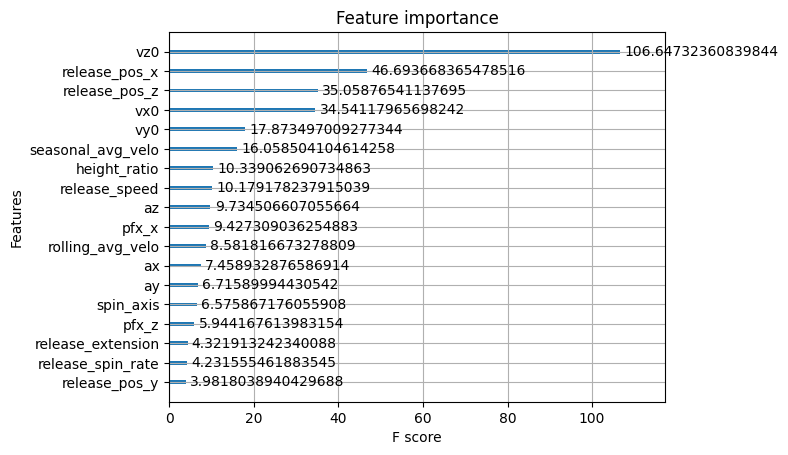

In [21]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

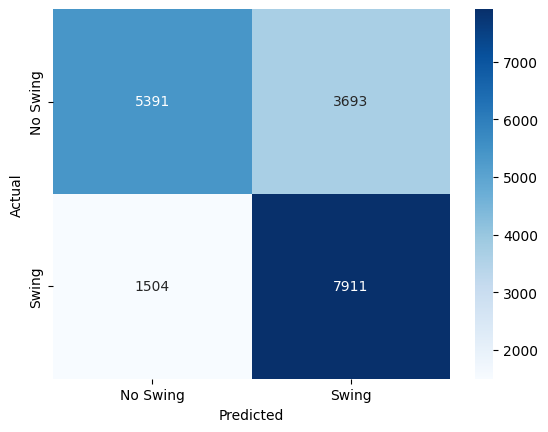

In [22]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [23]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'last_spin_axis', 'last_pfx_x',
       'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
       'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z',
       'diff_release_speed'],
      dtype='object')

In [24]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [25]:
y_pred = final_model.predict(predictions)

In [26]:
testing_identifiers['xswing'] = y_pred

In [27]:
num_nans = testing_identifiers['xswing'].isna().sum()
print(f"Number of NaNs in 'xswing': {num_nans}")


Number of NaNs in 'xswing': 0


In [28]:
len(testing_identifiers)

188456

In [29]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/swing_2022&3_xswing.csv")